In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号



from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-30) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:,0:1];u2 = u[:,1:2];u3 = u[:,2:3]; #将u的第一列、第二列、第三列分别赋值给u1、u2、u3
        u4 = u[:,3:4];u5 = u[:,4:5];u6 = u[:,5:6]; #将u的第四列、第五列、第六列分别赋值给u4、u5、u6
        u7 = u[:,6:7];u8 = u[:,7:8];u9 = u[:,8:9]; #将u的第七列、第八列、第九列分别赋值给u7、u8、u9
        u10 = u[:,9:10];u11 = u[:,10:11];u12 = u[:,11:12] #将u的第十列、第十一列、第十二列分别赋值给u10、u11、u12
        

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_4 = torch.autograd.grad(
            u4, x,
            grad_outputs=torch.ones_like(u4),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_5 = torch.autograd.grad(
            u5, x,
            grad_outputs=torch.ones_like(u5),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_6 = torch.autograd.grad(
            u6, x,
            grad_outputs=torch.ones_like(u6),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_7 = torch.autograd.grad(
            u7, x,
            grad_outputs=torch.ones_like(u7),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_8 = torch.autograd.grad(
            u8, x,
            grad_outputs=torch.ones_like(u8),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_9 = torch.autograd.grad(
            u9, x,
            grad_outputs=torch.ones_like(u9),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_10 = torch.autograd.grad(
            u10, x,
            grad_outputs=torch.ones_like(u10),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_11 = torch.autograd.grad(
            u11, x,
            grad_outputs=torch.ones_like(u11),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_12 = torch.autograd.grad(
            u12, x,
            grad_outputs=torch.ones_like(u12),
            retain_graph=True,
            create_graph=True
        )[0]


        #归一化
        u_x_1 = u_x_1 / self.sigma_x;u_x_2 = u_x_2 / self.sigma_x;u_x_3 = u_x_3 / self.sigma_x
        u_x_4 = u_x_4 / self.sigma_x;u_x_5 = u_x_5 / self.sigma_x;u_x_6 = u_x_6 / self.sigma_x
        u_x_7 = u_x_7 / self.sigma_x;u_x_8 = u_x_8 / self.sigma_x;u_x_9 = u_x_9 / self.sigma_x
        u_x_10 = u_x_10 / self.sigma_x;u_x_11 = u_x_11 / self.sigma_x;u_x_12 = u_x_12 / self.sigma_x

        #指定状态转移概率
        #对于元素1
        Lambda2_1_1=7; Mu1_2_1=100;
        #对于元素2
        Lambda2_1_2=10; Mu1_2_2=80;
        #对于元素3
        Lambda3_2_3=10; Lambda3_1_3=0; Lambda2_1_3=7;
        Mu1_3_3=0; Mu1_2_3=120; Mu2_3_3=110
        #-----------------------------------------------
        #计算ODE项
        ode_1 = -(Lambda2_1_1+Lambda2_1_2+Lambda3_2_3)*u1+Mu1_2_1*u2+Mu1_2_2*u3+Mu2_3_3*u4;
        ode_2 = Lambda2_1_1*u1-(Mu1_2_1+Lambda2_1_2+Lambda3_2_3)*u2+Mu1_2_2*u5+Mu2_3_3*u6;
        ode_3 = Lambda2_1_2*u1-(Mu1_2_2+Lambda2_1_1+Lambda3_2_3)*u3+Mu1_2_1*u5+Mu2_3_3*u7;
        ode_4 = Lambda3_2_3*u1-(Mu2_3_3+Lambda2_1_1+Lambda2_1_2+Lambda2_1_3)*u4+Mu1_2_1*u6+Mu1_2_2*u7+Mu1_2_3*u8;
        ode_5 = Lambda2_1_2*u2+Lambda2_1_1*u3-(Mu1_2_2+Mu1_2_1+Lambda3_2_3)*u5+Mu2_3_3*u9;
        ode_6 = Lambda3_2_3*u2+Lambda2_1_1*u4-(Mu2_3_3+Mu1_2_1+Lambda2_1_2+Lambda2_1_3)*u6+Mu1_2_2*u9+Mu1_2_3*u10;
        ode_7 = Lambda3_2_3*u3+Lambda2_1_2*u4-(Mu2_3_3+Mu1_2_2+Lambda2_1_1+Lambda2_1_3)*u7+Mu1_2_1*u9+Mu1_2_3*u11;
        ode_8 = Lambda2_1_3*u4-(Mu1_2_3+Lambda2_1_1+Lambda2_1_2)*u8+Mu1_2_1*u10+Mu1_2_2*u11;
        ode_9 = Lambda3_2_3*u5+Lambda2_1_2*u6+Lambda2_1_1*u7-(Mu2_3_3+Mu1_2_2+Mu1_2_1+Lambda2_1_3)*u9+Mu1_2_3*u12;
        ode_10 = Lambda2_1_3*u6+Lambda2_1_1*u8-(Mu1_2_3+Mu1_2_1+Lambda2_1_2)*u10+Mu1_2_2*u12;
        ode_11 = Lambda2_1_3*u7+Lambda2_1_2*u8-(Mu1_2_3+Mu1_2_2+Lambda2_1_1)*u11+Mu1_2_1*u12;
        ode_12 = Lambda2_1_3*u9+Lambda2_1_2*u10+Lambda2_1_1*u11-(Mu1_2_3+Mu1_2_2+Mu1_2_1)*u12

        
        #计算残差
        residual_1 = u_x_1-ode_1; residual_2 = u_x_2-ode_2; residual_3 = u_x_3-ode_3
        residual_4 = u_x_4-ode_4; residual_5 = u_x_5-ode_5; residual_6 = u_x_6-ode_6;
        residual_7 = u_x_7-ode_7; residual_8 = u_x_8-ode_8; residual_9 = u_x_9-ode_9;
        residual_10 = u_x_10-ode_10; residual_11 = u_x_11-ode_11; residual_12 = u_x_12-ode_12

        #计算损失函数
        loss_1 = torch.mean(residual_1 ** 2); loss_2 = torch.mean(residual_2 ** 2); loss_3 = torch.mean(residual_3 ** 2);
        loss_4 = torch.mean(residual_4 ** 2); loss_5 = torch.mean(residual_5 ** 2); loss_6 = torch.mean(residual_6 ** 2);
        loss_7 = torch.mean(residual_7 ** 2); loss_8 = torch.mean(residual_8 ** 2); loss_9 = torch.mean(residual_9 ** 2);
        loss_10 = torch.mean(residual_10 ** 2); loss_11 = torch.mean(residual_11 ** 2); loss_12 = torch.mean(residual_12 ** 2)


        loss_f = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7 + loss_8 + loss_9 + loss_10 + loss_11 + loss_12
        return loss_f, residual_1+residual_2+residual_3+residual_4+residual_5+residual_6+residual_7+residual_8+residual_9+residual_10+residual_11+residual_12
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
def get_system_performance(df):
    
    df['system_3.5'] = df['state_1']
    df['system_2.0'] = df['state_2']
    df['system_1.8'] = df['state_4'] + df['state_6']
    df['system_1.5'] = df['state_3'] + df['state_7']
    df['system_0'] = df['state_5'] + df['state_8'] + df['state_9'] + df['state_10'] + df['state_11'] + df['state_12']
    
    return df

state_column_names = ['state_1', 'state_2', 'state_3', 'state_4', 'state_5', 'state_6', 'state_7',
                      'state_8', 'state_9', 'state_10', 'state_11', 'state_12']

In [8]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0     

eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')

N_u = 1
N_f = 1500

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 12]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([0.2])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0,0,0,0,0,0,0,0,0,0]])          # 初始真实状态


error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储混沌值
residuals = [] #创建一个空列表，用于存储残差值

i = 0


# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    X_f = lb + (ub - lb) * lhs(1, N_f) #生成N_f个配位点，均匀分布在[0,1]之间
    # X_f = np.linspace(lb, ub, N_f)     # 配位点位置
    nIter = 40000

    #创建PINN模型并输入各种参数     
    # model = PhysicsInformedNN(X_u, u, X_f, layers, lb, ub, X_star, u_star)
    model = PhysicsInformedNN(X_u, u, X_f, layers, lb, ub)
    
    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))


    # up = 80000
    n_star = 500+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
    y_pred = get_system_performance(y_pred_df)
    # y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
    y_star = eigenvector_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:, -5:],2)/np.linalg.norm(y_star.iloc[:, -5:],2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]))
    mse = np.mean((y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:,-5:],2)/np.linalg.norm(y_star.iloc[:,-5:],2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)





Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 2/40000 [00:00<34:54, 19.10it/s]

Adam:   0%|          | 28/40000 [00:00<04:18, 154.84it/s]

Adam:   0%|          | 54/40000 [00:00<03:21, 197.99it/s]

Adam:   0%|          | 79/40000 [00:00<03:05, 215.44it/s]

Adam:   0%|          | 104/40000 [00:00<02:55, 227.02it/s]

Adam:   0%|          | 128/40000 [00:00<02:54, 229.00it/s]

Adam:   0%|          | 153/40000 [00:00<02:49, 235.65it/s]

Adam:   0%|          | 178/40000 [00:00<02:46, 239.82it/s]

Adam:   1%|          | 203/40000 [00:00<02:44, 242.50it/s]

Adam:   1%|          | 228/40000 [00:01<02:45, 240.30it/s]

Adam:   1%|          | 253/40000 [00:01<02:43, 242.69it/s]

Adam:   1%|          | 279/40000 [00:01<02:41, 246.02it/s]

Adam:   1%|          | 305/40000 [00:01<02:39, 248.21it/s]

Adam:   1%|          | 330/40000 [00:01<02:44, 240.73it/s]

Adam:   1%|          | 355/40000 [00:01<02:43, 243.16it/s]

Adam:   1%|          | 380/40000 [00:01<02:42, 243.30it/s]

Adam:   1%|          | 405/40000 [00:01<02:42, 243.36it/s]

Adam:   1%|          | 430/40000 [00:01<02:42, 243.26it/s]

Adam:   1%|          | 455/40000 [00:01<02:45, 238.31it/s]

Adam:   1%|          | 480/40000 [00:02<02:45, 239.15it/s]

Adam:   1%|▏         | 505/40000 [00:02<02:43, 241.11it/s]

Adam:   1%|▏         | 531/40000 [00:02<02:41, 244.03it/s]

Adam:   1%|▏         | 557/40000 [00:02<02:39, 246.83it/s]

Adam:   1%|▏         | 582/40000 [00:02<02:42, 242.23it/s]

Adam:   2%|▏         | 607/40000 [00:02<02:42, 243.13it/s]

Adam:   2%|▏         | 632/40000 [00:02<02:41, 243.13it/s]

Adam:   2%|▏         | 657/40000 [00:02<02:41, 244.36it/s]

Adam:   2%|▏         | 682/40000 [00:02<02:40, 244.92it/s]

Adam:   2%|▏         | 707/40000 [00:03<02:46, 236.65it/s]

Adam:   2%|▏         | 732/40000 [00:03<02:43, 240.34it/s]

Adam:   2%|▏         | 758/40000 [00:03<02:40, 244.29it/s]

Adam:   2%|▏         | 783/40000 [00:03<02:43, 240.34it/s]

Adam:   2%|▏         | 809/40000 [00:03<02:40, 244.17it/s]

Adam:   2%|▏         | 834/40000 [00:03<02:42, 241.55it/s]

Adam:   2%|▏         | 859/40000 [00:03<02:41, 241.88it/s]

Adam:   2%|▏         | 884/40000 [00:03<02:40, 243.80it/s]

Adam:   2%|▏         | 909/40000 [00:03<02:39, 245.24it/s]

Adam:   2%|▏         | 934/40000 [00:03<02:38, 246.39it/s]

Adam:   2%|▏         | 960/40000 [00:04<02:37, 248.52it/s]

Adam:   2%|▏         | 985/40000 [00:04<02:37, 248.37it/s]

Adam:   3%|▎         | 1010/40000 [00:04<02:36, 248.46it/s]

Adam:   3%|▎         | 1035/40000 [00:04<02:40, 243.42it/s]

Adam:   3%|▎         | 1060/40000 [00:04<02:39, 243.94it/s]

Adam:   3%|▎         | 1085/40000 [00:04<02:39, 244.71it/s]

Adam:   3%|▎         | 1111/40000 [00:04<02:37, 247.63it/s]

Adam:   3%|▎         | 1136/40000 [00:04<02:36, 247.86it/s]

Adam:   3%|▎         | 1161/40000 [00:04<02:36, 248.42it/s]

Adam:   3%|▎         | 1187/40000 [00:04<02:35, 249.34it/s]

Adam:   3%|▎         | 1212/40000 [00:05<02:36, 248.46it/s]

Adam:   3%|▎         | 1237/40000 [00:05<02:35, 248.48it/s]

Adam:   3%|▎         | 1263/40000 [00:05<02:35, 249.38it/s]

Adam:   3%|▎         | 1289/40000 [00:05<02:34, 250.43it/s]

Adam:   3%|▎         | 1315/40000 [00:05<02:36, 246.93it/s]

Adam:   3%|▎         | 1340/40000 [00:05<02:37, 245.97it/s]

Adam:   3%|▎         | 1366/40000 [00:05<02:36, 247.44it/s]

Adam:   3%|▎         | 1392/40000 [00:05<02:35, 248.87it/s]

Adam:   4%|▎         | 1417/40000 [00:05<02:35, 248.25it/s]

Adam:   4%|▎         | 1443/40000 [00:05<02:34, 250.18it/s]

Adam:   4%|▎         | 1469/40000 [00:06<02:33, 251.25it/s]

Adam:   4%|▎         | 1495/40000 [00:06<02:34, 248.75it/s]

Adam:   4%|▍         | 1520/40000 [00:06<02:35, 247.61it/s]

Adam:   4%|▍         | 1545/40000 [00:06<02:35, 247.32it/s]

Adam:   4%|▍         | 1570/40000 [00:06<02:36, 245.97it/s]

Adam:   4%|▍         | 1595/40000 [00:06<02:36, 245.98it/s]

Adam:   4%|▍         | 1621/40000 [00:06<02:35, 247.43it/s]

Adam:   4%|▍         | 1646/40000 [00:06<02:34, 247.54it/s]

Adam:   4%|▍         | 1671/40000 [00:06<02:36, 244.43it/s]

Adam:   4%|▍         | 1696/40000 [00:07<02:43, 234.77it/s]

Adam:   4%|▍         | 1720/40000 [00:07<02:42, 235.17it/s]

Adam:   4%|▍         | 1745/40000 [00:07<02:39, 239.24it/s]

Adam:   4%|▍         | 1770/40000 [00:07<02:38, 240.89it/s]

Adam:   4%|▍         | 1795/40000 [00:07<02:37, 242.72it/s]

Adam:   5%|▍         | 1820/40000 [00:07<02:36, 244.39it/s]

Adam:   5%|▍         | 1845/40000 [00:07<02:37, 242.20it/s]

Adam:   5%|▍         | 1870/40000 [00:07<02:37, 242.79it/s]

Adam:   5%|▍         | 1895/40000 [00:07<02:36, 243.04it/s]

Adam:   5%|▍         | 1920/40000 [00:07<02:37, 242.01it/s]

Adam:   5%|▍         | 1945/40000 [00:08<02:38, 240.70it/s]

Adam:   5%|▍         | 1970/40000 [00:08<02:37, 240.97it/s]

Adam:   5%|▍         | 1995/40000 [00:08<02:36, 242.41it/s]

Adam:   5%|▌         | 2020/40000 [00:08<02:36, 243.08it/s]

Adam:   5%|▌         | 2045/40000 [00:08<02:34, 245.00it/s]

Adam:   5%|▌         | 2070/40000 [00:08<02:34, 246.15it/s]

Adam:   5%|▌         | 2095/40000 [00:08<02:34, 245.23it/s]

Adam:   5%|▌         | 2120/40000 [00:08<02:33, 245.97it/s]

Adam:   5%|▌         | 2145/40000 [00:08<02:34, 245.56it/s]

Adam:   5%|▌         | 2170/40000 [00:08<02:36, 242.13it/s]

Adam:   5%|▌         | 2195/40000 [00:09<02:35, 243.07it/s]

Adam:   6%|▌         | 2220/40000 [00:09<02:34, 243.89it/s]

Adam:   6%|▌         | 2245/40000 [00:09<02:34, 244.99it/s]

Adam:   6%|▌         | 2270/40000 [00:09<02:34, 244.25it/s]

Adam:   6%|▌         | 2295/40000 [00:09<02:35, 242.47it/s]

Adam:   6%|▌         | 2320/40000 [00:09<02:35, 243.10it/s]

Adam:   6%|▌         | 2346/40000 [00:09<02:33, 244.62it/s]

Adam:   6%|▌         | 2371/40000 [00:09<02:35, 241.41it/s]

Adam:   6%|▌         | 2396/40000 [00:09<02:38, 237.96it/s]

Adam:   6%|▌         | 2422/40000 [00:10<02:35, 241.72it/s]

Adam:   6%|▌         | 2447/40000 [00:10<02:34, 243.58it/s]

Adam:   6%|▌         | 2472/40000 [00:10<02:33, 243.84it/s]

Adam:   6%|▌         | 2497/40000 [00:10<02:34, 242.03it/s]

Adam:   6%|▋         | 2522/40000 [00:10<02:38, 235.87it/s]

Adam:   6%|▋         | 2546/40000 [00:10<02:52, 217.08it/s]

Adam:   6%|▋         | 2571/40000 [00:10<02:46, 225.40it/s]

Adam:   6%|▋         | 2596/40000 [00:10<02:42, 230.60it/s]

Adam:   7%|▋         | 2621/40000 [00:10<02:38, 235.58it/s]

Adam:   7%|▋         | 2646/40000 [00:10<02:36, 239.08it/s]

Adam:   7%|▋         | 2671/40000 [00:11<02:37, 237.00it/s]

Adam:   7%|▋         | 2696/40000 [00:11<02:35, 240.16it/s]

Adam:   7%|▋         | 2721/40000 [00:11<02:34, 240.86it/s]

Adam:   7%|▋         | 2746/40000 [00:11<02:33, 242.44it/s]

Adam:   7%|▋         | 2771/40000 [00:11<02:33, 242.62it/s]

Adam:   7%|▋         | 2796/40000 [00:11<02:35, 239.64it/s]

Adam:   7%|▋         | 2821/40000 [00:11<02:33, 242.45it/s]

Adam:   7%|▋         | 2846/40000 [00:11<02:32, 244.38it/s]

Adam:   7%|▋         | 2871/40000 [00:11<02:31, 245.34it/s]

Adam:   7%|▋         | 2896/40000 [00:11<02:30, 246.12it/s]

Adam:   7%|▋         | 2922/40000 [00:12<02:29, 247.61it/s]

Adam:   7%|▋         | 2947/40000 [00:12<02:30, 246.87it/s]

Adam:   7%|▋         | 2972/40000 [00:12<02:29, 247.61it/s]

Adam:   7%|▋         | 2998/40000 [00:12<02:28, 248.56it/s]

Adam:   8%|▊         | 3023/40000 [00:12<02:28, 248.18it/s]

Adam:   8%|▊         | 3048/40000 [00:12<02:29, 247.31it/s]

Adam:   8%|▊         | 3073/40000 [00:12<02:30, 245.27it/s]

Adam:   8%|▊         | 3098/40000 [00:12<02:32, 242.12it/s]

Adam:   8%|▊         | 3123/40000 [00:12<02:31, 243.39it/s]

Adam:   8%|▊         | 3149/40000 [00:13<02:29, 246.71it/s]

Adam:   8%|▊         | 3175/40000 [00:13<02:28, 248.34it/s]

Adam:   8%|▊         | 3200/40000 [00:13<02:27, 248.72it/s]

Adam:   8%|▊         | 3225/40000 [00:13<02:27, 248.54it/s]

Adam:   8%|▊         | 3250/40000 [00:13<02:27, 248.92it/s]

Adam:   8%|▊         | 3275/40000 [00:13<02:27, 248.81it/s]

Adam:   8%|▊         | 3300/40000 [00:13<02:27, 249.01it/s]

Adam:   8%|▊         | 3325/40000 [00:13<02:27, 249.08it/s]

Adam:   8%|▊         | 3350/40000 [00:13<02:27, 249.15it/s]

Adam:   8%|▊         | 3375/40000 [00:13<02:29, 244.28it/s]

Adam:   9%|▊         | 3401/40000 [00:14<02:28, 246.19it/s]

Adam:   9%|▊         | 3427/40000 [00:14<02:27, 248.40it/s]

Adam:   9%|▊         | 3452/40000 [00:14<02:38, 230.36it/s]

Adam:   9%|▊         | 3478/40000 [00:14<02:33, 237.22it/s]

Adam:   9%|▉         | 3502/40000 [00:14<02:34, 235.54it/s]

Adam:   9%|▉         | 3526/40000 [00:14<02:37, 231.55it/s]

Adam:   9%|▉         | 3551/40000 [00:14<02:35, 234.87it/s]

Adam:   9%|▉         | 3577/40000 [00:14<02:31, 239.93it/s]

Adam:   9%|▉         | 3602/40000 [00:14<02:31, 241.03it/s]

Adam:   9%|▉         | 3627/40000 [00:14<02:29, 242.79it/s]

Adam:   9%|▉         | 3652/40000 [00:15<02:28, 244.42it/s]

Adam:   9%|▉         | 3677/40000 [00:15<02:27, 245.56it/s]

Adam:   9%|▉         | 3703/40000 [00:15<02:26, 246.97it/s]

Adam:   9%|▉         | 3728/40000 [00:15<02:26, 247.42it/s]

Adam:   9%|▉         | 3753/40000 [00:15<02:27, 246.37it/s]

Adam:   9%|▉         | 3778/40000 [00:15<02:27, 245.19it/s]

Adam:  10%|▉         | 3803/40000 [00:15<02:29, 242.56it/s]

Adam:  10%|▉         | 3828/40000 [00:15<02:29, 241.91it/s]

Adam:  10%|▉         | 3853/40000 [00:15<02:29, 241.13it/s]

Adam:  10%|▉         | 3878/40000 [00:16<02:31, 238.16it/s]

Adam:  10%|▉         | 3902/40000 [00:16<02:32, 237.48it/s]

Adam:  10%|▉         | 3926/40000 [00:16<02:33, 234.57it/s]

Adam:  10%|▉         | 3951/40000 [00:16<02:31, 238.37it/s]

Adam:  10%|▉         | 3976/40000 [00:16<02:29, 241.76it/s]

Adam:  10%|█         | 4001/40000 [00:16<02:27, 243.53it/s]

Adam:  10%|█         | 4026/40000 [00:16<02:27, 243.15it/s]

Adam:  10%|█         | 4051/40000 [00:16<02:29, 240.40it/s]

Adam:  10%|█         | 4076/40000 [00:16<02:29, 239.79it/s]

Adam:  10%|█         | 4100/40000 [00:16<02:30, 238.86it/s]

Adam:  10%|█         | 4124/40000 [00:17<02:34, 232.01it/s]

Adam:  10%|█         | 4148/40000 [00:17<02:45, 216.99it/s]

Adam:  10%|█         | 4172/40000 [00:17<02:40, 222.78it/s]

Adam:  10%|█         | 4196/40000 [00:17<02:37, 227.40it/s]

Adam:  11%|█         | 4219/40000 [00:17<02:37, 227.61it/s]

Adam:  11%|█         | 4244/40000 [00:17<02:34, 231.68it/s]

Adam:  11%|█         | 4268/40000 [00:17<02:32, 233.97it/s]

Adam:  11%|█         | 4292/40000 [00:17<02:41, 221.04it/s]

Adam:  11%|█         | 4316/40000 [00:17<02:39, 224.36it/s]

Adam:  11%|█         | 4340/40000 [00:18<02:37, 226.99it/s]

Adam:  11%|█         | 4364/40000 [00:18<02:34, 230.40it/s]

Adam:  11%|█         | 4388/40000 [00:18<02:38, 225.15it/s]

Adam:  11%|█         | 4411/40000 [00:18<02:39, 223.46it/s]

Adam:  11%|█         | 4434/40000 [00:18<02:39, 222.50it/s]

Adam:  11%|█         | 4457/40000 [00:18<02:38, 223.55it/s]

Adam:  11%|█         | 4480/40000 [00:18<02:37, 224.93it/s]

Adam:  11%|█▏        | 4503/40000 [00:18<02:38, 224.05it/s]

Adam:  11%|█▏        | 4526/40000 [00:18<02:40, 220.70it/s]

Adam:  11%|█▏        | 4549/40000 [00:18<02:40, 221.42it/s]

Adam:  11%|█▏        | 4572/40000 [00:19<02:40, 220.73it/s]

Adam:  11%|█▏        | 4595/40000 [00:19<02:38, 222.69it/s]

Adam:  12%|█▏        | 4618/40000 [00:19<02:39, 222.35it/s]

Adam:  12%|█▏        | 4642/40000 [00:19<02:37, 224.84it/s]

Adam:  12%|█▏        | 4665/40000 [00:19<02:38, 223.42it/s]

Adam:  12%|█▏        | 4688/40000 [00:19<02:39, 221.28it/s]

Adam:  12%|█▏        | 4711/40000 [00:19<02:38, 222.60it/s]

Adam:  12%|█▏        | 4734/40000 [00:19<02:39, 221.51it/s]

Adam:  12%|█▏        | 4757/40000 [00:19<02:40, 219.16it/s]

Adam:  12%|█▏        | 4779/40000 [00:19<02:41, 217.56it/s]

Adam:  12%|█▏        | 4801/40000 [00:20<02:43, 215.39it/s]

Adam:  12%|█▏        | 4824/40000 [00:20<02:40, 218.88it/s]

Adam:  12%|█▏        | 4847/40000 [00:20<02:39, 220.33it/s]

Adam:  12%|█▏        | 4870/40000 [00:20<02:38, 222.26it/s]

Adam:  12%|█▏        | 4893/40000 [00:20<02:38, 221.85it/s]

Adam:  12%|█▏        | 4916/40000 [00:20<02:41, 216.82it/s]

Adam:  12%|█▏        | 4939/40000 [00:20<02:40, 218.76it/s]

Adam:  12%|█▏        | 4962/40000 [00:20<02:39, 219.38it/s]

Adam:  12%|█▏        | 4984/40000 [00:20<02:41, 216.73it/s]

Adam:  13%|█▎        | 5007/40000 [00:21<02:39, 219.15it/s]

Adam:  13%|█▎        | 5030/40000 [00:21<02:39, 219.10it/s]

Adam:  13%|█▎        | 5053/40000 [00:21<02:38, 220.13it/s]

Adam:  13%|█▎        | 5076/40000 [00:21<02:37, 222.08it/s]

Adam:  13%|█▎        | 5099/40000 [00:21<02:36, 223.04it/s]

Adam:  13%|█▎        | 5122/40000 [00:21<02:36, 222.51it/s]

Adam:  13%|█▎        | 5145/40000 [00:21<02:36, 222.28it/s]

Adam:  13%|█▎        | 5168/40000 [00:21<02:37, 220.77it/s]

Adam:  13%|█▎        | 5191/40000 [00:21<02:37, 221.35it/s]

Adam:  13%|█▎        | 5214/40000 [00:21<02:40, 216.33it/s]

Adam:  13%|█▎        | 5237/40000 [00:22<02:38, 219.16it/s]

Adam:  13%|█▎        | 5259/40000 [00:22<02:39, 217.18it/s]

Adam:  13%|█▎        | 5282/40000 [00:22<02:38, 218.48it/s]

Adam:  13%|█▎        | 5305/40000 [00:22<02:38, 219.21it/s]

Adam:  13%|█▎        | 5328/40000 [00:22<02:37, 219.66it/s]

Adam:  13%|█▎        | 5350/40000 [00:22<02:39, 216.76it/s]

Adam:  13%|█▎        | 5372/40000 [00:22<02:43, 211.94it/s]

Adam:  13%|█▎        | 5394/40000 [00:22<02:45, 208.48it/s]

Adam:  14%|█▎        | 5415/40000 [00:22<02:53, 199.12it/s]

Adam:  14%|█▎        | 5438/40000 [00:23<02:47, 206.44it/s]

Adam:  14%|█▎        | 5460/40000 [00:23<02:44, 209.55it/s]

Adam:  14%|█▎        | 5483/40000 [00:23<02:41, 214.36it/s]

Adam:  14%|█▍        | 5506/40000 [00:23<02:38, 217.05it/s]

Adam:  14%|█▍        | 5529/40000 [00:23<02:36, 220.04it/s]

Adam:  14%|█▍        | 5552/40000 [00:23<02:35, 222.20it/s]

Adam:  14%|█▍        | 5575/40000 [00:23<02:34, 223.38it/s]

Adam:  14%|█▍        | 5598/40000 [00:23<02:39, 215.70it/s]

Adam:  14%|█▍        | 5621/40000 [00:23<02:37, 218.88it/s]

Adam:  14%|█▍        | 5643/40000 [00:23<02:39, 215.75it/s]

Adam:  14%|█▍        | 5666/40000 [00:24<02:36, 218.73it/s]

Adam:  14%|█▍        | 5688/40000 [00:24<02:37, 217.90it/s]

Adam:  14%|█▍        | 5711/40000 [00:24<02:36, 219.74it/s]

Adam:  14%|█▍        | 5734/40000 [00:24<02:35, 220.23it/s]

Adam:  14%|█▍        | 5757/40000 [00:24<02:33, 222.40it/s]

Adam:  14%|█▍        | 5780/40000 [00:24<02:33, 223.07it/s]

Adam:  15%|█▍        | 5803/40000 [00:24<02:32, 223.96it/s]

Adam:  15%|█▍        | 5826/40000 [00:24<02:31, 225.24it/s]

Adam:  15%|█▍        | 5849/40000 [00:24<02:33, 222.25it/s]

Adam:  15%|█▍        | 5872/40000 [00:25<02:36, 218.42it/s]

Adam:  15%|█▍        | 5895/40000 [00:25<02:34, 220.44it/s]

Adam:  15%|█▍        | 5918/40000 [00:25<02:33, 222.02it/s]

Adam:  15%|█▍        | 5941/40000 [00:25<02:36, 217.62it/s]

Adam:  15%|█▍        | 5964/40000 [00:25<02:35, 218.50it/s]

Adam:  15%|█▍        | 5986/40000 [00:25<02:35, 218.13it/s]

Adam:  15%|█▌        | 6008/40000 [00:25<02:40, 212.17it/s]

Adam:  15%|█▌        | 6031/40000 [00:25<02:36, 216.78it/s]

Adam:  15%|█▌        | 6054/40000 [00:25<02:34, 219.57it/s]

Adam:  15%|█▌        | 6076/40000 [00:25<02:35, 217.64it/s]

Adam:  15%|█▌        | 6099/40000 [00:26<02:35, 218.38it/s]

Adam:  15%|█▌        | 6122/40000 [00:26<02:33, 220.06it/s]

Adam:  15%|█▌        | 6145/40000 [00:26<02:33, 221.12it/s]

Adam:  15%|█▌        | 6168/40000 [00:26<02:32, 221.87it/s]

Adam:  15%|█▌        | 6191/40000 [00:26<02:31, 223.06it/s]

Adam:  16%|█▌        | 6214/40000 [00:26<02:31, 222.71it/s]

Adam:  16%|█▌        | 6237/40000 [00:26<02:30, 223.93it/s]

Adam:  16%|█▌        | 6260/40000 [00:26<02:31, 222.35it/s]

Adam:  16%|█▌        | 6283/40000 [00:26<02:30, 224.27it/s]

Adam:  16%|█▌        | 6306/40000 [00:26<02:30, 224.14it/s]

Adam:  16%|█▌        | 6329/40000 [00:27<02:30, 223.44it/s]

Adam:  16%|█▌        | 6352/40000 [00:27<02:30, 223.42it/s]

Adam:  16%|█▌        | 6375/40000 [00:27<02:30, 223.08it/s]

Adam:  16%|█▌        | 6398/40000 [00:27<02:30, 223.86it/s]

Adam:  16%|█▌        | 6421/40000 [00:27<02:33, 218.48it/s]

Adam:  16%|█▌        | 6444/40000 [00:27<02:31, 221.70it/s]

Adam:  16%|█▌        | 6467/40000 [00:27<02:30, 222.92it/s]

Adam:  16%|█▌        | 6490/40000 [00:27<02:30, 223.13it/s]

Adam:  16%|█▋        | 6514/40000 [00:27<02:28, 225.79it/s]

Adam:  16%|█▋        | 6537/40000 [00:28<02:32, 219.29it/s]

Adam:  16%|█▋        | 6560/40000 [00:28<02:31, 221.14it/s]

Adam:  16%|█▋        | 6583/40000 [00:28<02:30, 221.60it/s]

Adam:  17%|█▋        | 6606/40000 [00:28<02:30, 222.01it/s]

Adam:  17%|█▋        | 6629/40000 [00:28<02:29, 222.87it/s]

Adam:  17%|█▋        | 6652/40000 [00:28<02:28, 224.20it/s]

Adam:  17%|█▋        | 6675/40000 [00:28<02:28, 224.73it/s]

Adam:  17%|█▋        | 6698/40000 [00:28<02:29, 223.45it/s]

Adam:  17%|█▋        | 6721/40000 [00:28<02:28, 224.41it/s]

Adam:  17%|█▋        | 6744/40000 [00:28<02:28, 223.56it/s]

Adam:  17%|█▋        | 6767/40000 [00:29<02:43, 203.42it/s]

Adam:  17%|█▋        | 6791/40000 [00:29<02:37, 210.91it/s]

Adam:  17%|█▋        | 6814/40000 [00:29<02:34, 215.30it/s]

Adam:  17%|█▋        | 6836/40000 [00:29<02:39, 207.60it/s]

Adam:  17%|█▋        | 6859/40000 [00:29<02:36, 211.82it/s]

Adam:  17%|█▋        | 6881/40000 [00:29<02:35, 213.65it/s]

Adam:  17%|█▋        | 6904/40000 [00:29<02:31, 217.75it/s]

Adam:  17%|█▋        | 6927/40000 [00:29<02:31, 218.56it/s]

Adam:  17%|█▋        | 6949/40000 [00:29<02:43, 202.24it/s]

Adam:  17%|█▋        | 6972/40000 [00:30<02:39, 207.70it/s]

Adam:  17%|█▋        | 6993/40000 [00:30<02:47, 197.47it/s]

Adam:  18%|█▊        | 7013/40000 [00:30<02:53, 190.47it/s]

Adam:  18%|█▊        | 7035/40000 [00:30<02:46, 198.02it/s]

Adam:  18%|█▊        | 7055/40000 [00:30<03:01, 181.07it/s]

Adam:  18%|█▊        | 7075/40000 [00:30<02:57, 185.48it/s]

Adam:  18%|█▊        | 7098/40000 [00:30<02:46, 197.68it/s]

Adam:  18%|█▊        | 7121/40000 [00:30<02:39, 205.87it/s]

Adam:  18%|█▊        | 7142/40000 [00:30<02:39, 206.11it/s]

Adam:  18%|█▊        | 7164/40000 [00:31<02:36, 209.94it/s]

Adam:  18%|█▊        | 7186/40000 [00:31<02:46, 197.18it/s]

Adam:  18%|█▊        | 7209/40000 [00:31<02:40, 204.31it/s]

Adam:  18%|█▊        | 7232/40000 [00:31<02:35, 210.36it/s]

Adam:  18%|█▊        | 7254/40000 [00:31<02:38, 206.56it/s]

Adam:  18%|█▊        | 7277/40000 [00:31<02:35, 210.54it/s]

Adam:  18%|█▊        | 7299/40000 [00:31<02:43, 200.06it/s]

Adam:  18%|█▊        | 7320/40000 [00:31<02:45, 197.84it/s]

Adam:  18%|█▊        | 7340/40000 [00:31<02:45, 197.39it/s]

Adam:  18%|█▊        | 7360/40000 [00:31<02:45, 197.44it/s]

Adam:  18%|█▊        | 7380/40000 [00:32<02:53, 188.28it/s]

Adam:  18%|█▊        | 7400/40000 [00:32<02:52, 189.39it/s]

Adam:  19%|█▊        | 7420/40000 [00:32<02:58, 182.95it/s]

Adam:  19%|█▊        | 7441/40000 [00:32<02:51, 189.46it/s]

Adam:  19%|█▊        | 7462/40000 [00:32<02:49, 192.53it/s]

Adam:  19%|█▊        | 7482/40000 [00:32<02:47, 194.04it/s]

Adam:  19%|█▉        | 7503/40000 [00:32<02:44, 198.04it/s]

Adam:  19%|█▉        | 7523/40000 [00:32<02:49, 191.21it/s]

Adam:  19%|█▉        | 7544/40000 [00:32<02:46, 194.83it/s]

Adam:  19%|█▉        | 7564/40000 [00:33<02:48, 192.64it/s]

Adam:  19%|█▉        | 7584/40000 [00:33<02:50, 190.53it/s]

Adam:  19%|█▉        | 7604/40000 [00:33<02:50, 189.81it/s]

Adam:  19%|█▉        | 7624/40000 [00:33<02:48, 192.56it/s]

Adam:  19%|█▉        | 7645/40000 [00:33<02:44, 197.21it/s]

Adam:  19%|█▉        | 7665/40000 [00:33<02:43, 197.87it/s]

Adam:  19%|█▉        | 7685/40000 [00:33<02:44, 196.73it/s]

Adam:  19%|█▉        | 7705/40000 [00:33<02:49, 190.13it/s]

Adam:  19%|█▉        | 7725/40000 [00:33<02:49, 190.30it/s]

Adam:  19%|█▉        | 7745/40000 [00:34<02:50, 188.65it/s]

Adam:  19%|█▉        | 7764/40000 [00:34<02:52, 187.23it/s]

Adam:  19%|█▉        | 7785/40000 [00:34<02:47, 192.04it/s]

Adam:  20%|█▉        | 7805/40000 [00:34<02:49, 189.85it/s]

Adam:  20%|█▉        | 7825/40000 [00:34<03:00, 178.08it/s]

Adam:  20%|█▉        | 7843/40000 [00:34<03:00, 178.43it/s]

Adam:  20%|█▉        | 7863/40000 [00:34<02:54, 183.88it/s]

Adam:  20%|█▉        | 7882/40000 [00:34<02:56, 182.27it/s]

Adam:  20%|█▉        | 7901/40000 [00:34<03:02, 175.91it/s]

Adam:  20%|█▉        | 7922/40000 [00:34<02:54, 183.82it/s]

Adam:  20%|█▉        | 7942/40000 [00:35<02:50, 188.09it/s]

Adam:  20%|█▉        | 7964/40000 [00:35<02:44, 194.87it/s]

Adam:  20%|█▉        | 7985/40000 [00:35<02:42, 196.44it/s]

Adam:  20%|██        | 8005/40000 [00:35<02:44, 194.73it/s]

Adam:  20%|██        | 8025/40000 [00:35<02:43, 196.02it/s]

Adam:  20%|██        | 8045/40000 [00:35<02:44, 193.88it/s]

Adam:  20%|██        | 8065/40000 [00:35<02:46, 192.05it/s]

Adam:  20%|██        | 8086/40000 [00:35<02:42, 196.88it/s]

Adam:  20%|██        | 8106/40000 [00:35<02:45, 192.28it/s]

Adam:  20%|██        | 8126/40000 [00:36<02:53, 184.02it/s]

Adam:  20%|██        | 8145/40000 [00:36<03:00, 176.37it/s]

Adam:  20%|██        | 8166/40000 [00:36<02:51, 185.24it/s]

Adam:  20%|██        | 8187/40000 [00:36<02:46, 191.49it/s]

Adam:  21%|██        | 8207/40000 [00:36<02:45, 192.61it/s]

Adam:  21%|██        | 8227/40000 [00:36<02:47, 190.17it/s]

Adam:  21%|██        | 8249/40000 [00:36<02:40, 197.62it/s]

Adam:  21%|██        | 8271/40000 [00:36<02:36, 202.27it/s]

Adam:  21%|██        | 8292/40000 [00:36<02:38, 199.52it/s]

Adam:  21%|██        | 8312/40000 [00:36<02:39, 199.21it/s]

Adam:  21%|██        | 8332/40000 [00:37<02:39, 198.86it/s]

Adam:  21%|██        | 8353/40000 [00:37<02:38, 199.90it/s]

Adam:  21%|██        | 8374/40000 [00:37<02:41, 195.82it/s]

Adam:  21%|██        | 8394/40000 [00:37<02:41, 195.61it/s]

Adam:  21%|██        | 8414/40000 [00:37<02:41, 195.41it/s]

Adam:  21%|██        | 8434/40000 [00:37<02:48, 187.40it/s]

Adam:  21%|██        | 8454/40000 [00:37<02:46, 189.58it/s]

Adam:  21%|██        | 8475/40000 [00:37<02:42, 193.83it/s]

Adam:  21%|██        | 8495/40000 [00:37<02:47, 188.01it/s]

Adam:  21%|██▏       | 8514/40000 [00:38<02:50, 184.56it/s]

Adam:  21%|██▏       | 8535/40000 [00:38<02:44, 191.14it/s]

Adam:  21%|██▏       | 8556/40000 [00:38<02:40, 196.06it/s]

Adam:  21%|██▏       | 8577/40000 [00:38<02:38, 197.83it/s]

Adam:  21%|██▏       | 8599/40000 [00:38<02:35, 201.66it/s]

Adam:  22%|██▏       | 8620/40000 [00:38<02:34, 202.52it/s]

Adam:  22%|██▏       | 8641/40000 [00:38<02:35, 202.27it/s]

Adam:  22%|██▏       | 8662/40000 [00:38<02:33, 204.02it/s]

Adam:  22%|██▏       | 8683/40000 [00:38<02:34, 202.79it/s]

Adam:  22%|██▏       | 8704/40000 [00:38<02:34, 202.03it/s]

Adam:  22%|██▏       | 8726/40000 [00:39<02:32, 204.84it/s]

Adam:  22%|██▏       | 8747/40000 [00:39<02:35, 200.74it/s]

Adam:  22%|██▏       | 8768/40000 [00:39<02:34, 202.30it/s]

Adam:  22%|██▏       | 8790/40000 [00:39<02:32, 204.08it/s]

Adam:  22%|██▏       | 8811/40000 [00:39<02:42, 191.81it/s]

Adam:  22%|██▏       | 8831/40000 [00:39<02:47, 185.77it/s]

Adam:  22%|██▏       | 8850/40000 [00:39<02:48, 185.02it/s]

Adam:  22%|██▏       | 8869/40000 [00:39<02:52, 179.99it/s]

Adam:  22%|██▏       | 8888/40000 [00:39<02:51, 180.97it/s]

Adam:  22%|██▏       | 8909/40000 [00:40<02:45, 187.71it/s]

Adam:  22%|██▏       | 8928/40000 [00:40<02:47, 185.58it/s]

Adam:  22%|██▏       | 8949/40000 [00:40<02:41, 192.54it/s]

Adam:  22%|██▏       | 8969/40000 [00:40<02:40, 193.80it/s]

Adam:  22%|██▏       | 8990/40000 [00:40<02:37, 196.84it/s]

Adam:  23%|██▎       | 9010/40000 [00:40<02:44, 188.78it/s]

Adam:  23%|██▎       | 9030/40000 [00:40<02:42, 190.46it/s]

Adam:  23%|██▎       | 9050/40000 [00:40<02:42, 190.37it/s]

Adam:  23%|██▎       | 9071/40000 [00:40<02:39, 193.56it/s]

Adam:  23%|██▎       | 9092/40000 [00:41<02:37, 196.24it/s]

Adam:  23%|██▎       | 9112/40000 [00:41<02:41, 190.77it/s]

Adam:  23%|██▎       | 9132/40000 [00:41<02:48, 183.67it/s]

Adam:  23%|██▎       | 9151/40000 [00:41<02:46, 185.37it/s]

Adam:  23%|██▎       | 9171/40000 [00:41<02:45, 185.93it/s]

Adam:  23%|██▎       | 9191/40000 [00:41<02:42, 189.55it/s]

Adam:  23%|██▎       | 9212/40000 [00:41<02:37, 195.46it/s]

Adam:  23%|██▎       | 9233/40000 [00:41<02:34, 199.53it/s]

Adam:  23%|██▎       | 9254/40000 [00:41<02:41, 190.74it/s]

Adam:  23%|██▎       | 9274/40000 [00:41<02:41, 190.30it/s]

Adam:  23%|██▎       | 9294/40000 [00:42<02:41, 190.52it/s]

Adam:  23%|██▎       | 9314/40000 [00:42<02:40, 190.69it/s]

Adam:  23%|██▎       | 9334/40000 [00:42<02:47, 183.10it/s]

Adam:  23%|██▎       | 9354/40000 [00:42<02:44, 186.79it/s]

Adam:  23%|██▎       | 9374/40000 [00:42<02:41, 189.15it/s]

Adam:  23%|██▎       | 9393/40000 [00:42<02:43, 187.32it/s]

Adam:  24%|██▎       | 9414/40000 [00:42<02:39, 191.93it/s]

Adam:  24%|██▎       | 9436/40000 [00:42<02:34, 198.06it/s]

Adam:  24%|██▎       | 9456/40000 [00:42<02:41, 189.62it/s]

Adam:  24%|██▎       | 9476/40000 [00:43<02:40, 190.31it/s]

Adam:  24%|██▎       | 9496/40000 [00:43<02:40, 190.31it/s]

Adam:  24%|██▍       | 9516/40000 [00:43<02:41, 188.34it/s]

Adam:  24%|██▍       | 9537/40000 [00:43<02:38, 192.52it/s]

Adam:  24%|██▍       | 9557/40000 [00:43<02:36, 194.61it/s]

Adam:  24%|██▍       | 9578/40000 [00:43<02:34, 197.48it/s]

Adam:  24%|██▍       | 9599/40000 [00:43<02:31, 200.30it/s]

Adam:  24%|██▍       | 9620/40000 [00:43<02:30, 202.34it/s]

Adam:  24%|██▍       | 9641/40000 [00:43<02:38, 191.71it/s]

Adam:  24%|██▍       | 9663/40000 [00:43<02:33, 197.96it/s]

Adam:  24%|██▍       | 9684/40000 [00:44<02:32, 198.81it/s]

Adam:  24%|██▍       | 9705/40000 [00:44<02:31, 199.39it/s]

Adam:  24%|██▍       | 9726/40000 [00:44<02:30, 201.22it/s]

Adam:  24%|██▍       | 9747/40000 [00:44<02:32, 197.87it/s]

Adam:  24%|██▍       | 9767/40000 [00:44<02:37, 192.21it/s]

Adam:  24%|██▍       | 9788/40000 [00:44<02:35, 194.10it/s]

Adam:  25%|██▍       | 9808/40000 [00:44<02:45, 182.41it/s]

Adam:  25%|██▍       | 9827/40000 [00:44<02:47, 179.95it/s]

Adam:  25%|██▍       | 9846/40000 [00:44<02:50, 176.64it/s]

Adam:  25%|██▍       | 9867/40000 [00:45<02:42, 184.92it/s]

Adam:  25%|██▍       | 9886/40000 [00:45<02:45, 181.65it/s]

Adam:  25%|██▍       | 9907/40000 [00:45<02:39, 188.57it/s]

Adam:  25%|██▍       | 9926/40000 [00:45<02:39, 188.81it/s]

Adam:  25%|██▍       | 9945/40000 [00:45<02:40, 186.96it/s]

Adam:  25%|██▍       | 9964/40000 [00:45<02:44, 182.88it/s]

Adam:  25%|██▍       | 9985/40000 [00:45<02:38, 188.85it/s]

Adam:  25%|██▌       | 10006/40000 [00:45<02:35, 193.43it/s]

Adam:  25%|██▌       | 10028/40000 [00:45<02:30, 199.36it/s]

Adam:  25%|██▌       | 10049/40000 [00:46<02:28, 202.30it/s]

Adam:  25%|██▌       | 10070/40000 [00:46<02:27, 202.30it/s]

Adam:  25%|██▌       | 10091/40000 [00:46<02:26, 203.62it/s]

Adam:  25%|██▌       | 10112/40000 [00:46<02:34, 193.30it/s]

Adam:  25%|██▌       | 10132/40000 [00:46<02:33, 195.04it/s]

Adam:  25%|██▌       | 10152/40000 [00:46<02:39, 186.65it/s]

Adam:  25%|██▌       | 10171/40000 [00:46<02:41, 185.20it/s]

Adam:  25%|██▌       | 10192/40000 [00:46<02:36, 190.70it/s]

Adam:  26%|██▌       | 10212/40000 [00:46<02:37, 189.38it/s]

Adam:  26%|██▌       | 10232/40000 [00:46<02:35, 191.43it/s]

Adam:  26%|██▌       | 10253/40000 [00:47<02:32, 194.95it/s]

Adam:  26%|██▌       | 10273/40000 [00:47<02:36, 189.97it/s]

Adam:  26%|██▌       | 10293/40000 [00:47<02:38, 187.27it/s]

Adam:  26%|██▌       | 10312/40000 [00:47<02:42, 183.08it/s]

Adam:  26%|██▌       | 10332/40000 [00:47<02:39, 186.15it/s]

Adam:  26%|██▌       | 10351/40000 [00:47<02:47, 176.76it/s]

Adam:  26%|██▌       | 10369/40000 [00:47<02:48, 176.19it/s]

Adam:  26%|██▌       | 10389/40000 [00:47<02:42, 181.75it/s]

Adam:  26%|██▌       | 10410/40000 [00:47<02:36, 188.87it/s]

Adam:  26%|██▌       | 10431/40000 [00:48<02:32, 193.46it/s]

Adam:  26%|██▌       | 10452/40000 [00:48<02:30, 196.96it/s]

Adam:  26%|██▌       | 10473/40000 [00:48<02:28, 199.31it/s]

Adam:  26%|██▌       | 10493/40000 [00:48<02:28, 199.07it/s]

Adam:  26%|██▋       | 10515/40000 [00:48<02:25, 203.24it/s]

Adam:  26%|██▋       | 10536/40000 [00:48<02:27, 199.12it/s]

Adam:  26%|██▋       | 10557/40000 [00:48<02:27, 199.71it/s]

Adam:  26%|██▋       | 10577/40000 [00:48<02:35, 188.87it/s]

Adam:  26%|██▋       | 10598/40000 [00:48<02:31, 193.93it/s]

Adam:  27%|██▋       | 10618/40000 [00:49<02:42, 180.33it/s]

Adam:  27%|██▋       | 10637/40000 [00:49<02:47, 175.45it/s]

Adam:  27%|██▋       | 10658/40000 [00:49<02:40, 183.24it/s]

Adam:  27%|██▋       | 10679/40000 [00:49<02:35, 188.46it/s]

Adam:  27%|██▋       | 10698/40000 [00:49<03:04, 158.73it/s]

Adam:  27%|██▋       | 10719/40000 [00:49<02:52, 169.97it/s]

Adam:  27%|██▋       | 10739/40000 [00:49<02:45, 177.24it/s]

Adam:  27%|██▋       | 10760/40000 [00:49<02:38, 184.13it/s]

Adam:  27%|██▋       | 10781/40000 [00:49<02:34, 188.75it/s]

Adam:  27%|██▋       | 10801/40000 [00:50<02:34, 188.54it/s]

Adam:  27%|██▋       | 10821/40000 [00:50<02:33, 190.21it/s]

Adam:  27%|██▋       | 10842/40000 [00:50<02:30, 193.94it/s]

Adam:  27%|██▋       | 10862/40000 [00:50<02:31, 192.69it/s]

Adam:  27%|██▋       | 10882/40000 [00:50<02:36, 186.34it/s]

Adam:  27%|██▋       | 10901/40000 [00:50<02:40, 181.68it/s]

Adam:  27%|██▋       | 10920/40000 [00:50<02:39, 181.95it/s]

Adam:  27%|██▋       | 10939/40000 [00:50<02:37, 184.15it/s]

Adam:  27%|██▋       | 10958/40000 [00:50<02:37, 184.62it/s]

Adam:  27%|██▋       | 10977/40000 [00:51<02:51, 169.46it/s]

Adam:  27%|██▋       | 10996/40000 [00:51<02:46, 174.67it/s]

Adam:  28%|██▊       | 11015/40000 [00:51<02:44, 176.31it/s]

Adam:  28%|██▊       | 11034/40000 [00:51<02:41, 179.84it/s]

Adam:  28%|██▊       | 11054/40000 [00:51<02:36, 184.68it/s]

Adam:  28%|██▊       | 11073/40000 [00:51<02:36, 184.85it/s]

Adam:  28%|██▊       | 11093/40000 [00:51<02:35, 186.45it/s]

Adam:  28%|██▊       | 11112/40000 [00:51<02:39, 181.08it/s]

Adam:  28%|██▊       | 11132/40000 [00:51<02:34, 186.31it/s]

Adam:  28%|██▊       | 11152/40000 [00:51<02:32, 188.85it/s]

Adam:  28%|██▊       | 11171/40000 [00:52<02:42, 177.72it/s]

Adam:  28%|██▊       | 11190/40000 [00:52<02:39, 180.78it/s]

Adam:  28%|██▊       | 11210/40000 [00:52<02:38, 182.15it/s]

Adam:  28%|██▊       | 11229/40000 [00:52<02:42, 177.41it/s]

Adam:  28%|██▊       | 11249/40000 [00:52<02:38, 181.53it/s]

Adam:  28%|██▊       | 11268/40000 [00:52<02:38, 181.72it/s]

Adam:  28%|██▊       | 11287/40000 [00:52<02:40, 178.88it/s]

Adam:  28%|██▊       | 11308/40000 [00:52<02:34, 185.42it/s]

Adam:  28%|██▊       | 11327/40000 [00:52<02:34, 185.08it/s]

Adam:  28%|██▊       | 11346/40000 [00:53<02:33, 186.17it/s]

Adam:  28%|██▊       | 11365/40000 [00:53<02:36, 183.17it/s]

Adam:  28%|██▊       | 11384/40000 [00:53<02:39, 179.81it/s]

Adam:  29%|██▊       | 11403/40000 [00:53<02:37, 181.67it/s]

Adam:  29%|██▊       | 11422/40000 [00:53<02:36, 183.03it/s]

Adam:  29%|██▊       | 11442/40000 [00:53<02:33, 186.20it/s]

Adam:  29%|██▊       | 11461/40000 [00:53<02:35, 183.67it/s]

Adam:  29%|██▊       | 11482/40000 [00:53<02:31, 188.22it/s]

Adam:  29%|██▉       | 11501/40000 [00:53<02:34, 183.95it/s]

Adam:  29%|██▉       | 11523/40000 [00:53<02:27, 192.57it/s]

Adam:  29%|██▉       | 11543/40000 [00:54<02:26, 193.62it/s]

Adam:  29%|██▉       | 11563/40000 [00:54<02:30, 188.55it/s]

Adam:  29%|██▉       | 11583/40000 [00:54<02:28, 191.15it/s]

Adam:  29%|██▉       | 11603/40000 [00:54<02:37, 179.75it/s]

Adam:  29%|██▉       | 11622/40000 [00:54<02:36, 181.74it/s]

Adam:  29%|██▉       | 11641/40000 [00:54<02:43, 173.77it/s]

Adam:  29%|██▉       | 11659/40000 [00:54<02:47, 169.00it/s]

Adam:  29%|██▉       | 11680/40000 [00:54<02:38, 178.53it/s]

Adam:  29%|██▉       | 11701/40000 [00:54<02:32, 185.51it/s]

Adam:  29%|██▉       | 11720/40000 [00:55<02:31, 186.67it/s]

Adam:  29%|██▉       | 11741/40000 [00:55<02:26, 192.53it/s]

Adam:  29%|██▉       | 11762/40000 [00:55<02:24, 195.01it/s]

Adam:  29%|██▉       | 11783/40000 [00:55<02:23, 197.26it/s]

Adam:  30%|██▉       | 11803/40000 [00:55<02:23, 196.44it/s]

Adam:  30%|██▉       | 11824/40000 [00:55<02:21, 198.89it/s]

Adam:  30%|██▉       | 11844/40000 [00:55<02:21, 198.70it/s]

Adam:  30%|██▉       | 11864/40000 [00:55<02:25, 193.62it/s]

Adam:  30%|██▉       | 11884/40000 [00:55<02:29, 188.25it/s]

Adam:  30%|██▉       | 11903/40000 [00:55<02:32, 184.34it/s]

Adam:  30%|██▉       | 11925/40000 [00:56<02:26, 191.85it/s]

Adam:  30%|██▉       | 11945/40000 [00:56<02:30, 186.33it/s]

Adam:  30%|██▉       | 11964/40000 [00:56<02:42, 173.00it/s]

Adam:  30%|██▉       | 11982/40000 [00:56<02:44, 169.85it/s]

Adam:  30%|███       | 12001/40000 [00:56<02:39, 175.16it/s]

Adam:  30%|███       | 12019/40000 [00:56<02:41, 173.67it/s]

Adam:  30%|███       | 12037/40000 [00:56<02:43, 170.94it/s]

Adam:  30%|███       | 12058/40000 [00:56<02:35, 179.61it/s]

Adam:  30%|███       | 12078/40000 [00:56<02:30, 184.94it/s]

Adam:  30%|███       | 12098/40000 [00:57<02:28, 188.15it/s]

Adam:  30%|███       | 12118/40000 [00:57<02:28, 188.19it/s]

Adam:  30%|███       | 12138/40000 [00:57<02:27, 189.47it/s]

Adam:  30%|███       | 12160/40000 [00:57<02:21, 196.16it/s]

Adam:  30%|███       | 12180/40000 [00:57<02:25, 191.57it/s]

Adam:  30%|███       | 12200/40000 [00:57<02:27, 189.02it/s]

Adam:  31%|███       | 12219/40000 [00:57<02:30, 183.98it/s]

Adam:  31%|███       | 12238/40000 [00:57<02:33, 181.15it/s]

Adam:  31%|███       | 12257/40000 [00:57<02:33, 180.57it/s]

Adam:  31%|███       | 12279/40000 [00:58<02:25, 190.91it/s]

Adam:  31%|███       | 12299/40000 [00:58<02:31, 182.57it/s]

Adam:  31%|███       | 12318/40000 [00:58<02:30, 184.44it/s]

Adam:  31%|███       | 12337/40000 [00:58<02:36, 177.06it/s]

Adam:  31%|███       | 12356/40000 [00:58<02:33, 180.30it/s]

Adam:  31%|███       | 12375/40000 [00:58<02:41, 171.20it/s]

Adam:  31%|███       | 12396/40000 [00:58<02:32, 180.46it/s]

Adam:  31%|███       | 12416/40000 [00:58<02:29, 184.86it/s]

Adam:  31%|███       | 12435/40000 [00:58<02:30, 183.39it/s]

Adam:  31%|███       | 12454/40000 [00:59<02:30, 182.88it/s]

Adam:  31%|███       | 12475/40000 [00:59<02:24, 190.00it/s]

Adam:  31%|███       | 12495/40000 [00:59<02:24, 190.01it/s]

Adam:  31%|███▏      | 12516/40000 [00:59<02:21, 193.78it/s]

Adam:  31%|███▏      | 12536/40000 [00:59<02:24, 190.48it/s]

Adam:  31%|███▏      | 12556/40000 [00:59<02:29, 183.96it/s]

Adam:  31%|███▏      | 12575/40000 [00:59<02:30, 182.59it/s]

Adam:  31%|███▏      | 12594/40000 [00:59<02:38, 173.42it/s]

Adam:  32%|███▏      | 12612/40000 [00:59<02:36, 174.91it/s]

Adam:  32%|███▏      | 12630/40000 [00:59<02:38, 172.39it/s]

Adam:  32%|███▏      | 12649/40000 [01:00<02:34, 177.11it/s]

Adam:  32%|███▏      | 12667/40000 [01:00<02:36, 174.41it/s]

Adam:  32%|███▏      | 12686/40000 [01:00<02:34, 176.77it/s]

Adam:  32%|███▏      | 12706/40000 [01:00<02:32, 179.30it/s]

Adam:  32%|███▏      | 12724/40000 [01:00<02:41, 169.23it/s]

Adam:  32%|███▏      | 12743/40000 [01:00<02:36, 173.81it/s]

Adam:  32%|███▏      | 12762/40000 [01:00<02:33, 177.08it/s]

Adam:  32%|███▏      | 12781/40000 [01:00<02:33, 177.43it/s]

Adam:  32%|███▏      | 12802/40000 [01:00<02:27, 183.83it/s]

Adam:  32%|███▏      | 12821/40000 [01:01<02:31, 179.23it/s]

Adam:  32%|███▏      | 12839/40000 [01:01<02:44, 165.14it/s]

Adam:  32%|███▏      | 12858/40000 [01:01<02:38, 171.11it/s]

Adam:  32%|███▏      | 12878/40000 [01:01<02:33, 176.19it/s]

Adam:  32%|███▏      | 12900/40000 [01:01<02:25, 186.55it/s]

Adam:  32%|███▏      | 12919/40000 [01:01<02:30, 180.05it/s]

Adam:  32%|███▏      | 12939/40000 [01:01<02:26, 184.59it/s]

Adam:  32%|███▏      | 12958/40000 [01:01<02:27, 183.06it/s]

Adam:  32%|███▏      | 12978/40000 [01:01<02:25, 185.76it/s]

Adam:  32%|███▏      | 12999/40000 [01:02<02:21, 191.00it/s]

Adam:  33%|███▎      | 13019/40000 [01:02<02:28, 181.27it/s]

Adam:  33%|███▎      | 13039/40000 [01:02<02:26, 184.54it/s]

Adam:  33%|███▎      | 13059/40000 [01:02<02:23, 187.38it/s]

Adam:  33%|███▎      | 13079/40000 [01:02<02:21, 190.60it/s]

Adam:  33%|███▎      | 13099/40000 [01:02<02:19, 193.17it/s]

Adam:  33%|███▎      | 13119/40000 [01:02<02:20, 191.59it/s]

Adam:  33%|███▎      | 13140/40000 [01:02<02:17, 195.29it/s]

Adam:  33%|███▎      | 13160/40000 [01:02<02:19, 192.70it/s]

Adam:  33%|███▎      | 13181/40000 [01:02<02:16, 197.17it/s]

Adam:  33%|███▎      | 13202/40000 [01:03<02:13, 200.48it/s]

Adam:  33%|███▎      | 13223/40000 [01:03<02:15, 197.47it/s]

Adam:  33%|███▎      | 13243/40000 [01:03<02:16, 196.28it/s]

Adam:  33%|███▎      | 13263/40000 [01:03<02:17, 194.48it/s]

Adam:  33%|███▎      | 13284/40000 [01:03<02:14, 198.48it/s]

Adam:  33%|███▎      | 13304/40000 [01:03<02:17, 193.84it/s]

Adam:  33%|███▎      | 13324/40000 [01:03<02:20, 190.37it/s]

Adam:  33%|███▎      | 13344/40000 [01:03<02:22, 187.26it/s]

Adam:  33%|███▎      | 13366/40000 [01:03<02:17, 193.33it/s]

Adam:  33%|███▎      | 13388/40000 [01:04<02:13, 198.65it/s]

Adam:  34%|███▎      | 13408/40000 [01:04<02:13, 198.46it/s]

Adam:  34%|███▎      | 13429/40000 [01:04<02:13, 199.18it/s]

Adam:  34%|███▎      | 13449/40000 [01:04<02:16, 194.09it/s]

Adam:  34%|███▎      | 13469/40000 [01:04<02:16, 195.07it/s]

Adam:  34%|███▎      | 13491/40000 [01:04<02:12, 199.86it/s]

Adam:  34%|███▍      | 13513/40000 [01:04<02:09, 204.04it/s]

Adam:  34%|███▍      | 13534/40000 [01:04<02:12, 200.43it/s]

Adam:  34%|███▍      | 13555/40000 [01:04<02:15, 194.75it/s]

Adam:  34%|███▍      | 13576/40000 [01:04<02:13, 197.28it/s]

Adam:  34%|███▍      | 13596/40000 [01:05<02:13, 197.43it/s]

Adam:  34%|███▍      | 13617/40000 [01:05<02:12, 198.80it/s]

Adam:  34%|███▍      | 13637/40000 [01:05<02:16, 193.65it/s]

Adam:  34%|███▍      | 13657/40000 [01:05<02:16, 193.23it/s]

Adam:  34%|███▍      | 13677/40000 [01:05<02:20, 187.79it/s]

Adam:  34%|███▍      | 13696/40000 [01:05<02:26, 179.54it/s]

Adam:  34%|███▍      | 13715/40000 [01:05<02:25, 180.22it/s]

Adam:  34%|███▍      | 13735/40000 [01:05<02:23, 183.33it/s]

Adam:  34%|███▍      | 13754/40000 [01:05<02:22, 183.60it/s]

Adam:  34%|███▍      | 13774/40000 [01:06<02:20, 187.30it/s]

Adam:  34%|███▍      | 13795/40000 [01:06<02:16, 191.38it/s]

Adam:  35%|███▍      | 13815/40000 [01:06<02:17, 190.19it/s]

Adam:  35%|███▍      | 13835/40000 [01:06<02:19, 187.33it/s]

Adam:  35%|███▍      | 13854/40000 [01:06<02:19, 187.69it/s]

Adam:  35%|███▍      | 13874/40000 [01:06<02:17, 190.21it/s]

Adam:  35%|███▍      | 13895/40000 [01:06<02:14, 194.47it/s]

Adam:  35%|███▍      | 13915/40000 [01:06<02:17, 189.05it/s]

Adam:  35%|███▍      | 13934/40000 [01:06<02:21, 183.98it/s]

Adam:  35%|███▍      | 13954/40000 [01:07<02:18, 188.46it/s]

Adam:  35%|███▍      | 13975/40000 [01:07<02:15, 192.29it/s]

Adam:  35%|███▍      | 13995/40000 [01:07<02:20, 185.71it/s]

Adam:  35%|███▌      | 14014/40000 [01:07<02:20, 184.94it/s]

Adam:  35%|███▌      | 14033/40000 [01:07<02:26, 177.14it/s]

Adam:  35%|███▌      | 14051/40000 [01:07<02:30, 172.71it/s]

Adam:  35%|███▌      | 14069/40000 [01:07<02:33, 168.61it/s]

Adam:  35%|███▌      | 14088/40000 [01:07<02:32, 170.14it/s]

Adam:  35%|███▌      | 14107/40000 [01:07<02:27, 175.35it/s]

Adam:  35%|███▌      | 14125/40000 [01:07<02:31, 170.36it/s]

Adam:  35%|███▌      | 14143/40000 [01:08<02:34, 167.57it/s]

Adam:  35%|███▌      | 14160/40000 [01:08<02:35, 166.15it/s]

Adam:  35%|███▌      | 14180/40000 [01:08<02:26, 175.66it/s]

Adam:  35%|███▌      | 14199/40000 [01:08<02:24, 179.13it/s]

Adam:  36%|███▌      | 14218/40000 [01:08<02:23, 180.18it/s]

Adam:  36%|███▌      | 14237/40000 [01:08<02:37, 163.09it/s]

Adam:  36%|███▌      | 14255/40000 [01:08<02:34, 166.14it/s]

Adam:  36%|███▌      | 14274/40000 [01:08<02:28, 172.73it/s]

Adam:  36%|███▌      | 14292/40000 [01:08<02:31, 169.44it/s]

Adam:  36%|███▌      | 14310/40000 [01:09<02:30, 170.79it/s]

Adam:  36%|███▌      | 14331/40000 [01:09<02:22, 179.61it/s]

Adam:  36%|███▌      | 14353/40000 [01:09<02:15, 189.60it/s]

Adam:  36%|███▌      | 14373/40000 [01:09<02:16, 187.54it/s]

Adam:  36%|███▌      | 14392/40000 [01:09<02:24, 176.81it/s]

Adam:  36%|███▌      | 14410/40000 [01:09<02:42, 157.22it/s]

Adam:  36%|███▌      | 14432/40000 [01:09<02:28, 171.64it/s]

Adam:  36%|███▌      | 14450/40000 [01:09<02:30, 170.23it/s]

Adam:  36%|███▌      | 14468/40000 [01:09<02:30, 169.21it/s]

Adam:  36%|███▌      | 14486/40000 [01:10<02:29, 170.48it/s]

Adam:  36%|███▋      | 14504/40000 [01:10<02:28, 171.23it/s]

Adam:  36%|███▋      | 14522/40000 [01:10<02:26, 173.58it/s]

Adam:  36%|███▋      | 14542/40000 [01:10<02:21, 179.37it/s]

Adam:  36%|███▋      | 14563/40000 [01:10<02:15, 187.37it/s]

Adam:  36%|███▋      | 14582/40000 [01:10<02:15, 187.88it/s]

Adam:  37%|███▋      | 14601/40000 [01:10<02:15, 187.02it/s]

Adam:  37%|███▋      | 14620/40000 [01:10<02:17, 184.20it/s]

Adam:  37%|███▋      | 14639/40000 [01:10<02:16, 185.50it/s]

Adam:  37%|███▋      | 14658/40000 [01:11<02:15, 186.43it/s]

Adam:  37%|███▋      | 14677/40000 [01:11<02:21, 178.81it/s]

Adam:  37%|███▋      | 14695/40000 [01:11<02:30, 168.16it/s]

Adam:  37%|███▋      | 14714/40000 [01:11<02:26, 172.64it/s]

Adam:  37%|███▋      | 14733/40000 [01:11<02:23, 175.59it/s]

Adam:  37%|███▋      | 14751/40000 [01:11<02:25, 173.50it/s]

Adam:  37%|███▋      | 14771/40000 [01:11<02:21, 178.58it/s]

Adam:  37%|███▋      | 14791/40000 [01:11<02:17, 183.33it/s]

Adam:  37%|███▋      | 14810/40000 [01:11<02:24, 174.33it/s]

Adam:  37%|███▋      | 14828/40000 [01:12<02:32, 165.41it/s]

Adam:  37%|███▋      | 14847/40000 [01:12<02:27, 170.13it/s]

Adam:  37%|███▋      | 14866/40000 [01:12<02:23, 174.83it/s]

Adam:  37%|███▋      | 14885/40000 [01:12<02:21, 177.05it/s]

Adam:  37%|███▋      | 14904/40000 [01:12<02:19, 180.54it/s]

Adam:  37%|███▋      | 14924/40000 [01:12<02:15, 185.67it/s]

Adam:  37%|███▋      | 14943/40000 [01:12<02:19, 179.46it/s]

Adam:  37%|███▋      | 14963/40000 [01:12<02:16, 183.83it/s]

Adam:  37%|███▋      | 14983/40000 [01:12<02:15, 185.21it/s]

Adam:  38%|███▊      | 15004/40000 [01:12<02:10, 190.90it/s]

Adam:  38%|███▊      | 15024/40000 [01:13<02:09, 193.24it/s]

Adam:  38%|███▊      | 15045/40000 [01:13<02:07, 195.86it/s]

Adam:  38%|███▊      | 15065/40000 [01:13<02:07, 195.79it/s]

Adam:  38%|███▊      | 15085/40000 [01:13<02:15, 183.22it/s]

Adam:  38%|███▊      | 15105/40000 [01:13<02:13, 186.36it/s]

Adam:  38%|███▊      | 15124/40000 [01:13<02:16, 181.62it/s]

Adam:  38%|███▊      | 15143/40000 [01:13<02:16, 182.02it/s]

Adam:  38%|███▊      | 15162/40000 [01:13<02:24, 172.42it/s]

Adam:  38%|███▊      | 15180/40000 [01:13<02:30, 165.15it/s]

Adam:  38%|███▊      | 15197/40000 [01:14<02:30, 164.35it/s]

Adam:  38%|███▊      | 15215/40000 [01:14<02:27, 168.39it/s]

Adam:  38%|███▊      | 15232/40000 [01:14<02:31, 163.77it/s]

Adam:  38%|███▊      | 15251/40000 [01:14<02:25, 170.35it/s]

Adam:  38%|███▊      | 15269/40000 [01:14<02:22, 172.95it/s]

Adam:  38%|███▊      | 15287/40000 [01:14<02:25, 169.38it/s]

Adam:  38%|███▊      | 15305/40000 [01:14<02:29, 165.02it/s]

Adam:  38%|███▊      | 15322/40000 [01:14<02:45, 148.84it/s]

Adam:  38%|███▊      | 15341/40000 [01:14<02:36, 157.42it/s]

Adam:  38%|███▊      | 15358/40000 [01:15<02:37, 156.63it/s]

Adam:  38%|███▊      | 15376/40000 [01:15<02:31, 162.49it/s]

Adam:  38%|███▊      | 15395/40000 [01:15<02:25, 169.66it/s]

Adam:  39%|███▊      | 15413/40000 [01:15<02:23, 170.77it/s]

Adam:  39%|███▊      | 15431/40000 [01:15<02:21, 173.34it/s]

Adam:  39%|███▊      | 15449/40000 [01:15<02:21, 173.22it/s]

Adam:  39%|███▊      | 15467/40000 [01:15<02:24, 170.15it/s]

Adam:  39%|███▊      | 15486/40000 [01:15<02:20, 174.93it/s]

Adam:  39%|███▉      | 15506/40000 [01:15<02:15, 181.00it/s]

Adam:  39%|███▉      | 15525/40000 [01:16<02:26, 167.25it/s]

Adam:  39%|███▉      | 15543/40000 [01:16<02:23, 170.75it/s]

Adam:  39%|███▉      | 15561/40000 [01:16<02:24, 168.59it/s]

Adam:  39%|███▉      | 15580/40000 [01:16<02:21, 172.92it/s]

Adam:  39%|███▉      | 15598/40000 [01:16<02:20, 174.03it/s]

Adam:  39%|███▉      | 15616/40000 [01:16<02:26, 166.93it/s]

Adam:  39%|███▉      | 15637/40000 [01:16<02:17, 176.98it/s]

Adam:  39%|███▉      | 15656/40000 [01:16<02:15, 180.05it/s]

Adam:  39%|███▉      | 15676/40000 [01:16<02:13, 182.45it/s]

Adam:  39%|███▉      | 15697/40000 [01:16<02:08, 189.60it/s]

Adam:  39%|███▉      | 15717/40000 [01:17<02:08, 189.57it/s]

Adam:  39%|███▉      | 15737/40000 [01:17<02:09, 187.16it/s]

Adam:  39%|███▉      | 15757/40000 [01:17<02:08, 189.23it/s]

Adam:  39%|███▉      | 15776/40000 [01:17<02:08, 188.58it/s]

Adam:  39%|███▉      | 15795/40000 [01:17<02:09, 186.20it/s]

Adam:  40%|███▉      | 15814/40000 [01:17<02:16, 177.03it/s]

Adam:  40%|███▉      | 15832/40000 [01:17<02:29, 162.00it/s]

Adam:  40%|███▉      | 15849/40000 [01:17<02:34, 156.52it/s]

Adam:  40%|███▉      | 15868/40000 [01:17<02:26, 165.09it/s]

Adam:  40%|███▉      | 15886/40000 [01:18<02:23, 167.95it/s]

Adam:  40%|███▉      | 15903/40000 [01:18<02:24, 166.92it/s]

Adam:  40%|███▉      | 15920/40000 [01:18<02:28, 162.32it/s]

Adam:  40%|███▉      | 15937/40000 [01:18<02:26, 164.39it/s]

Adam:  40%|███▉      | 15956/40000 [01:18<02:20, 170.62it/s]

Adam:  40%|███▉      | 15977/40000 [01:18<02:13, 180.48it/s]

Adam:  40%|███▉      | 15996/40000 [01:18<02:16, 175.38it/s]

Adam:  40%|████      | 16014/40000 [01:18<02:17, 174.29it/s]

Adam:  40%|████      | 16033/40000 [01:18<02:14, 177.57it/s]

Adam:  40%|████      | 16051/40000 [01:19<02:19, 171.17it/s]

Adam:  40%|████      | 16069/40000 [01:19<02:20, 170.92it/s]

Adam:  40%|████      | 16087/40000 [01:19<02:18, 172.64it/s]

Adam:  40%|████      | 16105/40000 [01:19<02:19, 171.86it/s]

Adam:  40%|████      | 16123/40000 [01:19<02:23, 166.23it/s]

Adam:  40%|████      | 16140/40000 [01:19<02:26, 162.32it/s]

Adam:  40%|████      | 16159/40000 [01:19<02:20, 169.32it/s]

Adam:  40%|████      | 16178/40000 [01:19<02:16, 175.05it/s]

Adam:  40%|████      | 16196/40000 [01:19<02:16, 174.17it/s]

Adam:  41%|████      | 16214/40000 [01:19<02:18, 171.52it/s]

Adam:  41%|████      | 16233/40000 [01:20<02:15, 175.30it/s]

Adam:  41%|████      | 16252/40000 [01:20<02:12, 179.17it/s]

Adam:  41%|████      | 16271/40000 [01:20<02:10, 181.36it/s]

Adam:  41%|████      | 16290/40000 [01:20<02:10, 181.67it/s]

Adam:  41%|████      | 16311/40000 [01:20<02:05, 189.40it/s]

Adam:  41%|████      | 16330/40000 [01:20<02:06, 187.70it/s]

Adam:  41%|████      | 16349/40000 [01:20<02:09, 181.96it/s]

Adam:  41%|████      | 16368/40000 [01:20<02:14, 176.14it/s]

Adam:  41%|████      | 16387/40000 [01:20<02:12, 178.70it/s]

Adam:  41%|████      | 16408/40000 [01:21<02:06, 187.20it/s]

Adam:  41%|████      | 16427/40000 [01:21<02:11, 178.73it/s]

Adam:  41%|████      | 16445/40000 [01:21<02:14, 174.91it/s]

Adam:  41%|████      | 16464/40000 [01:21<02:11, 178.47it/s]

Adam:  41%|████      | 16483/40000 [01:21<02:10, 179.96it/s]

Adam:  41%|████▏     | 16504/40000 [01:21<02:05, 187.76it/s]

Adam:  41%|████▏     | 16524/40000 [01:21<02:03, 190.26it/s]

Adam:  41%|████▏     | 16544/40000 [01:21<02:09, 180.47it/s]

Adam:  41%|████▏     | 16563/40000 [01:21<02:13, 175.23it/s]

Adam:  41%|████▏     | 16581/40000 [01:22<02:17, 170.51it/s]

Adam:  41%|████▏     | 16599/40000 [01:22<02:16, 171.11it/s]

Adam:  42%|████▏     | 16617/40000 [01:22<02:20, 167.00it/s]

Adam:  42%|████▏     | 16634/40000 [01:22<02:25, 160.73it/s]

Adam:  42%|████▏     | 16651/40000 [01:22<02:26, 159.45it/s]

Adam:  42%|████▏     | 16667/40000 [01:22<02:26, 158.94it/s]

Adam:  42%|████▏     | 16685/40000 [01:22<02:22, 163.41it/s]

Adam:  42%|████▏     | 16702/40000 [01:22<02:23, 161.83it/s]

Adam:  42%|████▏     | 16719/40000 [01:22<02:23, 162.22it/s]

Adam:  42%|████▏     | 16738/40000 [01:22<02:19, 167.07it/s]

Adam:  42%|████▏     | 16759/40000 [01:23<02:11, 176.60it/s]

Adam:  42%|████▏     | 16779/40000 [01:23<02:06, 182.96it/s]

Adam:  42%|████▏     | 16798/40000 [01:23<02:09, 179.43it/s]

Adam:  42%|████▏     | 16816/40000 [01:23<02:11, 176.53it/s]

Adam:  42%|████▏     | 16834/40000 [01:23<02:19, 165.48it/s]

Adam:  42%|████▏     | 16852/40000 [01:23<02:17, 167.93it/s]

Adam:  42%|████▏     | 16869/40000 [01:23<02:42, 141.95it/s]

Adam:  42%|████▏     | 16884/40000 [01:23<03:01, 127.39it/s]

Adam:  42%|████▏     | 16899/40000 [01:24<02:55, 131.75it/s]

Adam:  42%|████▏     | 16913/40000 [01:24<02:53, 133.24it/s]

Adam:  42%|████▏     | 16930/40000 [01:24<02:43, 140.72it/s]

Adam:  42%|████▏     | 16947/40000 [01:24<02:35, 147.90it/s]

Adam:  42%|████▏     | 16963/40000 [01:24<02:42, 142.00it/s]

Adam:  42%|████▏     | 16981/40000 [01:24<02:33, 150.16it/s]

Adam:  42%|████▏     | 16997/40000 [01:24<02:32, 150.57it/s]

Adam:  43%|████▎     | 17013/40000 [01:24<02:30, 153.07it/s]

Adam:  43%|████▎     | 17033/40000 [01:24<02:19, 164.80it/s]

Adam:  43%|████▎     | 17050/40000 [01:25<02:24, 159.05it/s]

Adam:  43%|████▎     | 17067/40000 [01:25<02:31, 151.35it/s]

Adam:  43%|████▎     | 17083/40000 [01:25<02:34, 148.61it/s]

Adam:  43%|████▎     | 17098/40000 [01:25<02:42, 140.56it/s]

Adam:  43%|████▎     | 17114/40000 [01:25<02:38, 144.67it/s]

Adam:  43%|████▎     | 17132/40000 [01:25<02:28, 153.68it/s]

Adam:  43%|████▎     | 17149/40000 [01:25<02:24, 158.03it/s]

Adam:  43%|████▎     | 17165/40000 [01:25<02:24, 157.79it/s]

Adam:  43%|████▎     | 17182/40000 [01:25<02:27, 155.06it/s]

Adam:  43%|████▎     | 17198/40000 [01:25<02:29, 152.28it/s]

Adam:  43%|████▎     | 17214/40000 [01:26<02:35, 146.76it/s]

Adam:  43%|████▎     | 17230/40000 [01:26<02:32, 148.97it/s]

Adam:  43%|████▎     | 17247/40000 [01:26<02:27, 154.03it/s]

Adam:  43%|████▎     | 17266/40000 [01:26<02:18, 163.58it/s]

Adam:  43%|████▎     | 17283/40000 [01:26<02:23, 158.29it/s]

Adam:  43%|████▎     | 17299/40000 [01:26<02:29, 152.11it/s]

Adam:  43%|████▎     | 17317/40000 [01:26<02:23, 158.35it/s]

Adam:  43%|████▎     | 17333/40000 [01:26<02:23, 158.51it/s]

Adam:  43%|████▎     | 17352/40000 [01:26<02:16, 166.07it/s]

Adam:  43%|████▎     | 17370/40000 [01:27<02:14, 168.07it/s]

Adam:  43%|████▎     | 17387/40000 [01:27<02:20, 160.62it/s]

Adam:  44%|████▎     | 17404/40000 [01:27<02:21, 159.83it/s]

Adam:  44%|████▎     | 17421/40000 [01:27<02:25, 155.08it/s]

Adam:  44%|████▎     | 17437/40000 [01:27<02:24, 155.84it/s]

Adam:  44%|████▎     | 17456/40000 [01:27<02:17, 164.34it/s]

Adam:  44%|████▎     | 17476/40000 [01:27<02:11, 171.87it/s]

Adam:  44%|████▎     | 17494/40000 [01:27<02:09, 173.84it/s]

Adam:  44%|████▍     | 17512/40000 [01:27<02:08, 174.65it/s]

Adam:  44%|████▍     | 17530/40000 [01:28<02:14, 167.00it/s]

Adam:  44%|████▍     | 17547/40000 [01:28<02:25, 154.73it/s]

Adam:  44%|████▍     | 17563/40000 [01:28<02:24, 155.28it/s]

Adam:  44%|████▍     | 17579/40000 [01:28<02:33, 145.83it/s]

Adam:  44%|████▍     | 17595/40000 [01:28<02:31, 148.35it/s]

Adam:  44%|████▍     | 17614/40000 [01:28<02:21, 158.42it/s]

Adam:  44%|████▍     | 17633/40000 [01:28<02:15, 164.95it/s]

Adam:  44%|████▍     | 17650/40000 [01:28<02:15, 165.50it/s]

Adam:  44%|████▍     | 17667/40000 [01:28<02:19, 159.92it/s]

Adam:  44%|████▍     | 17687/40000 [01:29<02:12, 168.34it/s]

Adam:  44%|████▍     | 17704/40000 [01:29<02:16, 163.39it/s]

Adam:  44%|████▍     | 17721/40000 [01:29<02:16, 163.30it/s]

Adam:  44%|████▍     | 17740/40000 [01:29<02:11, 169.91it/s]

Adam:  44%|████▍     | 17759/40000 [01:29<02:06, 175.17it/s]

Adam:  44%|████▍     | 17777/40000 [01:29<02:06, 175.92it/s]

Adam:  44%|████▍     | 17796/40000 [01:29<02:03, 179.80it/s]

Adam:  45%|████▍     | 17815/40000 [01:29<02:09, 171.94it/s]

Adam:  45%|████▍     | 17834/40000 [01:29<02:05, 176.94it/s]

Adam:  45%|████▍     | 17852/40000 [01:29<02:12, 167.61it/s]

Adam:  45%|████▍     | 17869/40000 [01:30<02:20, 157.43it/s]

Adam:  45%|████▍     | 17890/40000 [01:30<02:10, 169.85it/s]

Adam:  45%|████▍     | 17910/40000 [01:30<02:04, 177.40it/s]

Adam:  45%|████▍     | 17928/40000 [01:30<02:18, 159.30it/s]

Adam:  45%|████▍     | 17945/40000 [01:30<02:26, 150.09it/s]

Adam:  45%|████▍     | 17963/40000 [01:30<02:19, 157.81it/s]

Adam:  45%|████▍     | 17980/40000 [01:30<02:24, 152.16it/s]

Adam:  45%|████▍     | 17996/40000 [01:30<02:38, 138.60it/s]

Adam:  45%|████▌     | 18011/40000 [01:31<02:41, 136.31it/s]

Adam:  45%|████▌     | 18026/40000 [01:31<02:38, 138.36it/s]

Adam:  45%|████▌     | 18042/40000 [01:31<02:32, 143.74it/s]

Adam:  45%|████▌     | 18059/40000 [01:31<02:26, 150.17it/s]

Adam:  45%|████▌     | 18075/40000 [01:31<02:29, 146.53it/s]

Adam:  45%|████▌     | 18092/40000 [01:31<02:25, 150.87it/s]

Adam:  45%|████▌     | 18112/40000 [01:31<02:13, 164.24it/s]

Adam:  45%|████▌     | 18129/40000 [01:31<02:19, 156.41it/s]

Adam:  45%|████▌     | 18147/40000 [01:31<02:16, 160.56it/s]

Adam:  45%|████▌     | 18164/40000 [01:32<02:14, 162.90it/s]

Adam:  45%|████▌     | 18181/40000 [01:32<02:14, 162.40it/s]

Adam:  45%|████▌     | 18198/40000 [01:32<02:24, 150.42it/s]

Adam:  46%|████▌     | 18214/40000 [01:32<02:27, 147.52it/s]

Adam:  46%|████▌     | 18229/40000 [01:32<02:28, 146.34it/s]

Adam:  46%|████▌     | 18244/40000 [01:32<02:37, 137.94it/s]

Adam:  46%|████▌     | 18260/40000 [01:32<02:31, 143.27it/s]

Adam:  46%|████▌     | 18282/40000 [01:32<02:12, 164.04it/s]

Adam:  46%|████▌     | 18300/40000 [01:32<02:10, 166.21it/s]

Adam:  46%|████▌     | 18317/40000 [01:33<02:10, 165.96it/s]

Adam:  46%|████▌     | 18334/40000 [01:33<02:13, 162.00it/s]

Adam:  46%|████▌     | 18351/40000 [01:33<02:14, 160.52it/s]

Adam:  46%|████▌     | 18368/40000 [01:33<02:24, 149.33it/s]

Adam:  46%|████▌     | 18385/40000 [01:33<02:19, 154.87it/s]

Adam:  46%|████▌     | 18401/40000 [01:33<02:20, 154.07it/s]

Adam:  46%|████▌     | 18417/40000 [01:33<02:23, 150.53it/s]

Adam:  46%|████▌     | 18437/40000 [01:33<02:11, 163.80it/s]

Adam:  46%|████▌     | 18455/40000 [01:33<02:08, 167.21it/s]

Adam:  46%|████▌     | 18472/40000 [01:34<02:20, 153.77it/s]

Adam:  46%|████▌     | 18488/40000 [01:34<02:28, 144.41it/s]

Adam:  46%|████▋     | 18504/40000 [01:34<02:26, 146.92it/s]

Adam:  46%|████▋     | 18519/40000 [01:34<02:27, 145.20it/s]

Adam:  46%|████▋     | 18534/40000 [01:34<02:31, 141.23it/s]

Adam:  46%|████▋     | 18550/40000 [01:34<02:27, 145.90it/s]

Adam:  46%|████▋     | 18568/40000 [01:34<02:20, 152.88it/s]

Adam:  46%|████▋     | 18589/40000 [01:34<02:08, 166.01it/s]

Adam:  47%|████▋     | 18606/40000 [01:34<02:17, 155.12it/s]

Adam:  47%|████▋     | 18623/40000 [01:35<02:14, 158.55it/s]

Adam:  47%|████▋     | 18642/40000 [01:35<02:08, 166.43it/s]

Adam:  47%|████▋     | 18659/40000 [01:35<02:15, 158.02it/s]

Adam:  47%|████▋     | 18675/40000 [01:35<02:23, 148.85it/s]

Adam:  47%|████▋     | 18691/40000 [01:35<02:28, 143.27it/s]

Adam:  47%|████▋     | 18706/40000 [01:35<02:34, 137.82it/s]

Adam:  47%|████▋     | 18722/40000 [01:35<02:28, 143.48it/s]

Adam:  47%|████▋     | 18740/40000 [01:35<02:19, 152.82it/s]

Adam:  47%|████▋     | 18758/40000 [01:35<02:13, 159.27it/s]

Adam:  47%|████▋     | 18775/40000 [01:36<02:18, 152.98it/s]

Adam:  47%|████▋     | 18792/40000 [01:36<02:14, 157.18it/s]

Adam:  47%|████▋     | 18808/40000 [01:36<02:19, 152.33it/s]

Adam:  47%|████▋     | 18824/40000 [01:36<02:25, 145.66it/s]

Adam:  47%|████▋     | 18839/40000 [01:36<02:27, 143.62it/s]

Adam:  47%|████▋     | 18854/40000 [01:36<02:27, 143.58it/s]

Adam:  47%|████▋     | 18870/40000 [01:36<02:22, 147.86it/s]

Adam:  47%|████▋     | 18885/40000 [01:36<02:24, 146.53it/s]

Adam:  47%|████▋     | 18900/40000 [01:36<02:32, 138.49it/s]

Adam:  47%|████▋     | 18914/40000 [01:37<02:36, 134.50it/s]

Adam:  47%|████▋     | 18928/40000 [01:37<02:38, 132.96it/s]

Adam:  47%|████▋     | 18942/40000 [01:37<03:00, 116.38it/s]

Adam:  47%|████▋     | 18955/40000 [01:37<02:58, 118.02it/s]

Adam:  47%|████▋     | 18969/40000 [01:37<02:52, 121.85it/s]

Adam:  47%|████▋     | 18982/40000 [01:37<02:54, 120.74it/s]

Adam:  47%|████▋     | 18995/40000 [01:37<02:56, 118.93it/s]

Adam:  48%|████▊     | 19015/40000 [01:37<02:30, 139.24it/s]

Adam:  48%|████▊     | 19032/40000 [01:37<02:23, 146.50it/s]

Adam:  48%|████▊     | 19049/40000 [01:38<02:17, 152.90it/s]

Adam:  48%|████▊     | 19065/40000 [01:38<02:27, 141.50it/s]

Adam:  48%|████▊     | 19080/40000 [01:38<02:29, 139.88it/s]

Adam:  48%|████▊     | 19096/40000 [01:38<02:24, 144.69it/s]

Adam:  48%|████▊     | 19111/40000 [01:38<02:32, 136.58it/s]

Adam:  48%|████▊     | 19125/40000 [01:38<02:40, 129.98it/s]

Adam:  48%|████▊     | 19139/40000 [01:38<02:43, 127.52it/s]

Adam:  48%|████▊     | 19152/40000 [01:38<02:45, 125.89it/s]

Adam:  48%|████▊     | 19165/40000 [01:38<02:53, 120.28it/s]

Adam:  48%|████▊     | 19178/40000 [01:39<02:56, 118.04it/s]

Adam:  48%|████▊     | 19192/40000 [01:39<02:49, 123.04it/s]

Adam:  48%|████▊     | 19208/40000 [01:39<02:37, 131.97it/s]

Adam:  48%|████▊     | 19222/40000 [01:39<02:55, 118.31it/s]

Adam:  48%|████▊     | 19235/40000 [01:39<03:03, 113.10it/s]

Adam:  48%|████▊     | 19252/40000 [01:39<02:45, 125.55it/s]

Adam:  48%|████▊     | 19266/40000 [01:39<02:41, 128.39it/s]

Adam:  48%|████▊     | 19285/40000 [01:39<02:24, 143.80it/s]

Adam:  48%|████▊     | 19303/40000 [01:39<02:16, 151.90it/s]

Adam:  48%|████▊     | 19319/40000 [01:40<02:22, 145.58it/s]

Adam:  48%|████▊     | 19334/40000 [01:40<02:23, 144.17it/s]

Adam:  48%|████▊     | 19350/40000 [01:40<02:19, 147.60it/s]

Adam:  48%|████▊     | 19368/40000 [01:40<02:11, 156.66it/s]

Adam:  48%|████▊     | 19386/40000 [01:40<02:06, 163.38it/s]

Adam:  49%|████▊     | 19403/40000 [01:40<02:14, 152.96it/s]

Adam:  49%|████▊     | 19419/40000 [01:40<02:20, 146.92it/s]

Adam:  49%|████▊     | 19435/40000 [01:40<02:17, 149.85it/s]

Adam:  49%|████▊     | 19452/40000 [01:40<02:16, 150.99it/s]

Adam:  49%|████▊     | 19468/40000 [01:41<02:27, 139.46it/s]

Adam:  49%|████▊     | 19485/40000 [01:41<02:20, 146.29it/s]

Adam:  49%|████▉     | 19500/40000 [01:41<02:22, 143.99it/s]

Adam:  49%|████▉     | 19515/40000 [01:41<02:23, 142.49it/s]

Adam:  49%|████▉     | 19531/40000 [01:41<02:20, 146.07it/s]

Adam:  49%|████▉     | 19547/40000 [01:41<02:16, 149.68it/s]

Adam:  49%|████▉     | 19563/40000 [01:41<02:18, 147.43it/s]

Adam:  49%|████▉     | 19578/40000 [01:41<02:20, 144.97it/s]

Adam:  49%|████▉     | 19593/40000 [01:41<02:23, 141.75it/s]

Adam:  49%|████▉     | 19608/40000 [01:42<02:32, 133.89it/s]

Adam:  49%|████▉     | 19624/40000 [01:42<02:24, 140.95it/s]

Adam:  49%|████▉     | 19639/40000 [01:42<02:27, 138.17it/s]

Adam:  49%|████▉     | 19653/40000 [01:42<02:39, 127.69it/s]

Adam:  49%|████▉     | 19669/40000 [01:42<02:33, 132.48it/s]

Adam:  49%|████▉     | 19684/40000 [01:42<02:29, 136.22it/s]

Adam:  49%|████▉     | 19701/40000 [01:42<02:19, 145.42it/s]

Adam:  49%|████▉     | 19719/40000 [01:42<02:11, 153.68it/s]

Adam:  49%|████▉     | 19739/40000 [01:42<02:01, 166.89it/s]

Adam:  49%|████▉     | 19756/40000 [01:43<02:03, 164.05it/s]

Adam:  49%|████▉     | 19775/40000 [01:43<02:00, 168.04it/s]

Adam:  49%|████▉     | 19792/40000 [01:43<02:17, 146.78it/s]

Adam:  50%|████▉     | 19808/40000 [01:43<02:15, 148.68it/s]

Adam:  50%|████▉     | 19824/40000 [01:43<02:16, 147.88it/s]

Adam:  50%|████▉     | 19840/40000 [01:43<02:28, 136.01it/s]

Adam:  50%|████▉     | 19854/40000 [01:43<02:37, 127.73it/s]

Adam:  50%|████▉     | 19870/40000 [01:43<02:29, 134.47it/s]

Adam:  50%|████▉     | 19886/40000 [01:44<02:23, 140.29it/s]

Adam:  50%|████▉     | 19902/40000 [01:44<02:18, 145.44it/s]

Adam:  50%|████▉     | 19918/40000 [01:44<02:15, 148.38it/s]

Adam:  50%|████▉     | 19934/40000 [01:44<02:17, 146.20it/s]

Adam:  50%|████▉     | 19949/40000 [01:44<02:23, 139.53it/s]

Adam:  50%|████▉     | 19964/40000 [01:44<02:48, 118.63it/s]

Adam:  50%|████▉     | 19977/40000 [01:44<02:46, 119.98it/s]

Adam:  50%|████▉     | 19990/40000 [01:44<02:47, 119.59it/s]

Adam:  50%|█████     | 20008/40000 [01:44<02:31, 132.38it/s]

Adam:  50%|█████     | 20024/40000 [01:45<02:24, 138.04it/s]

Adam:  50%|█████     | 20039/40000 [01:45<02:30, 132.35it/s]

Adam:  50%|█████     | 20053/40000 [01:45<02:40, 124.41it/s]

Adam:  50%|█████     | 20066/40000 [01:45<02:43, 122.23it/s]

Adam:  50%|█████     | 20084/40000 [01:45<02:25, 136.52it/s]

Adam:  50%|█████     | 20100/40000 [01:45<02:22, 139.41it/s]

Adam:  50%|█████     | 20115/40000 [01:45<02:23, 138.17it/s]

Adam:  50%|█████     | 20133/40000 [01:45<02:13, 148.77it/s]

Adam:  50%|█████     | 20153/40000 [01:45<02:03, 160.99it/s]

Adam:  50%|█████     | 20170/40000 [01:46<02:08, 154.19it/s]

Adam:  50%|█████     | 20186/40000 [01:46<02:08, 154.34it/s]

Adam:  51%|█████     | 20202/40000 [01:46<02:29, 132.05it/s]

Adam:  51%|█████     | 20217/40000 [01:46<02:28, 133.50it/s]

Adam:  51%|█████     | 20231/40000 [01:46<02:34, 127.77it/s]

Adam:  51%|█████     | 20247/40000 [01:46<02:26, 134.85it/s]

Adam:  51%|█████     | 20266/40000 [01:46<02:11, 149.52it/s]

Adam:  51%|█████     | 20286/40000 [01:46<02:01, 161.77it/s]

Adam:  51%|█████     | 20307/40000 [01:46<01:53, 173.41it/s]

Adam:  51%|█████     | 20325/40000 [01:47<01:55, 170.08it/s]

Adam:  51%|█████     | 20343/40000 [01:47<02:03, 158.62it/s]

Adam:  51%|█████     | 20360/40000 [01:47<02:03, 158.45it/s]

Adam:  51%|█████     | 20377/40000 [01:47<02:13, 146.59it/s]

Adam:  51%|█████     | 20393/40000 [01:47<02:12, 147.67it/s]

Adam:  51%|█████     | 20408/40000 [01:47<02:20, 139.82it/s]

Adam:  51%|█████     | 20423/40000 [01:47<02:20, 139.60it/s]

Adam:  51%|█████     | 20439/40000 [01:47<02:17, 141.78it/s]

Adam:  51%|█████     | 20454/40000 [01:48<02:15, 143.97it/s]

Adam:  51%|█████     | 20469/40000 [01:48<02:17, 142.11it/s]

Adam:  51%|█████     | 20484/40000 [01:48<02:31, 129.18it/s]

Adam:  51%|█████▏    | 20502/40000 [01:48<02:17, 142.07it/s]

Adam:  51%|█████▏    | 20517/40000 [01:48<02:16, 142.32it/s]

Adam:  51%|█████▏    | 20532/40000 [01:48<02:19, 140.04it/s]

Adam:  51%|█████▏    | 20550/40000 [01:48<02:09, 149.85it/s]

Adam:  51%|█████▏    | 20566/40000 [01:48<02:23, 135.55it/s]

Adam:  51%|█████▏    | 20581/40000 [01:48<02:21, 136.76it/s]

Adam:  51%|█████▏    | 20595/40000 [01:49<02:30, 129.30it/s]

Adam:  52%|█████▏    | 20609/40000 [01:49<02:26, 132.03it/s]

Adam:  52%|█████▏    | 20623/40000 [01:49<02:28, 130.83it/s]

Adam:  52%|█████▏    | 20640/40000 [01:49<02:17, 140.59it/s]

Adam:  52%|█████▏    | 20659/40000 [01:49<02:05, 154.30it/s]

Adam:  52%|█████▏    | 20676/40000 [01:49<02:02, 157.61it/s]

Adam:  52%|█████▏    | 20692/40000 [01:49<02:05, 154.37it/s]

Adam:  52%|█████▏    | 20708/40000 [01:49<02:20, 137.34it/s]

Adam:  52%|█████▏    | 20723/40000 [01:49<02:20, 137.62it/s]

Adam:  52%|█████▏    | 20742/40000 [01:50<02:07, 150.60it/s]

Adam:  52%|█████▏    | 20758/40000 [01:50<02:34, 124.88it/s]

Adam:  52%|█████▏    | 20772/40000 [01:50<02:43, 117.68it/s]

Adam:  52%|█████▏    | 20787/40000 [01:50<02:34, 124.71it/s]

Adam:  52%|█████▏    | 20802/40000 [01:50<02:28, 128.96it/s]

Adam:  52%|█████▏    | 20816/40000 [01:50<02:31, 126.71it/s]

Adam:  52%|█████▏    | 20834/40000 [01:50<02:18, 138.80it/s]

Adam:  52%|█████▏    | 20849/40000 [01:50<02:15, 141.71it/s]

Adam:  52%|█████▏    | 20868/40000 [01:51<02:06, 151.68it/s]

Adam:  52%|█████▏    | 20884/40000 [01:51<02:12, 143.93it/s]

Adam:  52%|█████▏    | 20899/40000 [01:51<02:19, 136.46it/s]

Adam:  52%|█████▏    | 20915/40000 [01:51<02:14, 141.73it/s]

Adam:  52%|█████▏    | 20935/40000 [01:51<02:01, 156.90it/s]

Adam:  52%|█████▏    | 20954/40000 [01:51<01:55, 165.32it/s]

Adam:  52%|█████▏    | 20971/40000 [01:51<02:06, 149.95it/s]

Adam:  52%|█████▏    | 20991/40000 [01:51<01:56, 163.12it/s]

Adam:  53%|█████▎    | 21010/40000 [01:51<01:52, 168.51it/s]

Adam:  53%|█████▎    | 21028/40000 [01:52<01:56, 163.13it/s]

Adam:  53%|█████▎    | 21046/40000 [01:52<01:53, 166.43it/s]

Adam:  53%|█████▎    | 21063/40000 [01:52<02:01, 156.17it/s]

Adam:  53%|█████▎    | 21081/40000 [01:52<01:57, 160.88it/s]

Adam:  53%|█████▎    | 21098/40000 [01:52<01:59, 158.32it/s]

Adam:  53%|█████▎    | 21114/40000 [01:52<02:02, 153.64it/s]

Adam:  53%|█████▎    | 21130/40000 [01:52<02:12, 141.90it/s]

Adam:  53%|█████▎    | 21145/40000 [01:52<02:17, 136.76it/s]

Adam:  53%|█████▎    | 21159/40000 [01:52<02:28, 127.21it/s]

Adam:  53%|█████▎    | 21173/40000 [01:53<02:24, 129.98it/s]

Adam:  53%|█████▎    | 21190/40000 [01:53<02:15, 138.82it/s]

Adam:  53%|█████▎    | 21205/40000 [01:53<02:20, 133.72it/s]

Adam:  53%|█████▎    | 21220/40000 [01:53<02:16, 138.08it/s]

Adam:  53%|█████▎    | 21236/40000 [01:53<02:11, 142.82it/s]

Adam:  53%|█████▎    | 21251/40000 [01:53<02:18, 135.08it/s]

Adam:  53%|█████▎    | 21265/40000 [01:53<02:25, 128.70it/s]

Adam:  53%|█████▎    | 21279/40000 [01:53<02:29, 125.41it/s]

Adam:  53%|█████▎    | 21292/40000 [01:53<02:38, 117.90it/s]

Adam:  53%|█████▎    | 21305/40000 [01:54<02:37, 118.94it/s]

Adam:  53%|█████▎    | 21317/40000 [01:54<02:36, 119.16it/s]

Adam:  53%|█████▎    | 21334/40000 [01:54<02:21, 132.38it/s]

Adam:  53%|█████▎    | 21353/40000 [01:54<02:05, 148.11it/s]

Adam:  53%|█████▎    | 21371/40000 [01:54<01:59, 156.54it/s]

Adam:  53%|█████▎    | 21389/40000 [01:54<01:55, 160.93it/s]

Adam:  54%|█████▎    | 21406/40000 [01:54<01:55, 160.87it/s]

Adam:  54%|█████▎    | 21423/40000 [01:54<01:58, 156.47it/s]

Adam:  54%|█████▎    | 21439/40000 [01:54<02:03, 150.72it/s]

Adam:  54%|█████▎    | 21455/40000 [01:55<02:03, 149.56it/s]

Adam:  54%|█████▎    | 21471/40000 [01:55<02:08, 144.44it/s]

Adam:  54%|█████▎    | 21486/40000 [01:55<02:16, 135.75it/s]

Adam:  54%|█████▍    | 21502/40000 [01:55<02:12, 140.05it/s]

Adam:  54%|█████▍    | 21518/40000 [01:55<02:07, 144.95it/s]

Adam:  54%|█████▍    | 21534/40000 [01:55<02:04, 148.59it/s]

Adam:  54%|█████▍    | 21553/40000 [01:55<01:55, 159.08it/s]

Adam:  54%|█████▍    | 21570/40000 [01:55<01:57, 157.43it/s]

Adam:  54%|█████▍    | 21586/40000 [01:55<01:59, 153.62it/s]

Adam:  54%|█████▍    | 21603/40000 [01:56<01:57, 157.01it/s]

Adam:  54%|█████▍    | 21623/40000 [01:56<01:49, 168.24it/s]

Adam:  54%|█████▍    | 21640/40000 [01:56<01:58, 155.57it/s]

Adam:  54%|█████▍    | 21656/40000 [01:56<02:01, 150.83it/s]

Adam:  54%|█████▍    | 21672/40000 [01:56<02:02, 149.52it/s]

Adam:  54%|█████▍    | 21688/40000 [01:56<02:05, 146.11it/s]

Adam:  54%|█████▍    | 21706/40000 [01:56<01:58, 154.10it/s]

Adam:  54%|█████▍    | 21722/40000 [01:56<02:06, 144.47it/s]

Adam:  54%|█████▍    | 21738/40000 [01:56<02:04, 147.06it/s]

Adam:  54%|█████▍    | 21756/40000 [01:57<01:58, 153.71it/s]

Adam:  54%|█████▍    | 21775/40000 [01:57<01:52, 161.70it/s]

Adam:  54%|█████▍    | 21792/40000 [01:57<02:06, 144.24it/s]

Adam:  55%|█████▍    | 21808/40000 [01:57<02:03, 147.42it/s]

Adam:  55%|█████▍    | 21824/40000 [01:57<02:09, 139.90it/s]

Adam:  55%|█████▍    | 21844/40000 [01:57<01:58, 153.54it/s]

Adam:  55%|█████▍    | 21863/40000 [01:57<01:51, 162.34it/s]

Adam:  55%|█████▍    | 21880/40000 [01:57<01:58, 152.31it/s]

Adam:  55%|█████▍    | 21900/40000 [01:57<01:51, 162.90it/s]

Adam:  55%|█████▍    | 21918/40000 [01:58<01:49, 165.46it/s]

Adam:  55%|█████▍    | 21936/40000 [01:58<01:47, 167.88it/s]

Adam:  55%|█████▍    | 21953/40000 [01:58<01:50, 163.13it/s]

Adam:  55%|█████▍    | 21970/40000 [01:58<02:06, 142.87it/s]

Adam:  55%|█████▍    | 21985/40000 [01:58<02:08, 140.73it/s]

Adam:  55%|█████▌    | 22002/40000 [01:58<02:02, 147.34it/s]

Adam:  55%|█████▌    | 22018/40000 [01:58<02:03, 145.47it/s]

Adam:  55%|█████▌    | 22033/40000 [01:58<02:03, 145.01it/s]

Adam:  55%|█████▌    | 22049/40000 [01:58<02:00, 149.10it/s]

Adam:  55%|█████▌    | 22066/40000 [01:59<01:57, 152.59it/s]

Adam:  55%|█████▌    | 22082/40000 [01:59<01:59, 149.32it/s]

Adam:  55%|█████▌    | 22098/40000 [01:59<02:02, 146.60it/s]

Adam:  55%|█████▌    | 22116/40000 [01:59<01:56, 153.94it/s]

Adam:  55%|█████▌    | 22132/40000 [01:59<02:00, 148.72it/s]

Adam:  55%|█████▌    | 22147/40000 [01:59<02:08, 139.44it/s]

Adam:  55%|█████▌    | 22162/40000 [01:59<02:17, 130.17it/s]

Adam:  55%|█████▌    | 22179/40000 [01:59<02:08, 138.49it/s]

Adam:  55%|█████▌    | 22196/40000 [02:00<02:02, 145.36it/s]

Adam:  56%|█████▌    | 22215/40000 [02:00<01:53, 157.27it/s]

Adam:  56%|█████▌    | 22231/40000 [02:00<01:59, 149.18it/s]

Adam:  56%|█████▌    | 22247/40000 [02:00<02:05, 141.82it/s]

Adam:  56%|█████▌    | 22262/40000 [02:00<02:15, 131.20it/s]

Adam:  56%|█████▌    | 22280/40000 [02:00<02:03, 143.45it/s]

Adam:  56%|█████▌    | 22295/40000 [02:00<02:03, 142.83it/s]

Adam:  56%|█████▌    | 22313/40000 [02:00<01:55, 152.82it/s]

Adam:  56%|█████▌    | 22329/40000 [02:00<02:03, 142.73it/s]

Adam:  56%|█████▌    | 22344/40000 [02:01<02:02, 143.71it/s]

Adam:  56%|█████▌    | 22359/40000 [02:01<02:16, 129.50it/s]

Adam:  56%|█████▌    | 22374/40000 [02:01<02:12, 133.42it/s]

Adam:  56%|█████▌    | 22388/40000 [02:01<02:11, 134.20it/s]

Adam:  56%|█████▌    | 22403/40000 [02:01<02:09, 136.36it/s]

Adam:  56%|█████▌    | 22422/40000 [02:01<01:56, 151.00it/s]

Adam:  56%|█████▌    | 22442/40000 [02:01<01:47, 163.17it/s]

Adam:  56%|█████▌    | 22459/40000 [02:01<01:49, 160.48it/s]

Adam:  56%|█████▌    | 22477/40000 [02:01<01:46, 164.64it/s]

Adam:  56%|█████▌    | 22494/40000 [02:02<01:51, 157.37it/s]

Adam:  56%|█████▋    | 22515/40000 [02:02<01:42, 170.24it/s]

Adam:  56%|█████▋    | 22534/40000 [02:02<01:39, 174.73it/s]

Adam:  56%|█████▋    | 22553/40000 [02:02<01:38, 177.78it/s]

Adam:  56%|█████▋    | 22571/40000 [02:02<01:38, 176.18it/s]

Adam:  56%|█████▋    | 22589/40000 [02:02<01:44, 166.72it/s]

Adam:  57%|█████▋    | 22606/40000 [02:02<01:50, 158.12it/s]

Adam:  57%|█████▋    | 22622/40000 [02:02<02:07, 136.36it/s]

Adam:  57%|█████▋    | 22638/40000 [02:02<02:05, 138.78it/s]

Adam:  57%|█████▋    | 22653/40000 [02:03<02:10, 133.20it/s]

Adam:  57%|█████▋    | 22672/40000 [02:03<01:58, 146.67it/s]

Adam:  57%|█████▋    | 22689/40000 [02:03<01:56, 148.75it/s]

Adam:  57%|█████▋    | 22707/40000 [02:03<01:51, 155.34it/s]

Adam:  57%|█████▋    | 22726/40000 [02:03<01:44, 164.82it/s]

Adam:  57%|█████▋    | 22745/40000 [02:03<01:41, 170.75it/s]

Adam:  57%|█████▋    | 22763/40000 [02:03<01:41, 169.75it/s]

Adam:  57%|█████▋    | 22781/40000 [02:03<01:45, 163.73it/s]

Adam:  57%|█████▋    | 22798/40000 [02:03<01:51, 154.84it/s]

Adam:  57%|█████▋    | 22814/40000 [02:04<02:00, 142.32it/s]

Adam:  57%|█████▋    | 22831/40000 [02:04<01:55, 148.85it/s]

Adam:  57%|█████▋    | 22850/40000 [02:04<01:48, 158.46it/s]

Adam:  57%|█████▋    | 22868/40000 [02:04<01:45, 161.69it/s]

Adam:  57%|█████▋    | 22885/40000 [02:04<01:48, 157.61it/s]

Adam:  57%|█████▋    | 22901/40000 [02:04<01:50, 154.29it/s]

Adam:  57%|█████▋    | 22917/40000 [02:04<01:50, 154.85it/s]

Adam:  57%|█████▋    | 22935/40000 [02:04<01:46, 160.47it/s]

Adam:  57%|█████▋    | 22952/40000 [02:04<02:03, 138.15it/s]

Adam:  57%|█████▋    | 22970/40000 [02:05<01:54, 148.70it/s]

Adam:  57%|█████▋    | 22987/40000 [02:05<01:50, 153.76it/s]

Adam:  58%|█████▊    | 23005/40000 [02:05<01:46, 159.16it/s]

Adam:  58%|█████▊    | 23022/40000 [02:05<01:48, 156.58it/s]

Adam:  58%|█████▊    | 23038/40000 [02:05<01:48, 155.84it/s]

Adam:  58%|█████▊    | 23054/40000 [02:05<02:01, 139.46it/s]

Adam:  58%|█████▊    | 23069/40000 [02:05<02:00, 140.73it/s]

Adam:  58%|█████▊    | 23084/40000 [02:05<01:58, 142.74it/s]

Adam:  58%|█████▊    | 23102/40000 [02:05<01:50, 152.45it/s]

Adam:  58%|█████▊    | 23120/40000 [02:06<01:46, 157.81it/s]

Adam:  58%|█████▊    | 23140/40000 [02:06<01:40, 167.17it/s]

Adam:  58%|█████▊    | 23157/40000 [02:06<01:47, 156.04it/s]

Adam:  58%|█████▊    | 23175/40000 [02:06<01:44, 161.65it/s]

Adam:  58%|█████▊    | 23192/40000 [02:06<01:44, 160.32it/s]

Adam:  58%|█████▊    | 23209/40000 [02:06<01:47, 155.66it/s]

Adam:  58%|█████▊    | 23225/40000 [02:06<01:47, 156.77it/s]

Adam:  58%|█████▊    | 23241/40000 [02:06<01:55, 145.73it/s]

Adam:  58%|█████▊    | 23259/40000 [02:06<01:49, 152.58it/s]

Adam:  58%|█████▊    | 23275/40000 [02:07<01:55, 144.28it/s]

Adam:  58%|█████▊    | 23291/40000 [02:07<01:53, 147.29it/s]

Adam:  58%|█████▊    | 23307/40000 [02:07<01:51, 149.05it/s]

Adam:  58%|█████▊    | 23323/40000 [02:07<01:49, 151.98it/s]

Adam:  58%|█████▊    | 23341/40000 [02:07<01:45, 157.56it/s]

Adam:  58%|█████▊    | 23359/40000 [02:07<01:41, 163.89it/s]

Adam:  58%|█████▊    | 23376/40000 [02:07<02:02, 135.64it/s]

Adam:  58%|█████▊    | 23391/40000 [02:07<02:04, 133.68it/s]

Adam:  59%|█████▊    | 23407/40000 [02:07<01:59, 138.59it/s]

Adam:  59%|█████▊    | 23422/40000 [02:08<02:00, 137.76it/s]

Adam:  59%|█████▊    | 23441/40000 [02:08<01:52, 147.59it/s]

Adam:  59%|█████▊    | 23457/40000 [02:08<01:50, 149.90it/s]

Adam:  59%|█████▊    | 23473/40000 [02:08<01:50, 149.05it/s]

Adam:  59%|█████▊    | 23489/40000 [02:08<01:56, 142.08it/s]

Adam:  59%|█████▉    | 23505/40000 [02:08<01:54, 144.62it/s]

Adam:  59%|█████▉    | 23520/40000 [02:08<02:00, 136.58it/s]

Adam:  59%|█████▉    | 23540/40000 [02:08<01:47, 153.20it/s]

Adam:  59%|█████▉    | 23556/40000 [02:09<02:03, 132.90it/s]

Adam:  59%|█████▉    | 23570/40000 [02:09<02:04, 131.92it/s]

Adam:  59%|█████▉    | 23586/40000 [02:09<01:58, 138.33it/s]

Adam:  59%|█████▉    | 23601/40000 [02:09<02:00, 135.85it/s]

Adam:  59%|█████▉    | 23615/40000 [02:09<02:05, 130.82it/s]

Adam:  59%|█████▉    | 23633/40000 [02:09<01:55, 141.47it/s]

Adam:  59%|█████▉    | 23648/40000 [02:09<01:57, 139.00it/s]

Adam:  59%|█████▉    | 23663/40000 [02:09<01:55, 141.99it/s]

Adam:  59%|█████▉    | 23679/40000 [02:09<01:52, 144.80it/s]

Adam:  59%|█████▉    | 23697/40000 [02:10<01:46, 153.48it/s]

Adam:  59%|█████▉    | 23713/40000 [02:10<01:49, 149.16it/s]

Adam:  59%|█████▉    | 23729/40000 [02:10<01:49, 148.57it/s]

Adam:  59%|█████▉    | 23745/40000 [02:10<01:48, 149.31it/s]

Adam:  59%|█████▉    | 23760/40000 [02:10<01:50, 146.31it/s]

Adam:  59%|█████▉    | 23775/40000 [02:10<01:55, 140.85it/s]

Adam:  59%|█████▉    | 23790/40000 [02:10<01:55, 139.90it/s]

Adam:  60%|█████▉    | 23805/40000 [02:10<01:59, 135.31it/s]

Adam:  60%|█████▉    | 23822/40000 [02:10<01:54, 141.12it/s]

Adam:  60%|█████▉    | 23837/40000 [02:11<02:14, 120.45it/s]

Adam:  60%|█████▉    | 23852/40000 [02:11<02:06, 127.36it/s]

Adam:  60%|█████▉    | 23872/40000 [02:11<01:51, 145.20it/s]

Adam:  60%|█████▉    | 23888/40000 [02:11<01:58, 136.14it/s]

Adam:  60%|█████▉    | 23903/40000 [02:11<01:56, 137.59it/s]

Adam:  60%|█████▉    | 23919/40000 [02:11<01:53, 142.11it/s]

Adam:  60%|█████▉    | 23939/40000 [02:11<01:42, 156.70it/s]

Adam:  60%|█████▉    | 23955/40000 [02:11<01:42, 155.83it/s]

Adam:  60%|█████▉    | 23971/40000 [02:11<01:47, 148.81it/s]

Adam:  60%|█████▉    | 23987/40000 [02:12<02:02, 130.84it/s]

Adam:  60%|██████    | 24003/40000 [02:12<01:56, 137.02it/s]

Adam:  60%|██████    | 24022/40000 [02:12<01:46, 149.67it/s]

Adam:  60%|██████    | 24038/40000 [02:12<01:46, 150.06it/s]

Adam:  60%|██████    | 24054/40000 [02:12<01:44, 152.48it/s]

Adam:  60%|██████    | 24072/40000 [02:12<01:40, 159.17it/s]

Adam:  60%|██████    | 24089/40000 [02:12<01:39, 159.38it/s]

Adam:  60%|██████    | 24106/40000 [02:12<01:46, 149.55it/s]

Adam:  60%|██████    | 24126/40000 [02:12<01:38, 161.20it/s]

Adam:  60%|██████    | 24145/40000 [02:13<01:34, 167.98it/s]

Adam:  60%|██████    | 24162/40000 [02:13<01:34, 167.59it/s]

Adam:  60%|██████    | 24179/40000 [02:13<01:35, 165.00it/s]

Adam:  60%|██████    | 24196/40000 [02:13<01:50, 143.63it/s]

Adam:  61%|██████    | 24214/40000 [02:13<01:43, 151.99it/s]

Adam:  61%|██████    | 24230/40000 [02:13<01:45, 148.81it/s]

Adam:  61%|██████    | 24246/40000 [02:13<01:45, 149.47it/s]

Adam:  61%|██████    | 24262/40000 [02:13<01:46, 148.18it/s]

Adam:  61%|██████    | 24281/40000 [02:13<01:38, 159.50it/s]

Adam:  61%|██████    | 24299/40000 [02:14<01:36, 162.98it/s]

Adam:  61%|██████    | 24316/40000 [02:14<01:35, 163.53it/s]

Adam:  61%|██████    | 24334/40000 [02:14<01:34, 165.70it/s]

Adam:  61%|██████    | 24353/40000 [02:14<01:31, 170.37it/s]

Adam:  61%|██████    | 24371/40000 [02:14<01:35, 163.14it/s]

Adam:  61%|██████    | 24388/40000 [02:14<01:37, 160.92it/s]

Adam:  61%|██████    | 24405/40000 [02:14<01:38, 158.96it/s]

Adam:  61%|██████    | 24424/40000 [02:14<01:34, 164.76it/s]

Adam:  61%|██████    | 24441/40000 [02:14<01:49, 142.54it/s]

Adam:  61%|██████    | 24456/40000 [02:15<02:06, 123.06it/s]

Adam:  61%|██████    | 24470/40000 [02:15<02:02, 126.86it/s]

Adam:  61%|██████    | 24487/40000 [02:15<01:53, 136.69it/s]

Adam:  61%|██████▏   | 24502/40000 [02:15<01:51, 139.39it/s]

Adam:  61%|██████▏   | 24518/40000 [02:15<01:46, 144.94it/s]

Adam:  61%|██████▏   | 24533/40000 [02:15<01:46, 145.64it/s]

Adam:  61%|██████▏   | 24549/40000 [02:15<01:43, 149.33it/s]

Adam:  61%|██████▏   | 24565/40000 [02:15<01:47, 143.41it/s]

Adam:  61%|██████▏   | 24584/40000 [02:15<01:39, 155.18it/s]

Adam:  62%|██████▏   | 24600/40000 [02:16<01:38, 155.78it/s]

Adam:  62%|██████▏   | 24619/40000 [02:16<01:32, 165.62it/s]

Adam:  62%|██████▏   | 24636/40000 [02:16<01:39, 153.96it/s]

Adam:  62%|██████▏   | 24652/40000 [02:16<01:39, 154.46it/s]

Adam:  62%|██████▏   | 24669/40000 [02:16<01:37, 157.04it/s]

Adam:  62%|██████▏   | 24686/40000 [02:16<01:35, 160.60it/s]

Adam:  62%|██████▏   | 24703/40000 [02:16<01:36, 158.46it/s]

Adam:  62%|██████▏   | 24719/40000 [02:16<01:53, 135.16it/s]

Adam:  62%|██████▏   | 24734/40000 [02:17<01:59, 128.20it/s]

Adam:  62%|██████▏   | 24749/40000 [02:17<01:54, 133.22it/s]

Adam:  62%|██████▏   | 24763/40000 [02:17<01:54, 133.15it/s]

Adam:  62%|██████▏   | 24780/40000 [02:17<01:47, 141.59it/s]

Adam:  62%|██████▏   | 24795/40000 [02:17<01:49, 138.77it/s]

Adam:  62%|██████▏   | 24812/40000 [02:17<01:44, 145.55it/s]

Adam:  62%|██████▏   | 24827/40000 [02:17<01:48, 140.34it/s]

Adam:  62%|██████▏   | 24842/40000 [02:17<01:50, 137.50it/s]

Adam:  62%|██████▏   | 24856/40000 [02:17<01:49, 137.90it/s]

Adam:  62%|██████▏   | 24874/40000 [02:18<01:41, 148.85it/s]

Adam:  62%|██████▏   | 24889/40000 [02:18<01:44, 144.21it/s]

Adam:  62%|██████▏   | 24904/40000 [02:18<01:44, 144.06it/s]

Adam:  62%|██████▏   | 24919/40000 [02:18<01:47, 140.92it/s]

Adam:  62%|██████▏   | 24934/40000 [02:18<01:47, 140.70it/s]

Adam:  62%|██████▏   | 24949/40000 [02:18<01:46, 140.76it/s]

Adam:  62%|██████▏   | 24964/40000 [02:18<01:46, 141.37it/s]

Adam:  62%|██████▏   | 24979/40000 [02:18<01:51, 134.38it/s]

Adam:  62%|██████▏   | 24995/40000 [02:18<01:46, 140.74it/s]

Adam:  63%|██████▎   | 25013/40000 [02:18<01:39, 151.16it/s]

Adam:  63%|██████▎   | 25034/40000 [02:19<01:29, 166.61it/s]

Adam:  63%|██████▎   | 25052/40000 [02:19<01:28, 169.60it/s]

Adam:  63%|██████▎   | 25071/40000 [02:19<01:25, 174.53it/s]

Adam:  63%|██████▎   | 25090/40000 [02:19<01:24, 177.02it/s]

Adam:  63%|██████▎   | 25109/40000 [02:19<01:22, 180.38it/s]

Adam:  63%|██████▎   | 25128/40000 [02:19<01:26, 171.91it/s]

Adam:  63%|██████▎   | 25146/40000 [02:19<01:25, 172.99it/s]

Adam:  63%|██████▎   | 25165/40000 [02:19<01:23, 177.71it/s]

Adam:  63%|██████▎   | 25184/40000 [02:19<01:22, 178.66it/s]

Adam:  63%|██████▎   | 25204/40000 [02:20<01:20, 183.21it/s]

Adam:  63%|██████▎   | 25223/40000 [02:20<01:21, 182.18it/s]

Adam:  63%|██████▎   | 25242/40000 [02:20<01:22, 178.10it/s]

Adam:  63%|██████▎   | 25260/40000 [02:20<01:25, 173.05it/s]

Adam:  63%|██████▎   | 25278/40000 [02:20<01:27, 168.15it/s]

Adam:  63%|██████▎   | 25295/40000 [02:20<01:37, 150.96it/s]

Adam:  63%|██████▎   | 25311/40000 [02:20<01:42, 143.90it/s]

Adam:  63%|██████▎   | 25326/40000 [02:20<01:46, 137.40it/s]

Adam:  63%|██████▎   | 25341/40000 [02:20<01:45, 139.51it/s]

Adam:  63%|██████▎   | 25356/40000 [02:21<01:44, 139.81it/s]

Adam:  63%|██████▎   | 25371/40000 [02:21<01:46, 137.58it/s]

Adam:  63%|██████▎   | 25385/40000 [02:21<01:47, 135.77it/s]

Adam:  64%|██████▎   | 25401/40000 [02:21<01:43, 141.20it/s]

Adam:  64%|██████▎   | 25416/40000 [02:21<01:47, 135.38it/s]

Adam:  64%|██████▎   | 25430/40000 [02:21<01:53, 128.39it/s]

Adam:  64%|██████▎   | 25446/40000 [02:21<01:47, 135.89it/s]

Adam:  64%|██████▎   | 25460/40000 [02:21<01:50, 131.45it/s]

Adam:  64%|██████▎   | 25478/40000 [02:21<01:42, 142.33it/s]

Adam:  64%|██████▎   | 25495/40000 [02:22<01:36, 149.96it/s]

Adam:  64%|██████▍   | 25512/40000 [02:22<01:33, 154.29it/s]

Adam:  64%|██████▍   | 25530/40000 [02:22<01:30, 160.66it/s]

Adam:  64%|██████▍   | 25547/40000 [02:22<01:30, 159.54it/s]

Adam:  64%|██████▍   | 25564/40000 [02:22<01:31, 157.79it/s]

Adam:  64%|██████▍   | 25580/40000 [02:22<01:36, 149.09it/s]

Adam:  64%|██████▍   | 25600/40000 [02:22<01:29, 161.67it/s]

Adam:  64%|██████▍   | 25617/40000 [02:22<01:36, 149.13it/s]

Adam:  64%|██████▍   | 25633/40000 [02:22<01:37, 147.23it/s]

Adam:  64%|██████▍   | 25648/40000 [02:23<01:37, 147.94it/s]

Adam:  64%|██████▍   | 25666/40000 [02:23<01:31, 156.48it/s]

Adam:  64%|██████▍   | 25685/40000 [02:23<01:26, 165.79it/s]

Adam:  64%|██████▍   | 25702/40000 [02:23<01:37, 146.90it/s]

Adam:  64%|██████▍   | 25718/40000 [02:23<01:38, 145.28it/s]

Adam:  64%|██████▍   | 25733/40000 [02:23<01:50, 128.91it/s]

Adam:  64%|██████▍   | 25747/40000 [02:23<01:56, 122.38it/s]

Adam:  64%|██████▍   | 25760/40000 [02:23<01:56, 122.58it/s]

Adam:  64%|██████▍   | 25775/40000 [02:24<01:51, 127.83it/s]

Adam:  64%|██████▍   | 25791/40000 [02:24<01:46, 133.96it/s]

Adam:  65%|██████▍   | 25806/40000 [02:24<01:43, 137.31it/s]

Adam:  65%|██████▍   | 25825/40000 [02:24<01:34, 149.73it/s]

Adam:  65%|██████▍   | 25841/40000 [02:24<01:33, 150.72it/s]

Adam:  65%|██████▍   | 25859/40000 [02:24<01:28, 158.94it/s]

Adam:  65%|██████▍   | 25878/40000 [02:24<01:24, 167.39it/s]

Adam:  65%|██████▍   | 25895/40000 [02:24<01:29, 156.94it/s]

Adam:  65%|██████▍   | 25911/40000 [02:24<01:31, 154.66it/s]

Adam:  65%|██████▍   | 25927/40000 [02:25<01:48, 129.92it/s]

Adam:  65%|██████▍   | 25946/40000 [02:25<01:37, 143.83it/s]

Adam:  65%|██████▍   | 25962/40000 [02:25<01:39, 141.18it/s]

Adam:  65%|██████▍   | 25977/40000 [02:25<01:41, 138.22it/s]

Adam:  65%|██████▍   | 25994/40000 [02:25<01:36, 144.50it/s]

Adam:  65%|██████▌   | 26009/40000 [02:25<01:37, 143.82it/s]

Adam:  65%|██████▌   | 26024/40000 [02:25<01:38, 142.09it/s]

Adam:  65%|██████▌   | 26039/40000 [02:25<01:42, 136.36it/s]

Adam:  65%|██████▌   | 26058/40000 [02:25<01:33, 149.58it/s]

Adam:  65%|██████▌   | 26074/40000 [02:26<01:31, 151.63it/s]

Adam:  65%|██████▌   | 26090/40000 [02:26<01:42, 135.94it/s]

Adam:  65%|██████▌   | 26107/40000 [02:26<01:37, 142.61it/s]

Adam:  65%|██████▌   | 26124/40000 [02:26<01:32, 149.79it/s]

Adam:  65%|██████▌   | 26140/40000 [02:26<01:33, 147.71it/s]

Adam:  65%|██████▌   | 26157/40000 [02:26<01:30, 153.14it/s]

Adam:  65%|██████▌   | 26173/40000 [02:26<01:38, 140.32it/s]

Adam:  65%|██████▌   | 26191/40000 [02:26<01:32, 148.79it/s]

Adam:  66%|██████▌   | 26209/40000 [02:26<01:29, 154.04it/s]

Adam:  66%|██████▌   | 26226/40000 [02:27<01:27, 157.36it/s]

Adam:  66%|██████▌   | 26242/40000 [02:27<01:33, 146.43it/s]

Adam:  66%|██████▌   | 26260/40000 [02:27<01:31, 150.75it/s]

Adam:  66%|██████▌   | 26276/40000 [02:27<01:33, 147.14it/s]

Adam:  66%|██████▌   | 26293/40000 [02:27<01:30, 151.61it/s]

Adam:  66%|██████▌   | 26310/40000 [02:27<01:28, 154.69it/s]

Adam:  66%|██████▌   | 26326/40000 [02:27<01:29, 153.00it/s]

Adam:  66%|██████▌   | 26342/40000 [02:27<01:30, 151.12it/s]

Adam:  66%|██████▌   | 26358/40000 [02:27<01:30, 150.71it/s]

Adam:  66%|██████▌   | 26374/40000 [02:28<01:31, 148.69it/s]

Adam:  66%|██████▌   | 26391/40000 [02:28<01:29, 152.63it/s]

Adam:  66%|██████▌   | 26408/40000 [02:28<01:26, 156.35it/s]

Adam:  66%|██████▌   | 26424/40000 [02:28<01:27, 154.94it/s]

Adam:  66%|██████▌   | 26440/40000 [02:28<01:29, 152.32it/s]

Adam:  66%|██████▌   | 26456/40000 [02:28<01:28, 153.49it/s]

Adam:  66%|██████▌   | 26472/40000 [02:28<01:29, 151.06it/s]

Adam:  66%|██████▌   | 26488/40000 [02:28<01:33, 145.28it/s]

Adam:  66%|██████▋   | 26503/40000 [02:28<01:39, 135.14it/s]

Adam:  66%|██████▋   | 26519/40000 [02:29<01:35, 140.80it/s]

Adam:  66%|██████▋   | 26534/40000 [02:29<01:41, 133.05it/s]

Adam:  66%|██████▋   | 26548/40000 [02:29<01:46, 126.51it/s]

Adam:  66%|██████▋   | 26564/40000 [02:29<01:40, 133.99it/s]

Adam:  66%|██████▋   | 26578/40000 [02:29<01:41, 132.66it/s]

Adam:  66%|██████▋   | 26594/40000 [02:29<01:36, 139.40it/s]

Adam:  67%|██████▋   | 26613/40000 [02:29<01:28, 151.11it/s]

Adam:  67%|██████▋   | 26631/40000 [02:29<01:24, 159.05it/s]

Adam:  67%|██████▋   | 26648/40000 [02:29<01:39, 134.42it/s]

Adam:  67%|██████▋   | 26667/40000 [02:30<01:29, 148.43it/s]

Adam:  67%|██████▋   | 26683/40000 [02:30<01:31, 145.49it/s]

Adam:  67%|██████▋   | 26700/40000 [02:30<01:29, 147.97it/s]

Adam:  67%|██████▋   | 26716/40000 [02:30<01:38, 134.42it/s]

Adam:  67%|██████▋   | 26735/40000 [02:30<01:29, 148.23it/s]

Adam:  67%|██████▋   | 26751/40000 [02:30<01:30, 146.24it/s]

Adam:  67%|██████▋   | 26767/40000 [02:30<01:34, 139.87it/s]

Adam:  67%|██████▋   | 26782/40000 [02:30<01:34, 140.20it/s]

Adam:  67%|██████▋   | 26802/40000 [02:30<01:24, 155.41it/s]

Adam:  67%|██████▋   | 26818/40000 [02:31<01:24, 156.27it/s]

Adam:  67%|██████▋   | 26838/40000 [02:31<01:19, 166.20it/s]

Adam:  67%|██████▋   | 26856/40000 [02:31<01:17, 168.53it/s]

Adam:  67%|██████▋   | 26873/40000 [02:31<01:30, 144.96it/s]

Adam:  67%|██████▋   | 26889/40000 [02:31<01:37, 134.82it/s]

Adam:  67%|██████▋   | 26905/40000 [02:31<01:33, 140.73it/s]

Adam:  67%|██████▋   | 26920/40000 [02:31<01:35, 136.93it/s]

Adam:  67%|██████▋   | 26935/40000 [02:31<01:47, 121.11it/s]

Adam:  67%|██████▋   | 26948/40000 [02:32<01:49, 119.16it/s]

Adam:  67%|██████▋   | 26968/40000 [02:32<01:33, 138.96it/s]

Adam:  67%|██████▋   | 26985/40000 [02:32<01:29, 145.31it/s]

Adam:  68%|██████▊   | 27001/40000 [02:32<01:27, 148.35it/s]

Adam:  68%|██████▊   | 27020/40000 [02:32<01:21, 159.01it/s]

Adam:  68%|██████▊   | 27037/40000 [02:32<01:22, 156.95it/s]

Adam:  68%|██████▊   | 27055/40000 [02:32<01:19, 162.45it/s]

Adam:  68%|██████▊   | 27075/40000 [02:32<01:15, 170.87it/s]

Adam:  68%|██████▊   | 27093/40000 [02:32<01:18, 164.71it/s]

Adam:  68%|██████▊   | 27110/40000 [02:33<01:25, 150.93it/s]

Adam:  68%|██████▊   | 27128/40000 [02:33<01:22, 156.76it/s]

Adam:  68%|██████▊   | 27145/40000 [02:33<01:20, 159.61it/s]

Adam:  68%|██████▊   | 27163/40000 [02:33<01:18, 163.56it/s]

Adam:  68%|██████▊   | 27180/40000 [02:33<01:24, 151.93it/s]

Adam:  68%|██████▊   | 27199/40000 [02:33<01:19, 161.78it/s]

Adam:  68%|██████▊   | 27219/40000 [02:33<01:14, 171.04it/s]

Adam:  68%|██████▊   | 27237/40000 [02:33<01:16, 167.87it/s]

Adam:  68%|██████▊   | 27254/40000 [02:33<01:18, 161.70it/s]

Adam:  68%|██████▊   | 27271/40000 [02:34<01:22, 154.92it/s]

Adam:  68%|██████▊   | 27290/40000 [02:34<01:17, 163.37it/s]

Adam:  68%|██████▊   | 27309/40000 [02:34<01:15, 168.75it/s]

Adam:  68%|██████▊   | 27329/40000 [02:34<01:11, 177.30it/s]

Adam:  68%|██████▊   | 27347/40000 [02:34<01:12, 174.97it/s]

Adam:  68%|██████▊   | 27365/40000 [02:34<01:14, 168.54it/s]

Adam:  68%|██████▊   | 27382/40000 [02:34<01:18, 161.73it/s]

Adam:  68%|██████▊   | 27399/40000 [02:34<01:33, 134.79it/s]

Adam:  69%|██████▊   | 27419/40000 [02:34<01:24, 149.31it/s]

Adam:  69%|██████▊   | 27435/40000 [02:35<01:24, 148.73it/s]

Adam:  69%|██████▊   | 27453/40000 [02:35<01:20, 155.95it/s]

Adam:  69%|██████▊   | 27471/40000 [02:35<01:17, 161.29it/s]

Adam:  69%|██████▊   | 27488/40000 [02:35<01:24, 147.76it/s]

Adam:  69%|██████▉   | 27504/40000 [02:35<01:26, 143.92it/s]

Adam:  69%|██████▉   | 27521/40000 [02:35<01:24, 148.20it/s]

Adam:  69%|██████▉   | 27540/40000 [02:35<01:18, 158.30it/s]

Adam:  69%|██████▉   | 27557/40000 [02:35<01:19, 155.59it/s]

Adam:  69%|██████▉   | 27577/40000 [02:35<01:14, 167.70it/s]

Adam:  69%|██████▉   | 27595/40000 [02:36<01:13, 168.14it/s]

Adam:  69%|██████▉   | 27612/40000 [02:36<01:18, 157.42it/s]

Adam:  69%|██████▉   | 27628/40000 [02:36<01:20, 153.91it/s]

Adam:  69%|██████▉   | 27644/40000 [02:36<01:26, 143.02it/s]

Adam:  69%|██████▉   | 27663/40000 [02:36<01:19, 154.41it/s]

Adam:  69%|██████▉   | 27682/40000 [02:36<01:15, 163.14it/s]

Adam:  69%|██████▉   | 27699/40000 [02:36<01:23, 147.13it/s]

Adam:  69%|██████▉   | 27717/40000 [02:36<01:19, 154.31it/s]

Adam:  69%|██████▉   | 27733/40000 [02:37<01:24, 145.97it/s]

Adam:  69%|██████▉   | 27748/40000 [02:37<01:29, 137.14it/s]

Adam:  69%|██████▉   | 27765/40000 [02:37<01:24, 144.67it/s]

Adam:  69%|██████▉   | 27781/40000 [02:37<01:22, 148.67it/s]

Adam:  69%|██████▉   | 27797/40000 [02:37<01:32, 132.30it/s]

Adam:  70%|██████▉   | 27811/40000 [02:37<01:31, 132.80it/s]

Adam:  70%|██████▉   | 27825/40000 [02:37<01:34, 128.85it/s]

Adam:  70%|██████▉   | 27839/40000 [02:37<01:36, 126.49it/s]

Adam:  70%|██████▉   | 27852/40000 [02:37<01:36, 126.28it/s]

Adam:  70%|██████▉   | 27870/40000 [02:38<01:27, 139.00it/s]

Adam:  70%|██████▉   | 27885/40000 [02:38<01:25, 141.98it/s]

Adam:  70%|██████▉   | 27901/40000 [02:38<01:24, 143.19it/s]

Adam:  70%|██████▉   | 27916/40000 [02:38<01:36, 125.72it/s]

Adam:  70%|██████▉   | 27930/40000 [02:38<01:33, 129.26it/s]

Adam:  70%|██████▉   | 27948/40000 [02:38<01:25, 141.04it/s]

Adam:  70%|██████▉   | 27963/40000 [02:38<01:26, 139.29it/s]

Adam:  70%|██████▉   | 27978/40000 [02:38<01:25, 140.10it/s]

Adam:  70%|██████▉   | 27994/40000 [02:38<01:23, 143.29it/s]

Adam:  70%|███████   | 28012/40000 [02:39<01:19, 149.88it/s]

Adam:  70%|███████   | 28028/40000 [02:39<01:19, 149.97it/s]

Adam:  70%|███████   | 28044/40000 [02:39<01:21, 147.39it/s]

Adam:  70%|███████   | 28059/40000 [02:39<01:23, 143.01it/s]

Adam:  70%|███████   | 28074/40000 [02:39<01:22, 144.95it/s]

Adam:  70%|███████   | 28090/40000 [02:39<01:20, 148.64it/s]

Adam:  70%|███████   | 28108/40000 [02:39<01:16, 154.75it/s]

Adam:  70%|███████   | 28126/40000 [02:39<01:13, 161.88it/s]

Adam:  70%|███████   | 28145/40000 [02:39<01:11, 166.51it/s]

Adam:  70%|███████   | 28162/40000 [02:40<01:14, 159.72it/s]

Adam:  70%|███████   | 28179/40000 [02:40<01:16, 154.75it/s]

Adam:  70%|███████   | 28195/40000 [02:40<01:27, 134.33it/s]

Adam:  71%|███████   | 28209/40000 [02:40<01:29, 131.88it/s]

Adam:  71%|███████   | 28224/40000 [02:40<01:26, 136.06it/s]

Adam:  71%|███████   | 28238/40000 [02:40<01:32, 127.37it/s]

Adam:  71%|███████   | 28253/40000 [02:40<01:28, 132.31it/s]

Adam:  71%|███████   | 28268/40000 [02:40<01:26, 136.14it/s]

Adam:  71%|███████   | 28284/40000 [02:40<01:23, 139.87it/s]

Adam:  71%|███████   | 28302/40000 [02:41<01:17, 150.39it/s]

Adam:  71%|███████   | 28318/40000 [02:41<01:17, 151.60it/s]

Adam:  71%|███████   | 28334/40000 [02:41<01:24, 138.68it/s]

Adam:  71%|███████   | 28352/40000 [02:41<01:17, 149.76it/s]

Adam:  71%|███████   | 28368/40000 [02:41<01:17, 149.26it/s]

Adam:  71%|███████   | 28384/40000 [02:41<01:17, 150.01it/s]

Adam:  71%|███████   | 28400/40000 [02:41<01:16, 151.08it/s]

Adam:  71%|███████   | 28416/40000 [02:41<01:21, 141.81it/s]

Adam:  71%|███████   | 28431/40000 [02:41<01:28, 131.28it/s]

Adam:  71%|███████   | 28445/40000 [02:42<01:30, 128.10it/s]

Adam:  71%|███████   | 28461/40000 [02:42<01:25, 135.75it/s]

Adam:  71%|███████   | 28481/40000 [02:42<01:15, 152.97it/s]

Adam:  71%|███████   | 28499/40000 [02:42<01:11, 159.99it/s]

Adam:  71%|███████▏  | 28516/40000 [02:42<01:10, 162.24it/s]

Adam:  71%|███████▏  | 28535/40000 [02:42<01:07, 168.63it/s]

Adam:  71%|███████▏  | 28553/40000 [02:42<01:07, 170.58it/s]

Adam:  71%|███████▏  | 28571/40000 [02:42<01:09, 165.38it/s]

Adam:  71%|███████▏  | 28589/40000 [02:42<01:07, 168.09it/s]

Adam:  72%|███████▏  | 28608/40000 [02:43<01:05, 172.80it/s]

Adam:  72%|███████▏  | 28626/40000 [02:43<01:05, 173.66it/s]

Adam:  72%|███████▏  | 28644/40000 [02:43<01:19, 142.80it/s]

Adam:  72%|███████▏  | 28663/40000 [02:43<01:14, 153.02it/s]

Adam:  72%|███████▏  | 28680/40000 [02:43<01:20, 140.20it/s]

Adam:  72%|███████▏  | 28695/40000 [02:43<01:19, 142.50it/s]

Adam:  72%|███████▏  | 28710/40000 [02:43<01:22, 136.17it/s]

Adam:  72%|███████▏  | 28729/40000 [02:43<01:15, 149.09it/s]

Adam:  72%|███████▏  | 28745/40000 [02:44<01:17, 144.34it/s]

Adam:  72%|███████▏  | 28760/40000 [02:44<01:21, 138.36it/s]

Adam:  72%|███████▏  | 28779/40000 [02:44<01:14, 150.76it/s]

Adam:  72%|███████▏  | 28797/40000 [02:44<01:11, 156.49it/s]

Adam:  72%|███████▏  | 28817/40000 [02:44<01:06, 167.93it/s]

Adam:  72%|███████▏  | 28835/40000 [02:44<01:15, 146.96it/s]

Adam:  72%|███████▏  | 28851/40000 [02:44<01:19, 139.42it/s]

Adam:  72%|███████▏  | 28869/40000 [02:44<01:16, 146.11it/s]

Adam:  72%|███████▏  | 28885/40000 [02:44<01:18, 141.36it/s]

Adam:  72%|███████▏  | 28900/40000 [02:45<01:19, 139.65it/s]

Adam:  72%|███████▏  | 28919/40000 [02:45<01:13, 151.18it/s]

Adam:  72%|███████▏  | 28935/40000 [02:45<01:13, 150.39it/s]

Adam:  72%|███████▏  | 28951/40000 [02:45<01:12, 151.55it/s]

Adam:  72%|███████▏  | 28967/40000 [02:45<01:16, 144.15it/s]

Adam:  72%|███████▏  | 28982/40000 [02:45<01:18, 139.59it/s]

Adam:  72%|███████▏  | 28997/40000 [02:45<01:20, 136.06it/s]

Adam:  73%|███████▎  | 29013/40000 [02:45<01:17, 141.20it/s]

Adam:  73%|███████▎  | 29028/40000 [02:45<01:16, 143.26it/s]

Adam:  73%|███████▎  | 29049/40000 [02:46<01:08, 160.16it/s]

Adam:  73%|███████▎  | 29070/40000 [02:46<01:03, 172.62it/s]

Adam:  73%|███████▎  | 29088/40000 [02:46<01:08, 158.19it/s]

Adam:  73%|███████▎  | 29105/40000 [02:46<01:12, 151.20it/s]

Adam:  73%|███████▎  | 29121/40000 [02:46<01:13, 147.93it/s]

Adam:  73%|███████▎  | 29139/40000 [02:46<01:09, 155.47it/s]

Adam:  73%|███████▎  | 29155/40000 [02:46<01:13, 148.12it/s]

Adam:  73%|███████▎  | 29174/40000 [02:46<01:07, 159.35it/s]

Adam:  73%|███████▎  | 29192/40000 [02:46<01:05, 164.56it/s]

Adam:  73%|███████▎  | 29209/40000 [02:47<01:09, 156.01it/s]

Adam:  73%|███████▎  | 29226/40000 [02:47<01:07, 159.76it/s]

Adam:  73%|███████▎  | 29243/40000 [02:47<01:08, 156.65it/s]

Adam:  73%|███████▎  | 29259/40000 [02:47<01:17, 138.01it/s]

Adam:  73%|███████▎  | 29274/40000 [02:47<01:19, 135.46it/s]

Adam:  73%|███████▎  | 29290/40000 [02:47<01:15, 141.21it/s]

Adam:  73%|███████▎  | 29308/40000 [02:47<01:11, 150.38it/s]

Adam:  73%|███████▎  | 29324/40000 [02:47<01:10, 151.11it/s]

Adam:  73%|███████▎  | 29341/40000 [02:47<01:08, 154.67it/s]

Adam:  73%|███████▎  | 29358/40000 [02:48<01:07, 157.50it/s]

Adam:  73%|███████▎  | 29374/40000 [02:48<01:19, 133.67it/s]

Adam:  73%|███████▎  | 29389/40000 [02:48<01:19, 133.57it/s]

Adam:  74%|███████▎  | 29404/40000 [02:48<01:19, 133.99it/s]

Adam:  74%|███████▎  | 29418/40000 [02:48<01:24, 124.51it/s]

Adam:  74%|███████▎  | 29434/40000 [02:48<01:19, 132.40it/s]

Adam:  74%|███████▎  | 29449/40000 [02:48<01:17, 135.52it/s]

Adam:  74%|███████▎  | 29465/40000 [02:48<01:14, 141.62it/s]

Adam:  74%|███████▎  | 29480/40000 [02:49<01:20, 130.45it/s]

Adam:  74%|███████▎  | 29494/40000 [02:49<01:22, 127.70it/s]

Adam:  74%|███████▍  | 29507/40000 [02:49<01:27, 120.00it/s]

Adam:  74%|███████▍  | 29521/40000 [02:49<01:24, 124.04it/s]

Adam:  74%|███████▍  | 29534/40000 [02:49<01:25, 121.92it/s]

Adam:  74%|███████▍  | 29547/40000 [02:49<01:28, 118.04it/s]

Adam:  74%|███████▍  | 29563/40000 [02:49<01:20, 129.26it/s]

Adam:  74%|███████▍  | 29577/40000 [02:49<01:22, 126.78it/s]

Adam:  74%|███████▍  | 29596/40000 [02:49<01:12, 144.03it/s]

Adam:  74%|███████▍  | 29614/40000 [02:50<01:08, 152.69it/s]

Adam:  74%|███████▍  | 29635/40000 [02:50<01:02, 166.97it/s]

Adam:  74%|███████▍  | 29652/40000 [02:50<01:11, 145.66it/s]

Adam:  74%|███████▍  | 29668/40000 [02:50<01:11, 145.00it/s]

Adam:  74%|███████▍  | 29683/40000 [02:50<01:12, 142.50it/s]

Adam:  74%|███████▍  | 29701/40000 [02:50<01:08, 150.47it/s]

Adam:  74%|███████▍  | 29717/40000 [02:50<01:19, 129.15it/s]

Adam:  74%|███████▍  | 29732/40000 [02:50<01:17, 132.51it/s]

Adam:  74%|███████▍  | 29746/40000 [02:51<01:20, 126.61it/s]

Adam:  74%|███████▍  | 29765/40000 [02:51<01:12, 141.12it/s]

Adam:  74%|███████▍  | 29784/40000 [02:51<01:06, 152.73it/s]

Adam:  75%|███████▍  | 29802/40000 [02:51<01:03, 159.82it/s]

Adam:  75%|███████▍  | 29819/40000 [02:51<01:06, 153.73it/s]

Adam:  75%|███████▍  | 29836/40000 [02:51<01:04, 156.97it/s]

Adam:  75%|███████▍  | 29852/40000 [02:51<01:05, 155.04it/s]

Adam:  75%|███████▍  | 29869/40000 [02:51<01:03, 158.52it/s]

Adam:  75%|███████▍  | 29885/40000 [02:51<01:10, 144.05it/s]

Adam:  75%|███████▍  | 29900/40000 [02:52<01:11, 140.36it/s]

Adam:  75%|███████▍  | 29915/40000 [02:52<01:16, 132.50it/s]

Adam:  75%|███████▍  | 29929/40000 [02:52<01:16, 131.28it/s]

Adam:  75%|███████▍  | 29943/40000 [02:52<01:17, 129.32it/s]

Adam:  75%|███████▍  | 29957/40000 [02:52<01:18, 127.33it/s]

Adam:  75%|███████▍  | 29975/40000 [02:52<01:11, 140.31it/s]

Adam:  75%|███████▍  | 29991/40000 [02:52<01:09, 144.44it/s]

Adam:  75%|███████▌  | 30008/40000 [02:52<01:06, 151.26it/s]

Adam:  75%|███████▌  | 30024/40000 [02:52<01:11, 138.98it/s]

Adam:  75%|███████▌  | 30042/40000 [02:53<01:06, 149.03it/s]

Adam:  75%|███████▌  | 30058/40000 [02:53<01:05, 151.16it/s]

Adam:  75%|███████▌  | 30074/40000 [02:53<01:10, 141.67it/s]

Adam:  75%|███████▌  | 30089/40000 [02:53<01:18, 127.02it/s]

Adam:  75%|███████▌  | 30107/40000 [02:53<01:10, 140.11it/s]

Adam:  75%|███████▌  | 30126/40000 [02:53<01:05, 151.56it/s]

Adam:  75%|███████▌  | 30142/40000 [02:53<01:05, 149.37it/s]

Adam:  75%|███████▌  | 30162/40000 [02:53<01:01, 161.02it/s]

Adam:  75%|███████▌  | 30179/40000 [02:53<01:00, 162.53it/s]

Adam:  75%|███████▌  | 30196/40000 [02:54<01:02, 157.55it/s]

Adam:  76%|███████▌  | 30215/40000 [02:54<00:58, 166.04it/s]

Adam:  76%|███████▌  | 30232/40000 [02:54<01:00, 160.82it/s]

Adam:  76%|███████▌  | 30249/40000 [02:54<01:10, 139.26it/s]

Adam:  76%|███████▌  | 30264/40000 [02:54<01:09, 139.17it/s]

Adam:  76%|███████▌  | 30279/40000 [02:54<01:09, 139.74it/s]

Adam:  76%|███████▌  | 30294/40000 [02:54<01:16, 127.23it/s]

Adam:  76%|███████▌  | 30308/40000 [02:54<01:17, 125.54it/s]

Adam:  76%|███████▌  | 30321/40000 [02:55<01:17, 124.80it/s]

Adam:  76%|███████▌  | 30334/40000 [02:55<01:23, 115.79it/s]

Adam:  76%|███████▌  | 30352/40000 [02:55<01:13, 131.07it/s]

Adam:  76%|███████▌  | 30371/40000 [02:55<01:06, 144.53it/s]

Adam:  76%|███████▌  | 30387/40000 [02:55<01:05, 147.79it/s]

Adam:  76%|███████▌  | 30403/40000 [02:55<01:09, 137.98it/s]

Adam:  76%|███████▌  | 30420/40000 [02:55<01:06, 144.41it/s]

Adam:  76%|███████▌  | 30437/40000 [02:55<01:05, 146.03it/s]

Adam:  76%|███████▌  | 30452/40000 [02:55<01:08, 139.09it/s]

Adam:  76%|███████▌  | 30471/40000 [02:56<01:02, 151.37it/s]

Adam:  76%|███████▌  | 30487/40000 [02:56<01:04, 147.76it/s]

Adam:  76%|███████▋  | 30504/40000 [02:56<01:01, 153.38it/s]

Adam:  76%|███████▋  | 30523/40000 [02:56<00:58, 162.13it/s]

Adam:  76%|███████▋  | 30542/40000 [02:56<00:56, 166.77it/s]

Adam:  76%|███████▋  | 30559/40000 [02:56<01:05, 143.91it/s]

Adam:  76%|███████▋  | 30574/40000 [02:56<01:05, 143.38it/s]

Adam:  76%|███████▋  | 30590/40000 [02:56<01:03, 147.81it/s]

Adam:  77%|███████▋  | 30606/40000 [02:56<01:08, 136.60it/s]

Adam:  77%|███████▋  | 30621/40000 [02:57<01:13, 127.13it/s]

Adam:  77%|███████▋  | 30636/40000 [02:57<01:11, 131.53it/s]

Adam:  77%|███████▋  | 30650/40000 [02:57<01:12, 129.08it/s]

Adam:  77%|███████▋  | 30668/40000 [02:57<01:06, 141.02it/s]

Adam:  77%|███████▋  | 30686/40000 [02:57<01:02, 148.25it/s]

Adam:  77%|███████▋  | 30702/40000 [02:57<01:06, 138.79it/s]

Adam:  77%|███████▋  | 30718/40000 [02:57<01:05, 141.90it/s]

Adam:  77%|███████▋  | 30733/40000 [02:57<01:11, 129.25it/s]

Adam:  77%|███████▋  | 30748/40000 [02:58<01:09, 134.01it/s]

Adam:  77%|███████▋  | 30763/40000 [02:58<01:08, 134.23it/s]

Adam:  77%|███████▋  | 30777/40000 [02:58<01:11, 129.61it/s]

Adam:  77%|███████▋  | 30791/40000 [02:58<01:09, 131.99it/s]

Adam:  77%|███████▋  | 30805/40000 [02:58<01:15, 122.60it/s]

Adam:  77%|███████▋  | 30824/40000 [02:58<01:05, 140.32it/s]

Adam:  77%|███████▋  | 30841/40000 [02:58<01:01, 148.14it/s]

Adam:  77%|███████▋  | 30858/40000 [02:58<01:00, 150.56it/s]

Adam:  77%|███████▋  | 30876/40000 [02:58<00:57, 157.56it/s]

Adam:  77%|███████▋  | 30895/40000 [02:59<00:54, 165.65it/s]

Adam:  77%|███████▋  | 30914/40000 [02:59<00:53, 170.27it/s]

Adam:  77%|███████▋  | 30933/40000 [02:59<00:52, 174.00it/s]

Adam:  77%|███████▋  | 30951/40000 [02:59<00:54, 166.80it/s]

Adam:  77%|███████▋  | 30968/40000 [02:59<01:04, 139.13it/s]

Adam:  77%|███████▋  | 30985/40000 [02:59<01:01, 146.17it/s]

Adam:  78%|███████▊  | 31004/40000 [02:59<00:57, 157.29it/s]

Adam:  78%|███████▊  | 31021/40000 [02:59<00:56, 160.27it/s]

Adam:  78%|███████▊  | 31038/40000 [02:59<00:57, 156.72it/s]

Adam:  78%|███████▊  | 31055/40000 [03:00<01:01, 145.20it/s]

Adam:  78%|███████▊  | 31070/40000 [03:00<01:02, 142.33it/s]

Adam:  78%|███████▊  | 31085/40000 [03:00<01:06, 133.62it/s]

Adam:  78%|███████▊  | 31102/40000 [03:00<01:02, 142.46it/s]

Adam:  78%|███████▊  | 31121/40000 [03:00<00:57, 154.03it/s]

Adam:  78%|███████▊  | 31139/40000 [03:00<00:55, 159.81it/s]

Adam:  78%|███████▊  | 31156/40000 [03:00<00:58, 152.19it/s]

Adam:  78%|███████▊  | 31172/40000 [03:00<01:03, 139.52it/s]

Adam:  78%|███████▊  | 31187/40000 [03:00<01:02, 142.06it/s]

Adam:  78%|███████▊  | 31204/40000 [03:01<00:58, 149.21it/s]

Adam:  78%|███████▊  | 31220/40000 [03:01<01:05, 134.77it/s]

Adam:  78%|███████▊  | 31234/40000 [03:01<01:12, 120.74it/s]

Adam:  78%|███████▊  | 31247/40000 [03:01<01:19, 109.92it/s]

Adam:  78%|███████▊  | 31263/40000 [03:01<01:11, 121.35it/s]

Adam:  78%|███████▊  | 31276/40000 [03:01<01:13, 118.38it/s]

Adam:  78%|███████▊  | 31289/40000 [03:01<01:19, 109.72it/s]

Adam:  78%|███████▊  | 31301/40000 [03:02<01:22, 106.01it/s]

Adam:  78%|███████▊  | 31312/40000 [03:02<01:25, 101.96it/s]

Adam:  78%|███████▊  | 31324/40000 [03:02<01:22, 105.78it/s]

Adam:  78%|███████▊  | 31341/40000 [03:02<01:12, 120.12it/s]

Adam:  78%|███████▊  | 31354/40000 [03:02<01:11, 121.68it/s]

Adam:  78%|███████▊  | 31367/40000 [03:02<01:15, 114.78it/s]

Adam:  78%|███████▊  | 31381/40000 [03:02<01:12, 119.45it/s]

Adam:  78%|███████▊  | 31400/40000 [03:02<01:02, 137.97it/s]

Adam:  79%|███████▊  | 31418/40000 [03:02<00:57, 148.67it/s]

Adam:  79%|███████▊  | 31435/40000 [03:02<00:55, 154.69it/s]

Adam:  79%|███████▊  | 31451/40000 [03:03<00:57, 149.67it/s]

Adam:  79%|███████▊  | 31468/40000 [03:03<00:55, 154.12it/s]

Adam:  79%|███████▊  | 31485/40000 [03:03<00:54, 156.90it/s]

Adam:  79%|███████▉  | 31501/40000 [03:03<00:57, 146.86it/s]

Adam:  79%|███████▉  | 31519/40000 [03:03<00:54, 155.14it/s]

Adam:  79%|███████▉  | 31535/40000 [03:03<00:57, 148.11it/s]

Adam:  79%|███████▉  | 31550/40000 [03:03<01:01, 136.42it/s]

Adam:  79%|███████▉  | 31564/40000 [03:03<01:01, 136.64it/s]

Adam:  79%|███████▉  | 31582/40000 [03:03<00:56, 148.52it/s]

Adam:  79%|███████▉  | 31601/40000 [03:04<00:52, 158.83it/s]

Adam:  79%|███████▉  | 31620/40000 [03:04<00:50, 167.13it/s]

Adam:  79%|███████▉  | 31637/40000 [03:04<00:55, 151.83it/s]

Adam:  79%|███████▉  | 31653/40000 [03:04<01:01, 135.33it/s]

Adam:  79%|███████▉  | 31669/40000 [03:04<00:59, 140.03it/s]

Adam:  79%|███████▉  | 31684/40000 [03:04<00:58, 142.62it/s]

Adam:  79%|███████▉  | 31700/40000 [03:04<00:57, 145.59it/s]

Adam:  79%|███████▉  | 31715/40000 [03:04<00:57, 145.05it/s]

Adam:  79%|███████▉  | 31733/40000 [03:04<00:53, 153.89it/s]

Adam:  79%|███████▉  | 31750/40000 [03:05<00:53, 155.31it/s]

Adam:  79%|███████▉  | 31768/40000 [03:05<00:51, 160.36it/s]

Adam:  79%|███████▉  | 31785/40000 [03:05<00:56, 145.34it/s]

Adam:  80%|███████▉  | 31805/40000 [03:05<00:52, 157.38it/s]

Adam:  80%|███████▉  | 31822/40000 [03:05<00:51, 158.20it/s]

Adam:  80%|███████▉  | 31839/40000 [03:05<00:51, 158.31it/s]

Adam:  80%|███████▉  | 31856/40000 [03:05<00:51, 159.37it/s]

Adam:  80%|███████▉  | 31873/40000 [03:05<00:57, 141.01it/s]

Adam:  80%|███████▉  | 31889/40000 [03:06<00:56, 144.78it/s]

Adam:  80%|███████▉  | 31907/40000 [03:06<00:53, 150.60it/s]

Adam:  80%|███████▉  | 31923/40000 [03:06<01:01, 131.31it/s]

Adam:  80%|███████▉  | 31937/40000 [03:06<01:03, 127.52it/s]

Adam:  80%|███████▉  | 31952/40000 [03:06<01:00, 132.17it/s]

Adam:  80%|███████▉  | 31967/40000 [03:06<00:59, 135.67it/s]

Adam:  80%|███████▉  | 31986/40000 [03:06<00:54, 146.94it/s]

Adam:  80%|████████  | 32001/40000 [03:06<00:54, 146.75it/s]

Adam:  80%|████████  | 32021/40000 [03:06<00:49, 159.70it/s]

Adam:  80%|████████  | 32039/40000 [03:07<00:48, 163.53it/s]

Adam:  80%|████████  | 32056/40000 [03:07<00:48, 163.92it/s]

Adam:  80%|████████  | 32074/40000 [03:07<00:47, 168.36it/s]

Adam:  80%|████████  | 32091/40000 [03:07<00:50, 155.93it/s]

Adam:  80%|████████  | 32108/40000 [03:07<00:49, 158.99it/s]

Adam:  80%|████████  | 32125/40000 [03:07<00:51, 151.95it/s]

Adam:  80%|████████  | 32141/40000 [03:07<00:51, 152.60it/s]

Adam:  80%|████████  | 32157/40000 [03:07<00:52, 148.58it/s]

Adam:  80%|████████  | 32172/40000 [03:07<00:54, 144.36it/s]

Adam:  80%|████████  | 32188/40000 [03:08<00:53, 147.11it/s]

Adam:  81%|████████  | 32204/40000 [03:08<00:52, 148.76it/s]

Adam:  81%|████████  | 32219/40000 [03:08<00:52, 147.33it/s]

Adam:  81%|████████  | 32234/40000 [03:08<00:53, 144.50it/s]

Adam:  81%|████████  | 32252/40000 [03:08<00:50, 152.74it/s]

Adam:  81%|████████  | 32268/40000 [03:08<00:59, 128.94it/s]

Adam:  81%|████████  | 32282/40000 [03:08<01:02, 123.61it/s]

Adam:  81%|████████  | 32299/40000 [03:08<00:57, 134.86it/s]

Adam:  81%|████████  | 32313/40000 [03:08<01:01, 125.01it/s]

Adam:  81%|████████  | 32326/40000 [03:09<01:07, 113.02it/s]

Adam:  81%|████████  | 32343/40000 [03:09<01:00, 127.12it/s]

Adam:  81%|████████  | 32361/40000 [03:09<00:54, 139.28it/s]

Adam:  81%|████████  | 32376/40000 [03:09<00:56, 134.10it/s]

Adam:  81%|████████  | 32390/40000 [03:09<01:00, 125.28it/s]

Adam:  81%|████████  | 32408/40000 [03:09<00:54, 138.20it/s]

Adam:  81%|████████  | 32426/40000 [03:09<00:51, 147.67it/s]

Adam:  81%|████████  | 32444/40000 [03:09<00:49, 153.93it/s]

Adam:  81%|████████  | 32460/40000 [03:10<00:51, 146.89it/s]

Adam:  81%|████████  | 32475/40000 [03:10<00:51, 146.30it/s]

Adam:  81%|████████  | 32495/40000 [03:10<00:46, 161.09it/s]

Adam:  81%|████████▏ | 32515/40000 [03:10<00:43, 171.23it/s]

Adam:  81%|████████▏ | 32533/40000 [03:10<00:45, 163.04it/s]

Adam:  81%|████████▏ | 32550/40000 [03:10<00:47, 155.84it/s]

Adam:  81%|████████▏ | 32566/40000 [03:10<00:49, 149.78it/s]

Adam:  81%|████████▏ | 32582/40000 [03:10<00:55, 132.54it/s]

Adam:  81%|████████▏ | 32596/40000 [03:10<00:55, 133.74it/s]

Adam:  82%|████████▏ | 32610/40000 [03:11<00:54, 134.82it/s]

Adam:  82%|████████▏ | 32624/40000 [03:11<01:01, 120.71it/s]

Adam:  82%|████████▏ | 32638/40000 [03:11<00:59, 123.99it/s]

Adam:  82%|████████▏ | 32656/40000 [03:11<00:53, 138.12it/s]

Adam:  82%|████████▏ | 32671/40000 [03:11<00:53, 137.15it/s]

Adam:  82%|████████▏ | 32690/40000 [03:11<00:49, 148.80it/s]

Adam:  82%|████████▏ | 32706/40000 [03:11<00:50, 145.59it/s]

Adam:  82%|████████▏ | 32721/40000 [03:11<00:51, 140.59it/s]

Adam:  82%|████████▏ | 32736/40000 [03:11<00:55, 131.29it/s]

Adam:  82%|████████▏ | 32754/40000 [03:12<00:50, 142.10it/s]

Adam:  82%|████████▏ | 32769/40000 [03:12<00:52, 137.98it/s]

Adam:  82%|████████▏ | 32783/40000 [03:12<00:52, 136.56it/s]

Adam:  82%|████████▏ | 32797/40000 [03:12<00:53, 135.70it/s]

Adam:  82%|████████▏ | 32813/40000 [03:12<00:51, 139.53it/s]

Adam:  82%|████████▏ | 32830/40000 [03:12<00:49, 144.67it/s]

Adam:  82%|████████▏ | 32846/40000 [03:12<00:48, 148.64it/s]

Adam:  82%|████████▏ | 32861/40000 [03:12<00:52, 136.96it/s]

Adam:  82%|████████▏ | 32875/40000 [03:12<00:55, 128.12it/s]

Adam:  82%|████████▏ | 32889/40000 [03:13<00:58, 122.47it/s]

Adam:  82%|████████▏ | 32902/40000 [03:13<00:57, 123.75it/s]

Adam:  82%|████████▏ | 32915/40000 [03:13<00:58, 121.24it/s]

Adam:  82%|████████▏ | 32930/40000 [03:13<00:55, 127.89it/s]

Adam:  82%|████████▏ | 32950/40000 [03:13<00:47, 146.91it/s]

Adam:  82%|████████▏ | 32969/40000 [03:13<00:44, 158.54it/s]

Adam:  82%|████████▏ | 32986/40000 [03:13<00:44, 156.01it/s]

Adam:  83%|████████▎ | 33002/40000 [03:13<00:49, 142.42it/s]

Adam:  83%|████████▎ | 33022/40000 [03:14<00:44, 156.18it/s]

Adam:  83%|████████▎ | 33041/40000 [03:14<00:42, 162.58it/s]

Adam:  83%|████████▎ | 33059/40000 [03:14<00:41, 167.17it/s]

Adam:  83%|████████▎ | 33077/40000 [03:14<00:40, 169.65it/s]

Adam:  83%|████████▎ | 33095/40000 [03:14<00:42, 162.74it/s]

Adam:  83%|████████▎ | 33112/40000 [03:14<00:44, 155.36it/s]

Adam:  83%|████████▎ | 33128/40000 [03:14<00:45, 151.97it/s]

Adam:  83%|████████▎ | 33144/40000 [03:14<00:47, 143.11it/s]

Adam:  83%|████████▎ | 33165/40000 [03:14<00:42, 159.27it/s]

Adam:  83%|████████▎ | 33182/40000 [03:15<00:43, 157.85it/s]

Adam:  83%|████████▎ | 33198/40000 [03:15<00:46, 144.87it/s]

Adam:  83%|████████▎ | 33218/40000 [03:15<00:42, 158.69it/s]

Adam:  83%|████████▎ | 33239/40000 [03:15<00:39, 171.67it/s]

Adam:  83%|████████▎ | 33257/40000 [03:15<00:39, 169.12it/s]

Adam:  83%|████████▎ | 33278/40000 [03:15<00:37, 178.39it/s]

Adam:  83%|████████▎ | 33297/40000 [03:15<00:38, 176.10it/s]

Adam:  83%|████████▎ | 33315/40000 [03:15<00:38, 175.43it/s]

Adam:  83%|████████▎ | 33336/40000 [03:15<00:36, 181.73it/s]

Adam:  83%|████████▎ | 33355/40000 [03:15<00:37, 175.16it/s]

Adam:  83%|████████▎ | 33373/40000 [03:16<00:39, 166.47it/s]

Adam:  83%|████████▎ | 33390/40000 [03:16<00:44, 149.17it/s]

Adam:  84%|████████▎ | 33406/40000 [03:16<00:45, 145.95it/s]

Adam:  84%|████████▎ | 33425/40000 [03:16<00:41, 157.37it/s]

Adam:  84%|████████▎ | 33442/40000 [03:16<00:41, 156.64it/s]

Adam:  84%|████████▎ | 33462/40000 [03:16<00:38, 167.98it/s]

Adam:  84%|████████▎ | 33480/40000 [03:16<00:39, 164.35it/s]

Adam:  84%|████████▎ | 33497/40000 [03:16<00:40, 162.22it/s]

Adam:  84%|████████▍ | 33515/40000 [03:17<00:39, 166.16it/s]

Adam:  84%|████████▍ | 33532/40000 [03:17<00:40, 161.65it/s]

Adam:  84%|████████▍ | 33549/40000 [03:17<00:39, 162.50it/s]

Adam:  84%|████████▍ | 33566/40000 [03:17<00:39, 164.19it/s]

Adam:  84%|████████▍ | 33584/40000 [03:17<00:38, 167.43it/s]

Adam:  84%|████████▍ | 33601/40000 [03:17<00:42, 152.20it/s]

Adam:  84%|████████▍ | 33617/40000 [03:17<00:45, 140.98it/s]

Adam:  84%|████████▍ | 33632/40000 [03:17<00:46, 138.11it/s]

Adam:  84%|████████▍ | 33647/40000 [03:17<00:46, 137.14it/s]

Adam:  84%|████████▍ | 33664/40000 [03:18<00:43, 145.22it/s]

Adam:  84%|████████▍ | 33683/40000 [03:18<00:40, 156.49it/s]

Adam:  84%|████████▍ | 33699/40000 [03:18<00:41, 151.04it/s]

Adam:  84%|████████▍ | 33715/40000 [03:18<00:44, 141.81it/s]

Adam:  84%|████████▍ | 33730/40000 [03:18<00:45, 138.39it/s]

Adam:  84%|████████▍ | 33747/40000 [03:18<00:42, 146.67it/s]

Adam:  84%|████████▍ | 33762/40000 [03:18<00:43, 144.45it/s]

Adam:  84%|████████▍ | 33777/40000 [03:18<00:43, 142.26it/s]

Adam:  84%|████████▍ | 33792/40000 [03:18<00:43, 141.18it/s]

Adam:  85%|████████▍ | 33807/40000 [03:19<00:44, 139.60it/s]

Adam:  85%|████████▍ | 33822/40000 [03:19<00:48, 126.43it/s]

Adam:  85%|████████▍ | 33835/40000 [03:19<00:50, 121.49it/s]

Adam:  85%|████████▍ | 33849/40000 [03:19<00:48, 126.10it/s]

Adam:  85%|████████▍ | 33865/40000 [03:19<00:46, 132.64it/s]

Adam:  85%|████████▍ | 33881/40000 [03:19<00:44, 137.96it/s]

Adam:  85%|████████▍ | 33899/40000 [03:19<00:41, 147.20it/s]

Adam:  85%|████████▍ | 33918/40000 [03:19<00:38, 157.54it/s]

Adam:  85%|████████▍ | 33939/40000 [03:19<00:35, 170.97it/s]

Adam:  85%|████████▍ | 33959/40000 [03:20<00:34, 177.34it/s]

Adam:  85%|████████▍ | 33977/40000 [03:20<00:35, 171.30it/s]

Adam:  85%|████████▍ | 33995/40000 [03:20<00:35, 167.66it/s]

Adam:  85%|████████▌ | 34012/40000 [03:20<00:40, 149.39it/s]

Adam:  85%|████████▌ | 34028/40000 [03:20<00:41, 144.27it/s]

Adam:  85%|████████▌ | 34044/40000 [03:20<00:40, 147.85it/s]

Adam:  85%|████████▌ | 34062/40000 [03:20<00:38, 153.68it/s]

Adam:  85%|████████▌ | 34078/40000 [03:20<00:38, 153.08it/s]

Adam:  85%|████████▌ | 34094/40000 [03:20<00:38, 152.35it/s]

Adam:  85%|████████▌ | 34110/40000 [03:21<00:38, 153.48it/s]

Adam:  85%|████████▌ | 34126/40000 [03:21<00:46, 127.63it/s]

Adam:  85%|████████▌ | 34140/40000 [03:21<00:48, 121.11it/s]

Adam:  85%|████████▌ | 34158/40000 [03:21<00:43, 134.85it/s]

Adam:  85%|████████▌ | 34175/40000 [03:21<00:40, 143.39it/s]

Adam:  85%|████████▌ | 34192/40000 [03:21<00:38, 150.25it/s]

Adam:  86%|████████▌ | 34209/40000 [03:21<00:37, 154.17it/s]

Adam:  86%|████████▌ | 34227/40000 [03:21<00:36, 158.24it/s]

Adam:  86%|████████▌ | 34244/40000 [03:21<00:37, 154.60it/s]

Adam:  86%|████████▌ | 34260/40000 [03:22<00:42, 134.47it/s]

Adam:  86%|████████▌ | 34279/40000 [03:22<00:38, 147.03it/s]

Adam:  86%|████████▌ | 34297/40000 [03:22<00:36, 155.66it/s]

Adam:  86%|████████▌ | 34315/40000 [03:22<00:35, 160.96it/s]

Adam:  86%|████████▌ | 34333/40000 [03:22<00:34, 166.10it/s]

Adam:  86%|████████▌ | 34350/40000 [03:22<00:35, 158.58it/s]

Adam:  86%|████████▌ | 34367/40000 [03:22<00:37, 149.44it/s]

Adam:  86%|████████▌ | 34383/40000 [03:22<00:39, 142.82it/s]

Adam:  86%|████████▌ | 34399/40000 [03:23<00:38, 147.25it/s]

Adam:  86%|████████▌ | 34414/40000 [03:23<00:37, 147.00it/s]

Adam:  86%|████████▌ | 34432/40000 [03:23<00:35, 156.09it/s]

Adam:  86%|████████▌ | 34449/40000 [03:23<00:35, 156.83it/s]

Adam:  86%|████████▌ | 34465/40000 [03:23<00:35, 155.44it/s]

Adam:  86%|████████▌ | 34481/40000 [03:23<00:37, 147.57it/s]

Adam:  86%|████████▌ | 34497/40000 [03:23<00:36, 149.55it/s]

Adam:  86%|████████▋ | 34513/40000 [03:23<00:43, 125.49it/s]

Adam:  86%|████████▋ | 34530/40000 [03:23<00:40, 134.93it/s]

Adam:  86%|████████▋ | 34548/40000 [03:24<00:37, 144.99it/s]

Adam:  86%|████████▋ | 34564/40000 [03:24<00:38, 142.08it/s]

Adam:  86%|████████▋ | 34579/40000 [03:24<00:37, 143.32it/s]

Adam:  86%|████████▋ | 34594/40000 [03:24<00:40, 134.08it/s]

Adam:  87%|████████▋ | 34608/40000 [03:24<00:43, 123.42it/s]

Adam:  87%|████████▋ | 34621/40000 [03:24<00:43, 124.78it/s]

Adam:  87%|████████▋ | 34634/40000 [03:24<00:45, 117.10it/s]

Adam:  87%|████████▋ | 34651/40000 [03:24<00:41, 129.35it/s]

Adam:  87%|████████▋ | 34668/40000 [03:24<00:38, 139.85it/s]

Adam:  87%|████████▋ | 34683/40000 [03:25<00:37, 140.76it/s]

Adam:  87%|████████▋ | 34701/40000 [03:25<00:35, 150.10it/s]

Adam:  87%|████████▋ | 34717/40000 [03:25<00:36, 145.26it/s]

Adam:  87%|████████▋ | 34732/40000 [03:25<00:37, 142.09it/s]

Adam:  87%|████████▋ | 34747/40000 [03:25<00:37, 138.35it/s]

Adam:  87%|████████▋ | 34761/40000 [03:25<00:39, 132.27it/s]

Adam:  87%|████████▋ | 34780/40000 [03:25<00:35, 147.24it/s]

Adam:  87%|████████▋ | 34795/40000 [03:25<00:37, 140.13it/s]

Adam:  87%|████████▋ | 34810/40000 [03:25<00:38, 136.21it/s]

Adam:  87%|████████▋ | 34824/40000 [03:26<00:38, 133.86it/s]

Adam:  87%|████████▋ | 34843/40000 [03:26<00:34, 148.90it/s]

Adam:  87%|████████▋ | 34859/40000 [03:26<00:39, 129.14it/s]

Adam:  87%|████████▋ | 34875/40000 [03:26<00:37, 135.00it/s]

Adam:  87%|████████▋ | 34890/40000 [03:26<00:37, 136.11it/s]

Adam:  87%|████████▋ | 34907/40000 [03:26<00:35, 144.51it/s]

Adam:  87%|████████▋ | 34926/40000 [03:26<00:32, 155.39it/s]

Adam:  87%|████████▋ | 34944/40000 [03:26<00:31, 162.04it/s]

Adam:  87%|████████▋ | 34961/40000 [03:27<00:34, 147.00it/s]

Adam:  87%|████████▋ | 34977/40000 [03:27<00:33, 149.78it/s]

Adam:  87%|████████▋ | 34993/40000 [03:27<00:34, 143.71it/s]

Adam:  88%|████████▊ | 35008/40000 [03:27<00:38, 130.80it/s]

Adam:  88%|████████▊ | 35022/40000 [03:27<00:39, 124.90it/s]

Adam:  88%|████████▊ | 35038/40000 [03:27<00:37, 133.89it/s]

Adam:  88%|████████▊ | 35052/40000 [03:27<00:37, 130.60it/s]

Adam:  88%|████████▊ | 35066/40000 [03:27<00:38, 127.79it/s]

Adam:  88%|████████▊ | 35085/40000 [03:27<00:34, 143.26it/s]

Adam:  88%|████████▊ | 35103/40000 [03:28<00:31, 153.03it/s]

Adam:  88%|████████▊ | 35123/40000 [03:28<00:29, 164.15it/s]

Adam:  88%|████████▊ | 35140/40000 [03:28<00:34, 139.61it/s]

Adam:  88%|████████▊ | 35159/40000 [03:28<00:31, 152.26it/s]

Adam:  88%|████████▊ | 35175/40000 [03:28<00:31, 152.99it/s]

Adam:  88%|████████▊ | 35191/40000 [03:28<00:32, 149.74it/s]

Adam:  88%|████████▊ | 35209/40000 [03:28<00:30, 157.64it/s]

Adam:  88%|████████▊ | 35226/40000 [03:28<00:29, 160.44it/s]

Adam:  88%|████████▊ | 35243/40000 [03:28<00:33, 141.04it/s]

Adam:  88%|████████▊ | 35258/40000 [03:29<00:36, 129.61it/s]

Adam:  88%|████████▊ | 35275/40000 [03:29<00:34, 137.69it/s]

Adam:  88%|████████▊ | 35290/40000 [03:29<00:33, 140.18it/s]

Adam:  88%|████████▊ | 35305/40000 [03:29<00:35, 132.46it/s]

Adam:  88%|████████▊ | 35322/40000 [03:29<00:33, 141.48it/s]

Adam:  88%|████████▊ | 35341/40000 [03:29<00:30, 153.00it/s]

Adam:  88%|████████▊ | 35358/40000 [03:29<00:29, 157.72it/s]

Adam:  88%|████████▊ | 35375/40000 [03:29<00:30, 151.59it/s]

Adam:  88%|████████▊ | 35391/40000 [03:30<00:31, 146.78it/s]

Adam:  89%|████████▊ | 35406/40000 [03:30<00:31, 146.67it/s]

Adam:  89%|████████▊ | 35426/40000 [03:30<00:28, 160.74it/s]

Adam:  89%|████████▊ | 35446/40000 [03:30<00:26, 171.48it/s]

Adam:  89%|████████▊ | 35464/40000 [03:30<00:28, 159.28it/s]

Adam:  89%|████████▊ | 35481/40000 [03:30<00:29, 155.32it/s]

Adam:  89%|████████▊ | 35497/40000 [03:30<00:30, 148.93it/s]

Adam:  89%|████████▉ | 35513/40000 [03:30<00:32, 137.72it/s]

Adam:  89%|████████▉ | 35528/40000 [03:30<00:32, 136.68it/s]

Adam:  89%|████████▉ | 35545/40000 [03:31<00:30, 145.11it/s]

Adam:  89%|████████▉ | 35563/40000 [03:31<00:28, 153.39it/s]

Adam:  89%|████████▉ | 35579/40000 [03:31<00:29, 148.09it/s]

Adam:  89%|████████▉ | 35594/40000 [03:31<00:32, 136.30it/s]

Adam:  89%|████████▉ | 35608/40000 [03:31<00:33, 132.59it/s]

Adam:  89%|████████▉ | 35625/40000 [03:31<00:30, 142.00it/s]

Adam:  89%|████████▉ | 35643/40000 [03:31<00:28, 151.73it/s]

Adam:  89%|████████▉ | 35659/40000 [03:31<00:28, 153.81it/s]

Adam:  89%|████████▉ | 35675/40000 [03:31<00:27, 155.11it/s]

Adam:  89%|████████▉ | 35691/40000 [03:32<00:28, 149.45it/s]

Adam:  89%|████████▉ | 35707/40000 [03:32<00:29, 146.33it/s]

Adam:  89%|████████▉ | 35727/40000 [03:32<00:26, 159.34it/s]

Adam:  89%|████████▉ | 35744/40000 [03:32<00:28, 148.34it/s]

Adam:  89%|████████▉ | 35761/40000 [03:32<00:27, 152.93it/s]

Adam:  89%|████████▉ | 35777/40000 [03:32<00:29, 143.04it/s]

Adam:  89%|████████▉ | 35792/40000 [03:32<00:31, 132.37it/s]

Adam:  90%|████████▉ | 35807/40000 [03:32<00:31, 132.48it/s]

Adam:  90%|████████▉ | 35821/40000 [03:33<00:36, 115.28it/s]

Adam:  90%|████████▉ | 35836/40000 [03:33<00:33, 122.51it/s]

Adam:  90%|████████▉ | 35849/40000 [03:33<00:34, 121.44it/s]

Adam:  90%|████████▉ | 35862/40000 [03:33<00:34, 119.34it/s]

Adam:  90%|████████▉ | 35875/40000 [03:33<00:35, 115.49it/s]

Adam:  90%|████████▉ | 35890/40000 [03:33<00:33, 124.05it/s]

Adam:  90%|████████▉ | 35903/40000 [03:33<00:34, 118.37it/s]

Adam:  90%|████████▉ | 35920/40000 [03:33<00:31, 131.43it/s]

Adam:  90%|████████▉ | 35934/40000 [03:33<00:32, 125.86it/s]

Adam:  90%|████████▉ | 35951/40000 [03:34<00:29, 135.43it/s]

Adam:  90%|████████▉ | 35965/40000 [03:34<00:29, 134.75it/s]

Adam:  90%|████████▉ | 35979/40000 [03:34<00:32, 124.86it/s]

Adam:  90%|████████▉ | 35994/40000 [03:34<00:30, 129.51it/s]

Adam:  90%|█████████ | 36009/40000 [03:34<00:29, 133.64it/s]

Adam:  90%|█████████ | 36025/40000 [03:34<00:28, 140.48it/s]

Adam:  90%|█████████ | 36041/40000 [03:34<00:27, 145.42it/s]

Adam:  90%|█████████ | 36057/40000 [03:34<00:26, 147.32it/s]

Adam:  90%|█████████ | 36077/40000 [03:34<00:24, 160.88it/s]

Adam:  90%|█████████ | 36095/40000 [03:34<00:23, 165.13it/s]

Adam:  90%|█████████ | 36112/40000 [03:35<00:25, 153.76it/s]

Adam:  90%|█████████ | 36129/40000 [03:35<00:24, 157.97it/s]

Adam:  90%|█████████ | 36145/40000 [03:35<00:27, 142.51it/s]

Adam:  90%|█████████ | 36160/40000 [03:35<00:27, 139.46it/s]

Adam:  90%|█████████ | 36175/40000 [03:35<00:27, 139.09it/s]

Adam:  90%|█████████ | 36192/40000 [03:35<00:25, 147.49it/s]

Adam:  91%|█████████ | 36209/40000 [03:35<00:24, 152.71it/s]

Adam:  91%|█████████ | 36225/40000 [03:35<00:25, 147.47it/s]

Adam:  91%|█████████ | 36242/40000 [03:36<00:24, 151.75it/s]

Adam:  91%|█████████ | 36258/40000 [03:36<00:24, 151.19it/s]

Adam:  91%|█████████ | 36274/40000 [03:36<00:27, 134.50it/s]

Adam:  91%|█████████ | 36292/40000 [03:36<00:25, 146.00it/s]

Adam:  91%|█████████ | 36308/40000 [03:36<00:26, 139.11it/s]

Adam:  91%|█████████ | 36324/40000 [03:36<00:25, 142.14it/s]

Adam:  91%|█████████ | 36339/40000 [03:36<00:25, 142.87it/s]

Adam:  91%|█████████ | 36357/40000 [03:36<00:23, 152.54it/s]

Adam:  91%|█████████ | 36373/40000 [03:36<00:25, 143.17it/s]

Adam:  91%|█████████ | 36392/40000 [03:37<00:23, 152.47it/s]

Adam:  91%|█████████ | 36408/40000 [03:37<00:23, 151.68it/s]

Adam:  91%|█████████ | 36424/40000 [03:37<00:25, 141.71it/s]

Adam:  91%|█████████ | 36443/40000 [03:37<00:23, 151.70it/s]

Adam:  91%|█████████ | 36459/40000 [03:37<00:26, 134.95it/s]

Adam:  91%|█████████ | 36473/40000 [03:37<00:27, 126.39it/s]

Adam:  91%|█████████ | 36486/40000 [03:37<00:27, 126.50it/s]

Adam:  91%|█████████▏| 36505/40000 [03:37<00:24, 140.77it/s]

Adam:  91%|█████████▏| 36522/40000 [03:37<00:23, 148.27it/s]

Adam:  91%|█████████▏| 36538/40000 [03:38<00:24, 139.34it/s]

Adam:  91%|█████████▏| 36555/40000 [03:38<00:23, 147.25it/s]

Adam:  91%|█████████▏| 36571/40000 [03:38<00:24, 139.89it/s]

Adam:  91%|█████████▏| 36588/40000 [03:38<00:23, 145.12it/s]

Adam:  92%|█████████▏| 36603/40000 [03:38<00:23, 144.24it/s]

Adam:  92%|█████████▏| 36619/40000 [03:38<00:22, 147.36it/s]

Adam:  92%|█████████▏| 36635/40000 [03:38<00:22, 150.49it/s]

Adam:  92%|█████████▏| 36654/40000 [03:38<00:20, 161.29it/s]

Adam:  92%|█████████▏| 36671/40000 [03:38<00:20, 159.67it/s]

Adam:  92%|█████████▏| 36688/40000 [03:39<00:24, 136.37it/s]

Adam:  92%|█████████▏| 36704/40000 [03:39<00:23, 142.25it/s]

Adam:  92%|█████████▏| 36723/40000 [03:39<00:21, 155.01it/s]

Adam:  92%|█████████▏| 36742/40000 [03:39<00:19, 164.65it/s]

Adam:  92%|█████████▏| 36759/40000 [03:39<00:20, 158.46it/s]

Adam:  92%|█████████▏| 36776/40000 [03:39<00:21, 150.24it/s]

Adam:  92%|█████████▏| 36793/40000 [03:39<00:20, 153.17it/s]

Adam:  92%|█████████▏| 36809/40000 [03:39<00:20, 154.47it/s]

Adam:  92%|█████████▏| 36827/40000 [03:39<00:20, 156.55it/s]

Adam:  92%|█████████▏| 36843/40000 [03:40<00:20, 151.90it/s]

Adam:  92%|█████████▏| 36862/40000 [03:40<00:19, 160.44it/s]

Adam:  92%|█████████▏| 36880/40000 [03:40<00:18, 165.87it/s]

Adam:  92%|█████████▏| 36900/40000 [03:40<00:17, 173.92it/s]

Adam:  92%|█████████▏| 36919/40000 [03:40<00:17, 177.55it/s]

Adam:  92%|█████████▏| 36937/40000 [03:40<00:17, 171.51it/s]

Adam:  92%|█████████▏| 36955/40000 [03:40<00:18, 165.57it/s]

Adam:  92%|█████████▏| 36973/40000 [03:40<00:18, 165.40it/s]

Adam:  92%|█████████▏| 36990/40000 [03:41<00:20, 144.13it/s]

Adam:  93%|█████████▎| 37005/40000 [03:41<00:20, 143.92it/s]

Adam:  93%|█████████▎| 37020/40000 [03:41<00:21, 137.03it/s]

Adam:  93%|█████████▎| 37034/40000 [03:41<00:22, 134.10it/s]

Adam:  93%|█████████▎| 37049/40000 [03:41<00:21, 135.58it/s]

Adam:  93%|█████████▎| 37063/40000 [03:41<00:22, 128.26it/s]

Adam:  93%|█████████▎| 37078/40000 [03:41<00:21, 133.61it/s]

Adam:  93%|█████████▎| 37092/40000 [03:41<00:23, 122.76it/s]

Adam:  93%|█████████▎| 37107/40000 [03:41<00:22, 128.42it/s]

Adam:  93%|█████████▎| 37121/40000 [03:42<00:22, 126.94it/s]

Adam:  93%|█████████▎| 37136/40000 [03:42<00:21, 130.69it/s]

Adam:  93%|█████████▎| 37153/40000 [03:42<00:20, 139.70it/s]

Adam:  93%|█████████▎| 37172/40000 [03:42<00:18, 150.70it/s]

Adam:  93%|█████████▎| 37188/40000 [03:42<00:20, 139.18it/s]

Adam:  93%|█████████▎| 37205/40000 [03:42<00:19, 146.05it/s]

Adam:  93%|█████████▎| 37224/40000 [03:42<00:17, 157.81it/s]

Adam:  93%|█████████▎| 37245/40000 [03:42<00:16, 171.96it/s]

Adam:  93%|█████████▎| 37265/40000 [03:42<00:15, 179.86it/s]

Adam:  93%|█████████▎| 37284/40000 [03:43<00:15, 175.38it/s]

Adam:  93%|█████████▎| 37302/40000 [03:43<00:16, 162.72it/s]

Adam:  93%|█████████▎| 37319/40000 [03:43<00:18, 147.95it/s]

Adam:  93%|█████████▎| 37335/40000 [03:43<00:18, 143.88it/s]

Adam:  93%|█████████▎| 37352/40000 [03:43<00:17, 149.71it/s]

Adam:  93%|█████████▎| 37368/40000 [03:43<00:19, 136.24it/s]

Adam:  93%|█████████▎| 37383/40000 [03:43<00:19, 137.36it/s]

Adam:  93%|█████████▎| 37398/40000 [03:43<00:20, 124.59it/s]

Adam:  94%|█████████▎| 37411/40000 [03:44<00:20, 125.04it/s]

Adam:  94%|█████████▎| 37425/40000 [03:44<00:19, 128.91it/s]

Adam:  94%|█████████▎| 37439/40000 [03:44<00:20, 124.63it/s]

Adam:  94%|█████████▎| 37456/40000 [03:44<00:18, 134.89it/s]

Adam:  94%|█████████▎| 37470/40000 [03:44<00:18, 136.00it/s]

Adam:  94%|█████████▎| 37485/40000 [03:44<00:18, 139.53it/s]

Adam:  94%|█████████▍| 37501/40000 [03:44<00:17, 144.35it/s]

Adam:  94%|█████████▍| 37518/40000 [03:44<00:16, 149.86it/s]

Adam:  94%|█████████▍| 37534/40000 [03:44<00:18, 136.62it/s]

Adam:  94%|█████████▍| 37548/40000 [03:45<00:18, 132.71it/s]

Adam:  94%|█████████▍| 37563/40000 [03:45<00:17, 137.39it/s]

Adam:  94%|█████████▍| 37578/40000 [03:45<00:17, 140.78it/s]

Adam:  94%|█████████▍| 37595/40000 [03:45<00:16, 147.25it/s]

Adam:  94%|█████████▍| 37610/40000 [03:45<00:16, 146.87it/s]

Adam:  94%|█████████▍| 37629/40000 [03:45<00:14, 158.45it/s]

Adam:  94%|█████████▍| 37649/40000 [03:45<00:13, 169.00it/s]

Adam:  94%|█████████▍| 37666/40000 [03:45<00:14, 161.89it/s]

Adam:  94%|█████████▍| 37683/40000 [03:45<00:14, 156.89it/s]

Adam:  94%|█████████▍| 37699/40000 [03:45<00:15, 149.28it/s]

Adam:  94%|█████████▍| 37715/40000 [03:46<00:16, 134.93it/s]

Adam:  94%|█████████▍| 37731/40000 [03:46<00:16, 140.50it/s]

Adam:  94%|█████████▍| 37746/40000 [03:46<00:16, 136.66it/s]

Adam:  94%|█████████▍| 37765/40000 [03:46<00:15, 148.93it/s]

Adam:  94%|█████████▍| 37785/40000 [03:46<00:13, 162.31it/s]

Adam:  95%|█████████▍| 37805/40000 [03:46<00:12, 171.99it/s]

Adam:  95%|█████████▍| 37823/40000 [03:46<00:12, 172.13it/s]

Adam:  95%|█████████▍| 37841/40000 [03:46<00:13, 158.27it/s]

Adam:  95%|█████████▍| 37858/40000 [03:47<00:14, 152.92it/s]

Adam:  95%|█████████▍| 37874/40000 [03:47<00:14, 146.20it/s]

Adam:  95%|█████████▍| 37894/40000 [03:47<00:13, 158.42it/s]

Adam:  95%|█████████▍| 37911/40000 [03:47<00:13, 160.29it/s]

Adam:  95%|█████████▍| 37928/40000 [03:47<00:14, 143.92it/s]

Adam:  95%|█████████▍| 37945/40000 [03:47<00:13, 150.52it/s]

Adam:  95%|█████████▍| 37961/40000 [03:47<00:13, 149.47it/s]

Adam:  95%|█████████▍| 37978/40000 [03:47<00:13, 154.06it/s]

Adam:  95%|█████████▍| 37994/40000 [03:47<00:13, 152.51it/s]

Adam:  95%|█████████▌| 38010/40000 [03:48<00:13, 144.00it/s]

Adam:  95%|█████████▌| 38025/40000 [03:48<00:13, 143.40it/s]

Adam:  95%|█████████▌| 38040/40000 [03:48<00:13, 141.59it/s]

Adam:  95%|█████████▌| 38055/40000 [03:48<00:14, 137.67it/s]

Adam:  95%|█████████▌| 38072/40000 [03:48<00:13, 145.74it/s]

Adam:  95%|█████████▌| 38090/40000 [03:48<00:12, 153.46it/s]

Adam:  95%|█████████▌| 38106/40000 [03:48<00:13, 140.65it/s]

Adam:  95%|█████████▌| 38122/40000 [03:48<00:13, 143.18it/s]

Adam:  95%|█████████▌| 38137/40000 [03:48<00:13, 142.47it/s]

Adam:  95%|█████████▌| 38153/40000 [03:49<00:12, 146.64it/s]

Adam:  95%|█████████▌| 38168/40000 [03:49<00:13, 134.46it/s]

Adam:  95%|█████████▌| 38182/40000 [03:49<00:13, 133.35it/s]

Adam:  95%|█████████▌| 38196/40000 [03:49<00:13, 135.11it/s]

Adam:  96%|█████████▌| 38210/40000 [03:49<00:13, 136.19it/s]

Adam:  96%|█████████▌| 38226/40000 [03:49<00:12, 141.20it/s]

Adam:  96%|█████████▌| 38243/40000 [03:49<00:11, 147.86it/s]

Adam:  96%|█████████▌| 38260/40000 [03:49<00:11, 149.43it/s]

Adam:  96%|█████████▌| 38275/40000 [03:49<00:11, 148.29it/s]

Adam:  96%|█████████▌| 38290/40000 [03:49<00:11, 143.67it/s]

Adam:  96%|█████████▌| 38307/40000 [03:50<00:11, 148.49it/s]

Adam:  96%|█████████▌| 38322/40000 [03:50<00:11, 147.85it/s]

Adam:  96%|█████████▌| 38340/40000 [03:50<00:10, 154.78it/s]

Adam:  96%|█████████▌| 38356/40000 [03:50<00:10, 155.14it/s]

Adam:  96%|█████████▌| 38376/40000 [03:50<00:09, 166.32it/s]

Adam:  96%|█████████▌| 38393/40000 [03:50<00:10, 157.30it/s]

Adam:  96%|█████████▌| 38409/40000 [03:50<00:10, 153.42it/s]

Adam:  96%|█████████▌| 38426/40000 [03:50<00:10, 155.95it/s]

Adam:  96%|█████████▌| 38442/40000 [03:50<00:10, 144.80it/s]

Adam:  96%|█████████▌| 38457/40000 [03:51<00:11, 135.59it/s]

Adam:  96%|█████████▌| 38473/40000 [03:51<00:10, 139.84it/s]

Adam:  96%|█████████▌| 38489/40000 [03:51<00:10, 144.55it/s]

Adam:  96%|█████████▋| 38504/40000 [03:51<00:10, 141.68it/s]

Adam:  96%|█████████▋| 38522/40000 [03:51<00:09, 151.13it/s]

Adam:  96%|█████████▋| 38540/40000 [03:51<00:09, 158.56it/s]

Adam:  96%|█████████▋| 38556/40000 [03:51<00:09, 153.31it/s]

Adam:  96%|█████████▋| 38572/40000 [03:51<00:09, 154.18it/s]

Adam:  96%|█████████▋| 38593/40000 [03:51<00:08, 168.49it/s]

Adam:  97%|█████████▋| 38610/40000 [03:52<00:08, 166.82it/s]

Adam:  97%|█████████▋| 38628/40000 [03:52<00:08, 167.56it/s]

Adam:  97%|█████████▋| 38645/40000 [03:52<00:08, 152.40it/s]

Adam:  97%|█████████▋| 38661/40000 [03:52<00:09, 137.90it/s]

Adam:  97%|█████████▋| 38676/40000 [03:52<00:09, 136.22it/s]

Adam:  97%|█████████▋| 38691/40000 [03:52<00:09, 138.59it/s]

Adam:  97%|█████████▋| 38709/40000 [03:52<00:08, 146.16it/s]

Adam:  97%|█████████▋| 38724/40000 [03:52<00:09, 140.06it/s]

Adam:  97%|█████████▋| 38744/40000 [03:52<00:08, 156.22it/s]

Adam:  97%|█████████▋| 38764/40000 [03:53<00:07, 167.78it/s]

Adam:  97%|█████████▋| 38785/40000 [03:53<00:06, 179.04it/s]

Adam:  97%|█████████▋| 38804/40000 [03:53<00:07, 167.00it/s]

Adam:  97%|█████████▋| 38822/40000 [03:53<00:07, 160.65it/s]

Adam:  97%|█████████▋| 38839/40000 [03:53<00:07, 152.90it/s]

Adam:  97%|█████████▋| 38855/40000 [03:53<00:07, 146.39it/s]

Adam:  97%|█████████▋| 38873/40000 [03:53<00:07, 155.19it/s]

Adam:  97%|█████████▋| 38890/40000 [03:53<00:06, 158.67it/s]

Adam:  97%|█████████▋| 38909/40000 [03:54<00:06, 165.00it/s]

Adam:  97%|█████████▋| 38926/40000 [03:54<00:06, 160.37it/s]

Adam:  97%|█████████▋| 38943/40000 [03:54<00:06, 153.62it/s]

Adam:  97%|█████████▋| 38959/40000 [03:54<00:07, 142.74it/s]

Adam:  97%|█████████▋| 38975/40000 [03:54<00:06, 147.28it/s]

Adam:  97%|█████████▋| 38995/40000 [03:54<00:06, 161.08it/s]

Adam:  98%|█████████▊| 39012/40000 [03:54<00:06, 150.87it/s]

Adam:  98%|█████████▊| 39030/40000 [03:54<00:06, 158.64it/s]

Adam:  98%|█████████▊| 39047/40000 [03:54<00:06, 157.50it/s]

Adam:  98%|█████████▊| 39066/40000 [03:55<00:05, 166.10it/s]

Adam:  98%|█████████▊| 39083/40000 [03:55<00:05, 165.77it/s]

Adam:  98%|█████████▊| 39100/40000 [03:55<00:05, 165.50it/s]

Adam:  98%|█████████▊| 39117/40000 [03:55<00:05, 157.71it/s]

Adam:  98%|█████████▊| 39133/40000 [03:55<00:06, 130.01it/s]

Adam:  98%|█████████▊| 39147/40000 [03:55<00:06, 129.78it/s]

Adam:  98%|█████████▊| 39162/40000 [03:55<00:06, 133.26it/s]

Adam:  98%|█████████▊| 39176/40000 [03:55<00:06, 134.56it/s]

Adam:  98%|█████████▊| 39193/40000 [03:55<00:05, 142.59it/s]

Adam:  98%|█████████▊| 39208/40000 [03:56<00:06, 130.75it/s]

Adam:  98%|█████████▊| 39228/40000 [03:56<00:05, 148.94it/s]

Adam:  98%|█████████▊| 39244/40000 [03:56<00:04, 151.90it/s]

Adam:  98%|█████████▊| 39260/40000 [03:56<00:04, 153.37it/s]

Adam:  98%|█████████▊| 39276/40000 [03:56<00:04, 153.42it/s]

Adam:  98%|█████████▊| 39293/40000 [03:56<00:04, 155.99it/s]

Adam:  98%|█████████▊| 39309/40000 [03:56<00:05, 137.67it/s]

Adam:  98%|█████████▊| 39324/40000 [03:56<00:05, 126.78it/s]

Adam:  98%|█████████▊| 39342/40000 [03:56<00:04, 139.82it/s]

Adam:  98%|█████████▊| 39357/40000 [03:57<00:04, 135.59it/s]

Adam:  98%|█████████▊| 39373/40000 [03:57<00:04, 139.59it/s]

Adam:  98%|█████████▊| 39388/40000 [03:57<00:04, 139.72it/s]

Adam:  99%|█████████▊| 39403/40000 [03:57<00:04, 130.01it/s]

Adam:  99%|█████████▊| 39417/40000 [03:57<00:04, 131.47it/s]

Adam:  99%|█████████▊| 39431/40000 [03:57<00:04, 132.33it/s]

Adam:  99%|█████████▊| 39445/40000 [03:57<00:04, 130.41it/s]

Adam:  99%|█████████▊| 39464/40000 [03:57<00:03, 144.19it/s]

Adam:  99%|█████████▊| 39479/40000 [03:57<00:03, 138.98it/s]

Adam:  99%|█████████▊| 39494/40000 [03:58<00:03, 140.30it/s]

Adam:  99%|█████████▉| 39509/40000 [03:58<00:03, 133.06it/s]

Adam:  99%|█████████▉| 39526/40000 [03:58<00:03, 142.35it/s]

Adam:  99%|█████████▉| 39541/40000 [03:58<00:03, 130.93it/s]

Adam:  99%|█████████▉| 39558/40000 [03:58<00:03, 140.54it/s]

Adam:  99%|█████████▉| 39574/40000 [03:58<00:02, 142.74it/s]

Adam:  99%|█████████▉| 39589/40000 [03:58<00:02, 137.56it/s]

Adam:  99%|█████████▉| 39603/40000 [03:58<00:03, 125.00it/s]

Adam:  99%|█████████▉| 39617/40000 [03:59<00:03, 127.51it/s]

Adam:  99%|█████████▉| 39630/40000 [03:59<00:02, 128.05it/s]

Adam:  99%|█████████▉| 39643/40000 [03:59<00:02, 125.34it/s]

Adam:  99%|█████████▉| 39658/40000 [03:59<00:02, 130.99it/s]

Adam:  99%|█████████▉| 39672/40000 [03:59<00:02, 128.44it/s]

Adam:  99%|█████████▉| 39690/40000 [03:59<00:02, 142.48it/s]

Adam:  99%|█████████▉| 39705/40000 [03:59<00:02, 139.94it/s]

Adam:  99%|█████████▉| 39721/40000 [03:59<00:01, 143.75it/s]

Adam:  99%|█████████▉| 39736/40000 [03:59<00:02, 127.85it/s]

Adam:  99%|█████████▉| 39750/40000 [04:00<00:02, 123.84it/s]

Adam:  99%|█████████▉| 39765/40000 [04:00<00:01, 130.37it/s]

Adam:  99%|█████████▉| 39779/40000 [04:00<00:01, 128.44it/s]

Adam:  99%|█████████▉| 39793/40000 [04:00<00:01, 130.43it/s]

Adam: 100%|█████████▉| 39807/40000 [04:00<00:01, 129.31it/s]

Adam: 100%|█████████▉| 39822/40000 [04:00<00:01, 134.43it/s]

Adam: 100%|█████████▉| 39836/40000 [04:00<00:01, 125.06it/s]

Adam: 100%|█████████▉| 39851/40000 [04:00<00:01, 128.12it/s]

Adam: 100%|█████████▉| 39864/40000 [04:00<00:01, 117.77it/s]

Adam: 100%|█████████▉| 39876/40000 [04:01<00:01, 112.61it/s]

Adam: 100%|█████████▉| 39893/40000 [04:01<00:00, 127.71it/s]

Adam: 100%|█████████▉| 39908/40000 [04:01<00:00, 131.89it/s]

Adam: 100%|█████████▉| 39922/40000 [04:01<00:00, 133.33it/s]

Adam: 100%|█████████▉| 39940/40000 [04:01<00:00, 144.44it/s]

Adam: 100%|█████████▉| 39955/40000 [04:01<00:00, 139.79it/s]

Adam: 100%|█████████▉| 39972/40000 [04:01<00:00, 147.79it/s]

Adam: 100%|█████████▉| 39991/40000 [04:01<00:00, 158.92it/s]

Adam: 100%|██████████| 40000/40000 [04:01<00:00, 165.39it/s]

Training time: 241.8598
当前为第1次循环，种子为0
Error y : 5.330432e-02
MAE: 4.539684e-03
MSE: 3.470759e-04
Chaos: 3.808344e-05
Residual: 3.355465e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<7:07:09,  1.56it/s]

Adam:   0%|          | 13/40000 [00:00<29:00, 22.98it/s] 

Adam:   0%|          | 26/40000 [00:00<14:55, 44.65it/s]

Adam:   0%|          | 41/40000 [00:00<09:49, 67.75it/s]

Adam:   0%|          | 54/40000 [00:01<08:03, 82.55it/s]

Adam:   0%|          | 66/40000 [00:01<07:32, 88.29it/s]

Adam:   0%|          | 78/40000 [00:01<07:03, 94.19it/s]

Adam:   0%|          | 90/40000 [00:01<06:41, 99.33it/s]

Adam:   0%|          | 108/40000 [00:01<05:35, 119.01it/s]

Adam:   0%|          | 123/40000 [00:01<05:16, 126.02it/s]

Adam:   0%|          | 138/40000 [00:01<05:04, 130.90it/s]

Adam:   0%|          | 152/40000 [00:01<05:01, 132.18it/s]

Adam:   0%|          | 168/40000 [00:01<04:52, 136.08it/s]

Adam:   0%|          | 182/40000 [00:02<05:00, 132.52it/s]

Adam:   0%|          | 196/40000 [00:02<05:00, 132.30it/s]

Adam:   1%|          | 210/40000 [00:02<05:30, 120.30it/s]

Adam:   1%|          | 223/40000 [00:02<05:27, 121.51it/s]

Adam:   1%|          | 236/40000 [00:02<05:27, 121.37it/s]

Adam:   1%|          | 249/40000 [00:02<05:22, 123.29it/s]

Adam:   1%|          | 262/40000 [00:02<05:28, 120.79it/s]

Adam:   1%|          | 279/40000 [00:02<04:59, 132.49it/s]

Adam:   1%|          | 293/40000 [00:02<05:12, 126.90it/s]

Adam:   1%|          | 306/40000 [00:03<05:54, 112.04it/s]

Adam:   1%|          | 318/40000 [00:03<06:02, 109.36it/s]

Adam:   1%|          | 331/40000 [00:03<05:46, 114.63it/s]

Adam:   1%|          | 344/40000 [00:03<05:34, 118.59it/s]

Adam:   1%|          | 360/40000 [00:03<05:04, 130.07it/s]

Adam:   1%|          | 374/40000 [00:03<05:02, 131.20it/s]

Adam:   1%|          | 388/40000 [00:03<05:15, 125.40it/s]

Adam:   1%|          | 401/40000 [00:03<05:23, 122.51it/s]

Adam:   1%|          | 414/40000 [00:03<05:41, 115.78it/s]

Adam:   1%|          | 428/40000 [00:04<05:30, 119.60it/s]

Adam:   1%|          | 441/40000 [00:04<05:34, 118.27it/s]

Adam:   1%|          | 453/40000 [00:04<05:41, 115.73it/s]

Adam:   1%|          | 465/40000 [00:04<05:51, 112.57it/s]

Adam:   1%|          | 477/40000 [00:04<05:57, 110.61it/s]

Adam:   1%|          | 490/40000 [00:04<05:44, 114.60it/s]

Adam:   1%|▏         | 505/40000 [00:04<05:18, 123.86it/s]

Adam:   1%|▏         | 519/40000 [00:04<05:08, 127.99it/s]

Adam:   1%|▏         | 532/40000 [00:04<05:21, 122.81it/s]

Adam:   1%|▏         | 545/40000 [00:05<05:31, 118.96it/s]

Adam:   1%|▏         | 557/40000 [00:05<05:47, 113.42it/s]

Adam:   1%|▏         | 570/40000 [00:05<05:36, 117.25it/s]

Adam:   1%|▏         | 585/40000 [00:05<05:13, 125.60it/s]

Adam:   1%|▏         | 599/40000 [00:05<05:07, 128.02it/s]

Adam:   2%|▏         | 612/40000 [00:05<05:14, 125.43it/s]

Adam:   2%|▏         | 626/40000 [00:05<05:06, 128.40it/s]

Adam:   2%|▏         | 639/40000 [00:05<05:23, 121.62it/s]

Adam:   2%|▏         | 653/40000 [00:05<05:12, 125.93it/s]

Adam:   2%|▏         | 666/40000 [00:06<05:15, 124.86it/s]

Adam:   2%|▏         | 679/40000 [00:06<05:13, 125.35it/s]

Adam:   2%|▏         | 692/40000 [00:06<05:30, 118.82it/s]

Adam:   2%|▏         | 704/40000 [00:06<05:42, 114.76it/s]

Adam:   2%|▏         | 718/40000 [00:06<05:24, 120.88it/s]

Adam:   2%|▏         | 732/40000 [00:06<05:11, 126.12it/s]

Adam:   2%|▏         | 745/40000 [00:06<05:15, 124.57it/s]

Adam:   2%|▏         | 758/40000 [00:06<05:23, 121.22it/s]

Adam:   2%|▏         | 771/40000 [00:06<05:18, 123.35it/s]

Adam:   2%|▏         | 785/40000 [00:07<05:11, 126.05it/s]

Adam:   2%|▏         | 798/40000 [00:07<05:42, 114.36it/s]

Adam:   2%|▏         | 813/40000 [00:07<05:16, 123.77it/s]

Adam:   2%|▏         | 831/40000 [00:07<04:45, 137.23it/s]

Adam:   2%|▏         | 845/40000 [00:07<04:58, 131.30it/s]

Adam:   2%|▏         | 862/40000 [00:07<04:36, 141.75it/s]

Adam:   2%|▏         | 877/40000 [00:07<05:16, 123.76it/s]

Adam:   2%|▏         | 891/40000 [00:07<05:10, 125.97it/s]

Adam:   2%|▏         | 905/40000 [00:07<05:19, 122.46it/s]

Adam:   2%|▏         | 920/40000 [00:08<05:10, 125.81it/s]

Adam:   2%|▏         | 933/40000 [00:08<05:10, 125.96it/s]

Adam:   2%|▏         | 946/40000 [00:08<05:18, 122.45it/s]

Adam:   2%|▏         | 959/40000 [00:08<05:13, 124.40it/s]

Adam:   2%|▏         | 972/40000 [00:08<05:19, 122.33it/s]

Adam:   2%|▏         | 985/40000 [00:08<05:16, 123.22it/s]

Adam:   2%|▏         | 999/40000 [00:08<05:09, 125.82it/s]

Adam:   3%|▎         | 1012/40000 [00:08<05:27, 119.18it/s]

Adam:   3%|▎         | 1025/40000 [00:08<05:32, 117.19it/s]

Adam:   3%|▎         | 1037/40000 [00:09<05:33, 116.80it/s]

Adam:   3%|▎         | 1049/40000 [00:09<05:31, 117.39it/s]

Adam:   3%|▎         | 1062/40000 [00:09<05:33, 116.86it/s]

Adam:   3%|▎         | 1075/40000 [00:09<05:23, 120.28it/s]

Adam:   3%|▎         | 1089/40000 [00:09<05:13, 124.04it/s]

Adam:   3%|▎         | 1102/40000 [00:09<05:15, 123.46it/s]

Adam:   3%|▎         | 1115/40000 [00:09<05:14, 123.78it/s]

Adam:   3%|▎         | 1129/40000 [00:09<05:05, 127.30it/s]

Adam:   3%|▎         | 1143/40000 [00:09<04:58, 130.16it/s]

Adam:   3%|▎         | 1157/40000 [00:09<04:56, 131.04it/s]

Adam:   3%|▎         | 1171/40000 [00:10<05:05, 126.97it/s]

Adam:   3%|▎         | 1184/40000 [00:10<05:29, 117.94it/s]

Adam:   3%|▎         | 1196/40000 [00:10<05:27, 118.46it/s]

Adam:   3%|▎         | 1209/40000 [00:10<05:23, 119.98it/s]

Adam:   3%|▎         | 1223/40000 [00:10<05:09, 125.40it/s]

Adam:   3%|▎         | 1236/40000 [00:10<05:14, 123.06it/s]

Adam:   3%|▎         | 1249/40000 [00:10<05:36, 115.31it/s]

Adam:   3%|▎         | 1265/40000 [00:10<05:07, 126.08it/s]

Adam:   3%|▎         | 1278/40000 [00:11<05:19, 121.23it/s]

Adam:   3%|▎         | 1291/40000 [00:11<05:19, 121.17it/s]

Adam:   3%|▎         | 1306/40000 [00:11<05:11, 124.23it/s]

Adam:   3%|▎         | 1320/40000 [00:11<05:09, 124.83it/s]

Adam:   3%|▎         | 1333/40000 [00:11<05:48, 110.90it/s]

Adam:   3%|▎         | 1348/40000 [00:11<05:22, 119.86it/s]

Adam:   3%|▎         | 1364/40000 [00:11<04:56, 130.40it/s]

Adam:   3%|▎         | 1379/40000 [00:11<04:52, 132.22it/s]

Adam:   3%|▎         | 1393/40000 [00:11<05:17, 121.78it/s]

Adam:   4%|▎         | 1406/40000 [00:12<05:32, 116.02it/s]

Adam:   4%|▎         | 1425/40000 [00:12<04:45, 135.04it/s]

Adam:   4%|▎         | 1439/40000 [00:12<04:47, 134.14it/s]

Adam:   4%|▎         | 1453/40000 [00:12<04:53, 131.51it/s]

Adam:   4%|▎         | 1467/40000 [00:12<05:09, 124.59it/s]

Adam:   4%|▎         | 1481/40000 [00:12<05:00, 128.39it/s]

Adam:   4%|▎         | 1495/40000 [00:12<04:56, 129.66it/s]

Adam:   4%|▍         | 1509/40000 [00:12<05:00, 128.24it/s]

Adam:   4%|▍         | 1522/40000 [00:12<05:09, 124.25it/s]

Adam:   4%|▍         | 1537/40000 [00:13<04:54, 130.41it/s]

Adam:   4%|▍         | 1551/40000 [00:13<05:22, 119.34it/s]

Adam:   4%|▍         | 1564/40000 [00:13<05:32, 115.49it/s]

Adam:   4%|▍         | 1578/40000 [00:13<05:23, 118.81it/s]

Adam:   4%|▍         | 1591/40000 [00:13<05:34, 114.96it/s]

Adam:   4%|▍         | 1603/40000 [00:13<05:54, 108.21it/s]

Adam:   4%|▍         | 1614/40000 [00:13<05:57, 107.27it/s]

Adam:   4%|▍         | 1625/40000 [00:13<06:22, 100.22it/s]

Adam:   4%|▍         | 1636/40000 [00:14<06:20, 100.92it/s]

Adam:   4%|▍         | 1649/40000 [00:14<05:53, 108.45it/s]

Adam:   4%|▍         | 1660/40000 [00:14<05:57, 107.20it/s]

Adam:   4%|▍         | 1676/40000 [00:14<05:21, 119.32it/s]

Adam:   4%|▍         | 1692/40000 [00:14<04:57, 128.75it/s]

Adam:   4%|▍         | 1707/40000 [00:14<04:45, 134.16it/s]

Adam:   4%|▍         | 1722/40000 [00:14<04:36, 138.64it/s]

Adam:   4%|▍         | 1736/40000 [00:14<04:44, 134.51it/s]

Adam:   4%|▍         | 1751/40000 [00:14<04:37, 137.75it/s]

Adam:   4%|▍         | 1765/40000 [00:14<04:51, 131.06it/s]

Adam:   4%|▍         | 1779/40000 [00:15<05:18, 119.85it/s]

Adam:   4%|▍         | 1792/40000 [00:15<05:29, 116.11it/s]

Adam:   5%|▍         | 1805/40000 [00:15<05:21, 118.64it/s]

Adam:   5%|▍         | 1818/40000 [00:15<05:24, 117.74it/s]

Adam:   5%|▍         | 1834/40000 [00:15<05:00, 127.12it/s]

Adam:   5%|▍         | 1847/40000 [00:15<05:09, 123.40it/s]

Adam:   5%|▍         | 1860/40000 [00:15<05:59, 105.97it/s]

Adam:   5%|▍         | 1872/40000 [00:15<05:58, 106.50it/s]

Adam:   5%|▍         | 1887/40000 [00:16<05:29, 115.72it/s]

Adam:   5%|▍         | 1899/40000 [00:16<05:27, 116.31it/s]

Adam:   5%|▍         | 1911/40000 [00:16<05:43, 110.85it/s]

Adam:   5%|▍         | 1924/40000 [00:16<05:37, 112.70it/s]

Adam:   5%|▍         | 1937/40000 [00:16<05:24, 117.20it/s]

Adam:   5%|▍         | 1949/40000 [00:16<05:30, 115.15it/s]

Adam:   5%|▍         | 1963/40000 [00:16<05:20, 118.67it/s]

Adam:   5%|▍         | 1976/40000 [00:16<05:15, 120.67it/s]

Adam:   5%|▍         | 1989/40000 [00:16<05:11, 122.10it/s]

Adam:   5%|▌         | 2002/40000 [00:17<05:13, 121.33it/s]

Adam:   5%|▌         | 2015/40000 [00:17<05:27, 116.15it/s]

Adam:   5%|▌         | 2034/40000 [00:17<04:41, 134.99it/s]

Adam:   5%|▌         | 2048/40000 [00:17<04:56, 128.04it/s]

Adam:   5%|▌         | 2064/40000 [00:17<04:41, 134.74it/s]

Adam:   5%|▌         | 2079/40000 [00:17<04:40, 135.41it/s]

Adam:   5%|▌         | 2093/40000 [00:17<04:53, 129.16it/s]

Adam:   5%|▌         | 2107/40000 [00:17<04:59, 126.49it/s]

Adam:   5%|▌         | 2120/40000 [00:17<05:29, 115.00it/s]

Adam:   5%|▌         | 2133/40000 [00:18<05:20, 118.16it/s]

Adam:   5%|▌         | 2145/40000 [00:18<05:46, 109.38it/s]

Adam:   5%|▌         | 2158/40000 [00:18<05:34, 113.03it/s]

Adam:   5%|▌         | 2171/40000 [00:18<05:22, 117.19it/s]

Adam:   5%|▌         | 2183/40000 [00:18<05:23, 116.99it/s]

Adam:   5%|▌         | 2196/40000 [00:18<05:14, 120.24it/s]

Adam:   6%|▌         | 2212/40000 [00:18<04:47, 131.49it/s]

Adam:   6%|▌         | 2228/40000 [00:18<04:30, 139.55it/s]

Adam:   6%|▌         | 2243/40000 [00:18<04:47, 131.12it/s]

Adam:   6%|▌         | 2257/40000 [00:19<04:52, 129.16it/s]

Adam:   6%|▌         | 2271/40000 [00:19<04:52, 128.86it/s]

Adam:   6%|▌         | 2284/40000 [00:19<05:22, 117.08it/s]

Adam:   6%|▌         | 2296/40000 [00:19<05:22, 116.94it/s]

Adam:   6%|▌         | 2308/40000 [00:19<05:22, 116.90it/s]

Adam:   6%|▌         | 2322/40000 [00:19<05:10, 121.54it/s]

Adam:   6%|▌         | 2337/40000 [00:19<04:55, 127.40it/s]

Adam:   6%|▌         | 2351/40000 [00:19<04:49, 130.05it/s]

Adam:   6%|▌         | 2365/40000 [00:19<04:46, 131.24it/s]

Adam:   6%|▌         | 2379/40000 [00:20<05:17, 118.49it/s]

Adam:   6%|▌         | 2394/40000 [00:20<04:59, 125.47it/s]

Adam:   6%|▌         | 2408/40000 [00:20<04:55, 127.27it/s]

Adam:   6%|▌         | 2424/40000 [00:20<04:38, 135.06it/s]

Adam:   6%|▌         | 2438/40000 [00:20<04:56, 126.82it/s]

Adam:   6%|▌         | 2451/40000 [00:20<05:16, 118.78it/s]

Adam:   6%|▌         | 2464/40000 [00:20<05:31, 113.31it/s]

Adam:   6%|▌         | 2476/40000 [00:20<05:27, 114.73it/s]

Adam:   6%|▌         | 2490/40000 [00:20<05:15, 119.05it/s]

Adam:   6%|▋         | 2504/40000 [00:21<05:03, 123.50it/s]

Adam:   6%|▋         | 2518/40000 [00:21<04:56, 126.49it/s]

Adam:   6%|▋         | 2531/40000 [00:21<05:10, 120.53it/s]

Adam:   6%|▋         | 2544/40000 [00:21<05:23, 115.70it/s]

Adam:   6%|▋         | 2559/40000 [00:21<05:03, 123.43it/s]

Adam:   6%|▋         | 2572/40000 [00:21<05:26, 114.50it/s]

Adam:   6%|▋         | 2584/40000 [00:21<05:23, 115.79it/s]

Adam:   6%|▋         | 2596/40000 [00:21<05:33, 112.20it/s]

Adam:   7%|▋         | 2609/40000 [00:21<05:27, 114.11it/s]

Adam:   7%|▋         | 2625/40000 [00:22<04:57, 125.65it/s]

Adam:   7%|▋         | 2640/40000 [00:22<04:42, 132.17it/s]

Adam:   7%|▋         | 2655/40000 [00:22<04:36, 135.14it/s]

Adam:   7%|▋         | 2671/40000 [00:22<04:27, 139.75it/s]

Adam:   7%|▋         | 2686/40000 [00:22<04:39, 133.35it/s]

Adam:   7%|▋         | 2700/40000 [00:22<04:37, 134.54it/s]

Adam:   7%|▋         | 2714/40000 [00:22<04:39, 133.60it/s]

Adam:   7%|▋         | 2728/40000 [00:22<04:37, 134.45it/s]

Adam:   7%|▋         | 2742/40000 [00:22<04:46, 129.92it/s]

Adam:   7%|▋         | 2756/40000 [00:23<05:05, 121.87it/s]

Adam:   7%|▋         | 2773/40000 [00:23<04:36, 134.66it/s]

Adam:   7%|▋         | 2787/40000 [00:23<04:35, 135.21it/s]

Adam:   7%|▋         | 2801/40000 [00:23<04:49, 128.70it/s]

Adam:   7%|▋         | 2815/40000 [00:23<04:58, 124.60it/s]

Adam:   7%|▋         | 2829/40000 [00:23<04:53, 126.68it/s]

Adam:   7%|▋         | 2842/40000 [00:23<05:14, 118.30it/s]

Adam:   7%|▋         | 2856/40000 [00:23<05:02, 122.60it/s]

Adam:   7%|▋         | 2870/40000 [00:23<04:56, 125.35it/s]

Adam:   7%|▋         | 2884/40000 [00:24<04:49, 128.24it/s]

Adam:   7%|▋         | 2897/40000 [00:24<05:12, 118.68it/s]

Adam:   7%|▋         | 2910/40000 [00:24<05:17, 116.83it/s]

Adam:   7%|▋         | 2926/40000 [00:24<04:52, 126.81it/s]

Adam:   7%|▋         | 2939/40000 [00:24<04:59, 123.68it/s]

Adam:   7%|▋         | 2954/40000 [00:24<04:47, 128.71it/s]

Adam:   7%|▋         | 2967/40000 [00:24<05:06, 121.01it/s]

Adam:   7%|▋         | 2980/40000 [00:24<05:18, 116.19it/s]

Adam:   7%|▋         | 2993/40000 [00:24<05:11, 118.74it/s]

Adam:   8%|▊         | 3005/40000 [00:25<05:30, 112.01it/s]

Adam:   8%|▊         | 3020/40000 [00:25<05:05, 120.97it/s]

Adam:   8%|▊         | 3036/40000 [00:25<04:44, 129.94it/s]

Adam:   8%|▊         | 3050/40000 [00:25<05:05, 120.95it/s]

Adam:   8%|▊         | 3063/40000 [00:25<05:12, 118.20it/s]

Adam:   8%|▊         | 3075/40000 [00:25<05:13, 117.93it/s]

Adam:   8%|▊         | 3088/40000 [00:25<05:06, 120.24it/s]

Adam:   8%|▊         | 3104/40000 [00:25<04:45, 129.16it/s]

Adam:   8%|▊         | 3118/40000 [00:25<04:39, 132.09it/s]

Adam:   8%|▊         | 3132/40000 [00:26<04:46, 128.69it/s]

Adam:   8%|▊         | 3145/40000 [00:26<04:56, 124.40it/s]

Adam:   8%|▊         | 3158/40000 [00:26<05:11, 118.21it/s]

Adam:   8%|▊         | 3172/40000 [00:26<05:00, 122.71it/s]

Adam:   8%|▊         | 3188/40000 [00:26<04:38, 132.16it/s]

Adam:   8%|▊         | 3203/40000 [00:26<04:29, 136.51it/s]

Adam:   8%|▊         | 3218/40000 [00:26<04:27, 137.63it/s]

Adam:   8%|▊         | 3232/40000 [00:26<04:51, 126.04it/s]

Adam:   8%|▊         | 3245/40000 [00:26<04:51, 126.27it/s]

Adam:   8%|▊         | 3258/40000 [00:27<05:02, 121.55it/s]

Adam:   8%|▊         | 3271/40000 [00:27<05:29, 111.35it/s]

Adam:   8%|▊         | 3286/40000 [00:27<05:05, 120.02it/s]

Adam:   8%|▊         | 3299/40000 [00:27<05:14, 116.79it/s]

Adam:   8%|▊         | 3311/40000 [00:27<05:19, 114.73it/s]

Adam:   8%|▊         | 3324/40000 [00:27<05:10, 118.20it/s]

Adam:   8%|▊         | 3339/40000 [00:27<04:54, 124.48it/s]

Adam:   8%|▊         | 3352/40000 [00:27<05:16, 115.61it/s]

Adam:   8%|▊         | 3364/40000 [00:28<05:15, 116.07it/s]

Adam:   8%|▊         | 3376/40000 [00:28<05:19, 114.76it/s]

Adam:   8%|▊         | 3388/40000 [00:28<05:41, 107.35it/s]

Adam:   8%|▊         | 3399/40000 [00:28<05:52, 103.78it/s]

Adam:   9%|▊         | 3415/40000 [00:28<05:10, 117.65it/s]

Adam:   9%|▊         | 3428/40000 [00:28<05:05, 119.60it/s]

Adam:   9%|▊         | 3441/40000 [00:28<05:15, 115.95it/s]

Adam:   9%|▊         | 3453/40000 [00:28<05:20, 114.10it/s]

Adam:   9%|▊         | 3465/40000 [00:28<05:17, 115.03it/s]

Adam:   9%|▊         | 3478/40000 [00:29<05:09, 118.14it/s]

Adam:   9%|▊         | 3491/40000 [00:29<05:01, 121.07it/s]

Adam:   9%|▉         | 3504/40000 [00:29<05:40, 107.03it/s]

Adam:   9%|▉         | 3520/40000 [00:29<05:10, 117.62it/s]

Adam:   9%|▉         | 3533/40000 [00:29<05:05, 119.47it/s]

Adam:   9%|▉         | 3546/40000 [00:29<05:02, 120.62it/s]

Adam:   9%|▉         | 3559/40000 [00:29<05:46, 105.23it/s]

Adam:   9%|▉         | 3575/40000 [00:29<05:06, 118.84it/s]

Adam:   9%|▉         | 3590/40000 [00:29<04:46, 126.99it/s]

Adam:   9%|▉         | 3604/40000 [00:30<05:02, 120.24it/s]

Adam:   9%|▉         | 3617/40000 [00:30<05:01, 120.50it/s]

Adam:   9%|▉         | 3630/40000 [00:30<05:13, 116.16it/s]

Adam:   9%|▉         | 3642/40000 [00:30<05:11, 116.70it/s]

Adam:   9%|▉         | 3657/40000 [00:30<04:53, 123.72it/s]

Adam:   9%|▉         | 3670/40000 [00:30<05:08, 117.91it/s]

Adam:   9%|▉         | 3684/40000 [00:30<04:56, 122.30it/s]

Adam:   9%|▉         | 3699/40000 [00:30<04:40, 129.40it/s]

Adam:   9%|▉         | 3714/40000 [00:30<04:33, 132.73it/s]

Adam:   9%|▉         | 3728/40000 [00:31<04:40, 129.39it/s]

Adam:   9%|▉         | 3742/40000 [00:31<04:45, 127.19it/s]

Adam:   9%|▉         | 3756/40000 [00:31<04:38, 130.04it/s]

Adam:   9%|▉         | 3770/40000 [00:31<05:04, 118.80it/s]

Adam:   9%|▉         | 3783/40000 [00:31<05:00, 120.35it/s]

Adam:   9%|▉         | 3796/40000 [00:31<05:26, 110.98it/s]

Adam:  10%|▉         | 3808/40000 [00:31<05:42, 105.71it/s]

Adam:  10%|▉         | 3819/40000 [00:31<05:40, 106.23it/s]

Adam:  10%|▉         | 3832/40000 [00:32<05:23, 111.84it/s]

Adam:  10%|▉         | 3846/40000 [00:32<05:06, 117.85it/s]

Adam:  10%|▉         | 3860/40000 [00:32<04:54, 122.53it/s]

Adam:  10%|▉         | 3873/40000 [00:32<04:55, 122.30it/s]

Adam:  10%|▉         | 3886/40000 [00:32<04:52, 123.27it/s]

Adam:  10%|▉         | 3900/40000 [00:32<04:44, 126.99it/s]

Adam:  10%|▉         | 3914/40000 [00:32<04:37, 130.04it/s]

Adam:  10%|▉         | 3929/40000 [00:32<04:31, 132.81it/s]

Adam:  10%|▉         | 3943/40000 [00:32<04:40, 128.48it/s]

Adam:  10%|▉         | 3956/40000 [00:33<05:16, 113.80it/s]

Adam:  10%|▉         | 3968/40000 [00:33<05:25, 110.80it/s]

Adam:  10%|▉         | 3983/40000 [00:33<04:58, 120.62it/s]

Adam:  10%|▉         | 3998/40000 [00:33<04:45, 126.18it/s]

Adam:  10%|█         | 4011/40000 [00:33<04:43, 126.79it/s]

Adam:  10%|█         | 4024/40000 [00:33<04:49, 124.39it/s]

Adam:  10%|█         | 4037/40000 [00:33<04:54, 122.12it/s]

Adam:  10%|█         | 4053/40000 [00:33<04:36, 130.21it/s]

Adam:  10%|█         | 4067/40000 [00:33<04:50, 123.75it/s]

Adam:  10%|█         | 4081/40000 [00:33<04:44, 126.18it/s]

Adam:  10%|█         | 4094/40000 [00:34<04:48, 124.64it/s]

Adam:  10%|█         | 4110/40000 [00:34<04:30, 132.69it/s]

Adam:  10%|█         | 4124/40000 [00:34<04:27, 134.31it/s]

Adam:  10%|█         | 4140/40000 [00:34<04:14, 140.74it/s]

Adam:  10%|█         | 4155/40000 [00:34<04:45, 125.38it/s]

Adam:  10%|█         | 4170/40000 [00:34<04:35, 129.82it/s]

Adam:  10%|█         | 4185/40000 [00:34<04:25, 134.84it/s]

Adam:  10%|█         | 4199/40000 [00:34<04:44, 125.65it/s]

Adam:  11%|█         | 4212/40000 [00:35<05:03, 117.90it/s]

Adam:  11%|█         | 4225/40000 [00:35<04:57, 120.44it/s]

Adam:  11%|█         | 4241/40000 [00:35<04:37, 129.01it/s]

Adam:  11%|█         | 4255/40000 [00:35<04:37, 128.91it/s]

Adam:  11%|█         | 4269/40000 [00:35<04:48, 123.81it/s]

Adam:  11%|█         | 4284/40000 [00:35<04:34, 130.13it/s]

Adam:  11%|█         | 4298/40000 [00:35<05:24, 110.05it/s]

Adam:  11%|█         | 4313/40000 [00:35<05:00, 118.94it/s]

Adam:  11%|█         | 4326/40000 [00:36<05:31, 107.77it/s]

Adam:  11%|█         | 4339/40000 [00:36<05:16, 112.70it/s]

Adam:  11%|█         | 4351/40000 [00:36<05:15, 112.96it/s]

Adam:  11%|█         | 4363/40000 [00:36<05:18, 111.87it/s]

Adam:  11%|█         | 4375/40000 [00:36<05:44, 103.50it/s]

Adam:  11%|█         | 4386/40000 [00:36<05:41, 104.21it/s]

Adam:  11%|█         | 4397/40000 [00:36<05:47, 102.37it/s]

Adam:  11%|█         | 4411/40000 [00:36<05:19, 111.49it/s]

Adam:  11%|█         | 4426/40000 [00:36<04:59, 118.90it/s]

Adam:  11%|█         | 4439/40000 [00:36<05:00, 118.46it/s]

Adam:  11%|█         | 4454/40000 [00:37<04:41, 126.35it/s]

Adam:  11%|█         | 4467/40000 [00:37<05:09, 114.70it/s]

Adam:  11%|█         | 4479/40000 [00:37<05:22, 110.31it/s]

Adam:  11%|█         | 4491/40000 [00:37<05:15, 112.51it/s]

Adam:  11%|█▏        | 4503/40000 [00:37<05:10, 114.16it/s]

Adam:  11%|█▏        | 4520/40000 [00:37<04:37, 127.69it/s]

Adam:  11%|█▏        | 4533/40000 [00:37<04:42, 125.54it/s]

Adam:  11%|█▏        | 4549/40000 [00:37<04:26, 133.02it/s]

Adam:  11%|█▏        | 4563/40000 [00:37<04:35, 128.63it/s]

Adam:  11%|█▏        | 4576/40000 [00:38<04:48, 122.60it/s]

Adam:  11%|█▏        | 4590/40000 [00:38<04:41, 125.77it/s]

Adam:  12%|█▏        | 4604/40000 [00:38<04:35, 128.48it/s]

Adam:  12%|█▏        | 4617/40000 [00:38<04:49, 122.12it/s]

Adam:  12%|█▏        | 4630/40000 [00:38<04:54, 119.98it/s]

Adam:  12%|█▏        | 4644/40000 [00:38<04:46, 123.62it/s]

Adam:  12%|█▏        | 4657/40000 [00:38<04:46, 123.27it/s]

Adam:  12%|█▏        | 4670/40000 [00:38<05:07, 115.06it/s]

Adam:  12%|█▏        | 4685/40000 [00:39<04:47, 122.69it/s]

Adam:  12%|█▏        | 4701/40000 [00:39<04:27, 131.87it/s]

Adam:  12%|█▏        | 4715/40000 [00:39<04:24, 133.19it/s]

Adam:  12%|█▏        | 4731/40000 [00:39<04:10, 140.66it/s]

Adam:  12%|█▏        | 4746/40000 [00:39<04:26, 132.46it/s]

Adam:  12%|█▏        | 4760/40000 [00:39<04:29, 130.66it/s]

Adam:  12%|█▏        | 4775/40000 [00:39<04:22, 134.33it/s]

Adam:  12%|█▏        | 4789/40000 [00:39<04:38, 126.38it/s]

Adam:  12%|█▏        | 4802/40000 [00:39<04:38, 126.56it/s]

Adam:  12%|█▏        | 4815/40000 [00:40<05:01, 116.79it/s]

Adam:  12%|█▏        | 4830/40000 [00:40<04:41, 125.07it/s]

Adam:  12%|█▏        | 4843/40000 [00:40<04:39, 125.98it/s]

Adam:  12%|█▏        | 4856/40000 [00:40<04:42, 124.39it/s]

Adam:  12%|█▏        | 4869/40000 [00:40<04:39, 125.61it/s]

Adam:  12%|█▏        | 4884/40000 [00:40<04:25, 132.42it/s]

Adam:  12%|█▏        | 4898/40000 [00:40<04:32, 128.76it/s]

Adam:  12%|█▏        | 4911/40000 [00:40<04:45, 122.73it/s]

Adam:  12%|█▏        | 4924/40000 [00:40<04:51, 120.18it/s]

Adam:  12%|█▏        | 4937/40000 [00:41<05:10, 112.94it/s]

Adam:  12%|█▏        | 4949/40000 [00:41<05:18, 109.93it/s]

Adam:  12%|█▏        | 4961/40000 [00:41<05:35, 104.57it/s]

Adam:  12%|█▏        | 4972/40000 [00:41<05:45, 101.43it/s]

Adam:  12%|█▏        | 4983/40000 [00:41<05:51, 99.58it/s] 

Adam:  12%|█▏        | 4995/40000 [00:41<05:41, 102.64it/s]

Adam:  13%|█▎        | 5008/40000 [00:41<05:21, 109.00it/s]

Adam:  13%|█▎        | 5021/40000 [00:41<05:07, 113.58it/s]

Adam:  13%|█▎        | 5036/40000 [00:41<04:46, 122.00it/s]

Adam:  13%|█▎        | 5052/40000 [00:42<04:26, 131.04it/s]

Adam:  13%|█▎        | 5066/40000 [00:42<04:55, 118.04it/s]

Adam:  13%|█▎        | 5079/40000 [00:42<04:55, 118.31it/s]

Adam:  13%|█▎        | 5094/40000 [00:42<04:36, 126.22it/s]

Adam:  13%|█▎        | 5108/40000 [00:42<04:33, 127.80it/s]

Adam:  13%|█▎        | 5121/40000 [00:42<04:42, 123.26it/s]

Adam:  13%|█▎        | 5134/40000 [00:42<04:49, 120.51it/s]

Adam:  13%|█▎        | 5147/40000 [00:42<05:06, 113.58it/s]

Adam:  13%|█▎        | 5160/40000 [00:42<04:56, 117.32it/s]

Adam:  13%|█▎        | 5175/40000 [00:43<04:40, 124.12it/s]

Adam:  13%|█▎        | 5188/40000 [00:43<04:40, 124.23it/s]

Adam:  13%|█▎        | 5201/40000 [00:43<04:36, 125.83it/s]

Adam:  13%|█▎        | 5216/40000 [00:43<04:26, 130.42it/s]

Adam:  13%|█▎        | 5230/40000 [00:43<04:47, 120.84it/s]

Adam:  13%|█▎        | 5243/40000 [00:43<04:53, 118.33it/s]

Adam:  13%|█▎        | 5255/40000 [00:43<05:05, 113.60it/s]

Adam:  13%|█▎        | 5267/40000 [00:43<05:26, 106.51it/s]

Adam:  13%|█▎        | 5279/40000 [00:43<05:16, 109.78it/s]

Adam:  13%|█▎        | 5293/40000 [00:44<04:55, 117.56it/s]

Adam:  13%|█▎        | 5307/40000 [00:44<04:42, 122.78it/s]

Adam:  13%|█▎        | 5323/40000 [00:44<04:23, 131.71it/s]

Adam:  13%|█▎        | 5337/40000 [00:44<04:21, 132.77it/s]

Adam:  13%|█▎        | 5351/40000 [00:44<04:34, 126.16it/s]

Adam:  13%|█▎        | 5364/40000 [00:44<04:51, 118.86it/s]

Adam:  13%|█▎        | 5377/40000 [00:44<05:15, 109.85it/s]

Adam:  13%|█▎        | 5389/40000 [00:44<05:45, 100.21it/s]

Adam:  14%|█▎        | 5401/40000 [00:45<05:32, 104.02it/s]

Adam:  14%|█▎        | 5414/40000 [00:45<05:23, 106.79it/s]

Adam:  14%|█▎        | 5429/40000 [00:45<04:54, 117.21it/s]

Adam:  14%|█▎        | 5443/40000 [00:45<04:43, 121.72it/s]

Adam:  14%|█▎        | 5456/40000 [00:45<04:54, 117.49it/s]

Adam:  14%|█▎        | 5468/40000 [00:45<05:30, 104.43it/s]

Adam:  14%|█▎        | 5479/40000 [00:45<05:51, 98.30it/s] 

Adam:  14%|█▎        | 5491/40000 [00:45<05:32, 103.64it/s]

Adam:  14%|█▍        | 5503/40000 [00:45<05:25, 106.02it/s]

Adam:  14%|█▍        | 5514/40000 [00:46<05:38, 101.79it/s]

Adam:  14%|█▍        | 5525/40000 [00:46<05:59, 96.01it/s] 

Adam:  14%|█▍        | 5539/40000 [00:46<05:22, 106.87it/s]

Adam:  14%|█▍        | 5553/40000 [00:46<05:00, 114.63it/s]

Adam:  14%|█▍        | 5567/40000 [00:46<04:45, 120.64it/s]

Adam:  14%|█▍        | 5580/40000 [00:46<04:39, 123.01it/s]

Adam:  14%|█▍        | 5593/40000 [00:46<04:46, 119.89it/s]

Adam:  14%|█▍        | 5606/40000 [00:46<04:53, 117.12it/s]

Adam:  14%|█▍        | 5621/40000 [00:46<04:36, 124.31it/s]

Adam:  14%|█▍        | 5634/40000 [00:47<04:39, 123.14it/s]

Adam:  14%|█▍        | 5647/40000 [00:47<04:36, 124.39it/s]

Adam:  14%|█▍        | 5662/40000 [00:47<04:25, 129.45it/s]

Adam:  14%|█▍        | 5675/40000 [00:47<04:59, 114.61it/s]

Adam:  14%|█▍        | 5687/40000 [00:47<04:58, 114.91it/s]

Adam:  14%|█▍        | 5699/40000 [00:47<05:03, 113.01it/s]

Adam:  14%|█▍        | 5714/40000 [00:47<04:40, 122.41it/s]

Adam:  14%|█▍        | 5727/40000 [00:47<04:58, 115.00it/s]

Adam:  14%|█▍        | 5740/40000 [00:47<04:49, 118.42it/s]

Adam:  14%|█▍        | 5753/40000 [00:48<05:23, 105.78it/s]

Adam:  14%|█▍        | 5764/40000 [00:48<05:32, 102.92it/s]

Adam:  14%|█▍        | 5778/40000 [00:48<05:08, 110.90it/s]

Adam:  14%|█▍        | 5792/40000 [00:48<04:55, 115.93it/s]

Adam:  15%|█▍        | 5805/40000 [00:48<04:46, 119.37it/s]

Adam:  15%|█▍        | 5819/40000 [00:48<04:36, 123.52it/s]

Adam:  15%|█▍        | 5832/40000 [00:48<04:33, 124.88it/s]

Adam:  15%|█▍        | 5848/40000 [00:48<04:15, 133.51it/s]

Adam:  15%|█▍        | 5865/40000 [00:48<04:00, 141.74it/s]

Adam:  15%|█▍        | 5880/40000 [00:49<04:05, 138.76it/s]

Adam:  15%|█▍        | 5894/40000 [00:49<04:11, 135.80it/s]

Adam:  15%|█▍        | 5908/40000 [00:49<04:32, 124.98it/s]

Adam:  15%|█▍        | 5921/40000 [00:49<04:33, 124.77it/s]

Adam:  15%|█▍        | 5934/40000 [00:49<04:39, 121.94it/s]

Adam:  15%|█▍        | 5947/40000 [00:49<04:50, 117.42it/s]

Adam:  15%|█▍        | 5962/40000 [00:49<04:32, 124.68it/s]

Adam:  15%|█▍        | 5976/40000 [00:49<04:29, 126.45it/s]

Adam:  15%|█▍        | 5991/40000 [00:49<04:20, 130.40it/s]

Adam:  15%|█▌        | 6005/40000 [00:50<04:20, 130.48it/s]

Adam:  15%|█▌        | 6019/40000 [00:50<04:16, 132.25it/s]

Adam:  15%|█▌        | 6034/40000 [00:50<04:08, 136.52it/s]

Adam:  15%|█▌        | 6048/40000 [00:50<04:11, 134.93it/s]

Adam:  15%|█▌        | 6062/40000 [00:50<04:25, 128.01it/s]

Adam:  15%|█▌        | 6078/40000 [00:50<04:16, 132.28it/s]

Adam:  15%|█▌        | 6092/40000 [00:50<04:23, 128.87it/s]

Adam:  15%|█▌        | 6105/40000 [00:50<04:24, 128.06it/s]

Adam:  15%|█▌        | 6118/40000 [00:50<04:34, 123.56it/s]

Adam:  15%|█▌        | 6131/40000 [00:51<04:41, 120.51it/s]

Adam:  15%|█▌        | 6145/40000 [00:51<04:30, 125.33it/s]

Adam:  15%|█▌        | 6158/40000 [00:51<04:35, 122.75it/s]

Adam:  15%|█▌        | 6171/40000 [00:51<04:48, 117.46it/s]

Adam:  15%|█▌        | 6183/40000 [00:51<04:49, 116.65it/s]

Adam:  15%|█▌        | 6197/40000 [00:51<04:36, 122.41it/s]

Adam:  16%|█▌        | 6210/40000 [00:51<04:40, 120.38it/s]

Adam:  16%|█▌        | 6223/40000 [00:51<04:43, 119.00it/s]

Adam:  16%|█▌        | 6235/40000 [00:51<04:46, 117.72it/s]

Adam:  16%|█▌        | 6250/40000 [00:52<04:26, 126.41it/s]

Adam:  16%|█▌        | 6263/40000 [00:52<04:24, 127.42it/s]

Adam:  16%|█▌        | 6276/40000 [00:52<04:31, 124.42it/s]

Adam:  16%|█▌        | 6290/40000 [00:52<04:24, 127.21it/s]

Adam:  16%|█▌        | 6304/40000 [00:52<04:19, 129.75it/s]

Adam:  16%|█▌        | 6320/40000 [00:52<04:09, 134.93it/s]

Adam:  16%|█▌        | 6334/40000 [00:52<04:37, 121.14it/s]

Adam:  16%|█▌        | 6347/40000 [00:52<04:44, 118.29it/s]

Adam:  16%|█▌        | 6360/40000 [00:52<04:51, 115.53it/s]

Adam:  16%|█▌        | 6372/40000 [00:53<05:22, 104.15it/s]

Adam:  16%|█▌        | 6387/40000 [00:53<04:55, 113.73it/s]

Adam:  16%|█▌        | 6399/40000 [00:53<05:07, 109.14it/s]

Adam:  16%|█▌        | 6413/40000 [00:53<04:54, 113.92it/s]

Adam:  16%|█▌        | 6425/40000 [00:53<04:52, 114.67it/s]

Adam:  16%|█▌        | 6437/40000 [00:53<04:55, 113.60it/s]

Adam:  16%|█▌        | 6449/40000 [00:53<05:37, 99.43it/s] 

Adam:  16%|█▌        | 6460/40000 [00:53<05:46, 96.90it/s]

Adam:  16%|█▌        | 6474/40000 [00:54<05:12, 107.39it/s]

Adam:  16%|█▌        | 6486/40000 [00:54<05:26, 102.52it/s]

Adam:  16%|█▌        | 6497/40000 [00:54<05:51, 95.20it/s] 

Adam:  16%|█▋        | 6510/40000 [00:54<05:26, 102.46it/s]

Adam:  16%|█▋        | 6524/40000 [00:54<05:00, 111.37it/s]

Adam:  16%|█▋        | 6537/40000 [00:54<04:52, 114.24it/s]

Adam:  16%|█▋        | 6549/40000 [00:54<04:51, 114.82it/s]

Adam:  16%|█▋        | 6561/40000 [00:54<04:52, 114.14it/s]

Adam:  16%|█▋        | 6574/40000 [00:54<04:44, 117.64it/s]

Adam:  16%|█▋        | 6587/40000 [00:55<04:36, 120.91it/s]

Adam:  16%|█▋        | 6600/40000 [00:55<04:30, 123.41it/s]

Adam:  17%|█▋        | 6613/40000 [00:55<04:34, 121.71it/s]

Adam:  17%|█▋        | 6628/40000 [00:55<04:19, 128.42it/s]

Adam:  17%|█▋        | 6641/40000 [00:55<04:35, 121.10it/s]

Adam:  17%|█▋        | 6654/40000 [00:55<04:36, 120.61it/s]

Adam:  17%|█▋        | 6667/40000 [00:55<04:43, 117.38it/s]

Adam:  17%|█▋        | 6679/40000 [00:55<04:52, 113.96it/s]

Adam:  17%|█▋        | 6691/40000 [00:55<05:04, 109.25it/s]

Adam:  17%|█▋        | 6702/40000 [00:56<05:04, 109.22it/s]

Adam:  17%|█▋        | 6714/40000 [00:56<05:01, 110.49it/s]

Adam:  17%|█▋        | 6726/40000 [00:56<05:28, 101.29it/s]

Adam:  17%|█▋        | 6740/40000 [00:56<05:01, 110.13it/s]

Adam:  17%|█▋        | 6754/40000 [00:56<04:43, 117.19it/s]

Adam:  17%|█▋        | 6769/40000 [00:56<04:28, 123.63it/s]

Adam:  17%|█▋        | 6782/40000 [00:56<04:40, 118.45it/s]

Adam:  17%|█▋        | 6794/40000 [00:56<04:42, 117.46it/s]

Adam:  17%|█▋        | 6807/40000 [00:56<04:35, 120.64it/s]

Adam:  17%|█▋        | 6821/40000 [00:57<04:28, 123.77it/s]

Adam:  17%|█▋        | 6834/40000 [00:57<04:24, 125.36it/s]

Adam:  17%|█▋        | 6847/40000 [00:57<04:24, 125.29it/s]

Adam:  17%|█▋        | 6860/40000 [00:57<04:36, 119.96it/s]

Adam:  17%|█▋        | 6873/40000 [00:57<04:45, 115.95it/s]

Adam:  17%|█▋        | 6885/40000 [00:57<05:00, 110.02it/s]

Adam:  17%|█▋        | 6898/40000 [00:57<04:51, 113.60it/s]

Adam:  17%|█▋        | 6910/40000 [00:57<04:48, 114.53it/s]

Adam:  17%|█▋        | 6922/40000 [00:57<04:58, 110.94it/s]

Adam:  17%|█▋        | 6936/40000 [00:58<04:37, 118.94it/s]

Adam:  17%|█▋        | 6949/40000 [00:58<04:34, 120.43it/s]

Adam:  17%|█▋        | 6962/40000 [00:58<04:49, 114.22it/s]

Adam:  17%|█▋        | 6975/40000 [00:58<04:42, 116.82it/s]

Adam:  17%|█▋        | 6987/40000 [00:58<04:43, 116.48it/s]

Adam:  17%|█▋        | 6999/40000 [00:58<04:42, 116.96it/s]

Adam:  18%|█▊        | 7011/40000 [00:58<04:41, 117.19it/s]

Adam:  18%|█▊        | 7023/40000 [00:58<04:46, 115.04it/s]

Adam:  18%|█▊        | 7038/40000 [00:58<04:24, 124.79it/s]

Adam:  18%|█▊        | 7053/40000 [00:58<04:11, 131.07it/s]

Adam:  18%|█▊        | 7068/40000 [00:59<04:04, 134.73it/s]

Adam:  18%|█▊        | 7082/40000 [00:59<04:08, 132.23it/s]

Adam:  18%|█▊        | 7097/40000 [00:59<04:01, 136.12it/s]

Adam:  18%|█▊        | 7112/40000 [00:59<03:55, 139.93it/s]

Adam:  18%|█▊        | 7127/40000 [00:59<04:00, 136.60it/s]

Adam:  18%|█▊        | 7141/40000 [00:59<04:12, 130.38it/s]

Adam:  18%|█▊        | 7157/40000 [00:59<03:59, 137.19it/s]

Adam:  18%|█▊        | 7171/40000 [00:59<04:09, 131.41it/s]

Adam:  18%|█▊        | 7185/40000 [00:59<04:20, 125.89it/s]

Adam:  18%|█▊        | 7200/40000 [01:00<04:17, 127.26it/s]

Adam:  18%|█▊        | 7213/40000 [01:00<04:53, 111.84it/s]

Adam:  18%|█▊        | 7225/40000 [01:00<05:03, 107.89it/s]

Adam:  18%|█▊        | 7237/40000 [01:00<05:00, 108.90it/s]

Adam:  18%|█▊        | 7252/40000 [01:00<04:38, 117.50it/s]

Adam:  18%|█▊        | 7264/40000 [01:00<05:00, 108.82it/s]

Adam:  18%|█▊        | 7277/40000 [01:00<04:48, 113.41it/s]

Adam:  18%|█▊        | 7289/40000 [01:00<05:04, 107.54it/s]

Adam:  18%|█▊        | 7300/40000 [01:01<05:06, 106.78it/s]

Adam:  18%|█▊        | 7311/40000 [01:01<05:11, 104.95it/s]

Adam:  18%|█▊        | 7322/40000 [01:01<05:15, 103.60it/s]

Adam:  18%|█▊        | 7335/40000 [01:01<05:00, 108.59it/s]

Adam:  18%|█▊        | 7350/40000 [01:01<04:34, 119.10it/s]

Adam:  18%|█▊        | 7362/40000 [01:01<04:34, 119.08it/s]

Adam:  18%|█▊        | 7374/40000 [01:01<04:34, 118.83it/s]

Adam:  18%|█▊        | 7388/40000 [01:01<04:27, 121.80it/s]

Adam:  19%|█▊        | 7402/40000 [01:01<04:21, 124.48it/s]

Adam:  19%|█▊        | 7416/40000 [01:01<04:18, 125.97it/s]

Adam:  19%|█▊        | 7429/40000 [01:02<04:41, 115.78it/s]

Adam:  19%|█▊        | 7442/40000 [01:02<04:36, 117.88it/s]

Adam:  19%|█▊        | 7455/40000 [01:02<04:29, 120.80it/s]

Adam:  19%|█▊        | 7470/40000 [01:02<04:18, 125.88it/s]

Adam:  19%|█▊        | 7483/40000 [01:02<04:22, 124.04it/s]

Adam:  19%|█▊        | 7496/40000 [01:02<04:22, 123.92it/s]

Adam:  19%|█▉        | 7510/40000 [01:02<04:18, 125.66it/s]

Adam:  19%|█▉        | 7523/40000 [01:02<04:16, 126.47it/s]

Adam:  19%|█▉        | 7536/40000 [01:02<04:21, 124.34it/s]

Adam:  19%|█▉        | 7551/40000 [01:03<04:09, 130.20it/s]

Adam:  19%|█▉        | 7565/40000 [01:03<04:20, 124.32it/s]

Adam:  19%|█▉        | 7578/40000 [01:03<04:41, 115.02it/s]

Adam:  19%|█▉        | 7591/40000 [01:03<04:36, 117.03it/s]

Adam:  19%|█▉        | 7603/40000 [01:03<04:37, 116.90it/s]

Adam:  19%|█▉        | 7616/40000 [01:03<04:34, 118.02it/s]

Adam:  19%|█▉        | 7628/40000 [01:03<04:37, 116.82it/s]

Adam:  19%|█▉        | 7640/40000 [01:03<04:42, 114.58it/s]

Adam:  19%|█▉        | 7653/40000 [01:03<04:35, 117.51it/s]

Adam:  19%|█▉        | 7665/40000 [01:04<04:33, 118.15it/s]

Adam:  19%|█▉        | 7681/40000 [01:04<04:12, 128.01it/s]

Adam:  19%|█▉        | 7694/40000 [01:04<04:28, 120.52it/s]

Adam:  19%|█▉        | 7709/40000 [01:04<04:14, 126.80it/s]

Adam:  19%|█▉        | 7725/40000 [01:04<04:00, 133.92it/s]

Adam:  19%|█▉        | 7739/40000 [01:04<04:13, 127.22it/s]

Adam:  19%|█▉        | 7752/40000 [01:04<04:29, 119.71it/s]

Adam:  19%|█▉        | 7767/40000 [01:04<04:14, 126.70it/s]

Adam:  19%|█▉        | 7780/40000 [01:04<04:17, 125.08it/s]

Adam:  19%|█▉        | 7793/40000 [01:05<04:30, 119.03it/s]

Adam:  20%|█▉        | 7806/40000 [01:05<04:37, 116.05it/s]

Adam:  20%|█▉        | 7818/40000 [01:05<04:44, 112.98it/s]

Adam:  20%|█▉        | 7832/40000 [01:05<04:29, 119.35it/s]

Adam:  20%|█▉        | 7845/40000 [01:05<05:01, 106.48it/s]

Adam:  20%|█▉        | 7856/40000 [01:05<05:09, 103.96it/s]

Adam:  20%|█▉        | 7867/40000 [01:05<05:07, 104.49it/s]

Adam:  20%|█▉        | 7880/40000 [01:05<04:51, 110.33it/s]

Adam:  20%|█▉        | 7892/40000 [01:06<04:55, 108.49it/s]

Adam:  20%|█▉        | 7905/40000 [01:06<04:43, 113.15it/s]

Adam:  20%|█▉        | 7917/40000 [01:06<04:47, 111.52it/s]

Adam:  20%|█▉        | 7930/40000 [01:06<04:40, 114.19it/s]

Adam:  20%|█▉        | 7945/40000 [01:06<04:20, 123.27it/s]

Adam:  20%|█▉        | 7961/40000 [01:06<03:59, 133.53it/s]

Adam:  20%|█▉        | 7975/40000 [01:06<04:11, 127.09it/s]

Adam:  20%|█▉        | 7988/40000 [01:06<04:22, 121.88it/s]

Adam:  20%|██        | 8001/40000 [01:06<04:50, 110.06it/s]

Adam:  20%|██        | 8013/40000 [01:07<05:00, 106.46it/s]

Adam:  20%|██        | 8026/40000 [01:07<04:48, 110.91it/s]

Adam:  20%|██        | 8041/40000 [01:07<04:26, 120.08it/s]

Adam:  20%|██        | 8054/40000 [01:07<04:28, 119.06it/s]

Adam:  20%|██        | 8067/40000 [01:07<04:33, 116.83it/s]

Adam:  20%|██        | 8079/40000 [01:07<04:31, 117.59it/s]

Adam:  20%|██        | 8091/40000 [01:07<04:30, 117.80it/s]

Adam:  20%|██        | 8103/40000 [01:07<04:49, 110.33it/s]

Adam:  20%|██        | 8118/40000 [01:07<04:24, 120.46it/s]

Adam:  20%|██        | 8131/40000 [01:08<04:30, 117.99it/s]

Adam:  20%|██        | 8143/40000 [01:08<04:34, 116.01it/s]

Adam:  20%|██        | 8155/40000 [01:08<04:33, 116.30it/s]

Adam:  20%|██        | 8167/40000 [01:08<04:33, 116.23it/s]

Adam:  20%|██        | 8182/40000 [01:08<04:14, 125.13it/s]

Adam:  20%|██        | 8197/40000 [01:08<04:05, 129.57it/s]

Adam:  21%|██        | 8210/40000 [01:08<04:29, 118.11it/s]

Adam:  21%|██        | 8223/40000 [01:08<04:44, 111.81it/s]

Adam:  21%|██        | 8237/40000 [01:08<04:27, 118.68it/s]

Adam:  21%|██        | 8250/40000 [01:09<04:37, 114.60it/s]

Adam:  21%|██        | 8262/40000 [01:09<04:53, 108.23it/s]

Adam:  21%|██        | 8273/40000 [01:09<04:53, 108.14it/s]

Adam:  21%|██        | 8284/40000 [01:09<05:02, 104.99it/s]

Adam:  21%|██        | 8297/40000 [01:09<04:46, 110.54it/s]

Adam:  21%|██        | 8310/40000 [01:09<04:38, 113.80it/s]

Adam:  21%|██        | 8322/40000 [01:09<04:37, 114.36it/s]

Adam:  21%|██        | 8334/40000 [01:09<04:48, 109.74it/s]

Adam:  21%|██        | 8347/40000 [01:09<04:39, 113.25it/s]

Adam:  21%|██        | 8363/40000 [01:10<04:11, 125.58it/s]

Adam:  21%|██        | 8377/40000 [01:10<04:08, 127.00it/s]

Adam:  21%|██        | 8391/40000 [01:10<04:04, 129.41it/s]

Adam:  21%|██        | 8405/40000 [01:10<04:09, 126.75it/s]

Adam:  21%|██        | 8418/40000 [01:10<04:10, 125.93it/s]

Adam:  21%|██        | 8431/40000 [01:10<04:09, 126.67it/s]

Adam:  21%|██        | 8444/40000 [01:10<04:09, 126.70it/s]

Adam:  21%|██        | 8457/40000 [01:10<04:10, 126.01it/s]

Adam:  21%|██        | 8470/40000 [01:10<04:11, 125.21it/s]

Adam:  21%|██        | 8485/40000 [01:10<04:00, 130.94it/s]

Adam:  21%|██▏       | 8500/40000 [01:11<03:54, 134.17it/s]

Adam:  21%|██▏       | 8514/40000 [01:11<03:55, 133.72it/s]

Adam:  21%|██▏       | 8528/40000 [01:11<04:10, 125.42it/s]

Adam:  21%|██▏       | 8542/40000 [01:11<04:03, 128.99it/s]

Adam:  21%|██▏       | 8556/40000 [01:11<04:00, 130.72it/s]

Adam:  21%|██▏       | 8570/40000 [01:11<04:08, 126.41it/s]

Adam:  21%|██▏       | 8588/40000 [01:11<03:45, 139.56it/s]

Adam:  22%|██▏       | 8604/40000 [01:11<03:38, 143.54it/s]

Adam:  22%|██▏       | 8619/40000 [01:11<03:55, 133.14it/s]

Adam:  22%|██▏       | 8633/40000 [01:12<03:53, 134.48it/s]

Adam:  22%|██▏       | 8648/40000 [01:12<03:48, 136.92it/s]

Adam:  22%|██▏       | 8662/40000 [01:12<04:08, 126.24it/s]

Adam:  22%|██▏       | 8675/40000 [01:12<04:10, 125.04it/s]

Adam:  22%|██▏       | 8690/40000 [01:12<04:00, 130.27it/s]

Adam:  22%|██▏       | 8704/40000 [01:12<04:02, 128.81it/s]

Adam:  22%|██▏       | 8717/40000 [01:12<04:06, 127.14it/s]

Adam:  22%|██▏       | 8730/40000 [01:12<04:08, 125.90it/s]

Adam:  22%|██▏       | 8743/40000 [01:12<04:07, 126.31it/s]

Adam:  22%|██▏       | 8756/40000 [01:13<04:14, 123.00it/s]

Adam:  22%|██▏       | 8769/40000 [01:13<04:24, 118.24it/s]

Adam:  22%|██▏       | 8782/40000 [01:13<04:16, 121.49it/s]

Adam:  22%|██▏       | 8795/40000 [01:13<04:15, 122.14it/s]

Adam:  22%|██▏       | 8813/40000 [01:13<03:47, 137.05it/s]

Adam:  22%|██▏       | 8827/40000 [01:13<03:49, 135.69it/s]

Adam:  22%|██▏       | 8841/40000 [01:13<03:58, 130.82it/s]

Adam:  22%|██▏       | 8855/40000 [01:13<04:08, 125.36it/s]

Adam:  22%|██▏       | 8868/40000 [01:13<04:11, 123.88it/s]

Adam:  22%|██▏       | 8881/40000 [01:14<04:09, 124.69it/s]

Adam:  22%|██▏       | 8894/40000 [01:14<04:09, 124.87it/s]

Adam:  22%|██▏       | 8907/40000 [01:14<04:22, 118.66it/s]

Adam:  22%|██▏       | 8922/40000 [01:14<04:07, 125.37it/s]

Adam:  22%|██▏       | 8936/40000 [01:14<04:00, 129.42it/s]

Adam:  22%|██▏       | 8950/40000 [01:14<04:14, 121.98it/s]

Adam:  22%|██▏       | 8963/40000 [01:14<04:22, 118.38it/s]

Adam:  22%|██▏       | 8977/40000 [01:14<04:11, 123.47it/s]

Adam:  22%|██▏       | 8991/40000 [01:14<04:04, 126.91it/s]

Adam:  23%|██▎       | 9004/40000 [01:15<04:02, 127.62it/s]

Adam:  23%|██▎       | 9018/40000 [01:15<04:01, 128.22it/s]

Adam:  23%|██▎       | 9031/40000 [01:15<04:12, 122.51it/s]

Adam:  23%|██▎       | 9044/40000 [01:15<04:11, 123.18it/s]

Adam:  23%|██▎       | 9057/40000 [01:15<04:17, 120.39it/s]

Adam:  23%|██▎       | 9070/40000 [01:15<04:29, 114.69it/s]

Adam:  23%|██▎       | 9085/40000 [01:15<04:10, 123.31it/s]

Adam:  23%|██▎       | 9099/40000 [01:15<04:01, 127.84it/s]

Adam:  23%|██▎       | 9112/40000 [01:15<04:17, 119.76it/s]

Adam:  23%|██▎       | 9125/40000 [01:16<04:17, 119.76it/s]

Adam:  23%|██▎       | 9138/40000 [01:16<04:15, 120.61it/s]

Adam:  23%|██▎       | 9154/40000 [01:16<03:55, 130.90it/s]

Adam:  23%|██▎       | 9168/40000 [01:16<04:03, 126.39it/s]

Adam:  23%|██▎       | 9181/40000 [01:16<04:07, 124.69it/s]

Adam:  23%|██▎       | 9195/40000 [01:16<04:02, 126.89it/s]

Adam:  23%|██▎       | 9208/40000 [01:16<04:38, 110.52it/s]

Adam:  23%|██▎       | 9221/40000 [01:16<04:32, 113.03it/s]

Adam:  23%|██▎       | 9234/40000 [01:16<04:24, 116.28it/s]

Adam:  23%|██▎       | 9246/40000 [01:17<04:36, 111.23it/s]

Adam:  23%|██▎       | 9258/40000 [01:17<04:42, 108.83it/s]

Adam:  23%|██▎       | 9270/40000 [01:17<04:47, 106.86it/s]

Adam:  23%|██▎       | 9283/40000 [01:17<04:34, 111.73it/s]

Adam:  23%|██▎       | 9299/40000 [01:17<04:08, 123.74it/s]

Adam:  23%|██▎       | 9314/40000 [01:17<03:54, 130.58it/s]

Adam:  23%|██▎       | 9328/40000 [01:17<03:51, 132.46it/s]

Adam:  23%|██▎       | 9342/40000 [01:17<03:52, 131.81it/s]

Adam:  23%|██▎       | 9356/40000 [01:17<03:59, 127.81it/s]

Adam:  23%|██▎       | 9369/40000 [01:18<04:18, 118.59it/s]

Adam:  23%|██▎       | 9382/40000 [01:18<04:36, 110.55it/s]

Adam:  23%|██▎       | 9395/40000 [01:18<04:29, 113.49it/s]

Adam:  24%|██▎       | 9407/40000 [01:18<05:08, 99.20it/s] 

Adam:  24%|██▎       | 9418/40000 [01:18<05:19, 95.83it/s]

Adam:  24%|██▎       | 9429/40000 [01:18<05:12, 97.79it/s]

Adam:  24%|██▎       | 9445/40000 [01:18<04:29, 113.51it/s]

Adam:  24%|██▎       | 9459/40000 [01:18<04:16, 118.97it/s]

Adam:  24%|██▎       | 9472/40000 [01:19<04:44, 107.23it/s]

Adam:  24%|██▎       | 9484/40000 [01:19<04:49, 105.39it/s]

Adam:  24%|██▎       | 9495/40000 [01:19<04:52, 104.22it/s]

Adam:  24%|██▍       | 9507/40000 [01:19<04:46, 106.55it/s]

Adam:  24%|██▍       | 9518/40000 [01:19<05:03, 100.29it/s]

Adam:  24%|██▍       | 9529/40000 [01:19<05:07, 99.10it/s] 

Adam:  24%|██▍       | 9540/40000 [01:19<05:06, 99.27it/s]

Adam:  24%|██▍       | 9552/40000 [01:19<04:55, 102.93it/s]

Adam:  24%|██▍       | 9565/40000 [01:19<04:40, 108.68it/s]

Adam:  24%|██▍       | 9580/40000 [01:20<04:15, 119.24it/s]

Adam:  24%|██▍       | 9594/40000 [01:20<04:04, 124.40it/s]

Adam:  24%|██▍       | 9608/40000 [01:20<03:57, 128.17it/s]

Adam:  24%|██▍       | 9621/40000 [01:20<04:20, 116.72it/s]

Adam:  24%|██▍       | 9633/40000 [01:20<04:23, 115.37it/s]

Adam:  24%|██▍       | 9647/40000 [01:20<04:10, 121.01it/s]

Adam:  24%|██▍       | 9660/40000 [01:20<04:13, 119.70it/s]

Adam:  24%|██▍       | 9673/40000 [01:20<04:29, 112.63it/s]

Adam:  24%|██▍       | 9685/40000 [01:20<04:26, 113.93it/s]

Adam:  24%|██▍       | 9697/40000 [01:21<04:25, 114.26it/s]

Adam:  24%|██▍       | 9710/40000 [01:21<04:16, 118.23it/s]

Adam:  24%|██▍       | 9723/40000 [01:21<04:14, 118.82it/s]

Adam:  24%|██▍       | 9735/40000 [01:21<04:31, 111.43it/s]

Adam:  24%|██▍       | 9750/40000 [01:21<04:10, 120.82it/s]

Adam:  24%|██▍       | 9763/40000 [01:21<04:16, 117.99it/s]

Adam:  24%|██▍       | 9775/40000 [01:21<04:42, 107.09it/s]

Adam:  24%|██▍       | 9786/40000 [01:21<04:44, 106.26it/s]

Adam:  24%|██▍       | 9798/40000 [01:21<04:37, 108.84it/s]

Adam:  25%|██▍       | 9810/40000 [01:22<04:31, 111.35it/s]

Adam:  25%|██▍       | 9822/40000 [01:22<04:49, 104.35it/s]

Adam:  25%|██▍       | 9833/40000 [01:22<05:17, 95.11it/s] 

Adam:  25%|██▍       | 9846/40000 [01:22<04:50, 103.85it/s]

Adam:  25%|██▍       | 9861/40000 [01:22<04:23, 114.17it/s]

Adam:  25%|██▍       | 9875/40000 [01:22<04:11, 119.62it/s]

Adam:  25%|██▍       | 9888/40000 [01:22<04:18, 116.62it/s]

Adam:  25%|██▍       | 9900/40000 [01:22<04:22, 114.62it/s]

Adam:  25%|██▍       | 9913/40000 [01:22<04:14, 118.37it/s]

Adam:  25%|██▍       | 9926/40000 [01:23<04:11, 119.48it/s]

Adam:  25%|██▍       | 9940/40000 [01:23<04:02, 123.75it/s]

Adam:  25%|██▍       | 9955/40000 [01:23<03:50, 130.16it/s]

Adam:  25%|██▍       | 9969/40000 [01:23<03:47, 131.84it/s]

Adam:  25%|██▍       | 9984/40000 [01:23<03:40, 136.07it/s]

Adam:  25%|██▍       | 9998/40000 [01:23<04:06, 121.78it/s]

Adam:  25%|██▌       | 10011/40000 [01:23<04:10, 119.95it/s]

Adam:  25%|██▌       | 10024/40000 [01:23<04:07, 121.11it/s]

Adam:  25%|██▌       | 10037/40000 [01:23<04:11, 119.19it/s]

Adam:  25%|██▌       | 10050/40000 [01:24<04:24, 113.41it/s]

Adam:  25%|██▌       | 10062/40000 [01:24<04:24, 113.38it/s]

Adam:  25%|██▌       | 10074/40000 [01:24<04:21, 114.31it/s]

Adam:  25%|██▌       | 10086/40000 [01:24<04:38, 107.59it/s]

Adam:  25%|██▌       | 10099/40000 [01:24<04:26, 112.40it/s]

Adam:  25%|██▌       | 10116/40000 [01:24<03:54, 127.20it/s]

Adam:  25%|██▌       | 10131/40000 [01:24<03:44, 132.76it/s]

Adam:  25%|██▌       | 10145/40000 [01:24<03:49, 130.01it/s]

Adam:  25%|██▌       | 10159/40000 [01:24<03:47, 131.36it/s]

Adam:  25%|██▌       | 10173/40000 [01:25<04:10, 119.13it/s]

Adam:  25%|██▌       | 10188/40000 [01:25<03:56, 126.17it/s]

Adam:  26%|██▌       | 10201/40000 [01:25<04:04, 121.69it/s]

Adam:  26%|██▌       | 10214/40000 [01:25<04:20, 114.33it/s]

Adam:  26%|██▌       | 10226/40000 [01:25<04:23, 113.04it/s]

Adam:  26%|██▌       | 10238/40000 [01:25<04:43, 104.97it/s]

Adam:  26%|██▌       | 10250/40000 [01:25<04:36, 107.56it/s]

Adam:  26%|██▌       | 10262/40000 [01:25<04:36, 107.44it/s]

Adam:  26%|██▌       | 10276/40000 [01:26<04:19, 114.58it/s]

Adam:  26%|██▌       | 10288/40000 [01:26<04:18, 115.09it/s]

Adam:  26%|██▌       | 10301/40000 [01:26<04:14, 116.47it/s]

Adam:  26%|██▌       | 10315/40000 [01:26<04:05, 121.10it/s]

Adam:  26%|██▌       | 10329/40000 [01:26<03:58, 124.65it/s]

Adam:  26%|██▌       | 10342/40000 [01:26<04:04, 121.08it/s]

Adam:  26%|██▌       | 10355/40000 [01:26<04:34, 107.84it/s]

Adam:  26%|██▌       | 10367/40000 [01:26<04:29, 110.05it/s]

Adam:  26%|██▌       | 10380/40000 [01:26<04:18, 114.54it/s]

Adam:  26%|██▌       | 10395/40000 [01:27<04:00, 122.96it/s]

Adam:  26%|██▌       | 10411/40000 [01:27<03:47, 130.18it/s]

Adam:  26%|██▌       | 10425/40000 [01:27<04:10, 118.17it/s]

Adam:  26%|██▌       | 10440/40000 [01:27<03:55, 125.32it/s]

Adam:  26%|██▌       | 10453/40000 [01:27<04:07, 119.50it/s]

Adam:  26%|██▌       | 10466/40000 [01:27<04:08, 118.81it/s]

Adam:  26%|██▌       | 10480/40000 [01:27<04:01, 122.31it/s]

Adam:  26%|██▌       | 10494/40000 [01:27<03:53, 126.55it/s]

Adam:  26%|██▋       | 10509/40000 [01:27<03:44, 131.19it/s]

Adam:  26%|██▋       | 10526/40000 [01:28<03:28, 141.13it/s]

Adam:  26%|██▋       | 10541/40000 [01:28<03:30, 140.02it/s]

Adam:  26%|██▋       | 10556/40000 [01:28<03:53, 126.17it/s]

Adam:  26%|██▋       | 10570/40000 [01:28<03:50, 127.91it/s]

Adam:  26%|██▋       | 10584/40000 [01:28<03:47, 129.32it/s]

Adam:  26%|██▋       | 10599/40000 [01:28<03:38, 134.49it/s]

Adam:  27%|██▋       | 10613/40000 [01:28<04:07, 118.84it/s]

Adam:  27%|██▋       | 10626/40000 [01:28<04:06, 119.24it/s]

Adam:  27%|██▋       | 10639/40000 [01:28<04:00, 122.10it/s]

Adam:  27%|██▋       | 10652/40000 [01:29<03:58, 123.30it/s]

Adam:  27%|██▋       | 10665/40000 [01:29<03:56, 124.22it/s]

Adam:  27%|██▋       | 10680/40000 [01:29<03:46, 129.60it/s]

Adam:  27%|██▋       | 10695/40000 [01:29<03:39, 133.73it/s]

Adam:  27%|██▋       | 10709/40000 [01:29<04:12, 116.13it/s]

Adam:  27%|██▋       | 10723/40000 [01:29<04:02, 120.74it/s]

Adam:  27%|██▋       | 10736/40000 [01:29<04:01, 121.27it/s]

Adam:  27%|██▋       | 10749/40000 [01:29<04:07, 118.15it/s]

Adam:  27%|██▋       | 10763/40000 [01:29<04:00, 121.48it/s]

Adam:  27%|██▋       | 10776/40000 [01:30<04:00, 121.35it/s]

Adam:  27%|██▋       | 10789/40000 [01:30<03:56, 123.47it/s]

Adam:  27%|██▋       | 10802/40000 [01:30<03:57, 123.19it/s]

Adam:  27%|██▋       | 10816/40000 [01:30<03:48, 127.47it/s]

Adam:  27%|██▋       | 10829/40000 [01:30<04:07, 117.96it/s]

Adam:  27%|██▋       | 10843/40000 [01:30<03:56, 123.33it/s]

Adam:  27%|██▋       | 10856/40000 [01:30<03:53, 124.64it/s]

Adam:  27%|██▋       | 10869/40000 [01:30<03:52, 125.17it/s]

Adam:  27%|██▋       | 10882/40000 [01:30<03:50, 126.26it/s]

Adam:  27%|██▋       | 10895/40000 [01:31<04:10, 116.35it/s]

Adam:  27%|██▋       | 10907/40000 [01:31<04:17, 113.02it/s]

Adam:  27%|██▋       | 10920/40000 [01:31<04:08, 117.17it/s]

Adam:  27%|██▋       | 10934/40000 [01:31<03:58, 122.07it/s]

Adam:  27%|██▋       | 10949/40000 [01:31<03:45, 128.66it/s]

Adam:  27%|██▋       | 10962/40000 [01:31<03:54, 123.66it/s]

Adam:  27%|██▋       | 10975/40000 [01:31<04:19, 111.98it/s]

Adam:  27%|██▋       | 10988/40000 [01:31<04:12, 114.67it/s]

Adam:  28%|██▊       | 11003/40000 [01:31<03:53, 124.20it/s]

Adam:  28%|██▊       | 11016/40000 [01:32<03:56, 122.39it/s]

Adam:  28%|██▊       | 11030/40000 [01:32<03:50, 125.85it/s]

Adam:  28%|██▊       | 11043/40000 [01:32<03:49, 126.44it/s]

Adam:  28%|██▊       | 11056/40000 [01:32<03:57, 121.91it/s]

Adam:  28%|██▊       | 11070/40000 [01:32<03:53, 124.05it/s]

Adam:  28%|██▊       | 11083/40000 [01:32<03:50, 125.63it/s]

Adam:  28%|██▊       | 11096/40000 [01:32<03:53, 123.99it/s]

Adam:  28%|██▊       | 11109/40000 [01:32<04:06, 117.10it/s]

Adam:  28%|██▊       | 11121/40000 [01:32<04:09, 115.95it/s]

Adam:  28%|██▊       | 11135/40000 [01:33<03:59, 120.27it/s]

Adam:  28%|██▊       | 11149/40000 [01:33<03:53, 123.61it/s]

Adam:  28%|██▊       | 11162/40000 [01:33<04:00, 119.81it/s]

Adam:  28%|██▊       | 11175/40000 [01:33<04:06, 116.88it/s]

Adam:  28%|██▊       | 11187/40000 [01:33<04:22, 109.62it/s]

Adam:  28%|██▊       | 11199/40000 [01:33<04:18, 111.42it/s]

Adam:  28%|██▊       | 11211/40000 [01:33<04:19, 110.85it/s]

Adam:  28%|██▊       | 11223/40000 [01:33<04:16, 112.13it/s]

Adam:  28%|██▊       | 11236/40000 [01:33<04:09, 115.33it/s]

Adam:  28%|██▊       | 11248/40000 [01:34<04:39, 102.94it/s]

Adam:  28%|██▊       | 11259/40000 [01:34<04:44, 101.19it/s]

Adam:  28%|██▊       | 11273/40000 [01:34<04:22, 109.51it/s]

Adam:  28%|██▊       | 11285/40000 [01:34<04:16, 112.11it/s]

Adam:  28%|██▊       | 11297/40000 [01:34<04:16, 111.72it/s]

Adam:  28%|██▊       | 11309/40000 [01:34<04:41, 101.92it/s]

Adam:  28%|██▊       | 11324/40000 [01:34<04:11, 114.10it/s]

Adam:  28%|██▊       | 11339/40000 [01:34<03:52, 123.20it/s]

Adam:  28%|██▊       | 11352/40000 [01:34<03:58, 120.27it/s]

Adam:  28%|██▊       | 11365/40000 [01:35<03:53, 122.46it/s]

Adam:  28%|██▊       | 11379/40000 [01:35<03:50, 124.29it/s]

Adam:  28%|██▊       | 11392/40000 [01:35<04:09, 114.45it/s]

Adam:  29%|██▊       | 11408/40000 [01:35<03:48, 125.18it/s]

Adam:  29%|██▊       | 11423/40000 [01:35<03:40, 129.73it/s]

Adam:  29%|██▊       | 11437/40000 [01:35<03:45, 126.60it/s]

Adam:  29%|██▊       | 11450/40000 [01:35<04:00, 118.90it/s]

Adam:  29%|██▊       | 11463/40000 [01:35<03:56, 120.74it/s]

Adam:  29%|██▊       | 11477/40000 [01:35<03:48, 124.86it/s]

Adam:  29%|██▊       | 11491/40000 [01:36<03:44, 126.76it/s]

Adam:  29%|██▉       | 11504/40000 [01:36<03:54, 121.71it/s]

Adam:  29%|██▉       | 11517/40000 [01:36<04:08, 114.69it/s]

Adam:  29%|██▉       | 11529/40000 [01:36<04:15, 111.29it/s]

Adam:  29%|██▉       | 11541/40000 [01:36<04:12, 112.59it/s]

Adam:  29%|██▉       | 11553/40000 [01:36<04:21, 108.91it/s]

Adam:  29%|██▉       | 11566/40000 [01:36<04:09, 114.08it/s]

Adam:  29%|██▉       | 11578/40000 [01:36<04:10, 113.35it/s]

Adam:  29%|██▉       | 11591/40000 [01:36<04:03, 116.52it/s]

Adam:  29%|██▉       | 11606/40000 [01:37<03:46, 125.23it/s]

Adam:  29%|██▉       | 11619/40000 [01:37<03:44, 126.19it/s]

Adam:  29%|██▉       | 11632/40000 [01:37<03:52, 121.94it/s]

Adam:  29%|██▉       | 11648/40000 [01:37<03:35, 131.29it/s]

Adam:  29%|██▉       | 11664/40000 [01:37<03:24, 138.47it/s]

Adam:  29%|██▉       | 11679/40000 [01:37<03:20, 141.07it/s]

Adam:  29%|██▉       | 11694/40000 [01:37<03:19, 141.82it/s]

Adam:  29%|██▉       | 11709/40000 [01:37<03:19, 141.63it/s]

Adam:  29%|██▉       | 11724/40000 [01:37<03:16, 144.04it/s]

Adam:  29%|██▉       | 11739/40000 [01:38<03:21, 139.91it/s]

Adam:  29%|██▉       | 11754/40000 [01:38<03:39, 128.49it/s]

Adam:  29%|██▉       | 11768/40000 [01:38<03:35, 131.27it/s]

Adam:  29%|██▉       | 11782/40000 [01:38<04:13, 111.26it/s]

Adam:  29%|██▉       | 11794/40000 [01:38<04:46, 98.59it/s] 

Adam:  30%|██▉       | 11808/40000 [01:38<04:21, 107.70it/s]

Adam:  30%|██▉       | 11821/40000 [01:38<04:09, 112.88it/s]

Adam:  30%|██▉       | 11833/40000 [01:38<04:23, 107.10it/s]

Adam:  30%|██▉       | 11845/40000 [01:39<04:16, 109.71it/s]

Adam:  30%|██▉       | 11857/40000 [01:39<04:17, 109.29it/s]

Adam:  30%|██▉       | 11869/40000 [01:39<04:39, 100.68it/s]

Adam:  30%|██▉       | 11880/40000 [01:39<04:40, 100.07it/s]

Adam:  30%|██▉       | 11891/40000 [01:39<04:34, 102.40it/s]

Adam:  30%|██▉       | 11902/40000 [01:39<04:32, 103.18it/s]

Adam:  30%|██▉       | 11914/40000 [01:39<04:24, 106.24it/s]

Adam:  30%|██▉       | 11925/40000 [01:39<04:24, 106.15it/s]

Adam:  30%|██▉       | 11939/40000 [01:39<04:04, 114.56it/s]

Adam:  30%|██▉       | 11952/40000 [01:40<04:00, 116.73it/s]

Adam:  30%|██▉       | 11964/40000 [01:40<04:04, 114.60it/s]

Adam:  30%|██▉       | 11979/40000 [01:40<03:50, 121.31it/s]

Adam:  30%|██▉       | 11994/40000 [01:40<03:38, 128.25it/s]

Adam:  30%|███       | 12010/40000 [01:40<03:24, 136.80it/s]

Adam:  30%|███       | 12027/40000 [01:40<03:13, 144.90it/s]

Adam:  30%|███       | 12046/40000 [01:40<03:00, 155.30it/s]

Adam:  30%|███       | 12062/40000 [01:40<03:07, 149.09it/s]

Adam:  30%|███       | 12080/40000 [01:40<03:00, 154.56it/s]

Adam:  30%|███       | 12096/40000 [01:41<03:08, 147.99it/s]

Adam:  30%|███       | 12111/40000 [01:41<03:08, 148.11it/s]

Adam:  30%|███       | 12127/40000 [01:41<03:05, 150.07it/s]

Adam:  30%|███       | 12143/40000 [01:41<03:06, 149.02it/s]

Adam:  30%|███       | 12158/40000 [01:41<03:31, 131.42it/s]

Adam:  30%|███       | 12172/40000 [01:41<03:29, 132.85it/s]

Adam:  30%|███       | 12186/40000 [01:41<03:53, 119.29it/s]

Adam:  30%|███       | 12199/40000 [01:41<03:54, 118.41it/s]

Adam:  31%|███       | 12215/40000 [01:41<03:35, 129.09it/s]

Adam:  31%|███       | 12231/40000 [01:42<03:24, 135.91it/s]

Adam:  31%|███       | 12245/40000 [01:42<03:37, 127.66it/s]

Adam:  31%|███       | 12259/40000 [01:42<03:42, 124.84it/s]

Adam:  31%|███       | 12275/40000 [01:42<03:28, 133.27it/s]

Adam:  31%|███       | 12289/40000 [01:42<03:26, 134.19it/s]

Adam:  31%|███       | 12303/40000 [01:42<03:35, 128.62it/s]

Adam:  31%|███       | 12317/40000 [01:42<04:08, 111.20it/s]

Adam:  31%|███       | 12332/40000 [01:42<03:55, 117.51it/s]

Adam:  31%|███       | 12345/40000 [01:42<03:58, 116.16it/s]

Adam:  31%|███       | 12359/40000 [01:43<03:45, 122.35it/s]

Adam:  31%|███       | 12373/40000 [01:43<03:41, 124.84it/s]

Adam:  31%|███       | 12386/40000 [01:43<03:54, 117.99it/s]

Adam:  31%|███       | 12403/40000 [01:43<03:32, 130.12it/s]

Adam:  31%|███       | 12417/40000 [01:43<03:43, 123.54it/s]

Adam:  31%|███       | 12430/40000 [01:43<03:43, 123.25it/s]

Adam:  31%|███       | 12443/40000 [01:43<03:42, 123.97it/s]

Adam:  31%|███       | 12458/40000 [01:43<03:30, 130.81it/s]

Adam:  31%|███       | 12472/40000 [01:43<03:35, 127.65it/s]

Adam:  31%|███       | 12485/40000 [01:44<03:42, 123.91it/s]

Adam:  31%|███▏      | 12500/40000 [01:44<03:31, 130.28it/s]

Adam:  31%|███▏      | 12514/40000 [01:44<03:39, 125.15it/s]

Adam:  31%|███▏      | 12527/40000 [01:44<03:45, 121.57it/s]

Adam:  31%|███▏      | 12540/40000 [01:44<04:07, 111.12it/s]

Adam:  31%|███▏      | 12552/40000 [01:44<04:20, 105.40it/s]

Adam:  31%|███▏      | 12563/40000 [01:44<04:32, 100.63it/s]

Adam:  31%|███▏      | 12575/40000 [01:44<04:25, 103.16it/s]

Adam:  31%|███▏      | 12586/40000 [01:45<04:25, 103.41it/s]

Adam:  32%|███▏      | 12600/40000 [01:45<04:03, 112.38it/s]

Adam:  32%|███▏      | 12614/40000 [01:45<03:50, 118.63it/s]

Adam:  32%|███▏      | 12629/40000 [01:45<03:38, 125.25it/s]

Adam:  32%|███▏      | 12642/40000 [01:45<04:01, 113.18it/s]

Adam:  32%|███▏      | 12654/40000 [01:45<04:06, 110.97it/s]

Adam:  32%|███▏      | 12666/40000 [01:45<04:09, 109.60it/s]

Adam:  32%|███▏      | 12679/40000 [01:45<04:02, 112.77it/s]

Adam:  32%|███▏      | 12692/40000 [01:45<03:55, 116.00it/s]

Adam:  32%|███▏      | 12704/40000 [01:46<04:02, 112.79it/s]

Adam:  32%|███▏      | 12716/40000 [01:46<04:01, 113.07it/s]

Adam:  32%|███▏      | 12728/40000 [01:46<04:02, 112.42it/s]

Adam:  32%|███▏      | 12740/40000 [01:46<04:00, 113.36it/s]

Adam:  32%|███▏      | 12753/40000 [01:46<03:55, 115.94it/s]

Adam:  32%|███▏      | 12770/40000 [01:46<03:31, 128.53it/s]

Adam:  32%|███▏      | 12786/40000 [01:46<03:19, 136.26it/s]

Adam:  32%|███▏      | 12800/40000 [01:46<03:42, 122.41it/s]

Adam:  32%|███▏      | 12813/40000 [01:46<03:54, 115.82it/s]

Adam:  32%|███▏      | 12825/40000 [01:47<03:54, 116.10it/s]

Adam:  32%|███▏      | 12839/40000 [01:47<03:41, 122.50it/s]

Adam:  32%|███▏      | 12855/40000 [01:47<03:24, 132.90it/s]

Adam:  32%|███▏      | 12870/40000 [01:47<03:17, 137.08it/s]

Adam:  32%|███▏      | 12885/40000 [01:47<03:16, 138.32it/s]

Adam:  32%|███▏      | 12899/40000 [01:47<03:32, 127.81it/s]

Adam:  32%|███▏      | 12912/40000 [01:47<03:48, 118.38it/s]

Adam:  32%|███▏      | 12926/40000 [01:47<03:38, 124.03it/s]

Adam:  32%|███▏      | 12941/40000 [01:47<03:27, 130.30it/s]

Adam:  32%|███▏      | 12955/40000 [01:48<03:31, 127.57it/s]

Adam:  32%|███▏      | 12969/40000 [01:48<03:29, 129.07it/s]

Adam:  32%|███▏      | 12983/40000 [01:48<03:52, 116.05it/s]

Adam:  32%|███▏      | 12995/40000 [01:48<04:04, 110.52it/s]

Adam:  33%|███▎      | 13008/40000 [01:48<03:54, 115.01it/s]

Adam:  33%|███▎      | 13020/40000 [01:48<03:59, 112.49it/s]

Adam:  33%|███▎      | 13034/40000 [01:48<03:47, 118.40it/s]

Adam:  33%|███▎      | 13046/40000 [01:48<04:10, 107.63it/s]

Adam:  33%|███▎      | 13061/40000 [01:48<03:48, 117.71it/s]

Adam:  33%|███▎      | 13074/40000 [01:49<03:55, 114.43it/s]

Adam:  33%|███▎      | 13088/40000 [01:49<03:47, 118.42it/s]

Adam:  33%|███▎      | 13101/40000 [01:49<04:01, 111.25it/s]

Adam:  33%|███▎      | 13113/40000 [01:49<04:10, 107.22it/s]

Adam:  33%|███▎      | 13125/40000 [01:49<04:06, 109.01it/s]

Adam:  33%|███▎      | 13139/40000 [01:49<03:52, 115.56it/s]

Adam:  33%|███▎      | 13154/40000 [01:49<03:35, 124.42it/s]

Adam:  33%|███▎      | 13167/40000 [01:49<03:41, 121.41it/s]

Adam:  33%|███▎      | 13180/40000 [01:50<03:38, 122.59it/s]

Adam:  33%|███▎      | 13193/40000 [01:50<03:49, 116.74it/s]

Adam:  33%|███▎      | 13206/40000 [01:50<03:44, 119.09it/s]

Adam:  33%|███▎      | 13221/40000 [01:50<03:32, 125.76it/s]

Adam:  33%|███▎      | 13234/40000 [01:50<03:31, 126.78it/s]

Adam:  33%|███▎      | 13247/40000 [01:50<03:29, 127.50it/s]

Adam:  33%|███▎      | 13260/40000 [01:50<03:49, 116.31it/s]

Adam:  33%|███▎      | 13272/40000 [01:50<04:21, 102.33it/s]

Adam:  33%|███▎      | 13288/40000 [01:50<03:50, 115.82it/s]

Adam:  33%|███▎      | 13303/40000 [01:51<03:37, 122.47it/s]

Adam:  33%|███▎      | 13316/40000 [01:51<03:58, 111.88it/s]

Adam:  33%|███▎      | 13328/40000 [01:51<04:07, 107.61it/s]

Adam:  33%|███▎      | 13340/40000 [01:51<04:35, 96.89it/s] 

Adam:  33%|███▎      | 13351/40000 [01:51<04:30, 98.51it/s]

Adam:  33%|███▎      | 13364/40000 [01:51<04:12, 105.44it/s]

Adam:  33%|███▎      | 13379/40000 [01:51<03:47, 117.08it/s]

Adam:  33%|███▎      | 13392/40000 [01:51<04:02, 109.82it/s]

Adam:  34%|███▎      | 13404/40000 [01:52<04:09, 106.68it/s]

Adam:  34%|███▎      | 13415/40000 [01:52<04:19, 102.35it/s]

Adam:  34%|███▎      | 13429/40000 [01:52<04:00, 110.63it/s]

Adam:  34%|███▎      | 13444/40000 [01:52<03:39, 121.17it/s]

Adam:  34%|███▎      | 13461/40000 [01:52<03:19, 132.78it/s]

Adam:  34%|███▎      | 13477/40000 [01:52<03:10, 139.44it/s]

Adam:  34%|███▎      | 13492/40000 [01:52<03:42, 119.15it/s]

Adam:  34%|███▍      | 13505/40000 [01:52<03:42, 118.92it/s]

Adam:  34%|███▍      | 13521/40000 [01:52<03:26, 128.40it/s]

Adam:  34%|███▍      | 13535/40000 [01:53<03:22, 130.63it/s]

Adam:  34%|███▍      | 13549/40000 [01:53<03:20, 131.66it/s]

Adam:  34%|███▍      | 13563/40000 [01:53<03:23, 129.62it/s]

Adam:  34%|███▍      | 13578/40000 [01:53<03:15, 134.82it/s]

Adam:  34%|███▍      | 13592/40000 [01:53<03:17, 133.59it/s]

Adam:  34%|███▍      | 13606/40000 [01:53<03:16, 134.38it/s]

Adam:  34%|███▍      | 13620/40000 [01:53<03:21, 131.19it/s]

Adam:  34%|███▍      | 13634/40000 [01:53<03:24, 129.05it/s]

Adam:  34%|███▍      | 13649/40000 [01:53<03:15, 134.51it/s]

Adam:  34%|███▍      | 13663/40000 [01:54<03:15, 134.57it/s]

Adam:  34%|███▍      | 13677/40000 [01:54<03:14, 135.26it/s]

Adam:  34%|███▍      | 13691/40000 [01:54<03:32, 124.03it/s]

Adam:  34%|███▍      | 13704/40000 [01:54<03:35, 121.78it/s]

Adam:  34%|███▍      | 13717/40000 [01:54<03:36, 121.31it/s]

Adam:  34%|███▍      | 13730/40000 [01:54<03:33, 123.26it/s]

Adam:  34%|███▍      | 13743/40000 [01:54<03:33, 123.13it/s]

Adam:  34%|███▍      | 13756/40000 [01:54<03:48, 114.87it/s]

Adam:  34%|███▍      | 13769/40000 [01:54<03:44, 116.65it/s]

Adam:  34%|███▍      | 13784/40000 [01:55<03:28, 125.54it/s]

Adam:  34%|███▍      | 13799/40000 [01:55<03:18, 131.85it/s]

Adam:  35%|███▍      | 13813/40000 [01:55<03:16, 133.03it/s]

Adam:  35%|███▍      | 13827/40000 [01:55<03:24, 128.04it/s]

Adam:  35%|███▍      | 13842/40000 [01:55<03:17, 132.64it/s]

Adam:  35%|███▍      | 13856/40000 [01:55<03:18, 132.02it/s]

Adam:  35%|███▍      | 13870/40000 [01:55<03:27, 126.04it/s]

Adam:  35%|███▍      | 13883/40000 [01:55<03:37, 120.19it/s]

Adam:  35%|███▍      | 13899/40000 [01:55<03:23, 128.43it/s]

Adam:  35%|███▍      | 13912/40000 [01:56<03:48, 114.30it/s]

Adam:  35%|███▍      | 13924/40000 [01:56<03:58, 109.41it/s]

Adam:  35%|███▍      | 13936/40000 [01:56<03:58, 109.07it/s]

Adam:  35%|███▍      | 13948/40000 [01:56<03:58, 109.13it/s]

Adam:  35%|███▍      | 13960/40000 [01:56<03:54, 110.86it/s]

Adam:  35%|███▍      | 13972/40000 [01:56<03:52, 111.74it/s]

Adam:  35%|███▍      | 13984/40000 [01:56<04:01, 107.77it/s]

Adam:  35%|███▍      | 13995/40000 [01:56<04:15, 101.90it/s]

Adam:  35%|███▌      | 14006/40000 [01:56<04:28, 96.98it/s] 

Adam:  35%|███▌      | 14017/40000 [01:57<04:20, 99.85it/s]

Adam:  35%|███▌      | 14030/40000 [01:57<04:01, 107.32it/s]

Adam:  35%|███▌      | 14044/40000 [01:57<03:42, 116.43it/s]

Adam:  35%|███▌      | 14056/40000 [01:57<04:07, 104.80it/s]

Adam:  35%|███▌      | 14068/40000 [01:57<04:03, 106.69it/s]

Adam:  35%|███▌      | 14079/40000 [01:57<04:10, 103.47it/s]

Adam:  35%|███▌      | 14093/40000 [01:57<03:49, 113.10it/s]

Adam:  35%|███▌      | 14105/40000 [01:57<04:05, 105.39it/s]

Adam:  35%|███▌      | 14120/40000 [01:57<03:47, 113.86it/s]

Adam:  35%|███▌      | 14132/40000 [01:58<03:44, 115.34it/s]

Adam:  35%|███▌      | 14144/40000 [01:58<03:44, 115.11it/s]

Adam:  35%|███▌      | 14156/40000 [01:58<04:00, 107.25it/s]

Adam:  35%|███▌      | 14168/40000 [01:58<04:01, 106.92it/s]

Adam:  35%|███▌      | 14179/40000 [01:58<04:03, 106.00it/s]

Adam:  35%|███▌      | 14195/40000 [01:58<03:36, 119.45it/s]

Adam:  36%|███▌      | 14209/40000 [01:58<03:27, 124.48it/s]

Adam:  36%|███▌      | 14227/40000 [01:58<03:03, 140.22it/s]

Adam:  36%|███▌      | 14245/40000 [01:58<02:52, 149.07it/s]

Adam:  36%|███▌      | 14264/40000 [01:59<02:42, 158.13it/s]

Adam:  36%|███▌      | 14281/40000 [01:59<02:39, 160.76it/s]

Adam:  36%|███▌      | 14301/40000 [01:59<02:29, 171.49it/s]

Adam:  36%|███▌      | 14319/40000 [01:59<02:36, 164.55it/s]

Adam:  36%|███▌      | 14336/40000 [01:59<02:48, 152.45it/s]

Adam:  36%|███▌      | 14356/40000 [01:59<02:37, 162.95it/s]

Adam:  36%|███▌      | 14375/40000 [01:59<02:32, 168.50it/s]

Adam:  36%|███▌      | 14393/40000 [01:59<02:52, 148.86it/s]

Adam:  36%|███▌      | 14410/40000 [01:59<02:47, 152.61it/s]

Adam:  36%|███▌      | 14426/40000 [02:00<03:13, 132.44it/s]

Adam:  36%|███▌      | 14440/40000 [02:00<03:15, 130.97it/s]

Adam:  36%|███▌      | 14455/40000 [02:00<03:08, 135.27it/s]

Adam:  36%|███▌      | 14475/40000 [02:00<02:48, 151.50it/s]

Adam:  36%|███▌      | 14494/40000 [02:00<02:39, 159.69it/s]

Adam:  36%|███▋      | 14513/40000 [02:00<02:32, 166.60it/s]

Adam:  36%|███▋      | 14530/40000 [02:00<02:58, 143.05it/s]

Adam:  36%|███▋      | 14546/40000 [02:00<02:57, 143.77it/s]

Adam:  36%|███▋      | 14561/40000 [02:01<02:56, 144.25it/s]

Adam:  36%|███▋      | 14576/40000 [02:01<03:11, 132.88it/s]

Adam:  36%|███▋      | 14593/40000 [02:01<03:00, 140.71it/s]

Adam:  37%|███▋      | 14608/40000 [02:01<03:19, 127.47it/s]

Adam:  37%|███▋      | 14622/40000 [02:01<03:16, 128.89it/s]

Adam:  37%|███▋      | 14636/40000 [02:01<03:23, 124.37it/s]

Adam:  37%|███▋      | 14649/40000 [02:01<03:22, 125.19it/s]

Adam:  37%|███▋      | 14662/40000 [02:01<03:26, 122.90it/s]

Adam:  37%|███▋      | 14675/40000 [02:01<03:39, 115.27it/s]

Adam:  37%|███▋      | 14687/40000 [02:02<03:46, 111.71it/s]

Adam:  37%|███▋      | 14700/40000 [02:02<03:44, 112.92it/s]

Adam:  37%|███▋      | 14714/40000 [02:02<03:31, 119.42it/s]

Adam:  37%|███▋      | 14727/40000 [02:02<03:33, 118.29it/s]

Adam:  37%|███▋      | 14744/40000 [02:02<03:11, 132.10it/s]

Adam:  37%|███▋      | 14758/40000 [02:02<03:32, 118.52it/s]

Adam:  37%|███▋      | 14774/40000 [02:02<03:17, 127.91it/s]

Adam:  37%|███▋      | 14788/40000 [02:02<03:23, 123.95it/s]

Adam:  37%|███▋      | 14803/40000 [02:03<03:14, 129.49it/s]

Adam:  37%|███▋      | 14817/40000 [02:03<03:35, 116.93it/s]

Adam:  37%|███▋      | 14830/40000 [02:03<03:48, 109.96it/s]

Adam:  37%|███▋      | 14844/40000 [02:03<03:36, 116.40it/s]

Adam:  37%|███▋      | 14859/40000 [02:03<03:20, 125.14it/s]

Adam:  37%|███▋      | 14875/40000 [02:03<03:08, 133.09it/s]

Adam:  37%|███▋      | 14891/40000 [02:03<03:01, 138.70it/s]

Adam:  37%|███▋      | 14906/40000 [02:03<02:57, 141.36it/s]

Adam:  37%|███▋      | 14923/40000 [02:03<02:47, 149.36it/s]

Adam:  37%|███▋      | 14939/40000 [02:04<02:48, 148.35it/s]

Adam:  37%|███▋      | 14954/40000 [02:04<02:52, 145.31it/s]

Adam:  37%|███▋      | 14969/40000 [02:04<03:04, 135.60it/s]

Adam:  37%|███▋      | 14985/40000 [02:04<02:57, 140.95it/s]

Adam:  38%|███▊      | 15000/40000 [02:04<03:02, 136.66it/s]

Adam:  38%|███▊      | 15014/40000 [02:04<03:25, 121.34it/s]

Adam:  38%|███▊      | 15027/40000 [02:04<03:23, 122.71it/s]

Adam:  38%|███▊      | 15040/40000 [02:04<03:30, 118.58it/s]

Adam:  38%|███▊      | 15056/40000 [02:04<03:14, 128.21it/s]

Adam:  38%|███▊      | 15071/40000 [02:05<03:07, 132.88it/s]

Adam:  38%|███▊      | 15085/40000 [02:05<03:05, 134.05it/s]

Adam:  38%|███▊      | 15101/40000 [02:05<02:56, 140.80it/s]

Adam:  38%|███▊      | 15116/40000 [02:05<03:08, 132.05it/s]

Adam:  38%|███▊      | 15130/40000 [02:05<03:17, 126.02it/s]

Adam:  38%|███▊      | 15144/40000 [02:05<03:12, 128.86it/s]

Adam:  38%|███▊      | 15161/40000 [02:05<02:58, 139.28it/s]

Adam:  38%|███▊      | 15177/40000 [02:05<02:51, 144.94it/s]

Adam:  38%|███▊      | 15192/40000 [02:05<03:03, 135.48it/s]

Adam:  38%|███▊      | 15206/40000 [02:06<03:21, 123.19it/s]

Adam:  38%|███▊      | 15221/40000 [02:06<03:10, 130.00it/s]

Adam:  38%|███▊      | 15236/40000 [02:06<03:03, 135.30it/s]

Adam:  38%|███▊      | 15250/40000 [02:06<03:08, 131.36it/s]

Adam:  38%|███▊      | 15264/40000 [02:06<03:18, 124.90it/s]

Adam:  38%|███▊      | 15277/40000 [02:06<03:29, 117.79it/s]

Adam:  38%|███▊      | 15291/40000 [02:06<03:21, 122.34it/s]

Adam:  38%|███▊      | 15304/40000 [02:06<03:24, 120.98it/s]

Adam:  38%|███▊      | 15317/40000 [02:06<03:26, 119.44it/s]

Adam:  38%|███▊      | 15331/40000 [02:07<03:19, 123.73it/s]

Adam:  38%|███▊      | 15347/40000 [02:07<03:06, 132.39it/s]

Adam:  38%|███▊      | 15361/40000 [02:07<03:04, 133.33it/s]

Adam:  38%|███▊      | 15379/40000 [02:07<02:48, 145.75it/s]

Adam:  38%|███▊      | 15394/40000 [02:07<03:05, 132.73it/s]

Adam:  39%|███▊      | 15408/40000 [02:07<03:14, 126.23it/s]

Adam:  39%|███▊      | 15422/40000 [02:07<03:11, 128.19it/s]

Adam:  39%|███▊      | 15436/40000 [02:07<03:08, 130.25it/s]

Adam:  39%|███▊      | 15450/40000 [02:07<03:07, 130.66it/s]

Adam:  39%|███▊      | 15464/40000 [02:08<03:06, 131.49it/s]

Adam:  39%|███▊      | 15478/40000 [02:08<03:24, 119.76it/s]

Adam:  39%|███▊      | 15491/40000 [02:08<03:36, 113.33it/s]

Adam:  39%|███▉      | 15507/40000 [02:08<03:17, 124.33it/s]

Adam:  39%|███▉      | 15522/40000 [02:08<03:08, 129.80it/s]

Adam:  39%|███▉      | 15538/40000 [02:08<02:57, 137.52it/s]

Adam:  39%|███▉      | 15552/40000 [02:08<03:19, 122.61it/s]

Adam:  39%|███▉      | 15568/40000 [02:08<03:05, 132.01it/s]

Adam:  39%|███▉      | 15583/40000 [02:09<02:59, 135.98it/s]

Adam:  39%|███▉      | 15597/40000 [02:09<03:02, 133.40it/s]

Adam:  39%|███▉      | 15611/40000 [02:09<03:18, 122.70it/s]

Adam:  39%|███▉      | 15628/40000 [02:09<03:03, 133.16it/s]

Adam:  39%|███▉      | 15642/40000 [02:09<03:22, 120.16it/s]

Adam:  39%|███▉      | 15655/40000 [02:09<03:32, 114.38it/s]

Adam:  39%|███▉      | 15669/40000 [02:09<03:22, 120.44it/s]

Adam:  39%|███▉      | 15683/40000 [02:09<03:17, 122.91it/s]

Adam:  39%|███▉      | 15698/40000 [02:09<03:07, 129.56it/s]

Adam:  39%|███▉      | 15712/40000 [02:10<03:20, 121.35it/s]

Adam:  39%|███▉      | 15725/40000 [02:10<03:22, 119.59it/s]

Adam:  39%|███▉      | 15740/40000 [02:10<03:11, 126.47it/s]

Adam:  39%|███▉      | 15753/40000 [02:10<03:30, 114.99it/s]

Adam:  39%|███▉      | 15768/40000 [02:10<03:18, 122.29it/s]

Adam:  39%|███▉      | 15782/40000 [02:10<03:14, 124.71it/s]

Adam:  39%|███▉      | 15797/40000 [02:10<03:05, 130.61it/s]

Adam:  40%|███▉      | 15813/40000 [02:10<02:55, 137.45it/s]

Adam:  40%|███▉      | 15827/40000 [02:10<03:05, 130.53it/s]

Adam:  40%|███▉      | 15841/40000 [02:11<03:08, 128.22it/s]

Adam:  40%|███▉      | 15854/40000 [02:11<03:28, 115.83it/s]

Adam:  40%|███▉      | 15866/40000 [02:11<03:33, 113.25it/s]

Adam:  40%|███▉      | 15882/40000 [02:11<03:13, 124.46it/s]

Adam:  40%|███▉      | 15898/40000 [02:11<03:00, 133.64it/s]

Adam:  40%|███▉      | 15912/40000 [02:11<03:12, 125.29it/s]

Adam:  40%|███▉      | 15926/40000 [02:11<03:08, 127.83it/s]

Adam:  40%|███▉      | 15941/40000 [02:11<03:00, 133.46it/s]

Adam:  40%|███▉      | 15957/40000 [02:11<02:50, 140.73it/s]

Adam:  40%|███▉      | 15972/40000 [02:12<02:54, 137.81it/s]

Adam:  40%|███▉      | 15986/40000 [02:12<02:54, 137.83it/s]

Adam:  40%|████      | 16000/40000 [02:12<03:10, 126.04it/s]

Adam:  40%|████      | 16013/40000 [02:12<03:17, 121.70it/s]

Adam:  40%|████      | 16029/40000 [02:12<03:03, 130.69it/s]

Adam:  40%|████      | 16043/40000 [02:12<03:03, 130.65it/s]

Adam:  40%|████      | 16057/40000 [02:12<03:01, 131.89it/s]

Adam:  40%|████      | 16072/40000 [02:12<02:56, 135.42it/s]

Adam:  40%|████      | 16086/40000 [02:12<03:00, 132.72it/s]

Adam:  40%|████      | 16100/40000 [02:13<02:57, 134.67it/s]

Adam:  40%|████      | 16114/40000 [02:13<03:08, 126.45it/s]

Adam:  40%|████      | 16128/40000 [02:13<03:03, 130.03it/s]

Adam:  40%|████      | 16142/40000 [02:13<03:01, 131.14it/s]

Adam:  40%|████      | 16156/40000 [02:13<02:58, 133.31it/s]

Adam:  40%|████      | 16170/40000 [02:13<03:16, 121.37it/s]

Adam:  40%|████      | 16183/40000 [02:13<03:13, 123.20it/s]

Adam:  40%|████      | 16196/40000 [02:13<03:11, 124.28it/s]

Adam:  41%|████      | 16209/40000 [02:13<03:19, 119.28it/s]

Adam:  41%|████      | 16222/40000 [02:14<03:16, 121.13it/s]

Adam:  41%|████      | 16237/40000 [02:14<03:05, 127.88it/s]

Adam:  41%|████      | 16251/40000 [02:14<03:03, 129.12it/s]

Adam:  41%|████      | 16265/40000 [02:14<03:00, 131.66it/s]

Adam:  41%|████      | 16279/40000 [02:14<02:58, 132.76it/s]

Adam:  41%|████      | 16294/40000 [02:14<02:53, 136.76it/s]

Adam:  41%|████      | 16308/40000 [02:14<02:59, 131.98it/s]

Adam:  41%|████      | 16323/40000 [02:14<02:55, 135.07it/s]

Adam:  41%|████      | 16339/40000 [02:14<02:48, 140.17it/s]

Adam:  41%|████      | 16356/40000 [02:15<02:42, 145.87it/s]

Adam:  41%|████      | 16371/40000 [02:15<02:54, 135.13it/s]

Adam:  41%|████      | 16388/40000 [02:15<02:44, 143.66it/s]

Adam:  41%|████      | 16404/40000 [02:15<02:39, 148.22it/s]

Adam:  41%|████      | 16419/40000 [02:15<02:47, 141.00it/s]

Adam:  41%|████      | 16434/40000 [02:15<02:46, 141.12it/s]

Adam:  41%|████      | 16449/40000 [02:15<03:03, 128.40it/s]

Adam:  41%|████      | 16463/40000 [02:15<03:23, 115.38it/s]

Adam:  41%|████      | 16477/40000 [02:15<03:14, 120.98it/s]

Adam:  41%|████      | 16490/40000 [02:16<03:17, 119.00it/s]

Adam:  41%|████▏     | 16505/40000 [02:16<03:06, 126.07it/s]

Adam:  41%|████▏     | 16518/40000 [02:16<03:11, 122.71it/s]

Adam:  41%|████▏     | 16531/40000 [02:16<03:10, 123.06it/s]

Adam:  41%|████▏     | 16547/40000 [02:16<02:56, 132.54it/s]

Adam:  41%|████▏     | 16563/40000 [02:16<02:49, 138.44it/s]

Adam:  41%|████▏     | 16577/40000 [02:16<03:02, 128.05it/s]

Adam:  41%|████▏     | 16591/40000 [02:16<03:01, 128.72it/s]

Adam:  42%|████▏     | 16605/40000 [02:16<03:06, 125.42it/s]

Adam:  42%|████▏     | 16618/40000 [02:17<03:06, 125.60it/s]

Adam:  42%|████▏     | 16631/40000 [02:17<03:09, 123.43it/s]

Adam:  42%|████▏     | 16644/40000 [02:17<03:10, 122.50it/s]

Adam:  42%|████▏     | 16660/40000 [02:17<02:55, 132.96it/s]

Adam:  42%|████▏     | 16675/40000 [02:17<02:51, 136.19it/s]

Adam:  42%|████▏     | 16689/40000 [02:17<02:51, 136.01it/s]

Adam:  42%|████▏     | 16703/40000 [02:17<03:12, 120.91it/s]

Adam:  42%|████▏     | 16716/40000 [02:17<03:14, 119.58it/s]

Adam:  42%|████▏     | 16729/40000 [02:17<03:15, 119.33it/s]

Adam:  42%|████▏     | 16742/40000 [02:18<03:10, 121.83it/s]

Adam:  42%|████▏     | 16756/40000 [02:18<03:03, 126.54it/s]

Adam:  42%|████▏     | 16773/40000 [02:18<02:49, 137.03it/s]

Adam:  42%|████▏     | 16787/40000 [02:18<03:00, 128.92it/s]

Adam:  42%|████▏     | 16801/40000 [02:18<02:57, 130.95it/s]

Adam:  42%|████▏     | 16815/40000 [02:18<03:23, 113.73it/s]

Adam:  42%|████▏     | 16827/40000 [02:18<03:21, 115.04it/s]

Adam:  42%|████▏     | 16840/40000 [02:18<03:16, 118.02it/s]

Adam:  42%|████▏     | 16853/40000 [02:19<03:30, 110.17it/s]

Adam:  42%|████▏     | 16865/40000 [02:19<03:28, 110.88it/s]

Adam:  42%|████▏     | 16881/40000 [02:19<03:08, 122.52it/s]

Adam:  42%|████▏     | 16894/40000 [02:19<03:36, 106.60it/s]

Adam:  42%|████▏     | 16907/40000 [02:19<03:26, 111.67it/s]

Adam:  42%|████▏     | 16920/40000 [02:19<03:18, 116.29it/s]

Adam:  42%|████▏     | 16933/40000 [02:19<03:13, 119.31it/s]

Adam:  42%|████▏     | 16946/40000 [02:19<03:21, 114.32it/s]

Adam:  42%|████▏     | 16958/40000 [02:19<03:20, 114.96it/s]

Adam:  42%|████▏     | 16970/40000 [02:20<03:20, 114.58it/s]

Adam:  42%|████▏     | 16984/40000 [02:20<03:10, 120.68it/s]

Adam:  42%|████▏     | 16999/40000 [02:20<02:58, 128.77it/s]

Adam:  43%|████▎     | 17012/40000 [02:20<03:04, 124.79it/s]

Adam:  43%|████▎     | 17026/40000 [02:20<02:59, 127.68it/s]

Adam:  43%|████▎     | 17039/40000 [02:20<03:02, 125.51it/s]

Adam:  43%|████▎     | 17052/40000 [02:20<03:05, 123.40it/s]

Adam:  43%|████▎     | 17065/40000 [02:20<03:18, 115.26it/s]

Adam:  43%|████▎     | 17077/40000 [02:20<03:26, 110.95it/s]

Adam:  43%|████▎     | 17089/40000 [02:21<03:57, 96.64it/s] 

Adam:  43%|████▎     | 17100/40000 [02:21<04:00, 95.07it/s]

Adam:  43%|████▎     | 17110/40000 [02:21<03:59, 95.63it/s]

Adam:  43%|████▎     | 17123/40000 [02:21<03:46, 100.86it/s]

Adam:  43%|████▎     | 17135/40000 [02:21<03:37, 104.89it/s]

Adam:  43%|████▎     | 17146/40000 [02:21<03:37, 104.97it/s]

Adam:  43%|████▎     | 17158/40000 [02:21<03:34, 106.34it/s]

Adam:  43%|████▎     | 17169/40000 [02:21<03:45, 101.46it/s]

Adam:  43%|████▎     | 17180/40000 [02:21<03:46, 100.55it/s]

Adam:  43%|████▎     | 17191/40000 [02:22<03:57, 95.95it/s] 

Adam:  43%|████▎     | 17204/40000 [02:22<03:39, 103.64it/s]

Adam:  43%|████▎     | 17215/40000 [02:22<03:49, 99.23it/s] 

Adam:  43%|████▎     | 17226/40000 [02:22<03:59, 94.94it/s]

Adam:  43%|████▎     | 17238/40000 [02:22<03:48, 99.52it/s]

Adam:  43%|████▎     | 17249/40000 [02:22<03:53, 97.57it/s]

Adam:  43%|████▎     | 17264/40000 [02:22<03:25, 110.80it/s]

Adam:  43%|████▎     | 17279/40000 [02:22<03:10, 119.55it/s]

Adam:  43%|████▎     | 17292/40000 [02:23<03:25, 110.23it/s]

Adam:  43%|████▎     | 17305/40000 [02:23<03:23, 111.69it/s]

Adam:  43%|████▎     | 17318/40000 [02:23<03:16, 115.23it/s]

Adam:  43%|████▎     | 17332/40000 [02:23<03:08, 120.37it/s]

Adam:  43%|████▎     | 17345/40000 [02:23<03:07, 120.70it/s]

Adam:  43%|████▎     | 17360/40000 [02:23<02:56, 128.05it/s]

Adam:  43%|████▎     | 17375/40000 [02:23<02:49, 133.73it/s]

Adam:  43%|████▎     | 17389/40000 [02:23<02:56, 128.43it/s]

Adam:  44%|████▎     | 17402/40000 [02:23<03:12, 117.51it/s]

Adam:  44%|████▎     | 17415/40000 [02:24<03:08, 119.63it/s]

Adam:  44%|████▎     | 17429/40000 [02:24<03:02, 123.42it/s]

Adam:  44%|████▎     | 17442/40000 [02:24<03:03, 123.23it/s]

Adam:  44%|████▎     | 17455/40000 [02:24<03:08, 119.90it/s]

Adam:  44%|████▎     | 17468/40000 [02:24<03:17, 114.37it/s]

Adam:  44%|████▎     | 17480/40000 [02:24<03:48, 98.58it/s] 

Adam:  44%|████▎     | 17493/40000 [02:24<03:32, 105.70it/s]

Adam:  44%|████▍     | 17508/40000 [02:24<03:15, 115.06it/s]

Adam:  44%|████▍     | 17522/40000 [02:24<03:08, 118.95it/s]

Adam:  44%|████▍     | 17535/40000 [02:25<03:09, 118.85it/s]

Adam:  44%|████▍     | 17550/40000 [02:25<02:59, 125.37it/s]

Adam:  44%|████▍     | 17563/40000 [02:25<03:12, 116.32it/s]

Adam:  44%|████▍     | 17575/40000 [02:25<03:14, 115.32it/s]

Adam:  44%|████▍     | 17589/40000 [02:25<03:04, 121.59it/s]

Adam:  44%|████▍     | 17603/40000 [02:25<03:02, 122.74it/s]

Adam:  44%|████▍     | 17616/40000 [02:25<03:04, 121.13it/s]

Adam:  44%|████▍     | 17629/40000 [02:25<03:08, 118.52it/s]

Adam:  44%|████▍     | 17641/40000 [02:25<03:14, 114.76it/s]

Adam:  44%|████▍     | 17653/40000 [02:26<03:48, 97.74it/s] 

Adam:  44%|████▍     | 17669/40000 [02:26<03:19, 111.89it/s]

Adam:  44%|████▍     | 17685/40000 [02:26<02:59, 124.02it/s]

Adam:  44%|████▍     | 17699/40000 [02:26<02:56, 126.35it/s]

Adam:  44%|████▍     | 17713/40000 [02:26<02:56, 126.10it/s]

Adam:  44%|████▍     | 17727/40000 [02:26<02:52, 129.21it/s]

Adam:  44%|████▍     | 17741/40000 [02:26<02:51, 129.90it/s]

Adam:  44%|████▍     | 17755/40000 [02:26<03:03, 120.95it/s]

Adam:  44%|████▍     | 17768/40000 [02:27<03:07, 118.73it/s]

Adam:  44%|████▍     | 17785/40000 [02:27<02:51, 129.46it/s]

Adam:  44%|████▍     | 17800/40000 [02:27<02:45, 133.97it/s]

Adam:  45%|████▍     | 17814/40000 [02:27<02:45, 134.17it/s]

Adam:  45%|████▍     | 17830/40000 [02:27<02:37, 140.87it/s]

Adam:  45%|████▍     | 17845/40000 [02:27<02:43, 135.64it/s]

Adam:  45%|████▍     | 17859/40000 [02:27<02:44, 134.62it/s]

Adam:  45%|████▍     | 17874/40000 [02:27<02:41, 136.69it/s]

Adam:  45%|████▍     | 17888/40000 [02:27<02:42, 136.24it/s]

Adam:  45%|████▍     | 17902/40000 [02:27<02:43, 135.50it/s]

Adam:  45%|████▍     | 17921/40000 [02:28<02:26, 151.01it/s]

Adam:  45%|████▍     | 17938/40000 [02:28<02:22, 155.14it/s]

Adam:  45%|████▍     | 17954/40000 [02:28<02:27, 149.96it/s]

Adam:  45%|████▍     | 17970/40000 [02:28<02:29, 147.51it/s]

Adam:  45%|████▍     | 17986/40000 [02:28<02:28, 148.35it/s]

Adam:  45%|████▌     | 18001/40000 [02:28<02:36, 140.13it/s]

Adam:  45%|████▌     | 18016/40000 [02:28<02:54, 126.03it/s]

Adam:  45%|████▌     | 18030/40000 [02:28<02:51, 128.23it/s]

Adam:  45%|████▌     | 18047/40000 [02:28<02:38, 138.12it/s]

Adam:  45%|████▌     | 18062/40000 [02:29<02:45, 132.72it/s]

Adam:  45%|████▌     | 18080/40000 [02:29<02:31, 144.64it/s]

Adam:  45%|████▌     | 18096/40000 [02:29<02:27, 148.43it/s]

Adam:  45%|████▌     | 18112/40000 [02:29<02:53, 126.08it/s]

Adam:  45%|████▌     | 18127/40000 [02:29<02:46, 131.42it/s]

Adam:  45%|████▌     | 18142/40000 [02:29<02:43, 133.68it/s]

Adam:  45%|████▌     | 18156/40000 [02:29<02:44, 133.13it/s]

Adam:  45%|████▌     | 18170/40000 [02:29<02:51, 127.55it/s]

Adam:  45%|████▌     | 18183/40000 [02:30<02:53, 125.77it/s]

Adam:  45%|████▌     | 18198/40000 [02:30<02:45, 131.90it/s]

Adam:  46%|████▌     | 18215/40000 [02:30<02:34, 141.28it/s]

Adam:  46%|████▌     | 18230/40000 [02:30<02:37, 138.63it/s]

Adam:  46%|████▌     | 18244/40000 [02:30<02:45, 131.78it/s]

Adam:  46%|████▌     | 18258/40000 [02:30<02:42, 133.96it/s]

Adam:  46%|████▌     | 18272/40000 [02:30<02:40, 135.04it/s]

Adam:  46%|████▌     | 18286/40000 [02:30<02:43, 132.63it/s]

Adam:  46%|████▌     | 18302/40000 [02:30<02:36, 138.45it/s]

Adam:  46%|████▌     | 18319/40000 [02:30<02:29, 145.12it/s]

Adam:  46%|████▌     | 18335/40000 [02:31<02:26, 147.76it/s]

Adam:  46%|████▌     | 18350/40000 [02:31<02:33, 140.65it/s]

Adam:  46%|████▌     | 18365/40000 [02:31<02:42, 133.48it/s]

Adam:  46%|████▌     | 18379/40000 [02:31<02:41, 133.85it/s]

Adam:  46%|████▌     | 18393/40000 [02:31<02:45, 130.93it/s]

Adam:  46%|████▌     | 18407/40000 [02:31<02:43, 131.90it/s]

Adam:  46%|████▌     | 18421/40000 [02:31<02:41, 133.84it/s]

Adam:  46%|████▌     | 18435/40000 [02:31<02:39, 134.87it/s]

Adam:  46%|████▌     | 18452/40000 [02:31<02:31, 142.36it/s]

Adam:  46%|████▌     | 18467/40000 [02:32<02:37, 136.99it/s]

Adam:  46%|████▌     | 18482/40000 [02:32<02:35, 138.49it/s]

Adam:  46%|████▌     | 18496/40000 [02:32<02:35, 138.30it/s]

Adam:  46%|████▋     | 18513/40000 [02:32<02:27, 145.84it/s]

Adam:  46%|████▋     | 18528/40000 [02:32<02:50, 126.25it/s]

Adam:  46%|████▋     | 18543/40000 [02:32<02:42, 132.03it/s]

Adam:  46%|████▋     | 18557/40000 [02:32<02:41, 132.63it/s]

Adam:  46%|████▋     | 18571/40000 [02:32<02:41, 132.59it/s]

Adam:  46%|████▋     | 18585/40000 [02:32<02:45, 129.77it/s]

Adam:  46%|████▋     | 18599/40000 [02:33<02:43, 131.26it/s]

Adam:  47%|████▋     | 18613/40000 [02:33<02:43, 130.92it/s]

Adam:  47%|████▋     | 18627/40000 [02:33<02:42, 131.90it/s]

Adam:  47%|████▋     | 18642/40000 [02:33<02:36, 136.29it/s]

Adam:  47%|████▋     | 18656/40000 [02:33<02:46, 128.04it/s]

Adam:  47%|████▋     | 18669/40000 [02:33<02:57, 120.49it/s]

Adam:  47%|████▋     | 18682/40000 [02:33<02:55, 121.32it/s]

Adam:  47%|████▋     | 18695/40000 [02:33<03:03, 116.00it/s]

Adam:  47%|████▋     | 18707/40000 [02:33<03:06, 114.28it/s]

Adam:  47%|████▋     | 18719/40000 [02:34<03:11, 111.14it/s]

Adam:  47%|████▋     | 18736/40000 [02:34<02:49, 125.30it/s]

Adam:  47%|████▋     | 18751/40000 [02:34<02:47, 127.08it/s]

Adam:  47%|████▋     | 18764/40000 [02:34<03:00, 117.48it/s]

Adam:  47%|████▋     | 18779/40000 [02:34<02:52, 122.98it/s]

Adam:  47%|████▋     | 18792/40000 [02:34<03:06, 113.87it/s]

Adam:  47%|████▋     | 18805/40000 [02:34<03:02, 116.39it/s]

Adam:  47%|████▋     | 18817/40000 [02:34<03:03, 115.37it/s]

Adam:  47%|████▋     | 18831/40000 [02:35<02:54, 121.32it/s]

Adam:  47%|████▋     | 18845/40000 [02:35<02:49, 124.54it/s]

Adam:  47%|████▋     | 18858/40000 [02:35<03:04, 114.58it/s]

Adam:  47%|████▋     | 18872/40000 [02:35<02:56, 119.72it/s]

Adam:  47%|████▋     | 18885/40000 [02:35<02:56, 119.71it/s]

Adam:  47%|████▋     | 18901/40000 [02:35<02:42, 129.80it/s]

Adam:  47%|████▋     | 18915/40000 [02:35<02:44, 128.28it/s]

Adam:  47%|████▋     | 18929/40000 [02:35<02:40, 131.05it/s]

Adam:  47%|████▋     | 18943/40000 [02:35<02:42, 129.54it/s]

Adam:  47%|████▋     | 18960/40000 [02:36<02:32, 137.99it/s]

Adam:  47%|████▋     | 18976/40000 [02:36<02:29, 140.89it/s]

Adam:  47%|████▋     | 18991/40000 [02:36<02:36, 134.65it/s]

Adam:  48%|████▊     | 19006/40000 [02:36<02:32, 137.81it/s]

Adam:  48%|████▊     | 19022/40000 [02:36<02:28, 141.20it/s]

Adam:  48%|████▊     | 19038/40000 [02:36<02:23, 146.31it/s]

Adam:  48%|████▊     | 19055/40000 [02:36<02:18, 151.15it/s]

Adam:  48%|████▊     | 19071/40000 [02:36<02:36, 133.48it/s]

Adam:  48%|████▊     | 19085/40000 [02:36<02:40, 130.46it/s]

Adam:  48%|████▊     | 19099/40000 [02:37<02:42, 128.73it/s]

Adam:  48%|████▊     | 19113/40000 [02:37<02:45, 125.87it/s]

Adam:  48%|████▊     | 19126/40000 [02:37<02:45, 126.26it/s]

Adam:  48%|████▊     | 19139/40000 [02:37<03:07, 111.02it/s]

Adam:  48%|████▊     | 19151/40000 [02:37<03:05, 112.32it/s]

Adam:  48%|████▊     | 19163/40000 [02:37<03:04, 112.92it/s]

Adam:  48%|████▊     | 19176/40000 [02:37<02:58, 116.80it/s]

Adam:  48%|████▊     | 19188/40000 [02:37<03:00, 115.51it/s]

Adam:  48%|████▊     | 19200/40000 [02:37<03:09, 109.98it/s]

Adam:  48%|████▊     | 19212/40000 [02:38<03:06, 111.61it/s]

Adam:  48%|████▊     | 19224/40000 [02:38<03:05, 112.17it/s]

Adam:  48%|████▊     | 19237/40000 [02:38<02:59, 115.87it/s]

Adam:  48%|████▊     | 19249/40000 [02:38<03:13, 107.47it/s]

Adam:  48%|████▊     | 19265/40000 [02:38<02:52, 120.08it/s]

Adam:  48%|████▊     | 19281/40000 [02:38<02:39, 129.69it/s]

Adam:  48%|████▊     | 19295/40000 [02:38<02:43, 126.88it/s]

Adam:  48%|████▊     | 19308/40000 [02:38<02:41, 127.74it/s]

Adam:  48%|████▊     | 19322/40000 [02:38<02:37, 131.11it/s]

Adam:  48%|████▊     | 19336/40000 [02:39<02:35, 132.78it/s]

Adam:  48%|████▊     | 19352/40000 [02:39<02:30, 136.85it/s]

Adam:  48%|████▊     | 19366/40000 [02:39<02:40, 128.56it/s]

Adam:  48%|████▊     | 19379/40000 [02:39<02:52, 119.55it/s]

Adam:  48%|████▊     | 19393/40000 [02:39<02:47, 123.10it/s]

Adam:  49%|████▊     | 19406/40000 [02:39<02:55, 117.51it/s]

Adam:  49%|████▊     | 19418/40000 [02:39<03:10, 108.17it/s]

Adam:  49%|████▊     | 19430/40000 [02:39<03:11, 107.56it/s]

Adam:  49%|████▊     | 19445/40000 [02:39<02:55, 117.03it/s]

Adam:  49%|████▊     | 19458/40000 [02:40<02:52, 119.07it/s]

Adam:  49%|████▊     | 19472/40000 [02:40<02:46, 123.63it/s]

Adam:  49%|████▊     | 19486/40000 [02:40<02:40, 128.18it/s]

Adam:  49%|████▊     | 19499/40000 [02:40<02:46, 122.85it/s]

Adam:  49%|████▉     | 19512/40000 [02:40<02:46, 122.92it/s]

Adam:  49%|████▉     | 19525/40000 [02:40<02:52, 118.52it/s]

Adam:  49%|████▉     | 19542/40000 [02:40<02:36, 131.13it/s]

Adam:  49%|████▉     | 19557/40000 [02:40<02:30, 136.23it/s]

Adam:  49%|████▉     | 19571/40000 [02:40<02:47, 121.70it/s]

Adam:  49%|████▉     | 19584/40000 [02:41<02:59, 113.56it/s]

Adam:  49%|████▉     | 19596/40000 [02:41<03:00, 113.11it/s]

Adam:  49%|████▉     | 19609/40000 [02:41<02:53, 117.31it/s]

Adam:  49%|████▉     | 19624/40000 [02:41<02:43, 124.32it/s]

Adam:  49%|████▉     | 19638/40000 [02:41<02:38, 128.50it/s]

Adam:  49%|████▉     | 19653/40000 [02:41<02:31, 134.03it/s]

Adam:  49%|████▉     | 19668/40000 [02:41<02:28, 137.24it/s]

Adam:  49%|████▉     | 19682/40000 [02:41<02:28, 137.20it/s]

Adam:  49%|████▉     | 19696/40000 [02:41<02:32, 133.58it/s]

Adam:  49%|████▉     | 19711/40000 [02:42<02:26, 138.25it/s]

Adam:  49%|████▉     | 19725/40000 [02:42<02:52, 117.65it/s]

Adam:  49%|████▉     | 19738/40000 [02:42<02:55, 115.36it/s]

Adam:  49%|████▉     | 19752/40000 [02:42<02:47, 120.83it/s]

Adam:  49%|████▉     | 19766/40000 [02:42<02:41, 124.96it/s]

Adam:  49%|████▉     | 19779/40000 [02:42<02:41, 125.44it/s]

Adam:  49%|████▉     | 19792/40000 [02:42<02:41, 124.94it/s]

Adam:  50%|████▉     | 19806/40000 [02:42<02:37, 128.20it/s]

Adam:  50%|████▉     | 19819/40000 [02:42<02:44, 122.42it/s]

Adam:  50%|████▉     | 19832/40000 [02:43<02:53, 116.11it/s]

Adam:  50%|████▉     | 19846/40000 [02:43<02:47, 120.65it/s]

Adam:  50%|████▉     | 19859/40000 [02:43<02:48, 119.60it/s]

Adam:  50%|████▉     | 19872/40000 [02:43<02:51, 117.42it/s]

Adam:  50%|████▉     | 19884/40000 [02:43<03:00, 111.37it/s]

Adam:  50%|████▉     | 19899/40000 [02:43<02:47, 120.17it/s]

Adam:  50%|████▉     | 19913/40000 [02:43<02:40, 125.12it/s]

Adam:  50%|████▉     | 19927/40000 [02:43<02:40, 125.21it/s]

Adam:  50%|████▉     | 19941/40000 [02:43<02:37, 127.30it/s]

Adam:  50%|████▉     | 19955/40000 [02:44<02:34, 129.79it/s]

Adam:  50%|████▉     | 19970/40000 [02:44<02:29, 133.66it/s]

Adam:  50%|████▉     | 19984/40000 [02:44<02:43, 122.31it/s]

Adam:  50%|█████     | 20004/40000 [02:44<02:21, 141.80it/s]

Adam:  50%|█████     | 20019/40000 [02:44<02:24, 137.88it/s]

Adam:  50%|█████     | 20034/40000 [02:44<02:37, 126.64it/s]

Adam:  50%|█████     | 20049/40000 [02:44<02:33, 130.31it/s]

Adam:  50%|█████     | 20063/40000 [02:44<02:43, 122.06it/s]

Adam:  50%|█████     | 20076/40000 [02:45<02:51, 116.18it/s]

Adam:  50%|█████     | 20090/40000 [02:45<02:43, 121.53it/s]

Adam:  50%|█████     | 20105/40000 [02:45<02:36, 127.36it/s]

Adam:  50%|█████     | 20121/40000 [02:45<02:26, 135.66it/s]

Adam:  50%|█████     | 20135/40000 [02:45<02:25, 136.70it/s]

Adam:  50%|█████     | 20149/40000 [02:45<02:35, 127.86it/s]

Adam:  50%|█████     | 20162/40000 [02:45<02:36, 126.47it/s]

Adam:  50%|█████     | 20175/40000 [02:45<02:49, 116.93it/s]

Adam:  50%|█████     | 20190/40000 [02:45<02:40, 123.05it/s]

Adam:  51%|█████     | 20203/40000 [02:46<02:39, 124.32it/s]

Adam:  51%|█████     | 20218/40000 [02:46<02:31, 130.37it/s]

Adam:  51%|█████     | 20234/40000 [02:46<02:24, 136.77it/s]

Adam:  51%|█████     | 20248/40000 [02:46<02:43, 120.84it/s]

Adam:  51%|█████     | 20262/40000 [02:46<02:37, 125.24it/s]

Adam:  51%|█████     | 20279/40000 [02:46<02:25, 135.87it/s]

Adam:  51%|█████     | 20294/40000 [02:46<02:21, 138.85it/s]

Adam:  51%|█████     | 20309/40000 [02:46<02:22, 138.54it/s]

Adam:  51%|█████     | 20324/40000 [02:46<02:27, 133.81it/s]

Adam:  51%|█████     | 20339/40000 [02:47<02:22, 137.83it/s]

Adam:  51%|█████     | 20353/40000 [02:47<02:26, 133.86it/s]

Adam:  51%|█████     | 20367/40000 [02:47<02:25, 134.88it/s]

Adam:  51%|█████     | 20381/40000 [02:47<02:35, 125.93it/s]

Adam:  51%|█████     | 20394/40000 [02:47<02:36, 125.31it/s]

Adam:  51%|█████     | 20407/40000 [02:47<02:52, 113.72it/s]

Adam:  51%|█████     | 20420/40000 [02:47<02:46, 117.68it/s]

Adam:  51%|█████     | 20432/40000 [02:47<02:47, 116.65it/s]

Adam:  51%|█████     | 20447/40000 [02:47<02:36, 125.31it/s]

Adam:  51%|█████     | 20460/40000 [02:48<02:44, 118.75it/s]

Adam:  51%|█████     | 20477/40000 [02:48<02:28, 131.31it/s]

Adam:  51%|█████     | 20492/40000 [02:48<02:23, 136.37it/s]

Adam:  51%|█████▏    | 20506/40000 [02:48<02:24, 135.04it/s]

Adam:  51%|█████▏    | 20520/40000 [02:48<02:30, 129.41it/s]

Adam:  51%|█████▏    | 20534/40000 [02:48<02:29, 130.47it/s]

Adam:  51%|█████▏    | 20548/40000 [02:48<02:29, 130.29it/s]

Adam:  51%|█████▏    | 20564/40000 [02:48<02:21, 137.78it/s]

Adam:  51%|█████▏    | 20578/40000 [02:48<02:24, 134.87it/s]

Adam:  51%|█████▏    | 20592/40000 [02:48<02:25, 133.82it/s]

Adam:  52%|█████▏    | 20607/40000 [02:49<02:21, 136.64it/s]

Adam:  52%|█████▏    | 20623/40000 [02:49<02:16, 141.95it/s]

Adam:  52%|█████▏    | 20638/40000 [02:49<02:24, 134.36it/s]

Adam:  52%|█████▏    | 20656/40000 [02:49<02:16, 141.94it/s]

Adam:  52%|█████▏    | 20671/40000 [02:49<02:31, 127.79it/s]

Adam:  52%|█████▏    | 20686/40000 [02:49<02:25, 132.73it/s]

Adam:  52%|█████▏    | 20701/40000 [02:49<02:21, 136.75it/s]

Adam:  52%|█████▏    | 20718/40000 [02:49<02:13, 144.43it/s]

Adam:  52%|█████▏    | 20733/40000 [02:50<02:24, 133.00it/s]

Adam:  52%|█████▏    | 20749/40000 [02:50<02:18, 139.19it/s]

Adam:  52%|█████▏    | 20767/40000 [02:50<02:08, 149.16it/s]

Adam:  52%|█████▏    | 20784/40000 [02:50<02:03, 155.00it/s]

Adam:  52%|█████▏    | 20800/40000 [02:50<02:12, 144.70it/s]

Adam:  52%|█████▏    | 20815/40000 [02:50<02:21, 136.03it/s]

Adam:  52%|█████▏    | 20829/40000 [02:50<02:23, 133.87it/s]

Adam:  52%|█████▏    | 20845/40000 [02:50<02:15, 140.96it/s]

Adam:  52%|█████▏    | 20860/40000 [02:50<02:30, 127.38it/s]

Adam:  52%|█████▏    | 20875/40000 [02:51<02:25, 131.50it/s]

Adam:  52%|█████▏    | 20889/40000 [02:51<02:27, 129.60it/s]

Adam:  52%|█████▏    | 20903/40000 [02:51<02:32, 125.02it/s]

Adam:  52%|█████▏    | 20920/40000 [02:51<02:19, 136.92it/s]

Adam:  52%|█████▏    | 20935/40000 [02:51<02:15, 140.39it/s]

Adam:  52%|█████▏    | 20950/40000 [02:51<02:39, 119.17it/s]

Adam:  52%|█████▏    | 20964/40000 [02:51<02:33, 124.14it/s]

Adam:  52%|█████▏    | 20978/40000 [02:51<02:31, 125.33it/s]

Adam:  52%|█████▏    | 20991/40000 [02:51<02:46, 114.30it/s]

Adam:  53%|█████▎    | 21003/40000 [02:52<02:55, 108.42it/s]

Adam:  53%|█████▎    | 21016/40000 [02:52<02:48, 112.44it/s]

Adam:  53%|█████▎    | 21028/40000 [02:52<02:55, 108.13it/s]

Adam:  53%|█████▎    | 21044/40000 [02:52<02:37, 120.08it/s]

Adam:  53%|█████▎    | 21057/40000 [02:52<02:35, 121.86it/s]

Adam:  53%|█████▎    | 21071/40000 [02:52<02:31, 124.83it/s]

Adam:  53%|█████▎    | 21087/40000 [02:52<02:21, 133.50it/s]

Adam:  53%|█████▎    | 21102/40000 [02:52<02:17, 137.23it/s]

Adam:  53%|█████▎    | 21116/40000 [02:52<02:27, 128.07it/s]

Adam:  53%|█████▎    | 21131/40000 [02:53<02:22, 132.56it/s]

Adam:  53%|█████▎    | 21147/40000 [02:53<02:16, 138.35it/s]

Adam:  53%|█████▎    | 21161/40000 [02:53<02:18, 135.72it/s]

Adam:  53%|█████▎    | 21175/40000 [02:53<02:18, 135.43it/s]

Adam:  53%|█████▎    | 21190/40000 [02:53<02:16, 137.78it/s]

Adam:  53%|█████▎    | 21204/40000 [02:53<02:20, 134.19it/s]

Adam:  53%|█████▎    | 21218/40000 [02:53<02:30, 124.61it/s]

Adam:  53%|█████▎    | 21231/40000 [02:53<02:37, 119.38it/s]

Adam:  53%|█████▎    | 21246/40000 [02:53<02:28, 126.22it/s]

Adam:  53%|█████▎    | 21259/40000 [02:54<02:28, 125.89it/s]

Adam:  53%|█████▎    | 21272/40000 [02:54<02:37, 119.02it/s]

Adam:  53%|█████▎    | 21285/40000 [02:54<02:51, 108.85it/s]

Adam:  53%|█████▎    | 21299/40000 [02:54<02:42, 115.42it/s]

Adam:  53%|█████▎    | 21311/40000 [02:54<02:45, 113.01it/s]

Adam:  53%|█████▎    | 21325/40000 [02:54<02:38, 117.49it/s]

Adam:  53%|█████▎    | 21338/40000 [02:54<02:36, 119.37it/s]

Adam:  53%|█████▎    | 21354/40000 [02:54<02:25, 128.19it/s]

Adam:  53%|█████▎    | 21367/40000 [02:55<02:31, 122.64it/s]

Adam:  53%|█████▎    | 21380/40000 [02:55<02:36, 119.05it/s]

Adam:  53%|█████▎    | 21394/40000 [02:55<02:30, 123.64it/s]

Adam:  54%|█████▎    | 21407/40000 [02:55<02:30, 123.16it/s]

Adam:  54%|█████▎    | 21420/40000 [02:55<02:31, 122.87it/s]

Adam:  54%|█████▎    | 21434/40000 [02:55<02:25, 127.43it/s]

Adam:  54%|█████▎    | 21448/40000 [02:55<02:25, 127.14it/s]

Adam:  54%|█████▎    | 21461/40000 [02:55<02:28, 124.45it/s]

Adam:  54%|█████▎    | 21475/40000 [02:55<02:26, 126.71it/s]

Adam:  54%|█████▎    | 21488/40000 [02:55<02:33, 120.45it/s]

Adam:  54%|█████▍    | 21502/40000 [02:56<02:29, 123.79it/s]

Adam:  54%|█████▍    | 21517/40000 [02:56<02:25, 127.46it/s]

Adam:  54%|█████▍    | 21530/40000 [02:56<02:26, 126.30it/s]

Adam:  54%|█████▍    | 21545/40000 [02:56<02:19, 132.60it/s]

Adam:  54%|█████▍    | 21560/40000 [02:56<02:16, 135.22it/s]

Adam:  54%|█████▍    | 21578/40000 [02:56<02:05, 147.00it/s]

Adam:  54%|█████▍    | 21594/40000 [02:56<02:02, 150.00it/s]

Adam:  54%|█████▍    | 21610/40000 [02:56<02:10, 140.80it/s]

Adam:  54%|█████▍    | 21625/40000 [02:56<02:14, 136.21it/s]

Adam:  54%|█████▍    | 21640/40000 [02:57<02:12, 138.13it/s]

Adam:  54%|█████▍    | 21654/40000 [02:57<02:18, 132.37it/s]

Adam:  54%|█████▍    | 21669/40000 [02:57<02:15, 135.58it/s]

Adam:  54%|█████▍    | 21685/40000 [02:57<02:12, 137.84it/s]

Adam:  54%|█████▍    | 21699/40000 [02:57<02:17, 133.49it/s]

Adam:  54%|█████▍    | 21715/40000 [02:57<02:10, 139.86it/s]

Adam:  54%|█████▍    | 21730/40000 [02:57<02:09, 140.65it/s]

Adam:  54%|█████▍    | 21745/40000 [02:57<02:15, 135.17it/s]

Adam:  54%|█████▍    | 21759/40000 [02:57<02:22, 128.39it/s]

Adam:  54%|█████▍    | 21772/40000 [02:58<02:23, 126.64it/s]

Adam:  54%|█████▍    | 21786/40000 [02:58<02:20, 130.02it/s]

Adam:  55%|█████▍    | 21800/40000 [02:58<02:21, 129.04it/s]

Adam:  55%|█████▍    | 21814/40000 [02:58<02:19, 130.58it/s]

Adam:  55%|█████▍    | 21828/40000 [02:58<02:18, 131.54it/s]

Adam:  55%|█████▍    | 21842/40000 [02:58<02:34, 117.18it/s]

Adam:  55%|█████▍    | 21858/40000 [02:58<02:22, 127.17it/s]

Adam:  55%|█████▍    | 21872/40000 [02:58<02:26, 123.76it/s]

Adam:  55%|█████▍    | 21885/40000 [02:59<02:33, 118.35it/s]

Adam:  55%|█████▍    | 21899/40000 [02:59<02:31, 119.83it/s]

Adam:  55%|█████▍    | 21912/40000 [02:59<02:29, 121.27it/s]

Adam:  55%|█████▍    | 21925/40000 [02:59<02:34, 117.22it/s]

Adam:  55%|█████▍    | 21938/40000 [02:59<02:32, 118.24it/s]

Adam:  55%|█████▍    | 21951/40000 [02:59<02:29, 120.44it/s]

Adam:  55%|█████▍    | 21964/40000 [02:59<02:40, 112.34it/s]

Adam:  55%|█████▍    | 21976/40000 [02:59<02:38, 113.97it/s]

Adam:  55%|█████▍    | 21988/40000 [02:59<02:38, 113.48it/s]

Adam:  55%|█████▌    | 22002/40000 [03:00<02:31, 118.79it/s]

Adam:  55%|█████▌    | 22015/40000 [03:00<02:29, 120.54it/s]

Adam:  55%|█████▌    | 22033/40000 [03:00<02:11, 136.68it/s]

Adam:  55%|█████▌    | 22047/40000 [03:00<02:12, 135.65it/s]

Adam:  55%|█████▌    | 22062/40000 [03:00<02:12, 135.78it/s]

Adam:  55%|█████▌    | 22076/40000 [03:00<02:23, 124.54it/s]

Adam:  55%|█████▌    | 22089/40000 [03:00<02:23, 125.24it/s]

Adam:  55%|█████▌    | 22102/40000 [03:00<02:22, 125.91it/s]

Adam:  55%|█████▌    | 22115/40000 [03:00<02:21, 126.07it/s]

Adam:  55%|█████▌    | 22128/40000 [03:01<02:43, 109.38it/s]

Adam:  55%|█████▌    | 22142/40000 [03:01<02:32, 116.76it/s]

Adam:  55%|█████▌    | 22155/40000 [03:01<02:31, 117.48it/s]

Adam:  55%|█████▌    | 22170/40000 [03:01<02:22, 125.18it/s]

Adam:  55%|█████▌    | 22183/40000 [03:01<02:40, 111.24it/s]

Adam:  56%|█████▌    | 22201/40000 [03:01<02:19, 127.30it/s]

Adam:  56%|█████▌    | 22215/40000 [03:01<02:24, 123.10it/s]

Adam:  56%|█████▌    | 22231/40000 [03:01<02:14, 131.92it/s]

Adam:  56%|█████▌    | 22247/40000 [03:01<02:08, 138.26it/s]

Adam:  56%|█████▌    | 22262/40000 [03:02<02:08, 138.56it/s]

Adam:  56%|█████▌    | 22277/40000 [03:02<02:21, 125.27it/s]

Adam:  56%|█████▌    | 22292/40000 [03:02<02:15, 130.46it/s]

Adam:  56%|█████▌    | 22306/40000 [03:02<02:15, 130.99it/s]

Adam:  56%|█████▌    | 22320/40000 [03:02<02:15, 130.83it/s]

Adam:  56%|█████▌    | 22334/40000 [03:02<02:28, 118.84it/s]

Adam:  56%|█████▌    | 22347/40000 [03:02<02:36, 113.12it/s]

Adam:  56%|█████▌    | 22359/40000 [03:02<02:44, 107.46it/s]

Adam:  56%|█████▌    | 22370/40000 [03:03<02:48, 104.79it/s]

Adam:  56%|█████▌    | 22385/40000 [03:03<02:34, 114.37it/s]

Adam:  56%|█████▌    | 22397/40000 [03:03<02:33, 114.34it/s]

Adam:  56%|█████▌    | 22413/40000 [03:03<02:20, 124.78it/s]

Adam:  56%|█████▌    | 22426/40000 [03:03<02:22, 123.39it/s]

Adam:  56%|█████▌    | 22441/40000 [03:03<02:15, 129.48it/s]

Adam:  56%|█████▌    | 22455/40000 [03:03<02:20, 124.47it/s]

Adam:  56%|█████▌    | 22470/40000 [03:03<02:14, 130.71it/s]

Adam:  56%|█████▌    | 22487/40000 [03:03<02:05, 139.06it/s]

Adam:  56%|█████▋    | 22502/40000 [03:03<02:07, 137.04it/s]

Adam:  56%|█████▋    | 22516/40000 [03:04<02:31, 115.35it/s]

Adam:  56%|█████▋    | 22529/40000 [03:04<02:28, 117.34it/s]

Adam:  56%|█████▋    | 22542/40000 [03:04<02:25, 119.67it/s]

Adam:  56%|█████▋    | 22555/40000 [03:04<02:27, 118.49it/s]

Adam:  56%|█████▋    | 22568/40000 [03:04<02:40, 108.84it/s]

Adam:  56%|█████▋    | 22583/40000 [03:04<02:27, 118.36it/s]

Adam:  56%|█████▋    | 22596/40000 [03:04<02:30, 115.69it/s]

Adam:  57%|█████▋    | 22611/40000 [03:04<02:21, 123.17it/s]

Adam:  57%|█████▋    | 22624/40000 [03:05<02:29, 116.47it/s]

Adam:  57%|█████▋    | 22637/40000 [03:05<02:27, 117.87it/s]

Adam:  57%|█████▋    | 22649/40000 [03:05<02:28, 116.79it/s]

Adam:  57%|█████▋    | 22661/40000 [03:05<02:43, 105.75it/s]

Adam:  57%|█████▋    | 22672/40000 [03:05<02:43, 106.28it/s]

Adam:  57%|█████▋    | 22684/40000 [03:05<02:39, 108.85it/s]

Adam:  57%|█████▋    | 22698/40000 [03:05<02:29, 115.63it/s]

Adam:  57%|█████▋    | 22713/40000 [03:05<02:18, 124.98it/s]

Adam:  57%|█████▋    | 22729/40000 [03:05<02:08, 134.22it/s]

Adam:  57%|█████▋    | 22743/40000 [03:06<02:12, 130.00it/s]

Adam:  57%|█████▋    | 22760/40000 [03:06<02:03, 139.64it/s]

Adam:  57%|█████▋    | 22775/40000 [03:06<02:06, 136.33it/s]

Adam:  57%|█████▋    | 22793/40000 [03:06<01:57, 146.54it/s]

Adam:  57%|█████▋    | 22809/40000 [03:06<01:55, 148.59it/s]

Adam:  57%|█████▋    | 22824/40000 [03:06<01:56, 147.72it/s]

Adam:  57%|█████▋    | 22839/40000 [03:06<01:57, 146.25it/s]

Adam:  57%|█████▋    | 22855/40000 [03:06<01:56, 147.51it/s]

Adam:  57%|█████▋    | 22870/40000 [03:06<01:56, 147.60it/s]

Adam:  57%|█████▋    | 22885/40000 [03:07<01:59, 142.69it/s]

Adam:  57%|█████▋    | 22900/40000 [03:07<02:06, 134.75it/s]

Adam:  57%|█████▋    | 22914/40000 [03:07<02:11, 129.57it/s]

Adam:  57%|█████▋    | 22931/40000 [03:07<02:02, 138.81it/s]

Adam:  57%|█████▋    | 22946/40000 [03:07<02:09, 131.69it/s]

Adam:  57%|█████▋    | 22961/40000 [03:07<02:05, 135.46it/s]

Adam:  57%|█████▋    | 22975/40000 [03:07<02:06, 135.00it/s]

Adam:  57%|█████▋    | 22989/40000 [03:07<02:17, 123.72it/s]

Adam:  58%|█████▊    | 23002/40000 [03:07<02:20, 121.09it/s]

Adam:  58%|█████▊    | 23015/40000 [03:08<02:27, 115.10it/s]

Adam:  58%|█████▊    | 23028/40000 [03:08<02:22, 119.01it/s]

Adam:  58%|█████▊    | 23041/40000 [03:08<02:22, 119.08it/s]

Adam:  58%|█████▊    | 23054/40000 [03:08<02:22, 118.62it/s]

Adam:  58%|█████▊    | 23066/40000 [03:08<02:25, 116.73it/s]

Adam:  58%|█████▊    | 23082/40000 [03:08<02:13, 126.86it/s]

Adam:  58%|█████▊    | 23095/40000 [03:08<02:15, 124.56it/s]

Adam:  58%|█████▊    | 23109/40000 [03:08<02:13, 126.61it/s]

Adam:  58%|█████▊    | 23123/40000 [03:08<02:10, 129.43it/s]

Adam:  58%|█████▊    | 23137/40000 [03:09<02:09, 130.63it/s]

Adam:  58%|█████▊    | 23151/40000 [03:09<02:13, 125.77it/s]

Adam:  58%|█████▊    | 23167/40000 [03:09<02:05, 133.77it/s]

Adam:  58%|█████▊    | 23184/40000 [03:09<01:56, 143.76it/s]

Adam:  58%|█████▊    | 23200/40000 [03:09<01:54, 147.09it/s]

Adam:  58%|█████▊    | 23215/40000 [03:09<02:00, 139.80it/s]

Adam:  58%|█████▊    | 23230/40000 [03:09<02:17, 121.88it/s]

Adam:  58%|█████▊    | 23244/40000 [03:09<02:13, 125.94it/s]

Adam:  58%|█████▊    | 23257/40000 [03:09<02:23, 116.72it/s]

Adam:  58%|█████▊    | 23272/40000 [03:10<02:13, 124.88it/s]

Adam:  58%|█████▊    | 23285/40000 [03:10<02:12, 126.01it/s]

Adam:  58%|█████▊    | 23299/40000 [03:10<02:11, 127.33it/s]

Adam:  58%|█████▊    | 23317/40000 [03:10<01:59, 139.72it/s]

Adam:  58%|█████▊    | 23332/40000 [03:10<02:01, 136.89it/s]

Adam:  58%|█████▊    | 23346/40000 [03:10<02:05, 132.83it/s]

Adam:  58%|█████▊    | 23360/40000 [03:10<02:22, 116.56it/s]

Adam:  58%|█████▊    | 23375/40000 [03:10<02:13, 124.17it/s]

Adam:  58%|█████▊    | 23392/40000 [03:10<02:02, 135.91it/s]

Adam:  59%|█████▊    | 23407/40000 [03:11<02:05, 131.83it/s]

Adam:  59%|█████▊    | 23421/40000 [03:11<02:04, 133.04it/s]

Adam:  59%|█████▊    | 23435/40000 [03:11<02:02, 134.88it/s]

Adam:  59%|█████▊    | 23451/40000 [03:11<01:57, 140.49it/s]

Adam:  59%|█████▊    | 23466/40000 [03:11<02:04, 132.83it/s]

Adam:  59%|█████▊    | 23480/40000 [03:11<02:14, 122.75it/s]

Adam:  59%|█████▊    | 23496/40000 [03:11<02:05, 131.68it/s]

Adam:  59%|█████▉    | 23510/40000 [03:11<02:08, 127.95it/s]

Adam:  59%|█████▉    | 23523/40000 [03:12<02:18, 118.56it/s]

Adam:  59%|█████▉    | 23540/40000 [03:12<02:05, 130.97it/s]

Adam:  59%|█████▉    | 23554/40000 [03:12<02:07, 128.85it/s]

Adam:  59%|█████▉    | 23568/40000 [03:12<02:21, 115.86it/s]

Adam:  59%|█████▉    | 23583/40000 [03:12<02:12, 124.35it/s]

Adam:  59%|█████▉    | 23596/40000 [03:12<02:22, 115.17it/s]

Adam:  59%|█████▉    | 23609/40000 [03:12<02:18, 118.58it/s]

Adam:  59%|█████▉    | 23624/40000 [03:12<02:09, 126.71it/s]

Adam:  59%|█████▉    | 23637/40000 [03:12<02:11, 124.45it/s]

Adam:  59%|█████▉    | 23650/40000 [03:13<02:16, 120.06it/s]

Adam:  59%|█████▉    | 23665/40000 [03:13<02:07, 128.18it/s]

Adam:  59%|█████▉    | 23679/40000 [03:13<02:13, 122.02it/s]

Adam:  59%|█████▉    | 23694/40000 [03:13<02:06, 128.55it/s]

Adam:  59%|█████▉    | 23708/40000 [03:13<02:04, 130.56it/s]

Adam:  59%|█████▉    | 23722/40000 [03:13<02:06, 129.19it/s]

Adam:  59%|█████▉    | 23741/40000 [03:13<01:52, 144.15it/s]

Adam:  59%|█████▉    | 23756/40000 [03:13<01:55, 140.26it/s]

Adam:  59%|█████▉    | 23771/40000 [03:13<02:00, 134.76it/s]

Adam:  59%|█████▉    | 23787/40000 [03:14<01:54, 141.65it/s]

Adam:  60%|█████▉    | 23804/40000 [03:14<01:49, 148.10it/s]

Adam:  60%|█████▉    | 23821/40000 [03:14<01:45, 153.55it/s]

Adam:  60%|█████▉    | 23837/40000 [03:14<01:48, 149.08it/s]

Adam:  60%|█████▉    | 23853/40000 [03:14<02:01, 132.84it/s]

Adam:  60%|█████▉    | 23867/40000 [03:14<02:18, 116.36it/s]

Adam:  60%|█████▉    | 23880/40000 [03:14<02:27, 108.92it/s]

Adam:  60%|█████▉    | 23892/40000 [03:14<02:26, 110.21it/s]

Adam:  60%|█████▉    | 23904/40000 [03:15<02:24, 111.74it/s]

Adam:  60%|█████▉    | 23916/40000 [03:15<02:22, 112.87it/s]

Adam:  60%|█████▉    | 23931/40000 [03:15<02:10, 122.96it/s]

Adam:  60%|█████▉    | 23948/40000 [03:15<01:58, 135.38it/s]

Adam:  60%|█████▉    | 23963/40000 [03:15<01:55, 138.85it/s]

Adam:  60%|█████▉    | 23978/40000 [03:15<01:56, 137.39it/s]

Adam:  60%|█████▉    | 23992/40000 [03:15<01:58, 134.75it/s]

Adam:  60%|██████    | 24006/40000 [03:15<02:12, 120.63it/s]

Adam:  60%|██████    | 24019/40000 [03:15<02:13, 119.71it/s]

Adam:  60%|██████    | 24033/40000 [03:16<02:10, 122.42it/s]

Adam:  60%|██████    | 24046/40000 [03:16<02:15, 117.85it/s]

Adam:  60%|██████    | 24062/40000 [03:16<02:04, 128.28it/s]

Adam:  60%|██████    | 24077/40000 [03:16<01:58, 133.94it/s]

Adam:  60%|██████    | 24093/40000 [03:16<01:54, 138.54it/s]

Adam:  60%|██████    | 24108/40000 [03:16<01:54, 139.22it/s]

Adam:  60%|██████    | 24123/40000 [03:16<02:00, 132.01it/s]

Adam:  60%|██████    | 24137/40000 [03:16<02:00, 131.92it/s]

Adam:  60%|██████    | 24151/40000 [03:16<02:03, 128.16it/s]

Adam:  60%|██████    | 24164/40000 [03:17<02:05, 126.11it/s]

Adam:  60%|██████    | 24177/40000 [03:17<02:26, 108.22it/s]

Adam:  60%|██████    | 24190/40000 [03:17<02:21, 111.98it/s]

Adam:  61%|██████    | 24203/40000 [03:17<02:17, 115.19it/s]

Adam:  61%|██████    | 24215/40000 [03:17<02:21, 111.57it/s]

Adam:  61%|██████    | 24230/40000 [03:17<02:11, 120.01it/s]

Adam:  61%|██████    | 24243/40000 [03:17<02:11, 120.13it/s]

Adam:  61%|██████    | 24258/40000 [03:17<02:03, 127.48it/s]

Adam:  61%|██████    | 24271/40000 [03:17<02:09, 121.82it/s]

Adam:  61%|██████    | 24285/40000 [03:18<02:08, 122.40it/s]

Adam:  61%|██████    | 24298/40000 [03:18<02:09, 121.53it/s]

Adam:  61%|██████    | 24313/40000 [03:18<02:02, 128.06it/s]

Adam:  61%|██████    | 24326/40000 [03:18<02:03, 126.86it/s]

Adam:  61%|██████    | 24340/40000 [03:18<01:59, 130.52it/s]

Adam:  61%|██████    | 24354/40000 [03:18<02:02, 127.84it/s]

Adam:  61%|██████    | 24367/40000 [03:18<02:02, 127.97it/s]

Adam:  61%|██████    | 24381/40000 [03:18<01:59, 130.58it/s]

Adam:  61%|██████    | 24395/40000 [03:18<02:17, 113.71it/s]

Adam:  61%|██████    | 24407/40000 [03:19<02:18, 112.89it/s]

Adam:  61%|██████    | 24422/40000 [03:19<02:08, 120.86it/s]

Adam:  61%|██████    | 24435/40000 [03:19<02:09, 119.88it/s]

Adam:  61%|██████    | 24448/40000 [03:19<02:06, 122.57it/s]

Adam:  61%|██████    | 24461/40000 [03:19<02:06, 122.52it/s]

Adam:  61%|██████    | 24476/40000 [03:19<02:00, 129.05it/s]

Adam:  61%|██████    | 24490/40000 [03:19<01:59, 129.76it/s]

Adam:  61%|██████▏   | 24504/40000 [03:19<01:57, 132.24it/s]

Adam:  61%|██████▏   | 24519/40000 [03:19<01:53, 136.12it/s]

Adam:  61%|██████▏   | 24533/40000 [03:19<01:56, 132.94it/s]

Adam:  61%|██████▏   | 24547/40000 [03:20<01:54, 134.61it/s]

Adam:  61%|██████▏   | 24561/40000 [03:20<01:56, 132.46it/s]

Adam:  61%|██████▏   | 24575/40000 [03:20<02:00, 127.83it/s]

Adam:  61%|██████▏   | 24588/40000 [03:20<02:04, 123.58it/s]

Adam:  62%|██████▏   | 24601/40000 [03:20<02:11, 117.21it/s]

Adam:  62%|██████▏   | 24617/40000 [03:20<02:01, 126.56it/s]

Adam:  62%|██████▏   | 24630/40000 [03:20<02:02, 125.54it/s]

Adam:  62%|██████▏   | 24643/40000 [03:20<02:06, 121.25it/s]

Adam:  62%|██████▏   | 24657/40000 [03:20<02:02, 124.98it/s]

Adam:  62%|██████▏   | 24670/40000 [03:21<02:06, 121.29it/s]

Adam:  62%|██████▏   | 24683/40000 [03:21<02:11, 116.74it/s]

Adam:  62%|██████▏   | 24698/40000 [03:21<02:04, 122.69it/s]

Adam:  62%|██████▏   | 24713/40000 [03:21<01:59, 128.13it/s]

Adam:  62%|██████▏   | 24726/40000 [03:21<02:07, 120.06it/s]

Adam:  62%|██████▏   | 24742/40000 [03:21<01:58, 128.84it/s]

Adam:  62%|██████▏   | 24756/40000 [03:21<02:05, 121.90it/s]

Adam:  62%|██████▏   | 24769/40000 [03:21<02:05, 121.66it/s]

Adam:  62%|██████▏   | 24782/40000 [03:22<02:23, 105.78it/s]

Adam:  62%|██████▏   | 24793/40000 [03:22<02:28, 102.65it/s]

Adam:  62%|██████▏   | 24808/40000 [03:22<02:14, 112.68it/s]

Adam:  62%|██████▏   | 24820/40000 [03:22<02:15, 112.21it/s]

Adam:  62%|██████▏   | 24834/40000 [03:22<02:08, 117.97it/s]

Adam:  62%|██████▏   | 24847/40000 [03:22<02:06, 119.47it/s]

Adam:  62%|██████▏   | 24860/40000 [03:22<02:04, 121.82it/s]

Adam:  62%|██████▏   | 24873/40000 [03:22<02:04, 121.45it/s]

Adam:  62%|██████▏   | 24886/40000 [03:22<02:06, 119.78it/s]

Adam:  62%|██████▏   | 24902/40000 [03:23<01:56, 129.18it/s]

Adam:  62%|██████▏   | 24915/40000 [03:23<02:01, 124.27it/s]

Adam:  62%|██████▏   | 24928/40000 [03:23<02:02, 123.50it/s]

Adam:  62%|██████▏   | 24941/40000 [03:23<02:07, 118.09it/s]

Adam:  62%|██████▏   | 24953/40000 [03:23<02:14, 111.81it/s]

Adam:  62%|██████▏   | 24968/40000 [03:23<02:03, 121.39it/s]

Adam:  62%|██████▏   | 24982/40000 [03:23<01:59, 125.44it/s]

Adam:  62%|██████▏   | 24996/40000 [03:23<01:55, 129.43it/s]

Adam:  63%|██████▎   | 25010/40000 [03:23<02:00, 124.26it/s]

Adam:  63%|██████▎   | 25023/40000 [03:24<02:04, 120.45it/s]

Adam:  63%|██████▎   | 25036/40000 [03:24<02:09, 115.15it/s]

Adam:  63%|██████▎   | 25049/40000 [03:24<02:09, 115.77it/s]

Adam:  63%|██████▎   | 25065/40000 [03:24<01:57, 127.40it/s]

Adam:  63%|██████▎   | 25080/40000 [03:24<01:52, 132.42it/s]

Adam:  63%|██████▎   | 25097/40000 [03:24<01:45, 141.30it/s]

Adam:  63%|██████▎   | 25112/40000 [03:24<01:44, 142.76it/s]

Adam:  63%|██████▎   | 25127/40000 [03:24<01:49, 136.43it/s]

Adam:  63%|██████▎   | 25141/40000 [03:24<01:48, 136.68it/s]

Adam:  63%|██████▎   | 25155/40000 [03:25<01:47, 137.57it/s]

Adam:  63%|██████▎   | 25169/40000 [03:25<01:55, 128.69it/s]

Adam:  63%|██████▎   | 25184/40000 [03:25<01:50, 134.23it/s]

Adam:  63%|██████▎   | 25199/40000 [03:25<01:47, 137.71it/s]

Adam:  63%|██████▎   | 25215/40000 [03:25<01:44, 141.24it/s]

Adam:  63%|██████▎   | 25230/40000 [03:25<01:46, 138.25it/s]

Adam:  63%|██████▎   | 25244/40000 [03:25<01:49, 134.79it/s]

Adam:  63%|██████▎   | 25258/40000 [03:25<01:51, 131.82it/s]

Adam:  63%|██████▎   | 25272/40000 [03:25<01:51, 132.14it/s]

Adam:  63%|██████▎   | 25286/40000 [03:26<01:52, 131.13it/s]

Adam:  63%|██████▎   | 25300/40000 [03:26<01:56, 126.33it/s]

Adam:  63%|██████▎   | 25313/40000 [03:26<01:59, 122.62it/s]

Adam:  63%|██████▎   | 25329/40000 [03:26<01:51, 131.09it/s]

Adam:  63%|██████▎   | 25347/40000 [03:26<01:42, 142.95it/s]

Adam:  63%|██████▎   | 25362/40000 [03:26<01:43, 141.85it/s]

Adam:  63%|██████▎   | 25377/40000 [03:26<01:47, 136.34it/s]

Adam:  63%|██████▎   | 25391/40000 [03:26<02:05, 116.24it/s]

Adam:  64%|██████▎   | 25404/40000 [03:26<02:01, 119.68it/s]

Adam:  64%|██████▎   | 25418/40000 [03:27<01:59, 122.28it/s]

Adam:  64%|██████▎   | 25431/40000 [03:27<02:03, 117.63it/s]

Adam:  64%|██████▎   | 25446/40000 [03:27<01:56, 125.00it/s]

Adam:  64%|██████▎   | 25463/40000 [03:27<01:47, 135.00it/s]

Adam:  64%|██████▎   | 25478/40000 [03:27<01:45, 137.22it/s]

Adam:  64%|██████▎   | 25493/40000 [03:27<01:44, 138.33it/s]

Adam:  64%|██████▍   | 25507/40000 [03:27<01:50, 131.29it/s]

Adam:  64%|██████▍   | 25521/40000 [03:27<01:53, 127.39it/s]

Adam:  64%|██████▍   | 25536/40000 [03:27<01:49, 132.19it/s]

Adam:  64%|██████▍   | 25550/40000 [03:28<01:49, 132.11it/s]

Adam:  64%|██████▍   | 25564/40000 [03:28<01:53, 127.18it/s]

Adam:  64%|██████▍   | 25577/40000 [03:28<01:54, 126.17it/s]

Adam:  64%|██████▍   | 25590/40000 [03:28<01:53, 126.75it/s]

Adam:  64%|██████▍   | 25606/40000 [03:28<01:47, 134.18it/s]

Adam:  64%|██████▍   | 25620/40000 [03:28<01:48, 132.40it/s]

Adam:  64%|██████▍   | 25634/40000 [03:28<01:50, 129.99it/s]

Adam:  64%|██████▍   | 25648/40000 [03:28<01:58, 121.49it/s]

Adam:  64%|██████▍   | 25661/40000 [03:28<01:59, 120.48it/s]

Adam:  64%|██████▍   | 25674/40000 [03:29<02:01, 118.36it/s]

Adam:  64%|██████▍   | 25686/40000 [03:29<02:05, 113.79it/s]

Adam:  64%|██████▍   | 25698/40000 [03:29<02:12, 107.94it/s]

Adam:  64%|██████▍   | 25710/40000 [03:29<02:08, 110.81it/s]

Adam:  64%|██████▍   | 25722/40000 [03:29<02:06, 112.90it/s]

Adam:  64%|██████▍   | 25738/40000 [03:29<01:55, 123.67it/s]

Adam:  64%|██████▍   | 25751/40000 [03:29<01:56, 122.06it/s]

Adam:  64%|██████▍   | 25766/40000 [03:29<01:50, 128.99it/s]

Adam:  64%|██████▍   | 25782/40000 [03:29<01:43, 137.52it/s]

Adam:  64%|██████▍   | 25796/40000 [03:30<01:54, 123.71it/s]

Adam:  65%|██████▍   | 25809/40000 [03:30<01:56, 121.95it/s]

Adam:  65%|██████▍   | 25822/40000 [03:30<01:56, 121.75it/s]

Adam:  65%|██████▍   | 25838/40000 [03:30<01:47, 131.90it/s]

Adam:  65%|██████▍   | 25852/40000 [03:30<01:48, 129.93it/s]

Adam:  65%|██████▍   | 25866/40000 [03:30<01:55, 121.89it/s]

Adam:  65%|██████▍   | 25879/40000 [03:30<01:56, 120.81it/s]

Adam:  65%|██████▍   | 25894/40000 [03:30<01:50, 128.23it/s]

Adam:  65%|██████▍   | 25907/40000 [03:30<01:51, 126.86it/s]

Adam:  65%|██████▍   | 25920/40000 [03:31<02:00, 117.16it/s]

Adam:  65%|██████▍   | 25932/40000 [03:31<02:07, 110.08it/s]

Adam:  65%|██████▍   | 25949/40000 [03:31<01:52, 125.26it/s]

Adam:  65%|██████▍   | 25962/40000 [03:31<01:57, 119.01it/s]

Adam:  65%|██████▍   | 25975/40000 [03:31<01:59, 117.55it/s]

Adam:  65%|██████▍   | 25987/40000 [03:31<02:11, 106.72it/s]

Adam:  65%|██████▌   | 26000/40000 [03:31<02:05, 111.46it/s]

Adam:  65%|██████▌   | 26012/40000 [03:31<02:04, 112.05it/s]

Adam:  65%|██████▌   | 26024/40000 [03:32<02:06, 110.44it/s]

Adam:  65%|██████▌   | 26039/40000 [03:32<01:56, 119.77it/s]

Adam:  65%|██████▌   | 26052/40000 [03:32<01:56, 120.04it/s]

Adam:  65%|██████▌   | 26066/40000 [03:32<01:51, 124.65it/s]

Adam:  65%|██████▌   | 26080/40000 [03:32<01:49, 126.65it/s]

Adam:  65%|██████▌   | 26093/40000 [03:32<01:57, 118.37it/s]

Adam:  65%|██████▌   | 26105/40000 [03:32<01:57, 118.53it/s]

Adam:  65%|██████▌   | 26117/40000 [03:32<01:57, 117.70it/s]

Adam:  65%|██████▌   | 26132/40000 [03:32<01:49, 126.69it/s]

Adam:  65%|██████▌   | 26145/40000 [03:32<01:54, 121.05it/s]

Adam:  65%|██████▌   | 26160/40000 [03:33<01:49, 126.53it/s]

Adam:  65%|██████▌   | 26176/40000 [03:33<01:41, 135.74it/s]

Adam:  65%|██████▌   | 26190/40000 [03:33<01:43, 133.50it/s]

Adam:  66%|██████▌   | 26204/40000 [03:33<01:52, 122.64it/s]

Adam:  66%|██████▌   | 26219/40000 [03:33<01:47, 128.76it/s]

Adam:  66%|██████▌   | 26235/40000 [03:33<01:41, 135.93it/s]

Adam:  66%|██████▌   | 26249/40000 [03:33<01:42, 134.71it/s]

Adam:  66%|██████▌   | 26263/40000 [03:33<01:41, 135.26it/s]

Adam:  66%|██████▌   | 26277/40000 [03:33<01:43, 133.21it/s]

Adam:  66%|██████▌   | 26292/40000 [03:34<01:41, 134.88it/s]

Adam:  66%|██████▌   | 26306/40000 [03:34<02:06, 108.40it/s]

Adam:  66%|██████▌   | 26321/40000 [03:34<01:56, 117.01it/s]

Adam:  66%|██████▌   | 26335/40000 [03:34<01:53, 120.25it/s]

Adam:  66%|██████▌   | 26350/40000 [03:34<01:48, 125.61it/s]

Adam:  66%|██████▌   | 26363/40000 [03:34<01:49, 125.10it/s]

Adam:  66%|██████▌   | 26376/40000 [03:34<02:00, 113.51it/s]

Adam:  66%|██████▌   | 26388/40000 [03:34<02:03, 110.45it/s]

Adam:  66%|██████▌   | 26402/40000 [03:35<01:56, 116.37it/s]

Adam:  66%|██████▌   | 26414/40000 [03:35<02:00, 112.43it/s]

Adam:  66%|██████▌   | 26428/40000 [03:35<01:55, 117.60it/s]

Adam:  66%|██████▌   | 26442/40000 [03:35<01:51, 121.93it/s]

Adam:  66%|██████▌   | 26455/40000 [03:35<01:49, 124.11it/s]

Adam:  66%|██████▌   | 26470/40000 [03:35<01:44, 129.82it/s]

Adam:  66%|██████▌   | 26484/40000 [03:35<01:42, 131.97it/s]

Adam:  66%|██████▌   | 26498/40000 [03:35<01:48, 123.93it/s]

Adam:  66%|██████▋   | 26513/40000 [03:35<01:43, 130.80it/s]

Adam:  66%|██████▋   | 26527/40000 [03:36<01:48, 124.46it/s]

Adam:  66%|██████▋   | 26540/40000 [03:36<01:47, 124.96it/s]

Adam:  66%|██████▋   | 26553/40000 [03:36<01:51, 120.36it/s]

Adam:  66%|██████▋   | 26569/40000 [03:36<01:45, 126.86it/s]

Adam:  66%|██████▋   | 26582/40000 [03:36<02:03, 108.45it/s]

Adam:  66%|██████▋   | 26597/40000 [03:36<01:53, 117.85it/s]

Adam:  67%|██████▋   | 26610/40000 [03:36<01:50, 120.89it/s]

Adam:  67%|██████▋   | 26628/40000 [03:36<01:38, 135.16it/s]

Adam:  67%|██████▋   | 26642/40000 [03:36<01:38, 135.03it/s]

Adam:  67%|██████▋   | 26656/40000 [03:37<01:44, 127.56it/s]

Adam:  67%|██████▋   | 26671/40000 [03:37<01:40, 133.26it/s]

Adam:  67%|██████▋   | 26686/40000 [03:37<01:39, 133.85it/s]

Adam:  67%|██████▋   | 26701/40000 [03:37<01:38, 134.80it/s]

Adam:  67%|██████▋   | 26715/40000 [03:37<01:45, 125.85it/s]

Adam:  67%|██████▋   | 26731/40000 [03:37<01:39, 133.34it/s]

Adam:  67%|██████▋   | 26745/40000 [03:37<01:38, 135.13it/s]

Adam:  67%|██████▋   | 26759/40000 [03:37<01:37, 136.00it/s]

Adam:  67%|██████▋   | 26774/40000 [03:37<01:36, 137.33it/s]

Adam:  67%|██████▋   | 26788/40000 [03:38<01:47, 122.90it/s]

Adam:  67%|██████▋   | 26802/40000 [03:38<01:44, 126.33it/s]

Adam:  67%|██████▋   | 26815/40000 [03:38<01:57, 112.45it/s]

Adam:  67%|██████▋   | 26829/40000 [03:38<01:50, 119.47it/s]

Adam:  67%|██████▋   | 26843/40000 [03:38<01:46, 123.35it/s]

Adam:  67%|██████▋   | 26858/40000 [03:38<01:40, 130.38it/s]

Adam:  67%|██████▋   | 26872/40000 [03:38<01:38, 132.87it/s]

Adam:  67%|██████▋   | 26886/40000 [03:38<01:42, 127.91it/s]

Adam:  67%|██████▋   | 26899/40000 [03:38<01:45, 124.26it/s]

Adam:  67%|██████▋   | 26915/40000 [03:39<01:37, 133.85it/s]

Adam:  67%|██████▋   | 26929/40000 [03:39<01:36, 134.83it/s]

Adam:  67%|██████▋   | 26943/40000 [03:39<01:43, 126.14it/s]

Adam:  67%|██████▋   | 26956/40000 [03:39<01:43, 126.15it/s]

Adam:  67%|██████▋   | 26969/40000 [03:39<01:44, 124.84it/s]

Adam:  67%|██████▋   | 26982/40000 [03:39<01:45, 123.89it/s]

Adam:  67%|██████▋   | 26998/40000 [03:39<01:38, 132.30it/s]

Adam:  68%|██████▊   | 27012/40000 [03:39<01:42, 126.57it/s]

Adam:  68%|██████▊   | 27025/40000 [03:39<01:49, 118.69it/s]

Adam:  68%|██████▊   | 27037/40000 [03:40<01:56, 111.15it/s]

Adam:  68%|██████▊   | 27049/40000 [03:40<01:54, 112.92it/s]

Adam:  68%|██████▊   | 27061/40000 [03:40<01:54, 112.63it/s]

Adam:  68%|██████▊   | 27073/40000 [03:40<01:53, 113.42it/s]

Adam:  68%|██████▊   | 27085/40000 [03:40<01:54, 112.62it/s]

Adam:  68%|██████▊   | 27097/40000 [03:40<01:57, 110.06it/s]

Adam:  68%|██████▊   | 27109/40000 [03:40<02:02, 105.63it/s]

Adam:  68%|██████▊   | 27123/40000 [03:40<01:54, 112.81it/s]

Adam:  68%|██████▊   | 27137/40000 [03:40<01:49, 117.40it/s]

Adam:  68%|██████▊   | 27149/40000 [03:41<01:55, 111.70it/s]

Adam:  68%|██████▊   | 27161/40000 [03:41<02:02, 105.08it/s]

Adam:  68%|██████▊   | 27172/40000 [03:41<02:02, 104.86it/s]

Adam:  68%|██████▊   | 27184/40000 [03:41<01:59, 107.33it/s]

Adam:  68%|██████▊   | 27195/40000 [03:41<01:59, 106.76it/s]

Adam:  68%|██████▊   | 27207/40000 [03:41<01:58, 108.29it/s]

Adam:  68%|██████▊   | 27218/40000 [03:41<02:12, 96.72it/s] 

Adam:  68%|██████▊   | 27230/40000 [03:41<02:04, 102.76it/s]

Adam:  68%|██████▊   | 27244/40000 [03:42<01:55, 110.91it/s]

Adam:  68%|██████▊   | 27256/40000 [03:42<01:55, 110.53it/s]

Adam:  68%|██████▊   | 27268/40000 [03:42<01:56, 109.48it/s]

Adam:  68%|██████▊   | 27280/40000 [03:42<01:56, 109.09it/s]

Adam:  68%|██████▊   | 27294/40000 [03:42<01:49, 116.47it/s]

Adam:  68%|██████▊   | 27306/40000 [03:42<01:48, 117.29it/s]

Adam:  68%|██████▊   | 27318/40000 [03:42<01:50, 114.83it/s]

Adam:  68%|██████▊   | 27330/40000 [03:42<02:06, 100.07it/s]

Adam:  68%|██████▊   | 27342/40000 [03:42<02:00, 105.13it/s]

Adam:  68%|██████▊   | 27360/40000 [03:43<01:43, 122.54it/s]

Adam:  68%|██████▊   | 27373/40000 [03:43<01:41, 124.01it/s]

Adam:  68%|██████▊   | 27388/40000 [03:43<01:36, 130.07it/s]

Adam:  69%|██████▊   | 27402/40000 [03:43<01:35, 131.35it/s]

Adam:  69%|██████▊   | 27419/40000 [03:43<01:29, 140.59it/s]

Adam:  69%|██████▊   | 27434/40000 [03:43<01:29, 140.36it/s]

Adam:  69%|██████▊   | 27449/40000 [03:43<01:29, 139.77it/s]

Adam:  69%|██████▊   | 27464/40000 [03:43<01:28, 142.45it/s]

Adam:  69%|██████▊   | 27479/40000 [03:43<01:30, 138.51it/s]

Adam:  69%|██████▊   | 27494/40000 [03:43<01:29, 139.09it/s]

Adam:  69%|██████▉   | 27509/40000 [03:44<01:28, 140.35it/s]

Adam:  69%|██████▉   | 27524/40000 [03:44<01:27, 141.89it/s]

Adam:  69%|██████▉   | 27539/40000 [03:44<01:31, 136.32it/s]

Adam:  69%|██████▉   | 27553/40000 [03:44<01:36, 129.63it/s]

Adam:  69%|██████▉   | 27567/40000 [03:44<01:36, 129.20it/s]

Adam:  69%|██████▉   | 27580/40000 [03:44<01:36, 129.25it/s]

Adam:  69%|██████▉   | 27593/40000 [03:44<01:41, 121.69it/s]

Adam:  69%|██████▉   | 27607/40000 [03:44<01:38, 125.90it/s]

Adam:  69%|██████▉   | 27624/40000 [03:44<01:31, 135.74it/s]

Adam:  69%|██████▉   | 27638/40000 [03:45<01:33, 131.85it/s]

Adam:  69%|██████▉   | 27652/40000 [03:45<01:34, 130.64it/s]

Adam:  69%|██████▉   | 27666/40000 [03:45<01:40, 122.29it/s]

Adam:  69%|██████▉   | 27679/40000 [03:45<01:55, 106.65it/s]

Adam:  69%|██████▉   | 27691/40000 [03:45<01:54, 107.92it/s]

Adam:  69%|██████▉   | 27706/40000 [03:45<01:44, 117.70it/s]

Adam:  69%|██████▉   | 27722/40000 [03:45<01:35, 128.86it/s]

Adam:  69%|██████▉   | 27736/40000 [03:45<01:32, 131.89it/s]

Adam:  69%|██████▉   | 27751/40000 [03:45<01:30, 134.78it/s]

Adam:  69%|██████▉   | 27765/40000 [03:46<01:30, 134.49it/s]

Adam:  69%|██████▉   | 27779/40000 [03:46<01:34, 129.23it/s]

Adam:  69%|██████▉   | 27793/40000 [03:46<01:36, 126.17it/s]

Adam:  70%|██████▉   | 27807/40000 [03:46<01:34, 128.81it/s]

Adam:  70%|██████▉   | 27821/40000 [03:46<01:33, 130.57it/s]

Adam:  70%|██████▉   | 27836/40000 [03:46<01:32, 130.93it/s]

Adam:  70%|██████▉   | 27850/40000 [03:46<01:37, 124.76it/s]

Adam:  70%|██████▉   | 27863/40000 [03:46<01:43, 117.11it/s]

Adam:  70%|██████▉   | 27876/40000 [03:47<01:42, 117.88it/s]

Adam:  70%|██████▉   | 27888/40000 [03:47<01:48, 112.07it/s]

Adam:  70%|██████▉   | 27902/40000 [03:47<01:42, 117.73it/s]

Adam:  70%|██████▉   | 27914/40000 [03:47<01:43, 117.24it/s]

Adam:  70%|██████▉   | 27927/40000 [03:47<01:40, 120.71it/s]

Adam:  70%|██████▉   | 27942/40000 [03:47<01:35, 126.01it/s]

Adam:  70%|██████▉   | 27956/40000 [03:47<01:35, 125.54it/s]

Adam:  70%|██████▉   | 27969/40000 [03:47<01:39, 121.03it/s]

Adam:  70%|██████▉   | 27982/40000 [03:47<01:42, 116.78it/s]

Adam:  70%|██████▉   | 27994/40000 [03:48<01:47, 112.11it/s]

Adam:  70%|███████   | 28006/40000 [03:48<01:47, 111.70it/s]

Adam:  70%|███████   | 28018/40000 [03:48<01:49, 109.34it/s]

Adam:  70%|███████   | 28032/40000 [03:48<01:42, 116.70it/s]

Adam:  70%|███████   | 28046/40000 [03:48<01:37, 123.12it/s]

Adam:  70%|███████   | 28062/40000 [03:48<01:30, 131.41it/s]

Adam:  70%|███████   | 28077/40000 [03:48<01:27, 136.65it/s]

Adam:  70%|███████   | 28094/40000 [03:48<01:22, 143.75it/s]

Adam:  70%|███████   | 28109/40000 [03:48<01:24, 141.20it/s]

Adam:  70%|███████   | 28124/40000 [03:48<01:24, 140.74it/s]

Adam:  70%|███████   | 28139/40000 [03:49<01:30, 130.62it/s]

Adam:  70%|███████   | 28153/40000 [03:49<01:43, 113.96it/s]

Adam:  70%|███████   | 28166/40000 [03:49<01:41, 116.56it/s]

Adam:  70%|███████   | 28181/40000 [03:49<01:34, 124.79it/s]

Adam:  70%|███████   | 28194/40000 [03:49<01:39, 118.14it/s]

Adam:  71%|███████   | 28210/40000 [03:49<01:33, 126.26it/s]

Adam:  71%|███████   | 28223/40000 [03:49<01:38, 120.04it/s]

Adam:  71%|███████   | 28237/40000 [03:49<01:33, 125.27it/s]

Adam:  71%|███████   | 28254/40000 [03:50<01:26, 136.39it/s]

Adam:  71%|███████   | 28268/40000 [03:50<01:26, 135.60it/s]

Adam:  71%|███████   | 28282/40000 [03:50<01:31, 128.43it/s]

Adam:  71%|███████   | 28297/40000 [03:50<01:28, 132.38it/s]

Adam:  71%|███████   | 28312/40000 [03:50<01:25, 137.25it/s]

Adam:  71%|███████   | 28327/40000 [03:50<01:23, 139.96it/s]

Adam:  71%|███████   | 28342/40000 [03:50<01:28, 131.66it/s]

Adam:  71%|███████   | 28356/40000 [03:50<01:30, 128.82it/s]

Adam:  71%|███████   | 28370/40000 [03:50<01:34, 122.49it/s]

Adam:  71%|███████   | 28383/40000 [03:51<01:34, 122.41it/s]

Adam:  71%|███████   | 28400/40000 [03:51<01:26, 133.65it/s]

Adam:  71%|███████   | 28415/40000 [03:51<01:24, 137.69it/s]

Adam:  71%|███████   | 28431/40000 [03:51<01:21, 142.37it/s]

Adam:  71%|███████   | 28446/40000 [03:51<01:30, 128.25it/s]

Adam:  71%|███████   | 28463/40000 [03:51<01:22, 139.09it/s]

Adam:  71%|███████   | 28480/40000 [03:51<01:19, 144.97it/s]

Adam:  71%|███████   | 28496/40000 [03:51<01:18, 147.15it/s]

Adam:  71%|███████▏  | 28511/40000 [03:51<01:20, 143.25it/s]

Adam:  71%|███████▏  | 28526/40000 [03:52<01:20, 143.09it/s]

Adam:  71%|███████▏  | 28541/40000 [03:52<01:19, 143.64it/s]

Adam:  71%|███████▏  | 28556/40000 [03:52<01:21, 139.67it/s]

Adam:  71%|███████▏  | 28571/40000 [03:52<01:26, 132.67it/s]

Adam:  71%|███████▏  | 28585/40000 [03:52<01:36, 118.60it/s]

Adam:  71%|███████▏  | 28598/40000 [03:52<01:35, 119.66it/s]

Adam:  72%|███████▏  | 28613/40000 [03:52<01:29, 127.59it/s]

Adam:  72%|███████▏  | 28627/40000 [03:52<01:30, 125.89it/s]

Adam:  72%|███████▏  | 28640/40000 [03:52<01:31, 123.52it/s]

Adam:  72%|███████▏  | 28654/40000 [03:53<01:29, 126.37it/s]

Adam:  72%|███████▏  | 28667/40000 [03:53<01:29, 126.92it/s]

Adam:  72%|███████▏  | 28683/40000 [03:53<01:23, 135.97it/s]

Adam:  72%|███████▏  | 28697/40000 [03:53<01:23, 135.09it/s]

Adam:  72%|███████▏  | 28711/40000 [03:53<01:23, 134.53it/s]

Adam:  72%|███████▏  | 28725/40000 [03:53<01:25, 132.02it/s]

Adam:  72%|███████▏  | 28739/40000 [03:53<01:26, 130.09it/s]

Adam:  72%|███████▏  | 28753/40000 [03:53<01:35, 117.80it/s]

Adam:  72%|███████▏  | 28766/40000 [03:53<01:33, 119.72it/s]

Adam:  72%|███████▏  | 28784/40000 [03:54<01:22, 135.56it/s]

Adam:  72%|███████▏  | 28799/40000 [03:54<01:21, 137.87it/s]

Adam:  72%|███████▏  | 28813/40000 [03:54<01:27, 128.16it/s]

Adam:  72%|███████▏  | 28827/40000 [03:54<01:33, 119.79it/s]

Adam:  72%|███████▏  | 28840/40000 [03:54<01:32, 121.30it/s]

Adam:  72%|███████▏  | 28853/40000 [03:54<01:32, 121.00it/s]

Adam:  72%|███████▏  | 28868/40000 [03:54<01:27, 127.16it/s]

Adam:  72%|███████▏  | 28882/40000 [03:54<01:25, 129.29it/s]

Adam:  72%|███████▏  | 28897/40000 [03:54<01:22, 134.10it/s]

Adam:  72%|███████▏  | 28911/40000 [03:55<01:35, 115.69it/s]

Adam:  72%|███████▏  | 28924/40000 [03:55<01:39, 111.50it/s]

Adam:  72%|███████▏  | 28942/40000 [03:55<01:26, 127.23it/s]

Adam:  72%|███████▏  | 28957/40000 [03:55<01:23, 132.96it/s]

Adam:  72%|███████▏  | 28971/40000 [03:55<01:27, 126.20it/s]

Adam:  72%|███████▏  | 28984/40000 [03:55<01:29, 122.66it/s]

Adam:  72%|███████▏  | 28998/40000 [03:55<01:26, 127.14it/s]

Adam:  73%|███████▎  | 29014/40000 [03:55<01:21, 134.85it/s]

Adam:  73%|███████▎  | 29029/40000 [03:56<01:21, 135.15it/s]

Adam:  73%|███████▎  | 29043/40000 [03:56<01:21, 134.50it/s]

Adam:  73%|███████▎  | 29057/40000 [03:56<01:23, 131.17it/s]

Adam:  73%|███████▎  | 29071/40000 [03:56<01:22, 132.62it/s]

Adam:  73%|███████▎  | 29085/40000 [03:56<01:21, 133.66it/s]

Adam:  73%|███████▎  | 29100/40000 [03:56<01:20, 134.58it/s]

Adam:  73%|███████▎  | 29114/40000 [03:56<01:24, 128.21it/s]

Adam:  73%|███████▎  | 29128/40000 [03:56<01:23, 130.77it/s]

Adam:  73%|███████▎  | 29142/40000 [03:56<01:24, 128.14it/s]

Adam:  73%|███████▎  | 29155/40000 [03:56<01:30, 119.56it/s]

Adam:  73%|███████▎  | 29168/40000 [03:57<01:29, 121.54it/s]

Adam:  73%|███████▎  | 29181/40000 [03:57<01:33, 116.03it/s]

Adam:  73%|███████▎  | 29193/40000 [03:57<01:36, 111.64it/s]

Adam:  73%|███████▎  | 29205/40000 [03:57<01:35, 112.51it/s]

Adam:  73%|███████▎  | 29220/40000 [03:57<01:28, 121.86it/s]

Adam:  73%|███████▎  | 29235/40000 [03:57<01:23, 128.42it/s]

Adam:  73%|███████▎  | 29251/40000 [03:57<01:19, 134.54it/s]

Adam:  73%|███████▎  | 29267/40000 [03:57<01:16, 140.38it/s]

Adam:  73%|███████▎  | 29282/40000 [03:57<01:19, 134.71it/s]

Adam:  73%|███████▎  | 29297/40000 [03:58<01:18, 136.74it/s]

Adam:  73%|███████▎  | 29311/40000 [03:58<01:21, 131.89it/s]

Adam:  73%|███████▎  | 29325/40000 [03:58<01:22, 129.80it/s]

Adam:  73%|███████▎  | 29339/40000 [03:58<01:29, 118.56it/s]

Adam:  73%|███████▎  | 29352/40000 [03:58<01:30, 117.25it/s]

Adam:  73%|███████▎  | 29364/40000 [03:58<01:30, 117.28it/s]

Adam:  73%|███████▎  | 29380/40000 [03:58<01:23, 127.78it/s]

Adam:  73%|███████▎  | 29396/40000 [03:58<01:19, 133.14it/s]

Adam:  74%|███████▎  | 29410/40000 [03:59<01:32, 114.45it/s]

Adam:  74%|███████▎  | 29426/40000 [03:59<01:24, 125.27it/s]

Adam:  74%|███████▎  | 29441/40000 [03:59<01:21, 129.93it/s]

Adam:  74%|███████▎  | 29455/40000 [03:59<01:20, 131.22it/s]

Adam:  74%|███████▎  | 29472/40000 [03:59<01:14, 141.76it/s]

Adam:  74%|███████▎  | 29487/40000 [03:59<01:14, 140.81it/s]

Adam:  74%|███████▍  | 29502/40000 [03:59<01:17, 135.63it/s]

Adam:  74%|███████▍  | 29516/40000 [03:59<01:21, 128.38it/s]

Adam:  74%|███████▍  | 29530/40000 [03:59<01:20, 129.99it/s]

Adam:  74%|███████▍  | 29544/40000 [04:00<01:19, 131.12it/s]

Adam:  74%|███████▍  | 29558/40000 [04:00<01:18, 132.57it/s]

Adam:  74%|███████▍  | 29573/40000 [04:00<01:17, 135.08it/s]

Adam:  74%|███████▍  | 29587/40000 [04:00<01:24, 123.05it/s]

Adam:  74%|███████▍  | 29600/40000 [04:00<01:27, 118.61it/s]

Adam:  74%|███████▍  | 29613/40000 [04:00<01:31, 113.84it/s]

Adam:  74%|███████▍  | 29627/40000 [04:00<01:26, 119.82it/s]

Adam:  74%|███████▍  | 29640/40000 [04:00<01:25, 120.89it/s]

Adam:  74%|███████▍  | 29657/40000 [04:00<01:17, 133.63it/s]

Adam:  74%|███████▍  | 29671/40000 [04:01<01:18, 131.74it/s]

Adam:  74%|███████▍  | 29685/40000 [04:01<01:19, 129.85it/s]

Adam:  74%|███████▍  | 29699/40000 [04:01<01:26, 118.90it/s]

Adam:  74%|███████▍  | 29712/40000 [04:01<01:30, 114.06it/s]

Adam:  74%|███████▍  | 29727/40000 [04:01<01:24, 121.38it/s]

Adam:  74%|███████▍  | 29742/40000 [04:01<01:20, 128.00it/s]

Adam:  74%|███████▍  | 29755/40000 [04:01<01:19, 128.22it/s]

Adam:  74%|███████▍  | 29768/40000 [04:01<01:28, 115.95it/s]

Adam:  74%|███████▍  | 29781/40000 [04:01<01:26, 118.25it/s]

Adam:  74%|███████▍  | 29794/40000 [04:02<01:27, 116.45it/s]

Adam:  75%|███████▍  | 29806/40000 [04:02<01:29, 114.04it/s]

Adam:  75%|███████▍  | 29820/40000 [04:02<01:24, 120.71it/s]

Adam:  75%|███████▍  | 29836/40000 [04:02<01:17, 130.51it/s]

Adam:  75%|███████▍  | 29851/40000 [04:02<01:15, 134.66it/s]

Adam:  75%|███████▍  | 29865/40000 [04:02<01:18, 129.69it/s]

Adam:  75%|███████▍  | 29879/40000 [04:02<01:19, 127.96it/s]

Adam:  75%|███████▍  | 29892/40000 [04:02<01:23, 120.52it/s]

Adam:  75%|███████▍  | 29906/40000 [04:02<01:21, 123.36it/s]

Adam:  75%|███████▍  | 29920/40000 [04:03<01:21, 124.00it/s]

Adam:  75%|███████▍  | 29933/40000 [04:03<01:25, 117.74it/s]

Adam:  75%|███████▍  | 29945/40000 [04:03<01:27, 114.74it/s]

Adam:  75%|███████▍  | 29961/40000 [04:03<01:20, 125.32it/s]

Adam:  75%|███████▍  | 29975/40000 [04:03<01:18, 128.34it/s]

Adam:  75%|███████▍  | 29991/40000 [04:03<01:14, 134.01it/s]

Adam:  75%|███████▌  | 30005/40000 [04:03<01:23, 119.51it/s]

Adam:  75%|███████▌  | 30018/40000 [04:03<01:25, 117.25it/s]

Adam:  75%|███████▌  | 30031/40000 [04:04<01:22, 120.25it/s]

Adam:  75%|███████▌  | 30048/40000 [04:04<01:15, 132.27it/s]

Adam:  75%|███████▌  | 30062/40000 [04:04<01:24, 117.70it/s]

Adam:  75%|███████▌  | 30076/40000 [04:04<01:20, 122.98it/s]

Adam:  75%|███████▌  | 30089/40000 [04:04<01:19, 124.16it/s]

Adam:  75%|███████▌  | 30102/40000 [04:04<01:23, 118.55it/s]

Adam:  75%|███████▌  | 30115/40000 [04:04<01:27, 112.33it/s]

Adam:  75%|███████▌  | 30131/40000 [04:04<01:20, 121.91it/s]

Adam:  75%|███████▌  | 30145/40000 [04:04<01:17, 126.64it/s]

Adam:  75%|███████▌  | 30162/40000 [04:05<01:13, 134.02it/s]

Adam:  75%|███████▌  | 30176/40000 [04:05<01:15, 130.80it/s]

Adam:  75%|███████▌  | 30190/40000 [04:05<01:13, 133.18it/s]

Adam:  76%|███████▌  | 30204/40000 [04:05<01:17, 126.55it/s]

Adam:  76%|███████▌  | 30217/40000 [04:05<01:24, 116.30it/s]

Adam:  76%|███████▌  | 30229/40000 [04:05<01:24, 115.91it/s]

Adam:  76%|███████▌  | 30241/40000 [04:05<01:24, 115.57it/s]

Adam:  76%|███████▌  | 30253/40000 [04:05<01:33, 104.69it/s]

Adam:  76%|███████▌  | 30264/40000 [04:05<01:32, 105.12it/s]

Adam:  76%|███████▌  | 30276/40000 [04:06<01:30, 107.92it/s]

Adam:  76%|███████▌  | 30289/40000 [04:06<01:26, 112.51it/s]

Adam:  76%|███████▌  | 30301/40000 [04:06<01:26, 111.91it/s]

Adam:  76%|███████▌  | 30315/40000 [04:06<01:21, 118.83it/s]

Adam:  76%|███████▌  | 30329/40000 [04:06<01:19, 121.36it/s]

Adam:  76%|███████▌  | 30342/40000 [04:06<01:22, 117.20it/s]

Adam:  76%|███████▌  | 30354/40000 [04:06<01:22, 117.19it/s]

Adam:  76%|███████▌  | 30370/40000 [04:06<01:15, 127.54it/s]

Adam:  76%|███████▌  | 30387/40000 [04:06<01:10, 136.73it/s]

Adam:  76%|███████▌  | 30402/40000 [04:07<01:08, 139.99it/s]

Adam:  76%|███████▌  | 30418/40000 [04:07<01:06, 144.76it/s]

Adam:  76%|███████▌  | 30433/40000 [04:07<01:05, 145.93it/s]

Adam:  76%|███████▌  | 30448/40000 [04:07<01:19, 119.93it/s]

Adam:  76%|███████▌  | 30462/40000 [04:07<01:17, 122.95it/s]

Adam:  76%|███████▌  | 30476/40000 [04:07<01:15, 125.97it/s]

Adam:  76%|███████▌  | 30490/40000 [04:07<01:16, 123.91it/s]

Adam:  76%|███████▋  | 30503/40000 [04:07<01:18, 120.48it/s]

Adam:  76%|███████▋  | 30516/40000 [04:07<01:21, 116.30it/s]

Adam:  76%|███████▋  | 30532/40000 [04:08<01:14, 126.71it/s]

Adam:  76%|███████▋  | 30545/40000 [04:08<01:17, 121.61it/s]

Adam:  76%|███████▋  | 30558/40000 [04:08<01:22, 114.28it/s]

Adam:  76%|███████▋  | 30574/40000 [04:08<01:14, 126.28it/s]

Adam:  76%|███████▋  | 30587/40000 [04:08<01:21, 115.30it/s]

Adam:  76%|███████▋  | 30600/40000 [04:08<01:19, 117.97it/s]

Adam:  77%|███████▋  | 30613/40000 [04:08<01:20, 116.99it/s]

Adam:  77%|███████▋  | 30626/40000 [04:08<01:17, 120.29it/s]

Adam:  77%|███████▋  | 30639/40000 [04:09<01:27, 106.79it/s]

Adam:  77%|███████▋  | 30651/40000 [04:09<01:26, 108.28it/s]

Adam:  77%|███████▋  | 30663/40000 [04:09<01:24, 109.86it/s]

Adam:  77%|███████▋  | 30675/40000 [04:09<01:26, 107.86it/s]

Adam:  77%|███████▋  | 30688/40000 [04:09<01:22, 112.37it/s]

Adam:  77%|███████▋  | 30700/40000 [04:09<01:22, 112.79it/s]

Adam:  77%|███████▋  | 30713/40000 [04:09<01:19, 116.78it/s]

Adam:  77%|███████▋  | 30727/40000 [04:09<01:15, 122.57it/s]

Adam:  77%|███████▋  | 30741/40000 [04:09<01:15, 123.07it/s]

Adam:  77%|███████▋  | 30754/40000 [04:10<01:17, 118.63it/s]

Adam:  77%|███████▋  | 30766/40000 [04:10<01:23, 110.20it/s]

Adam:  77%|███████▋  | 30779/40000 [04:10<01:20, 114.60it/s]

Adam:  77%|███████▋  | 30792/40000 [04:10<01:18, 117.66it/s]

Adam:  77%|███████▋  | 30804/40000 [04:10<01:20, 114.28it/s]

Adam:  77%|███████▋  | 30817/40000 [04:10<01:18, 117.60it/s]

Adam:  77%|███████▋  | 30829/40000 [04:10<01:18, 116.78it/s]

Adam:  77%|███████▋  | 30841/40000 [04:10<01:25, 107.50it/s]

Adam:  77%|███████▋  | 30853/40000 [04:10<01:23, 109.60it/s]

Adam:  77%|███████▋  | 30865/40000 [04:11<01:33, 97.59it/s] 

Adam:  77%|███████▋  | 30881/40000 [04:11<01:21, 111.89it/s]

Adam:  77%|███████▋  | 30896/40000 [04:11<01:15, 121.30it/s]

Adam:  77%|███████▋  | 30909/40000 [04:11<01:15, 120.13it/s]

Adam:  77%|███████▋  | 30923/40000 [04:11<01:13, 124.18it/s]

Adam:  77%|███████▋  | 30937/40000 [04:11<01:10, 128.18it/s]

Adam:  77%|███████▋  | 30950/40000 [04:11<01:17, 116.94it/s]

Adam:  77%|███████▋  | 30962/40000 [04:11<01:19, 113.20it/s]

Adam:  77%|███████▋  | 30976/40000 [04:11<01:15, 120.15it/s]

Adam:  77%|███████▋  | 30989/40000 [04:12<01:13, 122.75it/s]

Adam:  78%|███████▊  | 31002/40000 [04:12<01:13, 121.88it/s]

Adam:  78%|███████▊  | 31018/40000 [04:12<01:07, 132.47it/s]

Adam:  78%|███████▊  | 31034/40000 [04:12<01:04, 138.93it/s]

Adam:  78%|███████▊  | 31050/40000 [04:12<01:01, 145.01it/s]

Adam:  78%|███████▊  | 31065/40000 [04:12<01:04, 138.57it/s]

Adam:  78%|███████▊  | 31080/40000 [04:12<01:04, 137.26it/s]

Adam:  78%|███████▊  | 31094/40000 [04:12<01:07, 131.15it/s]

Adam:  78%|███████▊  | 31108/40000 [04:12<01:12, 122.23it/s]

Adam:  78%|███████▊  | 31123/40000 [04:13<01:09, 128.60it/s]

Adam:  78%|███████▊  | 31137/40000 [04:13<01:07, 130.46it/s]

Adam:  78%|███████▊  | 31151/40000 [04:13<01:07, 131.74it/s]

Adam:  78%|███████▊  | 31165/40000 [04:13<01:09, 126.22it/s]

Adam:  78%|███████▊  | 31178/40000 [04:13<01:17, 113.81it/s]

Adam:  78%|███████▊  | 31190/40000 [04:13<01:19, 110.24it/s]

Adam:  78%|███████▊  | 31202/40000 [04:13<01:27, 100.09it/s]

Adam:  78%|███████▊  | 31216/40000 [04:13<01:20, 108.75it/s]

Adam:  78%|███████▊  | 31234/40000 [04:13<01:09, 126.40it/s]

Adam:  78%|███████▊  | 31248/40000 [04:14<01:14, 117.02it/s]

Adam:  78%|███████▊  | 31261/40000 [04:14<01:16, 114.45it/s]

Adam:  78%|███████▊  | 31277/40000 [04:14<01:10, 124.56it/s]

Adam:  78%|███████▊  | 31294/40000 [04:14<01:04, 135.31it/s]

Adam:  78%|███████▊  | 31309/40000 [04:14<01:03, 136.77it/s]

Adam:  78%|███████▊  | 31324/40000 [04:14<01:02, 138.61it/s]

Adam:  78%|███████▊  | 31339/40000 [04:14<01:05, 132.98it/s]

Adam:  78%|███████▊  | 31354/40000 [04:14<01:03, 136.39it/s]

Adam:  78%|███████▊  | 31368/40000 [04:15<01:04, 133.42it/s]

Adam:  78%|███████▊  | 31382/40000 [04:15<01:08, 126.36it/s]

Adam:  78%|███████▊  | 31399/40000 [04:15<01:02, 137.45it/s]

Adam:  79%|███████▊  | 31413/40000 [04:15<01:05, 131.04it/s]

Adam:  79%|███████▊  | 31427/40000 [04:15<01:10, 121.00it/s]

Adam:  79%|███████▊  | 31442/40000 [04:15<01:08, 125.62it/s]

Adam:  79%|███████▊  | 31455/40000 [04:15<01:08, 125.59it/s]

Adam:  79%|███████▊  | 31468/40000 [04:15<01:10, 121.69it/s]

Adam:  79%|███████▊  | 31481/40000 [04:15<01:09, 122.93it/s]

Adam:  79%|███████▊  | 31494/40000 [04:16<01:11, 119.72it/s]

Adam:  79%|███████▉  | 31507/40000 [04:16<01:13, 115.39it/s]

Adam:  79%|███████▉  | 31522/40000 [04:16<01:08, 124.36it/s]

Adam:  79%|███████▉  | 31537/40000 [04:16<01:04, 130.77it/s]

Adam:  79%|███████▉  | 31551/40000 [04:16<01:12, 115.77it/s]

Adam:  79%|███████▉  | 31567/40000 [04:16<01:06, 126.62it/s]

Adam:  79%|███████▉  | 31584/40000 [04:16<01:01, 137.29it/s]

Adam:  79%|███████▉  | 31601/40000 [04:16<00:58, 144.65it/s]

Adam:  79%|███████▉  | 31618/40000 [04:16<00:55, 151.19it/s]

Adam:  79%|███████▉  | 31634/40000 [04:17<00:56, 147.25it/s]

Adam:  79%|███████▉  | 31649/40000 [04:17<00:56, 147.55it/s]

Adam:  79%|███████▉  | 31665/40000 [04:17<00:55, 150.38it/s]

Adam:  79%|███████▉  | 31681/40000 [04:17<00:56, 147.89it/s]

Adam:  79%|███████▉  | 31697/40000 [04:17<00:55, 149.13it/s]

Adam:  79%|███████▉  | 31714/40000 [04:17<00:54, 153.39it/s]

Adam:  79%|███████▉  | 31730/40000 [04:17<00:57, 143.60it/s]

Adam:  79%|███████▉  | 31745/40000 [04:17<00:59, 138.96it/s]

Adam:  79%|███████▉  | 31760/40000 [04:17<00:59, 139.07it/s]

Adam:  79%|███████▉  | 31775/40000 [04:18<00:58, 140.85it/s]

Adam:  79%|███████▉  | 31790/40000 [04:18<00:58, 141.47it/s]

Adam:  80%|███████▉  | 31805/40000 [04:18<00:59, 136.65it/s]

Adam:  80%|███████▉  | 31819/40000 [04:18<01:09, 118.28it/s]

Adam:  80%|███████▉  | 31832/40000 [04:18<01:10, 115.98it/s]

Adam:  80%|███████▉  | 31846/40000 [04:18<01:08, 119.73it/s]

Adam:  80%|███████▉  | 31861/40000 [04:18<01:03, 127.22it/s]

Adam:  80%|███████▉  | 31874/40000 [04:18<01:05, 124.85it/s]

Adam:  80%|███████▉  | 31887/40000 [04:18<01:07, 120.63it/s]

Adam:  80%|███████▉  | 31900/40000 [04:19<01:05, 123.05it/s]

Adam:  80%|███████▉  | 31913/40000 [04:19<01:08, 117.31it/s]

Adam:  80%|███████▉  | 31925/40000 [04:19<01:13, 109.22it/s]

Adam:  80%|███████▉  | 31937/40000 [04:19<01:15, 106.74it/s]

Adam:  80%|███████▉  | 31950/40000 [04:19<01:11, 112.34it/s]

Adam:  80%|███████▉  | 31964/40000 [04:19<01:08, 117.56it/s]

Adam:  80%|███████▉  | 31976/40000 [04:19<01:11, 111.62it/s]

Adam:  80%|███████▉  | 31992/40000 [04:19<01:04, 123.30it/s]

Adam:  80%|████████  | 32005/40000 [04:19<01:04, 123.78it/s]

Adam:  80%|████████  | 32022/40000 [04:20<00:59, 134.76it/s]

Adam:  80%|████████  | 32037/40000 [04:20<00:57, 138.73it/s]

Adam:  80%|████████  | 32051/40000 [04:20<01:03, 126.11it/s]

Adam:  80%|████████  | 32064/40000 [04:20<01:06, 119.98it/s]

Adam:  80%|████████  | 32078/40000 [04:20<01:03, 124.33it/s]

Adam:  80%|████████  | 32091/40000 [04:20<01:04, 121.89it/s]

Adam:  80%|████████  | 32104/40000 [04:20<01:05, 120.85it/s]

Adam:  80%|████████  | 32117/40000 [04:20<01:11, 110.47it/s]

Adam:  80%|████████  | 32131/40000 [04:21<01:07, 116.03it/s]

Adam:  80%|████████  | 32146/40000 [04:21<01:03, 124.36it/s]

Adam:  80%|████████  | 32162/40000 [04:21<00:59, 132.25it/s]

Adam:  80%|████████  | 32176/40000 [04:21<00:58, 132.93it/s]

Adam:  80%|████████  | 32190/40000 [04:21<01:03, 123.88it/s]

Adam:  81%|████████  | 32203/40000 [04:21<01:05, 119.80it/s]

Adam:  81%|████████  | 32216/40000 [04:21<01:06, 117.58it/s]

Adam:  81%|████████  | 32230/40000 [04:21<01:02, 123.37it/s]

Adam:  81%|████████  | 32244/40000 [04:21<01:01, 125.93it/s]

Adam:  81%|████████  | 32259/40000 [04:21<00:58, 132.18it/s]

Adam:  81%|████████  | 32273/40000 [04:22<00:58, 132.31it/s]

Adam:  81%|████████  | 32287/40000 [04:22<01:00, 126.95it/s]

Adam:  81%|████████  | 32302/40000 [04:22<00:58, 131.24it/s]

Adam:  81%|████████  | 32316/40000 [04:22<00:58, 130.97it/s]

Adam:  81%|████████  | 32330/40000 [04:22<01:00, 125.75it/s]

Adam:  81%|████████  | 32344/40000 [04:22<00:59, 128.78it/s]

Adam:  81%|████████  | 32357/40000 [04:22<01:01, 124.14it/s]

Adam:  81%|████████  | 32370/40000 [04:22<01:04, 117.64it/s]

Adam:  81%|████████  | 32383/40000 [04:22<01:03, 119.74it/s]

Adam:  81%|████████  | 32398/40000 [04:23<01:00, 125.16it/s]

Adam:  81%|████████  | 32411/40000 [04:23<01:02, 121.35it/s]

Adam:  81%|████████  | 32426/40000 [04:23<00:58, 128.98it/s]

Adam:  81%|████████  | 32442/40000 [04:23<00:55, 137.41it/s]

Adam:  81%|████████  | 32458/40000 [04:23<00:53, 141.82it/s]

Adam:  81%|████████  | 32473/40000 [04:23<00:53, 141.76it/s]

Adam:  81%|████████  | 32488/40000 [04:23<00:56, 132.25it/s]

Adam:  81%|████████▏ | 32502/40000 [04:23<01:05, 115.24it/s]

Adam:  81%|████████▏ | 32515/40000 [04:24<01:03, 117.07it/s]

Adam:  81%|████████▏ | 32528/40000 [04:24<01:04, 115.62it/s]

Adam:  81%|████████▏ | 32540/40000 [04:24<01:04, 116.54it/s]

Adam:  81%|████████▏ | 32556/40000 [04:24<00:58, 128.29it/s]

Adam:  81%|████████▏ | 32572/40000 [04:24<00:54, 135.22it/s]

Adam:  81%|████████▏ | 32587/40000 [04:24<00:53, 138.29it/s]

Adam:  82%|████████▏ | 32602/40000 [04:24<00:52, 140.84it/s]

Adam:  82%|████████▏ | 32617/40000 [04:24<00:51, 143.01it/s]

Adam:  82%|████████▏ | 32632/40000 [04:24<00:56, 129.30it/s]

Adam:  82%|████████▏ | 32646/40000 [04:25<00:58, 126.67it/s]

Adam:  82%|████████▏ | 32660/40000 [04:25<00:57, 127.79it/s]

Adam:  82%|████████▏ | 32674/40000 [04:25<00:56, 129.68it/s]

Adam:  82%|████████▏ | 32690/40000 [04:25<00:53, 135.98it/s]

Adam:  82%|████████▏ | 32704/40000 [04:25<00:55, 131.43it/s]

Adam:  82%|████████▏ | 32718/40000 [04:25<01:00, 121.09it/s]

Adam:  82%|████████▏ | 32731/40000 [04:25<00:59, 122.50it/s]

Adam:  82%|████████▏ | 32747/40000 [04:25<00:55, 131.67it/s]

Adam:  82%|████████▏ | 32762/40000 [04:25<00:53, 135.16it/s]

Adam:  82%|████████▏ | 32776/40000 [04:26<00:58, 123.72it/s]

Adam:  82%|████████▏ | 32789/40000 [04:26<00:57, 124.40it/s]

Adam:  82%|████████▏ | 32802/40000 [04:26<01:01, 116.44it/s]

Adam:  82%|████████▏ | 32817/40000 [04:26<00:58, 122.71it/s]

Adam:  82%|████████▏ | 32830/40000 [04:26<00:59, 119.82it/s]

Adam:  82%|████████▏ | 32845/40000 [04:26<00:56, 126.36it/s]

Adam:  82%|████████▏ | 32858/40000 [04:26<00:57, 124.38it/s]

Adam:  82%|████████▏ | 32871/40000 [04:26<00:57, 124.92it/s]

Adam:  82%|████████▏ | 32887/40000 [04:26<00:53, 132.77it/s]

Adam:  82%|████████▏ | 32901/40000 [04:27<00:56, 126.47it/s]

Adam:  82%|████████▏ | 32914/40000 [04:27<00:59, 119.54it/s]

Adam:  82%|████████▏ | 32930/40000 [04:27<00:55, 128.54it/s]

Adam:  82%|████████▏ | 32943/40000 [04:27<01:03, 111.58it/s]

Adam:  82%|████████▏ | 32955/40000 [04:27<01:03, 111.65it/s]

Adam:  82%|████████▏ | 32970/40000 [04:27<00:57, 121.48it/s]

Adam:  82%|████████▏ | 32986/40000 [04:27<00:53, 130.53it/s]

Adam:  82%|████████▎ | 33000/40000 [04:27<00:54, 128.04it/s]

Adam:  83%|████████▎ | 33016/40000 [04:27<00:51, 134.99it/s]

Adam:  83%|████████▎ | 33030/40000 [04:28<00:52, 133.10it/s]

Adam:  83%|████████▎ | 33044/40000 [04:28<00:55, 124.60it/s]

Adam:  83%|████████▎ | 33057/40000 [04:28<00:55, 124.01it/s]

Adam:  83%|████████▎ | 33070/40000 [04:28<01:00, 115.19it/s]

Adam:  83%|████████▎ | 33083/40000 [04:28<00:59, 116.99it/s]

Adam:  83%|████████▎ | 33095/40000 [04:28<01:02, 111.05it/s]

Adam:  83%|████████▎ | 33109/40000 [04:28<00:58, 117.83it/s]

Adam:  83%|████████▎ | 33121/40000 [04:28<00:58, 117.07it/s]

Adam:  83%|████████▎ | 33133/40000 [04:29<01:04, 107.05it/s]

Adam:  83%|████████▎ | 33147/40000 [04:29<00:59, 114.50it/s]

Adam:  83%|████████▎ | 33161/40000 [04:29<00:57, 118.70it/s]

Adam:  83%|████████▎ | 33174/40000 [04:29<01:01, 110.63it/s]

Adam:  83%|████████▎ | 33186/40000 [04:29<01:02, 108.20it/s]

Adam:  83%|████████▎ | 33199/40000 [04:29<01:00, 113.20it/s]

Adam:  83%|████████▎ | 33211/40000 [04:29<00:59, 114.41it/s]

Adam:  83%|████████▎ | 33223/40000 [04:29<01:00, 112.18it/s]

Adam:  83%|████████▎ | 33235/40000 [04:29<01:01, 109.30it/s]

Adam:  83%|████████▎ | 33250/40000 [04:30<00:57, 118.12it/s]

Adam:  83%|████████▎ | 33262/40000 [04:30<01:00, 111.74it/s]

Adam:  83%|████████▎ | 33276/40000 [04:30<00:57, 117.52it/s]

Adam:  83%|████████▎ | 33292/40000 [04:30<00:51, 129.14it/s]

Adam:  83%|████████▎ | 33306/40000 [04:30<00:51, 129.58it/s]

Adam:  83%|████████▎ | 33320/40000 [04:30<00:52, 126.48it/s]

Adam:  83%|████████▎ | 33335/40000 [04:30<00:51, 128.94it/s]

Adam:  83%|████████▎ | 33348/40000 [04:30<00:51, 128.19it/s]

Adam:  83%|████████▎ | 33361/40000 [04:30<00:53, 124.92it/s]

Adam:  83%|████████▎ | 33374/40000 [04:31<00:56, 116.58it/s]

Adam:  83%|████████▎ | 33387/40000 [04:31<00:56, 116.12it/s]

Adam:  84%|████████▎ | 33401/40000 [04:31<00:54, 121.20it/s]

Adam:  84%|████████▎ | 33416/40000 [04:31<00:51, 127.67it/s]

Adam:  84%|████████▎ | 33429/40000 [04:31<00:57, 114.78it/s]

Adam:  84%|████████▎ | 33443/40000 [04:31<00:54, 119.92it/s]

Adam:  84%|████████▎ | 33457/40000 [04:31<00:53, 122.87it/s]

Adam:  84%|████████▎ | 33470/40000 [04:31<00:52, 124.60it/s]

Adam:  84%|████████▎ | 33483/40000 [04:31<00:56, 115.94it/s]

Adam:  84%|████████▎ | 33495/40000 [04:32<00:55, 116.49it/s]

Adam:  84%|████████▍ | 33507/40000 [04:32<00:56, 114.27it/s]

Adam:  84%|████████▍ | 33519/40000 [04:32<00:59, 108.58it/s]

Adam:  84%|████████▍ | 33534/40000 [04:32<00:55, 117.40it/s]

Adam:  84%|████████▍ | 33546/40000 [04:32<00:57, 113.13it/s]

Adam:  84%|████████▍ | 33558/40000 [04:32<01:02, 102.54it/s]

Adam:  84%|████████▍ | 33569/40000 [04:32<01:01, 104.18it/s]

Adam:  84%|████████▍ | 33581/40000 [04:32<00:59, 107.39it/s]

Adam:  84%|████████▍ | 33592/40000 [04:32<01:01, 103.48it/s]

Adam:  84%|████████▍ | 33607/40000 [04:33<00:55, 114.75it/s]

Adam:  84%|████████▍ | 33621/40000 [04:33<00:52, 120.57it/s]

Adam:  84%|████████▍ | 33634/40000 [04:33<00:52, 122.29it/s]

Adam:  84%|████████▍ | 33648/40000 [04:33<00:50, 125.48it/s]

Adam:  84%|████████▍ | 33661/40000 [04:33<00:54, 115.34it/s]

Adam:  84%|████████▍ | 33673/40000 [04:33<01:02, 101.51it/s]

Adam:  84%|████████▍ | 33686/40000 [04:33<00:58, 108.32it/s]

Adam:  84%|████████▍ | 33699/40000 [04:33<00:55, 113.95it/s]

Adam:  84%|████████▍ | 33716/40000 [04:33<00:49, 125.84it/s]

Adam:  84%|████████▍ | 33730/40000 [04:34<00:49, 127.69it/s]

Adam:  84%|████████▍ | 33743/40000 [04:34<00:49, 126.26it/s]

Adam:  84%|████████▍ | 33758/40000 [04:34<00:47, 130.91it/s]

Adam:  84%|████████▍ | 33772/40000 [04:34<00:52, 117.59it/s]

Adam:  84%|████████▍ | 33787/40000 [04:34<00:49, 125.96it/s]

Adam:  85%|████████▍ | 33802/40000 [04:34<00:47, 129.82it/s]

Adam:  85%|████████▍ | 33816/40000 [04:34<00:51, 119.83it/s]

Adam:  85%|████████▍ | 33829/40000 [04:34<00:52, 118.59it/s]

Adam:  85%|████████▍ | 33842/40000 [04:34<00:50, 121.30it/s]

Adam:  85%|████████▍ | 33855/40000 [04:35<00:57, 106.18it/s]

Adam:  85%|████████▍ | 33867/40000 [04:35<00:59, 102.63it/s]

Adam:  85%|████████▍ | 33880/40000 [04:35<00:56, 107.99it/s]

Adam:  85%|████████▍ | 33892/40000 [04:35<00:57, 105.90it/s]

Adam:  85%|████████▍ | 33905/40000 [04:35<00:54, 112.19it/s]

Adam:  85%|████████▍ | 33920/40000 [04:35<00:50, 120.69it/s]

Adam:  85%|████████▍ | 33933/40000 [04:35<00:50, 121.17it/s]

Adam:  85%|████████▍ | 33946/40000 [04:35<00:49, 122.25it/s]

Adam:  85%|████████▍ | 33960/40000 [04:36<00:47, 126.25it/s]

Adam:  85%|████████▍ | 33973/40000 [04:36<00:49, 122.77it/s]

Adam:  85%|████████▍ | 33986/40000 [04:36<00:48, 123.71it/s]

Adam:  85%|████████▍ | 33999/40000 [04:36<00:48, 122.78it/s]

Adam:  85%|████████▌ | 34014/40000 [04:36<00:46, 128.36it/s]

Adam:  85%|████████▌ | 34028/40000 [04:36<00:45, 130.32it/s]

Adam:  85%|████████▌ | 34043/40000 [04:36<00:44, 134.67it/s]

Adam:  85%|████████▌ | 34057/40000 [04:36<00:45, 129.96it/s]

Adam:  85%|████████▌ | 34071/40000 [04:36<00:50, 116.62it/s]

Adam:  85%|████████▌ | 34084/40000 [04:37<00:49, 119.23it/s]

Adam:  85%|████████▌ | 34099/40000 [04:37<00:46, 126.05it/s]

Adam:  85%|████████▌ | 34113/40000 [04:37<00:45, 129.02it/s]

Adam:  85%|████████▌ | 34127/40000 [04:37<00:49, 118.85it/s]

Adam:  85%|████████▌ | 34140/40000 [04:37<00:49, 119.24it/s]

Adam:  85%|████████▌ | 34153/40000 [04:37<00:52, 112.16it/s]

Adam:  85%|████████▌ | 34165/40000 [04:37<00:52, 110.70it/s]

Adam:  85%|████████▌ | 34177/40000 [04:37<00:52, 111.22it/s]

Adam:  85%|████████▌ | 34189/40000 [04:37<00:53, 108.52it/s]

Adam:  86%|████████▌ | 34200/40000 [04:38<00:56, 103.17it/s]

Adam:  86%|████████▌ | 34212/40000 [04:38<00:54, 105.97it/s]

Adam:  86%|████████▌ | 34226/40000 [04:38<00:50, 113.84it/s]

Adam:  86%|████████▌ | 34240/40000 [04:38<00:48, 119.00it/s]

Adam:  86%|████████▌ | 34255/40000 [04:38<00:45, 127.22it/s]

Adam:  86%|████████▌ | 34268/40000 [04:38<00:48, 117.79it/s]

Adam:  86%|████████▌ | 34280/40000 [04:38<00:49, 115.17it/s]

Adam:  86%|████████▌ | 34294/40000 [04:38<00:46, 121.79it/s]

Adam:  86%|████████▌ | 34309/40000 [04:38<00:44, 129.31it/s]

Adam:  86%|████████▌ | 34323/40000 [04:39<00:43, 131.51it/s]

Adam:  86%|████████▌ | 34337/40000 [04:39<00:42, 132.68it/s]

Adam:  86%|████████▌ | 34351/40000 [04:39<00:42, 132.29it/s]

Adam:  86%|████████▌ | 34365/40000 [04:39<00:44, 127.63it/s]

Adam:  86%|████████▌ | 34378/40000 [04:39<00:46, 120.35it/s]

Adam:  86%|████████▌ | 34391/40000 [04:39<01:00, 92.37it/s] 

Adam:  86%|████████▌ | 34408/40000 [04:39<00:51, 109.44it/s]

Adam:  86%|████████▌ | 34422/40000 [04:39<00:48, 115.13it/s]

Adam:  86%|████████▌ | 34435/40000 [04:40<00:47, 117.08it/s]

Adam:  86%|████████▌ | 34448/40000 [04:40<00:51, 108.33it/s]

Adam:  86%|████████▌ | 34461/40000 [04:40<00:49, 112.96it/s]

Adam:  86%|████████▌ | 34473/40000 [04:40<00:48, 113.10it/s]

Adam:  86%|████████▌ | 34486/40000 [04:40<00:47, 116.93it/s]

Adam:  86%|████████▌ | 34498/40000 [04:40<00:46, 117.39it/s]

Adam:  86%|████████▋ | 34513/40000 [04:40<00:43, 125.69it/s]

Adam:  86%|████████▋ | 34526/40000 [04:40<00:44, 123.35it/s]

Adam:  86%|████████▋ | 34539/40000 [04:40<00:47, 115.95it/s]

Adam:  86%|████████▋ | 34551/40000 [04:41<00:48, 112.28it/s]

Adam:  86%|████████▋ | 34563/40000 [04:41<00:48, 112.09it/s]

Adam:  86%|████████▋ | 34575/40000 [04:41<00:47, 113.70it/s]

Adam:  86%|████████▋ | 34587/40000 [04:41<00:52, 103.36it/s]

Adam:  86%|████████▋ | 34598/40000 [04:41<00:58, 92.05it/s] 

Adam:  87%|████████▋ | 34610/40000 [04:41<00:54, 98.60it/s]

Adam:  87%|████████▋ | 34623/40000 [04:41<00:51, 104.71it/s]

Adam:  87%|████████▋ | 34634/40000 [04:41<00:53, 99.49it/s] 

Adam:  87%|████████▋ | 34645/40000 [04:41<00:54, 99.12it/s]

Adam:  87%|████████▋ | 34656/40000 [04:42<00:53, 99.00it/s]

Adam:  87%|████████▋ | 34671/40000 [04:42<00:47, 112.04it/s]

Adam:  87%|████████▋ | 34684/40000 [04:42<00:46, 114.90it/s]

Adam:  87%|████████▋ | 34698/40000 [04:42<00:43, 121.13it/s]

Adam:  87%|████████▋ | 34711/40000 [04:42<00:44, 119.73it/s]

Adam:  87%|████████▋ | 34724/40000 [04:42<00:43, 121.33it/s]

Adam:  87%|████████▋ | 34740/40000 [04:42<00:40, 130.64it/s]

Adam:  87%|████████▋ | 34754/40000 [04:42<00:40, 130.96it/s]

Adam:  87%|████████▋ | 34768/40000 [04:42<00:40, 129.16it/s]

Adam:  87%|████████▋ | 34781/40000 [04:43<00:43, 120.86it/s]

Adam:  87%|████████▋ | 34796/40000 [04:43<00:40, 127.32it/s]

Adam:  87%|████████▋ | 34810/40000 [04:43<00:40, 129.44it/s]

Adam:  87%|████████▋ | 34824/40000 [04:43<00:41, 123.30it/s]

Adam:  87%|████████▋ | 34838/40000 [04:43<00:40, 126.71it/s]

Adam:  87%|████████▋ | 34851/40000 [04:43<00:42, 121.28it/s]

Adam:  87%|████████▋ | 34864/40000 [04:43<00:46, 111.50it/s]

Adam:  87%|████████▋ | 34879/40000 [04:43<00:42, 121.45it/s]

Adam:  87%|████████▋ | 34892/40000 [04:43<00:42, 118.87it/s]

Adam:  87%|████████▋ | 34905/40000 [04:44<00:42, 120.76it/s]

Adam:  87%|████████▋ | 34920/40000 [04:44<00:40, 126.95it/s]

Adam:  87%|████████▋ | 34935/40000 [04:44<00:38, 132.02it/s]

Adam:  87%|████████▋ | 34949/40000 [04:44<00:38, 131.72it/s]

Adam:  87%|████████▋ | 34965/40000 [04:44<00:36, 138.45it/s]

Adam:  87%|████████▋ | 34980/40000 [04:44<00:36, 138.39it/s]

Adam:  87%|████████▋ | 34995/40000 [04:44<00:35, 140.24it/s]

Adam:  88%|████████▊ | 35011/40000 [04:44<00:35, 141.00it/s]

Adam:  88%|████████▊ | 35026/40000 [04:44<00:35, 141.82it/s]

Adam:  88%|████████▊ | 35041/40000 [04:45<00:35, 138.48it/s]

Adam:  88%|████████▊ | 35055/40000 [04:45<00:36, 134.89it/s]

Adam:  88%|████████▊ | 35069/40000 [04:45<00:37, 133.06it/s]

Adam:  88%|████████▊ | 35083/40000 [04:45<00:37, 129.98it/s]

Adam:  88%|████████▊ | 35097/40000 [04:45<00:42, 114.38it/s]

Adam:  88%|████████▊ | 35109/40000 [04:45<00:42, 115.16it/s]

Adam:  88%|████████▊ | 35121/40000 [04:45<00:42, 114.96it/s]

Adam:  88%|████████▊ | 35133/40000 [04:45<00:44, 110.57it/s]

Adam:  88%|████████▊ | 35148/40000 [04:45<00:40, 120.94it/s]

Adam:  88%|████████▊ | 35161/40000 [04:46<00:39, 122.35it/s]

Adam:  88%|████████▊ | 35174/40000 [04:46<00:39, 122.00it/s]

Adam:  88%|████████▊ | 35189/40000 [04:46<00:37, 127.61it/s]

Adam:  88%|████████▊ | 35202/40000 [04:46<00:38, 124.89it/s]

Adam:  88%|████████▊ | 35215/40000 [04:46<00:38, 125.46it/s]

Adam:  88%|████████▊ | 35228/40000 [04:46<00:38, 125.13it/s]

Adam:  88%|████████▊ | 35243/40000 [04:46<00:36, 130.08it/s]

Adam:  88%|████████▊ | 35257/40000 [04:46<00:42, 110.33it/s]

Adam:  88%|████████▊ | 35269/40000 [04:46<00:43, 107.71it/s]

Adam:  88%|████████▊ | 35282/40000 [04:47<00:42, 112.17it/s]

Adam:  88%|████████▊ | 35297/40000 [04:47<00:38, 120.61it/s]

Adam:  88%|████████▊ | 35312/40000 [04:47<00:36, 128.45it/s]

Adam:  88%|████████▊ | 35326/40000 [04:47<00:38, 121.05it/s]

Adam:  88%|████████▊ | 35341/40000 [04:47<00:36, 128.60it/s]

Adam:  88%|████████▊ | 35358/40000 [04:47<00:33, 138.04it/s]

Adam:  88%|████████▊ | 35373/40000 [04:47<00:34, 133.45it/s]

Adam:  88%|████████▊ | 35388/40000 [04:47<00:33, 136.76it/s]

Adam:  89%|████████▊ | 35402/40000 [04:47<00:34, 134.37it/s]

Adam:  89%|████████▊ | 35416/40000 [04:48<00:34, 134.36it/s]

Adam:  89%|████████▊ | 35431/40000 [04:48<00:33, 137.79it/s]

Adam:  89%|████████▊ | 35445/40000 [04:48<00:34, 131.77it/s]

Adam:  89%|████████▊ | 35459/40000 [04:48<00:35, 128.32it/s]

Adam:  89%|████████▊ | 35472/40000 [04:48<00:38, 118.41it/s]

Adam:  89%|████████▊ | 35484/40000 [04:48<00:38, 117.69it/s]

Adam:  89%|████████▊ | 35496/40000 [04:48<00:39, 113.75it/s]

Adam:  89%|████████▉ | 35508/40000 [04:48<00:42, 105.05it/s]

Adam:  89%|████████▉ | 35521/40000 [04:49<00:40, 110.03it/s]

Adam:  89%|████████▉ | 35534/40000 [04:49<00:39, 113.65it/s]

Adam:  89%|████████▉ | 35546/40000 [04:49<00:38, 115.28it/s]

Adam:  89%|████████▉ | 35560/40000 [04:49<00:36, 121.93it/s]

Adam:  89%|████████▉ | 35575/40000 [04:49<00:34, 127.61it/s]

Adam:  89%|████████▉ | 35589/40000 [04:49<00:34, 129.37it/s]

Adam:  89%|████████▉ | 35602/40000 [04:49<00:36, 121.70it/s]

Adam:  89%|████████▉ | 35615/40000 [04:49<00:36, 120.49it/s]

Adam:  89%|████████▉ | 35629/40000 [04:49<00:35, 123.89it/s]

Adam:  89%|████████▉ | 35643/40000 [04:49<00:34, 126.10it/s]

Adam:  89%|████████▉ | 35656/40000 [04:50<00:36, 119.48it/s]

Adam:  89%|████████▉ | 35669/40000 [04:50<00:37, 114.01it/s]

Adam:  89%|████████▉ | 35684/40000 [04:50<00:35, 121.21it/s]

Adam:  89%|████████▉ | 35698/40000 [04:50<00:34, 125.40it/s]

Adam:  89%|████████▉ | 35711/40000 [04:50<00:36, 116.11it/s]

Adam:  89%|████████▉ | 35724/40000 [04:50<00:36, 117.98it/s]

Adam:  89%|████████▉ | 35737/40000 [04:50<00:35, 118.43it/s]

Adam:  89%|████████▉ | 35749/40000 [04:50<00:40, 105.14it/s]

Adam:  89%|████████▉ | 35760/40000 [04:51<00:42, 99.94it/s] 

Adam:  89%|████████▉ | 35775/40000 [04:51<00:37, 112.03it/s]

Adam:  89%|████████▉ | 35790/40000 [04:51<00:35, 119.81it/s]

Adam:  90%|████████▉ | 35803/40000 [04:51<00:35, 119.34it/s]

Adam:  90%|████████▉ | 35816/40000 [04:51<00:36, 116.04it/s]

Adam:  90%|████████▉ | 35828/40000 [04:51<00:35, 116.71it/s]

Adam:  90%|████████▉ | 35840/40000 [04:51<00:36, 112.44it/s]

Adam:  90%|████████▉ | 35853/40000 [04:51<00:35, 116.76it/s]

Adam:  90%|████████▉ | 35865/40000 [04:51<00:35, 115.99it/s]

Adam:  90%|████████▉ | 35877/40000 [04:52<00:35, 115.16it/s]

Adam:  90%|████████▉ | 35893/40000 [04:52<00:32, 127.93it/s]

Adam:  90%|████████▉ | 35906/40000 [04:52<00:33, 123.35it/s]

Adam:  90%|████████▉ | 35919/40000 [04:52<00:33, 120.44it/s]

Adam:  90%|████████▉ | 35932/40000 [04:52<00:33, 119.69it/s]

Adam:  90%|████████▉ | 35946/40000 [04:52<00:32, 123.84it/s]

Adam:  90%|████████▉ | 35960/40000 [04:52<00:31, 127.40it/s]

Adam:  90%|████████▉ | 35973/40000 [04:52<00:31, 126.96it/s]

Adam:  90%|████████▉ | 35987/40000 [04:52<00:31, 128.34it/s]

Adam:  90%|█████████ | 36000/40000 [04:52<00:31, 128.68it/s]

Adam:  90%|█████████ | 36015/40000 [04:53<00:30, 131.91it/s]

Adam:  90%|█████████ | 36029/40000 [04:53<00:34, 116.48it/s]

Adam:  90%|█████████ | 36041/40000 [04:53<00:34, 116.26it/s]

Adam:  90%|█████████ | 36053/40000 [04:53<00:34, 113.41it/s]

Adam:  90%|█████████ | 36065/40000 [04:53<00:37, 105.25it/s]

Adam:  90%|█████████ | 36076/40000 [04:53<00:36, 106.33it/s]

Adam:  90%|█████████ | 36087/40000 [04:53<00:40, 96.35it/s] 

Adam:  90%|█████████ | 36097/40000 [04:53<00:41, 93.58it/s]

Adam:  90%|█████████ | 36109/40000 [04:54<00:38, 99.91it/s]

Adam:  90%|█████████ | 36122/40000 [04:54<00:36, 107.11it/s]

Adam:  90%|█████████ | 36135/40000 [04:54<00:34, 111.22it/s]

Adam:  90%|█████████ | 36147/40000 [04:54<00:36, 106.68it/s]

Adam:  90%|█████████ | 36159/40000 [04:54<00:35, 108.01it/s]

Adam:  90%|█████████ | 36171/40000 [04:54<00:35, 108.93it/s]

Adam:  90%|█████████ | 36185/40000 [04:54<00:32, 117.51it/s]

Adam:  90%|█████████ | 36199/40000 [04:54<00:30, 123.88it/s]

Adam:  91%|█████████ | 36212/40000 [04:54<00:33, 114.37it/s]

Adam:  91%|█████████ | 36224/40000 [04:55<00:35, 106.75it/s]

Adam:  91%|█████████ | 36235/40000 [04:55<00:36, 104.18it/s]

Adam:  91%|█████████ | 36248/40000 [04:55<00:34, 108.81it/s]

Adam:  91%|█████████ | 36260/40000 [04:55<00:33, 111.83it/s]

Adam:  91%|█████████ | 36272/40000 [04:55<00:32, 113.15it/s]

Adam:  91%|█████████ | 36285/40000 [04:55<00:31, 116.88it/s]

Adam:  91%|█████████ | 36299/40000 [04:55<00:30, 120.58it/s]

Adam:  91%|█████████ | 36312/40000 [04:55<00:30, 120.59it/s]

Adam:  91%|█████████ | 36328/40000 [04:55<00:27, 131.17it/s]

Adam:  91%|█████████ | 36346/40000 [04:56<00:25, 144.78it/s]

Adam:  91%|█████████ | 36361/40000 [04:56<00:25, 144.61it/s]

Adam:  91%|█████████ | 36376/40000 [04:56<00:26, 134.98it/s]

Adam:  91%|█████████ | 36390/40000 [04:56<00:26, 135.03it/s]

Adam:  91%|█████████ | 36404/40000 [04:56<00:27, 133.01it/s]

Adam:  91%|█████████ | 36418/40000 [04:56<00:28, 127.42it/s]

Adam:  91%|█████████ | 36431/40000 [04:56<00:28, 123.84it/s]

Adam:  91%|█████████ | 36444/40000 [04:56<00:30, 116.40it/s]

Adam:  91%|█████████ | 36459/40000 [04:56<00:28, 123.63it/s]

Adam:  91%|█████████ | 36472/40000 [04:57<00:28, 124.93it/s]

Adam:  91%|█████████ | 36485/40000 [04:57<00:28, 125.51it/s]

Adam:  91%|█████████ | 36498/40000 [04:57<00:28, 123.26it/s]

Adam:  91%|█████████▏| 36511/40000 [04:57<00:29, 117.96it/s]

Adam:  91%|█████████▏| 36523/40000 [04:57<00:29, 117.21it/s]

Adam:  91%|█████████▏| 36535/40000 [04:57<00:29, 117.48it/s]

Adam:  91%|█████████▏| 36547/40000 [04:57<00:29, 115.24it/s]

Adam:  91%|█████████▏| 36563/40000 [04:57<00:27, 125.87it/s]

Adam:  91%|█████████▏| 36576/40000 [04:57<00:27, 126.33it/s]

Adam:  91%|█████████▏| 36589/40000 [04:57<00:27, 125.20it/s]

Adam:  92%|█████████▏| 36604/40000 [04:58<00:26, 129.09it/s]

Adam:  92%|█████████▏| 36618/40000 [04:58<00:25, 130.55it/s]

Adam:  92%|█████████▏| 36634/40000 [04:58<00:24, 137.25it/s]

Adam:  92%|█████████▏| 36648/40000 [04:58<00:24, 137.41it/s]

Adam:  92%|█████████▏| 36662/40000 [04:58<00:24, 134.50it/s]

Adam:  92%|█████████▏| 36677/40000 [04:58<00:24, 137.59it/s]

Adam:  92%|█████████▏| 36691/40000 [04:58<00:25, 128.65it/s]

Adam:  92%|█████████▏| 36704/40000 [04:58<00:26, 126.03it/s]

Adam:  92%|█████████▏| 36719/40000 [04:58<00:24, 131.70it/s]

Adam:  92%|█████████▏| 36733/40000 [04:59<00:24, 133.96it/s]

Adam:  92%|█████████▏| 36747/40000 [04:59<00:24, 131.88it/s]

Adam:  92%|█████████▏| 36761/40000 [04:59<00:25, 129.40it/s]

Adam:  92%|█████████▏| 36775/40000 [04:59<00:24, 130.89it/s]

Adam:  92%|█████████▏| 36789/40000 [04:59<00:24, 128.62it/s]

Adam:  92%|█████████▏| 36803/40000 [04:59<00:24, 128.98it/s]

Adam:  92%|█████████▏| 36817/40000 [04:59<00:24, 128.80it/s]

Adam:  92%|█████████▏| 36830/40000 [04:59<00:27, 113.38it/s]

Adam:  92%|█████████▏| 36843/40000 [04:59<00:27, 116.21it/s]

Adam:  92%|█████████▏| 36855/40000 [05:00<00:27, 116.46it/s]

Adam:  92%|█████████▏| 36868/40000 [05:00<00:26, 117.65it/s]

Adam:  92%|█████████▏| 36881/40000 [05:00<00:25, 120.06it/s]

Adam:  92%|█████████▏| 36894/40000 [05:00<00:25, 119.90it/s]

Adam:  92%|█████████▏| 36907/40000 [05:00<00:25, 121.32it/s]

Adam:  92%|█████████▏| 36920/40000 [05:00<00:26, 115.82it/s]

Adam:  92%|█████████▏| 36933/40000 [05:00<00:25, 117.98it/s]

Adam:  92%|█████████▏| 36946/40000 [05:00<00:25, 120.53it/s]

Adam:  92%|█████████▏| 36960/40000 [05:00<00:24, 125.07it/s]

Adam:  92%|█████████▏| 36973/40000 [05:01<00:25, 120.05it/s]

Adam:  92%|█████████▏| 36986/40000 [05:01<00:27, 110.28it/s]

Adam:  92%|█████████▏| 36998/40000 [05:01<00:26, 111.95it/s]

Adam:  93%|█████████▎| 37014/40000 [05:01<00:23, 124.55it/s]

Adam:  93%|█████████▎| 37027/40000 [05:01<00:23, 124.81it/s]

Adam:  93%|█████████▎| 37040/40000 [05:01<00:24, 120.99it/s]

Adam:  93%|█████████▎| 37053/40000 [05:01<00:24, 121.05it/s]

Adam:  93%|█████████▎| 37067/40000 [05:01<00:23, 124.34it/s]

Adam:  93%|█████████▎| 37080/40000 [05:01<00:24, 120.90it/s]

Adam:  93%|█████████▎| 37093/40000 [05:02<00:24, 117.52it/s]

Adam:  93%|█████████▎| 37108/40000 [05:02<00:23, 124.37it/s]

Adam:  93%|█████████▎| 37121/40000 [05:02<00:22, 125.42it/s]

Adam:  93%|█████████▎| 37140/40000 [05:02<00:19, 143.63it/s]

Adam:  93%|█████████▎| 37155/40000 [05:02<00:21, 129.77it/s]

Adam:  93%|█████████▎| 37170/40000 [05:02<00:21, 134.08it/s]

Adam:  93%|█████████▎| 37189/40000 [05:02<00:18, 148.46it/s]

Adam:  93%|█████████▎| 37208/40000 [05:02<00:17, 156.36it/s]

Adam:  93%|█████████▎| 37224/40000 [05:02<00:19, 142.50it/s]

Adam:  93%|█████████▎| 37239/40000 [05:03<00:19, 142.95it/s]

Adam:  93%|█████████▎| 37257/40000 [05:03<00:18, 152.31it/s]

Adam:  93%|█████████▎| 37273/40000 [05:03<00:19, 139.22it/s]

Adam:  93%|█████████▎| 37288/40000 [05:03<00:20, 131.12it/s]

Adam:  93%|█████████▎| 37305/40000 [05:03<00:19, 140.70it/s]

Adam:  93%|█████████▎| 37325/40000 [05:03<00:17, 155.43it/s]

Adam:  93%|█████████▎| 37344/40000 [05:03<00:16, 163.17it/s]

Adam:  93%|█████████▎| 37361/40000 [05:03<00:16, 163.68it/s]

Adam:  93%|█████████▎| 37378/40000 [05:03<00:16, 154.52it/s]

Adam:  93%|█████████▎| 37394/40000 [05:04<00:17, 151.06it/s]

Adam:  94%|█████████▎| 37410/40000 [05:04<00:17, 147.47it/s]

Adam:  94%|█████████▎| 37425/40000 [05:04<00:17, 146.00it/s]

Adam:  94%|█████████▎| 37440/40000 [05:04<00:18, 138.36it/s]

Adam:  94%|█████████▎| 37455/40000 [05:04<00:18, 139.87it/s]

Adam:  94%|█████████▎| 37471/40000 [05:04<00:17, 143.70it/s]

Adam:  94%|█████████▎| 37486/40000 [05:04<00:18, 139.02it/s]

Adam:  94%|█████████▍| 37500/40000 [05:04<00:18, 135.59it/s]

Adam:  94%|█████████▍| 37517/40000 [05:04<00:17, 144.10it/s]

Adam:  94%|█████████▍| 37532/40000 [05:05<00:16, 145.54it/s]

Adam:  94%|█████████▍| 37549/40000 [05:05<00:16, 152.12it/s]

Adam:  94%|█████████▍| 37565/40000 [05:05<00:16, 149.29it/s]

Adam:  94%|█████████▍| 37581/40000 [05:05<00:16, 150.86it/s]

Adam:  94%|█████████▍| 37597/40000 [05:05<00:16, 143.42it/s]

Adam:  94%|█████████▍| 37612/40000 [05:05<00:17, 137.33it/s]

Adam:  94%|█████████▍| 37629/40000 [05:05<00:16, 143.96it/s]

Adam:  94%|█████████▍| 37645/40000 [05:05<00:15, 147.40it/s]

Adam:  94%|█████████▍| 37660/40000 [05:05<00:16, 142.54it/s]

Adam:  94%|█████████▍| 37677/40000 [05:06<00:15, 147.69it/s]

Adam:  94%|█████████▍| 37692/40000 [05:06<00:15, 145.15it/s]

Adam:  94%|█████████▍| 37707/40000 [05:06<00:17, 127.66it/s]

Adam:  94%|█████████▍| 37721/40000 [05:06<00:17, 128.34it/s]

Adam:  94%|█████████▍| 37735/40000 [05:06<00:17, 127.10it/s]

Adam:  94%|█████████▍| 37748/40000 [05:06<00:18, 122.78it/s]

Adam:  94%|█████████▍| 37762/40000 [05:06<00:17, 125.40it/s]

Adam:  94%|█████████▍| 37779/40000 [05:06<00:16, 137.04it/s]

Adam:  94%|█████████▍| 37793/40000 [05:06<00:16, 131.41it/s]

Adam:  95%|█████████▍| 37810/40000 [05:07<00:15, 139.44it/s]

Adam:  95%|█████████▍| 37825/40000 [05:07<00:15, 139.43it/s]

Adam:  95%|█████████▍| 37843/40000 [05:07<00:14, 150.70it/s]

Adam:  95%|█████████▍| 37860/40000 [05:07<00:13, 155.02it/s]

Adam:  95%|█████████▍| 37878/40000 [05:07<00:13, 161.43it/s]

Adam:  95%|█████████▍| 37895/40000 [05:07<00:13, 158.79it/s]

Adam:  95%|█████████▍| 37911/40000 [05:07<00:13, 157.44it/s]

Adam:  95%|█████████▍| 37927/40000 [05:07<00:14, 145.83it/s]

Adam:  95%|█████████▍| 37942/40000 [05:07<00:14, 145.18it/s]

Adam:  95%|█████████▍| 37957/40000 [05:08<00:14, 142.81it/s]

Adam:  95%|█████████▍| 37972/40000 [05:08<00:15, 128.78it/s]

Adam:  95%|█████████▍| 37986/40000 [05:08<00:16, 120.29it/s]

Adam:  95%|█████████▌| 38004/40000 [05:08<00:14, 135.43it/s]

Adam:  95%|█████████▌| 38020/40000 [05:08<00:14, 138.02it/s]

Adam:  95%|█████████▌| 38035/40000 [05:08<00:14, 135.78it/s]

Adam:  95%|█████████▌| 38049/40000 [05:08<00:14, 135.94it/s]

Adam:  95%|█████████▌| 38068/40000 [05:08<00:13, 148.42it/s]

Adam:  95%|█████████▌| 38084/40000 [05:09<00:13, 140.77it/s]

Adam:  95%|█████████▌| 38099/40000 [05:09<00:14, 132.91it/s]

Adam:  95%|█████████▌| 38113/40000 [05:09<00:15, 119.11it/s]

Adam:  95%|█████████▌| 38131/40000 [05:09<00:14, 133.01it/s]

Adam:  95%|█████████▌| 38147/40000 [05:09<00:13, 139.37it/s]

Adam:  95%|█████████▌| 38162/40000 [05:09<00:13, 139.53it/s]

Adam:  95%|█████████▌| 38177/40000 [05:09<00:13, 137.96it/s]

Adam:  95%|█████████▌| 38192/40000 [05:09<00:12, 140.99it/s]

Adam:  96%|█████████▌| 38207/40000 [05:09<00:13, 134.49it/s]

Adam:  96%|█████████▌| 38221/40000 [05:10<00:14, 121.22it/s]

Adam:  96%|█████████▌| 38240/40000 [05:10<00:12, 138.14it/s]

Adam:  96%|█████████▌| 38256/40000 [05:10<00:12, 141.55it/s]

Adam:  96%|█████████▌| 38273/40000 [05:10<00:11, 149.22it/s]

Adam:  96%|█████████▌| 38289/40000 [05:10<00:11, 146.39it/s]

Adam:  96%|█████████▌| 38304/40000 [05:10<00:11, 143.90it/s]

Adam:  96%|█████████▌| 38319/40000 [05:10<00:12, 131.02it/s]

Adam:  96%|█████████▌| 38333/40000 [05:10<00:13, 125.19it/s]

Adam:  96%|█████████▌| 38349/40000 [05:10<00:12, 132.41it/s]

Adam:  96%|█████████▌| 38366/40000 [05:11<00:11, 141.67it/s]

Adam:  96%|█████████▌| 38381/40000 [05:11<00:11, 138.43it/s]

Adam:  96%|█████████▌| 38396/40000 [05:11<00:12, 133.42it/s]

Adam:  96%|█████████▌| 38410/40000 [05:11<00:12, 126.33it/s]

Adam:  96%|█████████▌| 38428/40000 [05:11<00:11, 139.54it/s]

Adam:  96%|█████████▌| 38443/40000 [05:11<00:10, 142.24it/s]

Adam:  96%|█████████▌| 38462/40000 [05:11<00:09, 153.93it/s]

Adam:  96%|█████████▌| 38481/40000 [05:11<00:09, 161.94it/s]

Adam:  96%|█████████▌| 38498/40000 [05:11<00:10, 146.89it/s]

Adam:  96%|█████████▋| 38514/40000 [05:12<00:11, 131.42it/s]

Adam:  96%|█████████▋| 38530/40000 [05:12<00:10, 136.16it/s]

Adam:  96%|█████████▋| 38545/40000 [05:12<00:10, 138.59it/s]

Adam:  96%|█████████▋| 38561/40000 [05:12<00:10, 142.95it/s]

Adam:  96%|█████████▋| 38576/40000 [05:12<00:10, 130.46it/s]

Adam:  96%|█████████▋| 38593/40000 [05:12<00:10, 140.21it/s]

Adam:  97%|█████████▋| 38608/40000 [05:12<00:09, 141.09it/s]

Adam:  97%|█████████▋| 38623/40000 [05:12<00:09, 142.19it/s]

Adam:  97%|█████████▋| 38638/40000 [05:13<00:09, 139.00it/s]

Adam:  97%|█████████▋| 38656/40000 [05:13<00:09, 147.76it/s]

Adam:  97%|█████████▋| 38671/40000 [05:13<00:09, 135.22it/s]

Adam:  97%|█████████▋| 38685/40000 [05:13<00:10, 128.87it/s]

Adam:  97%|█████████▋| 38701/40000 [05:13<00:09, 137.08it/s]

Adam:  97%|█████████▋| 38716/40000 [05:13<00:09, 139.13it/s]

Adam:  97%|█████████▋| 38731/40000 [05:13<00:09, 132.48it/s]

Adam:  97%|█████████▋| 38747/40000 [05:13<00:09, 138.63it/s]

Adam:  97%|█████████▋| 38764/40000 [05:13<00:08, 146.92it/s]

Adam:  97%|█████████▋| 38779/40000 [05:14<00:08, 145.34it/s]

Adam:  97%|█████████▋| 38794/40000 [05:14<00:08, 135.75it/s]

Adam:  97%|█████████▋| 38810/40000 [05:14<00:08, 140.65it/s]

Adam:  97%|█████████▋| 38828/40000 [05:14<00:07, 150.58it/s]

Adam:  97%|█████████▋| 38844/40000 [05:14<00:07, 152.79it/s]

Adam:  97%|█████████▋| 38860/40000 [05:14<00:07, 144.78it/s]

Adam:  97%|█████████▋| 38875/40000 [05:14<00:07, 142.12it/s]

Adam:  97%|█████████▋| 38890/40000 [05:14<00:07, 141.26it/s]

Adam:  97%|█████████▋| 38905/40000 [05:14<00:08, 129.64it/s]

Adam:  97%|█████████▋| 38919/40000 [05:15<00:08, 124.24it/s]

Adam:  97%|█████████▋| 38932/40000 [05:15<00:08, 119.68it/s]

Adam:  97%|█████████▋| 38953/40000 [05:15<00:07, 142.15it/s]

Adam:  97%|█████████▋| 38969/40000 [05:15<00:07, 145.80it/s]

Adam:  97%|█████████▋| 38984/40000 [05:15<00:07, 137.17it/s]

Adam:  97%|█████████▋| 38999/40000 [05:15<00:07, 138.11it/s]

Adam:  98%|█████████▊| 39016/40000 [05:15<00:06, 145.87it/s]

Adam:  98%|█████████▊| 39031/40000 [05:15<00:07, 123.59it/s]

Adam:  98%|█████████▊| 39050/40000 [05:15<00:06, 140.19it/s]

Adam:  98%|█████████▊| 39065/40000 [05:16<00:06, 142.19it/s]

Adam:  98%|█████████▊| 39080/40000 [05:16<00:06, 139.78it/s]

Adam:  98%|█████████▊| 39095/40000 [05:16<00:06, 138.35it/s]

Adam:  98%|█████████▊| 39110/40000 [05:16<00:06, 137.66it/s]

Adam:  98%|█████████▊| 39126/40000 [05:16<00:06, 142.38it/s]

Adam:  98%|█████████▊| 39141/40000 [05:16<00:06, 132.77it/s]

Adam:  98%|█████████▊| 39155/40000 [05:16<00:06, 123.24it/s]

Adam:  98%|█████████▊| 39174/40000 [05:16<00:05, 138.15it/s]

Adam:  98%|█████████▊| 39189/40000 [05:17<00:05, 138.30it/s]

Adam:  98%|█████████▊| 39206/40000 [05:17<00:05, 145.66it/s]

Adam:  98%|█████████▊| 39224/40000 [05:17<00:05, 153.73it/s]

Adam:  98%|█████████▊| 39240/40000 [05:17<00:05, 145.43it/s]

Adam:  98%|█████████▊| 39255/40000 [05:17<00:05, 143.48it/s]

Adam:  98%|█████████▊| 39271/40000 [05:17<00:04, 147.36it/s]

Adam:  98%|█████████▊| 39287/40000 [05:17<00:04, 150.13it/s]

Adam:  98%|█████████▊| 39303/40000 [05:17<00:04, 145.95it/s]

Adam:  98%|█████████▊| 39320/40000 [05:17<00:04, 150.46it/s]

Adam:  98%|█████████▊| 39336/40000 [05:18<00:05, 129.21it/s]

Adam:  98%|█████████▊| 39350/40000 [05:18<00:04, 131.24it/s]

Adam:  98%|█████████▊| 39364/40000 [05:18<00:05, 126.78it/s]

Adam:  98%|█████████▊| 39381/40000 [05:18<00:04, 136.84it/s]

Adam:  98%|█████████▊| 39396/40000 [05:18<00:04, 129.16it/s]

Adam:  99%|█████████▊| 39410/40000 [05:18<00:04, 129.84it/s]

Adam:  99%|█████████▊| 39426/40000 [05:18<00:04, 137.70it/s]

Adam:  99%|█████████▊| 39441/40000 [05:18<00:03, 140.30it/s]

Adam:  99%|█████████▊| 39456/40000 [05:18<00:03, 140.02it/s]

Adam:  99%|█████████▊| 39471/40000 [05:19<00:03, 142.33it/s]

Adam:  99%|█████████▊| 39487/40000 [05:19<00:03, 146.96it/s]

Adam:  99%|█████████▉| 39504/40000 [05:19<00:03, 151.58it/s]

Adam:  99%|█████████▉| 39521/40000 [05:19<00:03, 156.22it/s]

Adam:  99%|█████████▉| 39539/40000 [05:19<00:02, 160.53it/s]

Adam:  99%|█████████▉| 39556/40000 [05:19<00:02, 162.22it/s]

Adam:  99%|█████████▉| 39573/40000 [05:19<00:02, 149.68it/s]

Adam:  99%|█████████▉| 39589/40000 [05:19<00:03, 129.01it/s]

Adam:  99%|█████████▉| 39603/40000 [05:19<00:03, 130.74it/s]

Adam:  99%|█████████▉| 39617/40000 [05:20<00:03, 116.03it/s]

Adam:  99%|█████████▉| 39632/40000 [05:20<00:02, 123.35it/s]

Adam:  99%|█████████▉| 39648/40000 [05:20<00:02, 131.62it/s]

Adam:  99%|█████████▉| 39662/40000 [05:20<00:02, 125.83it/s]

Adam:  99%|█████████▉| 39675/40000 [05:20<00:02, 123.50it/s]

Adam:  99%|█████████▉| 39688/40000 [05:20<00:02, 124.72it/s]

Adam:  99%|█████████▉| 39701/40000 [05:20<00:02, 124.46it/s]

Adam:  99%|█████████▉| 39714/40000 [05:20<00:02, 118.46it/s]

Adam:  99%|█████████▉| 39726/40000 [05:20<00:02, 113.27it/s]

Adam:  99%|█████████▉| 39745/40000 [05:21<00:01, 133.94it/s]

Adam:  99%|█████████▉| 39763/40000 [05:21<00:01, 145.00it/s]

Adam:  99%|█████████▉| 39778/40000 [05:21<00:01, 140.95it/s]

Adam:  99%|█████████▉| 39793/40000 [05:21<00:01, 132.92it/s]

Adam: 100%|█████████▉| 39810/40000 [05:21<00:01, 141.77it/s]

Adam: 100%|█████████▉| 39825/40000 [05:21<00:01, 141.71it/s]

Adam: 100%|█████████▉| 39840/40000 [05:21<00:01, 143.25it/s]

Adam: 100%|█████████▉| 39855/40000 [05:21<00:01, 143.46it/s]

Adam: 100%|█████████▉| 39875/40000 [05:21<00:00, 156.99it/s]

Adam: 100%|█████████▉| 39894/40000 [05:22<00:00, 164.91it/s]

Adam: 100%|█████████▉| 39911/40000 [05:22<00:00, 159.86it/s]

Adam: 100%|█████████▉| 39929/40000 [05:22<00:00, 162.44it/s]

Adam: 100%|█████████▉| 39946/40000 [05:22<00:00, 145.97it/s]

Adam: 100%|█████████▉| 39961/40000 [05:22<00:00, 142.25it/s]

Adam: 100%|█████████▉| 39976/40000 [05:22<00:00, 133.67it/s]

Adam: 100%|█████████▉| 39991/40000 [05:22<00:00, 137.74it/s]

Adam: 100%|██████████| 40000/40000 [05:22<00:00, 123.91it/s]

Training time: 322.8265
当前为第2次循环，种子为1
Error y : 5.338187e-02
MAE: 4.570874e-03
MSE: 3.480855e-04
Chaos: 3.712060e-05
Residual: 3.470783e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<6:43:46,  1.65it/s]

Adam:   0%|          | 15/40000 [00:00<23:58, 27.79it/s] 

Adam:   0%|          | 30/40000 [00:00<12:28, 53.37it/s]

Adam:   0%|          | 46/40000 [00:00<08:37, 77.22it/s]

Adam:   0%|          | 61/40000 [00:01<06:59, 95.11it/s]

Adam:   0%|          | 75/40000 [00:01<06:40, 99.77it/s]

Adam:   0%|          | 89/40000 [00:01<06:04, 109.63it/s]

Adam:   0%|          | 103/40000 [00:01<05:45, 115.34it/s]

Adam:   0%|          | 116/40000 [00:01<05:38, 117.92it/s]

Adam:   0%|          | 130/40000 [00:01<05:28, 121.45it/s]

Adam:   0%|          | 143/40000 [00:01<05:38, 117.67it/s]

Adam:   0%|          | 160/40000 [00:01<05:06, 130.01it/s]

Adam:   0%|          | 174/40000 [00:01<05:11, 127.96it/s]

Adam:   0%|          | 188/40000 [00:02<05:17, 125.48it/s]

Adam:   1%|          | 203/40000 [00:02<05:03, 131.12it/s]

Adam:   1%|          | 217/40000 [00:02<05:30, 120.49it/s]

Adam:   1%|          | 230/40000 [00:02<05:32, 119.57it/s]

Adam:   1%|          | 243/40000 [00:02<05:28, 120.88it/s]

Adam:   1%|          | 257/40000 [00:02<05:19, 124.49it/s]

Adam:   1%|          | 270/40000 [00:02<05:41, 116.19it/s]

Adam:   1%|          | 282/40000 [00:02<05:55, 111.80it/s]

Adam:   1%|          | 294/40000 [00:02<06:17, 105.21it/s]

Adam:   1%|          | 306/40000 [00:03<06:09, 107.44it/s]

Adam:   1%|          | 320/40000 [00:03<05:42, 115.75it/s]

Adam:   1%|          | 333/40000 [00:03<05:36, 117.77it/s]

Adam:   1%|          | 345/40000 [00:03<05:45, 114.93it/s]

Adam:   1%|          | 357/40000 [00:03<05:41, 116.19it/s]

Adam:   1%|          | 369/40000 [00:03<06:05, 108.29it/s]

Adam:   1%|          | 382/40000 [00:03<05:49, 113.23it/s]

Adam:   1%|          | 397/40000 [00:03<05:22, 122.96it/s]

Adam:   1%|          | 413/40000 [00:03<05:01, 131.12it/s]

Adam:   1%|          | 427/40000 [00:04<05:12, 126.60it/s]

Adam:   1%|          | 440/40000 [00:04<05:11, 127.18it/s]

Adam:   1%|          | 453/40000 [00:04<05:17, 124.60it/s]

Adam:   1%|          | 466/40000 [00:04<05:21, 122.90it/s]

Adam:   1%|          | 479/40000 [00:04<05:23, 122.22it/s]

Adam:   1%|          | 492/40000 [00:04<05:59, 109.76it/s]

Adam:   1%|▏         | 504/40000 [00:04<06:26, 102.32it/s]

Adam:   1%|▏         | 515/40000 [00:04<06:20, 103.82it/s]

Adam:   1%|▏         | 529/40000 [00:04<05:51, 112.40it/s]

Adam:   1%|▏         | 541/40000 [00:05<05:56, 110.67it/s]

Adam:   1%|▏         | 555/40000 [00:05<05:35, 117.74it/s]

Adam:   1%|▏         | 572/40000 [00:05<04:59, 131.50it/s]

Adam:   1%|▏         | 586/40000 [00:05<05:21, 122.75it/s]

Adam:   1%|▏         | 599/40000 [00:05<05:25, 121.02it/s]

Adam:   2%|▏         | 614/40000 [00:05<05:09, 127.26it/s]

Adam:   2%|▏         | 627/40000 [00:05<05:13, 125.53it/s]

Adam:   2%|▏         | 640/40000 [00:05<05:12, 125.97it/s]

Adam:   2%|▏         | 653/40000 [00:05<05:13, 125.40it/s]

Adam:   2%|▏         | 666/40000 [00:06<05:27, 120.25it/s]

Adam:   2%|▏         | 679/40000 [00:06<05:29, 119.50it/s]

Adam:   2%|▏         | 692/40000 [00:06<05:32, 118.06it/s]

Adam:   2%|▏         | 704/40000 [00:06<05:39, 115.68it/s]

Adam:   2%|▏         | 716/40000 [00:06<05:59, 109.32it/s]

Adam:   2%|▏         | 727/40000 [00:06<06:05, 107.33it/s]

Adam:   2%|▏         | 738/40000 [00:06<06:12, 105.35it/s]

Adam:   2%|▏         | 751/40000 [00:06<05:54, 110.86it/s]

Adam:   2%|▏         | 765/40000 [00:06<05:31, 118.50it/s]

Adam:   2%|▏         | 777/40000 [00:07<05:29, 118.91it/s]

Adam:   2%|▏         | 792/40000 [00:07<05:10, 126.09it/s]

Adam:   2%|▏         | 805/40000 [00:07<05:15, 124.10it/s]

Adam:   2%|▏         | 818/40000 [00:07<05:31, 118.18it/s]

Adam:   2%|▏         | 830/40000 [00:07<05:41, 114.64it/s]

Adam:   2%|▏         | 846/40000 [00:07<05:12, 125.21it/s]

Adam:   2%|▏         | 859/40000 [00:07<05:17, 123.44it/s]

Adam:   2%|▏         | 872/40000 [00:07<05:25, 120.37it/s]

Adam:   2%|▏         | 886/40000 [00:07<05:20, 121.85it/s]

Adam:   2%|▏         | 901/40000 [00:08<05:05, 128.00it/s]

Adam:   2%|▏         | 918/40000 [00:08<04:44, 137.24it/s]

Adam:   2%|▏         | 932/40000 [00:08<04:51, 134.23it/s]

Adam:   2%|▏         | 948/40000 [00:08<04:40, 139.44it/s]

Adam:   2%|▏         | 962/40000 [00:08<05:08, 126.37it/s]

Adam:   2%|▏         | 975/40000 [00:08<05:17, 122.93it/s]

Adam:   2%|▏         | 989/40000 [00:08<05:07, 126.68it/s]

Adam:   3%|▎         | 1002/40000 [00:08<05:10, 125.52it/s]

Adam:   3%|▎         | 1015/40000 [00:08<05:25, 119.78it/s]

Adam:   3%|▎         | 1029/40000 [00:09<05:14, 123.73it/s]

Adam:   3%|▎         | 1042/40000 [00:09<05:18, 122.34it/s]

Adam:   3%|▎         | 1055/40000 [00:09<06:02, 107.30it/s]

Adam:   3%|▎         | 1067/40000 [00:09<05:57, 108.91it/s]

Adam:   3%|▎         | 1079/40000 [00:09<06:03, 107.16it/s]

Adam:   3%|▎         | 1092/40000 [00:09<05:47, 111.98it/s]

Adam:   3%|▎         | 1105/40000 [00:09<05:39, 114.71it/s]

Adam:   3%|▎         | 1117/40000 [00:09<05:42, 113.64it/s]

Adam:   3%|▎         | 1130/40000 [00:09<05:36, 115.43it/s]

Adam:   3%|▎         | 1145/40000 [00:10<05:11, 124.66it/s]

Adam:   3%|▎         | 1160/40000 [00:10<04:59, 129.79it/s]

Adam:   3%|▎         | 1174/40000 [00:10<04:56, 131.03it/s]

Adam:   3%|▎         | 1188/40000 [00:10<04:52, 132.55it/s]

Adam:   3%|▎         | 1202/40000 [00:10<04:53, 132.09it/s]

Adam:   3%|▎         | 1216/40000 [00:10<04:55, 131.39it/s]

Adam:   3%|▎         | 1230/40000 [00:10<05:10, 124.74it/s]

Adam:   3%|▎         | 1243/40000 [00:10<05:11, 124.26it/s]

Adam:   3%|▎         | 1256/40000 [00:10<05:14, 123.30it/s]

Adam:   3%|▎         | 1269/40000 [00:11<05:17, 122.13it/s]

Adam:   3%|▎         | 1282/40000 [00:11<05:15, 122.76it/s]

Adam:   3%|▎         | 1296/40000 [00:11<05:04, 127.22it/s]

Adam:   3%|▎         | 1309/40000 [00:11<05:18, 121.33it/s]

Adam:   3%|▎         | 1322/40000 [00:11<05:39, 113.97it/s]

Adam:   3%|▎         | 1334/40000 [00:11<05:52, 109.84it/s]

Adam:   3%|▎         | 1348/40000 [00:11<05:28, 117.78it/s]

Adam:   3%|▎         | 1362/40000 [00:11<05:18, 121.34it/s]

Adam:   3%|▎         | 1375/40000 [00:11<05:12, 123.58it/s]

Adam:   3%|▎         | 1388/40000 [00:12<05:47, 111.01it/s]

Adam:   4%|▎         | 1402/40000 [00:12<05:27, 117.73it/s]

Adam:   4%|▎         | 1418/40000 [00:12<05:02, 127.72it/s]

Adam:   4%|▎         | 1432/40000 [00:12<04:58, 129.02it/s]

Adam:   4%|▎         | 1448/40000 [00:12<04:41, 136.72it/s]

Adam:   4%|▎         | 1464/40000 [00:12<04:32, 141.26it/s]

Adam:   4%|▎         | 1479/40000 [00:12<04:51, 132.04it/s]

Adam:   4%|▎         | 1493/40000 [00:12<04:52, 131.60it/s]

Adam:   4%|▍         | 1507/40000 [00:12<05:01, 127.57it/s]

Adam:   4%|▍         | 1521/40000 [00:13<04:58, 128.91it/s]

Adam:   4%|▍         | 1534/40000 [00:13<05:19, 120.30it/s]

Adam:   4%|▍         | 1547/40000 [00:13<05:16, 121.33it/s]

Adam:   4%|▍         | 1564/40000 [00:13<04:51, 131.80it/s]

Adam:   4%|▍         | 1578/40000 [00:13<04:52, 131.58it/s]

Adam:   4%|▍         | 1592/40000 [00:13<04:49, 132.64it/s]

Adam:   4%|▍         | 1606/40000 [00:13<05:05, 125.50it/s]

Adam:   4%|▍         | 1619/40000 [00:13<05:09, 124.01it/s]

Adam:   4%|▍         | 1632/40000 [00:13<05:20, 119.64it/s]

Adam:   4%|▍         | 1645/40000 [00:14<05:14, 121.79it/s]

Adam:   4%|▍         | 1660/40000 [00:14<04:57, 128.85it/s]

Adam:   4%|▍         | 1674/40000 [00:14<04:51, 131.29it/s]

Adam:   4%|▍         | 1688/40000 [00:14<04:56, 129.28it/s]

Adam:   4%|▍         | 1703/40000 [00:14<04:45, 134.04it/s]

Adam:   4%|▍         | 1719/40000 [00:14<04:34, 139.43it/s]

Adam:   4%|▍         | 1733/40000 [00:14<04:37, 138.06it/s]

Adam:   4%|▍         | 1748/40000 [00:14<04:33, 140.11it/s]

Adam:   4%|▍         | 1763/40000 [00:14<05:01, 126.71it/s]

Adam:   4%|▍         | 1778/40000 [00:15<04:48, 132.43it/s]

Adam:   4%|▍         | 1792/40000 [00:15<04:45, 133.92it/s]

Adam:   5%|▍         | 1806/40000 [00:15<04:54, 129.84it/s]

Adam:   5%|▍         | 1822/40000 [00:15<04:39, 136.82it/s]

Adam:   5%|▍         | 1837/40000 [00:15<04:33, 139.30it/s]

Adam:   5%|▍         | 1852/40000 [00:15<04:43, 134.43it/s]

Adam:   5%|▍         | 1869/40000 [00:15<04:27, 142.37it/s]

Adam:   5%|▍         | 1885/40000 [00:15<04:19, 147.09it/s]

Adam:   5%|▍         | 1900/40000 [00:15<04:36, 137.91it/s]

Adam:   5%|▍         | 1915/40000 [00:16<04:30, 140.98it/s]

Adam:   5%|▍         | 1930/40000 [00:16<04:29, 141.48it/s]

Adam:   5%|▍         | 1945/40000 [00:16<04:34, 138.61it/s]

Adam:   5%|▍         | 1960/40000 [00:16<04:31, 140.20it/s]

Adam:   5%|▍         | 1975/40000 [00:16<04:34, 138.32it/s]

Adam:   5%|▍         | 1989/40000 [00:16<05:05, 124.25it/s]

Adam:   5%|▌         | 2002/40000 [00:16<05:18, 119.22it/s]

Adam:   5%|▌         | 2017/40000 [00:16<05:02, 125.69it/s]

Adam:   5%|▌         | 2032/40000 [00:16<04:47, 132.05it/s]

Adam:   5%|▌         | 2046/40000 [00:17<04:51, 130.33it/s]

Adam:   5%|▌         | 2060/40000 [00:17<04:49, 130.91it/s]

Adam:   5%|▌         | 2074/40000 [00:17<04:57, 127.33it/s]

Adam:   5%|▌         | 2087/40000 [00:17<05:21, 118.05it/s]

Adam:   5%|▌         | 2099/40000 [00:17<05:41, 110.83it/s]

Adam:   5%|▌         | 2113/40000 [00:17<05:21, 117.86it/s]

Adam:   5%|▌         | 2125/40000 [00:17<05:23, 116.96it/s]

Adam:   5%|▌         | 2137/40000 [00:17<05:32, 113.73it/s]

Adam:   5%|▌         | 2149/40000 [00:17<05:35, 112.80it/s]

Adam:   5%|▌         | 2161/40000 [00:18<05:52, 107.22it/s]

Adam:   5%|▌         | 2175/40000 [00:18<05:27, 115.38it/s]

Adam:   5%|▌         | 2187/40000 [00:18<05:36, 112.50it/s]

Adam:   6%|▌         | 2202/40000 [00:18<05:13, 120.59it/s]

Adam:   6%|▌         | 2215/40000 [00:18<05:26, 115.72it/s]

Adam:   6%|▌         | 2229/40000 [00:18<05:11, 121.21it/s]

Adam:   6%|▌         | 2245/40000 [00:18<04:48, 130.97it/s]

Adam:   6%|▌         | 2259/40000 [00:18<04:51, 129.48it/s]

Adam:   6%|▌         | 2273/40000 [00:18<05:04, 124.06it/s]

Adam:   6%|▌         | 2288/40000 [00:19<04:51, 129.16it/s]

Adam:   6%|▌         | 2302/40000 [00:19<05:04, 123.90it/s]

Adam:   6%|▌         | 2315/40000 [00:19<05:00, 125.53it/s]

Adam:   6%|▌         | 2329/40000 [00:19<04:54, 128.04it/s]

Adam:   6%|▌         | 2342/40000 [00:19<04:58, 126.09it/s]

Adam:   6%|▌         | 2355/40000 [00:19<05:34, 112.60it/s]

Adam:   6%|▌         | 2371/40000 [00:19<05:06, 122.81it/s]

Adam:   6%|▌         | 2384/40000 [00:19<05:06, 122.65it/s]

Adam:   6%|▌         | 2397/40000 [00:19<05:10, 120.94it/s]

Adam:   6%|▌         | 2410/40000 [00:20<05:10, 121.21it/s]

Adam:   6%|▌         | 2423/40000 [00:20<05:54, 105.88it/s]

Adam:   6%|▌         | 2434/40000 [00:20<05:56, 105.23it/s]

Adam:   6%|▌         | 2449/40000 [00:20<05:25, 115.36it/s]

Adam:   6%|▌         | 2462/40000 [00:20<05:15, 118.86it/s]

Adam:   6%|▌         | 2475/40000 [00:20<05:19, 117.40it/s]

Adam:   6%|▌         | 2487/40000 [00:20<06:10, 101.27it/s]

Adam:   6%|▋         | 2501/40000 [00:20<05:39, 110.32it/s]

Adam:   6%|▋         | 2513/40000 [00:21<05:37, 110.92it/s]

Adam:   6%|▋         | 2527/40000 [00:21<05:17, 118.16it/s]

Adam:   6%|▋         | 2541/40000 [00:21<05:02, 123.86it/s]

Adam:   6%|▋         | 2554/40000 [00:21<05:18, 117.75it/s]

Adam:   6%|▋         | 2567/40000 [00:21<05:10, 120.64it/s]

Adam:   6%|▋         | 2581/40000 [00:21<05:00, 124.37it/s]

Adam:   6%|▋         | 2596/40000 [00:21<04:46, 130.69it/s]

Adam:   7%|▋         | 2610/40000 [00:21<04:52, 127.88it/s]

Adam:   7%|▋         | 2624/40000 [00:21<04:45, 131.01it/s]

Adam:   7%|▋         | 2638/40000 [00:21<04:44, 131.30it/s]

Adam:   7%|▋         | 2652/40000 [00:22<04:44, 131.18it/s]

Adam:   7%|▋         | 2666/40000 [00:22<04:42, 132.00it/s]

Adam:   7%|▋         | 2680/40000 [00:22<04:48, 129.57it/s]

Adam:   7%|▋         | 2693/40000 [00:22<04:56, 125.66it/s]

Adam:   7%|▋         | 2707/40000 [00:22<04:50, 128.33it/s]

Adam:   7%|▋         | 2720/40000 [00:22<05:04, 122.45it/s]

Adam:   7%|▋         | 2736/40000 [00:22<04:45, 130.68it/s]

Adam:   7%|▋         | 2750/40000 [00:22<04:50, 128.24it/s]

Adam:   7%|▋         | 2766/40000 [00:22<04:34, 135.70it/s]

Adam:   7%|▋         | 2781/40000 [00:23<04:29, 138.34it/s]

Adam:   7%|▋         | 2795/40000 [00:23<05:04, 122.28it/s]

Adam:   7%|▋         | 2808/40000 [00:23<05:27, 113.69it/s]

Adam:   7%|▋         | 2821/40000 [00:23<05:18, 116.86it/s]

Adam:   7%|▋         | 2833/40000 [00:23<05:30, 112.59it/s]

Adam:   7%|▋         | 2845/40000 [00:23<05:42, 108.37it/s]

Adam:   7%|▋         | 2858/40000 [00:23<05:27, 113.49it/s]

Adam:   7%|▋         | 2871/40000 [00:23<05:19, 116.24it/s]

Adam:   7%|▋         | 2884/40000 [00:23<05:09, 119.92it/s]

Adam:   7%|▋         | 2899/40000 [00:24<04:54, 126.12it/s]

Adam:   7%|▋         | 2914/40000 [00:24<04:42, 131.15it/s]

Adam:   7%|▋         | 2928/40000 [00:24<04:50, 127.46it/s]

Adam:   7%|▋         | 2942/40000 [00:24<04:45, 129.93it/s]

Adam:   7%|▋         | 2956/40000 [00:24<05:09, 119.77it/s]

Adam:   7%|▋         | 2969/40000 [00:24<05:06, 120.71it/s]

Adam:   7%|▋         | 2982/40000 [00:24<05:11, 118.67it/s]

Adam:   7%|▋         | 2994/40000 [00:24<05:17, 116.42it/s]

Adam:   8%|▊         | 3009/40000 [00:24<04:54, 125.49it/s]

Adam:   8%|▊         | 3022/40000 [00:25<05:09, 119.44it/s]

Adam:   8%|▊         | 3035/40000 [00:25<05:29, 112.26it/s]

Adam:   8%|▊         | 3047/40000 [00:25<05:38, 109.13it/s]

Adam:   8%|▊         | 3060/40000 [00:25<05:25, 113.41it/s]

Adam:   8%|▊         | 3075/40000 [00:25<05:04, 121.11it/s]

Adam:   8%|▊         | 3089/40000 [00:25<04:54, 125.24it/s]

Adam:   8%|▊         | 3105/40000 [00:25<04:35, 134.00it/s]

Adam:   8%|▊         | 3119/40000 [00:25<05:05, 120.54it/s]

Adam:   8%|▊         | 3132/40000 [00:26<05:22, 114.19it/s]

Adam:   8%|▊         | 3144/40000 [00:26<06:00, 102.26it/s]

Adam:   8%|▊         | 3156/40000 [00:26<05:46, 106.20it/s]

Adam:   8%|▊         | 3171/40000 [00:26<05:14, 116.94it/s]

Adam:   8%|▊         | 3186/40000 [00:26<04:56, 124.32it/s]

Adam:   8%|▊         | 3200/40000 [00:26<04:50, 126.78it/s]

Adam:   8%|▊         | 3213/40000 [00:26<05:25, 113.04it/s]

Adam:   8%|▊         | 3225/40000 [00:26<05:29, 111.58it/s]

Adam:   8%|▊         | 3238/40000 [00:26<05:18, 115.42it/s]

Adam:   8%|▊         | 3250/40000 [00:27<05:39, 108.17it/s]

Adam:   8%|▊         | 3263/40000 [00:27<05:24, 113.37it/s]

Adam:   8%|▊         | 3278/40000 [00:27<05:01, 121.78it/s]

Adam:   8%|▊         | 3291/40000 [00:27<04:56, 123.63it/s]

Adam:   8%|▊         | 3304/40000 [00:27<05:36, 108.90it/s]

Adam:   8%|▊         | 3317/40000 [00:27<05:26, 112.51it/s]

Adam:   8%|▊         | 3332/40000 [00:27<04:59, 122.30it/s]

Adam:   8%|▊         | 3346/40000 [00:27<04:51, 125.55it/s]

Adam:   8%|▊         | 3359/40000 [00:27<05:01, 121.33it/s]

Adam:   8%|▊         | 3372/40000 [00:28<05:17, 115.38it/s]

Adam:   8%|▊         | 3385/40000 [00:28<05:11, 117.46it/s]

Adam:   8%|▊         | 3397/40000 [00:28<05:13, 116.68it/s]

Adam:   9%|▊         | 3411/40000 [00:28<05:00, 121.56it/s]

Adam:   9%|▊         | 3424/40000 [00:28<05:05, 119.54it/s]

Adam:   9%|▊         | 3437/40000 [00:28<05:08, 118.59it/s]

Adam:   9%|▊         | 3452/40000 [00:28<04:47, 126.95it/s]

Adam:   9%|▊         | 3465/40000 [00:28<04:55, 123.66it/s]

Adam:   9%|▊         | 3480/40000 [00:28<04:40, 130.31it/s]

Adam:   9%|▊         | 3494/40000 [00:29<04:45, 128.06it/s]

Adam:   9%|▉         | 3507/40000 [00:29<04:47, 126.84it/s]

Adam:   9%|▉         | 3520/40000 [00:29<05:00, 121.24it/s]

Adam:   9%|▉         | 3534/40000 [00:29<04:53, 124.31it/s]

Adam:   9%|▉         | 3547/40000 [00:29<05:19, 114.02it/s]

Adam:   9%|▉         | 3559/40000 [00:29<05:30, 110.41it/s]

Adam:   9%|▉         | 3571/40000 [00:29<05:32, 109.71it/s]

Adam:   9%|▉         | 3585/40000 [00:29<05:10, 117.22it/s]

Adam:   9%|▉         | 3597/40000 [00:29<05:12, 116.64it/s]

Adam:   9%|▉         | 3609/40000 [00:30<05:33, 109.07it/s]

Adam:   9%|▉         | 3622/40000 [00:30<05:22, 112.67it/s]

Adam:   9%|▉         | 3637/40000 [00:30<05:03, 119.93it/s]

Adam:   9%|▉         | 3651/40000 [00:30<04:53, 123.91it/s]

Adam:   9%|▉         | 3666/40000 [00:30<04:37, 131.10it/s]

Adam:   9%|▉         | 3681/40000 [00:30<04:26, 136.12it/s]

Adam:   9%|▉         | 3695/40000 [00:30<04:37, 131.02it/s]

Adam:   9%|▉         | 3709/40000 [00:30<04:38, 130.31it/s]

Adam:   9%|▉         | 3723/40000 [00:31<05:00, 120.69it/s]

Adam:   9%|▉         | 3736/40000 [00:31<05:39, 106.93it/s]

Adam:   9%|▉         | 3748/40000 [00:31<05:45, 104.81it/s]

Adam:   9%|▉         | 3763/40000 [00:31<05:13, 115.51it/s]

Adam:   9%|▉         | 3775/40000 [00:31<05:31, 109.12it/s]

Adam:   9%|▉         | 3788/40000 [00:31<05:26, 110.99it/s]

Adam:  10%|▉         | 3802/40000 [00:31<05:09, 117.08it/s]

Adam:  10%|▉         | 3815/40000 [00:31<05:04, 118.95it/s]

Adam:  10%|▉         | 3828/40000 [00:31<05:18, 113.64it/s]

Adam:  10%|▉         | 3841/40000 [00:32<05:11, 116.18it/s]

Adam:  10%|▉         | 3854/40000 [00:32<05:05, 118.19it/s]

Adam:  10%|▉         | 3869/40000 [00:32<04:45, 126.71it/s]

Adam:  10%|▉         | 3883/40000 [00:32<04:41, 128.47it/s]

Adam:  10%|▉         | 3896/40000 [00:32<05:14, 114.95it/s]

Adam:  10%|▉         | 3908/40000 [00:32<05:26, 110.63it/s]

Adam:  10%|▉         | 3923/40000 [00:32<05:02, 119.31it/s]

Adam:  10%|▉         | 3937/40000 [00:32<04:49, 124.43it/s]

Adam:  10%|▉         | 3950/40000 [00:32<04:54, 122.47it/s]

Adam:  10%|▉         | 3964/40000 [00:33<04:43, 127.33it/s]

Adam:  10%|▉         | 3977/40000 [00:33<04:49, 124.42it/s]

Adam:  10%|▉         | 3990/40000 [00:33<05:16, 113.90it/s]

Adam:  10%|█         | 4004/40000 [00:33<05:00, 119.72it/s]

Adam:  10%|█         | 4018/40000 [00:33<04:49, 124.20it/s]

Adam:  10%|█         | 4031/40000 [00:33<05:33, 108.00it/s]

Adam:  10%|█         | 4045/40000 [00:33<05:15, 114.13it/s]

Adam:  10%|█         | 4058/40000 [00:33<05:13, 114.79it/s]

Adam:  10%|█         | 4070/40000 [00:34<05:23, 110.94it/s]

Adam:  10%|█         | 4085/40000 [00:34<05:00, 119.37it/s]

Adam:  10%|█         | 4098/40000 [00:34<05:07, 116.81it/s]

Adam:  10%|█         | 4112/40000 [00:34<04:56, 121.18it/s]

Adam:  10%|█         | 4128/40000 [00:34<04:37, 129.38it/s]

Adam:  10%|█         | 4142/40000 [00:34<04:46, 125.35it/s]

Adam:  10%|█         | 4155/40000 [00:34<05:06, 117.03it/s]

Adam:  10%|█         | 4167/40000 [00:34<05:17, 112.96it/s]

Adam:  10%|█         | 4181/40000 [00:34<05:01, 118.61it/s]

Adam:  10%|█         | 4194/40000 [00:35<05:00, 119.22it/s]

Adam:  11%|█         | 4207/40000 [00:35<04:56, 120.64it/s]

Adam:  11%|█         | 4220/40000 [00:35<04:59, 119.47it/s]

Adam:  11%|█         | 4233/40000 [00:35<04:55, 121.23it/s]

Adam:  11%|█         | 4246/40000 [00:35<05:09, 115.57it/s]

Adam:  11%|█         | 4262/40000 [00:35<04:43, 126.21it/s]

Adam:  11%|█         | 4277/40000 [00:35<04:30, 131.83it/s]

Adam:  11%|█         | 4291/40000 [00:35<04:55, 120.80it/s]

Adam:  11%|█         | 4304/40000 [00:35<05:44, 103.64it/s]

Adam:  11%|█         | 4315/40000 [00:36<06:25, 92.63it/s] 

Adam:  11%|█         | 4325/40000 [00:36<06:23, 93.06it/s]

Adam:  11%|█         | 4335/40000 [00:36<06:25, 92.62it/s]

Adam:  11%|█         | 4345/40000 [00:36<06:31, 91.05it/s]

Adam:  11%|█         | 4356/40000 [00:36<06:13, 95.50it/s]

Adam:  11%|█         | 4369/40000 [00:36<05:44, 103.29it/s]

Adam:  11%|█         | 4383/40000 [00:36<05:15, 112.74it/s]

Adam:  11%|█         | 4397/40000 [00:36<04:59, 118.87it/s]

Adam:  11%|█         | 4411/40000 [00:36<04:51, 121.90it/s]

Adam:  11%|█         | 4426/40000 [00:37<04:36, 128.65it/s]

Adam:  11%|█         | 4441/40000 [00:37<04:27, 133.06it/s]

Adam:  11%|█         | 4455/40000 [00:37<04:31, 131.00it/s]

Adam:  11%|█         | 4469/40000 [00:37<04:37, 128.24it/s]

Adam:  11%|█         | 4483/40000 [00:37<04:30, 131.50it/s]

Adam:  11%|█         | 4497/40000 [00:37<04:27, 132.59it/s]

Adam:  11%|█▏        | 4511/40000 [00:37<04:28, 132.27it/s]

Adam:  11%|█▏        | 4526/40000 [00:37<04:21, 135.55it/s]

Adam:  11%|█▏        | 4540/40000 [00:37<04:29, 131.68it/s]

Adam:  11%|█▏        | 4554/40000 [00:38<04:34, 129.21it/s]

Adam:  11%|█▏        | 4567/40000 [00:38<04:40, 126.41it/s]

Adam:  11%|█▏        | 4581/40000 [00:38<04:36, 128.07it/s]

Adam:  11%|█▏        | 4594/40000 [00:38<04:50, 122.00it/s]

Adam:  12%|█▏        | 4607/40000 [00:38<04:56, 119.22it/s]

Adam:  12%|█▏        | 4619/40000 [00:38<05:02, 116.87it/s]

Adam:  12%|█▏        | 4631/40000 [00:38<05:14, 112.29it/s]

Adam:  12%|█▏        | 4643/40000 [00:38<05:09, 114.24it/s]

Adam:  12%|█▏        | 4657/40000 [00:38<04:52, 120.71it/s]

Adam:  12%|█▏        | 4670/40000 [00:39<05:09, 114.17it/s]

Adam:  12%|█▏        | 4684/40000 [00:39<04:51, 121.10it/s]

Adam:  12%|█▏        | 4697/40000 [00:39<05:02, 116.85it/s]

Adam:  12%|█▏        | 4712/40000 [00:39<04:46, 123.32it/s]

Adam:  12%|█▏        | 4727/40000 [00:39<04:31, 129.93it/s]

Adam:  12%|█▏        | 4741/40000 [00:39<04:25, 132.74it/s]

Adam:  12%|█▏        | 4755/40000 [00:39<05:13, 112.49it/s]

Adam:  12%|█▏        | 4767/40000 [00:39<05:15, 111.70it/s]

Adam:  12%|█▏        | 4784/40000 [00:39<04:42, 124.44it/s]

Adam:  12%|█▏        | 4797/40000 [00:40<04:46, 122.84it/s]

Adam:  12%|█▏        | 4810/40000 [00:40<04:57, 118.20it/s]

Adam:  12%|█▏        | 4823/40000 [00:40<05:17, 110.62it/s]

Adam:  12%|█▏        | 4835/40000 [00:40<05:26, 107.74it/s]

Adam:  12%|█▏        | 4846/40000 [00:40<05:27, 107.35it/s]

Adam:  12%|█▏        | 4857/40000 [00:40<05:30, 106.45it/s]

Adam:  12%|█▏        | 4868/40000 [00:40<05:31, 106.06it/s]

Adam:  12%|█▏        | 4884/40000 [00:40<04:49, 121.13it/s]

Adam:  12%|█▏        | 4897/40000 [00:41<05:24, 108.10it/s]

Adam:  12%|█▏        | 4909/40000 [00:41<05:31, 105.95it/s]

Adam:  12%|█▏        | 4923/40000 [00:41<05:07, 114.05it/s]

Adam:  12%|█▏        | 4939/40000 [00:41<04:40, 125.05it/s]

Adam:  12%|█▏        | 4952/40000 [00:41<04:42, 124.20it/s]

Adam:  12%|█▏        | 4965/40000 [00:41<04:50, 120.67it/s]

Adam:  12%|█▏        | 4978/40000 [00:41<04:47, 121.63it/s]

Adam:  12%|█▏        | 4991/40000 [00:41<04:53, 119.21it/s]

Adam:  13%|█▎        | 5003/40000 [00:41<05:02, 115.56it/s]

Adam:  13%|█▎        | 5015/40000 [00:42<04:59, 116.68it/s]

Adam:  13%|█▎        | 5030/40000 [00:42<04:41, 124.37it/s]

Adam:  13%|█▎        | 5045/40000 [00:42<04:26, 131.07it/s]

Adam:  13%|█▎        | 5059/40000 [00:42<05:04, 114.76it/s]

Adam:  13%|█▎        | 5071/40000 [00:42<05:11, 112.16it/s]

Adam:  13%|█▎        | 5083/40000 [00:42<05:10, 112.49it/s]

Adam:  13%|█▎        | 5099/40000 [00:42<04:39, 124.99it/s]

Adam:  13%|█▎        | 5115/40000 [00:42<04:20, 134.08it/s]

Adam:  13%|█▎        | 5131/40000 [00:42<04:10, 138.95it/s]

Adam:  13%|█▎        | 5147/40000 [00:43<04:02, 143.98it/s]

Adam:  13%|█▎        | 5162/40000 [00:43<04:13, 137.38it/s]

Adam:  13%|█▎        | 5176/40000 [00:43<04:33, 127.55it/s]

Adam:  13%|█▎        | 5190/40000 [00:43<04:29, 129.31it/s]

Adam:  13%|█▎        | 5204/40000 [00:43<04:57, 116.90it/s]

Adam:  13%|█▎        | 5217/40000 [00:43<04:54, 118.04it/s]

Adam:  13%|█▎        | 5231/40000 [00:43<04:44, 122.20it/s]

Adam:  13%|█▎        | 5245/40000 [00:43<04:38, 124.79it/s]

Adam:  13%|█▎        | 5258/40000 [00:43<04:55, 117.52it/s]

Adam:  13%|█▎        | 5272/40000 [00:44<04:42, 122.89it/s]

Adam:  13%|█▎        | 5286/40000 [00:44<04:33, 127.04it/s]

Adam:  13%|█▎        | 5299/40000 [00:44<04:38, 124.59it/s]

Adam:  13%|█▎        | 5315/40000 [00:44<04:19, 133.41it/s]

Adam:  13%|█▎        | 5330/40000 [00:44<04:11, 137.71it/s]

Adam:  13%|█▎        | 5344/40000 [00:44<04:15, 135.61it/s]

Adam:  13%|█▎        | 5358/40000 [00:44<04:33, 126.79it/s]

Adam:  13%|█▎        | 5371/40000 [00:44<04:45, 121.21it/s]

Adam:  13%|█▎        | 5385/40000 [00:44<04:37, 124.75it/s]

Adam:  13%|█▎        | 5399/40000 [00:45<04:32, 127.00it/s]

Adam:  14%|█▎        | 5414/40000 [00:45<04:23, 131.47it/s]

Adam:  14%|█▎        | 5428/40000 [00:45<04:33, 126.57it/s]

Adam:  14%|█▎        | 5441/40000 [00:45<05:00, 115.17it/s]

Adam:  14%|█▎        | 5455/40000 [00:45<04:47, 120.31it/s]

Adam:  14%|█▎        | 5468/40000 [00:45<05:05, 113.02it/s]

Adam:  14%|█▎        | 5480/40000 [00:45<05:03, 113.70it/s]

Adam:  14%|█▎        | 5492/40000 [00:45<05:02, 113.92it/s]

Adam:  14%|█▍        | 5504/40000 [00:45<05:02, 113.86it/s]

Adam:  14%|█▍        | 5516/40000 [00:46<05:00, 114.74it/s]

Adam:  14%|█▍        | 5528/40000 [00:46<04:57, 115.95it/s]

Adam:  14%|█▍        | 5543/40000 [00:46<04:35, 125.18it/s]

Adam:  14%|█▍        | 5558/40000 [00:46<04:24, 130.32it/s]

Adam:  14%|█▍        | 5572/40000 [00:46<05:18, 108.22it/s]

Adam:  14%|█▍        | 5587/40000 [00:46<04:54, 116.90it/s]

Adam:  14%|█▍        | 5601/40000 [00:46<04:45, 120.35it/s]

Adam:  14%|█▍        | 5614/40000 [00:46<04:49, 118.92it/s]

Adam:  14%|█▍        | 5627/40000 [00:46<04:44, 120.91it/s]

Adam:  14%|█▍        | 5640/40000 [00:47<05:11, 110.41it/s]

Adam:  14%|█▍        | 5654/40000 [00:47<04:52, 117.57it/s]

Adam:  14%|█▍        | 5670/40000 [00:47<04:28, 127.87it/s]

Adam:  14%|█▍        | 5684/40000 [00:47<04:40, 122.20it/s]

Adam:  14%|█▍        | 5700/40000 [00:47<04:24, 129.68it/s]

Adam:  14%|█▍        | 5714/40000 [00:47<04:31, 126.20it/s]

Adam:  14%|█▍        | 5727/40000 [00:47<04:50, 117.91it/s]

Adam:  14%|█▍        | 5741/40000 [00:47<04:39, 122.51it/s]

Adam:  14%|█▍        | 5756/40000 [00:48<04:27, 127.96it/s]

Adam:  14%|█▍        | 5769/40000 [00:48<04:27, 127.82it/s]

Adam:  14%|█▍        | 5782/40000 [00:48<04:29, 126.91it/s]

Adam:  14%|█▍        | 5796/40000 [00:48<04:24, 129.20it/s]

Adam:  15%|█▍        | 5811/40000 [00:48<04:16, 133.10it/s]

Adam:  15%|█▍        | 5825/40000 [00:48<04:14, 134.45it/s]

Adam:  15%|█▍        | 5839/40000 [00:48<04:28, 127.05it/s]

Adam:  15%|█▍        | 5852/40000 [00:48<04:28, 127.09it/s]

Adam:  15%|█▍        | 5866/40000 [00:48<04:22, 129.83it/s]

Adam:  15%|█▍        | 5880/40000 [00:48<04:19, 131.42it/s]

Adam:  15%|█▍        | 5894/40000 [00:49<04:16, 132.92it/s]

Adam:  15%|█▍        | 5908/40000 [00:49<04:54, 115.60it/s]

Adam:  15%|█▍        | 5921/40000 [00:49<04:47, 118.42it/s]

Adam:  15%|█▍        | 5934/40000 [00:49<04:44, 119.63it/s]

Adam:  15%|█▍        | 5947/40000 [00:49<04:38, 122.18it/s]

Adam:  15%|█▍        | 5960/40000 [00:49<04:37, 122.85it/s]

Adam:  15%|█▍        | 5975/40000 [00:49<04:21, 130.23it/s]

Adam:  15%|█▍        | 5990/40000 [00:49<04:12, 134.79it/s]

Adam:  15%|█▌        | 6005/40000 [00:49<04:08, 136.73it/s]

Adam:  15%|█▌        | 6019/40000 [00:50<04:38, 121.93it/s]

Adam:  15%|█▌        | 6032/40000 [00:50<05:09, 109.77it/s]

Adam:  15%|█▌        | 6044/40000 [00:50<05:21, 105.50it/s]

Adam:  15%|█▌        | 6056/40000 [00:50<05:13, 108.27it/s]

Adam:  15%|█▌        | 6071/40000 [00:50<04:46, 118.49it/s]

Adam:  15%|█▌        | 6084/40000 [00:50<04:41, 120.48it/s]

Adam:  15%|█▌        | 6099/40000 [00:50<04:25, 127.55it/s]

Adam:  15%|█▌        | 6112/40000 [00:50<04:31, 124.69it/s]

Adam:  15%|█▌        | 6125/40000 [00:51<05:01, 112.31it/s]

Adam:  15%|█▌        | 6138/40000 [00:51<04:56, 114.15it/s]

Adam:  15%|█▌        | 6152/40000 [00:51<04:43, 119.20it/s]

Adam:  15%|█▌        | 6167/40000 [00:51<04:26, 126.82it/s]

Adam:  15%|█▌        | 6181/40000 [00:51<04:21, 129.16it/s]

Adam:  15%|█▌        | 6195/40000 [00:51<04:20, 129.71it/s]

Adam:  16%|█▌        | 6209/40000 [00:51<04:36, 122.39it/s]

Adam:  16%|█▌        | 6222/40000 [00:51<04:39, 120.66it/s]

Adam:  16%|█▌        | 6239/40000 [00:51<04:13, 133.30it/s]

Adam:  16%|█▌        | 6253/40000 [00:52<04:22, 128.76it/s]

Adam:  16%|█▌        | 6267/40000 [00:52<04:26, 126.69it/s]

Adam:  16%|█▌        | 6280/40000 [00:52<04:50, 116.24it/s]

Adam:  16%|█▌        | 6293/40000 [00:52<04:43, 119.03it/s]

Adam:  16%|█▌        | 6307/40000 [00:52<04:31, 124.16it/s]

Adam:  16%|█▌        | 6320/40000 [00:52<04:58, 112.86it/s]

Adam:  16%|█▌        | 6332/40000 [00:52<04:55, 113.88it/s]

Adam:  16%|█▌        | 6346/40000 [00:52<04:42, 118.96it/s]

Adam:  16%|█▌        | 6359/40000 [00:52<04:57, 113.03it/s]

Adam:  16%|█▌        | 6371/40000 [00:53<05:01, 111.55it/s]

Adam:  16%|█▌        | 6385/40000 [00:53<04:44, 118.28it/s]

Adam:  16%|█▌        | 6399/40000 [00:53<04:33, 122.85it/s]

Adam:  16%|█▌        | 6412/40000 [00:53<05:02, 110.88it/s]

Adam:  16%|█▌        | 6424/40000 [00:53<05:00, 111.89it/s]

Adam:  16%|█▌        | 6439/40000 [00:53<04:35, 121.96it/s]

Adam:  16%|█▌        | 6453/40000 [00:53<04:25, 126.42it/s]

Adam:  16%|█▌        | 6466/40000 [00:53<04:24, 126.65it/s]

Adam:  16%|█▌        | 6479/40000 [00:53<04:25, 126.34it/s]

Adam:  16%|█▌        | 6492/40000 [00:54<04:48, 115.96it/s]

Adam:  16%|█▋        | 6507/40000 [00:54<04:36, 121.27it/s]

Adam:  16%|█▋        | 6520/40000 [00:54<04:58, 112.23it/s]

Adam:  16%|█▋        | 6534/40000 [00:54<04:41, 119.07it/s]

Adam:  16%|█▋        | 6547/40000 [00:54<04:43, 118.07it/s]

Adam:  16%|█▋        | 6560/40000 [00:54<04:37, 120.58it/s]

Adam:  16%|█▋        | 6573/40000 [00:54<04:44, 117.35it/s]

Adam:  16%|█▋        | 6587/40000 [00:54<04:31, 123.04it/s]

Adam:  16%|█▋        | 6600/40000 [00:54<04:35, 121.24it/s]

Adam:  17%|█▋        | 6613/40000 [00:55<04:32, 122.31it/s]

Adam:  17%|█▋        | 6626/40000 [00:55<04:48, 115.60it/s]

Adam:  17%|█▋        | 6638/40000 [00:55<04:51, 114.39it/s]

Adam:  17%|█▋        | 6650/40000 [00:55<05:04, 109.48it/s]

Adam:  17%|█▋        | 6662/40000 [00:55<05:02, 110.35it/s]

Adam:  17%|█▋        | 6674/40000 [00:55<04:59, 111.18it/s]

Adam:  17%|█▋        | 6687/40000 [00:55<04:50, 114.69it/s]

Adam:  17%|█▋        | 6699/40000 [00:55<04:54, 113.14it/s]

Adam:  17%|█▋        | 6711/40000 [00:55<04:58, 111.39it/s]

Adam:  17%|█▋        | 6725/40000 [00:56<04:41, 118.35it/s]

Adam:  17%|█▋        | 6737/40000 [00:56<05:04, 109.12it/s]

Adam:  17%|█▋        | 6749/40000 [00:56<05:05, 109.01it/s]

Adam:  17%|█▋        | 6763/40000 [00:56<04:46, 115.97it/s]

Adam:  17%|█▋        | 6777/40000 [00:56<04:38, 119.48it/s]

Adam:  17%|█▋        | 6790/40000 [00:56<04:46, 116.07it/s]

Adam:  17%|█▋        | 6803/40000 [00:56<04:38, 119.37it/s]

Adam:  17%|█▋        | 6816/40000 [00:56<05:01, 110.01it/s]

Adam:  17%|█▋        | 6829/40000 [00:56<04:48, 114.94it/s]

Adam:  17%|█▋        | 6844/40000 [00:57<04:28, 123.50it/s]

Adam:  17%|█▋        | 6859/40000 [00:57<04:16, 129.31it/s]

Adam:  17%|█▋        | 6873/40000 [00:57<04:32, 121.74it/s]

Adam:  17%|█▋        | 6888/40000 [00:57<04:20, 127.27it/s]

Adam:  17%|█▋        | 6901/40000 [00:57<04:41, 117.71it/s]

Adam:  17%|█▋        | 6913/40000 [00:57<04:51, 113.53it/s]

Adam:  17%|█▋        | 6925/40000 [00:57<05:08, 107.19it/s]

Adam:  17%|█▋        | 6939/40000 [00:57<04:51, 113.25it/s]

Adam:  17%|█▋        | 6952/40000 [00:58<04:44, 116.01it/s]

Adam:  17%|█▋        | 6964/40000 [00:58<05:08, 107.13it/s]

Adam:  17%|█▋        | 6976/40000 [00:58<05:07, 107.45it/s]

Adam:  17%|█▋        | 6991/40000 [00:58<04:38, 118.58it/s]

Adam:  18%|█▊        | 7004/40000 [00:58<04:33, 120.80it/s]

Adam:  18%|█▊        | 7018/40000 [00:58<04:22, 125.50it/s]

Adam:  18%|█▊        | 7031/40000 [00:58<04:33, 120.37it/s]

Adam:  18%|█▊        | 7044/40000 [00:58<05:08, 106.98it/s]

Adam:  18%|█▊        | 7056/40000 [00:58<05:02, 108.84it/s]

Adam:  18%|█▊        | 7069/40000 [00:59<04:50, 113.38it/s]

Adam:  18%|█▊        | 7083/40000 [00:59<04:37, 118.62it/s]

Adam:  18%|█▊        | 7096/40000 [00:59<05:08, 106.82it/s]

Adam:  18%|█▊        | 7108/40000 [00:59<05:11, 105.75it/s]

Adam:  18%|█▊        | 7119/40000 [00:59<05:08, 106.69it/s]

Adam:  18%|█▊        | 7136/40000 [00:59<04:28, 122.33it/s]

Adam:  18%|█▊        | 7151/40000 [00:59<04:12, 129.93it/s]

Adam:  18%|█▊        | 7166/40000 [00:59<04:04, 134.06it/s]

Adam:  18%|█▊        | 7180/40000 [00:59<04:26, 123.03it/s]

Adam:  18%|█▊        | 7193/40000 [01:00<04:25, 123.58it/s]

Adam:  18%|█▊        | 7206/40000 [01:00<04:26, 122.84it/s]

Adam:  18%|█▊        | 7219/40000 [01:00<04:43, 115.60it/s]

Adam:  18%|█▊        | 7234/40000 [01:00<04:27, 122.59it/s]

Adam:  18%|█▊        | 7247/40000 [01:00<04:28, 121.97it/s]

Adam:  18%|█▊        | 7260/40000 [01:00<04:25, 123.40it/s]

Adam:  18%|█▊        | 7273/40000 [01:00<04:28, 121.94it/s]

Adam:  18%|█▊        | 7286/40000 [01:00<04:37, 117.89it/s]

Adam:  18%|█▊        | 7298/40000 [01:00<04:41, 116.16it/s]

Adam:  18%|█▊        | 7310/40000 [01:01<04:56, 110.14it/s]

Adam:  18%|█▊        | 7322/40000 [01:01<05:00, 108.83it/s]

Adam:  18%|█▊        | 7338/40000 [01:01<04:30, 120.89it/s]

Adam:  18%|█▊        | 7351/40000 [01:01<04:56, 109.95it/s]

Adam:  18%|█▊        | 7363/40000 [01:01<04:51, 111.97it/s]

Adam:  18%|█▊        | 7376/40000 [01:01<04:48, 113.11it/s]

Adam:  18%|█▊        | 7388/40000 [01:01<05:14, 103.53it/s]

Adam:  18%|█▊        | 7399/40000 [01:01<05:17, 102.74it/s]

Adam:  19%|█▊        | 7414/40000 [01:02<04:44, 114.73it/s]

Adam:  19%|█▊        | 7427/40000 [01:02<04:34, 118.81it/s]

Adam:  19%|█▊        | 7440/40000 [01:02<04:53, 110.79it/s]

Adam:  19%|█▊        | 7452/40000 [01:02<04:54, 110.58it/s]

Adam:  19%|█▊        | 7464/40000 [01:02<04:48, 112.66it/s]

Adam:  19%|█▊        | 7476/40000 [01:02<05:09, 105.21it/s]

Adam:  19%|█▊        | 7489/40000 [01:02<04:55, 109.93it/s]

Adam:  19%|█▉        | 7501/40000 [01:02<04:54, 110.23it/s]

Adam:  19%|█▉        | 7514/40000 [01:02<04:48, 112.65it/s]

Adam:  19%|█▉        | 7526/40000 [01:03<05:08, 105.10it/s]

Adam:  19%|█▉        | 7537/40000 [01:03<05:07, 105.52it/s]

Adam:  19%|█▉        | 7551/40000 [01:03<04:43, 114.26it/s]

Adam:  19%|█▉        | 7564/40000 [01:03<04:35, 117.68it/s]

Adam:  19%|█▉        | 7576/40000 [01:03<04:39, 115.82it/s]

Adam:  19%|█▉        | 7588/40000 [01:03<04:56, 109.15it/s]

Adam:  19%|█▉        | 7603/40000 [01:03<04:33, 118.47it/s]

Adam:  19%|█▉        | 7615/40000 [01:03<04:41, 115.08it/s]

Adam:  19%|█▉        | 7627/40000 [01:03<04:49, 111.96it/s]

Adam:  19%|█▉        | 7639/40000 [01:04<04:55, 109.67it/s]

Adam:  19%|█▉        | 7651/40000 [01:04<04:52, 110.71it/s]

Adam:  19%|█▉        | 7664/40000 [01:04<04:40, 115.26it/s]

Adam:  19%|█▉        | 7677/40000 [01:04<04:31, 119.24it/s]

Adam:  19%|█▉        | 7689/40000 [01:04<04:55, 109.26it/s]

Adam:  19%|█▉        | 7702/40000 [01:04<04:41, 114.72it/s]

Adam:  19%|█▉        | 7715/40000 [01:04<04:33, 118.03it/s]

Adam:  19%|█▉        | 7727/40000 [01:04<04:52, 110.31it/s]

Adam:  19%|█▉        | 7740/40000 [01:04<04:47, 112.06it/s]

Adam:  19%|█▉        | 7752/40000 [01:05<04:47, 112.02it/s]

Adam:  19%|█▉        | 7764/40000 [01:05<04:43, 113.69it/s]

Adam:  19%|█▉        | 7776/40000 [01:05<04:46, 112.41it/s]

Adam:  19%|█▉        | 7788/40000 [01:05<05:12, 103.03it/s]

Adam:  20%|█▉        | 7800/40000 [01:05<05:08, 104.39it/s]

Adam:  20%|█▉        | 7811/40000 [01:05<05:12, 102.85it/s]

Adam:  20%|█▉        | 7823/40000 [01:05<05:03, 105.90it/s]

Adam:  20%|█▉        | 7834/40000 [01:05<05:03, 106.12it/s]

Adam:  20%|█▉        | 7845/40000 [01:05<05:08, 104.37it/s]

Adam:  20%|█▉        | 7856/40000 [01:06<05:23, 99.37it/s] 

Adam:  20%|█▉        | 7871/40000 [01:06<04:45, 112.61it/s]

Adam:  20%|█▉        | 7883/40000 [01:06<04:41, 113.99it/s]

Adam:  20%|█▉        | 7897/40000 [01:06<04:24, 121.35it/s]

Adam:  20%|█▉        | 7910/40000 [01:06<04:26, 120.22it/s]

Adam:  20%|█▉        | 7923/40000 [01:06<04:21, 122.70it/s]

Adam:  20%|█▉        | 7936/40000 [01:06<04:33, 117.20it/s]

Adam:  20%|█▉        | 7948/40000 [01:06<04:55, 108.57it/s]

Adam:  20%|█▉        | 7962/40000 [01:06<04:35, 116.32it/s]

Adam:  20%|█▉        | 7979/40000 [01:07<04:05, 130.58it/s]

Adam:  20%|█▉        | 7994/40000 [01:07<03:59, 133.84it/s]

Adam:  20%|██        | 8008/40000 [01:07<04:20, 122.67it/s]

Adam:  20%|██        | 8023/40000 [01:07<04:07, 129.14it/s]

Adam:  20%|██        | 8037/40000 [01:07<04:11, 126.99it/s]

Adam:  20%|██        | 8050/40000 [01:07<04:49, 110.38it/s]

Adam:  20%|██        | 8062/40000 [01:07<04:44, 112.24it/s]

Adam:  20%|██        | 8074/40000 [01:07<04:43, 112.72it/s]

Adam:  20%|██        | 8086/40000 [01:07<04:44, 112.21it/s]

Adam:  20%|██        | 8102/40000 [01:08<04:18, 123.49it/s]

Adam:  20%|██        | 8115/40000 [01:08<04:15, 124.72it/s]

Adam:  20%|██        | 8128/40000 [01:08<04:23, 120.95it/s]

Adam:  20%|██        | 8141/40000 [01:08<04:31, 117.42it/s]

Adam:  20%|██        | 8155/40000 [01:08<04:18, 123.32it/s]

Adam:  20%|██        | 8168/40000 [01:08<04:15, 124.64it/s]

Adam:  20%|██        | 8181/40000 [01:08<04:19, 122.68it/s]

Adam:  20%|██        | 8194/40000 [01:08<04:30, 117.46it/s]

Adam:  21%|██        | 8206/40000 [01:08<04:45, 111.45it/s]

Adam:  21%|██        | 8218/40000 [01:09<05:08, 103.09it/s]

Adam:  21%|██        | 8230/40000 [01:09<04:56, 107.20it/s]

Adam:  21%|██        | 8244/40000 [01:09<04:36, 115.02it/s]

Adam:  21%|██        | 8258/40000 [01:09<04:23, 120.66it/s]

Adam:  21%|██        | 8275/40000 [01:09<04:02, 130.81it/s]

Adam:  21%|██        | 8289/40000 [01:09<04:50, 109.17it/s]

Adam:  21%|██        | 8302/40000 [01:09<04:39, 113.47it/s]

Adam:  21%|██        | 8314/40000 [01:09<04:46, 110.75it/s]

Adam:  21%|██        | 8326/40000 [01:10<04:41, 112.42it/s]

Adam:  21%|██        | 8340/40000 [01:10<04:28, 118.01it/s]

Adam:  21%|██        | 8354/40000 [01:10<04:17, 122.98it/s]

Adam:  21%|██        | 8368/40000 [01:10<04:12, 125.21it/s]

Adam:  21%|██        | 8381/40000 [01:10<04:15, 123.69it/s]

Adam:  21%|██        | 8394/40000 [01:10<04:21, 120.79it/s]

Adam:  21%|██        | 8407/40000 [01:10<04:16, 123.29it/s]

Adam:  21%|██        | 8421/40000 [01:10<04:09, 126.74it/s]

Adam:  21%|██        | 8434/40000 [01:10<04:11, 125.47it/s]

Adam:  21%|██        | 8447/40000 [01:10<04:10, 125.78it/s]

Adam:  21%|██        | 8461/40000 [01:11<04:07, 127.52it/s]

Adam:  21%|██        | 8474/40000 [01:11<04:11, 125.51it/s]

Adam:  21%|██        | 8487/40000 [01:11<04:21, 120.64it/s]

Adam:  21%|██▏       | 8501/40000 [01:11<04:12, 124.74it/s]

Adam:  21%|██▏       | 8515/40000 [01:11<04:07, 127.38it/s]

Adam:  21%|██▏       | 8528/40000 [01:11<04:28, 117.22it/s]

Adam:  21%|██▏       | 8542/40000 [01:11<04:15, 123.15it/s]

Adam:  21%|██▏       | 8558/40000 [01:11<03:57, 132.28it/s]

Adam:  21%|██▏       | 8574/40000 [01:11<03:46, 138.81it/s]

Adam:  21%|██▏       | 8589/40000 [01:12<03:59, 131.21it/s]

Adam:  22%|██▏       | 8603/40000 [01:12<03:55, 133.23it/s]

Adam:  22%|██▏       | 8617/40000 [01:12<04:10, 125.27it/s]

Adam:  22%|██▏       | 8630/40000 [01:12<04:13, 123.63it/s]

Adam:  22%|██▏       | 8645/40000 [01:12<04:02, 129.03it/s]

Adam:  22%|██▏       | 8659/40000 [01:12<04:13, 123.71it/s]

Adam:  22%|██▏       | 8672/40000 [01:12<04:18, 121.06it/s]

Adam:  22%|██▏       | 8687/40000 [01:12<04:06, 126.93it/s]

Adam:  22%|██▏       | 8700/40000 [01:12<04:06, 126.80it/s]

Adam:  22%|██▏       | 8715/40000 [01:13<03:55, 132.93it/s]

Adam:  22%|██▏       | 8729/40000 [01:13<04:17, 121.26it/s]

Adam:  22%|██▏       | 8744/40000 [01:13<04:02, 128.73it/s]

Adam:  22%|██▏       | 8758/40000 [01:13<04:06, 126.90it/s]

Adam:  22%|██▏       | 8771/40000 [01:13<04:16, 121.83it/s]

Adam:  22%|██▏       | 8784/40000 [01:13<04:14, 122.79it/s]

Adam:  22%|██▏       | 8797/40000 [01:13<04:34, 113.88it/s]

Adam:  22%|██▏       | 8809/40000 [01:13<04:36, 112.81it/s]

Adam:  22%|██▏       | 8821/40000 [01:14<04:49, 107.59it/s]

Adam:  22%|██▏       | 8833/40000 [01:14<04:42, 110.41it/s]

Adam:  22%|██▏       | 8847/40000 [01:14<04:23, 118.05it/s]

Adam:  22%|██▏       | 8859/40000 [01:14<04:58, 104.33it/s]

Adam:  22%|██▏       | 8870/40000 [01:14<04:57, 104.49it/s]

Adam:  22%|██▏       | 8881/40000 [01:14<05:02, 102.83it/s]

Adam:  22%|██▏       | 8895/40000 [01:14<04:39, 111.15it/s]

Adam:  22%|██▏       | 8910/40000 [01:14<04:18, 120.24it/s]

Adam:  22%|██▏       | 8923/40000 [01:14<04:13, 122.60it/s]

Adam:  22%|██▏       | 8936/40000 [01:15<04:37, 111.92it/s]

Adam:  22%|██▏       | 8951/40000 [01:15<04:18, 120.28it/s]

Adam:  22%|██▏       | 8964/40000 [01:15<04:50, 106.80it/s]

Adam:  22%|██▏       | 8976/40000 [01:15<05:23, 95.79it/s] 

Adam:  22%|██▏       | 8989/40000 [01:15<05:04, 101.85it/s]

Adam:  23%|██▎       | 9002/40000 [01:15<04:46, 108.11it/s]

Adam:  23%|██▎       | 9014/40000 [01:15<04:42, 109.66it/s]

Adam:  23%|██▎       | 9027/40000 [01:15<04:31, 114.29it/s]

Adam:  23%|██▎       | 9044/40000 [01:15<04:01, 128.15it/s]

Adam:  23%|██▎       | 9058/40000 [01:16<04:10, 123.67it/s]

Adam:  23%|██▎       | 9071/40000 [01:16<04:11, 123.20it/s]

Adam:  23%|██▎       | 9084/40000 [01:16<04:26, 116.16it/s]

Adam:  23%|██▎       | 9099/40000 [01:16<04:11, 122.76it/s]

Adam:  23%|██▎       | 9112/40000 [01:16<04:13, 121.90it/s]

Adam:  23%|██▎       | 9125/40000 [01:16<04:12, 122.38it/s]

Adam:  23%|██▎       | 9139/40000 [01:16<04:03, 126.62it/s]

Adam:  23%|██▎       | 9152/40000 [01:16<04:11, 122.90it/s]

Adam:  23%|██▎       | 9165/40000 [01:16<04:15, 120.91it/s]

Adam:  23%|██▎       | 9178/40000 [01:17<04:12, 121.87it/s]

Adam:  23%|██▎       | 9191/40000 [01:17<04:13, 121.52it/s]

Adam:  23%|██▎       | 9205/40000 [01:17<04:04, 125.77it/s]

Adam:  23%|██▎       | 9218/40000 [01:17<04:59, 102.81it/s]

Adam:  23%|██▎       | 9229/40000 [01:17<05:02, 101.82it/s]

Adam:  23%|██▎       | 9244/40000 [01:17<04:32, 113.07it/s]

Adam:  23%|██▎       | 9256/40000 [01:17<04:55, 104.17it/s]

Adam:  23%|██▎       | 9267/40000 [01:17<05:29, 93.35it/s] 

Adam:  23%|██▎       | 9278/40000 [01:18<05:15, 97.34it/s]

Adam:  23%|██▎       | 9293/40000 [01:18<04:39, 109.76it/s]

Adam:  23%|██▎       | 9306/40000 [01:18<04:26, 115.08it/s]

Adam:  23%|██▎       | 9318/40000 [01:18<04:24, 116.06it/s]

Adam:  23%|██▎       | 9330/40000 [01:18<04:24, 115.84it/s]

Adam:  23%|██▎       | 9346/40000 [01:18<04:00, 127.39it/s]

Adam:  23%|██▎       | 9359/40000 [01:18<04:05, 124.56it/s]

Adam:  23%|██▎       | 9372/40000 [01:18<04:06, 124.18it/s]

Adam:  23%|██▎       | 9385/40000 [01:18<04:16, 119.40it/s]

Adam:  24%|██▎       | 9400/40000 [01:19<04:02, 126.31it/s]

Adam:  24%|██▎       | 9413/40000 [01:19<04:05, 124.40it/s]

Adam:  24%|██▎       | 9427/40000 [01:19<04:00, 127.02it/s]

Adam:  24%|██▎       | 9440/40000 [01:19<04:19, 117.74it/s]

Adam:  24%|██▎       | 9452/40000 [01:19<04:25, 114.91it/s]

Adam:  24%|██▎       | 9467/40000 [01:19<04:08, 123.11it/s]

Adam:  24%|██▎       | 9480/40000 [01:19<04:04, 124.63it/s]

Adam:  24%|██▎       | 9494/40000 [01:19<04:00, 126.67it/s]

Adam:  24%|██▍       | 9507/40000 [01:19<04:14, 119.94it/s]

Adam:  24%|██▍       | 9520/40000 [01:20<04:45, 106.95it/s]

Adam:  24%|██▍       | 9534/40000 [01:20<04:33, 111.39it/s]

Adam:  24%|██▍       | 9546/40000 [01:20<04:31, 112.29it/s]

Adam:  24%|██▍       | 9558/40000 [01:20<04:46, 106.36it/s]

Adam:  24%|██▍       | 9569/40000 [01:20<05:16, 96.01it/s] 

Adam:  24%|██▍       | 9579/40000 [01:20<05:30, 92.16it/s]

Adam:  24%|██▍       | 9594/40000 [01:20<04:47, 105.89it/s]

Adam:  24%|██▍       | 9609/40000 [01:20<04:20, 116.77it/s]

Adam:  24%|██▍       | 9623/40000 [01:20<04:07, 122.90it/s]

Adam:  24%|██▍       | 9637/40000 [01:21<04:05, 123.91it/s]

Adam:  24%|██▍       | 9650/40000 [01:21<04:06, 123.37it/s]

Adam:  24%|██▍       | 9663/40000 [01:21<04:42, 107.57it/s]

Adam:  24%|██▍       | 9675/40000 [01:21<04:38, 108.74it/s]

Adam:  24%|██▍       | 9689/40000 [01:21<04:23, 115.04it/s]

Adam:  24%|██▍       | 9701/40000 [01:21<04:21, 115.74it/s]

Adam:  24%|██▍       | 9716/40000 [01:21<04:06, 122.93it/s]

Adam:  24%|██▍       | 9730/40000 [01:21<03:57, 127.71it/s]

Adam:  24%|██▍       | 9743/40000 [01:22<04:17, 117.54it/s]

Adam:  24%|██▍       | 9756/40000 [01:22<04:11, 120.41it/s]

Adam:  24%|██▍       | 9769/40000 [01:22<04:07, 122.29it/s]

Adam:  24%|██▍       | 9782/40000 [01:22<04:20, 115.92it/s]

Adam:  24%|██▍       | 9794/40000 [01:22<04:23, 114.61it/s]

Adam:  25%|██▍       | 9808/40000 [01:22<04:13, 119.24it/s]

Adam:  25%|██▍       | 9821/40000 [01:22<04:08, 121.51it/s]

Adam:  25%|██▍       | 9835/40000 [01:22<04:00, 125.29it/s]

Adam:  25%|██▍       | 9848/40000 [01:22<04:02, 124.58it/s]

Adam:  25%|██▍       | 9862/40000 [01:22<03:53, 128.87it/s]

Adam:  25%|██▍       | 9875/40000 [01:23<04:09, 120.58it/s]

Adam:  25%|██▍       | 9890/40000 [01:23<03:54, 128.61it/s]

Adam:  25%|██▍       | 9905/40000 [01:23<03:45, 133.74it/s]

Adam:  25%|██▍       | 9923/40000 [01:23<03:24, 146.76it/s]

Adam:  25%|██▍       | 9938/40000 [01:23<03:37, 137.95it/s]

Adam:  25%|██▍       | 9952/40000 [01:23<03:52, 129.31it/s]

Adam:  25%|██▍       | 9966/40000 [01:23<04:02, 123.84it/s]

Adam:  25%|██▍       | 9979/40000 [01:23<04:09, 120.32it/s]

Adam:  25%|██▍       | 9992/40000 [01:24<04:11, 119.18it/s]

Adam:  25%|██▌       | 10005/40000 [01:24<04:09, 120.03it/s]

Adam:  25%|██▌       | 10019/40000 [01:24<04:03, 123.31it/s]

Adam:  25%|██▌       | 10032/40000 [01:24<04:04, 122.41it/s]

Adam:  25%|██▌       | 10046/40000 [01:24<03:56, 126.58it/s]

Adam:  25%|██▌       | 10059/40000 [01:24<03:55, 126.98it/s]

Adam:  25%|██▌       | 10072/40000 [01:24<03:57, 126.05it/s]

Adam:  25%|██▌       | 10085/40000 [01:24<04:08, 120.31it/s]

Adam:  25%|██▌       | 10098/40000 [01:24<04:08, 120.43it/s]

Adam:  25%|██▌       | 10111/40000 [01:24<04:19, 115.02it/s]

Adam:  25%|██▌       | 10124/40000 [01:25<04:17, 115.81it/s]

Adam:  25%|██▌       | 10136/40000 [01:25<04:57, 100.51it/s]

Adam:  25%|██▌       | 10148/40000 [01:25<04:44, 104.89it/s]

Adam:  25%|██▌       | 10161/40000 [01:25<04:36, 107.80it/s]

Adam:  25%|██▌       | 10173/40000 [01:25<04:33, 109.08it/s]

Adam:  25%|██▌       | 10186/40000 [01:25<04:26, 111.99it/s]

Adam:  25%|██▌       | 10198/40000 [01:25<04:42, 105.65it/s]

Adam:  26%|██▌       | 10209/40000 [01:25<04:44, 104.56it/s]

Adam:  26%|██▌       | 10220/40000 [01:26<04:56, 100.29it/s]

Adam:  26%|██▌       | 10231/40000 [01:26<04:57, 99.98it/s] 

Adam:  26%|██▌       | 10243/40000 [01:26<04:45, 104.26it/s]

Adam:  26%|██▌       | 10260/40000 [01:26<04:06, 120.47it/s]

Adam:  26%|██▌       | 10273/40000 [01:26<04:20, 114.09it/s]

Adam:  26%|██▌       | 10285/40000 [01:26<04:27, 110.96it/s]

Adam:  26%|██▌       | 10297/40000 [01:26<04:36, 107.58it/s]

Adam:  26%|██▌       | 10308/40000 [01:26<04:50, 102.06it/s]

Adam:  26%|██▌       | 10321/40000 [01:26<04:39, 106.29it/s]

Adam:  26%|██▌       | 10332/40000 [01:27<04:40, 105.60it/s]

Adam:  26%|██▌       | 10345/40000 [01:27<04:26, 111.17it/s]

Adam:  26%|██▌       | 10358/40000 [01:27<04:18, 114.51it/s]

Adam:  26%|██▌       | 10370/40000 [01:27<04:25, 111.77it/s]

Adam:  26%|██▌       | 10385/40000 [01:27<04:02, 122.06it/s]

Adam:  26%|██▌       | 10398/40000 [01:27<04:07, 119.68it/s]

Adam:  26%|██▌       | 10411/40000 [01:27<04:04, 120.82it/s]

Adam:  26%|██▌       | 10424/40000 [01:27<04:15, 115.69it/s]

Adam:  26%|██▌       | 10436/40000 [01:27<04:23, 112.10it/s]

Adam:  26%|██▌       | 10450/40000 [01:28<04:08, 119.14it/s]

Adam:  26%|██▌       | 10463/40000 [01:28<04:21, 113.03it/s]

Adam:  26%|██▌       | 10475/40000 [01:28<04:20, 113.46it/s]

Adam:  26%|██▌       | 10488/40000 [01:28<04:13, 116.37it/s]

Adam:  26%|██▋       | 10501/40000 [01:28<04:05, 120.03it/s]

Adam:  26%|██▋       | 10516/40000 [01:28<03:51, 127.17it/s]

Adam:  26%|██▋       | 10530/40000 [01:28<03:48, 129.17it/s]

Adam:  26%|██▋       | 10543/40000 [01:28<03:47, 129.31it/s]

Adam:  26%|██▋       | 10557/40000 [01:28<03:44, 131.26it/s]

Adam:  26%|██▋       | 10571/40000 [01:29<03:57, 124.00it/s]

Adam:  26%|██▋       | 10584/40000 [01:29<04:06, 119.39it/s]

Adam:  26%|██▋       | 10597/40000 [01:29<04:05, 119.59it/s]

Adam:  27%|██▋       | 10610/40000 [01:29<04:05, 119.70it/s]

Adam:  27%|██▋       | 10626/40000 [01:29<03:48, 128.73it/s]

Adam:  27%|██▋       | 10641/40000 [01:29<03:39, 133.91it/s]

Adam:  27%|██▋       | 10657/40000 [01:29<03:31, 138.78it/s]

Adam:  27%|██▋       | 10671/40000 [01:29<03:37, 134.68it/s]

Adam:  27%|██▋       | 10687/40000 [01:29<03:28, 140.37it/s]

Adam:  27%|██▋       | 10702/40000 [01:30<03:53, 125.40it/s]

Adam:  27%|██▋       | 10716/40000 [01:30<03:50, 126.82it/s]

Adam:  27%|██▋       | 10729/40000 [01:30<03:54, 124.87it/s]

Adam:  27%|██▋       | 10742/40000 [01:30<04:11, 116.18it/s]

Adam:  27%|██▋       | 10754/40000 [01:30<04:16, 113.96it/s]

Adam:  27%|██▋       | 10767/40000 [01:30<04:08, 117.54it/s]

Adam:  27%|██▋       | 10779/40000 [01:30<04:32, 107.08it/s]

Adam:  27%|██▋       | 10793/40000 [01:30<04:13, 115.37it/s]

Adam:  27%|██▋       | 10805/40000 [01:30<04:14, 114.86it/s]

Adam:  27%|██▋       | 10817/40000 [01:31<04:17, 113.39it/s]

Adam:  27%|██▋       | 10831/40000 [01:31<04:06, 118.23it/s]

Adam:  27%|██▋       | 10845/40000 [01:31<03:56, 123.43it/s]

Adam:  27%|██▋       | 10858/40000 [01:31<03:55, 124.00it/s]

Adam:  27%|██▋       | 10871/40000 [01:31<03:51, 125.72it/s]

Adam:  27%|██▋       | 10884/40000 [01:31<04:09, 116.80it/s]

Adam:  27%|██▋       | 10896/40000 [01:31<04:08, 117.00it/s]

Adam:  27%|██▋       | 10911/40000 [01:31<03:52, 125.02it/s]

Adam:  27%|██▋       | 10926/40000 [01:31<03:42, 130.94it/s]

Adam:  27%|██▋       | 10940/40000 [01:32<03:44, 129.72it/s]

Adam:  27%|██▋       | 10954/40000 [01:32<04:18, 112.30it/s]

Adam:  27%|██▋       | 10966/40000 [01:32<04:15, 113.56it/s]

Adam:  27%|██▋       | 10978/40000 [01:32<04:26, 109.08it/s]

Adam:  27%|██▋       | 10990/40000 [01:32<04:23, 109.99it/s]

Adam:  28%|██▊       | 11002/40000 [01:32<04:19, 111.61it/s]

Adam:  28%|██▊       | 11016/40000 [01:32<04:04, 118.55it/s]

Adam:  28%|██▊       | 11031/40000 [01:32<03:51, 124.94it/s]

Adam:  28%|██▊       | 11044/40000 [01:32<03:57, 121.99it/s]

Adam:  28%|██▊       | 11057/40000 [01:33<04:01, 119.94it/s]

Adam:  28%|██▊       | 11072/40000 [01:33<03:47, 127.41it/s]

Adam:  28%|██▊       | 11087/40000 [01:33<03:42, 129.95it/s]

Adam:  28%|██▊       | 11101/40000 [01:33<03:54, 123.24it/s]

Adam:  28%|██▊       | 11114/40000 [01:33<03:57, 121.40it/s]

Adam:  28%|██▊       | 11129/40000 [01:33<03:46, 127.60it/s]

Adam:  28%|██▊       | 11142/40000 [01:33<03:56, 121.79it/s]

Adam:  28%|██▊       | 11155/40000 [01:33<04:05, 117.71it/s]

Adam:  28%|██▊       | 11167/40000 [01:34<04:36, 104.37it/s]

Adam:  28%|██▊       | 11180/40000 [01:34<04:20, 110.62it/s]

Adam:  28%|██▊       | 11195/40000 [01:34<03:59, 120.44it/s]

Adam:  28%|██▊       | 11208/40000 [01:34<04:03, 118.15it/s]

Adam:  28%|██▊       | 11221/40000 [01:34<04:34, 105.03it/s]

Adam:  28%|██▊       | 11235/40000 [01:34<04:17, 111.92it/s]

Adam:  28%|██▊       | 11249/40000 [01:34<04:03, 118.23it/s]

Adam:  28%|██▊       | 11263/40000 [01:34<03:54, 122.51it/s]

Adam:  28%|██▊       | 11276/40000 [01:34<04:08, 115.70it/s]

Adam:  28%|██▊       | 11288/40000 [01:35<04:15, 112.23it/s]

Adam:  28%|██▊       | 11300/40000 [01:35<04:16, 111.72it/s]

Adam:  28%|██▊       | 11312/40000 [01:35<04:17, 111.56it/s]

Adam:  28%|██▊       | 11325/40000 [01:35<04:11, 113.84it/s]

Adam:  28%|██▊       | 11337/40000 [01:35<04:12, 113.52it/s]

Adam:  28%|██▊       | 11349/40000 [01:35<04:21, 109.43it/s]

Adam:  28%|██▊       | 11360/40000 [01:35<04:25, 107.69it/s]

Adam:  28%|██▊       | 11371/40000 [01:35<04:29, 106.25it/s]

Adam:  28%|██▊       | 11382/40000 [01:35<04:30, 105.69it/s]

Adam:  28%|██▊       | 11393/40000 [01:36<04:30, 105.83it/s]

Adam:  29%|██▊       | 11407/40000 [01:36<04:12, 113.35it/s]

Adam:  29%|██▊       | 11423/40000 [01:36<03:49, 124.66it/s]

Adam:  29%|██▊       | 11436/40000 [01:36<04:35, 103.76it/s]

Adam:  29%|██▊       | 11447/40000 [01:36<04:43, 100.68it/s]

Adam:  29%|██▊       | 11458/40000 [01:36<04:42, 101.05it/s]

Adam:  29%|██▊       | 11470/40000 [01:36<04:33, 104.45it/s]

Adam:  29%|██▊       | 11484/40000 [01:36<04:10, 114.03it/s]

Adam:  29%|██▊       | 11496/40000 [01:36<04:23, 108.05it/s]

Adam:  29%|██▉       | 11509/40000 [01:37<04:17, 110.61it/s]

Adam:  29%|██▉       | 11523/40000 [01:37<04:03, 116.97it/s]

Adam:  29%|██▉       | 11536/40000 [01:37<03:56, 120.48it/s]

Adam:  29%|██▉       | 11549/40000 [01:37<03:59, 118.64it/s]

Adam:  29%|██▉       | 11562/40000 [01:37<03:54, 121.09it/s]

Adam:  29%|██▉       | 11576/40000 [01:37<03:49, 123.72it/s]

Adam:  29%|██▉       | 11589/40000 [01:37<03:50, 123.38it/s]

Adam:  29%|██▉       | 11603/40000 [01:37<03:42, 127.91it/s]

Adam:  29%|██▉       | 11616/40000 [01:37<03:50, 122.99it/s]

Adam:  29%|██▉       | 11629/40000 [01:38<04:18, 109.90it/s]

Adam:  29%|██▉       | 11641/40000 [01:38<04:24, 107.39it/s]

Adam:  29%|██▉       | 11656/40000 [01:38<03:59, 118.11it/s]

Adam:  29%|██▉       | 11671/40000 [01:38<03:44, 126.19it/s]

Adam:  29%|██▉       | 11684/40000 [01:38<03:57, 119.31it/s]

Adam:  29%|██▉       | 11698/40000 [01:38<03:50, 122.94it/s]

Adam:  29%|██▉       | 11711/40000 [01:38<04:02, 116.50it/s]

Adam:  29%|██▉       | 11726/40000 [01:38<03:45, 125.25it/s]

Adam:  29%|██▉       | 11739/40000 [01:38<03:43, 126.21it/s]

Adam:  29%|██▉       | 11752/40000 [01:39<04:04, 115.40it/s]

Adam:  29%|██▉       | 11765/40000 [01:39<03:57, 118.69it/s]

Adam:  29%|██▉       | 11778/40000 [01:39<04:02, 116.29it/s]

Adam:  29%|██▉       | 11790/40000 [01:39<04:13, 111.30it/s]

Adam:  30%|██▉       | 11803/40000 [01:39<04:02, 116.23it/s]

Adam:  30%|██▉       | 11815/40000 [01:39<04:12, 111.69it/s]

Adam:  30%|██▉       | 11827/40000 [01:39<04:27, 105.36it/s]

Adam:  30%|██▉       | 11838/40000 [01:39<04:28, 104.83it/s]

Adam:  30%|██▉       | 11854/40000 [01:39<03:58, 117.80it/s]

Adam:  30%|██▉       | 11866/40000 [01:40<03:58, 117.77it/s]

Adam:  30%|██▉       | 11878/40000 [01:40<04:03, 115.46it/s]

Adam:  30%|██▉       | 11890/40000 [01:40<04:10, 112.19it/s]

Adam:  30%|██▉       | 11904/40000 [01:40<03:58, 117.95it/s]

Adam:  30%|██▉       | 11917/40000 [01:40<03:53, 120.39it/s]

Adam:  30%|██▉       | 11930/40000 [01:40<03:51, 121.07it/s]

Adam:  30%|██▉       | 11943/40000 [01:40<04:15, 109.89it/s]

Adam:  30%|██▉       | 11956/40000 [01:40<04:03, 115.12it/s]

Adam:  30%|██▉       | 11969/40000 [01:40<03:55, 119.13it/s]

Adam:  30%|██▉       | 11984/40000 [01:41<03:43, 125.59it/s]

Adam:  30%|██▉       | 11998/40000 [01:41<03:37, 128.82it/s]

Adam:  30%|███       | 12011/40000 [01:41<03:52, 120.63it/s]

Adam:  30%|███       | 12024/40000 [01:41<04:12, 110.70it/s]

Adam:  30%|███       | 12036/40000 [01:41<04:18, 108.30it/s]

Adam:  30%|███       | 12048/40000 [01:41<04:14, 110.01it/s]

Adam:  30%|███       | 12061/40000 [01:41<04:04, 114.34it/s]

Adam:  30%|███       | 12073/40000 [01:41<04:03, 114.68it/s]

Adam:  30%|███       | 12086/40000 [01:41<03:56, 118.00it/s]

Adam:  30%|███       | 12099/40000 [01:42<03:53, 119.65it/s]

Adam:  30%|███       | 12112/40000 [01:42<03:49, 121.36it/s]

Adam:  30%|███       | 12125/40000 [01:42<04:00, 115.82it/s]

Adam:  30%|███       | 12137/40000 [01:42<04:05, 113.44it/s]

Adam:  30%|███       | 12150/40000 [01:42<03:58, 116.83it/s]

Adam:  30%|███       | 12165/40000 [01:42<03:45, 123.19it/s]

Adam:  30%|███       | 12178/40000 [01:42<04:35, 100.85it/s]

Adam:  30%|███       | 12189/40000 [01:42<05:07, 90.53it/s] 

Adam:  31%|███       | 12201/40000 [01:43<04:50, 95.60it/s]

Adam:  31%|███       | 12215/40000 [01:43<04:29, 102.98it/s]

Adam:  31%|███       | 12229/40000 [01:43<04:11, 110.38it/s]

Adam:  31%|███       | 12241/40000 [01:43<04:16, 108.33it/s]

Adam:  31%|███       | 12253/40000 [01:43<04:16, 108.11it/s]

Adam:  31%|███       | 12268/40000 [01:43<03:59, 115.58it/s]

Adam:  31%|███       | 12280/40000 [01:43<04:06, 112.24it/s]

Adam:  31%|███       | 12292/40000 [01:43<04:04, 113.24it/s]

Adam:  31%|███       | 12304/40000 [01:43<04:06, 112.33it/s]

Adam:  31%|███       | 12319/40000 [01:44<03:49, 120.50it/s]

Adam:  31%|███       | 12332/40000 [01:44<04:03, 113.44it/s]

Adam:  31%|███       | 12345/40000 [01:44<03:56, 116.70it/s]

Adam:  31%|███       | 12358/40000 [01:44<03:54, 117.98it/s]

Adam:  31%|███       | 12370/40000 [01:44<03:57, 116.51it/s]

Adam:  31%|███       | 12382/40000 [01:44<04:05, 112.50it/s]

Adam:  31%|███       | 12397/40000 [01:44<03:46, 121.68it/s]

Adam:  31%|███       | 12412/40000 [01:44<03:34, 128.40it/s]

Adam:  31%|███       | 12425/40000 [01:44<03:38, 126.45it/s]

Adam:  31%|███       | 12439/40000 [01:45<03:35, 127.79it/s]

Adam:  31%|███       | 12453/40000 [01:45<03:32, 129.74it/s]

Adam:  31%|███       | 12467/40000 [01:45<03:32, 129.28it/s]

Adam:  31%|███       | 12481/40000 [01:45<03:28, 131.91it/s]

Adam:  31%|███       | 12497/40000 [01:45<03:17, 139.12it/s]

Adam:  31%|███▏      | 12512/40000 [01:45<03:15, 140.73it/s]

Adam:  31%|███▏      | 12528/40000 [01:45<03:09, 144.96it/s]

Adam:  31%|███▏      | 12544/40000 [01:45<03:07, 146.77it/s]

Adam:  31%|███▏      | 12559/40000 [01:45<03:37, 126.30it/s]

Adam:  31%|███▏      | 12573/40000 [01:46<03:53, 117.29it/s]

Adam:  31%|███▏      | 12587/40000 [01:46<03:46, 121.04it/s]

Adam:  32%|███▏      | 12603/40000 [01:46<03:30, 129.93it/s]

Adam:  32%|███▏      | 12618/40000 [01:46<03:24, 133.67it/s]

Adam:  32%|███▏      | 12632/40000 [01:46<03:35, 127.02it/s]

Adam:  32%|███▏      | 12645/40000 [01:46<03:41, 123.46it/s]

Adam:  32%|███▏      | 12659/40000 [01:46<03:36, 126.52it/s]

Adam:  32%|███▏      | 12673/40000 [01:46<03:33, 128.17it/s]

Adam:  32%|███▏      | 12686/40000 [01:46<03:38, 124.78it/s]

Adam:  32%|███▏      | 12700/40000 [01:47<03:34, 127.56it/s]

Adam:  32%|███▏      | 12713/40000 [01:47<03:39, 124.38it/s]

Adam:  32%|███▏      | 12727/40000 [01:47<03:35, 126.46it/s]

Adam:  32%|███▏      | 12740/40000 [01:47<03:41, 123.02it/s]

Adam:  32%|███▏      | 12753/40000 [01:47<03:44, 121.35it/s]

Adam:  32%|███▏      | 12766/40000 [01:47<03:51, 117.63it/s]

Adam:  32%|███▏      | 12778/40000 [01:47<03:51, 117.55it/s]

Adam:  32%|███▏      | 12790/40000 [01:47<03:58, 114.29it/s]

Adam:  32%|███▏      | 12802/40000 [01:47<04:10, 108.73it/s]

Adam:  32%|███▏      | 12816/40000 [01:48<03:53, 116.65it/s]

Adam:  32%|███▏      | 12828/40000 [01:48<04:12, 107.49it/s]

Adam:  32%|███▏      | 12839/40000 [01:48<04:11, 108.15it/s]

Adam:  32%|███▏      | 12852/40000 [01:48<04:02, 112.00it/s]

Adam:  32%|███▏      | 12864/40000 [01:48<04:03, 111.55it/s]

Adam:  32%|███▏      | 12876/40000 [01:48<04:20, 103.95it/s]

Adam:  32%|███▏      | 12891/40000 [01:48<03:53, 115.99it/s]

Adam:  32%|███▏      | 12906/40000 [01:48<03:40, 122.65it/s]

Adam:  32%|███▏      | 12919/40000 [01:48<03:50, 117.72it/s]

Adam:  32%|███▏      | 12934/40000 [01:49<03:33, 126.50it/s]

Adam:  32%|███▏      | 12947/40000 [01:49<04:04, 110.64it/s]

Adam:  32%|███▏      | 12961/40000 [01:49<03:52, 116.30it/s]

Adam:  32%|███▏      | 12974/40000 [01:49<03:46, 119.16it/s]

Adam:  32%|███▏      | 12987/40000 [01:49<03:54, 114.95it/s]

Adam:  32%|███▏      | 12999/40000 [01:49<03:54, 115.14it/s]

Adam:  33%|███▎      | 13011/40000 [01:49<03:52, 116.02it/s]

Adam:  33%|███▎      | 13023/40000 [01:49<04:17, 104.60it/s]

Adam:  33%|███▎      | 13034/40000 [01:50<04:17, 104.78it/s]

Adam:  33%|███▎      | 13046/40000 [01:50<04:13, 106.31it/s]

Adam:  33%|███▎      | 13057/40000 [01:50<04:15, 105.34it/s]

Adam:  33%|███▎      | 13068/40000 [01:50<04:16, 105.00it/s]

Adam:  33%|███▎      | 13080/40000 [01:50<04:10, 107.36it/s]

Adam:  33%|███▎      | 13091/40000 [01:50<04:12, 106.75it/s]

Adam:  33%|███▎      | 13104/40000 [01:50<04:01, 111.21it/s]

Adam:  33%|███▎      | 13116/40000 [01:50<04:01, 111.16it/s]

Adam:  33%|███▎      | 13128/40000 [01:50<04:14, 105.65it/s]

Adam:  33%|███▎      | 13139/40000 [01:51<04:27, 100.29it/s]

Adam:  33%|███▎      | 13151/40000 [01:51<04:16, 104.53it/s]

Adam:  33%|███▎      | 13163/40000 [01:51<04:06, 108.79it/s]

Adam:  33%|███▎      | 13175/40000 [01:51<04:01, 110.99it/s]

Adam:  33%|███▎      | 13187/40000 [01:51<04:12, 106.04it/s]

Adam:  33%|███▎      | 13200/40000 [01:51<04:03, 109.88it/s]

Adam:  33%|███▎      | 13212/40000 [01:51<04:16, 104.64it/s]

Adam:  33%|███▎      | 13223/40000 [01:51<04:23, 101.50it/s]

Adam:  33%|███▎      | 13235/40000 [01:51<04:11, 106.43it/s]

Adam:  33%|███▎      | 13248/40000 [01:52<04:02, 110.52it/s]

Adam:  33%|███▎      | 13263/40000 [01:52<03:41, 120.71it/s]

Adam:  33%|███▎      | 13276/40000 [01:52<03:41, 120.51it/s]

Adam:  33%|███▎      | 13289/40000 [01:52<04:05, 108.69it/s]

Adam:  33%|███▎      | 13301/40000 [01:52<04:01, 110.52it/s]

Adam:  33%|███▎      | 13316/40000 [01:52<03:43, 119.59it/s]

Adam:  33%|███▎      | 13330/40000 [01:52<03:35, 123.99it/s]

Adam:  33%|███▎      | 13343/40000 [01:52<03:32, 125.25it/s]

Adam:  33%|███▎      | 13357/40000 [01:52<03:28, 127.65it/s]

Adam:  33%|███▎      | 13370/40000 [01:53<03:36, 123.27it/s]

Adam:  33%|███▎      | 13383/40000 [01:53<03:51, 115.22it/s]

Adam:  33%|███▎      | 13395/40000 [01:53<03:53, 114.05it/s]

Adam:  34%|███▎      | 13407/40000 [01:53<04:18, 102.80it/s]

Adam:  34%|███▎      | 13418/40000 [01:53<04:20, 102.13it/s]

Adam:  34%|███▎      | 13429/40000 [01:53<04:31, 98.03it/s] 

Adam:  34%|███▎      | 13442/40000 [01:53<04:09, 106.42it/s]

Adam:  34%|███▎      | 13453/40000 [01:53<04:17, 102.92it/s]

Adam:  34%|███▎      | 13468/40000 [01:53<03:52, 114.18it/s]

Adam:  34%|███▎      | 13483/40000 [01:54<03:38, 121.36it/s]

Adam:  34%|███▎      | 13496/40000 [01:54<03:41, 119.87it/s]

Adam:  34%|███▍      | 13509/40000 [01:54<03:56, 112.12it/s]

Adam:  34%|███▍      | 13525/40000 [01:54<03:35, 122.77it/s]

Adam:  34%|███▍      | 13538/40000 [01:54<03:54, 112.61it/s]

Adam:  34%|███▍      | 13551/40000 [01:54<03:47, 116.00it/s]

Adam:  34%|███▍      | 13563/40000 [01:54<03:49, 115.40it/s]

Adam:  34%|███▍      | 13575/40000 [01:54<03:51, 114.31it/s]

Adam:  34%|███▍      | 13589/40000 [01:54<03:42, 118.87it/s]

Adam:  34%|███▍      | 13605/40000 [01:55<03:25, 128.60it/s]

Adam:  34%|███▍      | 13620/40000 [01:55<03:16, 134.07it/s]

Adam:  34%|███▍      | 13634/40000 [01:55<03:25, 128.59it/s]

Adam:  34%|███▍      | 13647/40000 [01:55<03:32, 123.78it/s]

Adam:  34%|███▍      | 13661/40000 [01:55<03:27, 126.84it/s]

Adam:  34%|███▍      | 13679/40000 [01:55<03:07, 140.31it/s]

Adam:  34%|███▍      | 13695/40000 [01:55<03:01, 145.27it/s]

Adam:  34%|███▍      | 13714/40000 [01:55<02:46, 157.91it/s]

Adam:  34%|███▍      | 13730/40000 [01:55<03:00, 145.77it/s]

Adam:  34%|███▍      | 13745/40000 [01:56<02:58, 146.90it/s]

Adam:  34%|███▍      | 13760/40000 [01:56<03:08, 139.49it/s]

Adam:  34%|███▍      | 13776/40000 [01:56<03:00, 145.01it/s]

Adam:  34%|███▍      | 13793/40000 [01:56<02:52, 151.77it/s]

Adam:  35%|███▍      | 13809/40000 [01:56<02:52, 152.06it/s]

Adam:  35%|███▍      | 13826/40000 [01:56<02:47, 156.37it/s]

Adam:  35%|███▍      | 13842/40000 [01:56<02:54, 150.06it/s]

Adam:  35%|███▍      | 13858/40000 [01:56<03:12, 135.91it/s]

Adam:  35%|███▍      | 13876/40000 [01:56<02:59, 145.32it/s]

Adam:  35%|███▍      | 13894/40000 [01:57<02:49, 154.27it/s]

Adam:  35%|███▍      | 13910/40000 [01:57<02:53, 150.77it/s]

Adam:  35%|███▍      | 13926/40000 [01:57<02:53, 150.17it/s]

Adam:  35%|███▍      | 13942/40000 [01:57<03:05, 140.30it/s]

Adam:  35%|███▍      | 13960/40000 [01:57<02:53, 150.35it/s]

Adam:  35%|███▍      | 13977/40000 [01:57<02:48, 153.99it/s]

Adam:  35%|███▍      | 13993/40000 [01:57<02:49, 153.75it/s]

Adam:  35%|███▌      | 14011/40000 [01:57<02:45, 156.65it/s]

Adam:  35%|███▌      | 14027/40000 [01:57<02:46, 155.97it/s]

Adam:  35%|███▌      | 14043/40000 [01:58<02:48, 153.86it/s]

Adam:  35%|███▌      | 14059/40000 [01:58<02:47, 154.42it/s]

Adam:  35%|███▌      | 14075/40000 [01:58<03:04, 140.83it/s]

Adam:  35%|███▌      | 14090/40000 [01:58<03:22, 128.08it/s]

Adam:  35%|███▌      | 14104/40000 [01:58<03:26, 125.27it/s]

Adam:  35%|███▌      | 14118/40000 [01:58<03:24, 126.86it/s]

Adam:  35%|███▌      | 14131/40000 [01:58<03:31, 122.53it/s]

Adam:  35%|███▌      | 14144/40000 [01:58<03:58, 108.41it/s]

Adam:  35%|███▌      | 14159/40000 [01:59<03:40, 117.01it/s]

Adam:  35%|███▌      | 14172/40000 [01:59<03:38, 118.09it/s]

Adam:  35%|███▌      | 14185/40000 [01:59<03:34, 120.40it/s]

Adam:  35%|███▌      | 14198/40000 [01:59<03:30, 122.78it/s]

Adam:  36%|███▌      | 14214/40000 [01:59<03:15, 131.92it/s]

Adam:  36%|███▌      | 14228/40000 [01:59<03:41, 116.39it/s]

Adam:  36%|███▌      | 14244/40000 [01:59<03:25, 125.27it/s]

Adam:  36%|███▌      | 14257/40000 [01:59<03:28, 123.51it/s]

Adam:  36%|███▌      | 14270/40000 [01:59<03:37, 118.33it/s]

Adam:  36%|███▌      | 14285/40000 [02:00<03:24, 125.53it/s]

Adam:  36%|███▌      | 14298/40000 [02:00<03:33, 120.32it/s]

Adam:  36%|███▌      | 14314/40000 [02:00<03:19, 128.69it/s]

Adam:  36%|███▌      | 14328/40000 [02:00<03:15, 131.04it/s]

Adam:  36%|███▌      | 14343/40000 [02:00<03:10, 134.82it/s]

Adam:  36%|███▌      | 14357/40000 [02:00<03:17, 129.95it/s]

Adam:  36%|███▌      | 14372/40000 [02:00<03:09, 135.39it/s]

Adam:  36%|███▌      | 14388/40000 [02:00<02:59, 142.35it/s]

Adam:  36%|███▌      | 14406/40000 [02:00<02:48, 151.54it/s]

Adam:  36%|███▌      | 14422/40000 [02:01<03:00, 141.83it/s]

Adam:  36%|███▌      | 14437/40000 [02:01<03:06, 137.42it/s]

Adam:  36%|███▌      | 14451/40000 [02:01<03:13, 131.79it/s]

Adam:  36%|███▌      | 14465/40000 [02:01<03:16, 130.25it/s]

Adam:  36%|███▌      | 14479/40000 [02:01<03:13, 131.91it/s]

Adam:  36%|███▌      | 14493/40000 [02:01<03:31, 120.43it/s]

Adam:  36%|███▋      | 14506/40000 [02:01<03:40, 115.50it/s]

Adam:  36%|███▋      | 14518/40000 [02:01<03:39, 115.91it/s]

Adam:  36%|███▋      | 14531/40000 [02:01<03:36, 117.79it/s]

Adam:  36%|███▋      | 14545/40000 [02:02<03:28, 122.05it/s]

Adam:  36%|███▋      | 14558/40000 [02:02<03:39, 115.88it/s]

Adam:  36%|███▋      | 14570/40000 [02:02<03:39, 116.08it/s]

Adam:  36%|███▋      | 14583/40000 [02:02<03:35, 117.68it/s]

Adam:  36%|███▋      | 14595/40000 [02:02<03:36, 117.38it/s]

Adam:  37%|███▋      | 14607/40000 [02:02<03:45, 112.61it/s]

Adam:  37%|███▋      | 14620/40000 [02:02<03:36, 117.29it/s]

Adam:  37%|███▋      | 14633/40000 [02:02<03:32, 119.50it/s]

Adam:  37%|███▋      | 14646/40000 [02:02<03:34, 118.18it/s]

Adam:  37%|███▋      | 14658/40000 [02:03<03:52, 108.91it/s]

Adam:  37%|███▋      | 14670/40000 [02:03<03:49, 110.52it/s]

Adam:  37%|███▋      | 14682/40000 [02:03<03:49, 110.20it/s]

Adam:  37%|███▋      | 14695/40000 [02:03<03:41, 114.06it/s]

Adam:  37%|███▋      | 14707/40000 [02:03<03:38, 115.50it/s]

Adam:  37%|███▋      | 14719/40000 [02:03<03:52, 108.67it/s]

Adam:  37%|███▋      | 14732/40000 [02:03<03:45, 112.16it/s]

Adam:  37%|███▋      | 14744/40000 [02:03<03:45, 111.84it/s]

Adam:  37%|███▋      | 14758/40000 [02:03<03:32, 118.53it/s]

Adam:  37%|███▋      | 14772/40000 [02:04<03:25, 123.00it/s]

Adam:  37%|███▋      | 14785/40000 [02:04<03:36, 116.49it/s]

Adam:  37%|███▋      | 14798/40000 [02:04<03:34, 117.67it/s]

Adam:  37%|███▋      | 14813/40000 [02:04<03:23, 123.69it/s]

Adam:  37%|███▋      | 14826/40000 [02:04<03:33, 117.79it/s]

Adam:  37%|███▋      | 14839/40000 [02:04<03:28, 120.92it/s]

Adam:  37%|███▋      | 14854/40000 [02:04<03:19, 126.13it/s]

Adam:  37%|███▋      | 14868/40000 [02:04<03:14, 129.31it/s]

Adam:  37%|███▋      | 14881/40000 [02:04<03:35, 116.46it/s]

Adam:  37%|███▋      | 14896/40000 [02:05<03:21, 124.30it/s]

Adam:  37%|███▋      | 14910/40000 [02:05<03:15, 128.36it/s]

Adam:  37%|███▋      | 14924/40000 [02:05<03:15, 128.49it/s]

Adam:  37%|███▋      | 14937/40000 [02:05<03:24, 122.52it/s]

Adam:  37%|███▋      | 14952/40000 [02:05<03:16, 127.59it/s]

Adam:  37%|███▋      | 14965/40000 [02:05<03:16, 127.69it/s]

Adam:  37%|███▋      | 14980/40000 [02:05<03:08, 132.43it/s]

Adam:  37%|███▋      | 14996/40000 [02:05<03:00, 138.55it/s]

Adam:  38%|███▊      | 15012/40000 [02:05<02:54, 143.34it/s]

Adam:  38%|███▊      | 15027/40000 [02:06<03:08, 132.40it/s]

Adam:  38%|███▊      | 15041/40000 [02:06<03:11, 130.58it/s]

Adam:  38%|███▊      | 15055/40000 [02:06<03:18, 125.68it/s]

Adam:  38%|███▊      | 15068/40000 [02:06<03:18, 125.74it/s]

Adam:  38%|███▊      | 15081/40000 [02:06<03:16, 126.85it/s]

Adam:  38%|███▊      | 15095/40000 [02:06<03:12, 129.61it/s]

Adam:  38%|███▊      | 15109/40000 [02:06<03:13, 128.40it/s]

Adam:  38%|███▊      | 15122/40000 [02:06<03:13, 128.24it/s]

Adam:  38%|███▊      | 15137/40000 [02:06<03:08, 131.86it/s]

Adam:  38%|███▊      | 15152/40000 [02:06<03:04, 134.37it/s]

Adam:  38%|███▊      | 15166/40000 [02:07<03:11, 129.95it/s]

Adam:  38%|███▊      | 15180/40000 [02:07<03:16, 126.38it/s]

Adam:  38%|███▊      | 15195/40000 [02:07<03:10, 130.01it/s]

Adam:  38%|███▊      | 15213/40000 [02:07<02:54, 142.38it/s]

Adam:  38%|███▊      | 15228/40000 [02:07<03:15, 126.71it/s]

Adam:  38%|███▊      | 15242/40000 [02:07<03:30, 117.60it/s]

Adam:  38%|███▊      | 15255/40000 [02:07<03:25, 120.24it/s]

Adam:  38%|███▊      | 15268/40000 [02:07<03:21, 122.61it/s]

Adam:  38%|███▊      | 15282/40000 [02:08<03:14, 127.28it/s]

Adam:  38%|███▊      | 15295/40000 [02:08<03:17, 124.92it/s]

Adam:  38%|███▊      | 15316/40000 [02:08<02:47, 147.35it/s]

Adam:  38%|███▊      | 15332/40000 [02:08<02:44, 149.97it/s]

Adam:  38%|███▊      | 15350/40000 [02:08<02:37, 156.73it/s]

Adam:  38%|███▊      | 15366/40000 [02:08<02:38, 155.52it/s]

Adam:  38%|███▊      | 15382/40000 [02:08<02:41, 152.46it/s]

Adam:  38%|███▊      | 15398/40000 [02:08<02:50, 144.32it/s]

Adam:  39%|███▊      | 15413/40000 [02:08<02:58, 137.57it/s]

Adam:  39%|███▊      | 15427/40000 [02:09<03:05, 132.32it/s]

Adam:  39%|███▊      | 15443/40000 [02:09<02:57, 138.26it/s]

Adam:  39%|███▊      | 15458/40000 [02:09<02:56, 138.80it/s]

Adam:  39%|███▊      | 15473/40000 [02:09<02:54, 140.56it/s]

Adam:  39%|███▊      | 15492/40000 [02:09<02:39, 153.21it/s]

Adam:  39%|███▉      | 15508/40000 [02:09<03:01, 135.03it/s]

Adam:  39%|███▉      | 15525/40000 [02:09<02:51, 142.46it/s]

Adam:  39%|███▉      | 15540/40000 [02:09<02:58, 136.89it/s]

Adam:  39%|███▉      | 15555/40000 [02:09<02:56, 138.73it/s]

Adam:  39%|███▉      | 15570/40000 [02:10<02:54, 139.95it/s]

Adam:  39%|███▉      | 15586/40000 [02:10<02:49, 144.27it/s]

Adam:  39%|███▉      | 15601/40000 [02:10<02:49, 144.24it/s]

Adam:  39%|███▉      | 15618/40000 [02:10<02:42, 149.71it/s]

Adam:  39%|███▉      | 15634/40000 [02:10<02:40, 152.05it/s]

Adam:  39%|███▉      | 15650/40000 [02:10<02:46, 145.96it/s]

Adam:  39%|███▉      | 15665/40000 [02:10<02:48, 144.57it/s]

Adam:  39%|███▉      | 15680/40000 [02:10<03:08, 129.01it/s]

Adam:  39%|███▉      | 15696/40000 [02:10<02:57, 136.82it/s]

Adam:  39%|███▉      | 15715/40000 [02:11<02:42, 149.00it/s]

Adam:  39%|███▉      | 15731/40000 [02:11<02:53, 139.89it/s]

Adam:  39%|███▉      | 15746/40000 [02:11<02:54, 139.23it/s]

Adam:  39%|███▉      | 15763/40000 [02:11<02:46, 145.56it/s]

Adam:  39%|███▉      | 15778/40000 [02:11<02:59, 135.04it/s]

Adam:  39%|███▉      | 15792/40000 [02:11<03:19, 121.30it/s]

Adam:  40%|███▉      | 15808/40000 [02:11<03:05, 130.60it/s]

Adam:  40%|███▉      | 15823/40000 [02:11<02:59, 134.34it/s]

Adam:  40%|███▉      | 15837/40000 [02:11<03:05, 130.18it/s]

Adam:  40%|███▉      | 15851/40000 [02:12<03:01, 132.80it/s]

Adam:  40%|███▉      | 15865/40000 [02:12<03:09, 127.64it/s]

Adam:  40%|███▉      | 15879/40000 [02:12<03:06, 129.48it/s]

Adam:  40%|███▉      | 15896/40000 [02:12<02:54, 138.32it/s]

Adam:  40%|███▉      | 15910/40000 [02:12<02:54, 137.97it/s]

Adam:  40%|███▉      | 15926/40000 [02:12<02:51, 140.60it/s]

Adam:  40%|███▉      | 15941/40000 [02:12<02:58, 134.54it/s]

Adam:  40%|███▉      | 15960/40000 [02:12<02:42, 147.58it/s]

Adam:  40%|███▉      | 15975/40000 [02:12<02:47, 143.83it/s]

Adam:  40%|███▉      | 15990/40000 [02:13<02:47, 143.54it/s]

Adam:  40%|████      | 16005/40000 [02:13<02:54, 137.87it/s]

Adam:  40%|████      | 16019/40000 [02:13<02:55, 136.64it/s]

Adam:  40%|████      | 16033/40000 [02:13<03:02, 131.12it/s]

Adam:  40%|████      | 16047/40000 [02:13<03:03, 130.61it/s]

Adam:  40%|████      | 16062/40000 [02:13<02:59, 133.28it/s]

Adam:  40%|████      | 16076/40000 [02:13<03:03, 130.41it/s]

Adam:  40%|████      | 16090/40000 [02:13<03:08, 127.17it/s]

Adam:  40%|████      | 16104/40000 [02:13<03:04, 129.42it/s]

Adam:  40%|████      | 16118/40000 [02:14<03:03, 130.34it/s]

Adam:  40%|████      | 16132/40000 [02:14<03:04, 129.16it/s]

Adam:  40%|████      | 16145/40000 [02:14<03:08, 126.71it/s]

Adam:  40%|████      | 16159/40000 [02:14<03:06, 127.72it/s]

Adam:  40%|████      | 16172/40000 [02:14<03:08, 126.63it/s]

Adam:  40%|████      | 16185/40000 [02:14<03:20, 119.03it/s]

Adam:  40%|████      | 16200/40000 [02:14<03:09, 125.86it/s]

Adam:  41%|████      | 16213/40000 [02:14<03:15, 121.76it/s]

Adam:  41%|████      | 16227/40000 [02:14<03:10, 124.58it/s]

Adam:  41%|████      | 16242/40000 [02:15<03:01, 130.83it/s]

Adam:  41%|████      | 16258/40000 [02:15<02:53, 136.52it/s]

Adam:  41%|████      | 16272/40000 [02:15<02:54, 136.20it/s]

Adam:  41%|████      | 16286/40000 [02:15<03:07, 126.31it/s]

Adam:  41%|████      | 16299/40000 [02:15<03:15, 121.01it/s]

Adam:  41%|████      | 16312/40000 [02:15<03:20, 118.01it/s]

Adam:  41%|████      | 16325/40000 [02:15<03:15, 121.07it/s]

Adam:  41%|████      | 16338/40000 [02:15<03:22, 116.76it/s]

Adam:  41%|████      | 16350/40000 [02:15<03:56, 99.80it/s] 

Adam:  41%|████      | 16365/40000 [02:16<03:31, 111.66it/s]

Adam:  41%|████      | 16377/40000 [02:16<03:33, 110.83it/s]

Adam:  41%|████      | 16392/40000 [02:16<03:15, 120.59it/s]

Adam:  41%|████      | 16406/40000 [02:16<03:07, 125.83it/s]

Adam:  41%|████      | 16421/40000 [02:16<03:00, 130.93it/s]

Adam:  41%|████      | 16435/40000 [02:16<03:17, 119.14it/s]

Adam:  41%|████      | 16451/40000 [02:16<03:04, 127.70it/s]

Adam:  41%|████      | 16465/40000 [02:16<03:03, 128.09it/s]

Adam:  41%|████      | 16479/40000 [02:16<03:00, 130.32it/s]

Adam:  41%|████      | 16493/40000 [02:17<03:17, 118.93it/s]

Adam:  41%|████▏     | 16507/40000 [02:17<03:10, 123.08it/s]

Adam:  41%|████▏     | 16520/40000 [02:17<03:28, 112.75it/s]

Adam:  41%|████▏     | 16535/40000 [02:17<03:14, 120.49it/s]

Adam:  41%|████▏     | 16553/40000 [02:17<02:54, 134.12it/s]

Adam:  41%|████▏     | 16567/40000 [02:17<03:17, 118.94it/s]

Adam:  41%|████▏     | 16581/40000 [02:17<03:11, 122.13it/s]

Adam:  41%|████▏     | 16596/40000 [02:17<03:04, 126.79it/s]

Adam:  42%|████▏     | 16609/40000 [02:18<03:19, 117.53it/s]

Adam:  42%|████▏     | 16622/40000 [02:18<03:19, 117.33it/s]

Adam:  42%|████▏     | 16636/40000 [02:18<03:12, 121.49it/s]

Adam:  42%|████▏     | 16649/40000 [02:18<03:31, 110.50it/s]

Adam:  42%|████▏     | 16661/40000 [02:18<03:38, 106.64it/s]

Adam:  42%|████▏     | 16672/40000 [02:18<03:53, 100.01it/s]

Adam:  42%|████▏     | 16683/40000 [02:18<03:50, 101.18it/s]

Adam:  42%|████▏     | 16695/40000 [02:18<03:39, 106.08it/s]

Adam:  42%|████▏     | 16710/40000 [02:18<03:20, 116.01it/s]

Adam:  42%|████▏     | 16727/40000 [02:19<03:00, 129.19it/s]

Adam:  42%|████▏     | 16744/40000 [02:19<02:48, 137.87it/s]

Adam:  42%|████▏     | 16758/40000 [02:19<03:01, 128.11it/s]

Adam:  42%|████▏     | 16773/40000 [02:19<02:55, 132.52it/s]

Adam:  42%|████▏     | 16787/40000 [02:19<02:59, 129.08it/s]

Adam:  42%|████▏     | 16801/40000 [02:19<03:00, 128.60it/s]

Adam:  42%|████▏     | 16816/40000 [02:19<02:53, 133.86it/s]

Adam:  42%|████▏     | 16830/40000 [02:19<02:57, 130.90it/s]

Adam:  42%|████▏     | 16844/40000 [02:20<03:07, 123.28it/s]

Adam:  42%|████▏     | 16857/40000 [02:20<03:06, 124.31it/s]

Adam:  42%|████▏     | 16870/40000 [02:20<03:14, 118.86it/s]

Adam:  42%|████▏     | 16884/40000 [02:20<03:09, 122.02it/s]

Adam:  42%|████▏     | 16899/40000 [02:20<02:58, 129.54it/s]

Adam:  42%|████▏     | 16913/40000 [02:20<02:57, 129.93it/s]

Adam:  42%|████▏     | 16928/40000 [02:20<02:53, 133.32it/s]

Adam:  42%|████▏     | 16943/40000 [02:20<02:47, 137.93it/s]

Adam:  42%|████▏     | 16960/40000 [02:20<02:38, 145.14it/s]

Adam:  42%|████▏     | 16975/40000 [02:21<02:57, 130.08it/s]

Adam:  42%|████▏     | 16989/40000 [02:21<02:56, 130.25it/s]

Adam:  43%|████▎     | 17004/40000 [02:21<02:52, 132.95it/s]

Adam:  43%|████▎     | 17018/40000 [02:21<02:57, 129.73it/s]

Adam:  43%|████▎     | 17032/40000 [02:21<03:05, 123.59it/s]

Adam:  43%|████▎     | 17048/40000 [02:21<02:52, 133.16it/s]

Adam:  43%|████▎     | 17064/40000 [02:21<02:46, 138.08it/s]

Adam:  43%|████▎     | 17080/40000 [02:21<02:40, 143.22it/s]

Adam:  43%|████▎     | 17095/40000 [02:21<02:41, 141.93it/s]

Adam:  43%|████▎     | 17110/40000 [02:22<03:07, 121.89it/s]

Adam:  43%|████▎     | 17127/40000 [02:22<02:50, 134.05it/s]

Adam:  43%|████▎     | 17141/40000 [02:22<02:51, 133.17it/s]

Adam:  43%|████▎     | 17155/40000 [02:22<03:07, 121.75it/s]

Adam:  43%|████▎     | 17169/40000 [02:22<03:02, 125.37it/s]

Adam:  43%|████▎     | 17186/40000 [02:22<02:48, 135.33it/s]

Adam:  43%|████▎     | 17203/40000 [02:22<02:37, 144.68it/s]

Adam:  43%|████▎     | 17218/40000 [02:22<02:50, 133.90it/s]

Adam:  43%|████▎     | 17232/40000 [02:22<02:53, 131.29it/s]

Adam:  43%|████▎     | 17247/40000 [02:23<02:48, 135.04it/s]

Adam:  43%|████▎     | 17263/40000 [02:23<02:41, 140.35it/s]

Adam:  43%|████▎     | 17278/40000 [02:23<02:40, 141.38it/s]

Adam:  43%|████▎     | 17293/40000 [02:23<02:45, 137.20it/s]

Adam:  43%|████▎     | 17307/40000 [02:23<02:45, 137.01it/s]

Adam:  43%|████▎     | 17321/40000 [02:23<02:53, 130.79it/s]

Adam:  43%|████▎     | 17335/40000 [02:23<02:56, 128.57it/s]

Adam:  43%|████▎     | 17348/40000 [02:23<02:57, 127.55it/s]

Adam:  43%|████▎     | 17361/40000 [02:23<02:58, 126.84it/s]

Adam:  43%|████▎     | 17375/40000 [02:24<02:53, 130.50it/s]

Adam:  43%|████▎     | 17389/40000 [02:24<02:55, 128.85it/s]

Adam:  44%|████▎     | 17402/40000 [02:24<02:58, 126.78it/s]

Adam:  44%|████▎     | 17416/40000 [02:24<02:53, 129.96it/s]

Adam:  44%|████▎     | 17432/40000 [02:24<02:43, 138.03it/s]

Adam:  44%|████▎     | 17446/40000 [02:24<02:47, 134.69it/s]

Adam:  44%|████▎     | 17460/40000 [02:24<03:16, 114.86it/s]

Adam:  44%|████▎     | 17473/40000 [02:24<03:16, 114.86it/s]

Adam:  44%|████▎     | 17489/40000 [02:24<02:59, 125.08it/s]

Adam:  44%|████▍     | 17502/40000 [02:25<03:09, 118.50it/s]

Adam:  44%|████▍     | 17515/40000 [02:25<03:17, 113.87it/s]

Adam:  44%|████▍     | 17529/40000 [02:25<03:07, 120.02it/s]

Adam:  44%|████▍     | 17542/40000 [02:25<03:13, 116.18it/s]

Adam:  44%|████▍     | 17556/40000 [02:25<03:05, 120.92it/s]

Adam:  44%|████▍     | 17572/40000 [02:25<02:52, 130.30it/s]

Adam:  44%|████▍     | 17586/40000 [02:25<02:59, 124.92it/s]

Adam:  44%|████▍     | 17599/40000 [02:25<03:02, 122.79it/s]

Adam:  44%|████▍     | 17613/40000 [02:25<02:56, 126.96it/s]

Adam:  44%|████▍     | 17626/40000 [02:26<03:05, 120.74it/s]

Adam:  44%|████▍     | 17639/40000 [02:26<03:16, 113.71it/s]

Adam:  44%|████▍     | 17657/40000 [02:26<02:52, 129.54it/s]

Adam:  44%|████▍     | 17674/40000 [02:26<02:40, 138.78it/s]

Adam:  44%|████▍     | 17690/40000 [02:26<02:35, 143.50it/s]

Adam:  44%|████▍     | 17705/40000 [02:26<02:38, 140.91it/s]

Adam:  44%|████▍     | 17721/40000 [02:26<02:33, 144.72it/s]

Adam:  44%|████▍     | 17736/40000 [02:26<02:40, 139.05it/s]

Adam:  44%|████▍     | 17751/40000 [02:26<02:47, 132.53it/s]

Adam:  44%|████▍     | 17765/40000 [02:27<02:46, 133.33it/s]

Adam:  44%|████▍     | 17779/40000 [02:27<02:49, 131.01it/s]

Adam:  44%|████▍     | 17793/40000 [02:27<02:46, 133.40it/s]

Adam:  45%|████▍     | 17807/40000 [02:27<02:53, 128.16it/s]

Adam:  45%|████▍     | 17820/40000 [02:27<02:55, 126.40it/s]

Adam:  45%|████▍     | 17834/40000 [02:27<02:50, 129.83it/s]

Adam:  45%|████▍     | 17848/40000 [02:27<02:57, 124.46it/s]

Adam:  45%|████▍     | 17861/40000 [02:27<03:22, 109.26it/s]

Adam:  45%|████▍     | 17875/40000 [02:27<03:11, 115.70it/s]

Adam:  45%|████▍     | 17887/40000 [02:28<03:17, 111.81it/s]

Adam:  45%|████▍     | 17903/40000 [02:28<02:57, 124.43it/s]

Adam:  45%|████▍     | 17918/40000 [02:28<02:48, 130.79it/s]

Adam:  45%|████▍     | 17934/40000 [02:28<02:39, 138.57it/s]

Adam:  45%|████▍     | 17952/40000 [02:28<02:29, 147.00it/s]

Adam:  45%|████▍     | 17967/40000 [02:28<02:31, 145.39it/s]

Adam:  45%|████▍     | 17983/40000 [02:28<02:28, 148.61it/s]

Adam:  45%|████▍     | 17998/40000 [02:28<02:33, 143.53it/s]

Adam:  45%|████▌     | 18013/40000 [02:28<02:45, 132.56it/s]

Adam:  45%|████▌     | 18027/40000 [02:29<02:50, 128.65it/s]

Adam:  45%|████▌     | 18041/40000 [02:29<02:54, 125.67it/s]

Adam:  45%|████▌     | 18057/40000 [02:29<02:43, 134.23it/s]

Adam:  45%|████▌     | 18071/40000 [02:29<02:42, 134.63it/s]

Adam:  45%|████▌     | 18086/40000 [02:29<02:39, 137.60it/s]

Adam:  45%|████▌     | 18100/40000 [02:29<02:55, 124.86it/s]

Adam:  45%|████▌     | 18113/40000 [02:29<03:06, 117.51it/s]

Adam:  45%|████▌     | 18126/40000 [02:29<03:01, 120.19it/s]

Adam:  45%|████▌     | 18139/40000 [02:29<03:02, 120.10it/s]

Adam:  45%|████▌     | 18152/40000 [02:30<03:24, 106.61it/s]

Adam:  45%|████▌     | 18168/40000 [02:30<03:03, 119.00it/s]

Adam:  45%|████▌     | 18184/40000 [02:30<02:48, 129.54it/s]

Adam:  45%|████▌     | 18198/40000 [02:30<02:50, 128.19it/s]

Adam:  46%|████▌     | 18212/40000 [02:30<02:49, 128.19it/s]

Adam:  46%|████▌     | 18228/40000 [02:30<02:40, 135.48it/s]

Adam:  46%|████▌     | 18242/40000 [02:30<02:58, 122.07it/s]

Adam:  46%|████▌     | 18255/40000 [02:30<03:01, 119.63it/s]

Adam:  46%|████▌     | 18271/40000 [02:31<02:49, 128.31it/s]

Adam:  46%|████▌     | 18286/40000 [02:31<02:44, 132.06it/s]

Adam:  46%|████▌     | 18304/40000 [02:31<02:31, 143.56it/s]

Adam:  46%|████▌     | 18320/40000 [02:31<02:26, 148.05it/s]

Adam:  46%|████▌     | 18338/40000 [02:31<02:19, 155.20it/s]

Adam:  46%|████▌     | 18356/40000 [02:31<02:18, 156.53it/s]

Adam:  46%|████▌     | 18372/40000 [02:31<02:46, 129.70it/s]

Adam:  46%|████▌     | 18387/40000 [02:31<02:40, 134.27it/s]

Adam:  46%|████▌     | 18402/40000 [02:31<02:44, 130.93it/s]

Adam:  46%|████▌     | 18419/40000 [02:32<02:34, 139.62it/s]

Adam:  46%|████▌     | 18436/40000 [02:32<02:29, 144.70it/s]

Adam:  46%|████▌     | 18451/40000 [02:32<02:45, 130.34it/s]

Adam:  46%|████▌     | 18465/40000 [02:32<02:48, 128.16it/s]

Adam:  46%|████▌     | 18479/40000 [02:32<03:02, 118.19it/s]

Adam:  46%|████▌     | 18494/40000 [02:32<02:52, 124.32it/s]

Adam:  46%|████▋     | 18509/40000 [02:32<02:46, 129.34it/s]

Adam:  46%|████▋     | 18525/40000 [02:32<02:39, 134.71it/s]

Adam:  46%|████▋     | 18539/40000 [02:33<02:53, 123.49it/s]

Adam:  46%|████▋     | 18552/40000 [02:33<02:51, 124.77it/s]

Adam:  46%|████▋     | 18566/40000 [02:33<02:50, 125.66it/s]

Adam:  46%|████▋     | 18580/40000 [02:33<02:46, 128.57it/s]

Adam:  46%|████▋     | 18593/40000 [02:33<02:46, 128.80it/s]

Adam:  47%|████▋     | 18607/40000 [02:33<02:45, 129.15it/s]

Adam:  47%|████▋     | 18620/40000 [02:33<02:45, 129.25it/s]

Adam:  47%|████▋     | 18633/40000 [02:33<02:58, 119.51it/s]

Adam:  47%|████▋     | 18646/40000 [02:33<02:57, 120.37it/s]

Adam:  47%|████▋     | 18662/40000 [02:33<02:42, 130.91it/s]

Adam:  47%|████▋     | 18677/40000 [02:34<02:37, 135.08it/s]

Adam:  47%|████▋     | 18691/40000 [02:34<02:38, 134.04it/s]

Adam:  47%|████▋     | 18705/40000 [02:34<02:46, 127.65it/s]

Adam:  47%|████▋     | 18718/40000 [02:34<02:50, 124.72it/s]

Adam:  47%|████▋     | 18731/40000 [02:34<02:48, 126.01it/s]

Adam:  47%|████▋     | 18744/40000 [02:34<03:01, 117.12it/s]

Adam:  47%|████▋     | 18756/40000 [02:34<03:24, 103.82it/s]

Adam:  47%|████▋     | 18771/40000 [02:34<03:06, 113.92it/s]

Adam:  47%|████▋     | 18786/40000 [02:35<02:53, 122.47it/s]

Adam:  47%|████▋     | 18800/40000 [02:35<02:47, 126.75it/s]

Adam:  47%|████▋     | 18813/40000 [02:35<02:46, 127.29it/s]

Adam:  47%|████▋     | 18826/40000 [02:35<03:02, 116.28it/s]

Adam:  47%|████▋     | 18841/40000 [02:35<02:49, 125.16it/s]

Adam:  47%|████▋     | 18857/40000 [02:35<02:39, 132.47it/s]

Adam:  47%|████▋     | 18872/40000 [02:35<02:34, 136.36it/s]

Adam:  47%|████▋     | 18886/40000 [02:35<02:37, 133.84it/s]

Adam:  47%|████▋     | 18902/40000 [02:35<02:29, 141.02it/s]

Adam:  47%|████▋     | 18917/40000 [02:36<02:40, 131.67it/s]

Adam:  47%|████▋     | 18931/40000 [02:36<02:42, 129.32it/s]

Adam:  47%|████▋     | 18945/40000 [02:36<02:54, 120.98it/s]

Adam:  47%|████▋     | 18963/40000 [02:36<02:35, 134.86it/s]

Adam:  47%|████▋     | 18977/40000 [02:36<02:35, 135.27it/s]

Adam:  47%|████▋     | 18991/40000 [02:36<02:34, 135.56it/s]

Adam:  48%|████▊     | 19007/40000 [02:36<02:29, 140.78it/s]

Adam:  48%|████▊     | 19022/40000 [02:36<02:27, 142.51it/s]

Adam:  48%|████▊     | 19037/40000 [02:36<02:40, 130.88it/s]

Adam:  48%|████▊     | 19051/40000 [02:37<02:48, 124.59it/s]

Adam:  48%|████▊     | 19066/40000 [02:37<02:41, 129.87it/s]

Adam:  48%|████▊     | 19087/40000 [02:37<02:19, 150.33it/s]

Adam:  48%|████▊     | 19103/40000 [02:37<02:17, 151.79it/s]

Adam:  48%|████▊     | 19122/40000 [02:37<02:10, 160.51it/s]

Adam:  48%|████▊     | 19140/40000 [02:37<02:07, 163.91it/s]

Adam:  48%|████▊     | 19157/40000 [02:37<02:12, 157.77it/s]

Adam:  48%|████▊     | 19174/40000 [02:37<02:09, 160.80it/s]

Adam:  48%|████▊     | 19191/40000 [02:37<02:10, 159.32it/s]

Adam:  48%|████▊     | 19208/40000 [02:38<02:23, 144.61it/s]

Adam:  48%|████▊     | 19226/40000 [02:38<02:16, 152.08it/s]

Adam:  48%|████▊     | 19242/40000 [02:38<02:23, 144.63it/s]

Adam:  48%|████▊     | 19257/40000 [02:38<02:43, 127.25it/s]

Adam:  48%|████▊     | 19274/40000 [02:38<02:30, 137.59it/s]

Adam:  48%|████▊     | 19290/40000 [02:38<02:27, 140.40it/s]

Adam:  48%|████▊     | 19305/40000 [02:38<02:45, 124.95it/s]

Adam:  48%|████▊     | 19322/40000 [02:38<02:32, 135.59it/s]

Adam:  48%|████▊     | 19342/40000 [02:38<02:16, 151.89it/s]

Adam:  48%|████▊     | 19359/40000 [02:39<02:11, 156.72it/s]

Adam:  48%|████▊     | 19380/40000 [02:39<02:01, 169.34it/s]

Adam:  48%|████▊     | 19398/40000 [02:39<02:10, 158.00it/s]

Adam:  49%|████▊     | 19416/40000 [02:39<02:09, 159.06it/s]

Adam:  49%|████▊     | 19433/40000 [02:39<02:20, 146.33it/s]

Adam:  49%|████▊     | 19448/40000 [02:39<02:23, 142.84it/s]

Adam:  49%|████▊     | 19463/40000 [02:39<02:40, 127.89it/s]

Adam:  49%|████▊     | 19481/40000 [02:39<02:29, 136.97it/s]

Adam:  49%|████▊     | 19496/40000 [02:40<02:44, 124.32it/s]

Adam:  49%|████▉     | 19509/40000 [02:40<02:49, 120.58it/s]

Adam:  49%|████▉     | 19523/40000 [02:40<02:43, 125.34it/s]

Adam:  49%|████▉     | 19536/40000 [02:40<02:48, 121.35it/s]

Adam:  49%|████▉     | 19550/40000 [02:40<02:42, 125.56it/s]

Adam:  49%|████▉     | 19567/40000 [02:40<02:29, 136.76it/s]

Adam:  49%|████▉     | 19581/40000 [02:40<02:43, 124.58it/s]

Adam:  49%|████▉     | 19595/40000 [02:40<02:41, 126.48it/s]

Adam:  49%|████▉     | 19608/40000 [02:41<02:59, 113.61it/s]

Adam:  49%|████▉     | 19624/40000 [02:41<02:43, 124.62it/s]

Adam:  49%|████▉     | 19637/40000 [02:41<02:43, 124.88it/s]

Adam:  49%|████▉     | 19650/40000 [02:41<02:49, 119.79it/s]

Adam:  49%|████▉     | 19665/40000 [02:41<02:41, 125.66it/s]

Adam:  49%|████▉     | 19680/40000 [02:41<02:33, 132.18it/s]

Adam:  49%|████▉     | 19694/40000 [02:41<02:39, 127.33it/s]

Adam:  49%|████▉     | 19707/40000 [02:41<02:45, 122.35it/s]

Adam:  49%|████▉     | 19722/40000 [02:41<02:37, 128.76it/s]

Adam:  49%|████▉     | 19737/40000 [02:42<02:31, 134.09it/s]

Adam:  49%|████▉     | 19751/40000 [02:42<02:35, 130.19it/s]

Adam:  49%|████▉     | 19767/40000 [02:42<02:28, 136.58it/s]

Adam:  49%|████▉     | 19781/40000 [02:42<02:40, 126.22it/s]

Adam:  49%|████▉     | 19795/40000 [02:42<02:38, 127.47it/s]

Adam:  50%|████▉     | 19808/40000 [02:42<02:42, 123.89it/s]

Adam:  50%|████▉     | 19822/40000 [02:42<02:37, 127.90it/s]

Adam:  50%|████▉     | 19837/40000 [02:42<02:31, 133.13it/s]

Adam:  50%|████▉     | 19851/40000 [02:42<02:36, 128.40it/s]

Adam:  50%|████▉     | 19866/40000 [02:42<02:29, 134.34it/s]

Adam:  50%|████▉     | 19881/40000 [02:43<02:25, 138.65it/s]

Adam:  50%|████▉     | 19895/40000 [02:43<02:28, 135.43it/s]

Adam:  50%|████▉     | 19909/40000 [02:43<02:27, 136.65it/s]

Adam:  50%|████▉     | 19925/40000 [02:43<02:21, 142.22it/s]

Adam:  50%|████▉     | 19940/40000 [02:43<02:29, 134.21it/s]

Adam:  50%|████▉     | 19957/40000 [02:43<02:20, 142.74it/s]

Adam:  50%|████▉     | 19974/40000 [02:43<02:13, 150.06it/s]

Adam:  50%|████▉     | 19990/40000 [02:43<02:37, 127.12it/s]

Adam:  50%|█████     | 20004/40000 [02:44<02:39, 125.62it/s]

Adam:  50%|█████     | 20018/40000 [02:44<02:42, 123.03it/s]

Adam:  50%|█████     | 20031/40000 [02:44<02:45, 120.55it/s]

Adam:  50%|█████     | 20044/40000 [02:44<02:43, 122.31it/s]

Adam:  50%|█████     | 20059/40000 [02:44<02:36, 127.70it/s]

Adam:  50%|█████     | 20072/40000 [02:44<02:43, 122.10it/s]

Adam:  50%|█████     | 20089/40000 [02:44<02:28, 134.48it/s]

Adam:  50%|█████     | 20103/40000 [02:44<02:29, 132.92it/s]

Adam:  50%|█████     | 20117/40000 [02:44<02:37, 126.14it/s]

Adam:  50%|█████     | 20130/40000 [02:45<02:43, 121.70it/s]

Adam:  50%|█████     | 20146/40000 [02:45<02:32, 130.36it/s]

Adam:  50%|█████     | 20162/40000 [02:45<02:24, 137.51it/s]

Adam:  50%|█████     | 20177/40000 [02:45<02:21, 140.31it/s]

Adam:  50%|█████     | 20194/40000 [02:45<02:14, 146.74it/s]

Adam:  51%|█████     | 20210/40000 [02:45<02:12, 149.08it/s]

Adam:  51%|█████     | 20225/40000 [02:45<02:21, 139.67it/s]

Adam:  51%|█████     | 20240/40000 [02:45<02:33, 128.78it/s]

Adam:  51%|█████     | 20255/40000 [02:45<02:27, 133.58it/s]

Adam:  51%|█████     | 20269/40000 [02:46<02:38, 124.79it/s]

Adam:  51%|█████     | 20284/40000 [02:46<02:30, 130.80it/s]

Adam:  51%|█████     | 20298/40000 [02:46<02:33, 128.49it/s]

Adam:  51%|█████     | 20312/40000 [02:46<02:34, 127.45it/s]

Adam:  51%|█████     | 20325/40000 [02:46<02:36, 126.11it/s]

Adam:  51%|█████     | 20339/40000 [02:46<02:32, 129.33it/s]

Adam:  51%|█████     | 20353/40000 [02:46<02:36, 125.91it/s]

Adam:  51%|█████     | 20367/40000 [02:46<02:33, 128.17it/s]

Adam:  51%|█████     | 20383/40000 [02:46<02:23, 136.89it/s]

Adam:  51%|█████     | 20398/40000 [02:47<02:19, 140.17it/s]

Adam:  51%|█████     | 20413/40000 [02:47<02:28, 131.73it/s]

Adam:  51%|█████     | 20427/40000 [02:47<02:29, 130.73it/s]

Adam:  51%|█████     | 20441/40000 [02:47<02:30, 130.19it/s]

Adam:  51%|█████     | 20455/40000 [02:47<02:34, 126.75it/s]

Adam:  51%|█████     | 20468/40000 [02:47<02:34, 126.81it/s]

Adam:  51%|█████     | 20481/40000 [02:47<02:37, 123.92it/s]

Adam:  51%|█████     | 20494/40000 [02:47<02:37, 123.60it/s]

Adam:  51%|█████▏    | 20507/40000 [02:47<02:49, 114.94it/s]

Adam:  51%|█████▏    | 20519/40000 [02:48<03:03, 106.40it/s]

Adam:  51%|█████▏    | 20534/40000 [02:48<02:47, 116.17it/s]

Adam:  51%|█████▏    | 20546/40000 [02:48<03:03, 106.12it/s]

Adam:  51%|█████▏    | 20559/40000 [02:48<02:53, 111.82it/s]

Adam:  51%|█████▏    | 20573/40000 [02:48<02:46, 116.88it/s]

Adam:  51%|█████▏    | 20586/40000 [02:48<02:43, 118.94it/s]

Adam:  51%|█████▏    | 20599/40000 [02:48<02:42, 119.32it/s]

Adam:  52%|█████▏    | 20616/40000 [02:48<02:26, 132.17it/s]

Adam:  52%|█████▏    | 20631/40000 [02:48<02:22, 135.69it/s]

Adam:  52%|█████▏    | 20645/40000 [02:49<02:25, 132.59it/s]

Adam:  52%|█████▏    | 20659/40000 [02:49<02:42, 119.32it/s]

Adam:  52%|█████▏    | 20672/40000 [02:49<02:42, 119.30it/s]

Adam:  52%|█████▏    | 20685/40000 [02:49<02:39, 120.84it/s]

Adam:  52%|█████▏    | 20698/40000 [02:49<02:56, 109.40it/s]

Adam:  52%|█████▏    | 20710/40000 [02:49<02:55, 110.03it/s]

Adam:  52%|█████▏    | 20725/40000 [02:49<02:40, 119.91it/s]

Adam:  52%|█████▏    | 20740/40000 [02:49<02:32, 126.28it/s]

Adam:  52%|█████▏    | 20753/40000 [02:50<02:48, 114.51it/s]

Adam:  52%|█████▏    | 20770/40000 [02:50<02:30, 127.48it/s]

Adam:  52%|█████▏    | 20784/40000 [02:50<02:34, 124.60it/s]

Adam:  52%|█████▏    | 20799/40000 [02:50<02:26, 131.41it/s]

Adam:  52%|█████▏    | 20814/40000 [02:50<02:21, 135.83it/s]

Adam:  52%|█████▏    | 20828/40000 [02:50<02:21, 135.12it/s]

Adam:  52%|█████▏    | 20842/40000 [02:50<02:29, 128.26it/s]

Adam:  52%|█████▏    | 20856/40000 [02:50<02:26, 130.37it/s]

Adam:  52%|█████▏    | 20871/40000 [02:50<02:21, 135.29it/s]

Adam:  52%|█████▏    | 20888/40000 [02:50<02:14, 142.58it/s]

Adam:  52%|█████▏    | 20903/40000 [02:51<02:20, 136.25it/s]

Adam:  52%|█████▏    | 20918/40000 [02:51<02:16, 139.86it/s]

Adam:  52%|█████▏    | 20934/40000 [02:51<02:12, 143.73it/s]

Adam:  52%|█████▏    | 20949/40000 [02:51<02:16, 140.01it/s]

Adam:  52%|█████▏    | 20964/40000 [02:51<02:20, 135.11it/s]

Adam:  52%|█████▏    | 20982/40000 [02:51<02:09, 146.42it/s]

Adam:  52%|█████▏    | 20997/40000 [02:51<02:21, 134.66it/s]

Adam:  53%|█████▎    | 21011/40000 [02:51<02:48, 112.67it/s]

Adam:  53%|█████▎    | 21023/40000 [02:52<02:56, 107.29it/s]

Adam:  53%|█████▎    | 21036/40000 [02:52<02:49, 111.96it/s]

Adam:  53%|█████▎    | 21050/40000 [02:52<02:40, 117.70it/s]

Adam:  53%|█████▎    | 21063/40000 [02:52<02:41, 117.12it/s]

Adam:  53%|█████▎    | 21077/40000 [02:52<02:33, 123.06it/s]

Adam:  53%|█████▎    | 21090/40000 [02:52<02:37, 120.05it/s]

Adam:  53%|█████▎    | 21106/40000 [02:52<02:25, 130.23it/s]

Adam:  53%|█████▎    | 21120/40000 [02:52<02:26, 128.59it/s]

Adam:  53%|█████▎    | 21138/40000 [02:52<02:13, 141.08it/s]

Adam:  53%|█████▎    | 21155/40000 [02:53<02:08, 146.19it/s]

Adam:  53%|█████▎    | 21170/40000 [02:53<02:15, 138.61it/s]

Adam:  53%|█████▎    | 21184/40000 [02:53<02:21, 132.91it/s]

Adam:  53%|█████▎    | 21200/40000 [02:53<02:16, 138.01it/s]

Adam:  53%|█████▎    | 21217/40000 [02:53<02:08, 145.80it/s]

Adam:  53%|█████▎    | 21235/40000 [02:53<02:03, 152.30it/s]

Adam:  53%|█████▎    | 21251/40000 [02:53<02:09, 144.80it/s]

Adam:  53%|█████▎    | 21266/40000 [02:53<02:15, 138.00it/s]

Adam:  53%|█████▎    | 21280/40000 [02:53<02:20, 133.14it/s]

Adam:  53%|█████▎    | 21296/40000 [02:54<02:13, 140.25it/s]

Adam:  53%|█████▎    | 21311/40000 [02:54<02:12, 140.66it/s]

Adam:  53%|█████▎    | 21326/40000 [02:54<02:22, 130.67it/s]

Adam:  53%|█████▎    | 21342/40000 [02:54<02:14, 138.23it/s]

Adam:  53%|█████▎    | 21357/40000 [02:54<02:33, 121.13it/s]

Adam:  53%|█████▎    | 21371/40000 [02:54<02:30, 123.92it/s]

Adam:  53%|█████▎    | 21384/40000 [02:54<02:32, 122.23it/s]

Adam:  53%|█████▎    | 21398/40000 [02:54<02:27, 126.05it/s]

Adam:  54%|█████▎    | 21412/40000 [02:54<02:24, 128.78it/s]

Adam:  54%|█████▎    | 21427/40000 [02:55<02:20, 132.66it/s]

Adam:  54%|█████▎    | 21441/40000 [02:55<02:20, 131.95it/s]

Adam:  54%|█████▎    | 21455/40000 [02:55<02:22, 129.96it/s]

Adam:  54%|█████▎    | 21469/40000 [02:55<02:26, 126.42it/s]

Adam:  54%|█████▎    | 21485/40000 [02:55<02:18, 133.98it/s]

Adam:  54%|█████▎    | 21499/40000 [02:55<02:24, 128.03it/s]

Adam:  54%|█████▍    | 21512/40000 [02:55<02:26, 125.93it/s]

Adam:  54%|█████▍    | 21525/40000 [02:55<02:30, 123.14it/s]

Adam:  54%|█████▍    | 21538/40000 [02:55<02:41, 114.17it/s]

Adam:  54%|█████▍    | 21553/40000 [02:56<02:31, 121.66it/s]

Adam:  54%|█████▍    | 21566/40000 [02:56<02:45, 111.24it/s]

Adam:  54%|█████▍    | 21579/40000 [02:56<02:40, 114.50it/s]

Adam:  54%|█████▍    | 21596/40000 [02:56<02:22, 129.20it/s]

Adam:  54%|█████▍    | 21610/40000 [02:56<02:20, 131.14it/s]

Adam:  54%|█████▍    | 21626/40000 [02:56<02:14, 136.41it/s]

Adam:  54%|█████▍    | 21640/40000 [02:56<02:17, 133.93it/s]

Adam:  54%|█████▍    | 21655/40000 [02:56<02:14, 136.24it/s]

Adam:  54%|█████▍    | 21671/40000 [02:56<02:08, 142.94it/s]

Adam:  54%|█████▍    | 21687/40000 [02:57<02:05, 146.08it/s]

Adam:  54%|█████▍    | 21703/40000 [02:57<02:04, 147.02it/s]

Adam:  54%|█████▍    | 21721/40000 [02:57<01:57, 155.21it/s]

Adam:  54%|█████▍    | 21737/40000 [02:57<02:15, 135.23it/s]

Adam:  54%|█████▍    | 21752/40000 [02:57<02:18, 131.66it/s]

Adam:  54%|█████▍    | 21766/40000 [02:57<02:19, 130.84it/s]

Adam:  54%|█████▍    | 21780/40000 [02:57<02:32, 119.20it/s]

Adam:  54%|█████▍    | 21794/40000 [02:57<02:27, 123.50it/s]

Adam:  55%|█████▍    | 21808/40000 [02:58<02:24, 125.71it/s]

Adam:  55%|█████▍    | 21821/40000 [02:58<02:27, 123.59it/s]

Adam:  55%|█████▍    | 21834/40000 [02:58<02:31, 120.19it/s]

Adam:  55%|█████▍    | 21847/40000 [02:58<02:31, 119.50it/s]

Adam:  55%|█████▍    | 21860/40000 [02:58<02:31, 120.06it/s]

Adam:  55%|█████▍    | 21873/40000 [02:58<02:31, 119.77it/s]

Adam:  55%|█████▍    | 21887/40000 [02:58<02:25, 124.89it/s]

Adam:  55%|█████▍    | 21903/40000 [02:58<02:14, 134.63it/s]

Adam:  55%|█████▍    | 21917/40000 [02:58<02:14, 134.27it/s]

Adam:  55%|█████▍    | 21931/40000 [02:59<02:21, 127.42it/s]

Adam:  55%|█████▍    | 21944/40000 [02:59<02:29, 120.90it/s]

Adam:  55%|█████▍    | 21957/40000 [02:59<02:27, 122.57it/s]

Adam:  55%|█████▍    | 21970/40000 [02:59<02:28, 121.31it/s]

Adam:  55%|█████▍    | 21984/40000 [02:59<02:23, 125.83it/s]

Adam:  55%|█████▍    | 21997/40000 [02:59<02:34, 116.61it/s]

Adam:  55%|█████▌    | 22009/40000 [02:59<02:43, 110.05it/s]

Adam:  55%|█████▌    | 22021/40000 [02:59<02:55, 102.73it/s]

Adam:  55%|█████▌    | 22036/40000 [02:59<02:38, 113.57it/s]

Adam:  55%|█████▌    | 22052/40000 [03:00<02:23, 125.46it/s]

Adam:  55%|█████▌    | 22066/40000 [03:00<02:20, 127.40it/s]

Adam:  55%|█████▌    | 22079/40000 [03:00<02:27, 121.84it/s]

Adam:  55%|█████▌    | 22093/40000 [03:00<02:23, 124.95it/s]

Adam:  55%|█████▌    | 22106/40000 [03:00<02:23, 124.28it/s]

Adam:  55%|█████▌    | 22119/40000 [03:00<02:36, 114.46it/s]

Adam:  55%|█████▌    | 22134/40000 [03:00<02:26, 121.93it/s]

Adam:  55%|█████▌    | 22150/40000 [03:00<02:15, 131.32it/s]

Adam:  55%|█████▌    | 22164/40000 [03:00<02:16, 130.63it/s]

Adam:  55%|█████▌    | 22178/40000 [03:01<02:21, 125.80it/s]

Adam:  55%|█████▌    | 22192/40000 [03:01<02:18, 128.70it/s]

Adam:  56%|█████▌    | 22207/40000 [03:01<02:13, 133.70it/s]

Adam:  56%|█████▌    | 22221/40000 [03:01<02:14, 132.10it/s]

Adam:  56%|█████▌    | 22237/40000 [03:01<02:07, 138.95it/s]

Adam:  56%|█████▌    | 22251/40000 [03:01<02:10, 135.70it/s]

Adam:  56%|█████▌    | 22265/40000 [03:01<02:24, 122.35it/s]

Adam:  56%|█████▌    | 22280/40000 [03:01<02:17, 128.71it/s]

Adam:  56%|█████▌    | 22296/40000 [03:01<02:09, 136.59it/s]

Adam:  56%|█████▌    | 22310/40000 [03:02<02:13, 132.82it/s]

Adam:  56%|█████▌    | 22324/40000 [03:02<02:14, 131.74it/s]

Adam:  56%|█████▌    | 22338/40000 [03:02<02:13, 131.83it/s]

Adam:  56%|█████▌    | 22352/40000 [03:02<02:12, 133.28it/s]

Adam:  56%|█████▌    | 22366/40000 [03:02<02:14, 131.43it/s]

Adam:  56%|█████▌    | 22380/40000 [03:02<02:17, 127.72it/s]

Adam:  56%|█████▌    | 22393/40000 [03:02<02:22, 123.68it/s]

Adam:  56%|█████▌    | 22410/40000 [03:02<02:09, 135.35it/s]

Adam:  56%|█████▌    | 22425/40000 [03:02<02:06, 139.42it/s]

Adam:  56%|█████▌    | 22440/40000 [03:03<02:20, 125.00it/s]

Adam:  56%|█████▌    | 22456/40000 [03:03<02:12, 132.83it/s]

Adam:  56%|█████▌    | 22470/40000 [03:03<02:12, 132.73it/s]

Adam:  56%|█████▌    | 22484/40000 [03:03<02:17, 127.15it/s]

Adam:  56%|█████▌    | 22497/40000 [03:03<02:25, 119.98it/s]

Adam:  56%|█████▋    | 22510/40000 [03:03<02:35, 112.79it/s]

Adam:  56%|█████▋    | 22523/40000 [03:03<02:32, 114.43it/s]

Adam:  56%|█████▋    | 22538/40000 [03:03<02:21, 123.27it/s]

Adam:  56%|█████▋    | 22551/40000 [03:03<02:24, 121.16it/s]

Adam:  56%|█████▋    | 22564/40000 [03:04<02:25, 120.13it/s]

Adam:  56%|█████▋    | 22577/40000 [03:04<02:29, 116.75it/s]

Adam:  56%|█████▋    | 22590/40000 [03:04<02:27, 118.39it/s]

Adam:  57%|█████▋    | 22607/40000 [03:04<02:12, 131.14it/s]

Adam:  57%|█████▋    | 22623/40000 [03:04<02:06, 136.87it/s]

Adam:  57%|█████▋    | 22638/40000 [03:04<02:04, 139.10it/s]

Adam:  57%|█████▋    | 22653/40000 [03:04<02:02, 141.36it/s]

Adam:  57%|█████▋    | 22668/40000 [03:04<02:25, 118.89it/s]

Adam:  57%|█████▋    | 22681/40000 [03:04<02:23, 120.94it/s]

Adam:  57%|█████▋    | 22696/40000 [03:05<02:15, 127.98it/s]

Adam:  57%|█████▋    | 22710/40000 [03:05<02:34, 112.23it/s]

Adam:  57%|█████▋    | 22722/40000 [03:05<02:36, 110.73it/s]

Adam:  57%|█████▋    | 22736/40000 [03:05<02:26, 117.55it/s]

Adam:  57%|█████▋    | 22752/40000 [03:05<02:15, 127.60it/s]

Adam:  57%|█████▋    | 22767/40000 [03:05<02:08, 133.63it/s]

Adam:  57%|█████▋    | 22781/40000 [03:05<02:16, 126.19it/s]

Adam:  57%|█████▋    | 22796/40000 [03:05<02:10, 131.79it/s]

Adam:  57%|█████▋    | 22810/40000 [03:06<02:14, 127.74it/s]

Adam:  57%|█████▋    | 22823/40000 [03:06<02:14, 127.59it/s]

Adam:  57%|█████▋    | 22838/40000 [03:06<02:10, 131.49it/s]

Adam:  57%|█████▋    | 22852/40000 [03:06<02:08, 133.50it/s]

Adam:  57%|█████▋    | 22867/40000 [03:06<02:04, 137.47it/s]

Adam:  57%|█████▋    | 22883/40000 [03:06<02:01, 141.01it/s]

Adam:  57%|█████▋    | 22900/40000 [03:06<01:55, 148.30it/s]

Adam:  57%|█████▋    | 22916/40000 [03:06<01:53, 150.35it/s]

Adam:  57%|█████▋    | 22932/40000 [03:06<02:00, 142.20it/s]

Adam:  57%|█████▋    | 22947/40000 [03:06<02:04, 137.09it/s]

Adam:  57%|█████▋    | 22962/40000 [03:07<02:01, 140.42it/s]

Adam:  57%|█████▋    | 22978/40000 [03:07<01:57, 144.68it/s]

Adam:  57%|█████▋    | 22993/40000 [03:07<02:00, 140.62it/s]

Adam:  58%|█████▊    | 23008/40000 [03:07<02:01, 140.04it/s]

Adam:  58%|█████▊    | 23023/40000 [03:07<02:00, 140.73it/s]

Adam:  58%|█████▊    | 23038/40000 [03:07<02:21, 119.62it/s]

Adam:  58%|█████▊    | 23051/40000 [03:07<02:21, 120.19it/s]

Adam:  58%|█████▊    | 23066/40000 [03:07<02:14, 126.09it/s]

Adam:  58%|█████▊    | 23081/40000 [03:08<02:11, 128.70it/s]

Adam:  58%|█████▊    | 23095/40000 [03:08<02:30, 112.25it/s]

Adam:  58%|█████▊    | 23107/40000 [03:08<02:30, 112.37it/s]

Adam:  58%|█████▊    | 23120/40000 [03:08<02:25, 116.08it/s]

Adam:  58%|█████▊    | 23132/40000 [03:08<02:42, 103.81it/s]

Adam:  58%|█████▊    | 23143/40000 [03:08<02:41, 104.37it/s]

Adam:  58%|█████▊    | 23154/40000 [03:08<02:42, 103.72it/s]

Adam:  58%|█████▊    | 23170/40000 [03:08<02:23, 117.49it/s]

Adam:  58%|█████▊    | 23182/40000 [03:08<02:23, 117.42it/s]

Adam:  58%|█████▊    | 23194/40000 [03:09<02:25, 115.66it/s]

Adam:  58%|█████▊    | 23206/40000 [03:09<02:34, 108.58it/s]

Adam:  58%|█████▊    | 23218/40000 [03:09<02:35, 108.07it/s]

Adam:  58%|█████▊    | 23233/40000 [03:09<02:21, 118.47it/s]

Adam:  58%|█████▊    | 23250/40000 [03:09<02:08, 130.77it/s]

Adam:  58%|█████▊    | 23266/40000 [03:09<02:01, 137.27it/s]

Adam:  58%|█████▊    | 23282/40000 [03:09<01:58, 141.61it/s]

Adam:  58%|█████▊    | 23297/40000 [03:09<02:24, 115.30it/s]

Adam:  58%|█████▊    | 23310/40000 [03:10<02:30, 110.90it/s]

Adam:  58%|█████▊    | 23322/40000 [03:10<02:34, 107.61it/s]

Adam:  58%|█████▊    | 23334/40000 [03:10<02:54, 95.71it/s] 

Adam:  58%|█████▊    | 23345/40000 [03:10<02:57, 93.58it/s]

Adam:  58%|█████▊    | 23361/40000 [03:10<02:34, 107.59it/s]

Adam:  58%|█████▊    | 23376/40000 [03:10<02:22, 116.49it/s]

Adam:  58%|█████▊    | 23391/40000 [03:10<02:13, 124.63it/s]

Adam:  59%|█████▊    | 23405/40000 [03:10<02:12, 125.72it/s]

Adam:  59%|█████▊    | 23418/40000 [03:11<02:27, 112.60it/s]

Adam:  59%|█████▊    | 23430/40000 [03:11<02:26, 113.20it/s]

Adam:  59%|█████▊    | 23442/40000 [03:11<02:41, 102.32it/s]

Adam:  59%|█████▊    | 23453/40000 [03:11<02:50, 96.88it/s] 

Adam:  59%|█████▊    | 23463/40000 [03:11<02:56, 93.73it/s]

Adam:  59%|█████▊    | 23475/40000 [03:11<02:45, 99.95it/s]

Adam:  59%|█████▊    | 23487/40000 [03:11<02:40, 102.94it/s]

Adam:  59%|█████▉    | 23505/40000 [03:11<02:14, 122.24it/s]

Adam:  59%|█████▉    | 23518/40000 [03:11<02:22, 115.90it/s]

Adam:  59%|█████▉    | 23534/40000 [03:12<02:08, 127.67it/s]

Adam:  59%|█████▉    | 23549/40000 [03:12<02:05, 131.24it/s]

Adam:  59%|█████▉    | 23563/40000 [03:12<02:14, 122.64it/s]

Adam:  59%|█████▉    | 23576/40000 [03:12<02:16, 120.16it/s]

Adam:  59%|█████▉    | 23591/40000 [03:12<02:09, 127.18it/s]

Adam:  59%|█████▉    | 23606/40000 [03:12<02:03, 132.76it/s]

Adam:  59%|█████▉    | 23620/40000 [03:12<02:14, 122.11it/s]

Adam:  59%|█████▉    | 23633/40000 [03:12<02:18, 118.52it/s]

Adam:  59%|█████▉    | 23646/40000 [03:12<02:15, 120.30it/s]

Adam:  59%|█████▉    | 23659/40000 [03:13<02:17, 118.42it/s]

Adam:  59%|█████▉    | 23672/40000 [03:13<02:17, 119.11it/s]

Adam:  59%|█████▉    | 23684/40000 [03:13<02:18, 117.89it/s]

Adam:  59%|█████▉    | 23696/40000 [03:13<02:17, 118.43it/s]

Adam:  59%|█████▉    | 23710/40000 [03:13<02:11, 123.45it/s]

Adam:  59%|█████▉    | 23724/40000 [03:13<02:09, 125.65it/s]

Adam:  59%|█████▉    | 23737/40000 [03:13<02:16, 118.98it/s]

Adam:  59%|█████▉    | 23749/40000 [03:13<02:22, 113.82it/s]

Adam:  59%|█████▉    | 23761/40000 [03:13<02:24, 112.48it/s]

Adam:  59%|█████▉    | 23775/40000 [03:14<02:17, 117.84it/s]

Adam:  59%|█████▉    | 23787/40000 [03:14<02:21, 114.79it/s]

Adam:  59%|█████▉    | 23799/40000 [03:14<02:27, 110.05it/s]

Adam:  60%|█████▉    | 23812/40000 [03:14<02:20, 115.03it/s]

Adam:  60%|█████▉    | 23827/40000 [03:14<02:12, 122.46it/s]

Adam:  60%|█████▉    | 23840/40000 [03:14<02:12, 121.60it/s]

Adam:  60%|█████▉    | 23853/40000 [03:14<02:20, 114.65it/s]

Adam:  60%|█████▉    | 23868/40000 [03:14<02:10, 123.73it/s]

Adam:  60%|█████▉    | 23881/40000 [03:14<02:11, 122.59it/s]

Adam:  60%|█████▉    | 23894/40000 [03:15<02:20, 114.74it/s]

Adam:  60%|█████▉    | 23906/40000 [03:15<02:19, 115.53it/s]

Adam:  60%|█████▉    | 23918/40000 [03:15<02:18, 116.30it/s]

Adam:  60%|█████▉    | 23931/40000 [03:15<02:14, 119.19it/s]

Adam:  60%|█████▉    | 23943/40000 [03:15<02:18, 116.04it/s]

Adam:  60%|█████▉    | 23955/40000 [03:15<02:18, 116.11it/s]

Adam:  60%|█████▉    | 23967/40000 [03:15<02:27, 108.62it/s]

Adam:  60%|█████▉    | 23979/40000 [03:15<02:24, 111.19it/s]

Adam:  60%|█████▉    | 23991/40000 [03:15<02:21, 113.01it/s]

Adam:  60%|██████    | 24003/40000 [03:16<02:28, 107.99it/s]

Adam:  60%|██████    | 24015/40000 [03:16<02:24, 110.62it/s]

Adam:  60%|██████    | 24028/40000 [03:16<02:17, 116.08it/s]

Adam:  60%|██████    | 24040/40000 [03:16<02:30, 105.82it/s]

Adam:  60%|██████    | 24053/40000 [03:16<02:23, 110.80it/s]

Adam:  60%|██████    | 24071/40000 [03:16<02:04, 128.19it/s]

Adam:  60%|██████    | 24087/40000 [03:16<01:56, 137.05it/s]

Adam:  60%|██████    | 24102/40000 [03:16<01:53, 140.29it/s]

Adam:  60%|██████    | 24117/40000 [03:16<01:52, 141.68it/s]

Adam:  60%|██████    | 24134/40000 [03:17<01:48, 146.66it/s]

Adam:  60%|██████    | 24149/40000 [03:17<01:58, 133.37it/s]

Adam:  60%|██████    | 24163/40000 [03:17<01:58, 133.94it/s]

Adam:  60%|██████    | 24177/40000 [03:17<02:06, 125.47it/s]

Adam:  60%|██████    | 24191/40000 [03:17<02:05, 126.25it/s]

Adam:  61%|██████    | 24204/40000 [03:17<02:05, 126.09it/s]

Adam:  61%|██████    | 24217/40000 [03:17<02:08, 122.93it/s]

Adam:  61%|██████    | 24230/40000 [03:17<02:12, 119.38it/s]

Adam:  61%|██████    | 24243/40000 [03:17<02:26, 107.76it/s]

Adam:  61%|██████    | 24257/40000 [03:18<02:15, 115.96it/s]

Adam:  61%|██████    | 24272/40000 [03:18<02:09, 121.47it/s]

Adam:  61%|██████    | 24285/40000 [03:18<02:19, 112.68it/s]

Adam:  61%|██████    | 24300/40000 [03:18<02:09, 121.20it/s]

Adam:  61%|██████    | 24314/40000 [03:18<02:05, 124.59it/s]

Adam:  61%|██████    | 24328/40000 [03:18<02:01, 128.80it/s]

Adam:  61%|██████    | 24342/40000 [03:18<02:00, 130.29it/s]

Adam:  61%|██████    | 24356/40000 [03:18<01:58, 132.03it/s]

Adam:  61%|██████    | 24370/40000 [03:18<02:09, 120.71it/s]

Adam:  61%|██████    | 24383/40000 [03:19<02:11, 118.65it/s]

Adam:  61%|██████    | 24397/40000 [03:19<02:06, 123.24it/s]

Adam:  61%|██████    | 24414/40000 [03:19<01:54, 136.18it/s]

Adam:  61%|██████    | 24430/40000 [03:19<01:50, 141.49it/s]

Adam:  61%|██████    | 24445/40000 [03:19<01:59, 129.66it/s]

Adam:  61%|██████    | 24459/40000 [03:19<02:11, 118.63it/s]

Adam:  61%|██████    | 24473/40000 [03:19<02:08, 121.06it/s]

Adam:  61%|██████    | 24486/40000 [03:19<02:07, 121.94it/s]

Adam:  61%|██████    | 24499/40000 [03:20<02:07, 121.73it/s]

Adam:  61%|██████▏   | 24512/40000 [03:20<02:05, 123.85it/s]

Adam:  61%|██████▏   | 24525/40000 [03:20<02:13, 115.93it/s]

Adam:  61%|██████▏   | 24539/40000 [03:20<02:06, 121.77it/s]

Adam:  61%|██████▏   | 24552/40000 [03:20<02:04, 123.75it/s]

Adam:  61%|██████▏   | 24567/40000 [03:20<02:00, 128.45it/s]

Adam:  61%|██████▏   | 24580/40000 [03:20<02:04, 124.20it/s]

Adam:  61%|██████▏   | 24596/40000 [03:20<01:55, 133.75it/s]

Adam:  62%|██████▏   | 24610/40000 [03:20<01:53, 135.07it/s]

Adam:  62%|██████▏   | 24624/40000 [03:21<02:09, 118.54it/s]

Adam:  62%|██████▏   | 24637/40000 [03:21<02:13, 115.11it/s]

Adam:  62%|██████▏   | 24653/40000 [03:21<02:01, 126.03it/s]

Adam:  62%|██████▏   | 24669/40000 [03:21<01:54, 133.38it/s]

Adam:  62%|██████▏   | 24683/40000 [03:21<01:57, 130.28it/s]

Adam:  62%|██████▏   | 24699/40000 [03:21<01:52, 136.59it/s]

Adam:  62%|██████▏   | 24716/40000 [03:21<01:47, 141.89it/s]

Adam:  62%|██████▏   | 24731/40000 [03:21<01:57, 129.53it/s]

Adam:  62%|██████▏   | 24745/40000 [03:21<01:59, 127.15it/s]

Adam:  62%|██████▏   | 24760/40000 [03:22<01:55, 131.49it/s]

Adam:  62%|██████▏   | 24775/40000 [03:22<01:53, 134.15it/s]

Adam:  62%|██████▏   | 24789/40000 [03:22<02:02, 123.82it/s]

Adam:  62%|██████▏   | 24802/40000 [03:22<02:18, 109.90it/s]

Adam:  62%|██████▏   | 24816/40000 [03:22<02:13, 113.78it/s]

Adam:  62%|██████▏   | 24830/40000 [03:22<02:05, 120.50it/s]

Adam:  62%|██████▏   | 24845/40000 [03:22<01:58, 127.65it/s]

Adam:  62%|██████▏   | 24859/40000 [03:22<01:56, 129.49it/s]

Adam:  62%|██████▏   | 24873/40000 [03:22<02:07, 119.00it/s]

Adam:  62%|██████▏   | 24886/40000 [03:23<02:07, 118.32it/s]

Adam:  62%|██████▏   | 24902/40000 [03:23<01:56, 129.43it/s]

Adam:  62%|██████▏   | 24916/40000 [03:23<02:05, 119.83it/s]

Adam:  62%|██████▏   | 24929/40000 [03:23<02:08, 117.45it/s]

Adam:  62%|██████▏   | 24944/40000 [03:23<01:59, 126.08it/s]

Adam:  62%|██████▏   | 24958/40000 [03:23<01:57, 128.45it/s]

Adam:  62%|██████▏   | 24972/40000 [03:23<01:59, 126.19it/s]

Adam:  62%|██████▏   | 24985/40000 [03:23<02:05, 119.90it/s]

Adam:  62%|██████▏   | 24998/40000 [03:24<02:08, 116.70it/s]

Adam:  63%|██████▎   | 25010/40000 [03:24<02:12, 113.52it/s]

Adam:  63%|██████▎   | 25022/40000 [03:24<02:15, 110.71it/s]

Adam:  63%|██████▎   | 25036/40000 [03:24<02:08, 116.90it/s]

Adam:  63%|██████▎   | 25050/40000 [03:24<02:02, 122.08it/s]

Adam:  63%|██████▎   | 25063/40000 [03:24<02:04, 119.74it/s]

Adam:  63%|██████▎   | 25078/40000 [03:24<01:56, 127.74it/s]

Adam:  63%|██████▎   | 25095/40000 [03:24<01:48, 137.72it/s]

Adam:  63%|██████▎   | 25109/40000 [03:24<01:49, 136.61it/s]

Adam:  63%|██████▎   | 25123/40000 [03:24<01:48, 136.79it/s]

Adam:  63%|██████▎   | 25137/40000 [03:25<02:00, 123.60it/s]

Adam:  63%|██████▎   | 25150/40000 [03:25<02:02, 120.93it/s]

Adam:  63%|██████▎   | 25165/40000 [03:25<01:56, 126.81it/s]

Adam:  63%|██████▎   | 25178/40000 [03:25<02:00, 122.65it/s]

Adam:  63%|██████▎   | 25191/40000 [03:25<02:10, 113.69it/s]

Adam:  63%|██████▎   | 25204/40000 [03:25<02:07, 116.16it/s]

Adam:  63%|██████▎   | 25217/40000 [03:25<02:07, 116.18it/s]

Adam:  63%|██████▎   | 25231/40000 [03:25<02:00, 122.45it/s]

Adam:  63%|██████▎   | 25246/40000 [03:26<01:55, 128.18it/s]

Adam:  63%|██████▎   | 25259/40000 [03:26<01:59, 123.53it/s]

Adam:  63%|██████▎   | 25274/40000 [03:26<01:55, 127.93it/s]

Adam:  63%|██████▎   | 25288/40000 [03:26<01:53, 129.40it/s]

Adam:  63%|██████▎   | 25301/40000 [03:26<02:05, 117.15it/s]

Adam:  63%|██████▎   | 25313/40000 [03:26<02:09, 113.13it/s]

Adam:  63%|██████▎   | 25325/40000 [03:26<02:07, 114.94it/s]

Adam:  63%|██████▎   | 25338/40000 [03:26<02:05, 116.61it/s]

Adam:  63%|██████▎   | 25351/40000 [03:26<02:01, 120.17it/s]

Adam:  63%|██████▎   | 25364/40000 [03:27<02:04, 117.31it/s]

Adam:  63%|██████▎   | 25379/40000 [03:27<01:55, 126.23it/s]

Adam:  63%|██████▎   | 25395/40000 [03:27<01:49, 133.51it/s]

Adam:  64%|██████▎   | 25409/40000 [03:27<01:55, 126.59it/s]

Adam:  64%|██████▎   | 25422/40000 [03:27<01:54, 127.25it/s]

Adam:  64%|██████▎   | 25435/40000 [03:27<01:55, 125.64it/s]

Adam:  64%|██████▎   | 25448/40000 [03:27<02:05, 116.31it/s]

Adam:  64%|██████▎   | 25460/40000 [03:27<02:13, 108.76it/s]

Adam:  64%|██████▎   | 25472/40000 [03:27<02:24, 100.69it/s]

Adam:  64%|██████▎   | 25485/40000 [03:28<02:14, 107.89it/s]

Adam:  64%|██████▎   | 25497/40000 [03:28<02:11, 110.54it/s]

Adam:  64%|██████▍   | 25509/40000 [03:28<02:24, 100.45it/s]

Adam:  64%|██████▍   | 25522/40000 [03:28<02:14, 107.98it/s]

Adam:  64%|██████▍   | 25539/40000 [03:28<01:58, 122.14it/s]

Adam:  64%|██████▍   | 25552/40000 [03:28<02:01, 118.44it/s]

Adam:  64%|██████▍   | 25565/40000 [03:28<02:01, 118.36it/s]

Adam:  64%|██████▍   | 25577/40000 [03:28<02:02, 117.42it/s]

Adam:  64%|██████▍   | 25589/40000 [03:28<02:07, 112.82it/s]

Adam:  64%|██████▍   | 25605/40000 [03:29<01:55, 124.30it/s]

Adam:  64%|██████▍   | 25618/40000 [03:29<02:00, 119.40it/s]

Adam:  64%|██████▍   | 25631/40000 [03:29<02:08, 111.65it/s]

Adam:  64%|██████▍   | 25646/40000 [03:29<01:58, 121.22it/s]

Adam:  64%|██████▍   | 25659/40000 [03:29<01:56, 122.72it/s]

Adam:  64%|██████▍   | 25673/40000 [03:29<01:53, 126.68it/s]

Adam:  64%|██████▍   | 25688/40000 [03:29<01:47, 132.89it/s]

Adam:  64%|██████▍   | 25702/40000 [03:29<01:48, 131.24it/s]

Adam:  64%|██████▍   | 25716/40000 [03:29<01:48, 131.41it/s]

Adam:  64%|██████▍   | 25730/40000 [03:30<01:50, 128.80it/s]

Adam:  64%|██████▍   | 25744/40000 [03:30<01:49, 130.49it/s]

Adam:  64%|██████▍   | 25758/40000 [03:30<01:58, 120.51it/s]

Adam:  64%|██████▍   | 25771/40000 [03:30<02:17, 103.51it/s]

Adam:  64%|██████▍   | 25782/40000 [03:30<02:25, 97.69it/s] 

Adam:  64%|██████▍   | 25795/40000 [03:30<02:16, 104.40it/s]

Adam:  65%|██████▍   | 25807/40000 [03:30<02:12, 107.52it/s]

Adam:  65%|██████▍   | 25819/40000 [03:30<02:08, 110.34it/s]

Adam:  65%|██████▍   | 25831/40000 [03:31<02:07, 111.33it/s]

Adam:  65%|██████▍   | 25844/40000 [03:31<02:02, 115.26it/s]

Adam:  65%|██████▍   | 25856/40000 [03:31<02:15, 104.39it/s]

Adam:  65%|██████▍   | 25867/40000 [03:31<02:14, 105.44it/s]

Adam:  65%|██████▍   | 25878/40000 [03:31<02:17, 102.48it/s]

Adam:  65%|██████▍   | 25890/40000 [03:31<02:11, 106.94it/s]

Adam:  65%|██████▍   | 25901/40000 [03:31<02:14, 104.67it/s]

Adam:  65%|██████▍   | 25917/40000 [03:31<01:58, 118.92it/s]

Adam:  65%|██████▍   | 25932/40000 [03:31<01:52, 125.27it/s]

Adam:  65%|██████▍   | 25947/40000 [03:32<01:47, 130.54it/s]

Adam:  65%|██████▍   | 25963/40000 [03:32<01:42, 137.36it/s]

Adam:  65%|██████▍   | 25977/40000 [03:32<01:54, 122.81it/s]

Adam:  65%|██████▍   | 25990/40000 [03:32<01:53, 123.68it/s]

Adam:  65%|██████▌   | 26006/40000 [03:32<01:46, 131.59it/s]

Adam:  65%|██████▌   | 26020/40000 [03:32<01:46, 131.25it/s]

Adam:  65%|██████▌   | 26034/40000 [03:32<01:52, 123.77it/s]

Adam:  65%|██████▌   | 26047/40000 [03:32<01:55, 121.27it/s]

Adam:  65%|██████▌   | 26060/40000 [03:32<01:57, 118.60it/s]

Adam:  65%|██████▌   | 26072/40000 [03:33<01:59, 116.52it/s]

Adam:  65%|██████▌   | 26084/40000 [03:33<02:02, 113.25it/s]

Adam:  65%|██████▌   | 26096/40000 [03:33<02:02, 113.09it/s]

Adam:  65%|██████▌   | 26110/40000 [03:33<01:57, 118.05it/s]

Adam:  65%|██████▌   | 26122/40000 [03:33<01:58, 116.98it/s]

Adam:  65%|██████▌   | 26134/40000 [03:33<02:06, 109.62it/s]

Adam:  65%|██████▌   | 26150/40000 [03:33<01:53, 121.71it/s]

Adam:  65%|██████▌   | 26165/40000 [03:33<01:49, 126.77it/s]

Adam:  65%|██████▌   | 26178/40000 [03:33<01:53, 122.10it/s]

Adam:  65%|██████▌   | 26191/40000 [03:34<01:57, 117.21it/s]

Adam:  66%|██████▌   | 26203/40000 [03:34<02:01, 113.38it/s]

Adam:  66%|██████▌   | 26217/40000 [03:34<01:55, 119.29it/s]

Adam:  66%|██████▌   | 26231/40000 [03:34<01:52, 122.65it/s]

Adam:  66%|██████▌   | 26245/40000 [03:34<01:48, 126.28it/s]

Adam:  66%|██████▌   | 26258/40000 [03:34<01:54, 119.82it/s]

Adam:  66%|██████▌   | 26271/40000 [03:34<01:52, 122.08it/s]

Adam:  66%|██████▌   | 26286/40000 [03:34<01:46, 128.56it/s]

Adam:  66%|██████▌   | 26299/40000 [03:34<01:46, 128.52it/s]

Adam:  66%|██████▌   | 26313/40000 [03:35<01:45, 129.93it/s]

Adam:  66%|██████▌   | 26327/40000 [03:35<01:52, 121.37it/s]

Adam:  66%|██████▌   | 26340/40000 [03:35<01:50, 123.39it/s]

Adam:  66%|██████▌   | 26353/40000 [03:35<02:00, 113.26it/s]

Adam:  66%|██████▌   | 26366/40000 [03:35<01:57, 115.90it/s]

Adam:  66%|██████▌   | 26379/40000 [03:35<01:55, 118.06it/s]

Adam:  66%|██████▌   | 26391/40000 [03:35<01:57, 115.49it/s]

Adam:  66%|██████▌   | 26406/40000 [03:35<01:48, 124.84it/s]

Adam:  66%|██████▌   | 26419/40000 [03:35<01:52, 120.96it/s]

Adam:  66%|██████▌   | 26432/40000 [03:36<01:50, 122.73it/s]

Adam:  66%|██████▌   | 26445/40000 [03:36<01:51, 121.44it/s]

Adam:  66%|██████▌   | 26463/40000 [03:36<01:38, 136.95it/s]

Adam:  66%|██████▌   | 26479/40000 [03:36<01:36, 140.50it/s]

Adam:  66%|██████▌   | 26495/40000 [03:36<01:33, 143.90it/s]

Adam:  66%|██████▋   | 26510/40000 [03:36<01:34, 143.07it/s]

Adam:  66%|██████▋   | 26525/40000 [03:36<01:39, 135.95it/s]

Adam:  66%|██████▋   | 26539/40000 [03:36<01:47, 125.75it/s]

Adam:  66%|██████▋   | 26552/40000 [03:36<01:46, 125.96it/s]

Adam:  66%|██████▋   | 26565/40000 [03:37<01:53, 118.30it/s]

Adam:  66%|██████▋   | 26577/40000 [03:37<02:00, 111.25it/s]

Adam:  66%|██████▋   | 26592/40000 [03:37<01:52, 119.39it/s]

Adam:  67%|██████▋   | 26605/40000 [03:37<01:55, 116.46it/s]

Adam:  67%|██████▋   | 26617/40000 [03:37<02:09, 103.40it/s]

Adam:  67%|██████▋   | 26628/40000 [03:37<02:11, 101.36it/s]

Adam:  67%|██████▋   | 26639/40000 [03:37<02:18, 96.51it/s] 

Adam:  67%|██████▋   | 26649/40000 [03:37<02:17, 97.40it/s]

Adam:  67%|██████▋   | 26660/40000 [03:37<02:13, 100.24it/s]

Adam:  67%|██████▋   | 26673/40000 [03:38<02:04, 107.26it/s]

Adam:  67%|██████▋   | 26687/40000 [03:38<01:56, 113.95it/s]

Adam:  67%|██████▋   | 26703/40000 [03:38<01:47, 123.53it/s]

Adam:  67%|██████▋   | 26716/40000 [03:38<02:04, 106.72it/s]

Adam:  67%|██████▋   | 26729/40000 [03:38<01:58, 111.67it/s]

Adam:  67%|██████▋   | 26743/40000 [03:38<01:52, 117.35it/s]

Adam:  67%|██████▋   | 26756/40000 [03:38<02:01, 108.59it/s]

Adam:  67%|██████▋   | 26771/40000 [03:38<01:51, 118.31it/s]

Adam:  67%|██████▋   | 26785/40000 [03:39<01:46, 123.90it/s]

Adam:  67%|██████▋   | 26798/40000 [03:39<01:46, 123.76it/s]

Adam:  67%|██████▋   | 26811/40000 [03:39<01:57, 112.71it/s]

Adam:  67%|██████▋   | 26824/40000 [03:39<01:52, 117.04it/s]

Adam:  67%|██████▋   | 26837/40000 [03:39<01:50, 119.51it/s]

Adam:  67%|██████▋   | 26850/40000 [03:39<01:57, 111.99it/s]

Adam:  67%|██████▋   | 26862/40000 [03:39<01:59, 109.97it/s]

Adam:  67%|██████▋   | 26878/40000 [03:39<01:47, 122.51it/s]

Adam:  67%|██████▋   | 26891/40000 [03:39<01:46, 123.21it/s]

Adam:  67%|██████▋   | 26907/40000 [03:40<01:38, 132.83it/s]

Adam:  67%|██████▋   | 26921/40000 [03:40<01:38, 132.50it/s]

Adam:  67%|██████▋   | 26935/40000 [03:40<01:41, 128.39it/s]

Adam:  67%|██████▋   | 26948/40000 [03:40<01:47, 121.21it/s]

Adam:  67%|██████▋   | 26964/40000 [03:40<01:40, 129.99it/s]

Adam:  67%|██████▋   | 26978/40000 [03:40<01:38, 132.66it/s]

Adam:  67%|██████▋   | 26992/40000 [03:40<01:41, 127.89it/s]

Adam:  68%|██████▊   | 27005/40000 [03:40<01:52, 115.82it/s]

Adam:  68%|██████▊   | 27020/40000 [03:40<01:45, 123.06it/s]

Adam:  68%|██████▊   | 27033/40000 [03:41<01:49, 118.10it/s]

Adam:  68%|██████▊   | 27050/40000 [03:41<01:39, 130.21it/s]

Adam:  68%|██████▊   | 27064/40000 [03:41<01:41, 127.61it/s]

Adam:  68%|██████▊   | 27077/40000 [03:41<01:57, 110.30it/s]

Adam:  68%|██████▊   | 27091/40000 [03:41<01:49, 117.58it/s]

Adam:  68%|██████▊   | 27104/40000 [03:41<01:47, 120.13it/s]

Adam:  68%|██████▊   | 27120/40000 [03:41<01:39, 129.13it/s]

Adam:  68%|██████▊   | 27134/40000 [03:41<01:46, 121.16it/s]

Adam:  68%|██████▊   | 27149/40000 [03:41<01:41, 127.09it/s]

Adam:  68%|██████▊   | 27167/40000 [03:42<01:31, 139.55it/s]

Adam:  68%|██████▊   | 27182/40000 [03:42<01:31, 140.04it/s]

Adam:  68%|██████▊   | 27197/40000 [03:42<01:35, 134.12it/s]

Adam:  68%|██████▊   | 27212/40000 [03:42<01:33, 136.71it/s]

Adam:  68%|██████▊   | 27227/40000 [03:42<01:32, 138.23it/s]

Adam:  68%|██████▊   | 27241/40000 [03:42<01:32, 138.35it/s]

Adam:  68%|██████▊   | 27255/40000 [03:42<01:39, 127.46it/s]

Adam:  68%|██████▊   | 27271/40000 [03:42<01:34, 134.51it/s]

Adam:  68%|██████▊   | 27286/40000 [03:42<01:32, 137.17it/s]

Adam:  68%|██████▊   | 27300/40000 [03:43<01:38, 128.47it/s]

Adam:  68%|██████▊   | 27314/40000 [03:43<01:48, 117.41it/s]

Adam:  68%|██████▊   | 27327/40000 [03:43<01:50, 114.41it/s]

Adam:  68%|██████▊   | 27339/40000 [03:43<01:51, 113.27it/s]

Adam:  68%|██████▊   | 27354/40000 [03:43<01:43, 122.04it/s]

Adam:  68%|██████▊   | 27367/40000 [03:43<01:42, 122.76it/s]

Adam:  68%|██████▊   | 27382/40000 [03:43<01:38, 127.58it/s]

Adam:  68%|██████▊   | 27395/40000 [03:43<01:50, 114.34it/s]

Adam:  69%|██████▊   | 27408/40000 [03:44<01:47, 117.64it/s]

Adam:  69%|██████▊   | 27421/40000 [03:44<01:45, 119.45it/s]

Adam:  69%|██████▊   | 27434/40000 [03:44<01:54, 109.56it/s]

Adam:  69%|██████▊   | 27446/40000 [03:44<01:52, 111.87it/s]

Adam:  69%|██████▊   | 27458/40000 [03:44<01:50, 113.44it/s]

Adam:  69%|██████▊   | 27474/40000 [03:44<01:41, 123.86it/s]

Adam:  69%|██████▊   | 27488/40000 [03:44<01:37, 127.91it/s]

Adam:  69%|██████▉   | 27502/40000 [03:44<01:35, 130.68it/s]

Adam:  69%|██████▉   | 27516/40000 [03:44<01:38, 127.09it/s]

Adam:  69%|██████▉   | 27529/40000 [03:45<01:37, 127.89it/s]

Adam:  69%|██████▉   | 27544/40000 [03:45<01:33, 133.35it/s]

Adam:  69%|██████▉   | 27558/40000 [03:45<01:36, 129.45it/s]

Adam:  69%|██████▉   | 27572/40000 [03:45<01:40, 123.21it/s]

Adam:  69%|██████▉   | 27587/40000 [03:45<01:35, 130.22it/s]

Adam:  69%|██████▉   | 27601/40000 [03:45<01:34, 131.12it/s]

Adam:  69%|██████▉   | 27615/40000 [03:45<01:42, 121.30it/s]

Adam:  69%|██████▉   | 27628/40000 [03:45<01:47, 115.37it/s]

Adam:  69%|██████▉   | 27642/40000 [03:45<01:41, 121.39it/s]

Adam:  69%|██████▉   | 27655/40000 [03:46<02:02, 100.88it/s]

Adam:  69%|██████▉   | 27668/40000 [03:46<01:55, 106.74it/s]

Adam:  69%|██████▉   | 27682/40000 [03:46<01:47, 114.84it/s]

Adam:  69%|██████▉   | 27695/40000 [03:46<01:45, 116.26it/s]

Adam:  69%|██████▉   | 27708/40000 [03:46<01:44, 117.16it/s]

Adam:  69%|██████▉   | 27723/40000 [03:46<01:38, 124.69it/s]

Adam:  69%|██████▉   | 27736/40000 [03:46<01:40, 122.54it/s]

Adam:  69%|██████▉   | 27750/40000 [03:46<01:37, 125.53it/s]

Adam:  69%|██████▉   | 27763/40000 [03:46<01:45, 115.54it/s]

Adam:  69%|██████▉   | 27775/40000 [03:47<01:54, 107.14it/s]

Adam:  69%|██████▉   | 27786/40000 [03:47<01:54, 106.77it/s]

Adam:  69%|██████▉   | 27798/40000 [03:47<01:50, 110.19it/s]

Adam:  70%|██████▉   | 27815/40000 [03:47<01:36, 126.43it/s]

Adam:  70%|██████▉   | 27828/40000 [03:47<01:44, 116.90it/s]

Adam:  70%|██████▉   | 27842/40000 [03:47<01:39, 121.59it/s]

Adam:  70%|██████▉   | 27855/40000 [03:47<01:45, 115.27it/s]

Adam:  70%|██████▉   | 27869/40000 [03:47<01:41, 118.97it/s]

Adam:  70%|██████▉   | 27882/40000 [03:48<01:45, 114.97it/s]

Adam:  70%|██████▉   | 27896/40000 [03:48<01:39, 121.21it/s]

Adam:  70%|██████▉   | 27912/40000 [03:48<01:33, 129.83it/s]

Adam:  70%|██████▉   | 27927/40000 [03:48<01:31, 131.53it/s]

Adam:  70%|██████▉   | 27942/40000 [03:48<01:29, 134.95it/s]

Adam:  70%|██████▉   | 27958/40000 [03:48<01:26, 139.86it/s]

Adam:  70%|██████▉   | 27973/40000 [03:48<01:33, 128.43it/s]

Adam:  70%|██████▉   | 27988/40000 [03:48<01:29, 134.02it/s]

Adam:  70%|███████   | 28002/40000 [03:48<01:36, 123.79it/s]

Adam:  70%|███████   | 28016/40000 [03:49<01:33, 127.61it/s]

Adam:  70%|███████   | 28030/40000 [03:49<01:41, 117.89it/s]

Adam:  70%|███████   | 28043/40000 [03:49<01:40, 119.20it/s]

Adam:  70%|███████   | 28056/40000 [03:49<01:48, 109.97it/s]

Adam:  70%|███████   | 28069/40000 [03:49<01:43, 114.91it/s]

Adam:  70%|███████   | 28085/40000 [03:49<01:33, 126.94it/s]

Adam:  70%|███████   | 28099/40000 [03:49<01:34, 125.44it/s]

Adam:  70%|███████   | 28112/40000 [03:49<01:36, 123.07it/s]

Adam:  70%|███████   | 28125/40000 [03:49<01:37, 121.58it/s]

Adam:  70%|███████   | 28138/40000 [03:50<01:38, 120.49it/s]

Adam:  70%|███████   | 28151/40000 [03:50<01:49, 108.09it/s]

Adam:  70%|███████   | 28163/40000 [03:50<02:03, 95.50it/s] 

Adam:  70%|███████   | 28174/40000 [03:50<02:01, 97.45it/s]

Adam:  70%|███████   | 28189/40000 [03:50<01:46, 110.41it/s]

Adam:  71%|███████   | 28203/40000 [03:50<01:40, 117.91it/s]

Adam:  71%|███████   | 28217/40000 [03:50<01:36, 122.24it/s]

Adam:  71%|███████   | 28231/40000 [03:50<01:33, 125.86it/s]

Adam:  71%|███████   | 28244/40000 [03:51<01:33, 125.98it/s]

Adam:  71%|███████   | 28257/40000 [03:51<01:35, 122.56it/s]

Adam:  71%|███████   | 28272/40000 [03:51<01:31, 128.38it/s]

Adam:  71%|███████   | 28285/40000 [03:51<01:33, 125.81it/s]

Adam:  71%|███████   | 28298/40000 [03:51<01:36, 121.27it/s]

Adam:  71%|███████   | 28311/40000 [03:51<01:44, 111.47it/s]

Adam:  71%|███████   | 28323/40000 [03:51<01:46, 110.12it/s]

Adam:  71%|███████   | 28335/40000 [03:51<01:45, 110.32it/s]

Adam:  71%|███████   | 28349/40000 [03:51<01:39, 117.36it/s]

Adam:  71%|███████   | 28362/40000 [03:52<01:37, 119.66it/s]

Adam:  71%|███████   | 28377/40000 [03:52<01:30, 128.03it/s]

Adam:  71%|███████   | 28390/40000 [03:52<01:38, 118.30it/s]

Adam:  71%|███████   | 28403/40000 [03:52<01:40, 115.46it/s]

Adam:  71%|███████   | 28418/40000 [03:52<01:34, 123.10it/s]

Adam:  71%|███████   | 28431/40000 [03:52<01:45, 110.15it/s]

Adam:  71%|███████   | 28443/40000 [03:52<01:47, 107.94it/s]

Adam:  71%|███████   | 28455/40000 [03:52<01:49, 105.09it/s]

Adam:  71%|███████   | 28470/40000 [03:52<01:40, 115.23it/s]

Adam:  71%|███████   | 28485/40000 [03:53<01:33, 122.65it/s]

Adam:  71%|███████   | 28498/40000 [03:53<01:32, 124.61it/s]

Adam:  71%|███████▏  | 28511/40000 [03:53<01:38, 116.52it/s]

Adam:  71%|███████▏  | 28526/40000 [03:53<01:31, 124.90it/s]

Adam:  71%|███████▏  | 28539/40000 [03:53<01:31, 125.37it/s]

Adam:  71%|███████▏  | 28552/40000 [03:53<01:36, 118.95it/s]

Adam:  71%|███████▏  | 28565/40000 [03:53<01:34, 121.20it/s]

Adam:  71%|███████▏  | 28578/40000 [03:53<01:33, 122.61it/s]

Adam:  71%|███████▏  | 28593/40000 [03:53<01:29, 128.02it/s]

Adam:  72%|███████▏  | 28606/40000 [03:54<01:29, 127.17it/s]

Adam:  72%|███████▏  | 28619/40000 [03:54<01:33, 121.70it/s]

Adam:  72%|███████▏  | 28632/40000 [03:54<01:36, 118.37it/s]

Adam:  72%|███████▏  | 28644/40000 [03:54<01:38, 115.78it/s]

Adam:  72%|███████▏  | 28657/40000 [03:54<01:35, 118.32it/s]

Adam:  72%|███████▏  | 28669/40000 [03:54<01:39, 113.84it/s]

Adam:  72%|███████▏  | 28685/40000 [03:54<01:31, 124.34it/s]

Adam:  72%|███████▏  | 28698/40000 [03:54<01:34, 119.34it/s]

Adam:  72%|███████▏  | 28711/40000 [03:54<01:33, 120.68it/s]

Adam:  72%|███████▏  | 28724/40000 [03:55<01:35, 117.69it/s]

Adam:  72%|███████▏  | 28738/40000 [03:55<01:31, 123.73it/s]

Adam:  72%|███████▏  | 28751/40000 [03:55<01:36, 116.56it/s]

Adam:  72%|███████▏  | 28766/40000 [03:55<01:30, 124.53it/s]

Adam:  72%|███████▏  | 28782/40000 [03:55<01:24, 133.07it/s]

Adam:  72%|███████▏  | 28797/40000 [03:55<01:21, 136.78it/s]

Adam:  72%|███████▏  | 28811/40000 [03:55<01:21, 137.49it/s]

Adam:  72%|███████▏  | 28825/40000 [03:55<01:21, 136.36it/s]

Adam:  72%|███████▏  | 28839/40000 [03:55<01:27, 127.24it/s]

Adam:  72%|███████▏  | 28852/40000 [03:56<01:48, 102.71it/s]

Adam:  72%|███████▏  | 28865/40000 [03:56<01:42, 109.04it/s]

Adam:  72%|███████▏  | 28879/40000 [03:56<01:35, 116.35it/s]

Adam:  72%|███████▏  | 28892/40000 [03:56<01:34, 117.81it/s]

Adam:  72%|███████▏  | 28905/40000 [03:56<01:44, 105.91it/s]

Adam:  72%|███████▏  | 28920/40000 [03:56<01:35, 116.58it/s]

Adam:  72%|███████▏  | 28937/40000 [03:56<01:24, 130.46it/s]

Adam:  72%|███████▏  | 28951/40000 [03:56<01:24, 130.26it/s]

Adam:  72%|███████▏  | 28966/40000 [03:56<01:23, 132.87it/s]

Adam:  72%|███████▏  | 28980/40000 [03:57<01:23, 132.20it/s]

Adam:  72%|███████▏  | 28994/40000 [03:57<01:23, 131.24it/s]

Adam:  73%|███████▎  | 29008/40000 [03:57<01:22, 132.85it/s]

Adam:  73%|███████▎  | 29022/40000 [03:57<01:27, 125.13it/s]

Adam:  73%|███████▎  | 29035/40000 [03:57<01:30, 121.52it/s]

Adam:  73%|███████▎  | 29049/40000 [03:57<01:27, 124.61it/s]

Adam:  73%|███████▎  | 29062/40000 [03:57<01:29, 122.04it/s]

Adam:  73%|███████▎  | 29075/40000 [03:57<01:33, 117.33it/s]

Adam:  73%|███████▎  | 29089/40000 [03:57<01:28, 123.04it/s]

Adam:  73%|███████▎  | 29105/40000 [03:58<01:24, 129.57it/s]

Adam:  73%|███████▎  | 29119/40000 [03:58<01:30, 120.31it/s]

Adam:  73%|███████▎  | 29132/40000 [03:58<01:47, 101.07it/s]

Adam:  73%|███████▎  | 29147/40000 [03:58<01:37, 110.91it/s]

Adam:  73%|███████▎  | 29159/40000 [03:58<01:37, 111.17it/s]

Adam:  73%|███████▎  | 29171/40000 [03:58<01:35, 113.46it/s]

Adam:  73%|███████▎  | 29183/40000 [03:58<01:39, 108.87it/s]

Adam:  73%|███████▎  | 29195/40000 [03:58<01:38, 109.63it/s]

Adam:  73%|███████▎  | 29207/40000 [03:59<01:37, 110.79it/s]

Adam:  73%|███████▎  | 29222/40000 [03:59<01:29, 120.03it/s]

Adam:  73%|███████▎  | 29235/40000 [03:59<01:31, 117.87it/s]

Adam:  73%|███████▎  | 29250/40000 [03:59<01:25, 125.80it/s]

Adam:  73%|███████▎  | 29264/40000 [03:59<01:22, 129.38it/s]

Adam:  73%|███████▎  | 29279/40000 [03:59<01:19, 134.87it/s]

Adam:  73%|███████▎  | 29294/40000 [03:59<01:17, 137.31it/s]

Adam:  73%|███████▎  | 29308/40000 [03:59<01:23, 127.99it/s]

Adam:  73%|███████▎  | 29321/40000 [03:59<01:24, 126.59it/s]

Adam:  73%|███████▎  | 29334/40000 [04:00<01:28, 121.16it/s]

Adam:  73%|███████▎  | 29347/40000 [04:00<01:37, 109.31it/s]

Adam:  73%|███████▎  | 29359/40000 [04:00<01:38, 108.33it/s]

Adam:  73%|███████▎  | 29371/40000 [04:00<01:39, 106.55it/s]

Adam:  73%|███████▎  | 29383/40000 [04:00<01:37, 109.19it/s]

Adam:  73%|███████▎  | 29398/40000 [04:00<01:28, 119.26it/s]

Adam:  74%|███████▎  | 29412/40000 [04:00<01:25, 123.91it/s]

Adam:  74%|███████▎  | 29427/40000 [04:00<01:21, 130.17it/s]

Adam:  74%|███████▎  | 29441/40000 [04:00<01:21, 130.08it/s]

Adam:  74%|███████▎  | 29456/40000 [04:01<01:18, 134.72it/s]

Adam:  74%|███████▎  | 29472/40000 [04:01<01:14, 141.96it/s]

Adam:  74%|███████▎  | 29487/40000 [04:01<01:13, 143.14it/s]

Adam:  74%|███████▍  | 29502/40000 [04:01<01:12, 145.04it/s]

Adam:  74%|███████▍  | 29517/40000 [04:01<01:16, 136.58it/s]

Adam:  74%|███████▍  | 29533/40000 [04:01<01:13, 143.12it/s]

Adam:  74%|███████▍  | 29548/40000 [04:01<01:19, 131.19it/s]

Adam:  74%|███████▍  | 29564/40000 [04:01<01:15, 138.96it/s]

Adam:  74%|███████▍  | 29580/40000 [04:01<01:13, 142.66it/s]

Adam:  74%|███████▍  | 29595/40000 [04:02<01:13, 140.62it/s]

Adam:  74%|███████▍  | 29610/40000 [04:02<01:14, 139.28it/s]

Adam:  74%|███████▍  | 29625/40000 [04:02<01:14, 139.74it/s]

Adam:  74%|███████▍  | 29640/40000 [04:02<01:17, 134.26it/s]

Adam:  74%|███████▍  | 29654/40000 [04:02<01:20, 129.31it/s]

Adam:  74%|███████▍  | 29669/40000 [04:02<01:16, 134.38it/s]

Adam:  74%|███████▍  | 29685/40000 [04:02<01:13, 139.40it/s]

Adam:  74%|███████▍  | 29700/40000 [04:02<01:14, 138.47it/s]

Adam:  74%|███████▍  | 29714/40000 [04:02<01:14, 137.94it/s]

Adam:  74%|███████▍  | 29728/40000 [04:03<01:15, 135.42it/s]

Adam:  74%|███████▍  | 29742/40000 [04:03<01:15, 135.48it/s]

Adam:  74%|███████▍  | 29756/40000 [04:03<01:18, 130.81it/s]

Adam:  74%|███████▍  | 29770/40000 [04:03<01:22, 123.69it/s]

Adam:  74%|███████▍  | 29783/40000 [04:03<01:23, 122.75it/s]

Adam:  74%|███████▍  | 29796/40000 [04:03<01:22, 123.04it/s]

Adam:  75%|███████▍  | 29809/40000 [04:03<01:25, 118.50it/s]

Adam:  75%|███████▍  | 29823/40000 [04:03<01:21, 124.27it/s]

Adam:  75%|███████▍  | 29836/40000 [04:03<01:21, 124.30it/s]

Adam:  75%|███████▍  | 29849/40000 [04:04<01:21, 125.20it/s]

Adam:  75%|███████▍  | 29862/40000 [04:04<01:21, 124.20it/s]

Adam:  75%|███████▍  | 29875/40000 [04:04<01:22, 123.15it/s]

Adam:  75%|███████▍  | 29889/40000 [04:04<01:19, 126.63it/s]

Adam:  75%|███████▍  | 29904/40000 [04:04<01:16, 132.05it/s]

Adam:  75%|███████▍  | 29921/40000 [04:04<01:10, 142.42it/s]

Adam:  75%|███████▍  | 29936/40000 [04:04<01:16, 131.87it/s]

Adam:  75%|███████▍  | 29950/40000 [04:04<01:22, 122.27it/s]

Adam:  75%|███████▍  | 29964/40000 [04:04<01:20, 125.39it/s]

Adam:  75%|███████▍  | 29977/40000 [04:05<01:26, 115.95it/s]

Adam:  75%|███████▍  | 29989/40000 [04:05<01:26, 115.85it/s]

Adam:  75%|███████▌  | 30002/40000 [04:05<01:24, 118.06it/s]

Adam:  75%|███████▌  | 30014/40000 [04:05<01:30, 109.93it/s]

Adam:  75%|███████▌  | 30026/40000 [04:05<01:31, 109.59it/s]

Adam:  75%|███████▌  | 30041/40000 [04:05<01:23, 119.69it/s]

Adam:  75%|███████▌  | 30055/40000 [04:05<01:20, 123.51it/s]

Adam:  75%|███████▌  | 30068/40000 [04:05<01:19, 125.01it/s]

Adam:  75%|███████▌  | 30081/40000 [04:05<01:21, 121.28it/s]

Adam:  75%|███████▌  | 30094/40000 [04:06<01:23, 119.08it/s]

Adam:  75%|███████▌  | 30108/40000 [04:06<01:22, 120.49it/s]

Adam:  75%|███████▌  | 30121/40000 [04:06<01:26, 113.85it/s]

Adam:  75%|███████▌  | 30133/40000 [04:06<01:25, 115.13it/s]

Adam:  75%|███████▌  | 30148/40000 [04:06<01:20, 123.09it/s]

Adam:  75%|███████▌  | 30162/40000 [04:06<01:17, 126.60it/s]

Adam:  75%|███████▌  | 30175/40000 [04:06<01:18, 124.75it/s]

Adam:  75%|███████▌  | 30188/40000 [04:06<01:18, 125.28it/s]

Adam:  76%|███████▌  | 30201/40000 [04:06<01:17, 126.61it/s]

Adam:  76%|███████▌  | 30214/40000 [04:06<01:20, 122.17it/s]

Adam:  76%|███████▌  | 30227/40000 [04:07<01:24, 115.92it/s]

Adam:  76%|███████▌  | 30239/40000 [04:07<01:24, 115.89it/s]

Adam:  76%|███████▌  | 30254/40000 [04:07<01:18, 124.29it/s]

Adam:  76%|███████▌  | 30268/40000 [04:07<01:15, 128.74it/s]

Adam:  76%|███████▌  | 30282/40000 [04:07<01:15, 128.99it/s]

Adam:  76%|███████▌  | 30295/40000 [04:07<01:18, 124.41it/s]

Adam:  76%|███████▌  | 30312/40000 [04:07<01:11, 136.31it/s]

Adam:  76%|███████▌  | 30326/40000 [04:07<01:16, 126.07it/s]

Adam:  76%|███████▌  | 30339/40000 [04:08<01:23, 115.88it/s]

Adam:  76%|███████▌  | 30351/40000 [04:08<01:34, 102.48it/s]

Adam:  76%|███████▌  | 30362/40000 [04:08<01:32, 104.18it/s]

Adam:  76%|███████▌  | 30375/40000 [04:08<01:27, 110.25it/s]

Adam:  76%|███████▌  | 30388/40000 [04:08<01:25, 111.90it/s]

Adam:  76%|███████▌  | 30400/40000 [04:08<01:29, 107.35it/s]

Adam:  76%|███████▌  | 30415/40000 [04:08<01:21, 117.71it/s]

Adam:  76%|███████▌  | 30430/40000 [04:08<01:16, 125.70it/s]

Adam:  76%|███████▌  | 30444/40000 [04:08<01:14, 128.85it/s]

Adam:  76%|███████▌  | 30461/40000 [04:09<01:08, 139.32it/s]

Adam:  76%|███████▌  | 30476/40000 [04:09<01:07, 140.56it/s]

Adam:  76%|███████▌  | 30491/40000 [04:09<01:09, 136.32it/s]

Adam:  76%|███████▋  | 30505/40000 [04:09<01:09, 136.64it/s]

Adam:  76%|███████▋  | 30519/40000 [04:09<01:13, 128.13it/s]

Adam:  76%|███████▋  | 30533/40000 [04:09<01:12, 131.37it/s]

Adam:  76%|███████▋  | 30547/40000 [04:09<01:13, 128.07it/s]

Adam:  76%|███████▋  | 30561/40000 [04:09<01:12, 131.06it/s]

Adam:  76%|███████▋  | 30575/40000 [04:09<01:15, 125.54it/s]

Adam:  76%|███████▋  | 30588/40000 [04:10<01:15, 123.88it/s]

Adam:  77%|███████▋  | 30601/40000 [04:10<01:19, 117.61it/s]

Adam:  77%|███████▋  | 30614/40000 [04:10<01:17, 120.68it/s]

Adam:  77%|███████▋  | 30629/40000 [04:10<01:13, 126.84it/s]

Adam:  77%|███████▋  | 30642/40000 [04:10<01:14, 125.72it/s]

Adam:  77%|███████▋  | 30656/40000 [04:10<01:12, 128.31it/s]

Adam:  77%|███████▋  | 30669/40000 [04:10<01:15, 124.23it/s]

Adam:  77%|███████▋  | 30682/40000 [04:10<01:16, 121.13it/s]

Adam:  77%|███████▋  | 30696/40000 [04:10<01:14, 124.67it/s]

Adam:  77%|███████▋  | 30709/40000 [04:11<01:24, 109.58it/s]

Adam:  77%|███████▋  | 30723/40000 [04:11<01:19, 117.00it/s]

Adam:  77%|███████▋  | 30736/40000 [04:11<01:22, 111.78it/s]

Adam:  77%|███████▋  | 30751/40000 [04:11<01:16, 120.56it/s]

Adam:  77%|███████▋  | 30764/40000 [04:11<01:15, 121.99it/s]

Adam:  77%|███████▋  | 30778/40000 [04:11<01:13, 124.79it/s]

Adam:  77%|███████▋  | 30791/40000 [04:11<01:23, 110.83it/s]

Adam:  77%|███████▋  | 30806/40000 [04:11<01:16, 120.50it/s]

Adam:  77%|███████▋  | 30820/40000 [04:11<01:14, 124.05it/s]

Adam:  77%|███████▋  | 30833/40000 [04:12<01:13, 125.48it/s]

Adam:  77%|███████▋  | 30847/40000 [04:12<01:11, 127.58it/s]

Adam:  77%|███████▋  | 30862/40000 [04:12<01:09, 131.18it/s]

Adam:  77%|███████▋  | 30877/40000 [04:12<01:09, 131.83it/s]

Adam:  77%|███████▋  | 30891/40000 [04:12<01:12, 126.31it/s]

Adam:  77%|███████▋  | 30904/40000 [04:12<01:12, 125.35it/s]

Adam:  77%|███████▋  | 30919/40000 [04:12<01:08, 131.84it/s]

Adam:  77%|███████▋  | 30933/40000 [04:12<01:17, 116.85it/s]

Adam:  77%|███████▋  | 30946/40000 [04:12<01:15, 119.58it/s]

Adam:  77%|███████▋  | 30959/40000 [04:13<01:14, 120.83it/s]

Adam:  77%|███████▋  | 30972/40000 [04:13<01:14, 121.03it/s]

Adam:  77%|███████▋  | 30985/40000 [04:13<01:18, 115.10it/s]

Adam:  77%|███████▋  | 30999/40000 [04:13<01:14, 120.16it/s]

Adam:  78%|███████▊  | 31012/40000 [04:13<01:21, 109.66it/s]

Adam:  78%|███████▊  | 31025/40000 [04:13<01:19, 112.94it/s]

Adam:  78%|███████▊  | 31040/40000 [04:13<01:14, 119.54it/s]

Adam:  78%|███████▊  | 31053/40000 [04:13<01:15, 117.72it/s]

Adam:  78%|███████▊  | 31065/40000 [04:13<01:20, 111.67it/s]

Adam:  78%|███████▊  | 31078/40000 [04:14<01:17, 114.84it/s]

Adam:  78%|███████▊  | 31090/40000 [04:14<01:21, 109.90it/s]

Adam:  78%|███████▊  | 31102/40000 [04:14<01:19, 112.04it/s]

Adam:  78%|███████▊  | 31114/40000 [04:14<01:21, 109.56it/s]

Adam:  78%|███████▊  | 31126/40000 [04:14<01:21, 109.11it/s]

Adam:  78%|███████▊  | 31143/40000 [04:14<01:11, 124.39it/s]

Adam:  78%|███████▊  | 31156/40000 [04:14<01:17, 113.54it/s]

Adam:  78%|███████▊  | 31169/40000 [04:14<01:15, 116.53it/s]

Adam:  78%|███████▊  | 31183/40000 [04:15<01:14, 118.91it/s]

Adam:  78%|███████▊  | 31196/40000 [04:15<01:21, 108.66it/s]

Adam:  78%|███████▊  | 31208/40000 [04:15<01:32, 95.52it/s] 

Adam:  78%|███████▊  | 31222/40000 [04:15<01:23, 105.22it/s]

Adam:  78%|███████▊  | 31237/40000 [04:15<01:15, 116.14it/s]

Adam:  78%|███████▊  | 31251/40000 [04:15<01:12, 121.23it/s]

Adam:  78%|███████▊  | 31268/40000 [04:15<01:05, 133.17it/s]

Adam:  78%|███████▊  | 31282/40000 [04:15<01:08, 127.21it/s]

Adam:  78%|███████▊  | 31298/40000 [04:15<01:04, 135.41it/s]

Adam:  78%|███████▊  | 31313/40000 [04:16<01:03, 137.02it/s]

Adam:  78%|███████▊  | 31328/40000 [04:16<01:02, 138.31it/s]

Adam:  78%|███████▊  | 31343/40000 [04:16<01:01, 140.29it/s]

Adam:  78%|███████▊  | 31358/40000 [04:16<01:03, 136.33it/s]

Adam:  78%|███████▊  | 31372/40000 [04:16<01:08, 125.85it/s]

Adam:  78%|███████▊  | 31387/40000 [04:16<01:06, 129.74it/s]

Adam:  79%|███████▊  | 31401/40000 [04:16<01:09, 123.33it/s]

Adam:  79%|███████▊  | 31414/40000 [04:16<01:09, 122.67it/s]

Adam:  79%|███████▊  | 31427/40000 [04:16<01:12, 118.15it/s]

Adam:  79%|███████▊  | 31439/40000 [04:17<01:12, 118.53it/s]

Adam:  79%|███████▊  | 31453/40000 [04:17<01:08, 124.02it/s]

Adam:  79%|███████▊  | 31467/40000 [04:17<01:07, 126.84it/s]

Adam:  79%|███████▊  | 31481/40000 [04:17<01:05, 130.54it/s]

Adam:  79%|███████▊  | 31495/40000 [04:17<01:07, 126.25it/s]

Adam:  79%|███████▉  | 31510/40000 [04:17<01:05, 130.09it/s]

Adam:  79%|███████▉  | 31524/40000 [04:17<01:04, 130.91it/s]

Adam:  79%|███████▉  | 31539/40000 [04:17<01:03, 132.93it/s]

Adam:  79%|███████▉  | 31553/40000 [04:17<01:05, 129.36it/s]

Adam:  79%|███████▉  | 31567/40000 [04:18<01:04, 131.62it/s]

Adam:  79%|███████▉  | 31583/40000 [04:18<01:00, 138.48it/s]

Adam:  79%|███████▉  | 31597/40000 [04:18<01:02, 134.47it/s]

Adam:  79%|███████▉  | 31612/40000 [04:18<01:00, 138.79it/s]

Adam:  79%|███████▉  | 31627/40000 [04:18<01:00, 139.25it/s]

Adam:  79%|███████▉  | 31641/40000 [04:18<01:02, 134.56it/s]

Adam:  79%|███████▉  | 31655/40000 [04:18<01:07, 124.36it/s]

Adam:  79%|███████▉  | 31670/40000 [04:18<01:04, 128.85it/s]

Adam:  79%|███████▉  | 31684/40000 [04:18<01:05, 126.94it/s]

Adam:  79%|███████▉  | 31700/40000 [04:19<01:01, 135.79it/s]

Adam:  79%|███████▉  | 31717/40000 [04:19<00:57, 144.23it/s]

Adam:  79%|███████▉  | 31732/40000 [04:19<00:56, 145.45it/s]

Adam:  79%|███████▉  | 31747/40000 [04:19<01:04, 127.83it/s]

Adam:  79%|███████▉  | 31763/40000 [04:19<01:00, 135.87it/s]

Adam:  79%|███████▉  | 31777/40000 [04:19<01:03, 129.70it/s]

Adam:  79%|███████▉  | 31791/40000 [04:19<01:06, 122.95it/s]

Adam:  80%|███████▉  | 31804/40000 [04:19<01:06, 123.73it/s]

Adam:  80%|███████▉  | 31819/40000 [04:19<01:03, 128.99it/s]

Adam:  80%|███████▉  | 31833/40000 [04:20<01:02, 130.14it/s]

Adam:  80%|███████▉  | 31847/40000 [04:20<01:04, 126.40it/s]

Adam:  80%|███████▉  | 31860/40000 [04:20<01:08, 119.18it/s]

Adam:  80%|███████▉  | 31874/40000 [04:20<01:06, 123.02it/s]

Adam:  80%|███████▉  | 31888/40000 [04:20<01:03, 127.58it/s]

Adam:  80%|███████▉  | 31901/40000 [04:20<01:05, 123.16it/s]

Adam:  80%|███████▉  | 31915/40000 [04:20<01:03, 126.93it/s]

Adam:  80%|███████▉  | 31930/40000 [04:20<01:00, 132.64it/s]

Adam:  80%|███████▉  | 31944/40000 [04:20<01:00, 132.67it/s]

Adam:  80%|███████▉  | 31958/40000 [04:21<01:00, 131.88it/s]

Adam:  80%|███████▉  | 31973/40000 [04:21<00:59, 135.58it/s]

Adam:  80%|███████▉  | 31988/40000 [04:21<00:57, 139.02it/s]

Adam:  80%|████████  | 32003/40000 [04:21<00:56, 141.10it/s]

Adam:  80%|████████  | 32018/40000 [04:21<00:57, 138.05it/s]

Adam:  80%|████████  | 32032/40000 [04:21<01:03, 125.24it/s]

Adam:  80%|████████  | 32045/40000 [04:21<01:04, 123.49it/s]

Adam:  80%|████████  | 32058/40000 [04:21<01:05, 120.37it/s]

Adam:  80%|████████  | 32072/40000 [04:21<01:03, 124.40it/s]

Adam:  80%|████████  | 32085/40000 [04:22<01:05, 120.87it/s]

Adam:  80%|████████  | 32100/40000 [04:22<01:01, 128.50it/s]

Adam:  80%|████████  | 32115/40000 [04:22<00:59, 133.22it/s]

Adam:  80%|████████  | 32131/40000 [04:22<00:56, 138.24it/s]

Adam:  80%|████████  | 32145/40000 [04:22<00:59, 132.40it/s]

Adam:  80%|████████  | 32159/40000 [04:22<00:59, 132.68it/s]

Adam:  80%|████████  | 32173/40000 [04:22<00:59, 132.44it/s]

Adam:  80%|████████  | 32187/40000 [04:22<00:58, 133.06it/s]

Adam:  81%|████████  | 32204/40000 [04:22<00:55, 141.65it/s]

Adam:  81%|████████  | 32220/40000 [04:23<00:53, 144.15it/s]

Adam:  81%|████████  | 32235/40000 [04:23<00:54, 142.73it/s]

Adam:  81%|████████  | 32250/40000 [04:23<01:00, 128.84it/s]

Adam:  81%|████████  | 32264/40000 [04:23<01:00, 127.77it/s]

Adam:  81%|████████  | 32278/40000 [04:23<00:58, 131.02it/s]

Adam:  81%|████████  | 32292/40000 [04:23<01:01, 125.90it/s]

Adam:  81%|████████  | 32308/40000 [04:23<00:57, 134.42it/s]

Adam:  81%|████████  | 32322/40000 [04:23<00:59, 128.75it/s]

Adam:  81%|████████  | 32336/40000 [04:23<00:58, 130.08it/s]

Adam:  81%|████████  | 32353/40000 [04:24<00:54, 139.32it/s]

Adam:  81%|████████  | 32369/40000 [04:24<00:53, 141.63it/s]

Adam:  81%|████████  | 32384/40000 [04:24<00:57, 132.77it/s]

Adam:  81%|████████  | 32401/40000 [04:24<00:53, 140.73it/s]

Adam:  81%|████████  | 32416/40000 [04:24<00:58, 130.36it/s]

Adam:  81%|████████  | 32430/40000 [04:24<01:01, 123.75it/s]

Adam:  81%|████████  | 32447/40000 [04:24<00:56, 133.49it/s]

Adam:  81%|████████  | 32461/40000 [04:24<00:56, 132.36it/s]

Adam:  81%|████████  | 32475/40000 [04:24<00:57, 131.71it/s]

Adam:  81%|████████  | 32489/40000 [04:25<00:58, 129.38it/s]

Adam:  81%|████████▏ | 32505/40000 [04:25<00:55, 136.20it/s]

Adam:  81%|████████▏ | 32519/40000 [04:25<00:55, 134.02it/s]

Adam:  81%|████████▏ | 32534/40000 [04:25<00:55, 134.07it/s]

Adam:  81%|████████▏ | 32548/40000 [04:25<00:55, 134.98it/s]

Adam:  81%|████████▏ | 32562/40000 [04:25<00:59, 125.23it/s]

Adam:  81%|████████▏ | 32576/40000 [04:25<00:57, 128.27it/s]

Adam:  81%|████████▏ | 32589/40000 [04:25<01:00, 121.80it/s]

Adam:  82%|████████▏ | 32603/40000 [04:25<00:59, 124.30it/s]

Adam:  82%|████████▏ | 32616/40000 [04:26<00:59, 123.98it/s]

Adam:  82%|████████▏ | 32629/40000 [04:26<00:59, 124.11it/s]

Adam:  82%|████████▏ | 32644/40000 [04:26<00:56, 130.26it/s]

Adam:  82%|████████▏ | 32658/40000 [04:26<00:56, 130.26it/s]

Adam:  82%|████████▏ | 32672/40000 [04:26<00:58, 124.68it/s]

Adam:  82%|████████▏ | 32685/40000 [04:26<00:59, 122.72it/s]

Adam:  82%|████████▏ | 32698/40000 [04:26<00:58, 124.52it/s]

Adam:  82%|████████▏ | 32713/40000 [04:26<00:55, 131.11it/s]

Adam:  82%|████████▏ | 32727/40000 [04:26<01:00, 119.37it/s]

Adam:  82%|████████▏ | 32740/40000 [04:27<01:01, 118.93it/s]

Adam:  82%|████████▏ | 32753/40000 [04:27<01:04, 112.92it/s]

Adam:  82%|████████▏ | 32765/40000 [04:27<01:03, 114.73it/s]

Adam:  82%|████████▏ | 32782/40000 [04:27<00:55, 129.84it/s]

Adam:  82%|████████▏ | 32796/40000 [04:27<00:56, 126.58it/s]

Adam:  82%|████████▏ | 32809/40000 [04:27<00:57, 125.53it/s]

Adam:  82%|████████▏ | 32824/40000 [04:27<00:54, 131.12it/s]

Adam:  82%|████████▏ | 32841/40000 [04:27<00:51, 139.16it/s]

Adam:  82%|████████▏ | 32855/40000 [04:27<00:53, 134.19it/s]

Adam:  82%|████████▏ | 32869/40000 [04:28<01:02, 113.66it/s]

Adam:  82%|████████▏ | 32881/40000 [04:28<01:04, 109.99it/s]

Adam:  82%|████████▏ | 32896/40000 [04:28<00:59, 119.27it/s]

Adam:  82%|████████▏ | 32909/40000 [04:28<01:02, 113.01it/s]

Adam:  82%|████████▏ | 32921/40000 [04:28<01:01, 114.37it/s]

Adam:  82%|████████▏ | 32934/40000 [04:28<00:59, 118.42it/s]

Adam:  82%|████████▏ | 32947/40000 [04:28<00:59, 118.67it/s]

Adam:  82%|████████▏ | 32960/40000 [04:28<00:58, 120.28it/s]

Adam:  82%|████████▏ | 32974/40000 [04:28<00:56, 123.30it/s]

Adam:  82%|████████▏ | 32987/40000 [04:29<00:58, 119.16it/s]

Adam:  83%|████████▎ | 33001/40000 [04:29<00:56, 123.96it/s]

Adam:  83%|████████▎ | 33014/40000 [04:29<00:58, 120.36it/s]

Adam:  83%|████████▎ | 33027/40000 [04:29<00:58, 118.71it/s]

Adam:  83%|████████▎ | 33041/40000 [04:29<00:57, 120.53it/s]

Adam:  83%|████████▎ | 33054/40000 [04:29<00:56, 122.32it/s]

Adam:  83%|████████▎ | 33070/40000 [04:29<00:52, 131.03it/s]

Adam:  83%|████████▎ | 33087/40000 [04:29<00:49, 139.63it/s]

Adam:  83%|████████▎ | 33102/40000 [04:29<00:49, 139.70it/s]

Adam:  83%|████████▎ | 33116/40000 [04:30<00:54, 127.29it/s]

Adam:  83%|████████▎ | 33129/40000 [04:30<00:58, 116.97it/s]

Adam:  83%|████████▎ | 33141/40000 [04:30<01:01, 111.67it/s]

Adam:  83%|████████▎ | 33153/40000 [04:30<01:03, 108.58it/s]

Adam:  83%|████████▎ | 33168/40000 [04:30<00:58, 117.60it/s]

Adam:  83%|████████▎ | 33182/40000 [04:30<00:56, 121.71it/s]

Adam:  83%|████████▎ | 33195/40000 [04:30<00:58, 115.42it/s]

Adam:  83%|████████▎ | 33209/40000 [04:30<00:56, 120.46it/s]

Adam:  83%|████████▎ | 33223/40000 [04:31<00:53, 125.72it/s]

Adam:  83%|████████▎ | 33236/40000 [04:31<00:54, 123.59it/s]

Adam:  83%|████████▎ | 33250/40000 [04:31<00:53, 125.97it/s]

Adam:  83%|████████▎ | 33266/40000 [04:31<00:50, 132.90it/s]

Adam:  83%|████████▎ | 33280/40000 [04:31<00:54, 123.68it/s]

Adam:  83%|████████▎ | 33293/40000 [04:31<01:00, 111.64it/s]

Adam:  83%|████████▎ | 33306/40000 [04:31<00:58, 113.51it/s]

Adam:  83%|████████▎ | 33321/40000 [04:31<00:55, 121.11it/s]

Adam:  83%|████████▎ | 33334/40000 [04:31<00:59, 111.79it/s]

Adam:  83%|████████▎ | 33347/40000 [04:32<00:58, 113.61it/s]

Adam:  83%|████████▎ | 33361/40000 [04:32<00:55, 119.22it/s]

Adam:  83%|████████▎ | 33377/40000 [04:32<00:51, 128.74it/s]

Adam:  83%|████████▎ | 33391/40000 [04:32<00:50, 131.63it/s]

Adam:  84%|████████▎ | 33405/40000 [04:32<00:55, 119.60it/s]

Adam:  84%|████████▎ | 33419/40000 [04:32<00:53, 124.00it/s]

Adam:  84%|████████▎ | 33434/40000 [04:32<00:50, 129.47it/s]

Adam:  84%|████████▎ | 33448/40000 [04:32<00:51, 127.41it/s]

Adam:  84%|████████▎ | 33462/40000 [04:32<00:50, 129.82it/s]

Adam:  84%|████████▎ | 33477/40000 [04:33<00:49, 132.99it/s]

Adam:  84%|████████▎ | 33491/40000 [04:33<00:50, 127.88it/s]

Adam:  84%|████████▍ | 33504/40000 [04:33<00:52, 123.31it/s]

Adam:  84%|████████▍ | 33517/40000 [04:33<00:52, 124.25it/s]

Adam:  84%|████████▍ | 33530/40000 [04:33<00:57, 112.01it/s]

Adam:  84%|████████▍ | 33544/40000 [04:33<00:54, 117.59it/s]

Adam:  84%|████████▍ | 33556/40000 [04:33<00:55, 116.64it/s]

Adam:  84%|████████▍ | 33568/40000 [04:33<00:54, 117.28it/s]

Adam:  84%|████████▍ | 33583/40000 [04:33<00:51, 124.41it/s]

Adam:  84%|████████▍ | 33598/40000 [04:34<00:50, 127.89it/s]

Adam:  84%|████████▍ | 33611/40000 [04:34<00:51, 124.65it/s]

Adam:  84%|████████▍ | 33624/40000 [04:34<00:51, 123.08it/s]

Adam:  84%|████████▍ | 33637/40000 [04:34<00:55, 114.86it/s]

Adam:  84%|████████▍ | 33649/40000 [04:34<00:54, 115.81it/s]

Adam:  84%|████████▍ | 33661/40000 [04:34<00:57, 110.62it/s]

Adam:  84%|████████▍ | 33674/40000 [04:34<00:54, 115.39it/s]

Adam:  84%|████████▍ | 33686/40000 [04:34<00:56, 110.88it/s]

Adam:  84%|████████▍ | 33698/40000 [04:34<00:57, 110.31it/s]

Adam:  84%|████████▍ | 33710/40000 [04:35<00:55, 112.53it/s]

Adam:  84%|████████▍ | 33723/40000 [04:35<00:53, 116.62it/s]

Adam:  84%|████████▍ | 33735/40000 [04:35<00:53, 117.48it/s]

Adam:  84%|████████▍ | 33751/40000 [04:35<00:48, 127.56it/s]

Adam:  84%|████████▍ | 33766/40000 [04:35<00:47, 130.79it/s]

Adam:  84%|████████▍ | 33780/40000 [04:35<00:49, 124.42it/s]

Adam:  84%|████████▍ | 33793/40000 [04:35<00:51, 120.38it/s]

Adam:  85%|████████▍ | 33809/40000 [04:35<00:47, 131.16it/s]

Adam:  85%|████████▍ | 33823/40000 [04:35<00:46, 133.29it/s]

Adam:  85%|████████▍ | 33839/40000 [04:36<00:44, 139.26it/s]

Adam:  85%|████████▍ | 33856/40000 [04:36<00:41, 147.56it/s]

Adam:  85%|████████▍ | 33871/40000 [04:36<00:41, 147.24it/s]

Adam:  85%|████████▍ | 33886/40000 [04:36<00:43, 139.27it/s]

Adam:  85%|████████▍ | 33901/40000 [04:36<00:46, 132.44it/s]

Adam:  85%|████████▍ | 33915/40000 [04:36<00:47, 128.07it/s]

Adam:  85%|████████▍ | 33928/40000 [04:36<00:49, 123.17it/s]

Adam:  85%|████████▍ | 33941/40000 [04:36<00:50, 119.48it/s]

Adam:  85%|████████▍ | 33954/40000 [04:36<00:52, 114.38it/s]

Adam:  85%|████████▍ | 33967/40000 [04:37<00:51, 117.30it/s]

Adam:  85%|████████▍ | 33981/40000 [04:37<00:49, 121.77it/s]

Adam:  85%|████████▍ | 33997/40000 [04:37<00:46, 130.14it/s]

Adam:  85%|████████▌ | 34011/40000 [04:37<00:48, 122.27it/s]

Adam:  85%|████████▌ | 34024/40000 [04:37<00:52, 113.75it/s]

Adam:  85%|████████▌ | 34036/40000 [04:37<00:52, 114.09it/s]

Adam:  85%|████████▌ | 34048/40000 [04:37<00:51, 115.13it/s]

Adam:  85%|████████▌ | 34061/40000 [04:37<00:49, 119.08it/s]

Adam:  85%|████████▌ | 34076/40000 [04:37<00:46, 127.26it/s]

Adam:  85%|████████▌ | 34089/40000 [04:38<00:48, 121.75it/s]

Adam:  85%|████████▌ | 34104/40000 [04:38<00:45, 128.52it/s]

Adam:  85%|████████▌ | 34117/40000 [04:38<00:48, 122.31it/s]

Adam:  85%|████████▌ | 34131/40000 [04:38<00:47, 124.78it/s]

Adam:  85%|████████▌ | 34146/40000 [04:38<00:44, 130.89it/s]

Adam:  85%|████████▌ | 34160/40000 [04:38<00:45, 127.24it/s]

Adam:  85%|████████▌ | 34173/40000 [04:38<00:48, 120.53it/s]

Adam:  85%|████████▌ | 34186/40000 [04:38<00:50, 114.45it/s]

Adam:  85%|████████▌ | 34198/40000 [04:39<00:52, 110.38it/s]

Adam:  86%|████████▌ | 34213/40000 [04:39<00:49, 117.55it/s]

Adam:  86%|████████▌ | 34225/40000 [04:39<00:54, 105.38it/s]

Adam:  86%|████████▌ | 34239/40000 [04:39<00:51, 112.68it/s]

Adam:  86%|████████▌ | 34252/40000 [04:39<00:49, 115.51it/s]

Adam:  86%|████████▌ | 34264/40000 [04:39<00:50, 114.40it/s]

Adam:  86%|████████▌ | 34279/40000 [04:39<00:46, 123.55it/s]

Adam:  86%|████████▌ | 34294/40000 [04:39<00:43, 130.18it/s]

Adam:  86%|████████▌ | 34308/40000 [04:39<00:44, 129.14it/s]

Adam:  86%|████████▌ | 34322/40000 [04:40<00:45, 123.66it/s]

Adam:  86%|████████▌ | 34335/40000 [04:40<00:48, 116.21it/s]

Adam:  86%|████████▌ | 34348/40000 [04:40<00:47, 118.78it/s]

Adam:  86%|████████▌ | 34361/40000 [04:40<00:46, 121.51it/s]

Adam:  86%|████████▌ | 34374/40000 [04:40<00:47, 118.81it/s]

Adam:  86%|████████▌ | 34387/40000 [04:40<00:46, 121.78it/s]

Adam:  86%|████████▌ | 34401/40000 [04:40<00:44, 126.52it/s]

Adam:  86%|████████▌ | 34414/40000 [04:40<00:44, 124.98it/s]

Adam:  86%|████████▌ | 34427/40000 [04:40<00:44, 126.17it/s]

Adam:  86%|████████▌ | 34443/40000 [04:40<00:41, 134.46it/s]

Adam:  86%|████████▌ | 34459/40000 [04:41<00:39, 141.00it/s]

Adam:  86%|████████▌ | 34475/40000 [04:41<00:38, 144.63it/s]

Adam:  86%|████████▌ | 34492/40000 [04:41<00:36, 150.16it/s]

Adam:  86%|████████▋ | 34508/40000 [04:41<00:37, 148.14it/s]

Adam:  86%|████████▋ | 34523/40000 [04:41<00:43, 127.36it/s]

Adam:  86%|████████▋ | 34537/40000 [04:41<00:42, 129.93it/s]

Adam:  86%|████████▋ | 34551/40000 [04:41<00:43, 126.34it/s]

Adam:  86%|████████▋ | 34564/40000 [04:41<00:42, 127.10it/s]

Adam:  86%|████████▋ | 34577/40000 [04:41<00:44, 122.66it/s]

Adam:  86%|████████▋ | 34591/40000 [04:42<00:42, 126.45it/s]

Adam:  87%|████████▋ | 34604/40000 [04:42<00:43, 124.31it/s]

Adam:  87%|████████▋ | 34617/40000 [04:42<00:45, 119.20it/s]

Adam:  87%|████████▋ | 34630/40000 [04:42<00:45, 118.26it/s]

Adam:  87%|████████▋ | 34644/40000 [04:42<00:43, 122.71it/s]

Adam:  87%|████████▋ | 34657/40000 [04:42<00:46, 114.53it/s]

Adam:  87%|████████▋ | 34670/40000 [04:42<00:44, 118.61it/s]

Adam:  87%|████████▋ | 34685/40000 [04:42<00:42, 126.26it/s]

Adam:  87%|████████▋ | 34700/40000 [04:42<00:40, 130.73it/s]

Adam:  87%|████████▋ | 34714/40000 [04:43<00:41, 126.12it/s]

Adam:  87%|████████▋ | 34727/40000 [04:43<00:43, 121.81it/s]

Adam:  87%|████████▋ | 34740/40000 [04:43<00:50, 105.06it/s]

Adam:  87%|████████▋ | 34753/40000 [04:43<00:48, 109.13it/s]

Adam:  87%|████████▋ | 34766/40000 [04:43<00:45, 114.15it/s]

Adam:  87%|████████▋ | 34779/40000 [04:43<00:44, 116.95it/s]

Adam:  87%|████████▋ | 34791/40000 [04:43<00:46, 111.23it/s]

Adam:  87%|████████▋ | 34803/40000 [04:43<00:48, 107.68it/s]

Adam:  87%|████████▋ | 34815/40000 [04:44<00:48, 107.72it/s]

Adam:  87%|████████▋ | 34826/40000 [04:44<00:49, 105.36it/s]

Adam:  87%|████████▋ | 34838/40000 [04:44<00:48, 107.51it/s]

Adam:  87%|████████▋ | 34849/40000 [04:44<00:48, 106.54it/s]

Adam:  87%|████████▋ | 34867/40000 [04:44<00:40, 125.60it/s]

Adam:  87%|████████▋ | 34885/40000 [04:44<00:36, 140.27it/s]

Adam:  87%|████████▋ | 34902/40000 [04:44<00:35, 143.32it/s]

Adam:  87%|████████▋ | 34917/40000 [04:44<00:35, 143.23it/s]

Adam:  87%|████████▋ | 34932/40000 [04:44<00:36, 137.93it/s]

Adam:  87%|████████▋ | 34946/40000 [04:45<00:39, 128.07it/s]

Adam:  87%|████████▋ | 34959/40000 [04:45<00:39, 127.62it/s]

Adam:  87%|████████▋ | 34972/40000 [04:45<00:39, 127.50it/s]

Adam:  87%|████████▋ | 34985/40000 [04:45<00:39, 127.38it/s]

Adam:  88%|████████▊ | 35001/40000 [04:45<00:36, 135.44it/s]

Adam:  88%|████████▊ | 35016/40000 [04:45<00:36, 138.41it/s]

Adam:  88%|████████▊ | 35030/40000 [04:45<00:38, 127.72it/s]

Adam:  88%|████████▊ | 35044/40000 [04:45<00:38, 127.12it/s]

Adam:  88%|████████▊ | 35059/40000 [04:45<00:37, 130.70it/s]

Adam:  88%|████████▊ | 35073/40000 [04:46<00:38, 128.97it/s]

Adam:  88%|████████▊ | 35086/40000 [04:46<00:38, 127.36it/s]

Adam:  88%|████████▊ | 35100/40000 [04:46<00:38, 128.64it/s]

Adam:  88%|████████▊ | 35113/40000 [04:46<00:38, 126.85it/s]

Adam:  88%|████████▊ | 35126/40000 [04:46<00:41, 118.33it/s]

Adam:  88%|████████▊ | 35138/40000 [04:46<00:42, 114.89it/s]

Adam:  88%|████████▊ | 35150/40000 [04:46<00:41, 116.00it/s]

Adam:  88%|████████▊ | 35162/40000 [04:46<00:42, 114.25it/s]

Adam:  88%|████████▊ | 35175/40000 [04:46<00:40, 118.36it/s]

Adam:  88%|████████▊ | 35190/40000 [04:46<00:37, 126.68it/s]

Adam:  88%|████████▊ | 35204/40000 [04:47<00:36, 130.35it/s]

Adam:  88%|████████▊ | 35218/40000 [04:47<00:35, 133.10it/s]

Adam:  88%|████████▊ | 35232/40000 [04:47<00:36, 131.98it/s]

Adam:  88%|████████▊ | 35246/40000 [04:47<00:40, 116.71it/s]

Adam:  88%|████████▊ | 35259/40000 [04:47<00:39, 118.72it/s]

Adam:  88%|████████▊ | 35272/40000 [04:47<00:39, 118.33it/s]

Adam:  88%|████████▊ | 35285/40000 [04:47<00:41, 114.00it/s]

Adam:  88%|████████▊ | 35300/40000 [04:47<00:38, 122.06it/s]

Adam:  88%|████████▊ | 35313/40000 [04:48<00:37, 123.45it/s]

Adam:  88%|████████▊ | 35326/40000 [04:48<00:39, 118.71it/s]

Adam:  88%|████████▊ | 35340/40000 [04:48<00:37, 123.66it/s]

Adam:  88%|████████▊ | 35354/40000 [04:48<00:37, 125.11it/s]

Adam:  88%|████████▊ | 35367/40000 [04:48<00:41, 110.55it/s]

Adam:  88%|████████▊ | 35379/40000 [04:48<00:45, 101.72it/s]

Adam:  88%|████████▊ | 35392/40000 [04:48<00:42, 108.10it/s]

Adam:  89%|████████▊ | 35404/40000 [04:48<00:41, 110.56it/s]

Adam:  89%|████████▊ | 35416/40000 [04:48<00:40, 112.12it/s]

Adam:  89%|████████▊ | 35429/40000 [04:49<00:39, 116.26it/s]

Adam:  89%|████████▊ | 35442/40000 [04:49<00:38, 118.47it/s]

Adam:  89%|████████▊ | 35456/40000 [04:49<00:36, 123.01it/s]

Adam:  89%|████████▊ | 35469/40000 [04:49<00:38, 118.39it/s]

Adam:  89%|████████▊ | 35482/40000 [04:49<00:37, 119.46it/s]

Adam:  89%|████████▊ | 35495/40000 [04:49<00:37, 118.81it/s]

Adam:  89%|████████▉ | 35507/40000 [04:49<00:38, 116.75it/s]

Adam:  89%|████████▉ | 35521/40000 [04:49<00:36, 121.39it/s]

Adam:  89%|████████▉ | 35534/40000 [04:49<00:37, 118.46it/s]

Adam:  89%|████████▉ | 35546/40000 [04:50<00:37, 117.86it/s]

Adam:  89%|████████▉ | 35558/40000 [04:50<00:39, 111.25it/s]

Adam:  89%|████████▉ | 35570/40000 [04:50<00:39, 112.48it/s]

Adam:  89%|████████▉ | 35582/40000 [04:50<00:42, 103.78it/s]

Adam:  89%|████████▉ | 35598/40000 [04:50<00:37, 117.22it/s]

Adam:  89%|████████▉ | 35611/40000 [04:50<00:36, 118.92it/s]

Adam:  89%|████████▉ | 35624/40000 [04:50<00:35, 121.91it/s]

Adam:  89%|████████▉ | 35638/40000 [04:50<00:34, 125.72it/s]

Adam:  89%|████████▉ | 35653/40000 [04:50<00:32, 132.21it/s]

Adam:  89%|████████▉ | 35667/40000 [04:51<00:33, 130.39it/s]

Adam:  89%|████████▉ | 35681/40000 [04:51<00:33, 130.30it/s]

Adam:  89%|████████▉ | 35695/40000 [04:51<00:35, 121.57it/s]

Adam:  89%|████████▉ | 35708/40000 [04:51<00:39, 108.33it/s]

Adam:  89%|████████▉ | 35720/40000 [04:51<00:41, 103.01it/s]

Adam:  89%|████████▉ | 35735/40000 [04:51<00:37, 114.75it/s]

Adam:  89%|████████▉ | 35749/40000 [04:51<00:35, 121.31it/s]

Adam:  89%|████████▉ | 35763/40000 [04:51<00:33, 125.42it/s]

Adam:  89%|████████▉ | 35776/40000 [04:51<00:33, 126.56it/s]

Adam:  89%|████████▉ | 35791/40000 [04:52<00:31, 132.05it/s]

Adam:  90%|████████▉ | 35805/40000 [04:52<00:32, 127.96it/s]

Adam:  90%|████████▉ | 35819/40000 [04:52<00:32, 128.81it/s]

Adam:  90%|████████▉ | 35833/40000 [04:52<00:32, 130.02it/s]

Adam:  90%|████████▉ | 35847/40000 [04:52<00:32, 129.67it/s]

Adam:  90%|████████▉ | 35861/40000 [04:52<00:31, 129.35it/s]

Adam:  90%|████████▉ | 35876/40000 [04:52<00:30, 134.13it/s]

Adam:  90%|████████▉ | 35891/40000 [04:52<00:30, 136.44it/s]

Adam:  90%|████████▉ | 35906/40000 [04:52<00:29, 137.85it/s]

Adam:  90%|████████▉ | 35920/40000 [04:53<00:33, 123.44it/s]

Adam:  90%|████████▉ | 35934/40000 [04:53<00:31, 127.73it/s]

Adam:  90%|████████▉ | 35948/40000 [04:53<00:31, 129.60it/s]

Adam:  90%|████████▉ | 35962/40000 [04:53<00:33, 119.87it/s]

Adam:  90%|████████▉ | 35975/40000 [04:53<00:33, 121.58it/s]

Adam:  90%|████████▉ | 35988/40000 [04:53<00:33, 120.74it/s]

Adam:  90%|█████████ | 36001/40000 [04:53<00:34, 114.43it/s]

Adam:  90%|█████████ | 36013/40000 [04:53<00:35, 113.54it/s]

Adam:  90%|█████████ | 36026/40000 [04:53<00:33, 117.02it/s]

Adam:  90%|█████████ | 36038/40000 [04:54<00:34, 116.36it/s]

Adam:  90%|█████████ | 36050/40000 [04:54<00:37, 104.44it/s]

Adam:  90%|█████████ | 36063/40000 [04:54<00:35, 110.87it/s]

Adam:  90%|█████████ | 36075/40000 [04:54<00:36, 108.44it/s]

Adam:  90%|█████████ | 36087/40000 [04:54<00:35, 110.98it/s]

Adam:  90%|█████████ | 36103/40000 [04:54<00:32, 121.44it/s]

Adam:  90%|█████████ | 36116/40000 [04:54<00:34, 113.63it/s]

Adam:  90%|█████████ | 36131/40000 [04:54<00:31, 121.08it/s]

Adam:  90%|█████████ | 36144/40000 [04:54<00:31, 123.42it/s]

Adam:  90%|█████████ | 36158/40000 [04:55<00:30, 127.08it/s]

Adam:  90%|█████████ | 36173/40000 [04:55<00:29, 131.95it/s]

Adam:  90%|█████████ | 36187/40000 [04:55<00:31, 120.78it/s]

Adam:  90%|█████████ | 36200/40000 [04:55<00:31, 119.89it/s]

Adam:  91%|█████████ | 36215/40000 [04:55<00:30, 123.87it/s]

Adam:  91%|█████████ | 36228/40000 [04:55<00:31, 120.19it/s]

Adam:  91%|█████████ | 36241/40000 [04:55<00:33, 111.75it/s]

Adam:  91%|█████████ | 36253/40000 [04:55<00:32, 113.80it/s]

Adam:  91%|█████████ | 36266/40000 [04:55<00:32, 116.10it/s]

Adam:  91%|█████████ | 36279/40000 [04:56<00:31, 119.16it/s]

Adam:  91%|█████████ | 36292/40000 [04:56<00:30, 121.28it/s]

Adam:  91%|█████████ | 36305/40000 [04:56<00:30, 120.55it/s]

Adam:  91%|█████████ | 36321/40000 [04:56<00:28, 128.96it/s]

Adam:  91%|█████████ | 36335/40000 [04:56<00:27, 131.34it/s]

Adam:  91%|█████████ | 36349/40000 [04:56<00:28, 127.00it/s]

Adam:  91%|█████████ | 36362/40000 [04:56<00:31, 117.25it/s]

Adam:  91%|█████████ | 36376/40000 [04:56<00:29, 121.38it/s]

Adam:  91%|█████████ | 36389/40000 [04:56<00:30, 120.29it/s]

Adam:  91%|█████████ | 36404/40000 [04:57<00:28, 127.95it/s]

Adam:  91%|█████████ | 36420/40000 [04:57<00:26, 135.97it/s]

Adam:  91%|█████████ | 36436/40000 [04:57<00:25, 141.11it/s]

Adam:  91%|█████████ | 36451/40000 [04:57<00:27, 130.95it/s]

Adam:  91%|█████████ | 36465/40000 [04:57<00:27, 129.32it/s]

Adam:  91%|█████████ | 36479/40000 [04:57<00:28, 124.17it/s]

Adam:  91%|█████████ | 36492/40000 [04:57<00:30, 113.59it/s]

Adam:  91%|█████████▏| 36504/40000 [04:57<00:31, 111.08it/s]

Adam:  91%|█████████▏| 36516/40000 [04:58<00:30, 112.97it/s]

Adam:  91%|█████████▏| 36529/40000 [04:58<00:29, 116.27it/s]

Adam:  91%|█████████▏| 36541/40000 [04:58<00:31, 109.38it/s]

Adam:  91%|█████████▏| 36555/40000 [04:58<00:29, 116.57it/s]

Adam:  91%|█████████▏| 36567/40000 [04:58<00:29, 116.87it/s]

Adam:  91%|█████████▏| 36579/40000 [04:58<00:29, 117.27it/s]

Adam:  91%|█████████▏| 36592/40000 [04:58<00:28, 119.99it/s]

Adam:  92%|█████████▏| 36607/40000 [04:58<00:26, 128.00it/s]

Adam:  92%|█████████▏| 36620/40000 [04:58<00:28, 120.52it/s]

Adam:  92%|█████████▏| 36633/40000 [04:58<00:29, 115.69it/s]

Adam:  92%|█████████▏| 36646/40000 [04:59<00:28, 117.01it/s]

Adam:  92%|█████████▏| 36658/40000 [04:59<00:30, 109.44it/s]

Adam:  92%|█████████▏| 36671/40000 [04:59<00:29, 112.81it/s]

Adam:  92%|█████████▏| 36685/40000 [04:59<00:27, 118.85it/s]

Adam:  92%|█████████▏| 36698/40000 [04:59<00:29, 113.13it/s]

Adam:  92%|█████████▏| 36711/40000 [04:59<00:28, 115.42it/s]

Adam:  92%|█████████▏| 36724/40000 [04:59<00:27, 118.47it/s]

Adam:  92%|█████████▏| 36738/40000 [04:59<00:26, 123.43it/s]

Adam:  92%|█████████▏| 36753/40000 [04:59<00:25, 128.14it/s]

Adam:  92%|█████████▏| 36767/40000 [05:00<00:25, 127.99it/s]

Adam:  92%|█████████▏| 36780/40000 [05:00<00:25, 125.37it/s]

Adam:  92%|█████████▏| 36793/40000 [05:00<00:27, 116.85it/s]

Adam:  92%|█████████▏| 36806/40000 [05:00<00:26, 120.42it/s]

Adam:  92%|█████████▏| 36819/40000 [05:00<00:26, 119.55it/s]

Adam:  92%|█████████▏| 36832/40000 [05:00<00:26, 120.61it/s]

Adam:  92%|█████████▏| 36846/40000 [05:00<00:25, 125.81it/s]

Adam:  92%|█████████▏| 36859/40000 [05:00<00:26, 118.51it/s]

Adam:  92%|█████████▏| 36873/40000 [05:00<00:25, 121.80it/s]

Adam:  92%|█████████▏| 36886/40000 [05:01<00:26, 117.86it/s]

Adam:  92%|█████████▏| 36900/40000 [05:01<00:25, 120.09it/s]

Adam:  92%|█████████▏| 36913/40000 [05:01<00:25, 122.33it/s]

Adam:  92%|█████████▏| 36928/40000 [05:01<00:23, 128.95it/s]

Adam:  92%|█████████▏| 36941/40000 [05:01<00:25, 120.37it/s]

Adam:  92%|█████████▏| 36955/40000 [05:01<00:24, 122.84it/s]

Adam:  92%|█████████▏| 36968/40000 [05:01<00:26, 112.79it/s]

Adam:  92%|█████████▏| 36981/40000 [05:01<00:25, 116.47it/s]

Adam:  92%|█████████▏| 36995/40000 [05:02<00:24, 121.19it/s]

Adam:  93%|█████████▎| 37008/40000 [05:02<00:25, 115.10it/s]

Adam:  93%|█████████▎| 37021/40000 [05:02<00:25, 116.66it/s]

Adam:  93%|█████████▎| 37033/40000 [05:02<00:26, 110.82it/s]

Adam:  93%|█████████▎| 37046/40000 [05:02<00:25, 115.56it/s]

Adam:  93%|█████████▎| 37060/40000 [05:02<00:24, 121.36it/s]

Adam:  93%|█████████▎| 37076/40000 [05:02<00:22, 129.75it/s]

Adam:  93%|█████████▎| 37091/40000 [05:02<00:21, 134.64it/s]

Adam:  93%|█████████▎| 37105/40000 [05:02<00:21, 131.72it/s]

Adam:  93%|█████████▎| 37119/40000 [05:02<00:21, 133.12it/s]

Adam:  93%|█████████▎| 37133/40000 [05:03<00:22, 127.73it/s]

Adam:  93%|█████████▎| 37147/40000 [05:03<00:21, 131.12it/s]

Adam:  93%|█████████▎| 37161/40000 [05:03<00:21, 132.87it/s]

Adam:  93%|█████████▎| 37175/40000 [05:03<00:22, 124.39it/s]

Adam:  93%|█████████▎| 37188/40000 [05:03<00:22, 122.64it/s]

Adam:  93%|█████████▎| 37201/40000 [05:03<00:22, 123.34it/s]

Adam:  93%|█████████▎| 37214/40000 [05:03<00:22, 123.13it/s]

Adam:  93%|█████████▎| 37228/40000 [05:03<00:21, 126.66it/s]

Adam:  93%|█████████▎| 37241/40000 [05:04<00:23, 115.67it/s]

Adam:  93%|█████████▎| 37253/40000 [05:04<00:25, 109.24it/s]

Adam:  93%|█████████▎| 37265/40000 [05:04<00:26, 104.65it/s]

Adam:  93%|█████████▎| 37278/40000 [05:04<00:24, 110.52it/s]

Adam:  93%|█████████▎| 37290/40000 [05:04<00:24, 109.72it/s]

Adam:  93%|█████████▎| 37305/40000 [05:04<00:22, 118.53it/s]

Adam:  93%|█████████▎| 37317/40000 [05:04<00:23, 115.24it/s]

Adam:  93%|█████████▎| 37331/40000 [05:04<00:22, 118.42it/s]

Adam:  93%|█████████▎| 37345/40000 [05:04<00:21, 124.03it/s]

Adam:  93%|█████████▎| 37360/40000 [05:04<00:20, 131.03it/s]

Adam:  93%|█████████▎| 37376/40000 [05:05<00:19, 137.99it/s]

Adam:  93%|█████████▎| 37390/40000 [05:05<00:19, 132.15it/s]

Adam:  94%|█████████▎| 37406/40000 [05:05<00:18, 137.30it/s]

Adam:  94%|█████████▎| 37420/40000 [05:05<00:19, 130.07it/s]

Adam:  94%|█████████▎| 37435/40000 [05:05<00:18, 135.21it/s]

Adam:  94%|█████████▎| 37449/40000 [05:05<00:19, 132.41it/s]

Adam:  94%|█████████▎| 37463/40000 [05:05<00:19, 132.95it/s]

Adam:  94%|█████████▎| 37477/40000 [05:05<00:19, 129.47it/s]

Adam:  94%|█████████▎| 37492/40000 [05:05<00:18, 135.10it/s]

Adam:  94%|█████████▍| 37506/40000 [05:06<00:18, 132.24it/s]

Adam:  94%|█████████▍| 37520/40000 [05:06<00:20, 118.74it/s]

Adam:  94%|█████████▍| 37535/40000 [05:06<00:19, 125.14it/s]

Adam:  94%|█████████▍| 37548/40000 [05:06<00:19, 123.64it/s]

Adam:  94%|█████████▍| 37561/40000 [05:06<00:19, 122.81it/s]

Adam:  94%|█████████▍| 37574/40000 [05:06<00:19, 123.29it/s]

Adam:  94%|█████████▍| 37587/40000 [05:06<00:22, 107.32it/s]

Adam:  94%|█████████▍| 37599/40000 [05:06<00:23, 102.65it/s]

Adam:  94%|█████████▍| 37612/40000 [05:07<00:21, 109.33it/s]

Adam:  94%|█████████▍| 37626/40000 [05:07<00:20, 116.71it/s]

Adam:  94%|█████████▍| 37639/40000 [05:07<00:19, 120.20it/s]

Adam:  94%|█████████▍| 37652/40000 [05:07<00:23, 101.05it/s]

Adam:  94%|█████████▍| 37664/40000 [05:07<00:22, 105.42it/s]

Adam:  94%|█████████▍| 37679/40000 [05:07<00:20, 115.08it/s]

Adam:  94%|█████████▍| 37692/40000 [05:07<00:19, 115.77it/s]

Adam:  94%|█████████▍| 37704/40000 [05:07<00:19, 115.08it/s]

Adam:  94%|█████████▍| 37716/40000 [05:07<00:19, 114.83it/s]

Adam:  94%|█████████▍| 37729/40000 [05:08<00:19, 117.33it/s]

Adam:  94%|█████████▍| 37741/40000 [05:08<00:20, 111.16it/s]

Adam:  94%|█████████▍| 37757/40000 [05:08<00:18, 122.76it/s]

Adam:  94%|█████████▍| 37773/40000 [05:08<00:17, 128.82it/s]

Adam:  94%|█████████▍| 37786/40000 [05:08<00:18, 120.19it/s]

Adam:  94%|█████████▍| 37800/40000 [05:08<00:17, 123.59it/s]

Adam:  95%|█████████▍| 37814/40000 [05:08<00:17, 127.13it/s]

Adam:  95%|█████████▍| 37827/40000 [05:08<00:17, 126.87it/s]

Adam:  95%|█████████▍| 37841/40000 [05:08<00:16, 129.25it/s]

Adam:  95%|█████████▍| 37858/40000 [05:09<00:15, 139.30it/s]

Adam:  95%|█████████▍| 37873/40000 [05:09<00:15, 140.76it/s]

Adam:  95%|█████████▍| 37889/40000 [05:09<00:14, 144.46it/s]

Adam:  95%|█████████▍| 37904/40000 [05:09<00:14, 144.68it/s]

Adam:  95%|█████████▍| 37919/40000 [05:09<00:16, 128.11it/s]

Adam:  95%|█████████▍| 37933/40000 [05:09<00:17, 118.48it/s]

Adam:  95%|█████████▍| 37949/40000 [05:09<00:16, 127.80it/s]

Adam:  95%|█████████▍| 37963/40000 [05:09<00:15, 129.19it/s]

Adam:  95%|█████████▍| 37978/40000 [05:09<00:15, 132.32it/s]

Adam:  95%|█████████▍| 37992/40000 [05:10<00:15, 126.04it/s]

Adam:  95%|█████████▌| 38005/40000 [05:10<00:17, 116.84it/s]

Adam:  95%|█████████▌| 38020/40000 [05:10<00:15, 123.99it/s]

Adam:  95%|█████████▌| 38033/40000 [05:10<00:17, 115.63it/s]

Adam:  95%|█████████▌| 38045/40000 [05:10<00:17, 112.77it/s]

Adam:  95%|█████████▌| 38058/40000 [05:10<00:16, 116.34it/s]

Adam:  95%|█████████▌| 38071/40000 [05:10<00:16, 119.39it/s]

Adam:  95%|█████████▌| 38084/40000 [05:10<00:17, 107.44it/s]

Adam:  95%|█████████▌| 38098/40000 [05:11<00:16, 115.75it/s]

Adam:  95%|█████████▌| 38116/40000 [05:11<00:14, 132.76it/s]

Adam:  95%|█████████▌| 38131/40000 [05:11<00:13, 135.78it/s]

Adam:  95%|█████████▌| 38145/40000 [05:11<00:13, 134.20it/s]

Adam:  95%|█████████▌| 38159/40000 [05:11<00:14, 128.91it/s]

Adam:  95%|█████████▌| 38173/40000 [05:11<00:13, 130.53it/s]

Adam:  95%|█████████▌| 38187/40000 [05:11<00:13, 129.86it/s]

Adam:  96%|█████████▌| 38201/40000 [05:11<00:14, 120.90it/s]

Adam:  96%|█████████▌| 38214/40000 [05:11<00:15, 113.99it/s]

Adam:  96%|█████████▌| 38226/40000 [05:12<00:17, 104.10it/s]

Adam:  96%|█████████▌| 38242/40000 [05:12<00:14, 118.01it/s]

Adam:  96%|█████████▌| 38257/40000 [05:12<00:13, 125.92it/s]

Adam:  96%|█████████▌| 38270/40000 [05:12<00:14, 118.06it/s]

Adam:  96%|█████████▌| 38285/40000 [05:12<00:13, 126.32it/s]

Adam:  96%|█████████▌| 38300/40000 [05:12<00:13, 130.74it/s]

Adam:  96%|█████████▌| 38314/40000 [05:12<00:13, 128.05it/s]

Adam:  96%|█████████▌| 38327/40000 [05:12<00:13, 128.38it/s]

Adam:  96%|█████████▌| 38340/40000 [05:12<00:13, 126.37it/s]

Adam:  96%|█████████▌| 38353/40000 [05:13<00:13, 122.26it/s]

Adam:  96%|█████████▌| 38367/40000 [05:13<00:13, 125.32it/s]

Adam:  96%|█████████▌| 38382/40000 [05:13<00:12, 129.36it/s]

Adam:  96%|█████████▌| 38395/40000 [05:13<00:12, 128.63it/s]

Adam:  96%|█████████▌| 38408/40000 [05:13<00:12, 127.44it/s]

Adam:  96%|█████████▌| 38422/40000 [05:13<00:12, 129.25it/s]

Adam:  96%|█████████▌| 38435/40000 [05:13<00:12, 127.41it/s]

Adam:  96%|█████████▌| 38449/40000 [05:13<00:12, 129.10it/s]

Adam:  96%|█████████▌| 38463/40000 [05:13<00:11, 131.89it/s]

Adam:  96%|█████████▌| 38478/40000 [05:13<00:11, 136.69it/s]

Adam:  96%|█████████▌| 38492/40000 [05:14<00:11, 133.41it/s]

Adam:  96%|█████████▋| 38508/40000 [05:14<00:10, 140.90it/s]

Adam:  96%|█████████▋| 38523/40000 [05:14<00:10, 137.22it/s]

Adam:  96%|█████████▋| 38537/40000 [05:14<00:11, 121.93it/s]

Adam:  96%|█████████▋| 38550/40000 [05:14<00:12, 118.56it/s]

Adam:  96%|█████████▋| 38563/40000 [05:14<00:12, 119.50it/s]

Adam:  96%|█████████▋| 38576/40000 [05:14<00:12, 118.48it/s]

Adam:  96%|█████████▋| 38589/40000 [05:14<00:11, 120.34it/s]

Adam:  97%|█████████▋| 38602/40000 [05:15<00:12, 112.71it/s]

Adam:  97%|█████████▋| 38615/40000 [05:15<00:11, 116.03it/s]

Adam:  97%|█████████▋| 38630/40000 [05:15<00:11, 124.01it/s]

Adam:  97%|█████████▋| 38643/40000 [05:15<00:11, 115.27it/s]

Adam:  97%|█████████▋| 38655/40000 [05:15<00:12, 111.12it/s]

Adam:  97%|█████████▋| 38667/40000 [05:15<00:12, 105.04it/s]

Adam:  97%|█████████▋| 38682/40000 [05:15<00:11, 115.79it/s]

Adam:  97%|█████████▋| 38695/40000 [05:15<00:11, 118.17it/s]

Adam:  97%|█████████▋| 38710/40000 [05:15<00:10, 125.02it/s]

Adam:  97%|█████████▋| 38723/40000 [05:16<00:10, 124.00it/s]

Adam:  97%|█████████▋| 38736/40000 [05:16<00:10, 119.99it/s]

Adam:  97%|█████████▋| 38751/40000 [05:16<00:09, 126.65it/s]

Adam:  97%|█████████▋| 38764/40000 [05:16<00:09, 124.55it/s]

Adam:  97%|█████████▋| 38777/40000 [05:16<00:10, 112.09it/s]

Adam:  97%|█████████▋| 38789/40000 [05:16<00:11, 103.34it/s]

Adam:  97%|█████████▋| 38801/40000 [05:16<00:11, 106.03it/s]

Adam:  97%|█████████▋| 38812/40000 [05:16<00:11, 106.30it/s]

Adam:  97%|█████████▋| 38826/40000 [05:16<00:10, 114.01it/s]

Adam:  97%|█████████▋| 38840/40000 [05:17<00:09, 120.98it/s]

Adam:  97%|█████████▋| 38854/40000 [05:17<00:09, 124.96it/s]

Adam:  97%|█████████▋| 38870/40000 [05:17<00:08, 133.11it/s]

Adam:  97%|█████████▋| 38884/40000 [05:17<00:08, 126.50it/s]

Adam:  97%|█████████▋| 38897/40000 [05:17<00:09, 122.25it/s]

Adam:  97%|█████████▋| 38913/40000 [05:17<00:08, 130.61it/s]

Adam:  97%|█████████▋| 38927/40000 [05:17<00:08, 132.96it/s]

Adam:  97%|█████████▋| 38941/40000 [05:17<00:08, 118.03it/s]

Adam:  97%|█████████▋| 38954/40000 [05:18<00:08, 116.71it/s]

Adam:  97%|█████████▋| 38971/40000 [05:18<00:07, 130.18it/s]

Adam:  97%|█████████▋| 38985/40000 [05:18<00:07, 129.27it/s]

Adam:  98%|█████████▊| 39000/40000 [05:18<00:07, 133.70it/s]

Adam:  98%|█████████▊| 39014/40000 [05:18<00:08, 121.59it/s]

Adam:  98%|█████████▊| 39027/40000 [05:18<00:08, 119.37it/s]

Adam:  98%|█████████▊| 39040/40000 [05:18<00:08, 114.91it/s]

Adam:  98%|█████████▊| 39052/40000 [05:18<00:09, 103.22it/s]

Adam:  98%|█████████▊| 39063/40000 [05:18<00:09, 99.34it/s] 

Adam:  98%|█████████▊| 39075/40000 [05:19<00:08, 103.91it/s]

Adam:  98%|█████████▊| 39088/40000 [05:19<00:08, 108.89it/s]

Adam:  98%|█████████▊| 39102/40000 [05:19<00:07, 117.20it/s]

Adam:  98%|█████████▊| 39116/40000 [05:19<00:07, 121.31it/s]

Adam:  98%|█████████▊| 39130/40000 [05:19<00:06, 124.92it/s]

Adam:  98%|█████████▊| 39143/40000 [05:19<00:07, 120.81it/s]

Adam:  98%|█████████▊| 39156/40000 [05:19<00:06, 122.60it/s]

Adam:  98%|█████████▊| 39169/40000 [05:19<00:06, 119.78it/s]

Adam:  98%|█████████▊| 39183/40000 [05:19<00:06, 123.55it/s]

Adam:  98%|█████████▊| 39196/40000 [05:20<00:06, 121.14it/s]

Adam:  98%|█████████▊| 39209/40000 [05:20<00:06, 122.97it/s]

Adam:  98%|█████████▊| 39222/40000 [05:20<00:07, 109.33it/s]

Adam:  98%|█████████▊| 39234/40000 [05:20<00:07, 104.62it/s]

Adam:  98%|█████████▊| 39247/40000 [05:20<00:06, 109.69it/s]

Adam:  98%|█████████▊| 39260/40000 [05:20<00:06, 113.94it/s]

Adam:  98%|█████████▊| 39273/40000 [05:20<00:06, 116.03it/s]

Adam:  98%|█████████▊| 39286/40000 [05:20<00:05, 119.69it/s]

Adam:  98%|█████████▊| 39299/40000 [05:20<00:05, 122.35it/s]

Adam:  98%|█████████▊| 39312/40000 [05:21<00:06, 113.39it/s]

Adam:  98%|█████████▊| 39324/40000 [05:21<00:05, 113.34it/s]

Adam:  98%|█████████▊| 39337/40000 [05:21<00:05, 117.33it/s]

Adam:  98%|█████████▊| 39349/40000 [05:21<00:05, 110.84it/s]

Adam:  98%|█████████▊| 39361/40000 [05:21<00:05, 110.19it/s]

Adam:  98%|█████████▊| 39375/40000 [05:21<00:05, 117.28it/s]

Adam:  98%|█████████▊| 39389/40000 [05:21<00:04, 122.61it/s]

Adam:  99%|█████████▊| 39402/40000 [05:21<00:05, 110.38it/s]

Adam:  99%|█████████▊| 39414/40000 [05:22<00:05, 101.39it/s]

Adam:  99%|█████████▊| 39425/40000 [05:22<00:05, 101.15it/s]

Adam:  99%|█████████▊| 39437/40000 [05:22<00:05, 103.34it/s]

Adam:  99%|█████████▊| 39448/40000 [05:22<00:05, 103.82it/s]

Adam:  99%|█████████▊| 39462/40000 [05:22<00:04, 113.10it/s]

Adam:  99%|█████████▊| 39474/40000 [05:22<00:04, 114.12it/s]

Adam:  99%|█████████▊| 39488/40000 [05:22<00:04, 119.55it/s]

Adam:  99%|█████████▉| 39501/40000 [05:22<00:04, 115.45it/s]

Adam:  99%|█████████▉| 39513/40000 [05:22<00:04, 112.93it/s]

Adam:  99%|█████████▉| 39528/40000 [05:22<00:03, 121.91it/s]

Adam:  99%|█████████▉| 39542/40000 [05:23<00:03, 126.56it/s]

Adam:  99%|█████████▉| 39556/40000 [05:23<00:03, 129.41it/s]

Adam:  99%|█████████▉| 39570/40000 [05:23<00:03, 125.27it/s]

Adam:  99%|█████████▉| 39584/40000 [05:23<00:03, 126.61it/s]

Adam:  99%|█████████▉| 39598/40000 [05:23<00:03, 129.61it/s]

Adam:  99%|█████████▉| 39612/40000 [05:23<00:03, 124.05it/s]

Adam:  99%|█████████▉| 39625/40000 [05:23<00:03, 114.58it/s]

Adam:  99%|█████████▉| 39640/40000 [05:23<00:02, 122.18it/s]

Adam:  99%|█████████▉| 39653/40000 [05:23<00:02, 119.23it/s]

Adam:  99%|█████████▉| 39666/40000 [05:24<00:02, 117.09it/s]

Adam:  99%|█████████▉| 39678/40000 [05:24<00:02, 110.80it/s]

Adam:  99%|█████████▉| 39691/40000 [05:24<00:02, 113.83it/s]

Adam:  99%|█████████▉| 39704/40000 [05:24<00:02, 118.23it/s]

Adam:  99%|█████████▉| 39716/40000 [05:24<00:02, 115.15it/s]

Adam:  99%|█████████▉| 39731/40000 [05:24<00:02, 123.75it/s]

Adam:  99%|█████████▉| 39744/40000 [05:24<00:02, 125.33it/s]

Adam:  99%|█████████▉| 39760/40000 [05:24<00:01, 133.00it/s]

Adam:  99%|█████████▉| 39775/40000 [05:24<00:01, 136.13it/s]

Adam:  99%|█████████▉| 39789/40000 [05:25<00:01, 122.61it/s]

Adam: 100%|█████████▉| 39804/40000 [05:25<00:01, 129.54it/s]

Adam: 100%|█████████▉| 39818/40000 [05:25<00:01, 122.87it/s]

Adam: 100%|█████████▉| 39831/40000 [05:25<00:01, 119.47it/s]

Adam: 100%|█████████▉| 39844/40000 [05:25<00:01, 122.06it/s]

Adam: 100%|█████████▉| 39859/40000 [05:25<00:01, 124.80it/s]

Adam: 100%|█████████▉| 39872/40000 [05:25<00:01, 123.82it/s]

Adam: 100%|█████████▉| 39885/40000 [05:25<00:00, 122.26it/s]

Adam: 100%|█████████▉| 39898/40000 [05:26<00:00, 107.50it/s]

Adam: 100%|█████████▉| 39910/40000 [05:26<00:00, 107.62it/s]

Adam: 100%|█████████▉| 39921/40000 [05:26<00:00, 105.23it/s]

Adam: 100%|█████████▉| 39934/40000 [05:26<00:00, 111.37it/s]

Adam: 100%|█████████▉| 39946/40000 [05:26<00:00, 111.00it/s]

Adam: 100%|█████████▉| 39961/40000 [05:26<00:00, 120.67it/s]

Adam: 100%|█████████▉| 39974/40000 [05:26<00:00, 118.82it/s]

Adam: 100%|█████████▉| 39986/40000 [05:26<00:00, 117.05it/s]

Adam: 100%|█████████▉| 39998/40000 [05:26<00:00, 117.49it/s]

Adam: 100%|██████████| 40000/40000 [05:26<00:00, 122.36it/s]

Training time: 326.9135
当前为第3次循环，种子为12
Error y : 5.329841e-02
MAE: 4.539902e-03
MSE: 3.469971e-04
Chaos: 4.958105e-05
Residual: 3.509211e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<6:47:59,  1.63it/s]

Adam:   0%|          | 15/40000 [00:00<24:18, 27.42it/s] 

Adam:   0%|          | 29/40000 [00:00<13:09, 50.64it/s]

Adam:   0%|          | 44/40000 [00:00<09:04, 73.39it/s]

Adam:   0%|          | 62/40000 [00:01<06:42, 99.24it/s]

Adam:   0%|          | 77/40000 [00:01<06:46, 98.26it/s]

Adam:   0%|          | 90/40000 [00:01<06:26, 103.15it/s]

Adam:   0%|          | 103/40000 [00:01<06:20, 104.93it/s]

Adam:   0%|          | 115/40000 [00:01<06:26, 103.10it/s]

Adam:   0%|          | 130/40000 [00:01<05:51, 113.39it/s]

Adam:   0%|          | 144/40000 [00:01<05:37, 118.16it/s]

Adam:   0%|          | 157/40000 [00:01<05:30, 120.52it/s]

Adam:   0%|          | 170/40000 [00:01<06:01, 110.23it/s]

Adam:   0%|          | 182/40000 [00:02<05:58, 110.92it/s]

Adam:   0%|          | 194/40000 [00:02<05:55, 112.09it/s]

Adam:   1%|          | 208/40000 [00:02<05:36, 118.10it/s]

Adam:   1%|          | 224/40000 [00:02<05:07, 129.42it/s]

Adam:   1%|          | 239/40000 [00:02<05:02, 131.45it/s]

Adam:   1%|          | 253/40000 [00:02<05:23, 122.86it/s]

Adam:   1%|          | 266/40000 [00:02<05:35, 118.55it/s]

Adam:   1%|          | 279/40000 [00:02<06:06, 108.25it/s]

Adam:   1%|          | 291/40000 [00:03<05:57, 111.14it/s]

Adam:   1%|          | 307/40000 [00:03<05:24, 122.40it/s]

Adam:   1%|          | 320/40000 [00:03<05:20, 123.77it/s]

Adam:   1%|          | 333/40000 [00:03<05:19, 124.08it/s]

Adam:   1%|          | 348/40000 [00:03<05:04, 130.28it/s]

Adam:   1%|          | 362/40000 [00:03<05:26, 121.36it/s]

Adam:   1%|          | 377/40000 [00:03<05:09, 128.12it/s]

Adam:   1%|          | 391/40000 [00:03<05:08, 128.40it/s]

Adam:   1%|          | 404/40000 [00:03<05:21, 123.13it/s]

Adam:   1%|          | 419/40000 [00:03<05:08, 128.35it/s]

Adam:   1%|          | 432/40000 [00:04<05:11, 127.09it/s]

Adam:   1%|          | 448/40000 [00:04<04:56, 133.40it/s]

Adam:   1%|          | 462/40000 [00:04<04:57, 132.77it/s]

Adam:   1%|          | 476/40000 [00:04<04:55, 133.71it/s]

Adam:   1%|          | 490/40000 [00:04<05:00, 131.38it/s]

Adam:   1%|▏         | 504/40000 [00:04<05:47, 113.59it/s]

Adam:   1%|▏         | 516/40000 [00:04<06:07, 107.55it/s]

Adam:   1%|▏         | 529/40000 [00:04<05:51, 112.15it/s]

Adam:   1%|▏         | 543/40000 [00:05<05:34, 118.06it/s]

Adam:   1%|▏         | 556/40000 [00:05<05:37, 116.76it/s]

Adam:   1%|▏         | 571/40000 [00:05<05:15, 125.02it/s]

Adam:   1%|▏         | 584/40000 [00:05<05:54, 111.25it/s]

Adam:   2%|▏         | 600/40000 [00:05<05:22, 122.15it/s]

Adam:   2%|▏         | 615/40000 [00:05<05:07, 128.23it/s]

Adam:   2%|▏         | 630/40000 [00:05<04:54, 133.52it/s]

Adam:   2%|▏         | 645/40000 [00:05<04:53, 133.92it/s]

Adam:   2%|▏         | 659/40000 [00:05<05:28, 119.77it/s]

Adam:   2%|▏         | 672/40000 [00:06<05:36, 116.75it/s]

Adam:   2%|▏         | 687/40000 [00:06<05:19, 122.92it/s]

Adam:   2%|▏         | 700/40000 [00:06<05:22, 121.74it/s]

Adam:   2%|▏         | 714/40000 [00:06<05:12, 125.90it/s]

Adam:   2%|▏         | 729/40000 [00:06<04:59, 130.92it/s]

Adam:   2%|▏         | 744/40000 [00:06<04:50, 135.04it/s]

Adam:   2%|▏         | 761/40000 [00:06<04:39, 140.32it/s]

Adam:   2%|▏         | 776/40000 [00:06<05:02, 129.65it/s]

Adam:   2%|▏         | 790/40000 [00:06<05:07, 127.52it/s]

Adam:   2%|▏         | 804/40000 [00:07<05:03, 128.94it/s]

Adam:   2%|▏         | 819/40000 [00:07<04:58, 131.21it/s]

Adam:   2%|▏         | 833/40000 [00:07<05:19, 122.42it/s]

Adam:   2%|▏         | 846/40000 [00:07<05:33, 117.30it/s]

Adam:   2%|▏         | 862/40000 [00:07<05:07, 127.37it/s]

Adam:   2%|▏         | 875/40000 [00:07<05:08, 126.83it/s]

Adam:   2%|▏         | 888/40000 [00:07<05:20, 122.02it/s]

Adam:   2%|▏         | 901/40000 [00:07<05:21, 121.69it/s]

Adam:   2%|▏         | 914/40000 [00:08<05:48, 112.05it/s]

Adam:   2%|▏         | 928/40000 [00:08<05:31, 117.86it/s]

Adam:   2%|▏         | 941/40000 [00:08<05:28, 118.85it/s]

Adam:   2%|▏         | 954/40000 [00:08<05:26, 119.53it/s]

Adam:   2%|▏         | 967/40000 [00:08<05:22, 120.94it/s]

Adam:   2%|▏         | 980/40000 [00:08<05:30, 117.91it/s]

Adam:   2%|▏         | 993/40000 [00:08<05:21, 121.20it/s]

Adam:   3%|▎         | 1006/40000 [00:08<05:38, 115.22it/s]

Adam:   3%|▎         | 1018/40000 [00:08<05:58, 108.60it/s]

Adam:   3%|▎         | 1033/40000 [00:09<05:25, 119.60it/s]

Adam:   3%|▎         | 1046/40000 [00:09<05:25, 119.77it/s]

Adam:   3%|▎         | 1059/40000 [00:09<05:28, 118.44it/s]

Adam:   3%|▎         | 1071/40000 [00:09<05:42, 113.63it/s]

Adam:   3%|▎         | 1087/40000 [00:09<05:09, 125.84it/s]

Adam:   3%|▎         | 1104/40000 [00:09<04:46, 135.92it/s]

Adam:   3%|▎         | 1121/40000 [00:09<04:28, 144.72it/s]

Adam:   3%|▎         | 1137/40000 [00:09<04:22, 148.10it/s]

Adam:   3%|▎         | 1152/40000 [00:09<04:31, 143.31it/s]

Adam:   3%|▎         | 1167/40000 [00:10<04:57, 130.69it/s]

Adam:   3%|▎         | 1181/40000 [00:10<04:59, 129.78it/s]

Adam:   3%|▎         | 1195/40000 [00:10<04:58, 130.18it/s]

Adam:   3%|▎         | 1212/40000 [00:10<04:37, 139.68it/s]

Adam:   3%|▎         | 1227/40000 [00:10<04:48, 134.57it/s]

Adam:   3%|▎         | 1241/40000 [00:10<04:48, 134.48it/s]

Adam:   3%|▎         | 1255/40000 [00:10<05:54, 109.20it/s]

Adam:   3%|▎         | 1267/40000 [00:10<06:01, 107.03it/s]

Adam:   3%|▎         | 1279/40000 [00:11<06:25, 100.38it/s]

Adam:   3%|▎         | 1290/40000 [00:11<06:17, 102.56it/s]

Adam:   3%|▎         | 1303/40000 [00:11<05:59, 107.63it/s]

Adam:   3%|▎         | 1315/40000 [00:11<06:01, 106.95it/s]

Adam:   3%|▎         | 1326/40000 [00:11<06:29, 99.35it/s] 

Adam:   3%|▎         | 1337/40000 [00:11<06:31, 98.78it/s]

Adam:   3%|▎         | 1348/40000 [00:11<06:49, 94.39it/s]

Adam:   3%|▎         | 1361/40000 [00:11<06:18, 102.19it/s]

Adam:   3%|▎         | 1376/40000 [00:11<05:40, 113.48it/s]

Adam:   3%|▎         | 1392/40000 [00:12<05:10, 124.39it/s]

Adam:   4%|▎         | 1408/40000 [00:12<04:52, 131.72it/s]

Adam:   4%|▎         | 1423/40000 [00:12<04:46, 134.79it/s]

Adam:   4%|▎         | 1437/40000 [00:12<05:16, 121.89it/s]

Adam:   4%|▎         | 1450/40000 [00:12<05:11, 123.73it/s]

Adam:   4%|▎         | 1463/40000 [00:12<05:14, 122.56it/s]

Adam:   4%|▎         | 1476/40000 [00:12<05:47, 110.96it/s]

Adam:   4%|▎         | 1488/40000 [00:12<05:58, 107.30it/s]

Adam:   4%|▎         | 1499/40000 [00:12<06:06, 105.07it/s]

Adam:   4%|▍         | 1512/40000 [00:13<05:48, 110.55it/s]

Adam:   4%|▍         | 1526/40000 [00:13<05:25, 118.20it/s]

Adam:   4%|▍         | 1539/40000 [00:13<05:23, 118.92it/s]

Adam:   4%|▍         | 1552/40000 [00:13<06:25, 99.69it/s] 

Adam:   4%|▍         | 1563/40000 [00:13<06:28, 98.93it/s]

Adam:   4%|▍         | 1575/40000 [00:13<06:16, 102.16it/s]

Adam:   4%|▍         | 1586/40000 [00:13<06:17, 101.84it/s]

Adam:   4%|▍         | 1597/40000 [00:13<06:16, 101.91it/s]

Adam:   4%|▍         | 1608/40000 [00:14<06:25, 99.57it/s] 

Adam:   4%|▍         | 1621/40000 [00:14<06:03, 105.47it/s]

Adam:   4%|▍         | 1633/40000 [00:14<05:56, 107.73it/s]

Adam:   4%|▍         | 1647/40000 [00:14<05:29, 116.53it/s]

Adam:   4%|▍         | 1662/40000 [00:14<05:10, 123.59it/s]

Adam:   4%|▍         | 1675/40000 [00:14<05:10, 123.58it/s]

Adam:   4%|▍         | 1688/40000 [00:14<05:41, 112.18it/s]

Adam:   4%|▍         | 1700/40000 [00:14<06:06, 104.63it/s]

Adam:   4%|▍         | 1714/40000 [00:14<05:37, 113.51it/s]

Adam:   4%|▍         | 1731/40000 [00:15<05:01, 127.00it/s]

Adam:   4%|▍         | 1745/40000 [00:15<04:59, 127.52it/s]

Adam:   4%|▍         | 1760/40000 [00:15<04:52, 130.75it/s]

Adam:   4%|▍         | 1775/40000 [00:15<04:42, 135.48it/s]

Adam:   4%|▍         | 1790/40000 [00:15<04:36, 138.30it/s]

Adam:   5%|▍         | 1806/40000 [00:15<04:29, 141.95it/s]

Adam:   5%|▍         | 1821/40000 [00:15<04:43, 134.55it/s]

Adam:   5%|▍         | 1835/40000 [00:15<04:43, 134.66it/s]

Adam:   5%|▍         | 1849/40000 [00:15<04:44, 134.11it/s]

Adam:   5%|▍         | 1863/40000 [00:16<05:00, 126.72it/s]

Adam:   5%|▍         | 1876/40000 [00:16<05:03, 125.72it/s]

Adam:   5%|▍         | 1892/40000 [00:16<04:41, 135.18it/s]

Adam:   5%|▍         | 1908/40000 [00:16<04:29, 141.37it/s]

Adam:   5%|▍         | 1923/40000 [00:16<04:39, 136.31it/s]

Adam:   5%|▍         | 1937/40000 [00:16<04:46, 133.03it/s]

Adam:   5%|▍         | 1951/40000 [00:16<04:52, 130.02it/s]

Adam:   5%|▍         | 1965/40000 [00:16<05:37, 112.80it/s]

Adam:   5%|▍         | 1977/40000 [00:16<05:46, 109.67it/s]

Adam:   5%|▍         | 1990/40000 [00:17<05:36, 112.91it/s]

Adam:   5%|▌         | 2002/40000 [00:17<05:44, 110.19it/s]

Adam:   5%|▌         | 2015/40000 [00:17<05:35, 113.15it/s]

Adam:   5%|▌         | 2029/40000 [00:17<05:20, 118.43it/s]

Adam:   5%|▌         | 2041/40000 [00:17<05:39, 111.90it/s]

Adam:   5%|▌         | 2053/40000 [00:17<05:42, 110.90it/s]

Adam:   5%|▌         | 2067/40000 [00:17<05:21, 118.02it/s]

Adam:   5%|▌         | 2079/40000 [00:17<05:21, 118.08it/s]

Adam:   5%|▌         | 2091/40000 [00:17<05:31, 114.23it/s]

Adam:   5%|▌         | 2103/40000 [00:18<05:38, 112.07it/s]

Adam:   5%|▌         | 2115/40000 [00:18<05:34, 113.17it/s]

Adam:   5%|▌         | 2129/40000 [00:18<05:15, 120.00it/s]

Adam:   5%|▌         | 2142/40000 [00:18<05:38, 111.73it/s]

Adam:   5%|▌         | 2155/40000 [00:18<05:35, 112.68it/s]

Adam:   5%|▌         | 2167/40000 [00:18<05:46, 109.29it/s]

Adam:   5%|▌         | 2180/40000 [00:18<05:30, 114.59it/s]

Adam:   5%|▌         | 2192/40000 [00:18<05:26, 115.84it/s]

Adam:   6%|▌         | 2205/40000 [00:18<05:15, 119.67it/s]

Adam:   6%|▌         | 2218/40000 [00:19<05:16, 119.23it/s]

Adam:   6%|▌         | 2230/40000 [00:19<05:22, 117.20it/s]

Adam:   6%|▌         | 2242/40000 [00:19<05:39, 111.31it/s]

Adam:   6%|▌         | 2254/40000 [00:19<05:48, 108.19it/s]

Adam:   6%|▌         | 2269/40000 [00:19<05:15, 119.45it/s]

Adam:   6%|▌         | 2283/40000 [00:19<05:02, 124.75it/s]

Adam:   6%|▌         | 2297/40000 [00:19<04:55, 127.67it/s]

Adam:   6%|▌         | 2310/40000 [00:19<05:09, 121.67it/s]

Adam:   6%|▌         | 2323/40000 [00:19<05:03, 123.95it/s]

Adam:   6%|▌         | 2337/40000 [00:20<05:03, 123.93it/s]

Adam:   6%|▌         | 2350/40000 [00:20<05:26, 115.41it/s]

Adam:   6%|▌         | 2362/40000 [00:20<05:42, 110.05it/s]

Adam:   6%|▌         | 2374/40000 [00:20<05:47, 108.27it/s]

Adam:   6%|▌         | 2387/40000 [00:20<05:30, 113.89it/s]

Adam:   6%|▌         | 2399/40000 [00:20<05:42, 109.72it/s]

Adam:   6%|▌         | 2413/40000 [00:20<05:28, 114.53it/s]

Adam:   6%|▌         | 2429/40000 [00:20<05:02, 124.10it/s]

Adam:   6%|▌         | 2444/40000 [00:20<04:46, 131.24it/s]

Adam:   6%|▌         | 2461/40000 [00:21<04:23, 142.20it/s]

Adam:   6%|▌         | 2476/40000 [00:21<04:29, 139.20it/s]

Adam:   6%|▌         | 2491/40000 [00:21<04:54, 127.57it/s]

Adam:   6%|▋         | 2505/40000 [00:21<05:10, 120.80it/s]

Adam:   6%|▋         | 2518/40000 [00:21<05:09, 121.10it/s]

Adam:   6%|▋         | 2531/40000 [00:21<05:17, 117.89it/s]

Adam:   6%|▋         | 2546/40000 [00:21<04:57, 126.09it/s]

Adam:   6%|▋         | 2559/40000 [00:21<05:20, 116.99it/s]

Adam:   6%|▋         | 2572/40000 [00:21<05:16, 118.14it/s]

Adam:   6%|▋         | 2584/40000 [00:22<05:52, 106.25it/s]

Adam:   6%|▋         | 2598/40000 [00:22<05:27, 114.27it/s]

Adam:   7%|▋         | 2613/40000 [00:22<05:02, 123.41it/s]

Adam:   7%|▋         | 2626/40000 [00:22<05:12, 119.63it/s]

Adam:   7%|▋         | 2639/40000 [00:22<05:08, 121.01it/s]

Adam:   7%|▋         | 2654/40000 [00:22<04:54, 126.92it/s]

Adam:   7%|▋         | 2667/40000 [00:22<05:07, 121.45it/s]

Adam:   7%|▋         | 2681/40000 [00:22<05:00, 124.24it/s]

Adam:   7%|▋         | 2696/40000 [00:22<04:46, 130.28it/s]

Adam:   7%|▋         | 2711/40000 [00:23<04:38, 133.78it/s]

Adam:   7%|▋         | 2725/40000 [00:23<05:30, 112.84it/s]

Adam:   7%|▋         | 2740/40000 [00:23<05:05, 122.15it/s]

Adam:   7%|▋         | 2753/40000 [00:23<05:14, 118.31it/s]

Adam:   7%|▋         | 2766/40000 [00:23<05:31, 112.18it/s]

Adam:   7%|▋         | 2781/40000 [00:23<05:06, 121.53it/s]

Adam:   7%|▋         | 2795/40000 [00:23<04:57, 125.09it/s]

Adam:   7%|▋         | 2808/40000 [00:23<05:11, 119.46it/s]

Adam:   7%|▋         | 2821/40000 [00:24<05:08, 120.36it/s]

Adam:   7%|▋         | 2834/40000 [00:24<06:21, 97.54it/s] 

Adam:   7%|▋         | 2848/40000 [00:24<05:45, 107.61it/s]

Adam:   7%|▋         | 2863/40000 [00:24<05:18, 116.58it/s]

Adam:   7%|▋         | 2878/40000 [00:24<04:58, 124.28it/s]

Adam:   7%|▋         | 2891/40000 [00:24<05:22, 115.21it/s]

Adam:   7%|▋         | 2905/40000 [00:24<05:08, 120.34it/s]

Adam:   7%|▋         | 2918/40000 [00:24<05:16, 117.09it/s]

Adam:   7%|▋         | 2930/40000 [00:24<05:28, 113.00it/s]

Adam:   7%|▋         | 2944/40000 [00:25<05:10, 119.41it/s]

Adam:   7%|▋         | 2957/40000 [00:25<05:37, 109.80it/s]

Adam:   7%|▋         | 2969/40000 [00:25<06:16, 98.35it/s] 

Adam:   7%|▋         | 2981/40000 [00:25<06:00, 102.79it/s]

Adam:   7%|▋         | 2992/40000 [00:25<06:01, 102.44it/s]

Adam:   8%|▊         | 3003/40000 [00:25<06:02, 102.10it/s]

Adam:   8%|▊         | 3014/40000 [00:25<06:22, 96.82it/s] 

Adam:   8%|▊         | 3026/40000 [00:25<06:02, 102.12it/s]

Adam:   8%|▊         | 3042/40000 [00:26<05:14, 117.52it/s]

Adam:   8%|▊         | 3056/40000 [00:26<05:04, 121.42it/s]

Adam:   8%|▊         | 3069/40000 [00:26<05:12, 118.24it/s]

Adam:   8%|▊         | 3081/40000 [00:26<05:18, 115.94it/s]

Adam:   8%|▊         | 3093/40000 [00:26<05:27, 112.57it/s]

Adam:   8%|▊         | 3106/40000 [00:26<05:17, 116.29it/s]

Adam:   8%|▊         | 3123/40000 [00:26<04:43, 130.21it/s]

Adam:   8%|▊         | 3137/40000 [00:26<04:58, 123.70it/s]

Adam:   8%|▊         | 3150/40000 [00:26<05:17, 116.08it/s]

Adam:   8%|▊         | 3164/40000 [00:27<05:01, 122.11it/s]

Adam:   8%|▊         | 3177/40000 [00:27<05:02, 121.73it/s]

Adam:   8%|▊         | 3190/40000 [00:27<05:08, 119.26it/s]

Adam:   8%|▊         | 3203/40000 [00:27<05:02, 121.57it/s]

Adam:   8%|▊         | 3216/40000 [00:27<05:05, 120.38it/s]

Adam:   8%|▊         | 3229/40000 [00:27<04:59, 122.76it/s]

Adam:   8%|▊         | 3243/40000 [00:27<04:53, 125.42it/s]

Adam:   8%|▊         | 3256/40000 [00:27<05:40, 107.91it/s]

Adam:   8%|▊         | 3269/40000 [00:27<05:24, 113.27it/s]

Adam:   8%|▊         | 3283/40000 [00:28<05:08, 119.00it/s]

Adam:   8%|▊         | 3297/40000 [00:28<05:01, 121.58it/s]

Adam:   8%|▊         | 3315/40000 [00:28<04:30, 135.83it/s]

Adam:   8%|▊         | 3329/40000 [00:28<04:45, 128.53it/s]

Adam:   8%|▊         | 3346/40000 [00:28<04:25, 138.14it/s]

Adam:   8%|▊         | 3361/40000 [00:28<04:29, 135.86it/s]

Adam:   8%|▊         | 3375/40000 [00:28<05:28, 111.66it/s]

Adam:   8%|▊         | 3387/40000 [00:28<05:42, 107.02it/s]

Adam:   8%|▊         | 3399/40000 [00:29<05:35, 109.13it/s]

Adam:   9%|▊         | 3412/40000 [00:29<05:20, 114.07it/s]

Adam:   9%|▊         | 3424/40000 [00:29<05:34, 109.29it/s]

Adam:   9%|▊         | 3440/40000 [00:29<05:00, 121.79it/s]

Adam:   9%|▊         | 3455/40000 [00:29<04:46, 127.45it/s]

Adam:   9%|▊         | 3471/40000 [00:29<04:29, 135.50it/s]

Adam:   9%|▊         | 3486/40000 [00:29<04:23, 138.54it/s]

Adam:   9%|▉         | 3501/40000 [00:29<04:48, 126.65it/s]

Adam:   9%|▉         | 3517/40000 [00:29<04:33, 133.57it/s]

Adam:   9%|▉         | 3531/40000 [00:30<04:39, 130.32it/s]

Adam:   9%|▉         | 3546/40000 [00:30<04:29, 135.12it/s]

Adam:   9%|▉         | 3560/40000 [00:30<04:44, 127.87it/s]

Adam:   9%|▉         | 3573/40000 [00:30<05:00, 121.18it/s]

Adam:   9%|▉         | 3586/40000 [00:30<05:21, 113.30it/s]

Adam:   9%|▉         | 3601/40000 [00:30<05:00, 121.20it/s]

Adam:   9%|▉         | 3616/40000 [00:30<04:45, 127.27it/s]

Adam:   9%|▉         | 3629/40000 [00:30<04:58, 121.71it/s]

Adam:   9%|▉         | 3642/40000 [00:30<05:24, 112.01it/s]

Adam:   9%|▉         | 3657/40000 [00:31<05:01, 120.37it/s]

Adam:   9%|▉         | 3671/40000 [00:31<04:49, 125.63it/s]

Adam:   9%|▉         | 3685/40000 [00:31<04:40, 129.38it/s]

Adam:   9%|▉         | 3699/40000 [00:31<04:36, 131.37it/s]

Adam:   9%|▉         | 3713/40000 [00:31<04:42, 128.28it/s]

Adam:   9%|▉         | 3726/40000 [00:31<04:55, 122.94it/s]

Adam:   9%|▉         | 3739/40000 [00:31<05:13, 115.75it/s]

Adam:   9%|▉         | 3752/40000 [00:31<05:04, 119.10it/s]

Adam:   9%|▉         | 3765/40000 [00:31<05:23, 111.99it/s]

Adam:   9%|▉         | 3780/40000 [00:32<05:01, 120.30it/s]

Adam:   9%|▉         | 3795/40000 [00:32<04:44, 127.41it/s]

Adam:  10%|▉         | 3808/40000 [00:32<04:56, 122.11it/s]

Adam:  10%|▉         | 3821/40000 [00:32<05:05, 118.33it/s]

Adam:  10%|▉         | 3833/40000 [00:32<05:18, 113.42it/s]

Adam:  10%|▉         | 3845/40000 [00:32<05:30, 109.46it/s]

Adam:  10%|▉         | 3860/40000 [00:32<05:00, 120.24it/s]

Adam:  10%|▉         | 3873/40000 [00:32<05:00, 120.24it/s]

Adam:  10%|▉         | 3886/40000 [00:33<05:11, 116.00it/s]

Adam:  10%|▉         | 3905/40000 [00:33<04:30, 133.40it/s]

Adam:  10%|▉         | 3919/40000 [00:33<04:51, 123.83it/s]

Adam:  10%|▉         | 3933/40000 [00:33<04:41, 127.96it/s]

Adam:  10%|▉         | 3946/40000 [00:33<05:05, 118.10it/s]

Adam:  10%|▉         | 3959/40000 [00:33<05:16, 113.90it/s]

Adam:  10%|▉         | 3972/40000 [00:33<05:10, 116.16it/s]

Adam:  10%|▉         | 3987/40000 [00:33<04:51, 123.34it/s]

Adam:  10%|█         | 4003/40000 [00:33<04:31, 132.49it/s]

Adam:  10%|█         | 4017/40000 [00:34<04:41, 127.68it/s]

Adam:  10%|█         | 4031/40000 [00:34<04:39, 128.63it/s]

Adam:  10%|█         | 4046/40000 [00:34<04:31, 132.52it/s]

Adam:  10%|█         | 4061/40000 [00:34<04:27, 134.22it/s]

Adam:  10%|█         | 4075/40000 [00:34<04:33, 131.15it/s]

Adam:  10%|█         | 4089/40000 [00:34<04:42, 127.05it/s]

Adam:  10%|█         | 4103/40000 [00:34<04:45, 125.70it/s]

Adam:  10%|█         | 4116/40000 [00:34<04:52, 122.72it/s]

Adam:  10%|█         | 4129/40000 [00:34<05:01, 119.13it/s]

Adam:  10%|█         | 4141/40000 [00:35<05:20, 111.88it/s]

Adam:  10%|█         | 4153/40000 [00:35<05:29, 108.66it/s]

Adam:  10%|█         | 4167/40000 [00:35<05:14, 113.76it/s]

Adam:  10%|█         | 4179/40000 [00:35<05:28, 108.94it/s]

Adam:  10%|█         | 4193/40000 [00:35<05:08, 115.97it/s]

Adam:  11%|█         | 4209/40000 [00:35<04:43, 126.16it/s]

Adam:  11%|█         | 4223/40000 [00:35<04:40, 127.49it/s]

Adam:  11%|█         | 4236/40000 [00:35<04:59, 119.27it/s]

Adam:  11%|█         | 4249/40000 [00:35<05:13, 114.04it/s]

Adam:  11%|█         | 4261/40000 [00:36<05:12, 114.31it/s]

Adam:  11%|█         | 4273/40000 [00:36<05:32, 107.39it/s]

Adam:  11%|█         | 4285/40000 [00:36<05:28, 108.63it/s]

Adam:  11%|█         | 4296/40000 [00:36<05:41, 104.62it/s]

Adam:  11%|█         | 4307/40000 [00:36<05:42, 104.35it/s]

Adam:  11%|█         | 4318/40000 [00:36<05:41, 104.47it/s]

Adam:  11%|█         | 4332/40000 [00:36<05:18, 112.07it/s]

Adam:  11%|█         | 4344/40000 [00:36<05:12, 114.04it/s]

Adam:  11%|█         | 4359/40000 [00:36<04:50, 122.84it/s]

Adam:  11%|█         | 4374/40000 [00:37<04:35, 129.51it/s]

Adam:  11%|█         | 4388/40000 [00:37<04:30, 131.64it/s]

Adam:  11%|█         | 4402/40000 [00:37<04:37, 128.25it/s]

Adam:  11%|█         | 4415/40000 [00:37<04:49, 122.89it/s]

Adam:  11%|█         | 4431/40000 [00:37<04:32, 130.44it/s]

Adam:  11%|█         | 4445/40000 [00:37<04:55, 120.18it/s]

Adam:  11%|█         | 4458/40000 [00:37<04:56, 119.85it/s]

Adam:  11%|█         | 4474/40000 [00:37<04:37, 128.08it/s]

Adam:  11%|█         | 4488/40000 [00:37<04:33, 129.81it/s]

Adam:  11%|█▏        | 4503/40000 [00:38<04:22, 135.11it/s]

Adam:  11%|█▏        | 4519/40000 [00:38<04:10, 141.78it/s]

Adam:  11%|█▏        | 4536/40000 [00:38<04:00, 147.64it/s]

Adam:  11%|█▏        | 4552/40000 [00:38<03:58, 148.69it/s]

Adam:  11%|█▏        | 4567/40000 [00:38<04:09, 141.93it/s]

Adam:  11%|█▏        | 4582/40000 [00:38<04:24, 133.75it/s]

Adam:  11%|█▏        | 4596/40000 [00:38<04:44, 124.47it/s]

Adam:  12%|█▏        | 4610/40000 [00:38<04:41, 125.55it/s]

Adam:  12%|█▏        | 4623/40000 [00:38<04:46, 123.31it/s]

Adam:  12%|█▏        | 4636/40000 [00:39<05:02, 116.96it/s]

Adam:  12%|█▏        | 4648/40000 [00:39<05:02, 117.05it/s]

Adam:  12%|█▏        | 4662/40000 [00:39<04:47, 123.05it/s]

Adam:  12%|█▏        | 4676/40000 [00:39<04:40, 126.14it/s]

Adam:  12%|█▏        | 4689/40000 [00:39<04:55, 119.36it/s]

Adam:  12%|█▏        | 4702/40000 [00:39<05:02, 116.87it/s]

Adam:  12%|█▏        | 4715/40000 [00:39<04:56, 118.87it/s]

Adam:  12%|█▏        | 4729/40000 [00:39<04:42, 124.74it/s]

Adam:  12%|█▏        | 4742/40000 [00:39<04:43, 124.34it/s]

Adam:  12%|█▏        | 4755/40000 [00:40<04:47, 122.38it/s]

Adam:  12%|█▏        | 4770/40000 [00:40<04:30, 130.08it/s]

Adam:  12%|█▏        | 4784/40000 [00:40<04:53, 119.99it/s]

Adam:  12%|█▏        | 4797/40000 [00:40<05:15, 111.66it/s]

Adam:  12%|█▏        | 4812/40000 [00:40<04:52, 120.40it/s]

Adam:  12%|█▏        | 4825/40000 [00:40<05:05, 115.30it/s]

Adam:  12%|█▏        | 4837/40000 [00:40<05:02, 116.21it/s]

Adam:  12%|█▏        | 4850/40000 [00:40<04:58, 117.67it/s]

Adam:  12%|█▏        | 4863/40000 [00:40<04:52, 120.17it/s]

Adam:  12%|█▏        | 4876/40000 [00:41<04:49, 121.30it/s]

Adam:  12%|█▏        | 4889/40000 [00:41<04:47, 122.25it/s]

Adam:  12%|█▏        | 4902/40000 [00:41<04:50, 120.78it/s]

Adam:  12%|█▏        | 4915/40000 [00:41<05:00, 116.70it/s]

Adam:  12%|█▏        | 4930/40000 [00:41<04:43, 123.59it/s]

Adam:  12%|█▏        | 4943/40000 [00:41<04:49, 120.89it/s]

Adam:  12%|█▏        | 4956/40000 [00:41<04:47, 122.05it/s]

Adam:  12%|█▏        | 4969/40000 [00:41<04:52, 119.87it/s]

Adam:  12%|█▏        | 4983/40000 [00:41<04:39, 125.30it/s]

Adam:  12%|█▏        | 4998/40000 [00:42<04:32, 128.27it/s]

Adam:  13%|█▎        | 5011/40000 [00:42<04:46, 122.29it/s]

Adam:  13%|█▎        | 5027/40000 [00:42<04:24, 132.32it/s]

Adam:  13%|█▎        | 5043/40000 [00:42<04:10, 139.32it/s]

Adam:  13%|█▎        | 5058/40000 [00:42<04:11, 139.11it/s]

Adam:  13%|█▎        | 5072/40000 [00:42<04:25, 131.41it/s]

Adam:  13%|█▎        | 5090/40000 [00:42<04:04, 142.94it/s]

Adam:  13%|█▎        | 5105/40000 [00:42<04:03, 143.07it/s]

Adam:  13%|█▎        | 5120/40000 [00:42<04:43, 123.05it/s]

Adam:  13%|█▎        | 5133/40000 [00:43<04:44, 122.55it/s]

Adam:  13%|█▎        | 5146/40000 [00:43<05:01, 115.54it/s]

Adam:  13%|█▎        | 5161/40000 [00:43<04:43, 123.02it/s]

Adam:  13%|█▎        | 5174/40000 [00:43<05:07, 113.37it/s]

Adam:  13%|█▎        | 5186/40000 [00:43<05:03, 114.69it/s]

Adam:  13%|█▎        | 5199/40000 [00:43<04:54, 118.07it/s]

Adam:  13%|█▎        | 5212/40000 [00:43<04:58, 116.44it/s]

Adam:  13%|█▎        | 5224/40000 [00:43<04:56, 117.31it/s]

Adam:  13%|█▎        | 5240/40000 [00:43<04:32, 127.77it/s]

Adam:  13%|█▎        | 5253/40000 [00:44<04:39, 124.26it/s]

Adam:  13%|█▎        | 5266/40000 [00:44<04:41, 123.44it/s]

Adam:  13%|█▎        | 5279/40000 [00:44<04:52, 118.73it/s]

Adam:  13%|█▎        | 5291/40000 [00:44<05:11, 111.50it/s]

Adam:  13%|█▎        | 5305/40000 [00:44<04:57, 116.81it/s]

Adam:  13%|█▎        | 5318/40000 [00:44<04:49, 119.79it/s]

Adam:  13%|█▎        | 5335/40000 [00:44<04:20, 133.29it/s]

Adam:  13%|█▎        | 5349/40000 [00:44<04:34, 126.21it/s]

Adam:  13%|█▎        | 5362/40000 [00:45<04:49, 119.81it/s]

Adam:  13%|█▎        | 5377/40000 [00:45<04:31, 127.65it/s]

Adam:  13%|█▎        | 5395/40000 [00:45<04:05, 141.16it/s]

Adam:  14%|█▎        | 5410/40000 [00:45<04:05, 140.66it/s]

Adam:  14%|█▎        | 5425/40000 [00:45<04:15, 135.13it/s]

Adam:  14%|█▎        | 5439/40000 [00:45<04:18, 133.61it/s]

Adam:  14%|█▎        | 5453/40000 [00:45<04:20, 132.58it/s]

Adam:  14%|█▎        | 5467/40000 [00:45<05:06, 112.84it/s]

Adam:  14%|█▎        | 5479/40000 [00:45<05:10, 111.26it/s]

Adam:  14%|█▎        | 5491/40000 [00:46<05:10, 111.12it/s]

Adam:  14%|█▍        | 5504/40000 [00:46<05:02, 114.07it/s]

Adam:  14%|█▍        | 5517/40000 [00:46<04:52, 117.74it/s]

Adam:  14%|█▍        | 5531/40000 [00:46<04:42, 122.22it/s]

Adam:  14%|█▍        | 5544/40000 [00:46<04:38, 123.91it/s]

Adam:  14%|█▍        | 5558/40000 [00:46<04:31, 126.63it/s]

Adam:  14%|█▍        | 5571/40000 [00:46<04:55, 116.51it/s]

Adam:  14%|█▍        | 5585/40000 [00:46<04:44, 120.94it/s]

Adam:  14%|█▍        | 5600/40000 [00:46<04:30, 127.34it/s]

Adam:  14%|█▍        | 5615/40000 [00:47<04:20, 131.87it/s]

Adam:  14%|█▍        | 5629/40000 [00:47<04:24, 129.78it/s]

Adam:  14%|█▍        | 5646/40000 [00:47<04:04, 140.65it/s]

Adam:  14%|█▍        | 5661/40000 [00:47<04:51, 117.93it/s]

Adam:  14%|█▍        | 5674/40000 [00:47<05:26, 105.27it/s]

Adam:  14%|█▍        | 5689/40000 [00:47<05:03, 113.09it/s]

Adam:  14%|█▍        | 5703/40000 [00:47<04:51, 117.84it/s]

Adam:  14%|█▍        | 5716/40000 [00:47<04:53, 116.89it/s]

Adam:  14%|█▍        | 5729/40000 [00:48<04:54, 116.28it/s]

Adam:  14%|█▍        | 5742/40000 [00:48<04:48, 118.69it/s]

Adam:  14%|█▍        | 5756/40000 [00:48<04:39, 122.55it/s]

Adam:  14%|█▍        | 5771/40000 [00:48<04:26, 128.40it/s]

Adam:  14%|█▍        | 5784/40000 [00:48<04:25, 128.63it/s]

Adam:  14%|█▍        | 5797/40000 [00:48<04:36, 123.92it/s]

Adam:  15%|█▍        | 5810/40000 [00:48<04:54, 115.95it/s]

Adam:  15%|█▍        | 5822/40000 [00:48<05:03, 112.47it/s]

Adam:  15%|█▍        | 5836/40000 [00:48<04:45, 119.66it/s]

Adam:  15%|█▍        | 5852/40000 [00:48<04:25, 128.76it/s]

Adam:  15%|█▍        | 5866/40000 [00:49<04:21, 130.63it/s]

Adam:  15%|█▍        | 5882/40000 [00:49<04:06, 138.39it/s]

Adam:  15%|█▍        | 5897/40000 [00:49<04:02, 140.77it/s]

Adam:  15%|█▍        | 5912/40000 [00:49<04:05, 138.90it/s]

Adam:  15%|█▍        | 5929/40000 [00:49<03:52, 146.46it/s]

Adam:  15%|█▍        | 5944/40000 [00:49<03:59, 142.22it/s]

Adam:  15%|█▍        | 5959/40000 [00:49<04:13, 134.31it/s]

Adam:  15%|█▍        | 5973/40000 [00:49<04:19, 131.31it/s]

Adam:  15%|█▍        | 5987/40000 [00:49<04:30, 125.92it/s]

Adam:  15%|█▌        | 6000/40000 [00:50<04:44, 119.42it/s]

Adam:  15%|█▌        | 6016/40000 [00:50<04:23, 129.14it/s]

Adam:  15%|█▌        | 6030/40000 [00:50<04:26, 127.26it/s]

Adam:  15%|█▌        | 6043/40000 [00:50<04:37, 122.23it/s]

Adam:  15%|█▌        | 6057/40000 [00:50<04:33, 124.08it/s]

Adam:  15%|█▌        | 6072/40000 [00:50<04:21, 129.78it/s]

Adam:  15%|█▌        | 6086/40000 [00:50<04:35, 123.21it/s]

Adam:  15%|█▌        | 6100/40000 [00:50<04:27, 126.87it/s]

Adam:  15%|█▌        | 6115/40000 [00:50<04:19, 130.52it/s]

Adam:  15%|█▌        | 6129/40000 [00:51<04:25, 127.59it/s]

Adam:  15%|█▌        | 6144/40000 [00:51<04:15, 132.64it/s]

Adam:  15%|█▌        | 6158/40000 [00:51<04:13, 133.29it/s]

Adam:  15%|█▌        | 6172/40000 [00:51<04:26, 126.87it/s]

Adam:  15%|█▌        | 6185/40000 [00:51<04:35, 122.79it/s]

Adam:  15%|█▌        | 6198/40000 [00:51<04:44, 118.80it/s]

Adam:  16%|█▌        | 6211/40000 [00:51<04:41, 120.13it/s]

Adam:  16%|█▌        | 6224/40000 [00:51<04:53, 114.92it/s]

Adam:  16%|█▌        | 6238/40000 [00:52<04:42, 119.55it/s]

Adam:  16%|█▌        | 6253/40000 [00:52<04:27, 126.34it/s]

Adam:  16%|█▌        | 6266/40000 [00:52<04:26, 126.45it/s]

Adam:  16%|█▌        | 6279/40000 [00:52<04:37, 121.52it/s]

Adam:  16%|█▌        | 6292/40000 [00:52<04:36, 121.95it/s]

Adam:  16%|█▌        | 6307/40000 [00:52<04:24, 127.15it/s]

Adam:  16%|█▌        | 6320/40000 [00:52<04:39, 120.59it/s]

Adam:  16%|█▌        | 6333/40000 [00:52<05:11, 108.09it/s]

Adam:  16%|█▌        | 6348/40000 [00:52<04:45, 117.72it/s]

Adam:  16%|█▌        | 6362/40000 [00:53<04:33, 122.77it/s]

Adam:  16%|█▌        | 6376/40000 [00:53<04:29, 124.99it/s]

Adam:  16%|█▌        | 6389/40000 [00:53<04:40, 119.72it/s]

Adam:  16%|█▌        | 6404/40000 [00:53<04:26, 126.19it/s]

Adam:  16%|█▌        | 6417/40000 [00:53<04:33, 122.59it/s]

Adam:  16%|█▌        | 6430/40000 [00:53<04:56, 113.13it/s]

Adam:  16%|█▌        | 6442/40000 [00:53<05:01, 111.31it/s]

Adam:  16%|█▌        | 6454/40000 [00:53<05:09, 108.41it/s]

Adam:  16%|█▌        | 6465/40000 [00:53<05:16, 105.81it/s]

Adam:  16%|█▌        | 6479/40000 [00:54<04:57, 112.69it/s]

Adam:  16%|█▌        | 6493/40000 [00:54<04:39, 119.93it/s]

Adam:  16%|█▋        | 6506/40000 [00:54<04:32, 122.73it/s]

Adam:  16%|█▋        | 6519/40000 [00:54<04:57, 112.43it/s]

Adam:  16%|█▋        | 6533/40000 [00:54<04:45, 117.20it/s]

Adam:  16%|█▋        | 6545/40000 [00:54<05:28, 101.75it/s]

Adam:  16%|█▋        | 6559/40000 [00:54<05:06, 109.05it/s]

Adam:  16%|█▋        | 6574/40000 [00:54<04:40, 118.97it/s]

Adam:  16%|█▋        | 6587/40000 [00:54<04:34, 121.61it/s]

Adam:  17%|█▋        | 6601/40000 [00:55<04:24, 126.04it/s]

Adam:  17%|█▋        | 6614/40000 [00:55<04:22, 126.99it/s]

Adam:  17%|█▋        | 6627/40000 [00:55<04:40, 119.06it/s]

Adam:  17%|█▋        | 6640/40000 [00:55<04:37, 120.21it/s]

Adam:  17%|█▋        | 6653/40000 [00:55<04:49, 115.20it/s]

Adam:  17%|█▋        | 6667/40000 [00:55<04:35, 120.79it/s]

Adam:  17%|█▋        | 6681/40000 [00:55<04:27, 124.46it/s]

Adam:  17%|█▋        | 6694/40000 [00:55<04:59, 111.18it/s]

Adam:  17%|█▋        | 6710/40000 [00:55<04:31, 122.71it/s]

Adam:  17%|█▋        | 6725/40000 [00:56<04:16, 129.61it/s]

Adam:  17%|█▋        | 6739/40000 [00:56<04:16, 129.92it/s]

Adam:  17%|█▋        | 6753/40000 [00:56<04:18, 128.56it/s]

Adam:  17%|█▋        | 6767/40000 [00:56<04:31, 122.48it/s]

Adam:  17%|█▋        | 6780/40000 [00:56<04:57, 111.56it/s]

Adam:  17%|█▋        | 6792/40000 [00:56<04:55, 112.28it/s]

Adam:  17%|█▋        | 6804/40000 [00:56<04:59, 110.97it/s]

Adam:  17%|█▋        | 6816/40000 [00:56<04:54, 112.54it/s]

Adam:  17%|█▋        | 6828/40000 [00:57<05:06, 108.36it/s]

Adam:  17%|█▋        | 6839/40000 [00:57<05:09, 107.14it/s]

Adam:  17%|█▋        | 6854/40000 [00:57<04:40, 117.97it/s]

Adam:  17%|█▋        | 6866/40000 [00:57<05:03, 109.34it/s]

Adam:  17%|█▋        | 6878/40000 [00:57<05:09, 106.94it/s]

Adam:  17%|█▋        | 6890/40000 [00:57<05:02, 109.29it/s]

Adam:  17%|█▋        | 6903/40000 [00:57<04:50, 113.92it/s]

Adam:  17%|█▋        | 6915/40000 [00:57<04:46, 115.28it/s]

Adam:  17%|█▋        | 6930/40000 [00:57<04:26, 124.17it/s]

Adam:  17%|█▋        | 6943/40000 [00:58<04:37, 119.31it/s]

Adam:  17%|█▋        | 6956/40000 [00:58<04:33, 120.86it/s]

Adam:  17%|█▋        | 6969/40000 [00:58<04:41, 117.35it/s]

Adam:  17%|█▋        | 6981/40000 [00:58<04:45, 115.49it/s]

Adam:  17%|█▋        | 6995/40000 [00:58<04:32, 120.97it/s]

Adam:  18%|█▊        | 7008/40000 [00:58<05:12, 105.50it/s]

Adam:  18%|█▊        | 7023/40000 [00:58<04:48, 114.50it/s]

Adam:  18%|█▊        | 7036/40000 [00:58<04:38, 118.43it/s]

Adam:  18%|█▊        | 7050/40000 [00:58<04:30, 121.87it/s]

Adam:  18%|█▊        | 7063/40000 [00:59<04:33, 120.59it/s]

Adam:  18%|█▊        | 7078/40000 [00:59<04:16, 128.12it/s]

Adam:  18%|█▊        | 7093/40000 [00:59<04:09, 131.89it/s]

Adam:  18%|█▊        | 7107/40000 [00:59<04:20, 126.19it/s]

Adam:  18%|█▊        | 7120/40000 [00:59<04:19, 126.50it/s]

Adam:  18%|█▊        | 7135/40000 [00:59<04:10, 131.38it/s]

Adam:  18%|█▊        | 7150/40000 [00:59<04:02, 135.57it/s]

Adam:  18%|█▊        | 7164/40000 [00:59<04:05, 133.90it/s]

Adam:  18%|█▊        | 7178/40000 [00:59<04:15, 128.71it/s]

Adam:  18%|█▊        | 7193/40000 [01:00<04:08, 132.26it/s]

Adam:  18%|█▊        | 7207/40000 [01:00<04:05, 133.34it/s]

Adam:  18%|█▊        | 7223/40000 [01:00<03:57, 138.12it/s]

Adam:  18%|█▊        | 7237/40000 [01:00<04:15, 128.40it/s]

Adam:  18%|█▊        | 7250/40000 [01:00<04:30, 121.16it/s]

Adam:  18%|█▊        | 7263/40000 [01:00<04:42, 115.72it/s]

Adam:  18%|█▊        | 7275/40000 [01:00<04:47, 113.71it/s]

Adam:  18%|█▊        | 7287/40000 [01:00<04:56, 110.40it/s]

Adam:  18%|█▊        | 7299/40000 [01:00<04:54, 110.98it/s]

Adam:  18%|█▊        | 7312/40000 [01:01<04:45, 114.33it/s]

Adam:  18%|█▊        | 7329/40000 [01:01<04:12, 129.20it/s]

Adam:  18%|█▊        | 7345/40000 [01:01<03:59, 136.41it/s]

Adam:  18%|█▊        | 7361/40000 [01:01<03:51, 140.89it/s]

Adam:  18%|█▊        | 7376/40000 [01:01<03:47, 143.19it/s]

Adam:  18%|█▊        | 7391/40000 [01:01<03:56, 137.80it/s]

Adam:  19%|█▊        | 7405/40000 [01:01<03:57, 137.03it/s]

Adam:  19%|█▊        | 7419/40000 [01:01<04:41, 115.54it/s]

Adam:  19%|█▊        | 7432/40000 [01:01<04:48, 113.05it/s]

Adam:  19%|█▊        | 7445/40000 [01:02<04:37, 117.38it/s]

Adam:  19%|█▊        | 7459/40000 [01:02<04:25, 122.64it/s]

Adam:  19%|█▊        | 7474/40000 [01:02<04:12, 128.62it/s]

Adam:  19%|█▊        | 7488/40000 [01:02<04:10, 129.97it/s]

Adam:  19%|█▉        | 7502/40000 [01:02<04:19, 125.31it/s]

Adam:  19%|█▉        | 7515/40000 [01:02<04:31, 119.50it/s]

Adam:  19%|█▉        | 7528/40000 [01:02<04:30, 119.87it/s]

Adam:  19%|█▉        | 7543/40000 [01:02<04:17, 125.84it/s]

Adam:  19%|█▉        | 7558/40000 [01:02<04:05, 132.08it/s]

Adam:  19%|█▉        | 7573/40000 [01:03<03:59, 135.56it/s]

Adam:  19%|█▉        | 7587/40000 [01:03<04:05, 131.89it/s]

Adam:  19%|█▉        | 7601/40000 [01:03<04:09, 129.72it/s]

Adam:  19%|█▉        | 7615/40000 [01:03<04:20, 124.14it/s]

Adam:  19%|█▉        | 7628/40000 [01:03<04:28, 120.62it/s]

Adam:  19%|█▉        | 7643/40000 [01:03<04:13, 127.61it/s]

Adam:  19%|█▉        | 7657/40000 [01:03<04:07, 130.79it/s]

Adam:  19%|█▉        | 7673/40000 [01:03<03:56, 136.92it/s]

Adam:  19%|█▉        | 7689/40000 [01:03<03:47, 142.28it/s]

Adam:  19%|█▉        | 7704/40000 [01:04<03:44, 143.81it/s]

Adam:  19%|█▉        | 7719/40000 [01:04<03:43, 144.70it/s]

Adam:  19%|█▉        | 7734/40000 [01:04<03:48, 141.13it/s]

Adam:  19%|█▉        | 7749/40000 [01:04<04:00, 134.18it/s]

Adam:  19%|█▉        | 7763/40000 [01:04<04:10, 128.91it/s]

Adam:  19%|█▉        | 7777/40000 [01:04<04:06, 130.72it/s]

Adam:  19%|█▉        | 7791/40000 [01:04<04:05, 131.14it/s]

Adam:  20%|█▉        | 7805/40000 [01:04<04:07, 130.09it/s]

Adam:  20%|█▉        | 7819/40000 [01:04<04:08, 129.30it/s]

Adam:  20%|█▉        | 7832/40000 [01:05<04:35, 116.69it/s]

Adam:  20%|█▉        | 7845/40000 [01:05<04:29, 119.13it/s]

Adam:  20%|█▉        | 7859/40000 [01:05<04:17, 124.67it/s]

Adam:  20%|█▉        | 7874/40000 [01:05<04:07, 129.55it/s]

Adam:  20%|█▉        | 7890/40000 [01:05<03:56, 136.01it/s]

Adam:  20%|█▉        | 7905/40000 [01:05<03:50, 139.27it/s]

Adam:  20%|█▉        | 7920/40000 [01:05<03:52, 137.83it/s]

Adam:  20%|█▉        | 7934/40000 [01:05<04:09, 128.67it/s]

Adam:  20%|█▉        | 7950/40000 [01:05<03:56, 135.50it/s]

Adam:  20%|█▉        | 7964/40000 [01:06<04:00, 133.07it/s]

Adam:  20%|█▉        | 7978/40000 [01:06<04:02, 131.82it/s]

Adam:  20%|█▉        | 7994/40000 [01:06<03:49, 139.30it/s]

Adam:  20%|██        | 8009/40000 [01:06<04:02, 131.90it/s]

Adam:  20%|██        | 8025/40000 [01:06<03:51, 138.36it/s]

Adam:  20%|██        | 8040/40000 [01:06<03:46, 141.30it/s]

Adam:  20%|██        | 8055/40000 [01:06<03:46, 141.28it/s]

Adam:  20%|██        | 8071/40000 [01:06<03:40, 144.75it/s]

Adam:  20%|██        | 8088/40000 [01:06<03:33, 149.49it/s]

Adam:  20%|██        | 8103/40000 [01:06<03:49, 138.77it/s]

Adam:  20%|██        | 8118/40000 [01:07<04:05, 129.75it/s]

Adam:  20%|██        | 8133/40000 [01:07<03:56, 134.82it/s]

Adam:  20%|██        | 8147/40000 [01:07<03:59, 132.73it/s]

Adam:  20%|██        | 8161/40000 [01:07<04:12, 126.26it/s]

Adam:  20%|██        | 8174/40000 [01:07<04:41, 113.01it/s]

Adam:  20%|██        | 8187/40000 [01:07<04:33, 116.37it/s]

Adam:  20%|██        | 8199/40000 [01:07<04:32, 116.78it/s]

Adam:  21%|██        | 8213/40000 [01:07<04:22, 121.10it/s]

Adam:  21%|██        | 8226/40000 [01:08<04:30, 117.61it/s]

Adam:  21%|██        | 8239/40000 [01:08<04:24, 120.23it/s]

Adam:  21%|██        | 8253/40000 [01:08<04:15, 124.50it/s]

Adam:  21%|██        | 8266/40000 [01:08<04:21, 121.26it/s]

Adam:  21%|██        | 8280/40000 [01:08<04:15, 124.27it/s]

Adam:  21%|██        | 8294/40000 [01:08<04:09, 126.87it/s]

Adam:  21%|██        | 8308/40000 [01:08<04:10, 126.53it/s]

Adam:  21%|██        | 8321/40000 [01:08<04:20, 121.72it/s]

Adam:  21%|██        | 8335/40000 [01:08<04:09, 126.75it/s]

Adam:  21%|██        | 8348/40000 [01:09<04:29, 117.41it/s]

Adam:  21%|██        | 8364/40000 [01:09<04:10, 126.36it/s]

Adam:  21%|██        | 8377/40000 [01:09<04:13, 124.52it/s]

Adam:  21%|██        | 8390/40000 [01:09<04:40, 112.88it/s]

Adam:  21%|██        | 8402/40000 [01:09<04:42, 111.78it/s]

Adam:  21%|██        | 8416/40000 [01:09<04:25, 119.00it/s]

Adam:  21%|██        | 8430/40000 [01:09<04:14, 124.00it/s]

Adam:  21%|██        | 8445/40000 [01:09<04:00, 131.02it/s]

Adam:  21%|██        | 8459/40000 [01:09<04:26, 118.35it/s]

Adam:  21%|██        | 8473/40000 [01:10<04:15, 123.63it/s]

Adam:  21%|██        | 8488/40000 [01:10<04:04, 128.84it/s]

Adam:  21%|██▏       | 8502/40000 [01:10<04:02, 130.03it/s]

Adam:  21%|██▏       | 8516/40000 [01:10<04:12, 124.88it/s]

Adam:  21%|██▏       | 8530/40000 [01:10<04:06, 127.92it/s]

Adam:  21%|██▏       | 8545/40000 [01:10<03:56, 133.14it/s]

Adam:  21%|██▏       | 8559/40000 [01:10<03:54, 134.24it/s]

Adam:  21%|██▏       | 8573/40000 [01:10<03:57, 132.33it/s]

Adam:  21%|██▏       | 8587/40000 [01:10<03:53, 134.28it/s]

Adam:  22%|██▏       | 8601/40000 [01:11<04:20, 120.75it/s]

Adam:  22%|██▏       | 8614/40000 [01:11<04:23, 119.18it/s]

Adam:  22%|██▏       | 8629/40000 [01:11<04:07, 126.61it/s]

Adam:  22%|██▏       | 8642/40000 [01:11<04:11, 124.54it/s]

Adam:  22%|██▏       | 8655/40000 [01:11<04:27, 117.22it/s]

Adam:  22%|██▏       | 8667/40000 [01:11<04:36, 113.15it/s]

Adam:  22%|██▏       | 8683/40000 [01:11<04:10, 125.14it/s]

Adam:  22%|██▏       | 8698/40000 [01:11<04:00, 130.20it/s]

Adam:  22%|██▏       | 8712/40000 [01:11<04:08, 125.91it/s]

Adam:  22%|██▏       | 8727/40000 [01:12<03:57, 131.41it/s]

Adam:  22%|██▏       | 8741/40000 [01:12<04:07, 126.53it/s]

Adam:  22%|██▏       | 8754/40000 [01:12<04:09, 125.19it/s]

Adam:  22%|██▏       | 8768/40000 [01:12<04:04, 127.79it/s]

Adam:  22%|██▏       | 8781/40000 [01:12<04:27, 116.71it/s]

Adam:  22%|██▏       | 8795/40000 [01:12<04:15, 122.32it/s]

Adam:  22%|██▏       | 8808/40000 [01:12<04:31, 114.70it/s]

Adam:  22%|██▏       | 8820/40000 [01:12<04:28, 115.99it/s]

Adam:  22%|██▏       | 8833/40000 [01:12<04:21, 119.38it/s]

Adam:  22%|██▏       | 8848/40000 [01:13<04:03, 127.87it/s]

Adam:  22%|██▏       | 8861/40000 [01:13<04:04, 127.26it/s]

Adam:  22%|██▏       | 8874/40000 [01:13<04:30, 114.95it/s]

Adam:  22%|██▏       | 8886/40000 [01:13<04:49, 107.44it/s]

Adam:  22%|██▏       | 8898/40000 [01:13<04:43, 109.90it/s]

Adam:  22%|██▏       | 8912/40000 [01:13<04:23, 117.98it/s]

Adam:  22%|██▏       | 8927/40000 [01:13<04:07, 125.60it/s]

Adam:  22%|██▏       | 8941/40000 [01:13<04:02, 128.03it/s]

Adam:  22%|██▏       | 8954/40000 [01:13<04:01, 128.38it/s]

Adam:  22%|██▏       | 8967/40000 [01:14<04:07, 125.49it/s]

Adam:  22%|██▏       | 8980/40000 [01:14<04:26, 116.46it/s]

Adam:  22%|██▏       | 8992/40000 [01:14<04:34, 112.95it/s]

Adam:  23%|██▎       | 9007/40000 [01:14<04:14, 121.89it/s]

Adam:  23%|██▎       | 9020/40000 [01:14<04:12, 122.71it/s]

Adam:  23%|██▎       | 9033/40000 [01:14<04:12, 122.56it/s]

Adam:  23%|██▎       | 9047/40000 [01:14<04:04, 126.70it/s]

Adam:  23%|██▎       | 9061/40000 [01:14<04:02, 127.48it/s]

Adam:  23%|██▎       | 9074/40000 [01:14<04:09, 124.06it/s]

Adam:  23%|██▎       | 9087/40000 [01:15<04:36, 111.97it/s]

Adam:  23%|██▎       | 9099/40000 [01:15<04:36, 111.66it/s]

Adam:  23%|██▎       | 9111/40000 [01:15<04:58, 103.49it/s]

Adam:  23%|██▎       | 9122/40000 [01:15<05:05, 101.21it/s]

Adam:  23%|██▎       | 9135/40000 [01:15<04:47, 107.21it/s]

Adam:  23%|██▎       | 9149/40000 [01:15<04:31, 113.62it/s]

Adam:  23%|██▎       | 9161/40000 [01:15<04:41, 109.53it/s]

Adam:  23%|██▎       | 9173/40000 [01:15<04:37, 111.13it/s]

Adam:  23%|██▎       | 9185/40000 [01:15<04:34, 112.44it/s]

Adam:  23%|██▎       | 9200/40000 [01:16<04:14, 121.11it/s]

Adam:  23%|██▎       | 9215/40000 [01:16<03:59, 128.46it/s]

Adam:  23%|██▎       | 9229/40000 [01:16<03:53, 131.52it/s]

Adam:  23%|██▎       | 9243/40000 [01:16<04:09, 123.43it/s]

Adam:  23%|██▎       | 9256/40000 [01:16<04:28, 114.71it/s]

Adam:  23%|██▎       | 9268/40000 [01:16<05:01, 101.85it/s]

Adam:  23%|██▎       | 9279/40000 [01:16<05:27, 93.67it/s] 

Adam:  23%|██▎       | 9289/40000 [01:16<05:37, 90.93it/s]

Adam:  23%|██▎       | 9300/40000 [01:17<05:21, 95.61it/s]

Adam:  23%|██▎       | 9311/40000 [01:17<05:11, 98.57it/s]

Adam:  23%|██▎       | 9322/40000 [01:17<05:05, 100.57it/s]

Adam:  23%|██▎       | 9335/40000 [01:17<04:44, 107.84it/s]

Adam:  23%|██▎       | 9346/40000 [01:17<04:46, 106.84it/s]

Adam:  23%|██▎       | 9358/40000 [01:17<04:43, 108.24it/s]

Adam:  23%|██▎       | 9373/40000 [01:17<04:18, 118.58it/s]

Adam:  23%|██▎       | 9385/40000 [01:17<04:40, 108.95it/s]

Adam:  23%|██▎       | 9398/40000 [01:17<04:28, 113.85it/s]

Adam:  24%|██▎       | 9410/40000 [01:18<04:42, 108.20it/s]

Adam:  24%|██▎       | 9421/40000 [01:18<05:07, 99.31it/s] 

Adam:  24%|██▎       | 9432/40000 [01:18<05:28, 93.09it/s]

Adam:  24%|██▎       | 9442/40000 [01:18<05:37, 90.57it/s]

Adam:  24%|██▎       | 9454/40000 [01:18<05:16, 96.63it/s]

Adam:  24%|██▎       | 9467/40000 [01:18<04:50, 105.03it/s]

Adam:  24%|██▎       | 9478/40000 [01:18<05:20, 95.34it/s] 

Adam:  24%|██▎       | 9490/40000 [01:18<05:03, 100.55it/s]

Adam:  24%|██▍       | 9503/40000 [01:18<04:41, 108.18it/s]

Adam:  24%|██▍       | 9515/40000 [01:19<04:55, 103.02it/s]

Adam:  24%|██▍       | 9526/40000 [01:19<05:09, 98.61it/s] 

Adam:  24%|██▍       | 9537/40000 [01:19<05:40, 89.56it/s]

Adam:  24%|██▍       | 9547/40000 [01:19<05:46, 88.01it/s]

Adam:  24%|██▍       | 9560/40000 [01:19<05:13, 97.15it/s]

Adam:  24%|██▍       | 9575/40000 [01:19<04:37, 109.62it/s]

Adam:  24%|██▍       | 9587/40000 [01:19<05:13, 96.95it/s] 

Adam:  24%|██▍       | 9599/40000 [01:19<04:58, 101.72it/s]

Adam:  24%|██▍       | 9610/40000 [01:20<05:01, 100.92it/s]

Adam:  24%|██▍       | 9621/40000 [01:20<04:59, 101.56it/s]

Adam:  24%|██▍       | 9633/40000 [01:20<04:45, 106.28it/s]

Adam:  24%|██▍       | 9649/40000 [01:20<04:13, 119.54it/s]

Adam:  24%|██▍       | 9664/40000 [01:20<03:58, 127.09it/s]

Adam:  24%|██▍       | 9677/40000 [01:20<03:57, 127.52it/s]

Adam:  24%|██▍       | 9690/40000 [01:20<04:07, 122.59it/s]

Adam:  24%|██▍       | 9703/40000 [01:20<04:13, 119.46it/s]

Adam:  24%|██▍       | 9717/40000 [01:20<04:04, 123.82it/s]

Adam:  24%|██▍       | 9732/40000 [01:21<03:53, 129.84it/s]

Adam:  24%|██▍       | 9746/40000 [01:21<04:14, 118.95it/s]

Adam:  24%|██▍       | 9759/40000 [01:21<04:19, 116.39it/s]

Adam:  24%|██▍       | 9771/40000 [01:21<04:31, 111.42it/s]

Adam:  24%|██▍       | 9783/40000 [01:21<04:28, 112.56it/s]

Adam:  24%|██▍       | 9795/40000 [01:21<04:26, 113.16it/s]

Adam:  25%|██▍       | 9807/40000 [01:21<04:22, 114.82it/s]

Adam:  25%|██▍       | 9819/40000 [01:21<04:21, 115.50it/s]

Adam:  25%|██▍       | 9831/40000 [01:21<04:36, 109.15it/s]

Adam:  25%|██▍       | 9843/40000 [01:22<04:52, 102.97it/s]

Adam:  25%|██▍       | 9854/40000 [01:22<04:47, 104.84it/s]

Adam:  25%|██▍       | 9866/40000 [01:22<04:38, 108.35it/s]

Adam:  25%|██▍       | 9879/40000 [01:22<04:24, 113.69it/s]

Adam:  25%|██▍       | 9894/40000 [01:22<04:04, 122.90it/s]

Adam:  25%|██▍       | 9907/40000 [01:22<04:05, 122.47it/s]

Adam:  25%|██▍       | 9920/40000 [01:22<04:06, 121.84it/s]

Adam:  25%|██▍       | 9938/40000 [01:22<03:39, 137.26it/s]

Adam:  25%|██▍       | 9952/40000 [01:22<03:43, 134.57it/s]

Adam:  25%|██▍       | 9966/40000 [01:23<03:44, 133.78it/s]

Adam:  25%|██▍       | 9980/40000 [01:23<03:56, 126.99it/s]

Adam:  25%|██▍       | 9995/40000 [01:23<03:47, 131.74it/s]

Adam:  25%|██▌       | 10012/40000 [01:23<03:30, 142.18it/s]

Adam:  25%|██▌       | 10028/40000 [01:23<03:25, 145.99it/s]

Adam:  25%|██▌       | 10043/40000 [01:23<03:57, 125.88it/s]

Adam:  25%|██▌       | 10057/40000 [01:23<04:08, 120.74it/s]

Adam:  25%|██▌       | 10070/40000 [01:23<04:07, 121.01it/s]

Adam:  25%|██▌       | 10084/40000 [01:23<04:02, 123.49it/s]

Adam:  25%|██▌       | 10097/40000 [01:24<04:15, 117.12it/s]

Adam:  25%|██▌       | 10109/40000 [01:24<04:22, 114.06it/s]

Adam:  25%|██▌       | 10124/40000 [01:24<04:05, 121.57it/s]

Adam:  25%|██▌       | 10137/40000 [01:24<04:03, 122.88it/s]

Adam:  25%|██▌       | 10150/40000 [01:24<04:03, 122.75it/s]

Adam:  25%|██▌       | 10163/40000 [01:24<04:00, 123.84it/s]

Adam:  25%|██▌       | 10176/40000 [01:24<04:07, 120.64it/s]

Adam:  25%|██▌       | 10189/40000 [01:24<04:07, 120.26it/s]

Adam:  26%|██▌       | 10202/40000 [01:24<04:22, 113.36it/s]

Adam:  26%|██▌       | 10214/40000 [01:25<04:38, 106.79it/s]

Adam:  26%|██▌       | 10227/40000 [01:25<04:28, 110.70it/s]

Adam:  26%|██▌       | 10239/40000 [01:25<04:42, 105.30it/s]

Adam:  26%|██▌       | 10253/40000 [01:25<04:20, 114.14it/s]

Adam:  26%|██▌       | 10268/40000 [01:25<04:01, 123.05it/s]

Adam:  26%|██▌       | 10283/40000 [01:25<03:49, 129.25it/s]

Adam:  26%|██▌       | 10297/40000 [01:25<03:57, 125.32it/s]

Adam:  26%|██▌       | 10310/40000 [01:25<04:16, 115.57it/s]

Adam:  26%|██▌       | 10322/40000 [01:26<04:18, 115.01it/s]

Adam:  26%|██▌       | 10334/40000 [01:26<04:26, 111.29it/s]

Adam:  26%|██▌       | 10346/40000 [01:26<04:32, 108.69it/s]

Adam:  26%|██▌       | 10357/40000 [01:26<04:46, 103.52it/s]

Adam:  26%|██▌       | 10371/40000 [01:26<04:24, 111.88it/s]

Adam:  26%|██▌       | 10383/40000 [01:26<04:29, 109.74it/s]

Adam:  26%|██▌       | 10396/40000 [01:26<04:20, 113.65it/s]

Adam:  26%|██▌       | 10409/40000 [01:26<04:10, 117.90it/s]

Adam:  26%|██▌       | 10421/40000 [01:26<04:12, 117.21it/s]

Adam:  26%|██▌       | 10437/40000 [01:27<03:52, 127.41it/s]

Adam:  26%|██▌       | 10454/40000 [01:27<03:40, 134.22it/s]

Adam:  26%|██▌       | 10468/40000 [01:27<03:46, 130.23it/s]

Adam:  26%|██▌       | 10482/40000 [01:27<03:48, 129.15it/s]

Adam:  26%|██▌       | 10495/40000 [01:27<04:02, 121.53it/s]

Adam:  26%|██▋       | 10508/40000 [01:27<04:00, 122.80it/s]

Adam:  26%|██▋       | 10521/40000 [01:27<03:56, 124.44it/s]

Adam:  26%|██▋       | 10535/40000 [01:27<03:52, 126.95it/s]

Adam:  26%|██▋       | 10548/40000 [01:27<04:26, 110.58it/s]

Adam:  26%|██▋       | 10562/40000 [01:28<04:09, 118.08it/s]

Adam:  26%|██▋       | 10576/40000 [01:28<03:59, 122.97it/s]

Adam:  26%|██▋       | 10590/40000 [01:28<03:53, 125.88it/s]

Adam:  27%|██▋       | 10603/40000 [01:28<04:11, 116.71it/s]

Adam:  27%|██▋       | 10615/40000 [01:28<04:26, 110.45it/s]

Adam:  27%|██▋       | 10627/40000 [01:28<04:20, 112.85it/s]

Adam:  27%|██▋       | 10642/40000 [01:28<04:02, 120.92it/s]

Adam:  27%|██▋       | 10655/40000 [01:28<04:14, 115.53it/s]

Adam:  27%|██▋       | 10670/40000 [01:28<03:58, 123.16it/s]

Adam:  27%|██▋       | 10685/40000 [01:29<03:53, 125.80it/s]

Adam:  27%|██▋       | 10698/40000 [01:29<04:02, 120.66it/s]

Adam:  27%|██▋       | 10711/40000 [01:29<04:24, 110.77it/s]

Adam:  27%|██▋       | 10723/40000 [01:29<04:21, 111.75it/s]

Adam:  27%|██▋       | 10737/40000 [01:29<04:07, 118.22it/s]

Adam:  27%|██▋       | 10749/40000 [01:29<04:09, 117.23it/s]

Adam:  27%|██▋       | 10763/40000 [01:29<03:59, 122.16it/s]

Adam:  27%|██▋       | 10779/40000 [01:29<03:45, 129.44it/s]

Adam:  27%|██▋       | 10793/40000 [01:29<03:48, 127.62it/s]

Adam:  27%|██▋       | 10806/40000 [01:30<03:55, 123.86it/s]

Adam:  27%|██▋       | 10821/40000 [01:30<03:44, 130.16it/s]

Adam:  27%|██▋       | 10836/40000 [01:30<03:38, 133.69it/s]

Adam:  27%|██▋       | 10850/40000 [01:30<03:36, 134.53it/s]

Adam:  27%|██▋       | 10864/40000 [01:30<03:41, 131.51it/s]

Adam:  27%|██▋       | 10878/40000 [01:30<03:39, 132.44it/s]

Adam:  27%|██▋       | 10892/40000 [01:30<03:59, 121.31it/s]

Adam:  27%|██▋       | 10906/40000 [01:30<03:55, 123.75it/s]

Adam:  27%|██▋       | 10919/40000 [01:30<04:14, 114.46it/s]

Adam:  27%|██▋       | 10931/40000 [01:31<04:25, 109.34it/s]

Adam:  27%|██▋       | 10943/40000 [01:31<04:40, 103.74it/s]

Adam:  27%|██▋       | 10957/40000 [01:31<04:19, 111.79it/s]

Adam:  27%|██▋       | 10969/40000 [01:31<04:15, 113.77it/s]

Adam:  27%|██▋       | 10985/40000 [01:31<03:49, 126.45it/s]

Adam:  27%|██▋       | 10998/40000 [01:31<03:48, 127.02it/s]

Adam:  28%|██▊       | 11011/40000 [01:31<03:51, 125.33it/s]

Adam:  28%|██▊       | 11024/40000 [01:31<03:56, 122.42it/s]

Adam:  28%|██▊       | 11039/40000 [01:31<03:45, 128.28it/s]

Adam:  28%|██▊       | 11052/40000 [01:32<03:55, 123.02it/s]

Adam:  28%|██▊       | 11067/40000 [01:32<03:42, 130.31it/s]

Adam:  28%|██▊       | 11081/40000 [01:32<03:46, 127.86it/s]

Adam:  28%|██▊       | 11094/40000 [01:32<03:49, 126.21it/s]

Adam:  28%|██▊       | 11107/40000 [01:32<04:00, 120.16it/s]

Adam:  28%|██▊       | 11120/40000 [01:32<04:23, 109.75it/s]

Adam:  28%|██▊       | 11135/40000 [01:32<04:04, 118.21it/s]

Adam:  28%|██▊       | 11148/40000 [01:32<04:11, 114.69it/s]

Adam:  28%|██▊       | 11161/40000 [01:32<04:04, 117.90it/s]

Adam:  28%|██▊       | 11174/40000 [01:33<04:00, 119.77it/s]

Adam:  28%|██▊       | 11187/40000 [01:33<04:00, 119.57it/s]

Adam:  28%|██▊       | 11200/40000 [01:33<04:01, 119.02it/s]

Adam:  28%|██▊       | 11215/40000 [01:33<03:46, 126.95it/s]

Adam:  28%|██▊       | 11228/40000 [01:33<03:46, 127.05it/s]

Adam:  28%|██▊       | 11241/40000 [01:33<03:56, 121.55it/s]

Adam:  28%|██▊       | 11254/40000 [01:33<04:01, 118.84it/s]

Adam:  28%|██▊       | 11267/40000 [01:33<03:58, 120.68it/s]

Adam:  28%|██▊       | 11280/40000 [01:33<03:59, 119.71it/s]

Adam:  28%|██▊       | 11293/40000 [01:34<03:54, 122.32it/s]

Adam:  28%|██▊       | 11306/40000 [01:34<03:54, 122.42it/s]

Adam:  28%|██▊       | 11319/40000 [01:34<03:58, 120.17it/s]

Adam:  28%|██▊       | 11332/40000 [01:34<03:56, 121.06it/s]

Adam:  28%|██▊       | 11348/40000 [01:34<03:40, 129.68it/s]

Adam:  28%|██▊       | 11363/40000 [01:34<03:31, 135.14it/s]

Adam:  28%|██▊       | 11377/40000 [01:34<03:58, 120.15it/s]

Adam:  28%|██▊       | 11390/40000 [01:34<03:58, 119.84it/s]

Adam:  29%|██▊       | 11403/40000 [01:34<03:59, 119.61it/s]

Adam:  29%|██▊       | 11417/40000 [01:35<03:52, 123.18it/s]

Adam:  29%|██▊       | 11430/40000 [01:35<03:50, 123.90it/s]

Adam:  29%|██▊       | 11444/40000 [01:35<03:47, 125.49it/s]

Adam:  29%|██▊       | 11457/40000 [01:35<03:59, 119.30it/s]

Adam:  29%|██▊       | 11470/40000 [01:35<03:55, 121.31it/s]

Adam:  29%|██▊       | 11483/40000 [01:35<04:05, 116.28it/s]

Adam:  29%|██▊       | 11495/40000 [01:35<04:15, 111.59it/s]

Adam:  29%|██▉       | 11507/40000 [01:35<04:23, 108.30it/s]

Adam:  29%|██▉       | 11521/40000 [01:35<04:06, 115.62it/s]

Adam:  29%|██▉       | 11534/40000 [01:36<03:59, 118.62it/s]

Adam:  29%|██▉       | 11546/40000 [01:36<04:02, 117.16it/s]

Adam:  29%|██▉       | 11558/40000 [01:36<04:02, 117.12it/s]

Adam:  29%|██▉       | 11570/40000 [01:36<04:09, 114.17it/s]

Adam:  29%|██▉       | 11582/40000 [01:36<04:31, 104.55it/s]

Adam:  29%|██▉       | 11593/40000 [01:36<04:43, 100.14it/s]

Adam:  29%|██▉       | 11606/40000 [01:36<04:24, 107.30it/s]

Adam:  29%|██▉       | 11617/40000 [01:36<04:23, 107.61it/s]

Adam:  29%|██▉       | 11629/40000 [01:36<04:16, 110.80it/s]

Adam:  29%|██▉       | 11641/40000 [01:37<04:28, 105.70it/s]

Adam:  29%|██▉       | 11655/40000 [01:37<04:08, 113.94it/s]

Adam:  29%|██▉       | 11669/40000 [01:37<03:56, 119.55it/s]

Adam:  29%|██▉       | 11682/40000 [01:37<04:00, 117.64it/s]

Adam:  29%|██▉       | 11694/40000 [01:37<04:02, 116.83it/s]

Adam:  29%|██▉       | 11706/40000 [01:37<04:16, 110.13it/s]

Adam:  29%|██▉       | 11719/40000 [01:37<04:05, 115.01it/s]

Adam:  29%|██▉       | 11731/40000 [01:37<04:10, 112.81it/s]

Adam:  29%|██▉       | 11743/40000 [01:37<04:10, 113.01it/s]

Adam:  29%|██▉       | 11755/40000 [01:38<04:23, 107.03it/s]

Adam:  29%|██▉       | 11770/40000 [01:38<04:00, 117.43it/s]

Adam:  29%|██▉       | 11782/40000 [01:38<04:17, 109.75it/s]

Adam:  29%|██▉       | 11795/40000 [01:38<04:07, 114.00it/s]

Adam:  30%|██▉       | 11810/40000 [01:38<03:48, 123.35it/s]

Adam:  30%|██▉       | 11823/40000 [01:38<04:05, 114.74it/s]

Adam:  30%|██▉       | 11835/40000 [01:38<04:25, 106.10it/s]

Adam:  30%|██▉       | 11846/40000 [01:38<04:26, 105.76it/s]

Adam:  30%|██▉       | 11857/40000 [01:39<04:52, 96.13it/s] 

Adam:  30%|██▉       | 11867/40000 [01:39<04:57, 94.47it/s]

Adam:  30%|██▉       | 11877/40000 [01:39<04:55, 95.15it/s]

Adam:  30%|██▉       | 11887/40000 [01:39<04:55, 95.01it/s]

Adam:  30%|██▉       | 11899/40000 [01:39<04:37, 101.35it/s]

Adam:  30%|██▉       | 11910/40000 [01:39<04:35, 102.02it/s]

Adam:  30%|██▉       | 11921/40000 [01:39<04:33, 102.64it/s]

Adam:  30%|██▉       | 11932/40000 [01:39<04:51, 96.44it/s] 

Adam:  30%|██▉       | 11942/40000 [01:39<04:48, 97.24it/s]

Adam:  30%|██▉       | 11954/40000 [01:39<04:35, 101.87it/s]

Adam:  30%|██▉       | 11966/40000 [01:40<04:26, 105.02it/s]

Adam:  30%|██▉       | 11978/40000 [01:40<04:18, 108.50it/s]

Adam:  30%|██▉       | 11989/40000 [01:40<04:32, 102.71it/s]

Adam:  30%|███       | 12002/40000 [01:40<04:15, 109.65it/s]

Adam:  30%|███       | 12016/40000 [01:40<04:01, 116.06it/s]

Adam:  30%|███       | 12028/40000 [01:40<04:09, 111.96it/s]

Adam:  30%|███       | 12040/40000 [01:40<04:20, 107.30it/s]

Adam:  30%|███       | 12053/40000 [01:40<04:08, 112.47it/s]

Adam:  30%|███       | 12067/40000 [01:40<03:54, 119.19it/s]

Adam:  30%|███       | 12080/40000 [01:41<03:51, 120.86it/s]

Adam:  30%|███       | 12093/40000 [01:41<04:00, 115.97it/s]

Adam:  30%|███       | 12105/40000 [01:41<04:06, 113.37it/s]

Adam:  30%|███       | 12117/40000 [01:41<04:10, 111.30it/s]

Adam:  30%|███       | 12129/40000 [01:41<04:07, 112.54it/s]

Adam:  30%|███       | 12141/40000 [01:41<04:03, 114.52it/s]

Adam:  30%|███       | 12153/40000 [01:41<04:07, 112.51it/s]

Adam:  30%|███       | 12166/40000 [01:41<03:59, 116.24it/s]

Adam:  30%|███       | 12178/40000 [01:41<04:00, 115.48it/s]

Adam:  30%|███       | 12190/40000 [01:42<04:01, 115.02it/s]

Adam:  31%|███       | 12204/40000 [01:42<03:50, 120.35it/s]

Adam:  31%|███       | 12219/40000 [01:42<03:37, 127.67it/s]

Adam:  31%|███       | 12232/40000 [01:42<03:36, 128.07it/s]

Adam:  31%|███       | 12245/40000 [01:42<03:56, 117.38it/s]

Adam:  31%|███       | 12257/40000 [01:42<03:55, 118.01it/s]

Adam:  31%|███       | 12269/40000 [01:42<03:58, 116.21it/s]

Adam:  31%|███       | 12282/40000 [01:42<03:54, 118.28it/s]

Adam:  31%|███       | 12295/40000 [01:42<03:48, 121.37it/s]

Adam:  31%|███       | 12308/40000 [01:43<03:55, 117.42it/s]

Adam:  31%|███       | 12322/40000 [01:43<03:44, 123.37it/s]

Adam:  31%|███       | 12335/40000 [01:43<03:47, 121.47it/s]

Adam:  31%|███       | 12350/40000 [01:43<03:37, 127.37it/s]

Adam:  31%|███       | 12363/40000 [01:43<03:53, 118.43it/s]

Adam:  31%|███       | 12375/40000 [01:43<04:21, 105.68it/s]

Adam:  31%|███       | 12386/40000 [01:43<04:23, 104.67it/s]

Adam:  31%|███       | 12399/40000 [01:43<04:14, 108.66it/s]

Adam:  31%|███       | 12412/40000 [01:43<04:02, 113.97it/s]

Adam:  31%|███       | 12424/40000 [01:44<04:04, 112.74it/s]

Adam:  31%|███       | 12438/40000 [01:44<03:53, 118.08it/s]

Adam:  31%|███       | 12452/40000 [01:44<03:42, 123.68it/s]

Adam:  31%|███       | 12467/40000 [01:44<03:30, 130.59it/s]

Adam:  31%|███       | 12481/40000 [01:44<03:30, 130.68it/s]

Adam:  31%|███       | 12495/40000 [01:44<03:41, 124.19it/s]

Adam:  31%|███▏      | 12508/40000 [01:44<03:53, 117.94it/s]

Adam:  31%|███▏      | 12520/40000 [01:44<04:03, 112.79it/s]

Adam:  31%|███▏      | 12536/40000 [01:44<03:40, 124.42it/s]

Adam:  31%|███▏      | 12551/40000 [01:45<03:33, 128.60it/s]

Adam:  31%|███▏      | 12564/40000 [01:45<04:15, 107.20it/s]

Adam:  31%|███▏      | 12576/40000 [01:45<04:24, 103.69it/s]

Adam:  31%|███▏      | 12587/40000 [01:45<04:45, 96.07it/s] 

Adam:  31%|███▏      | 12597/40000 [01:45<04:45, 96.00it/s]

Adam:  32%|███▏      | 12608/40000 [01:45<04:36, 99.20it/s]

Adam:  32%|███▏      | 12619/40000 [01:45<04:53, 93.20it/s]

Adam:  32%|███▏      | 12632/40000 [01:45<04:33, 99.89it/s]

Adam:  32%|███▏      | 12647/40000 [01:46<04:04, 111.83it/s]

Adam:  32%|███▏      | 12661/40000 [01:46<03:52, 117.50it/s]

Adam:  32%|███▏      | 12673/40000 [01:46<03:55, 116.10it/s]

Adam:  32%|███▏      | 12686/40000 [01:46<03:53, 117.15it/s]

Adam:  32%|███▏      | 12698/40000 [01:46<03:53, 117.12it/s]

Adam:  32%|███▏      | 12712/40000 [01:46<03:44, 121.45it/s]

Adam:  32%|███▏      | 12726/40000 [01:46<03:38, 124.64it/s]

Adam:  32%|███▏      | 12742/40000 [01:46<03:26, 132.28it/s]

Adam:  32%|███▏      | 12756/40000 [01:46<03:25, 132.78it/s]

Adam:  32%|███▏      | 12771/40000 [01:47<03:21, 135.00it/s]

Adam:  32%|███▏      | 12785/40000 [01:47<03:38, 124.79it/s]

Adam:  32%|███▏      | 12799/40000 [01:47<03:31, 128.63it/s]

Adam:  32%|███▏      | 12813/40000 [01:47<03:35, 126.19it/s]

Adam:  32%|███▏      | 12826/40000 [01:47<03:48, 119.07it/s]

Adam:  32%|███▏      | 12839/40000 [01:47<04:14, 106.60it/s]

Adam:  32%|███▏      | 12852/40000 [01:47<04:08, 109.41it/s]

Adam:  32%|███▏      | 12864/40000 [01:47<04:18, 104.79it/s]

Adam:  32%|███▏      | 12875/40000 [01:47<04:31, 99.86it/s] 

Adam:  32%|███▏      | 12886/40000 [01:48<04:47, 94.45it/s]

Adam:  32%|███▏      | 12900/40000 [01:48<04:19, 104.44it/s]

Adam:  32%|███▏      | 12913/40000 [01:48<04:05, 110.51it/s]

Adam:  32%|███▏      | 12925/40000 [01:48<04:03, 111.25it/s]

Adam:  32%|███▏      | 12939/40000 [01:48<03:51, 116.96it/s]

Adam:  32%|███▏      | 12951/40000 [01:48<04:07, 109.35it/s]

Adam:  32%|███▏      | 12964/40000 [01:48<03:57, 113.94it/s]

Adam:  32%|███▏      | 12976/40000 [01:48<03:57, 113.58it/s]

Adam:  32%|███▏      | 12990/40000 [01:48<03:48, 118.01it/s]

Adam:  33%|███▎      | 13003/40000 [01:49<03:44, 120.33it/s]

Adam:  33%|███▎      | 13016/40000 [01:49<03:47, 118.69it/s]

Adam:  33%|███▎      | 13029/40000 [01:49<03:42, 121.47it/s]

Adam:  33%|███▎      | 13042/40000 [01:49<04:02, 111.40it/s]

Adam:  33%|███▎      | 13055/40000 [01:49<03:53, 115.32it/s]

Adam:  33%|███▎      | 13067/40000 [01:49<03:51, 116.18it/s]

Adam:  33%|███▎      | 13082/40000 [01:49<03:35, 125.10it/s]

Adam:  33%|███▎      | 13097/40000 [01:49<03:26, 130.49it/s]

Adam:  33%|███▎      | 13111/40000 [01:49<03:35, 124.73it/s]

Adam:  33%|███▎      | 13125/40000 [01:50<03:29, 128.29it/s]

Adam:  33%|███▎      | 13139/40000 [01:50<03:26, 130.19it/s]

Adam:  33%|███▎      | 13153/40000 [01:50<03:36, 124.16it/s]

Adam:  33%|███▎      | 13168/40000 [01:50<03:27, 129.45it/s]

Adam:  33%|███▎      | 13182/40000 [01:50<03:23, 132.10it/s]

Adam:  33%|███▎      | 13196/40000 [01:50<03:28, 128.67it/s]

Adam:  33%|███▎      | 13209/40000 [01:50<03:55, 113.74it/s]

Adam:  33%|███▎      | 13221/40000 [01:50<03:55, 113.73it/s]

Adam:  33%|███▎      | 13234/40000 [01:51<03:55, 113.81it/s]

Adam:  33%|███▎      | 13246/40000 [01:51<04:08, 107.69it/s]

Adam:  33%|███▎      | 13260/40000 [01:51<03:51, 115.34it/s]

Adam:  33%|███▎      | 13274/40000 [01:51<03:42, 120.34it/s]

Adam:  33%|███▎      | 13288/40000 [01:51<03:34, 124.54it/s]

Adam:  33%|███▎      | 13301/40000 [01:51<03:48, 116.78it/s]

Adam:  33%|███▎      | 13313/40000 [01:51<04:07, 107.93it/s]

Adam:  33%|███▎      | 13325/40000 [01:51<04:16, 104.06it/s]

Adam:  33%|███▎      | 13338/40000 [01:51<04:08, 107.14it/s]

Adam:  33%|███▎      | 13349/40000 [01:52<04:13, 105.25it/s]

Adam:  33%|███▎      | 13366/40000 [01:52<03:39, 121.51it/s]

Adam:  33%|███▎      | 13379/40000 [01:52<03:54, 113.41it/s]

Adam:  33%|███▎      | 13396/40000 [01:52<03:27, 128.12it/s]

Adam:  34%|███▎      | 13410/40000 [01:52<03:35, 123.50it/s]

Adam:  34%|███▎      | 13423/40000 [01:52<03:48, 116.33it/s]

Adam:  34%|███▎      | 13437/40000 [01:52<03:37, 122.35it/s]

Adam:  34%|███▎      | 13450/40000 [01:52<03:38, 121.37it/s]

Adam:  34%|███▎      | 13463/40000 [01:52<03:53, 113.51it/s]

Adam:  34%|███▎      | 13475/40000 [01:53<04:01, 109.66it/s]

Adam:  34%|███▎      | 13487/40000 [01:53<04:29, 98.50it/s] 

Adam:  34%|███▍      | 13500/40000 [01:53<04:10, 105.88it/s]

Adam:  34%|███▍      | 13512/40000 [01:53<04:02, 109.15it/s]

Adam:  34%|███▍      | 13524/40000 [01:53<03:59, 110.36it/s]

Adam:  34%|███▍      | 13537/40000 [01:53<03:52, 114.01it/s]

Adam:  34%|███▍      | 13549/40000 [01:53<04:12, 104.69it/s]

Adam:  34%|███▍      | 13563/40000 [01:53<03:54, 112.72it/s]

Adam:  34%|███▍      | 13576/40000 [01:54<03:46, 116.80it/s]

Adam:  34%|███▍      | 13588/40000 [01:54<03:47, 116.12it/s]

Adam:  34%|███▍      | 13601/40000 [01:54<03:44, 117.46it/s]

Adam:  34%|███▍      | 13614/40000 [01:54<03:38, 120.60it/s]

Adam:  34%|███▍      | 13627/40000 [01:54<03:36, 121.90it/s]

Adam:  34%|███▍      | 13640/40000 [01:54<03:49, 114.87it/s]

Adam:  34%|███▍      | 13652/40000 [01:54<03:52, 113.11it/s]

Adam:  34%|███▍      | 13666/40000 [01:54<03:40, 119.37it/s]

Adam:  34%|███▍      | 13679/40000 [01:54<03:42, 118.49it/s]

Adam:  34%|███▍      | 13696/40000 [01:54<03:20, 131.16it/s]

Adam:  34%|███▍      | 13710/40000 [01:55<03:23, 129.38it/s]

Adam:  34%|███▍      | 13724/40000 [01:55<04:01, 108.63it/s]

Adam:  34%|███▍      | 13740/40000 [01:55<03:37, 120.99it/s]

Adam:  34%|███▍      | 13753/40000 [01:55<03:43, 117.35it/s]

Adam:  34%|███▍      | 13766/40000 [01:55<03:41, 118.47it/s]

Adam:  34%|███▍      | 13779/40000 [01:55<03:48, 114.95it/s]

Adam:  34%|███▍      | 13791/40000 [01:55<03:51, 113.21it/s]

Adam:  35%|███▍      | 13803/40000 [01:55<03:54, 111.63it/s]

Adam:  35%|███▍      | 13815/40000 [01:56<03:54, 111.72it/s]

Adam:  35%|███▍      | 13827/40000 [01:56<04:00, 108.93it/s]

Adam:  35%|███▍      | 13838/40000 [01:56<04:12, 103.74it/s]

Adam:  35%|███▍      | 13850/40000 [01:56<04:08, 105.08it/s]

Adam:  35%|███▍      | 13863/40000 [01:56<03:57, 110.28it/s]

Adam:  35%|███▍      | 13875/40000 [01:56<03:56, 110.27it/s]

Adam:  35%|███▍      | 13887/40000 [01:56<03:58, 109.28it/s]

Adam:  35%|███▍      | 13901/40000 [01:56<03:44, 116.15it/s]

Adam:  35%|███▍      | 13914/40000 [01:56<03:42, 117.46it/s]

Adam:  35%|███▍      | 13926/40000 [01:57<03:57, 109.99it/s]

Adam:  35%|███▍      | 13938/40000 [01:57<04:10, 104.15it/s]

Adam:  35%|███▍      | 13952/40000 [01:57<03:50, 112.95it/s]

Adam:  35%|███▍      | 13964/40000 [01:57<04:00, 108.06it/s]

Adam:  35%|███▍      | 13976/40000 [01:57<03:54, 111.19it/s]

Adam:  35%|███▍      | 13994/40000 [01:57<03:22, 128.41it/s]

Adam:  35%|███▌      | 14011/40000 [01:57<03:07, 138.49it/s]

Adam:  35%|███▌      | 14027/40000 [01:57<03:02, 142.41it/s]

Adam:  35%|███▌      | 14042/40000 [01:57<03:01, 142.72it/s]

Adam:  35%|███▌      | 14057/40000 [01:58<03:09, 136.67it/s]

Adam:  35%|███▌      | 14071/40000 [01:58<03:12, 134.48it/s]

Adam:  35%|███▌      | 14085/40000 [01:58<03:15, 132.85it/s]

Adam:  35%|███▌      | 14101/40000 [01:58<03:07, 138.10it/s]

Adam:  35%|███▌      | 14118/40000 [01:58<02:59, 144.31it/s]

Adam:  35%|███▌      | 14133/40000 [01:58<03:02, 141.76it/s]

Adam:  35%|███▌      | 14148/40000 [01:58<03:23, 127.01it/s]

Adam:  35%|███▌      | 14163/40000 [01:58<03:15, 132.01it/s]

Adam:  35%|███▌      | 14178/40000 [01:58<03:09, 136.36it/s]

Adam:  35%|███▌      | 14192/40000 [01:59<03:11, 134.59it/s]

Adam:  36%|███▌      | 14206/40000 [01:59<03:22, 127.09it/s]

Adam:  36%|███▌      | 14219/40000 [01:59<03:23, 126.99it/s]

Adam:  36%|███▌      | 14235/40000 [01:59<03:10, 135.22it/s]

Adam:  36%|███▌      | 14249/40000 [01:59<03:19, 129.31it/s]

Adam:  36%|███▌      | 14267/40000 [01:59<03:00, 142.84it/s]

Adam:  36%|███▌      | 14282/40000 [01:59<03:13, 132.82it/s]

Adam:  36%|███▌      | 14296/40000 [01:59<03:15, 131.71it/s]

Adam:  36%|███▌      | 14313/40000 [01:59<03:01, 141.84it/s]

Adam:  36%|███▌      | 14331/40000 [02:00<02:48, 152.31it/s]

Adam:  36%|███▌      | 14347/40000 [02:00<02:51, 149.39it/s]

Adam:  36%|███▌      | 14366/40000 [02:00<02:40, 159.68it/s]

Adam:  36%|███▌      | 14387/40000 [02:00<02:27, 173.30it/s]

Adam:  36%|███▌      | 14405/40000 [02:00<02:46, 153.33it/s]

Adam:  36%|███▌      | 14421/40000 [02:00<02:50, 150.04it/s]

Adam:  36%|███▌      | 14437/40000 [02:00<03:00, 141.68it/s]

Adam:  36%|███▌      | 14453/40000 [02:00<02:55, 145.84it/s]

Adam:  36%|███▌      | 14468/40000 [02:00<02:55, 145.15it/s]

Adam:  36%|███▌      | 14483/40000 [02:01<03:03, 139.33it/s]

Adam:  36%|███▌      | 14498/40000 [02:01<03:14, 131.32it/s]

Adam:  36%|███▋      | 14512/40000 [02:01<03:16, 129.93it/s]

Adam:  36%|███▋      | 14526/40000 [02:01<03:17, 128.95it/s]

Adam:  36%|███▋      | 14539/40000 [02:01<03:38, 116.34it/s]

Adam:  36%|███▋      | 14551/40000 [02:01<03:56, 107.83it/s]

Adam:  36%|███▋      | 14562/40000 [02:01<04:15, 99.64it/s] 

Adam:  36%|███▋      | 14573/40000 [02:01<04:10, 101.38it/s]

Adam:  36%|███▋      | 14584/40000 [02:02<04:19, 98.12it/s] 

Adam:  36%|███▋      | 14600/40000 [02:02<03:45, 112.59it/s]

Adam:  37%|███▋      | 14612/40000 [02:02<04:02, 104.83it/s]

Adam:  37%|███▋      | 14623/40000 [02:02<04:20, 97.30it/s] 

Adam:  37%|███▋      | 14633/40000 [02:02<04:30, 93.87it/s]

Adam:  37%|███▋      | 14647/40000 [02:02<04:04, 103.61it/s]

Adam:  37%|███▋      | 14664/40000 [02:02<03:32, 119.47it/s]

Adam:  37%|███▋      | 14677/40000 [02:02<03:29, 120.79it/s]

Adam:  37%|███▋      | 14690/40000 [02:03<03:43, 113.37it/s]

Adam:  37%|███▋      | 14702/40000 [02:03<03:55, 107.36it/s]

Adam:  37%|███▋      | 14714/40000 [02:03<03:50, 109.70it/s]

Adam:  37%|███▋      | 14727/40000 [02:03<03:42, 113.66it/s]

Adam:  37%|███▋      | 14739/40000 [02:03<03:42, 113.79it/s]

Adam:  37%|███▋      | 14751/40000 [02:03<03:53, 108.07it/s]

Adam:  37%|███▋      | 14764/40000 [02:03<03:43, 112.70it/s]

Adam:  37%|███▋      | 14778/40000 [02:03<03:30, 119.55it/s]

Adam:  37%|███▋      | 14791/40000 [02:03<03:44, 112.09it/s]

Adam:  37%|███▋      | 14803/40000 [02:04<04:13, 99.50it/s] 

Adam:  37%|███▋      | 14816/40000 [02:04<03:58, 105.65it/s]

Adam:  37%|███▋      | 14829/40000 [02:04<03:48, 110.30it/s]

Adam:  37%|███▋      | 14842/40000 [02:04<03:38, 115.21it/s]

Adam:  37%|███▋      | 14854/40000 [02:04<03:48, 110.10it/s]

Adam:  37%|███▋      | 14866/40000 [02:04<03:57, 106.04it/s]

Adam:  37%|███▋      | 14879/40000 [02:04<03:48, 110.11it/s]

Adam:  37%|███▋      | 14891/40000 [02:04<03:55, 106.55it/s]

Adam:  37%|███▋      | 14906/40000 [02:04<03:32, 118.15it/s]

Adam:  37%|███▋      | 14920/40000 [02:05<03:23, 123.43it/s]

Adam:  37%|███▋      | 14934/40000 [02:05<03:19, 125.54it/s]

Adam:  37%|███▋      | 14948/40000 [02:05<03:14, 129.03it/s]

Adam:  37%|███▋      | 14962/40000 [02:05<03:21, 124.53it/s]

Adam:  37%|███▋      | 14975/40000 [02:05<03:35, 116.28it/s]

Adam:  37%|███▋      | 14987/40000 [02:05<03:51, 108.28it/s]

Adam:  37%|███▋      | 14999/40000 [02:05<04:01, 103.53it/s]

Adam:  38%|███▊      | 15010/40000 [02:05<04:13, 98.51it/s] 

Adam:  38%|███▊      | 15022/40000 [02:06<04:02, 103.16it/s]

Adam:  38%|███▊      | 15034/40000 [02:06<03:57, 105.19it/s]

Adam:  38%|███▊      | 15046/40000 [02:06<03:51, 107.79it/s]

Adam:  38%|███▊      | 15058/40000 [02:06<03:46, 110.35it/s]

Adam:  38%|███▊      | 15071/40000 [02:06<03:37, 114.50it/s]

Adam:  38%|███▊      | 15083/40000 [02:06<03:48, 109.00it/s]

Adam:  38%|███▊      | 15094/40000 [02:06<03:49, 108.52it/s]

Adam:  38%|███▊      | 15108/40000 [02:06<03:35, 115.71it/s]

Adam:  38%|███▊      | 15120/40000 [02:06<03:39, 113.49it/s]

Adam:  38%|███▊      | 15135/40000 [02:06<03:22, 123.03it/s]

Adam:  38%|███▊      | 15151/40000 [02:07<03:07, 132.26it/s]

Adam:  38%|███▊      | 15167/40000 [02:07<02:59, 138.17it/s]

Adam:  38%|███▊      | 15181/40000 [02:07<03:01, 136.86it/s]

Adam:  38%|███▊      | 15195/40000 [02:07<03:01, 136.45it/s]

Adam:  38%|███▊      | 15209/40000 [02:07<03:01, 136.72it/s]

Adam:  38%|███▊      | 15223/40000 [02:07<03:14, 127.27it/s]

Adam:  38%|███▊      | 15237/40000 [02:07<03:13, 127.81it/s]

Adam:  38%|███▊      | 15250/40000 [02:07<03:13, 127.70it/s]

Adam:  38%|███▊      | 15263/40000 [02:07<03:24, 120.69it/s]

Adam:  38%|███▊      | 15277/40000 [02:08<03:16, 125.66it/s]

Adam:  38%|███▊      | 15291/40000 [02:08<03:12, 128.45it/s]

Adam:  38%|███▊      | 15304/40000 [02:08<03:19, 123.71it/s]

Adam:  38%|███▊      | 15318/40000 [02:08<03:13, 127.38it/s]

Adam:  38%|███▊      | 15332/40000 [02:08<03:10, 129.47it/s]

Adam:  38%|███▊      | 15347/40000 [02:08<03:03, 134.31it/s]

Adam:  38%|███▊      | 15362/40000 [02:08<02:58, 138.22it/s]

Adam:  38%|███▊      | 15377/40000 [02:08<02:56, 139.34it/s]

Adam:  38%|███▊      | 15391/40000 [02:08<03:08, 130.58it/s]

Adam:  39%|███▊      | 15405/40000 [02:09<03:18, 123.97it/s]

Adam:  39%|███▊      | 15419/40000 [02:09<03:12, 127.75it/s]

Adam:  39%|███▊      | 15434/40000 [02:09<03:05, 132.70it/s]

Adam:  39%|███▊      | 15448/40000 [02:09<03:08, 130.38it/s]

Adam:  39%|███▊      | 15462/40000 [02:09<03:20, 122.43it/s]

Adam:  39%|███▊      | 15476/40000 [02:09<03:13, 126.94it/s]

Adam:  39%|███▊      | 15489/40000 [02:09<03:20, 122.37it/s]

Adam:  39%|███▉      | 15502/40000 [02:09<03:19, 122.90it/s]

Adam:  39%|███▉      | 15515/40000 [02:09<03:16, 124.73it/s]

Adam:  39%|███▉      | 15528/40000 [02:10<03:36, 113.12it/s]

Adam:  39%|███▉      | 15540/40000 [02:10<03:36, 112.80it/s]

Adam:  39%|███▉      | 15554/40000 [02:10<03:23, 120.19it/s]

Adam:  39%|███▉      | 15570/40000 [02:10<03:10, 127.94it/s]

Adam:  39%|███▉      | 15586/40000 [02:10<02:59, 135.96it/s]

Adam:  39%|███▉      | 15600/40000 [02:10<03:12, 126.65it/s]

Adam:  39%|███▉      | 15613/40000 [02:10<03:25, 118.39it/s]

Adam:  39%|███▉      | 15626/40000 [02:10<03:28, 116.87it/s]

Adam:  39%|███▉      | 15641/40000 [02:10<03:14, 125.53it/s]

Adam:  39%|███▉      | 15654/40000 [02:11<03:24, 119.11it/s]

Adam:  39%|███▉      | 15667/40000 [02:11<03:21, 120.67it/s]

Adam:  39%|███▉      | 15680/40000 [02:11<03:20, 121.39it/s]

Adam:  39%|███▉      | 15693/40000 [02:11<03:28, 116.63it/s]

Adam:  39%|███▉      | 15707/40000 [02:11<03:22, 119.90it/s]

Adam:  39%|███▉      | 15723/40000 [02:11<03:06, 130.41it/s]

Adam:  39%|███▉      | 15737/40000 [02:11<03:28, 116.43it/s]

Adam:  39%|███▉      | 15750/40000 [02:11<03:24, 118.79it/s]

Adam:  39%|███▉      | 15763/40000 [02:11<03:23, 119.36it/s]

Adam:  39%|███▉      | 15780/40000 [02:12<03:04, 131.17it/s]

Adam:  39%|███▉      | 15794/40000 [02:12<03:06, 130.09it/s]

Adam:  40%|███▉      | 15808/40000 [02:12<03:24, 118.37it/s]

Adam:  40%|███▉      | 15821/40000 [02:12<03:25, 117.87it/s]

Adam:  40%|███▉      | 15833/40000 [02:12<03:30, 114.94it/s]

Adam:  40%|███▉      | 15847/40000 [02:12<03:19, 121.09it/s]

Adam:  40%|███▉      | 15860/40000 [02:12<03:17, 122.17it/s]

Adam:  40%|███▉      | 15873/40000 [02:12<03:39, 109.84it/s]

Adam:  40%|███▉      | 15885/40000 [02:13<03:43, 107.97it/s]

Adam:  40%|███▉      | 15900/40000 [02:13<03:24, 117.69it/s]

Adam:  40%|███▉      | 15915/40000 [02:13<03:18, 121.62it/s]

Adam:  40%|███▉      | 15928/40000 [02:13<03:29, 114.65it/s]

Adam:  40%|███▉      | 15941/40000 [02:13<03:25, 117.14it/s]

Adam:  40%|███▉      | 15957/40000 [02:13<03:11, 125.63it/s]

Adam:  40%|███▉      | 15970/40000 [02:13<03:11, 125.80it/s]

Adam:  40%|███▉      | 15983/40000 [02:13<03:09, 126.42it/s]

Adam:  40%|███▉      | 15996/40000 [02:13<03:12, 124.84it/s]

Adam:  40%|████      | 16013/40000 [02:14<02:57, 135.20it/s]

Adam:  40%|████      | 16029/40000 [02:14<02:51, 140.10it/s]

Adam:  40%|████      | 16044/40000 [02:14<02:58, 134.11it/s]

Adam:  40%|████      | 16058/40000 [02:14<02:58, 133.91it/s]

Adam:  40%|████      | 16072/40000 [02:14<02:58, 133.79it/s]

Adam:  40%|████      | 16086/40000 [02:14<03:04, 129.49it/s]

Adam:  40%|████      | 16100/40000 [02:14<03:00, 132.15it/s]

Adam:  40%|████      | 16114/40000 [02:14<03:13, 123.29it/s]

Adam:  40%|████      | 16129/40000 [02:14<03:03, 130.22it/s]

Adam:  40%|████      | 16143/40000 [02:15<03:09, 125.89it/s]

Adam:  40%|████      | 16156/40000 [02:15<03:10, 125.02it/s]

Adam:  40%|████      | 16170/40000 [02:15<03:06, 127.92it/s]

Adam:  40%|████      | 16183/40000 [02:15<03:14, 122.30it/s]

Adam:  40%|████      | 16198/40000 [02:15<03:04, 129.35it/s]

Adam:  41%|████      | 16212/40000 [02:15<03:11, 124.19it/s]

Adam:  41%|████      | 16225/40000 [02:15<03:09, 125.62it/s]

Adam:  41%|████      | 16239/40000 [02:15<03:05, 128.29it/s]

Adam:  41%|████      | 16252/40000 [02:15<03:13, 122.86it/s]

Adam:  41%|████      | 16265/40000 [02:16<03:21, 117.51it/s]

Adam:  41%|████      | 16278/40000 [02:16<03:21, 117.99it/s]

Adam:  41%|████      | 16292/40000 [02:16<03:13, 122.24it/s]

Adam:  41%|████      | 16306/40000 [02:16<03:09, 124.72it/s]

Adam:  41%|████      | 16319/40000 [02:16<03:13, 122.41it/s]

Adam:  41%|████      | 16335/40000 [02:16<02:59, 132.04it/s]

Adam:  41%|████      | 16349/40000 [02:16<03:13, 122.13it/s]

Adam:  41%|████      | 16362/40000 [02:16<03:12, 122.83it/s]

Adam:  41%|████      | 16376/40000 [02:16<03:06, 126.82it/s]

Adam:  41%|████      | 16389/40000 [02:17<03:17, 119.71it/s]

Adam:  41%|████      | 16404/40000 [02:17<03:06, 126.58it/s]

Adam:  41%|████      | 16419/40000 [02:17<02:58, 132.45it/s]

Adam:  41%|████      | 16435/40000 [02:17<02:49, 139.09it/s]

Adam:  41%|████      | 16451/40000 [02:17<02:47, 140.60it/s]

Adam:  41%|████      | 16466/40000 [02:17<02:48, 140.04it/s]

Adam:  41%|████      | 16481/40000 [02:17<03:05, 126.64it/s]

Adam:  41%|████▏     | 16500/40000 [02:17<02:45, 142.22it/s]

Adam:  41%|████▏     | 16517/40000 [02:17<02:38, 148.42it/s]

Adam:  41%|████▏     | 16533/40000 [02:18<02:37, 149.03it/s]

Adam:  41%|████▏     | 16551/40000 [02:18<02:32, 153.40it/s]

Adam:  41%|████▏     | 16567/40000 [02:18<03:10, 123.11it/s]

Adam:  41%|████▏     | 16581/40000 [02:18<03:09, 123.90it/s]

Adam:  41%|████▏     | 16595/40000 [02:18<03:06, 125.59it/s]

Adam:  42%|████▏     | 16611/40000 [02:18<02:54, 134.15it/s]

Adam:  42%|████▏     | 16626/40000 [02:18<02:51, 136.58it/s]

Adam:  42%|████▏     | 16642/40000 [02:18<02:43, 142.53it/s]

Adam:  42%|████▏     | 16658/40000 [02:18<02:38, 147.41it/s]

Adam:  42%|████▏     | 16673/40000 [02:19<02:38, 146.93it/s]

Adam:  42%|████▏     | 16688/40000 [02:19<02:40, 145.56it/s]

Adam:  42%|████▏     | 16705/40000 [02:19<02:33, 151.59it/s]

Adam:  42%|████▏     | 16721/40000 [02:19<02:33, 151.80it/s]

Adam:  42%|████▏     | 16737/40000 [02:19<02:34, 150.99it/s]

Adam:  42%|████▏     | 16754/40000 [02:19<02:30, 154.56it/s]

Adam:  42%|████▏     | 16770/40000 [02:19<02:30, 154.86it/s]

Adam:  42%|████▏     | 16786/40000 [02:19<02:29, 155.48it/s]

Adam:  42%|████▏     | 16802/40000 [02:19<02:33, 151.04it/s]

Adam:  42%|████▏     | 16818/40000 [02:19<02:39, 145.35it/s]

Adam:  42%|████▏     | 16835/40000 [02:20<02:33, 150.93it/s]

Adam:  42%|████▏     | 16854/40000 [02:20<02:24, 160.39it/s]

Adam:  42%|████▏     | 16871/40000 [02:20<02:35, 148.31it/s]

Adam:  42%|████▏     | 16888/40000 [02:20<02:31, 152.63it/s]

Adam:  42%|████▏     | 16905/40000 [02:20<02:26, 157.21it/s]

Adam:  42%|████▏     | 16921/40000 [02:20<02:29, 154.63it/s]

Adam:  42%|████▏     | 16937/40000 [02:20<02:39, 144.90it/s]

Adam:  42%|████▏     | 16952/40000 [02:20<03:02, 126.30it/s]

Adam:  42%|████▏     | 16966/40000 [02:21<03:06, 123.44it/s]

Adam:  42%|████▏     | 16980/40000 [02:21<03:01, 126.83it/s]

Adam:  42%|████▏     | 16993/40000 [02:21<03:08, 122.27it/s]

Adam:  43%|████▎     | 17007/40000 [02:21<03:04, 124.68it/s]

Adam:  43%|████▎     | 17020/40000 [02:21<03:14, 118.02it/s]

Adam:  43%|████▎     | 17032/40000 [02:21<03:21, 114.17it/s]

Adam:  43%|████▎     | 17046/40000 [02:21<03:10, 120.72it/s]

Adam:  43%|████▎     | 17061/40000 [02:21<02:58, 128.23it/s]

Adam:  43%|████▎     | 17076/40000 [02:21<02:51, 133.49it/s]

Adam:  43%|████▎     | 17091/40000 [02:22<02:47, 136.86it/s]

Adam:  43%|████▎     | 17105/40000 [02:22<02:52, 132.44it/s]

Adam:  43%|████▎     | 17119/40000 [02:22<02:57, 129.24it/s]

Adam:  43%|████▎     | 17132/40000 [02:22<03:24, 111.89it/s]

Adam:  43%|████▎     | 17146/40000 [02:22<03:15, 117.10it/s]

Adam:  43%|████▎     | 17160/40000 [02:22<03:08, 121.44it/s]

Adam:  43%|████▎     | 17173/40000 [02:22<03:04, 123.48it/s]

Adam:  43%|████▎     | 17190/40000 [02:22<02:50, 133.88it/s]

Adam:  43%|████▎     | 17205/40000 [02:22<02:44, 138.21it/s]

Adam:  43%|████▎     | 17220/40000 [02:23<02:43, 139.60it/s]

Adam:  43%|████▎     | 17235/40000 [02:23<02:44, 138.57it/s]

Adam:  43%|████▎     | 17253/40000 [02:23<02:33, 148.07it/s]

Adam:  43%|████▎     | 17268/40000 [02:23<02:50, 133.64it/s]

Adam:  43%|████▎     | 17282/40000 [02:23<02:56, 128.85it/s]

Adam:  43%|████▎     | 17296/40000 [02:23<02:57, 127.91it/s]

Adam:  43%|████▎     | 17309/40000 [02:23<03:13, 117.05it/s]

Adam:  43%|████▎     | 17321/40000 [02:23<03:26, 109.93it/s]

Adam:  43%|████▎     | 17336/40000 [02:23<03:11, 118.36it/s]

Adam:  43%|████▎     | 17350/40000 [02:24<03:04, 123.00it/s]

Adam:  43%|████▎     | 17363/40000 [02:24<03:12, 117.58it/s]

Adam:  43%|████▎     | 17378/40000 [02:24<02:59, 125.83it/s]

Adam:  43%|████▎     | 17392/40000 [02:24<02:59, 125.76it/s]

Adam:  44%|████▎     | 17405/40000 [02:24<03:25, 109.75it/s]

Adam:  44%|████▎     | 17417/40000 [02:24<03:28, 108.45it/s]

Adam:  44%|████▎     | 17429/40000 [02:24<03:32, 106.41it/s]

Adam:  44%|████▎     | 17444/40000 [02:24<03:11, 117.59it/s]

Adam:  44%|████▎     | 17457/40000 [02:25<03:20, 112.29it/s]

Adam:  44%|████▎     | 17469/40000 [02:25<03:32, 106.04it/s]

Adam:  44%|████▎     | 17483/40000 [02:25<03:22, 111.18it/s]

Adam:  44%|████▎     | 17495/40000 [02:25<03:25, 109.56it/s]

Adam:  44%|████▍     | 17510/40000 [02:25<03:09, 118.48it/s]

Adam:  44%|████▍     | 17523/40000 [02:25<03:07, 119.91it/s]

Adam:  44%|████▍     | 17536/40000 [02:25<03:10, 117.84it/s]

Adam:  44%|████▍     | 17548/40000 [02:25<03:15, 114.59it/s]

Adam:  44%|████▍     | 17563/40000 [02:25<03:01, 123.53it/s]

Adam:  44%|████▍     | 17577/40000 [02:26<02:57, 126.15it/s]

Adam:  44%|████▍     | 17590/40000 [02:26<02:57, 126.60it/s]

Adam:  44%|████▍     | 17603/40000 [02:26<03:13, 115.65it/s]

Adam:  44%|████▍     | 17615/40000 [02:26<03:13, 115.70it/s]

Adam:  44%|████▍     | 17628/40000 [02:26<03:07, 119.27it/s]

Adam:  44%|████▍     | 17645/40000 [02:26<02:48, 132.55it/s]

Adam:  44%|████▍     | 17659/40000 [02:26<02:49, 131.77it/s]

Adam:  44%|████▍     | 17673/40000 [02:26<02:58, 124.97it/s]

Adam:  44%|████▍     | 17686/40000 [02:26<02:57, 125.52it/s]

Adam:  44%|████▍     | 17699/40000 [02:27<03:03, 121.83it/s]

Adam:  44%|████▍     | 17712/40000 [02:27<03:11, 116.10it/s]

Adam:  44%|████▍     | 17726/40000 [02:27<03:05, 120.24it/s]

Adam:  44%|████▍     | 17739/40000 [02:27<03:37, 102.28it/s]

Adam:  44%|████▍     | 17750/40000 [02:27<03:34, 103.62it/s]

Adam:  44%|████▍     | 17765/40000 [02:27<03:14, 114.15it/s]

Adam:  44%|████▍     | 17779/40000 [02:27<03:06, 119.40it/s]

Adam:  44%|████▍     | 17792/40000 [02:27<03:06, 119.22it/s]

Adam:  45%|████▍     | 17806/40000 [02:27<02:58, 124.17it/s]

Adam:  45%|████▍     | 17820/40000 [02:28<02:53, 127.96it/s]

Adam:  45%|████▍     | 17833/40000 [02:28<02:55, 126.10it/s]

Adam:  45%|████▍     | 17846/40000 [02:28<02:59, 123.52it/s]

Adam:  45%|████▍     | 17861/40000 [02:28<02:51, 128.94it/s]

Adam:  45%|████▍     | 17879/40000 [02:28<02:36, 141.44it/s]

Adam:  45%|████▍     | 17894/40000 [02:28<02:42, 136.08it/s]

Adam:  45%|████▍     | 17908/40000 [02:28<02:44, 134.36it/s]

Adam:  45%|████▍     | 17924/40000 [02:28<02:39, 138.51it/s]

Adam:  45%|████▍     | 17940/40000 [02:28<02:35, 142.20it/s]

Adam:  45%|████▍     | 17955/40000 [02:29<02:33, 144.06it/s]

Adam:  45%|████▍     | 17970/40000 [02:29<02:38, 139.21it/s]

Adam:  45%|████▍     | 17984/40000 [02:29<02:40, 137.16it/s]

Adam:  45%|████▍     | 17998/40000 [02:29<02:53, 127.14it/s]

Adam:  45%|████▌     | 18011/40000 [02:29<02:55, 125.48it/s]

Adam:  45%|████▌     | 18024/40000 [02:29<03:14, 113.12it/s]

Adam:  45%|████▌     | 18038/40000 [02:29<03:04, 119.14it/s]

Adam:  45%|████▌     | 18051/40000 [02:29<03:20, 109.29it/s]

Adam:  45%|████▌     | 18065/40000 [02:30<03:09, 115.95it/s]

Adam:  45%|████▌     | 18080/40000 [02:30<02:57, 123.29it/s]

Adam:  45%|████▌     | 18095/40000 [02:30<02:49, 129.07it/s]

Adam:  45%|████▌     | 18109/40000 [02:30<02:52, 126.74it/s]

Adam:  45%|████▌     | 18122/40000 [02:30<02:53, 125.75it/s]

Adam:  45%|████▌     | 18137/40000 [02:30<02:46, 131.10it/s]

Adam:  45%|████▌     | 18153/40000 [02:30<02:36, 139.19it/s]

Adam:  45%|████▌     | 18168/40000 [02:30<02:38, 137.89it/s]

Adam:  45%|████▌     | 18182/40000 [02:30<02:46, 131.40it/s]

Adam:  45%|████▌     | 18196/40000 [02:31<02:57, 122.89it/s]

Adam:  46%|████▌     | 18211/40000 [02:31<02:48, 129.18it/s]

Adam:  46%|████▌     | 18225/40000 [02:31<02:55, 124.17it/s]

Adam:  46%|████▌     | 18240/40000 [02:31<02:46, 131.00it/s]

Adam:  46%|████▌     | 18256/40000 [02:31<02:37, 138.00it/s]

Adam:  46%|████▌     | 18270/40000 [02:31<02:46, 130.35it/s]

Adam:  46%|████▌     | 18284/40000 [02:31<02:48, 128.66it/s]

Adam:  46%|████▌     | 18299/40000 [02:31<02:43, 132.74it/s]

Adam:  46%|████▌     | 18313/40000 [02:31<03:00, 120.14it/s]

Adam:  46%|████▌     | 18326/40000 [02:32<02:56, 122.64it/s]

Adam:  46%|████▌     | 18343/40000 [02:32<02:41, 134.20it/s]

Adam:  46%|████▌     | 18358/40000 [02:32<02:38, 136.30it/s]

Adam:  46%|████▌     | 18372/40000 [02:32<02:41, 133.68it/s]

Adam:  46%|████▌     | 18388/40000 [02:32<02:35, 139.14it/s]

Adam:  46%|████▌     | 18403/40000 [02:32<02:38, 136.38it/s]

Adam:  46%|████▌     | 18417/40000 [02:32<02:39, 135.02it/s]

Adam:  46%|████▌     | 18431/40000 [02:32<02:38, 135.91it/s]

Adam:  46%|████▌     | 18445/40000 [02:32<02:58, 120.74it/s]

Adam:  46%|████▌     | 18464/40000 [02:33<02:35, 138.61it/s]

Adam:  46%|████▌     | 18480/40000 [02:33<02:29, 144.38it/s]

Adam:  46%|████▌     | 18495/40000 [02:33<02:31, 141.53it/s]

Adam:  46%|████▋     | 18510/40000 [02:33<02:36, 137.35it/s]

Adam:  46%|████▋     | 18525/40000 [02:33<02:34, 138.96it/s]

Adam:  46%|████▋     | 18540/40000 [02:33<02:56, 121.83it/s]

Adam:  46%|████▋     | 18553/40000 [02:33<02:58, 120.29it/s]

Adam:  46%|████▋     | 18570/40000 [02:33<02:41, 132.52it/s]

Adam:  46%|████▋     | 18585/40000 [02:33<02:36, 136.97it/s]

Adam:  46%|████▋     | 18600/40000 [02:34<02:55, 121.63it/s]

Adam:  47%|████▋     | 18614/40000 [02:34<02:50, 125.77it/s]

Adam:  47%|████▋     | 18628/40000 [02:34<02:56, 121.26it/s]

Adam:  47%|████▋     | 18642/40000 [02:34<02:49, 125.70it/s]

Adam:  47%|████▋     | 18658/40000 [02:34<02:41, 132.51it/s]

Adam:  47%|████▋     | 18674/40000 [02:34<02:33, 139.38it/s]

Adam:  47%|████▋     | 18689/40000 [02:34<02:34, 138.30it/s]

Adam:  47%|████▋     | 18703/40000 [02:34<02:35, 137.21it/s]

Adam:  47%|████▋     | 18717/40000 [02:34<02:37, 135.35it/s]

Adam:  47%|████▋     | 18733/40000 [02:35<02:34, 137.30it/s]

Adam:  47%|████▋     | 18747/40000 [02:35<02:36, 136.09it/s]

Adam:  47%|████▋     | 18761/40000 [02:35<02:56, 120.10it/s]

Adam:  47%|████▋     | 18775/40000 [02:35<02:51, 123.72it/s]

Adam:  47%|████▋     | 18788/40000 [02:35<02:56, 119.85it/s]

Adam:  47%|████▋     | 18801/40000 [02:35<03:09, 111.80it/s]

Adam:  47%|████▋     | 18813/40000 [02:35<03:09, 111.60it/s]

Adam:  47%|████▋     | 18825/40000 [02:35<03:14, 108.96it/s]

Adam:  47%|████▋     | 18839/40000 [02:35<03:02, 115.70it/s]

Adam:  47%|████▋     | 18851/40000 [02:36<03:04, 114.65it/s]

Adam:  47%|████▋     | 18863/40000 [02:36<03:17, 107.04it/s]

Adam:  47%|████▋     | 18874/40000 [02:36<03:22, 104.55it/s]

Adam:  47%|████▋     | 18886/40000 [02:36<03:14, 108.70it/s]

Adam:  47%|████▋     | 18897/40000 [02:36<03:21, 104.67it/s]

Adam:  47%|████▋     | 18912/40000 [02:36<03:01, 116.42it/s]

Adam:  47%|████▋     | 18927/40000 [02:36<02:49, 124.54it/s]

Adam:  47%|████▋     | 18941/40000 [02:36<02:44, 128.12it/s]

Adam:  47%|████▋     | 18954/40000 [02:36<02:44, 127.94it/s]

Adam:  47%|████▋     | 18967/40000 [02:37<02:46, 126.67it/s]

Adam:  47%|████▋     | 18980/40000 [02:37<02:44, 127.42it/s]

Adam:  47%|████▋     | 18993/40000 [02:37<02:48, 124.85it/s]

Adam:  48%|████▊     | 19009/40000 [02:37<02:37, 133.45it/s]

Adam:  48%|████▊     | 19025/40000 [02:37<02:31, 138.65it/s]

Adam:  48%|████▊     | 19039/40000 [02:37<02:42, 128.61it/s]

Adam:  48%|████▊     | 19052/40000 [02:37<02:50, 122.96it/s]

Adam:  48%|████▊     | 19065/40000 [02:37<02:50, 123.11it/s]

Adam:  48%|████▊     | 19079/40000 [02:37<02:46, 125.74it/s]

Adam:  48%|████▊     | 19092/40000 [02:38<02:54, 119.53it/s]

Adam:  48%|████▊     | 19105/40000 [02:38<03:03, 113.75it/s]

Adam:  48%|████▊     | 19118/40000 [02:38<03:00, 115.88it/s]

Adam:  48%|████▊     | 19130/40000 [02:38<03:01, 114.69it/s]

Adam:  48%|████▊     | 19145/40000 [02:38<02:49, 122.95it/s]

Adam:  48%|████▊     | 19159/40000 [02:38<02:43, 127.14it/s]

Adam:  48%|████▊     | 19172/40000 [02:38<02:47, 124.30it/s]

Adam:  48%|████▊     | 19187/40000 [02:38<02:39, 130.23it/s]

Adam:  48%|████▊     | 19201/40000 [02:38<02:38, 131.42it/s]

Adam:  48%|████▊     | 19215/40000 [02:39<02:52, 120.67it/s]

Adam:  48%|████▊     | 19228/40000 [02:39<03:10, 108.90it/s]

Adam:  48%|████▊     | 19240/40000 [02:39<03:14, 106.62it/s]

Adam:  48%|████▊     | 19260/40000 [02:39<02:39, 129.63it/s]

Adam:  48%|████▊     | 19274/40000 [02:39<02:50, 121.22it/s]

Adam:  48%|████▊     | 19287/40000 [02:39<02:53, 119.31it/s]

Adam:  48%|████▊     | 19301/40000 [02:39<02:47, 123.26it/s]

Adam:  48%|████▊     | 19314/40000 [02:39<02:46, 124.44it/s]

Adam:  48%|████▊     | 19330/40000 [02:40<02:35, 133.15it/s]

Adam:  48%|████▊     | 19344/40000 [02:40<02:36, 132.25it/s]

Adam:  48%|████▊     | 19358/40000 [02:40<02:44, 125.14it/s]

Adam:  48%|████▊     | 19374/40000 [02:40<02:33, 134.42it/s]

Adam:  48%|████▊     | 19393/40000 [02:40<02:18, 149.32it/s]

Adam:  49%|████▊     | 19409/40000 [02:40<02:17, 149.53it/s]

Adam:  49%|████▊     | 19427/40000 [02:40<02:10, 157.35it/s]

Adam:  49%|████▊     | 19443/40000 [02:40<02:21, 145.24it/s]

Adam:  49%|████▊     | 19458/40000 [02:40<02:26, 140.34it/s]

Adam:  49%|████▊     | 19473/40000 [02:41<02:43, 125.31it/s]

Adam:  49%|████▊     | 19487/40000 [02:41<02:39, 128.55it/s]

Adam:  49%|████▉     | 19501/40000 [02:41<02:37, 129.91it/s]

Adam:  49%|████▉     | 19515/40000 [02:41<02:39, 128.14it/s]

Adam:  49%|████▉     | 19528/40000 [02:41<02:40, 127.89it/s]

Adam:  49%|████▉     | 19543/40000 [02:41<02:35, 131.36it/s]

Adam:  49%|████▉     | 19557/40000 [02:41<02:49, 120.54it/s]

Adam:  49%|████▉     | 19574/40000 [02:41<02:36, 130.87it/s]

Adam:  49%|████▉     | 19588/40000 [02:41<02:48, 121.13it/s]

Adam:  49%|████▉     | 19601/40000 [02:42<03:05, 109.98it/s]

Adam:  49%|████▉     | 19613/40000 [02:42<03:04, 110.32it/s]

Adam:  49%|████▉     | 19625/40000 [02:42<03:01, 112.03it/s]

Adam:  49%|████▉     | 19637/40000 [02:42<03:03, 110.93it/s]

Adam:  49%|████▉     | 19649/40000 [02:42<03:13, 104.98it/s]

Adam:  49%|████▉     | 19660/40000 [02:42<03:26, 98.31it/s] 

Adam:  49%|████▉     | 19673/40000 [02:42<03:11, 105.92it/s]

Adam:  49%|████▉     | 19688/40000 [02:42<02:54, 116.73it/s]

Adam:  49%|████▉     | 19703/40000 [02:43<02:44, 123.13it/s]

Adam:  49%|████▉     | 19720/40000 [02:43<02:31, 133.99it/s]

Adam:  49%|████▉     | 19734/40000 [02:43<02:35, 130.54it/s]

Adam:  49%|████▉     | 19749/40000 [02:43<02:29, 135.17it/s]

Adam:  49%|████▉     | 19763/40000 [02:43<02:39, 127.06it/s]

Adam:  49%|████▉     | 19776/40000 [02:43<02:48, 120.25it/s]

Adam:  49%|████▉     | 19789/40000 [02:43<02:46, 121.40it/s]

Adam:  50%|████▉     | 19802/40000 [02:43<02:46, 121.53it/s]

Adam:  50%|████▉     | 19815/40000 [02:43<02:49, 119.14it/s]

Adam:  50%|████▉     | 19827/40000 [02:44<02:57, 113.84it/s]

Adam:  50%|████▉     | 19842/40000 [02:44<02:45, 122.04it/s]

Adam:  50%|████▉     | 19855/40000 [02:44<02:46, 121.31it/s]

Adam:  50%|████▉     | 19869/40000 [02:44<02:40, 125.49it/s]

Adam:  50%|████▉     | 19882/40000 [02:44<02:47, 120.17it/s]

Adam:  50%|████▉     | 19895/40000 [02:44<02:57, 113.49it/s]

Adam:  50%|████▉     | 19908/40000 [02:44<02:53, 115.84it/s]

Adam:  50%|████▉     | 19921/40000 [02:44<02:49, 118.71it/s]

Adam:  50%|████▉     | 19933/40000 [02:44<03:01, 110.46it/s]

Adam:  50%|████▉     | 19946/40000 [02:45<02:53, 115.42it/s]

Adam:  50%|████▉     | 19958/40000 [02:45<03:03, 109.28it/s]

Adam:  50%|████▉     | 19972/40000 [02:45<02:53, 115.40it/s]

Adam:  50%|████▉     | 19984/40000 [02:45<03:13, 103.34it/s]

Adam:  50%|████▉     | 19999/40000 [02:45<02:55, 114.28it/s]

Adam:  50%|█████     | 20011/40000 [02:45<02:54, 114.83it/s]

Adam:  50%|█████     | 20026/40000 [02:45<02:43, 121.86it/s]

Adam:  50%|█████     | 20042/40000 [02:45<02:36, 127.78it/s]

Adam:  50%|█████     | 20058/40000 [02:45<02:28, 134.27it/s]

Adam:  50%|█████     | 20072/40000 [02:46<02:38, 125.88it/s]

Adam:  50%|█████     | 20086/40000 [02:46<02:34, 128.57it/s]

Adam:  50%|█████     | 20099/40000 [02:46<02:47, 118.63it/s]

Adam:  50%|█████     | 20114/40000 [02:46<02:38, 125.75it/s]

Adam:  50%|█████     | 20127/40000 [02:46<02:42, 122.47it/s]

Adam:  50%|█████     | 20140/40000 [02:46<03:00, 110.16it/s]

Adam:  50%|█████     | 20152/40000 [02:46<03:03, 108.24it/s]

Adam:  50%|█████     | 20169/40000 [02:46<02:40, 123.93it/s]

Adam:  50%|█████     | 20185/40000 [02:46<02:28, 133.51it/s]

Adam:  50%|█████     | 20199/40000 [02:47<02:41, 122.33it/s]

Adam:  51%|█████     | 20215/40000 [02:47<02:31, 131.01it/s]

Adam:  51%|█████     | 20233/40000 [02:47<02:18, 142.70it/s]

Adam:  51%|█████     | 20250/40000 [02:47<02:13, 148.24it/s]

Adam:  51%|█████     | 20267/40000 [02:47<02:10, 151.72it/s]

Adam:  51%|█████     | 20283/40000 [02:47<02:18, 142.80it/s]

Adam:  51%|█████     | 20298/40000 [02:47<02:27, 133.63it/s]

Adam:  51%|█████     | 20312/40000 [02:47<02:25, 134.95it/s]

Adam:  51%|█████     | 20326/40000 [02:48<02:51, 114.89it/s]

Adam:  51%|█████     | 20341/40000 [02:48<02:39, 122.91it/s]

Adam:  51%|█████     | 20358/40000 [02:48<02:28, 132.67it/s]

Adam:  51%|█████     | 20374/40000 [02:48<02:20, 139.73it/s]

Adam:  51%|█████     | 20389/40000 [02:48<02:34, 126.94it/s]

Adam:  51%|█████     | 20403/40000 [02:48<02:33, 127.82it/s]

Adam:  51%|█████     | 20417/40000 [02:48<02:49, 115.49it/s]

Adam:  51%|█████     | 20429/40000 [02:48<02:47, 116.53it/s]

Adam:  51%|█████     | 20441/40000 [02:48<02:53, 113.02it/s]

Adam:  51%|█████     | 20458/40000 [02:49<02:33, 126.96it/s]

Adam:  51%|█████     | 20471/40000 [02:49<02:43, 119.63it/s]

Adam:  51%|█████     | 20485/40000 [02:49<02:37, 124.06it/s]

Adam:  51%|█████     | 20499/40000 [02:49<02:34, 126.59it/s]

Adam:  51%|█████▏    | 20512/40000 [02:49<02:35, 125.13it/s]

Adam:  51%|█████▏    | 20526/40000 [02:49<02:35, 125.02it/s]

Adam:  51%|█████▏    | 20539/40000 [02:49<02:40, 121.04it/s]

Adam:  51%|█████▏    | 20552/40000 [02:49<02:40, 120.94it/s]

Adam:  51%|█████▏    | 20565/40000 [02:49<02:40, 121.01it/s]

Adam:  51%|█████▏    | 20579/40000 [02:50<02:34, 125.41it/s]

Adam:  51%|█████▏    | 20592/40000 [02:50<02:33, 126.17it/s]

Adam:  52%|█████▏    | 20605/40000 [02:50<02:39, 121.70it/s]

Adam:  52%|█████▏    | 20620/40000 [02:50<02:31, 127.87it/s]

Adam:  52%|█████▏    | 20633/40000 [02:50<02:37, 123.22it/s]

Adam:  52%|█████▏    | 20649/40000 [02:50<02:25, 133.05it/s]

Adam:  52%|█████▏    | 20663/40000 [02:50<02:28, 130.21it/s]

Adam:  52%|█████▏    | 20680/40000 [02:50<02:16, 141.04it/s]

Adam:  52%|█████▏    | 20695/40000 [02:50<02:20, 137.48it/s]

Adam:  52%|█████▏    | 20710/40000 [02:51<02:18, 139.26it/s]

Adam:  52%|█████▏    | 20725/40000 [02:51<02:19, 138.19it/s]

Adam:  52%|█████▏    | 20741/40000 [02:51<02:15, 141.99it/s]

Adam:  52%|█████▏    | 20756/40000 [02:51<02:26, 131.72it/s]

Adam:  52%|█████▏    | 20770/40000 [02:51<02:35, 123.72it/s]

Adam:  52%|█████▏    | 20784/40000 [02:51<02:31, 126.76it/s]

Adam:  52%|█████▏    | 20797/40000 [02:51<02:35, 123.81it/s]

Adam:  52%|█████▏    | 20812/40000 [02:51<02:26, 130.88it/s]

Adam:  52%|█████▏    | 20826/40000 [02:51<02:25, 132.08it/s]

Adam:  52%|█████▏    | 20840/40000 [02:52<02:27, 129.56it/s]

Adam:  52%|█████▏    | 20854/40000 [02:52<02:31, 126.10it/s]

Adam:  52%|█████▏    | 20868/40000 [02:52<02:28, 129.13it/s]

Adam:  52%|█████▏    | 20881/40000 [02:52<02:30, 126.94it/s]

Adam:  52%|█████▏    | 20894/40000 [02:52<02:33, 124.62it/s]

Adam:  52%|█████▏    | 20907/40000 [02:52<02:36, 121.85it/s]

Adam:  52%|█████▏    | 20920/40000 [02:52<02:43, 117.00it/s]

Adam:  52%|█████▏    | 20935/40000 [02:52<02:32, 125.37it/s]

Adam:  52%|█████▏    | 20948/40000 [02:52<02:49, 112.40it/s]

Adam:  52%|█████▏    | 20960/40000 [02:53<02:50, 111.87it/s]

Adam:  52%|█████▏    | 20972/40000 [02:53<02:51, 110.67it/s]

Adam:  52%|█████▏    | 20986/40000 [02:53<02:43, 116.50it/s]

Adam:  52%|█████▏    | 20998/40000 [02:53<02:54, 109.04it/s]

Adam:  53%|█████▎    | 21013/40000 [02:53<02:40, 118.40it/s]

Adam:  53%|█████▎    | 21026/40000 [02:53<02:44, 115.28it/s]

Adam:  53%|█████▎    | 21038/40000 [02:53<02:50, 111.49it/s]

Adam:  53%|█████▎    | 21052/40000 [02:53<02:40, 117.93it/s]

Adam:  53%|█████▎    | 21064/40000 [02:53<02:42, 116.27it/s]

Adam:  53%|█████▎    | 21078/40000 [02:54<02:34, 122.50it/s]

Adam:  53%|█████▎    | 21092/40000 [02:54<02:29, 126.47it/s]

Adam:  53%|█████▎    | 21107/40000 [02:54<02:24, 130.77it/s]

Adam:  53%|█████▎    | 21121/40000 [02:54<02:24, 130.82it/s]

Adam:  53%|█████▎    | 21135/40000 [02:54<02:24, 130.74it/s]

Adam:  53%|█████▎    | 21151/40000 [02:54<02:18, 136.20it/s]

Adam:  53%|█████▎    | 21165/40000 [02:54<02:43, 115.26it/s]

Adam:  53%|█████▎    | 21179/40000 [02:54<02:36, 120.21it/s]

Adam:  53%|█████▎    | 21193/40000 [02:54<02:31, 124.35it/s]

Adam:  53%|█████▎    | 21206/40000 [02:55<02:33, 122.72it/s]

Adam:  53%|█████▎    | 21219/40000 [02:55<02:31, 124.37it/s]

Adam:  53%|█████▎    | 21232/40000 [02:55<02:39, 117.53it/s]

Adam:  53%|█████▎    | 21246/40000 [02:55<02:31, 123.44it/s]

Adam:  53%|█████▎    | 21259/40000 [02:55<02:35, 120.84it/s]

Adam:  53%|█████▎    | 21273/40000 [02:55<02:30, 124.64it/s]

Adam:  53%|█████▎    | 21286/40000 [02:55<02:32, 123.03it/s]

Adam:  53%|█████▎    | 21300/40000 [02:55<02:27, 126.63it/s]

Adam:  53%|█████▎    | 21315/40000 [02:55<02:22, 130.91it/s]

Adam:  53%|█████▎    | 21329/40000 [02:56<02:41, 115.41it/s]

Adam:  53%|█████▎    | 21341/40000 [02:56<02:43, 113.98it/s]

Adam:  53%|█████▎    | 21353/40000 [02:56<02:43, 113.80it/s]

Adam:  53%|█████▎    | 21365/40000 [02:56<02:45, 112.32it/s]

Adam:  53%|█████▎    | 21381/40000 [02:56<02:31, 122.50it/s]

Adam:  53%|█████▎    | 21394/40000 [02:56<02:38, 117.09it/s]

Adam:  54%|█████▎    | 21406/40000 [02:56<02:38, 117.64it/s]

Adam:  54%|█████▎    | 21420/40000 [02:56<02:32, 121.70it/s]

Adam:  54%|█████▎    | 21435/40000 [02:56<02:23, 128.98it/s]

Adam:  54%|█████▎    | 21448/40000 [02:57<02:26, 126.92it/s]

Adam:  54%|█████▎    | 21461/40000 [02:57<02:31, 122.60it/s]

Adam:  54%|█████▎    | 21474/40000 [02:57<02:31, 122.52it/s]

Adam:  54%|█████▎    | 21488/40000 [02:57<02:27, 125.44it/s]

Adam:  54%|█████▍    | 21505/40000 [02:57<02:15, 136.33it/s]

Adam:  54%|█████▍    | 21519/40000 [02:57<02:20, 131.57it/s]

Adam:  54%|█████▍    | 21533/40000 [02:57<02:26, 125.71it/s]

Adam:  54%|█████▍    | 21549/40000 [02:57<02:17, 133.75it/s]

Adam:  54%|█████▍    | 21565/40000 [02:57<02:12, 138.86it/s]

Adam:  54%|█████▍    | 21580/40000 [02:58<02:11, 140.18it/s]

Adam:  54%|█████▍    | 21595/40000 [02:58<02:12, 139.07it/s]

Adam:  54%|█████▍    | 21609/40000 [02:58<02:13, 137.86it/s]

Adam:  54%|█████▍    | 21623/40000 [02:58<02:28, 123.99it/s]

Adam:  54%|█████▍    | 21636/40000 [02:58<02:34, 118.66it/s]

Adam:  54%|█████▍    | 21649/40000 [02:58<02:35, 118.29it/s]

Adam:  54%|█████▍    | 21664/40000 [02:58<02:26, 125.56it/s]

Adam:  54%|█████▍    | 21677/40000 [02:58<02:25, 125.96it/s]

Adam:  54%|█████▍    | 21691/40000 [02:58<02:21, 129.76it/s]

Adam:  54%|█████▍    | 21705/40000 [02:59<02:28, 123.57it/s]

Adam:  54%|█████▍    | 21718/40000 [02:59<02:32, 120.02it/s]

Adam:  54%|█████▍    | 21733/40000 [02:59<02:23, 127.59it/s]

Adam:  54%|█████▍    | 21746/40000 [02:59<02:43, 111.70it/s]

Adam:  54%|█████▍    | 21759/40000 [02:59<02:36, 116.36it/s]

Adam:  54%|█████▍    | 21773/40000 [02:59<02:29, 122.09it/s]

Adam:  54%|█████▍    | 21786/40000 [02:59<02:30, 121.17it/s]

Adam:  54%|█████▍    | 21799/40000 [02:59<02:48, 107.87it/s]

Adam:  55%|█████▍    | 21811/40000 [03:00<02:43, 110.94it/s]

Adam:  55%|█████▍    | 21825/40000 [03:00<02:33, 118.24it/s]

Adam:  55%|█████▍    | 21838/40000 [03:00<02:37, 115.45it/s]

Adam:  55%|█████▍    | 21852/40000 [03:00<02:30, 120.28it/s]

Adam:  55%|█████▍    | 21865/40000 [03:00<02:28, 122.45it/s]

Adam:  55%|█████▍    | 21878/40000 [03:00<02:28, 122.00it/s]

Adam:  55%|█████▍    | 21896/40000 [03:00<02:12, 136.79it/s]

Adam:  55%|█████▍    | 21912/40000 [03:00<02:09, 139.37it/s]

Adam:  55%|█████▍    | 21927/40000 [03:00<02:10, 138.01it/s]

Adam:  55%|█████▍    | 21941/40000 [03:01<02:15, 132.91it/s]

Adam:  55%|█████▍    | 21955/40000 [03:01<02:23, 125.81it/s]

Adam:  55%|█████▍    | 21970/40000 [03:01<02:19, 129.56it/s]

Adam:  55%|█████▍    | 21984/40000 [03:01<02:26, 123.02it/s]

Adam:  55%|█████▍    | 21997/40000 [03:01<02:32, 118.06it/s]

Adam:  55%|█████▌    | 22011/40000 [03:01<02:25, 123.52it/s]

Adam:  55%|█████▌    | 22026/40000 [03:01<02:19, 128.99it/s]

Adam:  55%|█████▌    | 22040/40000 [03:01<02:17, 130.92it/s]

Adam:  55%|█████▌    | 22054/40000 [03:01<02:15, 132.85it/s]

Adam:  55%|█████▌    | 22068/40000 [03:02<02:22, 125.69it/s]

Adam:  55%|█████▌    | 22081/40000 [03:02<02:29, 119.48it/s]

Adam:  55%|█████▌    | 22094/40000 [03:02<02:29, 120.12it/s]

Adam:  55%|█████▌    | 22107/40000 [03:02<02:34, 116.07it/s]

Adam:  55%|█████▌    | 22119/40000 [03:02<02:33, 116.25it/s]

Adam:  55%|█████▌    | 22134/40000 [03:02<02:23, 124.29it/s]

Adam:  55%|█████▌    | 22148/40000 [03:02<02:19, 128.12it/s]

Adam:  55%|█████▌    | 22164/40000 [03:02<02:11, 135.73it/s]

Adam:  55%|█████▌    | 22178/40000 [03:02<02:15, 131.34it/s]

Adam:  55%|█████▌    | 22194/40000 [03:03<02:09, 137.57it/s]

Adam:  56%|█████▌    | 22208/40000 [03:03<02:17, 129.47it/s]

Adam:  56%|█████▌    | 22223/40000 [03:03<02:14, 132.38it/s]

Adam:  56%|█████▌    | 22237/40000 [03:03<02:21, 125.74it/s]

Adam:  56%|█████▌    | 22251/40000 [03:03<02:18, 127.93it/s]

Adam:  56%|█████▌    | 22264/40000 [03:03<02:46, 106.42it/s]

Adam:  56%|█████▌    | 22280/40000 [03:03<02:29, 118.73it/s]

Adam:  56%|█████▌    | 22296/40000 [03:03<02:17, 129.11it/s]

Adam:  56%|█████▌    | 22311/40000 [03:03<02:11, 134.17it/s]

Adam:  56%|█████▌    | 22327/40000 [03:04<02:05, 140.26it/s]

Adam:  56%|█████▌    | 22346/40000 [03:04<01:55, 152.43it/s]

Adam:  56%|█████▌    | 22362/40000 [03:04<02:15, 129.94it/s]

Adam:  56%|█████▌    | 22376/40000 [03:04<02:14, 131.52it/s]

Adam:  56%|█████▌    | 22390/40000 [03:04<02:19, 126.41it/s]

Adam:  56%|█████▌    | 22404/40000 [03:04<02:19, 126.58it/s]

Adam:  56%|█████▌    | 22418/40000 [03:04<02:15, 129.39it/s]

Adam:  56%|█████▌    | 22432/40000 [03:04<02:21, 124.33it/s]

Adam:  56%|█████▌    | 22447/40000 [03:04<02:15, 129.98it/s]

Adam:  56%|█████▌    | 22461/40000 [03:05<02:24, 121.51it/s]

Adam:  56%|█████▌    | 22474/40000 [03:05<02:29, 117.10it/s]

Adam:  56%|█████▌    | 22486/40000 [03:05<02:38, 110.76it/s]

Adam:  56%|█████▌    | 22498/40000 [03:05<02:34, 113.06it/s]

Adam:  56%|█████▋    | 22512/40000 [03:05<02:26, 119.46it/s]

Adam:  56%|█████▋    | 22525/40000 [03:05<02:25, 120.03it/s]

Adam:  56%|█████▋    | 22538/40000 [03:05<02:27, 118.39it/s]

Adam:  56%|█████▋    | 22556/40000 [03:05<02:10, 133.78it/s]

Adam:  56%|█████▋    | 22570/40000 [03:06<02:08, 135.38it/s]

Adam:  56%|█████▋    | 22584/40000 [03:06<02:16, 127.48it/s]

Adam:  56%|█████▋    | 22599/40000 [03:06<02:10, 132.90it/s]

Adam:  57%|█████▋    | 22613/40000 [03:06<02:21, 123.06it/s]

Adam:  57%|█████▋    | 22627/40000 [03:06<02:17, 126.55it/s]

Adam:  57%|█████▋    | 22640/40000 [03:06<02:27, 117.95it/s]

Adam:  57%|█████▋    | 22654/40000 [03:06<02:21, 122.21it/s]

Adam:  57%|█████▋    | 22667/40000 [03:06<02:21, 122.12it/s]

Adam:  57%|█████▋    | 22680/40000 [03:06<02:34, 112.44it/s]

Adam:  57%|█████▋    | 22693/40000 [03:07<02:28, 116.41it/s]

Adam:  57%|█████▋    | 22705/40000 [03:07<02:28, 116.39it/s]

Adam:  57%|█████▋    | 22717/40000 [03:07<02:47, 103.43it/s]

Adam:  57%|█████▋    | 22728/40000 [03:07<02:45, 104.66it/s]

Adam:  57%|█████▋    | 22742/40000 [03:07<02:34, 111.62it/s]

Adam:  57%|█████▋    | 22758/40000 [03:07<02:19, 123.18it/s]

Adam:  57%|█████▋    | 22771/40000 [03:07<02:18, 124.73it/s]

Adam:  57%|█████▋    | 22784/40000 [03:07<02:16, 126.09it/s]

Adam:  57%|█████▋    | 22799/40000 [03:07<02:11, 130.75it/s]

Adam:  57%|█████▋    | 22813/40000 [03:08<02:20, 122.01it/s]

Adam:  57%|█████▋    | 22826/40000 [03:08<02:22, 120.19it/s]

Adam:  57%|█████▋    | 22839/40000 [03:08<02:40, 107.01it/s]

Adam:  57%|█████▋    | 22854/40000 [03:08<02:26, 116.88it/s]

Adam:  57%|█████▋    | 22867/40000 [03:08<02:24, 118.71it/s]

Adam:  57%|█████▋    | 22883/40000 [03:08<02:14, 127.09it/s]

Adam:  57%|█████▋    | 22898/40000 [03:08<02:08, 133.24it/s]

Adam:  57%|█████▋    | 22915/40000 [03:08<02:00, 141.98it/s]

Adam:  57%|█████▋    | 22930/40000 [03:08<02:01, 140.27it/s]

Adam:  57%|█████▋    | 22945/40000 [03:09<02:07, 133.67it/s]

Adam:  57%|█████▋    | 22959/40000 [03:09<02:28, 114.91it/s]

Adam:  57%|█████▋    | 22973/40000 [03:09<02:20, 120.86it/s]

Adam:  57%|█████▋    | 22986/40000 [03:09<02:21, 119.96it/s]

Adam:  57%|█████▋    | 22999/40000 [03:09<02:19, 121.75it/s]

Adam:  58%|█████▊    | 23012/40000 [03:09<02:31, 112.32it/s]

Adam:  58%|█████▊    | 23024/40000 [03:09<02:29, 113.36it/s]

Adam:  58%|█████▊    | 23036/40000 [03:09<02:31, 112.23it/s]

Adam:  58%|█████▊    | 23051/40000 [03:10<02:20, 120.96it/s]

Adam:  58%|█████▊    | 23064/40000 [03:10<02:21, 120.11it/s]

Adam:  58%|█████▊    | 23077/40000 [03:10<02:35, 109.01it/s]

Adam:  58%|█████▊    | 23090/40000 [03:10<02:30, 112.67it/s]

Adam:  58%|█████▊    | 23102/40000 [03:10<02:28, 114.14it/s]

Adam:  58%|█████▊    | 23114/40000 [03:10<02:46, 101.65it/s]

Adam:  58%|█████▊    | 23131/40000 [03:10<02:23, 117.83it/s]

Adam:  58%|█████▊    | 23145/40000 [03:10<02:18, 121.89it/s]

Adam:  58%|█████▊    | 23161/40000 [03:10<02:09, 130.30it/s]

Adam:  58%|█████▊    | 23175/40000 [03:11<02:16, 123.66it/s]

Adam:  58%|█████▊    | 23190/40000 [03:11<02:08, 130.60it/s]

Adam:  58%|█████▊    | 23206/40000 [03:11<02:01, 138.03it/s]

Adam:  58%|█████▊    | 23221/40000 [03:11<02:04, 134.83it/s]

Adam:  58%|█████▊    | 23235/40000 [03:11<02:07, 131.05it/s]

Adam:  58%|█████▊    | 23249/40000 [03:11<02:15, 123.24it/s]

Adam:  58%|█████▊    | 23262/40000 [03:11<02:22, 117.09it/s]

Adam:  58%|█████▊    | 23274/40000 [03:11<02:49, 98.86it/s] 

Adam:  58%|█████▊    | 23288/40000 [03:12<02:35, 107.44it/s]

Adam:  58%|█████▊    | 23302/40000 [03:12<02:26, 114.14it/s]

Adam:  58%|█████▊    | 23316/40000 [03:12<02:20, 119.06it/s]

Adam:  58%|█████▊    | 23329/40000 [03:12<02:28, 112.54it/s]

Adam:  58%|█████▊    | 23343/40000 [03:12<02:20, 118.16it/s]

Adam:  58%|█████▊    | 23356/40000 [03:12<02:22, 116.52it/s]

Adam:  58%|█████▊    | 23368/40000 [03:12<02:23, 115.79it/s]

Adam:  58%|█████▊    | 23382/40000 [03:12<02:17, 120.69it/s]

Adam:  58%|█████▊    | 23395/40000 [03:12<02:17, 120.97it/s]

Adam:  59%|█████▊    | 23409/40000 [03:13<02:11, 125.98it/s]

Adam:  59%|█████▊    | 23422/40000 [03:13<02:25, 113.68it/s]

Adam:  59%|█████▊    | 23434/40000 [03:13<02:40, 103.06it/s]

Adam:  59%|█████▊    | 23447/40000 [03:13<02:33, 107.69it/s]

Adam:  59%|█████▊    | 23460/40000 [03:13<02:29, 110.48it/s]

Adam:  59%|█████▊    | 23472/40000 [03:13<02:30, 109.52it/s]

Adam:  59%|█████▊    | 23486/40000 [03:13<02:21, 116.49it/s]

Adam:  59%|█████▊    | 23498/40000 [03:13<02:24, 114.17it/s]

Adam:  59%|█████▉    | 23514/40000 [03:13<02:12, 124.44it/s]

Adam:  59%|█████▉    | 23527/40000 [03:14<02:17, 119.60it/s]

Adam:  59%|█████▉    | 23540/40000 [03:14<02:15, 121.56it/s]

Adam:  59%|█████▉    | 23553/40000 [03:14<02:24, 113.97it/s]

Adam:  59%|█████▉    | 23566/40000 [03:14<02:22, 115.19it/s]

Adam:  59%|█████▉    | 23579/40000 [03:14<02:18, 118.59it/s]

Adam:  59%|█████▉    | 23593/40000 [03:14<02:12, 124.19it/s]

Adam:  59%|█████▉    | 23606/40000 [03:14<02:15, 120.62it/s]

Adam:  59%|█████▉    | 23621/40000 [03:14<02:10, 125.79it/s]

Adam:  59%|█████▉    | 23634/40000 [03:14<02:13, 122.65it/s]

Adam:  59%|█████▉    | 23648/40000 [03:15<02:09, 126.61it/s]

Adam:  59%|█████▉    | 23663/40000 [03:15<02:02, 132.95it/s]

Adam:  59%|█████▉    | 23677/40000 [03:15<02:07, 127.94it/s]

Adam:  59%|█████▉    | 23691/40000 [03:15<02:06, 128.99it/s]

Adam:  59%|█████▉    | 23706/40000 [03:15<02:04, 131.40it/s]

Adam:  59%|█████▉    | 23720/40000 [03:15<02:02, 132.52it/s]

Adam:  59%|█████▉    | 23735/40000 [03:15<01:59, 136.59it/s]

Adam:  59%|█████▉    | 23749/40000 [03:15<02:14, 120.91it/s]

Adam:  59%|█████▉    | 23762/40000 [03:15<02:24, 112.62it/s]

Adam:  59%|█████▉    | 23776/40000 [03:16<02:16, 119.21it/s]

Adam:  59%|█████▉    | 23789/40000 [03:16<02:32, 105.98it/s]

Adam:  60%|█████▉    | 23801/40000 [03:16<02:39, 101.40it/s]

Adam:  60%|█████▉    | 23812/40000 [03:16<02:37, 102.64it/s]

Adam:  60%|█████▉    | 23826/40000 [03:16<02:24, 112.00it/s]

Adam:  60%|█████▉    | 23838/40000 [03:16<02:22, 113.12it/s]

Adam:  60%|█████▉    | 23856/40000 [03:16<02:02, 131.29it/s]

Adam:  60%|█████▉    | 23873/40000 [03:16<01:54, 140.93it/s]

Adam:  60%|█████▉    | 23889/40000 [03:16<01:50, 145.32it/s]

Adam:  60%|█████▉    | 23906/40000 [03:17<01:47, 149.39it/s]

Adam:  60%|█████▉    | 23922/40000 [03:17<01:49, 146.17it/s]

Adam:  60%|█████▉    | 23937/40000 [03:17<02:04, 129.47it/s]

Adam:  60%|█████▉    | 23951/40000 [03:17<02:02, 131.19it/s]

Adam:  60%|█████▉    | 23966/40000 [03:17<02:00, 133.06it/s]

Adam:  60%|█████▉    | 23980/40000 [03:17<02:06, 126.25it/s]

Adam:  60%|█████▉    | 23993/40000 [03:17<02:16, 117.64it/s]

Adam:  60%|██████    | 24008/40000 [03:17<02:10, 122.67it/s]

Adam:  60%|██████    | 24021/40000 [03:18<02:12, 120.40it/s]

Adam:  60%|██████    | 24035/40000 [03:18<02:07, 124.76it/s]

Adam:  60%|██████    | 24049/40000 [03:18<02:05, 127.08it/s]

Adam:  60%|██████    | 24062/40000 [03:18<02:10, 122.08it/s]

Adam:  60%|██████    | 24078/40000 [03:18<02:00, 131.73it/s]

Adam:  60%|██████    | 24092/40000 [03:18<02:06, 125.45it/s]

Adam:  60%|██████    | 24108/40000 [03:18<02:00, 132.31it/s]

Adam:  60%|██████    | 24122/40000 [03:18<02:09, 122.47it/s]

Adam:  60%|██████    | 24135/40000 [03:18<02:13, 118.79it/s]

Adam:  60%|██████    | 24150/40000 [03:19<02:06, 125.60it/s]

Adam:  60%|██████    | 24165/40000 [03:19<01:59, 132.02it/s]

Adam:  60%|██████    | 24179/40000 [03:19<02:03, 128.41it/s]

Adam:  60%|██████    | 24192/40000 [03:19<02:16, 115.67it/s]

Adam:  61%|██████    | 24206/40000 [03:19<02:12, 119.53it/s]

Adam:  61%|██████    | 24219/40000 [03:19<02:09, 122.21it/s]

Adam:  61%|██████    | 24233/40000 [03:19<02:05, 125.94it/s]

Adam:  61%|██████    | 24247/40000 [03:19<02:01, 129.21it/s]

Adam:  61%|██████    | 24263/40000 [03:19<01:56, 135.57it/s]

Adam:  61%|██████    | 24277/40000 [03:20<01:57, 134.07it/s]

Adam:  61%|██████    | 24292/40000 [03:20<01:54, 137.23it/s]

Adam:  61%|██████    | 24306/40000 [03:20<02:13, 117.51it/s]

Adam:  61%|██████    | 24319/40000 [03:20<02:10, 119.78it/s]

Adam:  61%|██████    | 24335/40000 [03:20<02:01, 128.60it/s]

Adam:  61%|██████    | 24349/40000 [03:20<02:04, 125.74it/s]

Adam:  61%|██████    | 24362/40000 [03:20<02:04, 125.27it/s]

Adam:  61%|██████    | 24375/40000 [03:20<02:05, 124.52it/s]

Adam:  61%|██████    | 24389/40000 [03:20<02:01, 128.66it/s]

Adam:  61%|██████    | 24402/40000 [03:21<02:01, 128.62it/s]

Adam:  61%|██████    | 24416/40000 [03:21<02:01, 128.69it/s]

Adam:  61%|██████    | 24431/40000 [03:21<01:56, 133.72it/s]

Adam:  61%|██████    | 24445/40000 [03:21<01:55, 134.75it/s]

Adam:  61%|██████    | 24461/40000 [03:21<01:50, 140.98it/s]

Adam:  61%|██████    | 24477/40000 [03:21<01:47, 144.07it/s]

Adam:  61%|██████    | 24492/40000 [03:21<01:51, 138.67it/s]

Adam:  61%|██████▏   | 24506/40000 [03:21<02:04, 124.65it/s]

Adam:  61%|██████▏   | 24520/40000 [03:21<02:02, 126.83it/s]

Adam:  61%|██████▏   | 24535/40000 [03:22<01:58, 130.84it/s]

Adam:  61%|██████▏   | 24549/40000 [03:22<02:01, 127.55it/s]

Adam:  61%|██████▏   | 24562/40000 [03:22<02:05, 123.49it/s]

Adam:  61%|██████▏   | 24575/40000 [03:22<02:05, 123.09it/s]

Adam:  61%|██████▏   | 24588/40000 [03:22<02:08, 119.83it/s]

Adam:  62%|██████▏   | 24602/40000 [03:22<02:04, 123.61it/s]

Adam:  62%|██████▏   | 24618/40000 [03:22<01:56, 132.55it/s]

Adam:  62%|██████▏   | 24632/40000 [03:22<01:57, 130.65it/s]

Adam:  62%|██████▏   | 24646/40000 [03:22<02:07, 120.75it/s]

Adam:  62%|██████▏   | 24659/40000 [03:23<02:04, 123.16it/s]

Adam:  62%|██████▏   | 24675/40000 [03:23<01:56, 131.38it/s]

Adam:  62%|██████▏   | 24689/40000 [03:23<01:59, 128.18it/s]

Adam:  62%|██████▏   | 24704/40000 [03:23<01:55, 132.93it/s]

Adam:  62%|██████▏   | 24721/40000 [03:23<01:48, 141.01it/s]

Adam:  62%|██████▏   | 24738/40000 [03:23<01:43, 147.21it/s]

Adam:  62%|██████▏   | 24753/40000 [03:23<01:48, 140.45it/s]

Adam:  62%|██████▏   | 24768/40000 [03:23<01:59, 127.45it/s]

Adam:  62%|██████▏   | 24782/40000 [03:23<02:00, 125.91it/s]

Adam:  62%|██████▏   | 24798/40000 [03:24<01:52, 134.72it/s]

Adam:  62%|██████▏   | 24812/40000 [03:24<01:52, 134.52it/s]

Adam:  62%|██████▏   | 24826/40000 [03:24<01:52, 134.82it/s]

Adam:  62%|██████▏   | 24840/40000 [03:24<01:53, 134.01it/s]

Adam:  62%|██████▏   | 24854/40000 [03:24<01:59, 127.16it/s]

Adam:  62%|██████▏   | 24867/40000 [03:24<02:05, 121.03it/s]

Adam:  62%|██████▏   | 24880/40000 [03:24<02:08, 117.35it/s]

Adam:  62%|██████▏   | 24893/40000 [03:24<02:05, 120.28it/s]

Adam:  62%|██████▏   | 24907/40000 [03:24<02:01, 124.09it/s]

Adam:  62%|██████▏   | 24922/40000 [03:25<01:55, 130.95it/s]

Adam:  62%|██████▏   | 24936/40000 [03:25<01:53, 132.23it/s]

Adam:  62%|██████▏   | 24950/40000 [03:25<02:08, 117.52it/s]

Adam:  62%|██████▏   | 24966/40000 [03:25<01:57, 128.36it/s]

Adam:  62%|██████▏   | 24980/40000 [03:25<01:56, 128.47it/s]

Adam:  62%|██████▏   | 24994/40000 [03:25<02:07, 117.76it/s]

Adam:  63%|██████▎   | 25007/40000 [03:25<02:09, 116.08it/s]

Adam:  63%|██████▎   | 25023/40000 [03:25<01:58, 126.79it/s]

Adam:  63%|██████▎   | 25036/40000 [03:25<02:00, 124.46it/s]

Adam:  63%|██████▎   | 25049/40000 [03:26<01:59, 124.85it/s]

Adam:  63%|██████▎   | 25064/40000 [03:26<01:54, 130.12it/s]

Adam:  63%|██████▎   | 25078/40000 [03:26<01:54, 130.22it/s]

Adam:  63%|██████▎   | 25092/40000 [03:26<02:03, 120.88it/s]

Adam:  63%|██████▎   | 25105/40000 [03:26<02:25, 102.16it/s]

Adam:  63%|██████▎   | 25117/40000 [03:26<02:22, 104.50it/s]

Adam:  63%|██████▎   | 25129/40000 [03:26<02:19, 106.88it/s]

Adam:  63%|██████▎   | 25141/40000 [03:26<02:23, 103.20it/s]

Adam:  63%|██████▎   | 25155/40000 [03:27<02:14, 110.49it/s]

Adam:  63%|██████▎   | 25168/40000 [03:27<02:09, 114.42it/s]

Adam:  63%|██████▎   | 25182/40000 [03:27<02:03, 120.12it/s]

Adam:  63%|██████▎   | 25196/40000 [03:27<01:59, 124.03it/s]

Adam:  63%|██████▎   | 25211/40000 [03:27<01:54, 129.62it/s]

Adam:  63%|██████▎   | 25226/40000 [03:27<01:50, 133.97it/s]

Adam:  63%|██████▎   | 25240/40000 [03:27<01:51, 132.63it/s]

Adam:  63%|██████▎   | 25255/40000 [03:27<01:48, 135.55it/s]

Adam:  63%|██████▎   | 25274/40000 [03:27<01:38, 149.36it/s]

Adam:  63%|██████▎   | 25291/40000 [03:28<01:35, 153.87it/s]

Adam:  63%|██████▎   | 25307/40000 [03:28<01:40, 146.67it/s]

Adam:  63%|██████▎   | 25322/40000 [03:28<01:50, 132.89it/s]

Adam:  63%|██████▎   | 25336/40000 [03:28<01:50, 132.38it/s]

Adam:  63%|██████▎   | 25350/40000 [03:28<02:00, 121.44it/s]

Adam:  63%|██████▎   | 25363/40000 [03:28<02:00, 121.95it/s]

Adam:  63%|██████▎   | 25376/40000 [03:28<02:00, 121.70it/s]

Adam:  63%|██████▎   | 25389/40000 [03:28<02:12, 109.88it/s]

Adam:  64%|██████▎   | 25403/40000 [03:28<02:04, 117.40it/s]

Adam:  64%|██████▎   | 25416/40000 [03:29<02:07, 114.34it/s]

Adam:  64%|██████▎   | 25429/40000 [03:29<02:06, 115.51it/s]

Adam:  64%|██████▎   | 25442/40000 [03:29<02:04, 117.09it/s]

Adam:  64%|██████▎   | 25454/40000 [03:29<02:07, 114.18it/s]

Adam:  64%|██████▎   | 25466/40000 [03:29<02:14, 108.16it/s]

Adam:  64%|██████▎   | 25477/40000 [03:29<02:24, 100.85it/s]

Adam:  64%|██████▎   | 25489/40000 [03:29<02:17, 105.20it/s]

Adam:  64%|██████▍   | 25504/40000 [03:29<02:04, 116.89it/s]

Adam:  64%|██████▍   | 25520/40000 [03:29<01:53, 127.79it/s]

Adam:  64%|██████▍   | 25535/40000 [03:30<01:48, 133.59it/s]

Adam:  64%|██████▍   | 25551/40000 [03:30<01:43, 139.73it/s]

Adam:  64%|██████▍   | 25566/40000 [03:30<01:44, 138.03it/s]

Adam:  64%|██████▍   | 25580/40000 [03:30<01:54, 125.71it/s]

Adam:  64%|██████▍   | 25593/40000 [03:30<01:56, 123.93it/s]

Adam:  64%|██████▍   | 25606/40000 [03:30<02:08, 111.97it/s]

Adam:  64%|██████▍   | 25620/40000 [03:30<02:01, 118.04it/s]

Adam:  64%|██████▍   | 25633/40000 [03:30<01:59, 120.34it/s]

Adam:  64%|██████▍   | 25646/40000 [03:31<01:56, 122.81it/s]

Adam:  64%|██████▍   | 25659/40000 [03:31<01:57, 122.40it/s]

Adam:  64%|██████▍   | 25677/40000 [03:31<01:45, 136.14it/s]

Adam:  64%|██████▍   | 25691/40000 [03:31<01:45, 135.80it/s]

Adam:  64%|██████▍   | 25705/40000 [03:31<01:47, 133.26it/s]

Adam:  64%|██████▍   | 25719/40000 [03:31<01:52, 126.48it/s]

Adam:  64%|██████▍   | 25733/40000 [03:31<01:51, 128.53it/s]

Adam:  64%|██████▍   | 25750/40000 [03:31<01:41, 139.75it/s]

Adam:  64%|██████▍   | 25765/40000 [03:31<01:44, 136.24it/s]

Adam:  64%|██████▍   | 25779/40000 [03:31<01:49, 129.69it/s]

Adam:  64%|██████▍   | 25793/40000 [03:32<01:49, 130.07it/s]

Adam:  65%|██████▍   | 25809/40000 [03:32<01:42, 137.97it/s]

Adam:  65%|██████▍   | 25823/40000 [03:32<02:00, 117.75it/s]

Adam:  65%|██████▍   | 25836/40000 [03:32<01:58, 119.94it/s]

Adam:  65%|██████▍   | 25852/40000 [03:32<01:50, 128.54it/s]

Adam:  65%|██████▍   | 25868/40000 [03:32<01:43, 136.76it/s]

Adam:  65%|██████▍   | 25883/40000 [03:32<01:51, 127.05it/s]

Adam:  65%|██████▍   | 25898/40000 [03:32<01:49, 129.36it/s]

Adam:  65%|██████▍   | 25912/40000 [03:33<01:53, 123.87it/s]

Adam:  65%|██████▍   | 25925/40000 [03:33<01:58, 119.16it/s]

Adam:  65%|██████▍   | 25940/40000 [03:33<01:51, 125.96it/s]

Adam:  65%|██████▍   | 25955/40000 [03:33<01:47, 130.53it/s]

Adam:  65%|██████▍   | 25969/40000 [03:33<01:51, 125.61it/s]

Adam:  65%|██████▍   | 25984/40000 [03:33<01:46, 131.85it/s]

Adam:  65%|██████▍   | 25999/40000 [03:33<01:44, 134.11it/s]

Adam:  65%|██████▌   | 26013/40000 [03:33<01:44, 133.68it/s]

Adam:  65%|██████▌   | 26028/40000 [03:33<01:41, 137.86it/s]

Adam:  65%|██████▌   | 26044/40000 [03:34<01:37, 142.65it/s]

Adam:  65%|██████▌   | 26059/40000 [03:34<01:43, 134.41it/s]

Adam:  65%|██████▌   | 26073/40000 [03:34<01:47, 129.73it/s]

Adam:  65%|██████▌   | 26090/40000 [03:34<01:39, 139.94it/s]

Adam:  65%|██████▌   | 26105/40000 [03:34<01:42, 136.20it/s]

Adam:  65%|██████▌   | 26119/40000 [03:34<01:46, 130.94it/s]

Adam:  65%|██████▌   | 26133/40000 [03:34<01:50, 125.38it/s]

Adam:  65%|██████▌   | 26146/40000 [03:34<02:00, 115.41it/s]

Adam:  65%|██████▌   | 26161/40000 [03:34<01:52, 123.46it/s]

Adam:  65%|██████▌   | 26174/40000 [03:35<02:00, 114.63it/s]

Adam:  65%|██████▌   | 26186/40000 [03:35<02:00, 114.96it/s]

Adam:  65%|██████▌   | 26198/40000 [03:35<02:06, 109.12it/s]

Adam:  66%|██████▌   | 26211/40000 [03:35<02:02, 112.22it/s]

Adam:  66%|██████▌   | 26225/40000 [03:35<01:56, 118.03it/s]

Adam:  66%|██████▌   | 26239/40000 [03:35<01:51, 122.98it/s]

Adam:  66%|██████▌   | 26252/40000 [03:35<01:56, 117.79it/s]

Adam:  66%|██████▌   | 26265/40000 [03:35<01:53, 120.80it/s]

Adam:  66%|██████▌   | 26279/40000 [03:35<01:49, 124.83it/s]

Adam:  66%|██████▌   | 26292/40000 [03:36<01:57, 116.22it/s]

Adam:  66%|██████▌   | 26304/40000 [03:36<02:05, 108.99it/s]

Adam:  66%|██████▌   | 26317/40000 [03:36<02:00, 113.56it/s]

Adam:  66%|██████▌   | 26329/40000 [03:36<02:02, 111.85it/s]

Adam:  66%|██████▌   | 26342/40000 [03:36<01:57, 116.53it/s]

Adam:  66%|██████▌   | 26357/40000 [03:36<01:50, 123.27it/s]

Adam:  66%|██████▌   | 26372/40000 [03:36<01:45, 129.54it/s]

Adam:  66%|██████▌   | 26386/40000 [03:36<01:43, 131.01it/s]

Adam:  66%|██████▌   | 26400/40000 [03:36<01:47, 126.44it/s]

Adam:  66%|██████▌   | 26414/40000 [03:37<01:45, 128.70it/s]

Adam:  66%|██████▌   | 26427/40000 [03:37<01:46, 127.67it/s]

Adam:  66%|██████▌   | 26441/40000 [03:37<01:44, 129.14it/s]

Adam:  66%|██████▌   | 26454/40000 [03:37<01:48, 125.01it/s]

Adam:  66%|██████▌   | 26471/40000 [03:37<01:38, 137.55it/s]

Adam:  66%|██████▌   | 26485/40000 [03:37<01:38, 137.34it/s]

Adam:  66%|██████▌   | 26499/40000 [03:37<01:44, 128.60it/s]

Adam:  66%|██████▋   | 26513/40000 [03:37<01:44, 129.20it/s]

Adam:  66%|██████▋   | 26527/40000 [03:37<01:51, 121.12it/s]

Adam:  66%|██████▋   | 26541/40000 [03:38<01:48, 124.59it/s]

Adam:  66%|██████▋   | 26554/40000 [03:38<01:46, 125.76it/s]

Adam:  66%|██████▋   | 26568/40000 [03:38<01:45, 127.80it/s]

Adam:  66%|██████▋   | 26581/40000 [03:38<01:46, 126.00it/s]

Adam:  66%|██████▋   | 26596/40000 [03:38<01:42, 131.34it/s]

Adam:  67%|██████▋   | 26612/40000 [03:38<01:35, 139.54it/s]

Adam:  67%|██████▋   | 26627/40000 [03:38<01:39, 135.08it/s]

Adam:  67%|██████▋   | 26641/40000 [03:38<01:46, 125.75it/s]

Adam:  67%|██████▋   | 26654/40000 [03:38<01:47, 124.27it/s]

Adam:  67%|██████▋   | 26667/40000 [03:39<01:50, 120.50it/s]

Adam:  67%|██████▋   | 26682/40000 [03:39<01:44, 127.96it/s]

Adam:  67%|██████▋   | 26698/40000 [03:39<01:37, 135.86it/s]

Adam:  67%|██████▋   | 26712/40000 [03:39<01:42, 130.00it/s]

Adam:  67%|██████▋   | 26726/40000 [03:39<01:41, 130.55it/s]

Adam:  67%|██████▋   | 26741/40000 [03:39<01:38, 134.27it/s]

Adam:  67%|██████▋   | 26755/40000 [03:39<01:38, 134.27it/s]

Adam:  67%|██████▋   | 26770/40000 [03:39<01:36, 136.63it/s]

Adam:  67%|██████▋   | 26784/40000 [03:39<01:37, 135.28it/s]

Adam:  67%|██████▋   | 26798/40000 [03:40<01:54, 115.11it/s]

Adam:  67%|██████▋   | 26811/40000 [03:40<01:56, 113.61it/s]

Adam:  67%|██████▋   | 26823/40000 [03:40<01:59, 109.82it/s]

Adam:  67%|██████▋   | 26838/40000 [03:40<01:50, 119.32it/s]

Adam:  67%|██████▋   | 26851/40000 [03:40<01:51, 117.94it/s]

Adam:  67%|██████▋   | 26863/40000 [03:40<01:54, 114.31it/s]

Adam:  67%|██████▋   | 26875/40000 [03:40<02:03, 106.22it/s]

Adam:  67%|██████▋   | 26886/40000 [03:40<02:15, 96.49it/s] 

Adam:  67%|██████▋   | 26897/40000 [03:41<02:12, 98.97it/s]

Adam:  67%|██████▋   | 26911/40000 [03:41<02:00, 108.71it/s]

Adam:  67%|██████▋   | 26923/40000 [03:41<01:58, 110.12it/s]

Adam:  67%|██████▋   | 26935/40000 [03:41<02:00, 108.00it/s]

Adam:  67%|██████▋   | 26946/40000 [03:41<02:08, 101.46it/s]

Adam:  67%|██████▋   | 26961/40000 [03:41<01:54, 114.33it/s]

Adam:  67%|██████▋   | 26978/40000 [03:41<01:41, 128.10it/s]

Adam:  67%|██████▋   | 26992/40000 [03:41<01:42, 127.04it/s]

Adam:  68%|██████▊   | 27007/40000 [03:41<01:39, 130.34it/s]

Adam:  68%|██████▊   | 27022/40000 [03:42<01:36, 135.00it/s]

Adam:  68%|██████▊   | 27036/40000 [03:42<01:41, 127.95it/s]

Adam:  68%|██████▊   | 27049/40000 [03:42<01:43, 125.08it/s]

Adam:  68%|██████▊   | 27062/40000 [03:42<01:51, 115.94it/s]

Adam:  68%|██████▊   | 27074/40000 [03:42<01:56, 111.35it/s]

Adam:  68%|██████▊   | 27087/40000 [03:42<01:51, 115.57it/s]

Adam:  68%|██████▊   | 27101/40000 [03:42<01:46, 121.08it/s]

Adam:  68%|██████▊   | 27114/40000 [03:42<01:46, 120.74it/s]

Adam:  68%|██████▊   | 27127/40000 [03:42<01:45, 122.06it/s]

Adam:  68%|██████▊   | 27140/40000 [03:43<01:45, 122.18it/s]

Adam:  68%|██████▊   | 27153/40000 [03:43<01:44, 123.30it/s]

Adam:  68%|██████▊   | 27166/40000 [03:43<01:47, 119.03it/s]

Adam:  68%|██████▊   | 27178/40000 [03:43<01:53, 113.24it/s]

Adam:  68%|██████▊   | 27190/40000 [03:43<01:51, 114.67it/s]

Adam:  68%|██████▊   | 27202/40000 [03:43<02:05, 102.32it/s]

Adam:  68%|██████▊   | 27216/40000 [03:43<01:54, 111.48it/s]

Adam:  68%|██████▊   | 27228/40000 [03:43<01:56, 109.77it/s]

Adam:  68%|██████▊   | 27240/40000 [03:43<01:54, 111.23it/s]

Adam:  68%|██████▊   | 27252/40000 [03:44<01:53, 112.47it/s]

Adam:  68%|██████▊   | 27266/40000 [03:44<01:46, 119.25it/s]

Adam:  68%|██████▊   | 27281/40000 [03:44<01:39, 127.74it/s]

Adam:  68%|██████▊   | 27295/40000 [03:44<01:38, 129.37it/s]

Adam:  68%|██████▊   | 27309/40000 [03:44<01:52, 113.06it/s]

Adam:  68%|██████▊   | 27321/40000 [03:44<01:50, 114.46it/s]

Adam:  68%|██████▊   | 27335/40000 [03:44<01:45, 119.77it/s]

Adam:  68%|██████▊   | 27348/40000 [03:44<01:46, 119.30it/s]

Adam:  68%|██████▊   | 27361/40000 [03:44<01:45, 119.44it/s]

Adam:  68%|██████▊   | 27374/40000 [03:45<01:44, 120.97it/s]

Adam:  68%|██████▊   | 27387/40000 [03:45<01:44, 121.13it/s]

Adam:  68%|██████▊   | 27400/40000 [03:45<01:54, 110.08it/s]

Adam:  69%|██████▊   | 27415/40000 [03:45<01:45, 119.37it/s]

Adam:  69%|██████▊   | 27428/40000 [03:45<01:46, 117.84it/s]

Adam:  69%|██████▊   | 27441/40000 [03:45<01:45, 119.54it/s]

Adam:  69%|██████▊   | 27454/40000 [03:45<02:01, 103.06it/s]

Adam:  69%|██████▊   | 27467/40000 [03:45<01:55, 108.50it/s]

Adam:  69%|██████▊   | 27479/40000 [03:46<02:01, 102.99it/s]

Adam:  69%|██████▊   | 27491/40000 [03:46<01:56, 107.25it/s]

Adam:  69%|██████▉   | 27503/40000 [03:46<01:54, 109.32it/s]

Adam:  69%|██████▉   | 27516/40000 [03:46<01:50, 113.16it/s]

Adam:  69%|██████▉   | 27530/40000 [03:46<01:44, 119.54it/s]

Adam:  69%|██████▉   | 27543/40000 [03:46<01:43, 120.89it/s]

Adam:  69%|██████▉   | 27556/40000 [03:46<01:48, 115.06it/s]

Adam:  69%|██████▉   | 27571/40000 [03:46<01:40, 123.72it/s]

Adam:  69%|██████▉   | 27589/40000 [03:46<01:29, 138.68it/s]

Adam:  69%|██████▉   | 27605/40000 [03:46<01:26, 142.68it/s]

Adam:  69%|██████▉   | 27620/40000 [03:47<01:28, 140.46it/s]

Adam:  69%|██████▉   | 27635/40000 [03:47<01:27, 141.88it/s]

Adam:  69%|██████▉   | 27650/40000 [03:47<01:29, 138.22it/s]

Adam:  69%|██████▉   | 27666/40000 [03:47<01:26, 141.84it/s]

Adam:  69%|██████▉   | 27681/40000 [03:47<01:28, 138.68it/s]

Adam:  69%|██████▉   | 27696/40000 [03:47<01:27, 140.41it/s]

Adam:  69%|██████▉   | 27711/40000 [03:47<01:32, 132.63it/s]

Adam:  69%|██████▉   | 27725/40000 [03:47<01:32, 132.93it/s]

Adam:  69%|██████▉   | 27739/40000 [03:47<01:35, 129.01it/s]

Adam:  69%|██████▉   | 27752/40000 [03:48<01:41, 120.70it/s]

Adam:  69%|██████▉   | 27765/40000 [03:48<01:49, 111.64it/s]

Adam:  69%|██████▉   | 27777/40000 [03:48<01:49, 111.59it/s]

Adam:  69%|██████▉   | 27789/40000 [03:48<01:51, 109.51it/s]

Adam:  70%|██████▉   | 27805/40000 [03:48<01:39, 121.99it/s]

Adam:  70%|██████▉   | 27820/40000 [03:48<01:35, 128.04it/s]

Adam:  70%|██████▉   | 27833/40000 [03:48<01:34, 128.55it/s]

Adam:  70%|██████▉   | 27846/40000 [03:48<01:35, 127.66it/s]

Adam:  70%|██████▉   | 27861/40000 [03:48<01:32, 131.58it/s]

Adam:  70%|██████▉   | 27875/40000 [03:49<01:37, 123.73it/s]

Adam:  70%|██████▉   | 27888/40000 [03:49<01:40, 120.72it/s]

Adam:  70%|██████▉   | 27901/40000 [03:49<01:44, 116.16it/s]

Adam:  70%|██████▉   | 27913/40000 [03:49<01:47, 112.45it/s]

Adam:  70%|██████▉   | 27925/40000 [03:49<01:47, 112.56it/s]

Adam:  70%|██████▉   | 27938/40000 [03:49<01:43, 116.57it/s]

Adam:  70%|██████▉   | 27953/40000 [03:49<01:36, 125.46it/s]

Adam:  70%|██████▉   | 27967/40000 [03:49<01:35, 125.69it/s]

Adam:  70%|██████▉   | 27980/40000 [03:49<01:39, 121.14it/s]

Adam:  70%|██████▉   | 27993/40000 [03:50<01:45, 114.00it/s]

Adam:  70%|███████   | 28005/40000 [03:50<01:43, 115.52it/s]

Adam:  70%|███████   | 28017/40000 [03:50<01:43, 116.16it/s]

Adam:  70%|███████   | 28030/40000 [03:50<01:40, 118.85it/s]

Adam:  70%|███████   | 28044/40000 [03:50<01:36, 124.00it/s]

Adam:  70%|███████   | 28057/40000 [03:50<01:45, 113.72it/s]

Adam:  70%|███████   | 28074/40000 [03:50<01:33, 127.37it/s]

Adam:  70%|███████   | 28088/40000 [03:50<01:32, 128.60it/s]

Adam:  70%|███████   | 28105/40000 [03:50<01:25, 139.68it/s]

Adam:  70%|███████   | 28122/40000 [03:51<01:21, 146.32it/s]

Adam:  70%|███████   | 28137/40000 [03:51<01:32, 127.67it/s]

Adam:  70%|███████   | 28151/40000 [03:51<01:33, 127.34it/s]

Adam:  70%|███████   | 28167/40000 [03:51<01:28, 133.65it/s]

Adam:  70%|███████   | 28181/40000 [03:51<01:31, 129.11it/s]

Adam:  70%|███████   | 28195/40000 [03:51<01:39, 118.66it/s]

Adam:  71%|███████   | 28209/40000 [03:51<01:35, 123.61it/s]

Adam:  71%|███████   | 28222/40000 [03:51<01:48, 109.05it/s]

Adam:  71%|███████   | 28234/40000 [03:52<01:50, 106.20it/s]

Adam:  71%|███████   | 28249/40000 [03:52<01:40, 116.97it/s]

Adam:  71%|███████   | 28262/40000 [03:52<01:49, 107.38it/s]

Adam:  71%|███████   | 28277/40000 [03:52<01:39, 118.05it/s]

Adam:  71%|███████   | 28291/40000 [03:52<01:35, 122.39it/s]

Adam:  71%|███████   | 28306/40000 [03:52<01:30, 129.60it/s]

Adam:  71%|███████   | 28320/40000 [03:52<01:28, 131.63it/s]

Adam:  71%|███████   | 28336/40000 [03:52<01:24, 137.97it/s]

Adam:  71%|███████   | 28350/40000 [03:52<01:24, 138.07it/s]

Adam:  71%|███████   | 28364/40000 [03:53<01:26, 133.79it/s]

Adam:  71%|███████   | 28379/40000 [03:53<01:26, 134.04it/s]

Adam:  71%|███████   | 28393/40000 [03:53<01:28, 131.14it/s]

Adam:  71%|███████   | 28408/40000 [03:53<01:26, 133.33it/s]

Adam:  71%|███████   | 28422/40000 [03:53<01:28, 131.52it/s]

Adam:  71%|███████   | 28436/40000 [03:53<01:26, 133.39it/s]

Adam:  71%|███████   | 28450/40000 [03:53<01:30, 127.70it/s]

Adam:  71%|███████   | 28464/40000 [03:53<01:28, 130.96it/s]

Adam:  71%|███████   | 28479/40000 [03:53<01:26, 133.02it/s]

Adam:  71%|███████   | 28493/40000 [03:54<01:28, 129.39it/s]

Adam:  71%|███████▏  | 28506/40000 [03:54<01:30, 127.23it/s]

Adam:  71%|███████▏  | 28519/40000 [03:54<01:30, 126.81it/s]

Adam:  71%|███████▏  | 28532/40000 [03:54<01:30, 126.72it/s]

Adam:  71%|███████▏  | 28545/40000 [03:54<01:31, 125.74it/s]

Adam:  71%|███████▏  | 28561/40000 [03:54<01:25, 133.90it/s]

Adam:  71%|███████▏  | 28576/40000 [03:54<01:22, 137.89it/s]

Adam:  71%|███████▏  | 28590/40000 [03:54<01:26, 131.85it/s]

Adam:  72%|███████▏  | 28604/40000 [03:54<01:26, 131.45it/s]

Adam:  72%|███████▏  | 28619/40000 [03:55<01:24, 134.32it/s]

Adam:  72%|███████▏  | 28634/40000 [03:55<01:22, 137.60it/s]

Adam:  72%|███████▏  | 28648/40000 [03:55<01:24, 134.44it/s]

Adam:  72%|███████▏  | 28662/40000 [03:55<01:29, 126.83it/s]

Adam:  72%|███████▏  | 28678/40000 [03:55<01:24, 134.51it/s]

Adam:  72%|███████▏  | 28694/40000 [03:55<01:20, 140.11it/s]

Adam:  72%|███████▏  | 28710/40000 [03:55<01:18, 144.32it/s]

Adam:  72%|███████▏  | 28725/40000 [03:55<01:23, 134.85it/s]

Adam:  72%|███████▏  | 28739/40000 [03:55<01:28, 126.88it/s]

Adam:  72%|███████▏  | 28752/40000 [03:56<01:30, 124.56it/s]

Adam:  72%|███████▏  | 28765/40000 [03:56<01:40, 111.89it/s]

Adam:  72%|███████▏  | 28778/40000 [03:56<01:37, 115.16it/s]

Adam:  72%|███████▏  | 28791/40000 [03:56<01:36, 116.63it/s]

Adam:  72%|███████▏  | 28804/40000 [03:56<01:33, 119.96it/s]

Adam:  72%|███████▏  | 28819/40000 [03:56<01:28, 126.57it/s]

Adam:  72%|███████▏  | 28832/40000 [03:56<01:33, 119.00it/s]

Adam:  72%|███████▏  | 28845/40000 [03:56<01:33, 118.72it/s]

Adam:  72%|███████▏  | 28857/40000 [03:56<01:33, 118.83it/s]

Adam:  72%|███████▏  | 28869/40000 [03:57<01:41, 109.94it/s]

Adam:  72%|███████▏  | 28883/40000 [03:57<01:34, 118.03it/s]

Adam:  72%|███████▏  | 28899/40000 [03:57<01:26, 127.72it/s]

Adam:  72%|███████▏  | 28912/40000 [03:57<01:34, 117.52it/s]

Adam:  72%|███████▏  | 28925/40000 [03:57<01:33, 118.27it/s]

Adam:  72%|███████▏  | 28938/40000 [03:57<01:33, 117.93it/s]

Adam:  72%|███████▏  | 28950/40000 [03:57<01:41, 108.63it/s]

Adam:  72%|███████▏  | 28964/40000 [03:57<01:36, 114.54it/s]

Adam:  72%|███████▏  | 28976/40000 [03:57<01:36, 113.84it/s]

Adam:  72%|███████▏  | 28988/40000 [03:58<01:38, 112.18it/s]

Adam:  73%|███████▎  | 29002/40000 [03:58<01:32, 119.38it/s]

Adam:  73%|███████▎  | 29015/40000 [03:58<01:34, 116.01it/s]

Adam:  73%|███████▎  | 29028/40000 [03:58<01:32, 118.68it/s]

Adam:  73%|███████▎  | 29043/40000 [03:58<01:28, 123.75it/s]

Adam:  73%|███████▎  | 29056/40000 [03:58<01:30, 120.58it/s]

Adam:  73%|███████▎  | 29071/40000 [03:58<01:25, 127.40it/s]

Adam:  73%|███████▎  | 29087/40000 [03:58<01:20, 135.61it/s]

Adam:  73%|███████▎  | 29101/40000 [03:58<01:35, 113.86it/s]

Adam:  73%|███████▎  | 29117/40000 [03:59<01:29, 121.24it/s]

Adam:  73%|███████▎  | 29130/40000 [03:59<01:35, 114.05it/s]

Adam:  73%|███████▎  | 29147/40000 [03:59<01:25, 126.79it/s]

Adam:  73%|███████▎  | 29161/40000 [03:59<01:23, 129.83it/s]

Adam:  73%|███████▎  | 29176/40000 [03:59<01:21, 132.59it/s]

Adam:  73%|███████▎  | 29190/40000 [03:59<01:24, 127.50it/s]

Adam:  73%|███████▎  | 29203/40000 [03:59<01:25, 126.20it/s]

Adam:  73%|███████▎  | 29216/40000 [03:59<01:34, 114.49it/s]

Adam:  73%|███████▎  | 29228/40000 [04:00<01:34, 114.30it/s]

Adam:  73%|███████▎  | 29243/40000 [04:00<01:27, 122.43it/s]

Adam:  73%|███████▎  | 29256/40000 [04:00<01:31, 116.85it/s]

Adam:  73%|███████▎  | 29269/40000 [04:00<01:31, 117.33it/s]

Adam:  73%|███████▎  | 29282/40000 [04:00<01:29, 119.66it/s]

Adam:  73%|███████▎  | 29298/40000 [04:00<01:22, 129.02it/s]

Adam:  73%|███████▎  | 29312/40000 [04:00<01:37, 109.42it/s]

Adam:  73%|███████▎  | 29324/40000 [04:00<01:44, 102.12it/s]

Adam:  73%|███████▎  | 29335/40000 [04:01<01:46, 99.75it/s] 

Adam:  73%|███████▎  | 29346/40000 [04:01<01:47, 98.68it/s]

Adam:  73%|███████▎  | 29361/40000 [04:01<01:36, 109.76it/s]

Adam:  73%|███████▎  | 29373/40000 [04:01<01:34, 111.94it/s]

Adam:  73%|███████▎  | 29385/40000 [04:01<01:37, 108.43it/s]

Adam:  73%|███████▎  | 29396/40000 [04:01<01:39, 106.53it/s]

Adam:  74%|███████▎  | 29407/40000 [04:01<01:49, 97.10it/s] 

Adam:  74%|███████▎  | 29417/40000 [04:01<01:54, 92.71it/s]

Adam:  74%|███████▎  | 29430/40000 [04:01<01:44, 101.07it/s]

Adam:  74%|███████▎  | 29441/40000 [04:02<01:45, 99.76it/s] 

Adam:  74%|███████▎  | 29452/40000 [04:02<01:46, 98.86it/s]

Adam:  74%|███████▎  | 29462/40000 [04:02<01:46, 99.09it/s]

Adam:  74%|███████▎  | 29473/40000 [04:02<01:46, 99.30it/s]

Adam:  74%|███████▎  | 29483/40000 [04:02<01:51, 94.40it/s]

Adam:  74%|███████▎  | 29498/40000 [04:02<01:38, 106.44it/s]

Adam:  74%|███████▍  | 29509/40000 [04:02<01:38, 105.98it/s]

Adam:  74%|███████▍  | 29521/40000 [04:02<01:36, 109.15it/s]

Adam:  74%|███████▍  | 29536/40000 [04:02<01:26, 120.56it/s]

Adam:  74%|███████▍  | 29549/40000 [04:03<01:32, 112.68it/s]

Adam:  74%|███████▍  | 29561/40000 [04:03<01:35, 108.94it/s]

Adam:  74%|███████▍  | 29573/40000 [04:03<01:41, 102.48it/s]

Adam:  74%|███████▍  | 29588/40000 [04:03<01:32, 112.73it/s]

Adam:  74%|███████▍  | 29603/40000 [04:03<01:24, 122.37it/s]

Adam:  74%|███████▍  | 29616/40000 [04:03<01:26, 119.73it/s]

Adam:  74%|███████▍  | 29630/40000 [04:03<01:24, 123.23it/s]

Adam:  74%|███████▍  | 29643/40000 [04:03<01:28, 117.49it/s]

Adam:  74%|███████▍  | 29655/40000 [04:03<01:28, 117.30it/s]

Adam:  74%|███████▍  | 29667/40000 [04:04<01:34, 109.24it/s]

Adam:  74%|███████▍  | 29680/40000 [04:04<01:31, 112.36it/s]

Adam:  74%|███████▍  | 29692/40000 [04:04<01:30, 113.66it/s]

Adam:  74%|███████▍  | 29705/40000 [04:04<01:28, 115.81it/s]

Adam:  74%|███████▍  | 29720/40000 [04:04<01:22, 124.90it/s]

Adam:  74%|███████▍  | 29733/40000 [04:04<01:26, 118.84it/s]

Adam:  74%|███████▍  | 29750/40000 [04:04<01:18, 130.69it/s]

Adam:  74%|███████▍  | 29764/40000 [04:04<01:17, 132.83it/s]

Adam:  74%|███████▍  | 29778/40000 [04:04<01:18, 130.45it/s]

Adam:  74%|███████▍  | 29792/40000 [04:05<01:23, 121.86it/s]

Adam:  75%|███████▍  | 29805/40000 [04:05<01:27, 116.94it/s]

Adam:  75%|███████▍  | 29820/40000 [04:05<01:21, 125.44it/s]

Adam:  75%|███████▍  | 29834/40000 [04:05<01:19, 127.55it/s]

Adam:  75%|███████▍  | 29848/40000 [04:05<01:18, 128.74it/s]

Adam:  75%|███████▍  | 29861/40000 [04:05<01:25, 119.16it/s]

Adam:  75%|███████▍  | 29875/40000 [04:05<01:22, 122.84it/s]

Adam:  75%|███████▍  | 29888/40000 [04:05<01:24, 119.54it/s]

Adam:  75%|███████▍  | 29901/40000 [04:05<01:24, 120.03it/s]

Adam:  75%|███████▍  | 29915/40000 [04:06<01:21, 123.01it/s]

Adam:  75%|███████▍  | 29930/40000 [04:06<01:17, 129.75it/s]

Adam:  75%|███████▍  | 29944/40000 [04:06<01:18, 128.55it/s]

Adam:  75%|███████▍  | 29957/40000 [04:06<01:19, 126.62it/s]

Adam:  75%|███████▍  | 29970/40000 [04:06<01:19, 125.55it/s]

Adam:  75%|███████▍  | 29983/40000 [04:06<01:21, 122.90it/s]

Adam:  75%|███████▍  | 29996/40000 [04:06<01:21, 122.08it/s]

Adam:  75%|███████▌  | 30009/40000 [04:06<01:34, 106.19it/s]

Adam:  75%|███████▌  | 30021/40000 [04:06<01:30, 109.73it/s]

Adam:  75%|███████▌  | 30035/40000 [04:07<01:24, 117.41it/s]

Adam:  75%|███████▌  | 30049/40000 [04:07<01:21, 121.39it/s]

Adam:  75%|███████▌  | 30063/40000 [04:07<01:19, 125.02it/s]

Adam:  75%|███████▌  | 30078/40000 [04:07<01:15, 130.99it/s]

Adam:  75%|███████▌  | 30092/40000 [04:07<01:14, 133.29it/s]

Adam:  75%|███████▌  | 30107/40000 [04:07<01:12, 136.18it/s]

Adam:  75%|███████▌  | 30124/40000 [04:07<01:08, 143.80it/s]

Adam:  75%|███████▌  | 30139/40000 [04:07<01:08, 144.31it/s]

Adam:  75%|███████▌  | 30154/40000 [04:07<01:14, 132.37it/s]

Adam:  75%|███████▌  | 30168/40000 [04:08<01:24, 116.65it/s]

Adam:  75%|███████▌  | 30184/40000 [04:08<01:18, 125.44it/s]

Adam:  75%|███████▌  | 30197/40000 [04:08<01:19, 123.93it/s]

Adam:  76%|███████▌  | 30212/40000 [04:08<01:15, 128.86it/s]

Adam:  76%|███████▌  | 30228/40000 [04:08<01:11, 136.65it/s]

Adam:  76%|███████▌  | 30243/40000 [04:08<01:10, 139.05it/s]

Adam:  76%|███████▌  | 30258/40000 [04:08<01:18, 124.64it/s]

Adam:  76%|███████▌  | 30272/40000 [04:08<01:16, 127.02it/s]

Adam:  76%|███████▌  | 30286/40000 [04:08<01:17, 126.11it/s]

Adam:  76%|███████▌  | 30299/40000 [04:09<01:22, 116.91it/s]

Adam:  76%|███████▌  | 30311/40000 [04:09<01:24, 115.25it/s]

Adam:  76%|███████▌  | 30323/40000 [04:09<01:27, 111.02it/s]

Adam:  76%|███████▌  | 30338/40000 [04:09<01:20, 119.44it/s]

Adam:  76%|███████▌  | 30355/40000 [04:09<01:13, 131.32it/s]

Adam:  76%|███████▌  | 30369/40000 [04:09<01:17, 124.34it/s]

Adam:  76%|███████▌  | 30385/40000 [04:09<01:13, 131.55it/s]

Adam:  76%|███████▌  | 30400/40000 [04:09<01:10, 136.43it/s]

Adam:  76%|███████▌  | 30414/40000 [04:10<01:12, 132.15it/s]

Adam:  76%|███████▌  | 30428/40000 [04:10<01:24, 113.20it/s]

Adam:  76%|███████▌  | 30440/40000 [04:10<01:24, 113.17it/s]

Adam:  76%|███████▌  | 30452/40000 [04:10<01:23, 114.92it/s]

Adam:  76%|███████▌  | 30464/40000 [04:10<01:24, 113.32it/s]

Adam:  76%|███████▌  | 30476/40000 [04:10<01:26, 110.52it/s]

Adam:  76%|███████▌  | 30488/40000 [04:10<01:30, 105.36it/s]

Adam:  76%|███████▋  | 30501/40000 [04:10<01:25, 111.24it/s]

Adam:  76%|███████▋  | 30514/40000 [04:10<01:22, 114.38it/s]

Adam:  76%|███████▋  | 30526/40000 [04:11<01:24, 111.99it/s]

Adam:  76%|███████▋  | 30538/40000 [04:11<01:27, 108.05it/s]

Adam:  76%|███████▋  | 30550/40000 [04:11<01:25, 110.80it/s]

Adam:  76%|███████▋  | 30564/40000 [04:11<01:19, 118.38it/s]

Adam:  76%|███████▋  | 30579/40000 [04:11<01:16, 123.34it/s]

Adam:  76%|███████▋  | 30593/40000 [04:11<01:13, 127.38it/s]

Adam:  77%|███████▋  | 30607/40000 [04:11<01:12, 128.88it/s]

Adam:  77%|███████▋  | 30622/40000 [04:11<01:09, 134.31it/s]

Adam:  77%|███████▋  | 30636/40000 [04:11<01:09, 135.23it/s]

Adam:  77%|███████▋  | 30654/40000 [04:12<01:04, 145.75it/s]

Adam:  77%|███████▋  | 30670/40000 [04:12<01:03, 146.84it/s]

Adam:  77%|███████▋  | 30686/40000 [04:12<01:01, 150.43it/s]

Adam:  77%|███████▋  | 30702/40000 [04:12<01:05, 141.02it/s]

Adam:  77%|███████▋  | 30717/40000 [04:12<01:10, 131.35it/s]

Adam:  77%|███████▋  | 30731/40000 [04:12<01:12, 127.48it/s]

Adam:  77%|███████▋  | 30744/40000 [04:12<01:14, 124.79it/s]

Adam:  77%|███████▋  | 30757/40000 [04:12<01:19, 116.81it/s]

Adam:  77%|███████▋  | 30769/40000 [04:12<01:19, 116.37it/s]

Adam:  77%|███████▋  | 30784/40000 [04:13<01:14, 124.12it/s]

Adam:  77%|███████▋  | 30797/40000 [04:13<01:20, 113.88it/s]

Adam:  77%|███████▋  | 30811/40000 [04:13<01:17, 118.18it/s]

Adam:  77%|███████▋  | 30824/40000 [04:13<01:16, 119.59it/s]

Adam:  77%|███████▋  | 30837/40000 [04:13<01:17, 118.71it/s]

Adam:  77%|███████▋  | 30849/40000 [04:13<01:24, 108.91it/s]

Adam:  77%|███████▋  | 30861/40000 [04:13<01:22, 111.01it/s]

Adam:  77%|███████▋  | 30877/40000 [04:13<01:14, 122.96it/s]

Adam:  77%|███████▋  | 30893/40000 [04:13<01:09, 131.60it/s]

Adam:  77%|███████▋  | 30908/40000 [04:14<01:07, 134.66it/s]

Adam:  77%|███████▋  | 30922/40000 [04:14<01:08, 132.96it/s]

Adam:  77%|███████▋  | 30938/40000 [04:14<01:04, 139.96it/s]

Adam:  77%|███████▋  | 30953/40000 [04:14<01:06, 135.19it/s]

Adam:  77%|███████▋  | 30967/40000 [04:14<01:14, 121.98it/s]

Adam:  77%|███████▋  | 30982/40000 [04:14<01:10, 127.55it/s]

Adam:  77%|███████▋  | 30996/40000 [04:14<01:09, 130.12it/s]

Adam:  78%|███████▊  | 31010/40000 [04:14<01:09, 129.50it/s]

Adam:  78%|███████▊  | 31027/40000 [04:14<01:04, 139.33it/s]

Adam:  78%|███████▊  | 31042/40000 [04:15<01:12, 123.22it/s]

Adam:  78%|███████▊  | 31055/40000 [04:15<01:12, 122.91it/s]

Adam:  78%|███████▊  | 31068/40000 [04:15<01:12, 123.20it/s]

Adam:  78%|███████▊  | 31081/40000 [04:15<01:16, 117.20it/s]

Adam:  78%|███████▊  | 31093/40000 [04:15<01:23, 106.95it/s]

Adam:  78%|███████▊  | 31104/40000 [04:15<01:30, 98.52it/s] 

Adam:  78%|███████▊  | 31115/40000 [04:15<01:31, 96.64it/s]

Adam:  78%|███████▊  | 31129/40000 [04:15<01:23, 106.27it/s]

Adam:  78%|███████▊  | 31145/40000 [04:16<01:14, 119.60it/s]

Adam:  78%|███████▊  | 31159/40000 [04:16<01:11, 123.51it/s]

Adam:  78%|███████▊  | 31172/40000 [04:16<01:13, 120.23it/s]

Adam:  78%|███████▊  | 31185/40000 [04:16<01:21, 107.91it/s]

Adam:  78%|███████▊  | 31197/40000 [04:16<01:24, 104.67it/s]

Adam:  78%|███████▊  | 31213/40000 [04:16<01:15, 117.00it/s]

Adam:  78%|███████▊  | 31226/40000 [04:16<01:14, 117.22it/s]

Adam:  78%|███████▊  | 31242/40000 [04:16<01:08, 127.93it/s]

Adam:  78%|███████▊  | 31256/40000 [04:16<01:07, 129.53it/s]

Adam:  78%|███████▊  | 31270/40000 [04:17<01:07, 129.38it/s]

Adam:  78%|███████▊  | 31284/40000 [04:17<01:14, 117.74it/s]

Adam:  78%|███████▊  | 31297/40000 [04:17<01:14, 116.13it/s]

Adam:  78%|███████▊  | 31309/40000 [04:17<01:14, 116.45it/s]

Adam:  78%|███████▊  | 31322/40000 [04:17<01:13, 117.35it/s]

Adam:  78%|███████▊  | 31334/40000 [04:17<01:13, 117.73it/s]

Adam:  78%|███████▊  | 31351/40000 [04:17<01:05, 131.14it/s]

Adam:  78%|███████▊  | 31365/40000 [04:17<01:08, 125.47it/s]

Adam:  78%|███████▊  | 31378/40000 [04:17<01:13, 117.40it/s]

Adam:  78%|███████▊  | 31392/40000 [04:18<01:10, 121.59it/s]

Adam:  79%|███████▊  | 31406/40000 [04:18<01:07, 126.60it/s]

Adam:  79%|███████▊  | 31419/40000 [04:18<01:08, 126.06it/s]

Adam:  79%|███████▊  | 31435/40000 [04:18<01:04, 133.37it/s]

Adam:  79%|███████▊  | 31449/40000 [04:18<01:05, 129.69it/s]

Adam:  79%|███████▊  | 31463/40000 [04:18<01:08, 124.62it/s]

Adam:  79%|███████▊  | 31480/40000 [04:18<01:03, 134.68it/s]

Adam:  79%|███████▊  | 31494/40000 [04:18<01:03, 133.81it/s]

Adam:  79%|███████▉  | 31508/40000 [04:18<01:06, 128.38it/s]

Adam:  79%|███████▉  | 31523/40000 [04:19<01:04, 131.83it/s]

Adam:  79%|███████▉  | 31537/40000 [04:19<01:09, 121.60it/s]

Adam:  79%|███████▉  | 31553/40000 [04:19<01:04, 130.18it/s]

Adam:  79%|███████▉  | 31567/40000 [04:19<01:05, 128.02it/s]

Adam:  79%|███████▉  | 31580/40000 [04:19<01:05, 128.10it/s]

Adam:  79%|███████▉  | 31593/40000 [04:19<01:06, 125.88it/s]

Adam:  79%|███████▉  | 31606/40000 [04:19<01:09, 120.42it/s]

Adam:  79%|███████▉  | 31619/40000 [04:19<01:14, 111.87it/s]

Adam:  79%|███████▉  | 31631/40000 [04:20<01:14, 111.63it/s]

Adam:  79%|███████▉  | 31645/40000 [04:20<01:10, 118.32it/s]

Adam:  79%|███████▉  | 31661/40000 [04:20<01:05, 128.11it/s]

Adam:  79%|███████▉  | 31674/40000 [04:20<01:06, 125.92it/s]

Adam:  79%|███████▉  | 31687/40000 [04:20<01:08, 121.10it/s]

Adam:  79%|███████▉  | 31700/40000 [04:20<01:10, 118.31it/s]

Adam:  79%|███████▉  | 31715/40000 [04:20<01:05, 125.59it/s]

Adam:  79%|███████▉  | 31728/40000 [04:20<01:05, 125.55it/s]

Adam:  79%|███████▉  | 31741/40000 [04:20<01:12, 113.61it/s]

Adam:  79%|███████▉  | 31753/40000 [04:21<01:15, 108.96it/s]

Adam:  79%|███████▉  | 31766/40000 [04:21<01:13, 112.61it/s]

Adam:  79%|███████▉  | 31780/40000 [04:21<01:08, 119.29it/s]

Adam:  79%|███████▉  | 31793/40000 [04:21<01:09, 118.56it/s]

Adam:  80%|███████▉  | 31807/40000 [04:21<01:07, 121.93it/s]

Adam:  80%|███████▉  | 31822/40000 [04:21<01:05, 125.76it/s]

Adam:  80%|███████▉  | 31838/40000 [04:21<01:01, 133.37it/s]

Adam:  80%|███████▉  | 31855/40000 [04:21<00:57, 141.87it/s]

Adam:  80%|███████▉  | 31871/40000 [04:21<00:56, 144.41it/s]

Adam:  80%|███████▉  | 31886/40000 [04:22<01:00, 135.14it/s]

Adam:  80%|███████▉  | 31900/40000 [04:22<00:59, 135.57it/s]

Adam:  80%|███████▉  | 31916/40000 [04:22<00:57, 141.44it/s]

Adam:  80%|███████▉  | 31931/40000 [04:22<00:59, 136.08it/s]

Adam:  80%|███████▉  | 31945/40000 [04:22<01:00, 133.83it/s]

Adam:  80%|███████▉  | 31959/40000 [04:22<01:04, 123.90it/s]

Adam:  80%|███████▉  | 31972/40000 [04:22<01:06, 120.25it/s]

Adam:  80%|███████▉  | 31985/40000 [04:22<01:07, 119.58it/s]

Adam:  80%|███████▉  | 31998/40000 [04:22<01:06, 120.70it/s]

Adam:  80%|████████  | 32011/40000 [04:23<01:08, 117.33it/s]

Adam:  80%|████████  | 32024/40000 [04:23<01:06, 119.07it/s]

Adam:  80%|████████  | 32036/40000 [04:23<01:06, 119.14it/s]

Adam:  80%|████████  | 32049/40000 [04:23<01:05, 121.71it/s]

Adam:  80%|████████  | 32062/40000 [04:23<01:06, 119.03it/s]

Adam:  80%|████████  | 32076/40000 [04:23<01:03, 124.09it/s]

Adam:  80%|████████  | 32089/40000 [04:23<01:08, 115.84it/s]

Adam:  80%|████████  | 32103/40000 [04:23<01:05, 120.85it/s]

Adam:  80%|████████  | 32118/40000 [04:23<01:01, 128.50it/s]

Adam:  80%|████████  | 32131/40000 [04:23<01:01, 128.80it/s]

Adam:  80%|████████  | 32145/40000 [04:24<01:00, 129.48it/s]

Adam:  80%|████████  | 32159/40000 [04:24<01:01, 126.83it/s]

Adam:  80%|████████  | 32173/40000 [04:24<01:00, 129.70it/s]

Adam:  80%|████████  | 32189/40000 [04:24<00:58, 134.19it/s]

Adam:  81%|████████  | 32203/40000 [04:24<01:06, 116.64it/s]

Adam:  81%|████████  | 32216/40000 [04:24<01:07, 115.36it/s]

Adam:  81%|████████  | 32229/40000 [04:24<01:06, 116.56it/s]

Adam:  81%|████████  | 32241/40000 [04:24<01:06, 115.89it/s]

Adam:  81%|████████  | 32256/40000 [04:25<01:02, 123.73it/s]

Adam:  81%|████████  | 32269/40000 [04:25<01:08, 113.48it/s]

Adam:  81%|████████  | 32284/40000 [04:25<01:02, 123.00it/s]

Adam:  81%|████████  | 32297/40000 [04:25<01:05, 117.33it/s]

Adam:  81%|████████  | 32312/40000 [04:25<01:01, 124.18it/s]

Adam:  81%|████████  | 32325/40000 [04:25<01:03, 121.02it/s]

Adam:  81%|████████  | 32339/40000 [04:25<01:01, 125.57it/s]

Adam:  81%|████████  | 32352/40000 [04:25<01:04, 119.29it/s]

Adam:  81%|████████  | 32365/40000 [04:25<01:04, 119.29it/s]

Adam:  81%|████████  | 32378/40000 [04:26<01:05, 116.64it/s]

Adam:  81%|████████  | 32391/40000 [04:26<01:03, 120.05it/s]

Adam:  81%|████████  | 32406/40000 [04:26<01:00, 126.51it/s]

Adam:  81%|████████  | 32420/40000 [04:26<00:59, 127.98it/s]

Adam:  81%|████████  | 32433/40000 [04:26<01:03, 118.35it/s]

Adam:  81%|████████  | 32445/40000 [04:26<01:04, 117.06it/s]

Adam:  81%|████████  | 32457/40000 [04:26<01:09, 108.23it/s]

Adam:  81%|████████  | 32471/40000 [04:26<01:05, 114.55it/s]

Adam:  81%|████████  | 32486/40000 [04:26<01:00, 124.11it/s]

Adam:  81%|████████▏ | 32500/40000 [04:27<00:59, 126.38it/s]

Adam:  81%|████████▏ | 32514/40000 [04:27<00:58, 128.49it/s]

Adam:  81%|████████▏ | 32532/40000 [04:27<00:53, 140.88it/s]

Adam:  81%|████████▏ | 32547/40000 [04:27<00:53, 139.01it/s]

Adam:  81%|████████▏ | 32561/40000 [04:27<00:54, 135.67it/s]

Adam:  81%|████████▏ | 32575/40000 [04:27<00:58, 126.39it/s]

Adam:  81%|████████▏ | 32589/40000 [04:27<00:57, 129.56it/s]

Adam:  82%|████████▏ | 32603/40000 [04:27<01:01, 120.17it/s]

Adam:  82%|████████▏ | 32617/40000 [04:27<00:59, 124.64it/s]

Adam:  82%|████████▏ | 32631/40000 [04:28<00:57, 128.23it/s]

Adam:  82%|████████▏ | 32644/40000 [04:28<00:57, 127.90it/s]

Adam:  82%|████████▏ | 32657/40000 [04:28<00:58, 124.89it/s]

Adam:  82%|████████▏ | 32670/40000 [04:28<00:59, 123.37it/s]

Adam:  82%|████████▏ | 32683/40000 [04:28<00:58, 124.07it/s]

Adam:  82%|████████▏ | 32696/40000 [04:28<00:58, 125.72it/s]

Adam:  82%|████████▏ | 32710/40000 [04:28<00:56, 128.23it/s]

Adam:  82%|████████▏ | 32725/40000 [04:28<00:54, 133.92it/s]

Adam:  82%|████████▏ | 32739/40000 [04:28<00:58, 125.00it/s]

Adam:  82%|████████▏ | 32752/40000 [04:29<00:57, 125.46it/s]

Adam:  82%|████████▏ | 32765/40000 [04:29<00:57, 126.00it/s]

Adam:  82%|████████▏ | 32778/40000 [04:29<01:00, 119.94it/s]

Adam:  82%|████████▏ | 32791/40000 [04:29<01:06, 108.42it/s]

Adam:  82%|████████▏ | 32803/40000 [04:29<01:05, 109.48it/s]

Adam:  82%|████████▏ | 32815/40000 [04:29<01:04, 111.51it/s]

Adam:  82%|████████▏ | 32828/40000 [04:29<01:02, 114.08it/s]

Adam:  82%|████████▏ | 32841/40000 [04:29<01:00, 117.65it/s]

Adam:  82%|████████▏ | 32854/40000 [04:29<01:00, 118.83it/s]

Adam:  82%|████████▏ | 32867/40000 [04:30<01:00, 118.47it/s]

Adam:  82%|████████▏ | 32882/40000 [04:30<00:56, 125.06it/s]

Adam:  82%|████████▏ | 32895/40000 [04:30<00:57, 122.55it/s]

Adam:  82%|████████▏ | 32909/40000 [04:30<00:56, 125.93it/s]

Adam:  82%|████████▏ | 32923/40000 [04:30<00:54, 128.80it/s]

Adam:  82%|████████▏ | 32936/40000 [04:30<00:55, 127.29it/s]

Adam:  82%|████████▏ | 32950/40000 [04:30<00:54, 128.59it/s]

Adam:  82%|████████▏ | 32963/40000 [04:30<00:55, 127.31it/s]

Adam:  82%|████████▏ | 32976/40000 [04:30<00:56, 123.44it/s]

Adam:  82%|████████▏ | 32989/40000 [04:31<01:03, 111.27it/s]

Adam:  83%|████████▎ | 33004/40000 [04:31<00:58, 120.29it/s]

Adam:  83%|████████▎ | 33019/40000 [04:31<00:54, 128.36it/s]

Adam:  83%|████████▎ | 33033/40000 [04:31<00:54, 127.81it/s]

Adam:  83%|████████▎ | 33047/40000 [04:31<00:53, 131.16it/s]

Adam:  83%|████████▎ | 33062/40000 [04:31<00:51, 133.93it/s]

Adam:  83%|████████▎ | 33076/40000 [04:31<00:51, 134.15it/s]

Adam:  83%|████████▎ | 33090/40000 [04:31<00:56, 121.39it/s]

Adam:  83%|████████▎ | 33103/40000 [04:31<00:56, 122.88it/s]

Adam:  83%|████████▎ | 33118/40000 [04:31<00:53, 129.39it/s]

Adam:  83%|████████▎ | 33132/40000 [04:32<00:56, 121.83it/s]

Adam:  83%|████████▎ | 33145/40000 [04:32<00:55, 123.03it/s]

Adam:  83%|████████▎ | 33158/40000 [04:32<00:55, 123.66it/s]

Adam:  83%|████████▎ | 33172/40000 [04:32<00:53, 127.85it/s]

Adam:  83%|████████▎ | 33186/40000 [04:32<00:52, 130.34it/s]

Adam:  83%|████████▎ | 33201/40000 [04:32<00:51, 133.21it/s]

Adam:  83%|████████▎ | 33215/40000 [04:32<00:52, 129.12it/s]

Adam:  83%|████████▎ | 33230/40000 [04:32<00:50, 134.46it/s]

Adam:  83%|████████▎ | 33244/40000 [04:32<00:53, 126.41it/s]

Adam:  83%|████████▎ | 33259/40000 [04:33<00:50, 132.39it/s]

Adam:  83%|████████▎ | 33273/40000 [04:33<00:53, 125.15it/s]

Adam:  83%|████████▎ | 33287/40000 [04:33<00:52, 126.96it/s]

Adam:  83%|████████▎ | 33301/40000 [04:33<00:51, 129.72it/s]

Adam:  83%|████████▎ | 33316/40000 [04:33<00:50, 133.45it/s]

Adam:  83%|████████▎ | 33330/40000 [04:33<00:52, 126.38it/s]

Adam:  83%|████████▎ | 33343/40000 [04:33<00:55, 119.25it/s]

Adam:  83%|████████▎ | 33356/40000 [04:33<00:55, 120.63it/s]

Adam:  83%|████████▎ | 33369/40000 [04:34<00:57, 115.69it/s]

Adam:  83%|████████▎ | 33385/40000 [04:34<00:52, 126.74it/s]

Adam:  83%|████████▎ | 33399/40000 [04:34<00:52, 125.53it/s]

Adam:  84%|████████▎ | 33412/40000 [04:34<00:54, 120.38it/s]

Adam:  84%|████████▎ | 33425/40000 [04:34<00:56, 117.05it/s]

Adam:  84%|████████▎ | 33437/40000 [04:34<00:55, 117.61it/s]

Adam:  84%|████████▎ | 33453/40000 [04:34<00:51, 127.19it/s]

Adam:  84%|████████▎ | 33467/40000 [04:34<00:50, 129.49it/s]

Adam:  84%|████████▎ | 33481/40000 [04:34<00:51, 126.79it/s]

Adam:  84%|████████▎ | 33494/40000 [04:35<00:53, 121.52it/s]

Adam:  84%|████████▍ | 33507/40000 [04:35<00:54, 119.25it/s]

Adam:  84%|████████▍ | 33519/40000 [04:35<00:55, 116.21it/s]

Adam:  84%|████████▍ | 33531/40000 [04:35<00:55, 116.20it/s]

Adam:  84%|████████▍ | 33544/40000 [04:35<00:54, 119.13it/s]

Adam:  84%|████████▍ | 33562/40000 [04:35<00:47, 135.14it/s]

Adam:  84%|████████▍ | 33576/40000 [04:35<00:47, 134.64it/s]

Adam:  84%|████████▍ | 33590/40000 [04:35<00:48, 133.12it/s]

Adam:  84%|████████▍ | 33607/40000 [04:35<00:45, 140.57it/s]

Adam:  84%|████████▍ | 33622/40000 [04:35<00:46, 136.49it/s]

Adam:  84%|████████▍ | 33636/40000 [04:36<00:51, 123.60it/s]

Adam:  84%|████████▍ | 33649/40000 [04:36<00:52, 121.35it/s]

Adam:  84%|████████▍ | 33665/40000 [04:36<00:48, 129.94it/s]

Adam:  84%|████████▍ | 33679/40000 [04:36<00:52, 119.49it/s]

Adam:  84%|████████▍ | 33694/40000 [04:36<00:50, 125.40it/s]

Adam:  84%|████████▍ | 33707/40000 [04:36<00:51, 122.05it/s]

Adam:  84%|████████▍ | 33720/40000 [04:36<00:56, 111.60it/s]

Adam:  84%|████████▍ | 33734/40000 [04:36<00:53, 117.66it/s]

Adam:  84%|████████▍ | 33749/40000 [04:37<00:51, 122.37it/s]

Adam:  84%|████████▍ | 33762/40000 [04:37<00:55, 111.56it/s]

Adam:  84%|████████▍ | 33776/40000 [04:37<00:53, 115.40it/s]

Adam:  84%|████████▍ | 33788/40000 [04:37<00:58, 105.48it/s]

Adam:  85%|████████▍ | 33804/40000 [04:37<00:52, 117.58it/s]

Adam:  85%|████████▍ | 33817/40000 [04:37<00:54, 114.33it/s]

Adam:  85%|████████▍ | 33830/40000 [04:37<00:53, 116.05it/s]

Adam:  85%|████████▍ | 33842/40000 [04:37<00:53, 116.09it/s]

Adam:  85%|████████▍ | 33854/40000 [04:38<00:58, 105.59it/s]

Adam:  85%|████████▍ | 33865/40000 [04:38<00:59, 102.56it/s]

Adam:  85%|████████▍ | 33880/40000 [04:38<00:53, 114.23it/s]

Adam:  85%|████████▍ | 33894/40000 [04:38<00:51, 119.24it/s]

Adam:  85%|████████▍ | 33907/40000 [04:38<00:50, 120.17it/s]

Adam:  85%|████████▍ | 33920/40000 [04:38<00:51, 118.82it/s]

Adam:  85%|████████▍ | 33935/40000 [04:38<00:47, 126.78it/s]

Adam:  85%|████████▍ | 33949/40000 [04:38<00:46, 129.82it/s]

Adam:  85%|████████▍ | 33964/40000 [04:38<00:44, 135.32it/s]

Adam:  85%|████████▍ | 33978/40000 [04:39<00:47, 125.69it/s]

Adam:  85%|████████▍ | 33992/40000 [04:39<00:47, 127.47it/s]

Adam:  85%|████████▌ | 34005/40000 [04:39<00:47, 125.90it/s]

Adam:  85%|████████▌ | 34018/40000 [04:39<00:47, 125.01it/s]

Adam:  85%|████████▌ | 34031/40000 [04:39<00:50, 118.77it/s]

Adam:  85%|████████▌ | 34044/40000 [04:39<00:49, 120.67it/s]

Adam:  85%|████████▌ | 34057/40000 [04:39<00:48, 122.42it/s]

Adam:  85%|████████▌ | 34070/40000 [04:39<00:48, 123.41it/s]

Adam:  85%|████████▌ | 34083/40000 [04:39<00:51, 115.02it/s]

Adam:  85%|████████▌ | 34097/40000 [04:39<00:49, 120.39it/s]

Adam:  85%|████████▌ | 34110/40000 [04:40<00:49, 119.96it/s]

Adam:  85%|████████▌ | 34123/40000 [04:40<00:51, 114.06it/s]

Adam:  85%|████████▌ | 34135/40000 [04:40<00:50, 115.53it/s]

Adam:  85%|████████▌ | 34147/40000 [04:40<00:53, 110.39it/s]

Adam:  85%|████████▌ | 34159/40000 [04:40<00:55, 105.52it/s]

Adam:  85%|████████▌ | 34172/40000 [04:40<00:52, 111.93it/s]

Adam:  85%|████████▌ | 34186/40000 [04:40<00:49, 118.32it/s]

Adam:  86%|████████▌ | 34200/40000 [04:40<00:47, 123.15it/s]

Adam:  86%|████████▌ | 34216/40000 [04:40<00:43, 132.80it/s]

Adam:  86%|████████▌ | 34232/40000 [04:41<00:41, 138.70it/s]

Adam:  86%|████████▌ | 34246/40000 [04:41<00:48, 119.57it/s]

Adam:  86%|████████▌ | 34259/40000 [04:41<00:49, 116.46it/s]

Adam:  86%|████████▌ | 34271/40000 [04:41<00:49, 116.10it/s]

Adam:  86%|████████▌ | 34283/40000 [04:41<00:48, 116.86it/s]

Adam:  86%|████████▌ | 34295/40000 [04:41<00:50, 113.03it/s]

Adam:  86%|████████▌ | 34307/40000 [04:41<00:50, 113.31it/s]

Adam:  86%|████████▌ | 34321/40000 [04:41<00:47, 118.99it/s]

Adam:  86%|████████▌ | 34334/40000 [04:42<00:47, 119.86it/s]

Adam:  86%|████████▌ | 34348/40000 [04:42<00:45, 123.60it/s]

Adam:  86%|████████▌ | 34361/40000 [04:42<00:46, 122.43it/s]

Adam:  86%|████████▌ | 34374/40000 [04:42<00:47, 118.29it/s]

Adam:  86%|████████▌ | 34390/40000 [04:42<00:43, 129.41it/s]

Adam:  86%|████████▌ | 34404/40000 [04:42<00:43, 129.86it/s]

Adam:  86%|████████▌ | 34418/40000 [04:42<00:45, 123.90it/s]

Adam:  86%|████████▌ | 34431/40000 [04:42<00:44, 125.31it/s]

Adam:  86%|████████▌ | 34446/40000 [04:42<00:42, 131.15it/s]

Adam:  86%|████████▌ | 34460/40000 [04:42<00:41, 133.02it/s]

Adam:  86%|████████▌ | 34474/40000 [04:43<00:44, 125.31it/s]

Adam:  86%|████████▌ | 34488/40000 [04:43<00:43, 127.40it/s]

Adam:  86%|████████▋ | 34501/40000 [04:43<00:43, 126.68it/s]

Adam:  86%|████████▋ | 34514/40000 [04:43<00:47, 115.23it/s]

Adam:  86%|████████▋ | 34526/40000 [04:43<00:48, 111.73it/s]

Adam:  86%|████████▋ | 34538/40000 [04:43<00:48, 112.73it/s]

Adam:  86%|████████▋ | 34550/40000 [04:43<00:49, 109.03it/s]

Adam:  86%|████████▋ | 34563/40000 [04:43<00:47, 113.44it/s]

Adam:  86%|████████▋ | 34575/40000 [04:44<00:48, 110.97it/s]

Adam:  86%|████████▋ | 34589/40000 [04:44<00:45, 118.02it/s]

Adam:  87%|████████▋ | 34605/40000 [04:44<00:42, 128.35it/s]

Adam:  87%|████████▋ | 34618/40000 [04:44<00:43, 124.63it/s]

Adam:  87%|████████▋ | 34632/40000 [04:44<00:42, 125.43it/s]

Adam:  87%|████████▋ | 34646/40000 [04:44<00:42, 127.22it/s]

Adam:  87%|████████▋ | 34659/40000 [04:44<00:44, 121.29it/s]

Adam:  87%|████████▋ | 34672/40000 [04:44<00:44, 119.00it/s]

Adam:  87%|████████▋ | 34686/40000 [04:44<00:42, 123.74it/s]

Adam:  87%|████████▋ | 34699/40000 [04:45<00:44, 117.89it/s]

Adam:  87%|████████▋ | 34713/40000 [04:45<00:42, 123.17it/s]

Adam:  87%|████████▋ | 34726/40000 [04:45<00:43, 121.60it/s]

Adam:  87%|████████▋ | 34739/40000 [04:45<00:44, 119.01it/s]

Adam:  87%|████████▋ | 34752/40000 [04:45<00:43, 120.67it/s]

Adam:  87%|████████▋ | 34765/40000 [04:45<00:42, 122.02it/s]

Adam:  87%|████████▋ | 34780/40000 [04:45<00:40, 127.74it/s]

Adam:  87%|████████▋ | 34793/40000 [04:45<00:42, 121.58it/s]

Adam:  87%|████████▋ | 34808/40000 [04:45<00:40, 128.94it/s]

Adam:  87%|████████▋ | 34823/40000 [04:45<00:39, 132.03it/s]

Adam:  87%|████████▋ | 34837/40000 [04:46<00:43, 118.18it/s]

Adam:  87%|████████▋ | 34852/40000 [04:46<00:41, 124.56it/s]

Adam:  87%|████████▋ | 34867/40000 [04:46<00:39, 129.45it/s]

Adam:  87%|████████▋ | 34881/40000 [04:46<00:41, 123.04it/s]

Adam:  87%|████████▋ | 34894/40000 [04:46<00:41, 124.01it/s]

Adam:  87%|████████▋ | 34908/40000 [04:46<00:39, 128.11it/s]

Adam:  87%|████████▋ | 34921/40000 [04:46<00:40, 126.41it/s]

Adam:  87%|████████▋ | 34934/40000 [04:46<00:42, 118.07it/s]

Adam:  87%|████████▋ | 34949/40000 [04:47<00:40, 123.83it/s]

Adam:  87%|████████▋ | 34962/40000 [04:47<00:43, 116.55it/s]

Adam:  87%|████████▋ | 34974/40000 [04:47<00:48, 103.81it/s]

Adam:  87%|████████▋ | 34985/40000 [04:47<00:47, 104.90it/s]

Adam:  87%|████████▋ | 34998/40000 [04:47<00:45, 109.90it/s]

Adam:  88%|████████▊ | 35011/40000 [04:47<00:43, 114.79it/s]

Adam:  88%|████████▊ | 35024/40000 [04:47<00:42, 117.88it/s]

Adam:  88%|████████▊ | 35036/40000 [04:47<00:43, 114.99it/s]

Adam:  88%|████████▊ | 35050/40000 [04:47<00:40, 121.92it/s]

Adam:  88%|████████▊ | 35064/40000 [04:48<00:39, 124.11it/s]

Adam:  88%|████████▊ | 35078/40000 [04:48<00:38, 127.46it/s]

Adam:  88%|████████▊ | 35094/40000 [04:48<00:36, 135.78it/s]

Adam:  88%|████████▊ | 35108/40000 [04:48<00:36, 132.84it/s]

Adam:  88%|████████▊ | 35122/40000 [04:48<00:37, 130.52it/s]

Adam:  88%|████████▊ | 35136/40000 [04:48<00:37, 128.18it/s]

Adam:  88%|████████▊ | 35152/40000 [04:48<00:35, 136.34it/s]

Adam:  88%|████████▊ | 35168/40000 [04:48<00:34, 139.86it/s]

Adam:  88%|████████▊ | 35183/40000 [04:48<00:34, 139.10it/s]

Adam:  88%|████████▊ | 35197/40000 [04:48<00:36, 132.93it/s]

Adam:  88%|████████▊ | 35211/40000 [04:49<00:37, 127.36it/s]

Adam:  88%|████████▊ | 35224/40000 [04:49<00:38, 125.56it/s]

Adam:  88%|████████▊ | 35237/40000 [04:49<00:39, 120.21it/s]

Adam:  88%|████████▊ | 35250/40000 [04:49<00:39, 120.57it/s]

Adam:  88%|████████▊ | 35263/40000 [04:49<00:45, 104.65it/s]

Adam:  88%|████████▊ | 35274/40000 [04:49<00:46, 101.54it/s]

Adam:  88%|████████▊ | 35289/40000 [04:49<00:41, 113.07it/s]

Adam:  88%|████████▊ | 35301/40000 [04:49<00:42, 109.60it/s]

Adam:  88%|████████▊ | 35314/40000 [04:50<00:40, 114.78it/s]

Adam:  88%|████████▊ | 35330/40000 [04:50<00:37, 126.14it/s]

Adam:  88%|████████▊ | 35344/40000 [04:50<00:36, 128.00it/s]

Adam:  88%|████████▊ | 35357/40000 [04:50<00:38, 119.41it/s]

Adam:  88%|████████▊ | 35371/40000 [04:50<00:37, 123.38it/s]

Adam:  88%|████████▊ | 35384/40000 [04:50<00:38, 119.90it/s]

Adam:  88%|████████▊ | 35397/40000 [04:50<00:39, 116.16it/s]

Adam:  89%|████████▊ | 35409/40000 [04:50<00:40, 113.72it/s]

Adam:  89%|████████▊ | 35424/40000 [04:50<00:37, 121.45it/s]

Adam:  89%|████████▊ | 35437/40000 [04:51<00:40, 113.78it/s]

Adam:  89%|████████▊ | 35449/40000 [04:51<00:42, 107.99it/s]

Adam:  89%|████████▊ | 35461/40000 [04:51<00:41, 108.61it/s]

Adam:  89%|████████▊ | 35472/40000 [04:51<00:44, 102.86it/s]

Adam:  89%|████████▊ | 35484/40000 [04:51<00:42, 106.80it/s]

Adam:  89%|████████▊ | 35498/40000 [04:51<00:39, 114.28it/s]

Adam:  89%|████████▉ | 35510/40000 [04:51<00:39, 112.41it/s]

Adam:  89%|████████▉ | 35522/40000 [04:51<00:41, 108.17it/s]

Adam:  89%|████████▉ | 35541/40000 [04:51<00:34, 130.22it/s]

Adam:  89%|████████▉ | 35556/40000 [04:52<00:32, 134.77it/s]

Adam:  89%|████████▉ | 35570/40000 [04:52<00:32, 134.43it/s]

Adam:  89%|████████▉ | 35584/40000 [04:52<00:33, 131.87it/s]

Adam:  89%|████████▉ | 35598/40000 [04:52<00:34, 127.87it/s]

Adam:  89%|████████▉ | 35611/40000 [04:52<00:34, 126.33it/s]

Adam:  89%|████████▉ | 35624/40000 [04:52<00:34, 126.08it/s]

Adam:  89%|████████▉ | 35640/40000 [04:52<00:32, 133.95it/s]

Adam:  89%|████████▉ | 35654/40000 [04:52<00:32, 131.95it/s]

Adam:  89%|████████▉ | 35668/40000 [04:52<00:33, 128.14it/s]

Adam:  89%|████████▉ | 35681/40000 [04:53<00:34, 123.66it/s]

Adam:  89%|████████▉ | 35694/40000 [04:53<00:34, 124.37it/s]

Adam:  89%|████████▉ | 35709/40000 [04:53<00:32, 130.22it/s]

Adam:  89%|████████▉ | 35723/40000 [04:53<00:38, 111.83it/s]

Adam:  89%|████████▉ | 35737/40000 [04:53<00:36, 116.84it/s]

Adam:  89%|████████▉ | 35750/40000 [04:53<00:35, 119.88it/s]

Adam:  89%|████████▉ | 35763/40000 [04:53<00:35, 120.40it/s]

Adam:  89%|████████▉ | 35776/40000 [04:53<00:38, 109.96it/s]

Adam:  89%|████████▉ | 35788/40000 [04:54<00:38, 108.39it/s]

Adam:  90%|████████▉ | 35803/40000 [04:54<00:35, 116.72it/s]

Adam:  90%|████████▉ | 35816/40000 [04:54<00:35, 117.96it/s]

Adam:  90%|████████▉ | 35828/40000 [04:54<00:36, 115.25it/s]

Adam:  90%|████████▉ | 35840/40000 [04:54<00:39, 104.56it/s]

Adam:  90%|████████▉ | 35852/40000 [04:54<00:38, 106.83it/s]

Adam:  90%|████████▉ | 35867/40000 [04:54<00:35, 117.01it/s]

Adam:  90%|████████▉ | 35879/40000 [04:54<00:36, 113.16it/s]

Adam:  90%|████████▉ | 35892/40000 [04:54<00:34, 117.51it/s]

Adam:  90%|████████▉ | 35904/40000 [04:55<00:36, 110.91it/s]

Adam:  90%|████████▉ | 35918/40000 [04:55<00:34, 117.74it/s]

Adam:  90%|████████▉ | 35933/40000 [04:55<00:32, 125.71it/s]

Adam:  90%|████████▉ | 35946/40000 [04:55<00:32, 123.21it/s]

Adam:  90%|████████▉ | 35959/40000 [04:55<00:32, 124.02it/s]

Adam:  90%|████████▉ | 35972/40000 [04:55<00:32, 124.60it/s]

Adam:  90%|████████▉ | 35986/40000 [04:55<00:31, 126.78it/s]

Adam:  90%|████████▉ | 35999/40000 [04:55<00:32, 123.12it/s]

Adam:  90%|█████████ | 36012/40000 [04:55<00:32, 122.70it/s]

Adam:  90%|█████████ | 36026/40000 [04:55<00:31, 126.37it/s]

Adam:  90%|█████████ | 36041/40000 [04:56<00:30, 130.87it/s]

Adam:  90%|█████████ | 36055/40000 [04:56<00:32, 122.03it/s]

Adam:  90%|█████████ | 36068/40000 [04:56<00:32, 122.59it/s]

Adam:  90%|█████████ | 36082/40000 [04:56<00:31, 125.35it/s]

Adam:  90%|█████████ | 36095/40000 [04:56<00:33, 116.07it/s]

Adam:  90%|█████████ | 36107/40000 [04:56<00:33, 114.89it/s]

Adam:  90%|█████████ | 36119/40000 [04:56<00:33, 115.51it/s]

Adam:  90%|█████████ | 36131/40000 [04:56<00:33, 114.76it/s]

Adam:  90%|█████████ | 36145/40000 [04:56<00:31, 121.42it/s]

Adam:  90%|█████████ | 36159/40000 [04:57<00:30, 125.67it/s]

Adam:  90%|█████████ | 36172/40000 [04:57<00:31, 121.14it/s]

Adam:  90%|█████████ | 36185/40000 [04:57<00:33, 114.32it/s]

Adam:  90%|█████████ | 36200/40000 [04:57<00:31, 122.25it/s]

Adam:  91%|█████████ | 36213/40000 [04:57<00:32, 116.81it/s]

Adam:  91%|█████████ | 36225/40000 [04:57<00:33, 112.98it/s]

Adam:  91%|█████████ | 36239/40000 [04:57<00:31, 120.16it/s]

Adam:  91%|█████████ | 36253/40000 [04:57<00:29, 125.19it/s]

Adam:  91%|█████████ | 36268/40000 [04:57<00:28, 132.09it/s]

Adam:  91%|█████████ | 36283/40000 [04:58<00:27, 136.51it/s]

Adam:  91%|█████████ | 36298/40000 [04:58<00:26, 139.01it/s]

Adam:  91%|█████████ | 36312/40000 [04:58<00:27, 133.85it/s]

Adam:  91%|█████████ | 36326/40000 [04:58<00:27, 134.95it/s]

Adam:  91%|█████████ | 36341/40000 [04:58<00:26, 136.41it/s]

Adam:  91%|█████████ | 36355/40000 [04:58<00:28, 128.70it/s]

Adam:  91%|█████████ | 36370/40000 [04:58<00:27, 132.16it/s]

Adam:  91%|█████████ | 36384/40000 [04:58<00:27, 132.71it/s]

Adam:  91%|█████████ | 36398/40000 [04:58<00:26, 133.64it/s]

Adam:  91%|█████████ | 36412/40000 [04:59<00:26, 133.99it/s]

Adam:  91%|█████████ | 36426/40000 [04:59<00:29, 122.12it/s]

Adam:  91%|█████████ | 36439/40000 [04:59<00:28, 123.12it/s]

Adam:  91%|█████████ | 36453/40000 [04:59<00:27, 127.34it/s]

Adam:  91%|█████████ | 36466/40000 [04:59<00:28, 126.07it/s]

Adam:  91%|█████████ | 36480/40000 [04:59<00:27, 129.23it/s]

Adam:  91%|█████████ | 36494/40000 [04:59<00:26, 130.72it/s]

Adam:  91%|█████████▏| 36508/40000 [04:59<00:28, 124.05it/s]

Adam:  91%|█████████▏| 36522/40000 [04:59<00:27, 127.61it/s]

Adam:  91%|█████████▏| 36537/40000 [05:00<00:25, 133.72it/s]

Adam:  91%|█████████▏| 36551/40000 [05:00<00:27, 124.61it/s]

Adam:  91%|█████████▏| 36564/40000 [05:00<00:28, 120.41it/s]

Adam:  91%|█████████▏| 36577/40000 [05:00<00:29, 115.56it/s]

Adam:  91%|█████████▏| 36590/40000 [05:00<00:29, 116.97it/s]

Adam:  92%|█████████▏| 36602/40000 [05:00<00:29, 114.53it/s]

Adam:  92%|█████████▏| 36614/40000 [05:00<00:29, 114.58it/s]

Adam:  92%|█████████▏| 36627/40000 [05:00<00:28, 117.61it/s]

Adam:  92%|█████████▏| 36639/40000 [05:00<00:29, 115.17it/s]

Adam:  92%|█████████▏| 36651/40000 [05:01<00:29, 113.57it/s]

Adam:  92%|█████████▏| 36664/40000 [05:01<00:28, 117.92it/s]

Adam:  92%|█████████▏| 36676/40000 [05:01<00:28, 115.77it/s]

Adam:  92%|█████████▏| 36690/40000 [05:01<00:27, 122.17it/s]

Adam:  92%|█████████▏| 36705/40000 [05:01<00:25, 127.81it/s]

Adam:  92%|█████████▏| 36720/40000 [05:01<00:24, 133.12it/s]

Adam:  92%|█████████▏| 36734/40000 [05:01<00:24, 131.80it/s]

Adam:  92%|█████████▏| 36748/40000 [05:01<00:25, 126.46it/s]

Adam:  92%|█████████▏| 36761/40000 [05:01<00:25, 127.20it/s]

Adam:  92%|█████████▏| 36774/40000 [05:02<00:25, 126.30it/s]

Adam:  92%|█████████▏| 36787/40000 [05:02<00:25, 124.61it/s]

Adam:  92%|█████████▏| 36800/40000 [05:02<00:25, 123.33it/s]

Adam:  92%|█████████▏| 36813/40000 [05:02<00:26, 121.47it/s]

Adam:  92%|█████████▏| 36826/40000 [05:02<00:28, 111.54it/s]

Adam:  92%|█████████▏| 36839/40000 [05:02<00:27, 115.13it/s]

Adam:  92%|█████████▏| 36856/40000 [05:02<00:24, 128.88it/s]

Adam:  92%|█████████▏| 36870/40000 [05:02<00:24, 130.39it/s]

Adam:  92%|█████████▏| 36884/40000 [05:02<00:24, 129.77it/s]

Adam:  92%|█████████▏| 36899/40000 [05:03<00:23, 133.33it/s]

Adam:  92%|█████████▏| 36913/40000 [05:03<00:23, 131.45it/s]

Adam:  92%|█████████▏| 36927/40000 [05:03<00:23, 132.76it/s]

Adam:  92%|█████████▏| 36942/40000 [05:03<00:22, 137.45it/s]

Adam:  92%|█████████▏| 36956/40000 [05:03<00:22, 132.37it/s]

Adam:  92%|█████████▏| 36970/40000 [05:03<00:22, 132.44it/s]

Adam:  92%|█████████▏| 36984/40000 [05:03<00:24, 121.43it/s]

Adam:  92%|█████████▏| 36997/40000 [05:03<00:24, 122.45it/s]

Adam:  93%|█████████▎| 37012/40000 [05:03<00:23, 129.14it/s]

Adam:  93%|█████████▎| 37026/40000 [05:04<00:24, 121.03it/s]

Adam:  93%|█████████▎| 37041/40000 [05:04<00:23, 127.70it/s]

Adam:  93%|█████████▎| 37056/40000 [05:04<00:22, 132.18it/s]

Adam:  93%|█████████▎| 37072/40000 [05:04<00:21, 138.31it/s]

Adam:  93%|█████████▎| 37086/40000 [05:04<00:22, 128.67it/s]

Adam:  93%|█████████▎| 37100/40000 [05:04<00:23, 125.83it/s]

Adam:  93%|█████████▎| 37113/40000 [05:04<00:22, 126.03it/s]

Adam:  93%|█████████▎| 37126/40000 [05:04<00:25, 113.43it/s]

Adam:  93%|█████████▎| 37138/40000 [05:04<00:26, 109.27it/s]

Adam:  93%|█████████▎| 37150/40000 [05:05<00:27, 104.26it/s]

Adam:  93%|█████████▎| 37161/40000 [05:05<00:28, 100.58it/s]

Adam:  93%|█████████▎| 37174/40000 [05:05<00:26, 107.03it/s]

Adam:  93%|█████████▎| 37186/40000 [05:05<00:25, 110.12it/s]

Adam:  93%|█████████▎| 37201/40000 [05:05<00:23, 119.89it/s]

Adam:  93%|█████████▎| 37215/40000 [05:05<00:22, 123.59it/s]

Adam:  93%|█████████▎| 37228/40000 [05:05<00:23, 117.03it/s]

Adam:  93%|█████████▎| 37240/40000 [05:05<00:23, 116.08it/s]

Adam:  93%|█████████▎| 37256/40000 [05:05<00:22, 123.83it/s]

Adam:  93%|█████████▎| 37269/40000 [05:06<00:22, 122.58it/s]

Adam:  93%|█████████▎| 37283/40000 [05:06<00:21, 125.70it/s]

Adam:  93%|█████████▎| 37296/40000 [05:06<00:21, 123.19it/s]

Adam:  93%|█████████▎| 37309/40000 [05:06<00:22, 117.47it/s]

Adam:  93%|█████████▎| 37323/40000 [05:06<00:21, 122.49it/s]

Adam:  93%|█████████▎| 37336/40000 [05:06<00:21, 123.58it/s]

Adam:  93%|█████████▎| 37352/40000 [05:06<00:20, 132.23it/s]

Adam:  93%|█████████▎| 37367/40000 [05:06<00:19, 136.91it/s]

Adam:  93%|█████████▎| 37382/40000 [05:06<00:19, 137.08it/s]

Adam:  93%|█████████▎| 37396/40000 [05:07<00:19, 131.96it/s]

Adam:  94%|█████████▎| 37410/40000 [05:07<00:19, 130.34it/s]

Adam:  94%|█████████▎| 37424/40000 [05:07<00:20, 126.23it/s]

Adam:  94%|█████████▎| 37437/40000 [05:07<00:20, 123.00it/s]

Adam:  94%|█████████▎| 37451/40000 [05:07<00:20, 124.49it/s]

Adam:  94%|█████████▎| 37464/40000 [05:07<00:20, 123.06it/s]

Adam:  94%|█████████▎| 37477/40000 [05:07<00:20, 122.99it/s]

Adam:  94%|█████████▎| 37491/40000 [05:07<00:20, 125.37it/s]

Adam:  94%|█████████▍| 37506/40000 [05:07<00:19, 129.50it/s]

Adam:  94%|█████████▍| 37520/40000 [05:08<00:18, 131.88it/s]

Adam:  94%|█████████▍| 37534/40000 [05:08<00:20, 119.75it/s]

Adam:  94%|█████████▍| 37547/40000 [05:08<00:20, 121.25it/s]

Adam:  94%|█████████▍| 37560/40000 [05:08<00:19, 123.56it/s]

Adam:  94%|█████████▍| 37574/40000 [05:08<00:18, 127.92it/s]

Adam:  94%|█████████▍| 37588/40000 [05:08<00:18, 130.79it/s]

Adam:  94%|█████████▍| 37602/40000 [05:08<00:18, 132.86it/s]

Adam:  94%|█████████▍| 37616/40000 [05:08<00:19, 123.33it/s]

Adam:  94%|█████████▍| 37630/40000 [05:08<00:18, 127.37it/s]

Adam:  94%|█████████▍| 37643/40000 [05:09<00:18, 125.50it/s]

Adam:  94%|█████████▍| 37656/40000 [05:09<00:18, 123.41it/s]

Adam:  94%|█████████▍| 37669/40000 [05:09<00:20, 115.38it/s]

Adam:  94%|█████████▍| 37681/40000 [05:09<00:20, 113.09it/s]

Adam:  94%|█████████▍| 37693/40000 [05:09<00:20, 110.28it/s]

Adam:  94%|█████████▍| 37705/40000 [05:09<00:21, 106.45it/s]

Adam:  94%|█████████▍| 37720/40000 [05:09<00:19, 117.19it/s]

Adam:  94%|█████████▍| 37732/40000 [05:09<00:19, 116.49it/s]

Adam:  94%|█████████▍| 37745/40000 [05:09<00:18, 119.12it/s]

Adam:  94%|█████████▍| 37759/40000 [05:10<00:18, 121.32it/s]

Adam:  94%|█████████▍| 37772/40000 [05:10<00:20, 111.28it/s]

Adam:  94%|█████████▍| 37784/40000 [05:10<00:20, 110.76it/s]

Adam:  94%|█████████▍| 37798/40000 [05:10<00:18, 118.50it/s]

Adam:  95%|█████████▍| 37813/40000 [05:10<00:17, 124.57it/s]

Adam:  95%|█████████▍| 37826/40000 [05:10<00:18, 120.57it/s]

Adam:  95%|█████████▍| 37839/40000 [05:10<00:20, 107.71it/s]

Adam:  95%|█████████▍| 37855/40000 [05:10<00:17, 119.24it/s]

Adam:  95%|█████████▍| 37868/40000 [05:10<00:17, 118.55it/s]

Adam:  95%|█████████▍| 37881/40000 [05:11<00:17, 119.21it/s]

Adam:  95%|█████████▍| 37894/40000 [05:11<00:17, 121.59it/s]

Adam:  95%|█████████▍| 37907/40000 [05:11<00:17, 118.60it/s]

Adam:  95%|█████████▍| 37919/40000 [05:11<00:18, 111.44it/s]

Adam:  95%|█████████▍| 37934/40000 [05:11<00:17, 120.33it/s]

Adam:  95%|█████████▍| 37947/40000 [05:11<00:16, 121.13it/s]

Adam:  95%|█████████▍| 37960/40000 [05:11<00:17, 119.72it/s]

Adam:  95%|█████████▍| 37975/40000 [05:11<00:15, 127.44it/s]

Adam:  95%|█████████▍| 37988/40000 [05:11<00:15, 128.12it/s]

Adam:  95%|█████████▌| 38002/40000 [05:12<00:15, 129.30it/s]

Adam:  95%|█████████▌| 38016/40000 [05:12<00:15, 131.09it/s]

Adam:  95%|█████████▌| 38030/40000 [05:12<00:15, 129.75it/s]

Adam:  95%|█████████▌| 38044/40000 [05:12<00:14, 132.39it/s]

Adam:  95%|█████████▌| 38059/40000 [05:12<00:14, 134.17it/s]

Adam:  95%|█████████▌| 38073/40000 [05:12<00:14, 129.07it/s]

Adam:  95%|█████████▌| 38087/40000 [05:12<00:14, 131.23it/s]

Adam:  95%|█████████▌| 38101/40000 [05:12<00:14, 132.67it/s]

Adam:  95%|█████████▌| 38115/40000 [05:12<00:15, 122.70it/s]

Adam:  95%|█████████▌| 38128/40000 [05:13<00:15, 118.67it/s]

Adam:  95%|█████████▌| 38142/40000 [05:13<00:14, 124.20it/s]

Adam:  95%|█████████▌| 38155/40000 [05:13<00:15, 118.08it/s]

Adam:  95%|█████████▌| 38171/40000 [05:13<00:14, 128.09it/s]

Adam:  95%|█████████▌| 38186/40000 [05:13<00:13, 132.78it/s]

Adam:  96%|█████████▌| 38200/40000 [05:13<00:13, 130.70it/s]

Adam:  96%|█████████▌| 38214/40000 [05:13<00:13, 128.66it/s]

Adam:  96%|█████████▌| 38227/40000 [05:13<00:13, 127.38it/s]

Adam:  96%|█████████▌| 38240/40000 [05:13<00:14, 124.45it/s]

Adam:  96%|█████████▌| 38254/40000 [05:14<00:13, 126.98it/s]

Adam:  96%|█████████▌| 38267/40000 [05:14<00:13, 125.42it/s]

Adam:  96%|█████████▌| 38280/40000 [05:14<00:15, 114.13it/s]

Adam:  96%|█████████▌| 38295/40000 [05:14<00:13, 122.37it/s]

Adam:  96%|█████████▌| 38309/40000 [05:14<00:13, 125.09it/s]

Adam:  96%|█████████▌| 38322/40000 [05:14<00:14, 115.44it/s]

Adam:  96%|█████████▌| 38334/40000 [05:14<00:14, 116.36it/s]

Adam:  96%|█████████▌| 38346/40000 [05:14<00:15, 103.56it/s]

Adam:  96%|█████████▌| 38358/40000 [05:14<00:15, 106.97it/s]

Adam:  96%|█████████▌| 38371/40000 [05:15<00:14, 112.59it/s]

Adam:  96%|█████████▌| 38385/40000 [05:15<00:13, 118.78it/s]

Adam:  96%|█████████▌| 38398/40000 [05:15<00:13, 118.47it/s]

Adam:  96%|█████████▌| 38411/40000 [05:15<00:13, 121.14it/s]

Adam:  96%|█████████▌| 38424/40000 [05:15<00:13, 114.87it/s]

Adam:  96%|█████████▌| 38436/40000 [05:15<00:13, 114.43it/s]

Adam:  96%|█████████▌| 38448/40000 [05:15<00:14, 103.65it/s]

Adam:  96%|█████████▌| 38461/40000 [05:15<00:14, 108.57it/s]

Adam:  96%|█████████▌| 38473/40000 [05:16<00:15, 97.52it/s] 

Adam:  96%|█████████▌| 38484/40000 [05:16<00:16, 94.49it/s]

Adam:  96%|█████████▌| 38497/40000 [05:16<00:14, 101.54it/s]

Adam:  96%|█████████▋| 38508/40000 [05:16<00:15, 97.65it/s] 

Adam:  96%|█████████▋| 38522/40000 [05:16<00:13, 106.49it/s]

Adam:  96%|█████████▋| 38537/40000 [05:16<00:12, 116.35it/s]

Adam:  96%|█████████▋| 38549/40000 [05:16<00:12, 116.64it/s]

Adam:  96%|█████████▋| 38564/40000 [05:16<00:11, 123.98it/s]

Adam:  96%|█████████▋| 38577/40000 [05:16<00:12, 118.25it/s]

Adam:  96%|█████████▋| 38589/40000 [05:17<00:12, 115.59it/s]

Adam:  97%|█████████▋| 38602/40000 [05:17<00:11, 117.20it/s]

Adam:  97%|█████████▋| 38617/40000 [05:17<00:11, 125.55it/s]

Adam:  97%|█████████▋| 38632/40000 [05:17<00:10, 130.55it/s]

Adam:  97%|█████████▋| 38646/40000 [05:17<00:10, 128.20it/s]

Adam:  97%|█████████▋| 38660/40000 [05:17<00:10, 130.11it/s]

Adam:  97%|█████████▋| 38674/40000 [05:17<00:10, 123.18it/s]

Adam:  97%|█████████▋| 38687/40000 [05:17<00:10, 119.94it/s]

Adam:  97%|█████████▋| 38700/40000 [05:17<00:12, 103.45it/s]

Adam:  97%|█████████▋| 38711/40000 [05:18<00:12, 100.00it/s]

Adam:  97%|█████████▋| 38722/40000 [05:18<00:13, 98.17it/s] 

Adam:  97%|█████████▋| 38733/40000 [05:18<00:12, 97.67it/s]

Adam:  97%|█████████▋| 38750/40000 [05:18<00:10, 113.93it/s]

Adam:  97%|█████████▋| 38762/40000 [05:18<00:11, 112.21it/s]

Adam:  97%|█████████▋| 38774/40000 [05:18<00:11, 106.05it/s]

Adam:  97%|█████████▋| 38788/40000 [05:18<00:10, 113.23it/s]

Adam:  97%|█████████▋| 38800/40000 [05:18<00:10, 112.85it/s]

Adam:  97%|█████████▋| 38814/40000 [05:18<00:10, 118.12it/s]

Adam:  97%|█████████▋| 38826/40000 [05:19<00:10, 114.30it/s]

Adam:  97%|█████████▋| 38838/40000 [05:19<00:10, 115.11it/s]

Adam:  97%|█████████▋| 38850/40000 [05:19<00:09, 115.57it/s]

Adam:  97%|█████████▋| 38863/40000 [05:19<00:09, 118.84it/s]

Adam:  97%|█████████▋| 38878/40000 [05:19<00:08, 127.55it/s]

Adam:  97%|█████████▋| 38891/40000 [05:19<00:08, 127.18it/s]

Adam:  97%|█████████▋| 38906/40000 [05:19<00:08, 133.68it/s]

Adam:  97%|█████████▋| 38920/40000 [05:19<00:08, 127.46it/s]

Adam:  97%|█████████▋| 38933/40000 [05:19<00:08, 125.91it/s]

Adam:  97%|█████████▋| 38946/40000 [05:20<00:08, 126.39it/s]

Adam:  97%|█████████▋| 38961/40000 [05:20<00:07, 133.09it/s]

Adam:  97%|█████████▋| 38975/40000 [05:20<00:07, 134.88it/s]

Adam:  97%|█████████▋| 38989/40000 [05:20<00:07, 132.83it/s]

Adam:  98%|█████████▊| 39003/40000 [05:20<00:07, 126.91it/s]

Adam:  98%|█████████▊| 39016/40000 [05:20<00:07, 125.40it/s]

Adam:  98%|█████████▊| 39029/40000 [05:20<00:07, 125.23it/s]

Adam:  98%|█████████▊| 39042/40000 [05:20<00:08, 117.83it/s]

Adam:  98%|█████████▊| 39056/40000 [05:20<00:07, 122.76it/s]

Adam:  98%|█████████▊| 39070/40000 [05:21<00:07, 126.29it/s]

Adam:  98%|█████████▊| 39083/40000 [05:21<00:07, 119.86it/s]

Adam:  98%|█████████▊| 39096/40000 [05:21<00:08, 109.84it/s]

Adam:  98%|█████████▊| 39109/40000 [05:21<00:07, 113.38it/s]

Adam:  98%|█████████▊| 39122/40000 [05:21<00:07, 117.24it/s]

Adam:  98%|█████████▊| 39136/40000 [05:21<00:07, 122.46it/s]

Adam:  98%|█████████▊| 39149/40000 [05:21<00:07, 121.12it/s]

Adam:  98%|█████████▊| 39162/40000 [05:21<00:06, 121.89it/s]

Adam:  98%|█████████▊| 39176/40000 [05:21<00:06, 124.41it/s]

Adam:  98%|█████████▊| 39189/40000 [05:22<00:07, 109.64it/s]

Adam:  98%|█████████▊| 39201/40000 [05:22<00:07, 108.16it/s]

Adam:  98%|█████████▊| 39218/40000 [05:22<00:06, 123.04it/s]

Adam:  98%|█████████▊| 39232/40000 [05:22<00:06, 126.43it/s]

Adam:  98%|█████████▊| 39245/40000 [05:22<00:06, 119.07it/s]

Adam:  98%|█████████▊| 39260/40000 [05:22<00:05, 125.45it/s]

Adam:  98%|█████████▊| 39273/40000 [05:22<00:06, 114.63it/s]

Adam:  98%|█████████▊| 39288/40000 [05:22<00:05, 123.04it/s]

Adam:  98%|█████████▊| 39301/40000 [05:22<00:05, 121.56it/s]

Adam:  98%|█████████▊| 39314/40000 [05:23<00:05, 115.70it/s]

Adam:  98%|█████████▊| 39326/40000 [05:23<00:05, 116.30it/s]

Adam:  98%|█████████▊| 39339/40000 [05:23<00:05, 118.88it/s]

Adam:  98%|█████████▊| 39352/40000 [05:23<00:05, 121.72it/s]

Adam:  98%|█████████▊| 39365/40000 [05:23<00:05, 114.17it/s]

Adam:  98%|█████████▊| 39377/40000 [05:23<00:05, 112.54it/s]

Adam:  98%|█████████▊| 39391/40000 [05:23<00:05, 115.94it/s]

Adam:  99%|█████████▊| 39404/40000 [05:23<00:05, 118.85it/s]

Adam:  99%|█████████▊| 39416/40000 [05:23<00:05, 115.72it/s]

Adam:  99%|█████████▊| 39428/40000 [05:24<00:05, 108.80it/s]

Adam:  99%|█████████▊| 39442/40000 [05:24<00:04, 116.67it/s]

Adam:  99%|█████████▊| 39457/40000 [05:24<00:04, 124.42it/s]

Adam:  99%|█████████▊| 39470/40000 [05:24<00:04, 124.84it/s]

Adam:  99%|█████████▊| 39483/40000 [05:24<00:04, 119.37it/s]

Adam:  99%|█████████▊| 39496/40000 [05:24<00:04, 121.75it/s]

Adam:  99%|█████████▉| 39510/40000 [05:24<00:03, 125.17it/s]

Adam:  99%|█████████▉| 39523/40000 [05:24<00:04, 115.48it/s]

Adam:  99%|█████████▉| 39535/40000 [05:24<00:04, 111.19it/s]

Adam:  99%|█████████▉| 39548/40000 [05:25<00:03, 114.49it/s]

Adam:  99%|█████████▉| 39561/40000 [05:25<00:03, 118.46it/s]

Adam:  99%|█████████▉| 39577/40000 [05:25<00:03, 129.97it/s]

Adam:  99%|█████████▉| 39591/40000 [05:25<00:03, 131.26it/s]

Adam:  99%|█████████▉| 39608/40000 [05:25<00:02, 140.99it/s]

Adam:  99%|█████████▉| 39624/40000 [05:25<00:02, 144.09it/s]

Adam:  99%|█████████▉| 39639/40000 [05:25<00:02, 135.97it/s]

Adam:  99%|█████████▉| 39653/40000 [05:25<00:02, 134.70it/s]

Adam:  99%|█████████▉| 39668/40000 [05:25<00:02, 137.18it/s]

Adam:  99%|█████████▉| 39682/40000 [05:26<00:02, 132.59it/s]

Adam:  99%|█████████▉| 39696/40000 [05:26<00:02, 128.26it/s]

Adam:  99%|█████████▉| 39709/40000 [05:26<00:02, 115.81it/s]

Adam:  99%|█████████▉| 39722/40000 [05:26<00:02, 119.36it/s]

Adam:  99%|█████████▉| 39735/40000 [05:26<00:02, 119.19it/s]

Adam:  99%|█████████▉| 39748/40000 [05:26<00:02, 105.40it/s]

Adam:  99%|█████████▉| 39760/40000 [05:26<00:02, 108.82it/s]

Adam:  99%|█████████▉| 39772/40000 [05:26<00:02, 110.59it/s]

Adam:  99%|█████████▉| 39784/40000 [05:26<00:01, 111.20it/s]

Adam:  99%|█████████▉| 39797/40000 [05:27<00:01, 115.14it/s]

Adam: 100%|█████████▉| 39811/40000 [05:27<00:01, 120.87it/s]

Adam: 100%|█████████▉| 39824/40000 [05:27<00:01, 116.70it/s]

Adam: 100%|█████████▉| 39838/40000 [05:27<00:01, 120.38it/s]

Adam: 100%|█████████▉| 39852/40000 [05:27<00:01, 123.89it/s]

Adam: 100%|█████████▉| 39865/40000 [05:27<00:01, 123.77it/s]

Adam: 100%|█████████▉| 39878/40000 [05:27<00:01, 113.45it/s]

Adam: 100%|█████████▉| 39890/40000 [05:27<00:00, 113.73it/s]

Adam: 100%|█████████▉| 39902/40000 [05:27<00:00, 112.07it/s]

Adam: 100%|█████████▉| 39915/40000 [05:28<00:00, 115.79it/s]

Adam: 100%|█████████▉| 39931/40000 [05:28<00:00, 126.26it/s]

Adam: 100%|█████████▉| 39945/40000 [05:28<00:00, 130.12it/s]

Adam: 100%|█████████▉| 39959/40000 [05:28<00:00, 132.61it/s]

Adam: 100%|█████████▉| 39974/40000 [05:28<00:00, 135.35it/s]

Adam: 100%|█████████▉| 39988/40000 [05:28<00:00, 136.38it/s]

Adam: 100%|██████████| 40000/40000 [05:28<00:00, 121.68it/s]

Training time: 328.7270
当前为第4次循环，种子为33
Error y : 5.324836e-02
MAE: 4.532853e-03
MSE: 3.463477e-04
Chaos: 1.009904e-04
Residual: 3.602388e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<6:49:11,  1.63it/s]

Adam:   0%|          | 13/40000 [00:00<28:09, 23.67it/s] 

Adam:   0%|          | 25/40000 [00:00<15:36, 42.70it/s]

Adam:   0%|          | 34/40000 [00:00<12:32, 53.08it/s]

Adam:   0%|          | 49/40000 [00:01<08:47, 75.80it/s]

Adam:   0%|          | 60/40000 [00:01<08:37, 77.12it/s]

Adam:   0%|          | 74/40000 [00:01<07:16, 91.54it/s]

Adam:   0%|          | 87/40000 [00:01<06:36, 100.74it/s]

Adam:   0%|          | 99/40000 [00:01<06:31, 102.00it/s]

Adam:   0%|          | 113/40000 [00:01<06:03, 109.77it/s]

Adam:   0%|          | 127/40000 [00:01<05:50, 113.75it/s]

Adam:   0%|          | 139/40000 [00:01<06:10, 107.57it/s]

Adam:   0%|          | 151/40000 [00:01<06:02, 110.00it/s]

Adam:   0%|          | 165/40000 [00:02<05:47, 114.66it/s]

Adam:   0%|          | 179/40000 [00:02<05:28, 121.37it/s]

Adam:   0%|          | 192/40000 [00:02<05:29, 120.84it/s]

Adam:   1%|          | 205/40000 [00:02<05:31, 119.93it/s]

Adam:   1%|          | 220/40000 [00:02<05:10, 128.32it/s]

Adam:   1%|          | 236/40000 [00:02<04:51, 136.57it/s]

Adam:   1%|          | 252/40000 [00:02<04:43, 140.25it/s]

Adam:   1%|          | 267/40000 [00:02<04:42, 140.84it/s]

Adam:   1%|          | 283/40000 [00:02<04:35, 144.35it/s]

Adam:   1%|          | 298/40000 [00:03<04:53, 135.08it/s]

Adam:   1%|          | 312/40000 [00:03<05:20, 123.88it/s]

Adam:   1%|          | 327/40000 [00:03<05:04, 130.37it/s]

Adam:   1%|          | 341/40000 [00:03<05:24, 122.05it/s]

Adam:   1%|          | 354/40000 [00:03<06:04, 108.81it/s]

Adam:   1%|          | 367/40000 [00:03<05:52, 112.33it/s]

Adam:   1%|          | 379/40000 [00:03<05:55, 111.39it/s]

Adam:   1%|          | 391/40000 [00:03<06:07, 107.75it/s]

Adam:   1%|          | 404/40000 [00:04<05:57, 110.61it/s]

Adam:   1%|          | 416/40000 [00:04<06:25, 102.72it/s]

Adam:   1%|          | 427/40000 [00:04<06:26, 102.41it/s]

Adam:   1%|          | 440/40000 [00:04<06:03, 108.97it/s]

Adam:   1%|          | 453/40000 [00:04<05:50, 112.85it/s]

Adam:   1%|          | 465/40000 [00:04<05:45, 114.35it/s]

Adam:   1%|          | 480/40000 [00:04<05:18, 124.00it/s]

Adam:   1%|          | 494/40000 [00:04<05:10, 127.16it/s]

Adam:   1%|▏         | 509/40000 [00:04<04:57, 132.90it/s]

Adam:   1%|▏         | 524/40000 [00:04<04:46, 137.81it/s]

Adam:   1%|▏         | 538/40000 [00:05<05:02, 130.37it/s]

Adam:   1%|▏         | 552/40000 [00:05<04:59, 131.57it/s]

Adam:   1%|▏         | 567/40000 [00:05<04:50, 135.75it/s]

Adam:   1%|▏         | 582/40000 [00:05<04:46, 137.42it/s]

Adam:   1%|▏         | 596/40000 [00:05<04:48, 136.47it/s]

Adam:   2%|▏         | 611/40000 [00:05<04:44, 138.23it/s]

Adam:   2%|▏         | 625/40000 [00:05<04:49, 136.14it/s]

Adam:   2%|▏         | 639/40000 [00:05<04:48, 136.25it/s]

Adam:   2%|▏         | 656/40000 [00:05<04:33, 144.01it/s]

Adam:   2%|▏         | 671/40000 [00:06<05:09, 127.15it/s]

Adam:   2%|▏         | 685/40000 [00:06<05:02, 130.09it/s]

Adam:   2%|▏         | 699/40000 [00:06<05:30, 118.79it/s]

Adam:   2%|▏         | 712/40000 [00:06<05:41, 114.89it/s]

Adam:   2%|▏         | 724/40000 [00:06<05:41, 115.15it/s]

Adam:   2%|▏         | 736/40000 [00:06<05:50, 112.15it/s]

Adam:   2%|▏         | 749/40000 [00:06<05:36, 116.50it/s]

Adam:   2%|▏         | 764/40000 [00:06<05:12, 125.49it/s]

Adam:   2%|▏         | 777/40000 [00:06<05:20, 122.20it/s]

Adam:   2%|▏         | 790/40000 [00:07<05:19, 122.63it/s]

Adam:   2%|▏         | 803/40000 [00:07<06:08, 106.36it/s]

Adam:   2%|▏         | 815/40000 [00:07<06:38, 98.35it/s] 

Adam:   2%|▏         | 830/40000 [00:07<05:55, 110.22it/s]

Adam:   2%|▏         | 842/40000 [00:07<05:55, 110.27it/s]

Adam:   2%|▏         | 854/40000 [00:07<06:05, 107.17it/s]

Adam:   2%|▏         | 868/40000 [00:07<05:38, 115.45it/s]

Adam:   2%|▏         | 881/40000 [00:07<05:33, 117.40it/s]

Adam:   2%|▏         | 894/40000 [00:08<05:29, 118.65it/s]

Adam:   2%|▏         | 907/40000 [00:08<05:38, 115.38it/s]

Adam:   2%|▏         | 920/40000 [00:08<05:38, 115.56it/s]

Adam:   2%|▏         | 936/40000 [00:08<05:10, 125.84it/s]

Adam:   2%|▏         | 949/40000 [00:08<05:12, 124.91it/s]

Adam:   2%|▏         | 965/40000 [00:08<04:53, 133.03it/s]

Adam:   2%|▏         | 979/40000 [00:08<04:54, 132.54it/s]

Adam:   2%|▏         | 994/40000 [00:08<04:46, 136.17it/s]

Adam:   3%|▎         | 1009/40000 [00:08<04:45, 136.39it/s]

Adam:   3%|▎         | 1023/40000 [00:09<05:41, 114.18it/s]

Adam:   3%|▎         | 1036/40000 [00:09<06:52, 94.44it/s] 

Adam:   3%|▎         | 1047/40000 [00:09<06:48, 95.43it/s]

Adam:   3%|▎         | 1062/40000 [00:09<06:02, 107.33it/s]

Adam:   3%|▎         | 1077/40000 [00:09<05:35, 116.00it/s]

Adam:   3%|▎         | 1090/40000 [00:09<05:41, 114.06it/s]

Adam:   3%|▎         | 1103/40000 [00:09<05:31, 117.33it/s]

Adam:   3%|▎         | 1116/40000 [00:09<05:27, 118.81it/s]

Adam:   3%|▎         | 1131/40000 [00:10<05:08, 126.19it/s]

Adam:   3%|▎         | 1144/40000 [00:10<05:12, 124.50it/s]

Adam:   3%|▎         | 1159/40000 [00:10<05:05, 127.12it/s]

Adam:   3%|▎         | 1172/40000 [00:10<05:19, 121.61it/s]

Adam:   3%|▎         | 1185/40000 [00:10<05:34, 116.07it/s]

Adam:   3%|▎         | 1201/40000 [00:10<05:07, 126.21it/s]

Adam:   3%|▎         | 1214/40000 [00:10<05:11, 124.39it/s]

Adam:   3%|▎         | 1229/40000 [00:10<05:01, 128.46it/s]

Adam:   3%|▎         | 1242/40000 [00:10<05:07, 125.90it/s]

Adam:   3%|▎         | 1255/40000 [00:11<05:41, 113.44it/s]

Adam:   3%|▎         | 1268/40000 [00:11<05:30, 117.22it/s]

Adam:   3%|▎         | 1280/40000 [00:11<05:30, 117.00it/s]

Adam:   3%|▎         | 1292/40000 [00:11<05:59, 107.56it/s]

Adam:   3%|▎         | 1303/40000 [00:11<06:03, 106.44it/s]

Adam:   3%|▎         | 1316/40000 [00:11<05:46, 111.54it/s]

Adam:   3%|▎         | 1331/40000 [00:11<05:24, 119.08it/s]

Adam:   3%|▎         | 1345/40000 [00:11<05:11, 124.19it/s]

Adam:   3%|▎         | 1358/40000 [00:11<05:09, 125.05it/s]

Adam:   3%|▎         | 1374/40000 [00:12<04:50, 133.07it/s]

Adam:   3%|▎         | 1391/40000 [00:12<04:32, 141.57it/s]

Adam:   4%|▎         | 1406/40000 [00:12<04:44, 135.56it/s]

Adam:   4%|▎         | 1420/40000 [00:12<04:47, 134.42it/s]

Adam:   4%|▎         | 1434/40000 [00:12<05:09, 124.59it/s]

Adam:   4%|▎         | 1447/40000 [00:12<05:08, 125.06it/s]

Adam:   4%|▎         | 1460/40000 [00:12<05:29, 116.81it/s]

Adam:   4%|▎         | 1472/40000 [00:12<05:28, 117.11it/s]

Adam:   4%|▎         | 1487/40000 [00:12<05:09, 124.59it/s]

Adam:   4%|▍         | 1502/40000 [00:13<04:54, 130.94it/s]

Adam:   4%|▍         | 1518/40000 [00:13<04:37, 138.76it/s]

Adam:   4%|▍         | 1533/40000 [00:13<04:35, 139.59it/s]

Adam:   4%|▍         | 1548/40000 [00:13<04:52, 131.62it/s]

Adam:   4%|▍         | 1562/40000 [00:13<05:08, 124.54it/s]

Adam:   4%|▍         | 1576/40000 [00:13<05:04, 126.04it/s]

Adam:   4%|▍         | 1589/40000 [00:13<05:08, 124.34it/s]

Adam:   4%|▍         | 1604/40000 [00:13<04:59, 128.33it/s]

Adam:   4%|▍         | 1617/40000 [00:13<05:40, 112.76it/s]

Adam:   4%|▍         | 1629/40000 [00:14<05:46, 110.67it/s]

Adam:   4%|▍         | 1641/40000 [00:14<05:42, 111.93it/s]

Adam:   4%|▍         | 1657/40000 [00:14<05:10, 123.40it/s]

Adam:   4%|▍         | 1670/40000 [00:14<05:31, 115.52it/s]

Adam:   4%|▍         | 1682/40000 [00:14<06:18, 101.23it/s]

Adam:   4%|▍         | 1694/40000 [00:14<06:02, 105.56it/s]

Adam:   4%|▍         | 1708/40000 [00:14<05:38, 113.24it/s]

Adam:   4%|▍         | 1721/40000 [00:14<05:30, 115.99it/s]

Adam:   4%|▍         | 1733/40000 [00:15<05:45, 110.79it/s]

Adam:   4%|▍         | 1745/40000 [00:15<06:07, 104.07it/s]

Adam:   4%|▍         | 1759/40000 [00:15<05:41, 111.89it/s]

Adam:   4%|▍         | 1774/40000 [00:15<05:16, 120.80it/s]

Adam:   4%|▍         | 1787/40000 [00:15<05:44, 110.77it/s]

Adam:   4%|▍         | 1800/40000 [00:15<05:31, 115.31it/s]

Adam:   5%|▍         | 1814/40000 [00:15<05:13, 121.78it/s]

Adam:   5%|▍         | 1830/40000 [00:15<04:54, 129.62it/s]

Adam:   5%|▍         | 1844/40000 [00:15<05:16, 120.52it/s]

Adam:   5%|▍         | 1857/40000 [00:16<05:22, 118.41it/s]

Adam:   5%|▍         | 1870/40000 [00:16<05:20, 119.09it/s]

Adam:   5%|▍         | 1883/40000 [00:16<05:18, 119.63it/s]

Adam:   5%|▍         | 1898/40000 [00:16<05:01, 126.33it/s]

Adam:   5%|▍         | 1911/40000 [00:16<05:06, 124.39it/s]

Adam:   5%|▍         | 1924/40000 [00:16<05:03, 125.61it/s]

Adam:   5%|▍         | 1937/40000 [00:16<05:13, 121.52it/s]

Adam:   5%|▍         | 1950/40000 [00:16<05:16, 120.40it/s]

Adam:   5%|▍         | 1963/40000 [00:16<05:23, 117.59it/s]

Adam:   5%|▍         | 1977/40000 [00:17<05:08, 123.11it/s]

Adam:   5%|▍         | 1990/40000 [00:17<05:16, 119.98it/s]

Adam:   5%|▌         | 2003/40000 [00:17<05:16, 119.91it/s]

Adam:   5%|▌         | 2016/40000 [00:17<05:12, 121.46it/s]

Adam:   5%|▌         | 2031/40000 [00:17<04:54, 129.11it/s]

Adam:   5%|▌         | 2044/40000 [00:17<05:00, 126.43it/s]

Adam:   5%|▌         | 2058/40000 [00:17<04:52, 129.77it/s]

Adam:   5%|▌         | 2073/40000 [00:17<04:41, 134.85it/s]

Adam:   5%|▌         | 2087/40000 [00:17<04:42, 134.25it/s]

Adam:   5%|▌         | 2101/40000 [00:18<05:10, 122.24it/s]

Adam:   5%|▌         | 2114/40000 [00:18<05:15, 120.19it/s]

Adam:   5%|▌         | 2127/40000 [00:18<05:27, 115.75it/s]

Adam:   5%|▌         | 2142/40000 [00:18<05:05, 123.98it/s]

Adam:   5%|▌         | 2156/40000 [00:18<04:59, 126.25it/s]

Adam:   5%|▌         | 2169/40000 [00:18<05:10, 121.67it/s]

Adam:   5%|▌         | 2182/40000 [00:18<05:20, 117.84it/s]

Adam:   5%|▌         | 2195/40000 [00:18<05:14, 120.19it/s]

Adam:   6%|▌         | 2208/40000 [00:18<05:26, 115.71it/s]

Adam:   6%|▌         | 2221/40000 [00:19<05:21, 117.45it/s]

Adam:   6%|▌         | 2235/40000 [00:19<05:08, 122.26it/s]

Adam:   6%|▌         | 2250/40000 [00:19<04:51, 129.36it/s]

Adam:   6%|▌         | 2267/40000 [00:19<04:29, 139.98it/s]

Adam:   6%|▌         | 2282/40000 [00:19<04:26, 141.33it/s]

Adam:   6%|▌         | 2297/40000 [00:19<05:05, 123.28it/s]

Adam:   6%|▌         | 2310/40000 [00:19<05:07, 122.38it/s]

Adam:   6%|▌         | 2324/40000 [00:19<04:58, 126.03it/s]

Adam:   6%|▌         | 2340/40000 [00:19<04:41, 133.92it/s]

Adam:   6%|▌         | 2354/40000 [00:20<04:39, 134.93it/s]

Adam:   6%|▌         | 2368/40000 [00:20<04:36, 135.90it/s]

Adam:   6%|▌         | 2385/40000 [00:20<04:21, 143.72it/s]

Adam:   6%|▌         | 2400/40000 [00:20<04:30, 138.97it/s]

Adam:   6%|▌         | 2414/40000 [00:20<04:33, 137.45it/s]

Adam:   6%|▌         | 2428/40000 [00:20<04:39, 134.34it/s]

Adam:   6%|▌         | 2442/40000 [00:20<04:50, 129.40it/s]

Adam:   6%|▌         | 2456/40000 [00:20<05:04, 123.43it/s]

Adam:   6%|▌         | 2471/40000 [00:20<04:49, 129.57it/s]

Adam:   6%|▌         | 2485/40000 [00:21<04:50, 129.07it/s]

Adam:   6%|▋         | 2501/40000 [00:21<04:37, 135.08it/s]

Adam:   6%|▋         | 2516/40000 [00:21<04:30, 138.32it/s]

Adam:   6%|▋         | 2530/40000 [00:21<04:34, 136.29it/s]

Adam:   6%|▋         | 2544/40000 [00:21<04:46, 130.88it/s]

Adam:   6%|▋         | 2558/40000 [00:21<04:54, 127.10it/s]

Adam:   6%|▋         | 2571/40000 [00:21<04:52, 127.80it/s]

Adam:   6%|▋         | 2584/40000 [00:21<05:00, 124.37it/s]

Adam:   6%|▋         | 2598/40000 [00:21<04:51, 128.31it/s]

Adam:   7%|▋         | 2611/40000 [00:22<05:25, 115.03it/s]

Adam:   7%|▋         | 2623/40000 [00:22<05:31, 112.68it/s]

Adam:   7%|▋         | 2637/40000 [00:22<05:14, 118.70it/s]

Adam:   7%|▋         | 2652/40000 [00:22<04:53, 127.21it/s]

Adam:   7%|▋         | 2665/40000 [00:22<05:11, 119.72it/s]

Adam:   7%|▋         | 2678/40000 [00:22<06:08, 101.42it/s]

Adam:   7%|▋         | 2690/40000 [00:22<05:52, 105.80it/s]

Adam:   7%|▋         | 2702/40000 [00:22<05:43, 108.66it/s]

Adam:   7%|▋         | 2718/40000 [00:22<05:09, 120.61it/s]

Adam:   7%|▋         | 2731/40000 [00:23<05:02, 123.17it/s]

Adam:   7%|▋         | 2744/40000 [00:23<05:05, 122.02it/s]

Adam:   7%|▋         | 2757/40000 [00:23<05:17, 117.43it/s]

Adam:   7%|▋         | 2769/40000 [00:23<05:17, 117.41it/s]

Adam:   7%|▋         | 2781/40000 [00:23<05:37, 110.43it/s]

Adam:   7%|▋         | 2796/40000 [00:23<05:11, 119.30it/s]

Adam:   7%|▋         | 2814/40000 [00:23<04:37, 134.10it/s]

Adam:   7%|▋         | 2828/40000 [00:23<04:47, 129.09it/s]

Adam:   7%|▋         | 2842/40000 [00:23<05:14, 118.14it/s]

Adam:   7%|▋         | 2855/40000 [00:24<05:40, 108.98it/s]

Adam:   7%|▋         | 2867/40000 [00:24<05:47, 106.96it/s]

Adam:   7%|▋         | 2880/40000 [00:24<05:37, 109.85it/s]

Adam:   7%|▋         | 2895/40000 [00:24<05:10, 119.64it/s]

Adam:   7%|▋         | 2908/40000 [00:24<05:04, 121.82it/s]

Adam:   7%|▋         | 2922/40000 [00:24<04:58, 124.06it/s]

Adam:   7%|▋         | 2935/40000 [00:24<05:00, 123.45it/s]

Adam:   7%|▋         | 2948/40000 [00:24<05:09, 119.67it/s]

Adam:   7%|▋         | 2963/40000 [00:24<04:51, 127.04it/s]

Adam:   7%|▋         | 2976/40000 [00:25<05:10, 119.23it/s]

Adam:   7%|▋         | 2991/40000 [00:25<04:51, 127.08it/s]

Adam:   8%|▊         | 3004/40000 [00:25<05:19, 115.75it/s]

Adam:   8%|▊         | 3016/40000 [00:25<05:25, 113.65it/s]

Adam:   8%|▊         | 3028/40000 [00:25<05:57, 103.46it/s]

Adam:   8%|▊         | 3042/40000 [00:25<05:30, 111.89it/s]

Adam:   8%|▊         | 3056/40000 [00:25<05:17, 116.46it/s]

Adam:   8%|▊         | 3068/40000 [00:25<05:32, 111.03it/s]

Adam:   8%|▊         | 3080/40000 [00:26<05:46, 106.67it/s]

Adam:   8%|▊         | 3091/40000 [00:26<05:55, 103.83it/s]

Adam:   8%|▊         | 3102/40000 [00:26<05:58, 102.92it/s]

Adam:   8%|▊         | 3113/40000 [00:26<06:03, 101.47it/s]

Adam:   8%|▊         | 3126/40000 [00:26<05:38, 108.84it/s]

Adam:   8%|▊         | 3140/40000 [00:26<05:16, 116.48it/s]

Adam:   8%|▊         | 3155/40000 [00:26<04:54, 125.11it/s]

Adam:   8%|▊         | 3169/40000 [00:26<04:46, 128.53it/s]

Adam:   8%|▊         | 3182/40000 [00:26<05:34, 110.07it/s]

Adam:   8%|▊         | 3195/40000 [00:27<05:20, 114.90it/s]

Adam:   8%|▊         | 3207/40000 [00:27<05:24, 113.38it/s]

Adam:   8%|▊         | 3220/40000 [00:27<05:17, 116.02it/s]

Adam:   8%|▊         | 3232/40000 [00:27<05:19, 115.17it/s]

Adam:   8%|▊         | 3244/40000 [00:27<05:52, 104.26it/s]

Adam:   8%|▊         | 3255/40000 [00:27<05:51, 104.68it/s]

Adam:   8%|▊         | 3266/40000 [00:27<05:52, 104.30it/s]

Adam:   8%|▊         | 3280/40000 [00:27<05:23, 113.49it/s]

Adam:   8%|▊         | 3293/40000 [00:27<05:11, 117.76it/s]

Adam:   8%|▊         | 3309/40000 [00:28<04:46, 128.05it/s]

Adam:   8%|▊         | 3325/40000 [00:28<04:28, 136.39it/s]

Adam:   8%|▊         | 3339/40000 [00:28<04:28, 136.30it/s]

Adam:   8%|▊         | 3354/40000 [00:28<04:22, 139.83it/s]

Adam:   8%|▊         | 3369/40000 [00:28<04:18, 141.84it/s]

Adam:   8%|▊         | 3384/40000 [00:28<04:41, 130.27it/s]

Adam:   8%|▊         | 3398/40000 [00:28<05:08, 118.49it/s]

Adam:   9%|▊         | 3411/40000 [00:28<05:25, 112.56it/s]

Adam:   9%|▊         | 3423/40000 [00:28<05:29, 111.08it/s]

Adam:   9%|▊         | 3438/40000 [00:29<05:03, 120.45it/s]

Adam:   9%|▊         | 3451/40000 [00:29<05:14, 116.23it/s]

Adam:   9%|▊         | 3463/40000 [00:29<05:36, 108.64it/s]

Adam:   9%|▊         | 3475/40000 [00:29<05:33, 109.49it/s]

Adam:   9%|▊         | 3488/40000 [00:29<05:22, 113.17it/s]

Adam:   9%|▉         | 3503/40000 [00:29<04:58, 122.17it/s]

Adam:   9%|▉         | 3516/40000 [00:29<05:04, 119.69it/s]

Adam:   9%|▉         | 3529/40000 [00:29<06:06, 99.41it/s] 

Adam:   9%|▉         | 3540/40000 [00:30<06:02, 100.46it/s]

Adam:   9%|▉         | 3551/40000 [00:30<05:56, 102.31it/s]

Adam:   9%|▉         | 3563/40000 [00:30<05:46, 105.13it/s]

Adam:   9%|▉         | 3577/40000 [00:30<05:19, 114.09it/s]

Adam:   9%|▉         | 3592/40000 [00:30<04:54, 123.65it/s]

Adam:   9%|▉         | 3605/40000 [00:30<05:09, 117.73it/s]

Adam:   9%|▉         | 3618/40000 [00:30<05:20, 113.40it/s]

Adam:   9%|▉         | 3631/40000 [00:30<05:09, 117.57it/s]

Adam:   9%|▉         | 3644/40000 [00:30<05:01, 120.70it/s]

Adam:   9%|▉         | 3657/40000 [00:31<04:57, 121.98it/s]

Adam:   9%|▉         | 3671/40000 [00:31<04:46, 126.64it/s]

Adam:   9%|▉         | 3684/40000 [00:31<05:13, 115.91it/s]

Adam:   9%|▉         | 3696/40000 [00:31<05:14, 115.61it/s]

Adam:   9%|▉         | 3708/40000 [00:31<05:11, 116.63it/s]

Adam:   9%|▉         | 3721/40000 [00:31<05:03, 119.68it/s]

Adam:   9%|▉         | 3734/40000 [00:31<04:57, 121.83it/s]

Adam:   9%|▉         | 3747/40000 [00:31<05:11, 116.57it/s]

Adam:   9%|▉         | 3759/40000 [00:31<05:16, 114.40it/s]

Adam:   9%|▉         | 3773/40000 [00:32<05:03, 119.19it/s]

Adam:   9%|▉         | 3788/40000 [00:32<04:49, 125.25it/s]

Adam:  10%|▉         | 3802/40000 [00:32<04:42, 128.23it/s]

Adam:  10%|▉         | 3815/40000 [00:32<04:53, 123.08it/s]

Adam:  10%|▉         | 3831/40000 [00:32<04:34, 131.53it/s]

Adam:  10%|▉         | 3845/40000 [00:32<04:42, 128.04it/s]

Adam:  10%|▉         | 3858/40000 [00:32<04:59, 120.60it/s]

Adam:  10%|▉         | 3871/40000 [00:32<04:59, 120.77it/s]

Adam:  10%|▉         | 3884/40000 [00:32<05:16, 114.22it/s]

Adam:  10%|▉         | 3896/40000 [00:33<05:25, 110.78it/s]

Adam:  10%|▉         | 3910/40000 [00:33<05:10, 116.07it/s]

Adam:  10%|▉         | 3922/40000 [00:33<05:12, 115.40it/s]

Adam:  10%|▉         | 3934/40000 [00:33<05:19, 112.99it/s]

Adam:  10%|▉         | 3949/40000 [00:33<04:55, 121.85it/s]

Adam:  10%|▉         | 3962/40000 [00:33<05:31, 108.70it/s]

Adam:  10%|▉         | 3976/40000 [00:33<05:09, 116.23it/s]

Adam:  10%|▉         | 3991/40000 [00:33<04:51, 123.53it/s]

Adam:  10%|█         | 4007/40000 [00:33<04:31, 132.40it/s]

Adam:  10%|█         | 4021/40000 [00:34<04:29, 133.32it/s]

Adam:  10%|█         | 4035/40000 [00:34<04:40, 128.09it/s]

Adam:  10%|█         | 4048/40000 [00:34<04:40, 128.20it/s]

Adam:  10%|█         | 4064/40000 [00:34<04:28, 133.88it/s]

Adam:  10%|█         | 4078/40000 [00:34<04:35, 130.53it/s]

Adam:  10%|█         | 4094/40000 [00:34<04:23, 136.26it/s]

Adam:  10%|█         | 4108/40000 [00:34<04:23, 136.22it/s]

Adam:  10%|█         | 4123/40000 [00:34<04:19, 138.15it/s]

Adam:  10%|█         | 4137/40000 [00:34<04:37, 129.34it/s]

Adam:  10%|█         | 4151/40000 [00:35<04:58, 120.13it/s]

Adam:  10%|█         | 4167/40000 [00:35<04:37, 129.05it/s]

Adam:  10%|█         | 4181/40000 [00:35<04:37, 129.19it/s]

Adam:  10%|█         | 4196/40000 [00:35<04:26, 134.48it/s]

Adam:  11%|█         | 4210/40000 [00:35<04:26, 134.21it/s]

Adam:  11%|█         | 4224/40000 [00:35<04:46, 125.04it/s]

Adam:  11%|█         | 4237/40000 [00:35<04:48, 123.99it/s]

Adam:  11%|█         | 4250/40000 [00:35<04:45, 125.36it/s]

Adam:  11%|█         | 4263/40000 [00:35<04:50, 123.01it/s]

Adam:  11%|█         | 4277/40000 [00:36<04:44, 125.47it/s]

Adam:  11%|█         | 4290/40000 [00:36<05:09, 115.35it/s]

Adam:  11%|█         | 4304/40000 [00:36<04:56, 120.27it/s]

Adam:  11%|█         | 4317/40000 [00:36<05:03, 117.66it/s]

Adam:  11%|█         | 4329/40000 [00:36<05:12, 114.27it/s]

Adam:  11%|█         | 4341/40000 [00:36<05:23, 110.19it/s]

Adam:  11%|█         | 4353/40000 [00:36<06:22, 93.27it/s] 

Adam:  11%|█         | 4363/40000 [00:36<06:22, 93.09it/s]

Adam:  11%|█         | 4378/40000 [00:36<05:33, 106.96it/s]

Adam:  11%|█         | 4391/40000 [00:37<05:18, 111.73it/s]

Adam:  11%|█         | 4403/40000 [00:37<05:19, 111.30it/s]

Adam:  11%|█         | 4415/40000 [00:37<05:44, 103.28it/s]

Adam:  11%|█         | 4426/40000 [00:37<05:42, 104.02it/s]

Adam:  11%|█         | 4437/40000 [00:37<05:41, 104.17it/s]

Adam:  11%|█         | 4450/40000 [00:37<05:27, 108.65it/s]

Adam:  11%|█         | 4466/40000 [00:37<04:49, 122.77it/s]

Adam:  11%|█         | 4481/40000 [00:37<04:33, 129.66it/s]

Adam:  11%|█         | 4495/40000 [00:37<04:29, 131.86it/s]

Adam:  11%|█▏        | 4509/40000 [00:38<04:34, 129.25it/s]

Adam:  11%|█▏        | 4523/40000 [00:38<04:30, 130.92it/s]

Adam:  11%|█▏        | 4537/40000 [00:38<04:30, 131.13it/s]

Adam:  11%|█▏        | 4551/40000 [00:38<04:30, 130.81it/s]

Adam:  11%|█▏        | 4565/40000 [00:38<04:38, 127.15it/s]

Adam:  11%|█▏        | 4578/40000 [00:38<05:05, 116.02it/s]

Adam:  11%|█▏        | 4590/40000 [00:38<05:37, 105.02it/s]

Adam:  12%|█▏        | 4603/40000 [00:38<05:19, 110.83it/s]

Adam:  12%|█▏        | 4618/40000 [00:39<04:56, 119.28it/s]

Adam:  12%|█▏        | 4631/40000 [00:39<05:05, 115.67it/s]

Adam:  12%|█▏        | 4645/40000 [00:39<04:49, 122.15it/s]

Adam:  12%|█▏        | 4658/40000 [00:39<04:49, 122.28it/s]

Adam:  12%|█▏        | 4671/40000 [00:39<04:51, 121.27it/s]

Adam:  12%|█▏        | 4685/40000 [00:39<04:41, 125.67it/s]

Adam:  12%|█▏        | 4701/40000 [00:39<04:25, 132.84it/s]

Adam:  12%|█▏        | 4717/40000 [00:39<04:11, 140.51it/s]

Adam:  12%|█▏        | 4732/40000 [00:39<04:12, 139.42it/s]

Adam:  12%|█▏        | 4748/40000 [00:39<04:05, 143.41it/s]

Adam:  12%|█▏        | 4763/40000 [00:40<04:12, 139.62it/s]

Adam:  12%|█▏        | 4778/40000 [00:40<04:11, 140.16it/s]

Adam:  12%|█▏        | 4795/40000 [00:40<04:01, 145.69it/s]

Adam:  12%|█▏        | 4810/40000 [00:40<04:11, 139.81it/s]

Adam:  12%|█▏        | 4825/40000 [00:40<04:16, 137.19it/s]

Adam:  12%|█▏        | 4840/40000 [00:40<04:11, 139.98it/s]

Adam:  12%|█▏        | 4855/40000 [00:40<04:30, 129.73it/s]

Adam:  12%|█▏        | 4869/40000 [00:40<04:47, 122.00it/s]

Adam:  12%|█▏        | 4886/40000 [00:41<04:25, 132.35it/s]

Adam:  12%|█▏        | 4900/40000 [00:41<04:31, 129.42it/s]

Adam:  12%|█▏        | 4914/40000 [00:41<04:30, 129.56it/s]

Adam:  12%|█▏        | 4928/40000 [00:41<04:43, 123.59it/s]

Adam:  12%|█▏        | 4941/40000 [00:41<05:03, 115.38it/s]

Adam:  12%|█▏        | 4955/40000 [00:41<04:49, 120.90it/s]

Adam:  12%|█▏        | 4968/40000 [00:41<04:44, 123.34it/s]

Adam:  12%|█▏        | 4981/40000 [00:41<04:40, 124.65it/s]

Adam:  12%|█▏        | 4998/40000 [00:41<04:24, 132.38it/s]

Adam:  13%|█▎        | 5012/40000 [00:42<04:53, 119.22it/s]

Adam:  13%|█▎        | 5026/40000 [00:42<04:42, 123.93it/s]

Adam:  13%|█▎        | 5042/40000 [00:42<04:23, 132.91it/s]

Adam:  13%|█▎        | 5058/40000 [00:42<04:10, 139.50it/s]

Adam:  13%|█▎        | 5073/40000 [00:42<04:05, 142.33it/s]

Adam:  13%|█▎        | 5089/40000 [00:42<04:00, 145.21it/s]

Adam:  13%|█▎        | 5104/40000 [00:42<04:04, 142.44it/s]

Adam:  13%|█▎        | 5119/40000 [00:42<04:19, 134.22it/s]

Adam:  13%|█▎        | 5133/40000 [00:42<04:33, 127.27it/s]

Adam:  13%|█▎        | 5146/40000 [00:43<04:35, 126.72it/s]

Adam:  13%|█▎        | 5159/40000 [00:43<04:43, 122.93it/s]

Adam:  13%|█▎        | 5172/40000 [00:43<04:49, 120.47it/s]

Adam:  13%|█▎        | 5185/40000 [00:43<04:48, 120.71it/s]

Adam:  13%|█▎        | 5198/40000 [00:43<05:20, 108.44it/s]

Adam:  13%|█▎        | 5211/40000 [00:43<05:07, 113.29it/s]

Adam:  13%|█▎        | 5225/40000 [00:43<04:56, 117.46it/s]

Adam:  13%|█▎        | 5237/40000 [00:43<05:12, 111.41it/s]

Adam:  13%|█▎        | 5254/40000 [00:43<04:35, 126.26it/s]

Adam:  13%|█▎        | 5270/40000 [00:44<04:16, 135.25it/s]

Adam:  13%|█▎        | 5286/40000 [00:44<04:04, 142.18it/s]

Adam:  13%|█▎        | 5301/40000 [00:44<04:42, 122.90it/s]

Adam:  13%|█▎        | 5315/40000 [00:44<04:34, 126.30it/s]

Adam:  13%|█▎        | 5329/40000 [00:44<04:36, 125.46it/s]

Adam:  13%|█▎        | 5342/40000 [00:44<05:02, 114.49it/s]

Adam:  13%|█▎        | 5355/40000 [00:44<04:53, 118.04it/s]

Adam:  13%|█▎        | 5370/40000 [00:44<04:35, 125.92it/s]

Adam:  13%|█▎        | 5384/40000 [00:44<04:34, 126.10it/s]

Adam:  13%|█▎        | 5397/40000 [00:45<05:08, 112.03it/s]

Adam:  14%|█▎        | 5409/40000 [00:45<05:04, 113.52it/s]

Adam:  14%|█▎        | 5421/40000 [00:45<05:03, 113.86it/s]

Adam:  14%|█▎        | 5433/40000 [00:45<05:09, 111.67it/s]

Adam:  14%|█▎        | 5447/40000 [00:45<04:54, 117.34it/s]

Adam:  14%|█▎        | 5461/40000 [00:45<04:41, 122.53it/s]

Adam:  14%|█▎        | 5474/40000 [00:45<04:45, 120.82it/s]

Adam:  14%|█▎        | 5488/40000 [00:45<04:33, 126.12it/s]

Adam:  14%|█▍        | 5502/40000 [00:45<04:31, 126.89it/s]

Adam:  14%|█▍        | 5515/40000 [00:46<05:25, 106.04it/s]

Adam:  14%|█▍        | 5527/40000 [00:46<05:31, 104.14it/s]

Adam:  14%|█▍        | 5538/40000 [00:46<05:38, 101.72it/s]

Adam:  14%|█▍        | 5551/40000 [00:46<05:17, 108.57it/s]

Adam:  14%|█▍        | 5563/40000 [00:46<05:15, 109.15it/s]

Adam:  14%|█▍        | 5576/40000 [00:46<05:01, 114.24it/s]

Adam:  14%|█▍        | 5588/40000 [00:46<04:57, 115.65it/s]

Adam:  14%|█▍        | 5603/40000 [00:46<04:37, 123.78it/s]

Adam:  14%|█▍        | 5616/40000 [00:47<04:41, 122.12it/s]

Adam:  14%|█▍        | 5629/40000 [00:47<04:38, 123.23it/s]

Adam:  14%|█▍        | 5642/40000 [00:47<04:41, 121.93it/s]

Adam:  14%|█▍        | 5655/40000 [00:47<04:50, 118.35it/s]

Adam:  14%|█▍        | 5667/40000 [00:47<04:50, 118.14it/s]

Adam:  14%|█▍        | 5680/40000 [00:47<04:44, 120.48it/s]

Adam:  14%|█▍        | 5693/40000 [00:47<04:43, 121.20it/s]

Adam:  14%|█▍        | 5708/40000 [00:47<04:26, 128.76it/s]

Adam:  14%|█▍        | 5721/40000 [00:47<04:42, 121.53it/s]

Adam:  14%|█▍        | 5734/40000 [00:47<04:48, 118.78it/s]

Adam:  14%|█▍        | 5746/40000 [00:48<05:02, 113.10it/s]

Adam:  14%|█▍        | 5758/40000 [00:48<05:17, 107.69it/s]

Adam:  14%|█▍        | 5771/40000 [00:48<05:06, 111.80it/s]

Adam:  14%|█▍        | 5785/40000 [00:48<04:50, 117.90it/s]

Adam:  14%|█▍        | 5797/40000 [00:48<04:57, 115.05it/s]

Adam:  15%|█▍        | 5810/40000 [00:48<04:48, 118.61it/s]

Adam:  15%|█▍        | 5824/40000 [00:48<04:41, 121.37it/s]

Adam:  15%|█▍        | 5838/40000 [00:48<04:31, 125.75it/s]

Adam:  15%|█▍        | 5851/40000 [00:48<04:35, 124.12it/s]

Adam:  15%|█▍        | 5864/40000 [00:49<04:55, 115.64it/s]

Adam:  15%|█▍        | 5876/40000 [00:49<05:00, 113.53it/s]

Adam:  15%|█▍        | 5889/40000 [00:49<04:51, 117.04it/s]

Adam:  15%|█▍        | 5904/40000 [00:49<04:31, 125.75it/s]

Adam:  15%|█▍        | 5917/40000 [00:49<04:28, 126.77it/s]

Adam:  15%|█▍        | 5930/40000 [00:49<04:31, 125.57it/s]

Adam:  15%|█▍        | 5944/40000 [00:49<04:28, 126.76it/s]

Adam:  15%|█▍        | 5957/40000 [00:49<04:28, 126.62it/s]

Adam:  15%|█▍        | 5970/40000 [00:49<04:28, 126.60it/s]

Adam:  15%|█▍        | 5986/40000 [00:50<04:13, 134.24it/s]

Adam:  15%|█▌        | 6000/40000 [00:50<04:13, 134.10it/s]

Adam:  15%|█▌        | 6015/40000 [00:50<04:06, 137.85it/s]

Adam:  15%|█▌        | 6029/40000 [00:50<04:10, 135.55it/s]

Adam:  15%|█▌        | 6043/40000 [00:50<04:11, 135.15it/s]

Adam:  15%|█▌        | 6058/40000 [00:50<04:06, 137.95it/s]

Adam:  15%|█▌        | 6072/40000 [00:50<04:10, 135.24it/s]

Adam:  15%|█▌        | 6087/40000 [00:50<04:07, 137.25it/s]

Adam:  15%|█▌        | 6101/40000 [00:50<04:50, 116.73it/s]

Adam:  15%|█▌        | 6114/40000 [00:51<04:42, 119.99it/s]

Adam:  15%|█▌        | 6128/40000 [00:51<04:33, 123.91it/s]

Adam:  15%|█▌        | 6141/40000 [00:51<04:33, 123.72it/s]

Adam:  15%|█▌        | 6154/40000 [00:51<04:48, 117.29it/s]

Adam:  15%|█▌        | 6167/40000 [00:51<04:47, 117.57it/s]

Adam:  15%|█▌        | 6179/40000 [00:51<05:07, 109.87it/s]

Adam:  15%|█▌        | 6191/40000 [00:51<05:06, 110.47it/s]

Adam:  16%|█▌        | 6204/40000 [00:51<04:57, 113.50it/s]

Adam:  16%|█▌        | 6220/40000 [00:51<04:30, 124.82it/s]

Adam:  16%|█▌        | 6233/40000 [00:52<04:29, 125.30it/s]

Adam:  16%|█▌        | 6247/40000 [00:52<04:20, 129.38it/s]

Adam:  16%|█▌        | 6261/40000 [00:52<04:54, 114.66it/s]

Adam:  16%|█▌        | 6273/40000 [00:52<05:05, 110.51it/s]

Adam:  16%|█▌        | 6289/40000 [00:52<04:35, 122.30it/s]

Adam:  16%|█▌        | 6305/40000 [00:52<04:16, 131.41it/s]

Adam:  16%|█▌        | 6319/40000 [00:52<04:20, 129.42it/s]

Adam:  16%|█▌        | 6333/40000 [00:52<04:25, 126.88it/s]

Adam:  16%|█▌        | 6346/40000 [00:52<04:37, 121.26it/s]

Adam:  16%|█▌        | 6359/40000 [00:53<04:48, 116.66it/s]

Adam:  16%|█▌        | 6371/40000 [00:53<04:46, 117.29it/s]

Adam:  16%|█▌        | 6386/40000 [00:53<04:26, 126.16it/s]

Adam:  16%|█▌        | 6400/40000 [00:53<04:22, 128.18it/s]

Adam:  16%|█▌        | 6414/40000 [00:53<04:17, 130.66it/s]

Adam:  16%|█▌        | 6428/40000 [00:53<04:32, 123.26it/s]

Adam:  16%|█▌        | 6441/40000 [00:53<04:48, 116.17it/s]

Adam:  16%|█▌        | 6453/40000 [00:53<04:55, 113.70it/s]

Adam:  16%|█▌        | 6465/40000 [00:53<04:57, 112.84it/s]

Adam:  16%|█▌        | 6479/40000 [00:54<04:40, 119.49it/s]

Adam:  16%|█▌        | 6493/40000 [00:54<04:30, 124.04it/s]

Adam:  16%|█▋        | 6506/40000 [00:54<04:43, 118.31it/s]

Adam:  16%|█▋        | 6519/40000 [00:54<04:42, 118.38it/s]

Adam:  16%|█▋        | 6533/40000 [00:54<04:29, 124.04it/s]

Adam:  16%|█▋        | 6547/40000 [00:54<04:21, 128.10it/s]

Adam:  16%|█▋        | 6560/40000 [00:54<04:37, 120.37it/s]

Adam:  16%|█▋        | 6576/40000 [00:54<04:15, 131.06it/s]

Adam:  16%|█▋        | 6590/40000 [00:54<04:24, 126.16it/s]

Adam:  17%|█▋        | 6603/40000 [00:55<04:47, 116.24it/s]

Adam:  17%|█▋        | 6617/40000 [00:55<04:33, 121.88it/s]

Adam:  17%|█▋        | 6632/40000 [00:55<04:18, 129.06it/s]

Adam:  17%|█▋        | 6646/40000 [00:55<04:28, 124.13it/s]

Adam:  17%|█▋        | 6661/40000 [00:55<04:15, 130.24it/s]

Adam:  17%|█▋        | 6675/40000 [00:55<04:21, 127.42it/s]

Adam:  17%|█▋        | 6688/40000 [00:55<04:25, 125.65it/s]

Adam:  17%|█▋        | 6702/40000 [00:55<04:19, 128.11it/s]

Adam:  17%|█▋        | 6715/40000 [00:55<04:27, 124.33it/s]

Adam:  17%|█▋        | 6728/40000 [00:56<04:46, 116.10it/s]

Adam:  17%|█▋        | 6742/40000 [00:56<04:36, 120.12it/s]

Adam:  17%|█▋        | 6755/40000 [00:56<04:37, 119.94it/s]

Adam:  17%|█▋        | 6770/40000 [00:56<04:19, 128.11it/s]

Adam:  17%|█▋        | 6787/40000 [00:56<03:57, 139.62it/s]

Adam:  17%|█▋        | 6802/40000 [00:56<04:05, 134.97it/s]

Adam:  17%|█▋        | 6816/40000 [00:56<04:05, 134.92it/s]

Adam:  17%|█▋        | 6830/40000 [00:56<04:45, 116.38it/s]

Adam:  17%|█▋        | 6844/40000 [00:56<04:31, 122.31it/s]

Adam:  17%|█▋        | 6857/40000 [00:57<04:33, 121.27it/s]

Adam:  17%|█▋        | 6871/40000 [00:57<04:25, 124.88it/s]

Adam:  17%|█▋        | 6884/40000 [00:57<04:54, 112.45it/s]

Adam:  17%|█▋        | 6896/40000 [00:57<04:49, 114.29it/s]

Adam:  17%|█▋        | 6909/40000 [00:57<04:50, 114.11it/s]

Adam:  17%|█▋        | 6921/40000 [00:57<05:15, 104.87it/s]

Adam:  17%|█▋        | 6932/40000 [00:57<05:29, 100.29it/s]

Adam:  17%|█▋        | 6946/40000 [00:57<05:02, 109.39it/s]

Adam:  17%|█▋        | 6959/40000 [00:58<04:48, 114.71it/s]

Adam:  17%|█▋        | 6972/40000 [00:58<04:40, 117.55it/s]

Adam:  17%|█▋        | 6985/40000 [00:58<04:34, 120.16it/s]

Adam:  17%|█▋        | 6998/40000 [00:58<04:36, 119.17it/s]

Adam:  18%|█▊        | 7012/40000 [00:58<04:28, 123.05it/s]

Adam:  18%|█▊        | 7027/40000 [00:58<04:13, 130.19it/s]

Adam:  18%|█▊        | 7041/40000 [00:58<04:07, 133.00it/s]

Adam:  18%|█▊        | 7055/40000 [00:58<04:24, 124.74it/s]

Adam:  18%|█▊        | 7068/40000 [00:58<05:08, 106.89it/s]

Adam:  18%|█▊        | 7080/40000 [00:59<05:07, 107.12it/s]

Adam:  18%|█▊        | 7092/40000 [00:59<05:29, 99.86it/s] 

Adam:  18%|█▊        | 7103/40000 [00:59<05:21, 102.27it/s]

Adam:  18%|█▊        | 7114/40000 [00:59<05:19, 102.89it/s]

Adam:  18%|█▊        | 7125/40000 [00:59<05:23, 101.49it/s]

Adam:  18%|█▊        | 7140/40000 [00:59<04:47, 114.43it/s]

Adam:  18%|█▊        | 7152/40000 [00:59<04:44, 115.42it/s]

Adam:  18%|█▊        | 7164/40000 [00:59<04:42, 116.03it/s]

Adam:  18%|█▊        | 7179/40000 [00:59<04:20, 125.78it/s]

Adam:  18%|█▊        | 7192/40000 [01:00<04:32, 120.61it/s]

Adam:  18%|█▊        | 7205/40000 [01:00<04:39, 117.29it/s]

Adam:  18%|█▊        | 7219/40000 [01:00<04:28, 122.25it/s]

Adam:  18%|█▊        | 7233/40000 [01:00<04:21, 125.16it/s]

Adam:  18%|█▊        | 7246/40000 [01:00<04:20, 125.83it/s]

Adam:  18%|█▊        | 7259/40000 [01:00<04:26, 123.02it/s]

Adam:  18%|█▊        | 7272/40000 [01:00<04:38, 117.35it/s]

Adam:  18%|█▊        | 7284/40000 [01:00<04:37, 117.79it/s]

Adam:  18%|█▊        | 7296/40000 [01:00<04:52, 111.95it/s]

Adam:  18%|█▊        | 7308/40000 [01:01<05:01, 108.41it/s]

Adam:  18%|█▊        | 7321/40000 [01:01<04:48, 113.25it/s]

Adam:  18%|█▊        | 7333/40000 [01:01<05:01, 108.45it/s]

Adam:  18%|█▊        | 7344/40000 [01:01<05:15, 103.47it/s]

Adam:  18%|█▊        | 7355/40000 [01:01<05:13, 103.98it/s]

Adam:  18%|█▊        | 7367/40000 [01:01<05:07, 106.06it/s]

Adam:  18%|█▊        | 7378/40000 [01:01<05:07, 106.02it/s]

Adam:  18%|█▊        | 7389/40000 [01:01<05:11, 104.83it/s]

Adam:  18%|█▊        | 7400/40000 [01:01<05:11, 104.53it/s]

Adam:  19%|█▊        | 7411/40000 [01:02<05:28, 99.33it/s] 

Adam:  19%|█▊        | 7424/40000 [01:02<05:09, 105.29it/s]

Adam:  19%|█▊        | 7436/40000 [01:02<05:02, 107.80it/s]

Adam:  19%|█▊        | 7449/40000 [01:02<04:48, 112.91it/s]

Adam:  19%|█▊        | 7462/40000 [01:02<04:36, 117.57it/s]

Adam:  19%|█▊        | 7476/40000 [01:02<04:22, 123.89it/s]

Adam:  19%|█▊        | 7492/40000 [01:02<04:04, 132.99it/s]

Adam:  19%|█▉        | 7506/40000 [01:02<04:06, 131.76it/s]

Adam:  19%|█▉        | 7522/40000 [01:02<03:57, 136.52it/s]

Adam:  19%|█▉        | 7536/40000 [01:03<04:05, 132.04it/s]

Adam:  19%|█▉        | 7550/40000 [01:03<04:27, 121.52it/s]

Adam:  19%|█▉        | 7565/40000 [01:03<04:12, 128.21it/s]

Adam:  19%|█▉        | 7579/40000 [01:03<04:48, 112.38it/s]

Adam:  19%|█▉        | 7595/40000 [01:03<04:22, 123.58it/s]

Adam:  19%|█▉        | 7608/40000 [01:03<04:19, 124.59it/s]

Adam:  19%|█▉        | 7621/40000 [01:03<04:57, 108.77it/s]

Adam:  19%|█▉        | 7634/40000 [01:03<04:47, 112.61it/s]

Adam:  19%|█▉        | 7648/40000 [01:03<04:32, 118.80it/s]

Adam:  19%|█▉        | 7664/40000 [01:04<04:14, 127.14it/s]

Adam:  19%|█▉        | 7678/40000 [01:04<04:28, 120.41it/s]

Adam:  19%|█▉        | 7691/40000 [01:04<04:26, 121.42it/s]

Adam:  19%|█▉        | 7704/40000 [01:04<04:22, 123.26it/s]

Adam:  19%|█▉        | 7717/40000 [01:04<04:40, 114.94it/s]

Adam:  19%|█▉        | 7730/40000 [01:04<04:34, 117.51it/s]

Adam:  19%|█▉        | 7742/40000 [01:04<04:49, 111.57it/s]

Adam:  19%|█▉        | 7754/40000 [01:04<04:46, 112.70it/s]

Adam:  19%|█▉        | 7767/40000 [01:04<04:36, 116.46it/s]

Adam:  19%|█▉        | 7779/40000 [01:05<04:35, 116.93it/s]

Adam:  19%|█▉        | 7792/40000 [01:05<04:29, 119.47it/s]

Adam:  20%|█▉        | 7805/40000 [01:05<04:26, 120.66it/s]

Adam:  20%|█▉        | 7818/40000 [01:05<04:44, 113.04it/s]

Adam:  20%|█▉        | 7834/40000 [01:05<04:16, 125.27it/s]

Adam:  20%|█▉        | 7848/40000 [01:05<04:10, 128.46it/s]

Adam:  20%|█▉        | 7861/40000 [01:05<04:10, 128.41it/s]

Adam:  20%|█▉        | 7874/40000 [01:05<04:16, 125.40it/s]

Adam:  20%|█▉        | 7887/40000 [01:05<04:15, 125.53it/s]

Adam:  20%|█▉        | 7900/40000 [01:06<04:20, 123.19it/s]

Adam:  20%|█▉        | 7914/40000 [01:06<04:18, 124.10it/s]

Adam:  20%|█▉        | 7927/40000 [01:06<04:33, 117.11it/s]

Adam:  20%|█▉        | 7939/40000 [01:06<04:34, 116.82it/s]

Adam:  20%|█▉        | 7951/40000 [01:06<04:35, 116.14it/s]

Adam:  20%|█▉        | 7967/40000 [01:06<04:09, 128.23it/s]

Adam:  20%|█▉        | 7980/40000 [01:06<04:26, 120.22it/s]

Adam:  20%|█▉        | 7996/40000 [01:06<04:06, 129.95it/s]

Adam:  20%|██        | 8010/40000 [01:06<04:08, 128.97it/s]

Adam:  20%|██        | 8024/40000 [01:07<04:08, 128.46it/s]

Adam:  20%|██        | 8038/40000 [01:07<04:03, 131.48it/s]

Adam:  20%|██        | 8052/40000 [01:07<04:05, 130.31it/s]

Adam:  20%|██        | 8066/40000 [01:07<04:35, 115.91it/s]

Adam:  20%|██        | 8078/40000 [01:07<04:56, 107.73it/s]

Adam:  20%|██        | 8092/40000 [01:07<04:39, 114.32it/s]

Adam:  20%|██        | 8107/40000 [01:07<04:18, 123.14it/s]

Adam:  20%|██        | 8120/40000 [01:07<04:33, 116.38it/s]

Adam:  20%|██        | 8132/40000 [01:07<04:37, 114.71it/s]

Adam:  20%|██        | 8144/40000 [01:08<04:37, 114.91it/s]

Adam:  20%|██        | 8156/40000 [01:08<04:41, 112.93it/s]

Adam:  20%|██        | 8168/40000 [01:08<04:38, 114.29it/s]

Adam:  20%|██        | 8181/40000 [01:08<04:37, 114.78it/s]

Adam:  20%|██        | 8193/40000 [01:08<04:52, 108.83it/s]

Adam:  21%|██        | 8204/40000 [01:08<05:01, 105.56it/s]

Adam:  21%|██        | 8215/40000 [01:08<05:03, 104.56it/s]

Adam:  21%|██        | 8227/40000 [01:08<04:54, 107.96it/s]

Adam:  21%|██        | 8239/40000 [01:08<04:45, 111.24it/s]

Adam:  21%|██        | 8253/40000 [01:09<04:31, 116.85it/s]

Adam:  21%|██        | 8265/40000 [01:09<04:39, 113.44it/s]

Adam:  21%|██        | 8277/40000 [01:09<04:53, 107.96it/s]

Adam:  21%|██        | 8288/40000 [01:09<05:12, 101.49it/s]

Adam:  21%|██        | 8301/40000 [01:09<04:51, 108.79it/s]

Adam:  21%|██        | 8313/40000 [01:09<04:46, 110.55it/s]

Adam:  21%|██        | 8325/40000 [01:09<04:56, 106.88it/s]

Adam:  21%|██        | 8338/40000 [01:09<04:42, 112.17it/s]

Adam:  21%|██        | 8351/40000 [01:09<04:35, 114.88it/s]

Adam:  21%|██        | 8363/40000 [01:10<05:05, 103.44it/s]

Adam:  21%|██        | 8379/40000 [01:10<04:31, 116.59it/s]

Adam:  21%|██        | 8392/40000 [01:10<04:23, 119.88it/s]

Adam:  21%|██        | 8406/40000 [01:10<04:12, 125.26it/s]

Adam:  21%|██        | 8419/40000 [01:10<04:14, 124.15it/s]

Adam:  21%|██        | 8433/40000 [01:10<04:05, 128.43it/s]

Adam:  21%|██        | 8446/40000 [01:10<04:08, 127.21it/s]

Adam:  21%|██        | 8459/40000 [01:10<04:18, 122.05it/s]

Adam:  21%|██        | 8472/40000 [01:10<04:18, 121.86it/s]

Adam:  21%|██        | 8486/40000 [01:11<04:12, 124.98it/s]

Adam:  21%|██        | 8499/40000 [01:11<04:34, 114.61it/s]

Adam:  21%|██▏       | 8511/40000 [01:11<04:34, 114.69it/s]

Adam:  21%|██▏       | 8525/40000 [01:11<04:23, 119.41it/s]

Adam:  21%|██▏       | 8538/40000 [01:11<04:57, 105.67it/s]

Adam:  21%|██▏       | 8549/40000 [01:11<05:45, 90.95it/s] 

Adam:  21%|██▏       | 8561/40000 [01:11<05:23, 97.17it/s]

Adam:  21%|██▏       | 8572/40000 [01:11<05:14, 99.92it/s]

Adam:  21%|██▏       | 8583/40000 [01:12<05:18, 98.64it/s]

Adam:  21%|██▏       | 8594/40000 [01:12<05:38, 92.66it/s]

Adam:  22%|██▏       | 8605/40000 [01:12<05:29, 95.40it/s]

Adam:  22%|██▏       | 8617/40000 [01:12<05:15, 99.36it/s]

Adam:  22%|██▏       | 8628/40000 [01:12<05:19, 98.33it/s]

Adam:  22%|██▏       | 8641/40000 [01:12<04:54, 106.51it/s]

Adam:  22%|██▏       | 8652/40000 [01:12<04:53, 106.95it/s]

Adam:  22%|██▏       | 8664/40000 [01:12<04:48, 108.70it/s]

Adam:  22%|██▏       | 8675/40000 [01:12<05:04, 102.87it/s]

Adam:  22%|██▏       | 8686/40000 [01:13<05:01, 103.82it/s]

Adam:  22%|██▏       | 8699/40000 [01:13<04:44, 109.96it/s]

Adam:  22%|██▏       | 8711/40000 [01:13<04:48, 108.55it/s]

Adam:  22%|██▏       | 8722/40000 [01:13<04:56, 105.61it/s]

Adam:  22%|██▏       | 8736/40000 [01:13<04:32, 114.78it/s]

Adam:  22%|██▏       | 8751/40000 [01:13<04:16, 121.83it/s]

Adam:  22%|██▏       | 8764/40000 [01:13<04:36, 112.78it/s]

Adam:  22%|██▏       | 8778/40000 [01:13<04:23, 118.58it/s]

Adam:  22%|██▏       | 8791/40000 [01:13<04:18, 120.63it/s]

Adam:  22%|██▏       | 8804/40000 [01:14<04:46, 108.93it/s]

Adam:  22%|██▏       | 8818/40000 [01:14<04:30, 115.15it/s]

Adam:  22%|██▏       | 8830/40000 [01:14<04:38, 111.84it/s]

Adam:  22%|██▏       | 8846/40000 [01:14<04:13, 123.03it/s]

Adam:  22%|██▏       | 8859/40000 [01:14<04:21, 119.20it/s]

Adam:  22%|██▏       | 8872/40000 [01:14<04:26, 116.77it/s]

Adam:  22%|██▏       | 8884/40000 [01:14<04:32, 114.25it/s]

Adam:  22%|██▏       | 8897/40000 [01:14<04:24, 117.81it/s]

Adam:  22%|██▏       | 8911/40000 [01:14<04:13, 122.66it/s]

Adam:  22%|██▏       | 8925/40000 [01:15<04:06, 125.92it/s]

Adam:  22%|██▏       | 8939/40000 [01:15<03:59, 129.92it/s]

Adam:  22%|██▏       | 8953/40000 [01:15<03:55, 131.71it/s]

Adam:  22%|██▏       | 8967/40000 [01:15<04:01, 128.47it/s]

Adam:  22%|██▏       | 8980/40000 [01:15<04:07, 125.30it/s]

Adam:  22%|██▏       | 8993/40000 [01:15<04:10, 123.59it/s]

Adam:  23%|██▎       | 9006/40000 [01:15<04:40, 110.50it/s]

Adam:  23%|██▎       | 9019/40000 [01:15<04:30, 114.71it/s]

Adam:  23%|██▎       | 9031/40000 [01:15<04:37, 111.51it/s]

Adam:  23%|██▎       | 9043/40000 [01:16<04:39, 110.79it/s]

Adam:  23%|██▎       | 9055/40000 [01:16<04:40, 110.46it/s]

Adam:  23%|██▎       | 9067/40000 [01:16<04:50, 106.35it/s]

Adam:  23%|██▎       | 9079/40000 [01:16<04:41, 109.79it/s]

Adam:  23%|██▎       | 9091/40000 [01:16<05:06, 100.91it/s]

Adam:  23%|██▎       | 9104/40000 [01:16<04:50, 106.51it/s]

Adam:  23%|██▎       | 9119/40000 [01:16<04:24, 116.75it/s]

Adam:  23%|██▎       | 9134/40000 [01:16<04:05, 125.57it/s]

Adam:  23%|██▎       | 9147/40000 [01:17<04:18, 119.16it/s]

Adam:  23%|██▎       | 9160/40000 [01:17<04:41, 109.68it/s]

Adam:  23%|██▎       | 9174/40000 [01:17<04:27, 115.34it/s]

Adam:  23%|██▎       | 9188/40000 [01:17<04:14, 121.12it/s]

Adam:  23%|██▎       | 9201/40000 [01:17<04:31, 113.27it/s]

Adam:  23%|██▎       | 9213/40000 [01:17<04:29, 114.15it/s]

Adam:  23%|██▎       | 9226/40000 [01:17<04:22, 117.18it/s]

Adam:  23%|██▎       | 9238/40000 [01:17<04:22, 117.11it/s]

Adam:  23%|██▎       | 9250/40000 [01:17<05:09, 99.22it/s] 

Adam:  23%|██▎       | 9261/40000 [01:18<05:20, 95.98it/s]

Adam:  23%|██▎       | 9275/40000 [01:18<04:51, 105.34it/s]

Adam:  23%|██▎       | 9288/40000 [01:18<04:36, 111.17it/s]

Adam:  23%|██▎       | 9303/40000 [01:18<04:15, 120.28it/s]

Adam:  23%|██▎       | 9316/40000 [01:18<04:18, 118.53it/s]

Adam:  23%|██▎       | 9329/40000 [01:18<04:16, 119.36it/s]

Adam:  23%|██▎       | 9343/40000 [01:18<04:06, 124.50it/s]

Adam:  23%|██▎       | 9357/40000 [01:18<04:02, 126.25it/s]

Adam:  23%|██▎       | 9370/40000 [01:18<04:16, 119.49it/s]

Adam:  23%|██▎       | 9383/40000 [01:19<04:11, 121.71it/s]

Adam:  23%|██▎       | 9396/40000 [01:19<04:13, 120.86it/s]

Adam:  24%|██▎       | 9409/40000 [01:19<04:22, 116.58it/s]

Adam:  24%|██▎       | 9422/40000 [01:19<04:16, 119.43it/s]

Adam:  24%|██▎       | 9435/40000 [01:19<04:17, 118.58it/s]

Adam:  24%|██▎       | 9447/40000 [01:19<04:18, 118.02it/s]

Adam:  24%|██▎       | 9459/40000 [01:19<04:34, 111.15it/s]

Adam:  24%|██▎       | 9473/40000 [01:19<04:19, 117.79it/s]

Adam:  24%|██▎       | 9485/40000 [01:19<04:24, 115.55it/s]

Adam:  24%|██▎       | 9498/40000 [01:20<04:19, 117.58it/s]

Adam:  24%|██▍       | 9511/40000 [01:20<04:15, 119.56it/s]

Adam:  24%|██▍       | 9523/40000 [01:20<04:22, 116.22it/s]

Adam:  24%|██▍       | 9535/40000 [01:20<04:42, 107.97it/s]

Adam:  24%|██▍       | 9546/40000 [01:20<04:41, 108.18it/s]

Adam:  24%|██▍       | 9558/40000 [01:20<04:37, 109.62it/s]

Adam:  24%|██▍       | 9570/40000 [01:20<04:32, 111.55it/s]

Adam:  24%|██▍       | 9585/40000 [01:20<04:10, 121.32it/s]

Adam:  24%|██▍       | 9598/40000 [01:20<04:08, 122.51it/s]

Adam:  24%|██▍       | 9611/40000 [01:21<04:07, 122.55it/s]

Adam:  24%|██▍       | 9627/40000 [01:21<03:52, 130.58it/s]

Adam:  24%|██▍       | 9641/40000 [01:21<03:52, 130.68it/s]

Adam:  24%|██▍       | 9655/40000 [01:21<03:48, 132.62it/s]

Adam:  24%|██▍       | 9669/40000 [01:21<04:01, 125.45it/s]

Adam:  24%|██▍       | 9682/40000 [01:21<04:02, 125.02it/s]

Adam:  24%|██▍       | 9696/40000 [01:21<03:56, 127.94it/s]

Adam:  24%|██▍       | 9709/40000 [01:21<04:03, 124.21it/s]

Adam:  24%|██▍       | 9723/40000 [01:21<03:56, 128.27it/s]

Adam:  24%|██▍       | 9736/40000 [01:21<04:07, 122.50it/s]

Adam:  24%|██▍       | 9749/40000 [01:22<04:04, 123.68it/s]

Adam:  24%|██▍       | 9763/40000 [01:22<03:57, 127.42it/s]

Adam:  24%|██▍       | 9779/40000 [01:22<03:44, 134.44it/s]

Adam:  24%|██▍       | 9794/40000 [01:22<03:40, 136.79it/s]

Adam:  25%|██▍       | 9808/40000 [01:22<03:49, 131.84it/s]

Adam:  25%|██▍       | 9822/40000 [01:22<03:51, 130.24it/s]

Adam:  25%|██▍       | 9836/40000 [01:22<04:03, 124.03it/s]

Adam:  25%|██▍       | 9849/40000 [01:22<04:30, 111.28it/s]

Adam:  25%|██▍       | 9861/40000 [01:23<04:43, 106.13it/s]

Adam:  25%|██▍       | 9872/40000 [01:23<05:18, 94.46it/s] 

Adam:  25%|██▍       | 9882/40000 [01:23<05:41, 88.12it/s]

Adam:  25%|██▍       | 9898/40000 [01:23<04:46, 105.07it/s]

Adam:  25%|██▍       | 9912/40000 [01:23<04:28, 112.22it/s]

Adam:  25%|██▍       | 9924/40000 [01:23<05:08, 97.49it/s] 

Adam:  25%|██▍       | 9936/40000 [01:23<04:59, 100.38it/s]

Adam:  25%|██▍       | 9947/40000 [01:23<05:15, 95.26it/s] 

Adam:  25%|██▍       | 9960/40000 [01:24<04:52, 102.60it/s]

Adam:  25%|██▍       | 9975/40000 [01:24<04:21, 114.87it/s]

Adam:  25%|██▍       | 9990/40000 [01:24<04:04, 122.82it/s]

Adam:  25%|██▌       | 10003/40000 [01:24<04:06, 121.85it/s]

Adam:  25%|██▌       | 10018/40000 [01:24<03:55, 127.34it/s]

Adam:  25%|██▌       | 10032/40000 [01:24<03:51, 129.48it/s]

Adam:  25%|██▌       | 10046/40000 [01:24<03:59, 125.31it/s]

Adam:  25%|██▌       | 10061/40000 [01:24<03:50, 130.07it/s]

Adam:  25%|██▌       | 10076/40000 [01:24<03:42, 134.48it/s]

Adam:  25%|██▌       | 10090/40000 [01:25<03:52, 128.40it/s]

Adam:  25%|██▌       | 10104/40000 [01:25<03:48, 131.09it/s]

Adam:  25%|██▌       | 10118/40000 [01:25<04:06, 121.44it/s]

Adam:  25%|██▌       | 10132/40000 [01:25<03:58, 125.37it/s]

Adam:  25%|██▌       | 10145/40000 [01:25<04:01, 123.57it/s]

Adam:  25%|██▌       | 10158/40000 [01:25<04:23, 113.28it/s]

Adam:  25%|██▌       | 10170/40000 [01:25<04:50, 102.72it/s]

Adam:  25%|██▌       | 10181/40000 [01:25<04:48, 103.28it/s]

Adam:  25%|██▌       | 10192/40000 [01:25<04:48, 103.46it/s]

Adam:  26%|██▌       | 10206/40000 [01:26<04:23, 112.91it/s]

Adam:  26%|██▌       | 10219/40000 [01:26<04:15, 116.50it/s]

Adam:  26%|██▌       | 10232/40000 [01:26<04:07, 120.09it/s]

Adam:  26%|██▌       | 10245/40000 [01:26<04:31, 109.43it/s]

Adam:  26%|██▌       | 10261/40000 [01:26<04:05, 121.35it/s]

Adam:  26%|██▌       | 10274/40000 [01:26<04:08, 119.66it/s]

Adam:  26%|██▌       | 10287/40000 [01:26<04:23, 112.60it/s]

Adam:  26%|██▌       | 10300/40000 [01:26<04:18, 114.77it/s]

Adam:  26%|██▌       | 10312/40000 [01:26<04:24, 112.28it/s]

Adam:  26%|██▌       | 10324/40000 [01:27<04:22, 112.94it/s]

Adam:  26%|██▌       | 10336/40000 [01:27<04:21, 113.58it/s]

Adam:  26%|██▌       | 10348/40000 [01:27<04:22, 112.88it/s]

Adam:  26%|██▌       | 10360/40000 [01:27<04:57, 99.76it/s] 

Adam:  26%|██▌       | 10377/40000 [01:27<04:12, 117.43it/s]

Adam:  26%|██▌       | 10390/40000 [01:27<04:20, 113.55it/s]

Adam:  26%|██▌       | 10403/40000 [01:27<04:16, 115.39it/s]

Adam:  26%|██▌       | 10417/40000 [01:27<04:03, 121.46it/s]

Adam:  26%|██▌       | 10430/40000 [01:28<04:16, 115.32it/s]

Adam:  26%|██▌       | 10442/40000 [01:28<04:22, 112.68it/s]

Adam:  26%|██▌       | 10455/40000 [01:28<04:13, 116.47it/s]

Adam:  26%|██▌       | 10468/40000 [01:28<04:08, 118.84it/s]

Adam:  26%|██▌       | 10481/40000 [01:28<04:06, 119.72it/s]

Adam:  26%|██▌       | 10494/40000 [01:28<04:13, 116.18it/s]

Adam:  26%|██▋       | 10507/40000 [01:28<04:08, 118.54it/s]

Adam:  26%|██▋       | 10520/40000 [01:28<04:05, 120.21it/s]

Adam:  26%|██▋       | 10533/40000 [01:28<04:08, 118.41it/s]

Adam:  26%|██▋       | 10545/40000 [01:28<04:15, 115.18it/s]

Adam:  26%|██▋       | 10558/40000 [01:29<04:08, 118.62it/s]

Adam:  26%|██▋       | 10570/40000 [01:29<04:11, 117.15it/s]

Adam:  26%|██▋       | 10583/40000 [01:29<04:08, 118.34it/s]

Adam:  26%|██▋       | 10596/40000 [01:29<04:08, 118.37it/s]

Adam:  27%|██▋       | 10608/40000 [01:29<04:26, 110.12it/s]

Adam:  27%|██▋       | 10620/40000 [01:29<04:56, 99.15it/s] 

Adam:  27%|██▋       | 10635/40000 [01:29<04:26, 110.36it/s]

Adam:  27%|██▋       | 10647/40000 [01:29<04:26, 109.96it/s]

Adam:  27%|██▋       | 10662/40000 [01:30<04:05, 119.58it/s]

Adam:  27%|██▋       | 10675/40000 [01:30<04:01, 121.28it/s]

Adam:  27%|██▋       | 10690/40000 [01:30<03:49, 127.75it/s]

Adam:  27%|██▋       | 10704/40000 [01:30<03:45, 129.78it/s]

Adam:  27%|██▋       | 10719/40000 [01:30<03:39, 133.64it/s]

Adam:  27%|██▋       | 10733/40000 [01:30<03:48, 128.33it/s]

Adam:  27%|██▋       | 10749/40000 [01:30<03:33, 136.93it/s]

Adam:  27%|██▋       | 10763/40000 [01:30<03:38, 133.82it/s]

Adam:  27%|██▋       | 10777/40000 [01:30<03:42, 131.10it/s]

Adam:  27%|██▋       | 10791/40000 [01:31<03:58, 122.23it/s]

Adam:  27%|██▋       | 10805/40000 [01:31<03:52, 125.67it/s]

Adam:  27%|██▋       | 10818/40000 [01:31<03:52, 125.50it/s]

Adam:  27%|██▋       | 10831/40000 [01:31<04:01, 120.55it/s]

Adam:  27%|██▋       | 10844/40000 [01:31<04:14, 114.47it/s]

Adam:  27%|██▋       | 10856/40000 [01:31<04:15, 114.02it/s]

Adam:  27%|██▋       | 10868/40000 [01:31<04:27, 108.79it/s]

Adam:  27%|██▋       | 10882/40000 [01:31<04:10, 116.06it/s]

Adam:  27%|██▋       | 10894/40000 [01:31<04:18, 112.56it/s]

Adam:  27%|██▋       | 10906/40000 [01:32<04:18, 112.52it/s]

Adam:  27%|██▋       | 10918/40000 [01:32<04:16, 113.27it/s]

Adam:  27%|██▋       | 10930/40000 [01:32<04:14, 114.05it/s]

Adam:  27%|██▋       | 10942/40000 [01:32<04:13, 114.57it/s]

Adam:  27%|██▋       | 10954/40000 [01:32<04:37, 104.72it/s]

Adam:  27%|██▋       | 10965/40000 [01:32<04:38, 104.08it/s]

Adam:  27%|██▋       | 10976/40000 [01:32<04:53, 98.76it/s] 

Adam:  27%|██▋       | 10986/40000 [01:32<05:16, 91.55it/s]

Adam:  27%|██▋       | 10996/40000 [01:32<05:19, 90.74it/s]

Adam:  28%|██▊       | 11006/40000 [01:33<05:22, 90.02it/s]

Adam:  28%|██▊       | 11016/40000 [01:33<05:16, 91.47it/s]

Adam:  28%|██▊       | 11028/40000 [01:33<04:53, 98.63it/s]

Adam:  28%|██▊       | 11043/40000 [01:33<04:18, 111.91it/s]

Adam:  28%|██▊       | 11057/40000 [01:33<04:04, 118.31it/s]

Adam:  28%|██▊       | 11069/40000 [01:33<04:23, 109.78it/s]

Adam:  28%|██▊       | 11083/40000 [01:33<04:08, 116.22it/s]

Adam:  28%|██▊       | 11095/40000 [01:33<04:08, 116.32it/s]

Adam:  28%|██▊       | 11111/40000 [01:33<03:48, 126.34it/s]

Adam:  28%|██▊       | 11124/40000 [01:34<03:56, 121.91it/s]

Adam:  28%|██▊       | 11138/40000 [01:34<03:48, 126.35it/s]

Adam:  28%|██▊       | 11152/40000 [01:34<03:45, 127.98it/s]

Adam:  28%|██▊       | 11165/40000 [01:34<03:58, 121.13it/s]

Adam:  28%|██▊       | 11178/40000 [01:34<04:08, 116.19it/s]

Adam:  28%|██▊       | 11192/40000 [01:34<03:58, 120.93it/s]

Adam:  28%|██▊       | 11208/40000 [01:34<03:41, 129.70it/s]

Adam:  28%|██▊       | 11222/40000 [01:34<03:45, 127.59it/s]

Adam:  28%|██▊       | 11235/40000 [01:34<03:52, 123.51it/s]

Adam:  28%|██▊       | 11249/40000 [01:35<03:47, 126.20it/s]

Adam:  28%|██▊       | 11263/40000 [01:35<03:43, 128.41it/s]

Adam:  28%|██▊       | 11276/40000 [01:35<03:46, 126.62it/s]

Adam:  28%|██▊       | 11289/40000 [01:35<03:52, 123.68it/s]

Adam:  28%|██▊       | 11302/40000 [01:35<03:59, 120.07it/s]

Adam:  28%|██▊       | 11315/40000 [01:35<04:11, 113.94it/s]

Adam:  28%|██▊       | 11327/40000 [01:35<04:08, 115.33it/s]

Adam:  28%|██▊       | 11339/40000 [01:35<04:36, 103.52it/s]

Adam:  28%|██▊       | 11353/40000 [01:35<04:15, 111.90it/s]

Adam:  28%|██▊       | 11366/40000 [01:36<04:09, 114.95it/s]

Adam:  28%|██▊       | 11378/40000 [01:36<04:26, 107.59it/s]

Adam:  28%|██▊       | 11389/40000 [01:36<04:27, 106.82it/s]

Adam:  29%|██▊       | 11401/40000 [01:36<04:19, 110.16it/s]

Adam:  29%|██▊       | 11414/40000 [01:36<04:07, 115.34it/s]

Adam:  29%|██▊       | 11426/40000 [01:36<04:20, 109.77it/s]

Adam:  29%|██▊       | 11438/40000 [01:36<04:19, 110.06it/s]

Adam:  29%|██▊       | 11450/40000 [01:36<04:34, 103.99it/s]

Adam:  29%|██▊       | 11463/40000 [01:36<04:17, 110.76it/s]

Adam:  29%|██▊       | 11477/40000 [01:37<04:01, 118.29it/s]

Adam:  29%|██▊       | 11489/40000 [01:37<04:11, 113.45it/s]

Adam:  29%|██▉       | 11501/40000 [01:37<04:08, 114.87it/s]

Adam:  29%|██▉       | 11513/40000 [01:37<04:22, 108.32it/s]

Adam:  29%|██▉       | 11524/40000 [01:37<04:48, 98.74it/s] 

Adam:  29%|██▉       | 11538/40000 [01:37<04:23, 107.82it/s]

Adam:  29%|██▉       | 11550/40000 [01:37<04:48, 98.69it/s] 

Adam:  29%|██▉       | 11563/40000 [01:37<04:26, 106.56it/s]

Adam:  29%|██▉       | 11577/40000 [01:37<04:09, 113.74it/s]

Adam:  29%|██▉       | 11590/40000 [01:38<04:08, 114.13it/s]

Adam:  29%|██▉       | 11602/40000 [01:38<04:07, 114.87it/s]

Adam:  29%|██▉       | 11617/40000 [01:38<03:49, 123.42it/s]

Adam:  29%|██▉       | 11630/40000 [01:38<04:02, 116.87it/s]

Adam:  29%|██▉       | 11642/40000 [01:38<04:03, 116.34it/s]

Adam:  29%|██▉       | 11654/40000 [01:38<04:20, 109.02it/s]

Adam:  29%|██▉       | 11667/40000 [01:38<04:08, 113.79it/s]

Adam:  29%|██▉       | 11679/40000 [01:38<04:09, 113.71it/s]

Adam:  29%|██▉       | 11692/40000 [01:38<04:08, 114.05it/s]

Adam:  29%|██▉       | 11704/40000 [01:39<04:07, 114.41it/s]

Adam:  29%|██▉       | 11716/40000 [01:39<04:05, 115.27it/s]

Adam:  29%|██▉       | 11729/40000 [01:39<03:59, 118.26it/s]

Adam:  29%|██▉       | 11741/40000 [01:39<04:18, 109.12it/s]

Adam:  29%|██▉       | 11753/40000 [01:39<04:15, 110.49it/s]

Adam:  29%|██▉       | 11765/40000 [01:39<04:11, 112.44it/s]

Adam:  29%|██▉       | 11777/40000 [01:39<04:24, 106.68it/s]

Adam:  29%|██▉       | 11788/40000 [01:39<04:51, 96.77it/s] 

Adam:  29%|██▉       | 11799/40000 [01:40<04:43, 99.35it/s]

Adam:  30%|██▉       | 11811/40000 [01:40<04:29, 104.66it/s]

Adam:  30%|██▉       | 11825/40000 [01:40<04:06, 114.26it/s]

Adam:  30%|██▉       | 11838/40000 [01:40<03:58, 118.15it/s]

Adam:  30%|██▉       | 11850/40000 [01:40<04:00, 116.88it/s]

Adam:  30%|██▉       | 11862/40000 [01:40<04:17, 109.15it/s]

Adam:  30%|██▉       | 11874/40000 [01:40<04:36, 101.89it/s]

Adam:  30%|██▉       | 11888/40000 [01:40<04:12, 111.41it/s]

Adam:  30%|██▉       | 11900/40000 [01:40<04:14, 110.42it/s]

Adam:  30%|██▉       | 11912/40000 [01:41<04:11, 111.54it/s]

Adam:  30%|██▉       | 11926/40000 [01:41<03:58, 117.61it/s]

Adam:  30%|██▉       | 11939/40000 [01:41<03:54, 119.80it/s]

Adam:  30%|██▉       | 11952/40000 [01:41<03:57, 117.98it/s]

Adam:  30%|██▉       | 11964/40000 [01:41<04:06, 113.81it/s]

Adam:  30%|██▉       | 11978/40000 [01:41<03:52, 120.45it/s]

Adam:  30%|██▉       | 11992/40000 [01:41<03:46, 123.81it/s]

Adam:  30%|███       | 12008/40000 [01:41<03:32, 131.59it/s]

Adam:  30%|███       | 12022/40000 [01:41<03:56, 118.12it/s]

Adam:  30%|███       | 12035/40000 [01:42<04:14, 109.85it/s]

Adam:  30%|███       | 12049/40000 [01:42<04:02, 115.41it/s]

Adam:  30%|███       | 12062/40000 [01:42<03:58, 117.16it/s]

Adam:  30%|███       | 12074/40000 [01:42<04:16, 108.81it/s]

Adam:  30%|███       | 12086/40000 [01:42<04:26, 104.87it/s]

Adam:  30%|███       | 12098/40000 [01:42<04:16, 108.70it/s]

Adam:  30%|███       | 12111/40000 [01:42<04:05, 113.54it/s]

Adam:  30%|███       | 12127/40000 [01:42<03:43, 124.79it/s]

Adam:  30%|███       | 12142/40000 [01:42<03:35, 129.00it/s]

Adam:  30%|███       | 12156/40000 [01:43<03:35, 129.27it/s]

Adam:  30%|███       | 12171/40000 [01:43<03:29, 132.68it/s]

Adam:  30%|███       | 12185/40000 [01:43<03:34, 129.60it/s]

Adam:  30%|███       | 12200/40000 [01:43<03:29, 132.69it/s]

Adam:  31%|███       | 12214/40000 [01:43<03:36, 128.50it/s]

Adam:  31%|███       | 12227/40000 [01:43<03:44, 123.62it/s]

Adam:  31%|███       | 12240/40000 [01:43<03:51, 120.17it/s]

Adam:  31%|███       | 12253/40000 [01:43<04:04, 113.55it/s]

Adam:  31%|███       | 12267/40000 [01:43<03:51, 120.05it/s]

Adam:  31%|███       | 12280/40000 [01:44<03:49, 120.59it/s]

Adam:  31%|███       | 12293/40000 [01:44<04:14, 108.96it/s]

Adam:  31%|███       | 12305/40000 [01:44<04:12, 109.71it/s]

Adam:  31%|███       | 12319/40000 [01:44<03:55, 117.50it/s]

Adam:  31%|███       | 12331/40000 [01:44<03:59, 115.63it/s]

Adam:  31%|███       | 12343/40000 [01:44<04:09, 111.05it/s]

Adam:  31%|███       | 12355/40000 [01:44<04:16, 107.65it/s]

Adam:  31%|███       | 12367/40000 [01:44<04:11, 109.90it/s]

Adam:  31%|███       | 12382/40000 [01:44<03:49, 120.59it/s]

Adam:  31%|███       | 12397/40000 [01:45<03:35, 128.35it/s]

Adam:  31%|███       | 12411/40000 [01:45<03:31, 130.15it/s]

Adam:  31%|███       | 12425/40000 [01:45<03:33, 129.22it/s]

Adam:  31%|███       | 12438/40000 [01:45<03:43, 123.50it/s]

Adam:  31%|███       | 12451/40000 [01:45<03:44, 122.92it/s]

Adam:  31%|███       | 12465/40000 [01:45<03:38, 126.03it/s]

Adam:  31%|███       | 12478/40000 [01:45<03:41, 124.11it/s]

Adam:  31%|███       | 12494/40000 [01:45<03:26, 133.45it/s]

Adam:  31%|███▏      | 12509/40000 [01:45<03:21, 136.64it/s]

Adam:  31%|███▏      | 12523/40000 [01:46<03:23, 134.70it/s]

Adam:  31%|███▏      | 12537/40000 [01:46<03:37, 126.39it/s]

Adam:  31%|███▏      | 12550/40000 [01:46<03:35, 127.31it/s]

Adam:  31%|███▏      | 12565/40000 [01:46<03:29, 131.20it/s]

Adam:  31%|███▏      | 12579/40000 [01:46<03:37, 125.89it/s]

Adam:  31%|███▏      | 12592/40000 [01:46<03:50, 118.74it/s]

Adam:  32%|███▏      | 12607/40000 [01:46<03:37, 125.68it/s]

Adam:  32%|███▏      | 12620/40000 [01:46<03:36, 126.27it/s]

Adam:  32%|███▏      | 12633/40000 [01:46<03:49, 119.20it/s]

Adam:  32%|███▏      | 12649/40000 [01:47<03:30, 130.00it/s]

Adam:  32%|███▏      | 12663/40000 [01:47<03:30, 129.99it/s]

Adam:  32%|███▏      | 12677/40000 [01:47<03:26, 132.36it/s]

Adam:  32%|███▏      | 12691/40000 [01:47<03:41, 123.35it/s]

Adam:  32%|███▏      | 12704/40000 [01:47<03:59, 114.11it/s]

Adam:  32%|███▏      | 12716/40000 [01:47<04:12, 108.16it/s]

Adam:  32%|███▏      | 12728/40000 [01:47<04:12, 107.94it/s]

Adam:  32%|███▏      | 12739/40000 [01:47<04:39, 97.59it/s] 

Adam:  32%|███▏      | 12749/40000 [01:48<04:42, 96.44it/s]

Adam:  32%|███▏      | 12761/40000 [01:48<04:25, 102.52it/s]

Adam:  32%|███▏      | 12778/40000 [01:48<03:50, 118.22it/s]

Adam:  32%|███▏      | 12793/40000 [01:48<03:34, 126.69it/s]

Adam:  32%|███▏      | 12806/40000 [01:48<03:45, 120.36it/s]

Adam:  32%|███▏      | 12823/40000 [01:48<03:25, 132.26it/s]

Adam:  32%|███▏      | 12837/40000 [01:48<03:28, 130.10it/s]

Adam:  32%|███▏      | 12851/40000 [01:48<03:50, 117.65it/s]

Adam:  32%|███▏      | 12864/40000 [01:48<03:50, 117.89it/s]

Adam:  32%|███▏      | 12878/40000 [01:49<03:40, 122.98it/s]

Adam:  32%|███▏      | 12892/40000 [01:49<03:38, 124.05it/s]

Adam:  32%|███▏      | 12905/40000 [01:49<03:58, 113.46it/s]

Adam:  32%|███▏      | 12917/40000 [01:49<04:01, 111.98it/s]

Adam:  32%|███▏      | 12929/40000 [01:49<04:02, 111.71it/s]

Adam:  32%|███▏      | 12943/40000 [01:49<03:47, 118.94it/s]

Adam:  32%|███▏      | 12957/40000 [01:49<03:40, 122.46it/s]

Adam:  32%|███▏      | 12972/40000 [01:49<03:30, 128.14it/s]

Adam:  32%|███▏      | 12986/40000 [01:49<03:26, 131.01it/s]

Adam:  32%|███▎      | 13000/40000 [01:50<03:28, 129.46it/s]

Adam:  33%|███▎      | 13014/40000 [01:50<03:49, 117.38it/s]

Adam:  33%|███▎      | 13026/40000 [01:50<04:04, 110.38it/s]

Adam:  33%|███▎      | 13040/40000 [01:50<03:50, 117.16it/s]

Adam:  33%|███▎      | 13052/40000 [01:50<04:01, 111.74it/s]

Adam:  33%|███▎      | 13065/40000 [01:50<03:51, 116.59it/s]

Adam:  33%|███▎      | 13079/40000 [01:50<03:39, 122.89it/s]

Adam:  33%|███▎      | 13092/40000 [01:50<03:40, 121.86it/s]

Adam:  33%|███▎      | 13105/40000 [01:50<03:46, 118.65it/s]

Adam:  33%|███▎      | 13117/40000 [01:51<04:00, 111.67it/s]

Adam:  33%|███▎      | 13130/40000 [01:51<03:52, 115.73it/s]

Adam:  33%|███▎      | 13142/40000 [01:51<04:17, 104.22it/s]

Adam:  33%|███▎      | 13153/40000 [01:51<04:40, 95.81it/s] 

Adam:  33%|███▎      | 13164/40000 [01:51<04:30, 99.32it/s]

Adam:  33%|███▎      | 13177/40000 [01:51<04:13, 105.89it/s]

Adam:  33%|███▎      | 13188/40000 [01:51<04:11, 106.79it/s]

Adam:  33%|███▎      | 13199/40000 [01:51<04:18, 103.79it/s]

Adam:  33%|███▎      | 13210/40000 [01:51<04:19, 103.17it/s]

Adam:  33%|███▎      | 13221/40000 [01:52<04:15, 104.87it/s]

Adam:  33%|███▎      | 13232/40000 [01:52<04:13, 105.64it/s]

Adam:  33%|███▎      | 13245/40000 [01:52<03:59, 111.92it/s]

Adam:  33%|███▎      | 13258/40000 [01:52<03:53, 114.74it/s]

Adam:  33%|███▎      | 13270/40000 [01:52<03:58, 112.00it/s]

Adam:  33%|███▎      | 13284/40000 [01:52<03:45, 118.46it/s]

Adam:  33%|███▎      | 13302/40000 [01:52<03:18, 134.38it/s]

Adam:  33%|███▎      | 13317/40000 [01:52<03:12, 138.32it/s]

Adam:  33%|███▎      | 13331/40000 [01:52<03:19, 133.99it/s]

Adam:  33%|███▎      | 13345/40000 [01:53<03:20, 133.16it/s]

Adam:  33%|███▎      | 13360/40000 [01:53<03:18, 134.43it/s]

Adam:  33%|███▎      | 13374/40000 [01:53<03:26, 128.81it/s]

Adam:  33%|███▎      | 13387/40000 [01:53<04:03, 109.36it/s]

Adam:  33%|███▎      | 13399/40000 [01:53<04:00, 110.50it/s]

Adam:  34%|███▎      | 13413/40000 [01:53<03:48, 116.23it/s]

Adam:  34%|███▎      | 13427/40000 [01:53<03:41, 119.81it/s]

Adam:  34%|███▎      | 13440/40000 [01:53<03:59, 111.08it/s]

Adam:  34%|███▎      | 13452/40000 [01:53<03:55, 112.65it/s]

Adam:  34%|███▎      | 13464/40000 [01:54<03:58, 111.19it/s]

Adam:  34%|███▎      | 13476/40000 [01:54<04:00, 110.33it/s]

Adam:  34%|███▎      | 13490/40000 [01:54<03:45, 117.69it/s]

Adam:  34%|███▍      | 13503/40000 [01:54<03:40, 120.34it/s]

Adam:  34%|███▍      | 13516/40000 [01:54<03:47, 116.30it/s]

Adam:  34%|███▍      | 13529/40000 [01:54<03:40, 119.83it/s]

Adam:  34%|███▍      | 13547/40000 [01:54<03:16, 134.80it/s]

Adam:  34%|███▍      | 13561/40000 [01:54<03:22, 130.63it/s]

Adam:  34%|███▍      | 13575/40000 [01:55<03:52, 113.89it/s]

Adam:  34%|███▍      | 13587/40000 [01:55<03:56, 111.89it/s]

Adam:  34%|███▍      | 13599/40000 [01:55<03:54, 112.39it/s]

Adam:  34%|███▍      | 13613/40000 [01:55<03:44, 117.36it/s]

Adam:  34%|███▍      | 13628/40000 [01:55<03:31, 124.80it/s]

Adam:  34%|███▍      | 13641/40000 [01:55<03:35, 122.39it/s]

Adam:  34%|███▍      | 13654/40000 [01:55<03:31, 124.46it/s]

Adam:  34%|███▍      | 13668/40000 [01:55<03:30, 125.23it/s]

Adam:  34%|███▍      | 13681/40000 [01:55<03:54, 112.16it/s]

Adam:  34%|███▍      | 13693/40000 [01:56<03:52, 113.14it/s]

Adam:  34%|███▍      | 13705/40000 [01:56<03:50, 114.18it/s]

Adam:  34%|███▍      | 13719/40000 [01:56<03:37, 120.73it/s]

Adam:  34%|███▍      | 13732/40000 [01:56<03:37, 121.02it/s]

Adam:  34%|███▍      | 13745/40000 [01:56<03:45, 116.35it/s]

Adam:  34%|███▍      | 13757/40000 [01:56<03:44, 116.78it/s]

Adam:  34%|███▍      | 13772/40000 [01:56<03:31, 124.21it/s]

Adam:  34%|███▍      | 13787/40000 [01:56<03:23, 128.78it/s]

Adam:  34%|███▍      | 13800/40000 [01:56<03:34, 122.07it/s]

Adam:  35%|███▍      | 13813/40000 [01:56<03:33, 122.45it/s]

Adam:  35%|███▍      | 13826/40000 [01:57<03:32, 123.45it/s]

Adam:  35%|███▍      | 13840/40000 [01:57<03:24, 128.09it/s]

Adam:  35%|███▍      | 13855/40000 [01:57<03:15, 133.98it/s]

Adam:  35%|███▍      | 13869/40000 [01:57<03:19, 131.13it/s]

Adam:  35%|███▍      | 13883/40000 [01:57<03:31, 123.39it/s]

Adam:  35%|███▍      | 13896/40000 [01:57<03:33, 122.22it/s]

Adam:  35%|███▍      | 13909/40000 [01:57<03:36, 120.52it/s]

Adam:  35%|███▍      | 13925/40000 [01:57<03:21, 129.44it/s]

Adam:  35%|███▍      | 13939/40000 [01:57<03:18, 131.35it/s]

Adam:  35%|███▍      | 13953/40000 [01:58<03:16, 132.31it/s]

Adam:  35%|███▍      | 13967/40000 [01:58<03:24, 127.02it/s]

Adam:  35%|███▍      | 13980/40000 [01:58<03:36, 120.07it/s]

Adam:  35%|███▍      | 13993/40000 [01:58<03:50, 112.97it/s]

Adam:  35%|███▌      | 14005/40000 [01:58<03:50, 112.71it/s]

Adam:  35%|███▌      | 14017/40000 [01:58<03:49, 113.28it/s]

Adam:  35%|███▌      | 14029/40000 [01:58<04:06, 105.54it/s]

Adam:  35%|███▌      | 14042/40000 [01:58<03:58, 109.02it/s]

Adam:  35%|███▌      | 14054/40000 [01:58<03:52, 111.48it/s]

Adam:  35%|███▌      | 14068/40000 [01:59<03:41, 117.01it/s]

Adam:  35%|███▌      | 14080/40000 [01:59<03:40, 117.51it/s]

Adam:  35%|███▌      | 14093/40000 [01:59<03:38, 118.35it/s]

Adam:  35%|███▌      | 14106/40000 [01:59<03:33, 121.43it/s]

Adam:  35%|███▌      | 14119/40000 [01:59<03:36, 119.29it/s]

Adam:  35%|███▌      | 14132/40000 [01:59<03:32, 121.95it/s]

Adam:  35%|███▌      | 14146/40000 [01:59<03:27, 124.67it/s]

Adam:  35%|███▌      | 14160/40000 [01:59<03:21, 128.02it/s]

Adam:  35%|███▌      | 14173/40000 [01:59<03:39, 117.71it/s]

Adam:  35%|███▌      | 14186/40000 [02:00<03:35, 119.99it/s]

Adam:  35%|███▌      | 14199/40000 [02:00<03:31, 121.95it/s]

Adam:  36%|███▌      | 14212/40000 [02:00<03:31, 122.21it/s]

Adam:  36%|███▌      | 14225/40000 [02:00<03:33, 120.64it/s]

Adam:  36%|███▌      | 14238/40000 [02:00<03:32, 121.46it/s]

Adam:  36%|███▌      | 14251/40000 [02:00<03:50, 111.63it/s]

Adam:  36%|███▌      | 14263/40000 [02:00<04:13, 101.43it/s]

Adam:  36%|███▌      | 14279/40000 [02:00<03:41, 116.29it/s]

Adam:  36%|███▌      | 14292/40000 [02:00<03:46, 113.49it/s]

Adam:  36%|███▌      | 14306/40000 [02:01<03:35, 119.39it/s]

Adam:  36%|███▌      | 14319/40000 [02:01<03:46, 113.31it/s]

Adam:  36%|███▌      | 14331/40000 [02:01<03:43, 114.92it/s]

Adam:  36%|███▌      | 14344/40000 [02:01<03:39, 116.78it/s]

Adam:  36%|███▌      | 14357/40000 [02:01<03:37, 117.74it/s]

Adam:  36%|███▌      | 14371/40000 [02:01<03:27, 123.43it/s]

Adam:  36%|███▌      | 14384/40000 [02:01<03:47, 112.53it/s]

Adam:  36%|███▌      | 14400/40000 [02:01<03:26, 124.22it/s]

Adam:  36%|███▌      | 14414/40000 [02:01<03:20, 127.62it/s]

Adam:  36%|███▌      | 14430/40000 [02:02<03:10, 134.06it/s]

Adam:  36%|███▌      | 14444/40000 [02:02<03:34, 119.37it/s]

Adam:  36%|███▌      | 14457/40000 [02:02<03:33, 119.88it/s]

Adam:  36%|███▌      | 14470/40000 [02:02<03:29, 121.95it/s]

Adam:  36%|███▌      | 14483/40000 [02:02<03:25, 123.94it/s]

Adam:  36%|███▌      | 14496/40000 [02:02<03:25, 124.12it/s]

Adam:  36%|███▋      | 14509/40000 [02:02<03:24, 124.65it/s]

Adam:  36%|███▋      | 14523/40000 [02:02<03:19, 127.45it/s]

Adam:  36%|███▋      | 14538/40000 [02:02<03:12, 132.30it/s]

Adam:  36%|███▋      | 14553/40000 [02:03<03:06, 136.33it/s]

Adam:  36%|███▋      | 14570/40000 [02:03<02:58, 142.08it/s]

Adam:  36%|███▋      | 14585/40000 [02:03<03:03, 138.22it/s]

Adam:  36%|███▋      | 14599/40000 [02:03<03:12, 132.08it/s]

Adam:  37%|███▋      | 14613/40000 [02:03<03:12, 131.97it/s]

Adam:  37%|███▋      | 14630/40000 [02:03<02:58, 142.49it/s]

Adam:  37%|███▋      | 14645/40000 [02:03<03:04, 137.73it/s]

Adam:  37%|███▋      | 14660/40000 [02:03<03:02, 139.03it/s]

Adam:  37%|███▋      | 14675/40000 [02:03<03:00, 140.56it/s]

Adam:  37%|███▋      | 14691/40000 [02:04<02:56, 143.25it/s]

Adam:  37%|███▋      | 14706/40000 [02:04<03:06, 135.95it/s]

Adam:  37%|███▋      | 14720/40000 [02:04<03:14, 129.91it/s]

Adam:  37%|███▋      | 14737/40000 [02:04<03:00, 140.29it/s]

Adam:  37%|███▋      | 14753/40000 [02:04<02:54, 144.87it/s]

Adam:  37%|███▋      | 14768/40000 [02:04<03:05, 136.37it/s]

Adam:  37%|███▋      | 14782/40000 [02:04<03:17, 127.69it/s]

Adam:  37%|███▋      | 14798/40000 [02:04<03:06, 134.81it/s]

Adam:  37%|███▋      | 14815/40000 [02:04<02:55, 143.27it/s]

Adam:  37%|███▋      | 14832/40000 [02:05<02:49, 148.89it/s]

Adam:  37%|███▋      | 14848/40000 [02:05<02:51, 146.34it/s]

Adam:  37%|███▋      | 14863/40000 [02:05<02:54, 143.92it/s]

Adam:  37%|███▋      | 14878/40000 [02:05<03:21, 124.94it/s]

Adam:  37%|███▋      | 14893/40000 [02:05<03:14, 129.14it/s]

Adam:  37%|███▋      | 14910/40000 [02:05<02:59, 139.56it/s]

Adam:  37%|███▋      | 14925/40000 [02:05<03:05, 135.37it/s]

Adam:  37%|███▋      | 14939/40000 [02:05<03:43, 112.29it/s]

Adam:  37%|███▋      | 14952/40000 [02:06<03:50, 108.58it/s]

Adam:  37%|███▋      | 14964/40000 [02:06<03:56, 105.96it/s]

Adam:  37%|███▋      | 14978/40000 [02:06<03:40, 113.68it/s]

Adam:  37%|███▋      | 14994/40000 [02:06<03:21, 123.84it/s]

Adam:  38%|███▊      | 15007/40000 [02:06<03:33, 117.02it/s]

Adam:  38%|███▊      | 15021/40000 [02:06<03:25, 121.83it/s]

Adam:  38%|███▊      | 15034/40000 [02:06<03:21, 123.84it/s]

Adam:  38%|███▊      | 15047/40000 [02:06<03:26, 121.13it/s]

Adam:  38%|███▊      | 15061/40000 [02:06<03:21, 123.60it/s]

Adam:  38%|███▊      | 15074/40000 [02:07<03:43, 111.31it/s]

Adam:  38%|███▊      | 15086/40000 [02:07<03:40, 113.12it/s]

Adam:  38%|███▊      | 15100/40000 [02:07<03:28, 119.63it/s]

Adam:  38%|███▊      | 15114/40000 [02:07<03:24, 121.53it/s]

Adam:  38%|███▊      | 15128/40000 [02:07<03:20, 124.29it/s]

Adam:  38%|███▊      | 15141/40000 [02:07<03:31, 117.27it/s]

Adam:  38%|███▊      | 15153/40000 [02:07<03:36, 114.98it/s]

Adam:  38%|███▊      | 15165/40000 [02:07<03:34, 116.00it/s]

Adam:  38%|███▊      | 15179/40000 [02:07<03:24, 121.10it/s]

Adam:  38%|███▊      | 15193/40000 [02:08<03:17, 125.69it/s]

Adam:  38%|███▊      | 15207/40000 [02:08<03:13, 128.18it/s]

Adam:  38%|███▊      | 15221/40000 [02:08<03:10, 129.97it/s]

Adam:  38%|███▊      | 15237/40000 [02:08<02:59, 137.69it/s]

Adam:  38%|███▊      | 15252/40000 [02:08<02:57, 139.32it/s]

Adam:  38%|███▊      | 15266/40000 [02:08<03:24, 121.24it/s]

Adam:  38%|███▊      | 15280/40000 [02:08<03:19, 124.05it/s]

Adam:  38%|███▊      | 15294/40000 [02:08<03:12, 128.21it/s]

Adam:  38%|███▊      | 15308/40000 [02:08<03:16, 125.69it/s]

Adam:  38%|███▊      | 15321/40000 [02:09<03:17, 125.05it/s]

Adam:  38%|███▊      | 15335/40000 [02:09<03:13, 127.17it/s]

Adam:  38%|███▊      | 15349/40000 [02:09<03:09, 130.26it/s]

Adam:  38%|███▊      | 15363/40000 [02:09<03:23, 121.00it/s]

Adam:  38%|███▊      | 15376/40000 [02:09<03:31, 116.68it/s]

Adam:  38%|███▊      | 15389/40000 [02:09<03:27, 118.74it/s]

Adam:  39%|███▊      | 15402/40000 [02:09<03:25, 119.94it/s]

Adam:  39%|███▊      | 15415/40000 [02:09<03:31, 116.30it/s]

Adam:  39%|███▊      | 15428/40000 [02:09<03:26, 118.83it/s]

Adam:  39%|███▊      | 15444/40000 [02:10<03:12, 127.66it/s]

Adam:  39%|███▊      | 15459/40000 [02:10<03:03, 133.55it/s]

Adam:  39%|███▊      | 15473/40000 [02:10<03:21, 121.58it/s]

Adam:  39%|███▊      | 15486/40000 [02:10<03:20, 122.22it/s]

Adam:  39%|███▊      | 15499/40000 [02:10<03:24, 119.85it/s]

Adam:  39%|███▉      | 15513/40000 [02:10<03:17, 123.99it/s]

Adam:  39%|███▉      | 15529/40000 [02:10<03:04, 132.47it/s]

Adam:  39%|███▉      | 15543/40000 [02:10<03:04, 132.59it/s]

Adam:  39%|███▉      | 15560/40000 [02:10<02:53, 140.99it/s]

Adam:  39%|███▉      | 15575/40000 [02:11<03:09, 128.81it/s]

Adam:  39%|███▉      | 15589/40000 [02:11<03:21, 120.92it/s]

Adam:  39%|███▉      | 15602/40000 [02:11<03:27, 117.68it/s]

Adam:  39%|███▉      | 15615/40000 [02:11<03:24, 119.29it/s]

Adam:  39%|███▉      | 15631/40000 [02:11<03:09, 128.39it/s]

Adam:  39%|███▉      | 15644/40000 [02:11<03:28, 116.71it/s]

Adam:  39%|███▉      | 15659/40000 [02:11<03:17, 123.44it/s]

Adam:  39%|███▉      | 15673/40000 [02:11<03:11, 126.72it/s]

Adam:  39%|███▉      | 15686/40000 [02:12<03:27, 117.11it/s]

Adam:  39%|███▉      | 15698/40000 [02:12<03:33, 114.08it/s]

Adam:  39%|███▉      | 15710/40000 [02:12<03:39, 110.74it/s]

Adam:  39%|███▉      | 15722/40000 [02:12<03:34, 112.96it/s]

Adam:  39%|███▉      | 15734/40000 [02:12<03:47, 106.83it/s]

Adam:  39%|███▉      | 15747/40000 [02:12<03:36, 112.08it/s]

Adam:  39%|███▉      | 15759/40000 [02:12<03:35, 112.54it/s]

Adam:  39%|███▉      | 15773/40000 [02:12<03:23, 118.78it/s]

Adam:  39%|███▉      | 15785/40000 [02:12<03:24, 118.47it/s]

Adam:  40%|███▉      | 15801/40000 [02:13<03:08, 128.09it/s]

Adam:  40%|███▉      | 15817/40000 [02:13<02:59, 134.44it/s]

Adam:  40%|███▉      | 15831/40000 [02:13<03:17, 122.29it/s]

Adam:  40%|███▉      | 15845/40000 [02:13<03:11, 126.00it/s]

Adam:  40%|███▉      | 15860/40000 [02:13<03:04, 130.99it/s]

Adam:  40%|███▉      | 15876/40000 [02:13<02:54, 138.30it/s]

Adam:  40%|███▉      | 15890/40000 [02:13<02:59, 134.16it/s]

Adam:  40%|███▉      | 15907/40000 [02:13<02:48, 142.88it/s]

Adam:  40%|███▉      | 15922/40000 [02:13<03:05, 130.04it/s]

Adam:  40%|███▉      | 15936/40000 [02:14<03:10, 126.65it/s]

Adam:  40%|███▉      | 15949/40000 [02:14<03:32, 112.94it/s]

Adam:  40%|███▉      | 15961/40000 [02:14<03:48, 105.34it/s]

Adam:  40%|███▉      | 15972/40000 [02:14<03:50, 104.11it/s]

Adam:  40%|███▉      | 15983/40000 [02:14<03:53, 102.73it/s]

Adam:  40%|███▉      | 15998/40000 [02:14<03:29, 114.41it/s]

Adam:  40%|████      | 16010/40000 [02:14<03:29, 114.38it/s]

Adam:  40%|████      | 16023/40000 [02:14<03:24, 117.07it/s]

Adam:  40%|████      | 16038/40000 [02:14<03:13, 123.99it/s]

Adam:  40%|████      | 16053/40000 [02:15<03:04, 129.84it/s]

Adam:  40%|████      | 16067/40000 [02:15<03:12, 124.44it/s]

Adam:  40%|████      | 16083/40000 [02:15<02:58, 133.82it/s]

Adam:  40%|████      | 16098/40000 [02:15<02:53, 137.52it/s]

Adam:  40%|████      | 16112/40000 [02:15<02:57, 134.67it/s]

Adam:  40%|████      | 16126/40000 [02:15<03:10, 125.39it/s]

Adam:  40%|████      | 16139/40000 [02:15<03:25, 115.86it/s]

Adam:  40%|████      | 16153/40000 [02:15<03:19, 119.26it/s]

Adam:  40%|████      | 16166/40000 [02:16<03:22, 117.45it/s]

Adam:  40%|████      | 16178/40000 [02:16<03:35, 110.60it/s]

Adam:  40%|████      | 16191/40000 [02:16<03:28, 114.39it/s]

Adam:  41%|████      | 16205/40000 [02:16<03:16, 121.33it/s]

Adam:  41%|████      | 16220/40000 [02:16<03:04, 128.58it/s]

Adam:  41%|████      | 16234/40000 [02:16<03:01, 130.59it/s]

Adam:  41%|████      | 16248/40000 [02:16<03:13, 122.91it/s]

Adam:  41%|████      | 16261/40000 [02:16<03:20, 118.40it/s]

Adam:  41%|████      | 16276/40000 [02:16<03:10, 124.23it/s]

Adam:  41%|████      | 16289/40000 [02:17<03:11, 123.63it/s]

Adam:  41%|████      | 16302/40000 [02:17<03:11, 123.60it/s]

Adam:  41%|████      | 16317/40000 [02:17<03:03, 128.86it/s]

Adam:  41%|████      | 16330/40000 [02:17<03:08, 125.79it/s]

Adam:  41%|████      | 16343/40000 [02:17<03:26, 114.75it/s]

Adam:  41%|████      | 16357/40000 [02:17<03:19, 118.71it/s]

Adam:  41%|████      | 16371/40000 [02:17<03:10, 123.79it/s]

Adam:  41%|████      | 16384/40000 [02:17<03:16, 119.93it/s]

Adam:  41%|████      | 16397/40000 [02:17<03:22, 116.45it/s]

Adam:  41%|████      | 16409/40000 [02:18<03:31, 111.79it/s]

Adam:  41%|████      | 16423/40000 [02:18<03:19, 117.95it/s]

Adam:  41%|████      | 16438/40000 [02:18<03:05, 126.79it/s]

Adam:  41%|████      | 16455/40000 [02:18<02:51, 137.05it/s]

Adam:  41%|████      | 16469/40000 [02:18<03:02, 129.05it/s]

Adam:  41%|████      | 16484/40000 [02:18<02:54, 134.53it/s]

Adam:  41%|████▏     | 16501/40000 [02:18<02:43, 143.82it/s]

Adam:  41%|████▏     | 16519/40000 [02:18<02:32, 153.87it/s]

Adam:  41%|████▏     | 16535/40000 [02:18<02:37, 148.61it/s]

Adam:  41%|████▏     | 16551/40000 [02:18<02:35, 150.98it/s]

Adam:  41%|████▏     | 16568/40000 [02:19<02:30, 155.90it/s]

Adam:  41%|████▏     | 16584/40000 [02:19<02:30, 155.36it/s]

Adam:  42%|████▏     | 16600/40000 [02:19<02:45, 141.59it/s]

Adam:  42%|████▏     | 16616/40000 [02:19<02:40, 145.37it/s]

Adam:  42%|████▏     | 16631/40000 [02:19<02:39, 146.62it/s]

Adam:  42%|████▏     | 16646/40000 [02:19<02:41, 144.53it/s]

Adam:  42%|████▏     | 16662/40000 [02:19<02:37, 147.71it/s]

Adam:  42%|████▏     | 16678/40000 [02:19<02:36, 149.29it/s]

Adam:  42%|████▏     | 16693/40000 [02:19<02:46, 139.75it/s]

Adam:  42%|████▏     | 16710/40000 [02:20<02:38, 147.22it/s]

Adam:  42%|████▏     | 16727/40000 [02:20<02:36, 148.82it/s]

Adam:  42%|████▏     | 16742/40000 [02:20<02:39, 145.66it/s]

Adam:  42%|████▏     | 16757/40000 [02:20<02:51, 135.40it/s]

Adam:  42%|████▏     | 16772/40000 [02:20<02:49, 136.67it/s]

Adam:  42%|████▏     | 16786/40000 [02:20<02:50, 136.49it/s]

Adam:  42%|████▏     | 16800/40000 [02:20<02:48, 137.42it/s]

Adam:  42%|████▏     | 16815/40000 [02:20<02:48, 137.84it/s]

Adam:  42%|████▏     | 16829/40000 [02:20<02:59, 129.28it/s]

Adam:  42%|████▏     | 16849/40000 [02:21<02:36, 148.33it/s]

Adam:  42%|████▏     | 16865/40000 [02:21<02:35, 148.69it/s]

Adam:  42%|████▏     | 16881/40000 [02:21<02:52, 133.85it/s]

Adam:  42%|████▏     | 16900/40000 [02:21<02:38, 146.03it/s]

Adam:  42%|████▏     | 16916/40000 [02:21<02:34, 149.49it/s]

Adam:  42%|████▏     | 16932/40000 [02:21<02:42, 142.29it/s]

Adam:  42%|████▏     | 16948/40000 [02:21<02:38, 145.19it/s]

Adam:  42%|████▏     | 16964/40000 [02:21<02:36, 147.57it/s]

Adam:  42%|████▏     | 16979/40000 [02:21<02:39, 144.09it/s]

Adam:  42%|████▏     | 16994/40000 [02:22<02:46, 137.98it/s]

Adam:  43%|████▎     | 17008/40000 [02:22<02:47, 136.90it/s]

Adam:  43%|████▎     | 17023/40000 [02:22<02:46, 137.64it/s]

Adam:  43%|████▎     | 17037/40000 [02:22<02:51, 134.01it/s]

Adam:  43%|████▎     | 17054/40000 [02:22<02:39, 143.90it/s]

Adam:  43%|████▎     | 17069/40000 [02:22<02:41, 141.74it/s]

Adam:  43%|████▎     | 17085/40000 [02:22<02:36, 146.85it/s]

Adam:  43%|████▎     | 17100/40000 [02:22<02:38, 144.62it/s]

Adam:  43%|████▎     | 17116/40000 [02:22<02:35, 147.33it/s]

Adam:  43%|████▎     | 17131/40000 [02:23<02:47, 136.87it/s]

Adam:  43%|████▎     | 17145/40000 [02:23<03:01, 126.13it/s]

Adam:  43%|████▎     | 17158/40000 [02:23<03:12, 118.37it/s]

Adam:  43%|████▎     | 17172/40000 [02:23<03:07, 122.06it/s]

Adam:  43%|████▎     | 17185/40000 [02:23<03:11, 119.09it/s]

Adam:  43%|████▎     | 17202/40000 [02:23<02:54, 130.85it/s]

Adam:  43%|████▎     | 17216/40000 [02:23<02:59, 127.14it/s]

Adam:  43%|████▎     | 17229/40000 [02:23<03:04, 123.28it/s]

Adam:  43%|████▎     | 17242/40000 [02:24<03:16, 115.66it/s]

Adam:  43%|████▎     | 17254/40000 [02:24<03:34, 106.26it/s]

Adam:  43%|████▎     | 17265/40000 [02:24<03:32, 106.81it/s]

Adam:  43%|████▎     | 17276/40000 [02:24<03:46, 100.33it/s]

Adam:  43%|████▎     | 17287/40000 [02:24<03:44, 101.09it/s]

Adam:  43%|████▎     | 17301/40000 [02:24<03:24, 110.78it/s]

Adam:  43%|████▎     | 17313/40000 [02:24<03:22, 112.16it/s]

Adam:  43%|████▎     | 17325/40000 [02:24<03:33, 106.14it/s]

Adam:  43%|████▎     | 17339/40000 [02:24<03:19, 113.65it/s]

Adam:  43%|████▎     | 17354/40000 [02:25<03:03, 123.13it/s]

Adam:  43%|████▎     | 17368/40000 [02:25<02:56, 127.88it/s]

Adam:  43%|████▎     | 17381/40000 [02:25<03:08, 120.24it/s]

Adam:  43%|████▎     | 17394/40000 [02:25<03:05, 122.15it/s]

Adam:  44%|████▎     | 17407/40000 [02:25<03:05, 121.96it/s]

Adam:  44%|████▎     | 17421/40000 [02:25<03:00, 124.92it/s]

Adam:  44%|████▎     | 17434/40000 [02:25<03:04, 122.23it/s]

Adam:  44%|████▎     | 17447/40000 [02:25<03:09, 118.99it/s]

Adam:  44%|████▎     | 17461/40000 [02:25<03:05, 121.22it/s]

Adam:  44%|████▎     | 17475/40000 [02:26<03:01, 124.25it/s]

Adam:  44%|████▎     | 17489/40000 [02:26<02:55, 128.41it/s]

Adam:  44%|████▍     | 17502/40000 [02:26<02:54, 128.66it/s]

Adam:  44%|████▍     | 17515/40000 [02:26<03:01, 124.05it/s]

Adam:  44%|████▍     | 17528/40000 [02:26<03:09, 118.44it/s]

Adam:  44%|████▍     | 17543/40000 [02:26<02:56, 127.09it/s]

Adam:  44%|████▍     | 17557/40000 [02:26<02:51, 130.62it/s]

Adam:  44%|████▍     | 17571/40000 [02:26<02:56, 127.40it/s]

Adam:  44%|████▍     | 17584/40000 [02:26<02:55, 127.37it/s]

Adam:  44%|████▍     | 17597/40000 [02:26<03:03, 121.94it/s]

Adam:  44%|████▍     | 17610/40000 [02:27<03:09, 118.16it/s]

Adam:  44%|████▍     | 17622/40000 [02:27<03:22, 110.42it/s]

Adam:  44%|████▍     | 17634/40000 [02:27<03:19, 112.22it/s]

Adam:  44%|████▍     | 17648/40000 [02:27<03:08, 118.33it/s]

Adam:  44%|████▍     | 17662/40000 [02:27<03:00, 123.68it/s]

Adam:  44%|████▍     | 17676/40000 [02:27<02:58, 124.79it/s]

Adam:  44%|████▍     | 17689/40000 [02:27<03:07, 119.00it/s]

Adam:  44%|████▍     | 17701/40000 [02:27<03:23, 109.58it/s]

Adam:  44%|████▍     | 17713/40000 [02:28<03:25, 108.41it/s]

Adam:  44%|████▍     | 17727/40000 [02:28<03:10, 116.76it/s]

Adam:  44%|████▍     | 17740/40000 [02:28<03:05, 119.83it/s]

Adam:  44%|████▍     | 17756/40000 [02:28<02:52, 129.02it/s]

Adam:  44%|████▍     | 17770/40000 [02:28<02:55, 126.54it/s]

Adam:  44%|████▍     | 17783/40000 [02:28<03:05, 119.50it/s]

Adam:  44%|████▍     | 17796/40000 [02:28<03:14, 114.21it/s]

Adam:  45%|████▍     | 17809/40000 [02:28<03:11, 115.89it/s]

Adam:  45%|████▍     | 17821/40000 [02:28<03:15, 113.51it/s]

Adam:  45%|████▍     | 17833/40000 [02:29<03:38, 101.29it/s]

Adam:  45%|████▍     | 17844/40000 [02:29<03:35, 102.82it/s]

Adam:  45%|████▍     | 17860/40000 [02:29<03:07, 117.98it/s]

Adam:  45%|████▍     | 17876/40000 [02:29<02:54, 127.11it/s]

Adam:  45%|████▍     | 17889/40000 [02:29<03:01, 121.83it/s]

Adam:  45%|████▍     | 17903/40000 [02:29<02:56, 125.21it/s]

Adam:  45%|████▍     | 17917/40000 [02:29<02:52, 127.79it/s]

Adam:  45%|████▍     | 17931/40000 [02:29<02:50, 129.42it/s]

Adam:  45%|████▍     | 17945/40000 [02:29<03:03, 120.41it/s]

Adam:  45%|████▍     | 17958/40000 [02:30<03:14, 113.38it/s]

Adam:  45%|████▍     | 17974/40000 [02:30<02:56, 124.83it/s]

Adam:  45%|████▍     | 17987/40000 [02:30<03:01, 121.41it/s]

Adam:  45%|████▌     | 18001/40000 [02:30<02:57, 123.98it/s]

Adam:  45%|████▌     | 18014/40000 [02:30<03:01, 121.44it/s]

Adam:  45%|████▌     | 18030/40000 [02:30<02:49, 129.50it/s]

Adam:  45%|████▌     | 18045/40000 [02:30<02:45, 132.76it/s]

Adam:  45%|████▌     | 18059/40000 [02:30<02:46, 132.06it/s]

Adam:  45%|████▌     | 18073/40000 [02:30<02:53, 126.15it/s]

Adam:  45%|████▌     | 18086/40000 [02:31<03:26, 106.13it/s]

Adam:  45%|████▌     | 18098/40000 [02:31<03:21, 108.52it/s]

Adam:  45%|████▌     | 18112/40000 [02:31<03:09, 115.70it/s]

Adam:  45%|████▌     | 18128/40000 [02:31<02:54, 125.57it/s]

Adam:  45%|████▌     | 18141/40000 [02:31<03:02, 119.64it/s]

Adam:  45%|████▌     | 18156/40000 [02:31<02:53, 125.66it/s]

Adam:  45%|████▌     | 18169/40000 [02:31<03:00, 121.15it/s]

Adam:  45%|████▌     | 18182/40000 [02:31<03:04, 118.11it/s]

Adam:  45%|████▌     | 18196/40000 [02:32<02:55, 124.04it/s]

Adam:  46%|████▌     | 18209/40000 [02:32<02:59, 121.28it/s]

Adam:  46%|████▌     | 18222/40000 [02:32<03:13, 112.65it/s]

Adam:  46%|████▌     | 18238/40000 [02:32<02:55, 123.89it/s]

Adam:  46%|████▌     | 18254/40000 [02:32<02:46, 130.26it/s]

Adam:  46%|████▌     | 18268/40000 [02:32<02:52, 125.81it/s]

Adam:  46%|████▌     | 18282/40000 [02:32<02:50, 127.39it/s]

Adam:  46%|████▌     | 18295/40000 [02:32<03:04, 117.42it/s]

Adam:  46%|████▌     | 18307/40000 [02:32<03:14, 111.70it/s]

Adam:  46%|████▌     | 18319/40000 [02:33<03:11, 113.11it/s]

Adam:  46%|████▌     | 18333/40000 [02:33<03:01, 119.47it/s]

Adam:  46%|████▌     | 18346/40000 [02:33<03:02, 118.95it/s]

Adam:  46%|████▌     | 18358/40000 [02:33<03:02, 118.27it/s]

Adam:  46%|████▌     | 18371/40000 [02:33<02:57, 121.54it/s]

Adam:  46%|████▌     | 18384/40000 [02:33<03:03, 117.58it/s]

Adam:  46%|████▌     | 18398/40000 [02:33<02:56, 122.35it/s]

Adam:  46%|████▌     | 18411/40000 [02:33<02:57, 121.31it/s]

Adam:  46%|████▌     | 18427/40000 [02:33<02:43, 132.10it/s]

Adam:  46%|████▌     | 18441/40000 [02:34<02:44, 131.17it/s]

Adam:  46%|████▌     | 18455/40000 [02:34<03:21, 107.06it/s]

Adam:  46%|████▌     | 18470/40000 [02:34<03:03, 117.44it/s]

Adam:  46%|████▌     | 18485/40000 [02:34<02:52, 125.02it/s]

Adam:  46%|████▌     | 18499/40000 [02:34<03:04, 116.38it/s]

Adam:  46%|████▋     | 18512/40000 [02:34<03:11, 112.19it/s]

Adam:  46%|████▋     | 18524/40000 [02:34<03:30, 101.79it/s]

Adam:  46%|████▋     | 18535/40000 [02:34<03:39, 97.60it/s] 

Adam:  46%|████▋     | 18547/40000 [02:35<03:30, 101.72it/s]

Adam:  46%|████▋     | 18558/40000 [02:35<03:33, 100.30it/s]

Adam:  46%|████▋     | 18572/40000 [02:35<03:16, 109.21it/s]

Adam:  46%|████▋     | 18587/40000 [02:35<03:00, 118.70it/s]

Adam:  46%|████▋     | 18600/40000 [02:35<03:08, 113.42it/s]

Adam:  47%|████▋     | 18612/40000 [02:35<03:10, 112.40it/s]

Adam:  47%|████▋     | 18627/40000 [02:35<02:56, 121.36it/s]

Adam:  47%|████▋     | 18642/40000 [02:35<02:48, 127.00it/s]

Adam:  47%|████▋     | 18656/40000 [02:35<02:48, 126.31it/s]

Adam:  47%|████▋     | 18669/40000 [02:36<02:58, 119.39it/s]

Adam:  47%|████▋     | 18685/40000 [02:36<02:45, 128.56it/s]

Adam:  47%|████▋     | 18702/40000 [02:36<02:32, 139.81it/s]

Adam:  47%|████▋     | 18717/40000 [02:36<02:38, 134.48it/s]

Adam:  47%|████▋     | 18733/40000 [02:36<02:32, 139.46it/s]

Adam:  47%|████▋     | 18748/40000 [02:36<02:39, 133.12it/s]

Adam:  47%|████▋     | 18762/40000 [02:36<02:41, 131.78it/s]

Adam:  47%|████▋     | 18776/40000 [02:36<02:47, 126.47it/s]

Adam:  47%|████▋     | 18789/40000 [02:36<02:50, 124.21it/s]

Adam:  47%|████▋     | 18803/40000 [02:37<02:45, 128.19it/s]

Adam:  47%|████▋     | 18816/40000 [02:37<03:07, 113.14it/s]

Adam:  47%|████▋     | 18828/40000 [02:37<03:18, 106.69it/s]

Adam:  47%|████▋     | 18839/40000 [02:37<03:18, 106.60it/s]

Adam:  47%|████▋     | 18850/40000 [02:37<03:24, 103.63it/s]

Adam:  47%|████▋     | 18863/40000 [02:37<03:12, 109.97it/s]

Adam:  47%|████▋     | 18875/40000 [02:37<03:11, 110.42it/s]

Adam:  47%|████▋     | 18890/40000 [02:37<02:55, 120.57it/s]

Adam:  47%|████▋     | 18903/40000 [02:37<03:04, 114.54it/s]

Adam:  47%|████▋     | 18916/40000 [02:38<03:01, 115.86it/s]

Adam:  47%|████▋     | 18928/40000 [02:38<03:09, 111.46it/s]

Adam:  47%|████▋     | 18947/40000 [02:38<02:40, 130.80it/s]

Adam:  47%|████▋     | 18962/40000 [02:38<02:36, 134.12it/s]

Adam:  47%|████▋     | 18976/40000 [02:38<02:40, 130.97it/s]

Adam:  47%|████▋     | 18992/40000 [02:38<02:32, 137.89it/s]

Adam:  48%|████▊     | 19007/40000 [02:38<02:30, 139.69it/s]

Adam:  48%|████▊     | 19022/40000 [02:38<02:42, 129.05it/s]

Adam:  48%|████▊     | 19036/40000 [02:38<02:39, 131.54it/s]

Adam:  48%|████▊     | 19050/40000 [02:39<02:46, 125.80it/s]

Adam:  48%|████▊     | 19064/40000 [02:39<02:42, 129.21it/s]

Adam:  48%|████▊     | 19078/40000 [02:39<02:44, 127.42it/s]

Adam:  48%|████▊     | 19091/40000 [02:39<02:51, 121.80it/s]

Adam:  48%|████▊     | 19104/40000 [02:39<02:57, 117.83it/s]

Adam:  48%|████▊     | 19118/40000 [02:39<02:50, 122.81it/s]

Adam:  48%|████▊     | 19131/40000 [02:39<02:55, 119.14it/s]

Adam:  48%|████▊     | 19143/40000 [02:39<03:04, 112.75it/s]

Adam:  48%|████▊     | 19158/40000 [02:39<02:49, 122.71it/s]

Adam:  48%|████▊     | 19171/40000 [02:40<03:04, 112.99it/s]

Adam:  48%|████▊     | 19184/40000 [02:40<02:58, 116.87it/s]

Adam:  48%|████▊     | 19200/40000 [02:40<02:44, 126.70it/s]

Adam:  48%|████▊     | 19217/40000 [02:40<02:31, 137.22it/s]

Adam:  48%|████▊     | 19231/40000 [02:40<02:36, 133.07it/s]

Adam:  48%|████▊     | 19245/40000 [02:40<02:35, 133.86it/s]

Adam:  48%|████▊     | 19259/40000 [02:40<02:39, 129.99it/s]

Adam:  48%|████▊     | 19273/40000 [02:40<02:37, 131.67it/s]

Adam:  48%|████▊     | 19287/40000 [02:41<02:47, 123.61it/s]

Adam:  48%|████▊     | 19300/40000 [02:41<03:05, 111.58it/s]

Adam:  48%|████▊     | 19314/40000 [02:41<02:56, 117.16it/s]

Adam:  48%|████▊     | 19328/40000 [02:41<02:48, 122.37it/s]

Adam:  48%|████▊     | 19341/40000 [02:41<02:48, 122.31it/s]

Adam:  48%|████▊     | 19354/40000 [02:41<02:49, 121.60it/s]

Adam:  48%|████▊     | 19370/40000 [02:41<02:38, 130.09it/s]

Adam:  48%|████▊     | 19384/40000 [02:41<02:57, 115.96it/s]

Adam:  48%|████▊     | 19400/40000 [02:41<02:44, 125.28it/s]

Adam:  49%|████▊     | 19413/40000 [02:42<02:47, 123.26it/s]

Adam:  49%|████▊     | 19428/40000 [02:42<02:40, 128.38it/s]

Adam:  49%|████▊     | 19442/40000 [02:42<02:53, 118.17it/s]

Adam:  49%|████▊     | 19455/40000 [02:42<03:10, 107.95it/s]

Adam:  49%|████▊     | 19468/40000 [02:42<03:04, 111.21it/s]

Adam:  49%|████▊     | 19480/40000 [02:42<03:01, 113.25it/s]

Adam:  49%|████▊     | 19492/40000 [02:42<03:04, 111.04it/s]

Adam:  49%|████▉     | 19505/40000 [02:42<03:00, 113.26it/s]

Adam:  49%|████▉     | 19517/40000 [02:43<03:18, 103.07it/s]

Adam:  49%|████▉     | 19530/40000 [02:43<03:08, 108.76it/s]

Adam:  49%|████▉     | 19542/40000 [02:43<03:05, 110.36it/s]

Adam:  49%|████▉     | 19556/40000 [02:43<02:54, 117.33it/s]

Adam:  49%|████▉     | 19572/40000 [02:43<02:40, 127.55it/s]

Adam:  49%|████▉     | 19585/40000 [02:43<02:46, 122.55it/s]

Adam:  49%|████▉     | 19598/40000 [02:43<02:49, 120.56it/s]

Adam:  49%|████▉     | 19611/40000 [02:43<02:55, 116.39it/s]

Adam:  49%|████▉     | 19627/40000 [02:43<02:39, 127.39it/s]

Adam:  49%|████▉     | 19641/40000 [02:43<02:36, 130.17it/s]

Adam:  49%|████▉     | 19657/40000 [02:44<02:26, 138.45it/s]

Adam:  49%|████▉     | 19672/40000 [02:44<02:24, 140.32it/s]

Adam:  49%|████▉     | 19688/40000 [02:44<02:20, 144.74it/s]

Adam:  49%|████▉     | 19703/40000 [02:44<02:22, 142.15it/s]

Adam:  49%|████▉     | 19718/40000 [02:44<02:43, 123.74it/s]

Adam:  49%|████▉     | 19731/40000 [02:44<02:53, 116.92it/s]

Adam:  49%|████▉     | 19744/40000 [02:44<02:53, 116.80it/s]

Adam:  49%|████▉     | 19756/40000 [02:44<02:54, 116.34it/s]

Adam:  49%|████▉     | 19771/40000 [02:45<02:44, 122.89it/s]

Adam:  49%|████▉     | 19784/40000 [02:45<02:51, 117.83it/s]

Adam:  49%|████▉     | 19797/40000 [02:45<02:47, 120.87it/s]

Adam:  50%|████▉     | 19811/40000 [02:45<02:42, 124.37it/s]

Adam:  50%|████▉     | 19828/40000 [02:45<02:28, 136.14it/s]

Adam:  50%|████▉     | 19844/40000 [02:45<02:21, 142.83it/s]

Adam:  50%|████▉     | 19859/40000 [02:45<02:33, 131.14it/s]

Adam:  50%|████▉     | 19875/40000 [02:45<02:25, 137.91it/s]

Adam:  50%|████▉     | 19894/40000 [02:45<02:13, 151.07it/s]

Adam:  50%|████▉     | 19912/40000 [02:46<02:08, 156.25it/s]

Adam:  50%|████▉     | 19929/40000 [02:46<02:07, 157.56it/s]

Adam:  50%|████▉     | 19948/40000 [02:46<02:01, 165.59it/s]

Adam:  50%|████▉     | 19965/40000 [02:46<02:02, 163.06it/s]

Adam:  50%|████▉     | 19984/40000 [02:46<01:57, 170.10it/s]

Adam:  50%|█████     | 20002/40000 [02:46<02:01, 164.79it/s]

Adam:  50%|█████     | 20019/40000 [02:46<02:20, 142.45it/s]

Adam:  50%|█████     | 20035/40000 [02:46<02:16, 145.79it/s]

Adam:  50%|█████     | 20051/40000 [02:46<02:16, 145.75it/s]

Adam:  50%|█████     | 20067/40000 [02:47<02:17, 145.25it/s]

Adam:  50%|█████     | 20083/40000 [02:47<02:17, 144.65it/s]

Adam:  50%|█████     | 20098/40000 [02:47<02:20, 141.50it/s]

Adam:  50%|█████     | 20114/40000 [02:47<02:18, 143.67it/s]

Adam:  50%|█████     | 20129/40000 [02:47<02:46, 119.42it/s]

Adam:  50%|█████     | 20142/40000 [02:47<02:51, 115.84it/s]

Adam:  50%|█████     | 20157/40000 [02:47<02:40, 123.40it/s]

Adam:  50%|█████     | 20170/40000 [02:47<02:42, 122.17it/s]

Adam:  50%|█████     | 20187/40000 [02:47<02:29, 132.87it/s]

Adam:  51%|█████     | 20202/40000 [02:48<02:24, 137.20it/s]

Adam:  51%|█████     | 20216/40000 [02:48<02:24, 137.37it/s]

Adam:  51%|█████     | 20232/40000 [02:48<02:17, 143.30it/s]

Adam:  51%|█████     | 20251/40000 [02:48<02:07, 155.10it/s]

Adam:  51%|█████     | 20267/40000 [02:48<02:11, 149.68it/s]

Adam:  51%|█████     | 20285/40000 [02:48<02:05, 157.57it/s]

Adam:  51%|█████     | 20303/40000 [02:48<02:00, 163.68it/s]

Adam:  51%|█████     | 20321/40000 [02:48<01:57, 167.40it/s]

Adam:  51%|█████     | 20338/40000 [02:48<02:11, 149.74it/s]

Adam:  51%|█████     | 20354/40000 [02:49<02:17, 142.52it/s]

Adam:  51%|█████     | 20369/40000 [02:49<02:20, 139.77it/s]

Adam:  51%|█████     | 20384/40000 [02:49<02:31, 129.20it/s]

Adam:  51%|█████     | 20398/40000 [02:49<02:32, 128.95it/s]

Adam:  51%|█████     | 20412/40000 [02:49<02:47, 117.25it/s]

Adam:  51%|█████     | 20426/40000 [02:49<02:42, 120.38it/s]

Adam:  51%|█████     | 20439/40000 [02:49<02:48, 116.34it/s]

Adam:  51%|█████     | 20451/40000 [02:49<03:03, 106.35it/s]

Adam:  51%|█████     | 20465/40000 [02:50<02:51, 114.09it/s]

Adam:  51%|█████     | 20477/40000 [02:50<02:57, 110.26it/s]

Adam:  51%|█████     | 20489/40000 [02:50<03:07, 103.79it/s]

Adam:  51%|█████▏    | 20504/40000 [02:50<02:48, 115.68it/s]

Adam:  51%|█████▏    | 20521/40000 [02:50<02:32, 127.91it/s]

Adam:  51%|█████▏    | 20535/40000 [02:50<02:44, 118.39it/s]

Adam:  51%|█████▏    | 20549/40000 [02:50<02:36, 124.00it/s]

Adam:  51%|█████▏    | 20562/40000 [02:50<02:37, 123.10it/s]

Adam:  51%|█████▏    | 20575/40000 [02:50<02:47, 115.70it/s]

Adam:  51%|█████▏    | 20587/40000 [02:51<02:47, 115.91it/s]

Adam:  52%|█████▏    | 20605/40000 [02:51<02:27, 131.78it/s]

Adam:  52%|█████▏    | 20622/40000 [02:51<02:16, 142.10it/s]

Adam:  52%|█████▏    | 20637/40000 [02:51<02:15, 142.82it/s]

Adam:  52%|█████▏    | 20652/40000 [02:51<02:31, 127.88it/s]

Adam:  52%|█████▏    | 20666/40000 [02:51<02:34, 125.51it/s]

Adam:  52%|█████▏    | 20679/40000 [02:51<02:35, 124.02it/s]

Adam:  52%|█████▏    | 20692/40000 [02:51<02:35, 124.47it/s]

Adam:  52%|█████▏    | 20708/40000 [02:51<02:25, 132.47it/s]

Adam:  52%|█████▏    | 20722/40000 [02:52<02:27, 130.28it/s]

Adam:  52%|█████▏    | 20737/40000 [02:52<02:22, 135.29it/s]

Adam:  52%|█████▏    | 20753/40000 [02:52<02:15, 141.71it/s]

Adam:  52%|█████▏    | 20770/40000 [02:52<02:08, 149.19it/s]

Adam:  52%|█████▏    | 20786/40000 [02:52<02:14, 143.28it/s]

Adam:  52%|█████▏    | 20801/40000 [02:52<02:15, 141.45it/s]

Adam:  52%|█████▏    | 20816/40000 [02:52<02:14, 142.13it/s]

Adam:  52%|█████▏    | 20832/40000 [02:52<02:11, 146.31it/s]

Adam:  52%|█████▏    | 20847/40000 [02:52<02:12, 144.49it/s]

Adam:  52%|█████▏    | 20863/40000 [02:53<02:09, 148.10it/s]

Adam:  52%|█████▏    | 20878/40000 [02:53<02:21, 134.70it/s]

Adam:  52%|█████▏    | 20892/40000 [02:53<02:29, 127.66it/s]

Adam:  52%|█████▏    | 20905/40000 [02:53<02:41, 118.18it/s]

Adam:  52%|█████▏    | 20918/40000 [02:53<02:49, 112.69it/s]

Adam:  52%|█████▏    | 20930/40000 [02:53<03:14, 98.15it/s] 

Adam:  52%|█████▏    | 20941/40000 [02:53<03:13, 98.33it/s]

Adam:  52%|█████▏    | 20952/40000 [02:53<03:12, 98.83it/s]

Adam:  52%|█████▏    | 20963/40000 [02:54<03:08, 101.26it/s]

Adam:  52%|█████▏    | 20978/40000 [02:54<02:47, 113.51it/s]

Adam:  52%|█████▏    | 20990/40000 [02:54<02:49, 112.41it/s]

Adam:  53%|█████▎    | 21003/40000 [02:54<02:42, 116.80it/s]

Adam:  53%|█████▎    | 21015/40000 [02:54<03:00, 105.02it/s]

Adam:  53%|█████▎    | 21026/40000 [02:54<03:09, 100.33it/s]

Adam:  53%|█████▎    | 21040/40000 [02:54<02:53, 109.52it/s]

Adam:  53%|█████▎    | 21053/40000 [02:54<02:47, 113.32it/s]

Adam:  53%|█████▎    | 21065/40000 [02:54<02:45, 114.65it/s]

Adam:  53%|█████▎    | 21077/40000 [02:55<02:43, 115.86it/s]

Adam:  53%|█████▎    | 21091/40000 [02:55<02:35, 121.46it/s]

Adam:  53%|█████▎    | 21107/40000 [02:55<02:24, 130.54it/s]

Adam:  53%|█████▎    | 21121/40000 [02:55<02:25, 129.32it/s]

Adam:  53%|█████▎    | 21134/40000 [02:55<02:38, 119.03it/s]

Adam:  53%|█████▎    | 21147/40000 [02:55<02:44, 114.84it/s]

Adam:  53%|█████▎    | 21159/40000 [02:55<02:48, 111.51it/s]

Adam:  53%|█████▎    | 21171/40000 [02:55<02:47, 112.40it/s]

Adam:  53%|█████▎    | 21186/40000 [02:55<02:35, 121.30it/s]

Adam:  53%|█████▎    | 21199/40000 [02:56<02:39, 118.06it/s]

Adam:  53%|█████▎    | 21211/40000 [02:56<02:39, 118.09it/s]

Adam:  53%|█████▎    | 21227/40000 [02:56<02:27, 127.65it/s]

Adam:  53%|█████▎    | 21242/40000 [02:56<02:20, 133.58it/s]

Adam:  53%|█████▎    | 21256/40000 [02:56<02:20, 133.35it/s]

Adam:  53%|█████▎    | 21270/40000 [02:56<02:23, 130.64it/s]

Adam:  53%|█████▎    | 21284/40000 [02:56<02:25, 128.34it/s]

Adam:  53%|█████▎    | 21297/40000 [02:56<02:26, 127.51it/s]

Adam:  53%|█████▎    | 21313/40000 [02:56<02:18, 134.63it/s]

Adam:  53%|█████▎    | 21327/40000 [02:57<02:22, 131.41it/s]

Adam:  53%|█████▎    | 21342/40000 [02:57<02:16, 136.55it/s]

Adam:  53%|█████▎    | 21356/40000 [02:57<02:21, 131.46it/s]

Adam:  53%|█████▎    | 21370/40000 [02:57<02:21, 131.99it/s]

Adam:  53%|█████▎    | 21386/40000 [02:57<02:14, 138.70it/s]

Adam:  54%|█████▎    | 21400/40000 [02:57<02:33, 121.48it/s]

Adam:  54%|█████▎    | 21417/40000 [02:57<02:18, 134.02it/s]

Adam:  54%|█████▎    | 21432/40000 [02:57<02:14, 137.94it/s]

Adam:  54%|█████▎    | 21448/40000 [02:57<02:09, 143.76it/s]

Adam:  54%|█████▎    | 21463/40000 [02:57<02:10, 142.06it/s]

Adam:  54%|█████▎    | 21478/40000 [02:58<02:13, 138.90it/s]

Adam:  54%|█████▎    | 21493/40000 [02:58<02:11, 140.35it/s]

Adam:  54%|█████▍    | 21508/40000 [02:58<02:11, 140.46it/s]

Adam:  54%|█████▍    | 21523/40000 [02:58<02:14, 137.75it/s]

Adam:  54%|█████▍    | 21540/40000 [02:58<02:06, 145.79it/s]

Adam:  54%|█████▍    | 21555/40000 [02:58<02:10, 141.76it/s]

Adam:  54%|█████▍    | 21570/40000 [02:58<02:22, 129.07it/s]

Adam:  54%|█████▍    | 21584/40000 [02:58<02:24, 127.10it/s]

Adam:  54%|█████▍    | 21599/40000 [02:59<02:20, 130.98it/s]

Adam:  54%|█████▍    | 21614/40000 [02:59<02:15, 135.77it/s]

Adam:  54%|█████▍    | 21628/40000 [02:59<02:25, 126.61it/s]

Adam:  54%|█████▍    | 21644/40000 [02:59<02:15, 134.99it/s]

Adam:  54%|█████▍    | 21659/40000 [02:59<02:11, 138.96it/s]

Adam:  54%|█████▍    | 21674/40000 [02:59<02:24, 127.19it/s]

Adam:  54%|█████▍    | 21688/40000 [02:59<02:25, 126.23it/s]

Adam:  54%|█████▍    | 21701/40000 [02:59<02:26, 124.99it/s]

Adam:  54%|█████▍    | 21715/40000 [02:59<02:22, 128.44it/s]

Adam:  54%|█████▍    | 21728/40000 [03:00<02:31, 120.99it/s]

Adam:  54%|█████▍    | 21741/40000 [03:00<02:30, 121.56it/s]

Adam:  54%|█████▍    | 21754/40000 [03:00<02:40, 113.69it/s]

Adam:  54%|█████▍    | 21767/40000 [03:00<02:38, 114.92it/s]

Adam:  54%|█████▍    | 21779/40000 [03:00<02:46, 109.45it/s]

Adam:  54%|█████▍    | 21792/40000 [03:00<02:40, 113.47it/s]

Adam:  55%|█████▍    | 21807/40000 [03:00<02:27, 123.16it/s]

Adam:  55%|█████▍    | 21822/40000 [03:00<02:20, 129.17it/s]

Adam:  55%|█████▍    | 21836/40000 [03:00<02:21, 128.77it/s]

Adam:  55%|█████▍    | 21849/40000 [03:01<02:22, 127.33it/s]

Adam:  55%|█████▍    | 21862/40000 [03:01<02:23, 126.65it/s]

Adam:  55%|█████▍    | 21876/40000 [03:01<02:20, 128.58it/s]

Adam:  55%|█████▍    | 21889/40000 [03:01<02:32, 119.09it/s]

Adam:  55%|█████▍    | 21902/40000 [03:01<02:34, 116.78it/s]

Adam:  55%|█████▍    | 21918/40000 [03:01<02:21, 127.84it/s]

Adam:  55%|█████▍    | 21932/40000 [03:01<02:20, 128.37it/s]

Adam:  55%|█████▍    | 21945/40000 [03:01<02:24, 124.74it/s]

Adam:  55%|█████▍    | 21958/40000 [03:01<02:35, 116.06it/s]

Adam:  55%|█████▍    | 21972/40000 [03:02<02:28, 121.78it/s]

Adam:  55%|█████▍    | 21985/40000 [03:02<02:28, 121.53it/s]

Adam:  55%|█████▍    | 21998/40000 [03:02<02:30, 119.62it/s]

Adam:  55%|█████▌    | 22011/40000 [03:02<02:39, 112.94it/s]

Adam:  55%|█████▌    | 22027/40000 [03:02<02:24, 124.57it/s]

Adam:  55%|█████▌    | 22043/40000 [03:02<02:15, 132.61it/s]

Adam:  55%|█████▌    | 22057/40000 [03:02<02:18, 129.34it/s]

Adam:  55%|█████▌    | 22071/40000 [03:02<02:16, 131.19it/s]

Adam:  55%|█████▌    | 22087/40000 [03:02<02:09, 138.23it/s]

Adam:  55%|█████▌    | 22101/40000 [03:03<02:28, 120.84it/s]

Adam:  55%|█████▌    | 22116/40000 [03:03<02:20, 127.22it/s]

Adam:  55%|█████▌    | 22130/40000 [03:03<02:18, 128.67it/s]

Adam:  55%|█████▌    | 22144/40000 [03:03<02:23, 124.05it/s]

Adam:  55%|█████▌    | 22157/40000 [03:03<02:40, 111.18it/s]

Adam:  55%|█████▌    | 22169/40000 [03:03<02:45, 107.86it/s]

Adam:  55%|█████▌    | 22186/40000 [03:03<02:24, 123.03it/s]

Adam:  56%|█████▌    | 22203/40000 [03:03<02:11, 135.06it/s]

Adam:  56%|█████▌    | 22217/40000 [03:04<02:29, 118.76it/s]

Adam:  56%|█████▌    | 22231/40000 [03:04<02:24, 123.29it/s]

Adam:  56%|█████▌    | 22246/40000 [03:04<02:17, 128.80it/s]

Adam:  56%|█████▌    | 22261/40000 [03:04<02:12, 133.84it/s]

Adam:  56%|█████▌    | 22276/40000 [03:04<02:10, 135.95it/s]

Adam:  56%|█████▌    | 22291/40000 [03:04<02:08, 138.30it/s]

Adam:  56%|█████▌    | 22305/40000 [03:04<02:17, 128.70it/s]

Adam:  56%|█████▌    | 22319/40000 [03:04<02:25, 121.13it/s]

Adam:  56%|█████▌    | 22334/40000 [03:04<02:18, 127.48it/s]

Adam:  56%|█████▌    | 22348/40000 [03:05<02:17, 128.74it/s]

Adam:  56%|█████▌    | 22362/40000 [03:05<02:14, 131.49it/s]

Adam:  56%|█████▌    | 22376/40000 [03:05<02:20, 125.20it/s]

Adam:  56%|█████▌    | 22389/40000 [03:05<02:26, 120.09it/s]

Adam:  56%|█████▌    | 22402/40000 [03:05<02:27, 119.24it/s]

Adam:  56%|█████▌    | 22415/40000 [03:05<02:30, 117.08it/s]

Adam:  56%|█████▌    | 22427/40000 [03:05<02:29, 117.86it/s]

Adam:  56%|█████▌    | 22440/40000 [03:05<02:27, 118.68it/s]

Adam:  56%|█████▌    | 22452/40000 [03:05<02:35, 112.59it/s]

Adam:  56%|█████▌    | 22464/40000 [03:06<02:33, 114.10it/s]

Adam:  56%|█████▌    | 22476/40000 [03:06<02:40, 109.50it/s]

Adam:  56%|█████▌    | 22491/40000 [03:06<02:26, 119.73it/s]

Adam:  56%|█████▋    | 22504/40000 [03:06<02:32, 114.52it/s]

Adam:  56%|█████▋    | 22516/40000 [03:06<02:35, 112.19it/s]

Adam:  56%|█████▋    | 22531/40000 [03:06<02:25, 119.65it/s]

Adam:  56%|█████▋    | 22544/40000 [03:06<02:33, 113.40it/s]

Adam:  56%|█████▋    | 22558/40000 [03:06<02:27, 118.06it/s]

Adam:  56%|█████▋    | 22570/40000 [03:06<02:35, 111.82it/s]

Adam:  56%|█████▋    | 22584/40000 [03:07<02:28, 117.54it/s]

Adam:  56%|█████▋    | 22597/40000 [03:07<02:25, 119.25it/s]

Adam:  57%|█████▋    | 22610/40000 [03:07<02:30, 115.86it/s]

Adam:  57%|█████▋    | 22622/40000 [03:07<02:38, 109.89it/s]

Adam:  57%|█████▋    | 22635/40000 [03:07<02:34, 112.24it/s]

Adam:  57%|█████▋    | 22647/40000 [03:07<02:34, 112.65it/s]

Adam:  57%|█████▋    | 22660/40000 [03:07<02:29, 116.20it/s]

Adam:  57%|█████▋    | 22674/40000 [03:07<02:21, 122.30it/s]

Adam:  57%|█████▋    | 22689/40000 [03:07<02:14, 128.89it/s]

Adam:  57%|█████▋    | 22703/40000 [03:08<02:15, 128.00it/s]

Adam:  57%|█████▋    | 22716/40000 [03:08<02:30, 115.07it/s]

Adam:  57%|█████▋    | 22732/40000 [03:08<02:16, 126.33it/s]

Adam:  57%|█████▋    | 22749/40000 [03:08<02:05, 137.37it/s]

Adam:  57%|█████▋    | 22764/40000 [03:08<02:02, 140.66it/s]

Adam:  57%|█████▋    | 22779/40000 [03:08<02:14, 127.91it/s]

Adam:  57%|█████▋    | 22794/40000 [03:08<02:10, 131.73it/s]

Adam:  57%|█████▋    | 22808/40000 [03:08<02:15, 126.58it/s]

Adam:  57%|█████▋    | 22821/40000 [03:08<02:27, 116.78it/s]

Adam:  57%|█████▋    | 22833/40000 [03:09<02:41, 106.29it/s]

Adam:  57%|█████▋    | 22848/40000 [03:09<02:26, 117.08it/s]

Adam:  57%|█████▋    | 22861/40000 [03:09<02:26, 117.06it/s]

Adam:  57%|█████▋    | 22876/40000 [03:09<02:16, 125.53it/s]

Adam:  57%|█████▋    | 22890/40000 [03:09<02:12, 129.25it/s]

Adam:  57%|█████▋    | 22905/40000 [03:09<02:09, 132.43it/s]

Adam:  57%|█████▋    | 22921/40000 [03:09<02:02, 138.87it/s]

Adam:  57%|█████▋    | 22936/40000 [03:09<02:11, 129.49it/s]

Adam:  57%|█████▋    | 22950/40000 [03:10<02:22, 119.62it/s]

Adam:  57%|█████▋    | 22967/40000 [03:10<02:09, 131.96it/s]

Adam:  57%|█████▋    | 22983/40000 [03:10<02:02, 139.17it/s]

Adam:  57%|█████▋    | 22998/40000 [03:10<02:05, 135.93it/s]

Adam:  58%|█████▊    | 23012/40000 [03:10<02:14, 126.16it/s]

Adam:  58%|█████▊    | 23025/40000 [03:10<02:17, 123.09it/s]

Adam:  58%|█████▊    | 23038/40000 [03:10<02:16, 124.06it/s]

Adam:  58%|█████▊    | 23052/40000 [03:10<02:12, 127.83it/s]

Adam:  58%|█████▊    | 23065/40000 [03:10<02:13, 126.81it/s]

Adam:  58%|█████▊    | 23078/40000 [03:11<02:18, 122.36it/s]

Adam:  58%|█████▊    | 23092/40000 [03:11<02:13, 126.86it/s]

Adam:  58%|█████▊    | 23105/40000 [03:11<02:13, 126.25it/s]

Adam:  58%|█████▊    | 23118/40000 [03:11<02:12, 127.10it/s]

Adam:  58%|█████▊    | 23132/40000 [03:11<02:11, 128.54it/s]

Adam:  58%|█████▊    | 23145/40000 [03:11<02:27, 113.95it/s]

Adam:  58%|█████▊    | 23162/40000 [03:11<02:12, 127.51it/s]

Adam:  58%|█████▊    | 23176/40000 [03:11<02:13, 125.84it/s]

Adam:  58%|█████▊    | 23192/40000 [03:11<02:05, 133.92it/s]

Adam:  58%|█████▊    | 23206/40000 [03:12<02:15, 123.60it/s]

Adam:  58%|█████▊    | 23219/40000 [03:12<02:15, 124.09it/s]

Adam:  58%|█████▊    | 23232/40000 [03:12<02:17, 122.38it/s]

Adam:  58%|█████▊    | 23248/40000 [03:12<02:06, 132.59it/s]

Adam:  58%|█████▊    | 23266/40000 [03:12<01:56, 143.90it/s]

Adam:  58%|█████▊    | 23281/40000 [03:12<02:12, 126.03it/s]

Adam:  58%|█████▊    | 23295/40000 [03:12<02:21, 118.16it/s]

Adam:  58%|█████▊    | 23308/40000 [03:12<02:20, 119.12it/s]

Adam:  58%|█████▊    | 23321/40000 [03:12<02:18, 120.24it/s]

Adam:  58%|█████▊    | 23334/40000 [03:13<02:18, 120.74it/s]

Adam:  58%|█████▊    | 23349/40000 [03:13<02:10, 127.43it/s]

Adam:  58%|█████▊    | 23364/40000 [03:13<02:05, 132.68it/s]

Adam:  58%|█████▊    | 23383/40000 [03:13<01:53, 146.84it/s]

Adam:  58%|█████▊    | 23398/40000 [03:13<02:01, 136.84it/s]

Adam:  59%|█████▊    | 23413/40000 [03:13<02:00, 137.59it/s]

Adam:  59%|█████▊    | 23427/40000 [03:13<02:10, 127.02it/s]

Adam:  59%|█████▊    | 23440/40000 [03:13<02:10, 126.81it/s]

Adam:  59%|█████▊    | 23453/40000 [03:13<02:12, 124.48it/s]

Adam:  59%|█████▊    | 23467/40000 [03:14<02:10, 126.45it/s]

Adam:  59%|█████▊    | 23480/40000 [03:14<02:19, 118.74it/s]

Adam:  59%|█████▊    | 23495/40000 [03:14<02:11, 125.12it/s]

Adam:  59%|█████▉    | 23510/40000 [03:14<02:07, 129.19it/s]

Adam:  59%|█████▉    | 23524/40000 [03:14<02:15, 121.81it/s]

Adam:  59%|█████▉    | 23538/40000 [03:14<02:10, 125.82it/s]

Adam:  59%|█████▉    | 23551/40000 [03:14<02:09, 126.62it/s]

Adam:  59%|█████▉    | 23564/40000 [03:14<02:10, 126.26it/s]

Adam:  59%|█████▉    | 23580/40000 [03:14<02:01, 134.67it/s]

Adam:  59%|█████▉    | 23594/40000 [03:15<02:22, 115.24it/s]

Adam:  59%|█████▉    | 23607/40000 [03:15<02:27, 111.47it/s]

Adam:  59%|█████▉    | 23620/40000 [03:15<02:23, 114.54it/s]

Adam:  59%|█████▉    | 23635/40000 [03:15<02:15, 120.71it/s]

Adam:  59%|█████▉    | 23648/40000 [03:15<02:14, 121.68it/s]

Adam:  59%|█████▉    | 23662/40000 [03:15<02:11, 124.67it/s]

Adam:  59%|█████▉    | 23675/40000 [03:15<02:13, 122.46it/s]

Adam:  59%|█████▉    | 23689/40000 [03:15<02:08, 127.29it/s]

Adam:  59%|█████▉    | 23702/40000 [03:15<02:13, 121.89it/s]

Adam:  59%|█████▉    | 23715/40000 [03:16<02:35, 104.72it/s]

Adam:  59%|█████▉    | 23726/40000 [03:16<02:37, 103.40it/s]

Adam:  59%|█████▉    | 23738/40000 [03:16<02:35, 104.80it/s]

Adam:  59%|█████▉    | 23749/40000 [03:16<02:41, 100.88it/s]

Adam:  59%|█████▉    | 23766/40000 [03:16<02:16, 118.88it/s]

Adam:  59%|█████▉    | 23779/40000 [03:16<02:22, 113.77it/s]

Adam:  59%|█████▉    | 23791/40000 [03:16<02:23, 113.20it/s]

Adam:  60%|█████▉    | 23806/40000 [03:16<02:11, 123.03it/s]

Adam:  60%|█████▉    | 23822/40000 [03:17<02:03, 131.15it/s]

Adam:  60%|█████▉    | 23836/40000 [03:17<02:07, 126.67it/s]

Adam:  60%|█████▉    | 23849/40000 [03:17<02:14, 120.23it/s]

Adam:  60%|█████▉    | 23862/40000 [03:17<02:13, 120.90it/s]

Adam:  60%|█████▉    | 23877/40000 [03:17<02:07, 126.28it/s]

Adam:  60%|█████▉    | 23890/40000 [03:17<02:08, 125.24it/s]

Adam:  60%|█████▉    | 23904/40000 [03:17<02:07, 126.37it/s]

Adam:  60%|█████▉    | 23918/40000 [03:17<02:06, 127.59it/s]

Adam:  60%|█████▉    | 23931/40000 [03:17<02:05, 127.99it/s]

Adam:  60%|█████▉    | 23946/40000 [03:18<02:01, 132.58it/s]

Adam:  60%|█████▉    | 23960/40000 [03:18<02:04, 128.76it/s]

Adam:  60%|█████▉    | 23975/40000 [03:18<01:59, 133.98it/s]

Adam:  60%|█████▉    | 23989/40000 [03:18<02:05, 127.64it/s]

Adam:  60%|██████    | 24002/40000 [03:18<02:05, 127.41it/s]

Adam:  60%|██████    | 24015/40000 [03:18<02:17, 115.87it/s]

Adam:  60%|██████    | 24027/40000 [03:18<02:26, 108.76it/s]

Adam:  60%|██████    | 24039/40000 [03:18<02:29, 107.00it/s]

Adam:  60%|██████    | 24053/40000 [03:18<02:20, 113.52it/s]

Adam:  60%|██████    | 24065/40000 [03:19<02:19, 113.92it/s]

Adam:  60%|██████    | 24080/40000 [03:19<02:10, 121.88it/s]

Adam:  60%|██████    | 24096/40000 [03:19<02:00, 131.92it/s]

Adam:  60%|██████    | 24110/40000 [03:19<02:04, 127.82it/s]

Adam:  60%|██████    | 24125/40000 [03:19<01:59, 132.95it/s]

Adam:  60%|██████    | 24140/40000 [03:19<01:55, 137.51it/s]

Adam:  60%|██████    | 24154/40000 [03:19<02:05, 125.88it/s]

Adam:  60%|██████    | 24167/40000 [03:19<02:08, 123.30it/s]

Adam:  60%|██████    | 24180/40000 [03:19<02:16, 115.91it/s]

Adam:  60%|██████    | 24192/40000 [03:20<02:17, 115.39it/s]

Adam:  61%|██████    | 24206/40000 [03:20<02:10, 121.18it/s]

Adam:  61%|██████    | 24222/40000 [03:20<02:01, 129.67it/s]

Adam:  61%|██████    | 24236/40000 [03:20<02:06, 125.01it/s]

Adam:  61%|██████    | 24249/40000 [03:20<02:12, 118.87it/s]

Adam:  61%|██████    | 24262/40000 [03:20<02:13, 117.93it/s]

Adam:  61%|██████    | 24276/40000 [03:20<02:07, 123.45it/s]

Adam:  61%|██████    | 24291/40000 [03:20<02:01, 128.94it/s]

Adam:  61%|██████    | 24304/40000 [03:20<02:06, 124.38it/s]

Adam:  61%|██████    | 24317/40000 [03:21<02:06, 123.86it/s]

Adam:  61%|██████    | 24331/40000 [03:21<02:02, 128.36it/s]

Adam:  61%|██████    | 24344/40000 [03:21<02:02, 127.75it/s]

Adam:  61%|██████    | 24357/40000 [03:21<02:08, 121.74it/s]

Adam:  61%|██████    | 24370/40000 [03:21<02:09, 120.70it/s]

Adam:  61%|██████    | 24384/40000 [03:21<02:05, 123.98it/s]

Adam:  61%|██████    | 24399/40000 [03:21<02:00, 129.98it/s]

Adam:  61%|██████    | 24413/40000 [03:21<02:09, 120.73it/s]

Adam:  61%|██████    | 24428/40000 [03:21<02:01, 127.73it/s]

Adam:  61%|██████    | 24441/40000 [03:22<02:15, 114.98it/s]

Adam:  61%|██████    | 24453/40000 [03:22<02:14, 115.55it/s]

Adam:  61%|██████    | 24467/40000 [03:22<02:08, 121.19it/s]

Adam:  61%|██████    | 24483/40000 [03:22<01:59, 130.24it/s]

Adam:  61%|██████    | 24497/40000 [03:22<02:06, 122.71it/s]

Adam:  61%|██████▏   | 24511/40000 [03:22<02:01, 127.34it/s]

Adam:  61%|██████▏   | 24525/40000 [03:22<01:59, 129.75it/s]

Adam:  61%|██████▏   | 24539/40000 [03:22<02:09, 119.68it/s]

Adam:  61%|██████▏   | 24552/40000 [03:22<02:10, 117.93it/s]

Adam:  61%|██████▏   | 24564/40000 [03:23<02:10, 118.24it/s]

Adam:  61%|██████▏   | 24577/40000 [03:23<02:07, 120.49it/s]

Adam:  61%|██████▏   | 24590/40000 [03:23<02:09, 119.25it/s]

Adam:  62%|██████▏   | 24605/40000 [03:23<02:01, 126.45it/s]

Adam:  62%|██████▏   | 24619/40000 [03:23<01:58, 129.72it/s]

Adam:  62%|██████▏   | 24633/40000 [03:23<01:58, 129.74it/s]

Adam:  62%|██████▏   | 24647/40000 [03:23<02:06, 121.54it/s]

Adam:  62%|██████▏   | 24661/40000 [03:23<02:04, 123.40it/s]

Adam:  62%|██████▏   | 24674/40000 [03:23<02:04, 122.90it/s]

Adam:  62%|██████▏   | 24687/40000 [03:24<02:04, 122.62it/s]

Adam:  62%|██████▏   | 24702/40000 [03:24<01:59, 128.33it/s]

Adam:  62%|██████▏   | 24717/40000 [03:24<01:54, 133.02it/s]

Adam:  62%|██████▏   | 24731/40000 [03:24<01:58, 128.92it/s]

Adam:  62%|██████▏   | 24744/40000 [03:24<02:05, 121.64it/s]

Adam:  62%|██████▏   | 24758/40000 [03:24<02:01, 125.21it/s]

Adam:  62%|██████▏   | 24773/40000 [03:24<01:55, 131.81it/s]

Adam:  62%|██████▏   | 24787/40000 [03:24<01:58, 128.37it/s]

Adam:  62%|██████▏   | 24800/40000 [03:24<01:59, 127.49it/s]

Adam:  62%|██████▏   | 24813/40000 [03:25<01:59, 126.90it/s]

Adam:  62%|██████▏   | 24826/40000 [03:25<02:00, 125.90it/s]

Adam:  62%|██████▏   | 24839/40000 [03:25<02:07, 119.35it/s]

Adam:  62%|██████▏   | 24853/40000 [03:25<02:01, 125.07it/s]

Adam:  62%|██████▏   | 24866/40000 [03:25<02:02, 123.69it/s]

Adam:  62%|██████▏   | 24879/40000 [03:25<02:08, 117.73it/s]

Adam:  62%|██████▏   | 24891/40000 [03:25<02:17, 110.26it/s]

Adam:  62%|██████▏   | 24903/40000 [03:25<02:17, 109.47it/s]

Adam:  62%|██████▏   | 24915/40000 [03:25<02:17, 109.48it/s]

Adam:  62%|██████▏   | 24928/40000 [03:26<02:12, 113.81it/s]

Adam:  62%|██████▏   | 24941/40000 [03:26<02:08, 117.62it/s]

Adam:  62%|██████▏   | 24957/40000 [03:26<01:57, 128.47it/s]

Adam:  62%|██████▏   | 24971/40000 [03:26<01:55, 129.83it/s]

Adam:  62%|██████▏   | 24985/40000 [03:26<02:05, 119.96it/s]

Adam:  62%|██████▎   | 25000/40000 [03:26<01:57, 127.27it/s]

Adam:  63%|██████▎   | 25015/40000 [03:26<01:53, 131.67it/s]

Adam:  63%|██████▎   | 25029/40000 [03:26<02:00, 124.25it/s]

Adam:  63%|██████▎   | 25042/40000 [03:26<02:04, 120.42it/s]

Adam:  63%|██████▎   | 25057/40000 [03:27<01:58, 126.62it/s]

Adam:  63%|██████▎   | 25070/40000 [03:27<01:59, 125.46it/s]

Adam:  63%|██████▎   | 25083/40000 [03:27<02:16, 109.56it/s]

Adam:  63%|██████▎   | 25097/40000 [03:27<02:08, 116.25it/s]

Adam:  63%|██████▎   | 25112/40000 [03:27<02:01, 122.06it/s]

Adam:  63%|██████▎   | 25128/40000 [03:27<01:54, 130.19it/s]

Adam:  63%|██████▎   | 25145/40000 [03:27<01:46, 139.28it/s]

Adam:  63%|██████▎   | 25160/40000 [03:27<01:44, 141.70it/s]

Adam:  63%|██████▎   | 25175/40000 [03:27<01:51, 132.56it/s]

Adam:  63%|██████▎   | 25191/40000 [03:28<01:47, 138.28it/s]

Adam:  63%|██████▎   | 25206/40000 [03:28<01:46, 138.59it/s]

Adam:  63%|██████▎   | 25220/40000 [03:28<01:53, 130.13it/s]

Adam:  63%|██████▎   | 25234/40000 [03:28<01:56, 127.24it/s]

Adam:  63%|██████▎   | 25250/40000 [03:28<01:49, 134.74it/s]

Adam:  63%|██████▎   | 25266/40000 [03:28<01:44, 141.40it/s]

Adam:  63%|██████▎   | 25281/40000 [03:28<01:45, 140.09it/s]

Adam:  63%|██████▎   | 25296/40000 [03:28<01:47, 137.24it/s]

Adam:  63%|██████▎   | 25310/40000 [03:29<02:09, 113.12it/s]

Adam:  63%|██████▎   | 25323/40000 [03:29<02:08, 113.85it/s]

Adam:  63%|██████▎   | 25336/40000 [03:29<02:06, 116.21it/s]

Adam:  63%|██████▎   | 25349/40000 [03:29<02:06, 115.93it/s]

Adam:  63%|██████▎   | 25363/40000 [03:29<02:00, 121.79it/s]

Adam:  63%|██████▎   | 25376/40000 [03:29<02:01, 120.31it/s]

Adam:  63%|██████▎   | 25391/40000 [03:29<01:54, 128.12it/s]

Adam:  64%|██████▎   | 25404/40000 [03:29<01:54, 127.35it/s]

Adam:  64%|██████▎   | 25418/40000 [03:29<01:53, 128.69it/s]

Adam:  64%|██████▎   | 25431/40000 [03:30<01:59, 121.44it/s]

Adam:  64%|██████▎   | 25446/40000 [03:30<01:54, 126.98it/s]

Adam:  64%|██████▎   | 25459/40000 [03:30<02:00, 120.69it/s]

Adam:  64%|██████▎   | 25474/40000 [03:30<01:54, 126.66it/s]

Adam:  64%|██████▎   | 25489/40000 [03:30<01:49, 132.13it/s]

Adam:  64%|██████▍   | 25505/40000 [03:30<01:46, 135.83it/s]

Adam:  64%|██████▍   | 25519/40000 [03:30<02:00, 120.59it/s]

Adam:  64%|██████▍   | 25532/40000 [03:30<01:58, 122.31it/s]

Adam:  64%|██████▍   | 25548/40000 [03:30<01:50, 131.25it/s]

Adam:  64%|██████▍   | 25562/40000 [03:31<01:51, 129.68it/s]

Adam:  64%|██████▍   | 25576/40000 [03:31<01:56, 123.88it/s]

Adam:  64%|██████▍   | 25590/40000 [03:31<01:52, 128.20it/s]

Adam:  64%|██████▍   | 25606/40000 [03:31<01:45, 135.84it/s]

Adam:  64%|██████▍   | 25620/40000 [03:31<01:55, 124.80it/s]

Adam:  64%|██████▍   | 25635/40000 [03:31<01:50, 130.15it/s]

Adam:  64%|██████▍   | 25650/40000 [03:31<01:45, 135.58it/s]

Adam:  64%|██████▍   | 25665/40000 [03:31<01:44, 137.31it/s]

Adam:  64%|██████▍   | 25679/40000 [03:31<01:44, 136.88it/s]

Adam:  64%|██████▍   | 25693/40000 [03:32<01:58, 121.23it/s]

Adam:  64%|██████▍   | 25706/40000 [03:32<02:24, 99.12it/s] 

Adam:  64%|██████▍   | 25719/40000 [03:32<02:16, 104.93it/s]

Adam:  64%|██████▍   | 25733/40000 [03:32<02:08, 111.38it/s]

Adam:  64%|██████▍   | 25746/40000 [03:32<02:03, 115.09it/s]

Adam:  64%|██████▍   | 25758/40000 [03:32<02:12, 107.60it/s]

Adam:  64%|██████▍   | 25770/40000 [03:32<02:12, 107.31it/s]

Adam:  64%|██████▍   | 25782/40000 [03:32<02:08, 110.66it/s]

Adam:  64%|██████▍   | 25798/40000 [03:32<01:56, 122.24it/s]

Adam:  65%|██████▍   | 25817/40000 [03:33<01:41, 139.43it/s]

Adam:  65%|██████▍   | 25834/40000 [03:33<01:37, 145.98it/s]

Adam:  65%|██████▍   | 25852/40000 [03:33<01:33, 151.38it/s]

Adam:  65%|██████▍   | 25868/40000 [03:33<01:48, 130.40it/s]

Adam:  65%|██████▍   | 25883/40000 [03:33<01:44, 135.03it/s]

Adam:  65%|██████▍   | 25897/40000 [03:33<01:44, 135.04it/s]

Adam:  65%|██████▍   | 25912/40000 [03:33<01:44, 134.63it/s]

Adam:  65%|██████▍   | 25926/40000 [03:33<01:45, 133.04it/s]

Adam:  65%|██████▍   | 25941/40000 [03:34<01:42, 137.06it/s]

Adam:  65%|██████▍   | 25955/40000 [03:34<01:54, 122.83it/s]

Adam:  65%|██████▍   | 25969/40000 [03:34<01:50, 127.04it/s]

Adam:  65%|██████▍   | 25982/40000 [03:34<01:51, 126.16it/s]

Adam:  65%|██████▍   | 25996/40000 [03:34<01:48, 129.47it/s]

Adam:  65%|██████▌   | 26010/40000 [03:34<01:55, 121.26it/s]

Adam:  65%|██████▌   | 26025/40000 [03:34<01:49, 127.43it/s]

Adam:  65%|██████▌   | 26038/40000 [03:34<01:53, 122.97it/s]

Adam:  65%|██████▌   | 26051/40000 [03:34<01:53, 122.81it/s]

Adam:  65%|██████▌   | 26067/40000 [03:35<01:45, 131.99it/s]

Adam:  65%|██████▌   | 26082/40000 [03:35<01:41, 136.76it/s]

Adam:  65%|██████▌   | 26096/40000 [03:35<01:44, 133.04it/s]

Adam:  65%|██████▌   | 26110/40000 [03:35<01:48, 127.93it/s]

Adam:  65%|██████▌   | 26125/40000 [03:35<01:44, 133.01it/s]

Adam:  65%|██████▌   | 26139/40000 [03:35<01:51, 123.96it/s]

Adam:  65%|██████▌   | 26152/40000 [03:35<01:51, 124.23it/s]

Adam:  65%|██████▌   | 26168/40000 [03:35<01:44, 132.36it/s]

Adam:  65%|██████▌   | 26182/40000 [03:35<01:48, 127.75it/s]

Adam:  65%|██████▌   | 26195/40000 [03:36<01:50, 125.17it/s]

Adam:  66%|██████▌   | 26208/40000 [03:36<01:49, 125.74it/s]

Adam:  66%|██████▌   | 26221/40000 [03:36<01:48, 126.60it/s]

Adam:  66%|██████▌   | 26234/40000 [03:36<02:02, 112.57it/s]

Adam:  66%|██████▌   | 26248/40000 [03:36<01:56, 118.09it/s]

Adam:  66%|██████▌   | 26261/40000 [03:36<02:05, 109.75it/s]

Adam:  66%|██████▌   | 26273/40000 [03:36<02:15, 101.51it/s]

Adam:  66%|██████▌   | 26284/40000 [03:36<02:14, 101.86it/s]

Adam:  66%|██████▌   | 26295/40000 [03:37<02:25, 94.47it/s] 

Adam:  66%|██████▌   | 26307/40000 [03:37<02:16, 100.21it/s]

Adam:  66%|██████▌   | 26319/40000 [03:37<02:11, 104.24it/s]

Adam:  66%|██████▌   | 26332/40000 [03:37<02:04, 109.96it/s]

Adam:  66%|██████▌   | 26344/40000 [03:37<02:03, 110.41it/s]

Adam:  66%|██████▌   | 26360/40000 [03:37<01:49, 124.16it/s]

Adam:  66%|██████▌   | 26375/40000 [03:37<01:44, 130.44it/s]

Adam:  66%|██████▌   | 26390/40000 [03:37<01:41, 134.14it/s]

Adam:  66%|██████▌   | 26404/40000 [03:37<01:45, 128.74it/s]

Adam:  66%|██████▌   | 26417/40000 [03:37<01:47, 126.54it/s]

Adam:  66%|██████▌   | 26430/40000 [03:38<01:59, 113.32it/s]

Adam:  66%|██████▌   | 26442/40000 [03:38<02:01, 111.96it/s]

Adam:  66%|██████▌   | 26455/40000 [03:38<01:57, 115.32it/s]

Adam:  66%|██████▌   | 26467/40000 [03:38<02:02, 110.78it/s]

Adam:  66%|██████▌   | 26479/40000 [03:38<02:02, 110.45it/s]

Adam:  66%|██████▌   | 26493/40000 [03:38<01:55, 116.92it/s]

Adam:  66%|██████▋   | 26505/40000 [03:38<01:57, 115.00it/s]

Adam:  66%|██████▋   | 26517/40000 [03:38<01:58, 114.12it/s]

Adam:  66%|██████▋   | 26530/40000 [03:38<01:54, 117.87it/s]

Adam:  66%|██████▋   | 26542/40000 [03:39<01:55, 116.22it/s]

Adam:  66%|██████▋   | 26554/40000 [03:39<01:55, 115.96it/s]

Adam:  66%|██████▋   | 26566/40000 [03:39<02:00, 111.10it/s]

Adam:  66%|██████▋   | 26580/40000 [03:39<01:53, 118.17it/s]

Adam:  66%|██████▋   | 26593/40000 [03:39<01:52, 118.85it/s]

Adam:  67%|██████▋   | 26606/40000 [03:39<01:51, 119.86it/s]

Adam:  67%|██████▋   | 26620/40000 [03:39<01:46, 125.50it/s]

Adam:  67%|██████▋   | 26633/40000 [03:39<01:55, 116.08it/s]

Adam:  67%|██████▋   | 26650/40000 [03:39<01:43, 129.53it/s]

Adam:  67%|██████▋   | 26665/40000 [03:40<01:40, 132.87it/s]

Adam:  67%|██████▋   | 26679/40000 [03:40<01:43, 129.28it/s]

Adam:  67%|██████▋   | 26694/40000 [03:40<01:39, 134.29it/s]

Adam:  67%|██████▋   | 26708/40000 [03:40<01:39, 133.30it/s]

Adam:  67%|██████▋   | 26722/40000 [03:40<01:44, 126.51it/s]

Adam:  67%|██████▋   | 26738/40000 [03:40<01:38, 134.40it/s]

Adam:  67%|██████▋   | 26754/40000 [03:40<01:34, 140.53it/s]

Adam:  67%|██████▋   | 26769/40000 [03:40<01:44, 126.12it/s]

Adam:  67%|██████▋   | 26782/40000 [03:41<01:59, 110.54it/s]

Adam:  67%|██████▋   | 26794/40000 [03:41<02:05, 104.94it/s]

Adam:  67%|██████▋   | 26806/40000 [03:41<02:01, 108.26it/s]

Adam:  67%|██████▋   | 26818/40000 [03:41<02:05, 104.64it/s]

Adam:  67%|██████▋   | 26834/40000 [03:41<01:52, 117.17it/s]

Adam:  67%|██████▋   | 26847/40000 [03:41<01:52, 117.00it/s]

Adam:  67%|██████▋   | 26863/40000 [03:41<01:43, 127.48it/s]

Adam:  67%|██████▋   | 26878/40000 [03:41<01:39, 132.21it/s]

Adam:  67%|██████▋   | 26893/40000 [03:41<01:37, 134.65it/s]

Adam:  67%|██████▋   | 26907/40000 [03:42<01:36, 135.51it/s]

Adam:  67%|██████▋   | 26921/40000 [03:42<01:39, 131.28it/s]

Adam:  67%|██████▋   | 26935/40000 [03:42<01:38, 132.16it/s]

Adam:  67%|██████▋   | 26949/40000 [03:42<01:40, 129.47it/s]

Adam:  67%|██████▋   | 26963/40000 [03:42<01:43, 126.47it/s]

Adam:  67%|██████▋   | 26976/40000 [03:42<01:47, 121.55it/s]

Adam:  67%|██████▋   | 26989/40000 [03:42<01:47, 121.20it/s]

Adam:  68%|██████▊   | 27002/40000 [03:42<01:46, 122.20it/s]

Adam:  68%|██████▊   | 27015/40000 [03:42<01:50, 118.02it/s]

Adam:  68%|██████▊   | 27028/40000 [03:43<01:47, 120.52it/s]

Adam:  68%|██████▊   | 27044/40000 [03:43<01:40, 128.78it/s]

Adam:  68%|██████▊   | 27057/40000 [03:43<01:40, 128.60it/s]

Adam:  68%|██████▊   | 27070/40000 [03:43<01:49, 117.78it/s]

Adam:  68%|██████▊   | 27084/40000 [03:43<01:44, 123.05it/s]

Adam:  68%|██████▊   | 27098/40000 [03:43<01:41, 127.57it/s]

Adam:  68%|██████▊   | 27115/40000 [03:43<01:32, 139.03it/s]

Adam:  68%|██████▊   | 27130/40000 [03:43<01:32, 139.08it/s]

Adam:  68%|██████▊   | 27146/40000 [03:43<01:30, 142.41it/s]

Adam:  68%|██████▊   | 27161/40000 [03:43<01:33, 136.63it/s]

Adam:  68%|██████▊   | 27175/40000 [03:44<01:34, 136.36it/s]

Adam:  68%|██████▊   | 27189/40000 [03:44<01:36, 133.15it/s]

Adam:  68%|██████▊   | 27203/40000 [03:44<01:36, 132.00it/s]

Adam:  68%|██████▊   | 27218/40000 [03:44<01:34, 135.26it/s]

Adam:  68%|██████▊   | 27233/40000 [03:44<01:31, 139.30it/s]

Adam:  68%|██████▊   | 27249/40000 [03:44<01:28, 144.39it/s]

Adam:  68%|██████▊   | 27264/40000 [03:44<01:37, 130.41it/s]

Adam:  68%|██████▊   | 27278/40000 [03:44<01:40, 126.00it/s]

Adam:  68%|██████▊   | 27291/40000 [03:44<01:41, 125.43it/s]

Adam:  68%|██████▊   | 27304/40000 [03:45<01:44, 120.98it/s]

Adam:  68%|██████▊   | 27320/40000 [03:45<01:38, 129.17it/s]

Adam:  68%|██████▊   | 27334/40000 [03:45<01:48, 116.70it/s]

Adam:  68%|██████▊   | 27346/40000 [03:45<01:56, 108.95it/s]

Adam:  68%|██████▊   | 27359/40000 [03:45<01:51, 113.42it/s]

Adam:  68%|██████▊   | 27371/40000 [03:45<01:59, 105.99it/s]

Adam:  68%|██████▊   | 27382/40000 [03:45<01:58, 106.40it/s]

Adam:  68%|██████▊   | 27396/40000 [03:45<01:50, 114.00it/s]

Adam:  69%|██████▊   | 27408/40000 [03:46<01:49, 114.73it/s]

Adam:  69%|██████▊   | 27420/40000 [03:46<01:48, 115.80it/s]

Adam:  69%|██████▊   | 27435/40000 [03:46<01:41, 123.23it/s]

Adam:  69%|██████▊   | 27449/40000 [03:46<01:40, 125.39it/s]

Adam:  69%|██████▊   | 27463/40000 [03:46<01:39, 126.16it/s]

Adam:  69%|██████▊   | 27476/40000 [03:46<01:41, 122.99it/s]

Adam:  69%|██████▊   | 27489/40000 [03:46<01:40, 124.46it/s]

Adam:  69%|██████▉   | 27505/40000 [03:46<01:34, 131.84it/s]

Adam:  69%|██████▉   | 27519/40000 [03:46<01:35, 131.35it/s]

Adam:  69%|██████▉   | 27533/40000 [03:47<01:36, 129.54it/s]

Adam:  69%|██████▉   | 27546/40000 [03:47<01:41, 122.61it/s]

Adam:  69%|██████▉   | 27559/40000 [03:47<01:44, 118.67it/s]

Adam:  69%|██████▉   | 27574/40000 [03:47<01:38, 126.73it/s]

Adam:  69%|██████▉   | 27591/40000 [03:47<01:30, 137.49it/s]

Adam:  69%|██████▉   | 27605/40000 [03:47<01:30, 137.07it/s]

Adam:  69%|██████▉   | 27619/40000 [03:47<01:42, 120.97it/s]

Adam:  69%|██████▉   | 27632/40000 [03:47<01:43, 119.26it/s]

Adam:  69%|██████▉   | 27646/40000 [03:47<01:39, 123.57it/s]

Adam:  69%|██████▉   | 27660/40000 [03:48<01:37, 126.98it/s]

Adam:  69%|██████▉   | 27673/40000 [03:48<01:40, 122.21it/s]

Adam:  69%|██████▉   | 27689/40000 [03:48<01:33, 131.06it/s]

Adam:  69%|██████▉   | 27703/40000 [03:48<01:36, 127.60it/s]

Adam:  69%|██████▉   | 27716/40000 [03:48<01:42, 120.28it/s]

Adam:  69%|██████▉   | 27730/40000 [03:48<01:39, 123.65it/s]

Adam:  69%|██████▉   | 27743/40000 [03:48<01:40, 122.11it/s]

Adam:  69%|██████▉   | 27756/40000 [03:48<01:39, 122.80it/s]

Adam:  69%|██████▉   | 27769/40000 [03:48<01:44, 117.19it/s]

Adam:  69%|██████▉   | 27781/40000 [03:49<01:48, 113.01it/s]

Adam:  69%|██████▉   | 27793/40000 [03:49<01:53, 107.59it/s]

Adam:  70%|██████▉   | 27807/40000 [03:49<01:44, 116.15it/s]

Adam:  70%|██████▉   | 27819/40000 [03:49<01:51, 109.30it/s]

Adam:  70%|██████▉   | 27833/40000 [03:49<01:45, 115.56it/s]

Adam:  70%|██████▉   | 27846/40000 [03:49<01:42, 118.52it/s]

Adam:  70%|██████▉   | 27858/40000 [03:49<01:43, 116.76it/s]

Adam:  70%|██████▉   | 27870/40000 [03:49<01:50, 109.93it/s]

Adam:  70%|██████▉   | 27882/40000 [03:49<01:50, 110.01it/s]

Adam:  70%|██████▉   | 27896/40000 [03:50<01:44, 115.83it/s]

Adam:  70%|██████▉   | 27909/40000 [03:50<01:42, 118.30it/s]

Adam:  70%|██████▉   | 27922/40000 [03:50<01:40, 120.49it/s]

Adam:  70%|██████▉   | 27935/40000 [03:50<01:38, 122.36it/s]

Adam:  70%|██████▉   | 27949/40000 [03:50<01:35, 126.20it/s]

Adam:  70%|██████▉   | 27965/40000 [03:50<01:29, 133.77it/s]

Adam:  70%|██████▉   | 27982/40000 [03:50<01:24, 142.72it/s]

Adam:  70%|██████▉   | 27998/40000 [03:50<01:23, 144.04it/s]

Adam:  70%|███████   | 28014/40000 [03:50<01:21, 147.95it/s]

Adam:  70%|███████   | 28029/40000 [03:50<01:20, 147.89it/s]

Adam:  70%|███████   | 28044/40000 [03:51<01:21, 146.14it/s]

Adam:  70%|███████   | 28060/40000 [03:51<01:20, 147.88it/s]

Adam:  70%|███████   | 28075/40000 [03:51<01:23, 142.84it/s]

Adam:  70%|███████   | 28090/40000 [03:51<01:31, 130.27it/s]

Adam:  70%|███████   | 28104/40000 [03:51<01:39, 119.10it/s]

Adam:  70%|███████   | 28118/40000 [03:51<01:36, 123.13it/s]

Adam:  70%|███████   | 28131/40000 [03:51<01:45, 112.39it/s]

Adam:  70%|███████   | 28144/40000 [03:51<01:41, 116.54it/s]

Adam:  70%|███████   | 28156/40000 [03:52<01:46, 111.37it/s]

Adam:  70%|███████   | 28168/40000 [03:52<01:47, 110.05it/s]

Adam:  70%|███████   | 28184/40000 [03:52<01:37, 121.48it/s]

Adam:  70%|███████   | 28197/40000 [03:52<01:36, 121.89it/s]

Adam:  71%|███████   | 28210/40000 [03:52<01:37, 120.46it/s]

Adam:  71%|███████   | 28224/40000 [03:52<01:34, 124.48it/s]

Adam:  71%|███████   | 28237/40000 [03:52<01:34, 123.82it/s]

Adam:  71%|███████   | 28250/40000 [03:52<01:38, 119.60it/s]

Adam:  71%|███████   | 28263/40000 [03:52<01:41, 115.73it/s]

Adam:  71%|███████   | 28275/40000 [03:53<01:40, 116.74it/s]

Adam:  71%|███████   | 28287/40000 [03:53<01:47, 108.48it/s]

Adam:  71%|███████   | 28299/40000 [03:53<01:46, 109.96it/s]

Adam:  71%|███████   | 28313/40000 [03:53<01:40, 115.84it/s]

Adam:  71%|███████   | 28327/40000 [03:53<01:35, 121.77it/s]

Adam:  71%|███████   | 28341/40000 [03:53<01:32, 125.38it/s]

Adam:  71%|███████   | 28354/40000 [03:53<01:36, 120.55it/s]

Adam:  71%|███████   | 28367/40000 [03:53<01:37, 119.32it/s]

Adam:  71%|███████   | 28382/40000 [03:53<01:31, 127.39it/s]

Adam:  71%|███████   | 28396/40000 [03:54<01:31, 126.46it/s]

Adam:  71%|███████   | 28409/40000 [03:54<01:34, 122.49it/s]

Adam:  71%|███████   | 28422/40000 [03:54<01:43, 111.60it/s]

Adam:  71%|███████   | 28434/40000 [03:54<01:48, 106.75it/s]

Adam:  71%|███████   | 28445/40000 [03:54<01:51, 103.38it/s]

Adam:  71%|███████   | 28456/40000 [03:54<01:50, 104.21it/s]

Adam:  71%|███████   | 28471/40000 [03:54<01:40, 114.88it/s]

Adam:  71%|███████   | 28483/40000 [03:54<01:45, 109.13it/s]

Adam:  71%|███████   | 28495/40000 [03:54<01:43, 111.14it/s]

Adam:  71%|███████▏  | 28508/40000 [03:55<01:39, 115.43it/s]

Adam:  71%|███████▏  | 28522/40000 [03:55<01:34, 121.49it/s]

Adam:  71%|███████▏  | 28537/40000 [03:55<01:28, 129.52it/s]

Adam:  71%|███████▏  | 28552/40000 [03:55<01:25, 133.58it/s]

Adam:  71%|███████▏  | 28566/40000 [03:55<01:31, 124.73it/s]

Adam:  71%|███████▏  | 28579/40000 [03:55<01:31, 125.06it/s]

Adam:  71%|███████▏  | 28592/40000 [03:55<01:32, 122.82it/s]

Adam:  72%|███████▏  | 28607/40000 [03:55<01:28, 129.10it/s]

Adam:  72%|███████▏  | 28624/40000 [03:55<01:21, 139.65it/s]

Adam:  72%|███████▏  | 28640/40000 [03:56<01:18, 143.82it/s]

Adam:  72%|███████▏  | 28657/40000 [03:56<01:15, 150.61it/s]

Adam:  72%|███████▏  | 28673/40000 [03:56<01:22, 137.49it/s]

Adam:  72%|███████▏  | 28688/40000 [03:56<01:21, 138.89it/s]

Adam:  72%|███████▏  | 28703/40000 [03:56<01:25, 131.73it/s]

Adam:  72%|███████▏  | 28717/40000 [03:56<01:28, 127.49it/s]

Adam:  72%|███████▏  | 28730/40000 [03:56<01:30, 124.45it/s]

Adam:  72%|███████▏  | 28743/40000 [03:56<01:39, 113.35it/s]

Adam:  72%|███████▏  | 28759/40000 [03:56<01:30, 124.88it/s]

Adam:  72%|███████▏  | 28773/40000 [03:57<01:27, 128.90it/s]

Adam:  72%|███████▏  | 28787/40000 [03:57<01:36, 116.38it/s]

Adam:  72%|███████▏  | 28800/40000 [03:57<01:43, 108.27it/s]

Adam:  72%|███████▏  | 28813/40000 [03:57<01:39, 112.82it/s]

Adam:  72%|███████▏  | 28825/40000 [03:57<01:42, 109.37it/s]

Adam:  72%|███████▏  | 28840/40000 [03:57<01:33, 118.88it/s]

Adam:  72%|███████▏  | 28854/40000 [03:57<01:30, 122.90it/s]

Adam:  72%|███████▏  | 28867/40000 [03:57<01:31, 121.19it/s]

Adam:  72%|███████▏  | 28881/40000 [03:58<01:29, 123.84it/s]

Adam:  72%|███████▏  | 28894/40000 [03:58<01:38, 113.20it/s]

Adam:  72%|███████▏  | 28906/40000 [03:58<01:43, 106.94it/s]

Adam:  72%|███████▏  | 28919/40000 [03:58<01:38, 112.93it/s]

Adam:  72%|███████▏  | 28932/40000 [03:58<01:34, 116.93it/s]

Adam:  72%|███████▏  | 28946/40000 [03:58<01:29, 123.33it/s]

Adam:  72%|███████▏  | 28962/40000 [03:58<01:23, 132.41it/s]

Adam:  72%|███████▏  | 28976/40000 [03:58<01:22, 133.72it/s]

Adam:  72%|███████▏  | 28990/40000 [03:58<01:25, 128.78it/s]

Adam:  73%|███████▎  | 29005/40000 [03:59<01:22, 132.51it/s]

Adam:  73%|███████▎  | 29022/40000 [03:59<01:17, 141.96it/s]

Adam:  73%|███████▎  | 29039/40000 [03:59<01:13, 148.42it/s]

Adam:  73%|███████▎  | 29054/40000 [03:59<01:16, 142.60it/s]

Adam:  73%|███████▎  | 29069/40000 [03:59<01:22, 132.32it/s]

Adam:  73%|███████▎  | 29083/40000 [03:59<01:30, 120.00it/s]

Adam:  73%|███████▎  | 29097/40000 [03:59<01:27, 125.10it/s]

Adam:  73%|███████▎  | 29112/40000 [03:59<01:24, 129.12it/s]

Adam:  73%|███████▎  | 29126/40000 [03:59<01:26, 125.90it/s]

Adam:  73%|███████▎  | 29139/40000 [04:00<01:30, 120.14it/s]

Adam:  73%|███████▎  | 29152/40000 [04:00<01:31, 118.27it/s]

Adam:  73%|███████▎  | 29164/40000 [04:00<01:36, 112.05it/s]

Adam:  73%|███████▎  | 29178/40000 [04:00<01:31, 117.69it/s]

Adam:  73%|███████▎  | 29190/40000 [04:00<01:35, 113.09it/s]

Adam:  73%|███████▎  | 29204/40000 [04:00<01:31, 118.50it/s]

Adam:  73%|███████▎  | 29217/40000 [04:00<01:29, 120.03it/s]

Adam:  73%|███████▎  | 29230/40000 [04:00<01:37, 110.73it/s]

Adam:  73%|███████▎  | 29245/40000 [04:00<01:30, 118.73it/s]

Adam:  73%|███████▎  | 29260/40000 [04:01<01:25, 126.24it/s]

Adam:  73%|███████▎  | 29274/40000 [04:01<01:22, 129.98it/s]

Adam:  73%|███████▎  | 29288/40000 [04:01<01:34, 113.01it/s]

Adam:  73%|███████▎  | 29300/40000 [04:01<01:34, 113.23it/s]

Adam:  73%|███████▎  | 29313/40000 [04:01<01:31, 116.38it/s]

Adam:  73%|███████▎  | 29325/40000 [04:01<01:32, 115.80it/s]

Adam:  73%|███████▎  | 29337/40000 [04:01<01:36, 110.79it/s]

Adam:  73%|███████▎  | 29350/40000 [04:01<01:33, 114.26it/s]

Adam:  73%|███████▎  | 29363/40000 [04:01<01:32, 115.26it/s]

Adam:  73%|███████▎  | 29375/40000 [04:02<01:32, 115.13it/s]

Adam:  73%|███████▎  | 29388/40000 [04:02<01:30, 116.74it/s]

Adam:  74%|███████▎  | 29400/40000 [04:02<01:33, 113.41it/s]

Adam:  74%|███████▎  | 29417/40000 [04:02<01:22, 128.50it/s]

Adam:  74%|███████▎  | 29431/40000 [04:02<01:22, 127.40it/s]

Adam:  74%|███████▎  | 29446/40000 [04:02<01:18, 133.61it/s]

Adam:  74%|███████▎  | 29460/40000 [04:02<01:24, 125.05it/s]

Adam:  74%|███████▎  | 29473/40000 [04:02<01:25, 123.46it/s]

Adam:  74%|███████▎  | 29486/40000 [04:02<01:24, 124.44it/s]

Adam:  74%|███████▎  | 29499/40000 [04:03<01:31, 114.89it/s]

Adam:  74%|███████▍  | 29514/40000 [04:03<01:25, 123.06it/s]

Adam:  74%|███████▍  | 29529/40000 [04:03<01:21, 128.01it/s]

Adam:  74%|███████▍  | 29542/40000 [04:03<01:21, 128.48it/s]

Adam:  74%|███████▍  | 29555/40000 [04:03<01:24, 123.67it/s]

Adam:  74%|███████▍  | 29568/40000 [04:03<01:23, 124.52it/s]

Adam:  74%|███████▍  | 29583/40000 [04:03<01:20, 130.05it/s]

Adam:  74%|███████▍  | 29597/40000 [04:03<01:23, 124.16it/s]

Adam:  74%|███████▍  | 29610/40000 [04:03<01:24, 122.89it/s]

Adam:  74%|███████▍  | 29623/40000 [04:04<01:29, 115.98it/s]

Adam:  74%|███████▍  | 29638/40000 [04:04<01:23, 124.06it/s]

Adam:  74%|███████▍  | 29651/40000 [04:04<01:28, 117.54it/s]

Adam:  74%|███████▍  | 29663/40000 [04:04<01:28, 117.21it/s]

Adam:  74%|███████▍  | 29675/40000 [04:04<01:28, 116.75it/s]

Adam:  74%|███████▍  | 29687/40000 [04:04<01:27, 117.39it/s]

Adam:  74%|███████▍  | 29701/40000 [04:04<01:23, 122.79it/s]

Adam:  74%|███████▍  | 29714/40000 [04:04<01:27, 116.98it/s]

Adam:  74%|███████▍  | 29726/40000 [04:04<01:30, 113.35it/s]

Adam:  74%|███████▍  | 29741/40000 [04:05<01:24, 121.96it/s]

Adam:  74%|███████▍  | 29754/40000 [04:05<01:23, 123.01it/s]

Adam:  74%|███████▍  | 29767/40000 [04:05<01:25, 119.23it/s]

Adam:  74%|███████▍  | 29782/40000 [04:05<01:20, 126.73it/s]

Adam:  74%|███████▍  | 29796/40000 [04:05<01:18, 130.28it/s]

Adam:  75%|███████▍  | 29810/40000 [04:05<01:24, 121.12it/s]

Adam:  75%|███████▍  | 29823/40000 [04:05<01:26, 117.70it/s]

Adam:  75%|███████▍  | 29839/40000 [04:05<01:19, 128.24it/s]

Adam:  75%|███████▍  | 29854/40000 [04:05<01:16, 132.43it/s]

Adam:  75%|███████▍  | 29868/40000 [04:06<01:15, 133.61it/s]

Adam:  75%|███████▍  | 29884/40000 [04:06<01:13, 138.15it/s]

Adam:  75%|███████▍  | 29898/40000 [04:06<01:13, 136.97it/s]

Adam:  75%|███████▍  | 29912/40000 [04:06<01:14, 135.10it/s]

Adam:  75%|███████▍  | 29927/40000 [04:06<01:13, 137.84it/s]

Adam:  75%|███████▍  | 29941/40000 [04:06<01:23, 120.84it/s]

Adam:  75%|███████▍  | 29954/40000 [04:06<01:25, 117.49it/s]

Adam:  75%|███████▍  | 29968/40000 [04:06<01:22, 121.00it/s]

Adam:  75%|███████▍  | 29981/40000 [04:06<01:22, 121.94it/s]

Adam:  75%|███████▍  | 29994/40000 [04:07<01:28, 112.89it/s]

Adam:  75%|███████▌  | 30008/40000 [04:07<01:25, 117.19it/s]

Adam:  75%|███████▌  | 30022/40000 [04:07<01:21, 121.95it/s]

Adam:  75%|███████▌  | 30035/40000 [04:07<01:22, 120.45it/s]

Adam:  75%|███████▌  | 30051/40000 [04:07<01:16, 129.87it/s]

Adam:  75%|███████▌  | 30065/40000 [04:07<01:16, 129.92it/s]

Adam:  75%|███████▌  | 30079/40000 [04:07<01:24, 116.78it/s]

Adam:  75%|███████▌  | 30092/40000 [04:07<01:23, 118.88it/s]

Adam:  75%|███████▌  | 30106/40000 [04:08<01:19, 124.02it/s]

Adam:  75%|███████▌  | 30121/40000 [04:08<01:15, 130.65it/s]

Adam:  75%|███████▌  | 30135/40000 [04:08<01:15, 129.94it/s]

Adam:  75%|███████▌  | 30149/40000 [04:08<01:21, 121.11it/s]

Adam:  75%|███████▌  | 30162/40000 [04:08<01:26, 114.18it/s]

Adam:  75%|███████▌  | 30177/40000 [04:08<01:21, 121.01it/s]

Adam:  75%|███████▌  | 30190/40000 [04:08<01:21, 120.59it/s]

Adam:  76%|███████▌  | 30203/40000 [04:08<01:19, 122.96it/s]

Adam:  76%|███████▌  | 30219/40000 [04:08<01:14, 131.95it/s]

Adam:  76%|███████▌  | 30234/40000 [04:09<01:11, 136.25it/s]

Adam:  76%|███████▌  | 30250/40000 [04:09<01:09, 140.68it/s]

Adam:  76%|███████▌  | 30265/40000 [04:09<01:08, 141.64it/s]

Adam:  76%|███████▌  | 30281/40000 [04:09<01:07, 144.19it/s]

Adam:  76%|███████▌  | 30296/40000 [04:09<01:14, 130.87it/s]

Adam:  76%|███████▌  | 30310/40000 [04:09<01:21, 119.50it/s]

Adam:  76%|███████▌  | 30323/40000 [04:09<01:25, 113.38it/s]

Adam:  76%|███████▌  | 30340/40000 [04:09<01:16, 126.54it/s]

Adam:  76%|███████▌  | 30354/40000 [04:09<01:14, 130.09it/s]

Adam:  76%|███████▌  | 30368/40000 [04:10<01:14, 130.04it/s]

Adam:  76%|███████▌  | 30383/40000 [04:10<01:11, 135.18it/s]

Adam:  76%|███████▌  | 30398/40000 [04:10<01:09, 138.23it/s]

Adam:  76%|███████▌  | 30412/40000 [04:10<01:13, 131.18it/s]

Adam:  76%|███████▌  | 30426/40000 [04:10<01:14, 128.06it/s]

Adam:  76%|███████▌  | 30439/40000 [04:10<01:19, 120.28it/s]

Adam:  76%|███████▌  | 30454/40000 [04:10<01:15, 126.57it/s]

Adam:  76%|███████▌  | 30467/40000 [04:10<01:17, 122.60it/s]

Adam:  76%|███████▌  | 30480/40000 [04:10<01:18, 121.01it/s]

Adam:  76%|███████▌  | 30493/40000 [04:11<01:21, 117.04it/s]

Adam:  76%|███████▋  | 30505/40000 [04:11<01:28, 107.28it/s]

Adam:  76%|███████▋  | 30516/40000 [04:11<01:28, 107.00it/s]

Adam:  76%|███████▋  | 30529/40000 [04:11<01:23, 112.83it/s]

Adam:  76%|███████▋  | 30541/40000 [04:11<01:25, 111.01it/s]

Adam:  76%|███████▋  | 30554/40000 [04:11<01:22, 114.68it/s]

Adam:  76%|███████▋  | 30566/40000 [04:11<01:23, 112.52it/s]

Adam:  76%|███████▋  | 30578/40000 [04:11<01:22, 113.66it/s]

Adam:  76%|███████▋  | 30590/40000 [04:11<01:31, 103.06it/s]

Adam:  77%|███████▋  | 30601/40000 [04:12<01:32, 101.99it/s]

Adam:  77%|███████▋  | 30619/40000 [04:12<01:16, 122.11it/s]

Adam:  77%|███████▋  | 30632/40000 [04:12<01:20, 116.72it/s]

Adam:  77%|███████▋  | 30646/40000 [04:12<01:18, 118.80it/s]

Adam:  77%|███████▋  | 30659/40000 [04:12<01:20, 116.22it/s]

Adam:  77%|███████▋  | 30672/40000 [04:12<01:18, 118.23it/s]

Adam:  77%|███████▋  | 30684/40000 [04:12<01:26, 107.99it/s]

Adam:  77%|███████▋  | 30695/40000 [04:12<01:27, 105.96it/s]

Adam:  77%|███████▋  | 30709/40000 [04:12<01:21, 113.85it/s]

Adam:  77%|███████▋  | 30722/40000 [04:13<01:20, 115.82it/s]

Adam:  77%|███████▋  | 30734/40000 [04:13<01:19, 116.93it/s]

Adam:  77%|███████▋  | 30746/40000 [04:13<01:20, 115.35it/s]

Adam:  77%|███████▋  | 30760/40000 [04:13<01:16, 120.79it/s]

Adam:  77%|███████▋  | 30773/40000 [04:13<01:16, 119.99it/s]

Adam:  77%|███████▋  | 30786/40000 [04:13<01:18, 116.81it/s]

Adam:  77%|███████▋  | 30800/40000 [04:13<01:14, 123.18it/s]

Adam:  77%|███████▋  | 30814/40000 [04:13<01:12, 126.37it/s]

Adam:  77%|███████▋  | 30829/40000 [04:13<01:10, 130.21it/s]

Adam:  77%|███████▋  | 30843/40000 [04:14<01:11, 128.07it/s]

Adam:  77%|███████▋  | 30858/40000 [04:14<01:08, 133.33it/s]

Adam:  77%|███████▋  | 30877/40000 [04:14<01:02, 146.64it/s]

Adam:  77%|███████▋  | 30895/40000 [04:14<00:59, 153.84it/s]

Adam:  77%|███████▋  | 30911/40000 [04:14<01:01, 146.72it/s]

Adam:  77%|███████▋  | 30927/40000 [04:14<01:00, 149.69it/s]

Adam:  77%|███████▋  | 30943/40000 [04:14<01:02, 145.12it/s]

Adam:  77%|███████▋  | 30959/40000 [04:14<01:01, 146.72it/s]

Adam:  77%|███████▋  | 30974/40000 [04:14<01:04, 139.56it/s]

Adam:  77%|███████▋  | 30989/40000 [04:15<01:05, 137.52it/s]

Adam:  78%|███████▊  | 31004/40000 [04:15<01:04, 138.79it/s]

Adam:  78%|███████▊  | 31018/40000 [04:15<01:05, 137.16it/s]

Adam:  78%|███████▊  | 31032/40000 [04:15<01:05, 135.90it/s]

Adam:  78%|███████▊  | 31046/40000 [04:15<01:07, 132.06it/s]

Adam:  78%|███████▊  | 31060/40000 [04:15<01:07, 131.81it/s]

Adam:  78%|███████▊  | 31074/40000 [04:15<01:06, 133.86it/s]

Adam:  78%|███████▊  | 31089/40000 [04:15<01:04, 138.11it/s]

Adam:  78%|███████▊  | 31103/40000 [04:15<01:05, 136.28it/s]

Adam:  78%|███████▊  | 31120/40000 [04:16<01:01, 143.84it/s]

Adam:  78%|███████▊  | 31136/40000 [04:16<01:00, 147.33it/s]

Adam:  78%|███████▊  | 31151/40000 [04:16<01:01, 144.67it/s]

Adam:  78%|███████▊  | 31167/40000 [04:16<00:59, 147.46it/s]

Adam:  78%|███████▊  | 31182/40000 [04:16<01:02, 140.90it/s]

Adam:  78%|███████▊  | 31197/40000 [04:16<01:06, 132.07it/s]

Adam:  78%|███████▊  | 31211/40000 [04:16<01:11, 123.32it/s]

Adam:  78%|███████▊  | 31225/40000 [04:16<01:10, 124.28it/s]

Adam:  78%|███████▊  | 31238/40000 [04:16<01:11, 122.09it/s]

Adam:  78%|███████▊  | 31251/40000 [04:17<01:15, 115.70it/s]

Adam:  78%|███████▊  | 31263/40000 [04:17<01:18, 111.80it/s]

Adam:  78%|███████▊  | 31275/40000 [04:17<01:21, 107.31it/s]

Adam:  78%|███████▊  | 31289/40000 [04:17<01:17, 112.55it/s]

Adam:  78%|███████▊  | 31301/40000 [04:17<01:24, 103.38it/s]

Adam:  78%|███████▊  | 31312/40000 [04:17<01:29, 97.57it/s] 

Adam:  78%|███████▊  | 31322/40000 [04:17<01:35, 91.20it/s]

Adam:  78%|███████▊  | 31337/40000 [04:17<01:23, 103.97it/s]

Adam:  78%|███████▊  | 31349/40000 [04:18<01:20, 107.72it/s]

Adam:  78%|███████▊  | 31360/40000 [04:18<01:28, 97.86it/s] 

Adam:  78%|███████▊  | 31371/40000 [04:18<01:27, 98.11it/s]

Adam:  78%|███████▊  | 31384/40000 [04:18<01:22, 104.80it/s]

Adam:  78%|███████▊  | 31395/40000 [04:18<01:30, 94.67it/s] 

Adam:  79%|███████▊  | 31408/40000 [04:18<01:22, 103.68it/s]

Adam:  79%|███████▊  | 31422/40000 [04:18<01:16, 112.54it/s]

Adam:  79%|███████▊  | 31434/40000 [04:18<01:17, 109.87it/s]

Adam:  79%|███████▊  | 31448/40000 [04:18<01:14, 115.10it/s]

Adam:  79%|███████▊  | 31463/40000 [04:19<01:08, 123.79it/s]

Adam:  79%|███████▊  | 31477/40000 [04:19<01:07, 126.97it/s]

Adam:  79%|███████▊  | 31491/40000 [04:19<01:06, 128.61it/s]

Adam:  79%|███████▉  | 31505/40000 [04:19<01:04, 130.97it/s]

Adam:  79%|███████▉  | 31520/40000 [04:19<01:03, 134.54it/s]

Adam:  79%|███████▉  | 31534/40000 [04:19<01:02, 135.48it/s]

Adam:  79%|███████▉  | 31548/40000 [04:19<01:05, 129.62it/s]

Adam:  79%|███████▉  | 31562/40000 [04:19<01:07, 124.11it/s]

Adam:  79%|███████▉  | 31575/40000 [04:19<01:11, 118.51it/s]

Adam:  79%|███████▉  | 31589/40000 [04:20<01:09, 121.45it/s]

Adam:  79%|███████▉  | 31604/40000 [04:20<01:05, 128.34it/s]

Adam:  79%|███████▉  | 31617/40000 [04:20<01:07, 123.85it/s]

Adam:  79%|███████▉  | 31630/40000 [04:20<01:10, 117.94it/s]

Adam:  79%|███████▉  | 31642/40000 [04:20<01:16, 109.57it/s]

Adam:  79%|███████▉  | 31654/40000 [04:20<01:17, 107.44it/s]

Adam:  79%|███████▉  | 31668/40000 [04:20<01:12, 115.08it/s]

Adam:  79%|███████▉  | 31681/40000 [04:20<01:11, 117.08it/s]

Adam:  79%|███████▉  | 31693/40000 [04:20<01:13, 113.55it/s]

Adam:  79%|███████▉  | 31706/40000 [04:21<01:10, 117.21it/s]

Adam:  79%|███████▉  | 31718/40000 [04:21<01:18, 105.52it/s]

Adam:  79%|███████▉  | 31729/40000 [04:21<01:23, 99.64it/s] 

Adam:  79%|███████▉  | 31743/40000 [04:21<01:15, 109.70it/s]

Adam:  79%|███████▉  | 31757/40000 [04:21<01:10, 117.27it/s]

Adam:  79%|███████▉  | 31769/40000 [04:21<01:10, 117.16it/s]

Adam:  79%|███████▉  | 31783/40000 [04:21<01:07, 121.24it/s]

Adam:  79%|███████▉  | 31797/40000 [04:21<01:05, 124.44it/s]

Adam:  80%|███████▉  | 31810/40000 [04:21<01:06, 122.81it/s]

Adam:  80%|███████▉  | 31823/40000 [04:22<01:08, 120.09it/s]

Adam:  80%|███████▉  | 31837/40000 [04:22<01:05, 124.43it/s]

Adam:  80%|███████▉  | 31850/40000 [04:22<01:12, 111.86it/s]

Adam:  80%|███████▉  | 31862/40000 [04:22<01:13, 110.78it/s]

Adam:  80%|███████▉  | 31874/40000 [04:22<01:15, 107.14it/s]

Adam:  80%|███████▉  | 31888/40000 [04:22<01:10, 114.41it/s]

Adam:  80%|███████▉  | 31900/40000 [04:22<01:11, 113.92it/s]

Adam:  80%|███████▉  | 31912/40000 [04:22<01:10, 114.21it/s]

Adam:  80%|███████▉  | 31926/40000 [04:22<01:07, 120.24it/s]

Adam:  80%|███████▉  | 31940/40000 [04:23<01:05, 122.43it/s]

Adam:  80%|███████▉  | 31953/40000 [04:23<01:10, 114.89it/s]

Adam:  80%|███████▉  | 31965/40000 [04:23<01:12, 111.54it/s]

Adam:  80%|███████▉  | 31978/40000 [04:23<01:09, 114.65it/s]

Adam:  80%|███████▉  | 31992/40000 [04:23<01:07, 118.98it/s]

Adam:  80%|████████  | 32006/40000 [04:23<01:04, 123.03it/s]

Adam:  80%|████████  | 32020/40000 [04:23<01:03, 125.78it/s]

Adam:  80%|████████  | 32033/40000 [04:23<01:07, 117.38it/s]

Adam:  80%|████████  | 32045/40000 [04:24<01:11, 111.53it/s]

Adam:  80%|████████  | 32062/40000 [04:24<01:02, 126.95it/s]

Adam:  80%|████████  | 32076/40000 [04:24<01:00, 129.97it/s]

Adam:  80%|████████  | 32090/40000 [04:24<01:05, 120.80it/s]

Adam:  80%|████████  | 32106/40000 [04:24<01:00, 130.15it/s]

Adam:  80%|████████  | 32121/40000 [04:24<00:58, 134.59it/s]

Adam:  80%|████████  | 32136/40000 [04:24<00:57, 137.28it/s]

Adam:  80%|████████  | 32150/40000 [04:24<00:59, 131.59it/s]

Adam:  80%|████████  | 32164/40000 [04:24<01:01, 126.93it/s]

Adam:  80%|████████  | 32177/40000 [04:25<01:04, 120.52it/s]

Adam:  80%|████████  | 32190/40000 [04:25<01:08, 114.00it/s]

Adam:  81%|████████  | 32202/40000 [04:25<01:12, 107.71it/s]

Adam:  81%|████████  | 32214/40000 [04:25<01:11, 109.27it/s]

Adam:  81%|████████  | 32228/40000 [04:25<01:07, 115.80it/s]

Adam:  81%|████████  | 32240/40000 [04:25<01:12, 106.64it/s]

Adam:  81%|████████  | 32254/40000 [04:25<01:08, 112.82it/s]

Adam:  81%|████████  | 32267/40000 [04:25<01:06, 117.13it/s]

Adam:  81%|████████  | 32281/40000 [04:25<01:03, 120.90it/s]

Adam:  81%|████████  | 32294/40000 [04:26<01:03, 122.01it/s]

Adam:  81%|████████  | 32310/40000 [04:26<00:58, 131.33it/s]

Adam:  81%|████████  | 32324/40000 [04:26<00:59, 129.93it/s]

Adam:  81%|████████  | 32338/40000 [04:26<01:04, 119.08it/s]

Adam:  81%|████████  | 32353/40000 [04:26<01:01, 124.82it/s]

Adam:  81%|████████  | 32366/40000 [04:26<01:03, 119.58it/s]

Adam:  81%|████████  | 32380/40000 [04:26<01:01, 124.86it/s]

Adam:  81%|████████  | 32394/40000 [04:26<00:59, 128.58it/s]

Adam:  81%|████████  | 32408/40000 [04:26<00:59, 126.58it/s]

Adam:  81%|████████  | 32421/40000 [04:27<01:03, 118.70it/s]

Adam:  81%|████████  | 32435/40000 [04:27<01:01, 123.71it/s]

Adam:  81%|████████  | 32448/40000 [04:27<01:00, 123.98it/s]

Adam:  81%|████████  | 32462/40000 [04:27<00:58, 128.31it/s]

Adam:  81%|████████  | 32476/40000 [04:27<00:57, 130.00it/s]

Adam:  81%|████████  | 32490/40000 [04:27<00:58, 127.87it/s]

Adam:  81%|████████▏ | 32503/40000 [04:27<01:00, 124.84it/s]

Adam:  81%|████████▏ | 32516/40000 [04:27<01:02, 119.23it/s]

Adam:  81%|████████▏ | 32528/40000 [04:27<01:05, 114.32it/s]

Adam:  81%|████████▏ | 32540/40000 [04:28<01:04, 115.52it/s]

Adam:  81%|████████▏ | 32554/40000 [04:28<01:01, 122.04it/s]

Adam:  81%|████████▏ | 32570/40000 [04:28<00:57, 129.74it/s]

Adam:  81%|████████▏ | 32584/40000 [04:28<00:57, 129.21it/s]

Adam:  81%|████████▏ | 32599/40000 [04:28<00:55, 133.08it/s]

Adam:  82%|████████▏ | 32613/40000 [04:28<00:55, 133.27it/s]

Adam:  82%|████████▏ | 32627/40000 [04:28<01:03, 115.93it/s]

Adam:  82%|████████▏ | 32640/40000 [04:28<01:02, 116.90it/s]

Adam:  82%|████████▏ | 32654/40000 [04:28<00:59, 122.68it/s]

Adam:  82%|████████▏ | 32668/40000 [04:29<00:58, 124.89it/s]

Adam:  82%|████████▏ | 32681/40000 [04:29<00:58, 124.67it/s]

Adam:  82%|████████▏ | 32694/40000 [04:29<00:58, 125.34it/s]

Adam:  82%|████████▏ | 32707/40000 [04:29<01:01, 118.70it/s]

Adam:  82%|████████▏ | 32721/40000 [04:29<00:59, 122.89it/s]

Adam:  82%|████████▏ | 32734/40000 [04:29<00:59, 122.19it/s]

Adam:  82%|████████▏ | 32748/40000 [04:29<00:57, 126.24it/s]

Adam:  82%|████████▏ | 32764/40000 [04:29<00:53, 134.30it/s]

Adam:  82%|████████▏ | 32779/40000 [04:29<00:52, 137.30it/s]

Adam:  82%|████████▏ | 32796/40000 [04:29<00:49, 145.27it/s]

Adam:  82%|████████▏ | 32811/40000 [04:30<00:50, 141.91it/s]

Adam:  82%|████████▏ | 32826/40000 [04:30<00:55, 129.03it/s]

Adam:  82%|████████▏ | 32840/40000 [04:30<00:54, 130.86it/s]

Adam:  82%|████████▏ | 32854/40000 [04:30<00:59, 120.44it/s]

Adam:  82%|████████▏ | 32867/40000 [04:30<01:00, 117.67it/s]

Adam:  82%|████████▏ | 32880/40000 [04:30<00:59, 120.56it/s]

Adam:  82%|████████▏ | 32894/40000 [04:30<00:56, 125.86it/s]

Adam:  82%|████████▏ | 32907/40000 [04:30<00:58, 120.51it/s]

Adam:  82%|████████▏ | 32920/40000 [04:31<01:02, 113.45it/s]

Adam:  82%|████████▏ | 32933/40000 [04:31<01:00, 116.69it/s]

Adam:  82%|████████▏ | 32947/40000 [04:31<00:58, 120.77it/s]

Adam:  82%|████████▏ | 32960/40000 [04:31<00:59, 118.03it/s]

Adam:  82%|████████▏ | 32972/40000 [04:31<01:04, 109.57it/s]

Adam:  82%|████████▏ | 32984/40000 [04:31<01:02, 112.06it/s]

Adam:  82%|████████▏ | 32998/40000 [04:31<00:58, 119.48it/s]

Adam:  83%|████████▎ | 33011/40000 [04:31<00:57, 120.55it/s]

Adam:  83%|████████▎ | 33027/40000 [04:31<00:54, 128.78it/s]

Adam:  83%|████████▎ | 33040/40000 [04:32<00:54, 128.18it/s]

Adam:  83%|████████▎ | 33053/40000 [04:32<00:57, 121.85it/s]

Adam:  83%|████████▎ | 33066/40000 [04:32<00:56, 123.03it/s]

Adam:  83%|████████▎ | 33079/40000 [04:32<00:58, 117.85it/s]

Adam:  83%|████████▎ | 33094/40000 [04:32<00:55, 124.46it/s]

Adam:  83%|████████▎ | 33109/40000 [04:32<00:53, 127.89it/s]

Adam:  83%|████████▎ | 33122/40000 [04:32<00:53, 128.12it/s]

Adam:  83%|████████▎ | 33135/40000 [04:32<00:57, 119.65it/s]

Adam:  83%|████████▎ | 33148/40000 [04:32<01:04, 105.56it/s]

Adam:  83%|████████▎ | 33161/40000 [04:33<01:01, 110.75it/s]

Adam:  83%|████████▎ | 33175/40000 [04:33<00:57, 118.23it/s]

Adam:  83%|████████▎ | 33190/40000 [04:33<00:54, 124.88it/s]

Adam:  83%|████████▎ | 33205/40000 [04:33<00:52, 129.80it/s]

Adam:  83%|████████▎ | 33219/40000 [04:33<00:51, 131.13it/s]

Adam:  83%|████████▎ | 33233/40000 [04:33<00:55, 121.73it/s]

Adam:  83%|████████▎ | 33246/40000 [04:33<00:56, 120.20it/s]

Adam:  83%|████████▎ | 33260/40000 [04:33<00:53, 125.02it/s]

Adam:  83%|████████▎ | 33275/40000 [04:33<00:51, 130.89it/s]

Adam:  83%|████████▎ | 33289/40000 [04:34<00:52, 128.55it/s]

Adam:  83%|████████▎ | 33306/40000 [04:34<00:47, 139.58it/s]

Adam:  83%|████████▎ | 33321/40000 [04:34<00:47, 139.92it/s]

Adam:  83%|████████▎ | 33336/40000 [04:34<00:49, 135.37it/s]

Adam:  83%|████████▎ | 33350/40000 [04:34<00:50, 131.87it/s]

Adam:  83%|████████▎ | 33365/40000 [04:34<00:48, 136.27it/s]

Adam:  83%|████████▎ | 33380/40000 [04:34<00:47, 139.59it/s]

Adam:  83%|████████▎ | 33395/40000 [04:34<00:47, 140.10it/s]

Adam:  84%|████████▎ | 33410/40000 [04:34<00:48, 136.06it/s]

Adam:  84%|████████▎ | 33425/40000 [04:35<00:48, 136.00it/s]

Adam:  84%|████████▎ | 33439/40000 [04:35<00:53, 122.32it/s]

Adam:  84%|████████▎ | 33452/40000 [04:35<00:55, 117.22it/s]

Adam:  84%|████████▎ | 33467/40000 [04:35<00:51, 125.79it/s]

Adam:  84%|████████▎ | 33480/40000 [04:35<00:58, 111.45it/s]

Adam:  84%|████████▎ | 33494/40000 [04:35<00:55, 118.15it/s]

Adam:  84%|████████▍ | 33507/40000 [04:35<00:56, 114.42it/s]

Adam:  84%|████████▍ | 33519/40000 [04:35<01:02, 103.56it/s]

Adam:  84%|████████▍ | 33530/40000 [04:36<01:06, 97.28it/s] 

Adam:  84%|████████▍ | 33541/40000 [04:36<01:04, 99.42it/s]

Adam:  84%|████████▍ | 33553/40000 [04:36<01:02, 103.74it/s]

Adam:  84%|████████▍ | 33565/40000 [04:36<01:00, 106.20it/s]

Adam:  84%|████████▍ | 33580/40000 [04:36<00:55, 116.38it/s]

Adam:  84%|████████▍ | 33595/40000 [04:36<00:52, 121.02it/s]

Adam:  84%|████████▍ | 33608/40000 [04:36<00:52, 122.37it/s]

Adam:  84%|████████▍ | 33623/40000 [04:36<00:49, 127.87it/s]

Adam:  84%|████████▍ | 33638/40000 [04:36<00:48, 131.89it/s]

Adam:  84%|████████▍ | 33652/40000 [04:37<00:48, 129.95it/s]

Adam:  84%|████████▍ | 33666/40000 [04:37<00:49, 127.79it/s]

Adam:  84%|████████▍ | 33679/40000 [04:37<00:50, 125.68it/s]

Adam:  84%|████████▍ | 33694/40000 [04:37<00:47, 132.41it/s]

Adam:  84%|████████▍ | 33708/40000 [04:37<00:48, 129.03it/s]

Adam:  84%|████████▍ | 33721/40000 [04:37<00:49, 126.32it/s]

Adam:  84%|████████▍ | 33734/40000 [04:37<00:50, 123.96it/s]

Adam:  84%|████████▍ | 33747/40000 [04:37<00:55, 111.87it/s]

Adam:  84%|████████▍ | 33759/40000 [04:37<00:55, 113.38it/s]

Adam:  84%|████████▍ | 33771/40000 [04:38<00:54, 113.72it/s]

Adam:  84%|████████▍ | 33783/40000 [04:38<00:54, 115.05it/s]

Adam:  84%|████████▍ | 33799/40000 [04:38<00:49, 124.21it/s]

Adam:  85%|████████▍ | 33812/40000 [04:38<00:52, 117.64it/s]

Adam:  85%|████████▍ | 33825/40000 [04:38<00:51, 120.35it/s]

Adam:  85%|████████▍ | 33838/40000 [04:38<00:51, 120.50it/s]

Adam:  85%|████████▍ | 33851/40000 [04:38<00:53, 115.69it/s]

Adam:  85%|████████▍ | 33865/40000 [04:38<00:50, 121.84it/s]

Adam:  85%|████████▍ | 33878/40000 [04:38<00:50, 121.61it/s]

Adam:  85%|████████▍ | 33893/40000 [04:39<00:47, 127.50it/s]

Adam:  85%|████████▍ | 33906/40000 [04:39<00:47, 128.02it/s]

Adam:  85%|████████▍ | 33919/40000 [04:39<00:47, 128.16it/s]

Adam:  85%|████████▍ | 33933/40000 [04:39<00:46, 130.95it/s]

Adam:  85%|████████▍ | 33947/40000 [04:39<00:46, 130.14it/s]

Adam:  85%|████████▍ | 33961/40000 [04:39<00:52, 114.73it/s]

Adam:  85%|████████▍ | 33975/40000 [04:39<00:50, 120.28it/s]

Adam:  85%|████████▍ | 33990/40000 [04:39<00:47, 127.30it/s]

Adam:  85%|████████▌ | 34004/40000 [04:39<00:49, 121.87it/s]

Adam:  85%|████████▌ | 34018/40000 [04:40<00:47, 125.20it/s]

Adam:  85%|████████▌ | 34032/40000 [04:40<00:46, 128.61it/s]

Adam:  85%|████████▌ | 34046/40000 [04:40<00:53, 112.25it/s]

Adam:  85%|████████▌ | 34058/40000 [04:40<00:54, 109.85it/s]

Adam:  85%|████████▌ | 34073/40000 [04:40<00:49, 119.21it/s]

Adam:  85%|████████▌ | 34086/40000 [04:40<00:51, 114.43it/s]

Adam:  85%|████████▌ | 34098/40000 [04:40<00:51, 114.46it/s]

Adam:  85%|████████▌ | 34112/40000 [04:40<00:49, 118.58it/s]

Adam:  85%|████████▌ | 34125/40000 [04:40<00:51, 114.13it/s]

Adam:  85%|████████▌ | 34139/40000 [04:41<00:48, 119.65it/s]

Adam:  85%|████████▌ | 34154/40000 [04:41<00:46, 125.63it/s]

Adam:  85%|████████▌ | 34169/40000 [04:41<00:44, 130.39it/s]

Adam:  85%|████████▌ | 34183/40000 [04:41<00:44, 129.72it/s]

Adam:  85%|████████▌ | 34197/40000 [04:41<00:52, 109.57it/s]

Adam:  86%|████████▌ | 34211/40000 [04:41<00:49, 116.76it/s]

Adam:  86%|████████▌ | 34225/40000 [04:41<00:47, 121.67it/s]

Adam:  86%|████████▌ | 34241/40000 [04:41<00:44, 130.49it/s]

Adam:  86%|████████▌ | 34257/40000 [04:41<00:41, 138.29it/s]

Adam:  86%|████████▌ | 34273/40000 [04:42<00:39, 143.71it/s]

Adam:  86%|████████▌ | 34288/40000 [04:42<00:39, 143.42it/s]

Adam:  86%|████████▌ | 34303/40000 [04:42<00:40, 141.54it/s]

Adam:  86%|████████▌ | 34318/40000 [04:42<00:40, 141.63it/s]

Adam:  86%|████████▌ | 34333/40000 [04:42<00:45, 124.37it/s]

Adam:  86%|████████▌ | 34347/40000 [04:42<00:45, 124.87it/s]

Adam:  86%|████████▌ | 34360/40000 [04:42<00:45, 123.22it/s]

Adam:  86%|████████▌ | 34373/40000 [04:42<00:45, 124.07it/s]

Adam:  86%|████████▌ | 34387/40000 [04:42<00:44, 126.16it/s]

Adam:  86%|████████▌ | 34400/40000 [04:43<00:47, 117.79it/s]

Adam:  86%|████████▌ | 34412/40000 [04:43<00:47, 117.00it/s]

Adam:  86%|████████▌ | 34424/40000 [04:43<00:47, 116.92it/s]

Adam:  86%|████████▌ | 34436/40000 [04:43<00:48, 115.23it/s]

Adam:  86%|████████▌ | 34449/40000 [04:43<00:46, 119.23it/s]

Adam:  86%|████████▌ | 34462/40000 [04:43<00:45, 120.84it/s]

Adam:  86%|████████▌ | 34475/40000 [04:43<00:51, 108.32it/s]

Adam:  86%|████████▌ | 34492/40000 [04:43<00:44, 123.70it/s]

Adam:  86%|████████▋ | 34505/40000 [04:43<00:45, 120.71it/s]

Adam:  86%|████████▋ | 34518/40000 [04:44<00:46, 118.05it/s]

Adam:  86%|████████▋ | 34530/40000 [04:44<00:49, 110.38it/s]

Adam:  86%|████████▋ | 34545/40000 [04:44<00:45, 118.71it/s]

Adam:  86%|████████▋ | 34558/40000 [04:44<00:44, 121.74it/s]

Adam:  86%|████████▋ | 34571/40000 [04:44<00:47, 114.38it/s]

Adam:  86%|████████▋ | 34584/40000 [04:44<00:45, 117.90it/s]

Adam:  86%|████████▋ | 34597/40000 [04:44<00:44, 120.37it/s]

Adam:  87%|████████▋ | 34610/40000 [04:44<00:43, 122.97it/s]

Adam:  87%|████████▋ | 34624/40000 [04:44<00:42, 125.45it/s]

Adam:  87%|████████▋ | 34637/40000 [04:45<00:42, 125.95it/s]

Adam:  87%|████████▋ | 34650/40000 [04:45<00:42, 127.05it/s]

Adam:  87%|████████▋ | 34664/40000 [04:45<00:41, 128.30it/s]

Adam:  87%|████████▋ | 34677/40000 [04:45<00:41, 128.35it/s]

Adam:  87%|████████▋ | 34690/40000 [04:45<00:42, 124.21it/s]

Adam:  87%|████████▋ | 34704/40000 [04:45<00:41, 128.12it/s]

Adam:  87%|████████▋ | 34717/40000 [04:45<00:42, 124.24it/s]

Adam:  87%|████████▋ | 34730/40000 [04:45<00:44, 119.57it/s]

Adam:  87%|████████▋ | 34743/40000 [04:45<00:44, 117.92it/s]

Adam:  87%|████████▋ | 34755/40000 [04:46<00:44, 117.31it/s]

Adam:  87%|████████▋ | 34768/40000 [04:46<00:44, 118.75it/s]

Adam:  87%|████████▋ | 34780/40000 [04:46<00:43, 118.97it/s]

Adam:  87%|████████▋ | 34795/40000 [04:46<00:41, 126.11it/s]

Adam:  87%|████████▋ | 34810/40000 [04:46<00:39, 132.33it/s]

Adam:  87%|████████▋ | 34825/40000 [04:46<00:38, 134.96it/s]

Adam:  87%|████████▋ | 34840/40000 [04:46<00:37, 137.75it/s]

Adam:  87%|████████▋ | 34854/40000 [04:46<00:38, 134.03it/s]

Adam:  87%|████████▋ | 34868/40000 [04:46<00:41, 122.48it/s]

Adam:  87%|████████▋ | 34881/40000 [04:47<00:47, 107.57it/s]

Adam:  87%|████████▋ | 34893/40000 [04:47<00:49, 102.62it/s]

Adam:  87%|████████▋ | 34905/40000 [04:47<00:48, 105.84it/s]

Adam:  87%|████████▋ | 34917/40000 [04:47<00:46, 108.77it/s]

Adam:  87%|████████▋ | 34931/40000 [04:47<00:43, 115.36it/s]

Adam:  87%|████████▋ | 34945/40000 [04:47<00:41, 120.41it/s]

Adam:  87%|████████▋ | 34958/40000 [04:47<00:41, 120.31it/s]

Adam:  87%|████████▋ | 34971/40000 [04:47<00:41, 122.28it/s]

Adam:  87%|████████▋ | 34984/40000 [04:47<00:43, 116.16it/s]

Adam:  87%|████████▋ | 34999/40000 [04:48<00:40, 124.27it/s]

Adam:  88%|████████▊ | 35013/40000 [04:48<00:38, 128.00it/s]

Adam:  88%|████████▊ | 35028/40000 [04:48<00:37, 134.17it/s]

Adam:  88%|████████▊ | 35042/40000 [04:48<00:38, 127.13it/s]

Adam:  88%|████████▊ | 35057/40000 [04:48<00:37, 133.32it/s]

Adam:  88%|████████▊ | 35073/40000 [04:48<00:35, 139.50it/s]

Adam:  88%|████████▊ | 35088/40000 [04:48<00:39, 125.08it/s]

Adam:  88%|████████▊ | 35101/40000 [04:48<00:38, 126.25it/s]

Adam:  88%|████████▊ | 35114/40000 [04:48<00:39, 124.49it/s]

Adam:  88%|████████▊ | 35127/40000 [04:49<00:41, 118.76it/s]

Adam:  88%|████████▊ | 35140/40000 [04:49<00:40, 120.01it/s]

Adam:  88%|████████▊ | 35153/40000 [04:49<00:39, 121.44it/s]

Adam:  88%|████████▊ | 35166/40000 [04:49<00:40, 119.85it/s]

Adam:  88%|████████▊ | 35181/40000 [04:49<00:38, 126.11it/s]

Adam:  88%|████████▊ | 35195/40000 [04:49<00:37, 128.72it/s]

Adam:  88%|████████▊ | 35210/40000 [04:49<00:35, 134.44it/s]

Adam:  88%|████████▊ | 35224/40000 [04:49<00:37, 127.42it/s]

Adam:  88%|████████▊ | 35239/40000 [04:49<00:35, 132.32it/s]

Adam:  88%|████████▊ | 35254/40000 [04:50<00:34, 136.03it/s]

Adam:  88%|████████▊ | 35268/40000 [04:50<00:35, 132.25it/s]

Adam:  88%|████████▊ | 35282/40000 [04:50<00:35, 133.45it/s]

Adam:  88%|████████▊ | 35296/40000 [04:50<00:39, 120.21it/s]

Adam:  88%|████████▊ | 35309/40000 [04:50<00:39, 119.16it/s]

Adam:  88%|████████▊ | 35322/40000 [04:50<00:42, 109.27it/s]

Adam:  88%|████████▊ | 35335/40000 [04:50<00:41, 113.73it/s]

Adam:  88%|████████▊ | 35347/40000 [04:50<00:44, 105.55it/s]

Adam:  88%|████████▊ | 35362/40000 [04:51<00:40, 115.48it/s]

Adam:  88%|████████▊ | 35375/40000 [04:51<00:39, 116.91it/s]

Adam:  88%|████████▊ | 35390/40000 [04:51<00:37, 124.34it/s]

Adam:  89%|████████▊ | 35403/40000 [04:51<00:39, 115.00it/s]

Adam:  89%|████████▊ | 35416/40000 [04:51<00:39, 117.12it/s]

Adam:  89%|████████▊ | 35428/40000 [04:51<00:39, 116.26it/s]

Adam:  89%|████████▊ | 35440/40000 [04:51<00:43, 105.70it/s]

Adam:  89%|████████▊ | 35451/40000 [04:51<00:43, 104.43it/s]

Adam:  89%|████████▊ | 35465/40000 [04:51<00:40, 113.32it/s]

Adam:  89%|████████▊ | 35477/40000 [04:52<00:41, 108.89it/s]

Adam:  89%|████████▊ | 35489/40000 [04:52<00:42, 107.27it/s]

Adam:  89%|████████▉ | 35501/40000 [04:52<00:41, 109.00it/s]

Adam:  89%|████████▉ | 35512/40000 [04:52<00:42, 105.74it/s]

Adam:  89%|████████▉ | 35526/40000 [04:52<00:39, 112.42it/s]

Adam:  89%|████████▉ | 35538/40000 [04:52<00:39, 113.90it/s]

Adam:  89%|████████▉ | 35552/40000 [04:52<00:36, 121.26it/s]

Adam:  89%|████████▉ | 35565/40000 [04:52<00:38, 116.70it/s]

Adam:  89%|████████▉ | 35577/40000 [04:52<00:38, 116.04it/s]

Adam:  89%|████████▉ | 35589/40000 [04:53<00:38, 115.06it/s]

Adam:  89%|████████▉ | 35603/40000 [04:53<00:36, 121.13it/s]

Adam:  89%|████████▉ | 35617/40000 [04:53<00:34, 125.60it/s]

Adam:  89%|████████▉ | 35631/40000 [04:53<00:33, 128.63it/s]

Adam:  89%|████████▉ | 35644/40000 [04:53<00:34, 125.44it/s]

Adam:  89%|████████▉ | 35657/40000 [04:53<00:37, 115.28it/s]

Adam:  89%|████████▉ | 35669/40000 [04:53<00:40, 107.96it/s]

Adam:  89%|████████▉ | 35686/40000 [04:53<00:35, 122.00it/s]

Adam:  89%|████████▉ | 35701/40000 [04:53<00:33, 129.20it/s]

Adam:  89%|████████▉ | 35716/40000 [04:54<00:32, 133.23it/s]

Adam:  89%|████████▉ | 35730/40000 [04:54<00:33, 129.16it/s]

Adam:  89%|████████▉ | 35744/40000 [04:54<00:34, 123.59it/s]

Adam:  89%|████████▉ | 35757/40000 [04:54<00:35, 118.83it/s]

Adam:  89%|████████▉ | 35770/40000 [04:54<00:35, 117.94it/s]

Adam:  89%|████████▉ | 35782/40000 [04:54<00:38, 110.34it/s]

Adam:  89%|████████▉ | 35795/40000 [04:54<00:36, 113.74it/s]

Adam:  90%|████████▉ | 35808/40000 [04:54<00:36, 115.09it/s]

Adam:  90%|████████▉ | 35821/40000 [04:54<00:35, 118.90it/s]

Adam:  90%|████████▉ | 35835/40000 [04:55<00:34, 122.14it/s]

Adam:  90%|████████▉ | 35850/40000 [04:55<00:32, 128.47it/s]

Adam:  90%|████████▉ | 35863/40000 [04:55<00:32, 126.37it/s]

Adam:  90%|████████▉ | 35876/40000 [04:55<00:35, 115.72it/s]

Adam:  90%|████████▉ | 35892/40000 [04:55<00:32, 127.40it/s]

Adam:  90%|████████▉ | 35907/40000 [04:55<00:31, 131.62it/s]

Adam:  90%|████████▉ | 35921/40000 [04:55<00:30, 132.42it/s]

Adam:  90%|████████▉ | 35935/40000 [04:55<00:31, 129.34it/s]

Adam:  90%|████████▉ | 35949/40000 [04:55<00:32, 125.50it/s]

Adam:  90%|████████▉ | 35962/40000 [04:56<00:38, 105.94it/s]

Adam:  90%|████████▉ | 35974/40000 [04:56<00:39, 102.97it/s]

Adam:  90%|████████▉ | 35985/40000 [04:56<00:40, 99.19it/s] 

Adam:  90%|████████▉ | 35997/40000 [04:56<00:38, 103.31it/s]

Adam:  90%|█████████ | 36010/40000 [04:56<00:36, 109.08it/s]

Adam:  90%|█████████ | 36022/40000 [04:56<00:36, 109.23it/s]

Adam:  90%|█████████ | 36035/40000 [04:56<00:35, 111.02it/s]

Adam:  90%|█████████ | 36047/40000 [04:56<00:35, 111.37it/s]

Adam:  90%|█████████ | 36059/40000 [04:57<00:38, 101.97it/s]

Adam:  90%|█████████ | 36070/40000 [04:57<00:38, 102.60it/s]

Adam:  90%|█████████ | 36085/40000 [04:57<00:34, 113.94it/s]

Adam:  90%|█████████ | 36101/40000 [04:57<00:30, 126.06it/s]

Adam:  90%|█████████ | 36114/40000 [04:57<00:30, 127.14it/s]

Adam:  90%|█████████ | 36128/40000 [04:57<00:30, 128.87it/s]

Adam:  90%|█████████ | 36142/40000 [04:57<00:33, 113.57it/s]

Adam:  90%|█████████ | 36157/40000 [04:57<00:31, 122.53it/s]

Adam:  90%|█████████ | 36171/40000 [04:57<00:30, 124.96it/s]

Adam:  90%|█████████ | 36184/40000 [04:58<00:33, 115.53it/s]

Adam:  90%|█████████ | 36197/40000 [04:58<00:31, 118.87it/s]

Adam:  91%|█████████ | 36212/40000 [04:58<00:30, 126.08it/s]

Adam:  91%|█████████ | 36225/40000 [04:58<00:30, 125.63it/s]

Adam:  91%|█████████ | 36241/40000 [04:58<00:27, 134.30it/s]

Adam:  91%|█████████ | 36258/40000 [04:58<00:26, 141.82it/s]

Adam:  91%|█████████ | 36274/40000 [04:58<00:25, 146.07it/s]

Adam:  91%|█████████ | 36289/40000 [04:58<00:25, 146.75it/s]

Adam:  91%|█████████ | 36304/40000 [04:58<00:29, 127.23it/s]

Adam:  91%|█████████ | 36318/40000 [04:59<00:30, 119.42it/s]

Adam:  91%|█████████ | 36331/40000 [04:59<00:31, 115.84it/s]

Adam:  91%|█████████ | 36344/40000 [04:59<00:31, 117.93it/s]

Adam:  91%|█████████ | 36358/40000 [04:59<00:29, 123.79it/s]

Adam:  91%|█████████ | 36372/40000 [04:59<00:28, 126.19it/s]

Adam:  91%|█████████ | 36386/40000 [04:59<00:27, 129.46it/s]

Adam:  91%|█████████ | 36401/40000 [04:59<00:26, 134.96it/s]

Adam:  91%|█████████ | 36417/40000 [04:59<00:25, 140.17it/s]

Adam:  91%|█████████ | 36432/40000 [04:59<00:25, 141.13it/s]

Adam:  91%|█████████ | 36447/40000 [05:00<00:27, 129.32it/s]

Adam:  91%|█████████ | 36461/40000 [05:00<00:28, 123.45it/s]

Adam:  91%|█████████ | 36475/40000 [05:00<00:27, 126.22it/s]

Adam:  91%|█████████ | 36488/40000 [05:00<00:29, 119.64it/s]

Adam:  91%|█████████▏| 36501/40000 [05:00<00:28, 120.97it/s]

Adam:  91%|█████████▏| 36514/40000 [05:00<00:30, 114.05it/s]

Adam:  91%|█████████▏| 36527/40000 [05:00<00:29, 116.50it/s]

Adam:  91%|█████████▏| 36541/40000 [05:00<00:28, 121.25it/s]

Adam:  91%|█████████▏| 36554/40000 [05:00<00:29, 117.30it/s]

Adam:  91%|█████████▏| 36566/40000 [05:01<00:29, 115.46it/s]

Adam:  91%|█████████▏| 36579/40000 [05:01<00:28, 118.20it/s]

Adam:  91%|█████████▏| 36592/40000 [05:01<00:28, 119.28it/s]

Adam:  92%|█████████▏| 36605/40000 [05:01<00:28, 120.29it/s]

Adam:  92%|█████████▏| 36618/40000 [05:01<00:30, 112.26it/s]

Adam:  92%|█████████▏| 36634/40000 [05:01<00:27, 124.38it/s]

Adam:  92%|█████████▏| 36648/40000 [05:01<00:26, 126.26it/s]

Adam:  92%|█████████▏| 36664/40000 [05:01<00:25, 133.10it/s]

Adam:  92%|█████████▏| 36682/40000 [05:01<00:23, 144.14it/s]

Adam:  92%|█████████▏| 36697/40000 [05:02<00:23, 139.72it/s]

Adam:  92%|█████████▏| 36712/40000 [05:02<00:25, 126.84it/s]

Adam:  92%|█████████▏| 36725/40000 [05:02<00:26, 123.23it/s]

Adam:  92%|█████████▏| 36739/40000 [05:02<00:25, 125.82it/s]

Adam:  92%|█████████▏| 36752/40000 [05:02<00:25, 125.13it/s]

Adam:  92%|█████████▏| 36769/40000 [05:02<00:23, 135.78it/s]

Adam:  92%|█████████▏| 36785/40000 [05:02<00:22, 142.27it/s]

Adam:  92%|█████████▏| 36800/40000 [05:02<00:23, 137.15it/s]

Adam:  92%|█████████▏| 36814/40000 [05:02<00:24, 132.30it/s]

Adam:  92%|█████████▏| 36828/40000 [05:03<00:24, 128.56it/s]

Adam:  92%|█████████▏| 36841/40000 [05:03<00:24, 127.12it/s]

Adam:  92%|█████████▏| 36854/40000 [05:03<00:25, 125.31it/s]

Adam:  92%|█████████▏| 36867/40000 [05:03<00:24, 125.37it/s]

Adam:  92%|█████████▏| 36882/40000 [05:03<00:23, 131.63it/s]

Adam:  92%|█████████▏| 36897/40000 [05:03<00:23, 134.40it/s]

Adam:  92%|█████████▏| 36911/40000 [05:03<00:23, 130.70it/s]

Adam:  92%|█████████▏| 36925/40000 [05:03<00:24, 123.10it/s]

Adam:  92%|█████████▏| 36938/40000 [05:03<00:25, 122.07it/s]

Adam:  92%|█████████▏| 36951/40000 [05:04<00:25, 120.18it/s]

Adam:  92%|█████████▏| 36964/40000 [05:04<00:25, 117.04it/s]

Adam:  92%|█████████▏| 36976/40000 [05:04<00:26, 113.97it/s]

Adam:  92%|█████████▏| 36988/40000 [05:04<00:28, 106.60it/s]

Adam:  92%|█████████▎| 37000/40000 [05:04<00:27, 109.97it/s]

Adam:  93%|█████████▎| 37012/40000 [05:04<00:27, 110.56it/s]

Adam:  93%|█████████▎| 37027/40000 [05:04<00:24, 120.52it/s]

Adam:  93%|█████████▎| 37040/40000 [05:04<00:24, 119.45it/s]

Adam:  93%|█████████▎| 37053/40000 [05:04<00:24, 118.60it/s]

Adam:  93%|█████████▎| 37067/40000 [05:05<00:23, 123.10it/s]

Adam:  93%|█████████▎| 37081/40000 [05:05<00:22, 127.44it/s]

Adam:  93%|█████████▎| 37094/40000 [05:05<00:23, 122.00it/s]

Adam:  93%|█████████▎| 37107/40000 [05:05<00:23, 120.83it/s]

Adam:  93%|█████████▎| 37123/40000 [05:05<00:21, 130.85it/s]

Adam:  93%|█████████▎| 37137/40000 [05:05<00:22, 124.52it/s]

Adam:  93%|█████████▎| 37150/40000 [05:05<00:25, 110.96it/s]

Adam:  93%|█████████▎| 37162/40000 [05:05<00:25, 111.31it/s]

Adam:  93%|█████████▎| 37174/40000 [05:06<00:26, 106.69it/s]

Adam:  93%|█████████▎| 37185/40000 [05:06<00:26, 107.08it/s]

Adam:  93%|█████████▎| 37200/40000 [05:06<00:23, 116.94it/s]

Adam:  93%|█████████▎| 37214/40000 [05:06<00:22, 121.52it/s]

Adam:  93%|█████████▎| 37229/40000 [05:06<00:21, 129.33it/s]

Adam:  93%|█████████▎| 37243/40000 [05:06<00:21, 126.16it/s]

Adam:  93%|█████████▎| 37256/40000 [05:06<00:23, 119.01it/s]

Adam:  93%|█████████▎| 37269/40000 [05:06<00:23, 118.21it/s]

Adam:  93%|█████████▎| 37282/40000 [05:06<00:22, 120.83it/s]

Adam:  93%|█████████▎| 37298/40000 [05:06<00:20, 130.10it/s]

Adam:  93%|█████████▎| 37313/40000 [05:07<00:20, 133.56it/s]

Adam:  93%|█████████▎| 37327/40000 [05:07<00:21, 126.97it/s]

Adam:  93%|█████████▎| 37340/40000 [05:07<00:21, 124.55it/s]

Adam:  93%|█████████▎| 37353/40000 [05:07<00:21, 124.46it/s]

Adam:  93%|█████████▎| 37366/40000 [05:07<00:22, 115.47it/s]

Adam:  93%|█████████▎| 37378/40000 [05:07<00:22, 115.65it/s]

Adam:  93%|█████████▎| 37391/40000 [05:07<00:22, 118.41it/s]

Adam:  94%|█████████▎| 37404/40000 [05:07<00:21, 121.07it/s]

Adam:  94%|█████████▎| 37417/40000 [05:07<00:21, 118.10it/s]

Adam:  94%|█████████▎| 37432/40000 [05:08<00:20, 125.50it/s]

Adam:  94%|█████████▎| 37447/40000 [05:08<00:19, 131.36it/s]

Adam:  94%|█████████▎| 37461/40000 [05:08<00:22, 114.50it/s]

Adam:  94%|█████████▎| 37474/40000 [05:08<00:21, 117.06it/s]

Adam:  94%|█████████▎| 37487/40000 [05:08<00:21, 114.40it/s]

Adam:  94%|█████████▎| 37499/40000 [05:08<00:22, 110.73it/s]

Adam:  94%|█████████▍| 37514/40000 [05:08<00:20, 119.98it/s]

Adam:  94%|█████████▍| 37527/40000 [05:08<00:20, 121.31it/s]

Adam:  94%|█████████▍| 37540/40000 [05:09<00:20, 121.20it/s]

Adam:  94%|█████████▍| 37553/40000 [05:09<00:21, 115.61it/s]

Adam:  94%|█████████▍| 37565/40000 [05:09<00:22, 110.47it/s]

Adam:  94%|█████████▍| 37577/40000 [05:09<00:22, 108.97it/s]

Adam:  94%|█████████▍| 37589/40000 [05:09<00:21, 111.80it/s]

Adam:  94%|█████████▍| 37603/40000 [05:09<00:20, 117.30it/s]

Adam:  94%|█████████▍| 37617/40000 [05:09<00:19, 121.63it/s]

Adam:  94%|█████████▍| 37630/40000 [05:09<00:21, 111.17it/s]

Adam:  94%|█████████▍| 37645/40000 [05:09<00:19, 120.72it/s]

Adam:  94%|█████████▍| 37658/40000 [05:10<00:19, 119.68it/s]

Adam:  94%|█████████▍| 37672/40000 [05:10<00:18, 125.24it/s]

Adam:  94%|█████████▍| 37685/40000 [05:10<00:19, 121.83it/s]

Adam:  94%|█████████▍| 37698/40000 [05:10<00:20, 114.34it/s]

Adam:  94%|█████████▍| 37710/40000 [05:10<00:20, 110.21it/s]

Adam:  94%|█████████▍| 37723/40000 [05:10<00:20, 113.77it/s]

Adam:  94%|█████████▍| 37735/40000 [05:10<00:19, 114.23it/s]

Adam:  94%|█████████▍| 37748/40000 [05:10<00:19, 116.46it/s]

Adam:  94%|█████████▍| 37760/40000 [05:10<00:19, 113.69it/s]

Adam:  94%|█████████▍| 37772/40000 [05:11<00:19, 114.16it/s]

Adam:  94%|█████████▍| 37786/40000 [05:11<00:18, 119.39it/s]

Adam:  94%|█████████▍| 37798/40000 [05:11<00:19, 110.54it/s]

Adam:  95%|█████████▍| 37812/40000 [05:11<00:18, 117.22it/s]

Adam:  95%|█████████▍| 37825/40000 [05:11<00:18, 119.80it/s]

Adam:  95%|█████████▍| 37838/40000 [05:11<00:18, 118.29it/s]

Adam:  95%|█████████▍| 37850/40000 [05:11<00:18, 115.41it/s]

Adam:  95%|█████████▍| 37863/40000 [05:11<00:18, 118.29it/s]

Adam:  95%|█████████▍| 37875/40000 [05:11<00:18, 117.36it/s]

Adam:  95%|█████████▍| 37890/40000 [05:12<00:16, 126.64it/s]

Adam:  95%|█████████▍| 37903/40000 [05:12<00:16, 124.54it/s]

Adam:  95%|█████████▍| 37916/40000 [05:12<00:18, 110.08it/s]

Adam:  95%|█████████▍| 37930/40000 [05:12<00:17, 117.38it/s]

Adam:  95%|█████████▍| 37943/40000 [05:12<00:17, 118.04it/s]

Adam:  95%|█████████▍| 37956/40000 [05:12<00:17, 116.14it/s]

Adam:  95%|█████████▍| 37968/40000 [05:12<00:17, 117.16it/s]

Adam:  95%|█████████▍| 37982/40000 [05:12<00:16, 122.01it/s]

Adam:  95%|█████████▍| 37995/40000 [05:12<00:16, 122.77it/s]

Adam:  95%|█████████▌| 38010/40000 [05:13<00:15, 128.55it/s]

Adam:  95%|█████████▌| 38025/40000 [05:13<00:14, 132.89it/s]

Adam:  95%|█████████▌| 38039/40000 [05:13<00:14, 132.96it/s]

Adam:  95%|█████████▌| 38053/40000 [05:13<00:16, 114.80it/s]

Adam:  95%|█████████▌| 38067/40000 [05:13<00:15, 121.27it/s]

Adam:  95%|█████████▌| 38081/40000 [05:13<00:15, 125.79it/s]

Adam:  95%|█████████▌| 38098/40000 [05:13<00:13, 136.65it/s]

Adam:  95%|█████████▌| 38112/40000 [05:13<00:14, 130.86it/s]

Adam:  95%|█████████▌| 38126/40000 [05:13<00:15, 123.17it/s]

Adam:  95%|█████████▌| 38142/40000 [05:14<00:14, 132.24it/s]

Adam:  95%|█████████▌| 38156/40000 [05:14<00:15, 115.92it/s]

Adam:  95%|█████████▌| 38169/40000 [05:14<00:16, 113.95it/s]

Adam:  95%|█████████▌| 38181/40000 [05:14<00:16, 108.26it/s]

Adam:  95%|█████████▌| 38196/40000 [05:14<00:15, 117.63it/s]

Adam:  96%|█████████▌| 38212/40000 [05:14<00:13, 128.64it/s]

Adam:  96%|█████████▌| 38228/40000 [05:14<00:12, 136.65it/s]

Adam:  96%|█████████▌| 38242/40000 [05:14<00:13, 134.84it/s]

Adam:  96%|█████████▌| 38256/40000 [05:14<00:13, 125.93it/s]

Adam:  96%|█████████▌| 38269/40000 [05:15<00:13, 126.97it/s]

Adam:  96%|█████████▌| 38282/40000 [05:15<00:13, 125.87it/s]

Adam:  96%|█████████▌| 38295/40000 [05:15<00:14, 116.14it/s]

Adam:  96%|█████████▌| 38310/40000 [05:15<00:13, 123.30it/s]

Adam:  96%|█████████▌| 38323/40000 [05:15<00:13, 120.72it/s]

Adam:  96%|█████████▌| 38338/40000 [05:15<00:13, 127.65it/s]

Adam:  96%|█████████▌| 38355/40000 [05:15<00:12, 135.92it/s]

Adam:  96%|█████████▌| 38369/40000 [05:15<00:13, 122.41it/s]

Adam:  96%|█████████▌| 38384/40000 [05:15<00:12, 127.68it/s]

Adam:  96%|█████████▌| 38400/40000 [05:16<00:11, 134.19it/s]

Adam:  96%|█████████▌| 38414/40000 [05:16<00:11, 132.21it/s]

Adam:  96%|█████████▌| 38428/40000 [05:16<00:11, 133.44it/s]

Adam:  96%|█████████▌| 38442/40000 [05:16<00:12, 125.44it/s]

Adam:  96%|█████████▌| 38456/40000 [05:16<00:11, 128.94it/s]

Adam:  96%|█████████▌| 38470/40000 [05:16<00:13, 109.92it/s]

Adam:  96%|█████████▌| 38482/40000 [05:16<00:14, 108.25it/s]

Adam:  96%|█████████▌| 38495/40000 [05:16<00:13, 113.71it/s]

Adam:  96%|█████████▋| 38508/40000 [05:17<00:12, 117.51it/s]

Adam:  96%|█████████▋| 38522/40000 [05:17<00:12, 120.83it/s]

Adam:  96%|█████████▋| 38535/40000 [05:17<00:12, 120.32it/s]

Adam:  96%|█████████▋| 38550/40000 [05:17<00:11, 126.00it/s]

Adam:  96%|█████████▋| 38563/40000 [05:17<00:11, 127.01it/s]

Adam:  96%|█████████▋| 38576/40000 [05:17<00:11, 120.27it/s]

Adam:  96%|█████████▋| 38590/40000 [05:17<00:11, 125.07it/s]

Adam:  97%|█████████▋| 38603/40000 [05:17<00:11, 124.73it/s]

Adam:  97%|█████████▋| 38616/40000 [05:17<00:11, 115.34it/s]

Adam:  97%|█████████▋| 38628/40000 [05:18<00:11, 115.83it/s]

Adam:  97%|█████████▋| 38640/40000 [05:18<00:11, 114.15it/s]

Adam:  97%|█████████▋| 38652/40000 [05:18<00:11, 112.97it/s]

Adam:  97%|█████████▋| 38664/40000 [05:18<00:13, 102.76it/s]

Adam:  97%|█████████▋| 38675/40000 [05:18<00:13, 98.87it/s] 

Adam:  97%|█████████▋| 38686/40000 [05:18<00:13, 101.04it/s]

Adam:  97%|█████████▋| 38697/40000 [05:18<00:13, 99.46it/s] 

Adam:  97%|█████████▋| 38708/40000 [05:18<00:13, 98.56it/s]

Adam:  97%|█████████▋| 38723/40000 [05:18<00:11, 110.78it/s]

Adam:  97%|█████████▋| 38738/40000 [05:19<00:10, 120.23it/s]

Adam:  97%|█████████▋| 38755/40000 [05:19<00:09, 132.24it/s]

Adam:  97%|█████████▋| 38769/40000 [05:19<00:10, 120.50it/s]

Adam:  97%|█████████▋| 38782/40000 [05:19<00:10, 114.40it/s]

Adam:  97%|█████████▋| 38796/40000 [05:19<00:10, 120.04it/s]

Adam:  97%|█████████▋| 38810/40000 [05:19<00:09, 123.07it/s]

Adam:  97%|█████████▋| 38825/40000 [05:19<00:09, 129.56it/s]

Adam:  97%|█████████▋| 38841/40000 [05:19<00:08, 136.26it/s]

Adam:  97%|█████████▋| 38855/40000 [05:19<00:09, 123.01it/s]

Adam:  97%|█████████▋| 38870/40000 [05:20<00:08, 128.84it/s]

Adam:  97%|█████████▋| 38884/40000 [05:20<00:08, 128.17it/s]

Adam:  97%|█████████▋| 38898/40000 [05:20<00:09, 112.50it/s]

Adam:  97%|█████████▋| 38910/40000 [05:20<00:10, 102.04it/s]

Adam:  97%|█████████▋| 38922/40000 [05:20<00:10, 105.30it/s]

Adam:  97%|█████████▋| 38935/40000 [05:20<00:09, 108.51it/s]

Adam:  97%|█████████▋| 38948/40000 [05:20<00:09, 114.06it/s]

Adam:  97%|█████████▋| 38962/40000 [05:20<00:08, 117.54it/s]

Adam:  97%|█████████▋| 38974/40000 [05:21<00:09, 106.71it/s]

Adam:  97%|█████████▋| 38986/40000 [05:21<00:09, 108.56it/s]

Adam:  97%|█████████▋| 38998/40000 [05:21<00:09, 110.83it/s]

Adam:  98%|█████████▊| 39010/40000 [05:21<00:08, 112.08it/s]

Adam:  98%|█████████▊| 39022/40000 [05:21<00:08, 112.77it/s]

Adam:  98%|█████████▊| 39034/40000 [05:21<00:08, 112.01it/s]

Adam:  98%|█████████▊| 39046/40000 [05:21<00:08, 113.80it/s]

Adam:  98%|█████████▊| 39060/40000 [05:21<00:07, 120.62it/s]

Adam:  98%|█████████▊| 39073/40000 [05:21<00:07, 118.61it/s]

Adam:  98%|█████████▊| 39088/40000 [05:22<00:07, 124.09it/s]

Adam:  98%|█████████▊| 39102/40000 [05:22<00:07, 126.98it/s]

Adam:  98%|█████████▊| 39118/40000 [05:22<00:06, 135.66it/s]

Adam:  98%|█████████▊| 39132/40000 [05:22<00:06, 129.43it/s]

Adam:  98%|█████████▊| 39146/40000 [05:22<00:07, 113.83it/s]

Adam:  98%|█████████▊| 39159/40000 [05:22<00:07, 117.97it/s]

Adam:  98%|█████████▊| 39172/40000 [05:22<00:07, 117.28it/s]

Adam:  98%|█████████▊| 39186/40000 [05:22<00:06, 121.62it/s]

Adam:  98%|█████████▊| 39199/40000 [05:22<00:06, 121.53it/s]

Adam:  98%|█████████▊| 39213/40000 [05:23<00:06, 126.36it/s]

Adam:  98%|█████████▊| 39227/40000 [05:23<00:06, 127.02it/s]

Adam:  98%|█████████▊| 39240/40000 [05:23<00:06, 114.44it/s]

Adam:  98%|█████████▊| 39253/40000 [05:23<00:06, 115.59it/s]

Adam:  98%|█████████▊| 39265/40000 [05:23<00:06, 106.28it/s]

Adam:  98%|█████████▊| 39278/40000 [05:23<00:06, 110.84it/s]

Adam:  98%|█████████▊| 39292/40000 [05:23<00:06, 117.17it/s]

Adam:  98%|█████████▊| 39304/40000 [05:23<00:06, 111.88it/s]

Adam:  98%|█████████▊| 39316/40000 [05:23<00:06, 111.33it/s]

Adam:  98%|█████████▊| 39330/40000 [05:24<00:05, 118.98it/s]

Adam:  98%|█████████▊| 39343/40000 [05:24<00:05, 110.96it/s]

Adam:  98%|█████████▊| 39355/40000 [05:24<00:05, 108.69it/s]

Adam:  98%|█████████▊| 39369/40000 [05:24<00:05, 115.49it/s]

Adam:  98%|█████████▊| 39382/40000 [05:24<00:05, 117.29it/s]

Adam:  98%|█████████▊| 39395/40000 [05:24<00:05, 119.04it/s]

Adam:  99%|█████████▊| 39409/40000 [05:24<00:04, 124.26it/s]

Adam:  99%|█████████▊| 39423/40000 [05:24<00:04, 125.74it/s]

Adam:  99%|█████████▊| 39437/40000 [05:24<00:04, 128.98it/s]

Adam:  99%|█████████▊| 39454/40000 [05:25<00:03, 138.29it/s]

Adam:  99%|█████████▊| 39469/40000 [05:25<00:03, 140.04it/s]

Adam:  99%|█████████▊| 39484/40000 [05:25<00:03, 137.49it/s]

Adam:  99%|█████████▊| 39498/40000 [05:25<00:03, 136.63it/s]

Adam:  99%|█████████▉| 39512/40000 [05:25<00:03, 133.57it/s]

Adam:  99%|█████████▉| 39526/40000 [05:25<00:03, 127.79it/s]

Adam:  99%|█████████▉| 39539/40000 [05:25<00:04, 111.52it/s]

Adam:  99%|█████████▉| 39551/40000 [05:25<00:04, 105.05it/s]

Adam:  99%|█████████▉| 39562/40000 [05:26<00:04, 105.97it/s]

Adam:  99%|█████████▉| 39575/40000 [05:26<00:03, 110.57it/s]

Adam:  99%|█████████▉| 39587/40000 [05:26<00:03, 110.34it/s]

Adam:  99%|█████████▉| 39600/40000 [05:26<00:03, 113.77it/s]

Adam:  99%|█████████▉| 39617/40000 [05:26<00:02, 128.29it/s]

Adam:  99%|█████████▉| 39634/40000 [05:26<00:02, 139.96it/s]

Adam:  99%|█████████▉| 39649/40000 [05:26<00:02, 135.33it/s]

Adam:  99%|█████████▉| 39663/40000 [05:26<00:02, 130.53it/s]

Adam:  99%|█████████▉| 39677/40000 [05:26<00:02, 115.08it/s]

Adam:  99%|█████████▉| 39689/40000 [05:27<00:02, 111.16it/s]

Adam:  99%|█████████▉| 39701/40000 [05:27<00:02, 110.91it/s]

Adam:  99%|█████████▉| 39715/40000 [05:27<00:02, 117.34it/s]

Adam:  99%|█████████▉| 39727/40000 [05:27<00:02, 107.26it/s]

Adam:  99%|█████████▉| 39738/40000 [05:27<00:02, 104.16it/s]

Adam:  99%|█████████▉| 39749/40000 [05:27<00:02, 97.49it/s] 

Adam:  99%|█████████▉| 39763/40000 [05:27<00:02, 106.92it/s]

Adam:  99%|█████████▉| 39775/40000 [05:27<00:02, 109.10it/s]

Adam:  99%|█████████▉| 39787/40000 [05:27<00:01, 112.01it/s]

Adam:  99%|█████████▉| 39799/40000 [05:28<00:01, 112.82it/s]

Adam: 100%|█████████▉| 39812/40000 [05:28<00:01, 114.95it/s]

Adam: 100%|█████████▉| 39825/40000 [05:28<00:01, 117.47it/s]

Adam: 100%|█████████▉| 39842/40000 [05:28<00:01, 130.85it/s]

Adam: 100%|█████████▉| 39856/40000 [05:28<00:01, 123.40it/s]

Adam: 100%|█████████▉| 39870/40000 [05:28<00:01, 124.80it/s]

Adam: 100%|█████████▉| 39883/40000 [05:28<00:00, 125.48it/s]

Adam: 100%|█████████▉| 39896/40000 [05:28<00:00, 123.41it/s]

Adam: 100%|█████████▉| 39913/40000 [05:28<00:00, 134.86it/s]

Adam: 100%|█████████▉| 39928/40000 [05:29<00:00, 138.81it/s]

Adam: 100%|█████████▉| 39945/40000 [05:29<00:00, 143.97it/s]

Adam: 100%|█████████▉| 39960/40000 [05:29<00:00, 125.91it/s]

Adam: 100%|█████████▉| 39974/40000 [05:29<00:00, 116.61it/s]

Adam: 100%|█████████▉| 39987/40000 [05:29<00:00, 119.46it/s]

Adam: 100%|██████████| 40000/40000 [05:29<00:00, 121.18it/s]

Adam: 100%|██████████| 40000/40000 [05:29<00:00, 121.35it/s]

Training time: 329.6345
当前为第5次循环，种子为123
Error y : 5.331229e-02
MAE: 4.538828e-03
MSE: 3.471789e-04
Chaos: 3.652976e-05
Residual: 3.391976e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<7:25:13,  1.50it/s]

Adam:   0%|          | 12/40000 [00:00<32:51, 20.29it/s] 

Adam:   0%|          | 20/40000 [00:00<20:50, 31.97it/s]

Adam:   0%|          | 35/40000 [00:00<11:41, 56.98it/s]

Adam:   0%|          | 47/40000 [00:01<09:16, 71.81it/s]

Adam:   0%|          | 60/40000 [00:01<07:46, 85.67it/s]

Adam:   0%|          | 76/40000 [00:01<06:19, 105.20it/s]

Adam:   0%|          | 91/40000 [00:01<05:40, 117.06it/s]

Adam:   0%|          | 105/40000 [00:01<05:42, 116.57it/s]

Adam:   0%|          | 120/40000 [00:01<05:18, 125.36it/s]

Adam:   0%|          | 134/40000 [00:01<05:10, 128.45it/s]

Adam:   0%|          | 148/40000 [00:01<05:23, 123.20it/s]

Adam:   0%|          | 161/40000 [00:01<05:22, 123.35it/s]

Adam:   0%|          | 177/40000 [00:02<05:02, 131.67it/s]

Adam:   0%|          | 191/40000 [00:02<05:34, 119.06it/s]

Adam:   1%|          | 204/40000 [00:02<05:27, 121.67it/s]

Adam:   1%|          | 217/40000 [00:02<05:44, 115.43it/s]

Adam:   1%|          | 229/40000 [00:02<05:44, 115.38it/s]

Adam:   1%|          | 241/40000 [00:02<05:48, 113.96it/s]

Adam:   1%|          | 254/40000 [00:02<05:40, 116.69it/s]

Adam:   1%|          | 269/40000 [00:02<05:22, 123.02it/s]

Adam:   1%|          | 282/40000 [00:02<05:33, 119.18it/s]

Adam:   1%|          | 294/40000 [00:03<06:09, 107.36it/s]

Adam:   1%|          | 308/40000 [00:03<05:48, 114.02it/s]

Adam:   1%|          | 323/40000 [00:03<05:23, 122.77it/s]

Adam:   1%|          | 336/40000 [00:03<05:44, 115.04it/s]

Adam:   1%|          | 348/40000 [00:03<05:49, 113.46it/s]

Adam:   1%|          | 361/40000 [00:03<05:41, 116.13it/s]

Adam:   1%|          | 374/40000 [00:03<05:35, 117.98it/s]

Adam:   1%|          | 389/40000 [00:03<05:14, 126.12it/s]

Adam:   1%|          | 402/40000 [00:04<06:23, 103.20it/s]

Adam:   1%|          | 414/40000 [00:04<06:39, 98.99it/s] 

Adam:   1%|          | 430/40000 [00:04<05:51, 112.45it/s]

Adam:   1%|          | 445/40000 [00:04<05:26, 121.27it/s]

Adam:   1%|          | 460/40000 [00:04<05:11, 127.07it/s]

Adam:   1%|          | 474/40000 [00:04<05:04, 129.72it/s]

Adam:   1%|          | 488/40000 [00:04<05:17, 124.29it/s]

Adam:   1%|▏         | 502/40000 [00:04<05:09, 127.49it/s]

Adam:   1%|▏         | 518/40000 [00:04<04:51, 135.24it/s]

Adam:   1%|▏         | 532/40000 [00:05<04:53, 134.45it/s]

Adam:   1%|▏         | 546/40000 [00:05<05:08, 127.93it/s]

Adam:   1%|▏         | 559/40000 [00:05<05:21, 122.71it/s]

Adam:   1%|▏         | 572/40000 [00:05<05:51, 112.16it/s]

Adam:   1%|▏         | 584/40000 [00:05<05:51, 112.06it/s]

Adam:   1%|▏         | 596/40000 [00:05<05:53, 111.48it/s]

Adam:   2%|▏         | 612/40000 [00:05<05:21, 122.60it/s]

Adam:   2%|▏         | 626/40000 [00:05<05:09, 127.41it/s]

Adam:   2%|▏         | 639/40000 [00:05<05:14, 125.01it/s]

Adam:   2%|▏         | 652/40000 [00:06<05:16, 124.48it/s]

Adam:   2%|▏         | 665/40000 [00:06<05:20, 122.76it/s]

Adam:   2%|▏         | 678/40000 [00:06<05:19, 123.12it/s]

Adam:   2%|▏         | 691/40000 [00:06<05:28, 119.49it/s]

Adam:   2%|▏         | 704/40000 [00:06<05:26, 120.53it/s]

Adam:   2%|▏         | 719/40000 [00:06<05:07, 127.89it/s]

Adam:   2%|▏         | 732/40000 [00:06<05:13, 125.42it/s]

Adam:   2%|▏         | 745/40000 [00:06<05:46, 113.24it/s]

Adam:   2%|▏         | 760/40000 [00:06<05:20, 122.27it/s]

Adam:   2%|▏         | 773/40000 [00:07<05:22, 121.50it/s]

Adam:   2%|▏         | 791/40000 [00:07<04:45, 137.16it/s]

Adam:   2%|▏         | 805/40000 [00:07<04:49, 135.45it/s]

Adam:   2%|▏         | 819/40000 [00:07<04:51, 134.47it/s]

Adam:   2%|▏         | 833/40000 [00:07<04:55, 132.72it/s]

Adam:   2%|▏         | 848/40000 [00:07<04:49, 135.16it/s]

Adam:   2%|▏         | 862/40000 [00:07<05:05, 127.91it/s]

Adam:   2%|▏         | 878/40000 [00:07<04:49, 135.15it/s]

Adam:   2%|▏         | 892/40000 [00:07<05:00, 129.95it/s]

Adam:   2%|▏         | 906/40000 [00:08<05:28, 119.16it/s]

Adam:   2%|▏         | 919/40000 [00:08<05:33, 117.02it/s]

Adam:   2%|▏         | 935/40000 [00:08<05:10, 125.99it/s]

Adam:   2%|▏         | 948/40000 [00:08<05:42, 114.16it/s]

Adam:   2%|▏         | 963/40000 [00:08<05:21, 121.52it/s]

Adam:   2%|▏         | 976/40000 [00:08<06:01, 108.04it/s]

Adam:   2%|▏         | 988/40000 [00:08<05:56, 109.48it/s]

Adam:   2%|▎         | 1000/40000 [00:08<05:53, 110.45it/s]

Adam:   3%|▎         | 1012/40000 [00:09<05:50, 111.28it/s]

Adam:   3%|▎         | 1025/40000 [00:09<05:41, 114.24it/s]

Adam:   3%|▎         | 1037/40000 [00:09<05:52, 110.58it/s]

Adam:   3%|▎         | 1055/40000 [00:09<05:03, 128.43it/s]

Adam:   3%|▎         | 1070/40000 [00:09<04:52, 133.12it/s]

Adam:   3%|▎         | 1084/40000 [00:09<04:51, 133.39it/s]

Adam:   3%|▎         | 1098/40000 [00:09<04:57, 130.66it/s]

Adam:   3%|▎         | 1112/40000 [00:09<04:56, 130.98it/s]

Adam:   3%|▎         | 1126/40000 [00:09<05:23, 120.01it/s]

Adam:   3%|▎         | 1139/40000 [00:10<05:22, 120.37it/s]

Adam:   3%|▎         | 1153/40000 [00:10<05:12, 124.18it/s]

Adam:   3%|▎         | 1168/40000 [00:10<04:55, 131.23it/s]

Adam:   3%|▎         | 1182/40000 [00:10<05:02, 128.38it/s]

Adam:   3%|▎         | 1195/40000 [00:10<05:03, 127.76it/s]

Adam:   3%|▎         | 1208/40000 [00:10<05:07, 125.97it/s]

Adam:   3%|▎         | 1224/40000 [00:10<04:54, 131.61it/s]

Adam:   3%|▎         | 1238/40000 [00:10<05:17, 122.00it/s]

Adam:   3%|▎         | 1252/40000 [00:10<05:10, 124.59it/s]

Adam:   3%|▎         | 1265/40000 [00:11<05:34, 115.88it/s]

Adam:   3%|▎         | 1277/40000 [00:11<05:56, 108.70it/s]

Adam:   3%|▎         | 1291/40000 [00:11<05:42, 113.04it/s]

Adam:   3%|▎         | 1303/40000 [00:11<05:50, 110.26it/s]

Adam:   3%|▎         | 1315/40000 [00:11<05:51, 110.19it/s]

Adam:   3%|▎         | 1329/40000 [00:11<05:32, 116.43it/s]

Adam:   3%|▎         | 1342/40000 [00:11<05:23, 119.42it/s]

Adam:   3%|▎         | 1355/40000 [00:11<05:45, 111.74it/s]

Adam:   3%|▎         | 1370/40000 [00:11<05:21, 120.31it/s]

Adam:   3%|▎         | 1386/40000 [00:12<04:59, 129.06it/s]

Adam:   4%|▎         | 1400/40000 [00:12<05:13, 123.11it/s]

Adam:   4%|▎         | 1413/40000 [00:12<05:32, 115.91it/s]

Adam:   4%|▎         | 1425/40000 [00:12<05:32, 115.84it/s]

Adam:   4%|▎         | 1438/40000 [00:12<05:24, 118.71it/s]

Adam:   4%|▎         | 1452/40000 [00:12<05:15, 122.10it/s]

Adam:   4%|▎         | 1466/40000 [00:12<05:04, 126.74it/s]

Adam:   4%|▎         | 1479/40000 [00:12<05:10, 124.18it/s]

Adam:   4%|▎         | 1492/40000 [00:12<05:24, 118.67it/s]

Adam:   4%|▍         | 1506/40000 [00:13<05:12, 123.17it/s]

Adam:   4%|▍         | 1522/40000 [00:13<04:53, 131.26it/s]

Adam:   4%|▍         | 1539/40000 [00:13<04:33, 140.74it/s]

Adam:   4%|▍         | 1554/40000 [00:13<04:37, 138.35it/s]

Adam:   4%|▍         | 1568/40000 [00:13<04:43, 135.49it/s]

Adam:   4%|▍         | 1582/40000 [00:13<04:56, 129.57it/s]

Adam:   4%|▍         | 1596/40000 [00:13<04:53, 130.85it/s]

Adam:   4%|▍         | 1610/40000 [00:13<05:28, 117.02it/s]

Adam:   4%|▍         | 1623/40000 [00:13<05:29, 116.31it/s]

Adam:   4%|▍         | 1638/40000 [00:14<05:06, 125.06it/s]

Adam:   4%|▍         | 1651/40000 [00:14<05:10, 123.48it/s]

Adam:   4%|▍         | 1664/40000 [00:14<05:37, 113.44it/s]

Adam:   4%|▍         | 1677/40000 [00:14<05:31, 115.71it/s]

Adam:   4%|▍         | 1689/40000 [00:14<05:46, 110.49it/s]

Adam:   4%|▍         | 1701/40000 [00:14<05:55, 107.63it/s]

Adam:   4%|▍         | 1712/40000 [00:14<06:04, 104.98it/s]

Adam:   4%|▍         | 1726/40000 [00:14<05:38, 113.01it/s]

Adam:   4%|▍         | 1738/40000 [00:14<05:36, 113.57it/s]

Adam:   4%|▍         | 1754/40000 [00:15<05:06, 124.63it/s]

Adam:   4%|▍         | 1768/40000 [00:15<04:59, 127.75it/s]

Adam:   4%|▍         | 1781/40000 [00:15<05:09, 123.64it/s]

Adam:   4%|▍         | 1795/40000 [00:15<04:59, 127.46it/s]

Adam:   5%|▍         | 1809/40000 [00:15<04:55, 129.39it/s]

Adam:   5%|▍         | 1823/40000 [00:15<04:53, 130.27it/s]

Adam:   5%|▍         | 1837/40000 [00:15<04:48, 132.47it/s]

Adam:   5%|▍         | 1851/40000 [00:15<04:51, 130.84it/s]

Adam:   5%|▍         | 1866/40000 [00:15<04:43, 134.43it/s]

Adam:   5%|▍         | 1880/40000 [00:16<04:45, 133.45it/s]

Adam:   5%|▍         | 1894/40000 [00:16<04:58, 127.51it/s]

Adam:   5%|▍         | 1908/40000 [00:16<04:52, 130.12it/s]

Adam:   5%|▍         | 1922/40000 [00:16<05:05, 124.55it/s]

Adam:   5%|▍         | 1935/40000 [00:16<05:16, 120.11it/s]

Adam:   5%|▍         | 1949/40000 [00:16<05:05, 124.56it/s]

Adam:   5%|▍         | 1965/40000 [00:16<04:44, 133.69it/s]

Adam:   5%|▍         | 1979/40000 [00:16<05:00, 126.54it/s]

Adam:   5%|▍         | 1992/40000 [00:16<05:02, 125.74it/s]

Adam:   5%|▌         | 2007/40000 [00:17<04:51, 130.48it/s]

Adam:   5%|▌         | 2021/40000 [00:17<05:16, 120.18it/s]

Adam:   5%|▌         | 2035/40000 [00:17<05:05, 124.20it/s]

Adam:   5%|▌         | 2049/40000 [00:17<04:55, 128.30it/s]

Adam:   5%|▌         | 2063/40000 [00:17<04:49, 130.83it/s]

Adam:   5%|▌         | 2077/40000 [00:17<04:58, 127.01it/s]

Adam:   5%|▌         | 2090/40000 [00:17<05:29, 115.06it/s]

Adam:   5%|▌         | 2102/40000 [00:17<05:31, 114.26it/s]

Adam:   5%|▌         | 2114/40000 [00:17<05:31, 114.16it/s]

Adam:   5%|▌         | 2128/40000 [00:18<05:12, 121.15it/s]

Adam:   5%|▌         | 2142/40000 [00:18<05:02, 125.10it/s]

Adam:   5%|▌         | 2155/40000 [00:18<05:10, 121.93it/s]

Adam:   5%|▌         | 2168/40000 [00:18<05:33, 113.33it/s]

Adam:   5%|▌         | 2181/40000 [00:18<05:21, 117.53it/s]

Adam:   5%|▌         | 2195/40000 [00:18<05:14, 120.27it/s]

Adam:   6%|▌         | 2209/40000 [00:18<05:00, 125.60it/s]

Adam:   6%|▌         | 2224/40000 [00:18<04:50, 130.24it/s]

Adam:   6%|▌         | 2240/40000 [00:18<04:38, 135.62it/s]

Adam:   6%|▌         | 2254/40000 [00:19<04:36, 136.29it/s]

Adam:   6%|▌         | 2270/40000 [00:19<04:25, 142.07it/s]

Adam:   6%|▌         | 2285/40000 [00:19<04:55, 127.76it/s]

Adam:   6%|▌         | 2299/40000 [00:19<05:08, 122.19it/s]

Adam:   6%|▌         | 2313/40000 [00:19<05:06, 123.02it/s]

Adam:   6%|▌         | 2327/40000 [00:19<04:56, 126.96it/s]

Adam:   6%|▌         | 2340/40000 [00:19<04:58, 126.22it/s]

Adam:   6%|▌         | 2353/40000 [00:19<05:08, 122.20it/s]

Adam:   6%|▌         | 2369/40000 [00:19<04:45, 131.70it/s]

Adam:   6%|▌         | 2383/40000 [00:20<04:42, 133.18it/s]

Adam:   6%|▌         | 2397/40000 [00:20<04:43, 132.46it/s]

Adam:   6%|▌         | 2411/40000 [00:20<05:00, 125.15it/s]

Adam:   6%|▌         | 2425/40000 [00:20<04:53, 127.87it/s]

Adam:   6%|▌         | 2438/40000 [00:20<05:28, 114.49it/s]

Adam:   6%|▌         | 2451/40000 [00:20<05:21, 116.86it/s]

Adam:   6%|▌         | 2465/40000 [00:20<05:11, 120.46it/s]

Adam:   6%|▌         | 2478/40000 [00:20<05:30, 113.55it/s]

Adam:   6%|▌         | 2490/40000 [00:20<05:32, 112.81it/s]

Adam:   6%|▋         | 2503/40000 [00:21<05:23, 116.08it/s]

Adam:   6%|▋         | 2515/40000 [00:21<05:30, 113.40it/s]

Adam:   6%|▋         | 2527/40000 [00:21<05:40, 109.92it/s]

Adam:   6%|▋         | 2540/40000 [00:21<05:28, 114.01it/s]

Adam:   6%|▋         | 2552/40000 [00:21<05:45, 108.39it/s]

Adam:   6%|▋         | 2563/40000 [00:21<05:51, 106.47it/s]

Adam:   6%|▋         | 2577/40000 [00:21<05:28, 113.86it/s]

Adam:   6%|▋         | 2590/40000 [00:21<05:24, 115.38it/s]

Adam:   7%|▋         | 2603/40000 [00:21<05:17, 117.76it/s]

Adam:   7%|▋         | 2616/40000 [00:22<05:16, 118.05it/s]

Adam:   7%|▋         | 2629/40000 [00:22<05:09, 120.80it/s]

Adam:   7%|▋         | 2643/40000 [00:22<05:02, 123.38it/s]

Adam:   7%|▋         | 2656/40000 [00:22<05:01, 123.79it/s]

Adam:   7%|▋         | 2672/40000 [00:22<04:39, 133.67it/s]

Adam:   7%|▋         | 2687/40000 [00:22<04:30, 137.69it/s]

Adam:   7%|▋         | 2702/40000 [00:22<04:27, 139.41it/s]

Adam:   7%|▋         | 2716/40000 [00:22<04:36, 135.01it/s]

Adam:   7%|▋         | 2730/40000 [00:22<05:07, 121.29it/s]

Adam:   7%|▋         | 2743/40000 [00:23<05:15, 118.02it/s]

Adam:   7%|▋         | 2755/40000 [00:23<05:15, 117.91it/s]

Adam:   7%|▋         | 2767/40000 [00:23<05:18, 116.97it/s]

Adam:   7%|▋         | 2779/40000 [00:23<05:53, 105.29it/s]

Adam:   7%|▋         | 2790/40000 [00:23<05:57, 104.03it/s]

Adam:   7%|▋         | 2804/40000 [00:23<05:33, 111.43it/s]

Adam:   7%|▋         | 2816/40000 [00:23<05:44, 108.08it/s]

Adam:   7%|▋         | 2830/40000 [00:23<05:20, 115.92it/s]

Adam:   7%|▋         | 2844/40000 [00:23<05:07, 121.01it/s]

Adam:   7%|▋         | 2857/40000 [00:24<05:04, 121.91it/s]

Adam:   7%|▋         | 2870/40000 [00:24<05:23, 114.86it/s]

Adam:   7%|▋         | 2885/40000 [00:24<05:03, 122.17it/s]

Adam:   7%|▋         | 2898/40000 [00:24<05:13, 118.51it/s]

Adam:   7%|▋         | 2910/40000 [00:24<05:18, 116.34it/s]

Adam:   7%|▋         | 2925/40000 [00:24<04:59, 123.82it/s]

Adam:   7%|▋         | 2938/40000 [00:24<04:58, 124.15it/s]

Adam:   7%|▋         | 2952/40000 [00:24<04:53, 126.14it/s]

Adam:   7%|▋         | 2965/40000 [00:24<05:14, 117.87it/s]

Adam:   7%|▋         | 2978/40000 [00:25<05:10, 119.28it/s]

Adam:   7%|▋         | 2991/40000 [00:25<05:04, 121.60it/s]

Adam:   8%|▊         | 3004/40000 [00:25<05:18, 116.01it/s]

Adam:   8%|▊         | 3017/40000 [00:25<05:18, 116.05it/s]

Adam:   8%|▊         | 3029/40000 [00:25<05:17, 116.35it/s]

Adam:   8%|▊         | 3044/40000 [00:25<04:53, 125.74it/s]

Adam:   8%|▊         | 3057/40000 [00:25<04:56, 124.74it/s]

Adam:   8%|▊         | 3073/40000 [00:25<04:37, 132.88it/s]

Adam:   8%|▊         | 3087/40000 [00:25<04:54, 125.29it/s]

Adam:   8%|▊         | 3100/40000 [00:26<05:34, 110.45it/s]

Adam:   8%|▊         | 3112/40000 [00:26<05:52, 104.73it/s]

Adam:   8%|▊         | 3127/40000 [00:26<05:20, 114.99it/s]

Adam:   8%|▊         | 3139/40000 [00:26<05:47, 106.00it/s]

Adam:   8%|▊         | 3153/40000 [00:26<05:22, 114.32it/s]

Adam:   8%|▊         | 3166/40000 [00:26<05:12, 117.92it/s]

Adam:   8%|▊         | 3179/40000 [00:26<05:13, 117.54it/s]

Adam:   8%|▊         | 3191/40000 [00:26<05:17, 115.98it/s]

Adam:   8%|▊         | 3208/40000 [00:27<04:43, 129.61it/s]

Adam:   8%|▊         | 3222/40000 [00:27<04:41, 130.82it/s]

Adam:   8%|▊         | 3236/40000 [00:27<04:53, 125.05it/s]

Adam:   8%|▊         | 3249/40000 [00:27<05:01, 121.85it/s]

Adam:   8%|▊         | 3262/40000 [00:27<05:18, 115.20it/s]

Adam:   8%|▊         | 3275/40000 [00:27<05:13, 117.32it/s]

Adam:   8%|▊         | 3290/40000 [00:27<04:57, 123.58it/s]

Adam:   8%|▊         | 3303/40000 [00:27<04:54, 124.77it/s]

Adam:   8%|▊         | 3316/40000 [00:27<04:57, 123.49it/s]

Adam:   8%|▊         | 3329/40000 [00:28<05:21, 114.12it/s]

Adam:   8%|▊         | 3341/40000 [00:28<05:25, 112.54it/s]

Adam:   8%|▊         | 3355/40000 [00:28<05:09, 118.39it/s]

Adam:   8%|▊         | 3369/40000 [00:28<04:57, 123.29it/s]

Adam:   8%|▊         | 3382/40000 [00:28<05:00, 121.83it/s]

Adam:   8%|▊         | 3395/40000 [00:28<05:01, 121.49it/s]

Adam:   9%|▊         | 3408/40000 [00:28<04:59, 122.15it/s]

Adam:   9%|▊         | 3421/40000 [00:28<05:20, 114.10it/s]

Adam:   9%|▊         | 3434/40000 [00:28<05:11, 117.33it/s]

Adam:   9%|▊         | 3446/40000 [00:29<05:32, 109.83it/s]

Adam:   9%|▊         | 3458/40000 [00:29<05:48, 104.76it/s]

Adam:   9%|▊         | 3471/40000 [00:29<05:33, 109.60it/s]

Adam:   9%|▊         | 3485/40000 [00:29<05:12, 116.71it/s]

Adam:   9%|▊         | 3497/40000 [00:29<05:23, 112.99it/s]

Adam:   9%|▉         | 3509/40000 [00:29<05:19, 114.12it/s]

Adam:   9%|▉         | 3521/40000 [00:29<05:17, 114.83it/s]

Adam:   9%|▉         | 3534/40000 [00:29<05:09, 117.82it/s]

Adam:   9%|▉         | 3547/40000 [00:29<05:04, 119.79it/s]

Adam:   9%|▉         | 3560/40000 [00:30<05:02, 120.51it/s]

Adam:   9%|▉         | 3573/40000 [00:30<05:00, 121.32it/s]

Adam:   9%|▉         | 3586/40000 [00:30<05:01, 120.88it/s]

Adam:   9%|▉         | 3599/40000 [00:30<05:05, 119.31it/s]

Adam:   9%|▉         | 3611/40000 [00:30<05:19, 114.02it/s]

Adam:   9%|▉         | 3626/40000 [00:30<04:58, 121.99it/s]

Adam:   9%|▉         | 3639/40000 [00:30<05:29, 110.32it/s]

Adam:   9%|▉         | 3652/40000 [00:30<05:15, 115.25it/s]

Adam:   9%|▉         | 3668/40000 [00:30<04:46, 127.00it/s]

Adam:   9%|▉         | 3684/40000 [00:31<04:30, 134.50it/s]

Adam:   9%|▉         | 3698/40000 [00:31<04:56, 122.45it/s]

Adam:   9%|▉         | 3712/40000 [00:31<04:46, 126.85it/s]

Adam:   9%|▉         | 3725/40000 [00:31<04:45, 126.86it/s]

Adam:   9%|▉         | 3738/40000 [00:31<04:47, 126.26it/s]

Adam:   9%|▉         | 3752/40000 [00:31<04:42, 128.30it/s]

Adam:   9%|▉         | 3766/40000 [00:31<04:38, 130.05it/s]

Adam:   9%|▉         | 3780/40000 [00:31<04:47, 125.92it/s]

Adam:   9%|▉         | 3795/40000 [00:31<04:41, 128.76it/s]

Adam:  10%|▉         | 3808/40000 [00:32<04:55, 122.56it/s]

Adam:  10%|▉         | 3824/40000 [00:32<04:34, 131.88it/s]

Adam:  10%|▉         | 3838/40000 [00:32<04:48, 125.17it/s]

Adam:  10%|▉         | 3853/40000 [00:32<04:35, 131.19it/s]

Adam:  10%|▉         | 3867/40000 [00:32<04:37, 130.24it/s]

Adam:  10%|▉         | 3881/40000 [00:32<05:09, 116.85it/s]

Adam:  10%|▉         | 3894/40000 [00:32<05:19, 112.85it/s]

Adam:  10%|▉         | 3906/40000 [00:32<05:50, 102.87it/s]

Adam:  10%|▉         | 3920/40000 [00:33<05:31, 108.93it/s]

Adam:  10%|▉         | 3933/40000 [00:33<05:19, 112.79it/s]

Adam:  10%|▉         | 3947/40000 [00:33<05:10, 115.96it/s]

Adam:  10%|▉         | 3959/40000 [00:33<05:25, 110.75it/s]

Adam:  10%|▉         | 3971/40000 [00:33<05:32, 108.43it/s]

Adam:  10%|▉         | 3985/40000 [00:33<05:14, 114.34it/s]

Adam:  10%|▉         | 3997/40000 [00:33<05:20, 112.17it/s]

Adam:  10%|█         | 4009/40000 [00:33<05:34, 107.72it/s]

Adam:  10%|█         | 4023/40000 [00:33<05:14, 114.58it/s]

Adam:  10%|█         | 4037/40000 [00:34<04:59, 120.12it/s]

Adam:  10%|█         | 4050/40000 [00:34<04:58, 120.51it/s]

Adam:  10%|█         | 4063/40000 [00:34<05:07, 116.69it/s]

Adam:  10%|█         | 4080/40000 [00:34<04:35, 130.47it/s]

Adam:  10%|█         | 4095/40000 [00:34<04:28, 133.75it/s]

Adam:  10%|█         | 4109/40000 [00:34<04:30, 132.86it/s]

Adam:  10%|█         | 4123/40000 [00:34<04:51, 123.13it/s]

Adam:  10%|█         | 4136/40000 [00:34<05:01, 118.82it/s]

Adam:  10%|█         | 4149/40000 [00:34<04:58, 120.17it/s]

Adam:  10%|█         | 4162/40000 [00:35<04:54, 121.61it/s]

Adam:  10%|█         | 4176/40000 [00:35<04:45, 125.61it/s]

Adam:  10%|█         | 4191/40000 [00:35<04:32, 131.20it/s]

Adam:  11%|█         | 4206/40000 [00:35<04:24, 135.42it/s]

Adam:  11%|█         | 4221/40000 [00:35<04:21, 136.59it/s]

Adam:  11%|█         | 4235/40000 [00:35<04:29, 132.50it/s]

Adam:  11%|█         | 4249/40000 [00:35<04:32, 131.12it/s]

Adam:  11%|█         | 4264/40000 [00:35<04:22, 136.15it/s]

Adam:  11%|█         | 4278/40000 [00:35<04:28, 133.04it/s]

Adam:  11%|█         | 4292/40000 [00:36<04:54, 121.17it/s]

Adam:  11%|█         | 4305/40000 [00:36<05:22, 110.66it/s]

Adam:  11%|█         | 4318/40000 [00:36<05:11, 114.70it/s]

Adam:  11%|█         | 4330/40000 [00:36<05:07, 115.92it/s]

Adam:  11%|█         | 4344/40000 [00:36<04:53, 121.60it/s]

Adam:  11%|█         | 4357/40000 [00:36<04:53, 121.33it/s]

Adam:  11%|█         | 4370/40000 [00:36<05:02, 117.87it/s]

Adam:  11%|█         | 4383/40000 [00:36<04:56, 120.05it/s]

Adam:  11%|█         | 4397/40000 [00:36<04:44, 124.96it/s]

Adam:  11%|█         | 4410/40000 [00:37<05:20, 111.21it/s]

Adam:  11%|█         | 4423/40000 [00:37<05:07, 115.53it/s]

Adam:  11%|█         | 4435/40000 [00:37<05:16, 112.39it/s]

Adam:  11%|█         | 4447/40000 [00:37<05:21, 110.70it/s]

Adam:  11%|█         | 4459/40000 [00:37<05:14, 112.83it/s]

Adam:  11%|█         | 4471/40000 [00:37<05:17, 111.98it/s]

Adam:  11%|█         | 4483/40000 [00:37<05:29, 107.77it/s]

Adam:  11%|█         | 4497/40000 [00:37<05:05, 116.06it/s]

Adam:  11%|█▏        | 4513/40000 [00:37<04:41, 125.92it/s]

Adam:  11%|█▏        | 4526/40000 [00:38<04:47, 123.56it/s]

Adam:  11%|█▏        | 4539/40000 [00:38<04:54, 120.50it/s]

Adam:  11%|█▏        | 4552/40000 [00:38<05:05, 115.93it/s]

Adam:  11%|█▏        | 4567/40000 [00:38<04:48, 122.97it/s]

Adam:  11%|█▏        | 4580/40000 [00:38<04:58, 118.61it/s]

Adam:  11%|█▏        | 4592/40000 [00:38<05:08, 114.78it/s]

Adam:  12%|█▏        | 4608/40000 [00:38<04:42, 125.20it/s]

Adam:  12%|█▏        | 4622/40000 [00:38<04:36, 127.72it/s]

Adam:  12%|█▏        | 4636/40000 [00:38<04:29, 131.17it/s]

Adam:  12%|█▏        | 4650/40000 [00:39<04:48, 122.67it/s]

Adam:  12%|█▏        | 4663/40000 [00:39<05:13, 112.63it/s]

Adam:  12%|█▏        | 4677/40000 [00:39<04:59, 117.77it/s]

Adam:  12%|█▏        | 4689/40000 [00:39<05:08, 114.57it/s]

Adam:  12%|█▏        | 4704/40000 [00:39<04:44, 124.00it/s]

Adam:  12%|█▏        | 4719/40000 [00:39<04:29, 130.91it/s]

Adam:  12%|█▏        | 4733/40000 [00:39<04:36, 127.78it/s]

Adam:  12%|█▏        | 4747/40000 [00:39<04:36, 127.71it/s]

Adam:  12%|█▏        | 4760/40000 [00:39<04:47, 122.43it/s]

Adam:  12%|█▏        | 4773/40000 [00:40<05:06, 115.10it/s]

Adam:  12%|█▏        | 4786/40000 [00:40<04:57, 118.24it/s]

Adam:  12%|█▏        | 4798/40000 [00:40<05:01, 116.68it/s]

Adam:  12%|█▏        | 4811/40000 [00:40<04:57, 118.13it/s]

Adam:  12%|█▏        | 4825/40000 [00:40<04:43, 124.18it/s]

Adam:  12%|█▏        | 4838/40000 [00:40<04:59, 117.32it/s]

Adam:  12%|█▏        | 4850/40000 [00:40<05:44, 101.95it/s]

Adam:  12%|█▏        | 4862/40000 [00:40<05:30, 106.29it/s]

Adam:  12%|█▏        | 4876/40000 [00:40<05:09, 113.51it/s]

Adam:  12%|█▏        | 4889/40000 [00:41<05:08, 113.72it/s]

Adam:  12%|█▏        | 4901/40000 [00:41<05:27, 107.20it/s]

Adam:  12%|█▏        | 4912/40000 [00:41<05:28, 106.88it/s]

Adam:  12%|█▏        | 4924/40000 [00:41<05:27, 107.08it/s]

Adam:  12%|█▏        | 4937/40000 [00:41<05:13, 111.78it/s]

Adam:  12%|█▏        | 4951/40000 [00:41<04:52, 119.62it/s]

Adam:  12%|█▏        | 4968/40000 [00:41<04:23, 132.72it/s]

Adam:  12%|█▏        | 4982/40000 [00:41<04:28, 130.19it/s]

Adam:  12%|█▏        | 4996/40000 [00:41<04:44, 123.00it/s]

Adam:  13%|█▎        | 5009/40000 [00:42<05:19, 109.58it/s]

Adam:  13%|█▎        | 5023/40000 [00:42<05:03, 115.24it/s]

Adam:  13%|█▎        | 5035/40000 [00:42<05:40, 102.57it/s]

Adam:  13%|█▎        | 5050/40000 [00:42<05:06, 113.99it/s]

Adam:  13%|█▎        | 5065/40000 [00:42<04:46, 121.79it/s]

Adam:  13%|█▎        | 5081/40000 [00:42<04:26, 131.20it/s]

Adam:  13%|█▎        | 5095/40000 [00:42<04:43, 123.17it/s]

Adam:  13%|█▎        | 5109/40000 [00:42<04:35, 126.75it/s]

Adam:  13%|█▎        | 5122/40000 [00:43<04:36, 126.36it/s]

Adam:  13%|█▎        | 5135/40000 [00:43<05:02, 115.18it/s]

Adam:  13%|█▎        | 5149/40000 [00:43<04:52, 119.28it/s]

Adam:  13%|█▎        | 5162/40000 [00:43<04:55, 117.70it/s]

Adam:  13%|█▎        | 5176/40000 [00:43<04:44, 122.21it/s]

Adam:  13%|█▎        | 5189/40000 [00:43<04:46, 121.48it/s]

Adam:  13%|█▎        | 5202/40000 [00:43<04:46, 121.50it/s]

Adam:  13%|█▎        | 5216/40000 [00:43<04:37, 125.41it/s]

Adam:  13%|█▎        | 5229/40000 [00:43<04:42, 123.09it/s]

Adam:  13%|█▎        | 5242/40000 [00:44<05:00, 115.84it/s]

Adam:  13%|█▎        | 5255/40000 [00:44<04:53, 118.22it/s]

Adam:  13%|█▎        | 5267/40000 [00:44<05:08, 112.44it/s]

Adam:  13%|█▎        | 5282/40000 [00:44<04:52, 118.57it/s]

Adam:  13%|█▎        | 5294/40000 [00:44<04:53, 118.33it/s]

Adam:  13%|█▎        | 5309/40000 [00:44<04:40, 123.77it/s]

Adam:  13%|█▎        | 5322/40000 [00:44<04:50, 119.18it/s]

Adam:  13%|█▎        | 5334/40000 [00:44<04:53, 117.96it/s]

Adam:  13%|█▎        | 5348/40000 [00:44<04:42, 122.69it/s]

Adam:  13%|█▎        | 5361/40000 [00:45<05:00, 115.14it/s]

Adam:  13%|█▎        | 5374/40000 [00:45<04:52, 118.25it/s]

Adam:  13%|█▎        | 5386/40000 [00:45<04:53, 117.81it/s]

Adam:  14%|█▎        | 5400/40000 [00:45<04:42, 122.61it/s]

Adam:  14%|█▎        | 5416/40000 [00:45<04:22, 131.80it/s]

Adam:  14%|█▎        | 5431/40000 [00:45<04:16, 134.78it/s]

Adam:  14%|█▎        | 5446/40000 [00:45<04:13, 136.55it/s]

Adam:  14%|█▎        | 5462/40000 [00:45<04:05, 140.84it/s]

Adam:  14%|█▎        | 5477/40000 [00:45<04:23, 131.00it/s]

Adam:  14%|█▎        | 5491/40000 [00:46<04:19, 132.81it/s]

Adam:  14%|█▍        | 5505/40000 [00:46<04:29, 127.87it/s]

Adam:  14%|█▍        | 5519/40000 [00:46<04:25, 130.07it/s]

Adam:  14%|█▍        | 5533/40000 [00:46<04:29, 127.98it/s]

Adam:  14%|█▍        | 5546/40000 [00:46<04:34, 125.30it/s]

Adam:  14%|█▍        | 5560/40000 [00:46<04:28, 128.19it/s]

Adam:  14%|█▍        | 5573/40000 [00:46<04:38, 123.64it/s]

Adam:  14%|█▍        | 5586/40000 [00:46<04:52, 117.72it/s]

Adam:  14%|█▍        | 5601/40000 [00:46<04:37, 123.77it/s]

Adam:  14%|█▍        | 5615/40000 [00:47<04:30, 127.32it/s]

Adam:  14%|█▍        | 5628/40000 [00:47<04:42, 121.81it/s]

Adam:  14%|█▍        | 5641/40000 [00:47<05:28, 104.50it/s]

Adam:  14%|█▍        | 5658/40000 [00:47<04:48, 118.95it/s]

Adam:  14%|█▍        | 5673/40000 [00:47<04:32, 125.86it/s]

Adam:  14%|█▍        | 5687/40000 [00:47<04:43, 120.97it/s]

Adam:  14%|█▍        | 5700/40000 [00:47<04:41, 121.70it/s]

Adam:  14%|█▍        | 5713/40000 [00:47<04:37, 123.67it/s]

Adam:  14%|█▍        | 5726/40000 [00:48<05:20, 106.80it/s]

Adam:  14%|█▍        | 5738/40000 [00:48<05:12, 109.81it/s]

Adam:  14%|█▍        | 5753/40000 [00:48<04:48, 118.66it/s]

Adam:  14%|█▍        | 5767/40000 [00:48<04:37, 123.36it/s]

Adam:  14%|█▍        | 5780/40000 [00:48<04:38, 123.07it/s]

Adam:  14%|█▍        | 5796/40000 [00:48<04:17, 132.67it/s]

Adam:  15%|█▍        | 5810/40000 [00:48<04:14, 134.25it/s]

Adam:  15%|█▍        | 5825/40000 [00:48<04:09, 136.94it/s]

Adam:  15%|█▍        | 5839/40000 [00:48<04:17, 132.81it/s]

Adam:  15%|█▍        | 5855/40000 [00:48<04:06, 138.35it/s]

Adam:  15%|█▍        | 5869/40000 [00:49<04:07, 138.15it/s]

Adam:  15%|█▍        | 5883/40000 [00:49<04:06, 138.18it/s]

Adam:  15%|█▍        | 5899/40000 [00:49<03:59, 142.33it/s]

Adam:  15%|█▍        | 5914/40000 [00:49<04:32, 125.20it/s]

Adam:  15%|█▍        | 5927/40000 [00:49<04:34, 124.30it/s]

Adam:  15%|█▍        | 5940/40000 [00:49<04:42, 120.70it/s]

Adam:  15%|█▍        | 5953/40000 [00:49<05:15, 107.85it/s]

Adam:  15%|█▍        | 5965/40000 [00:49<05:07, 110.67it/s]

Adam:  15%|█▍        | 5980/40000 [00:50<04:43, 120.00it/s]

Adam:  15%|█▍        | 5994/40000 [00:50<04:34, 124.06it/s]

Adam:  15%|█▌        | 6007/40000 [00:50<04:31, 125.34it/s]

Adam:  15%|█▌        | 6024/40000 [00:50<04:09, 136.44it/s]

Adam:  15%|█▌        | 6038/40000 [00:50<04:23, 128.72it/s]

Adam:  15%|█▌        | 6052/40000 [00:50<04:35, 123.24it/s]

Adam:  15%|█▌        | 6065/40000 [00:50<04:42, 119.97it/s]

Adam:  15%|█▌        | 6078/40000 [00:50<04:42, 119.94it/s]

Adam:  15%|█▌        | 6091/40000 [00:50<04:54, 115.18it/s]

Adam:  15%|█▌        | 6106/40000 [00:51<04:33, 123.76it/s]

Adam:  15%|█▌        | 6120/40000 [00:51<04:27, 126.87it/s]

Adam:  15%|█▌        | 6133/40000 [00:51<04:33, 123.61it/s]

Adam:  15%|█▌        | 6148/40000 [00:51<04:21, 129.50it/s]

Adam:  15%|█▌        | 6162/40000 [00:51<04:21, 129.57it/s]

Adam:  15%|█▌        | 6176/40000 [00:51<04:36, 122.33it/s]

Adam:  15%|█▌        | 6189/40000 [00:51<04:45, 118.38it/s]

Adam:  16%|█▌        | 6201/40000 [00:51<04:45, 118.23it/s]

Adam:  16%|█▌        | 6213/40000 [00:51<04:47, 117.59it/s]

Adam:  16%|█▌        | 6229/40000 [00:52<04:25, 127.22it/s]

Adam:  16%|█▌        | 6242/40000 [00:52<04:29, 125.10it/s]

Adam:  16%|█▌        | 6255/40000 [00:52<04:38, 121.24it/s]

Adam:  16%|█▌        | 6268/40000 [00:52<04:50, 116.27it/s]

Adam:  16%|█▌        | 6280/40000 [00:52<04:48, 116.70it/s]

Adam:  16%|█▌        | 6292/40000 [00:52<05:04, 110.88it/s]

Adam:  16%|█▌        | 6304/40000 [00:52<05:25, 103.54it/s]

Adam:  16%|█▌        | 6318/40000 [00:52<05:02, 111.21it/s]

Adam:  16%|█▌        | 6331/40000 [00:52<04:50, 115.89it/s]

Adam:  16%|█▌        | 6345/40000 [00:53<04:37, 121.45it/s]

Adam:  16%|█▌        | 6358/40000 [00:53<04:41, 119.62it/s]

Adam:  16%|█▌        | 6373/40000 [00:53<04:23, 127.58it/s]

Adam:  16%|█▌        | 6386/40000 [00:53<04:23, 127.42it/s]

Adam:  16%|█▌        | 6399/40000 [00:53<04:37, 121.25it/s]

Adam:  16%|█▌        | 6414/40000 [00:53<04:23, 127.49it/s]

Adam:  16%|█▌        | 6427/40000 [00:53<04:31, 123.69it/s]

Adam:  16%|█▌        | 6440/40000 [00:53<04:27, 125.43it/s]

Adam:  16%|█▌        | 6453/40000 [00:53<04:30, 123.82it/s]

Adam:  16%|█▌        | 6467/40000 [00:53<04:22, 127.59it/s]

Adam:  16%|█▌        | 6480/40000 [00:54<04:22, 127.54it/s]

Adam:  16%|█▌        | 6493/40000 [00:54<04:24, 126.80it/s]

Adam:  16%|█▋        | 6507/40000 [00:54<04:16, 130.34it/s]

Adam:  16%|█▋        | 6521/40000 [00:54<04:52, 114.57it/s]

Adam:  16%|█▋        | 6536/40000 [00:54<04:30, 123.74it/s]

Adam:  16%|█▋        | 6550/40000 [00:54<04:23, 126.73it/s]

Adam:  16%|█▋        | 6563/40000 [00:54<04:35, 121.58it/s]

Adam:  16%|█▋        | 6576/40000 [00:54<04:48, 115.83it/s]

Adam:  16%|█▋        | 6588/40000 [00:55<04:48, 115.67it/s]

Adam:  16%|█▋        | 6600/40000 [00:55<05:07, 108.79it/s]

Adam:  17%|█▋        | 6612/40000 [00:55<05:53, 94.39it/s] 

Adam:  17%|█▋        | 6622/40000 [00:55<06:21, 87.57it/s]

Adam:  17%|█▋        | 6634/40000 [00:55<05:52, 94.55it/s]

Adam:  17%|█▋        | 6648/40000 [00:55<05:15, 105.75it/s]

Adam:  17%|█▋        | 6660/40000 [00:55<05:05, 109.24it/s]

Adam:  17%|█▋        | 6673/40000 [00:55<04:57, 112.12it/s]

Adam:  17%|█▋        | 6686/40000 [00:55<04:47, 115.97it/s]

Adam:  17%|█▋        | 6700/40000 [00:56<04:36, 120.60it/s]

Adam:  17%|█▋        | 6714/40000 [00:56<04:30, 123.14it/s]

Adam:  17%|█▋        | 6728/40000 [00:56<04:22, 126.53it/s]

Adam:  17%|█▋        | 6742/40000 [00:56<04:16, 129.52it/s]

Adam:  17%|█▋        | 6756/40000 [00:56<04:11, 132.40it/s]

Adam:  17%|█▋        | 6770/40000 [00:56<04:12, 131.38it/s]

Adam:  17%|█▋        | 6784/40000 [00:56<04:21, 126.81it/s]

Adam:  17%|█▋        | 6797/40000 [00:56<04:31, 122.31it/s]

Adam:  17%|█▋        | 6810/40000 [00:56<04:35, 120.50it/s]

Adam:  17%|█▋        | 6823/40000 [00:57<04:41, 117.65it/s]

Adam:  17%|█▋        | 6835/40000 [00:57<05:01, 109.97it/s]

Adam:  17%|█▋        | 6850/40000 [00:57<04:37, 119.59it/s]

Adam:  17%|█▋        | 6863/40000 [00:57<04:35, 120.43it/s]

Adam:  17%|█▋        | 6880/40000 [00:57<04:08, 133.04it/s]

Adam:  17%|█▋        | 6894/40000 [00:57<04:23, 125.41it/s]

Adam:  17%|█▋        | 6908/40000 [00:57<04:19, 127.54it/s]

Adam:  17%|█▋        | 6924/40000 [00:57<04:04, 135.30it/s]

Adam:  17%|█▋        | 6938/40000 [00:57<04:18, 127.67it/s]

Adam:  17%|█▋        | 6951/40000 [00:58<04:25, 124.35it/s]

Adam:  17%|█▋        | 6964/40000 [00:58<04:49, 114.11it/s]

Adam:  17%|█▋        | 6976/40000 [00:58<04:52, 112.75it/s]

Adam:  17%|█▋        | 6988/40000 [00:58<05:07, 107.35it/s]

Adam:  17%|█▋        | 6999/40000 [00:58<05:14, 104.81it/s]

Adam:  18%|█▊        | 7011/40000 [00:58<05:04, 108.38it/s]

Adam:  18%|█▊        | 7023/40000 [00:58<05:01, 109.36it/s]

Adam:  18%|█▊        | 7036/40000 [00:58<04:46, 114.89it/s]

Adam:  18%|█▊        | 7048/40000 [00:58<04:45, 115.30it/s]

Adam:  18%|█▊        | 7060/40000 [00:59<04:47, 114.48it/s]

Adam:  18%|█▊        | 7072/40000 [00:59<05:19, 103.02it/s]

Adam:  18%|█▊        | 7086/40000 [00:59<04:55, 111.35it/s]

Adam:  18%|█▊        | 7100/40000 [00:59<04:38, 118.16it/s]

Adam:  18%|█▊        | 7113/40000 [00:59<05:00, 109.49it/s]

Adam:  18%|█▊        | 7127/40000 [00:59<04:40, 117.15it/s]

Adam:  18%|█▊        | 7140/40000 [00:59<04:33, 120.12it/s]

Adam:  18%|█▊        | 7153/40000 [00:59<04:40, 117.29it/s]

Adam:  18%|█▊        | 7165/40000 [00:59<04:44, 115.25it/s]

Adam:  18%|█▊        | 7177/40000 [01:00<04:47, 114.29it/s]

Adam:  18%|█▊        | 7189/40000 [01:00<04:47, 114.03it/s]

Adam:  18%|█▊        | 7202/40000 [01:00<04:42, 116.30it/s]

Adam:  18%|█▊        | 7214/40000 [01:00<05:09, 105.78it/s]

Adam:  18%|█▊        | 7226/40000 [01:00<04:59, 109.55it/s]

Adam:  18%|█▊        | 7241/40000 [01:00<04:35, 119.07it/s]

Adam:  18%|█▊        | 7255/40000 [01:00<04:26, 122.86it/s]

Adam:  18%|█▊        | 7270/40000 [01:00<04:13, 129.13it/s]

Adam:  18%|█▊        | 7284/40000 [01:00<04:16, 127.32it/s]

Adam:  18%|█▊        | 7297/40000 [01:01<04:20, 125.42it/s]

Adam:  18%|█▊        | 7310/40000 [01:01<04:22, 124.58it/s]

Adam:  18%|█▊        | 7325/40000 [01:01<04:10, 130.49it/s]

Adam:  18%|█▊        | 7340/40000 [01:01<04:04, 133.70it/s]

Adam:  18%|█▊        | 7354/40000 [01:01<04:22, 124.49it/s]

Adam:  18%|█▊        | 7370/40000 [01:01<04:07, 131.93it/s]

Adam:  18%|█▊        | 7385/40000 [01:01<03:58, 136.51it/s]

Adam:  18%|█▊        | 7399/40000 [01:01<04:05, 132.64it/s]

Adam:  19%|█▊        | 7413/40000 [01:02<04:38, 116.94it/s]

Adam:  19%|█▊        | 7427/40000 [01:02<04:30, 120.63it/s]

Adam:  19%|█▊        | 7440/40000 [01:02<04:44, 114.58it/s]

Adam:  19%|█▊        | 7455/40000 [01:02<04:27, 121.55it/s]

Adam:  19%|█▊        | 7468/40000 [01:02<04:47, 113.30it/s]

Adam:  19%|█▊        | 7482/40000 [01:02<04:34, 118.28it/s]

Adam:  19%|█▊        | 7495/40000 [01:02<05:05, 106.39it/s]

Adam:  19%|█▉        | 7506/40000 [01:02<05:03, 106.98it/s]

Adam:  19%|█▉        | 7521/40000 [01:02<04:38, 116.56it/s]

Adam:  19%|█▉        | 7535/40000 [01:03<04:25, 122.30it/s]

Adam:  19%|█▉        | 7553/40000 [01:03<03:57, 136.70it/s]

Adam:  19%|█▉        | 7567/40000 [01:03<04:04, 132.47it/s]

Adam:  19%|█▉        | 7581/40000 [01:03<04:25, 121.93it/s]

Adam:  19%|█▉        | 7594/40000 [01:03<04:26, 121.56it/s]

Adam:  19%|█▉        | 7607/40000 [01:03<04:25, 121.98it/s]

Adam:  19%|█▉        | 7620/40000 [01:03<04:33, 118.54it/s]

Adam:  19%|█▉        | 7632/40000 [01:03<04:34, 117.73it/s]

Adam:  19%|█▉        | 7644/40000 [01:03<05:05, 105.88it/s]

Adam:  19%|█▉        | 7658/40000 [01:04<04:44, 113.69it/s]

Adam:  19%|█▉        | 7670/40000 [01:04<04:40, 115.29it/s]

Adam:  19%|█▉        | 7686/40000 [01:04<04:16, 126.20it/s]

Adam:  19%|█▉        | 7702/40000 [01:04<03:58, 135.25it/s]

Adam:  19%|█▉        | 7716/40000 [01:04<04:10, 128.68it/s]

Adam:  19%|█▉        | 7730/40000 [01:04<04:09, 129.20it/s]

Adam:  19%|█▉        | 7744/40000 [01:04<04:25, 121.46it/s]

Adam:  19%|█▉        | 7760/40000 [01:04<04:04, 131.66it/s]

Adam:  19%|█▉        | 7775/40000 [01:04<03:56, 136.31it/s]

Adam:  19%|█▉        | 7789/40000 [01:05<04:02, 132.63it/s]

Adam:  20%|█▉        | 7805/40000 [01:05<03:53, 137.90it/s]

Adam:  20%|█▉        | 7819/40000 [01:05<03:58, 134.80it/s]

Adam:  20%|█▉        | 7833/40000 [01:05<04:26, 120.62it/s]

Adam:  20%|█▉        | 7846/40000 [01:05<04:32, 117.94it/s]

Adam:  20%|█▉        | 7859/40000 [01:05<05:08, 104.17it/s]

Adam:  20%|█▉        | 7870/40000 [01:05<05:20, 100.27it/s]

Adam:  20%|█▉        | 7881/40000 [01:05<05:22, 99.70it/s] 

Adam:  20%|█▉        | 7892/40000 [01:06<05:24, 99.00it/s]

Adam:  20%|█▉        | 7903/40000 [01:06<05:21, 99.90it/s]

Adam:  20%|█▉        | 7915/40000 [01:06<05:07, 104.25it/s]

Adam:  20%|█▉        | 7929/40000 [01:06<04:44, 112.79it/s]

Adam:  20%|█▉        | 7941/40000 [01:06<04:40, 114.47it/s]

Adam:  20%|█▉        | 7953/40000 [01:06<04:53, 109.02it/s]

Adam:  20%|█▉        | 7966/40000 [01:06<04:48, 110.92it/s]

Adam:  20%|█▉        | 7980/40000 [01:06<04:30, 118.37it/s]

Adam:  20%|█▉        | 7993/40000 [01:06<04:23, 121.31it/s]

Adam:  20%|██        | 8006/40000 [01:07<04:33, 116.94it/s]

Adam:  20%|██        | 8020/40000 [01:07<04:19, 123.03it/s]

Adam:  20%|██        | 8033/40000 [01:07<04:15, 124.95it/s]

Adam:  20%|██        | 8046/40000 [01:07<04:16, 124.46it/s]

Adam:  20%|██        | 8059/40000 [01:07<04:38, 114.87it/s]

Adam:  20%|██        | 8071/40000 [01:07<04:40, 114.03it/s]

Adam:  20%|██        | 8083/40000 [01:07<04:44, 112.16it/s]

Adam:  20%|██        | 8095/40000 [01:07<04:48, 110.72it/s]

Adam:  20%|██        | 8107/40000 [01:07<05:07, 103.87it/s]

Adam:  20%|██        | 8121/40000 [01:08<04:45, 111.61it/s]

Adam:  20%|██        | 8136/40000 [01:08<04:23, 121.00it/s]

Adam:  20%|██        | 8149/40000 [01:08<04:23, 120.71it/s]

Adam:  20%|██        | 8163/40000 [01:08<04:15, 124.38it/s]

Adam:  20%|██        | 8176/40000 [01:08<04:26, 119.46it/s]

Adam:  20%|██        | 8189/40000 [01:08<04:23, 120.58it/s]

Adam:  21%|██        | 8202/40000 [01:08<04:36, 114.81it/s]

Adam:  21%|██        | 8215/40000 [01:08<04:30, 117.63it/s]

Adam:  21%|██        | 8228/40000 [01:08<04:22, 121.03it/s]

Adam:  21%|██        | 8243/40000 [01:09<04:08, 128.04it/s]

Adam:  21%|██        | 8257/40000 [01:09<04:03, 130.10it/s]

Adam:  21%|██        | 8271/40000 [01:09<04:06, 128.52it/s]

Adam:  21%|██        | 8284/40000 [01:09<04:31, 116.98it/s]

Adam:  21%|██        | 8298/40000 [01:09<04:19, 122.08it/s]

Adam:  21%|██        | 8313/40000 [01:09<04:05, 129.32it/s]

Adam:  21%|██        | 8328/40000 [01:09<03:56, 133.85it/s]

Adam:  21%|██        | 8342/40000 [01:09<04:03, 130.09it/s]

Adam:  21%|██        | 8356/40000 [01:09<04:07, 128.01it/s]

Adam:  21%|██        | 8369/40000 [01:10<04:09, 126.95it/s]

Adam:  21%|██        | 8382/40000 [01:10<04:22, 120.31it/s]

Adam:  21%|██        | 8396/40000 [01:10<04:12, 125.32it/s]

Adam:  21%|██        | 8409/40000 [01:10<04:10, 126.09it/s]

Adam:  21%|██        | 8423/40000 [01:10<04:04, 129.10it/s]

Adam:  21%|██        | 8438/40000 [01:10<03:55, 133.92it/s]

Adam:  21%|██        | 8454/40000 [01:10<03:44, 140.55it/s]

Adam:  21%|██        | 8469/40000 [01:10<03:52, 135.70it/s]

Adam:  21%|██        | 8483/40000 [01:10<04:05, 128.45it/s]

Adam:  21%|██        | 8499/40000 [01:10<03:54, 134.48it/s]

Adam:  21%|██▏       | 8513/40000 [01:11<04:12, 124.46it/s]

Adam:  21%|██▏       | 8528/40000 [01:11<04:01, 130.13it/s]

Adam:  21%|██▏       | 8542/40000 [01:11<04:04, 128.44it/s]

Adam:  21%|██▏       | 8555/40000 [01:11<04:31, 115.95it/s]

Adam:  21%|██▏       | 8567/40000 [01:11<04:46, 109.77it/s]

Adam:  21%|██▏       | 8579/40000 [01:11<04:45, 109.98it/s]

Adam:  21%|██▏       | 8592/40000 [01:11<04:36, 113.69it/s]

Adam:  22%|██▏       | 8607/40000 [01:11<04:19, 121.17it/s]

Adam:  22%|██▏       | 8620/40000 [01:12<04:38, 112.73it/s]

Adam:  22%|██▏       | 8634/40000 [01:12<04:25, 118.26it/s]

Adam:  22%|██▏       | 8647/40000 [01:12<04:26, 117.61it/s]

Adam:  22%|██▏       | 8661/40000 [01:12<04:16, 122.23it/s]

Adam:  22%|██▏       | 8674/40000 [01:12<04:23, 119.11it/s]

Adam:  22%|██▏       | 8687/40000 [01:12<04:23, 118.82it/s]

Adam:  22%|██▏       | 8699/40000 [01:12<04:45, 109.74it/s]

Adam:  22%|██▏       | 8711/40000 [01:12<04:49, 108.00it/s]

Adam:  22%|██▏       | 8725/40000 [01:12<04:32, 114.71it/s]

Adam:  22%|██▏       | 8737/40000 [01:13<04:46, 109.23it/s]

Adam:  22%|██▏       | 8751/40000 [01:13<04:29, 115.93it/s]

Adam:  22%|██▏       | 8763/40000 [01:13<04:29, 115.80it/s]

Adam:  22%|██▏       | 8777/40000 [01:13<04:17, 121.08it/s]

Adam:  22%|██▏       | 8790/40000 [01:13<04:15, 122.11it/s]

Adam:  22%|██▏       | 8803/40000 [01:13<04:12, 123.39it/s]

Adam:  22%|██▏       | 8816/40000 [01:13<04:21, 119.08it/s]

Adam:  22%|██▏       | 8830/40000 [01:13<04:14, 122.58it/s]

Adam:  22%|██▏       | 8843/40000 [01:13<04:10, 124.26it/s]

Adam:  22%|██▏       | 8856/40000 [01:14<04:17, 120.84it/s]

Adam:  22%|██▏       | 8869/40000 [01:14<04:26, 116.90it/s]

Adam:  22%|██▏       | 8881/40000 [01:14<04:51, 106.67it/s]

Adam:  22%|██▏       | 8892/40000 [01:14<04:56, 105.08it/s]

Adam:  22%|██▏       | 8904/40000 [01:14<04:45, 108.90it/s]

Adam:  22%|██▏       | 8916/40000 [01:14<04:37, 111.94it/s]

Adam:  22%|██▏       | 8930/40000 [01:14<04:24, 117.55it/s]

Adam:  22%|██▏       | 8945/40000 [01:14<04:06, 126.00it/s]

Adam:  22%|██▏       | 8958/40000 [01:14<04:12, 123.00it/s]

Adam:  22%|██▏       | 8972/40000 [01:15<04:03, 127.37it/s]

Adam:  22%|██▏       | 8987/40000 [01:15<03:56, 131.34it/s]

Adam:  23%|██▎       | 9001/40000 [01:15<03:52, 133.43it/s]

Adam:  23%|██▎       | 9016/40000 [01:15<03:46, 136.56it/s]

Adam:  23%|██▎       | 9030/40000 [01:15<04:02, 127.71it/s]

Adam:  23%|██▎       | 9045/40000 [01:15<03:54, 131.98it/s]

Adam:  23%|██▎       | 9059/40000 [01:15<03:57, 130.28it/s]

Adam:  23%|██▎       | 9073/40000 [01:15<04:01, 128.04it/s]

Adam:  23%|██▎       | 9086/40000 [01:15<04:13, 122.08it/s]

Adam:  23%|██▎       | 9099/40000 [01:16<04:09, 123.87it/s]

Adam:  23%|██▎       | 9113/40000 [01:16<04:00, 128.19it/s]

Adam:  23%|██▎       | 9127/40000 [01:16<03:56, 130.76it/s]

Adam:  23%|██▎       | 9142/40000 [01:16<03:46, 135.94it/s]

Adam:  23%|██▎       | 9156/40000 [01:16<04:14, 121.01it/s]

Adam:  23%|██▎       | 9169/40000 [01:16<04:13, 121.66it/s]

Adam:  23%|██▎       | 9182/40000 [01:16<04:22, 117.48it/s]

Adam:  23%|██▎       | 9198/40000 [01:16<04:03, 126.44it/s]

Adam:  23%|██▎       | 9211/40000 [01:16<04:29, 114.42it/s]

Adam:  23%|██▎       | 9223/40000 [01:17<04:35, 111.51it/s]

Adam:  23%|██▎       | 9235/40000 [01:17<04:39, 110.26it/s]

Adam:  23%|██▎       | 9248/40000 [01:17<04:30, 113.53it/s]

Adam:  23%|██▎       | 9262/40000 [01:17<04:16, 120.05it/s]

Adam:  23%|██▎       | 9275/40000 [01:17<04:12, 121.68it/s]

Adam:  23%|██▎       | 9289/40000 [01:17<04:06, 124.60it/s]

Adam:  23%|██▎       | 9302/40000 [01:17<04:04, 125.55it/s]

Adam:  23%|██▎       | 9315/40000 [01:17<04:26, 115.26it/s]

Adam:  23%|██▎       | 9327/40000 [01:17<04:27, 114.66it/s]

Adam:  23%|██▎       | 9341/40000 [01:18<04:12, 121.24it/s]

Adam:  23%|██▎       | 9355/40000 [01:18<04:04, 125.30it/s]

Adam:  23%|██▎       | 9368/40000 [01:18<04:06, 124.19it/s]

Adam:  23%|██▎       | 9381/40000 [01:18<04:13, 120.87it/s]

Adam:  23%|██▎       | 9394/40000 [01:18<04:13, 120.56it/s]

Adam:  24%|██▎       | 9407/40000 [01:18<04:31, 112.48it/s]

Adam:  24%|██▎       | 9419/40000 [01:18<05:00, 101.87it/s]

Adam:  24%|██▎       | 9432/40000 [01:18<04:43, 107.72it/s]

Adam:  24%|██▎       | 9446/40000 [01:18<04:24, 115.35it/s]

Adam:  24%|██▎       | 9462/40000 [01:19<04:03, 125.30it/s]

Adam:  24%|██▎       | 9475/40000 [01:19<04:03, 125.58it/s]

Adam:  24%|██▎       | 9488/40000 [01:19<04:32, 112.09it/s]

Adam:  24%|██▍       | 9500/40000 [01:19<04:40, 108.90it/s]

Adam:  24%|██▍       | 9514/40000 [01:19<04:26, 114.54it/s]

Adam:  24%|██▍       | 9528/40000 [01:19<04:15, 119.45it/s]

Adam:  24%|██▍       | 9541/40000 [01:19<04:18, 117.97it/s]

Adam:  24%|██▍       | 9553/40000 [01:19<04:43, 107.25it/s]

Adam:  24%|██▍       | 9565/40000 [01:19<04:38, 109.31it/s]

Adam:  24%|██▍       | 9578/40000 [01:20<04:25, 114.75it/s]

Adam:  24%|██▍       | 9591/40000 [01:20<04:17, 118.00it/s]

Adam:  24%|██▍       | 9604/40000 [01:20<04:13, 119.98it/s]

Adam:  24%|██▍       | 9619/40000 [01:20<04:00, 126.32it/s]

Adam:  24%|██▍       | 9634/40000 [01:20<03:50, 131.48it/s]

Adam:  24%|██▍       | 9648/40000 [01:20<03:56, 128.14it/s]

Adam:  24%|██▍       | 9661/40000 [01:20<04:08, 121.97it/s]

Adam:  24%|██▍       | 9674/40000 [01:20<04:15, 118.64it/s]

Adam:  24%|██▍       | 9686/40000 [01:20<04:15, 118.74it/s]

Adam:  24%|██▍       | 9698/40000 [01:21<04:21, 115.72it/s]

Adam:  24%|██▍       | 9713/40000 [01:21<04:04, 123.68it/s]

Adam:  24%|██▍       | 9726/40000 [01:21<04:02, 124.97it/s]

Adam:  24%|██▍       | 9739/40000 [01:21<04:01, 125.10it/s]

Adam:  24%|██▍       | 9754/40000 [01:21<03:50, 131.16it/s]

Adam:  24%|██▍       | 9768/40000 [01:21<03:50, 131.05it/s]

Adam:  24%|██▍       | 9785/40000 [01:21<03:36, 139.55it/s]

Adam:  24%|██▍       | 9799/40000 [01:21<03:51, 130.70it/s]

Adam:  25%|██▍       | 9813/40000 [01:21<04:07, 121.83it/s]

Adam:  25%|██▍       | 9826/40000 [01:22<04:11, 120.21it/s]

Adam:  25%|██▍       | 9840/40000 [01:22<04:05, 122.72it/s]

Adam:  25%|██▍       | 9855/40000 [01:22<03:56, 127.63it/s]

Adam:  25%|██▍       | 9870/40000 [01:22<03:50, 130.69it/s]

Adam:  25%|██▍       | 9884/40000 [01:22<03:59, 125.76it/s]

Adam:  25%|██▍       | 9897/40000 [01:22<03:57, 126.85it/s]

Adam:  25%|██▍       | 9910/40000 [01:22<03:59, 125.64it/s]

Adam:  25%|██▍       | 9924/40000 [01:22<03:53, 128.92it/s]

Adam:  25%|██▍       | 9937/40000 [01:22<03:59, 125.32it/s]

Adam:  25%|██▍       | 9950/40000 [01:23<04:11, 119.66it/s]

Adam:  25%|██▍       | 9963/40000 [01:23<04:05, 122.40it/s]

Adam:  25%|██▍       | 9976/40000 [01:23<04:03, 123.55it/s]

Adam:  25%|██▍       | 9990/40000 [01:23<03:57, 126.62it/s]

Adam:  25%|██▌       | 10004/40000 [01:23<03:53, 128.22it/s]

Adam:  25%|██▌       | 10017/40000 [01:23<04:00, 124.89it/s]

Adam:  25%|██▌       | 10030/40000 [01:23<04:17, 116.46it/s]

Adam:  25%|██▌       | 10042/40000 [01:23<04:16, 116.92it/s]

Adam:  25%|██▌       | 10056/40000 [01:23<04:05, 121.74it/s]

Adam:  25%|██▌       | 10069/40000 [01:24<04:08, 120.26it/s]

Adam:  25%|██▌       | 10082/40000 [01:24<04:05, 121.92it/s]

Adam:  25%|██▌       | 10098/40000 [01:24<03:48, 130.70it/s]

Adam:  25%|██▌       | 10112/40000 [01:24<03:44, 133.09it/s]

Adam:  25%|██▌       | 10126/40000 [01:24<04:10, 119.31it/s]

Adam:  25%|██▌       | 10139/40000 [01:24<04:08, 120.24it/s]

Adam:  25%|██▌       | 10153/40000 [01:24<04:01, 123.71it/s]

Adam:  25%|██▌       | 10168/40000 [01:24<03:51, 129.01it/s]

Adam:  25%|██▌       | 10182/40000 [01:24<03:55, 126.41it/s]

Adam:  25%|██▌       | 10195/40000 [01:25<03:56, 126.20it/s]

Adam:  26%|██▌       | 10208/40000 [01:25<04:15, 116.63it/s]

Adam:  26%|██▌       | 10221/40000 [01:25<04:11, 118.39it/s]

Adam:  26%|██▌       | 10236/40000 [01:25<03:55, 126.54it/s]

Adam:  26%|██▌       | 10249/40000 [01:25<04:07, 120.27it/s]

Adam:  26%|██▌       | 10262/40000 [01:25<04:07, 120.12it/s]

Adam:  26%|██▌       | 10275/40000 [01:25<04:12, 117.76it/s]

Adam:  26%|██▌       | 10287/40000 [01:25<04:43, 104.99it/s]

Adam:  26%|██▌       | 10300/40000 [01:25<04:30, 109.99it/s]

Adam:  26%|██▌       | 10315/40000 [01:26<04:11, 118.20it/s]

Adam:  26%|██▌       | 10330/40000 [01:26<03:54, 126.31it/s]

Adam:  26%|██▌       | 10343/40000 [01:26<04:06, 120.49it/s]

Adam:  26%|██▌       | 10357/40000 [01:26<03:55, 125.75it/s]

Adam:  26%|██▌       | 10371/40000 [01:26<03:48, 129.62it/s]

Adam:  26%|██▌       | 10385/40000 [01:26<04:09, 118.89it/s]

Adam:  26%|██▌       | 10398/40000 [01:26<04:08, 118.97it/s]

Adam:  26%|██▌       | 10411/40000 [01:26<04:09, 118.62it/s]

Adam:  26%|██▌       | 10425/40000 [01:26<04:04, 121.15it/s]

Adam:  26%|██▌       | 10439/40000 [01:27<03:58, 124.12it/s]

Adam:  26%|██▌       | 10452/40000 [01:27<03:56, 125.19it/s]

Adam:  26%|██▌       | 10466/40000 [01:27<03:52, 126.78it/s]

Adam:  26%|██▌       | 10480/40000 [01:27<03:50, 128.15it/s]

Adam:  26%|██▌       | 10495/40000 [01:27<03:41, 133.48it/s]

Adam:  26%|██▋       | 10511/40000 [01:27<03:29, 140.93it/s]

Adam:  26%|██▋       | 10526/40000 [01:27<03:33, 138.27it/s]

Adam:  26%|██▋       | 10540/40000 [01:27<03:32, 138.75it/s]

Adam:  26%|██▋       | 10554/40000 [01:27<04:03, 120.92it/s]

Adam:  26%|██▋       | 10567/40000 [01:28<04:00, 122.27it/s]

Adam:  26%|██▋       | 10580/40000 [01:28<04:14, 115.71it/s]

Adam:  26%|██▋       | 10593/40000 [01:28<04:07, 118.67it/s]

Adam:  27%|██▋       | 10607/40000 [01:28<04:00, 122.37it/s]

Adam:  27%|██▋       | 10621/40000 [01:28<03:53, 125.97it/s]

Adam:  27%|██▋       | 10634/40000 [01:28<04:01, 121.63it/s]

Adam:  27%|██▋       | 10647/40000 [01:28<04:03, 120.59it/s]

Adam:  27%|██▋       | 10660/40000 [01:28<04:02, 121.08it/s]

Adam:  27%|██▋       | 10673/40000 [01:28<04:17, 113.84it/s]

Adam:  27%|██▋       | 10688/40000 [01:29<03:59, 122.21it/s]

Adam:  27%|██▋       | 10702/40000 [01:29<03:50, 126.89it/s]

Adam:  27%|██▋       | 10715/40000 [01:29<04:07, 118.11it/s]

Adam:  27%|██▋       | 10729/40000 [01:29<03:59, 122.09it/s]

Adam:  27%|██▋       | 10743/40000 [01:29<03:52, 125.73it/s]

Adam:  27%|██▋       | 10756/40000 [01:29<03:55, 124.11it/s]

Adam:  27%|██▋       | 10770/40000 [01:29<03:47, 128.42it/s]

Adam:  27%|██▋       | 10783/40000 [01:29<03:56, 123.71it/s]

Adam:  27%|██▋       | 10796/40000 [01:29<04:10, 116.60it/s]

Adam:  27%|██▋       | 10811/40000 [01:30<03:53, 125.08it/s]

Adam:  27%|██▋       | 10826/40000 [01:30<03:41, 131.48it/s]

Adam:  27%|██▋       | 10840/40000 [01:30<03:55, 123.96it/s]

Adam:  27%|██▋       | 10853/40000 [01:30<03:56, 123.34it/s]

Adam:  27%|██▋       | 10866/40000 [01:30<04:00, 121.31it/s]

Adam:  27%|██▋       | 10879/40000 [01:30<04:09, 116.69it/s]

Adam:  27%|██▋       | 10891/40000 [01:30<04:35, 105.51it/s]

Adam:  27%|██▋       | 10905/40000 [01:30<04:18, 112.70it/s]

Adam:  27%|██▋       | 10918/40000 [01:30<04:11, 115.51it/s]

Adam:  27%|██▋       | 10934/40000 [01:31<03:49, 126.48it/s]

Adam:  27%|██▋       | 10949/40000 [01:31<03:38, 132.66it/s]

Adam:  27%|██▋       | 10963/40000 [01:31<03:43, 129.89it/s]

Adam:  27%|██▋       | 10977/40000 [01:31<03:59, 121.31it/s]

Adam:  27%|██▋       | 10991/40000 [01:31<03:50, 125.93it/s]

Adam:  28%|██▊       | 11004/40000 [01:31<04:16, 112.98it/s]

Adam:  28%|██▊       | 11016/40000 [01:31<04:24, 109.51it/s]

Adam:  28%|██▊       | 11029/40000 [01:31<04:14, 114.03it/s]

Adam:  28%|██▊       | 11042/40000 [01:32<04:12, 114.85it/s]

Adam:  28%|██▊       | 11056/40000 [01:32<04:02, 119.43it/s]

Adam:  28%|██▊       | 11069/40000 [01:32<04:02, 119.38it/s]

Adam:  28%|██▊       | 11083/40000 [01:32<03:54, 123.45it/s]

Adam:  28%|██▊       | 11096/40000 [01:32<03:58, 121.35it/s]

Adam:  28%|██▊       | 11109/40000 [01:32<04:14, 113.50it/s]

Adam:  28%|██▊       | 11121/40000 [01:32<04:32, 106.14it/s]

Adam:  28%|██▊       | 11135/40000 [01:32<04:14, 113.55it/s]

Adam:  28%|██▊       | 11149/40000 [01:32<04:01, 119.51it/s]

Adam:  28%|██▊       | 11162/40000 [01:33<04:11, 114.52it/s]

Adam:  28%|██▊       | 11175/40000 [01:33<04:04, 117.92it/s]

Adam:  28%|██▊       | 11188/40000 [01:33<03:57, 121.19it/s]

Adam:  28%|██▊       | 11201/40000 [01:33<03:53, 123.59it/s]

Adam:  28%|██▊       | 11214/40000 [01:33<03:55, 122.41it/s]

Adam:  28%|██▊       | 11227/40000 [01:33<03:57, 121.30it/s]

Adam:  28%|██▊       | 11242/40000 [01:33<03:42, 129.06it/s]

Adam:  28%|██▊       | 11255/40000 [01:33<04:17, 111.69it/s]

Adam:  28%|██▊       | 11270/40000 [01:33<03:58, 120.21it/s]

Adam:  28%|██▊       | 11283/40000 [01:34<03:56, 121.59it/s]

Adam:  28%|██▊       | 11297/40000 [01:34<03:52, 123.22it/s]

Adam:  28%|██▊       | 11310/40000 [01:34<03:54, 122.25it/s]

Adam:  28%|██▊       | 11323/40000 [01:34<04:00, 119.20it/s]

Adam:  28%|██▊       | 11336/40000 [01:34<04:06, 116.45it/s]

Adam:  28%|██▊       | 11348/40000 [01:34<04:11, 114.01it/s]

Adam:  28%|██▊       | 11362/40000 [01:34<03:56, 120.96it/s]

Adam:  28%|██▊       | 11375/40000 [01:34<04:00, 119.08it/s]

Adam:  28%|██▊       | 11387/40000 [01:34<04:16, 111.65it/s]

Adam:  29%|██▊       | 11401/40000 [01:35<04:00, 118.77it/s]

Adam:  29%|██▊       | 11414/40000 [01:35<04:24, 107.90it/s]

Adam:  29%|██▊       | 11426/40000 [01:35<04:20, 109.49it/s]

Adam:  29%|██▊       | 11440/40000 [01:35<04:11, 113.51it/s]

Adam:  29%|██▊       | 11452/40000 [01:35<04:24, 107.89it/s]

Adam:  29%|██▊       | 11468/40000 [01:35<03:56, 120.68it/s]

Adam:  29%|██▊       | 11481/40000 [01:35<04:07, 115.45it/s]

Adam:  29%|██▊       | 11493/40000 [01:35<04:05, 116.04it/s]

Adam:  29%|██▉       | 11506/40000 [01:35<03:58, 119.55it/s]

Adam:  29%|██▉       | 11519/40000 [01:36<03:53, 122.20it/s]

Adam:  29%|██▉       | 11532/40000 [01:36<03:48, 124.39it/s]

Adam:  29%|██▉       | 11546/40000 [01:36<03:41, 128.56it/s]

Adam:  29%|██▉       | 11559/40000 [01:36<03:47, 125.15it/s]

Adam:  29%|██▉       | 11574/40000 [01:36<03:38, 130.12it/s]

Adam:  29%|██▉       | 11589/40000 [01:36<03:29, 135.78it/s]

Adam:  29%|██▉       | 11603/40000 [01:36<03:41, 128.14it/s]

Adam:  29%|██▉       | 11616/40000 [01:36<03:47, 124.51it/s]

Adam:  29%|██▉       | 11630/40000 [01:36<03:45, 126.05it/s]

Adam:  29%|██▉       | 11643/40000 [01:37<03:52, 122.20it/s]

Adam:  29%|██▉       | 11657/40000 [01:37<03:46, 125.03it/s]

Adam:  29%|██▉       | 11670/40000 [01:37<03:44, 126.05it/s]

Adam:  29%|██▉       | 11683/40000 [01:37<03:56, 119.51it/s]

Adam:  29%|██▉       | 11696/40000 [01:37<03:51, 122.05it/s]

Adam:  29%|██▉       | 11712/40000 [01:37<03:37, 130.31it/s]

Adam:  29%|██▉       | 11726/40000 [01:37<03:35, 131.32it/s]

Adam:  29%|██▉       | 11740/40000 [01:37<03:49, 123.17it/s]

Adam:  29%|██▉       | 11753/40000 [01:37<04:03, 115.83it/s]

Adam:  29%|██▉       | 11767/40000 [01:38<03:53, 120.97it/s]

Adam:  29%|██▉       | 11782/40000 [01:38<03:41, 127.32it/s]

Adam:  29%|██▉       | 11798/40000 [01:38<03:28, 135.37it/s]

Adam:  30%|██▉       | 11812/40000 [01:38<03:30, 134.05it/s]

Adam:  30%|██▉       | 11826/40000 [01:38<03:39, 128.46it/s]

Adam:  30%|██▉       | 11839/40000 [01:38<03:40, 127.47it/s]

Adam:  30%|██▉       | 11855/40000 [01:38<03:28, 134.67it/s]

Adam:  30%|██▉       | 11869/40000 [01:38<03:34, 130.89it/s]

Adam:  30%|██▉       | 11883/40000 [01:38<03:34, 130.87it/s]

Adam:  30%|██▉       | 11897/40000 [01:39<03:42, 126.25it/s]

Adam:  30%|██▉       | 11915/40000 [01:39<03:22, 138.91it/s]

Adam:  30%|██▉       | 11929/40000 [01:39<03:36, 129.89it/s]

Adam:  30%|██▉       | 11943/40000 [01:39<03:59, 117.39it/s]

Adam:  30%|██▉       | 11956/40000 [01:39<04:09, 112.57it/s]

Adam:  30%|██▉       | 11968/40000 [01:39<04:16, 109.37it/s]

Adam:  30%|██▉       | 11985/40000 [01:39<03:47, 123.37it/s]

Adam:  30%|██▉       | 11998/40000 [01:39<03:55, 118.99it/s]

Adam:  30%|███       | 12011/40000 [01:39<03:57, 117.96it/s]

Adam:  30%|███       | 12023/40000 [01:40<04:02, 115.54it/s]

Adam:  30%|███       | 12035/40000 [01:40<04:41, 99.46it/s] 

Adam:  30%|███       | 12046/40000 [01:40<04:38, 100.44it/s]

Adam:  30%|███       | 12059/40000 [01:40<04:18, 108.05it/s]

Adam:  30%|███       | 12071/40000 [01:40<04:11, 110.85it/s]

Adam:  30%|███       | 12083/40000 [01:40<04:22, 106.41it/s]

Adam:  30%|███       | 12094/40000 [01:40<04:31, 102.95it/s]

Adam:  30%|███       | 12106/40000 [01:40<04:19, 107.36it/s]

Adam:  30%|███       | 12117/40000 [01:41<04:24, 105.54it/s]

Adam:  30%|███       | 12129/40000 [01:41<04:16, 108.63it/s]

Adam:  30%|███       | 12141/40000 [01:41<04:12, 110.41it/s]

Adam:  30%|███       | 12155/40000 [01:41<03:58, 116.63it/s]

Adam:  30%|███       | 12167/40000 [01:41<04:01, 115.14it/s]

Adam:  30%|███       | 12179/40000 [01:41<04:48, 96.31it/s] 

Adam:  30%|███       | 12191/40000 [01:41<04:32, 101.89it/s]

Adam:  31%|███       | 12204/40000 [01:41<04:23, 105.67it/s]

Adam:  31%|███       | 12215/40000 [01:41<04:24, 105.20it/s]

Adam:  31%|███       | 12226/40000 [01:42<04:28, 103.36it/s]

Adam:  31%|███       | 12240/40000 [01:42<04:09, 111.34it/s]

Adam:  31%|███       | 12253/40000 [01:42<04:00, 115.38it/s]

Adam:  31%|███       | 12266/40000 [01:42<03:55, 117.56it/s]

Adam:  31%|███       | 12279/40000 [01:42<03:50, 120.10it/s]

Adam:  31%|███       | 12292/40000 [01:42<04:12, 109.77it/s]

Adam:  31%|███       | 12306/40000 [01:42<04:00, 115.07it/s]

Adam:  31%|███       | 12318/40000 [01:42<04:10, 110.31it/s]

Adam:  31%|███       | 12330/40000 [01:42<04:08, 111.22it/s]

Adam:  31%|███       | 12342/40000 [01:43<04:11, 109.82it/s]

Adam:  31%|███       | 12355/40000 [01:43<03:59, 115.27it/s]

Adam:  31%|███       | 12368/40000 [01:43<03:53, 118.19it/s]

Adam:  31%|███       | 12380/40000 [01:43<03:54, 117.70it/s]

Adam:  31%|███       | 12394/40000 [01:43<03:45, 122.61it/s]

Adam:  31%|███       | 12407/40000 [01:43<04:08, 110.82it/s]

Adam:  31%|███       | 12420/40000 [01:43<03:59, 115.11it/s]

Adam:  31%|███       | 12432/40000 [01:43<04:13, 108.84it/s]

Adam:  31%|███       | 12445/40000 [01:43<04:04, 112.90it/s]

Adam:  31%|███       | 12457/40000 [01:44<04:20, 105.89it/s]

Adam:  31%|███       | 12470/40000 [01:44<04:05, 112.28it/s]

Adam:  31%|███       | 12486/40000 [01:44<03:41, 123.99it/s]

Adam:  31%|███▏      | 12500/40000 [01:44<03:37, 126.20it/s]

Adam:  31%|███▏      | 12514/40000 [01:44<03:32, 129.54it/s]

Adam:  31%|███▏      | 12528/40000 [01:44<03:45, 121.58it/s]

Adam:  31%|███▏      | 12541/40000 [01:44<03:56, 116.29it/s]

Adam:  31%|███▏      | 12556/40000 [01:44<03:40, 124.64it/s]

Adam:  31%|███▏      | 12571/40000 [01:44<03:30, 130.48it/s]

Adam:  31%|███▏      | 12585/40000 [01:45<03:35, 126.95it/s]

Adam:  31%|███▏      | 12598/40000 [01:45<03:50, 118.85it/s]

Adam:  32%|███▏      | 12611/40000 [01:45<03:48, 119.69it/s]

Adam:  32%|███▏      | 12624/40000 [01:45<03:54, 116.70it/s]

Adam:  32%|███▏      | 12636/40000 [01:45<03:53, 117.13it/s]

Adam:  32%|███▏      | 12652/40000 [01:45<03:32, 128.72it/s]

Adam:  32%|███▏      | 12667/40000 [01:45<03:24, 133.79it/s]

Adam:  32%|███▏      | 12681/40000 [01:45<03:30, 129.67it/s]

Adam:  32%|███▏      | 12695/40000 [01:45<03:41, 123.11it/s]

Adam:  32%|███▏      | 12708/40000 [01:46<03:53, 116.87it/s]

Adam:  32%|███▏      | 12721/40000 [01:46<03:50, 118.29it/s]

Adam:  32%|███▏      | 12735/40000 [01:46<03:40, 123.46it/s]

Adam:  32%|███▏      | 12750/40000 [01:46<03:33, 127.82it/s]

Adam:  32%|███▏      | 12763/40000 [01:46<03:34, 126.73it/s]

Adam:  32%|███▏      | 12776/40000 [01:46<03:35, 126.13it/s]

Adam:  32%|███▏      | 12789/40000 [01:46<03:38, 124.35it/s]

Adam:  32%|███▏      | 12802/40000 [01:46<03:38, 124.61it/s]

Adam:  32%|███▏      | 12815/40000 [01:46<04:17, 105.64it/s]

Adam:  32%|███▏      | 12827/40000 [01:47<04:34, 99.15it/s] 

Adam:  32%|███▏      | 12838/40000 [01:47<04:29, 100.80it/s]

Adam:  32%|███▏      | 12852/40000 [01:47<04:07, 109.53it/s]

Adam:  32%|███▏      | 12864/40000 [01:47<04:03, 111.60it/s]

Adam:  32%|███▏      | 12876/40000 [01:47<04:27, 101.30it/s]

Adam:  32%|███▏      | 12890/40000 [01:47<04:04, 110.90it/s]

Adam:  32%|███▏      | 12902/40000 [01:47<04:02, 111.69it/s]

Adam:  32%|███▏      | 12914/40000 [01:47<04:23, 102.83it/s]

Adam:  32%|███▏      | 12928/40000 [01:48<04:03, 110.99it/s]

Adam:  32%|███▏      | 12940/40000 [01:48<04:10, 108.02it/s]

Adam:  32%|███▏      | 12952/40000 [01:48<04:05, 110.25it/s]

Adam:  32%|███▏      | 12964/40000 [01:48<04:19, 104.21it/s]

Adam:  32%|███▏      | 12978/40000 [01:48<03:58, 113.17it/s]

Adam:  32%|███▏      | 12990/40000 [01:48<04:00, 112.11it/s]

Adam:  33%|███▎      | 13005/40000 [01:48<03:41, 122.06it/s]

Adam:  33%|███▎      | 13018/40000 [01:48<03:46, 119.20it/s]

Adam:  33%|███▎      | 13032/40000 [01:48<03:36, 124.70it/s]

Adam:  33%|███▎      | 13045/40000 [01:49<03:47, 118.26it/s]

Adam:  33%|███▎      | 13057/40000 [01:49<03:52, 115.83it/s]

Adam:  33%|███▎      | 13069/40000 [01:49<03:50, 116.67it/s]

Adam:  33%|███▎      | 13081/40000 [01:49<03:54, 114.60it/s]

Adam:  33%|███▎      | 13094/40000 [01:49<03:49, 117.23it/s]

Adam:  33%|███▎      | 13106/40000 [01:49<03:52, 115.76it/s]

Adam:  33%|███▎      | 13118/40000 [01:49<04:15, 105.37it/s]

Adam:  33%|███▎      | 13132/40000 [01:49<04:00, 111.68it/s]

Adam:  33%|███▎      | 13144/40000 [01:49<04:13, 105.93it/s]

Adam:  33%|███▎      | 13158/40000 [01:50<03:55, 113.82it/s]

Adam:  33%|███▎      | 13172/40000 [01:50<03:45, 119.20it/s]

Adam:  33%|███▎      | 13185/40000 [01:50<04:17, 103.95it/s]

Adam:  33%|███▎      | 13196/40000 [01:50<04:33, 98.03it/s] 

Adam:  33%|███▎      | 13209/40000 [01:50<04:15, 105.02it/s]

Adam:  33%|███▎      | 13220/40000 [01:50<04:12, 105.92it/s]

Adam:  33%|███▎      | 13232/40000 [01:50<04:09, 107.41it/s]

Adam:  33%|███▎      | 13245/40000 [01:50<03:55, 113.47it/s]

Adam:  33%|███▎      | 13257/40000 [01:50<04:10, 106.71it/s]

Adam:  33%|███▎      | 13270/40000 [01:51<03:58, 111.97it/s]

Adam:  33%|███▎      | 13282/40000 [01:51<03:59, 111.73it/s]

Adam:  33%|███▎      | 13295/40000 [01:51<03:51, 115.43it/s]

Adam:  33%|███▎      | 13307/40000 [01:51<03:56, 112.74it/s]

Adam:  33%|███▎      | 13319/40000 [01:51<04:03, 109.74it/s]

Adam:  33%|███▎      | 13332/40000 [01:51<03:51, 115.15it/s]

Adam:  33%|███▎      | 13345/40000 [01:51<03:53, 114.17it/s]

Adam:  33%|███▎      | 13357/40000 [01:51<03:51, 114.97it/s]

Adam:  33%|███▎      | 13369/40000 [01:51<04:08, 107.35it/s]

Adam:  33%|███▎      | 13380/40000 [01:52<04:10, 106.14it/s]

Adam:  33%|███▎      | 13391/40000 [01:52<04:08, 106.91it/s]

Adam:  34%|███▎      | 13402/40000 [01:52<04:23, 100.93it/s]

Adam:  34%|███▎      | 13413/40000 [01:52<04:28, 98.92it/s] 

Adam:  34%|███▎      | 13425/40000 [01:52<04:19, 102.37it/s]

Adam:  34%|███▎      | 13440/40000 [01:52<03:50, 115.01it/s]

Adam:  34%|███▎      | 13454/40000 [01:52<03:41, 119.73it/s]

Adam:  34%|███▎      | 13469/40000 [01:52<03:29, 126.78it/s]

Adam:  34%|███▎      | 13482/40000 [01:52<03:47, 116.71it/s]

Adam:  34%|███▎      | 13497/40000 [01:53<03:31, 125.37it/s]

Adam:  34%|███▍      | 13510/40000 [01:53<03:51, 114.20it/s]

Adam:  34%|███▍      | 13522/40000 [01:53<03:57, 111.32it/s]

Adam:  34%|███▍      | 13537/40000 [01:53<03:41, 119.54it/s]

Adam:  34%|███▍      | 13551/40000 [01:53<03:34, 123.37it/s]

Adam:  34%|███▍      | 13564/40000 [01:53<03:31, 124.70it/s]

Adam:  34%|███▍      | 13577/40000 [01:53<03:45, 116.93it/s]

Adam:  34%|███▍      | 13589/40000 [01:53<03:48, 115.35it/s]

Adam:  34%|███▍      | 13601/40000 [01:54<03:53, 113.20it/s]

Adam:  34%|███▍      | 13613/40000 [01:54<03:50, 114.26it/s]

Adam:  34%|███▍      | 13625/40000 [01:54<03:52, 113.64it/s]

Adam:  34%|███▍      | 13640/40000 [01:54<03:34, 122.97it/s]

Adam:  34%|███▍      | 13655/40000 [01:54<03:24, 128.64it/s]

Adam:  34%|███▍      | 13670/40000 [01:54<03:18, 132.87it/s]

Adam:  34%|███▍      | 13684/40000 [01:54<03:18, 132.57it/s]

Adam:  34%|███▍      | 13698/40000 [01:54<03:21, 130.33it/s]

Adam:  34%|███▍      | 13712/40000 [01:54<03:20, 131.14it/s]

Adam:  34%|███▍      | 13726/40000 [01:54<03:21, 130.16it/s]

Adam:  34%|███▍      | 13740/40000 [01:55<03:31, 124.35it/s]

Adam:  34%|███▍      | 13756/40000 [01:55<03:17, 133.17it/s]

Adam:  34%|███▍      | 13770/40000 [01:55<03:18, 131.83it/s]

Adam:  34%|███▍      | 13784/40000 [01:55<03:28, 125.80it/s]

Adam:  34%|███▍      | 13797/40000 [01:55<03:49, 114.29it/s]

Adam:  35%|███▍      | 13809/40000 [01:55<03:50, 113.41it/s]

Adam:  35%|███▍      | 13821/40000 [01:55<03:50, 113.66it/s]

Adam:  35%|███▍      | 13833/40000 [01:55<03:52, 112.40it/s]

Adam:  35%|███▍      | 13845/40000 [01:55<03:52, 112.32it/s]

Adam:  35%|███▍      | 13857/40000 [01:56<03:48, 114.27it/s]

Adam:  35%|███▍      | 13871/40000 [01:56<03:39, 119.18it/s]

Adam:  35%|███▍      | 13883/40000 [01:56<03:41, 118.12it/s]

Adam:  35%|███▍      | 13896/40000 [01:56<03:40, 118.50it/s]

Adam:  35%|███▍      | 13912/40000 [01:56<03:25, 127.09it/s]

Adam:  35%|███▍      | 13925/40000 [01:56<03:27, 125.47it/s]

Adam:  35%|███▍      | 13938/40000 [01:56<03:39, 118.95it/s]

Adam:  35%|███▍      | 13952/40000 [01:56<03:29, 124.50it/s]

Adam:  35%|███▍      | 13965/40000 [01:56<03:41, 117.64it/s]

Adam:  35%|███▍      | 13977/40000 [01:57<03:49, 113.55it/s]

Adam:  35%|███▍      | 13989/40000 [01:57<04:00, 107.96it/s]

Adam:  35%|███▌      | 14004/40000 [01:57<03:38, 119.07it/s]

Adam:  35%|███▌      | 14018/40000 [01:57<03:29, 123.86it/s]

Adam:  35%|███▌      | 14032/40000 [01:57<03:24, 127.23it/s]

Adam:  35%|███▌      | 14045/40000 [01:57<03:29, 123.76it/s]

Adam:  35%|███▌      | 14058/40000 [01:57<03:26, 125.44it/s]

Adam:  35%|███▌      | 14071/40000 [01:57<03:29, 123.99it/s]

Adam:  35%|███▌      | 14084/40000 [01:57<03:37, 119.29it/s]

Adam:  35%|███▌      | 14098/40000 [01:58<03:28, 124.33it/s]

Adam:  35%|███▌      | 14113/40000 [01:58<03:17, 131.26it/s]

Adam:  35%|███▌      | 14127/40000 [01:58<03:15, 132.06it/s]

Adam:  35%|███▌      | 14141/40000 [01:58<03:25, 125.74it/s]

Adam:  35%|███▌      | 14154/40000 [01:58<03:25, 126.04it/s]

Adam:  35%|███▌      | 14167/40000 [01:58<03:27, 124.65it/s]

Adam:  35%|███▌      | 14180/40000 [01:58<03:37, 118.97it/s]

Adam:  35%|███▌      | 14192/40000 [01:58<03:45, 114.21it/s]

Adam:  36%|███▌      | 14204/40000 [01:58<03:59, 107.89it/s]

Adam:  36%|███▌      | 14215/40000 [01:59<04:04, 105.53it/s]

Adam:  36%|███▌      | 14227/40000 [01:59<03:59, 107.41it/s]

Adam:  36%|███▌      | 14238/40000 [01:59<04:06, 104.54it/s]

Adam:  36%|███▌      | 14251/40000 [01:59<03:55, 109.24it/s]

Adam:  36%|███▌      | 14262/40000 [01:59<04:13, 101.68it/s]

Adam:  36%|███▌      | 14273/40000 [01:59<04:07, 103.86it/s]

Adam:  36%|███▌      | 14286/40000 [01:59<03:53, 110.20it/s]

Adam:  36%|███▌      | 14298/40000 [01:59<04:04, 105.31it/s]

Adam:  36%|███▌      | 14309/40000 [01:59<04:01, 106.35it/s]

Adam:  36%|███▌      | 14322/40000 [02:00<03:49, 111.84it/s]

Adam:  36%|███▌      | 14334/40000 [02:00<04:10, 102.55it/s]

Adam:  36%|███▌      | 14347/40000 [02:00<03:53, 109.80it/s]

Adam:  36%|███▌      | 14359/40000 [02:00<04:03, 105.35it/s]

Adam:  36%|███▌      | 14372/40000 [02:00<03:53, 109.97it/s]

Adam:  36%|███▌      | 14386/40000 [02:00<03:37, 117.61it/s]

Adam:  36%|███▌      | 14399/40000 [02:00<03:34, 119.35it/s]

Adam:  36%|███▌      | 14412/40000 [02:00<03:29, 121.98it/s]

Adam:  36%|███▌      | 14426/40000 [02:00<03:25, 124.53it/s]

Adam:  36%|███▌      | 14439/40000 [02:01<03:42, 114.96it/s]

Adam:  36%|███▌      | 14451/40000 [02:01<03:46, 113.02it/s]

Adam:  36%|███▌      | 14464/40000 [02:01<03:39, 116.17it/s]

Adam:  36%|███▌      | 14477/40000 [02:01<03:34, 119.07it/s]

Adam:  36%|███▌      | 14489/40000 [02:01<03:36, 117.98it/s]

Adam:  36%|███▋      | 14502/40000 [02:01<03:32, 119.96it/s]

Adam:  36%|███▋      | 14515/40000 [02:01<03:30, 121.33it/s]

Adam:  36%|███▋      | 14528/40000 [02:01<03:28, 122.29it/s]

Adam:  36%|███▋      | 14541/40000 [02:01<03:32, 119.57it/s]

Adam:  36%|███▋      | 14553/40000 [02:02<03:34, 118.71it/s]

Adam:  36%|███▋      | 14565/40000 [02:02<03:35, 118.13it/s]

Adam:  36%|███▋      | 14577/40000 [02:02<03:44, 113.06it/s]

Adam:  36%|███▋      | 14593/40000 [02:02<03:21, 125.83it/s]

Adam:  37%|███▋      | 14606/40000 [02:02<03:29, 121.00it/s]

Adam:  37%|███▋      | 14619/40000 [02:02<03:27, 122.43it/s]

Adam:  37%|███▋      | 14632/40000 [02:02<03:34, 118.04it/s]

Adam:  37%|███▋      | 14646/40000 [02:02<03:26, 122.52it/s]

Adam:  37%|███▋      | 14659/40000 [02:02<03:34, 118.31it/s]

Adam:  37%|███▋      | 14671/40000 [02:03<03:35, 117.66it/s]

Adam:  37%|███▋      | 14683/40000 [02:03<03:38, 115.69it/s]

Adam:  37%|███▋      | 14695/40000 [02:03<03:50, 109.90it/s]

Adam:  37%|███▋      | 14709/40000 [02:03<03:35, 117.15it/s]

Adam:  37%|███▋      | 14721/40000 [02:03<03:36, 116.61it/s]

Adam:  37%|███▋      | 14733/40000 [02:03<03:41, 113.97it/s]

Adam:  37%|███▋      | 14745/40000 [02:03<04:05, 103.00it/s]

Adam:  37%|███▋      | 14759/40000 [02:03<03:46, 111.61it/s]

Adam:  37%|███▋      | 14774/40000 [02:03<03:30, 119.74it/s]

Adam:  37%|███▋      | 14787/40000 [02:04<03:41, 114.08it/s]

Adam:  37%|███▋      | 14799/40000 [02:04<03:47, 110.94it/s]

Adam:  37%|███▋      | 14811/40000 [02:04<04:10, 100.37it/s]

Adam:  37%|███▋      | 14824/40000 [02:04<03:55, 107.01it/s]

Adam:  37%|███▋      | 14836/40000 [02:04<03:49, 109.57it/s]

Adam:  37%|███▋      | 14848/40000 [02:04<03:58, 105.61it/s]

Adam:  37%|███▋      | 14859/40000 [02:04<03:58, 105.46it/s]

Adam:  37%|███▋      | 14870/40000 [02:04<03:57, 106.03it/s]

Adam:  37%|███▋      | 14881/40000 [02:04<03:56, 106.14it/s]

Adam:  37%|███▋      | 14892/40000 [02:05<04:09, 100.70it/s]

Adam:  37%|███▋      | 14905/40000 [02:05<03:52, 107.77it/s]

Adam:  37%|███▋      | 14916/40000 [02:05<03:54, 106.88it/s]

Adam:  37%|███▋      | 14929/40000 [02:05<03:43, 111.97it/s]

Adam:  37%|███▋      | 14943/40000 [02:05<03:30, 119.03it/s]

Adam:  37%|███▋      | 14955/40000 [02:05<03:55, 106.17it/s]

Adam:  37%|███▋      | 14968/40000 [02:05<03:45, 111.03it/s]

Adam:  37%|███▋      | 14982/40000 [02:05<03:34, 116.44it/s]

Adam:  37%|███▋      | 14994/40000 [02:05<03:35, 116.17it/s]

Adam:  38%|███▊      | 15006/40000 [02:06<03:33, 117.16it/s]

Adam:  38%|███▊      | 15018/40000 [02:06<03:45, 110.58it/s]

Adam:  38%|███▊      | 15033/40000 [02:06<03:27, 120.51it/s]

Adam:  38%|███▊      | 15047/40000 [02:06<03:18, 125.83it/s]

Adam:  38%|███▊      | 15060/40000 [02:06<03:23, 122.66it/s]

Adam:  38%|███▊      | 15074/40000 [02:06<03:16, 126.78it/s]

Adam:  38%|███▊      | 15087/40000 [02:06<03:18, 125.45it/s]

Adam:  38%|███▊      | 15100/40000 [02:06<03:27, 120.11it/s]

Adam:  38%|███▊      | 15113/40000 [02:06<03:37, 114.20it/s]

Adam:  38%|███▊      | 15125/40000 [02:07<03:50, 108.09it/s]

Adam:  38%|███▊      | 15139/40000 [02:07<03:35, 115.23it/s]

Adam:  38%|███▊      | 15151/40000 [02:07<03:48, 108.89it/s]

Adam:  38%|███▊      | 15163/40000 [02:07<03:44, 110.61it/s]

Adam:  38%|███▊      | 15175/40000 [02:07<03:41, 112.24it/s]

Adam:  38%|███▊      | 15188/40000 [02:07<03:34, 115.88it/s]

Adam:  38%|███▊      | 15200/40000 [02:07<03:58, 104.01it/s]

Adam:  38%|███▊      | 15214/40000 [02:07<03:39, 112.88it/s]

Adam:  38%|███▊      | 15228/40000 [02:07<03:28, 119.04it/s]

Adam:  38%|███▊      | 15242/40000 [02:08<03:19, 124.04it/s]

Adam:  38%|███▊      | 15256/40000 [02:08<03:13, 128.10it/s]

Adam:  38%|███▊      | 15269/40000 [02:08<03:26, 119.96it/s]

Adam:  38%|███▊      | 15282/40000 [02:08<03:31, 116.92it/s]

Adam:  38%|███▊      | 15299/40000 [02:08<03:08, 130.94it/s]

Adam:  38%|███▊      | 15315/40000 [02:08<03:01, 136.35it/s]

Adam:  38%|███▊      | 15331/40000 [02:08<02:52, 142.92it/s]

Adam:  38%|███▊      | 15346/40000 [02:08<02:51, 143.39it/s]

Adam:  38%|███▊      | 15361/40000 [02:08<02:58, 138.05it/s]

Adam:  38%|███▊      | 15379/40000 [02:09<02:47, 147.31it/s]

Adam:  38%|███▊      | 15394/40000 [02:09<02:57, 138.31it/s]

Adam:  39%|███▊      | 15408/40000 [02:09<02:57, 138.31it/s]

Adam:  39%|███▊      | 15424/40000 [02:09<02:51, 143.45it/s]

Adam:  39%|███▊      | 15439/40000 [02:09<03:05, 132.21it/s]

Adam:  39%|███▊      | 15453/40000 [02:09<03:08, 130.40it/s]

Adam:  39%|███▊      | 15467/40000 [02:09<03:29, 116.91it/s]

Adam:  39%|███▊      | 15484/40000 [02:09<03:11, 128.20it/s]

Adam:  39%|███▊      | 15499/40000 [02:09<03:03, 133.17it/s]

Adam:  39%|███▉      | 15515/40000 [02:10<02:55, 139.77it/s]

Adam:  39%|███▉      | 15530/40000 [02:10<03:09, 129.07it/s]

Adam:  39%|███▉      | 15544/40000 [02:10<03:21, 121.25it/s]

Adam:  39%|███▉      | 15557/40000 [02:10<03:21, 121.53it/s]

Adam:  39%|███▉      | 15570/40000 [02:10<03:21, 121.28it/s]

Adam:  39%|███▉      | 15587/40000 [02:10<03:03, 132.88it/s]

Adam:  39%|███▉      | 15604/40000 [02:10<02:53, 140.94it/s]

Adam:  39%|███▉      | 15625/40000 [02:10<02:34, 157.66it/s]

Adam:  39%|███▉      | 15644/40000 [02:10<02:27, 164.61it/s]

Adam:  39%|███▉      | 15661/40000 [02:11<02:49, 143.83it/s]

Adam:  39%|███▉      | 15676/40000 [02:11<02:56, 137.66it/s]

Adam:  39%|███▉      | 15691/40000 [02:11<03:15, 124.61it/s]

Adam:  39%|███▉      | 15707/40000 [02:11<03:05, 131.21it/s]

Adam:  39%|███▉      | 15721/40000 [02:11<03:14, 124.75it/s]

Adam:  39%|███▉      | 15737/40000 [02:11<03:02, 133.03it/s]

Adam:  39%|███▉      | 15753/40000 [02:11<02:56, 137.59it/s]

Adam:  39%|███▉      | 15768/40000 [02:11<02:53, 139.43it/s]

Adam:  39%|███▉      | 15783/40000 [02:12<03:10, 127.38it/s]

Adam:  40%|███▉      | 15801/40000 [02:12<02:53, 139.11it/s]

Adam:  40%|███▉      | 15819/40000 [02:12<02:43, 147.85it/s]

Adam:  40%|███▉      | 15835/40000 [02:12<02:40, 150.99it/s]

Adam:  40%|███▉      | 15851/40000 [02:12<02:47, 144.01it/s]

Adam:  40%|███▉      | 15866/40000 [02:12<02:54, 138.21it/s]

Adam:  40%|███▉      | 15880/40000 [02:12<03:09, 127.00it/s]

Adam:  40%|███▉      | 15893/40000 [02:12<03:27, 116.14it/s]

Adam:  40%|███▉      | 15908/40000 [02:13<03:13, 124.48it/s]

Adam:  40%|███▉      | 15922/40000 [02:13<03:10, 126.51it/s]

Adam:  40%|███▉      | 15935/40000 [02:13<03:13, 124.34it/s]

Adam:  40%|███▉      | 15948/40000 [02:13<03:32, 113.24it/s]

Adam:  40%|███▉      | 15961/40000 [02:13<03:25, 117.04it/s]

Adam:  40%|███▉      | 15973/40000 [02:13<03:26, 116.38it/s]

Adam:  40%|███▉      | 15986/40000 [02:13<03:22, 118.73it/s]

Adam:  40%|███▉      | 15999/40000 [02:13<03:17, 121.23it/s]

Adam:  40%|████      | 16012/40000 [02:13<03:17, 121.49it/s]

Adam:  40%|████      | 16025/40000 [02:14<03:27, 115.77it/s]

Adam:  40%|████      | 16037/40000 [02:14<03:26, 116.13it/s]

Adam:  40%|████      | 16051/40000 [02:14<03:19, 120.25it/s]

Adam:  40%|████      | 16064/40000 [02:14<03:19, 119.89it/s]

Adam:  40%|████      | 16077/40000 [02:14<03:35, 110.77it/s]

Adam:  40%|████      | 16090/40000 [02:14<03:27, 115.29it/s]

Adam:  40%|████      | 16102/40000 [02:14<03:45, 106.02it/s]

Adam:  40%|████      | 16114/40000 [02:14<03:39, 108.60it/s]

Adam:  40%|████      | 16130/40000 [02:14<03:16, 121.74it/s]

Adam:  40%|████      | 16143/40000 [02:15<03:13, 123.03it/s]

Adam:  40%|████      | 16157/40000 [02:15<03:08, 126.20it/s]

Adam:  40%|████      | 16170/40000 [02:15<03:15, 122.18it/s]

Adam:  40%|████      | 16183/40000 [02:15<03:20, 118.74it/s]

Adam:  40%|████      | 16196/40000 [02:15<03:17, 120.54it/s]

Adam:  41%|████      | 16210/40000 [02:15<03:09, 125.65it/s]

Adam:  41%|████      | 16225/40000 [02:15<02:59, 132.23it/s]

Adam:  41%|████      | 16239/40000 [02:15<03:00, 131.88it/s]

Adam:  41%|████      | 16253/40000 [02:15<03:05, 128.16it/s]

Adam:  41%|████      | 16267/40000 [02:16<03:02, 130.08it/s]

Adam:  41%|████      | 16284/40000 [02:16<02:48, 140.49it/s]

Adam:  41%|████      | 16302/40000 [02:16<02:39, 148.91it/s]

Adam:  41%|████      | 16317/40000 [02:16<02:45, 142.96it/s]

Adam:  41%|████      | 16333/40000 [02:16<02:43, 144.76it/s]

Adam:  41%|████      | 16350/40000 [02:16<02:36, 151.56it/s]

Adam:  41%|████      | 16366/40000 [02:16<02:43, 144.74it/s]

Adam:  41%|████      | 16385/40000 [02:16<02:30, 156.70it/s]

Adam:  41%|████      | 16402/40000 [02:16<02:27, 159.87it/s]

Adam:  41%|████      | 16420/40000 [02:16<02:23, 163.85it/s]

Adam:  41%|████      | 16437/40000 [02:17<02:42, 145.00it/s]

Adam:  41%|████      | 16452/40000 [02:17<02:54, 134.76it/s]

Adam:  41%|████      | 16466/40000 [02:17<03:03, 127.93it/s]

Adam:  41%|████      | 16481/40000 [02:17<03:01, 129.46it/s]

Adam:  41%|████      | 16495/40000 [02:17<03:04, 127.41it/s]

Adam:  41%|████▏     | 16510/40000 [02:17<02:57, 132.60it/s]

Adam:  41%|████▏     | 16525/40000 [02:17<02:52, 136.46it/s]

Adam:  41%|████▏     | 16539/40000 [02:17<02:52, 136.31it/s]

Adam:  41%|████▏     | 16555/40000 [02:18<02:46, 140.80it/s]

Adam:  41%|████▏     | 16575/40000 [02:18<02:29, 156.70it/s]

Adam:  41%|████▏     | 16592/40000 [02:18<02:26, 159.47it/s]

Adam:  42%|████▏     | 16609/40000 [02:18<02:56, 132.88it/s]

Adam:  42%|████▏     | 16624/40000 [02:18<02:55, 133.28it/s]

Adam:  42%|████▏     | 16641/40000 [02:18<02:44, 141.93it/s]

Adam:  42%|████▏     | 16659/40000 [02:18<02:34, 150.98it/s]

Adam:  42%|████▏     | 16678/40000 [02:18<02:24, 161.45it/s]

Adam:  42%|████▏     | 16695/40000 [02:18<02:22, 163.76it/s]

Adam:  42%|████▏     | 16712/40000 [02:19<02:36, 149.16it/s]

Adam:  42%|████▏     | 16730/40000 [02:19<02:29, 155.57it/s]

Adam:  42%|████▏     | 16746/40000 [02:19<02:32, 152.69it/s]

Adam:  42%|████▏     | 16762/40000 [02:19<02:40, 144.60it/s]

Adam:  42%|████▏     | 16777/40000 [02:19<02:58, 129.79it/s]

Adam:  42%|████▏     | 16791/40000 [02:19<03:13, 119.81it/s]

Adam:  42%|████▏     | 16805/40000 [02:19<03:07, 123.49it/s]

Adam:  42%|████▏     | 16818/40000 [02:19<03:19, 115.94it/s]

Adam:  42%|████▏     | 16831/40000 [02:20<03:15, 118.71it/s]

Adam:  42%|████▏     | 16847/40000 [02:20<02:58, 129.61it/s]

Adam:  42%|████▏     | 16861/40000 [02:20<02:58, 129.76it/s]

Adam:  42%|████▏     | 16877/40000 [02:20<02:47, 137.73it/s]

Adam:  42%|████▏     | 16891/40000 [02:20<02:48, 137.39it/s]

Adam:  42%|████▏     | 16905/40000 [02:20<02:55, 131.61it/s]

Adam:  42%|████▏     | 16922/40000 [02:20<02:43, 141.45it/s]

Adam:  42%|████▏     | 16937/40000 [02:20<02:44, 139.82it/s]

Adam:  42%|████▏     | 16952/40000 [02:20<02:45, 139.55it/s]

Adam:  42%|████▏     | 16967/40000 [02:20<02:46, 138.31it/s]

Adam:  42%|████▏     | 16981/40000 [02:21<02:49, 135.46it/s]

Adam:  42%|████▏     | 16995/40000 [02:21<03:04, 124.47it/s]

Adam:  43%|████▎     | 17008/40000 [02:21<03:02, 125.89it/s]

Adam:  43%|████▎     | 17023/40000 [02:21<02:53, 132.09it/s]

Adam:  43%|████▎     | 17039/40000 [02:21<02:44, 139.35it/s]

Adam:  43%|████▎     | 17054/40000 [02:21<02:42, 140.79it/s]

Adam:  43%|████▎     | 17069/40000 [02:21<02:49, 135.65it/s]

Adam:  43%|████▎     | 17084/40000 [02:21<02:45, 138.11it/s]

Adam:  43%|████▎     | 17098/40000 [02:21<02:49, 135.16it/s]

Adam:  43%|████▎     | 17112/40000 [02:22<02:50, 133.94it/s]

Adam:  43%|████▎     | 17126/40000 [02:22<03:05, 123.39it/s]

Adam:  43%|████▎     | 17139/40000 [02:22<03:40, 103.80it/s]

Adam:  43%|████▎     | 17154/40000 [02:22<03:19, 114.29it/s]

Adam:  43%|████▎     | 17171/40000 [02:22<02:59, 127.39it/s]

Adam:  43%|████▎     | 17185/40000 [02:22<02:57, 128.28it/s]

Adam:  43%|████▎     | 17201/40000 [02:22<02:48, 135.60it/s]

Adam:  43%|████▎     | 17215/40000 [02:22<02:56, 128.86it/s]

Adam:  43%|████▎     | 17229/40000 [02:23<03:03, 123.94it/s]

Adam:  43%|████▎     | 17242/40000 [02:23<03:05, 122.40it/s]

Adam:  43%|████▎     | 17255/40000 [02:23<03:19, 113.98it/s]

Adam:  43%|████▎     | 17268/40000 [02:23<03:13, 117.42it/s]

Adam:  43%|████▎     | 17281/40000 [02:23<03:10, 119.17it/s]

Adam:  43%|████▎     | 17297/40000 [02:23<02:56, 128.68it/s]

Adam:  43%|████▎     | 17311/40000 [02:23<02:53, 131.13it/s]

Adam:  43%|████▎     | 17327/40000 [02:23<02:45, 136.94it/s]

Adam:  43%|████▎     | 17341/40000 [02:23<02:46, 136.10it/s]

Adam:  43%|████▎     | 17355/40000 [02:24<03:02, 124.13it/s]

Adam:  43%|████▎     | 17368/40000 [02:24<03:04, 122.71it/s]

Adam:  43%|████▎     | 17381/40000 [02:24<03:03, 123.27it/s]

Adam:  43%|████▎     | 17394/40000 [02:24<03:02, 123.62it/s]

Adam:  44%|████▎     | 17407/40000 [02:24<03:03, 123.30it/s]

Adam:  44%|████▎     | 17420/40000 [02:24<03:02, 123.97it/s]

Adam:  44%|████▎     | 17433/40000 [02:24<03:01, 124.66it/s]

Adam:  44%|████▎     | 17448/40000 [02:24<02:52, 130.58it/s]

Adam:  44%|████▎     | 17462/40000 [02:24<03:03, 122.65it/s]

Adam:  44%|████▎     | 17475/40000 [02:25<03:16, 114.50it/s]

Adam:  44%|████▎     | 17488/40000 [02:25<03:12, 116.92it/s]

Adam:  44%|████▍     | 17501/40000 [02:25<03:07, 119.80it/s]

Adam:  44%|████▍     | 17516/40000 [02:25<02:57, 126.58it/s]

Adam:  44%|████▍     | 17532/40000 [02:25<02:45, 135.87it/s]

Adam:  44%|████▍     | 17546/40000 [02:25<02:47, 133.73it/s]

Adam:  44%|████▍     | 17560/40000 [02:25<02:46, 134.81it/s]

Adam:  44%|████▍     | 17574/40000 [02:25<02:58, 125.74it/s]

Adam:  44%|████▍     | 17587/40000 [02:25<03:16, 113.81it/s]

Adam:  44%|████▍     | 17600/40000 [02:26<03:11, 117.23it/s]

Adam:  44%|████▍     | 17613/40000 [02:26<03:05, 120.47it/s]

Adam:  44%|████▍     | 17627/40000 [02:26<03:03, 122.11it/s]

Adam:  44%|████▍     | 17640/40000 [02:26<03:13, 115.49it/s]

Adam:  44%|████▍     | 17652/40000 [02:26<03:20, 111.66it/s]

Adam:  44%|████▍     | 17664/40000 [02:26<03:16, 113.53it/s]

Adam:  44%|████▍     | 17677/40000 [02:26<03:09, 117.76it/s]

Adam:  44%|████▍     | 17691/40000 [02:26<03:00, 123.59it/s]

Adam:  44%|████▍     | 17704/40000 [02:26<02:58, 124.67it/s]

Adam:  44%|████▍     | 17720/40000 [02:27<02:45, 134.30it/s]

Adam:  44%|████▍     | 17734/40000 [02:27<02:47, 132.67it/s]

Adam:  44%|████▍     | 17748/40000 [02:27<02:56, 125.76it/s]

Adam:  44%|████▍     | 17761/40000 [02:27<02:59, 123.87it/s]

Adam:  44%|████▍     | 17776/40000 [02:27<02:50, 130.24it/s]

Adam:  44%|████▍     | 17790/40000 [02:27<02:54, 127.35it/s]

Adam:  45%|████▍     | 17806/40000 [02:27<02:42, 136.24it/s]

Adam:  45%|████▍     | 17821/40000 [02:27<02:39, 138.69it/s]

Adam:  45%|████▍     | 17839/40000 [02:27<02:28, 149.30it/s]

Adam:  45%|████▍     | 17855/40000 [02:27<02:26, 150.69it/s]

Adam:  45%|████▍     | 17871/40000 [02:28<02:43, 134.97it/s]

Adam:  45%|████▍     | 17885/40000 [02:28<02:50, 130.02it/s]

Adam:  45%|████▍     | 17899/40000 [02:28<02:53, 127.13it/s]

Adam:  45%|████▍     | 17914/40000 [02:28<02:47, 131.94it/s]

Adam:  45%|████▍     | 17928/40000 [02:28<02:59, 123.16it/s]

Adam:  45%|████▍     | 17941/40000 [02:28<02:57, 124.30it/s]

Adam:  45%|████▍     | 17955/40000 [02:28<02:54, 126.57it/s]

Adam:  45%|████▍     | 17969/40000 [02:28<02:51, 128.67it/s]

Adam:  45%|████▍     | 17983/40000 [02:29<02:49, 129.86it/s]

Adam:  45%|████▍     | 17999/40000 [02:29<02:41, 136.33it/s]

Adam:  45%|████▌     | 18014/40000 [02:29<02:38, 138.74it/s]

Adam:  45%|████▌     | 18028/40000 [02:29<03:03, 119.95it/s]

Adam:  45%|████▌     | 18041/40000 [02:29<03:19, 110.15it/s]

Adam:  45%|████▌     | 18053/40000 [02:29<03:38, 100.58it/s]

Adam:  45%|████▌     | 18067/40000 [02:29<03:22, 108.19it/s]

Adam:  45%|████▌     | 18079/40000 [02:29<03:17, 110.84it/s]

Adam:  45%|████▌     | 18094/40000 [02:29<03:01, 121.03it/s]

Adam:  45%|████▌     | 18113/40000 [02:30<02:37, 139.14it/s]

Adam:  45%|████▌     | 18128/40000 [02:30<02:57, 123.34it/s]

Adam:  45%|████▌     | 18141/40000 [02:30<03:15, 112.02it/s]

Adam:  45%|████▌     | 18153/40000 [02:30<03:26, 105.92it/s]

Adam:  45%|████▌     | 18166/40000 [02:30<03:17, 110.60it/s]

Adam:  45%|████▌     | 18181/40000 [02:30<03:01, 120.37it/s]

Adam:  45%|████▌     | 18195/40000 [02:30<02:53, 125.52it/s]

Adam:  46%|████▌     | 18211/40000 [02:30<02:44, 132.64it/s]

Adam:  46%|████▌     | 18225/40000 [02:31<02:49, 128.68it/s]

Adam:  46%|████▌     | 18239/40000 [02:31<02:51, 126.59it/s]

Adam:  46%|████▌     | 18252/40000 [02:31<02:55, 123.89it/s]

Adam:  46%|████▌     | 18268/40000 [02:31<02:42, 133.37it/s]

Adam:  46%|████▌     | 18282/40000 [02:31<02:44, 132.25it/s]

Adam:  46%|████▌     | 18298/40000 [02:31<02:37, 137.75it/s]

Adam:  46%|████▌     | 18312/40000 [02:31<02:41, 134.56it/s]

Adam:  46%|████▌     | 18329/40000 [02:31<02:32, 142.32it/s]

Adam:  46%|████▌     | 18344/40000 [02:31<02:38, 136.74it/s]

Adam:  46%|████▌     | 18358/40000 [02:32<02:45, 130.99it/s]

Adam:  46%|████▌     | 18372/40000 [02:32<02:42, 132.80it/s]

Adam:  46%|████▌     | 18386/40000 [02:32<02:46, 130.01it/s]

Adam:  46%|████▌     | 18400/40000 [02:32<02:53, 124.65it/s]

Adam:  46%|████▌     | 18413/40000 [02:32<02:53, 124.51it/s]

Adam:  46%|████▌     | 18428/40000 [02:32<02:47, 128.89it/s]

Adam:  46%|████▌     | 18441/40000 [02:32<02:56, 121.85it/s]

Adam:  46%|████▌     | 18455/40000 [02:32<02:51, 125.90it/s]

Adam:  46%|████▌     | 18469/40000 [02:32<02:48, 127.70it/s]

Adam:  46%|████▌     | 18484/40000 [02:33<02:42, 132.76it/s]

Adam:  46%|████▌     | 18498/40000 [02:33<02:44, 130.53it/s]

Adam:  46%|████▋     | 18512/40000 [02:33<02:42, 132.00it/s]

Adam:  46%|████▋     | 18526/40000 [02:33<02:40, 133.82it/s]

Adam:  46%|████▋     | 18540/40000 [02:33<02:39, 134.92it/s]

Adam:  46%|████▋     | 18556/40000 [02:33<02:33, 139.93it/s]

Adam:  46%|████▋     | 18571/40000 [02:33<02:38, 135.28it/s]

Adam:  46%|████▋     | 18585/40000 [02:33<02:40, 133.36it/s]

Adam:  46%|████▋     | 18599/40000 [02:33<02:54, 122.83it/s]

Adam:  47%|████▋     | 18612/40000 [02:34<03:02, 116.96it/s]

Adam:  47%|████▋     | 18624/40000 [02:34<03:07, 113.92it/s]

Adam:  47%|████▋     | 18639/40000 [02:34<02:55, 121.85it/s]

Adam:  47%|████▋     | 18652/40000 [02:34<02:59, 119.02it/s]

Adam:  47%|████▋     | 18664/40000 [02:34<03:05, 115.19it/s]

Adam:  47%|████▋     | 18677/40000 [02:34<03:00, 117.90it/s]

Adam:  47%|████▋     | 18691/40000 [02:34<02:54, 121.98it/s]

Adam:  47%|████▋     | 18704/40000 [02:34<02:55, 121.10it/s]

Adam:  47%|████▋     | 18717/40000 [02:34<02:56, 120.78it/s]

Adam:  47%|████▋     | 18730/40000 [02:35<03:03, 115.84it/s]

Adam:  47%|████▋     | 18743/40000 [02:35<02:57, 119.72it/s]

Adam:  47%|████▋     | 18758/40000 [02:35<02:46, 127.40it/s]

Adam:  47%|████▋     | 18772/40000 [02:35<02:43, 130.04it/s]

Adam:  47%|████▋     | 18787/40000 [02:35<02:37, 134.79it/s]

Adam:  47%|████▋     | 18801/40000 [02:35<02:36, 135.31it/s]

Adam:  47%|████▋     | 18815/40000 [02:35<02:35, 136.18it/s]

Adam:  47%|████▋     | 18829/40000 [02:35<02:36, 135.38it/s]

Adam:  47%|████▋     | 18843/40000 [02:35<02:43, 129.58it/s]

Adam:  47%|████▋     | 18857/40000 [02:35<02:48, 125.37it/s]

Adam:  47%|████▋     | 18870/40000 [02:36<02:50, 123.57it/s]

Adam:  47%|████▋     | 18883/40000 [02:36<02:55, 120.26it/s]

Adam:  47%|████▋     | 18899/40000 [02:36<02:42, 129.64it/s]

Adam:  47%|████▋     | 18913/40000 [02:36<02:52, 122.55it/s]

Adam:  47%|████▋     | 18928/40000 [02:36<02:44, 127.82it/s]

Adam:  47%|████▋     | 18941/40000 [02:36<02:55, 119.98it/s]

Adam:  47%|████▋     | 18954/40000 [02:36<03:18, 106.27it/s]

Adam:  47%|████▋     | 18967/40000 [02:36<03:10, 110.50it/s]

Adam:  47%|████▋     | 18981/40000 [02:37<03:00, 116.33it/s]

Adam:  47%|████▋     | 18993/40000 [02:37<03:07, 112.05it/s]

Adam:  48%|████▊     | 19007/40000 [02:37<02:59, 116.92it/s]

Adam:  48%|████▊     | 19019/40000 [02:37<02:58, 117.64it/s]

Adam:  48%|████▊     | 19031/40000 [02:37<03:01, 115.59it/s]

Adam:  48%|████▊     | 19043/40000 [02:37<03:07, 111.91it/s]

Adam:  48%|████▊     | 19056/40000 [02:37<03:00, 116.06it/s]

Adam:  48%|████▊     | 19071/40000 [02:37<02:47, 124.92it/s]

Adam:  48%|████▊     | 19085/40000 [02:37<02:42, 128.53it/s]

Adam:  48%|████▊     | 19098/40000 [02:38<02:47, 125.13it/s]

Adam:  48%|████▊     | 19111/40000 [02:38<02:46, 125.46it/s]

Adam:  48%|████▊     | 19124/40000 [02:38<02:52, 120.72it/s]

Adam:  48%|████▊     | 19138/40000 [02:38<02:49, 122.92it/s]

Adam:  48%|████▊     | 19151/40000 [02:38<03:04, 113.30it/s]

Adam:  48%|████▊     | 19163/40000 [02:38<03:10, 109.37it/s]

Adam:  48%|████▊     | 19177/40000 [02:38<02:58, 116.95it/s]

Adam:  48%|████▊     | 19190/40000 [02:38<02:58, 116.29it/s]

Adam:  48%|████▊     | 19203/40000 [02:38<02:56, 118.04it/s]

Adam:  48%|████▊     | 19215/40000 [02:39<02:56, 117.97it/s]

Adam:  48%|████▊     | 19227/40000 [02:39<03:01, 114.63it/s]

Adam:  48%|████▊     | 19242/40000 [02:39<02:48, 123.05it/s]

Adam:  48%|████▊     | 19255/40000 [02:39<02:48, 122.94it/s]

Adam:  48%|████▊     | 19268/40000 [02:39<02:50, 121.44it/s]

Adam:  48%|████▊     | 19283/40000 [02:39<02:42, 127.66it/s]

Adam:  48%|████▊     | 19299/40000 [02:39<02:33, 134.94it/s]

Adam:  48%|████▊     | 19314/40000 [02:39<02:30, 137.67it/s]

Adam:  48%|████▊     | 19329/40000 [02:39<02:28, 139.57it/s]

Adam:  48%|████▊     | 19343/40000 [02:39<02:31, 136.73it/s]

Adam:  48%|████▊     | 19357/40000 [02:40<02:31, 136.33it/s]

Adam:  48%|████▊     | 19371/40000 [02:40<02:39, 129.51it/s]

Adam:  48%|████▊     | 19385/40000 [02:40<02:41, 127.64it/s]

Adam:  48%|████▊     | 19399/40000 [02:40<02:38, 130.37it/s]

Adam:  49%|████▊     | 19413/40000 [02:40<02:36, 131.87it/s]

Adam:  49%|████▊     | 19427/40000 [02:40<02:35, 132.62it/s]

Adam:  49%|████▊     | 19441/40000 [02:40<02:57, 115.73it/s]

Adam:  49%|████▊     | 19453/40000 [02:40<02:59, 114.36it/s]

Adam:  49%|████▊     | 19466/40000 [02:40<02:55, 117.01it/s]

Adam:  49%|████▊     | 19478/40000 [02:41<03:02, 112.22it/s]

Adam:  49%|████▊     | 19490/40000 [02:41<03:05, 110.61it/s]

Adam:  49%|████▉     | 19502/40000 [02:41<03:03, 111.75it/s]

Adam:  49%|████▉     | 19514/40000 [02:41<03:22, 101.02it/s]

Adam:  49%|████▉     | 19527/40000 [02:41<03:08, 108.48it/s]

Adam:  49%|████▉     | 19539/40000 [02:41<03:03, 111.22it/s]

Adam:  49%|████▉     | 19551/40000 [02:41<03:04, 110.77it/s]

Adam:  49%|████▉     | 19563/40000 [02:41<03:00, 112.93it/s]

Adam:  49%|████▉     | 19579/40000 [02:41<02:42, 125.46it/s]

Adam:  49%|████▉     | 19594/40000 [02:42<02:34, 132.07it/s]

Adam:  49%|████▉     | 19608/40000 [02:42<02:40, 127.40it/s]

Adam:  49%|████▉     | 19621/40000 [02:42<02:53, 117.12it/s]

Adam:  49%|████▉     | 19634/40000 [02:42<02:50, 119.24it/s]

Adam:  49%|████▉     | 19650/40000 [02:42<02:40, 126.98it/s]

Adam:  49%|████▉     | 19663/40000 [02:42<02:51, 118.87it/s]

Adam:  49%|████▉     | 19677/40000 [02:42<02:45, 122.67it/s]

Adam:  49%|████▉     | 19693/40000 [02:42<02:34, 131.02it/s]

Adam:  49%|████▉     | 19707/40000 [02:43<02:32, 132.81it/s]

Adam:  49%|████▉     | 19721/40000 [02:43<02:34, 131.01it/s]

Adam:  49%|████▉     | 19736/40000 [02:43<02:30, 134.59it/s]

Adam:  49%|████▉     | 19750/40000 [02:43<02:32, 132.67it/s]

Adam:  49%|████▉     | 19764/40000 [02:43<02:33, 131.64it/s]

Adam:  49%|████▉     | 19778/40000 [02:43<02:38, 127.62it/s]

Adam:  49%|████▉     | 19793/40000 [02:43<02:33, 131.43it/s]

Adam:  50%|████▉     | 19807/40000 [02:43<02:45, 122.19it/s]

Adam:  50%|████▉     | 19820/40000 [02:43<02:55, 115.17it/s]

Adam:  50%|████▉     | 19832/40000 [02:44<03:00, 111.56it/s]

Adam:  50%|████▉     | 19848/40000 [02:44<02:44, 122.81it/s]

Adam:  50%|████▉     | 19862/40000 [02:44<02:39, 126.01it/s]

Adam:  50%|████▉     | 19878/40000 [02:44<02:30, 133.80it/s]

Adam:  50%|████▉     | 19892/40000 [02:44<02:32, 132.02it/s]

Adam:  50%|████▉     | 19906/40000 [02:44<02:35, 128.92it/s]

Adam:  50%|████▉     | 19920/40000 [02:44<02:32, 131.77it/s]

Adam:  50%|████▉     | 19934/40000 [02:44<02:32, 131.32it/s]

Adam:  50%|████▉     | 19951/40000 [02:44<02:23, 140.16it/s]

Adam:  50%|████▉     | 19969/40000 [02:44<02:12, 151.03it/s]

Adam:  50%|████▉     | 19985/40000 [02:45<02:17, 145.07it/s]

Adam:  50%|█████     | 20000/40000 [02:45<02:32, 131.30it/s]

Adam:  50%|█████     | 20014/40000 [02:45<02:42, 123.28it/s]

Adam:  50%|█████     | 20027/40000 [02:45<02:50, 116.95it/s]

Adam:  50%|█████     | 20040/40000 [02:45<02:47, 118.96it/s]

Adam:  50%|█████     | 20053/40000 [02:45<03:08, 106.09it/s]

Adam:  50%|█████     | 20067/40000 [02:45<02:54, 113.98it/s]

Adam:  50%|█████     | 20083/40000 [02:45<02:38, 125.71it/s]

Adam:  50%|█████     | 20097/40000 [02:46<02:54, 113.84it/s]

Adam:  50%|█████     | 20112/40000 [02:46<02:41, 122.97it/s]

Adam:  50%|█████     | 20125/40000 [02:46<02:41, 123.03it/s]

Adam:  50%|█████     | 20138/40000 [02:46<02:43, 121.26it/s]

Adam:  50%|█████     | 20151/40000 [02:46<02:52, 115.16it/s]

Adam:  50%|█████     | 20163/40000 [02:46<02:53, 114.05it/s]

Adam:  50%|█████     | 20176/40000 [02:46<02:47, 118.22it/s]

Adam:  50%|█████     | 20191/40000 [02:46<02:35, 127.09it/s]

Adam:  51%|█████     | 20205/40000 [02:46<02:32, 129.46it/s]

Adam:  51%|█████     | 20222/40000 [02:47<02:22, 139.04it/s]

Adam:  51%|█████     | 20237/40000 [02:47<02:19, 141.23it/s]

Adam:  51%|█████     | 20252/40000 [02:47<02:31, 129.95it/s]

Adam:  51%|█████     | 20266/40000 [02:47<02:39, 123.48it/s]

Adam:  51%|█████     | 20279/40000 [02:47<02:48, 117.15it/s]

Adam:  51%|█████     | 20292/40000 [02:47<02:45, 119.09it/s]

Adam:  51%|█████     | 20306/40000 [02:47<02:38, 124.33it/s]

Adam:  51%|█████     | 20320/40000 [02:47<02:35, 126.64it/s]

Adam:  51%|█████     | 20334/40000 [02:47<02:32, 128.77it/s]

Adam:  51%|█████     | 20347/40000 [02:48<02:33, 127.92it/s]

Adam:  51%|█████     | 20360/40000 [02:48<02:59, 109.49it/s]

Adam:  51%|█████     | 20372/40000 [02:48<03:02, 107.27it/s]

Adam:  51%|█████     | 20384/40000 [02:48<02:58, 109.86it/s]

Adam:  51%|█████     | 20400/40000 [02:48<02:41, 121.29it/s]

Adam:  51%|█████     | 20413/40000 [02:48<02:40, 121.87it/s]

Adam:  51%|█████     | 20427/40000 [02:48<02:36, 125.04it/s]

Adam:  51%|█████     | 20441/40000 [02:48<02:32, 128.56it/s]

Adam:  51%|█████     | 20457/40000 [02:49<02:23, 135.80it/s]

Adam:  51%|█████     | 20471/40000 [02:49<02:28, 131.13it/s]

Adam:  51%|█████     | 20485/40000 [02:49<02:30, 129.40it/s]

Adam:  51%|█████▏    | 20500/40000 [02:49<02:25, 133.82it/s]

Adam:  51%|█████▏    | 20514/40000 [02:49<02:23, 135.51it/s]

Adam:  51%|█████▏    | 20528/40000 [02:49<02:24, 134.70it/s]

Adam:  51%|█████▏    | 20542/40000 [02:49<02:35, 124.78it/s]

Adam:  51%|█████▏    | 20558/40000 [02:49<02:25, 133.24it/s]

Adam:  51%|█████▏    | 20574/40000 [02:49<02:19, 138.99it/s]

Adam:  51%|█████▏    | 20589/40000 [02:50<02:29, 130.25it/s]

Adam:  52%|█████▏    | 20603/40000 [02:50<02:43, 118.37it/s]

Adam:  52%|█████▏    | 20617/40000 [02:50<02:36, 123.76it/s]

Adam:  52%|█████▏    | 20630/40000 [02:50<02:53, 111.93it/s]

Adam:  52%|█████▏    | 20644/40000 [02:50<02:45, 117.26it/s]

Adam:  52%|█████▏    | 20657/40000 [02:50<02:41, 119.45it/s]

Adam:  52%|█████▏    | 20671/40000 [02:50<02:38, 122.05it/s]

Adam:  52%|█████▏    | 20688/40000 [02:50<02:25, 132.70it/s]

Adam:  52%|█████▏    | 20704/40000 [02:50<02:18, 138.99it/s]

Adam:  52%|█████▏    | 20719/40000 [02:51<02:47, 115.32it/s]

Adam:  52%|█████▏    | 20732/40000 [02:51<02:50, 113.11it/s]

Adam:  52%|█████▏    | 20744/40000 [02:51<02:50, 112.91it/s]

Adam:  52%|█████▏    | 20756/40000 [02:51<02:53, 110.94it/s]

Adam:  52%|█████▏    | 20770/40000 [02:51<02:42, 118.24it/s]

Adam:  52%|█████▏    | 20783/40000 [02:51<03:01, 106.08it/s]

Adam:  52%|█████▏    | 20796/40000 [02:51<02:51, 111.91it/s]

Adam:  52%|█████▏    | 20808/40000 [02:51<02:50, 112.72it/s]

Adam:  52%|█████▏    | 20820/40000 [02:52<02:49, 113.45it/s]

Adam:  52%|█████▏    | 20835/40000 [02:52<02:37, 121.40it/s]

Adam:  52%|█████▏    | 20848/40000 [02:52<02:50, 112.42it/s]

Adam:  52%|█████▏    | 20861/40000 [02:52<02:44, 116.67it/s]

Adam:  52%|█████▏    | 20881/40000 [02:52<02:18, 137.84it/s]

Adam:  52%|█████▏    | 20896/40000 [02:52<02:24, 132.35it/s]

Adam:  52%|█████▏    | 20910/40000 [02:52<02:30, 126.96it/s]

Adam:  52%|█████▏    | 20924/40000 [02:52<02:26, 130.31it/s]

Adam:  52%|█████▏    | 20938/40000 [02:52<02:34, 123.46it/s]

Adam:  52%|█████▏    | 20954/40000 [02:53<02:25, 130.60it/s]

Adam:  52%|█████▏    | 20968/40000 [02:53<02:23, 132.73it/s]

Adam:  52%|█████▏    | 20982/40000 [02:53<02:21, 134.00it/s]

Adam:  52%|█████▏    | 20996/40000 [02:53<02:31, 125.58it/s]

Adam:  53%|█████▎    | 21009/40000 [02:53<02:36, 121.64it/s]

Adam:  53%|█████▎    | 21022/40000 [02:53<02:54, 108.96it/s]

Adam:  53%|█████▎    | 21035/40000 [02:53<02:46, 114.18it/s]

Adam:  53%|█████▎    | 21052/40000 [02:53<02:28, 127.40it/s]

Adam:  53%|█████▎    | 21069/40000 [02:53<02:16, 138.87it/s]

Adam:  53%|█████▎    | 21084/40000 [02:54<02:30, 125.53it/s]

Adam:  53%|█████▎    | 21098/40000 [02:54<02:31, 124.63it/s]

Adam:  53%|█████▎    | 21111/40000 [02:54<02:35, 121.16it/s]

Adam:  53%|█████▎    | 21126/40000 [02:54<02:27, 127.73it/s]

Adam:  53%|█████▎    | 21140/40000 [02:54<02:28, 126.81it/s]

Adam:  53%|█████▎    | 21154/40000 [02:54<02:26, 128.87it/s]

Adam:  53%|█████▎    | 21168/40000 [02:54<02:28, 126.66it/s]

Adam:  53%|█████▎    | 21181/40000 [02:54<02:37, 119.41it/s]

Adam:  53%|█████▎    | 21198/40000 [02:54<02:22, 132.07it/s]

Adam:  53%|█████▎    | 21212/40000 [02:55<02:38, 118.73it/s]

Adam:  53%|█████▎    | 21228/40000 [02:55<02:25, 128.92it/s]

Adam:  53%|█████▎    | 21244/40000 [02:55<02:19, 134.63it/s]

Adam:  53%|█████▎    | 21258/40000 [02:55<02:29, 125.01it/s]

Adam:  53%|█████▎    | 21275/40000 [02:55<02:20, 133.44it/s]

Adam:  53%|█████▎    | 21294/40000 [02:55<02:06, 148.14it/s]

Adam:  53%|█████▎    | 21310/40000 [02:55<02:14, 138.94it/s]

Adam:  53%|█████▎    | 21325/40000 [02:55<02:14, 138.48it/s]

Adam:  53%|█████▎    | 21340/40000 [02:56<02:13, 139.36it/s]

Adam:  53%|█████▎    | 21355/40000 [02:56<02:14, 138.87it/s]

Adam:  53%|█████▎    | 21373/40000 [02:56<02:04, 150.19it/s]

Adam:  53%|█████▎    | 21389/40000 [02:56<02:12, 140.17it/s]

Adam:  54%|█████▎    | 21405/40000 [02:56<02:08, 144.29it/s]

Adam:  54%|█████▎    | 21420/40000 [02:56<02:07, 145.49it/s]

Adam:  54%|█████▎    | 21435/40000 [02:56<02:21, 131.11it/s]

Adam:  54%|█████▎    | 21449/40000 [02:56<02:19, 133.00it/s]

Adam:  54%|█████▎    | 21463/40000 [02:56<02:30, 122.85it/s]

Adam:  54%|█████▎    | 21477/40000 [02:57<02:27, 125.48it/s]

Adam:  54%|█████▎    | 21493/40000 [02:57<02:19, 132.37it/s]

Adam:  54%|█████▍    | 21508/40000 [02:57<02:15, 136.93it/s]

Adam:  54%|█████▍    | 21522/40000 [02:57<02:19, 132.31it/s]

Adam:  54%|█████▍    | 21536/40000 [02:57<02:21, 130.07it/s]

Adam:  54%|█████▍    | 21551/40000 [02:57<02:18, 133.61it/s]

Adam:  54%|█████▍    | 21565/40000 [02:57<02:16, 134.64it/s]

Adam:  54%|█████▍    | 21579/40000 [02:57<02:30, 122.17it/s]

Adam:  54%|█████▍    | 21592/40000 [02:57<02:32, 120.38it/s]

Adam:  54%|█████▍    | 21608/40000 [02:58<02:20, 130.95it/s]

Adam:  54%|█████▍    | 21622/40000 [02:58<02:28, 123.57it/s]

Adam:  54%|█████▍    | 21637/40000 [02:58<02:21, 129.62it/s]

Adam:  54%|█████▍    | 21651/40000 [02:58<02:45, 111.00it/s]

Adam:  54%|█████▍    | 21663/40000 [02:58<02:53, 105.51it/s]

Adam:  54%|█████▍    | 21677/40000 [02:58<02:42, 112.52it/s]

Adam:  54%|█████▍    | 21691/40000 [02:58<02:34, 118.60it/s]

Adam:  54%|█████▍    | 21704/40000 [02:58<02:36, 116.66it/s]

Adam:  54%|█████▍    | 21718/40000 [02:59<02:29, 122.37it/s]

Adam:  54%|█████▍    | 21735/40000 [02:59<02:15, 134.70it/s]

Adam:  54%|█████▍    | 21752/40000 [02:59<02:08, 142.35it/s]

Adam:  54%|█████▍    | 21767/40000 [02:59<02:09, 141.00it/s]

Adam:  54%|█████▍    | 21782/40000 [02:59<02:09, 140.75it/s]

Adam:  54%|█████▍    | 21798/40000 [02:59<02:06, 143.44it/s]

Adam:  55%|█████▍    | 21813/40000 [02:59<02:10, 139.13it/s]

Adam:  55%|█████▍    | 21827/40000 [02:59<02:12, 137.18it/s]

Adam:  55%|█████▍    | 21841/40000 [02:59<02:14, 135.06it/s]

Adam:  55%|█████▍    | 21857/40000 [02:59<02:09, 139.67it/s]

Adam:  55%|█████▍    | 21873/40000 [03:00<02:07, 141.64it/s]

Adam:  55%|█████▍    | 21888/40000 [03:00<02:17, 131.71it/s]

Adam:  55%|█████▍    | 21902/40000 [03:00<02:16, 132.66it/s]

Adam:  55%|█████▍    | 21916/40000 [03:00<02:14, 134.40it/s]

Adam:  55%|█████▍    | 21930/40000 [03:00<02:26, 123.36it/s]

Adam:  55%|█████▍    | 21943/40000 [03:00<02:42, 110.82it/s]

Adam:  55%|█████▍    | 21955/40000 [03:00<02:42, 111.34it/s]

Adam:  55%|█████▍    | 21967/40000 [03:00<02:40, 112.05it/s]

Adam:  55%|█████▍    | 21984/40000 [03:01<02:23, 125.23it/s]

Adam:  55%|█████▍    | 21997/40000 [03:01<02:25, 123.52it/s]

Adam:  55%|█████▌    | 22012/40000 [03:01<02:18, 130.06it/s]

Adam:  55%|█████▌    | 22026/40000 [03:01<02:26, 122.35it/s]

Adam:  55%|█████▌    | 22039/40000 [03:01<02:35, 115.74it/s]

Adam:  55%|█████▌    | 22051/40000 [03:01<02:38, 113.07it/s]

Adam:  55%|█████▌    | 22063/40000 [03:01<02:51, 104.73it/s]

Adam:  55%|█████▌    | 22076/40000 [03:01<02:42, 110.48it/s]

Adam:  55%|█████▌    | 22089/40000 [03:01<02:35, 115.48it/s]

Adam:  55%|█████▌    | 22102/40000 [03:02<02:32, 117.32it/s]

Adam:  55%|█████▌    | 22116/40000 [03:02<02:25, 122.72it/s]

Adam:  55%|█████▌    | 22130/40000 [03:02<02:20, 127.12it/s]

Adam:  55%|█████▌    | 22145/40000 [03:02<02:13, 133.57it/s]

Adam:  55%|█████▌    | 22159/40000 [03:02<02:23, 124.36it/s]

Adam:  55%|█████▌    | 22172/40000 [03:02<02:33, 116.13it/s]

Adam:  55%|█████▌    | 22184/40000 [03:02<02:49, 104.93it/s]

Adam:  55%|█████▌    | 22195/40000 [03:02<02:51, 103.95it/s]

Adam:  56%|█████▌    | 22209/40000 [03:02<02:39, 111.88it/s]

Adam:  56%|█████▌    | 22223/40000 [03:03<02:31, 117.51it/s]

Adam:  56%|█████▌    | 22237/40000 [03:03<02:25, 121.94it/s]

Adam:  56%|█████▌    | 22251/40000 [03:03<02:20, 126.77it/s]

Adam:  56%|█████▌    | 22265/40000 [03:03<02:17, 129.12it/s]

Adam:  56%|█████▌    | 22279/40000 [03:03<02:24, 122.80it/s]

Adam:  56%|█████▌    | 22292/40000 [03:03<02:33, 115.73it/s]

Adam:  56%|█████▌    | 22305/40000 [03:03<02:31, 116.64it/s]

Adam:  56%|█████▌    | 22320/40000 [03:03<02:22, 124.07it/s]

Adam:  56%|█████▌    | 22333/40000 [03:04<02:33, 115.24it/s]

Adam:  56%|█████▌    | 22346/40000 [03:04<02:30, 117.18it/s]

Adam:  56%|█████▌    | 22363/40000 [03:04<02:14, 130.71it/s]

Adam:  56%|█████▌    | 22380/40000 [03:04<02:06, 139.79it/s]

Adam:  56%|█████▌    | 22395/40000 [03:04<02:07, 138.34it/s]

Adam:  56%|█████▌    | 22410/40000 [03:04<02:06, 139.05it/s]

Adam:  56%|█████▌    | 22425/40000 [03:04<02:29, 117.36it/s]

Adam:  56%|█████▌    | 22438/40000 [03:04<02:31, 115.56it/s]

Adam:  56%|█████▌    | 22450/40000 [03:04<02:37, 111.78it/s]

Adam:  56%|█████▌    | 22467/40000 [03:05<02:20, 125.12it/s]

Adam:  56%|█████▌    | 22480/40000 [03:05<02:20, 124.56it/s]

Adam:  56%|█████▌    | 22494/40000 [03:05<02:16, 128.38it/s]

Adam:  56%|█████▋    | 22509/40000 [03:05<02:10, 133.69it/s]

Adam:  56%|█████▋    | 22523/40000 [03:05<02:23, 121.73it/s]

Adam:  56%|█████▋    | 22540/40000 [03:05<02:11, 132.84it/s]

Adam:  56%|█████▋    | 22554/40000 [03:05<02:11, 133.14it/s]

Adam:  56%|█████▋    | 22569/40000 [03:05<02:08, 136.13it/s]

Adam:  56%|█████▋    | 22583/40000 [03:05<02:12, 131.55it/s]

Adam:  56%|█████▋    | 22598/40000 [03:06<02:10, 133.26it/s]

Adam:  57%|█████▋    | 22612/40000 [03:06<02:34, 112.87it/s]

Adam:  57%|█████▋    | 22625/40000 [03:06<02:29, 115.90it/s]

Adam:  57%|█████▋    | 22638/40000 [03:06<02:30, 115.69it/s]

Adam:  57%|█████▋    | 22652/40000 [03:06<02:22, 121.60it/s]

Adam:  57%|█████▋    | 22665/40000 [03:06<02:27, 117.17it/s]

Adam:  57%|█████▋    | 22681/40000 [03:06<02:15, 128.28it/s]

Adam:  57%|█████▋    | 22696/40000 [03:06<02:10, 132.26it/s]

Adam:  57%|█████▋    | 22710/40000 [03:06<02:13, 129.29it/s]

Adam:  57%|█████▋    | 22724/40000 [03:07<02:12, 130.57it/s]

Adam:  57%|█████▋    | 22738/40000 [03:07<02:11, 131.68it/s]

Adam:  57%|█████▋    | 22756/40000 [03:07<02:00, 142.84it/s]

Adam:  57%|█████▋    | 22771/40000 [03:07<02:04, 138.00it/s]

Adam:  57%|█████▋    | 22785/40000 [03:07<02:07, 135.20it/s]

Adam:  57%|█████▋    | 22799/40000 [03:07<02:15, 127.29it/s]

Adam:  57%|█████▋    | 22812/40000 [03:07<02:27, 116.90it/s]

Adam:  57%|█████▋    | 22827/40000 [03:07<02:19, 123.04it/s]

Adam:  57%|█████▋    | 22840/40000 [03:07<02:19, 122.68it/s]

Adam:  57%|█████▋    | 22853/40000 [03:08<02:19, 122.72it/s]

Adam:  57%|█████▋    | 22866/40000 [03:08<02:23, 119.32it/s]

Adam:  57%|█████▋    | 22879/40000 [03:08<02:31, 112.99it/s]

Adam:  57%|█████▋    | 22892/40000 [03:08<02:27, 115.98it/s]

Adam:  57%|█████▋    | 22905/40000 [03:08<02:23, 119.32it/s]

Adam:  57%|█████▋    | 22921/40000 [03:08<02:12, 129.14it/s]

Adam:  57%|█████▋    | 22935/40000 [03:08<02:18, 123.48it/s]

Adam:  57%|█████▋    | 22949/40000 [03:08<02:15, 126.04it/s]

Adam:  57%|█████▋    | 22962/40000 [03:09<02:29, 114.24it/s]

Adam:  57%|█████▋    | 22974/40000 [03:09<02:32, 111.55it/s]

Adam:  57%|█████▋    | 22987/40000 [03:09<02:28, 114.87it/s]

Adam:  57%|█████▋    | 22999/40000 [03:09<02:28, 114.55it/s]

Adam:  58%|█████▊    | 23012/40000 [03:09<02:25, 116.62it/s]

Adam:  58%|█████▊    | 23025/40000 [03:09<02:23, 118.48it/s]

Adam:  58%|█████▊    | 23039/40000 [03:09<02:17, 123.78it/s]

Adam:  58%|█████▊    | 23056/40000 [03:09<02:05, 135.51it/s]

Adam:  58%|█████▊    | 23071/40000 [03:09<02:03, 137.46it/s]

Adam:  58%|█████▊    | 23085/40000 [03:09<02:04, 136.21it/s]

Adam:  58%|█████▊    | 23099/40000 [03:10<02:07, 132.60it/s]

Adam:  58%|█████▊    | 23115/40000 [03:10<02:01, 138.81it/s]

Adam:  58%|█████▊    | 23129/40000 [03:10<02:06, 132.92it/s]

Adam:  58%|█████▊    | 23143/40000 [03:10<02:05, 134.54it/s]

Adam:  58%|█████▊    | 23157/40000 [03:10<02:06, 133.66it/s]

Adam:  58%|█████▊    | 23171/40000 [03:10<02:08, 130.55it/s]

Adam:  58%|█████▊    | 23185/40000 [03:10<02:11, 128.19it/s]

Adam:  58%|█████▊    | 23198/40000 [03:10<02:11, 127.78it/s]

Adam:  58%|█████▊    | 23211/40000 [03:10<02:13, 125.52it/s]

Adam:  58%|█████▊    | 23225/40000 [03:11<02:09, 129.04it/s]

Adam:  58%|█████▊    | 23240/40000 [03:11<02:05, 133.21it/s]

Adam:  58%|█████▊    | 23254/40000 [03:11<02:07, 130.85it/s]

Adam:  58%|█████▊    | 23269/40000 [03:11<02:05, 133.47it/s]

Adam:  58%|█████▊    | 23284/40000 [03:11<02:01, 137.25it/s]

Adam:  58%|█████▊    | 23301/40000 [03:11<01:53, 146.60it/s]

Adam:  58%|█████▊    | 23318/40000 [03:11<01:50, 151.45it/s]

Adam:  58%|█████▊    | 23335/40000 [03:11<01:48, 153.85it/s]

Adam:  58%|█████▊    | 23351/40000 [03:11<02:03, 134.95it/s]

Adam:  58%|█████▊    | 23365/40000 [03:12<02:07, 130.63it/s]

Adam:  58%|█████▊    | 23379/40000 [03:12<02:05, 132.83it/s]

Adam:  58%|█████▊    | 23393/40000 [03:12<02:14, 123.76it/s]

Adam:  59%|█████▊    | 23408/40000 [03:12<02:08, 129.06it/s]

Adam:  59%|█████▊    | 23422/40000 [03:12<02:10, 127.27it/s]

Adam:  59%|█████▊    | 23437/40000 [03:12<02:05, 131.96it/s]

Adam:  59%|█████▊    | 23453/40000 [03:12<02:00, 137.42it/s]

Adam:  59%|█████▊    | 23467/40000 [03:12<02:04, 133.20it/s]

Adam:  59%|█████▊    | 23481/40000 [03:12<02:06, 130.30it/s]

Adam:  59%|█████▊    | 23495/40000 [03:13<02:13, 123.19it/s]

Adam:  59%|█████▉    | 23511/40000 [03:13<02:05, 131.22it/s]

Adam:  59%|█████▉    | 23527/40000 [03:13<01:59, 137.83it/s]

Adam:  59%|█████▉    | 23541/40000 [03:13<02:17, 119.46it/s]

Adam:  59%|█████▉    | 23554/40000 [03:13<02:22, 115.06it/s]

Adam:  59%|█████▉    | 23569/40000 [03:13<02:13, 122.73it/s]

Adam:  59%|█████▉    | 23582/40000 [03:13<02:16, 120.35it/s]

Adam:  59%|█████▉    | 23597/40000 [03:13<02:10, 126.13it/s]

Adam:  59%|█████▉    | 23610/40000 [03:14<02:16, 119.92it/s]

Adam:  59%|█████▉    | 23627/40000 [03:14<02:02, 133.30it/s]

Adam:  59%|█████▉    | 23641/40000 [03:14<02:01, 134.24it/s]

Adam:  59%|█████▉    | 23655/40000 [03:14<02:02, 133.73it/s]

Adam:  59%|█████▉    | 23669/40000 [03:14<02:13, 122.09it/s]

Adam:  59%|█████▉    | 23682/40000 [03:14<02:12, 122.88it/s]

Adam:  59%|█████▉    | 23697/40000 [03:14<02:05, 130.17it/s]

Adam:  59%|█████▉    | 23712/40000 [03:14<02:03, 131.49it/s]

Adam:  59%|█████▉    | 23726/40000 [03:14<02:23, 113.41it/s]

Adam:  59%|█████▉    | 23740/40000 [03:15<02:15, 120.11it/s]

Adam:  59%|█████▉    | 23753/40000 [03:15<02:13, 121.79it/s]

Adam:  59%|█████▉    | 23766/40000 [03:15<02:13, 121.24it/s]

Adam:  59%|█████▉    | 23779/40000 [03:15<02:26, 110.54it/s]

Adam:  59%|█████▉    | 23791/40000 [03:15<02:25, 111.33it/s]

Adam:  60%|█████▉    | 23807/40000 [03:15<02:11, 123.30it/s]

Adam:  60%|█████▉    | 23823/40000 [03:15<02:03, 130.69it/s]

Adam:  60%|█████▉    | 23837/40000 [03:15<02:14, 120.53it/s]

Adam:  60%|█████▉    | 23852/40000 [03:15<02:07, 127.15it/s]

Adam:  60%|█████▉    | 23867/40000 [03:16<02:03, 130.23it/s]

Adam:  60%|█████▉    | 23881/40000 [03:16<02:06, 127.85it/s]

Adam:  60%|█████▉    | 23895/40000 [03:16<02:05, 128.66it/s]

Adam:  60%|█████▉    | 23909/40000 [03:16<02:03, 129.92it/s]

Adam:  60%|█████▉    | 23924/40000 [03:16<01:59, 134.54it/s]

Adam:  60%|█████▉    | 23938/40000 [03:16<01:58, 135.56it/s]

Adam:  60%|█████▉    | 23952/40000 [03:16<01:59, 134.13it/s]

Adam:  60%|█████▉    | 23967/40000 [03:16<01:56, 137.47it/s]

Adam:  60%|█████▉    | 23981/40000 [03:16<02:02, 130.76it/s]

Adam:  60%|█████▉    | 23995/40000 [03:17<02:10, 122.88it/s]

Adam:  60%|██████    | 24008/40000 [03:17<02:12, 120.82it/s]

Adam:  60%|██████    | 24021/40000 [03:17<02:10, 122.33it/s]

Adam:  60%|██████    | 24036/40000 [03:17<02:04, 127.95it/s]

Adam:  60%|██████    | 24050/40000 [03:17<02:03, 128.89it/s]

Adam:  60%|██████    | 24063/40000 [03:17<02:04, 128.01it/s]

Adam:  60%|██████    | 24076/40000 [03:17<02:09, 123.19it/s]

Adam:  60%|██████    | 24089/40000 [03:17<02:13, 119.42it/s]

Adam:  60%|██████    | 24101/40000 [03:17<02:14, 118.17it/s]

Adam:  60%|██████    | 24115/40000 [03:18<02:08, 123.97it/s]

Adam:  60%|██████    | 24128/40000 [03:18<02:14, 118.29it/s]

Adam:  60%|██████    | 24142/40000 [03:18<02:10, 121.56it/s]

Adam:  60%|██████    | 24155/40000 [03:18<02:17, 115.54it/s]

Adam:  60%|██████    | 24167/40000 [03:18<02:16, 116.19it/s]

Adam:  60%|██████    | 24179/40000 [03:18<02:33, 103.04it/s]

Adam:  60%|██████    | 24191/40000 [03:18<02:30, 105.03it/s]

Adam:  61%|██████    | 24204/40000 [03:18<02:23, 109.82it/s]

Adam:  61%|██████    | 24216/40000 [03:18<02:25, 108.50it/s]

Adam:  61%|██████    | 24227/40000 [03:19<02:26, 107.73it/s]

Adam:  61%|██████    | 24241/40000 [03:19<02:15, 116.62it/s]

Adam:  61%|██████    | 24253/40000 [03:19<02:18, 113.59it/s]

Adam:  61%|██████    | 24265/40000 [03:19<02:28, 105.79it/s]

Adam:  61%|██████    | 24277/40000 [03:19<02:25, 108.23it/s]

Adam:  61%|██████    | 24290/40000 [03:19<02:18, 113.39it/s]

Adam:  61%|██████    | 24305/40000 [03:19<02:07, 123.34it/s]

Adam:  61%|██████    | 24319/40000 [03:19<02:04, 126.14it/s]

Adam:  61%|██████    | 24334/40000 [03:19<02:00, 130.29it/s]

Adam:  61%|██████    | 24348/40000 [03:20<02:13, 116.97it/s]

Adam:  61%|██████    | 24361/40000 [03:20<02:22, 109.75it/s]

Adam:  61%|██████    | 24373/40000 [03:20<02:19, 111.76it/s]

Adam:  61%|██████    | 24387/40000 [03:20<02:11, 118.62it/s]

Adam:  61%|██████    | 24400/40000 [03:20<02:19, 111.61it/s]

Adam:  61%|██████    | 24412/40000 [03:20<02:37, 98.81it/s] 

Adam:  61%|██████    | 24427/40000 [03:20<02:21, 109.69it/s]

Adam:  61%|██████    | 24443/40000 [03:20<02:07, 122.00it/s]

Adam:  61%|██████    | 24456/40000 [03:21<02:06, 122.86it/s]

Adam:  61%|██████    | 24469/40000 [03:21<02:27, 105.49it/s]

Adam:  61%|██████    | 24484/40000 [03:21<02:13, 116.57it/s]

Adam:  61%|██████    | 24499/40000 [03:21<02:04, 124.19it/s]

Adam:  61%|██████▏   | 24512/40000 [03:21<02:12, 116.74it/s]

Adam:  61%|██████▏   | 24525/40000 [03:21<02:27, 104.76it/s]

Adam:  61%|██████▏   | 24540/40000 [03:21<02:15, 114.50it/s]

Adam:  61%|██████▏   | 24554/40000 [03:21<02:10, 118.79it/s]

Adam:  61%|██████▏   | 24569/40000 [03:21<02:02, 126.04it/s]

Adam:  61%|██████▏   | 24584/40000 [03:22<01:58, 130.29it/s]

Adam:  62%|██████▏   | 24600/40000 [03:22<01:51, 138.46it/s]

Adam:  62%|██████▏   | 24615/40000 [03:22<01:52, 137.14it/s]

Adam:  62%|██████▏   | 24631/40000 [03:22<01:48, 142.26it/s]

Adam:  62%|██████▏   | 24646/40000 [03:22<01:47, 142.34it/s]

Adam:  62%|██████▏   | 24661/40000 [03:22<01:50, 139.17it/s]

Adam:  62%|██████▏   | 24676/40000 [03:22<01:55, 132.65it/s]

Adam:  62%|██████▏   | 24690/40000 [03:22<02:00, 127.42it/s]

Adam:  62%|██████▏   | 24703/40000 [03:22<02:01, 125.98it/s]

Adam:  62%|██████▏   | 24719/40000 [03:23<01:54, 134.04it/s]

Adam:  62%|██████▏   | 24734/40000 [03:23<01:50, 137.74it/s]

Adam:  62%|██████▏   | 24750/40000 [03:23<01:46, 142.79it/s]

Adam:  62%|██████▏   | 24765/40000 [03:23<01:48, 140.96it/s]

Adam:  62%|██████▏   | 24780/40000 [03:23<01:55, 132.33it/s]

Adam:  62%|██████▏   | 24794/40000 [03:23<01:55, 131.55it/s]

Adam:  62%|██████▏   | 24808/40000 [03:23<01:54, 132.39it/s]

Adam:  62%|██████▏   | 24822/40000 [03:23<01:53, 133.86it/s]

Adam:  62%|██████▏   | 24837/40000 [03:23<01:50, 137.47it/s]

Adam:  62%|██████▏   | 24851/40000 [03:24<01:57, 128.58it/s]

Adam:  62%|██████▏   | 24865/40000 [03:24<01:55, 131.44it/s]

Adam:  62%|██████▏   | 24879/40000 [03:24<02:03, 122.64it/s]

Adam:  62%|██████▏   | 24892/40000 [03:24<02:03, 121.97it/s]

Adam:  62%|██████▏   | 24905/40000 [03:24<02:02, 123.40it/s]

Adam:  62%|██████▏   | 24918/40000 [03:24<02:00, 124.91it/s]

Adam:  62%|██████▏   | 24931/40000 [03:24<02:12, 113.39it/s]

Adam:  62%|██████▏   | 24943/40000 [03:24<02:11, 114.27it/s]

Adam:  62%|██████▏   | 24955/40000 [03:24<02:16, 110.48it/s]

Adam:  62%|██████▏   | 24968/40000 [03:25<02:10, 115.22it/s]

Adam:  62%|██████▏   | 24981/40000 [03:25<02:07, 117.96it/s]

Adam:  62%|██████▏   | 24996/40000 [03:25<01:58, 126.16it/s]

Adam:  63%|██████▎   | 25009/40000 [03:25<02:08, 117.02it/s]

Adam:  63%|██████▎   | 25021/40000 [03:25<02:22, 104.93it/s]

Adam:  63%|██████▎   | 25033/40000 [03:25<02:18, 108.35it/s]

Adam:  63%|██████▎   | 25047/40000 [03:25<02:09, 115.65it/s]

Adam:  63%|██████▎   | 25059/40000 [03:25<02:14, 110.79it/s]

Adam:  63%|██████▎   | 25072/40000 [03:26<02:11, 113.39it/s]

Adam:  63%|██████▎   | 25084/40000 [03:26<02:20, 105.87it/s]

Adam:  63%|██████▎   | 25096/40000 [03:26<02:16, 109.50it/s]

Adam:  63%|██████▎   | 25110/40000 [03:26<02:06, 117.83it/s]

Adam:  63%|██████▎   | 25122/40000 [03:26<02:08, 115.99it/s]

Adam:  63%|██████▎   | 25134/40000 [03:26<02:08, 115.49it/s]

Adam:  63%|██████▎   | 25147/40000 [03:26<02:06, 117.24it/s]

Adam:  63%|██████▎   | 25159/40000 [03:26<02:07, 116.31it/s]

Adam:  63%|██████▎   | 25173/40000 [03:26<02:01, 122.05it/s]

Adam:  63%|██████▎   | 25186/40000 [03:26<01:59, 124.22it/s]

Adam:  63%|██████▎   | 25199/40000 [03:27<01:58, 124.58it/s]

Adam:  63%|██████▎   | 25214/40000 [03:27<01:53, 130.41it/s]

Adam:  63%|██████▎   | 25230/40000 [03:27<01:46, 138.46it/s]

Adam:  63%|██████▎   | 25244/40000 [03:27<01:50, 133.63it/s]

Adam:  63%|██████▎   | 25258/40000 [03:27<02:00, 122.23it/s]

Adam:  63%|██████▎   | 25271/40000 [03:27<02:04, 118.61it/s]

Adam:  63%|██████▎   | 25286/40000 [03:27<01:57, 125.24it/s]

Adam:  63%|██████▎   | 25299/40000 [03:27<02:00, 121.97it/s]

Adam:  63%|██████▎   | 25317/40000 [03:27<01:48, 135.22it/s]

Adam:  63%|██████▎   | 25331/40000 [03:28<01:52, 130.07it/s]

Adam:  63%|██████▎   | 25345/40000 [03:28<01:50, 132.58it/s]

Adam:  63%|██████▎   | 25359/40000 [03:28<02:02, 119.40it/s]

Adam:  63%|██████▎   | 25373/40000 [03:28<02:00, 120.94it/s]

Adam:  63%|██████▎   | 25386/40000 [03:28<01:58, 122.98it/s]

Adam:  63%|██████▎   | 25399/40000 [03:28<01:57, 123.89it/s]

Adam:  64%|██████▎   | 25412/40000 [03:28<02:02, 119.01it/s]

Adam:  64%|██████▎   | 25427/40000 [03:28<01:55, 126.05it/s]

Adam:  64%|██████▎   | 25440/40000 [03:28<01:58, 122.81it/s]

Adam:  64%|██████▎   | 25453/40000 [03:29<01:59, 121.47it/s]

Adam:  64%|██████▎   | 25466/40000 [03:29<02:01, 120.10it/s]

Adam:  64%|██████▎   | 25479/40000 [03:29<02:00, 120.01it/s]

Adam:  64%|██████▎   | 25494/40000 [03:29<01:53, 128.14it/s]

Adam:  64%|██████▍   | 25507/40000 [03:29<02:01, 119.08it/s]

Adam:  64%|██████▍   | 25520/40000 [03:29<02:06, 114.24it/s]

Adam:  64%|██████▍   | 25532/40000 [03:29<02:09, 112.03it/s]

Adam:  64%|██████▍   | 25544/40000 [03:29<02:07, 113.61it/s]

Adam:  64%|██████▍   | 25560/40000 [03:29<01:55, 125.42it/s]

Adam:  64%|██████▍   | 25576/40000 [03:30<01:48, 133.08it/s]

Adam:  64%|██████▍   | 25591/40000 [03:30<01:45, 136.84it/s]

Adam:  64%|██████▍   | 25605/40000 [03:30<01:47, 134.43it/s]

Adam:  64%|██████▍   | 25619/40000 [03:30<01:49, 131.14it/s]

Adam:  64%|██████▍   | 25633/40000 [03:30<01:52, 128.26it/s]

Adam:  64%|██████▍   | 25646/40000 [03:30<02:07, 112.40it/s]

Adam:  64%|██████▍   | 25660/40000 [03:30<02:00, 118.72it/s]

Adam:  64%|██████▍   | 25673/40000 [03:30<01:58, 121.29it/s]

Adam:  64%|██████▍   | 25686/40000 [03:30<01:58, 120.99it/s]

Adam:  64%|██████▍   | 25701/40000 [03:31<01:52, 126.64it/s]

Adam:  64%|██████▍   | 25716/40000 [03:31<01:48, 131.31it/s]

Adam:  64%|██████▍   | 25730/40000 [03:31<01:47, 133.11it/s]

Adam:  64%|██████▍   | 25744/40000 [03:31<01:48, 131.23it/s]

Adam:  64%|██████▍   | 25758/40000 [03:31<02:02, 116.34it/s]

Adam:  64%|██████▍   | 25772/40000 [03:31<01:57, 120.98it/s]

Adam:  64%|██████▍   | 25787/40000 [03:31<01:51, 127.45it/s]

Adam:  65%|██████▍   | 25801/40000 [03:31<01:52, 125.70it/s]

Adam:  65%|██████▍   | 25817/40000 [03:31<01:46, 133.68it/s]

Adam:  65%|██████▍   | 25832/40000 [03:32<01:44, 135.47it/s]

Adam:  65%|██████▍   | 25846/40000 [03:32<01:51, 127.19it/s]

Adam:  65%|██████▍   | 25859/40000 [03:32<01:53, 124.46it/s]

Adam:  65%|██████▍   | 25872/40000 [03:32<02:01, 116.58it/s]

Adam:  65%|██████▍   | 25888/40000 [03:32<01:51, 126.94it/s]

Adam:  65%|██████▍   | 25901/40000 [03:32<01:59, 118.33it/s]

Adam:  65%|██████▍   | 25916/40000 [03:32<01:52, 125.50it/s]

Adam:  65%|██████▍   | 25929/40000 [03:32<01:54, 122.71it/s]

Adam:  65%|██████▍   | 25942/40000 [03:33<01:53, 123.48it/s]

Adam:  65%|██████▍   | 25955/40000 [03:33<01:52, 124.99it/s]

Adam:  65%|██████▍   | 25968/40000 [03:33<01:54, 122.03it/s]

Adam:  65%|██████▍   | 25981/40000 [03:33<02:03, 113.82it/s]

Adam:  65%|██████▍   | 25993/40000 [03:33<02:05, 111.33it/s]

Adam:  65%|██████▌   | 26007/40000 [03:33<01:58, 118.31it/s]

Adam:  65%|██████▌   | 26022/40000 [03:33<01:50, 126.59it/s]

Adam:  65%|██████▌   | 26035/40000 [03:33<01:51, 125.51it/s]

Adam:  65%|██████▌   | 26048/40000 [03:33<01:50, 126.53it/s]

Adam:  65%|██████▌   | 26061/40000 [03:34<01:59, 116.85it/s]

Adam:  65%|██████▌   | 26074/40000 [03:34<01:56, 120.02it/s]

Adam:  65%|██████▌   | 26091/40000 [03:34<01:44, 132.79it/s]

Adam:  65%|██████▌   | 26105/40000 [03:34<01:52, 123.68it/s]

Adam:  65%|██████▌   | 26121/40000 [03:34<01:44, 132.55it/s]

Adam:  65%|██████▌   | 26136/40000 [03:34<01:41, 135.99it/s]

Adam:  65%|██████▌   | 26150/40000 [03:34<01:45, 131.09it/s]

Adam:  65%|██████▌   | 26164/40000 [03:34<01:47, 128.28it/s]

Adam:  65%|██████▌   | 26178/40000 [03:34<01:45, 130.84it/s]

Adam:  65%|██████▌   | 26193/40000 [03:35<01:43, 133.35it/s]

Adam:  66%|██████▌   | 26207/40000 [03:35<01:56, 118.41it/s]

Adam:  66%|██████▌   | 26220/40000 [03:35<01:53, 121.36it/s]

Adam:  66%|██████▌   | 26233/40000 [03:35<01:57, 117.42it/s]

Adam:  66%|██████▌   | 26246/40000 [03:35<01:55, 118.82it/s]

Adam:  66%|██████▌   | 26259/40000 [03:35<02:05, 109.78it/s]

Adam:  66%|██████▌   | 26275/40000 [03:35<01:52, 122.38it/s]

Adam:  66%|██████▌   | 26291/40000 [03:35<01:44, 131.25it/s]

Adam:  66%|██████▌   | 26305/40000 [03:35<01:43, 132.87it/s]

Adam:  66%|██████▌   | 26320/40000 [03:36<01:40, 136.47it/s]

Adam:  66%|██████▌   | 26334/40000 [03:36<01:42, 133.51it/s]

Adam:  66%|██████▌   | 26348/40000 [03:36<01:42, 133.38it/s]

Adam:  66%|██████▌   | 26362/40000 [03:36<01:43, 132.35it/s]

Adam:  66%|██████▌   | 26376/40000 [03:36<01:44, 130.88it/s]

Adam:  66%|██████▌   | 26390/40000 [03:36<01:48, 125.15it/s]

Adam:  66%|██████▌   | 26403/40000 [03:36<01:55, 117.50it/s]

Adam:  66%|██████▌   | 26418/40000 [03:36<01:48, 125.62it/s]

Adam:  66%|██████▌   | 26435/40000 [03:36<01:39, 136.60it/s]

Adam:  66%|██████▌   | 26450/40000 [03:37<01:38, 137.37it/s]

Adam:  66%|██████▌   | 26464/40000 [03:37<01:50, 122.47it/s]

Adam:  66%|██████▌   | 26477/40000 [03:37<01:51, 120.91it/s]

Adam:  66%|██████▌   | 26490/40000 [03:37<01:52, 119.66it/s]

Adam:  66%|██████▋   | 26503/40000 [03:37<01:51, 120.56it/s]

Adam:  66%|██████▋   | 26516/40000 [03:37<01:51, 120.42it/s]

Adam:  66%|██████▋   | 26529/40000 [03:37<01:55, 116.46it/s]

Adam:  66%|██████▋   | 26541/40000 [03:37<01:54, 117.04it/s]

Adam:  66%|██████▋   | 26553/40000 [03:37<01:59, 112.72it/s]

Adam:  66%|██████▋   | 26566/40000 [03:38<01:58, 113.65it/s]

Adam:  66%|██████▋   | 26578/40000 [03:38<02:05, 106.75it/s]

Adam:  66%|██████▋   | 26594/40000 [03:38<01:52, 119.43it/s]

Adam:  67%|██████▋   | 26610/40000 [03:38<01:43, 129.18it/s]

Adam:  67%|██████▋   | 26624/40000 [03:38<01:45, 126.39it/s]

Adam:  67%|██████▋   | 26637/40000 [03:38<01:52, 118.65it/s]

Adam:  67%|██████▋   | 26651/40000 [03:38<01:47, 123.62it/s]

Adam:  67%|██████▋   | 26664/40000 [03:38<01:49, 121.82it/s]

Adam:  67%|██████▋   | 26677/40000 [03:38<01:49, 121.94it/s]

Adam:  67%|██████▋   | 26690/40000 [03:39<01:51, 119.24it/s]

Adam:  67%|██████▋   | 26702/40000 [03:39<01:57, 113.63it/s]

Adam:  67%|██████▋   | 26717/40000 [03:39<01:48, 122.61it/s]

Adam:  67%|██████▋   | 26731/40000 [03:39<01:44, 127.36it/s]

Adam:  67%|██████▋   | 26744/40000 [03:39<02:00, 109.93it/s]

Adam:  67%|██████▋   | 26758/40000 [03:39<01:53, 116.92it/s]

Adam:  67%|██████▋   | 26771/40000 [03:39<01:54, 115.08it/s]

Adam:  67%|██████▋   | 26785/40000 [03:39<01:49, 120.23it/s]

Adam:  67%|██████▋   | 26799/40000 [03:39<01:45, 125.19it/s]

Adam:  67%|██████▋   | 26813/40000 [03:40<01:42, 129.22it/s]

Adam:  67%|██████▋   | 26827/40000 [03:40<01:44, 126.29it/s]

Adam:  67%|██████▋   | 26840/40000 [03:40<01:49, 120.59it/s]

Adam:  67%|██████▋   | 26853/40000 [03:40<01:59, 109.82it/s]

Adam:  67%|██████▋   | 26868/40000 [03:40<01:50, 119.15it/s]

Adam:  67%|██████▋   | 26881/40000 [03:40<01:48, 121.43it/s]

Adam:  67%|██████▋   | 26894/40000 [03:40<01:50, 119.12it/s]

Adam:  67%|██████▋   | 26908/40000 [03:40<01:45, 124.40it/s]

Adam:  67%|██████▋   | 26921/40000 [03:41<01:48, 120.24it/s]

Adam:  67%|██████▋   | 26934/40000 [03:41<01:48, 119.96it/s]

Adam:  67%|██████▋   | 26948/40000 [03:41<01:45, 123.74it/s]

Adam:  67%|██████▋   | 26963/40000 [03:41<01:39, 131.00it/s]

Adam:  67%|██████▋   | 26977/40000 [03:41<01:40, 129.59it/s]

Adam:  67%|██████▋   | 26991/40000 [03:41<01:46, 121.92it/s]

Adam:  68%|██████▊   | 27004/40000 [03:41<01:54, 113.38it/s]

Adam:  68%|██████▊   | 27016/40000 [03:41<01:52, 115.10it/s]

Adam:  68%|██████▊   | 27029/40000 [03:41<01:49, 118.96it/s]

Adam:  68%|██████▊   | 27043/40000 [03:42<01:44, 123.68it/s]

Adam:  68%|██████▊   | 27056/40000 [03:42<01:43, 124.83it/s]

Adam:  68%|██████▊   | 27069/40000 [03:42<01:56, 111.06it/s]

Adam:  68%|██████▊   | 27083/40000 [03:42<01:50, 117.20it/s]

Adam:  68%|██████▊   | 27096/40000 [03:42<01:53, 113.53it/s]

Adam:  68%|██████▊   | 27108/40000 [03:42<01:56, 110.90it/s]

Adam:  68%|██████▊   | 27120/40000 [03:42<02:05, 102.87it/s]

Adam:  68%|██████▊   | 27134/40000 [03:42<01:54, 111.95it/s]

Adam:  68%|██████▊   | 27151/40000 [03:42<01:41, 126.13it/s]

Adam:  68%|██████▊   | 27164/40000 [03:43<01:44, 123.24it/s]

Adam:  68%|██████▊   | 27177/40000 [03:43<01:51, 114.85it/s]

Adam:  68%|██████▊   | 27192/40000 [03:43<01:44, 122.03it/s]

Adam:  68%|██████▊   | 27206/40000 [03:43<01:42, 124.91it/s]

Adam:  68%|██████▊   | 27222/40000 [03:43<01:36, 132.72it/s]

Adam:  68%|██████▊   | 27240/40000 [03:43<01:28, 144.62it/s]

Adam:  68%|██████▊   | 27255/40000 [03:43<01:32, 138.30it/s]

Adam:  68%|██████▊   | 27271/40000 [03:43<01:29, 141.56it/s]

Adam:  68%|██████▊   | 27286/40000 [03:43<01:30, 140.29it/s]

Adam:  68%|██████▊   | 27301/40000 [03:44<01:37, 130.24it/s]

Adam:  68%|██████▊   | 27315/40000 [03:44<01:45, 119.99it/s]

Adam:  68%|██████▊   | 27330/40000 [03:44<01:39, 127.23it/s]

Adam:  68%|██████▊   | 27344/40000 [03:44<01:57, 107.64it/s]

Adam:  68%|██████▊   | 27357/40000 [03:44<01:54, 110.42it/s]

Adam:  68%|██████▊   | 27370/40000 [03:44<01:52, 112.58it/s]

Adam:  68%|██████▊   | 27382/40000 [03:44<01:56, 108.53it/s]

Adam:  68%|██████▊   | 27394/40000 [03:44<01:54, 110.54it/s]

Adam:  69%|██████▊   | 27406/40000 [03:45<01:56, 108.25it/s]

Adam:  69%|██████▊   | 27417/40000 [03:45<01:56, 107.83it/s]

Adam:  69%|██████▊   | 27428/40000 [03:45<01:59, 104.95it/s]

Adam:  69%|██████▊   | 27441/40000 [03:45<01:54, 109.57it/s]

Adam:  69%|██████▊   | 27454/40000 [03:45<01:51, 112.47it/s]

Adam:  69%|██████▊   | 27468/40000 [03:45<01:44, 119.55it/s]

Adam:  69%|██████▊   | 27482/40000 [03:45<01:41, 123.57it/s]

Adam:  69%|██████▊   | 27495/40000 [03:45<01:47, 115.89it/s]

Adam:  69%|██████▉   | 27507/40000 [03:45<01:47, 116.38it/s]

Adam:  69%|██████▉   | 27520/40000 [03:46<01:44, 119.28it/s]

Adam:  69%|██████▉   | 27533/40000 [03:46<01:50, 112.36it/s]

Adam:  69%|██████▉   | 27548/40000 [03:46<01:42, 121.33it/s]

Adam:  69%|██████▉   | 27561/40000 [03:46<01:41, 123.14it/s]

Adam:  69%|██████▉   | 27574/40000 [03:46<01:49, 113.06it/s]

Adam:  69%|██████▉   | 27586/40000 [03:46<01:55, 107.26it/s]

Adam:  69%|██████▉   | 27597/40000 [03:46<02:02, 100.95it/s]

Adam:  69%|██████▉   | 27608/40000 [03:46<02:05, 98.64it/s] 

Adam:  69%|██████▉   | 27623/40000 [03:46<01:52, 109.56it/s]

Adam:  69%|██████▉   | 27635/40000 [03:47<01:58, 104.09it/s]

Adam:  69%|██████▉   | 27650/40000 [03:47<01:48, 114.15it/s]

Adam:  69%|██████▉   | 27662/40000 [03:47<01:55, 106.94it/s]

Adam:  69%|██████▉   | 27675/40000 [03:47<01:49, 112.25it/s]

Adam:  69%|██████▉   | 27689/40000 [03:47<01:43, 118.75it/s]

Adam:  69%|██████▉   | 27702/40000 [03:47<01:41, 121.05it/s]

Adam:  69%|██████▉   | 27715/40000 [03:47<01:41, 121.24it/s]

Adam:  69%|██████▉   | 27730/40000 [03:47<01:36, 127.20it/s]

Adam:  69%|██████▉   | 27743/40000 [03:47<01:36, 126.76it/s]

Adam:  69%|██████▉   | 27756/40000 [03:48<01:39, 122.63it/s]

Adam:  69%|██████▉   | 27769/40000 [03:48<01:40, 121.11it/s]

Adam:  69%|██████▉   | 27784/40000 [03:48<01:35, 127.74it/s]

Adam:  69%|██████▉   | 27797/40000 [03:48<01:45, 115.87it/s]

Adam:  70%|██████▉   | 27809/40000 [03:48<01:46, 114.31it/s]

Adam:  70%|██████▉   | 27824/40000 [03:48<01:38, 123.27it/s]

Adam:  70%|██████▉   | 27838/40000 [03:48<01:35, 126.88it/s]

Adam:  70%|██████▉   | 27852/40000 [03:48<01:35, 127.04it/s]

Adam:  70%|██████▉   | 27865/40000 [03:48<01:36, 125.22it/s]

Adam:  70%|██████▉   | 27878/40000 [03:49<01:51, 108.48it/s]

Adam:  70%|██████▉   | 27890/40000 [03:49<01:50, 109.67it/s]

Adam:  70%|██████▉   | 27903/40000 [03:49<01:46, 113.15it/s]

Adam:  70%|██████▉   | 27916/40000 [03:49<01:43, 116.33it/s]

Adam:  70%|██████▉   | 27928/40000 [03:49<01:52, 106.85it/s]

Adam:  70%|██████▉   | 27942/40000 [03:49<01:45, 113.87it/s]

Adam:  70%|██████▉   | 27957/40000 [03:49<01:37, 123.48it/s]

Adam:  70%|██████▉   | 27971/40000 [03:49<01:36, 125.22it/s]

Adam:  70%|██████▉   | 27985/40000 [03:49<01:33, 128.41it/s]

Adam:  70%|██████▉   | 27998/40000 [03:50<01:38, 121.38it/s]

Adam:  70%|███████   | 28014/40000 [03:50<01:31, 131.18it/s]

Adam:  70%|███████   | 28030/40000 [03:50<01:27, 137.46it/s]

Adam:  70%|███████   | 28044/40000 [03:50<01:27, 136.61it/s]

Adam:  70%|███████   | 28058/40000 [03:50<01:30, 132.38it/s]

Adam:  70%|███████   | 28073/40000 [03:50<01:27, 135.84it/s]

Adam:  70%|███████   | 28087/40000 [03:50<01:35, 125.18it/s]

Adam:  70%|███████   | 28100/40000 [03:50<01:41, 117.04it/s]

Adam:  70%|███████   | 28112/40000 [03:51<01:45, 112.82it/s]

Adam:  70%|███████   | 28124/40000 [03:51<01:45, 112.84it/s]

Adam:  70%|███████   | 28139/40000 [03:51<01:36, 122.37it/s]

Adam:  70%|███████   | 28155/40000 [03:51<01:29, 132.06it/s]

Adam:  70%|███████   | 28169/40000 [03:51<01:35, 124.14it/s]

Adam:  70%|███████   | 28182/40000 [03:51<01:35, 123.81it/s]

Adam:  70%|███████   | 28195/40000 [03:51<01:39, 118.77it/s]

Adam:  71%|███████   | 28208/40000 [03:51<01:43, 113.97it/s]

Adam:  71%|███████   | 28221/40000 [03:51<01:40, 117.69it/s]

Adam:  71%|███████   | 28233/40000 [03:52<01:41, 116.27it/s]

Adam:  71%|███████   | 28245/40000 [03:52<01:43, 113.36it/s]

Adam:  71%|███████   | 28258/40000 [03:52<01:41, 115.96it/s]

Adam:  71%|███████   | 28270/40000 [03:52<01:40, 116.66it/s]

Adam:  71%|███████   | 28282/40000 [03:52<01:46, 110.13it/s]

Adam:  71%|███████   | 28297/40000 [03:52<01:36, 120.85it/s]

Adam:  71%|███████   | 28311/40000 [03:52<01:33, 124.59it/s]

Adam:  71%|███████   | 28324/40000 [03:52<01:37, 119.49it/s]

Adam:  71%|███████   | 28337/40000 [03:52<01:35, 122.15it/s]

Adam:  71%|███████   | 28350/40000 [03:53<01:34, 123.35it/s]

Adam:  71%|███████   | 28363/40000 [03:53<01:33, 124.17it/s]

Adam:  71%|███████   | 28376/40000 [03:53<01:39, 117.14it/s]

Adam:  71%|███████   | 28388/40000 [03:53<01:50, 105.49it/s]

Adam:  71%|███████   | 28400/40000 [03:53<01:48, 106.75it/s]

Adam:  71%|███████   | 28412/40000 [03:53<01:45, 109.93it/s]

Adam:  71%|███████   | 28424/40000 [03:53<01:46, 108.59it/s]

Adam:  71%|███████   | 28435/40000 [03:53<01:46, 108.97it/s]

Adam:  71%|███████   | 28452/40000 [03:53<01:32, 125.33it/s]

Adam:  71%|███████   | 28467/40000 [03:54<01:28, 129.76it/s]

Adam:  71%|███████   | 28481/40000 [03:54<01:30, 126.65it/s]

Adam:  71%|███████   | 28494/40000 [03:54<01:37, 117.66it/s]

Adam:  71%|███████▏  | 28507/40000 [03:54<01:37, 118.43it/s]

Adam:  71%|███████▏  | 28519/40000 [03:54<01:41, 113.55it/s]

Adam:  71%|███████▏  | 28531/40000 [03:54<01:40, 114.29it/s]

Adam:  71%|███████▏  | 28543/40000 [03:54<01:45, 108.34it/s]

Adam:  71%|███████▏  | 28556/40000 [03:54<01:42, 111.50it/s]

Adam:  71%|███████▏  | 28572/40000 [03:54<01:34, 121.41it/s]

Adam:  71%|███████▏  | 28585/40000 [03:55<01:34, 120.66it/s]

Adam:  72%|███████▏  | 28600/40000 [03:55<01:28, 128.21it/s]

Adam:  72%|███████▏  | 28617/40000 [03:55<01:22, 138.34it/s]

Adam:  72%|███████▏  | 28631/40000 [03:55<01:28, 128.99it/s]

Adam:  72%|███████▏  | 28645/40000 [03:55<01:33, 121.76it/s]

Adam:  72%|███████▏  | 28658/40000 [03:55<01:39, 113.56it/s]

Adam:  72%|███████▏  | 28674/40000 [03:55<01:30, 125.18it/s]

Adam:  72%|███████▏  | 28689/40000 [03:55<01:26, 130.48it/s]

Adam:  72%|███████▏  | 28703/40000 [03:55<01:30, 124.94it/s]

Adam:  72%|███████▏  | 28717/40000 [03:56<01:28, 127.98it/s]

Adam:  72%|███████▏  | 28732/40000 [03:56<01:25, 132.53it/s]

Adam:  72%|███████▏  | 28746/40000 [03:56<01:25, 131.83it/s]

Adam:  72%|███████▏  | 28760/40000 [03:56<01:28, 126.65it/s]

Adam:  72%|███████▏  | 28773/40000 [03:56<01:29, 126.14it/s]

Adam:  72%|███████▏  | 28786/40000 [03:56<01:31, 122.67it/s]

Adam:  72%|███████▏  | 28799/40000 [03:56<01:33, 120.20it/s]

Adam:  72%|███████▏  | 28812/40000 [03:56<01:33, 119.14it/s]

Adam:  72%|███████▏  | 28825/40000 [03:56<01:32, 120.49it/s]

Adam:  72%|███████▏  | 28838/40000 [03:57<01:40, 111.24it/s]

Adam:  72%|███████▏  | 28852/40000 [03:57<01:34, 118.21it/s]

Adam:  72%|███████▏  | 28867/40000 [03:57<01:27, 126.84it/s]

Adam:  72%|███████▏  | 28882/40000 [03:57<01:23, 132.46it/s]

Adam:  72%|███████▏  | 28896/40000 [03:57<01:36, 115.50it/s]

Adam:  72%|███████▏  | 28909/40000 [03:57<01:35, 116.46it/s]

Adam:  72%|███████▏  | 28922/40000 [03:57<01:45, 105.33it/s]

Adam:  72%|███████▏  | 28933/40000 [03:57<01:45, 104.49it/s]

Adam:  72%|███████▏  | 28946/40000 [03:58<01:40, 109.86it/s]

Adam:  72%|███████▏  | 28961/40000 [03:58<01:32, 119.70it/s]

Adam:  72%|███████▏  | 28974/40000 [03:58<01:30, 121.32it/s]

Adam:  72%|███████▏  | 28991/40000 [03:58<01:22, 133.07it/s]

Adam:  73%|███████▎  | 29005/40000 [03:58<01:26, 127.77it/s]

Adam:  73%|███████▎  | 29019/40000 [03:58<01:25, 128.20it/s]

Adam:  73%|███████▎  | 29032/40000 [03:58<01:35, 114.80it/s]

Adam:  73%|███████▎  | 29044/40000 [03:58<01:41, 107.69it/s]

Adam:  73%|███████▎  | 29057/40000 [03:58<01:37, 112.55it/s]

Adam:  73%|███████▎  | 29073/40000 [03:59<01:28, 123.09it/s]

Adam:  73%|███████▎  | 29089/40000 [03:59<01:22, 132.69it/s]

Adam:  73%|███████▎  | 29104/40000 [03:59<01:20, 135.59it/s]

Adam:  73%|███████▎  | 29118/40000 [03:59<01:21, 133.09it/s]

Adam:  73%|███████▎  | 29132/40000 [03:59<01:23, 129.54it/s]

Adam:  73%|███████▎  | 29146/40000 [03:59<01:30, 119.40it/s]

Adam:  73%|███████▎  | 29161/40000 [03:59<01:26, 125.86it/s]

Adam:  73%|███████▎  | 29174/40000 [03:59<01:30, 119.42it/s]

Adam:  73%|███████▎  | 29189/40000 [03:59<01:25, 125.78it/s]

Adam:  73%|███████▎  | 29204/40000 [04:00<01:21, 132.23it/s]

Adam:  73%|███████▎  | 29218/40000 [04:00<01:22, 131.09it/s]

Adam:  73%|███████▎  | 29232/40000 [04:00<01:23, 129.34it/s]

Adam:  73%|███████▎  | 29246/40000 [04:00<01:22, 129.64it/s]

Adam:  73%|███████▎  | 29260/40000 [04:00<01:30, 118.37it/s]

Adam:  73%|███████▎  | 29273/40000 [04:00<01:28, 121.41it/s]

Adam:  73%|███████▎  | 29286/40000 [04:00<01:35, 112.62it/s]

Adam:  73%|███████▎  | 29298/40000 [04:00<01:34, 113.76it/s]

Adam:  73%|███████▎  | 29310/40000 [04:00<01:33, 114.63it/s]

Adam:  73%|███████▎  | 29325/40000 [04:01<01:26, 123.76it/s]

Adam:  73%|███████▎  | 29338/40000 [04:01<01:29, 118.94it/s]

Adam:  73%|███████▎  | 29351/40000 [04:01<01:34, 112.65it/s]

Adam:  73%|███████▎  | 29363/40000 [04:01<01:41, 104.69it/s]

Adam:  73%|███████▎  | 29378/40000 [04:01<01:31, 116.38it/s]

Adam:  73%|███████▎  | 29390/40000 [04:01<01:31, 115.48it/s]

Adam:  74%|███████▎  | 29404/40000 [04:01<01:29, 118.27it/s]

Adam:  74%|███████▎  | 29418/40000 [04:01<01:26, 121.66it/s]

Adam:  74%|███████▎  | 29431/40000 [04:01<01:26, 121.64it/s]

Adam:  74%|███████▎  | 29444/40000 [04:02<01:28, 119.69it/s]

Adam:  74%|███████▎  | 29457/40000 [04:02<01:29, 118.17it/s]

Adam:  74%|███████▎  | 29470/40000 [04:02<01:27, 120.28it/s]

Adam:  74%|███████▎  | 29483/40000 [04:02<01:27, 120.55it/s]

Adam:  74%|███████▎  | 29497/40000 [04:02<01:23, 125.98it/s]

Adam:  74%|███████▍  | 29513/40000 [04:02<01:17, 135.08it/s]

Adam:  74%|███████▍  | 29527/40000 [04:02<01:21, 129.15it/s]

Adam:  74%|███████▍  | 29542/40000 [04:02<01:17, 134.87it/s]

Adam:  74%|███████▍  | 29556/40000 [04:02<01:19, 131.19it/s]

Adam:  74%|███████▍  | 29570/40000 [04:03<01:18, 132.90it/s]

Adam:  74%|███████▍  | 29584/40000 [04:03<01:21, 127.08it/s]

Adam:  74%|███████▍  | 29598/40000 [04:03<01:19, 130.27it/s]

Adam:  74%|███████▍  | 29612/40000 [04:03<01:23, 124.51it/s]

Adam:  74%|███████▍  | 29626/40000 [04:03<01:20, 128.47it/s]

Adam:  74%|███████▍  | 29639/40000 [04:03<01:24, 122.85it/s]

Adam:  74%|███████▍  | 29652/40000 [04:03<01:23, 123.25it/s]

Adam:  74%|███████▍  | 29665/40000 [04:03<01:27, 117.84it/s]

Adam:  74%|███████▍  | 29677/40000 [04:03<01:30, 113.76it/s]

Adam:  74%|███████▍  | 29691/40000 [04:04<01:26, 118.90it/s]

Adam:  74%|███████▍  | 29704/40000 [04:04<01:25, 120.46it/s]

Adam:  74%|███████▍  | 29719/40000 [04:04<01:22, 124.34it/s]

Adam:  74%|███████▍  | 29732/40000 [04:04<01:21, 125.24it/s]

Adam:  74%|███████▍  | 29746/40000 [04:04<01:19, 128.61it/s]

Adam:  74%|███████▍  | 29760/40000 [04:04<01:18, 129.79it/s]

Adam:  74%|███████▍  | 29775/40000 [04:04<01:15, 135.20it/s]

Adam:  74%|███████▍  | 29789/40000 [04:04<01:17, 131.14it/s]

Adam:  75%|███████▍  | 29804/40000 [04:04<01:15, 135.32it/s]

Adam:  75%|███████▍  | 29818/40000 [04:05<01:19, 127.96it/s]

Adam:  75%|███████▍  | 29831/40000 [04:05<01:25, 119.38it/s]

Adam:  75%|███████▍  | 29844/40000 [04:05<01:23, 121.11it/s]

Adam:  75%|███████▍  | 29861/40000 [04:05<01:16, 133.37it/s]

Adam:  75%|███████▍  | 29877/40000 [04:05<01:13, 138.13it/s]

Adam:  75%|███████▍  | 29892/40000 [04:05<01:11, 140.96it/s]

Adam:  75%|███████▍  | 29907/40000 [04:05<01:15, 133.10it/s]

Adam:  75%|███████▍  | 29924/40000 [04:05<01:10, 142.26it/s]

Adam:  75%|███████▍  | 29939/40000 [04:05<01:13, 137.12it/s]

Adam:  75%|███████▍  | 29953/40000 [04:06<01:13, 137.40it/s]

Adam:  75%|███████▍  | 29967/40000 [04:06<01:14, 134.29it/s]

Adam:  75%|███████▍  | 29981/40000 [04:06<01:15, 132.84it/s]

Adam:  75%|███████▍  | 29995/40000 [04:06<01:16, 130.19it/s]

Adam:  75%|███████▌  | 30009/40000 [04:06<01:20, 123.39it/s]

Adam:  75%|███████▌  | 30022/40000 [04:06<01:23, 119.31it/s]

Adam:  75%|███████▌  | 30035/40000 [04:06<01:26, 114.63it/s]

Adam:  75%|███████▌  | 30048/40000 [04:06<01:24, 117.67it/s]

Adam:  75%|███████▌  | 30061/40000 [04:06<01:22, 120.88it/s]

Adam:  75%|███████▌  | 30074/40000 [04:07<01:23, 119.00it/s]

Adam:  75%|███████▌  | 30086/40000 [04:07<01:25, 116.01it/s]

Adam:  75%|███████▌  | 30098/40000 [04:07<01:28, 111.95it/s]

Adam:  75%|███████▌  | 30112/40000 [04:07<01:23, 118.24it/s]

Adam:  75%|███████▌  | 30127/40000 [04:07<01:18, 126.58it/s]

Adam:  75%|███████▌  | 30142/40000 [04:07<01:15, 130.11it/s]

Adam:  75%|███████▌  | 30157/40000 [04:07<01:13, 134.47it/s]

Adam:  75%|███████▌  | 30171/40000 [04:07<01:12, 135.47it/s]

Adam:  75%|███████▌  | 30185/40000 [04:07<01:22, 119.45it/s]

Adam:  75%|███████▌  | 30198/40000 [04:08<01:27, 112.36it/s]

Adam:  76%|███████▌  | 30212/40000 [04:08<01:21, 119.41it/s]

Adam:  76%|███████▌  | 30225/40000 [04:08<01:26, 113.58it/s]

Adam:  76%|███████▌  | 30238/40000 [04:08<01:24, 116.20it/s]

Adam:  76%|███████▌  | 30252/40000 [04:08<01:19, 121.98it/s]

Adam:  76%|███████▌  | 30265/40000 [04:08<01:24, 114.95it/s]

Adam:  76%|███████▌  | 30277/40000 [04:08<01:26, 112.74it/s]

Adam:  76%|███████▌  | 30289/40000 [04:08<01:35, 102.04it/s]

Adam:  76%|███████▌  | 30300/40000 [04:09<01:34, 102.72it/s]

Adam:  76%|███████▌  | 30315/40000 [04:09<01:25, 113.50it/s]

Adam:  76%|███████▌  | 30330/40000 [04:09<01:20, 120.54it/s]

Adam:  76%|███████▌  | 30343/40000 [04:09<01:29, 108.24it/s]

Adam:  76%|███████▌  | 30357/40000 [04:09<01:24, 114.74it/s]

Adam:  76%|███████▌  | 30371/40000 [04:09<01:20, 118.88it/s]

Adam:  76%|███████▌  | 30384/40000 [04:09<01:24, 113.68it/s]

Adam:  76%|███████▌  | 30396/40000 [04:09<01:25, 112.82it/s]

Adam:  76%|███████▌  | 30408/40000 [04:09<01:29, 107.53it/s]

Adam:  76%|███████▌  | 30420/40000 [04:10<01:26, 110.71it/s]

Adam:  76%|███████▌  | 30434/40000 [04:10<01:20, 118.41it/s]

Adam:  76%|███████▌  | 30449/40000 [04:10<01:16, 125.49it/s]

Adam:  76%|███████▌  | 30462/40000 [04:10<01:18, 122.14it/s]

Adam:  76%|███████▌  | 30475/40000 [04:10<01:20, 118.66it/s]

Adam:  76%|███████▌  | 30488/40000 [04:10<01:18, 121.57it/s]

Adam:  76%|███████▋  | 30501/40000 [04:10<01:21, 116.39it/s]

Adam:  76%|███████▋  | 30517/40000 [04:10<01:14, 127.90it/s]

Adam:  76%|███████▋  | 30532/40000 [04:10<01:11, 131.70it/s]

Adam:  76%|███████▋  | 30546/40000 [04:11<01:10, 133.83it/s]

Adam:  76%|███████▋  | 30560/40000 [04:11<01:16, 123.20it/s]

Adam:  76%|███████▋  | 30575/40000 [04:11<01:12, 129.47it/s]

Adam:  76%|███████▋  | 30589/40000 [04:11<01:14, 126.82it/s]

Adam:  77%|███████▋  | 30602/40000 [04:11<01:19, 118.95it/s]

Adam:  77%|███████▋  | 30615/40000 [04:11<01:17, 121.51it/s]

Adam:  77%|███████▋  | 30628/40000 [04:11<01:21, 115.32it/s]

Adam:  77%|███████▋  | 30642/40000 [04:11<01:17, 120.62it/s]

Adam:  77%|███████▋  | 30656/40000 [04:11<01:14, 124.82it/s]

Adam:  77%|███████▋  | 30669/40000 [04:12<01:16, 121.98it/s]

Adam:  77%|███████▋  | 30682/40000 [04:12<01:19, 117.75it/s]

Adam:  77%|███████▋  | 30694/40000 [04:12<01:29, 103.59it/s]

Adam:  77%|███████▋  | 30709/40000 [04:12<01:20, 115.07it/s]

Adam:  77%|███████▋  | 30725/40000 [04:12<01:13, 126.19it/s]

Adam:  77%|███████▋  | 30739/40000 [04:12<01:14, 123.69it/s]

Adam:  77%|███████▋  | 30755/40000 [04:12<01:09, 132.59it/s]

Adam:  77%|███████▋  | 30770/40000 [04:12<01:08, 135.35it/s]

Adam:  77%|███████▋  | 30785/40000 [04:12<01:07, 137.21it/s]

Adam:  77%|███████▋  | 30799/40000 [04:13<01:09, 132.77it/s]

Adam:  77%|███████▋  | 30813/40000 [04:13<01:09, 132.06it/s]

Adam:  77%|███████▋  | 30827/40000 [04:13<01:12, 126.56it/s]

Adam:  77%|███████▋  | 30840/40000 [04:13<01:13, 123.80it/s]

Adam:  77%|███████▋  | 30855/40000 [04:13<01:10, 130.45it/s]

Adam:  77%|███████▋  | 30869/40000 [04:13<01:08, 132.97it/s]

Adam:  77%|███████▋  | 30883/40000 [04:13<01:13, 124.07it/s]

Adam:  77%|███████▋  | 30898/40000 [04:13<01:10, 129.89it/s]

Adam:  77%|███████▋  | 30912/40000 [04:13<01:14, 121.47it/s]

Adam:  77%|███████▋  | 30925/40000 [04:14<01:15, 120.46it/s]

Adam:  77%|███████▋  | 30938/40000 [04:14<01:21, 111.44it/s]

Adam:  77%|███████▋  | 30950/40000 [04:14<01:25, 106.31it/s]

Adam:  77%|███████▋  | 30961/40000 [04:14<01:25, 105.43it/s]

Adam:  77%|███████▋  | 30976/40000 [04:14<01:17, 115.72it/s]

Adam:  77%|███████▋  | 30988/40000 [04:14<01:18, 114.95it/s]

Adam:  78%|███████▊  | 31002/40000 [04:14<01:14, 120.25it/s]

Adam:  78%|███████▊  | 31019/40000 [04:14<01:07, 133.67it/s]

Adam:  78%|███████▊  | 31035/40000 [04:14<01:04, 139.56it/s]

Adam:  78%|███████▊  | 31051/40000 [04:15<01:02, 144.22it/s]

Adam:  78%|███████▊  | 31066/40000 [04:15<01:03, 140.29it/s]

Adam:  78%|███████▊  | 31081/40000 [04:15<01:02, 142.18it/s]

Adam:  78%|███████▊  | 31096/40000 [04:15<01:01, 143.94it/s]

Adam:  78%|███████▊  | 31111/40000 [04:15<01:04, 138.77it/s]

Adam:  78%|███████▊  | 31127/40000 [04:15<01:01, 144.67it/s]

Adam:  78%|███████▊  | 31145/40000 [04:15<00:57, 153.41it/s]

Adam:  78%|███████▊  | 31161/40000 [04:15<01:06, 132.46it/s]

Adam:  78%|███████▊  | 31175/40000 [04:16<01:14, 117.95it/s]

Adam:  78%|███████▊  | 31188/40000 [04:16<01:13, 119.93it/s]

Adam:  78%|███████▊  | 31203/40000 [04:16<01:09, 126.56it/s]

Adam:  78%|███████▊  | 31217/40000 [04:16<01:12, 121.88it/s]

Adam:  78%|███████▊  | 31230/40000 [04:16<01:11, 122.67it/s]

Adam:  78%|███████▊  | 31244/40000 [04:16<01:09, 125.86it/s]

Adam:  78%|███████▊  | 31257/40000 [04:16<01:10, 123.22it/s]

Adam:  78%|███████▊  | 31271/40000 [04:16<01:08, 126.70it/s]

Adam:  78%|███████▊  | 31288/40000 [04:16<01:03, 138.23it/s]

Adam:  78%|███████▊  | 31302/40000 [04:17<01:05, 133.69it/s]

Adam:  78%|███████▊  | 31316/40000 [04:17<01:08, 126.72it/s]

Adam:  78%|███████▊  | 31329/40000 [04:17<01:10, 123.71it/s]

Adam:  78%|███████▊  | 31342/40000 [04:17<01:14, 116.69it/s]

Adam:  78%|███████▊  | 31355/40000 [04:17<01:14, 116.09it/s]

Adam:  78%|███████▊  | 31367/40000 [04:17<01:17, 111.04it/s]

Adam:  78%|███████▊  | 31380/40000 [04:17<01:14, 115.50it/s]

Adam:  78%|███████▊  | 31392/40000 [04:17<01:19, 108.52it/s]

Adam:  79%|███████▊  | 31408/40000 [04:17<01:10, 121.12it/s]

Adam:  79%|███████▊  | 31421/40000 [04:18<01:16, 111.75it/s]

Adam:  79%|███████▊  | 31433/40000 [04:18<01:15, 113.06it/s]

Adam:  79%|███████▊  | 31447/40000 [04:18<01:12, 117.95it/s]

Adam:  79%|███████▊  | 31459/40000 [04:18<01:13, 115.83it/s]

Adam:  79%|███████▊  | 31472/40000 [04:18<01:11, 119.45it/s]

Adam:  79%|███████▊  | 31485/40000 [04:18<01:18, 108.50it/s]

Adam:  79%|███████▊  | 31497/40000 [04:18<01:20, 105.83it/s]

Adam:  79%|███████▉  | 31511/40000 [04:18<01:14, 113.74it/s]

Adam:  79%|███████▉  | 31524/40000 [04:18<01:12, 117.54it/s]

Adam:  79%|███████▉  | 31536/40000 [04:19<01:12, 116.82it/s]

Adam:  79%|███████▉  | 31550/40000 [04:19<01:09, 122.02it/s]

Adam:  79%|███████▉  | 31564/40000 [04:19<01:07, 124.18it/s]

Adam:  79%|███████▉  | 31579/40000 [04:19<01:04, 130.50it/s]

Adam:  79%|███████▉  | 31593/40000 [04:19<01:04, 131.21it/s]

Adam:  79%|███████▉  | 31607/40000 [04:19<01:04, 130.97it/s]

Adam:  79%|███████▉  | 31621/40000 [04:19<01:03, 131.73it/s]

Adam:  79%|███████▉  | 31635/40000 [04:19<01:07, 124.15it/s]

Adam:  79%|███████▉  | 31648/40000 [04:19<01:11, 116.29it/s]

Adam:  79%|███████▉  | 31660/40000 [04:20<01:12, 115.01it/s]

Adam:  79%|███████▉  | 31675/40000 [04:20<01:06, 124.33it/s]

Adam:  79%|███████▉  | 31690/40000 [04:20<01:03, 131.29it/s]

Adam:  79%|███████▉  | 31706/40000 [04:20<00:59, 139.00it/s]

Adam:  79%|███████▉  | 31721/40000 [04:20<00:59, 140.04it/s]

Adam:  79%|███████▉  | 31736/40000 [04:20<00:59, 139.09it/s]

Adam:  79%|███████▉  | 31751/40000 [04:20<00:58, 141.08it/s]

Adam:  79%|███████▉  | 31766/40000 [04:20<00:58, 141.03it/s]

Adam:  79%|███████▉  | 31781/40000 [04:20<00:57, 142.51it/s]

Adam:  79%|███████▉  | 31796/40000 [04:21<01:02, 132.05it/s]

Adam:  80%|███████▉  | 31810/40000 [04:21<01:05, 124.60it/s]

Adam:  80%|███████▉  | 31823/40000 [04:21<01:06, 123.82it/s]

Adam:  80%|███████▉  | 31838/40000 [04:21<01:03, 129.08it/s]

Adam:  80%|███████▉  | 31852/40000 [04:21<01:03, 128.89it/s]

Adam:  80%|███████▉  | 31865/40000 [04:21<01:04, 126.51it/s]

Adam:  80%|███████▉  | 31880/40000 [04:21<01:01, 130.97it/s]

Adam:  80%|███████▉  | 31894/40000 [04:21<01:10, 114.60it/s]

Adam:  80%|███████▉  | 31907/40000 [04:21<01:08, 118.48it/s]

Adam:  80%|███████▉  | 31921/40000 [04:22<01:05, 123.08it/s]

Adam:  80%|███████▉  | 31935/40000 [04:22<01:03, 127.56it/s]

Adam:  80%|███████▉  | 31950/40000 [04:22<01:01, 131.93it/s]

Adam:  80%|███████▉  | 31964/40000 [04:22<01:00, 133.82it/s]

Adam:  80%|███████▉  | 31980/40000 [04:22<00:57, 138.75it/s]

Adam:  80%|███████▉  | 31994/40000 [04:22<01:06, 121.05it/s]

Adam:  80%|████████  | 32007/40000 [04:22<01:06, 119.59it/s]

Adam:  80%|████████  | 32020/40000 [04:22<01:13, 109.31it/s]

Adam:  80%|████████  | 32037/40000 [04:22<01:04, 123.65it/s]

Adam:  80%|████████  | 32050/40000 [04:23<01:07, 118.28it/s]

Adam:  80%|████████  | 32064/40000 [04:23<01:04, 123.83it/s]

Adam:  80%|████████  | 32078/40000 [04:23<01:02, 127.22it/s]

Adam:  80%|████████  | 32092/40000 [04:23<01:00, 130.05it/s]

Adam:  80%|████████  | 32106/40000 [04:23<01:02, 126.90it/s]

Adam:  80%|████████  | 32119/40000 [04:23<01:02, 125.17it/s]

Adam:  80%|████████  | 32132/40000 [04:23<01:06, 118.01it/s]

Adam:  80%|████████  | 32147/40000 [04:23<01:02, 124.76it/s]

Adam:  80%|████████  | 32161/40000 [04:23<01:01, 127.30it/s]

Adam:  80%|████████  | 32175/40000 [04:24<01:00, 128.90it/s]

Adam:  80%|████████  | 32188/40000 [04:24<01:03, 123.65it/s]

Adam:  81%|████████  | 32202/40000 [04:24<01:00, 128.03it/s]

Adam:  81%|████████  | 32216/40000 [04:24<01:00, 129.51it/s]

Adam:  81%|████████  | 32230/40000 [04:24<01:03, 122.12it/s]

Adam:  81%|████████  | 32244/40000 [04:24<01:03, 122.89it/s]

Adam:  81%|████████  | 32257/40000 [04:24<01:03, 122.34it/s]

Adam:  81%|████████  | 32270/40000 [04:24<01:02, 123.38it/s]

Adam:  81%|████████  | 32284/40000 [04:24<01:00, 126.77it/s]

Adam:  81%|████████  | 32299/40000 [04:25<00:58, 132.62it/s]

Adam:  81%|████████  | 32313/40000 [04:25<01:02, 122.22it/s]

Adam:  81%|████████  | 32326/40000 [04:25<01:02, 123.49it/s]

Adam:  81%|████████  | 32339/40000 [04:25<01:01, 124.23it/s]

Adam:  81%|████████  | 32353/40000 [04:25<01:00, 126.27it/s]

Adam:  81%|████████  | 32367/40000 [04:25<00:59, 128.78it/s]

Adam:  81%|████████  | 32381/40000 [04:25<00:58, 131.29it/s]

Adam:  81%|████████  | 32395/40000 [04:25<00:58, 130.76it/s]

Adam:  81%|████████  | 32410/40000 [04:25<00:55, 135.89it/s]

Adam:  81%|████████  | 32424/40000 [04:26<00:57, 132.30it/s]

Adam:  81%|████████  | 32439/40000 [04:26<00:55, 135.39it/s]

Adam:  81%|████████  | 32453/40000 [04:26<01:01, 121.93it/s]

Adam:  81%|████████  | 32466/40000 [04:26<01:02, 119.65it/s]

Adam:  81%|████████  | 32479/40000 [04:26<01:03, 119.24it/s]

Adam:  81%|████████  | 32492/40000 [04:26<01:02, 120.73it/s]

Adam:  81%|████████▏ | 32507/40000 [04:26<00:58, 127.71it/s]

Adam:  81%|████████▏ | 32520/40000 [04:26<01:00, 123.56it/s]

Adam:  81%|████████▏ | 32535/40000 [04:26<00:58, 127.42it/s]

Adam:  81%|████████▏ | 32548/40000 [04:27<01:00, 123.21it/s]

Adam:  81%|████████▏ | 32561/40000 [04:27<01:01, 120.85it/s]

Adam:  81%|████████▏ | 32574/40000 [04:27<01:07, 110.27it/s]

Adam:  81%|████████▏ | 32586/40000 [04:27<01:07, 110.34it/s]

Adam:  81%|████████▏ | 32598/40000 [04:27<01:07, 109.32it/s]

Adam:  82%|████████▏ | 32611/40000 [04:27<01:04, 114.32it/s]

Adam:  82%|████████▏ | 32625/40000 [04:27<01:01, 119.19it/s]

Adam:  82%|████████▏ | 32639/40000 [04:27<01:00, 121.70it/s]

Adam:  82%|████████▏ | 32652/40000 [04:27<01:05, 112.54it/s]

Adam:  82%|████████▏ | 32667/40000 [04:28<01:00, 121.07it/s]

Adam:  82%|████████▏ | 32681/40000 [04:28<00:58, 125.31it/s]

Adam:  82%|████████▏ | 32694/40000 [04:28<00:57, 126.35it/s]

Adam:  82%|████████▏ | 32707/40000 [04:28<01:01, 118.81it/s]

Adam:  82%|████████▏ | 32723/40000 [04:28<00:56, 128.12it/s]

Adam:  82%|████████▏ | 32737/40000 [04:28<00:55, 130.34it/s]

Adam:  82%|████████▏ | 32751/40000 [04:28<01:01, 118.74it/s]

Adam:  82%|████████▏ | 32764/40000 [04:28<01:06, 109.27it/s]

Adam:  82%|████████▏ | 32776/40000 [04:29<01:07, 106.67it/s]

Adam:  82%|████████▏ | 32788/40000 [04:29<01:05, 109.94it/s]

Adam:  82%|████████▏ | 32801/40000 [04:29<01:03, 113.89it/s]

Adam:  82%|████████▏ | 32814/40000 [04:29<01:01, 117.05it/s]

Adam:  82%|████████▏ | 32829/40000 [04:29<00:58, 123.50it/s]

Adam:  82%|████████▏ | 32842/40000 [04:29<01:01, 116.93it/s]

Adam:  82%|████████▏ | 32855/40000 [04:29<00:59, 119.25it/s]

Adam:  82%|████████▏ | 32868/40000 [04:29<01:00, 116.95it/s]

Adam:  82%|████████▏ | 32881/40000 [04:29<01:00, 118.48it/s]

Adam:  82%|████████▏ | 32896/40000 [04:29<00:56, 126.13it/s]

Adam:  82%|████████▏ | 32910/40000 [04:30<00:54, 129.58it/s]

Adam:  82%|████████▏ | 32924/40000 [04:30<01:03, 111.05it/s]

Adam:  82%|████████▏ | 32937/40000 [04:30<01:01, 115.02it/s]

Adam:  82%|████████▏ | 32949/40000 [04:30<01:02, 113.31it/s]

Adam:  82%|████████▏ | 32962/40000 [04:30<01:00, 115.92it/s]

Adam:  82%|████████▏ | 32974/40000 [04:30<01:00, 115.36it/s]

Adam:  82%|████████▏ | 32988/40000 [04:30<00:57, 120.97it/s]

Adam:  83%|████████▎ | 33003/40000 [04:30<00:55, 126.67it/s]

Adam:  83%|████████▎ | 33019/40000 [04:30<00:51, 135.54it/s]

Adam:  83%|████████▎ | 33033/40000 [04:31<00:55, 126.31it/s]

Adam:  83%|████████▎ | 33046/40000 [04:31<00:55, 126.16it/s]

Adam:  83%|████████▎ | 33062/40000 [04:31<00:51, 133.52it/s]

Adam:  83%|████████▎ | 33077/40000 [04:31<00:50, 135.84it/s]

Adam:  83%|████████▎ | 33091/40000 [04:31<00:52, 131.32it/s]

Adam:  83%|████████▎ | 33105/40000 [04:31<00:55, 124.91it/s]

Adam:  83%|████████▎ | 33118/40000 [04:31<00:55, 123.48it/s]

Adam:  83%|████████▎ | 33132/40000 [04:31<00:54, 126.90it/s]

Adam:  83%|████████▎ | 33145/40000 [04:32<00:57, 118.53it/s]

Adam:  83%|████████▎ | 33160/40000 [04:32<00:54, 125.75it/s]

Adam:  83%|████████▎ | 33173/40000 [04:32<00:54, 124.62it/s]

Adam:  83%|████████▎ | 33187/40000 [04:32<00:53, 126.72it/s]

Adam:  83%|████████▎ | 33200/40000 [04:32<00:53, 126.07it/s]

Adam:  83%|████████▎ | 33213/40000 [04:32<00:54, 125.14it/s]

Adam:  83%|████████▎ | 33226/40000 [04:32<00:54, 125.21it/s]

Adam:  83%|████████▎ | 33241/40000 [04:32<00:51, 130.27it/s]

Adam:  83%|████████▎ | 33255/40000 [04:32<00:55, 121.64it/s]

Adam:  83%|████████▎ | 33270/40000 [04:32<00:52, 127.68it/s]

Adam:  83%|████████▎ | 33285/40000 [04:33<00:50, 132.10it/s]

Adam:  83%|████████▎ | 33299/40000 [04:33<00:50, 132.39it/s]

Adam:  83%|████████▎ | 33313/40000 [04:33<00:51, 130.29it/s]

Adam:  83%|████████▎ | 33327/40000 [04:33<00:52, 126.69it/s]

Adam:  83%|████████▎ | 33340/40000 [04:33<00:54, 121.40it/s]

Adam:  83%|████████▎ | 33353/40000 [04:33<00:54, 121.66it/s]

Adam:  83%|████████▎ | 33367/40000 [04:33<00:53, 124.12it/s]

Adam:  83%|████████▎ | 33380/40000 [04:33<00:52, 125.13it/s]

Adam:  83%|████████▎ | 33393/40000 [04:33<00:52, 126.07it/s]

Adam:  84%|████████▎ | 33406/40000 [04:34<00:55, 119.03it/s]

Adam:  84%|████████▎ | 33418/40000 [04:34<01:02, 105.48it/s]

Adam:  84%|████████▎ | 33430/40000 [04:34<01:01, 107.61it/s]

Adam:  84%|████████▎ | 33441/40000 [04:34<01:01, 105.98it/s]

Adam:  84%|████████▎ | 33454/40000 [04:34<00:58, 112.31it/s]

Adam:  84%|████████▎ | 33469/40000 [04:34<00:53, 120.99it/s]

Adam:  84%|████████▎ | 33484/40000 [04:34<00:51, 127.27it/s]

Adam:  84%|████████▎ | 33497/40000 [04:34<00:53, 122.63it/s]

Adam:  84%|████████▍ | 33513/40000 [04:34<00:49, 131.34it/s]

Adam:  84%|████████▍ | 33527/40000 [04:35<00:52, 122.53it/s]

Adam:  84%|████████▍ | 33540/40000 [04:35<00:56, 113.99it/s]

Adam:  84%|████████▍ | 33552/40000 [04:35<00:58, 109.93it/s]

Adam:  84%|████████▍ | 33567/40000 [04:35<00:54, 118.14it/s]

Adam:  84%|████████▍ | 33579/40000 [04:35<00:56, 113.35it/s]

Adam:  84%|████████▍ | 33591/40000 [04:35<01:01, 103.98it/s]

Adam:  84%|████████▍ | 33606/40000 [04:35<00:55, 114.43it/s]

Adam:  84%|████████▍ | 33620/40000 [04:35<00:52, 120.86it/s]

Adam:  84%|████████▍ | 33635/40000 [04:36<00:50, 125.87it/s]

Adam:  84%|████████▍ | 33648/40000 [04:36<00:53, 118.86it/s]

Adam:  84%|████████▍ | 33661/40000 [04:36<00:52, 120.67it/s]

Adam:  84%|████████▍ | 33675/40000 [04:36<00:50, 125.33it/s]

Adam:  84%|████████▍ | 33688/40000 [04:36<00:50, 123.89it/s]

Adam:  84%|████████▍ | 33701/40000 [04:36<00:50, 123.75it/s]

Adam:  84%|████████▍ | 33719/40000 [04:36<00:45, 138.92it/s]

Adam:  84%|████████▍ | 33733/40000 [04:36<00:46, 133.37it/s]

Adam:  84%|████████▍ | 33747/40000 [04:36<00:49, 127.47it/s]

Adam:  84%|████████▍ | 33760/40000 [04:37<00:49, 125.37it/s]

Adam:  84%|████████▍ | 33776/40000 [04:37<00:46, 133.85it/s]

Adam:  84%|████████▍ | 33790/40000 [04:37<00:49, 125.58it/s]

Adam:  85%|████████▍ | 33803/40000 [04:37<00:48, 126.67it/s]

Adam:  85%|████████▍ | 33816/40000 [04:37<00:54, 112.93it/s]

Adam:  85%|████████▍ | 33829/40000 [04:37<00:52, 116.82it/s]

Adam:  85%|████████▍ | 33844/40000 [04:37<00:49, 123.84it/s]

Adam:  85%|████████▍ | 33857/40000 [04:37<00:49, 123.20it/s]

Adam:  85%|████████▍ | 33873/40000 [04:37<00:46, 133.17it/s]

Adam:  85%|████████▍ | 33890/40000 [04:38<00:43, 141.49it/s]

Adam:  85%|████████▍ | 33906/40000 [04:38<00:42, 144.60it/s]

Adam:  85%|████████▍ | 33921/40000 [04:38<00:44, 135.86it/s]

Adam:  85%|████████▍ | 33935/40000 [04:38<00:49, 122.31it/s]

Adam:  85%|████████▍ | 33948/40000 [04:38<00:51, 118.31it/s]

Adam:  85%|████████▍ | 33961/40000 [04:38<00:51, 116.17it/s]

Adam:  85%|████████▍ | 33974/40000 [04:38<00:51, 116.43it/s]

Adam:  85%|████████▍ | 33986/40000 [04:38<00:52, 113.53it/s]

Adam:  85%|████████▍ | 33998/40000 [04:39<00:59, 100.90it/s]

Adam:  85%|████████▌ | 34012/40000 [04:39<00:55, 108.85it/s]

Adam:  85%|████████▌ | 34027/40000 [04:39<00:50, 117.79it/s]

Adam:  85%|████████▌ | 34042/40000 [04:39<00:47, 124.40it/s]

Adam:  85%|████████▌ | 34057/40000 [04:39<00:45, 130.89it/s]

Adam:  85%|████████▌ | 34071/40000 [04:39<00:44, 131.92it/s]

Adam:  85%|████████▌ | 34086/40000 [04:39<00:43, 135.24it/s]

Adam:  85%|████████▌ | 34102/40000 [04:39<00:41, 141.05it/s]

Adam:  85%|████████▌ | 34117/40000 [04:39<00:43, 134.19it/s]

Adam:  85%|████████▌ | 34131/40000 [04:40<00:50, 115.49it/s]

Adam:  85%|████████▌ | 34144/40000 [04:40<00:52, 112.29it/s]

Adam:  85%|████████▌ | 34157/40000 [04:40<00:50, 115.10it/s]

Adam:  85%|████████▌ | 34169/40000 [04:40<00:51, 112.79it/s]

Adam:  85%|████████▌ | 34184/40000 [04:40<00:48, 120.73it/s]

Adam:  85%|████████▌ | 34199/40000 [04:40<00:45, 127.54it/s]

Adam:  86%|████████▌ | 34213/40000 [04:40<00:44, 129.84it/s]

Adam:  86%|████████▌ | 34227/40000 [04:40<00:45, 127.05it/s]

Adam:  86%|████████▌ | 34240/40000 [04:40<00:51, 112.09it/s]

Adam:  86%|████████▌ | 34253/40000 [04:41<00:49, 116.40it/s]

Adam:  86%|████████▌ | 34265/40000 [04:41<00:51, 112.26it/s]

Adam:  86%|████████▌ | 34282/40000 [04:41<00:45, 127.01it/s]

Adam:  86%|████████▌ | 34298/40000 [04:41<00:42, 134.22it/s]

Adam:  86%|████████▌ | 34312/40000 [04:41<00:42, 133.98it/s]

Adam:  86%|████████▌ | 34326/40000 [04:41<00:43, 129.23it/s]

Adam:  86%|████████▌ | 34340/40000 [04:41<00:43, 129.83it/s]

Adam:  86%|████████▌ | 34354/40000 [04:41<00:42, 131.78it/s]

Adam:  86%|████████▌ | 34368/40000 [04:41<00:45, 122.63it/s]

Adam:  86%|████████▌ | 34381/40000 [04:42<00:47, 119.02it/s]

Adam:  86%|████████▌ | 34394/40000 [04:42<00:51, 107.91it/s]

Adam:  86%|████████▌ | 34408/40000 [04:42<00:48, 114.90it/s]

Adam:  86%|████████▌ | 34422/40000 [04:42<00:46, 120.46it/s]

Adam:  86%|████████▌ | 34435/40000 [04:42<00:47, 115.94it/s]

Adam:  86%|████████▌ | 34450/40000 [04:42<00:44, 124.06it/s]

Adam:  86%|████████▌ | 34463/40000 [04:42<00:44, 123.28it/s]

Adam:  86%|████████▌ | 34478/40000 [04:42<00:43, 125.88it/s]

Adam:  86%|████████▌ | 34491/40000 [04:43<00:48, 113.60it/s]

Adam:  86%|████████▋ | 34504/40000 [04:43<00:47, 116.89it/s]

Adam:  86%|████████▋ | 34516/40000 [04:43<00:46, 117.57it/s]

Adam:  86%|████████▋ | 34528/40000 [04:43<00:46, 117.51it/s]

Adam:  86%|████████▋ | 34541/40000 [04:43<00:45, 118.89it/s]

Adam:  86%|████████▋ | 34557/40000 [04:43<00:42, 128.34it/s]

Adam:  86%|████████▋ | 34570/40000 [04:43<00:42, 127.47it/s]

Adam:  86%|████████▋ | 34584/40000 [04:43<00:42, 127.11it/s]

Adam:  86%|████████▋ | 34597/40000 [04:43<00:48, 110.40it/s]

Adam:  87%|████████▋ | 34609/40000 [04:44<00:48, 112.05it/s]

Adam:  87%|████████▋ | 34622/40000 [04:44<00:46, 115.94it/s]

Adam:  87%|████████▋ | 34634/40000 [04:44<00:46, 115.00it/s]

Adam:  87%|████████▋ | 34651/40000 [04:44<00:41, 127.57it/s]

Adam:  87%|████████▋ | 34664/40000 [04:44<00:45, 118.29it/s]

Adam:  87%|████████▋ | 34677/40000 [04:44<00:47, 110.99it/s]

Adam:  87%|████████▋ | 34689/40000 [04:44<00:51, 103.72it/s]

Adam:  87%|████████▋ | 34704/40000 [04:44<00:45, 115.37it/s]

Adam:  87%|████████▋ | 34716/40000 [04:44<00:45, 115.60it/s]

Adam:  87%|████████▋ | 34728/40000 [04:45<00:46, 113.81it/s]

Adam:  87%|████████▋ | 34740/40000 [04:45<00:45, 115.34it/s]

Adam:  87%|████████▋ | 34754/40000 [04:45<00:43, 120.99it/s]

Adam:  87%|████████▋ | 34767/40000 [04:45<00:42, 122.76it/s]

Adam:  87%|████████▋ | 34781/40000 [04:45<00:42, 123.59it/s]

Adam:  87%|████████▋ | 34795/40000 [04:45<00:41, 126.15it/s]

Adam:  87%|████████▋ | 34808/40000 [04:45<00:41, 126.33it/s]

Adam:  87%|████████▋ | 34821/40000 [04:45<00:42, 121.91it/s]

Adam:  87%|████████▋ | 34834/40000 [04:45<00:43, 117.68it/s]

Adam:  87%|████████▋ | 34847/40000 [04:46<00:42, 119.91it/s]

Adam:  87%|████████▋ | 34860/40000 [04:46<00:45, 112.70it/s]

Adam:  87%|████████▋ | 34872/40000 [04:46<00:46, 109.98it/s]

Adam:  87%|████████▋ | 34886/40000 [04:46<00:43, 117.83it/s]

Adam:  87%|████████▋ | 34898/40000 [04:46<00:43, 117.66it/s]

Adam:  87%|████████▋ | 34910/40000 [04:46<00:44, 115.57it/s]

Adam:  87%|████████▋ | 34922/40000 [04:46<00:43, 115.64it/s]

Adam:  87%|████████▋ | 34934/40000 [04:46<00:43, 115.67it/s]

Adam:  87%|████████▋ | 34946/40000 [04:46<00:43, 116.49it/s]

Adam:  87%|████████▋ | 34958/40000 [04:47<00:47, 105.32it/s]

Adam:  87%|████████▋ | 34970/40000 [04:47<00:46, 108.74it/s]

Adam:  87%|████████▋ | 34983/40000 [04:47<00:44, 113.86it/s]

Adam:  87%|████████▋ | 34997/40000 [04:47<00:42, 118.89it/s]

Adam:  88%|████████▊ | 35011/40000 [04:47<00:39, 124.77it/s]

Adam:  88%|████████▊ | 35025/40000 [04:47<00:38, 128.67it/s]

Adam:  88%|████████▊ | 35041/40000 [04:47<00:36, 134.91it/s]

Adam:  88%|████████▊ | 35055/40000 [04:47<00:40, 121.97it/s]

Adam:  88%|████████▊ | 35068/40000 [04:47<00:45, 107.47it/s]

Adam:  88%|████████▊ | 35081/40000 [04:48<00:44, 110.89it/s]

Adam:  88%|████████▊ | 35093/40000 [04:48<00:44, 111.26it/s]

Adam:  88%|████████▊ | 35107/40000 [04:48<00:41, 117.88it/s]

Adam:  88%|████████▊ | 35122/40000 [04:48<00:39, 124.14it/s]

Adam:  88%|████████▊ | 35135/40000 [04:48<00:39, 124.27it/s]

Adam:  88%|████████▊ | 35151/40000 [04:48<00:36, 133.28it/s]

Adam:  88%|████████▊ | 35165/40000 [04:48<00:36, 132.20it/s]

Adam:  88%|████████▊ | 35179/40000 [04:48<00:36, 132.05it/s]

Adam:  88%|████████▊ | 35193/40000 [04:48<00:36, 130.60it/s]

Adam:  88%|████████▊ | 35207/40000 [04:49<00:37, 129.48it/s]

Adam:  88%|████████▊ | 35220/40000 [04:49<00:37, 127.83it/s]

Adam:  88%|████████▊ | 35233/40000 [04:49<00:38, 122.26it/s]

Adam:  88%|████████▊ | 35248/40000 [04:49<00:36, 129.33it/s]

Adam:  88%|████████▊ | 35262/40000 [04:49<00:37, 125.28it/s]

Adam:  88%|████████▊ | 35275/40000 [04:49<00:38, 121.82it/s]

Adam:  88%|████████▊ | 35291/40000 [04:49<00:36, 129.67it/s]

Adam:  88%|████████▊ | 35306/40000 [04:49<00:35, 132.67it/s]

Adam:  88%|████████▊ | 35320/40000 [04:49<00:34, 134.69it/s]

Adam:  88%|████████▊ | 35334/40000 [04:49<00:34, 133.70it/s]

Adam:  88%|████████▊ | 35348/40000 [04:50<00:35, 130.62it/s]

Adam:  88%|████████▊ | 35362/40000 [04:50<00:36, 125.49it/s]

Adam:  88%|████████▊ | 35377/40000 [04:50<00:35, 130.94it/s]

Adam:  88%|████████▊ | 35391/40000 [04:50<00:34, 132.01it/s]

Adam:  89%|████████▊ | 35405/40000 [04:50<00:36, 126.15it/s]

Adam:  89%|████████▊ | 35418/40000 [04:50<00:41, 110.27it/s]

Adam:  89%|████████▊ | 35432/40000 [04:50<00:39, 115.76it/s]

Adam:  89%|████████▊ | 35445/40000 [04:50<00:38, 118.35it/s]

Adam:  89%|████████▊ | 35460/40000 [04:51<00:35, 126.24it/s]

Adam:  89%|████████▊ | 35473/40000 [04:51<00:37, 120.50it/s]

Adam:  89%|████████▊ | 35488/40000 [04:51<00:35, 127.41it/s]

Adam:  89%|████████▉ | 35501/40000 [04:51<00:35, 125.83it/s]

Adam:  89%|████████▉ | 35514/40000 [04:51<00:37, 120.23it/s]

Adam:  89%|████████▉ | 35527/40000 [04:51<00:44, 99.99it/s] 

Adam:  89%|████████▉ | 35542/40000 [04:51<00:40, 109.69it/s]

Adam:  89%|████████▉ | 35558/40000 [04:51<00:36, 120.68it/s]

Adam:  89%|████████▉ | 35573/40000 [04:51<00:34, 127.49it/s]

Adam:  89%|████████▉ | 35588/40000 [04:52<00:33, 132.49it/s]

Adam:  89%|████████▉ | 35602/40000 [04:52<00:33, 131.93it/s]

Adam:  89%|████████▉ | 35616/40000 [04:52<00:37, 116.58it/s]

Adam:  89%|████████▉ | 35631/40000 [04:52<00:35, 124.61it/s]

Adam:  89%|████████▉ | 35648/40000 [04:52<00:32, 134.75it/s]

Adam:  89%|████████▉ | 35663/40000 [04:52<00:31, 137.26it/s]

Adam:  89%|████████▉ | 35678/40000 [04:52<00:34, 125.77it/s]

Adam:  89%|████████▉ | 35692/40000 [04:52<00:34, 126.25it/s]

Adam:  89%|████████▉ | 35705/40000 [04:53<00:36, 117.80it/s]

Adam:  89%|████████▉ | 35718/40000 [04:53<00:36, 118.47it/s]

Adam:  89%|████████▉ | 35731/40000 [04:53<00:37, 113.00it/s]

Adam:  89%|████████▉ | 35744/40000 [04:53<00:36, 116.20it/s]

Adam:  89%|████████▉ | 35756/40000 [04:53<00:38, 111.08it/s]

Adam:  89%|████████▉ | 35769/40000 [04:53<00:36, 115.93it/s]

Adam:  89%|████████▉ | 35782/40000 [04:53<00:35, 119.66it/s]

Adam:  89%|████████▉ | 35797/40000 [04:53<00:32, 127.72it/s]

Adam:  90%|████████▉ | 35810/40000 [04:53<00:34, 121.76it/s]

Adam:  90%|████████▉ | 35823/40000 [04:54<00:36, 115.93it/s]

Adam:  90%|████████▉ | 35835/40000 [04:54<00:36, 115.32it/s]

Adam:  90%|████████▉ | 35848/40000 [04:54<00:35, 118.11it/s]

Adam:  90%|████████▉ | 35860/40000 [04:54<00:36, 112.01it/s]

Adam:  90%|████████▉ | 35872/40000 [04:54<00:37, 109.27it/s]

Adam:  90%|████████▉ | 35886/40000 [04:54<00:36, 113.75it/s]

Adam:  90%|████████▉ | 35898/40000 [04:54<00:40, 100.36it/s]

Adam:  90%|████████▉ | 35911/40000 [04:54<00:38, 106.25it/s]

Adam:  90%|████████▉ | 35922/40000 [04:54<00:38, 106.68it/s]

Adam:  90%|████████▉ | 35933/40000 [04:55<00:40, 99.65it/s] 

Adam:  90%|████████▉ | 35946/40000 [04:55<00:38, 106.46it/s]

Adam:  90%|████████▉ | 35957/40000 [04:55<00:38, 104.41it/s]

Adam:  90%|████████▉ | 35968/40000 [04:55<00:41, 96.53it/s] 

Adam:  90%|████████▉ | 35983/40000 [04:55<00:36, 109.69it/s]

Adam:  90%|████████▉ | 35999/40000 [04:55<00:32, 122.33it/s]

Adam:  90%|█████████ | 36015/40000 [04:55<00:30, 132.53it/s]

Adam:  90%|█████████ | 36031/40000 [04:55<00:28, 139.48it/s]

Adam:  90%|█████████ | 36047/40000 [04:55<00:27, 143.23it/s]

Adam:  90%|█████████ | 36062/40000 [04:56<00:27, 143.14it/s]

Adam:  90%|█████████ | 36077/40000 [04:56<00:27, 143.79it/s]

Adam:  90%|█████████ | 36092/40000 [04:56<00:28, 137.36it/s]

Adam:  90%|█████████ | 36106/40000 [04:56<00:31, 125.15it/s]

Adam:  90%|█████████ | 36119/40000 [04:56<00:30, 125.83it/s]

Adam:  90%|█████████ | 36133/40000 [04:56<00:29, 129.69it/s]

Adam:  90%|█████████ | 36148/40000 [04:56<00:28, 133.84it/s]

Adam:  90%|█████████ | 36162/40000 [04:56<00:31, 120.73it/s]

Adam:  90%|█████████ | 36176/40000 [04:56<00:30, 124.40it/s]

Adam:  90%|█████████ | 36190/40000 [04:57<00:29, 128.60it/s]

Adam:  91%|█████████ | 36204/40000 [04:57<00:29, 130.38it/s]

Adam:  91%|█████████ | 36218/40000 [04:57<00:34, 108.43it/s]

Adam:  91%|█████████ | 36230/40000 [04:57<00:34, 109.31it/s]

Adam:  91%|█████████ | 36245/40000 [04:57<00:31, 119.45it/s]

Adam:  91%|█████████ | 36259/40000 [04:57<00:30, 123.88it/s]

Adam:  91%|█████████ | 36272/40000 [04:57<00:31, 120.01it/s]

Adam:  91%|█████████ | 36285/40000 [04:57<00:30, 120.25it/s]

Adam:  91%|█████████ | 36298/40000 [04:58<00:31, 118.61it/s]

Adam:  91%|█████████ | 36311/40000 [04:58<00:32, 115.10it/s]

Adam:  91%|█████████ | 36323/40000 [04:58<00:34, 105.92it/s]

Adam:  91%|█████████ | 36336/40000 [04:58<00:33, 109.63it/s]

Adam:  91%|█████████ | 36350/40000 [04:58<00:31, 115.82it/s]

Adam:  91%|█████████ | 36365/40000 [04:58<00:29, 124.12it/s]

Adam:  91%|█████████ | 36383/40000 [04:58<00:26, 138.98it/s]

Adam:  91%|█████████ | 36398/40000 [04:58<00:27, 131.14it/s]

Adam:  91%|█████████ | 36413/40000 [04:58<00:26, 133.25it/s]

Adam:  91%|█████████ | 36427/40000 [04:59<00:26, 132.86it/s]

Adam:  91%|█████████ | 36442/40000 [04:59<00:25, 136.96it/s]

Adam:  91%|█████████ | 36456/40000 [04:59<00:27, 127.62it/s]

Adam:  91%|█████████ | 36469/40000 [04:59<00:30, 115.93it/s]

Adam:  91%|█████████ | 36482/40000 [04:59<00:29, 118.21it/s]

Adam:  91%|█████████ | 36495/40000 [04:59<00:30, 113.88it/s]

Adam:  91%|█████████▏| 36507/40000 [04:59<00:30, 113.65it/s]

Adam:  91%|█████████▏| 36520/40000 [04:59<00:29, 116.44it/s]

Adam:  91%|█████████▏| 36532/40000 [04:59<00:31, 111.04it/s]

Adam:  91%|█████████▏| 36545/40000 [05:00<00:30, 114.15it/s]

Adam:  91%|█████████▏| 36560/40000 [05:00<00:28, 122.34it/s]

Adam:  91%|█████████▏| 36573/40000 [05:00<00:28, 122.25it/s]

Adam:  91%|█████████▏| 36586/40000 [05:00<00:28, 120.76it/s]

Adam:  91%|█████████▏| 36599/40000 [05:00<00:28, 119.52it/s]

Adam:  92%|█████████▏| 36615/40000 [05:00<00:26, 129.85it/s]

Adam:  92%|█████████▏| 36632/40000 [05:00<00:24, 139.69it/s]

Adam:  92%|█████████▏| 36647/40000 [05:00<00:24, 136.50it/s]

Adam:  92%|█████████▏| 36663/40000 [05:00<00:23, 139.50it/s]

Adam:  92%|█████████▏| 36678/40000 [05:01<00:27, 122.53it/s]

Adam:  92%|█████████▏| 36691/40000 [05:01<00:28, 117.14it/s]

Adam:  92%|█████████▏| 36703/40000 [05:01<00:28, 116.92it/s]

Adam:  92%|█████████▏| 36716/40000 [05:01<00:27, 119.83it/s]

Adam:  92%|█████████▏| 36729/40000 [05:01<00:28, 113.87it/s]

Adam:  92%|█████████▏| 36741/40000 [05:01<00:28, 113.64it/s]

Adam:  92%|█████████▏| 36753/40000 [05:01<00:28, 112.89it/s]

Adam:  92%|█████████▏| 36768/40000 [05:01<00:26, 120.35it/s]

Adam:  92%|█████████▏| 36781/40000 [05:01<00:26, 120.54it/s]

Adam:  92%|█████████▏| 36794/40000 [05:02<00:30, 106.28it/s]

Adam:  92%|█████████▏| 36807/40000 [05:02<00:28, 110.43it/s]

Adam:  92%|█████████▏| 36820/40000 [05:02<00:27, 115.44it/s]

Adam:  92%|█████████▏| 36833/40000 [05:02<00:26, 118.71it/s]

Adam:  92%|█████████▏| 36846/40000 [05:02<00:28, 112.17it/s]

Adam:  92%|█████████▏| 36858/40000 [05:02<00:28, 108.76it/s]

Adam:  92%|█████████▏| 36870/40000 [05:02<00:29, 105.42it/s]

Adam:  92%|█████████▏| 36882/40000 [05:02<00:28, 108.05it/s]

Adam:  92%|█████████▏| 36897/40000 [05:03<00:26, 116.98it/s]

Adam:  92%|█████████▏| 36909/40000 [05:03<00:26, 115.80it/s]

Adam:  92%|█████████▏| 36923/40000 [05:03<00:25, 122.07it/s]

Adam:  92%|█████████▏| 36936/40000 [05:03<00:25, 120.09it/s]

Adam:  92%|█████████▏| 36949/40000 [05:03<00:24, 122.63it/s]

Adam:  92%|█████████▏| 36963/40000 [05:03<00:24, 124.24it/s]

Adam:  92%|█████████▏| 36976/40000 [05:03<00:28, 105.61it/s]

Adam:  92%|█████████▏| 36989/40000 [05:03<00:27, 110.42it/s]

Adam:  93%|█████████▎| 37001/40000 [05:03<00:27, 108.61it/s]

Adam:  93%|█████████▎| 37014/40000 [05:04<00:26, 113.42it/s]

Adam:  93%|█████████▎| 37026/40000 [05:04<00:27, 106.37it/s]

Adam:  93%|█████████▎| 37038/40000 [05:04<00:27, 107.64it/s]

Adam:  93%|█████████▎| 37051/40000 [05:04<00:26, 110.97it/s]

Adam:  93%|█████████▎| 37065/40000 [05:04<00:24, 118.77it/s]

Adam:  93%|█████████▎| 37078/40000 [05:04<00:24, 119.15it/s]

Adam:  93%|█████████▎| 37091/40000 [05:04<00:24, 119.50it/s]

Adam:  93%|█████████▎| 37105/40000 [05:04<00:23, 124.90it/s]

Adam:  93%|█████████▎| 37118/40000 [05:04<00:24, 119.37it/s]

Adam:  93%|█████████▎| 37131/40000 [05:05<00:24, 114.99it/s]

Adam:  93%|█████████▎| 37143/40000 [05:05<00:24, 115.73it/s]

Adam:  93%|█████████▎| 37156/40000 [05:05<00:24, 118.49it/s]

Adam:  93%|█████████▎| 37169/40000 [05:05<00:23, 120.16it/s]

Adam:  93%|█████████▎| 37182/40000 [05:05<00:23, 122.12it/s]

Adam:  93%|█████████▎| 37195/40000 [05:05<00:23, 118.35it/s]

Adam:  93%|█████████▎| 37207/40000 [05:05<00:24, 112.86it/s]

Adam:  93%|█████████▎| 37219/40000 [05:05<00:24, 111.83it/s]

Adam:  93%|█████████▎| 37231/40000 [05:05<00:25, 110.01it/s]

Adam:  93%|█████████▎| 37243/40000 [05:06<00:26, 103.83it/s]

Adam:  93%|█████████▎| 37257/40000 [05:06<00:24, 113.44it/s]

Adam:  93%|█████████▎| 37274/40000 [05:06<00:21, 126.56it/s]

Adam:  93%|█████████▎| 37290/40000 [05:06<00:20, 133.86it/s]

Adam:  93%|█████████▎| 37304/40000 [05:06<00:20, 133.79it/s]

Adam:  93%|█████████▎| 37319/40000 [05:06<00:19, 137.28it/s]

Adam:  93%|█████████▎| 37333/40000 [05:06<00:19, 137.00it/s]

Adam:  93%|█████████▎| 37347/40000 [05:06<00:22, 120.26it/s]

Adam:  93%|█████████▎| 37363/40000 [05:06<00:20, 127.01it/s]

Adam:  93%|█████████▎| 37377/40000 [05:07<00:20, 126.84it/s]

Adam:  93%|█████████▎| 37391/40000 [05:07<00:20, 128.82it/s]

Adam:  94%|█████████▎| 37405/40000 [05:07<00:20, 128.43it/s]

Adam:  94%|█████████▎| 37418/40000 [05:07<00:20, 128.16it/s]

Adam:  94%|█████████▎| 37431/40000 [05:07<00:21, 118.09it/s]

Adam:  94%|█████████▎| 37443/40000 [05:07<00:22, 115.32it/s]

Adam:  94%|█████████▎| 37456/40000 [05:07<00:21, 117.91it/s]

Adam:  94%|█████████▎| 37468/40000 [05:07<00:23, 108.49it/s]

Adam:  94%|█████████▎| 37483/40000 [05:07<00:21, 118.11it/s]

Adam:  94%|█████████▎| 37496/40000 [05:08<00:21, 117.99it/s]

Adam:  94%|█████████▍| 37511/40000 [05:08<00:19, 125.71it/s]

Adam:  94%|█████████▍| 37524/40000 [05:08<00:20, 122.70it/s]

Adam:  94%|█████████▍| 37537/40000 [05:08<00:20, 118.65it/s]

Adam:  94%|█████████▍| 37549/40000 [05:08<00:21, 115.00it/s]

Adam:  94%|█████████▍| 37561/40000 [05:08<00:22, 106.89it/s]

Adam:  94%|█████████▍| 37576/40000 [05:08<00:20, 117.63it/s]

Adam:  94%|█████████▍| 37590/40000 [05:08<00:19, 121.54it/s]

Adam:  94%|█████████▍| 37603/40000 [05:08<00:19, 121.72it/s]

Adam:  94%|█████████▍| 37617/40000 [05:09<00:18, 125.79it/s]

Adam:  94%|█████████▍| 37632/40000 [05:09<00:18, 130.72it/s]

Adam:  94%|█████████▍| 37646/40000 [05:09<00:18, 129.91it/s]

Adam:  94%|█████████▍| 37660/40000 [05:09<00:18, 128.58it/s]

Adam:  94%|█████████▍| 37677/40000 [05:09<00:16, 139.53it/s]

Adam:  94%|█████████▍| 37692/40000 [05:09<00:17, 133.89it/s]

Adam:  94%|█████████▍| 37708/40000 [05:09<00:16, 139.36it/s]

Adam:  94%|█████████▍| 37723/40000 [05:09<00:16, 135.13it/s]

Adam:  94%|█████████▍| 37737/40000 [05:09<00:17, 127.13it/s]

Adam:  94%|█████████▍| 37752/40000 [05:10<00:16, 132.37it/s]

Adam:  94%|█████████▍| 37766/40000 [05:10<00:17, 126.08it/s]

Adam:  94%|█████████▍| 37780/40000 [05:10<00:17, 129.01it/s]

Adam:  94%|█████████▍| 37794/40000 [05:10<00:17, 123.32it/s]

Adam:  95%|█████████▍| 37809/40000 [05:10<00:16, 129.87it/s]

Adam:  95%|█████████▍| 37823/40000 [05:10<00:17, 127.25it/s]

Adam:  95%|█████████▍| 37838/40000 [05:10<00:16, 132.35it/s]

Adam:  95%|█████████▍| 37852/40000 [05:10<00:16, 127.54it/s]

Adam:  95%|█████████▍| 37868/40000 [05:10<00:15, 134.77it/s]

Adam:  95%|█████████▍| 37882/40000 [05:11<00:16, 125.77it/s]

Adam:  95%|█████████▍| 37895/40000 [05:11<00:16, 126.15it/s]

Adam:  95%|█████████▍| 37908/40000 [05:11<00:16, 126.25it/s]

Adam:  95%|█████████▍| 37923/40000 [05:11<00:15, 132.89it/s]

Adam:  95%|█████████▍| 37937/40000 [05:11<00:15, 130.07it/s]

Adam:  95%|█████████▍| 37951/40000 [05:11<00:15, 129.07it/s]

Adam:  95%|█████████▍| 37964/40000 [05:11<00:16, 122.75it/s]

Adam:  95%|█████████▍| 37978/40000 [05:11<00:15, 127.26it/s]

Adam:  95%|█████████▍| 37991/40000 [05:11<00:17, 117.62it/s]

Adam:  95%|█████████▌| 38005/40000 [05:12<00:16, 123.57it/s]

Adam:  95%|█████████▌| 38018/40000 [05:12<00:16, 122.85it/s]

Adam:  95%|█████████▌| 38032/40000 [05:12<00:15, 126.21it/s]

Adam:  95%|█████████▌| 38045/40000 [05:12<00:15, 124.91it/s]

Adam:  95%|█████████▌| 38058/40000 [05:12<00:17, 112.92it/s]

Adam:  95%|█████████▌| 38070/40000 [05:12<00:18, 101.80it/s]

Adam:  95%|█████████▌| 38083/40000 [05:12<00:17, 106.95it/s]

Adam:  95%|█████████▌| 38095/40000 [05:12<00:17, 109.85it/s]

Adam:  95%|█████████▌| 38107/40000 [05:12<00:16, 111.61it/s]

Adam:  95%|█████████▌| 38120/40000 [05:13<00:16, 115.18it/s]

Adam:  95%|█████████▌| 38136/40000 [05:13<00:14, 126.90it/s]

Adam:  95%|█████████▌| 38151/40000 [05:13<00:13, 132.37it/s]

Adam:  95%|█████████▌| 38165/40000 [05:13<00:13, 133.99it/s]

Adam:  95%|█████████▌| 38179/40000 [05:13<00:13, 133.70it/s]

Adam:  95%|█████████▌| 38193/40000 [05:13<00:15, 120.34it/s]

Adam:  96%|█████████▌| 38206/40000 [05:13<00:15, 117.95it/s]

Adam:  96%|█████████▌| 38219/40000 [05:13<00:15, 117.95it/s]

Adam:  96%|█████████▌| 38232/40000 [05:13<00:14, 119.73it/s]

Adam:  96%|█████████▌| 38247/40000 [05:14<00:13, 127.21it/s]

Adam:  96%|█████████▌| 38265/40000 [05:14<00:12, 139.85it/s]

Adam:  96%|█████████▌| 38280/40000 [05:14<00:12, 139.28it/s]

Adam:  96%|█████████▌| 38295/40000 [05:14<00:12, 137.65it/s]

Adam:  96%|█████████▌| 38310/40000 [05:14<00:12, 139.70it/s]

Adam:  96%|█████████▌| 38325/40000 [05:14<00:12, 133.62it/s]

Adam:  96%|█████████▌| 38339/40000 [05:14<00:12, 129.49it/s]

Adam:  96%|█████████▌| 38353/40000 [05:14<00:14, 115.62it/s]

Adam:  96%|█████████▌| 38366/40000 [05:15<00:14, 116.16it/s]

Adam:  96%|█████████▌| 38380/40000 [05:15<00:13, 121.43it/s]

Adam:  96%|█████████▌| 38393/40000 [05:15<00:13, 115.74it/s]

Adam:  96%|█████████▌| 38405/40000 [05:15<00:13, 114.62it/s]

Adam:  96%|█████████▌| 38417/40000 [05:15<00:14, 109.81it/s]

Adam:  96%|█████████▌| 38432/40000 [05:15<00:13, 119.46it/s]

Adam:  96%|█████████▌| 38446/40000 [05:15<00:12, 124.12it/s]

Adam:  96%|█████████▌| 38459/40000 [05:15<00:12, 122.62it/s]

Adam:  96%|█████████▌| 38472/40000 [05:15<00:12, 117.55it/s]

Adam:  96%|█████████▌| 38484/40000 [05:16<00:13, 113.46it/s]

Adam:  96%|█████████▌| 38498/40000 [05:16<00:12, 119.34it/s]

Adam:  96%|█████████▋| 38515/40000 [05:16<00:11, 131.67it/s]

Adam:  96%|█████████▋| 38529/40000 [05:16<00:11, 133.19it/s]

Adam:  96%|█████████▋| 38543/40000 [05:16<00:11, 129.95it/s]

Adam:  96%|█████████▋| 38557/40000 [05:16<00:12, 118.54it/s]

Adam:  96%|█████████▋| 38570/40000 [05:16<00:13, 109.83it/s]

Adam:  96%|█████████▋| 38583/40000 [05:16<00:12, 112.93it/s]

Adam:  96%|█████████▋| 38596/40000 [05:16<00:12, 116.50it/s]

Adam:  97%|█████████▋| 38608/40000 [05:17<00:12, 107.32it/s]

Adam:  97%|█████████▋| 38621/40000 [05:17<00:12, 112.04it/s]

Adam:  97%|█████████▋| 38633/40000 [05:17<00:12, 112.99it/s]

Adam:  97%|█████████▋| 38645/40000 [05:17<00:12, 108.46it/s]

Adam:  97%|█████████▋| 38658/40000 [05:17<00:11, 112.61it/s]

Adam:  97%|█████████▋| 38670/40000 [05:17<00:13, 100.72it/s]

Adam:  97%|█████████▋| 38684/40000 [05:17<00:11, 110.57it/s]

Adam:  97%|█████████▋| 38696/40000 [05:17<00:11, 111.97it/s]

Adam:  97%|█████████▋| 38708/40000 [05:17<00:11, 109.75it/s]

Adam:  97%|█████████▋| 38722/40000 [05:18<00:10, 116.77it/s]

Adam:  97%|█████████▋| 38736/40000 [05:18<00:10, 121.45it/s]

Adam:  97%|█████████▋| 38750/40000 [05:18<00:09, 126.29it/s]

Adam:  97%|█████████▋| 38763/40000 [05:18<00:10, 118.41it/s]

Adam:  97%|█████████▋| 38776/40000 [05:18<00:10, 121.11it/s]

Adam:  97%|█████████▋| 38791/40000 [05:18<00:09, 127.89it/s]

Adam:  97%|█████████▋| 38807/40000 [05:18<00:08, 134.98it/s]

Adam:  97%|█████████▋| 38821/40000 [05:18<00:08, 133.55it/s]

Adam:  97%|█████████▋| 38836/40000 [05:18<00:08, 136.06it/s]

Adam:  97%|█████████▋| 38850/40000 [05:19<00:09, 123.07it/s]

Adam:  97%|█████████▋| 38863/40000 [05:19<00:09, 121.94it/s]

Adam:  97%|█████████▋| 38876/40000 [05:19<00:09, 117.52it/s]

Adam:  97%|█████████▋| 38890/40000 [05:19<00:09, 121.16it/s]

Adam:  97%|█████████▋| 38903/40000 [05:19<00:09, 113.44it/s]

Adam:  97%|█████████▋| 38915/40000 [05:19<00:09, 109.33it/s]

Adam:  97%|█████████▋| 38928/40000 [05:19<00:09, 113.08it/s]

Adam:  97%|█████████▋| 38942/40000 [05:19<00:08, 119.22it/s]

Adam:  97%|█████████▋| 38956/40000 [05:19<00:08, 123.85it/s]

Adam:  97%|█████████▋| 38969/40000 [05:20<00:08, 122.26it/s]

Adam:  97%|█████████▋| 38982/40000 [05:20<00:09, 108.79it/s]

Adam:  97%|█████████▋| 38994/40000 [05:20<00:09, 107.14it/s]

Adam:  98%|█████████▊| 39007/40000 [05:20<00:08, 112.66it/s]

Adam:  98%|█████████▊| 39019/40000 [05:20<00:08, 110.17it/s]

Adam:  98%|█████████▊| 39032/40000 [05:20<00:08, 115.20it/s]

Adam:  98%|█████████▊| 39044/40000 [05:20<00:09, 105.39it/s]

Adam:  98%|█████████▊| 39057/40000 [05:20<00:08, 110.64it/s]

Adam:  98%|█████████▊| 39069/40000 [05:21<00:08, 109.10it/s]

Adam:  98%|█████████▊| 39081/40000 [05:21<00:08, 106.68it/s]

Adam:  98%|█████████▊| 39094/40000 [05:21<00:08, 112.81it/s]

Adam:  98%|█████████▊| 39108/40000 [05:21<00:07, 120.04it/s]

Adam:  98%|█████████▊| 39122/40000 [05:21<00:07, 122.25it/s]

Adam:  98%|█████████▊| 39135/40000 [05:21<00:07, 120.23it/s]

Adam:  98%|█████████▊| 39148/40000 [05:21<00:07, 117.30it/s]

Adam:  98%|█████████▊| 39160/40000 [05:21<00:07, 110.14it/s]

Adam:  98%|█████████▊| 39172/40000 [05:21<00:07, 110.17it/s]

Adam:  98%|█████████▊| 39184/40000 [05:22<00:07, 111.40it/s]

Adam:  98%|█████████▊| 39196/40000 [05:22<00:07, 112.09it/s]

Adam:  98%|█████████▊| 39208/40000 [05:22<00:07, 111.31it/s]

Adam:  98%|█████████▊| 39220/40000 [05:22<00:07, 111.09it/s]

Adam:  98%|█████████▊| 39234/40000 [05:22<00:06, 117.27it/s]

Adam:  98%|█████████▊| 39249/40000 [05:22<00:05, 126.29it/s]

Adam:  98%|█████████▊| 39262/40000 [05:22<00:05, 124.24it/s]

Adam:  98%|█████████▊| 39275/40000 [05:22<00:05, 121.77it/s]

Adam:  98%|█████████▊| 39288/40000 [05:22<00:05, 121.66it/s]

Adam:  98%|█████████▊| 39303/40000 [05:23<00:05, 127.33it/s]

Adam:  98%|█████████▊| 39316/40000 [05:23<00:06, 107.55it/s]

Adam:  98%|█████████▊| 39330/40000 [05:23<00:05, 114.90it/s]

Adam:  98%|█████████▊| 39342/40000 [05:23<00:05, 114.87it/s]

Adam:  98%|█████████▊| 39354/40000 [05:23<00:05, 111.36it/s]

Adam:  98%|█████████▊| 39366/40000 [05:23<00:05, 108.59it/s]

Adam:  98%|█████████▊| 39378/40000 [05:23<00:05, 105.94it/s]

Adam:  98%|█████████▊| 39390/40000 [05:23<00:05, 108.36it/s]

Adam:  99%|█████████▊| 39401/40000 [05:23<00:05, 105.35it/s]

Adam:  99%|█████████▊| 39414/40000 [05:24<00:05, 108.11it/s]

Adam:  99%|█████████▊| 39428/40000 [05:24<00:04, 115.13it/s]

Adam:  99%|█████████▊| 39440/40000 [05:24<00:04, 113.61it/s]

Adam:  99%|█████████▊| 39452/40000 [05:24<00:05, 108.99it/s]

Adam:  99%|█████████▊| 39465/40000 [05:24<00:04, 112.40it/s]

Adam:  99%|█████████▊| 39479/40000 [05:24<00:04, 119.77it/s]

Adam:  99%|█████████▊| 39492/40000 [05:24<00:04, 121.51it/s]

Adam:  99%|█████████▉| 39505/40000 [05:24<00:04, 120.95it/s]

Adam:  99%|█████████▉| 39520/40000 [05:24<00:03, 127.82it/s]

Adam:  99%|█████████▉| 39533/40000 [05:25<00:03, 118.90it/s]

Adam:  99%|█████████▉| 39546/40000 [05:25<00:03, 117.81it/s]

Adam:  99%|█████████▉| 39561/40000 [05:25<00:03, 124.65it/s]

Adam:  99%|█████████▉| 39577/40000 [05:25<00:03, 133.35it/s]

Adam:  99%|█████████▉| 39591/40000 [05:25<00:03, 132.35it/s]

Adam:  99%|█████████▉| 39605/40000 [05:25<00:03, 128.15it/s]

Adam:  99%|█████████▉| 39618/40000 [05:25<00:03, 117.20it/s]

Adam:  99%|█████████▉| 39631/40000 [05:25<00:03, 119.47it/s]

Adam:  99%|█████████▉| 39644/40000 [05:25<00:03, 112.57it/s]

Adam:  99%|█████████▉| 39658/40000 [05:26<00:02, 119.30it/s]

Adam:  99%|█████████▉| 39671/40000 [05:26<00:02, 116.73it/s]

Adam:  99%|█████████▉| 39685/40000 [05:26<00:02, 122.28it/s]

Adam:  99%|█████████▉| 39698/40000 [05:26<00:02, 117.15it/s]

Adam:  99%|█████████▉| 39710/40000 [05:26<00:02, 113.85it/s]

Adam:  99%|█████████▉| 39722/40000 [05:26<00:02, 108.75it/s]

Adam:  99%|█████████▉| 39733/40000 [05:26<00:02, 101.13it/s]

Adam:  99%|█████████▉| 39749/40000 [05:26<00:02, 115.34it/s]

Adam:  99%|█████████▉| 39763/40000 [05:26<00:01, 121.77it/s]

Adam:  99%|█████████▉| 39776/40000 [05:27<00:02, 104.09it/s]

Adam:  99%|█████████▉| 39787/40000 [05:27<00:02, 93.72it/s] 

Adam: 100%|█████████▉| 39800/40000 [05:27<00:01, 101.29it/s]

Adam: 100%|█████████▉| 39816/40000 [05:27<00:01, 114.56it/s]

Adam: 100%|█████████▉| 39831/40000 [05:27<00:01, 122.45it/s]

Adam: 100%|█████████▉| 39846/40000 [05:27<00:01, 129.62it/s]

Adam: 100%|█████████▉| 39860/40000 [05:27<00:01, 125.79it/s]

Adam: 100%|█████████▉| 39873/40000 [05:27<00:01, 120.62it/s]

Adam: 100%|█████████▉| 39886/40000 [05:28<00:01, 111.79it/s]

Adam: 100%|█████████▉| 39899/40000 [05:28<00:00, 115.11it/s]

Adam: 100%|█████████▉| 39911/40000 [05:28<00:00, 114.71it/s]

Adam: 100%|█████████▉| 39925/40000 [05:28<00:00, 120.00it/s]

Adam: 100%|█████████▉| 39939/40000 [05:28<00:00, 125.44it/s]

Adam: 100%|█████████▉| 39953/40000 [05:28<00:00, 128.11it/s]

Adam: 100%|█████████▉| 39966/40000 [05:28<00:00, 127.30it/s]

Adam: 100%|█████████▉| 39979/40000 [05:28<00:00, 125.64it/s]

Adam: 100%|█████████▉| 39994/40000 [05:28<00:00, 132.48it/s]

Adam: 100%|██████████| 40000/40000 [05:28<00:00, 121.59it/s]

Training time: 328.9645
当前为第6次循环，种子为321
Error y : 5.355044e-02
MAE: 4.701594e-03
MSE: 3.502747e-04
Chaos: 4.529129e-05
Residual: 3.345596e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<6:43:55,  1.65it/s]

Adam:   0%|          | 12/40000 [00:00<30:06, 22.14it/s] 

Adam:   0%|          | 24/40000 [00:00<15:36, 42.70it/s]

Adam:   0%|          | 35/40000 [00:00<11:32, 57.68it/s]

Adam:   0%|          | 49/40000 [00:01<08:36, 77.39it/s]

Adam:   0%|          | 60/40000 [00:01<08:07, 82.00it/s]

Adam:   0%|          | 76/40000 [00:01<06:40, 99.62it/s]

Adam:   0%|          | 88/40000 [00:01<06:53, 96.43it/s]

Adam:   0%|          | 101/40000 [00:01<06:21, 104.53it/s]

Adam:   0%|          | 116/40000 [00:01<05:47, 114.71it/s]

Adam:   0%|          | 132/40000 [00:01<05:16, 126.05it/s]

Adam:   0%|          | 147/40000 [00:01<05:00, 132.56it/s]

Adam:   0%|          | 162/40000 [00:01<04:50, 137.20it/s]

Adam:   0%|          | 177/40000 [00:02<05:00, 132.46it/s]

Adam:   0%|          | 191/40000 [00:02<05:13, 127.03it/s]

Adam:   1%|          | 204/40000 [00:02<05:17, 125.52it/s]

Adam:   1%|          | 220/40000 [00:02<04:56, 134.14it/s]

Adam:   1%|          | 234/40000 [00:02<04:55, 134.49it/s]

Adam:   1%|          | 248/40000 [00:02<05:07, 129.35it/s]

Adam:   1%|          | 262/40000 [00:02<05:04, 130.64it/s]

Adam:   1%|          | 276/40000 [00:02<05:03, 130.77it/s]

Adam:   1%|          | 290/40000 [00:02<05:18, 124.82it/s]

Adam:   1%|          | 306/40000 [00:03<04:57, 133.22it/s]

Adam:   1%|          | 320/40000 [00:03<05:10, 127.63it/s]

Adam:   1%|          | 333/40000 [00:03<05:30, 119.99it/s]

Adam:   1%|          | 346/40000 [00:03<05:24, 122.29it/s]

Adam:   1%|          | 359/40000 [00:03<05:30, 120.06it/s]

Adam:   1%|          | 373/40000 [00:03<05:18, 124.24it/s]

Adam:   1%|          | 386/40000 [00:03<05:28, 120.53it/s]

Adam:   1%|          | 400/40000 [00:03<05:15, 125.69it/s]

Adam:   1%|          | 413/40000 [00:03<05:18, 124.34it/s]

Adam:   1%|          | 426/40000 [00:04<05:31, 119.21it/s]

Adam:   1%|          | 438/40000 [00:04<05:36, 117.46it/s]

Adam:   1%|          | 450/40000 [00:04<05:56, 110.91it/s]

Adam:   1%|          | 462/40000 [00:04<05:54, 111.68it/s]

Adam:   1%|          | 474/40000 [00:04<05:54, 111.49it/s]

Adam:   1%|          | 488/40000 [00:04<05:30, 119.41it/s]

Adam:   1%|▏         | 502/40000 [00:04<05:16, 124.73it/s]

Adam:   1%|▏         | 518/40000 [00:04<04:55, 133.67it/s]

Adam:   1%|▏         | 533/40000 [00:04<04:46, 137.72it/s]

Adam:   1%|▏         | 547/40000 [00:05<05:12, 126.18it/s]

Adam:   1%|▏         | 560/40000 [00:05<05:28, 119.95it/s]

Adam:   1%|▏         | 573/40000 [00:05<05:26, 120.70it/s]

Adam:   1%|▏         | 587/40000 [00:05<05:16, 124.68it/s]

Adam:   2%|▏         | 600/40000 [00:05<05:31, 119.00it/s]

Adam:   2%|▏         | 613/40000 [00:05<05:45, 114.03it/s]

Adam:   2%|▏         | 625/40000 [00:05<05:40, 115.49it/s]

Adam:   2%|▏         | 637/40000 [00:05<05:46, 113.73it/s]

Adam:   2%|▏         | 649/40000 [00:05<06:10, 106.10it/s]

Adam:   2%|▏         | 662/40000 [00:06<05:54, 111.09it/s]

Adam:   2%|▏         | 677/40000 [00:06<05:26, 120.52it/s]

Adam:   2%|▏         | 691/40000 [00:06<05:15, 124.70it/s]

Adam:   2%|▏         | 704/40000 [00:06<05:45, 113.78it/s]

Adam:   2%|▏         | 718/40000 [00:06<05:27, 119.82it/s]

Adam:   2%|▏         | 731/40000 [00:06<05:33, 117.90it/s]

Adam:   2%|▏         | 745/40000 [00:06<05:18, 123.33it/s]

Adam:   2%|▏         | 758/40000 [00:06<05:24, 121.11it/s]

Adam:   2%|▏         | 771/40000 [00:06<05:25, 120.42it/s]

Adam:   2%|▏         | 784/40000 [00:07<05:32, 117.84it/s]

Adam:   2%|▏         | 797/40000 [00:07<05:23, 121.02it/s]

Adam:   2%|▏         | 813/40000 [00:07<05:00, 130.62it/s]

Adam:   2%|▏         | 827/40000 [00:07<04:55, 132.77it/s]

Adam:   2%|▏         | 841/40000 [00:07<05:01, 129.69it/s]

Adam:   2%|▏         | 855/40000 [00:07<06:00, 108.44it/s]

Adam:   2%|▏         | 867/40000 [00:07<06:00, 108.57it/s]

Adam:   2%|▏         | 879/40000 [00:07<06:00, 108.53it/s]

Adam:   2%|▏         | 891/40000 [00:07<05:53, 110.58it/s]

Adam:   2%|▏         | 903/40000 [00:08<05:51, 111.14it/s]

Adam:   2%|▏         | 918/40000 [00:08<05:25, 120.21it/s]

Adam:   2%|▏         | 933/40000 [00:08<05:05, 127.89it/s]

Adam:   2%|▏         | 947/40000 [00:08<05:02, 129.29it/s]

Adam:   2%|▏         | 962/40000 [00:08<04:48, 135.20it/s]

Adam:   2%|▏         | 976/40000 [00:08<04:55, 132.06it/s]

Adam:   2%|▏         | 991/40000 [00:08<04:45, 136.84it/s]

Adam:   3%|▎         | 1005/40000 [00:08<04:54, 132.56it/s]

Adam:   3%|▎         | 1019/40000 [00:08<05:22, 120.91it/s]

Adam:   3%|▎         | 1033/40000 [00:09<05:12, 124.70it/s]

Adam:   3%|▎         | 1047/40000 [00:09<05:10, 125.44it/s]

Adam:   3%|▎         | 1060/40000 [00:09<05:17, 122.64it/s]

Adam:   3%|▎         | 1073/40000 [00:09<05:42, 113.57it/s]

Adam:   3%|▎         | 1086/40000 [00:09<05:35, 116.04it/s]

Adam:   3%|▎         | 1101/40000 [00:09<05:16, 122.82it/s]

Adam:   3%|▎         | 1114/40000 [00:09<05:17, 122.54it/s]

Adam:   3%|▎         | 1127/40000 [00:09<05:29, 117.90it/s]

Adam:   3%|▎         | 1142/40000 [00:09<05:12, 124.15it/s]

Adam:   3%|▎         | 1155/40000 [00:10<05:11, 124.80it/s]

Adam:   3%|▎         | 1168/40000 [00:10<05:26, 118.91it/s]

Adam:   3%|▎         | 1181/40000 [00:10<05:28, 118.34it/s]

Adam:   3%|▎         | 1193/40000 [00:10<05:59, 107.81it/s]

Adam:   3%|▎         | 1204/40000 [00:10<06:06, 105.77it/s]

Adam:   3%|▎         | 1218/40000 [00:10<05:43, 112.91it/s]

Adam:   3%|▎         | 1230/40000 [00:10<06:26, 100.37it/s]

Adam:   3%|▎         | 1244/40000 [00:10<05:53, 109.57it/s]

Adam:   3%|▎         | 1259/40000 [00:10<05:22, 120.15it/s]

Adam:   3%|▎         | 1272/40000 [00:11<05:39, 113.96it/s]

Adam:   3%|▎         | 1284/40000 [00:11<05:47, 111.56it/s]

Adam:   3%|▎         | 1296/40000 [00:11<05:46, 111.68it/s]

Adam:   3%|▎         | 1309/40000 [00:11<05:38, 114.32it/s]

Adam:   3%|▎         | 1321/40000 [00:11<05:34, 115.62it/s]

Adam:   3%|▎         | 1335/40000 [00:11<05:22, 119.97it/s]

Adam:   3%|▎         | 1348/40000 [00:11<06:03, 106.44it/s]

Adam:   3%|▎         | 1360/40000 [00:11<05:57, 108.04it/s]

Adam:   3%|▎         | 1373/40000 [00:12<05:43, 112.34it/s]

Adam:   3%|▎         | 1387/40000 [00:12<05:22, 119.74it/s]

Adam:   4%|▎         | 1401/40000 [00:12<05:10, 124.47it/s]

Adam:   4%|▎         | 1416/40000 [00:12<04:56, 130.04it/s]

Adam:   4%|▎         | 1430/40000 [00:12<04:59, 128.69it/s]

Adam:   4%|▎         | 1444/40000 [00:12<04:56, 130.21it/s]

Adam:   4%|▎         | 1458/40000 [00:12<05:25, 118.33it/s]

Adam:   4%|▎         | 1472/40000 [00:12<05:14, 122.54it/s]

Adam:   4%|▎         | 1485/40000 [00:12<05:15, 121.90it/s]

Adam:   4%|▍         | 1500/40000 [00:13<04:58, 129.05it/s]

Adam:   4%|▍         | 1514/40000 [00:13<04:59, 128.43it/s]

Adam:   4%|▍         | 1529/40000 [00:13<04:46, 134.09it/s]

Adam:   4%|▍         | 1543/40000 [00:13<04:48, 133.35it/s]

Adam:   4%|▍         | 1559/40000 [00:13<04:33, 140.78it/s]

Adam:   4%|▍         | 1574/40000 [00:13<04:41, 136.40it/s]

Adam:   4%|▍         | 1588/40000 [00:13<05:26, 117.60it/s]

Adam:   4%|▍         | 1601/40000 [00:13<05:58, 107.06it/s]

Adam:   4%|▍         | 1613/40000 [00:13<06:12, 103.06it/s]

Adam:   4%|▍         | 1625/40000 [00:14<06:01, 106.19it/s]

Adam:   4%|▍         | 1640/40000 [00:14<05:33, 115.04it/s]

Adam:   4%|▍         | 1652/40000 [00:14<05:45, 111.05it/s]

Adam:   4%|▍         | 1666/40000 [00:14<05:24, 117.98it/s]

Adam:   4%|▍         | 1681/40000 [00:14<05:03, 126.42it/s]

Adam:   4%|▍         | 1694/40000 [00:14<05:13, 122.29it/s]

Adam:   4%|▍         | 1709/40000 [00:14<04:57, 128.81it/s]

Adam:   4%|▍         | 1723/40000 [00:14<04:57, 128.74it/s]

Adam:   4%|▍         | 1739/40000 [00:14<04:38, 137.45it/s]

Adam:   4%|▍         | 1756/40000 [00:15<04:24, 144.43it/s]

Adam:   4%|▍         | 1772/40000 [00:15<04:20, 146.54it/s]

Adam:   4%|▍         | 1789/40000 [00:15<04:12, 151.24it/s]

Adam:   5%|▍         | 1805/40000 [00:15<05:02, 126.24it/s]

Adam:   5%|▍         | 1819/40000 [00:15<05:12, 122.11it/s]

Adam:   5%|▍         | 1832/40000 [00:15<05:07, 124.00it/s]

Adam:   5%|▍         | 1845/40000 [00:15<05:34, 114.00it/s]

Adam:   5%|▍         | 1857/40000 [00:15<05:37, 112.98it/s]

Adam:   5%|▍         | 1869/40000 [00:16<05:47, 109.68it/s]

Adam:   5%|▍         | 1883/40000 [00:16<05:27, 116.34it/s]

Adam:   5%|▍         | 1896/40000 [00:16<05:22, 118.11it/s]

Adam:   5%|▍         | 1908/40000 [00:16<05:29, 115.57it/s]

Adam:   5%|▍         | 1920/40000 [00:16<05:32, 114.36it/s]

Adam:   5%|▍         | 1935/40000 [00:16<05:11, 122.09it/s]

Adam:   5%|▍         | 1948/40000 [00:16<05:15, 120.54it/s]

Adam:   5%|▍         | 1961/40000 [00:16<05:12, 121.87it/s]

Adam:   5%|▍         | 1974/40000 [00:16<06:19, 100.16it/s]

Adam:   5%|▍         | 1990/40000 [00:17<05:35, 113.44it/s]

Adam:   5%|▌         | 2005/40000 [00:17<05:13, 121.18it/s]

Adam:   5%|▌         | 2019/40000 [00:17<05:02, 125.42it/s]

Adam:   5%|▌         | 2032/40000 [00:17<05:24, 116.97it/s]

Adam:   5%|▌         | 2048/40000 [00:17<04:57, 127.44it/s]

Adam:   5%|▌         | 2062/40000 [00:17<05:26, 116.02it/s]

Adam:   5%|▌         | 2075/40000 [00:17<05:17, 119.56it/s]

Adam:   5%|▌         | 2088/40000 [00:17<05:18, 118.92it/s]

Adam:   5%|▌         | 2102/40000 [00:17<05:05, 123.99it/s]

Adam:   5%|▌         | 2117/40000 [00:18<04:50, 130.48it/s]

Adam:   5%|▌         | 2131/40000 [00:18<04:48, 131.45it/s]

Adam:   5%|▌         | 2146/40000 [00:18<04:41, 134.46it/s]

Adam:   5%|▌         | 2161/40000 [00:18<04:34, 137.76it/s]

Adam:   5%|▌         | 2175/40000 [00:18<04:40, 135.06it/s]

Adam:   5%|▌         | 2189/40000 [00:18<04:38, 135.86it/s]

Adam:   6%|▌         | 2205/40000 [00:18<04:27, 141.05it/s]

Adam:   6%|▌         | 2220/40000 [00:18<04:38, 135.48it/s]

Adam:   6%|▌         | 2234/40000 [00:18<05:03, 124.29it/s]

Adam:   6%|▌         | 2247/40000 [00:19<05:08, 122.40it/s]

Adam:   6%|▌         | 2261/40000 [00:19<04:58, 126.42it/s]

Adam:   6%|▌         | 2277/40000 [00:19<04:39, 134.99it/s]

Adam:   6%|▌         | 2291/40000 [00:19<04:36, 136.15it/s]

Adam:   6%|▌         | 2305/40000 [00:19<04:46, 131.75it/s]

Adam:   6%|▌         | 2320/40000 [00:19<04:42, 133.55it/s]

Adam:   6%|▌         | 2334/40000 [00:19<05:31, 113.77it/s]

Adam:   6%|▌         | 2350/40000 [00:19<05:04, 123.57it/s]

Adam:   6%|▌         | 2363/40000 [00:20<05:33, 112.85it/s]

Adam:   6%|▌         | 2377/40000 [00:20<05:14, 119.58it/s]

Adam:   6%|▌         | 2394/40000 [00:20<04:48, 130.15it/s]

Adam:   6%|▌         | 2410/40000 [00:20<04:34, 136.83it/s]

Adam:   6%|▌         | 2426/40000 [00:20<04:28, 140.00it/s]

Adam:   6%|▌         | 2441/40000 [00:20<04:38, 135.03it/s]

Adam:   6%|▌         | 2455/40000 [00:20<04:59, 125.24it/s]

Adam:   6%|▌         | 2468/40000 [00:20<05:10, 120.91it/s]

Adam:   6%|▌         | 2481/40000 [00:20<05:14, 119.37it/s]

Adam:   6%|▌         | 2498/40000 [00:21<04:44, 132.03it/s]

Adam:   6%|▋         | 2512/40000 [00:21<04:49, 129.34it/s]

Adam:   6%|▋         | 2526/40000 [00:21<04:55, 126.84it/s]

Adam:   6%|▋         | 2540/40000 [00:21<04:49, 129.54it/s]

Adam:   6%|▋         | 2554/40000 [00:21<05:20, 116.94it/s]

Adam:   6%|▋         | 2567/40000 [00:21<05:18, 117.45it/s]

Adam:   6%|▋         | 2581/40000 [00:21<05:07, 121.75it/s]

Adam:   6%|▋         | 2596/40000 [00:21<04:49, 129.09it/s]

Adam:   7%|▋         | 2610/40000 [00:21<04:56, 125.93it/s]

Adam:   7%|▋         | 2623/40000 [00:22<05:13, 119.12it/s]

Adam:   7%|▋         | 2638/40000 [00:22<04:56, 126.09it/s]

Adam:   7%|▋         | 2652/40000 [00:22<04:55, 126.38it/s]

Adam:   7%|▋         | 2665/40000 [00:22<05:52, 105.97it/s]

Adam:   7%|▋         | 2677/40000 [00:22<06:08, 101.20it/s]

Adam:   7%|▋         | 2691/40000 [00:22<05:43, 108.70it/s]

Adam:   7%|▋         | 2703/40000 [00:22<06:14, 99.47it/s] 

Adam:   7%|▋         | 2717/40000 [00:22<05:43, 108.65it/s]

Adam:   7%|▋         | 2729/40000 [00:23<05:37, 110.45it/s]

Adam:   7%|▋         | 2742/40000 [00:23<05:27, 113.82it/s]

Adam:   7%|▋         | 2754/40000 [00:23<05:34, 111.45it/s]

Adam:   7%|▋         | 2766/40000 [00:23<05:31, 112.39it/s]

Adam:   7%|▋         | 2780/40000 [00:23<05:14, 118.26it/s]

Adam:   7%|▋         | 2792/40000 [00:23<05:32, 111.82it/s]

Adam:   7%|▋         | 2804/40000 [00:23<05:48, 106.78it/s]

Adam:   7%|▋         | 2816/40000 [00:23<05:44, 107.98it/s]

Adam:   7%|▋         | 2828/40000 [00:23<05:38, 109.86it/s]

Adam:   7%|▋         | 2840/40000 [00:24<05:48, 106.56it/s]

Adam:   7%|▋         | 2856/40000 [00:24<05:07, 120.67it/s]

Adam:   7%|▋         | 2869/40000 [00:24<05:27, 113.26it/s]

Adam:   7%|▋         | 2881/40000 [00:24<05:58, 103.56it/s]

Adam:   7%|▋         | 2894/40000 [00:24<05:46, 107.00it/s]

Adam:   7%|▋         | 2905/40000 [00:24<05:50, 105.92it/s]

Adam:   7%|▋         | 2916/40000 [00:24<05:53, 105.00it/s]

Adam:   7%|▋         | 2929/40000 [00:24<05:36, 110.17it/s]

Adam:   7%|▋         | 2941/40000 [00:24<05:54, 104.43it/s]

Adam:   7%|▋         | 2952/40000 [00:25<05:58, 103.37it/s]

Adam:   7%|▋         | 2967/40000 [00:25<05:24, 114.15it/s]

Adam:   7%|▋         | 2979/40000 [00:25<05:23, 114.39it/s]

Adam:   7%|▋         | 2991/40000 [00:25<05:26, 113.37it/s]

Adam:   8%|▊         | 3004/40000 [00:25<05:19, 115.84it/s]

Adam:   8%|▊         | 3016/40000 [00:25<05:22, 114.55it/s]

Adam:   8%|▊         | 3030/40000 [00:25<05:09, 119.27it/s]

Adam:   8%|▊         | 3042/40000 [00:25<05:10, 119.01it/s]

Adam:   8%|▊         | 3056/40000 [00:25<04:56, 124.76it/s]

Adam:   8%|▊         | 3070/40000 [00:26<04:47, 128.39it/s]

Adam:   8%|▊         | 3083/40000 [00:26<04:54, 125.27it/s]

Adam:   8%|▊         | 3097/40000 [00:26<04:52, 126.01it/s]

Adam:   8%|▊         | 3110/40000 [00:26<04:53, 125.70it/s]

Adam:   8%|▊         | 3123/40000 [00:26<05:08, 119.49it/s]

Adam:   8%|▊         | 3136/40000 [00:26<05:17, 116.13it/s]

Adam:   8%|▊         | 3148/40000 [00:26<05:29, 111.88it/s]

Adam:   8%|▊         | 3160/40000 [00:26<05:41, 107.86it/s]

Adam:   8%|▊         | 3174/40000 [00:26<05:19, 115.15it/s]

Adam:   8%|▊         | 3188/40000 [00:27<05:03, 121.18it/s]

Adam:   8%|▊         | 3202/40000 [00:27<04:55, 124.53it/s]

Adam:   8%|▊         | 3215/40000 [00:27<04:55, 124.60it/s]

Adam:   8%|▊         | 3228/40000 [00:27<05:14, 117.08it/s]

Adam:   8%|▊         | 3240/40000 [00:27<05:23, 113.46it/s]

Adam:   8%|▊         | 3254/40000 [00:27<05:10, 118.48it/s]

Adam:   8%|▊         | 3266/40000 [00:27<05:10, 118.26it/s]

Adam:   8%|▊         | 3279/40000 [00:27<05:02, 121.40it/s]

Adam:   8%|▊         | 3293/40000 [00:27<04:54, 124.67it/s]

Adam:   8%|▊         | 3308/40000 [00:28<04:39, 131.13it/s]

Adam:   8%|▊         | 3322/40000 [00:28<04:55, 124.21it/s]

Adam:   8%|▊         | 3335/40000 [00:28<05:04, 120.21it/s]

Adam:   8%|▊         | 3348/40000 [00:28<05:08, 118.97it/s]

Adam:   8%|▊         | 3360/40000 [00:28<05:33, 109.85it/s]

Adam:   8%|▊         | 3374/40000 [00:28<05:10, 117.77it/s]

Adam:   8%|▊         | 3387/40000 [00:28<05:09, 118.46it/s]

Adam:   8%|▊         | 3400/40000 [00:28<05:02, 120.82it/s]

Adam:   9%|▊         | 3414/40000 [00:28<04:59, 122.36it/s]

Adam:   9%|▊         | 3429/40000 [00:29<04:41, 129.75it/s]

Adam:   9%|▊         | 3443/40000 [00:29<04:40, 130.30it/s]

Adam:   9%|▊         | 3457/40000 [00:29<04:39, 130.64it/s]

Adam:   9%|▊         | 3471/40000 [00:29<05:08, 118.44it/s]

Adam:   9%|▊         | 3484/40000 [00:29<05:03, 120.43it/s]

Adam:   9%|▊         | 3497/40000 [00:29<05:10, 117.46it/s]

Adam:   9%|▉         | 3509/40000 [00:29<05:11, 117.18it/s]

Adam:   9%|▉         | 3521/40000 [00:29<05:31, 109.98it/s]

Adam:   9%|▉         | 3533/40000 [00:29<05:40, 107.12it/s]

Adam:   9%|▉         | 3547/40000 [00:30<05:18, 114.60it/s]

Adam:   9%|▉         | 3559/40000 [00:30<05:19, 114.18it/s]

Adam:   9%|▉         | 3571/40000 [00:30<05:30, 110.31it/s]

Adam:   9%|▉         | 3585/40000 [00:30<05:09, 117.75it/s]

Adam:   9%|▉         | 3599/40000 [00:30<04:53, 123.87it/s]

Adam:   9%|▉         | 3613/40000 [00:30<04:47, 126.71it/s]

Adam:   9%|▉         | 3627/40000 [00:30<04:44, 127.74it/s]

Adam:   9%|▉         | 3640/40000 [00:30<05:00, 120.98it/s]

Adam:   9%|▉         | 3654/40000 [00:30<04:53, 123.82it/s]

Adam:   9%|▉         | 3667/40000 [00:31<04:58, 121.54it/s]

Adam:   9%|▉         | 3681/40000 [00:31<04:52, 124.14it/s]

Adam:   9%|▉         | 3695/40000 [00:31<04:44, 127.70it/s]

Adam:   9%|▉         | 3710/40000 [00:31<04:36, 131.39it/s]

Adam:   9%|▉         | 3724/40000 [00:31<04:36, 131.04it/s]

Adam:   9%|▉         | 3738/40000 [00:31<04:32, 132.88it/s]

Adam:   9%|▉         | 3754/40000 [00:31<04:21, 138.46it/s]

Adam:   9%|▉         | 3768/40000 [00:31<04:51, 124.22it/s]

Adam:   9%|▉         | 3781/40000 [00:31<05:12, 115.87it/s]

Adam:   9%|▉         | 3794/40000 [00:32<05:07, 117.80it/s]

Adam:  10%|▉         | 3808/40000 [00:32<04:53, 123.26it/s]

Adam:  10%|▉         | 3826/40000 [00:32<04:29, 133.99it/s]

Adam:  10%|▉         | 3840/40000 [00:32<04:42, 128.11it/s]

Adam:  10%|▉         | 3853/40000 [00:32<05:04, 118.87it/s]

Adam:  10%|▉         | 3866/40000 [00:32<04:59, 120.72it/s]

Adam:  10%|▉         | 3881/40000 [00:32<04:44, 127.18it/s]

Adam:  10%|▉         | 3895/40000 [00:32<04:37, 129.93it/s]

Adam:  10%|▉         | 3909/40000 [00:32<04:58, 120.96it/s]

Adam:  10%|▉         | 3922/40000 [00:33<04:56, 121.73it/s]

Adam:  10%|▉         | 3939/40000 [00:33<04:27, 134.89it/s]

Adam:  10%|▉         | 3953/40000 [00:33<04:40, 128.52it/s]

Adam:  10%|▉         | 3967/40000 [00:33<04:37, 130.05it/s]

Adam:  10%|▉         | 3981/40000 [00:33<04:34, 131.04it/s]

Adam:  10%|▉         | 3995/40000 [00:33<04:45, 126.32it/s]

Adam:  10%|█         | 4008/40000 [00:33<04:48, 124.92it/s]

Adam:  10%|█         | 4023/40000 [00:33<04:32, 131.86it/s]

Adam:  10%|█         | 4037/40000 [00:33<05:17, 113.39it/s]

Adam:  10%|█         | 4050/40000 [00:34<05:08, 116.67it/s]

Adam:  10%|█         | 4063/40000 [00:34<05:13, 114.74it/s]

Adam:  10%|█         | 4077/40000 [00:34<04:56, 121.15it/s]

Adam:  10%|█         | 4091/40000 [00:34<04:50, 123.46it/s]

Adam:  10%|█         | 4104/40000 [00:34<05:16, 113.44it/s]

Adam:  10%|█         | 4116/40000 [00:34<06:06, 97.87it/s] 

Adam:  10%|█         | 4131/40000 [00:34<05:25, 110.13it/s]

Adam:  10%|█         | 4146/40000 [00:34<05:01, 118.75it/s]

Adam:  10%|█         | 4163/40000 [00:35<04:32, 131.72it/s]

Adam:  10%|█         | 4178/40000 [00:35<04:26, 134.31it/s]

Adam:  10%|█         | 4192/40000 [00:35<04:30, 132.47it/s]

Adam:  11%|█         | 4206/40000 [00:35<04:39, 127.91it/s]

Adam:  11%|█         | 4220/40000 [00:35<04:32, 131.10it/s]

Adam:  11%|█         | 4234/40000 [00:35<04:44, 125.68it/s]

Adam:  11%|█         | 4247/40000 [00:35<05:27, 109.05it/s]

Adam:  11%|█         | 4259/40000 [00:35<05:36, 106.24it/s]

Adam:  11%|█         | 4270/40000 [00:36<06:15, 95.15it/s] 

Adam:  11%|█         | 4280/40000 [00:36<06:25, 92.55it/s]

Adam:  11%|█         | 4295/40000 [00:36<05:36, 106.24it/s]

Adam:  11%|█         | 4308/40000 [00:36<05:18, 112.14it/s]

Adam:  11%|█         | 4320/40000 [00:36<05:15, 113.17it/s]

Adam:  11%|█         | 4334/40000 [00:36<04:58, 119.32it/s]

Adam:  11%|█         | 4347/40000 [00:36<05:13, 113.65it/s]

Adam:  11%|█         | 4360/40000 [00:36<05:11, 114.45it/s]

Adam:  11%|█         | 4372/40000 [00:36<05:07, 115.78it/s]

Adam:  11%|█         | 4388/40000 [00:36<04:39, 127.48it/s]

Adam:  11%|█         | 4401/40000 [00:37<04:56, 120.04it/s]

Adam:  11%|█         | 4416/40000 [00:37<04:41, 126.55it/s]

Adam:  11%|█         | 4430/40000 [00:37<04:37, 127.98it/s]

Adam:  11%|█         | 4443/40000 [00:37<04:49, 122.64it/s]

Adam:  11%|█         | 4456/40000 [00:37<04:56, 119.82it/s]

Adam:  11%|█         | 4469/40000 [00:37<04:50, 122.28it/s]

Adam:  11%|█         | 4482/40000 [00:37<05:00, 118.06it/s]

Adam:  11%|█         | 4496/40000 [00:37<04:48, 123.00it/s]

Adam:  11%|█▏        | 4510/40000 [00:37<04:39, 126.81it/s]

Adam:  11%|█▏        | 4523/40000 [00:38<04:39, 126.75it/s]

Adam:  11%|█▏        | 4538/40000 [00:38<04:31, 130.49it/s]

Adam:  11%|█▏        | 4552/40000 [00:38<04:52, 121.30it/s]

Adam:  11%|█▏        | 4565/40000 [00:38<05:03, 116.93it/s]

Adam:  11%|█▏        | 4582/40000 [00:38<04:34, 128.80it/s]

Adam:  11%|█▏        | 4597/40000 [00:38<04:27, 132.57it/s]

Adam:  12%|█▏        | 4611/40000 [00:38<04:32, 129.69it/s]

Adam:  12%|█▏        | 4625/40000 [00:38<04:41, 125.74it/s]

Adam:  12%|█▏        | 4638/40000 [00:38<04:48, 122.41it/s]

Adam:  12%|█▏        | 4651/40000 [00:39<05:14, 112.27it/s]

Adam:  12%|█▏        | 4663/40000 [00:39<05:21, 109.80it/s]

Adam:  12%|█▏        | 4675/40000 [00:39<05:26, 108.28it/s]

Adam:  12%|█▏        | 4690/40000 [00:39<04:58, 118.14it/s]

Adam:  12%|█▏        | 4703/40000 [00:39<04:59, 117.95it/s]

Adam:  12%|█▏        | 4715/40000 [00:39<05:03, 116.32it/s]

Adam:  12%|█▏        | 4728/40000 [00:39<04:55, 119.46it/s]

Adam:  12%|█▏        | 4742/40000 [00:39<04:47, 122.78it/s]

Adam:  12%|█▏        | 4755/40000 [00:40<04:58, 118.24it/s]

Adam:  12%|█▏        | 4767/40000 [00:40<05:00, 117.16it/s]

Adam:  12%|█▏        | 4782/40000 [00:40<04:43, 124.11it/s]

Adam:  12%|█▏        | 4796/40000 [00:40<04:36, 127.38it/s]

Adam:  12%|█▏        | 4813/40000 [00:40<04:16, 136.93it/s]

Adam:  12%|█▏        | 4827/40000 [00:40<04:17, 136.63it/s]

Adam:  12%|█▏        | 4842/40000 [00:40<04:14, 137.95it/s]

Adam:  12%|█▏        | 4856/40000 [00:40<04:16, 137.09it/s]

Adam:  12%|█▏        | 4873/40000 [00:40<04:02, 144.71it/s]

Adam:  12%|█▏        | 4888/40000 [00:41<04:40, 125.20it/s]

Adam:  12%|█▏        | 4901/40000 [00:41<05:03, 115.65it/s]

Adam:  12%|█▏        | 4913/40000 [00:41<05:16, 110.77it/s]

Adam:  12%|█▏        | 4925/40000 [00:41<05:17, 110.50it/s]

Adam:  12%|█▏        | 4937/40000 [00:41<05:38, 103.57it/s]

Adam:  12%|█▏        | 4953/40000 [00:41<04:57, 117.97it/s]

Adam:  12%|█▏        | 4968/40000 [00:41<04:39, 125.17it/s]

Adam:  12%|█▏        | 4982/40000 [00:41<04:35, 127.27it/s]

Adam:  12%|█▏        | 4997/40000 [00:41<04:31, 128.93it/s]

Adam:  13%|█▎        | 5011/40000 [00:42<04:38, 125.47it/s]

Adam:  13%|█▎        | 5024/40000 [00:42<04:37, 125.95it/s]

Adam:  13%|█▎        | 5040/40000 [00:42<04:18, 135.26it/s]

Adam:  13%|█▎        | 5054/40000 [00:42<05:01, 115.92it/s]

Adam:  13%|█▎        | 5068/40000 [00:42<04:46, 121.94it/s]

Adam:  13%|█▎        | 5081/40000 [00:42<04:45, 122.24it/s]

Adam:  13%|█▎        | 5095/40000 [00:42<04:39, 124.81it/s]

Adam:  13%|█▎        | 5108/40000 [00:42<04:51, 119.74it/s]

Adam:  13%|█▎        | 5121/40000 [00:42<04:50, 120.20it/s]

Adam:  13%|█▎        | 5134/40000 [00:43<05:24, 107.51it/s]

Adam:  13%|█▎        | 5146/40000 [00:43<05:15, 110.38it/s]

Adam:  13%|█▎        | 5158/40000 [00:43<05:13, 111.19it/s]

Adam:  13%|█▎        | 5170/40000 [00:43<05:09, 112.43it/s]

Adam:  13%|█▎        | 5182/40000 [00:43<05:06, 113.48it/s]

Adam:  13%|█▎        | 5194/40000 [00:43<05:05, 113.84it/s]

Adam:  13%|█▎        | 5208/40000 [00:43<04:51, 119.17it/s]

Adam:  13%|█▎        | 5220/40000 [00:43<04:52, 118.86it/s]

Adam:  13%|█▎        | 5234/40000 [00:43<04:38, 124.75it/s]

Adam:  13%|█▎        | 5247/40000 [00:44<04:38, 124.78it/s]

Adam:  13%|█▎        | 5260/40000 [00:44<05:07, 112.93it/s]

Adam:  13%|█▎        | 5273/40000 [00:44<04:56, 116.95it/s]

Adam:  13%|█▎        | 5288/40000 [00:44<04:39, 124.31it/s]

Adam:  13%|█▎        | 5301/40000 [00:44<04:37, 125.20it/s]

Adam:  13%|█▎        | 5314/40000 [00:44<04:44, 121.88it/s]

Adam:  13%|█▎        | 5329/40000 [00:44<04:29, 128.54it/s]

Adam:  13%|█▎        | 5342/40000 [00:44<04:41, 123.30it/s]

Adam:  13%|█▎        | 5355/40000 [00:44<04:44, 121.95it/s]

Adam:  13%|█▎        | 5371/40000 [00:45<04:25, 130.67it/s]

Adam:  13%|█▎        | 5386/40000 [00:45<04:14, 135.90it/s]

Adam:  14%|█▎        | 5400/40000 [00:45<04:32, 126.92it/s]

Adam:  14%|█▎        | 5413/40000 [00:45<05:07, 112.45it/s]

Adam:  14%|█▎        | 5428/40000 [00:45<04:45, 121.27it/s]

Adam:  14%|█▎        | 5442/40000 [00:45<04:35, 125.52it/s]

Adam:  14%|█▎        | 5455/40000 [00:45<04:36, 124.84it/s]

Adam:  14%|█▎        | 5468/40000 [00:45<04:52, 117.97it/s]

Adam:  14%|█▎        | 5481/40000 [00:45<04:47, 120.21it/s]

Adam:  14%|█▎        | 5494/40000 [00:46<04:53, 117.50it/s]

Adam:  14%|█▍        | 5506/40000 [00:46<05:47, 99.18it/s] 

Adam:  14%|█▍        | 5518/40000 [00:46<05:32, 103.68it/s]

Adam:  14%|█▍        | 5530/40000 [00:46<05:24, 106.15it/s]

Adam:  14%|█▍        | 5541/40000 [00:46<05:40, 101.14it/s]

Adam:  14%|█▍        | 5554/40000 [00:46<05:23, 106.60it/s]

Adam:  14%|█▍        | 5567/40000 [00:46<05:05, 112.53it/s]

Adam:  14%|█▍        | 5579/40000 [00:46<05:03, 113.59it/s]

Adam:  14%|█▍        | 5591/40000 [00:46<04:58, 115.12it/s]

Adam:  14%|█▍        | 5603/40000 [00:47<05:30, 103.99it/s]

Adam:  14%|█▍        | 5618/40000 [00:47<05:01, 114.03it/s]

Adam:  14%|█▍        | 5631/40000 [00:47<04:59, 114.78it/s]

Adam:  14%|█▍        | 5643/40000 [00:47<04:59, 114.66it/s]

Adam:  14%|█▍        | 5655/40000 [00:47<05:16, 108.44it/s]

Adam:  14%|█▍        | 5667/40000 [00:47<05:14, 109.21it/s]

Adam:  14%|█▍        | 5679/40000 [00:47<05:26, 105.26it/s]

Adam:  14%|█▍        | 5692/40000 [00:47<05:15, 108.60it/s]

Adam:  14%|█▍        | 5704/40000 [00:48<05:09, 110.65it/s]

Adam:  14%|█▍        | 5716/40000 [00:48<05:21, 106.52it/s]

Adam:  14%|█▍        | 5729/40000 [00:48<05:07, 111.27it/s]

Adam:  14%|█▍        | 5742/40000 [00:48<04:57, 115.01it/s]

Adam:  14%|█▍        | 5754/40000 [00:48<05:19, 107.34it/s]

Adam:  14%|█▍        | 5768/40000 [00:48<04:56, 115.42it/s]

Adam:  14%|█▍        | 5784/40000 [00:48<04:28, 127.48it/s]

Adam:  14%|█▍        | 5797/40000 [00:48<05:04, 112.45it/s]

Adam:  15%|█▍        | 5809/40000 [00:48<05:09, 110.42it/s]

Adam:  15%|█▍        | 5821/40000 [00:49<05:06, 111.35it/s]

Adam:  15%|█▍        | 5833/40000 [00:49<05:06, 111.34it/s]

Adam:  15%|█▍        | 5845/40000 [00:49<05:03, 112.56it/s]

Adam:  15%|█▍        | 5857/40000 [00:49<04:58, 114.43it/s]

Adam:  15%|█▍        | 5871/40000 [00:49<04:46, 119.24it/s]

Adam:  15%|█▍        | 5885/40000 [00:49<04:38, 122.33it/s]

Adam:  15%|█▍        | 5898/40000 [00:49<04:34, 124.10it/s]

Adam:  15%|█▍        | 5916/40000 [00:49<04:06, 138.00it/s]

Adam:  15%|█▍        | 5930/40000 [00:49<04:06, 138.04it/s]

Adam:  15%|█▍        | 5944/40000 [00:50<04:30, 125.67it/s]

Adam:  15%|█▍        | 5959/40000 [00:50<04:19, 131.14it/s]

Adam:  15%|█▍        | 5973/40000 [00:50<04:15, 133.02it/s]

Adam:  15%|█▍        | 5987/40000 [00:50<04:19, 130.87it/s]

Adam:  15%|█▌        | 6001/40000 [00:50<04:34, 123.87it/s]

Adam:  15%|█▌        | 6014/40000 [00:50<04:41, 120.54it/s]

Adam:  15%|█▌        | 6027/40000 [00:50<04:45, 119.14it/s]

Adam:  15%|█▌        | 6040/40000 [00:50<04:45, 119.00it/s]

Adam:  15%|█▌        | 6054/40000 [00:50<04:32, 124.37it/s]

Adam:  15%|█▌        | 6069/40000 [00:51<04:19, 130.53it/s]

Adam:  15%|█▌        | 6083/40000 [00:51<04:25, 127.67it/s]

Adam:  15%|█▌        | 6099/40000 [00:51<04:12, 134.24it/s]

Adam:  15%|█▌        | 6113/40000 [00:51<04:10, 135.36it/s]

Adam:  15%|█▌        | 6127/40000 [00:51<04:19, 130.32it/s]

Adam:  15%|█▌        | 6141/40000 [00:51<04:33, 123.94it/s]

Adam:  15%|█▌        | 6154/40000 [00:51<05:15, 107.33it/s]

Adam:  15%|█▌        | 6167/40000 [00:51<05:00, 112.66it/s]

Adam:  15%|█▌        | 6179/40000 [00:51<05:12, 108.38it/s]

Adam:  15%|█▌        | 6191/40000 [00:52<05:25, 104.03it/s]

Adam:  16%|█▌        | 6205/40000 [00:52<04:59, 112.90it/s]

Adam:  16%|█▌        | 6217/40000 [00:52<05:00, 112.42it/s]

Adam:  16%|█▌        | 6230/40000 [00:52<04:53, 115.20it/s]

Adam:  16%|█▌        | 6242/40000 [00:52<04:54, 114.46it/s]

Adam:  16%|█▌        | 6255/40000 [00:52<04:44, 118.66it/s]

Adam:  16%|█▌        | 6267/40000 [00:52<04:49, 116.66it/s]

Adam:  16%|█▌        | 6280/40000 [00:52<04:43, 118.74it/s]

Adam:  16%|█▌        | 6292/40000 [00:52<04:50, 115.97it/s]

Adam:  16%|█▌        | 6304/40000 [00:53<05:18, 105.76it/s]

Adam:  16%|█▌        | 6318/40000 [00:53<04:59, 112.39it/s]

Adam:  16%|█▌        | 6331/40000 [00:53<04:49, 116.45it/s]

Adam:  16%|█▌        | 6343/40000 [00:53<04:52, 115.00it/s]

Adam:  16%|█▌        | 6357/40000 [00:53<04:39, 120.43it/s]

Adam:  16%|█▌        | 6372/40000 [00:53<04:23, 127.41it/s]

Adam:  16%|█▌        | 6387/40000 [00:53<04:15, 131.59it/s]

Adam:  16%|█▌        | 6401/40000 [00:53<04:48, 116.31it/s]

Adam:  16%|█▌        | 6413/40000 [00:53<04:48, 116.39it/s]

Adam:  16%|█▌        | 6425/40000 [00:54<05:17, 105.84it/s]

Adam:  16%|█▌        | 6439/40000 [00:54<04:57, 112.69it/s]

Adam:  16%|█▌        | 6452/40000 [00:54<04:49, 115.87it/s]

Adam:  16%|█▌        | 6464/40000 [00:54<04:53, 114.21it/s]

Adam:  16%|█▌        | 6476/40000 [00:54<04:52, 114.51it/s]

Adam:  16%|█▌        | 6491/40000 [00:54<04:29, 124.13it/s]

Adam:  16%|█▋        | 6504/40000 [00:54<04:28, 124.70it/s]

Adam:  16%|█▋        | 6517/40000 [00:54<05:02, 110.62it/s]

Adam:  16%|█▋        | 6529/40000 [00:55<05:27, 102.23it/s]

Adam:  16%|█▋        | 6546/40000 [00:55<04:43, 117.80it/s]

Adam:  16%|█▋        | 6561/40000 [00:55<04:27, 124.81it/s]

Adam:  16%|█▋        | 6574/40000 [00:55<04:30, 123.53it/s]

Adam:  16%|█▋        | 6587/40000 [00:55<04:48, 115.73it/s]

Adam:  17%|█▋        | 6602/40000 [00:55<04:30, 123.56it/s]

Adam:  17%|█▋        | 6615/40000 [00:55<04:32, 122.50it/s]

Adam:  17%|█▋        | 6628/40000 [00:55<04:43, 117.80it/s]

Adam:  17%|█▋        | 6641/40000 [00:55<04:39, 119.39it/s]

Adam:  17%|█▋        | 6654/40000 [00:56<04:37, 120.29it/s]

Adam:  17%|█▋        | 6667/40000 [00:56<04:43, 117.62it/s]

Adam:  17%|█▋        | 6680/40000 [00:56<04:41, 118.17it/s]

Adam:  17%|█▋        | 6692/40000 [00:56<04:50, 114.69it/s]

Adam:  17%|█▋        | 6706/40000 [00:56<04:34, 121.19it/s]

Adam:  17%|█▋        | 6720/40000 [00:56<04:26, 124.90it/s]

Adam:  17%|█▋        | 6735/40000 [00:56<04:17, 129.28it/s]

Adam:  17%|█▋        | 6749/40000 [00:56<04:11, 132.31it/s]

Adam:  17%|█▋        | 6763/40000 [00:56<04:29, 123.53it/s]

Adam:  17%|█▋        | 6778/40000 [00:57<04:18, 128.75it/s]

Adam:  17%|█▋        | 6793/40000 [00:57<04:12, 131.49it/s]

Adam:  17%|█▋        | 6807/40000 [00:57<04:31, 122.36it/s]

Adam:  17%|█▋        | 6820/40000 [00:57<04:32, 121.94it/s]

Adam:  17%|█▋        | 6833/40000 [00:57<04:45, 116.22it/s]

Adam:  17%|█▋        | 6845/40000 [00:57<04:54, 112.52it/s]

Adam:  17%|█▋        | 6859/40000 [00:57<04:37, 119.22it/s]

Adam:  17%|█▋        | 6872/40000 [00:57<05:00, 110.32it/s]

Adam:  17%|█▋        | 6884/40000 [00:57<05:29, 100.57it/s]

Adam:  17%|█▋        | 6897/40000 [00:58<05:09, 106.88it/s]

Adam:  17%|█▋        | 6908/40000 [00:58<05:15, 105.02it/s]

Adam:  17%|█▋        | 6919/40000 [00:58<05:32, 99.55it/s] 

Adam:  17%|█▋        | 6933/40000 [00:58<05:07, 107.47it/s]

Adam:  17%|█▋        | 6946/40000 [00:58<04:53, 112.65it/s]

Adam:  17%|█▋        | 6962/40000 [00:58<04:27, 123.71it/s]

Adam:  17%|█▋        | 6977/40000 [00:58<04:15, 129.01it/s]

Adam:  17%|█▋        | 6991/40000 [00:58<04:22, 125.61it/s]

Adam:  18%|█▊        | 7005/40000 [00:58<04:16, 128.62it/s]

Adam:  18%|█▊        | 7021/40000 [00:59<04:02, 135.93it/s]

Adam:  18%|█▊        | 7035/40000 [00:59<04:44, 115.77it/s]

Adam:  18%|█▊        | 7048/40000 [00:59<04:45, 115.43it/s]

Adam:  18%|█▊        | 7060/40000 [00:59<05:01, 109.17it/s]

Adam:  18%|█▊        | 7074/40000 [00:59<04:42, 116.59it/s]

Adam:  18%|█▊        | 7086/40000 [00:59<04:48, 113.97it/s]

Adam:  18%|█▊        | 7098/40000 [00:59<05:08, 106.69it/s]

Adam:  18%|█▊        | 7111/40000 [00:59<05:00, 109.50it/s]

Adam:  18%|█▊        | 7124/40000 [01:00<04:46, 114.55it/s]

Adam:  18%|█▊        | 7136/40000 [01:00<05:06, 107.13it/s]

Adam:  18%|█▊        | 7151/40000 [01:00<04:39, 117.66it/s]

Adam:  18%|█▊        | 7165/40000 [01:00<04:28, 122.42it/s]

Adam:  18%|█▊        | 7178/40000 [01:00<04:45, 114.92it/s]

Adam:  18%|█▊        | 7190/40000 [01:00<04:56, 110.57it/s]

Adam:  18%|█▊        | 7202/40000 [01:00<05:16, 103.70it/s]

Adam:  18%|█▊        | 7213/40000 [01:00<05:31, 98.98it/s] 

Adam:  18%|█▊        | 7225/40000 [01:00<05:25, 100.56it/s]

Adam:  18%|█▊        | 7238/40000 [01:01<05:04, 107.51it/s]

Adam:  18%|█▊        | 7254/40000 [01:01<04:31, 120.71it/s]

Adam:  18%|█▊        | 7270/40000 [01:01<04:10, 130.74it/s]

Adam:  18%|█▊        | 7284/40000 [01:01<04:08, 131.64it/s]

Adam:  18%|█▊        | 7298/40000 [01:01<04:08, 131.42it/s]

Adam:  18%|█▊        | 7312/40000 [01:01<04:08, 131.70it/s]

Adam:  18%|█▊        | 7327/40000 [01:01<04:00, 136.09it/s]

Adam:  18%|█▊        | 7341/40000 [01:01<04:10, 130.18it/s]

Adam:  18%|█▊        | 7355/40000 [01:01<04:16, 127.42it/s]

Adam:  18%|█▊        | 7368/40000 [01:02<04:29, 120.99it/s]

Adam:  18%|█▊        | 7381/40000 [01:02<04:54, 110.86it/s]

Adam:  18%|█▊        | 7393/40000 [01:02<04:54, 110.58it/s]

Adam:  19%|█▊        | 7405/40000 [01:02<04:49, 112.77it/s]

Adam:  19%|█▊        | 7418/40000 [01:02<04:39, 116.77it/s]

Adam:  19%|█▊        | 7431/40000 [01:02<04:32, 119.32it/s]

Adam:  19%|█▊        | 7444/40000 [01:02<05:04, 106.96it/s]

Adam:  19%|█▊        | 7456/40000 [01:02<05:21, 101.24it/s]

Adam:  19%|█▊        | 7469/40000 [01:03<05:01, 107.89it/s]

Adam:  19%|█▊        | 7484/40000 [01:03<04:34, 118.52it/s]

Adam:  19%|█▉        | 7500/40000 [01:03<04:12, 128.52it/s]

Adam:  19%|█▉        | 7514/40000 [01:03<04:12, 128.44it/s]

Adam:  19%|█▉        | 7528/40000 [01:03<04:22, 123.72it/s]

Adam:  19%|█▉        | 7542/40000 [01:03<04:20, 124.73it/s]

Adam:  19%|█▉        | 7555/40000 [01:03<04:27, 121.28it/s]

Adam:  19%|█▉        | 7571/40000 [01:03<04:10, 129.62it/s]

Adam:  19%|█▉        | 7587/40000 [01:03<03:55, 137.77it/s]

Adam:  19%|█▉        | 7601/40000 [01:03<04:00, 134.72it/s]

Adam:  19%|█▉        | 7616/40000 [01:04<03:53, 138.76it/s]

Adam:  19%|█▉        | 7630/40000 [01:04<04:00, 134.58it/s]

Adam:  19%|█▉        | 7644/40000 [01:04<04:03, 132.85it/s]

Adam:  19%|█▉        | 7658/40000 [01:04<04:05, 131.91it/s]

Adam:  19%|█▉        | 7674/40000 [01:04<03:53, 138.46it/s]

Adam:  19%|█▉        | 7688/40000 [01:04<04:11, 128.25it/s]

Adam:  19%|█▉        | 7701/40000 [01:04<04:12, 127.86it/s]

Adam:  19%|█▉        | 7715/40000 [01:04<04:06, 130.90it/s]

Adam:  19%|█▉        | 7729/40000 [01:05<04:31, 118.79it/s]

Adam:  19%|█▉        | 7742/40000 [01:05<04:46, 112.67it/s]

Adam:  19%|█▉        | 7754/40000 [01:05<05:02, 106.69it/s]

Adam:  19%|█▉        | 7767/40000 [01:05<04:48, 111.68it/s]

Adam:  19%|█▉        | 7779/40000 [01:05<04:48, 111.72it/s]

Adam:  19%|█▉        | 7791/40000 [01:05<04:46, 112.47it/s]

Adam:  20%|█▉        | 7803/40000 [01:05<04:44, 113.11it/s]

Adam:  20%|█▉        | 7815/40000 [01:05<04:43, 113.41it/s]

Adam:  20%|█▉        | 7827/40000 [01:05<04:41, 114.17it/s]

Adam:  20%|█▉        | 7839/40000 [01:06<04:51, 110.20it/s]

Adam:  20%|█▉        | 7853/40000 [01:06<04:36, 116.32it/s]

Adam:  20%|█▉        | 7867/40000 [01:06<04:22, 122.31it/s]

Adam:  20%|█▉        | 7880/40000 [01:06<04:29, 119.38it/s]

Adam:  20%|█▉        | 7892/40000 [01:06<04:39, 115.05it/s]

Adam:  20%|█▉        | 7907/40000 [01:06<04:18, 124.11it/s]

Adam:  20%|█▉        | 7920/40000 [01:06<04:19, 123.83it/s]

Adam:  20%|█▉        | 7933/40000 [01:06<04:23, 121.50it/s]

Adam:  20%|█▉        | 7946/40000 [01:06<04:29, 118.76it/s]

Adam:  20%|█▉        | 7958/40000 [01:07<04:55, 108.59it/s]

Adam:  20%|█▉        | 7970/40000 [01:07<04:50, 110.39it/s]

Adam:  20%|█▉        | 7983/40000 [01:07<04:36, 115.63it/s]

Adam:  20%|█▉        | 7999/40000 [01:07<04:11, 127.44it/s]

Adam:  20%|██        | 8012/40000 [01:07<04:14, 125.56it/s]

Adam:  20%|██        | 8025/40000 [01:07<04:38, 114.79it/s]

Adam:  20%|██        | 8037/40000 [01:07<04:40, 113.75it/s]

Adam:  20%|██        | 8049/40000 [01:07<04:50, 110.16it/s]

Adam:  20%|██        | 8062/40000 [01:07<04:41, 113.55it/s]

Adam:  20%|██        | 8076/40000 [01:08<04:29, 118.42it/s]

Adam:  20%|██        | 8088/40000 [01:08<04:28, 118.80it/s]

Adam:  20%|██        | 8100/40000 [01:08<04:34, 116.41it/s]

Adam:  20%|██        | 8115/40000 [01:08<04:13, 125.75it/s]

Adam:  20%|██        | 8129/40000 [01:08<04:08, 128.38it/s]

Adam:  20%|██        | 8142/40000 [01:08<04:20, 122.52it/s]

Adam:  20%|██        | 8155/40000 [01:08<04:17, 123.83it/s]

Adam:  20%|██        | 8168/40000 [01:08<04:18, 122.95it/s]

Adam:  20%|██        | 8181/40000 [01:08<04:19, 122.78it/s]

Adam:  20%|██        | 8194/40000 [01:09<04:50, 109.57it/s]

Adam:  21%|██        | 8206/40000 [01:09<04:55, 107.53it/s]

Adam:  21%|██        | 8217/40000 [01:09<04:56, 107.04it/s]

Adam:  21%|██        | 8228/40000 [01:09<04:55, 107.63it/s]

Adam:  21%|██        | 8240/40000 [01:09<04:47, 110.59it/s]

Adam:  21%|██        | 8252/40000 [01:09<04:55, 107.37it/s]

Adam:  21%|██        | 8265/40000 [01:09<04:40, 113.25it/s]

Adam:  21%|██        | 8279/40000 [01:09<04:25, 119.56it/s]

Adam:  21%|██        | 8293/40000 [01:09<04:15, 124.04it/s]

Adam:  21%|██        | 8307/40000 [01:09<04:10, 126.42it/s]

Adam:  21%|██        | 8320/40000 [01:10<04:19, 122.05it/s]

Adam:  21%|██        | 8333/40000 [01:10<04:28, 117.93it/s]

Adam:  21%|██        | 8345/40000 [01:10<04:32, 116.27it/s]

Adam:  21%|██        | 8357/40000 [01:10<04:45, 110.75it/s]

Adam:  21%|██        | 8370/40000 [01:10<04:36, 114.41it/s]

Adam:  21%|██        | 8382/40000 [01:10<04:35, 114.96it/s]

Adam:  21%|██        | 8395/40000 [01:10<04:25, 118.87it/s]

Adam:  21%|██        | 8409/40000 [01:10<04:16, 122.93it/s]

Adam:  21%|██        | 8422/40000 [01:10<04:30, 116.83it/s]

Adam:  21%|██        | 8434/40000 [01:11<04:57, 105.95it/s]

Adam:  21%|██        | 8446/40000 [01:11<04:49, 109.15it/s]

Adam:  21%|██        | 8458/40000 [01:11<04:44, 110.72it/s]

Adam:  21%|██        | 8472/40000 [01:11<04:27, 117.86it/s]

Adam:  21%|██        | 8486/40000 [01:11<04:17, 122.29it/s]

Adam:  21%|██        | 8499/40000 [01:11<04:16, 122.60it/s]

Adam:  21%|██▏       | 8513/40000 [01:11<04:06, 127.50it/s]

Adam:  21%|██▏       | 8529/40000 [01:11<03:51, 135.70it/s]

Adam:  21%|██▏       | 8544/40000 [01:11<03:49, 136.81it/s]

Adam:  21%|██▏       | 8558/40000 [01:12<04:06, 127.66it/s]

Adam:  21%|██▏       | 8571/40000 [01:12<04:13, 123.86it/s]

Adam:  21%|██▏       | 8585/40000 [01:12<04:06, 127.37it/s]

Adam:  22%|██▏       | 8600/40000 [01:12<03:55, 133.56it/s]

Adam:  22%|██▏       | 8615/40000 [01:12<03:50, 136.44it/s]

Adam:  22%|██▏       | 8630/40000 [01:12<03:43, 140.11it/s]

Adam:  22%|██▏       | 8645/40000 [01:12<03:53, 134.12it/s]

Adam:  22%|██▏       | 8659/40000 [01:12<03:53, 134.14it/s]

Adam:  22%|██▏       | 8673/40000 [01:12<04:01, 129.53it/s]

Adam:  22%|██▏       | 8687/40000 [01:13<04:10, 124.99it/s]

Adam:  22%|██▏       | 8702/40000 [01:13<04:01, 129.85it/s]

Adam:  22%|██▏       | 8717/40000 [01:13<03:54, 133.49it/s]

Adam:  22%|██▏       | 8731/40000 [01:13<03:55, 132.82it/s]

Adam:  22%|██▏       | 8747/40000 [01:13<03:43, 139.89it/s]

Adam:  22%|██▏       | 8762/40000 [01:13<03:44, 139.13it/s]

Adam:  22%|██▏       | 8776/40000 [01:13<03:52, 134.45it/s]

Adam:  22%|██▏       | 8790/40000 [01:13<03:55, 132.58it/s]

Adam:  22%|██▏       | 8804/40000 [01:13<04:21, 119.17it/s]

Adam:  22%|██▏       | 8818/40000 [01:14<04:10, 124.28it/s]

Adam:  22%|██▏       | 8831/40000 [01:14<04:15, 122.18it/s]

Adam:  22%|██▏       | 8845/40000 [01:14<04:05, 126.81it/s]

Adam:  22%|██▏       | 8858/40000 [01:14<04:07, 125.65it/s]

Adam:  22%|██▏       | 8871/40000 [01:14<04:11, 123.78it/s]

Adam:  22%|██▏       | 8884/40000 [01:14<04:22, 118.72it/s]

Adam:  22%|██▏       | 8896/40000 [01:14<04:25, 117.20it/s]

Adam:  22%|██▏       | 8908/40000 [01:14<04:57, 104.42it/s]

Adam:  22%|██▏       | 8922/40000 [01:14<04:37, 112.07it/s]

Adam:  22%|██▏       | 8937/40000 [01:15<04:18, 120.22it/s]

Adam:  22%|██▏       | 8950/40000 [01:15<04:16, 120.98it/s]

Adam:  22%|██▏       | 8963/40000 [01:15<04:16, 121.22it/s]

Adam:  22%|██▏       | 8977/40000 [01:15<04:10, 123.92it/s]

Adam:  22%|██▏       | 8990/40000 [01:15<04:29, 115.21it/s]

Adam:  23%|██▎       | 9006/40000 [01:15<04:09, 124.17it/s]

Adam:  23%|██▎       | 9019/40000 [01:15<04:35, 112.28it/s]

Adam:  23%|██▎       | 9031/40000 [01:15<04:34, 113.02it/s]

Adam:  23%|██▎       | 9043/40000 [01:16<05:07, 100.78it/s]

Adam:  23%|██▎       | 9056/40000 [01:16<04:46, 107.96it/s]

Adam:  23%|██▎       | 9071/40000 [01:16<04:21, 118.23it/s]

Adam:  23%|██▎       | 9084/40000 [01:16<05:11, 99.40it/s] 

Adam:  23%|██▎       | 9097/40000 [01:16<04:52, 105.72it/s]

Adam:  23%|██▎       | 9110/40000 [01:16<04:39, 110.44it/s]

Adam:  23%|██▎       | 9125/40000 [01:16<04:19, 118.95it/s]

Adam:  23%|██▎       | 9138/40000 [01:16<04:22, 117.72it/s]

Adam:  23%|██▎       | 9151/40000 [01:16<04:24, 116.72it/s]

Adam:  23%|██▎       | 9163/40000 [01:17<04:37, 111.12it/s]

Adam:  23%|██▎       | 9176/40000 [01:17<04:30, 113.90it/s]

Adam:  23%|██▎       | 9188/40000 [01:17<04:31, 113.33it/s]

Adam:  23%|██▎       | 9201/40000 [01:17<04:25, 116.08it/s]

Adam:  23%|██▎       | 9215/40000 [01:17<04:14, 121.05it/s]

Adam:  23%|██▎       | 9228/40000 [01:17<04:33, 112.54it/s]

Adam:  23%|██▎       | 9240/40000 [01:17<05:01, 101.94it/s]

Adam:  23%|██▎       | 9251/40000 [01:17<04:57, 103.40it/s]

Adam:  23%|██▎       | 9263/40000 [01:17<04:45, 107.55it/s]

Adam:  23%|██▎       | 9274/40000 [01:18<05:08, 99.65it/s] 

Adam:  23%|██▎       | 9286/40000 [01:18<04:55, 104.10it/s]

Adam:  23%|██▎       | 9298/40000 [01:18<04:49, 106.10it/s]

Adam:  23%|██▎       | 9309/40000 [01:18<05:06, 100.18it/s]

Adam:  23%|██▎       | 9323/40000 [01:18<04:40, 109.51it/s]

Adam:  23%|██▎       | 9335/40000 [01:18<04:55, 103.68it/s]

Adam:  23%|██▎       | 9348/40000 [01:18<04:38, 110.05it/s]

Adam:  23%|██▎       | 9360/40000 [01:18<04:58, 102.76it/s]

Adam:  23%|██▎       | 9373/40000 [01:19<04:45, 107.12it/s]

Adam:  23%|██▎       | 9387/40000 [01:19<04:29, 113.73it/s]

Adam:  24%|██▎       | 9400/40000 [01:19<04:19, 118.09it/s]

Adam:  24%|██▎       | 9412/40000 [01:19<04:27, 114.39it/s]

Adam:  24%|██▎       | 9424/40000 [01:19<05:05, 100.05it/s]

Adam:  24%|██▎       | 9435/40000 [01:19<05:16, 96.54it/s] 

Adam:  24%|██▎       | 9445/40000 [01:19<05:25, 93.94it/s]

Adam:  24%|██▎       | 9457/40000 [01:19<05:07, 99.45it/s]

Adam:  24%|██▎       | 9469/40000 [01:19<04:56, 102.80it/s]

Adam:  24%|██▎       | 9481/40000 [01:20<04:45, 106.93it/s]

Adam:  24%|██▎       | 9495/40000 [01:20<04:24, 115.36it/s]

Adam:  24%|██▍       | 9507/40000 [01:20<04:31, 112.51it/s]

Adam:  24%|██▍       | 9520/40000 [01:20<04:20, 116.78it/s]

Adam:  24%|██▍       | 9534/40000 [01:20<04:06, 123.39it/s]

Adam:  24%|██▍       | 9548/40000 [01:20<04:01, 126.30it/s]

Adam:  24%|██▍       | 9561/40000 [01:20<04:07, 123.18it/s]

Adam:  24%|██▍       | 9574/40000 [01:20<04:03, 124.88it/s]

Adam:  24%|██▍       | 9588/40000 [01:20<03:59, 127.12it/s]

Adam:  24%|██▍       | 9601/40000 [01:21<04:01, 125.68it/s]

Adam:  24%|██▍       | 9614/40000 [01:21<04:00, 126.46it/s]

Adam:  24%|██▍       | 9629/40000 [01:21<03:51, 131.27it/s]

Adam:  24%|██▍       | 9645/40000 [01:21<03:38, 138.93it/s]

Adam:  24%|██▍       | 9659/40000 [01:21<03:50, 131.58it/s]

Adam:  24%|██▍       | 9673/40000 [01:21<03:58, 127.07it/s]

Adam:  24%|██▍       | 9686/40000 [01:21<03:57, 127.45it/s]

Adam:  24%|██▍       | 9699/40000 [01:21<04:10, 120.98it/s]

Adam:  24%|██▍       | 9712/40000 [01:21<04:20, 116.23it/s]

Adam:  24%|██▍       | 9727/40000 [01:22<04:03, 124.35it/s]

Adam:  24%|██▍       | 9741/40000 [01:22<03:55, 128.52it/s]

Adam:  24%|██▍       | 9754/40000 [01:22<03:58, 127.05it/s]

Adam:  24%|██▍       | 9767/40000 [01:22<03:57, 127.31it/s]

Adam:  24%|██▍       | 9781/40000 [01:22<03:53, 129.22it/s]

Adam:  24%|██▍       | 9794/40000 [01:22<04:03, 124.02it/s]

Adam:  25%|██▍       | 9807/40000 [01:22<04:13, 119.06it/s]

Adam:  25%|██▍       | 9821/40000 [01:22<04:02, 124.58it/s]

Adam:  25%|██▍       | 9834/40000 [01:22<04:16, 117.61it/s]

Adam:  25%|██▍       | 9846/40000 [01:22<04:18, 116.78it/s]

Adam:  25%|██▍       | 9859/40000 [01:23<04:14, 118.55it/s]

Adam:  25%|██▍       | 9872/40000 [01:23<04:07, 121.64it/s]

Adam:  25%|██▍       | 9885/40000 [01:23<04:05, 122.50it/s]

Adam:  25%|██▍       | 9901/40000 [01:23<03:48, 131.79it/s]

Adam:  25%|██▍       | 9915/40000 [01:23<03:52, 129.17it/s]

Adam:  25%|██▍       | 9928/40000 [01:23<04:01, 124.60it/s]

Adam:  25%|██▍       | 9941/40000 [01:23<04:07, 121.21it/s]

Adam:  25%|██▍       | 9956/40000 [01:23<03:56, 127.24it/s]

Adam:  25%|██▍       | 9969/40000 [01:23<03:58, 125.78it/s]

Adam:  25%|██▍       | 9983/40000 [01:24<03:53, 128.79it/s]

Adam:  25%|██▍       | 9996/40000 [01:24<03:57, 126.09it/s]

Adam:  25%|██▌       | 10009/40000 [01:24<03:57, 126.21it/s]

Adam:  25%|██▌       | 10022/40000 [01:24<04:03, 122.86it/s]

Adam:  25%|██▌       | 10035/40000 [01:24<04:04, 122.74it/s]

Adam:  25%|██▌       | 10048/40000 [01:24<04:09, 120.10it/s]

Adam:  25%|██▌       | 10063/40000 [01:24<03:56, 126.51it/s]

Adam:  25%|██▌       | 10076/40000 [01:24<04:16, 116.46it/s]

Adam:  25%|██▌       | 10091/40000 [01:24<04:01, 123.85it/s]

Adam:  25%|██▌       | 10104/40000 [01:25<04:01, 123.88it/s]

Adam:  25%|██▌       | 10117/40000 [01:25<04:21, 114.27it/s]

Adam:  25%|██▌       | 10129/40000 [01:25<04:18, 115.62it/s]

Adam:  25%|██▌       | 10143/40000 [01:25<04:06, 121.22it/s]

Adam:  25%|██▌       | 10156/40000 [01:25<04:19, 114.91it/s]

Adam:  25%|██▌       | 10168/40000 [01:25<04:25, 112.30it/s]

Adam:  25%|██▌       | 10182/40000 [01:25<04:12, 118.22it/s]

Adam:  25%|██▌       | 10194/40000 [01:25<04:37, 107.24it/s]

Adam:  26%|██▌       | 10209/40000 [01:25<04:14, 116.92it/s]

Adam:  26%|██▌       | 10224/40000 [01:26<03:59, 124.25it/s]

Adam:  26%|██▌       | 10237/40000 [01:26<04:02, 122.70it/s]

Adam:  26%|██▌       | 10251/40000 [01:26<03:54, 127.06it/s]

Adam:  26%|██▌       | 10264/40000 [01:26<04:11, 118.32it/s]

Adam:  26%|██▌       | 10277/40000 [01:26<04:36, 107.59it/s]

Adam:  26%|██▌       | 10289/40000 [01:26<04:29, 110.24it/s]

Adam:  26%|██▌       | 10302/40000 [01:26<04:25, 111.69it/s]

Adam:  26%|██▌       | 10314/40000 [01:26<04:30, 109.92it/s]

Adam:  26%|██▌       | 10326/40000 [01:27<04:47, 103.34it/s]

Adam:  26%|██▌       | 10338/40000 [01:27<04:38, 106.66it/s]

Adam:  26%|██▌       | 10354/40000 [01:27<04:09, 118.80it/s]

Adam:  26%|██▌       | 10367/40000 [01:27<04:14, 116.40it/s]

Adam:  26%|██▌       | 10380/40000 [01:27<04:09, 118.94it/s]

Adam:  26%|██▌       | 10392/40000 [01:27<04:20, 113.78it/s]

Adam:  26%|██▌       | 10407/40000 [01:27<04:04, 121.02it/s]

Adam:  26%|██▌       | 10420/40000 [01:27<04:04, 120.89it/s]

Adam:  26%|██▌       | 10434/40000 [01:27<03:56, 125.16it/s]

Adam:  26%|██▌       | 10448/40000 [01:27<03:51, 127.65it/s]

Adam:  26%|██▌       | 10461/40000 [01:28<03:52, 126.80it/s]

Adam:  26%|██▌       | 10475/40000 [01:28<03:49, 128.79it/s]

Adam:  26%|██▌       | 10488/40000 [01:28<03:49, 128.83it/s]

Adam:  26%|██▋       | 10502/40000 [01:28<03:47, 129.95it/s]

Adam:  26%|██▋       | 10516/40000 [01:28<03:46, 129.94it/s]

Adam:  26%|██▋       | 10530/40000 [01:28<03:43, 131.91it/s]

Adam:  26%|██▋       | 10544/40000 [01:28<03:51, 127.26it/s]

Adam:  26%|██▋       | 10557/40000 [01:28<03:57, 124.15it/s]

Adam:  26%|██▋       | 10570/40000 [01:28<04:15, 115.34it/s]

Adam:  26%|██▋       | 10583/40000 [01:29<04:08, 118.60it/s]

Adam:  26%|██▋       | 10596/40000 [01:29<04:06, 119.21it/s]

Adam:  27%|██▋       | 10609/40000 [01:29<04:27, 109.67it/s]

Adam:  27%|██▋       | 10621/40000 [01:29<04:27, 109.73it/s]

Adam:  27%|██▋       | 10635/40000 [01:29<04:09, 117.67it/s]

Adam:  27%|██▋       | 10647/40000 [01:29<04:10, 117.13it/s]

Adam:  27%|██▋       | 10659/40000 [01:29<04:24, 110.84it/s]

Adam:  27%|██▋       | 10671/40000 [01:29<04:50, 101.05it/s]

Adam:  27%|██▋       | 10682/40000 [01:30<05:08, 95.04it/s] 

Adam:  27%|██▋       | 10696/40000 [01:30<04:35, 106.31it/s]

Adam:  27%|██▋       | 10709/40000 [01:30<04:22, 111.69it/s]

Adam:  27%|██▋       | 10722/40000 [01:30<04:13, 115.37it/s]

Adam:  27%|██▋       | 10735/40000 [01:30<04:06, 118.78it/s]

Adam:  27%|██▋       | 10749/40000 [01:30<03:55, 124.11it/s]

Adam:  27%|██▋       | 10762/40000 [01:30<04:00, 121.51it/s]

Adam:  27%|██▋       | 10776/40000 [01:30<03:56, 123.53it/s]

Adam:  27%|██▋       | 10789/40000 [01:30<04:10, 116.74it/s]

Adam:  27%|██▋       | 10801/40000 [01:31<04:48, 101.23it/s]

Adam:  27%|██▋       | 10816/40000 [01:31<04:20, 112.10it/s]

Adam:  27%|██▋       | 10828/40000 [01:31<04:26, 109.34it/s]

Adam:  27%|██▋       | 10840/40000 [01:31<04:20, 111.99it/s]

Adam:  27%|██▋       | 10852/40000 [01:31<04:32, 106.79it/s]

Adam:  27%|██▋       | 10865/40000 [01:31<04:22, 111.13it/s]

Adam:  27%|██▋       | 10880/40000 [01:31<04:02, 120.30it/s]

Adam:  27%|██▋       | 10894/40000 [01:31<03:53, 124.46it/s]

Adam:  27%|██▋       | 10909/40000 [01:31<03:46, 128.60it/s]

Adam:  27%|██▋       | 10922/40000 [01:32<04:06, 117.85it/s]

Adam:  27%|██▋       | 10934/40000 [01:32<04:06, 117.92it/s]

Adam:  27%|██▋       | 10946/40000 [01:32<04:15, 113.77it/s]

Adam:  27%|██▋       | 10959/40000 [01:32<04:11, 115.66it/s]

Adam:  27%|██▋       | 10971/40000 [01:32<04:11, 115.63it/s]

Adam:  27%|██▋       | 10983/40000 [01:32<04:14, 114.10it/s]

Adam:  27%|██▋       | 10996/40000 [01:32<04:08, 116.93it/s]

Adam:  28%|██▊       | 11010/40000 [01:32<03:56, 122.79it/s]

Adam:  28%|██▊       | 11026/40000 [01:32<03:42, 130.15it/s]

Adam:  28%|██▊       | 11040/40000 [01:33<04:12, 114.75it/s]

Adam:  28%|██▊       | 11054/40000 [01:33<04:06, 117.31it/s]

Adam:  28%|██▊       | 11067/40000 [01:33<04:03, 118.97it/s]

Adam:  28%|██▊       | 11083/40000 [01:33<03:48, 126.72it/s]

Adam:  28%|██▊       | 11096/40000 [01:33<03:49, 125.73it/s]

Adam:  28%|██▊       | 11111/40000 [01:33<03:41, 130.13it/s]

Adam:  28%|██▊       | 11125/40000 [01:33<04:00, 120.22it/s]

Adam:  28%|██▊       | 11139/40000 [01:33<03:55, 122.76it/s]

Adam:  28%|██▊       | 11153/40000 [01:33<03:49, 125.86it/s]

Adam:  28%|██▊       | 11166/40000 [01:34<03:57, 121.49it/s]

Adam:  28%|██▊       | 11181/40000 [01:34<03:47, 126.86it/s]

Adam:  28%|██▊       | 11194/40000 [01:34<03:54, 122.81it/s]

Adam:  28%|██▊       | 11207/40000 [01:34<03:52, 123.76it/s]

Adam:  28%|██▊       | 11220/40000 [01:34<03:54, 122.97it/s]

Adam:  28%|██▊       | 11233/40000 [01:34<03:52, 123.68it/s]

Adam:  28%|██▊       | 11246/40000 [01:34<03:54, 122.87it/s]

Adam:  28%|██▊       | 11259/40000 [01:34<04:22, 109.32it/s]

Adam:  28%|██▊       | 11271/40000 [01:35<04:30, 106.08it/s]

Adam:  28%|██▊       | 11284/40000 [01:35<04:20, 110.39it/s]

Adam:  28%|██▊       | 11298/40000 [01:35<04:03, 117.99it/s]

Adam:  28%|██▊       | 11311/40000 [01:35<04:07, 115.85it/s]

Adam:  28%|██▊       | 11323/40000 [01:35<04:13, 113.26it/s]

Adam:  28%|██▊       | 11335/40000 [01:35<04:10, 114.34it/s]

Adam:  28%|██▊       | 11350/40000 [01:35<03:51, 123.62it/s]

Adam:  28%|██▊       | 11363/40000 [01:35<03:49, 124.69it/s]

Adam:  28%|██▊       | 11377/40000 [01:35<03:45, 126.79it/s]

Adam:  28%|██▊       | 11390/40000 [01:35<03:46, 126.52it/s]

Adam:  29%|██▊       | 11403/40000 [01:36<03:55, 121.29it/s]

Adam:  29%|██▊       | 11416/40000 [01:36<03:54, 121.93it/s]

Adam:  29%|██▊       | 11430/40000 [01:36<03:48, 125.18it/s]

Adam:  29%|██▊       | 11443/40000 [01:36<03:45, 126.40it/s]

Adam:  29%|██▊       | 11456/40000 [01:36<03:47, 125.23it/s]

Adam:  29%|██▊       | 11469/40000 [01:36<04:09, 114.23it/s]

Adam:  29%|██▊       | 11481/40000 [01:36<04:10, 113.88it/s]

Adam:  29%|██▊       | 11493/40000 [01:36<04:06, 115.44it/s]

Adam:  29%|██▉       | 11505/40000 [01:36<04:07, 114.91it/s]

Adam:  29%|██▉       | 11518/40000 [01:37<04:02, 117.52it/s]

Adam:  29%|██▉       | 11533/40000 [01:37<03:45, 126.02it/s]

Adam:  29%|██▉       | 11547/40000 [01:37<03:41, 128.52it/s]

Adam:  29%|██▉       | 11561/40000 [01:37<03:39, 129.76it/s]

Adam:  29%|██▉       | 11576/40000 [01:37<03:30, 135.31it/s]

Adam:  29%|██▉       | 11590/40000 [01:37<03:52, 122.01it/s]

Adam:  29%|██▉       | 11603/40000 [01:37<04:01, 117.59it/s]

Adam:  29%|██▉       | 11615/40000 [01:37<04:12, 112.48it/s]

Adam:  29%|██▉       | 11627/40000 [01:37<04:33, 103.91it/s]

Adam:  29%|██▉       | 11638/40000 [01:38<04:35, 103.01it/s]

Adam:  29%|██▉       | 11651/40000 [01:38<04:24, 107.28it/s]

Adam:  29%|██▉       | 11662/40000 [01:38<04:50, 97.39it/s] 

Adam:  29%|██▉       | 11672/40000 [01:38<05:19, 88.55it/s]

Adam:  29%|██▉       | 11683/40000 [01:38<05:02, 93.48it/s]

Adam:  29%|██▉       | 11697/40000 [01:38<04:31, 104.14it/s]

Adam:  29%|██▉       | 11709/40000 [01:38<04:29, 104.80it/s]

Adam:  29%|██▉       | 11720/40000 [01:38<04:31, 104.03it/s]

Adam:  29%|██▉       | 11733/40000 [01:39<04:16, 110.11it/s]

Adam:  29%|██▉       | 11748/40000 [01:39<03:54, 120.26it/s]

Adam:  29%|██▉       | 11761/40000 [01:39<04:03, 115.82it/s]

Adam:  29%|██▉       | 11773/40000 [01:39<04:02, 116.46it/s]

Adam:  29%|██▉       | 11785/40000 [01:39<04:03, 115.64it/s]

Adam:  29%|██▉       | 11798/40000 [01:39<04:02, 116.34it/s]

Adam:  30%|██▉       | 11811/40000 [01:39<03:57, 118.75it/s]

Adam:  30%|██▉       | 11824/40000 [01:39<03:51, 121.63it/s]

Adam:  30%|██▉       | 11837/40000 [01:39<04:18, 108.84it/s]

Adam:  30%|██▉       | 11849/40000 [01:40<04:12, 111.57it/s]

Adam:  30%|██▉       | 11861/40000 [01:40<04:29, 104.58it/s]

Adam:  30%|██▉       | 11873/40000 [01:40<04:20, 107.96it/s]

Adam:  30%|██▉       | 11889/40000 [01:40<03:52, 120.98it/s]

Adam:  30%|██▉       | 11902/40000 [01:40<04:05, 114.49it/s]

Adam:  30%|██▉       | 11918/40000 [01:40<03:42, 126.15it/s]

Adam:  30%|██▉       | 11933/40000 [01:40<03:33, 131.44it/s]

Adam:  30%|██▉       | 11948/40000 [01:40<03:28, 134.34it/s]

Adam:  30%|██▉       | 11962/40000 [01:40<03:46, 123.76it/s]

Adam:  30%|██▉       | 11976/40000 [01:41<03:42, 126.14it/s]

Adam:  30%|██▉       | 11989/40000 [01:41<03:41, 126.62it/s]

Adam:  30%|███       | 12003/40000 [01:41<03:38, 128.14it/s]

Adam:  30%|███       | 12016/40000 [01:41<03:38, 127.85it/s]

Adam:  30%|███       | 12030/40000 [01:41<03:33, 131.31it/s]

Adam:  30%|███       | 12045/40000 [01:41<03:27, 134.46it/s]

Adam:  30%|███       | 12061/40000 [01:41<03:17, 141.32it/s]

Adam:  30%|███       | 12076/40000 [01:41<03:30, 132.45it/s]

Adam:  30%|███       | 12090/40000 [01:41<03:36, 128.72it/s]

Adam:  30%|███       | 12103/40000 [01:42<03:47, 122.45it/s]

Adam:  30%|███       | 12116/40000 [01:42<03:51, 120.45it/s]

Adam:  30%|███       | 12129/40000 [01:42<03:52, 119.88it/s]

Adam:  30%|███       | 12142/40000 [01:42<03:51, 120.36it/s]

Adam:  30%|███       | 12156/40000 [01:42<03:46, 123.16it/s]

Adam:  30%|███       | 12169/40000 [01:42<04:00, 115.77it/s]

Adam:  30%|███       | 12181/40000 [01:42<04:07, 112.29it/s]

Adam:  30%|███       | 12193/40000 [01:42<04:06, 112.62it/s]

Adam:  31%|███       | 12205/40000 [01:42<04:06, 112.53it/s]

Adam:  31%|███       | 12217/40000 [01:43<04:10, 110.76it/s]

Adam:  31%|███       | 12229/40000 [01:43<04:17, 107.98it/s]

Adam:  31%|███       | 12243/40000 [01:43<03:59, 115.86it/s]

Adam:  31%|███       | 12257/40000 [01:43<03:51, 119.76it/s]

Adam:  31%|███       | 12270/40000 [01:43<04:15, 108.53it/s]

Adam:  31%|███       | 12285/40000 [01:43<03:54, 118.34it/s]

Adam:  31%|███       | 12298/40000 [01:43<04:23, 105.18it/s]

Adam:  31%|███       | 12310/40000 [01:43<04:15, 108.36it/s]

Adam:  31%|███       | 12326/40000 [01:43<03:47, 121.51it/s]

Adam:  31%|███       | 12339/40000 [01:44<03:47, 121.73it/s]

Adam:  31%|███       | 12352/40000 [01:44<03:57, 116.31it/s]

Adam:  31%|███       | 12371/40000 [01:44<03:26, 133.64it/s]

Adam:  31%|███       | 12385/40000 [01:44<04:09, 110.86it/s]

Adam:  31%|███       | 12397/40000 [01:44<04:11, 109.66it/s]

Adam:  31%|███       | 12411/40000 [01:44<03:58, 115.65it/s]

Adam:  31%|███       | 12424/40000 [01:44<04:05, 112.33it/s]

Adam:  31%|███       | 12438/40000 [01:44<03:52, 118.61it/s]

Adam:  31%|███       | 12451/40000 [01:45<03:56, 116.53it/s]

Adam:  31%|███       | 12463/40000 [01:45<04:05, 111.99it/s]

Adam:  31%|███       | 12475/40000 [01:45<04:19, 106.25it/s]

Adam:  31%|███       | 12486/40000 [01:45<04:24, 103.88it/s]

Adam:  31%|███       | 12499/40000 [01:45<04:09, 110.30it/s]

Adam:  31%|███▏      | 12511/40000 [01:45<04:17, 106.73it/s]

Adam:  31%|███▏      | 12523/40000 [01:45<04:09, 110.27it/s]

Adam:  31%|███▏      | 12537/40000 [01:45<03:55, 116.73it/s]

Adam:  31%|███▏      | 12549/40000 [01:45<03:57, 115.74it/s]

Adam:  31%|███▏      | 12565/40000 [01:46<03:37, 126.02it/s]

Adam:  31%|███▏      | 12578/40000 [01:46<03:46, 120.80it/s]

Adam:  31%|███▏      | 12591/40000 [01:46<03:44, 121.90it/s]

Adam:  32%|███▏      | 12604/40000 [01:46<03:40, 124.18it/s]

Adam:  32%|███▏      | 12617/40000 [01:46<03:38, 125.11it/s]

Adam:  32%|███▏      | 12630/40000 [01:46<03:38, 125.24it/s]

Adam:  32%|███▏      | 12644/40000 [01:46<03:35, 127.13it/s]

Adam:  32%|███▏      | 12658/40000 [01:46<03:29, 130.30it/s]

Adam:  32%|███▏      | 12673/40000 [01:46<03:23, 134.58it/s]

Adam:  32%|███▏      | 12688/40000 [01:46<03:16, 139.01it/s]

Adam:  32%|███▏      | 12702/40000 [01:47<03:46, 120.60it/s]

Adam:  32%|███▏      | 12715/40000 [01:47<03:50, 118.20it/s]

Adam:  32%|███▏      | 12728/40000 [01:47<03:50, 118.21it/s]

Adam:  32%|███▏      | 12741/40000 [01:47<04:15, 106.76it/s]

Adam:  32%|███▏      | 12755/40000 [01:47<03:56, 115.13it/s]

Adam:  32%|███▏      | 12768/40000 [01:47<03:52, 117.11it/s]

Adam:  32%|███▏      | 12781/40000 [01:47<03:50, 118.34it/s]

Adam:  32%|███▏      | 12794/40000 [01:47<04:00, 113.06it/s]

Adam:  32%|███▏      | 12806/40000 [01:48<04:04, 111.39it/s]

Adam:  32%|███▏      | 12818/40000 [01:48<03:59, 113.58it/s]

Adam:  32%|███▏      | 12830/40000 [01:48<04:01, 112.30it/s]

Adam:  32%|███▏      | 12844/40000 [01:48<03:47, 119.11it/s]

Adam:  32%|███▏      | 12857/40000 [01:48<04:03, 111.53it/s]

Adam:  32%|███▏      | 12869/40000 [01:48<04:05, 110.36it/s]

Adam:  32%|███▏      | 12881/40000 [01:48<04:25, 101.96it/s]

Adam:  32%|███▏      | 12892/40000 [01:48<04:27, 101.20it/s]

Adam:  32%|███▏      | 12903/40000 [01:48<04:24, 102.29it/s]

Adam:  32%|███▏      | 12914/40000 [01:49<04:28, 100.81it/s]

Adam:  32%|███▏      | 12927/40000 [01:49<04:10, 108.00it/s]

Adam:  32%|███▏      | 12941/40000 [01:49<03:54, 115.27it/s]

Adam:  32%|███▏      | 12954/40000 [01:49<03:49, 117.82it/s]

Adam:  32%|███▏      | 12967/40000 [01:49<03:49, 117.56it/s]

Adam:  32%|███▏      | 12979/40000 [01:49<03:49, 117.72it/s]

Adam:  32%|███▏      | 12991/40000 [01:49<03:56, 114.13it/s]

Adam:  33%|███▎      | 13003/40000 [01:49<04:07, 109.29it/s]

Adam:  33%|███▎      | 13017/40000 [01:49<03:52, 116.13it/s]

Adam:  33%|███▎      | 13033/40000 [01:50<03:31, 127.49it/s]

Adam:  33%|███▎      | 13047/40000 [01:50<03:30, 128.12it/s]

Adam:  33%|███▎      | 13060/40000 [01:50<03:29, 128.34it/s]

Adam:  33%|███▎      | 13073/40000 [01:50<03:44, 119.80it/s]

Adam:  33%|███▎      | 13086/40000 [01:50<03:46, 119.06it/s]

Adam:  33%|███▎      | 13098/40000 [01:50<03:48, 117.64it/s]

Adam:  33%|███▎      | 13112/40000 [01:50<03:41, 121.14it/s]

Adam:  33%|███▎      | 13125/40000 [01:50<03:44, 119.89it/s]

Adam:  33%|███▎      | 13138/40000 [01:50<03:48, 117.56it/s]

Adam:  33%|███▎      | 13151/40000 [01:51<03:42, 120.43it/s]

Adam:  33%|███▎      | 13164/40000 [01:51<03:49, 116.98it/s]

Adam:  33%|███▎      | 13176/40000 [01:51<04:07, 108.38it/s]

Adam:  33%|███▎      | 13187/40000 [01:51<04:39, 95.97it/s] 

Adam:  33%|███▎      | 13200/40000 [01:51<04:18, 103.88it/s]

Adam:  33%|███▎      | 13215/40000 [01:51<03:51, 115.58it/s]

Adam:  33%|███▎      | 13227/40000 [01:51<04:00, 111.38it/s]

Adam:  33%|███▎      | 13239/40000 [01:51<03:58, 112.41it/s]

Adam:  33%|███▎      | 13251/40000 [01:51<03:57, 112.84it/s]

Adam:  33%|███▎      | 13263/40000 [01:52<04:00, 111.35it/s]

Adam:  33%|███▎      | 13275/40000 [01:52<04:18, 103.49it/s]

Adam:  33%|███▎      | 13287/40000 [01:52<04:09, 107.11it/s]

Adam:  33%|███▎      | 13299/40000 [01:52<04:06, 108.47it/s]

Adam:  33%|███▎      | 13310/40000 [01:52<04:06, 108.14it/s]

Adam:  33%|███▎      | 13324/40000 [01:52<03:50, 115.84it/s]

Adam:  33%|███▎      | 13336/40000 [01:52<04:11, 106.04it/s]

Adam:  33%|███▎      | 13348/40000 [01:52<04:05, 108.70it/s]

Adam:  33%|███▎      | 13362/40000 [01:52<03:55, 113.12it/s]

Adam:  33%|███▎      | 13374/40000 [01:53<03:52, 114.74it/s]

Adam:  33%|███▎      | 13386/40000 [01:53<03:58, 111.63it/s]

Adam:  34%|███▎      | 13400/40000 [01:53<03:45, 118.05it/s]

Adam:  34%|███▎      | 13412/40000 [01:53<04:00, 110.59it/s]

Adam:  34%|███▎      | 13424/40000 [01:53<04:06, 107.87it/s]

Adam:  34%|███▎      | 13435/40000 [01:53<04:06, 107.77it/s]

Adam:  34%|███▎      | 13450/40000 [01:53<03:43, 118.76it/s]

Adam:  34%|███▎      | 13462/40000 [01:53<03:45, 117.86it/s]

Adam:  34%|███▎      | 13474/40000 [01:53<04:04, 108.54it/s]

Adam:  34%|███▎      | 13486/40000 [01:54<04:03, 108.87it/s]

Adam:  34%|███▍      | 13500/40000 [01:54<03:47, 116.48it/s]

Adam:  34%|███▍      | 13512/40000 [01:54<04:22, 100.94it/s]

Adam:  34%|███▍      | 13523/40000 [01:54<04:23, 100.42it/s]

Adam:  34%|███▍      | 13536/40000 [01:54<04:07, 107.10it/s]

Adam:  34%|███▍      | 13548/40000 [01:54<04:02, 108.95it/s]

Adam:  34%|███▍      | 13560/40000 [01:54<04:00, 110.05it/s]

Adam:  34%|███▍      | 13572/40000 [01:54<04:18, 102.11it/s]

Adam:  34%|███▍      | 13583/40000 [01:55<04:21, 100.96it/s]

Adam:  34%|███▍      | 13594/40000 [01:55<04:16, 102.99it/s]

Adam:  34%|███▍      | 13605/40000 [01:55<04:15, 103.31it/s]

Adam:  34%|███▍      | 13617/40000 [01:55<04:08, 105.98it/s]

Adam:  34%|███▍      | 13628/40000 [01:55<04:09, 105.76it/s]

Adam:  34%|███▍      | 13639/40000 [01:55<04:07, 106.62it/s]

Adam:  34%|███▍      | 13656/40000 [01:55<03:33, 123.56it/s]

Adam:  34%|███▍      | 13671/40000 [01:55<03:24, 128.53it/s]

Adam:  34%|███▍      | 13685/40000 [01:55<03:22, 129.65it/s]

Adam:  34%|███▍      | 13698/40000 [01:56<03:45, 116.74it/s]

Adam:  34%|███▍      | 13710/40000 [01:56<03:51, 113.68it/s]

Adam:  34%|███▍      | 13725/40000 [01:56<03:34, 122.72it/s]

Adam:  34%|███▍      | 13738/40000 [01:56<03:51, 113.65it/s]

Adam:  34%|███▍      | 13750/40000 [01:56<04:02, 108.17it/s]

Adam:  34%|███▍      | 13762/40000 [01:56<03:57, 110.70it/s]

Adam:  34%|███▍      | 13777/40000 [01:56<03:37, 120.53it/s]

Adam:  34%|███▍      | 13791/40000 [01:56<03:31, 123.76it/s]

Adam:  35%|███▍      | 13804/40000 [01:56<03:39, 119.31it/s]

Adam:  35%|███▍      | 13817/40000 [01:57<03:40, 118.88it/s]

Adam:  35%|███▍      | 13832/40000 [01:57<03:25, 127.49it/s]

Adam:  35%|███▍      | 13845/40000 [01:57<03:38, 119.92it/s]

Adam:  35%|███▍      | 13858/40000 [01:57<03:34, 121.85it/s]

Adam:  35%|███▍      | 13871/40000 [01:57<03:33, 122.18it/s]

Adam:  35%|███▍      | 13884/40000 [01:57<03:35, 121.23it/s]

Adam:  35%|███▍      | 13900/40000 [01:57<03:22, 128.86it/s]

Adam:  35%|███▍      | 13913/40000 [01:57<03:27, 125.58it/s]

Adam:  35%|███▍      | 13926/40000 [01:57<03:45, 115.75it/s]

Adam:  35%|███▍      | 13938/40000 [01:58<03:58, 109.32it/s]

Adam:  35%|███▍      | 13950/40000 [01:58<03:52, 112.01it/s]

Adam:  35%|███▍      | 13962/40000 [01:58<04:01, 107.96it/s]

Adam:  35%|███▍      | 13976/40000 [01:58<03:46, 115.14it/s]

Adam:  35%|███▍      | 13989/40000 [01:58<03:41, 117.55it/s]

Adam:  35%|███▌      | 14002/40000 [01:58<03:37, 119.78it/s]

Adam:  35%|███▌      | 14015/40000 [01:58<03:32, 122.44it/s]

Adam:  35%|███▌      | 14028/40000 [01:58<03:42, 116.88it/s]

Adam:  35%|███▌      | 14040/40000 [01:58<03:40, 117.71it/s]

Adam:  35%|███▌      | 14052/40000 [01:59<03:40, 117.70it/s]

Adam:  35%|███▌      | 14064/40000 [01:59<03:41, 117.12it/s]

Adam:  35%|███▌      | 14076/40000 [01:59<03:45, 114.82it/s]

Adam:  35%|███▌      | 14090/40000 [01:59<03:34, 120.83it/s]

Adam:  35%|███▌      | 14106/40000 [01:59<03:18, 130.40it/s]

Adam:  35%|███▌      | 14120/40000 [01:59<03:26, 125.20it/s]

Adam:  35%|███▌      | 14133/40000 [01:59<03:39, 117.95it/s]

Adam:  35%|███▌      | 14148/40000 [01:59<03:27, 124.69it/s]

Adam:  35%|███▌      | 14161/40000 [01:59<03:31, 121.89it/s]

Adam:  35%|███▌      | 14174/40000 [02:00<03:44, 114.86it/s]

Adam:  35%|███▌      | 14186/40000 [02:00<03:51, 111.66it/s]

Adam:  35%|███▌      | 14198/40000 [02:00<03:55, 109.40it/s]

Adam:  36%|███▌      | 14212/40000 [02:00<03:40, 117.03it/s]

Adam:  36%|███▌      | 14226/40000 [02:00<03:32, 121.50it/s]

Adam:  36%|███▌      | 14239/40000 [02:00<03:31, 121.52it/s]

Adam:  36%|███▌      | 14252/40000 [02:00<03:36, 119.09it/s]

Adam:  36%|███▌      | 14264/40000 [02:00<04:09, 103.02it/s]

Adam:  36%|███▌      | 14275/40000 [02:00<04:23, 97.67it/s] 

Adam:  36%|███▌      | 14289/40000 [02:01<04:02, 105.93it/s]

Adam:  36%|███▌      | 14300/40000 [02:01<04:03, 105.63it/s]

Adam:  36%|███▌      | 14314/40000 [02:01<03:47, 112.80it/s]

Adam:  36%|███▌      | 14326/40000 [02:01<03:51, 111.01it/s]

Adam:  36%|███▌      | 14338/40000 [02:01<03:55, 108.88it/s]

Adam:  36%|███▌      | 14351/40000 [02:01<03:47, 112.99it/s]

Adam:  36%|███▌      | 14363/40000 [02:01<03:52, 110.24it/s]

Adam:  36%|███▌      | 14375/40000 [02:01<03:50, 111.08it/s]

Adam:  36%|███▌      | 14387/40000 [02:01<03:56, 108.49it/s]

Adam:  36%|███▌      | 14402/40000 [02:02<03:38, 117.08it/s]

Adam:  36%|███▌      | 14414/40000 [02:02<03:45, 113.44it/s]

Adam:  36%|███▌      | 14428/40000 [02:02<03:35, 118.42it/s]

Adam:  36%|███▌      | 14442/40000 [02:02<03:28, 122.34it/s]

Adam:  36%|███▌      | 14455/40000 [02:02<03:41, 115.16it/s]

Adam:  36%|███▌      | 14467/40000 [02:02<04:12, 101.26it/s]

Adam:  36%|███▌      | 14479/40000 [02:02<04:08, 102.72it/s]

Adam:  36%|███▌      | 14493/40000 [02:02<03:48, 111.58it/s]

Adam:  36%|███▋      | 14505/40000 [02:03<04:00, 105.89it/s]

Adam:  36%|███▋      | 14517/40000 [02:03<03:56, 107.61it/s]

Adam:  36%|███▋      | 14530/40000 [02:03<03:46, 112.26it/s]

Adam:  36%|███▋      | 14544/40000 [02:03<03:32, 119.51it/s]

Adam:  36%|███▋      | 14557/40000 [02:03<03:32, 119.98it/s]

Adam:  36%|███▋      | 14570/40000 [02:03<03:39, 115.66it/s]

Adam:  36%|███▋      | 14582/40000 [02:03<03:38, 116.43it/s]

Adam:  36%|███▋      | 14594/40000 [02:03<03:37, 116.79it/s]

Adam:  37%|███▋      | 14606/40000 [02:03<03:42, 114.05it/s]

Adam:  37%|███▋      | 14618/40000 [02:04<04:05, 103.44it/s]

Adam:  37%|███▋      | 14629/40000 [02:04<04:11, 100.96it/s]

Adam:  37%|███▋      | 14641/40000 [02:04<04:06, 103.05it/s]

Adam:  37%|███▋      | 14655/40000 [02:04<03:45, 112.57it/s]

Adam:  37%|███▋      | 14668/40000 [02:04<03:37, 116.55it/s]

Adam:  37%|███▋      | 14681/40000 [02:04<03:30, 120.21it/s]

Adam:  37%|███▋      | 14694/40000 [02:04<03:31, 119.87it/s]

Adam:  37%|███▋      | 14707/40000 [02:04<03:32, 119.15it/s]

Adam:  37%|███▋      | 14719/40000 [02:04<03:35, 117.42it/s]

Adam:  37%|███▋      | 14731/40000 [02:04<03:36, 116.69it/s]

Adam:  37%|███▋      | 14743/40000 [02:05<03:39, 115.09it/s]

Adam:  37%|███▋      | 14755/40000 [02:05<03:40, 114.52it/s]

Adam:  37%|███▋      | 14767/40000 [02:05<03:59, 105.36it/s]

Adam:  37%|███▋      | 14778/40000 [02:05<03:59, 105.35it/s]

Adam:  37%|███▋      | 14789/40000 [02:05<04:01, 104.22it/s]

Adam:  37%|███▋      | 14801/40000 [02:05<03:54, 107.60it/s]

Adam:  37%|███▋      | 14817/40000 [02:05<03:26, 121.75it/s]

Adam:  37%|███▋      | 14830/40000 [02:05<03:30, 119.36it/s]

Adam:  37%|███▋      | 14843/40000 [02:06<04:08, 101.08it/s]

Adam:  37%|███▋      | 14854/40000 [02:06<04:06, 102.05it/s]

Adam:  37%|███▋      | 14866/40000 [02:06<03:55, 106.52it/s]

Adam:  37%|███▋      | 14877/40000 [02:06<03:56, 106.08it/s]

Adam:  37%|███▋      | 14891/40000 [02:06<03:40, 113.89it/s]

Adam:  37%|███▋      | 14903/40000 [02:06<03:43, 112.22it/s]

Adam:  37%|███▋      | 14915/40000 [02:06<03:42, 112.78it/s]

Adam:  37%|███▋      | 14928/40000 [02:06<03:37, 115.51it/s]

Adam:  37%|███▋      | 14940/40000 [02:06<03:40, 113.42it/s]

Adam:  37%|███▋      | 14953/40000 [02:06<03:33, 117.49it/s]

Adam:  37%|███▋      | 14966/40000 [02:07<03:30, 119.16it/s]

Adam:  37%|███▋      | 14978/40000 [02:07<03:31, 118.05it/s]

Adam:  37%|███▋      | 14990/40000 [02:07<03:50, 108.66it/s]

Adam:  38%|███▊      | 15002/40000 [02:07<03:48, 109.33it/s]

Adam:  38%|███▊      | 15019/40000 [02:07<03:18, 125.67it/s]

Adam:  38%|███▊      | 15032/40000 [02:07<03:22, 123.56it/s]

Adam:  38%|███▊      | 15047/40000 [02:07<03:11, 130.50it/s]

Adam:  38%|███▊      | 15061/40000 [02:07<03:14, 128.21it/s]

Adam:  38%|███▊      | 15076/40000 [02:07<03:06, 133.54it/s]

Adam:  38%|███▊      | 15091/40000 [02:08<03:00, 137.89it/s]

Adam:  38%|███▊      | 15107/40000 [02:08<02:53, 143.55it/s]

Adam:  38%|███▊      | 15123/40000 [02:08<02:51, 145.22it/s]

Adam:  38%|███▊      | 15138/40000 [02:08<03:06, 133.59it/s]

Adam:  38%|███▊      | 15152/40000 [02:08<03:37, 114.14it/s]

Adam:  38%|███▊      | 15164/40000 [02:08<03:38, 113.45it/s]

Adam:  38%|███▊      | 15178/40000 [02:08<03:29, 118.76it/s]

Adam:  38%|███▊      | 15193/40000 [02:08<03:16, 126.35it/s]

Adam:  38%|███▊      | 15206/40000 [02:09<03:19, 124.43it/s]

Adam:  38%|███▊      | 15222/40000 [02:09<03:04, 134.14it/s]

Adam:  38%|███▊      | 15236/40000 [02:09<03:10, 130.32it/s]

Adam:  38%|███▊      | 15250/40000 [02:09<03:26, 119.91it/s]

Adam:  38%|███▊      | 15263/40000 [02:09<03:21, 122.50it/s]

Adam:  38%|███▊      | 15280/40000 [02:09<03:03, 134.53it/s]

Adam:  38%|███▊      | 15296/40000 [02:09<02:57, 139.04it/s]

Adam:  38%|███▊      | 15311/40000 [02:09<03:10, 129.85it/s]

Adam:  38%|███▊      | 15326/40000 [02:09<03:05, 132.87it/s]

Adam:  38%|███▊      | 15340/40000 [02:10<03:12, 127.95it/s]

Adam:  38%|███▊      | 15359/40000 [02:10<02:51, 143.48it/s]

Adam:  38%|███▊      | 15374/40000 [02:10<02:51, 143.21it/s]

Adam:  38%|███▊      | 15391/40000 [02:10<02:43, 150.56it/s]

Adam:  39%|███▊      | 15407/40000 [02:10<02:47, 146.70it/s]

Adam:  39%|███▊      | 15422/40000 [02:10<02:53, 141.34it/s]

Adam:  39%|███▊      | 15438/40000 [02:10<02:48, 145.88it/s]

Adam:  39%|███▊      | 15454/40000 [02:10<02:44, 148.84it/s]

Adam:  39%|███▊      | 15469/40000 [02:10<02:56, 138.77it/s]

Adam:  39%|███▊      | 15486/40000 [02:11<02:48, 145.08it/s]

Adam:  39%|███▉      | 15501/40000 [02:11<02:49, 144.54it/s]

Adam:  39%|███▉      | 15516/40000 [02:11<03:04, 132.84it/s]

Adam:  39%|███▉      | 15530/40000 [02:11<03:15, 124.91it/s]

Adam:  39%|███▉      | 15543/40000 [02:11<03:25, 119.12it/s]

Adam:  39%|███▉      | 15556/40000 [02:11<03:23, 119.94it/s]

Adam:  39%|███▉      | 15570/40000 [02:11<03:16, 124.15it/s]

Adam:  39%|███▉      | 15584/40000 [02:11<03:14, 125.73it/s]

Adam:  39%|███▉      | 15597/40000 [02:11<03:31, 115.23it/s]

Adam:  39%|███▉      | 15612/40000 [02:12<03:18, 122.72it/s]

Adam:  39%|███▉      | 15628/40000 [02:12<03:05, 131.30it/s]

Adam:  39%|███▉      | 15642/40000 [02:12<03:16, 123.81it/s]

Adam:  39%|███▉      | 15655/40000 [02:12<03:21, 121.07it/s]

Adam:  39%|███▉      | 15669/40000 [02:12<03:13, 125.71it/s]

Adam:  39%|███▉      | 15682/40000 [02:12<03:20, 121.03it/s]

Adam:  39%|███▉      | 15695/40000 [02:12<03:29, 116.03it/s]

Adam:  39%|███▉      | 15710/40000 [02:12<03:17, 123.30it/s]

Adam:  39%|███▉      | 15723/40000 [02:12<03:31, 114.82it/s]

Adam:  39%|███▉      | 15735/40000 [02:13<03:31, 114.56it/s]

Adam:  39%|███▉      | 15747/40000 [02:13<03:39, 110.70it/s]

Adam:  39%|███▉      | 15761/40000 [02:13<03:26, 117.35it/s]

Adam:  39%|███▉      | 15773/40000 [02:13<03:26, 117.26it/s]

Adam:  39%|███▉      | 15786/40000 [02:13<03:25, 117.90it/s]

Adam:  39%|███▉      | 15799/40000 [02:13<03:20, 120.87it/s]

Adam:  40%|███▉      | 15812/40000 [02:13<03:23, 118.72it/s]

Adam:  40%|███▉      | 15824/40000 [02:13<03:47, 106.43it/s]

Adam:  40%|███▉      | 15837/40000 [02:13<03:35, 111.89it/s]

Adam:  40%|███▉      | 15849/40000 [02:14<04:00, 100.41it/s]

Adam:  40%|███▉      | 15863/40000 [02:14<03:41, 109.05it/s]

Adam:  40%|███▉      | 15878/40000 [02:14<03:21, 119.56it/s]

Adam:  40%|███▉      | 15891/40000 [02:14<03:20, 120.47it/s]

Adam:  40%|███▉      | 15904/40000 [02:14<03:16, 122.70it/s]

Adam:  40%|███▉      | 15917/40000 [02:14<03:27, 115.96it/s]

Adam:  40%|███▉      | 15929/40000 [02:14<03:25, 116.86it/s]

Adam:  40%|███▉      | 15943/40000 [02:14<03:19, 120.77it/s]

Adam:  40%|███▉      | 15960/40000 [02:14<03:02, 131.82it/s]

Adam:  40%|███▉      | 15974/40000 [02:15<03:06, 129.16it/s]

Adam:  40%|███▉      | 15990/40000 [02:15<02:55, 136.47it/s]

Adam:  40%|████      | 16004/40000 [02:15<03:07, 128.23it/s]

Adam:  40%|████      | 16019/40000 [02:15<03:02, 131.76it/s]

Adam:  40%|████      | 16033/40000 [02:15<03:15, 122.72it/s]

Adam:  40%|████      | 16046/40000 [02:15<03:19, 120.26it/s]

Adam:  40%|████      | 16059/40000 [02:15<03:36, 110.48it/s]

Adam:  40%|████      | 16071/40000 [02:15<03:42, 107.59it/s]

Adam:  40%|████      | 16082/40000 [02:16<03:50, 103.57it/s]

Adam:  40%|████      | 16093/40000 [02:16<03:50, 103.81it/s]

Adam:  40%|████      | 16104/40000 [02:16<03:49, 104.11it/s]

Adam:  40%|████      | 16116/40000 [02:16<03:41, 107.91it/s]

Adam:  40%|████      | 16129/40000 [02:16<03:33, 111.85it/s]

Adam:  40%|████      | 16142/40000 [02:16<03:25, 115.88it/s]

Adam:  40%|████      | 16154/40000 [02:16<03:38, 109.36it/s]

Adam:  40%|████      | 16166/40000 [02:16<03:33, 111.38it/s]

Adam:  40%|████      | 16178/40000 [02:16<03:34, 111.00it/s]

Adam:  40%|████      | 16190/40000 [02:17<03:53, 101.94it/s]

Adam:  41%|████      | 16205/40000 [02:17<03:29, 113.48it/s]

Adam:  41%|████      | 16217/40000 [02:17<03:45, 105.61it/s]

Adam:  41%|████      | 16228/40000 [02:17<03:44, 105.83it/s]

Adam:  41%|████      | 16239/40000 [02:17<03:46, 104.71it/s]

Adam:  41%|████      | 16256/40000 [02:17<03:16, 120.85it/s]

Adam:  41%|████      | 16269/40000 [02:17<03:28, 113.85it/s]

Adam:  41%|████      | 16281/40000 [02:17<03:31, 111.94it/s]

Adam:  41%|████      | 16293/40000 [02:17<03:40, 107.70it/s]

Adam:  41%|████      | 16308/40000 [02:18<03:19, 118.83it/s]

Adam:  41%|████      | 16321/40000 [02:18<03:41, 106.78it/s]

Adam:  41%|████      | 16338/40000 [02:18<03:15, 120.82it/s]

Adam:  41%|████      | 16352/40000 [02:18<03:09, 125.08it/s]

Adam:  41%|████      | 16370/40000 [02:18<02:50, 138.51it/s]

Adam:  41%|████      | 16385/40000 [02:18<02:51, 138.03it/s]

Adam:  41%|████      | 16400/40000 [02:18<03:03, 128.65it/s]

Adam:  41%|████      | 16414/40000 [02:18<03:11, 122.88it/s]

Adam:  41%|████      | 16429/40000 [02:19<03:01, 129.84it/s]

Adam:  41%|████      | 16443/40000 [02:19<02:59, 131.43it/s]

Adam:  41%|████      | 16457/40000 [02:19<03:37, 108.25it/s]

Adam:  41%|████      | 16473/40000 [02:19<03:17, 119.15it/s]

Adam:  41%|████      | 16486/40000 [02:19<03:15, 120.13it/s]

Adam:  41%|████      | 16499/40000 [02:19<03:37, 108.25it/s]

Adam:  41%|████▏     | 16515/40000 [02:19<03:14, 120.80it/s]

Adam:  41%|████▏     | 16528/40000 [02:19<03:11, 122.86it/s]

Adam:  41%|████▏     | 16541/40000 [02:19<03:08, 124.15it/s]

Adam:  41%|████▏     | 16554/40000 [02:20<03:15, 120.03it/s]

Adam:  41%|████▏     | 16567/40000 [02:20<03:15, 119.93it/s]

Adam:  41%|████▏     | 16580/40000 [02:20<03:14, 120.22it/s]

Adam:  41%|████▏     | 16595/40000 [02:20<03:03, 127.52it/s]

Adam:  42%|████▏     | 16611/40000 [02:20<02:51, 136.07it/s]

Adam:  42%|████▏     | 16626/40000 [02:20<02:46, 140.07it/s]

Adam:  42%|████▏     | 16642/40000 [02:20<02:41, 145.04it/s]

Adam:  42%|████▏     | 16657/40000 [02:20<02:52, 135.56it/s]

Adam:  42%|████▏     | 16671/40000 [02:20<03:09, 123.28it/s]

Adam:  42%|████▏     | 16685/40000 [02:21<03:05, 125.58it/s]

Adam:  42%|████▏     | 16698/40000 [02:21<03:11, 121.51it/s]

Adam:  42%|████▏     | 16713/40000 [02:21<03:01, 128.44it/s]

Adam:  42%|████▏     | 16728/40000 [02:21<02:53, 134.29it/s]

Adam:  42%|████▏     | 16742/40000 [02:21<02:56, 131.90it/s]

Adam:  42%|████▏     | 16756/40000 [02:21<03:06, 124.43it/s]

Adam:  42%|████▏     | 16774/40000 [02:21<02:47, 138.80it/s]

Adam:  42%|████▏     | 16792/40000 [02:21<02:36, 148.50it/s]

Adam:  42%|████▏     | 16808/40000 [02:21<02:35, 149.54it/s]

Adam:  42%|████▏     | 16825/40000 [02:22<02:31, 153.04it/s]

Adam:  42%|████▏     | 16841/40000 [02:22<03:00, 128.47it/s]

Adam:  42%|████▏     | 16855/40000 [02:22<03:13, 119.56it/s]

Adam:  42%|████▏     | 16872/40000 [02:22<02:57, 130.02it/s]

Adam:  42%|████▏     | 16889/40000 [02:22<02:45, 139.78it/s]

Adam:  42%|████▏     | 16905/40000 [02:22<02:39, 144.74it/s]

Adam:  42%|████▏     | 16923/40000 [02:22<02:31, 152.18it/s]

Adam:  42%|████▏     | 16939/40000 [02:22<02:49, 136.06it/s]

Adam:  42%|████▏     | 16956/40000 [02:23<02:41, 143.01it/s]

Adam:  42%|████▏     | 16971/40000 [02:23<02:44, 139.77it/s]

Adam:  42%|████▏     | 16989/40000 [02:23<02:35, 147.95it/s]

Adam:  43%|████▎     | 17005/40000 [02:23<02:48, 136.79it/s]

Adam:  43%|████▎     | 17023/40000 [02:23<02:38, 145.38it/s]

Adam:  43%|████▎     | 17038/40000 [02:23<02:36, 146.49it/s]

Adam:  43%|████▎     | 17055/40000 [02:23<02:32, 150.78it/s]

Adam:  43%|████▎     | 17072/40000 [02:23<02:27, 155.64it/s]

Adam:  43%|████▎     | 17088/40000 [02:23<02:29, 153.38it/s]

Adam:  43%|████▎     | 17105/40000 [02:24<02:27, 155.36it/s]

Adam:  43%|████▎     | 17121/40000 [02:24<02:31, 151.48it/s]

Adam:  43%|████▎     | 17137/40000 [02:24<02:31, 150.42it/s]

Adam:  43%|████▎     | 17154/40000 [02:24<02:26, 155.44it/s]

Adam:  43%|████▎     | 17172/40000 [02:24<02:21, 161.58it/s]

Adam:  43%|████▎     | 17189/40000 [02:24<02:27, 154.85it/s]

Adam:  43%|████▎     | 17206/40000 [02:24<02:23, 158.70it/s]

Adam:  43%|████▎     | 17224/40000 [02:24<02:20, 162.66it/s]

Adam:  43%|████▎     | 17241/40000 [02:24<02:40, 141.46it/s]

Adam:  43%|████▎     | 17256/40000 [02:25<02:40, 141.99it/s]

Adam:  43%|████▎     | 17271/40000 [02:25<02:38, 143.73it/s]

Adam:  43%|████▎     | 17286/40000 [02:25<02:45, 137.47it/s]

Adam:  43%|████▎     | 17300/40000 [02:25<02:44, 138.01it/s]

Adam:  43%|████▎     | 17318/40000 [02:25<02:32, 148.57it/s]

Adam:  43%|████▎     | 17334/40000 [02:25<02:30, 150.13it/s]

Adam:  43%|████▎     | 17350/40000 [02:25<02:48, 134.65it/s]

Adam:  43%|████▎     | 17364/40000 [02:25<02:56, 128.39it/s]

Adam:  43%|████▎     | 17378/40000 [02:25<03:02, 123.88it/s]

Adam:  43%|████▎     | 17391/40000 [02:26<03:26, 109.37it/s]

Adam:  44%|████▎     | 17404/40000 [02:26<03:20, 112.45it/s]

Adam:  44%|████▎     | 17418/40000 [02:26<03:12, 117.50it/s]

Adam:  44%|████▎     | 17431/40000 [02:26<03:12, 117.49it/s]

Adam:  44%|████▎     | 17444/40000 [02:26<03:09, 118.95it/s]

Adam:  44%|████▎     | 17460/40000 [02:26<02:55, 128.65it/s]

Adam:  44%|████▎     | 17474/40000 [02:26<03:03, 123.02it/s]

Adam:  44%|████▎     | 17487/40000 [02:26<03:07, 120.16it/s]

Adam:  44%|████▍     | 17501/40000 [02:26<03:00, 124.31it/s]

Adam:  44%|████▍     | 17514/40000 [02:27<03:16, 114.46it/s]

Adam:  44%|████▍     | 17530/40000 [02:27<02:58, 125.62it/s]

Adam:  44%|████▍     | 17543/40000 [02:27<02:59, 125.04it/s]

Adam:  44%|████▍     | 17557/40000 [02:27<02:54, 128.54it/s]

Adam:  44%|████▍     | 17571/40000 [02:27<03:03, 122.10it/s]

Adam:  44%|████▍     | 17584/40000 [02:27<03:02, 123.07it/s]

Adam:  44%|████▍     | 17598/40000 [02:27<02:57, 125.88it/s]

Adam:  44%|████▍     | 17611/40000 [02:27<02:57, 125.91it/s]

Adam:  44%|████▍     | 17625/40000 [02:27<02:53, 128.87it/s]

Adam:  44%|████▍     | 17640/40000 [02:28<02:46, 134.26it/s]

Adam:  44%|████▍     | 17654/40000 [02:28<02:57, 125.64it/s]

Adam:  44%|████▍     | 17669/40000 [02:28<02:54, 128.29it/s]

Adam:  44%|████▍     | 17682/40000 [02:28<03:03, 121.85it/s]

Adam:  44%|████▍     | 17695/40000 [02:28<03:09, 117.44it/s]

Adam:  44%|████▍     | 17707/40000 [02:28<03:23, 109.61it/s]

Adam:  44%|████▍     | 17723/40000 [02:28<03:02, 122.18it/s]

Adam:  44%|████▍     | 17736/40000 [02:28<03:10, 117.05it/s]

Adam:  44%|████▍     | 17748/40000 [02:29<03:11, 115.91it/s]

Adam:  44%|████▍     | 17763/40000 [02:29<02:58, 124.77it/s]

Adam:  44%|████▍     | 17778/40000 [02:29<02:52, 128.93it/s]

Adam:  44%|████▍     | 17792/40000 [02:29<02:50, 130.40it/s]

Adam:  45%|████▍     | 17806/40000 [02:29<02:49, 131.01it/s]

Adam:  45%|████▍     | 17822/40000 [02:29<02:41, 137.00it/s]

Adam:  45%|████▍     | 17836/40000 [02:29<02:44, 134.64it/s]

Adam:  45%|████▍     | 17851/40000 [02:29<02:42, 135.95it/s]

Adam:  45%|████▍     | 17865/40000 [02:29<02:52, 128.39it/s]

Adam:  45%|████▍     | 17881/40000 [02:30<02:43, 135.31it/s]

Adam:  45%|████▍     | 17896/40000 [02:30<02:39, 138.82it/s]

Adam:  45%|████▍     | 17912/40000 [02:30<02:32, 144.42it/s]

Adam:  45%|████▍     | 17927/40000 [02:30<02:39, 137.97it/s]

Adam:  45%|████▍     | 17943/40000 [02:30<02:33, 143.40it/s]

Adam:  45%|████▍     | 17958/40000 [02:30<02:47, 131.57it/s]

Adam:  45%|████▍     | 17972/40000 [02:30<02:48, 130.81it/s]

Adam:  45%|████▍     | 17986/40000 [02:30<03:14, 113.09it/s]

Adam:  45%|████▍     | 17999/40000 [02:30<03:07, 117.12it/s]

Adam:  45%|████▌     | 18012/40000 [02:31<03:13, 113.79it/s]

Adam:  45%|████▌     | 18027/40000 [02:31<02:58, 122.84it/s]

Adam:  45%|████▌     | 18042/40000 [02:31<02:49, 129.44it/s]

Adam:  45%|████▌     | 18057/40000 [02:31<02:42, 135.09it/s]

Adam:  45%|████▌     | 18071/40000 [02:31<02:44, 133.38it/s]

Adam:  45%|████▌     | 18086/40000 [02:31<02:42, 135.22it/s]

Adam:  45%|████▌     | 18100/40000 [02:31<02:58, 123.02it/s]

Adam:  45%|████▌     | 18115/40000 [02:31<02:49, 128.82it/s]

Adam:  45%|████▌     | 18130/40000 [02:31<02:42, 134.48it/s]

Adam:  45%|████▌     | 18144/40000 [02:32<02:45, 132.06it/s]

Adam:  45%|████▌     | 18158/40000 [02:32<02:48, 129.40it/s]

Adam:  45%|████▌     | 18172/40000 [02:32<03:00, 121.12it/s]

Adam:  45%|████▌     | 18187/40000 [02:32<02:50, 127.83it/s]

Adam:  46%|████▌     | 18200/40000 [02:32<02:53, 125.92it/s]

Adam:  46%|████▌     | 18213/40000 [02:32<02:53, 125.54it/s]

Adam:  46%|████▌     | 18226/40000 [02:32<03:14, 111.82it/s]

Adam:  46%|████▌     | 18238/40000 [02:32<03:15, 111.58it/s]

Adam:  46%|████▌     | 18250/40000 [02:32<03:11, 113.60it/s]

Adam:  46%|████▌     | 18262/40000 [02:33<03:08, 115.32it/s]

Adam:  46%|████▌     | 18276/40000 [02:33<03:00, 120.46it/s]

Adam:  46%|████▌     | 18289/40000 [02:33<02:57, 122.27it/s]

Adam:  46%|████▌     | 18302/40000 [02:33<02:57, 122.37it/s]

Adam:  46%|████▌     | 18317/40000 [02:33<02:48, 128.39it/s]

Adam:  46%|████▌     | 18332/40000 [02:33<02:44, 131.94it/s]

Adam:  46%|████▌     | 18346/40000 [02:33<02:48, 128.42it/s]

Adam:  46%|████▌     | 18359/40000 [02:33<02:48, 128.41it/s]

Adam:  46%|████▌     | 18372/40000 [02:33<03:04, 117.49it/s]

Adam:  46%|████▌     | 18384/40000 [02:34<03:23, 106.14it/s]

Adam:  46%|████▌     | 18395/40000 [02:34<03:34, 100.92it/s]

Adam:  46%|████▌     | 18407/40000 [02:34<03:28, 103.46it/s]

Adam:  46%|████▌     | 18422/40000 [02:34<03:08, 114.34it/s]

Adam:  46%|████▌     | 18434/40000 [02:34<03:06, 115.76it/s]

Adam:  46%|████▌     | 18449/40000 [02:34<02:54, 123.39it/s]

Adam:  46%|████▌     | 18463/40000 [02:34<02:50, 126.68it/s]

Adam:  46%|████▌     | 18478/40000 [02:34<02:44, 131.19it/s]

Adam:  46%|████▌     | 18492/40000 [02:34<02:44, 131.10it/s]

Adam:  46%|████▋     | 18506/40000 [02:35<03:01, 118.12it/s]

Adam:  46%|████▋     | 18519/40000 [02:35<03:01, 118.24it/s]

Adam:  46%|████▋     | 18532/40000 [02:35<03:08, 113.80it/s]

Adam:  46%|████▋     | 18544/40000 [02:35<03:09, 113.29it/s]

Adam:  46%|████▋     | 18560/40000 [02:35<02:50, 125.84it/s]

Adam:  46%|████▋     | 18574/40000 [02:35<02:46, 128.33it/s]

Adam:  46%|████▋     | 18587/40000 [02:35<02:55, 122.10it/s]

Adam:  46%|████▋     | 18600/40000 [02:35<02:53, 123.36it/s]

Adam:  47%|████▋     | 18614/40000 [02:35<02:49, 126.51it/s]

Adam:  47%|████▋     | 18627/40000 [02:36<02:50, 125.15it/s]

Adam:  47%|████▋     | 18642/40000 [02:36<02:42, 131.25it/s]

Adam:  47%|████▋     | 18657/40000 [02:36<02:39, 134.14it/s]

Adam:  47%|████▋     | 18671/40000 [02:36<02:37, 135.78it/s]

Adam:  47%|████▋     | 18685/40000 [02:36<02:41, 131.97it/s]

Adam:  47%|████▋     | 18699/40000 [02:36<02:57, 120.33it/s]

Adam:  47%|████▋     | 18712/40000 [02:36<03:00, 118.12it/s]

Adam:  47%|████▋     | 18724/40000 [02:36<03:00, 118.18it/s]

Adam:  47%|████▋     | 18738/40000 [02:36<02:52, 123.34it/s]

Adam:  47%|████▋     | 18754/40000 [02:37<02:41, 131.19it/s]

Adam:  47%|████▋     | 18768/40000 [02:37<02:41, 131.81it/s]

Adam:  47%|████▋     | 18782/40000 [02:37<02:44, 128.98it/s]

Adam:  47%|████▋     | 18796/40000 [02:37<02:43, 129.64it/s]

Adam:  47%|████▋     | 18810/40000 [02:37<02:54, 121.73it/s]

Adam:  47%|████▋     | 18823/40000 [02:37<02:53, 121.82it/s]

Adam:  47%|████▋     | 18839/40000 [02:37<02:43, 129.16it/s]

Adam:  47%|████▋     | 18852/40000 [02:37<02:46, 126.81it/s]

Adam:  47%|████▋     | 18865/40000 [02:37<02:57, 118.94it/s]

Adam:  47%|████▋     | 18877/40000 [02:38<03:07, 112.53it/s]

Adam:  47%|████▋     | 18892/40000 [02:38<02:54, 120.89it/s]

Adam:  47%|████▋     | 18906/40000 [02:38<02:50, 123.60it/s]

Adam:  47%|████▋     | 18919/40000 [02:38<02:52, 122.08it/s]

Adam:  47%|████▋     | 18932/40000 [02:38<02:59, 117.19it/s]

Adam:  47%|████▋     | 18944/40000 [02:38<03:06, 112.77it/s]

Adam:  47%|████▋     | 18956/40000 [02:38<03:23, 103.24it/s]

Adam:  47%|████▋     | 18969/40000 [02:38<03:11, 109.89it/s]

Adam:  47%|████▋     | 18983/40000 [02:38<03:01, 116.10it/s]

Adam:  47%|████▋     | 18996/40000 [02:39<02:56, 118.89it/s]

Adam:  48%|████▊     | 19009/40000 [02:39<02:55, 119.86it/s]

Adam:  48%|████▊     | 19022/40000 [02:39<03:02, 114.69it/s]

Adam:  48%|████▊     | 19037/40000 [02:39<02:48, 124.17it/s]

Adam:  48%|████▊     | 19053/40000 [02:39<02:38, 131.98it/s]

Adam:  48%|████▊     | 19068/40000 [02:39<02:33, 136.21it/s]

Adam:  48%|████▊     | 19082/40000 [02:39<02:40, 130.48it/s]

Adam:  48%|████▊     | 19096/40000 [02:39<02:52, 121.45it/s]

Adam:  48%|████▊     | 19109/40000 [02:39<02:57, 117.80it/s]

Adam:  48%|████▊     | 19125/40000 [02:40<02:42, 128.48it/s]

Adam:  48%|████▊     | 19140/40000 [02:40<02:37, 132.59it/s]

Adam:  48%|████▊     | 19154/40000 [02:40<02:37, 132.23it/s]

Adam:  48%|████▊     | 19168/40000 [02:40<02:41, 129.23it/s]

Adam:  48%|████▊     | 19182/40000 [02:40<02:49, 122.67it/s]

Adam:  48%|████▊     | 19195/40000 [02:40<02:47, 124.34it/s]

Adam:  48%|████▊     | 19209/40000 [02:40<02:41, 128.37it/s]

Adam:  48%|████▊     | 19224/40000 [02:40<02:36, 132.82it/s]

Adam:  48%|████▊     | 19240/40000 [02:40<02:31, 137.04it/s]

Adam:  48%|████▊     | 19255/40000 [02:41<02:28, 139.95it/s]

Adam:  48%|████▊     | 19270/40000 [02:41<02:35, 133.71it/s]

Adam:  48%|████▊     | 19284/40000 [02:41<02:45, 124.89it/s]

Adam:  48%|████▊     | 19297/40000 [02:41<02:45, 124.92it/s]

Adam:  48%|████▊     | 19310/40000 [02:41<02:51, 120.38it/s]

Adam:  48%|████▊     | 19323/40000 [02:41<03:06, 110.97it/s]

Adam:  48%|████▊     | 19337/40000 [02:41<02:57, 116.36it/s]

Adam:  48%|████▊     | 19349/40000 [02:41<03:00, 114.29it/s]

Adam:  48%|████▊     | 19363/40000 [02:42<02:51, 120.42it/s]

Adam:  48%|████▊     | 19376/40000 [02:42<02:52, 119.57it/s]

Adam:  48%|████▊     | 19392/40000 [02:42<02:38, 129.95it/s]

Adam:  49%|████▊     | 19407/40000 [02:42<02:35, 132.33it/s]

Adam:  49%|████▊     | 19421/40000 [02:42<02:42, 126.82it/s]

Adam:  49%|████▊     | 19435/40000 [02:42<02:38, 129.46it/s]

Adam:  49%|████▊     | 19449/40000 [02:42<02:35, 132.20it/s]

Adam:  49%|████▊     | 19463/40000 [02:42<03:04, 111.58it/s]

Adam:  49%|████▊     | 19478/40000 [02:42<02:52, 119.22it/s]

Adam:  49%|████▊     | 19491/40000 [02:43<03:02, 112.08it/s]

Adam:  49%|████▉     | 19503/40000 [02:43<03:00, 113.37it/s]

Adam:  49%|████▉     | 19517/40000 [02:43<02:53, 118.27it/s]

Adam:  49%|████▉     | 19530/40000 [02:43<02:55, 116.33it/s]

Adam:  49%|████▉     | 19542/40000 [02:43<03:06, 109.87it/s]

Adam:  49%|████▉     | 19555/40000 [02:43<03:00, 113.47it/s]

Adam:  49%|████▉     | 19567/40000 [02:43<03:00, 113.43it/s]

Adam:  49%|████▉     | 19582/40000 [02:43<02:48, 121.35it/s]

Adam:  49%|████▉     | 19595/40000 [02:43<02:48, 121.32it/s]

Adam:  49%|████▉     | 19608/40000 [02:44<03:06, 109.47it/s]

Adam:  49%|████▉     | 19620/40000 [02:44<03:14, 105.05it/s]

Adam:  49%|████▉     | 19634/40000 [02:44<03:00, 112.87it/s]

Adam:  49%|████▉     | 19646/40000 [02:44<02:57, 114.64it/s]

Adam:  49%|████▉     | 19660/40000 [02:44<02:49, 119.73it/s]

Adam:  49%|████▉     | 19674/40000 [02:44<02:44, 123.62it/s]

Adam:  49%|████▉     | 19687/40000 [02:44<02:42, 124.75it/s]

Adam:  49%|████▉     | 19700/40000 [02:44<02:56, 114.79it/s]

Adam:  49%|████▉     | 19714/40000 [02:44<02:52, 117.88it/s]

Adam:  49%|████▉     | 19726/40000 [02:45<03:07, 108.30it/s]

Adam:  49%|████▉     | 19738/40000 [02:45<03:09, 106.79it/s]

Adam:  49%|████▉     | 19750/40000 [02:45<03:05, 109.33it/s]

Adam:  49%|████▉     | 19763/40000 [02:45<02:57, 113.69it/s]

Adam:  49%|████▉     | 19778/40000 [02:45<02:44, 123.05it/s]

Adam:  49%|████▉     | 19791/40000 [02:45<02:50, 118.45it/s]

Adam:  50%|████▉     | 19804/40000 [02:45<02:48, 120.03it/s]

Adam:  50%|████▉     | 19817/40000 [02:45<02:45, 121.83it/s]

Adam:  50%|████▉     | 19830/40000 [02:45<02:48, 119.69it/s]

Adam:  50%|████▉     | 19846/40000 [02:46<02:35, 129.97it/s]

Adam:  50%|████▉     | 19860/40000 [02:46<02:33, 131.23it/s]

Adam:  50%|████▉     | 19874/40000 [02:46<02:53, 116.02it/s]

Adam:  50%|████▉     | 19886/40000 [02:46<02:57, 113.19it/s]

Adam:  50%|████▉     | 19899/40000 [02:46<02:54, 115.03it/s]

Adam:  50%|████▉     | 19912/40000 [02:46<02:49, 118.81it/s]

Adam:  50%|████▉     | 19926/40000 [02:46<02:46, 120.80it/s]

Adam:  50%|████▉     | 19939/40000 [02:46<02:51, 116.91it/s]

Adam:  50%|████▉     | 19956/40000 [02:46<02:33, 130.54it/s]

Adam:  50%|████▉     | 19970/40000 [02:47<02:32, 131.50it/s]

Adam:  50%|████▉     | 19984/40000 [02:47<03:07, 106.87it/s]

Adam:  50%|████▉     | 19996/40000 [02:47<03:09, 105.49it/s]

Adam:  50%|█████     | 20011/40000 [02:47<02:52, 115.73it/s]

Adam:  50%|█████     | 20027/40000 [02:47<02:42, 123.20it/s]

Adam:  50%|█████     | 20040/40000 [02:47<02:44, 121.50it/s]

Adam:  50%|█████     | 20053/40000 [02:47<03:03, 108.62it/s]

Adam:  50%|█████     | 20068/40000 [02:47<02:50, 116.97it/s]

Adam:  50%|█████     | 20083/40000 [02:48<02:41, 123.62it/s]

Adam:  50%|█████     | 20096/40000 [02:48<02:49, 117.57it/s]

Adam:  50%|█████     | 20109/40000 [02:48<03:05, 107.42it/s]

Adam:  50%|█████     | 20127/40000 [02:48<02:38, 125.17it/s]

Adam:  50%|█████     | 20141/40000 [02:48<02:57, 111.67it/s]

Adam:  50%|█████     | 20153/40000 [02:48<02:54, 113.47it/s]

Adam:  50%|█████     | 20168/40000 [02:48<02:42, 122.03it/s]

Adam:  50%|█████     | 20181/40000 [02:48<02:45, 119.56it/s]

Adam:  50%|█████     | 20195/40000 [02:49<02:40, 123.46it/s]

Adam:  51%|█████     | 20212/40000 [02:49<02:27, 133.92it/s]

Adam:  51%|█████     | 20227/40000 [02:49<02:25, 135.90it/s]

Adam:  51%|█████     | 20242/40000 [02:49<02:21, 139.41it/s]

Adam:  51%|█████     | 20257/40000 [02:49<02:57, 111.45it/s]

Adam:  51%|█████     | 20270/40000 [02:49<03:01, 108.93it/s]

Adam:  51%|█████     | 20282/40000 [02:49<03:01, 108.34it/s]

Adam:  51%|█████     | 20294/40000 [02:49<03:05, 106.20it/s]

Adam:  51%|█████     | 20305/40000 [02:50<03:05, 106.28it/s]

Adam:  51%|█████     | 20317/40000 [02:50<03:00, 108.87it/s]

Adam:  51%|█████     | 20329/40000 [02:50<03:35, 91.10it/s] 

Adam:  51%|█████     | 20339/40000 [02:50<03:41, 88.87it/s]

Adam:  51%|█████     | 20356/40000 [02:50<03:00, 108.68it/s]

Adam:  51%|█████     | 20369/40000 [02:50<02:55, 112.01it/s]

Adam:  51%|█████     | 20381/40000 [02:50<02:57, 110.64it/s]

Adam:  51%|█████     | 20393/40000 [02:50<03:09, 103.25it/s]

Adam:  51%|█████     | 20407/40000 [02:50<02:56, 110.91it/s]

Adam:  51%|█████     | 20419/40000 [02:51<03:17, 99.39it/s] 

Adam:  51%|█████     | 20431/40000 [02:51<03:10, 102.66it/s]

Adam:  51%|█████     | 20445/40000 [02:51<02:54, 111.78it/s]

Adam:  51%|█████     | 20462/40000 [02:51<02:34, 126.59it/s]

Adam:  51%|█████     | 20476/40000 [02:51<02:37, 124.32it/s]

Adam:  51%|█████     | 20492/40000 [02:51<02:27, 131.90it/s]

Adam:  51%|█████▏    | 20509/40000 [02:51<02:19, 140.18it/s]

Adam:  51%|█████▏    | 20524/40000 [02:51<02:19, 139.38it/s]

Adam:  51%|█████▏    | 20539/40000 [02:52<02:19, 139.43it/s]

Adam:  51%|█████▏    | 20554/40000 [02:52<02:32, 127.17it/s]

Adam:  51%|█████▏    | 20567/40000 [02:52<02:48, 115.34it/s]

Adam:  51%|█████▏    | 20582/40000 [02:52<02:36, 124.12it/s]

Adam:  51%|█████▏    | 20597/40000 [02:52<02:29, 129.86it/s]

Adam:  52%|█████▏    | 20613/40000 [02:52<02:21, 137.09it/s]

Adam:  52%|█████▏    | 20627/40000 [02:52<02:23, 134.63it/s]

Adam:  52%|█████▏    | 20642/40000 [02:52<02:21, 137.15it/s]

Adam:  52%|█████▏    | 20657/40000 [02:52<02:18, 139.23it/s]

Adam:  52%|█████▏    | 20673/40000 [02:53<02:15, 142.27it/s]

Adam:  52%|█████▏    | 20688/40000 [02:53<02:16, 141.02it/s]

Adam:  52%|█████▏    | 20703/40000 [02:53<02:17, 140.41it/s]

Adam:  52%|█████▏    | 20718/40000 [02:53<02:29, 129.30it/s]

Adam:  52%|█████▏    | 20733/40000 [02:53<02:25, 132.16it/s]

Adam:  52%|█████▏    | 20748/40000 [02:53<02:21, 135.75it/s]

Adam:  52%|█████▏    | 20763/40000 [02:53<02:19, 137.91it/s]

Adam:  52%|█████▏    | 20778/40000 [02:53<02:17, 140.19it/s]

Adam:  52%|█████▏    | 20793/40000 [02:53<02:17, 139.47it/s]

Adam:  52%|█████▏    | 20809/40000 [02:54<02:12, 144.31it/s]

Adam:  52%|█████▏    | 20824/40000 [02:54<02:12, 144.24it/s]

Adam:  52%|█████▏    | 20839/40000 [02:54<02:15, 141.01it/s]

Adam:  52%|█████▏    | 20854/40000 [02:54<02:29, 128.24it/s]

Adam:  52%|█████▏    | 20868/40000 [02:54<02:35, 123.08it/s]

Adam:  52%|█████▏    | 20881/40000 [02:54<02:40, 119.26it/s]

Adam:  52%|█████▏    | 20896/40000 [02:54<02:32, 125.48it/s]

Adam:  52%|█████▏    | 20909/40000 [02:54<02:44, 116.07it/s]

Adam:  52%|█████▏    | 20922/40000 [02:54<02:41, 118.48it/s]

Adam:  52%|█████▏    | 20937/40000 [02:55<02:32, 125.04it/s]

Adam:  52%|█████▏    | 20952/40000 [02:55<02:25, 131.08it/s]

Adam:  52%|█████▏    | 20966/40000 [02:55<02:28, 127.93it/s]

Adam:  52%|█████▏    | 20981/40000 [02:55<02:25, 131.07it/s]

Adam:  52%|█████▏    | 20995/40000 [02:55<02:30, 126.19it/s]

Adam:  53%|█████▎    | 21008/40000 [02:55<02:44, 115.13it/s]

Adam:  53%|█████▎    | 21025/40000 [02:55<02:28, 127.60it/s]

Adam:  53%|█████▎    | 21039/40000 [02:55<02:26, 129.27it/s]

Adam:  53%|█████▎    | 21057/40000 [02:55<02:12, 142.70it/s]

Adam:  53%|█████▎    | 21072/40000 [02:56<02:15, 140.19it/s]

Adam:  53%|█████▎    | 21090/40000 [02:56<02:06, 149.98it/s]

Adam:  53%|█████▎    | 21110/40000 [02:56<01:55, 163.00it/s]

Adam:  53%|█████▎    | 21127/40000 [02:56<01:57, 160.42it/s]

Adam:  53%|█████▎    | 21144/40000 [02:56<02:01, 154.66it/s]

Adam:  53%|█████▎    | 21160/40000 [02:56<02:06, 149.44it/s]

Adam:  53%|█████▎    | 21177/40000 [02:56<02:02, 153.46it/s]

Adam:  53%|█████▎    | 21193/40000 [02:56<02:02, 154.00it/s]

Adam:  53%|█████▎    | 21209/40000 [02:56<02:01, 154.27it/s]

Adam:  53%|█████▎    | 21225/40000 [02:57<02:10, 144.25it/s]

Adam:  53%|█████▎    | 21243/40000 [02:57<02:02, 152.64it/s]

Adam:  53%|█████▎    | 21259/40000 [02:57<02:14, 138.96it/s]

Adam:  53%|█████▎    | 21274/40000 [02:57<02:15, 137.88it/s]

Adam:  53%|█████▎    | 21289/40000 [02:57<02:18, 135.21it/s]

Adam:  53%|█████▎    | 21305/40000 [02:57<02:12, 141.48it/s]

Adam:  53%|█████▎    | 21320/40000 [02:57<02:10, 143.65it/s]

Adam:  53%|█████▎    | 21335/40000 [02:57<02:16, 136.62it/s]

Adam:  53%|█████▎    | 21353/40000 [02:57<02:06, 147.10it/s]

Adam:  53%|█████▎    | 21370/40000 [02:58<02:01, 153.31it/s]

Adam:  53%|█████▎    | 21386/40000 [02:58<02:06, 146.96it/s]

Adam:  54%|█████▎    | 21401/40000 [02:58<02:11, 141.86it/s]

Adam:  54%|█████▎    | 21416/40000 [02:58<02:11, 141.22it/s]

Adam:  54%|█████▎    | 21431/40000 [02:58<02:12, 140.33it/s]

Adam:  54%|█████▎    | 21446/40000 [02:58<02:24, 128.43it/s]

Adam:  54%|█████▎    | 21463/40000 [02:58<02:14, 137.94it/s]

Adam:  54%|█████▎    | 21478/40000 [02:58<02:15, 136.48it/s]

Adam:  54%|█████▎    | 21492/40000 [02:59<02:31, 122.15it/s]

Adam:  54%|█████▍    | 21505/40000 [02:59<02:32, 120.92it/s]

Adam:  54%|█████▍    | 21520/40000 [02:59<02:26, 125.96it/s]

Adam:  54%|█████▍    | 21533/40000 [02:59<02:35, 118.61it/s]

Adam:  54%|█████▍    | 21546/40000 [02:59<02:31, 121.45it/s]

Adam:  54%|█████▍    | 21559/40000 [02:59<02:37, 117.23it/s]

Adam:  54%|█████▍    | 21571/40000 [02:59<02:47, 109.97it/s]

Adam:  54%|█████▍    | 21583/40000 [02:59<02:47, 109.69it/s]

Adam:  54%|█████▍    | 21596/40000 [02:59<02:41, 113.88it/s]

Adam:  54%|█████▍    | 21611/40000 [03:00<02:29, 122.89it/s]

Adam:  54%|█████▍    | 21624/40000 [03:00<02:30, 121.76it/s]

Adam:  54%|█████▍    | 21638/40000 [03:00<02:26, 125.34it/s]

Adam:  54%|█████▍    | 21651/40000 [03:00<02:36, 117.21it/s]

Adam:  54%|█████▍    | 21666/40000 [03:00<02:29, 122.80it/s]

Adam:  54%|█████▍    | 21679/40000 [03:00<02:30, 121.97it/s]

Adam:  54%|█████▍    | 21692/40000 [03:00<02:33, 119.21it/s]

Adam:  54%|█████▍    | 21705/40000 [03:00<02:31, 120.82it/s]

Adam:  54%|█████▍    | 21721/40000 [03:00<02:19, 130.66it/s]

Adam:  54%|█████▍    | 21739/40000 [03:01<02:07, 142.82it/s]

Adam:  54%|█████▍    | 21756/40000 [03:01<02:02, 148.47it/s]

Adam:  54%|█████▍    | 21771/40000 [03:01<02:11, 138.94it/s]

Adam:  54%|█████▍    | 21786/40000 [03:01<02:13, 136.94it/s]

Adam:  55%|█████▍    | 21800/40000 [03:01<02:12, 137.07it/s]

Adam:  55%|█████▍    | 21817/40000 [03:01<02:04, 145.63it/s]

Adam:  55%|█████▍    | 21832/40000 [03:01<02:16, 133.46it/s]

Adam:  55%|█████▍    | 21846/40000 [03:01<02:18, 131.20it/s]

Adam:  55%|█████▍    | 21860/40000 [03:01<02:16, 133.33it/s]

Adam:  55%|█████▍    | 21877/40000 [03:02<02:07, 142.61it/s]

Adam:  55%|█████▍    | 21892/40000 [03:02<02:07, 142.34it/s]

Adam:  55%|█████▍    | 21907/40000 [03:02<02:05, 144.49it/s]

Adam:  55%|█████▍    | 21924/40000 [03:02<02:01, 148.97it/s]

Adam:  55%|█████▍    | 21939/40000 [03:02<02:01, 148.79it/s]

Adam:  55%|█████▍    | 21954/40000 [03:02<02:03, 145.69it/s]

Adam:  55%|█████▍    | 21970/40000 [03:02<02:02, 147.54it/s]

Adam:  55%|█████▍    | 21985/40000 [03:02<02:11, 136.88it/s]

Adam:  55%|█████▌    | 22001/40000 [03:02<02:06, 142.17it/s]

Adam:  55%|█████▌    | 22016/40000 [03:03<02:34, 116.14it/s]

Adam:  55%|█████▌    | 22029/40000 [03:03<02:37, 114.02it/s]

Adam:  55%|█████▌    | 22041/40000 [03:03<02:42, 110.33it/s]

Adam:  55%|█████▌    | 22054/40000 [03:03<02:35, 115.16it/s]

Adam:  55%|█████▌    | 22066/40000 [03:03<02:35, 115.35it/s]

Adam:  55%|█████▌    | 22079/40000 [03:03<02:33, 116.60it/s]

Adam:  55%|█████▌    | 22091/40000 [03:03<02:37, 113.68it/s]

Adam:  55%|█████▌    | 22105/40000 [03:03<02:29, 120.02it/s]

Adam:  55%|█████▌    | 22119/40000 [03:03<02:23, 124.26it/s]

Adam:  55%|█████▌    | 22133/40000 [03:04<02:23, 124.50it/s]

Adam:  55%|█████▌    | 22146/40000 [03:04<02:26, 121.48it/s]

Adam:  55%|█████▌    | 22162/40000 [03:04<02:17, 129.67it/s]

Adam:  55%|█████▌    | 22176/40000 [03:04<02:15, 131.87it/s]

Adam:  55%|█████▌    | 22192/40000 [03:04<02:08, 139.11it/s]

Adam:  56%|█████▌    | 22206/40000 [03:04<02:09, 137.62it/s]

Adam:  56%|█████▌    | 22223/40000 [03:04<02:02, 145.65it/s]

Adam:  56%|█████▌    | 22238/40000 [03:04<02:01, 146.07it/s]

Adam:  56%|█████▌    | 22253/40000 [03:04<02:02, 144.36it/s]

Adam:  56%|█████▌    | 22268/40000 [03:04<02:07, 139.44it/s]

Adam:  56%|█████▌    | 22283/40000 [03:05<02:05, 141.34it/s]

Adam:  56%|█████▌    | 22298/40000 [03:05<02:07, 138.68it/s]

Adam:  56%|█████▌    | 22312/40000 [03:05<02:18, 127.52it/s]

Adam:  56%|█████▌    | 22325/40000 [03:05<02:19, 126.63it/s]

Adam:  56%|█████▌    | 22340/40000 [03:05<02:12, 132.86it/s]

Adam:  56%|█████▌    | 22354/40000 [03:05<02:16, 128.86it/s]

Adam:  56%|█████▌    | 22368/40000 [03:05<02:15, 130.20it/s]

Adam:  56%|█████▌    | 22382/40000 [03:05<02:36, 112.64it/s]

Adam:  56%|█████▌    | 22395/40000 [03:06<02:30, 116.90it/s]

Adam:  56%|█████▌    | 22411/40000 [03:06<02:18, 126.85it/s]

Adam:  56%|█████▌    | 22425/40000 [03:06<02:31, 116.05it/s]

Adam:  56%|█████▌    | 22442/40000 [03:06<02:17, 127.97it/s]

Adam:  56%|█████▌    | 22457/40000 [03:06<02:14, 130.88it/s]

Adam:  56%|█████▌    | 22471/40000 [03:06<02:18, 126.16it/s]

Adam:  56%|█████▌    | 22485/40000 [03:06<02:16, 128.01it/s]

Adam:  56%|█████▌    | 22498/40000 [03:06<02:16, 128.52it/s]

Adam:  56%|█████▋    | 22513/40000 [03:06<02:11, 133.24it/s]

Adam:  56%|█████▋    | 22527/40000 [03:07<02:11, 133.36it/s]

Adam:  56%|█████▋    | 22541/40000 [03:07<02:16, 127.67it/s]

Adam:  56%|█████▋    | 22555/40000 [03:07<02:14, 129.99it/s]

Adam:  56%|█████▋    | 22569/40000 [03:07<02:11, 132.28it/s]

Adam:  56%|█████▋    | 22583/40000 [03:07<02:14, 129.70it/s]

Adam:  56%|█████▋    | 22597/40000 [03:07<02:24, 120.57it/s]

Adam:  57%|█████▋    | 22613/40000 [03:07<02:16, 127.05it/s]

Adam:  57%|█████▋    | 22627/40000 [03:07<02:13, 129.97it/s]

Adam:  57%|█████▋    | 22641/40000 [03:07<02:20, 123.80it/s]

Adam:  57%|█████▋    | 22654/40000 [03:08<02:26, 118.32it/s]

Adam:  57%|█████▋    | 22666/40000 [03:08<02:34, 112.19it/s]

Adam:  57%|█████▋    | 22678/40000 [03:08<02:36, 111.02it/s]

Adam:  57%|█████▋    | 22696/40000 [03:08<02:18, 125.04it/s]

Adam:  57%|█████▋    | 22709/40000 [03:08<02:18, 125.01it/s]

Adam:  57%|█████▋    | 22722/40000 [03:08<02:27, 116.81it/s]

Adam:  57%|█████▋    | 22735/40000 [03:08<02:26, 117.57it/s]

Adam:  57%|█████▋    | 22747/40000 [03:08<02:33, 112.56it/s]

Adam:  57%|█████▋    | 22762/40000 [03:08<02:22, 120.85it/s]

Adam:  57%|█████▋    | 22775/40000 [03:09<02:27, 116.70it/s]

Adam:  57%|█████▋    | 22791/40000 [03:09<02:14, 127.72it/s]

Adam:  57%|█████▋    | 22804/40000 [03:09<02:22, 120.29it/s]

Adam:  57%|█████▋    | 22817/40000 [03:09<02:25, 117.92it/s]

Adam:  57%|█████▋    | 22830/40000 [03:09<02:24, 119.17it/s]

Adam:  57%|█████▋    | 22845/40000 [03:09<02:16, 125.48it/s]

Adam:  57%|█████▋    | 22859/40000 [03:09<02:14, 126.98it/s]

Adam:  57%|█████▋    | 22873/40000 [03:09<02:11, 130.33it/s]

Adam:  57%|█████▋    | 22887/40000 [03:09<02:11, 129.95it/s]

Adam:  57%|█████▋    | 22901/40000 [03:10<02:22, 120.03it/s]

Adam:  57%|█████▋    | 22914/40000 [03:10<02:25, 117.54it/s]

Adam:  57%|█████▋    | 22927/40000 [03:10<02:24, 118.42it/s]

Adam:  57%|█████▋    | 22941/40000 [03:10<02:17, 124.14it/s]

Adam:  57%|█████▋    | 22956/40000 [03:10<02:11, 129.94it/s]

Adam:  57%|█████▋    | 22970/40000 [03:10<02:19, 122.19it/s]

Adam:  57%|█████▋    | 22983/40000 [03:10<02:23, 118.30it/s]

Adam:  57%|█████▋    | 22998/40000 [03:10<02:14, 126.40it/s]

Adam:  58%|█████▊    | 23015/40000 [03:10<02:04, 136.57it/s]

Adam:  58%|█████▊    | 23029/40000 [03:11<02:11, 128.83it/s]

Adam:  58%|█████▊    | 23043/40000 [03:11<02:12, 127.60it/s]

Adam:  58%|█████▊    | 23056/40000 [03:11<02:29, 113.45it/s]

Adam:  58%|█████▊    | 23072/40000 [03:11<02:16, 124.29it/s]

Adam:  58%|█████▊    | 23087/40000 [03:11<02:10, 129.30it/s]

Adam:  58%|█████▊    | 23102/40000 [03:11<02:05, 134.74it/s]

Adam:  58%|█████▊    | 23116/40000 [03:11<02:14, 125.99it/s]

Adam:  58%|█████▊    | 23131/40000 [03:11<02:07, 132.26it/s]

Adam:  58%|█████▊    | 23145/40000 [03:12<02:05, 133.93it/s]

Adam:  58%|█████▊    | 23159/40000 [03:12<02:04, 135.60it/s]

Adam:  58%|█████▊    | 23173/40000 [03:12<02:12, 126.58it/s]

Adam:  58%|█████▊    | 23186/40000 [03:12<02:17, 122.62it/s]

Adam:  58%|█████▊    | 23201/40000 [03:12<02:10, 128.91it/s]

Adam:  58%|█████▊    | 23215/40000 [03:12<02:12, 127.14it/s]

Adam:  58%|█████▊    | 23231/40000 [03:12<02:05, 134.07it/s]

Adam:  58%|█████▊    | 23245/40000 [03:12<02:13, 125.73it/s]

Adam:  58%|█████▊    | 23259/40000 [03:12<02:10, 128.40it/s]

Adam:  58%|█████▊    | 23276/40000 [03:13<01:59, 139.81it/s]

Adam:  58%|█████▊    | 23293/40000 [03:13<01:55, 144.81it/s]

Adam:  58%|█████▊    | 23308/40000 [03:13<01:55, 145.15it/s]

Adam:  58%|█████▊    | 23323/40000 [03:13<01:59, 140.00it/s]

Adam:  58%|█████▊    | 23338/40000 [03:13<02:10, 127.92it/s]

Adam:  58%|█████▊    | 23352/40000 [03:13<02:29, 111.28it/s]

Adam:  58%|█████▊    | 23366/40000 [03:13<02:22, 116.86it/s]

Adam:  58%|█████▊    | 23379/40000 [03:13<02:20, 117.90it/s]

Adam:  58%|█████▊    | 23392/40000 [03:13<02:22, 116.67it/s]

Adam:  59%|█████▊    | 23404/40000 [03:14<02:26, 112.91it/s]

Adam:  59%|█████▊    | 23416/40000 [03:14<02:33, 107.79it/s]

Adam:  59%|█████▊    | 23427/40000 [03:14<02:34, 107.61it/s]

Adam:  59%|█████▊    | 23442/40000 [03:14<02:19, 118.70it/s]

Adam:  59%|█████▊    | 23455/40000 [03:14<02:23, 115.34it/s]

Adam:  59%|█████▊    | 23469/40000 [03:14<02:18, 119.74it/s]

Adam:  59%|█████▊    | 23482/40000 [03:14<02:35, 106.36it/s]

Adam:  59%|█████▊    | 23496/40000 [03:14<02:24, 114.07it/s]

Adam:  59%|█████▉    | 23510/40000 [03:15<02:16, 120.90it/s]

Adam:  59%|█████▉    | 23524/40000 [03:15<02:12, 124.26it/s]

Adam:  59%|█████▉    | 23537/40000 [03:15<02:23, 114.60it/s]

Adam:  59%|█████▉    | 23552/40000 [03:15<02:14, 121.88it/s]

Adam:  59%|█████▉    | 23567/40000 [03:15<02:10, 125.55it/s]

Adam:  59%|█████▉    | 23580/40000 [03:15<02:17, 119.09it/s]

Adam:  59%|█████▉    | 23594/40000 [03:15<02:12, 123.93it/s]

Adam:  59%|█████▉    | 23610/40000 [03:15<02:06, 130.03it/s]

Adam:  59%|█████▉    | 23624/40000 [03:15<02:05, 130.91it/s]

Adam:  59%|█████▉    | 23638/40000 [03:16<02:16, 119.70it/s]

Adam:  59%|█████▉    | 23653/40000 [03:16<02:09, 126.15it/s]

Adam:  59%|█████▉    | 23667/40000 [03:16<02:06, 129.03it/s]

Adam:  59%|█████▉    | 23682/40000 [03:16<02:01, 134.70it/s]

Adam:  59%|█████▉    | 23696/40000 [03:16<01:59, 136.07it/s]

Adam:  59%|█████▉    | 23711/40000 [03:16<01:56, 140.09it/s]

Adam:  59%|█████▉    | 23726/40000 [03:16<01:59, 136.48it/s]

Adam:  59%|█████▉    | 23740/40000 [03:16<02:05, 129.40it/s]

Adam:  59%|█████▉    | 23754/40000 [03:16<02:15, 119.86it/s]

Adam:  59%|█████▉    | 23767/40000 [03:17<02:18, 117.49it/s]

Adam:  59%|█████▉    | 23783/40000 [03:17<02:07, 126.88it/s]

Adam:  59%|█████▉    | 23796/40000 [03:17<02:09, 124.74it/s]

Adam:  60%|█████▉    | 23809/40000 [03:17<02:09, 124.95it/s]

Adam:  60%|█████▉    | 23822/40000 [03:17<02:10, 124.12it/s]

Adam:  60%|█████▉    | 23835/40000 [03:17<02:13, 120.70it/s]

Adam:  60%|█████▉    | 23850/40000 [03:17<02:07, 126.83it/s]

Adam:  60%|█████▉    | 23863/40000 [03:17<02:08, 126.05it/s]

Adam:  60%|█████▉    | 23876/40000 [03:17<02:10, 123.33it/s]

Adam:  60%|█████▉    | 23889/40000 [03:18<02:09, 124.07it/s]

Adam:  60%|█████▉    | 23902/40000 [03:18<02:08, 124.83it/s]

Adam:  60%|█████▉    | 23915/40000 [03:18<02:30, 107.14it/s]

Adam:  60%|█████▉    | 23928/40000 [03:18<02:24, 111.20it/s]

Adam:  60%|█████▉    | 23943/40000 [03:18<02:14, 119.54it/s]

Adam:  60%|█████▉    | 23956/40000 [03:18<02:19, 114.78it/s]

Adam:  60%|█████▉    | 23968/40000 [03:18<02:33, 104.23it/s]

Adam:  60%|█████▉    | 23979/40000 [03:18<02:33, 104.34it/s]

Adam:  60%|█████▉    | 23990/40000 [03:18<02:38, 101.22it/s]

Adam:  60%|██████    | 24002/40000 [03:19<02:32, 104.84it/s]

Adam:  60%|██████    | 24016/40000 [03:19<02:22, 112.47it/s]

Adam:  60%|██████    | 24029/40000 [03:19<02:17, 116.36it/s]

Adam:  60%|██████    | 24043/40000 [03:19<02:10, 122.42it/s]

Adam:  60%|██████    | 24056/40000 [03:19<02:23, 111.06it/s]

Adam:  60%|██████    | 24068/40000 [03:19<02:31, 105.18it/s]

Adam:  60%|██████    | 24082/40000 [03:19<02:20, 113.07it/s]

Adam:  60%|██████    | 24095/40000 [03:19<02:18, 115.00it/s]

Adam:  60%|██████    | 24109/40000 [03:19<02:11, 120.67it/s]

Adam:  60%|██████    | 24122/40000 [03:20<02:13, 118.79it/s]

Adam:  60%|██████    | 24138/40000 [03:20<02:02, 129.34it/s]

Adam:  60%|██████    | 24152/40000 [03:20<02:00, 131.99it/s]

Adam:  60%|██████    | 24167/40000 [03:20<01:55, 136.56it/s]

Adam:  60%|██████    | 24181/40000 [03:20<02:05, 125.77it/s]

Adam:  60%|██████    | 24197/40000 [03:20<01:59, 131.99it/s]

Adam:  61%|██████    | 24211/40000 [03:20<02:02, 129.06it/s]

Adam:  61%|██████    | 24225/40000 [03:20<02:04, 126.94it/s]

Adam:  61%|██████    | 24239/40000 [03:20<02:02, 129.16it/s]

Adam:  61%|██████    | 24253/40000 [03:21<02:01, 130.13it/s]

Adam:  61%|██████    | 24267/40000 [03:21<02:04, 126.79it/s]

Adam:  61%|██████    | 24280/40000 [03:21<02:04, 126.01it/s]

Adam:  61%|██████    | 24293/40000 [03:21<02:09, 120.93it/s]

Adam:  61%|██████    | 24311/40000 [03:21<01:54, 136.58it/s]

Adam:  61%|██████    | 24325/40000 [03:21<01:59, 130.73it/s]

Adam:  61%|██████    | 24339/40000 [03:21<02:02, 127.79it/s]

Adam:  61%|██████    | 24352/40000 [03:21<02:04, 125.28it/s]

Adam:  61%|██████    | 24370/40000 [03:21<01:52, 138.39it/s]

Adam:  61%|██████    | 24385/40000 [03:22<01:50, 141.51it/s]

Adam:  61%|██████    | 24400/40000 [03:22<02:04, 125.19it/s]

Adam:  61%|██████    | 24417/40000 [03:22<01:55, 135.21it/s]

Adam:  61%|██████    | 24432/40000 [03:22<01:51, 139.09it/s]

Adam:  61%|██████    | 24449/40000 [03:22<01:46, 145.58it/s]

Adam:  61%|██████    | 24464/40000 [03:22<01:50, 140.85it/s]

Adam:  61%|██████    | 24479/40000 [03:22<01:53, 136.40it/s]

Adam:  61%|██████    | 24493/40000 [03:22<02:02, 126.77it/s]

Adam:  61%|██████▏   | 24508/40000 [03:22<01:58, 131.18it/s]

Adam:  61%|██████▏   | 24523/40000 [03:23<01:54, 134.88it/s]

Adam:  61%|██████▏   | 24537/40000 [03:23<02:00, 128.03it/s]

Adam:  61%|██████▏   | 24553/40000 [03:23<01:53, 136.21it/s]

Adam:  61%|██████▏   | 24567/40000 [03:23<01:52, 136.77it/s]

Adam:  61%|██████▏   | 24582/40000 [03:23<01:50, 139.95it/s]

Adam:  61%|██████▏   | 24599/40000 [03:23<01:43, 148.15it/s]

Adam:  62%|██████▏   | 24614/40000 [03:23<01:54, 133.98it/s]

Adam:  62%|██████▏   | 24628/40000 [03:23<02:02, 125.21it/s]

Adam:  62%|██████▏   | 24642/40000 [03:24<01:59, 128.29it/s]

Adam:  62%|██████▏   | 24656/40000 [03:24<02:02, 125.17it/s]

Adam:  62%|██████▏   | 24671/40000 [03:24<01:57, 130.65it/s]

Adam:  62%|██████▏   | 24685/40000 [03:24<01:55, 133.06it/s]

Adam:  62%|██████▏   | 24700/40000 [03:24<01:52, 136.08it/s]

Adam:  62%|██████▏   | 24716/40000 [03:24<01:48, 140.28it/s]

Adam:  62%|██████▏   | 24732/40000 [03:24<01:45, 144.45it/s]

Adam:  62%|██████▏   | 24747/40000 [03:24<01:46, 142.61it/s]

Adam:  62%|██████▏   | 24762/40000 [03:24<02:01, 125.24it/s]

Adam:  62%|██████▏   | 24775/40000 [03:25<02:01, 125.24it/s]

Adam:  62%|██████▏   | 24790/40000 [03:25<01:58, 128.35it/s]

Adam:  62%|██████▏   | 24804/40000 [03:25<02:03, 123.26it/s]

Adam:  62%|██████▏   | 24817/40000 [03:25<02:09, 117.38it/s]

Adam:  62%|██████▏   | 24831/40000 [03:25<02:03, 123.20it/s]

Adam:  62%|██████▏   | 24846/40000 [03:25<01:58, 128.25it/s]

Adam:  62%|██████▏   | 24859/40000 [03:25<01:59, 126.61it/s]

Adam:  62%|██████▏   | 24873/40000 [03:25<01:58, 127.36it/s]

Adam:  62%|██████▏   | 24886/40000 [03:25<01:57, 128.09it/s]

Adam:  62%|██████▏   | 24904/40000 [03:25<01:46, 141.94it/s]

Adam:  62%|██████▏   | 24920/40000 [03:26<01:42, 146.51it/s]

Adam:  62%|██████▏   | 24935/40000 [03:26<01:47, 139.61it/s]

Adam:  62%|██████▏   | 24950/40000 [03:26<01:50, 136.35it/s]

Adam:  62%|██████▏   | 24964/40000 [03:26<01:50, 136.54it/s]

Adam:  62%|██████▏   | 24978/40000 [03:26<01:53, 132.60it/s]

Adam:  62%|██████▏   | 24992/40000 [03:26<01:55, 129.88it/s]

Adam:  63%|██████▎   | 25007/40000 [03:26<01:51, 134.77it/s]

Adam:  63%|██████▎   | 25021/40000 [03:26<01:54, 130.88it/s]

Adam:  63%|██████▎   | 25036/40000 [03:26<01:51, 134.18it/s]

Adam:  63%|██████▎   | 25050/40000 [03:27<01:54, 130.31it/s]

Adam:  63%|██████▎   | 25064/40000 [03:27<01:55, 128.99it/s]

Adam:  63%|██████▎   | 25077/40000 [03:27<01:57, 127.26it/s]

Adam:  63%|██████▎   | 25090/40000 [03:27<02:05, 119.06it/s]

Adam:  63%|██████▎   | 25103/40000 [03:27<02:02, 121.72it/s]

Adam:  63%|██████▎   | 25116/40000 [03:27<02:06, 117.21it/s]

Adam:  63%|██████▎   | 25128/40000 [03:27<02:09, 114.86it/s]

Adam:  63%|██████▎   | 25142/40000 [03:27<02:03, 120.27it/s]

Adam:  63%|██████▎   | 25156/40000 [03:27<01:59, 123.88it/s]

Adam:  63%|██████▎   | 25170/40000 [03:28<01:57, 126.10it/s]

Adam:  63%|██████▎   | 25184/40000 [03:28<01:55, 128.08it/s]

Adam:  63%|██████▎   | 25198/40000 [03:28<01:54, 128.85it/s]

Adam:  63%|██████▎   | 25211/40000 [03:28<01:55, 127.55it/s]

Adam:  63%|██████▎   | 25225/40000 [03:28<01:53, 130.28it/s]

Adam:  63%|██████▎   | 25239/40000 [03:28<01:51, 132.28it/s]

Adam:  63%|██████▎   | 25253/40000 [03:28<01:56, 126.57it/s]

Adam:  63%|██████▎   | 25266/40000 [03:28<01:59, 123.48it/s]

Adam:  63%|██████▎   | 25279/40000 [03:28<02:04, 118.70it/s]

Adam:  63%|██████▎   | 25292/40000 [03:29<02:02, 120.51it/s]

Adam:  63%|██████▎   | 25306/40000 [03:29<01:58, 124.25it/s]

Adam:  63%|██████▎   | 25321/40000 [03:29<01:52, 130.43it/s]

Adam:  63%|██████▎   | 25335/40000 [03:29<02:00, 121.67it/s]

Adam:  63%|██████▎   | 25348/40000 [03:29<02:07, 115.15it/s]

Adam:  63%|██████▎   | 25361/40000 [03:29<02:04, 117.74it/s]

Adam:  63%|██████▎   | 25373/40000 [03:29<02:06, 115.78it/s]

Adam:  63%|██████▎   | 25385/40000 [03:29<02:11, 111.31it/s]

Adam:  63%|██████▎   | 25397/40000 [03:29<02:17, 106.55it/s]

Adam:  64%|██████▎   | 25410/40000 [03:30<02:09, 112.56it/s]

Adam:  64%|██████▎   | 25422/40000 [03:30<02:08, 113.48it/s]

Adam:  64%|██████▎   | 25435/40000 [03:30<02:05, 116.01it/s]

Adam:  64%|██████▎   | 25448/40000 [03:30<02:02, 118.77it/s]

Adam:  64%|██████▎   | 25462/40000 [03:30<01:59, 121.33it/s]

Adam:  64%|██████▎   | 25475/40000 [03:30<02:06, 114.40it/s]

Adam:  64%|██████▎   | 25489/40000 [03:30<01:59, 121.12it/s]

Adam:  64%|██████▍   | 25503/40000 [03:30<01:58, 122.54it/s]

Adam:  64%|██████▍   | 25516/40000 [03:31<02:19, 104.09it/s]

Adam:  64%|██████▍   | 25529/40000 [03:31<02:11, 110.37it/s]

Adam:  64%|██████▍   | 25544/40000 [03:31<02:01, 118.50it/s]

Adam:  64%|██████▍   | 25557/40000 [03:31<02:06, 114.53it/s]

Adam:  64%|██████▍   | 25569/40000 [03:31<02:05, 114.94it/s]

Adam:  64%|██████▍   | 25583/40000 [03:31<01:59, 120.18it/s]

Adam:  64%|██████▍   | 25596/40000 [03:31<02:06, 113.96it/s]

Adam:  64%|██████▍   | 25612/40000 [03:31<01:54, 126.11it/s]

Adam:  64%|██████▍   | 25625/40000 [03:31<01:55, 124.42it/s]

Adam:  64%|██████▍   | 25638/40000 [03:32<01:59, 120.26it/s]

Adam:  64%|██████▍   | 25651/40000 [03:32<02:01, 118.02it/s]

Adam:  64%|██████▍   | 25664/40000 [03:32<02:00, 119.34it/s]

Adam:  64%|██████▍   | 25680/40000 [03:32<01:50, 129.50it/s]

Adam:  64%|██████▍   | 25697/40000 [03:32<01:43, 138.76it/s]

Adam:  64%|██████▍   | 25712/40000 [03:32<01:42, 139.40it/s]

Adam:  64%|██████▍   | 25727/40000 [03:32<01:46, 134.30it/s]

Adam:  64%|██████▍   | 25741/40000 [03:32<01:46, 133.72it/s]

Adam:  64%|██████▍   | 25755/40000 [03:32<01:59, 119.25it/s]

Adam:  64%|██████▍   | 25768/40000 [03:33<01:58, 119.70it/s]

Adam:  64%|██████▍   | 25782/40000 [03:33<01:54, 124.12it/s]

Adam:  64%|██████▍   | 25797/40000 [03:33<01:48, 130.83it/s]

Adam:  65%|██████▍   | 25811/40000 [03:33<02:04, 113.88it/s]

Adam:  65%|██████▍   | 25823/40000 [03:33<02:03, 114.43it/s]

Adam:  65%|██████▍   | 25835/40000 [03:33<02:05, 112.96it/s]

Adam:  65%|██████▍   | 25847/40000 [03:33<02:08, 110.53it/s]

Adam:  65%|██████▍   | 25861/40000 [03:33<02:00, 117.30it/s]

Adam:  65%|██████▍   | 25874/40000 [03:33<01:58, 119.65it/s]

Adam:  65%|██████▍   | 25890/40000 [03:34<01:48, 130.40it/s]

Adam:  65%|██████▍   | 25904/40000 [03:34<01:49, 128.82it/s]

Adam:  65%|██████▍   | 25919/40000 [03:34<01:46, 132.46it/s]

Adam:  65%|██████▍   | 25933/40000 [03:34<02:04, 113.32it/s]

Adam:  65%|██████▍   | 25945/40000 [03:34<02:12, 106.01it/s]

Adam:  65%|██████▍   | 25957/40000 [03:34<02:08, 109.19it/s]

Adam:  65%|██████▍   | 25969/40000 [03:34<02:11, 106.51it/s]

Adam:  65%|██████▍   | 25980/40000 [03:34<02:12, 105.82it/s]

Adam:  65%|██████▍   | 25995/40000 [03:34<02:00, 116.38it/s]

Adam:  65%|██████▌   | 26008/40000 [03:35<01:57, 118.74it/s]

Adam:  65%|██████▌   | 26021/40000 [03:35<02:12, 105.55it/s]

Adam:  65%|██████▌   | 26034/40000 [03:35<02:05, 111.40it/s]

Adam:  65%|██████▌   | 26050/40000 [03:35<01:53, 123.44it/s]

Adam:  65%|██████▌   | 26067/40000 [03:35<01:42, 135.86it/s]

Adam:  65%|██████▌   | 26081/40000 [03:35<01:47, 129.11it/s]

Adam:  65%|██████▌   | 26095/40000 [03:35<01:51, 124.57it/s]

Adam:  65%|██████▌   | 26109/40000 [03:35<01:48, 127.99it/s]

Adam:  65%|██████▌   | 26122/40000 [03:36<01:56, 119.24it/s]

Adam:  65%|██████▌   | 26136/40000 [03:36<01:54, 121.60it/s]

Adam:  65%|██████▌   | 26152/40000 [03:36<01:46, 130.35it/s]

Adam:  65%|██████▌   | 26168/40000 [03:36<01:40, 137.89it/s]

Adam:  65%|██████▌   | 26182/40000 [03:36<01:41, 135.89it/s]

Adam:  65%|██████▌   | 26196/40000 [03:36<01:55, 119.06it/s]

Adam:  66%|██████▌   | 26209/40000 [03:36<02:02, 112.73it/s]

Adam:  66%|██████▌   | 26222/40000 [03:36<01:59, 115.30it/s]

Adam:  66%|██████▌   | 26236/40000 [03:36<01:53, 121.60it/s]

Adam:  66%|██████▌   | 26249/40000 [03:37<02:00, 113.96it/s]

Adam:  66%|██████▌   | 26261/40000 [03:37<02:09, 106.14it/s]

Adam:  66%|██████▌   | 26276/40000 [03:37<01:56, 117.41it/s]

Adam:  66%|██████▌   | 26290/40000 [03:37<01:52, 121.99it/s]

Adam:  66%|██████▌   | 26303/40000 [03:37<01:53, 120.34it/s]

Adam:  66%|██████▌   | 26319/40000 [03:37<01:44, 131.04it/s]

Adam:  66%|██████▌   | 26334/40000 [03:37<01:40, 135.51it/s]

Adam:  66%|██████▌   | 26348/40000 [03:37<01:42, 133.15it/s]

Adam:  66%|██████▌   | 26365/40000 [03:37<01:36, 141.92it/s]

Adam:  66%|██████▌   | 26383/40000 [03:38<01:29, 151.71it/s]

Adam:  66%|██████▌   | 26399/40000 [03:38<01:30, 150.40it/s]

Adam:  66%|██████▌   | 26417/40000 [03:38<01:26, 156.33it/s]

Adam:  66%|██████▌   | 26433/40000 [03:38<01:28, 153.84it/s]

Adam:  66%|██████▌   | 26449/40000 [03:38<01:32, 146.58it/s]

Adam:  66%|██████▌   | 26464/40000 [03:38<01:41, 133.93it/s]

Adam:  66%|██████▌   | 26478/40000 [03:38<01:43, 130.62it/s]

Adam:  66%|██████▌   | 26493/40000 [03:38<01:39, 135.16it/s]

Adam:  66%|██████▋   | 26507/40000 [03:38<01:43, 130.02it/s]

Adam:  66%|██████▋   | 26521/40000 [03:39<01:59, 112.85it/s]

Adam:  66%|██████▋   | 26533/40000 [03:39<02:01, 110.86it/s]

Adam:  66%|██████▋   | 26546/40000 [03:39<01:57, 114.25it/s]

Adam:  66%|██████▋   | 26563/40000 [03:39<01:45, 126.92it/s]

Adam:  66%|██████▋   | 26576/40000 [03:39<01:45, 127.51it/s]

Adam:  66%|██████▋   | 26592/40000 [03:39<01:38, 136.39it/s]

Adam:  67%|██████▋   | 26607/40000 [03:39<01:37, 137.95it/s]

Adam:  67%|██████▋   | 26622/40000 [03:39<01:34, 140.86it/s]

Adam:  67%|██████▋   | 26637/40000 [03:39<01:39, 134.87it/s]

Adam:  67%|██████▋   | 26651/40000 [03:40<01:49, 121.65it/s]

Adam:  67%|██████▋   | 26664/40000 [03:40<01:50, 120.69it/s]

Adam:  67%|██████▋   | 26677/40000 [03:40<02:00, 110.42it/s]

Adam:  67%|██████▋   | 26690/40000 [03:40<01:56, 114.56it/s]

Adam:  67%|██████▋   | 26705/40000 [03:40<01:48, 122.32it/s]

Adam:  67%|██████▋   | 26718/40000 [03:40<01:49, 120.77it/s]

Adam:  67%|██████▋   | 26731/40000 [03:40<01:49, 121.49it/s]

Adam:  67%|██████▋   | 26744/40000 [03:40<01:48, 122.23it/s]

Adam:  67%|██████▋   | 26757/40000 [03:41<01:49, 121.19it/s]

Adam:  67%|██████▋   | 26770/40000 [03:41<01:48, 121.97it/s]

Adam:  67%|██████▋   | 26785/40000 [03:41<01:43, 127.23it/s]

Adam:  67%|██████▋   | 26798/40000 [03:41<01:43, 127.66it/s]

Adam:  67%|██████▋   | 26811/40000 [03:41<01:44, 125.67it/s]

Adam:  67%|██████▋   | 26824/40000 [03:41<01:52, 116.92it/s]

Adam:  67%|██████▋   | 26836/40000 [03:41<01:56, 112.77it/s]

Adam:  67%|██████▋   | 26848/40000 [03:41<02:00, 108.88it/s]

Adam:  67%|██████▋   | 26861/40000 [03:41<01:55, 114.15it/s]

Adam:  67%|██████▋   | 26876/40000 [03:41<01:46, 123.51it/s]

Adam:  67%|██████▋   | 26889/40000 [03:42<01:44, 124.90it/s]

Adam:  67%|██████▋   | 26903/40000 [03:42<01:42, 128.00it/s]

Adam:  67%|██████▋   | 26916/40000 [03:42<01:43, 126.33it/s]

Adam:  67%|██████▋   | 26931/40000 [03:42<01:39, 131.98it/s]

Adam:  67%|██████▋   | 26945/40000 [03:42<01:46, 123.07it/s]

Adam:  67%|██████▋   | 26958/40000 [03:42<01:51, 116.95it/s]

Adam:  67%|██████▋   | 26975/40000 [03:42<01:40, 130.12it/s]

Adam:  67%|██████▋   | 26989/40000 [03:42<01:41, 127.74it/s]

Adam:  68%|██████▊   | 27004/40000 [03:42<01:37, 133.14it/s]

Adam:  68%|██████▊   | 27018/40000 [03:43<01:37, 133.03it/s]

Adam:  68%|██████▊   | 27032/40000 [03:43<01:40, 129.66it/s]

Adam:  68%|██████▊   | 27049/40000 [03:43<01:32, 139.26it/s]

Adam:  68%|██████▊   | 27064/40000 [03:43<01:40, 128.25it/s]

Adam:  68%|██████▊   | 27078/40000 [03:43<01:39, 129.62it/s]

Adam:  68%|██████▊   | 27094/40000 [03:43<01:34, 136.88it/s]

Adam:  68%|██████▊   | 27111/40000 [03:43<01:29, 144.01it/s]

Adam:  68%|██████▊   | 27126/40000 [03:43<01:31, 140.78it/s]

Adam:  68%|██████▊   | 27141/40000 [03:44<01:36, 133.00it/s]

Adam:  68%|██████▊   | 27157/40000 [03:44<01:32, 138.36it/s]

Adam:  68%|██████▊   | 27171/40000 [03:44<01:34, 135.15it/s]

Adam:  68%|██████▊   | 27189/40000 [03:44<01:27, 146.01it/s]

Adam:  68%|██████▊   | 27205/40000 [03:44<01:26, 148.27it/s]

Adam:  68%|██████▊   | 27220/40000 [03:44<01:31, 139.40it/s]

Adam:  68%|██████▊   | 27235/40000 [03:44<01:34, 135.31it/s]

Adam:  68%|██████▊   | 27249/40000 [03:44<01:33, 136.04it/s]

Adam:  68%|██████▊   | 27263/40000 [03:44<01:37, 130.59it/s]

Adam:  68%|██████▊   | 27277/40000 [03:45<01:38, 129.47it/s]

Adam:  68%|██████▊   | 27291/40000 [03:45<01:43, 122.23it/s]

Adam:  68%|██████▊   | 27304/40000 [03:45<01:46, 119.25it/s]

Adam:  68%|██████▊   | 27318/40000 [03:45<01:43, 122.07it/s]

Adam:  68%|██████▊   | 27332/40000 [03:45<01:40, 126.23it/s]

Adam:  68%|██████▊   | 27348/40000 [03:45<01:34, 133.84it/s]

Adam:  68%|██████▊   | 27362/40000 [03:45<01:36, 130.64it/s]

Adam:  68%|██████▊   | 27377/40000 [03:45<01:33, 134.48it/s]

Adam:  68%|██████▊   | 27394/40000 [03:45<01:29, 141.48it/s]

Adam:  69%|██████▊   | 27409/40000 [03:45<01:30, 139.46it/s]

Adam:  69%|██████▊   | 27423/40000 [03:46<01:36, 130.20it/s]

Adam:  69%|██████▊   | 27437/40000 [03:46<01:40, 125.12it/s]

Adam:  69%|██████▊   | 27454/40000 [03:46<01:33, 134.36it/s]

Adam:  69%|██████▊   | 27468/40000 [03:46<01:37, 128.36it/s]

Adam:  69%|██████▊   | 27483/40000 [03:46<01:34, 132.97it/s]

Adam:  69%|██████▊   | 27497/40000 [03:46<01:36, 130.11it/s]

Adam:  69%|██████▉   | 27511/40000 [03:46<01:40, 124.86it/s]

Adam:  69%|██████▉   | 27529/40000 [03:46<01:30, 137.07it/s]

Adam:  69%|██████▉   | 27543/40000 [03:47<01:32, 134.72it/s]

Adam:  69%|██████▉   | 27557/40000 [03:47<01:32, 134.75it/s]

Adam:  69%|██████▉   | 27571/40000 [03:47<01:34, 130.91it/s]

Adam:  69%|██████▉   | 27586/40000 [03:47<01:31, 135.36it/s]

Adam:  69%|██████▉   | 27600/40000 [03:47<01:34, 131.13it/s]

Adam:  69%|██████▉   | 27616/40000 [03:47<01:29, 137.83it/s]

Adam:  69%|██████▉   | 27630/40000 [03:47<01:30, 136.82it/s]

Adam:  69%|██████▉   | 27644/40000 [03:47<01:33, 131.84it/s]

Adam:  69%|██████▉   | 27658/40000 [03:47<01:39, 124.30it/s]

Adam:  69%|██████▉   | 27674/40000 [03:48<01:33, 131.79it/s]

Adam:  69%|██████▉   | 27688/40000 [03:48<01:32, 133.34it/s]

Adam:  69%|██████▉   | 27702/40000 [03:48<01:33, 131.06it/s]

Adam:  69%|██████▉   | 27718/40000 [03:48<01:29, 137.32it/s]

Adam:  69%|██████▉   | 27734/40000 [03:48<01:25, 143.21it/s]

Adam:  69%|██████▉   | 27749/40000 [03:48<01:29, 137.47it/s]

Adam:  69%|██████▉   | 27764/40000 [03:48<01:27, 140.36it/s]

Adam:  69%|██████▉   | 27779/40000 [03:48<01:29, 137.01it/s]

Adam:  69%|██████▉   | 27793/40000 [03:48<01:30, 135.60it/s]

Adam:  70%|██████▉   | 27807/40000 [03:48<01:29, 136.07it/s]

Adam:  70%|██████▉   | 27821/40000 [03:49<01:32, 131.06it/s]

Adam:  70%|██████▉   | 27835/40000 [03:49<01:53, 107.62it/s]

Adam:  70%|██████▉   | 27849/40000 [03:49<01:46, 113.79it/s]

Adam:  70%|██████▉   | 27862/40000 [03:49<01:43, 117.44it/s]

Adam:  70%|██████▉   | 27875/40000 [03:49<01:42, 118.22it/s]

Adam:  70%|██████▉   | 27891/40000 [03:49<01:33, 129.37it/s]

Adam:  70%|██████▉   | 27905/40000 [03:49<01:43, 116.84it/s]

Adam:  70%|██████▉   | 27919/40000 [03:49<01:39, 121.01it/s]

Adam:  70%|██████▉   | 27932/40000 [03:50<01:41, 119.34it/s]

Adam:  70%|██████▉   | 27945/40000 [03:50<01:52, 107.28it/s]

Adam:  70%|██████▉   | 27959/40000 [03:50<01:44, 115.33it/s]

Adam:  70%|██████▉   | 27971/40000 [03:50<01:46, 113.26it/s]

Adam:  70%|██████▉   | 27983/40000 [03:50<01:50, 109.10it/s]

Adam:  70%|██████▉   | 27999/40000 [03:50<01:39, 120.69it/s]

Adam:  70%|███████   | 28012/40000 [03:50<01:37, 122.56it/s]

Adam:  70%|███████   | 28027/40000 [03:50<01:33, 128.05it/s]

Adam:  70%|███████   | 28042/40000 [03:50<01:31, 130.83it/s]

Adam:  70%|███████   | 28056/40000 [03:51<01:32, 129.09it/s]

Adam:  70%|███████   | 28069/40000 [03:51<01:40, 119.26it/s]

Adam:  70%|███████   | 28082/40000 [03:51<01:41, 117.01it/s]

Adam:  70%|███████   | 28096/40000 [03:51<01:36, 123.04it/s]

Adam:  70%|███████   | 28111/40000 [03:51<01:31, 129.99it/s]

Adam:  70%|███████   | 28125/40000 [03:51<01:33, 127.16it/s]

Adam:  70%|███████   | 28139/40000 [03:51<01:30, 130.59it/s]

Adam:  70%|███████   | 28155/40000 [03:51<01:26, 137.29it/s]

Adam:  70%|███████   | 28170/40000 [03:51<01:24, 139.42it/s]

Adam:  70%|███████   | 28185/40000 [03:52<01:24, 140.50it/s]

Adam:  70%|███████   | 28200/40000 [03:52<01:29, 132.11it/s]

Adam:  71%|███████   | 28214/40000 [03:52<01:29, 131.51it/s]

Adam:  71%|███████   | 28228/40000 [03:52<01:37, 120.29it/s]

Adam:  71%|███████   | 28241/40000 [03:52<01:36, 121.71it/s]

Adam:  71%|███████   | 28257/40000 [03:52<01:30, 129.15it/s]

Adam:  71%|███████   | 28271/40000 [03:52<01:29, 130.67it/s]

Adam:  71%|███████   | 28285/40000 [03:52<01:32, 126.22it/s]

Adam:  71%|███████   | 28298/40000 [03:52<01:34, 124.34it/s]

Adam:  71%|███████   | 28313/40000 [03:53<01:29, 130.03it/s]

Adam:  71%|███████   | 28329/40000 [03:53<01:25, 137.06it/s]

Adam:  71%|███████   | 28345/40000 [03:53<01:21, 143.13it/s]

Adam:  71%|███████   | 28360/40000 [03:53<01:28, 131.34it/s]

Adam:  71%|███████   | 28374/40000 [03:53<01:36, 120.56it/s]

Adam:  71%|███████   | 28387/40000 [03:53<01:36, 120.63it/s]

Adam:  71%|███████   | 28400/40000 [03:53<01:39, 116.64it/s]

Adam:  71%|███████   | 28412/40000 [03:53<01:47, 107.59it/s]

Adam:  71%|███████   | 28424/40000 [03:54<01:44, 110.58it/s]

Adam:  71%|███████   | 28436/40000 [03:54<01:49, 105.66it/s]

Adam:  71%|███████   | 28453/40000 [03:54<01:35, 121.45it/s]

Adam:  71%|███████   | 28469/40000 [03:54<01:28, 130.18it/s]

Adam:  71%|███████   | 28483/40000 [03:54<01:30, 126.86it/s]

Adam:  71%|███████   | 28499/40000 [03:54<01:25, 134.95it/s]

Adam:  71%|███████▏  | 28516/40000 [03:54<01:20, 143.09it/s]

Adam:  71%|███████▏  | 28532/40000 [03:54<01:18, 145.73it/s]

Adam:  71%|███████▏  | 28547/40000 [03:54<01:25, 133.20it/s]

Adam:  71%|███████▏  | 28563/40000 [03:55<01:21, 140.22it/s]

Adam:  71%|███████▏  | 28578/40000 [03:55<01:22, 139.22it/s]

Adam:  71%|███████▏  | 28593/40000 [03:55<01:26, 132.61it/s]

Adam:  72%|███████▏  | 28607/40000 [03:55<01:28, 128.48it/s]

Adam:  72%|███████▏  | 28621/40000 [03:55<01:28, 129.29it/s]

Adam:  72%|███████▏  | 28635/40000 [03:55<01:30, 125.55it/s]

Adam:  72%|███████▏  | 28648/40000 [03:55<01:29, 126.71it/s]

Adam:  72%|███████▏  | 28661/40000 [03:55<01:37, 115.85it/s]

Adam:  72%|███████▏  | 28673/40000 [03:55<01:43, 109.91it/s]

Adam:  72%|███████▏  | 28685/40000 [03:56<01:46, 106.55it/s]

Adam:  72%|███████▏  | 28697/40000 [03:56<01:43, 109.11it/s]

Adam:  72%|███████▏  | 28709/40000 [03:56<01:42, 110.20it/s]

Adam:  72%|███████▏  | 28721/40000 [03:56<01:47, 105.27it/s]

Adam:  72%|███████▏  | 28734/40000 [03:56<01:43, 108.53it/s]

Adam:  72%|███████▏  | 28745/40000 [03:56<01:51, 100.62it/s]

Adam:  72%|███████▏  | 28756/40000 [03:56<01:49, 103.05it/s]

Adam:  72%|███████▏  | 28767/40000 [03:56<01:53, 99.11it/s] 

Adam:  72%|███████▏  | 28780/40000 [03:57<01:45, 106.76it/s]

Adam:  72%|███████▏  | 28795/40000 [03:57<01:34, 118.01it/s]

Adam:  72%|███████▏  | 28808/40000 [03:57<01:33, 119.19it/s]

Adam:  72%|███████▏  | 28821/40000 [03:57<01:34, 118.59it/s]

Adam:  72%|███████▏  | 28835/40000 [03:57<01:31, 122.43it/s]

Adam:  72%|███████▏  | 28848/40000 [03:57<01:30, 123.84it/s]

Adam:  72%|███████▏  | 28861/40000 [03:57<01:37, 114.39it/s]

Adam:  72%|███████▏  | 28876/40000 [03:57<01:30, 123.42it/s]

Adam:  72%|███████▏  | 28891/40000 [03:57<01:26, 128.71it/s]

Adam:  72%|███████▏  | 28905/40000 [03:57<01:25, 129.78it/s]

Adam:  72%|███████▏  | 28921/40000 [03:58<01:20, 138.11it/s]

Adam:  72%|███████▏  | 28938/40000 [03:58<01:15, 147.03it/s]

Adam:  72%|███████▏  | 28953/40000 [03:58<01:15, 146.53it/s]

Adam:  72%|███████▏  | 28968/40000 [03:58<01:27, 125.55it/s]

Adam:  72%|███████▏  | 28982/40000 [03:58<01:45, 103.97it/s]

Adam:  72%|███████▏  | 28994/40000 [03:58<01:42, 107.08it/s]

Adam:  73%|███████▎  | 29008/40000 [03:58<01:35, 114.79it/s]

Adam:  73%|███████▎  | 29023/40000 [03:58<01:31, 119.90it/s]

Adam:  73%|███████▎  | 29036/40000 [03:59<01:34, 115.97it/s]

Adam:  73%|███████▎  | 29050/40000 [03:59<01:29, 122.02it/s]

Adam:  73%|███████▎  | 29063/40000 [03:59<01:32, 118.78it/s]

Adam:  73%|███████▎  | 29076/40000 [03:59<01:38, 111.31it/s]

Adam:  73%|███████▎  | 29090/40000 [03:59<01:33, 117.13it/s]

Adam:  73%|███████▎  | 29105/40000 [03:59<01:27, 125.04it/s]

Adam:  73%|███████▎  | 29118/40000 [03:59<01:33, 116.92it/s]

Adam:  73%|███████▎  | 29130/40000 [03:59<01:35, 113.76it/s]

Adam:  73%|███████▎  | 29142/40000 [03:59<01:34, 114.75it/s]

Adam:  73%|███████▎  | 29154/40000 [04:00<01:41, 107.31it/s]

Adam:  73%|███████▎  | 29165/40000 [04:00<01:40, 107.57it/s]

Adam:  73%|███████▎  | 29176/40000 [04:00<01:48, 99.96it/s] 

Adam:  73%|███████▎  | 29187/40000 [04:00<01:46, 101.74it/s]

Adam:  73%|███████▎  | 29201/40000 [04:00<01:36, 111.72it/s]

Adam:  73%|███████▎  | 29213/40000 [04:00<01:34, 113.67it/s]

Adam:  73%|███████▎  | 29225/40000 [04:00<01:40, 107.54it/s]

Adam:  73%|███████▎  | 29240/40000 [04:00<01:31, 117.85it/s]

Adam:  73%|███████▎  | 29254/40000 [04:00<01:27, 122.50it/s]

Adam:  73%|███████▎  | 29267/40000 [04:01<01:35, 112.45it/s]

Adam:  73%|███████▎  | 29282/40000 [04:01<01:27, 122.45it/s]

Adam:  73%|███████▎  | 29295/40000 [04:01<01:26, 123.34it/s]

Adam:  73%|███████▎  | 29308/40000 [04:01<01:29, 119.64it/s]

Adam:  73%|███████▎  | 29323/40000 [04:01<01:24, 126.83it/s]

Adam:  73%|███████▎  | 29336/40000 [04:01<01:29, 119.38it/s]

Adam:  73%|███████▎  | 29350/40000 [04:01<01:25, 123.90it/s]

Adam:  73%|███████▎  | 29363/40000 [04:01<01:33, 113.60it/s]

Adam:  73%|███████▎  | 29375/40000 [04:02<01:41, 105.17it/s]

Adam:  73%|███████▎  | 29386/40000 [04:02<01:45, 100.71it/s]

Adam:  74%|███████▎  | 29400/40000 [04:02<01:36, 109.76it/s]

Adam:  74%|███████▎  | 29412/40000 [04:02<01:37, 108.89it/s]

Adam:  74%|███████▎  | 29425/40000 [04:02<01:33, 112.64it/s]

Adam:  74%|███████▎  | 29439/40000 [04:02<01:28, 118.94it/s]

Adam:  74%|███████▎  | 29452/40000 [04:02<01:35, 110.80it/s]

Adam:  74%|███████▎  | 29464/40000 [04:02<01:37, 108.08it/s]

Adam:  74%|███████▎  | 29475/40000 [04:02<01:42, 102.28it/s]

Adam:  74%|███████▎  | 29486/40000 [04:03<01:42, 102.84it/s]

Adam:  74%|███████▍  | 29500/40000 [04:03<01:34, 110.85it/s]

Adam:  74%|███████▍  | 29512/40000 [04:03<01:39, 105.75it/s]

Adam:  74%|███████▍  | 29526/40000 [04:03<01:32, 113.68it/s]

Adam:  74%|███████▍  | 29539/40000 [04:03<01:31, 114.73it/s]

Adam:  74%|███████▍  | 29551/40000 [04:03<01:38, 106.15it/s]

Adam:  74%|███████▍  | 29564/40000 [04:03<01:33, 111.83it/s]

Adam:  74%|███████▍  | 29576/40000 [04:03<01:36, 107.74it/s]

Adam:  74%|███████▍  | 29591/40000 [04:03<01:29, 116.16it/s]

Adam:  74%|███████▍  | 29603/40000 [04:04<01:30, 115.42it/s]

Adam:  74%|███████▍  | 29615/40000 [04:04<01:33, 110.57it/s]

Adam:  74%|███████▍  | 29628/40000 [04:04<01:29, 115.53it/s]

Adam:  74%|███████▍  | 29645/40000 [04:04<01:20, 128.99it/s]

Adam:  74%|███████▍  | 29659/40000 [04:04<01:26, 119.76it/s]

Adam:  74%|███████▍  | 29672/40000 [04:04<01:26, 118.79it/s]

Adam:  74%|███████▍  | 29686/40000 [04:04<01:23, 123.75it/s]

Adam:  74%|███████▍  | 29700/40000 [04:04<01:20, 127.91it/s]

Adam:  74%|███████▍  | 29716/40000 [04:04<01:16, 134.71it/s]

Adam:  74%|███████▍  | 29730/40000 [04:05<01:15, 136.13it/s]

Adam:  74%|███████▍  | 29745/40000 [04:05<01:14, 137.34it/s]

Adam:  74%|███████▍  | 29759/40000 [04:05<01:15, 135.99it/s]

Adam:  74%|███████▍  | 29773/40000 [04:05<01:15, 136.21it/s]

Adam:  74%|███████▍  | 29787/40000 [04:05<01:20, 127.10it/s]

Adam:  75%|███████▍  | 29802/40000 [04:05<01:17, 131.10it/s]

Adam:  75%|███████▍  | 29817/40000 [04:05<01:15, 134.42it/s]

Adam:  75%|███████▍  | 29832/40000 [04:05<01:13, 137.91it/s]

Adam:  75%|███████▍  | 29846/40000 [04:05<01:21, 124.38it/s]

Adam:  75%|███████▍  | 29859/40000 [04:06<01:26, 117.52it/s]

Adam:  75%|███████▍  | 29871/40000 [04:06<01:29, 112.75it/s]

Adam:  75%|███████▍  | 29883/40000 [04:06<01:33, 107.72it/s]

Adam:  75%|███████▍  | 29894/40000 [04:06<01:33, 108.02it/s]

Adam:  75%|███████▍  | 29905/40000 [04:06<01:37, 103.10it/s]

Adam:  75%|███████▍  | 29921/40000 [04:06<01:25, 117.43it/s]

Adam:  75%|███████▍  | 29935/40000 [04:06<01:22, 122.17it/s]

Adam:  75%|███████▍  | 29948/40000 [04:06<01:26, 116.13it/s]

Adam:  75%|███████▍  | 29961/40000 [04:07<01:24, 118.41it/s]

Adam:  75%|███████▍  | 29976/40000 [04:07<01:18, 127.12it/s]

Adam:  75%|███████▍  | 29993/40000 [04:07<01:12, 138.10it/s]

Adam:  75%|███████▌  | 30007/40000 [04:07<01:12, 138.62it/s]

Adam:  75%|███████▌  | 30021/40000 [04:07<01:20, 123.72it/s]

Adam:  75%|███████▌  | 30036/40000 [04:07<01:17, 128.45it/s]

Adam:  75%|███████▌  | 30051/40000 [04:07<01:15, 131.07it/s]

Adam:  75%|███████▌  | 30065/40000 [04:07<01:15, 131.43it/s]

Adam:  75%|███████▌  | 30079/40000 [04:07<01:23, 118.30it/s]

Adam:  75%|███████▌  | 30092/40000 [04:08<01:21, 121.08it/s]

Adam:  75%|███████▌  | 30106/40000 [04:08<01:18, 125.29it/s]

Adam:  75%|███████▌  | 30119/40000 [04:08<01:20, 122.17it/s]

Adam:  75%|███████▌  | 30132/40000 [04:08<01:22, 119.42it/s]

Adam:  75%|███████▌  | 30145/40000 [04:08<01:31, 107.57it/s]

Adam:  75%|███████▌  | 30158/40000 [04:08<01:27, 112.46it/s]

Adam:  75%|███████▌  | 30174/40000 [04:08<01:19, 124.17it/s]

Adam:  75%|███████▌  | 30187/40000 [04:08<01:21, 119.69it/s]

Adam:  76%|███████▌  | 30200/40000 [04:08<01:25, 114.44it/s]

Adam:  76%|███████▌  | 30216/40000 [04:09<01:18, 124.59it/s]

Adam:  76%|███████▌  | 30232/40000 [04:09<01:13, 133.18it/s]

Adam:  76%|███████▌  | 30246/40000 [04:09<01:15, 129.51it/s]

Adam:  76%|███████▌  | 30260/40000 [04:09<01:16, 127.99it/s]

Adam:  76%|███████▌  | 30273/40000 [04:09<01:18, 124.49it/s]

Adam:  76%|███████▌  | 30288/40000 [04:09<01:15, 129.47it/s]

Adam:  76%|███████▌  | 30304/40000 [04:09<01:11, 135.97it/s]

Adam:  76%|███████▌  | 30320/40000 [04:09<01:09, 139.99it/s]

Adam:  76%|███████▌  | 30335/40000 [04:09<01:15, 128.62it/s]

Adam:  76%|███████▌  | 30349/40000 [04:10<01:13, 130.57it/s]

Adam:  76%|███████▌  | 30363/40000 [04:10<01:13, 131.38it/s]

Adam:  76%|███████▌  | 30377/40000 [04:10<01:15, 127.38it/s]

Adam:  76%|███████▌  | 30391/40000 [04:10<01:14, 128.14it/s]

Adam:  76%|███████▌  | 30404/40000 [04:10<01:15, 126.31it/s]

Adam:  76%|███████▌  | 30420/40000 [04:10<01:11, 133.89it/s]

Adam:  76%|███████▌  | 30435/40000 [04:10<01:09, 137.73it/s]

Adam:  76%|███████▌  | 30450/40000 [04:10<01:08, 138.89it/s]

Adam:  76%|███████▌  | 30464/40000 [04:10<01:15, 126.97it/s]

Adam:  76%|███████▌  | 30478/40000 [04:11<01:14, 128.33it/s]

Adam:  76%|███████▌  | 30491/40000 [04:11<01:13, 128.60it/s]

Adam:  76%|███████▋  | 30504/40000 [04:11<01:17, 123.29it/s]

Adam:  76%|███████▋  | 30519/40000 [04:11<01:14, 128.02it/s]

Adam:  76%|███████▋  | 30533/40000 [04:11<01:12, 130.08it/s]

Adam:  76%|███████▋  | 30547/40000 [04:11<01:14, 126.13it/s]

Adam:  76%|███████▋  | 30560/40000 [04:11<01:18, 119.98it/s]

Adam:  76%|███████▋  | 30573/40000 [04:11<01:17, 120.95it/s]

Adam:  76%|███████▋  | 30586/40000 [04:11<01:20, 116.88it/s]

Adam:  76%|███████▋  | 30600/40000 [04:12<01:16, 122.56it/s]

Adam:  77%|███████▋  | 30613/40000 [04:12<01:16, 122.06it/s]

Adam:  77%|███████▋  | 30626/40000 [04:12<01:15, 123.85it/s]

Adam:  77%|███████▋  | 30640/40000 [04:12<01:13, 127.85it/s]

Adam:  77%|███████▋  | 30655/40000 [04:12<01:11, 131.44it/s]

Adam:  77%|███████▋  | 30669/40000 [04:12<01:12, 129.35it/s]

Adam:  77%|███████▋  | 30685/40000 [04:12<01:07, 137.57it/s]

Adam:  77%|███████▋  | 30699/40000 [04:12<01:11, 130.22it/s]

Adam:  77%|███████▋  | 30713/40000 [04:12<01:16, 121.11it/s]

Adam:  77%|███████▋  | 30726/40000 [04:13<01:15, 123.39it/s]

Adam:  77%|███████▋  | 30739/40000 [04:13<01:23, 110.41it/s]

Adam:  77%|███████▋  | 30754/40000 [04:13<01:18, 117.14it/s]

Adam:  77%|███████▋  | 30768/40000 [04:13<01:15, 122.17it/s]

Adam:  77%|███████▋  | 30781/40000 [04:13<01:16, 119.74it/s]

Adam:  77%|███████▋  | 30794/40000 [04:13<01:15, 122.22it/s]

Adam:  77%|███████▋  | 30807/40000 [04:13<01:14, 124.14it/s]

Adam:  77%|███████▋  | 30822/40000 [04:13<01:10, 129.76it/s]

Adam:  77%|███████▋  | 30836/40000 [04:13<01:15, 121.85it/s]

Adam:  77%|███████▋  | 30852/40000 [04:14<01:09, 132.20it/s]

Adam:  77%|███████▋  | 30868/40000 [04:14<01:05, 138.95it/s]

Adam:  77%|███████▋  | 30883/40000 [04:14<01:04, 141.17it/s]

Adam:  77%|███████▋  | 30898/40000 [04:14<01:07, 135.35it/s]

Adam:  77%|███████▋  | 30912/40000 [04:14<01:11, 126.25it/s]

Adam:  77%|███████▋  | 30925/40000 [04:14<01:11, 126.99it/s]

Adam:  77%|███████▋  | 30938/40000 [04:14<01:15, 120.82it/s]

Adam:  77%|███████▋  | 30952/40000 [04:14<01:11, 125.88it/s]

Adam:  77%|███████▋  | 30966/40000 [04:14<01:10, 127.66it/s]

Adam:  77%|███████▋  | 30980/40000 [04:15<01:10, 128.10it/s]

Adam:  77%|███████▋  | 30994/40000 [04:15<01:08, 131.28it/s]

Adam:  78%|███████▊  | 31008/40000 [04:15<01:09, 128.90it/s]

Adam:  78%|███████▊  | 31022/40000 [04:15<01:09, 129.01it/s]

Adam:  78%|███████▊  | 31035/40000 [04:15<01:11, 126.01it/s]

Adam:  78%|███████▊  | 31048/40000 [04:15<01:11, 124.90it/s]

Adam:  78%|███████▊  | 31061/40000 [04:15<01:13, 122.32it/s]

Adam:  78%|███████▊  | 31074/40000 [04:15<01:14, 120.54it/s]

Adam:  78%|███████▊  | 31089/40000 [04:15<01:10, 126.90it/s]

Adam:  78%|███████▊  | 31103/40000 [04:16<01:08, 129.92it/s]

Adam:  78%|███████▊  | 31119/40000 [04:16<01:05, 136.31it/s]

Adam:  78%|███████▊  | 31133/40000 [04:16<01:08, 128.62it/s]

Adam:  78%|███████▊  | 31146/40000 [04:16<01:11, 123.24it/s]

Adam:  78%|███████▊  | 31160/40000 [04:16<01:09, 126.60it/s]

Adam:  78%|███████▊  | 31173/40000 [04:16<01:09, 126.77it/s]

Adam:  78%|███████▊  | 31186/40000 [04:16<01:09, 126.57it/s]

Adam:  78%|███████▊  | 31200/40000 [04:16<01:07, 129.73it/s]

Adam:  78%|███████▊  | 31214/40000 [04:16<01:10, 124.16it/s]

Adam:  78%|███████▊  | 31227/40000 [04:17<01:11, 122.47it/s]

Adam:  78%|███████▊  | 31241/40000 [04:17<01:08, 127.36it/s]

Adam:  78%|███████▊  | 31256/40000 [04:17<01:06, 131.72it/s]

Adam:  78%|███████▊  | 31270/40000 [04:17<01:12, 120.80it/s]

Adam:  78%|███████▊  | 31285/40000 [04:17<01:08, 127.61it/s]

Adam:  78%|███████▊  | 31298/40000 [04:17<01:12, 120.65it/s]

Adam:  78%|███████▊  | 31314/40000 [04:17<01:06, 129.64it/s]

Adam:  78%|███████▊  | 31329/40000 [04:17<01:04, 135.10it/s]

Adam:  78%|███████▊  | 31344/40000 [04:17<01:02, 137.87it/s]

Adam:  78%|███████▊  | 31359/40000 [04:17<01:02, 138.98it/s]

Adam:  78%|███████▊  | 31375/40000 [04:18<00:59, 144.05it/s]

Adam:  78%|███████▊  | 31390/40000 [04:18<01:02, 137.97it/s]

Adam:  79%|███████▊  | 31404/40000 [04:18<01:03, 136.41it/s]

Adam:  79%|███████▊  | 31418/40000 [04:18<01:03, 135.73it/s]

Adam:  79%|███████▊  | 31432/40000 [04:18<01:07, 126.09it/s]

Adam:  79%|███████▊  | 31445/40000 [04:18<01:15, 112.76it/s]

Adam:  79%|███████▊  | 31458/40000 [04:18<01:15, 112.85it/s]

Adam:  79%|███████▊  | 31470/40000 [04:18<01:16, 111.49it/s]

Adam:  79%|███████▊  | 31482/40000 [04:19<01:20, 106.11it/s]

Adam:  79%|███████▊  | 31494/40000 [04:19<01:18, 107.85it/s]

Adam:  79%|███████▉  | 31508/40000 [04:19<01:14, 114.05it/s]

Adam:  79%|███████▉  | 31522/40000 [04:19<01:10, 120.67it/s]

Adam:  79%|███████▉  | 31535/40000 [04:19<01:10, 120.73it/s]

Adam:  79%|███████▉  | 31550/40000 [04:19<01:05, 128.56it/s]

Adam:  79%|███████▉  | 31563/40000 [04:19<01:06, 126.36it/s]

Adam:  79%|███████▉  | 31576/40000 [04:19<01:11, 117.75it/s]

Adam:  79%|███████▉  | 31588/40000 [04:19<01:15, 111.38it/s]

Adam:  79%|███████▉  | 31600/40000 [04:20<01:17, 107.80it/s]

Adam:  79%|███████▉  | 31617/40000 [04:20<01:09, 120.37it/s]

Adam:  79%|███████▉  | 31630/40000 [04:20<01:11, 117.25it/s]

Adam:  79%|███████▉  | 31643/40000 [04:20<01:09, 119.64it/s]

Adam:  79%|███████▉  | 31658/40000 [04:20<01:05, 127.08it/s]

Adam:  79%|███████▉  | 31671/40000 [04:20<01:07, 124.09it/s]

Adam:  79%|███████▉  | 31688/40000 [04:20<01:01, 135.25it/s]

Adam:  79%|███████▉  | 31702/40000 [04:20<01:03, 131.38it/s]

Adam:  79%|███████▉  | 31717/40000 [04:20<01:01, 135.63it/s]

Adam:  79%|███████▉  | 31732/40000 [04:21<00:59, 139.44it/s]

Adam:  79%|███████▉  | 31747/40000 [04:21<01:02, 133.05it/s]

Adam:  79%|███████▉  | 31761/40000 [04:21<01:02, 132.85it/s]

Adam:  79%|███████▉  | 31775/40000 [04:21<01:04, 127.90it/s]

Adam:  79%|███████▉  | 31788/40000 [04:21<01:11, 114.90it/s]

Adam:  80%|███████▉  | 31800/40000 [04:21<01:12, 113.58it/s]

Adam:  80%|███████▉  | 31818/40000 [04:21<01:02, 130.20it/s]

Adam:  80%|███████▉  | 31832/40000 [04:21<01:02, 129.76it/s]

Adam:  80%|███████▉  | 31846/40000 [04:21<01:03, 127.41it/s]

Adam:  80%|███████▉  | 31859/40000 [04:22<01:05, 124.20it/s]

Adam:  80%|███████▉  | 31874/40000 [04:22<01:03, 128.73it/s]

Adam:  80%|███████▉  | 31887/40000 [04:22<01:09, 116.43it/s]

Adam:  80%|███████▉  | 31903/40000 [04:22<01:03, 126.73it/s]

Adam:  80%|███████▉  | 31916/40000 [04:22<01:03, 126.67it/s]

Adam:  80%|███████▉  | 31931/40000 [04:22<01:01, 131.74it/s]

Adam:  80%|███████▉  | 31946/40000 [04:22<00:59, 135.75it/s]

Adam:  80%|███████▉  | 31960/40000 [04:22<01:02, 129.45it/s]

Adam:  80%|███████▉  | 31974/40000 [04:22<01:08, 117.89it/s]

Adam:  80%|███████▉  | 31987/40000 [04:23<01:16, 104.51it/s]

Adam:  80%|████████  | 32001/40000 [04:23<01:11, 112.56it/s]

Adam:  80%|████████  | 32015/40000 [04:23<01:07, 117.80it/s]

Adam:  80%|████████  | 32028/40000 [04:23<01:07, 118.33it/s]

Adam:  80%|████████  | 32041/40000 [04:23<01:08, 116.66it/s]

Adam:  80%|████████  | 32053/40000 [04:23<01:13, 108.20it/s]

Adam:  80%|████████  | 32066/40000 [04:23<01:10, 112.28it/s]

Adam:  80%|████████  | 32080/40000 [04:23<01:06, 118.35it/s]

Adam:  80%|████████  | 32093/40000 [04:24<01:06, 118.47it/s]

Adam:  80%|████████  | 32106/40000 [04:24<01:05, 120.23it/s]

Adam:  80%|████████  | 32119/40000 [04:24<01:05, 119.56it/s]

Adam:  80%|████████  | 32132/40000 [04:24<01:05, 120.05it/s]

Adam:  80%|████████  | 32145/40000 [04:24<01:08, 114.69it/s]

Adam:  80%|████████  | 32161/40000 [04:24<01:02, 125.10it/s]

Adam:  80%|████████  | 32178/40000 [04:24<00:57, 134.88it/s]

Adam:  80%|████████  | 32192/40000 [04:24<00:58, 133.21it/s]

Adam:  81%|████████  | 32206/40000 [04:24<01:01, 126.18it/s]

Adam:  81%|████████  | 32220/40000 [04:25<01:00, 128.24it/s]

Adam:  81%|████████  | 32233/40000 [04:25<01:01, 125.50it/s]

Adam:  81%|████████  | 32246/40000 [04:25<01:01, 126.57it/s]

Adam:  81%|████████  | 32260/40000 [04:25<01:00, 127.56it/s]

Adam:  81%|████████  | 32273/40000 [04:25<01:04, 119.50it/s]

Adam:  81%|████████  | 32286/40000 [04:25<01:06, 115.43it/s]

Adam:  81%|████████  | 32301/40000 [04:25<01:01, 124.72it/s]

Adam:  81%|████████  | 32315/40000 [04:25<00:59, 128.82it/s]

Adam:  81%|████████  | 32329/40000 [04:25<01:02, 123.25it/s]

Adam:  81%|████████  | 32342/40000 [04:26<01:04, 118.09it/s]

Adam:  81%|████████  | 32354/40000 [04:26<01:04, 117.97it/s]

Adam:  81%|████████  | 32369/40000 [04:26<01:01, 124.45it/s]

Adam:  81%|████████  | 32382/40000 [04:26<01:04, 118.65it/s]

Adam:  81%|████████  | 32395/40000 [04:26<01:02, 121.02it/s]

Adam:  81%|████████  | 32408/40000 [04:26<01:06, 114.61it/s]

Adam:  81%|████████  | 32422/40000 [04:26<01:03, 118.96it/s]

Adam:  81%|████████  | 32435/40000 [04:26<01:02, 121.37it/s]

Adam:  81%|████████  | 32450/40000 [04:26<00:59, 126.43it/s]

Adam:  81%|████████  | 32464/40000 [04:27<00:58, 128.57it/s]

Adam:  81%|████████  | 32477/40000 [04:27<01:01, 122.76it/s]

Adam:  81%|████████  | 32494/40000 [04:27<00:56, 133.55it/s]

Adam:  81%|████████▏ | 32509/40000 [04:27<00:55, 135.96it/s]

Adam:  81%|████████▏ | 32523/40000 [04:27<00:57, 129.98it/s]

Adam:  81%|████████▏ | 32537/40000 [04:27<01:00, 124.37it/s]

Adam:  81%|████████▏ | 32551/40000 [04:27<00:59, 125.30it/s]

Adam:  81%|████████▏ | 32564/40000 [04:27<01:01, 120.26it/s]

Adam:  81%|████████▏ | 32577/40000 [04:27<01:02, 117.84it/s]

Adam:  81%|████████▏ | 32589/40000 [04:28<01:08, 107.88it/s]

Adam:  82%|████████▏ | 32604/40000 [04:28<01:02, 118.14it/s]

Adam:  82%|████████▏ | 32621/40000 [04:28<00:55, 131.92it/s]

Adam:  82%|████████▏ | 32638/40000 [04:28<00:52, 139.46it/s]

Adam:  82%|████████▏ | 32653/40000 [04:28<00:59, 123.30it/s]

Adam:  82%|████████▏ | 32667/40000 [04:28<00:57, 127.23it/s]

Adam:  82%|████████▏ | 32681/40000 [04:28<01:01, 119.62it/s]

Adam:  82%|████████▏ | 32694/40000 [04:28<01:02, 116.89it/s]

Adam:  82%|████████▏ | 32707/40000 [04:29<01:01, 118.29it/s]

Adam:  82%|████████▏ | 32720/40000 [04:29<01:03, 114.42it/s]

Adam:  82%|████████▏ | 32733/40000 [04:29<01:01, 117.78it/s]

Adam:  82%|████████▏ | 32749/40000 [04:29<00:56, 127.65it/s]

Adam:  82%|████████▏ | 32763/40000 [04:29<00:56, 128.42it/s]

Adam:  82%|████████▏ | 32776/40000 [04:29<01:01, 117.07it/s]

Adam:  82%|████████▏ | 32788/40000 [04:29<01:01, 117.53it/s]

Adam:  82%|████████▏ | 32801/40000 [04:29<01:00, 118.61it/s]

Adam:  82%|████████▏ | 32817/40000 [04:29<00:55, 129.47it/s]

Adam:  82%|████████▏ | 32833/40000 [04:29<00:52, 136.73it/s]

Adam:  82%|████████▏ | 32847/40000 [04:30<00:53, 133.91it/s]

Adam:  82%|████████▏ | 32861/40000 [04:30<00:57, 123.84it/s]

Adam:  82%|████████▏ | 32877/40000 [04:30<00:53, 133.20it/s]

Adam:  82%|████████▏ | 32891/40000 [04:30<00:59, 119.24it/s]

Adam:  82%|████████▏ | 32904/40000 [04:30<01:02, 113.89it/s]

Adam:  82%|████████▏ | 32916/40000 [04:30<01:02, 113.39it/s]

Adam:  82%|████████▏ | 32932/40000 [04:30<00:56, 125.29it/s]

Adam:  82%|████████▏ | 32947/40000 [04:30<00:54, 130.54it/s]

Adam:  82%|████████▏ | 32961/40000 [04:31<00:55, 127.88it/s]

Adam:  82%|████████▏ | 32974/40000 [04:31<00:55, 126.01it/s]

Adam:  82%|████████▏ | 32987/40000 [04:31<00:56, 125.15it/s]

Adam:  82%|████████▎ | 33000/40000 [04:31<00:56, 123.44it/s]

Adam:  83%|████████▎ | 33015/40000 [04:31<00:54, 127.64it/s]

Adam:  83%|████████▎ | 33028/40000 [04:31<00:54, 126.98it/s]

Adam:  83%|████████▎ | 33041/40000 [04:31<00:55, 125.65it/s]

Adam:  83%|████████▎ | 33054/40000 [04:31<00:57, 120.43it/s]

Adam:  83%|████████▎ | 33067/40000 [04:31<00:59, 115.70it/s]

Adam:  83%|████████▎ | 33079/40000 [04:32<01:02, 110.24it/s]

Adam:  83%|████████▎ | 33091/40000 [04:32<01:08, 101.15it/s]

Adam:  83%|████████▎ | 33102/40000 [04:32<01:07, 102.95it/s]

Adam:  83%|████████▎ | 33115/40000 [04:32<01:03, 108.14it/s]

Adam:  83%|████████▎ | 33126/40000 [04:32<01:03, 107.44it/s]

Adam:  83%|████████▎ | 33142/40000 [04:32<00:56, 120.49it/s]

Adam:  83%|████████▎ | 33157/40000 [04:32<00:53, 128.70it/s]

Adam:  83%|████████▎ | 33172/40000 [04:32<00:51, 133.62it/s]

Adam:  83%|████████▎ | 33187/40000 [04:32<00:49, 136.55it/s]

Adam:  83%|████████▎ | 33201/40000 [04:33<00:49, 136.81it/s]

Adam:  83%|████████▎ | 33215/40000 [04:33<00:49, 135.71it/s]

Adam:  83%|████████▎ | 33230/40000 [04:33<00:49, 135.70it/s]

Adam:  83%|████████▎ | 33244/40000 [04:33<00:53, 127.28it/s]

Adam:  83%|████████▎ | 33260/40000 [04:33<00:50, 133.53it/s]

Adam:  83%|████████▎ | 33274/40000 [04:33<00:52, 128.37it/s]

Adam:  83%|████████▎ | 33287/40000 [04:33<00:53, 126.51it/s]

Adam:  83%|████████▎ | 33300/40000 [04:33<00:54, 123.84it/s]

Adam:  83%|████████▎ | 33315/40000 [04:33<00:51, 130.31it/s]

Adam:  83%|████████▎ | 33330/40000 [04:34<00:50, 132.65it/s]

Adam:  83%|████████▎ | 33345/40000 [04:34<00:48, 135.97it/s]

Adam:  83%|████████▎ | 33359/40000 [04:34<00:51, 127.90it/s]

Adam:  83%|████████▎ | 33375/40000 [04:34<00:48, 135.33it/s]

Adam:  83%|████████▎ | 33391/40000 [04:34<00:46, 140.74it/s]

Adam:  84%|████████▎ | 33406/40000 [04:34<00:49, 134.54it/s]

Adam:  84%|████████▎ | 33420/40000 [04:34<00:53, 122.85it/s]

Adam:  84%|████████▎ | 33433/40000 [04:34<00:53, 123.55it/s]

Adam:  84%|████████▎ | 33446/40000 [04:34<00:53, 121.81it/s]

Adam:  84%|████████▎ | 33459/40000 [04:35<00:54, 119.75it/s]

Adam:  84%|████████▎ | 33472/40000 [04:35<00:58, 112.54it/s]

Adam:  84%|████████▎ | 33484/40000 [04:35<00:58, 110.63it/s]

Adam:  84%|████████▎ | 33497/40000 [04:35<00:56, 115.23it/s]

Adam:  84%|████████▍ | 33512/40000 [04:35<00:52, 123.93it/s]

Adam:  84%|████████▍ | 33525/40000 [04:35<00:55, 115.86it/s]

Adam:  84%|████████▍ | 33537/40000 [04:35<00:57, 112.61it/s]

Adam:  84%|████████▍ | 33549/40000 [04:35<01:03, 101.33it/s]

Adam:  84%|████████▍ | 33562/40000 [04:35<00:59, 107.47it/s]

Adam:  84%|████████▍ | 33574/40000 [04:36<00:59, 108.74it/s]

Adam:  84%|████████▍ | 33587/40000 [04:36<00:56, 113.48it/s]

Adam:  84%|████████▍ | 33602/40000 [04:36<00:52, 122.14it/s]

Adam:  84%|████████▍ | 33616/40000 [04:36<00:50, 126.36it/s]

Adam:  84%|████████▍ | 33629/40000 [04:36<00:54, 117.77it/s]

Adam:  84%|████████▍ | 33641/40000 [04:36<00:54, 115.93it/s]

Adam:  84%|████████▍ | 33653/40000 [04:36<00:54, 116.63it/s]

Adam:  84%|████████▍ | 33665/40000 [04:36<01:00, 105.14it/s]

Adam:  84%|████████▍ | 33676/40000 [04:36<01:01, 102.32it/s]

Adam:  84%|████████▍ | 33687/40000 [04:37<01:01, 102.86it/s]

Adam:  84%|████████▍ | 33700/40000 [04:37<00:58, 107.67it/s]

Adam:  84%|████████▍ | 33711/40000 [04:37<01:00, 103.67it/s]

Adam:  84%|████████▍ | 33723/40000 [04:37<01:00, 104.35it/s]

Adam:  84%|████████▍ | 33737/40000 [04:37<00:54, 113.97it/s]

Adam:  84%|████████▍ | 33753/40000 [04:37<00:50, 123.83it/s]

Adam:  84%|████████▍ | 33766/40000 [04:37<00:53, 115.73it/s]

Adam:  84%|████████▍ | 33778/40000 [04:37<01:02, 99.86it/s] 

Adam:  84%|████████▍ | 33791/40000 [04:38<00:58, 105.66it/s]

Adam:  85%|████████▍ | 33802/40000 [04:38<01:02, 99.55it/s] 

Adam:  85%|████████▍ | 33813/40000 [04:38<01:05, 94.09it/s]

Adam:  85%|████████▍ | 33826/40000 [04:38<01:01, 100.73it/s]

Adam:  85%|████████▍ | 33838/40000 [04:38<01:00, 102.36it/s]

Adam:  85%|████████▍ | 33851/40000 [04:38<00:56, 108.60it/s]

Adam:  85%|████████▍ | 33867/40000 [04:38<00:50, 121.69it/s]

Adam:  85%|████████▍ | 33881/40000 [04:38<00:48, 126.40it/s]

Adam:  85%|████████▍ | 33894/40000 [04:39<00:57, 106.85it/s]

Adam:  85%|████████▍ | 33907/40000 [04:39<00:54, 111.93it/s]

Adam:  85%|████████▍ | 33921/40000 [04:39<00:51, 117.44it/s]

Adam:  85%|████████▍ | 33934/40000 [04:39<00:53, 113.08it/s]

Adam:  85%|████████▍ | 33949/40000 [04:39<00:49, 121.46it/s]

Adam:  85%|████████▍ | 33963/40000 [04:39<00:48, 125.07it/s]

Adam:  85%|████████▍ | 33976/40000 [04:39<00:53, 112.32it/s]

Adam:  85%|████████▍ | 33989/40000 [04:39<00:52, 114.20it/s]

Adam:  85%|████████▌ | 34001/40000 [04:39<00:58, 102.00it/s]

Adam:  85%|████████▌ | 34013/40000 [04:40<00:57, 103.33it/s]

Adam:  85%|████████▌ | 34024/40000 [04:40<00:59, 101.11it/s]

Adam:  85%|████████▌ | 34036/40000 [04:40<00:56, 105.55it/s]

Adam:  85%|████████▌ | 34050/40000 [04:40<00:52, 114.27it/s]

Adam:  85%|████████▌ | 34062/40000 [04:40<00:53, 111.58it/s]

Adam:  85%|████████▌ | 34075/40000 [04:40<00:51, 115.21it/s]

Adam:  85%|████████▌ | 34087/40000 [04:40<00:51, 115.00it/s]

Adam:  85%|████████▌ | 34099/40000 [04:40<00:57, 102.02it/s]

Adam:  85%|████████▌ | 34112/40000 [04:40<00:53, 109.27it/s]

Adam:  85%|████████▌ | 34129/40000 [04:41<00:47, 124.67it/s]

Adam:  85%|████████▌ | 34142/40000 [04:41<00:50, 116.66it/s]

Adam:  85%|████████▌ | 34155/40000 [04:41<00:48, 119.66it/s]

Adam:  85%|████████▌ | 34168/40000 [04:41<00:48, 120.60it/s]

Adam:  85%|████████▌ | 34181/40000 [04:41<00:47, 122.82it/s]

Adam:  85%|████████▌ | 34196/40000 [04:41<00:45, 128.15it/s]

Adam:  86%|████████▌ | 34209/40000 [04:41<00:50, 115.38it/s]

Adam:  86%|████████▌ | 34221/40000 [04:41<00:54, 105.69it/s]

Adam:  86%|████████▌ | 34234/40000 [04:41<00:52, 110.82it/s]

Adam:  86%|████████▌ | 34249/40000 [04:42<00:47, 119.95it/s]

Adam:  86%|████████▌ | 34262/40000 [04:42<00:49, 115.22it/s]

Adam:  86%|████████▌ | 34275/40000 [04:42<00:49, 116.59it/s]

Adam:  86%|████████▌ | 34287/40000 [04:42<00:49, 115.85it/s]

Adam:  86%|████████▌ | 34300/40000 [04:42<00:48, 118.08it/s]

Adam:  86%|████████▌ | 34312/40000 [04:42<00:48, 117.91it/s]

Adam:  86%|████████▌ | 34326/40000 [04:42<00:45, 124.18it/s]

Adam:  86%|████████▌ | 34340/40000 [04:42<00:44, 127.60it/s]

Adam:  86%|████████▌ | 34353/40000 [04:43<00:57, 98.52it/s] 

Adam:  86%|████████▌ | 34364/40000 [04:43<01:03, 89.09it/s]

Adam:  86%|████████▌ | 34376/40000 [04:43<00:59, 94.77it/s]

Adam:  86%|████████▌ | 34388/40000 [04:43<00:56, 98.97it/s]

Adam:  86%|████████▌ | 34399/40000 [04:43<00:55, 100.53it/s]

Adam:  86%|████████▌ | 34413/40000 [04:43<00:50, 110.69it/s]

Adam:  86%|████████▌ | 34430/40000 [04:43<00:45, 122.79it/s]

Adam:  86%|████████▌ | 34443/40000 [04:43<00:52, 105.10it/s]

Adam:  86%|████████▌ | 34456/40000 [04:44<00:50, 110.62it/s]

Adam:  86%|████████▌ | 34468/40000 [04:44<00:50, 110.16it/s]

Adam:  86%|████████▌ | 34482/40000 [04:44<00:47, 117.07it/s]

Adam:  86%|████████▌ | 34495/40000 [04:44<00:45, 120.21it/s]

Adam:  86%|████████▋ | 34509/40000 [04:44<00:44, 124.60it/s]

Adam:  86%|████████▋ | 34522/40000 [04:44<00:45, 120.05it/s]

Adam:  86%|████████▋ | 34535/40000 [04:44<00:45, 120.83it/s]

Adam:  86%|████████▋ | 34548/40000 [04:44<00:45, 119.85it/s]

Adam:  86%|████████▋ | 34561/40000 [04:44<00:46, 117.76it/s]

Adam:  86%|████████▋ | 34573/40000 [04:44<00:47, 113.86it/s]

Adam:  86%|████████▋ | 34588/40000 [04:45<00:44, 122.44it/s]

Adam:  87%|████████▋ | 34602/40000 [04:45<00:42, 126.82it/s]

Adam:  87%|████████▋ | 34615/40000 [04:45<00:47, 113.47it/s]

Adam:  87%|████████▋ | 34629/40000 [04:45<00:45, 118.80it/s]

Adam:  87%|████████▋ | 34643/40000 [04:45<00:43, 124.16it/s]

Adam:  87%|████████▋ | 34658/40000 [04:45<00:41, 130.13it/s]

Adam:  87%|████████▋ | 34672/40000 [04:45<00:46, 115.28it/s]

Adam:  87%|████████▋ | 34684/40000 [04:45<00:52, 100.91it/s]

Adam:  87%|████████▋ | 34698/40000 [04:46<00:48, 109.68it/s]

Adam:  87%|████████▋ | 34711/40000 [04:46<00:46, 114.35it/s]

Adam:  87%|████████▋ | 34724/40000 [04:46<00:44, 118.26it/s]

Adam:  87%|████████▋ | 34738/40000 [04:46<00:42, 123.42it/s]

Adam:  87%|████████▋ | 34751/40000 [04:46<00:42, 123.07it/s]

Adam:  87%|████████▋ | 34766/40000 [04:46<00:40, 128.44it/s]

Adam:  87%|████████▋ | 34779/40000 [04:46<00:44, 117.41it/s]

Adam:  87%|████████▋ | 34793/40000 [04:46<00:43, 121.09it/s]

Adam:  87%|████████▋ | 34806/40000 [04:46<00:43, 120.24it/s]

Adam:  87%|████████▋ | 34819/40000 [04:47<00:43, 118.00it/s]

Adam:  87%|████████▋ | 34833/40000 [04:47<00:42, 122.06it/s]

Adam:  87%|████████▋ | 34848/40000 [04:47<00:40, 127.81it/s]

Adam:  87%|████████▋ | 34863/40000 [04:47<00:39, 131.52it/s]

Adam:  87%|████████▋ | 34877/40000 [04:47<00:38, 133.28it/s]

Adam:  87%|████████▋ | 34891/40000 [04:47<00:37, 134.75it/s]

Adam:  87%|████████▋ | 34905/40000 [04:47<00:39, 130.20it/s]

Adam:  87%|████████▋ | 34919/40000 [04:47<00:42, 118.97it/s]

Adam:  87%|████████▋ | 34932/40000 [04:47<00:47, 106.86it/s]

Adam:  87%|████████▋ | 34944/40000 [04:48<00:47, 106.95it/s]

Adam:  87%|████████▋ | 34957/40000 [04:48<00:45, 111.52it/s]

Adam:  87%|████████▋ | 34969/40000 [04:48<00:46, 107.67it/s]

Adam:  87%|████████▋ | 34983/40000 [04:48<00:43, 114.71it/s]

Adam:  87%|████████▋ | 34995/40000 [04:48<00:43, 116.10it/s]

Adam:  88%|████████▊ | 35007/40000 [04:48<00:42, 116.59it/s]

Adam:  88%|████████▊ | 35020/40000 [04:48<00:42, 118.54it/s]

Adam:  88%|████████▊ | 35034/40000 [04:48<00:40, 123.62it/s]

Adam:  88%|████████▊ | 35047/40000 [04:48<00:42, 117.21it/s]

Adam:  88%|████████▊ | 35061/40000 [04:49<00:41, 119.95it/s]

Adam:  88%|████████▊ | 35074/40000 [04:49<00:44, 110.00it/s]

Adam:  88%|████████▊ | 35086/40000 [04:49<00:49, 98.46it/s] 

Adam:  88%|████████▊ | 35101/40000 [04:49<00:44, 110.20it/s]

Adam:  88%|████████▊ | 35113/40000 [04:49<00:45, 108.33it/s]

Adam:  88%|████████▊ | 35125/40000 [04:49<00:45, 106.69it/s]

Adam:  88%|████████▊ | 35138/40000 [04:49<00:43, 111.05it/s]

Adam:  88%|████████▊ | 35153/40000 [04:49<00:40, 120.78it/s]

Adam:  88%|████████▊ | 35169/40000 [04:50<00:36, 130.96it/s]

Adam:  88%|████████▊ | 35183/40000 [04:50<00:39, 122.59it/s]

Adam:  88%|████████▊ | 35198/40000 [04:50<00:38, 125.76it/s]

Adam:  88%|████████▊ | 35211/40000 [04:50<00:40, 119.30it/s]

Adam:  88%|████████▊ | 35224/40000 [04:50<00:39, 120.38it/s]

Adam:  88%|████████▊ | 35238/40000 [04:50<00:38, 124.23it/s]

Adam:  88%|████████▊ | 35251/40000 [04:50<00:42, 112.33it/s]

Adam:  88%|████████▊ | 35263/40000 [04:50<00:44, 107.46it/s]

Adam:  88%|████████▊ | 35279/40000 [04:50<00:39, 120.42it/s]

Adam:  88%|████████▊ | 35292/40000 [04:51<00:40, 117.16it/s]

Adam:  88%|████████▊ | 35304/40000 [04:51<00:40, 116.67it/s]

Adam:  88%|████████▊ | 35316/40000 [04:51<00:40, 115.97it/s]

Adam:  88%|████████▊ | 35329/40000 [04:51<00:39, 118.28it/s]

Adam:  88%|████████▊ | 35344/40000 [04:51<00:36, 126.03it/s]

Adam:  88%|████████▊ | 35360/40000 [04:51<00:34, 135.28it/s]

Adam:  88%|████████▊ | 35374/40000 [04:51<00:35, 131.63it/s]

Adam:  88%|████████▊ | 35388/40000 [04:51<00:35, 129.58it/s]

Adam:  89%|████████▊ | 35402/40000 [04:51<00:35, 131.23it/s]

Adam:  89%|████████▊ | 35419/40000 [04:52<00:32, 141.17it/s]

Adam:  89%|████████▊ | 35434/40000 [04:52<00:35, 129.90it/s]

Adam:  89%|████████▊ | 35448/40000 [04:52<00:36, 125.63it/s]

Adam:  89%|████████▊ | 35461/40000 [04:52<00:39, 115.56it/s]

Adam:  89%|████████▊ | 35473/40000 [04:52<00:41, 109.91it/s]

Adam:  89%|████████▊ | 35485/40000 [04:52<00:40, 111.17it/s]

Adam:  89%|████████▉ | 35500/40000 [04:52<00:37, 119.65it/s]

Adam:  89%|████████▉ | 35514/40000 [04:52<00:36, 124.13it/s]

Adam:  89%|████████▉ | 35527/40000 [04:52<00:35, 124.37it/s]

Adam:  89%|████████▉ | 35543/40000 [04:53<00:33, 133.18it/s]

Adam:  89%|████████▉ | 35559/40000 [04:53<00:32, 138.22it/s]

Adam:  89%|████████▉ | 35573/40000 [04:53<00:33, 133.77it/s]

Adam:  89%|████████▉ | 35587/40000 [04:53<00:33, 129.91it/s]

Adam:  89%|████████▉ | 35601/40000 [04:53<00:33, 132.65it/s]

Adam:  89%|████████▉ | 35615/40000 [04:53<00:32, 133.98it/s]

Adam:  89%|████████▉ | 35629/40000 [04:53<00:34, 126.20it/s]

Adam:  89%|████████▉ | 35642/40000 [04:53<00:34, 126.95it/s]

Adam:  89%|████████▉ | 35655/40000 [04:53<00:36, 119.62it/s]

Adam:  89%|████████▉ | 35668/40000 [04:54<00:35, 120.59it/s]

Adam:  89%|████████▉ | 35685/40000 [04:54<00:32, 132.00it/s]

Adam:  89%|████████▉ | 35699/40000 [04:54<00:35, 122.78it/s]

Adam:  89%|████████▉ | 35712/40000 [04:54<00:35, 122.34it/s]

Adam:  89%|████████▉ | 35725/40000 [04:54<00:36, 118.17it/s]

Adam:  89%|████████▉ | 35737/40000 [04:54<00:39, 107.31it/s]

Adam:  89%|████████▉ | 35748/40000 [04:54<00:41, 103.09it/s]

Adam:  89%|████████▉ | 35760/40000 [04:54<00:39, 106.27it/s]

Adam:  89%|████████▉ | 35771/40000 [04:54<00:39, 107.00it/s]

Adam:  89%|████████▉ | 35786/40000 [04:55<00:36, 115.86it/s]

Adam:  89%|████████▉ | 35798/40000 [04:55<00:36, 114.13it/s]

Adam:  90%|████████▉ | 35813/40000 [04:55<00:34, 121.22it/s]

Adam:  90%|████████▉ | 35827/40000 [04:55<00:33, 124.80it/s]

Adam:  90%|████████▉ | 35841/40000 [04:55<00:32, 127.33it/s]

Adam:  90%|████████▉ | 35855/40000 [04:55<00:31, 130.39it/s]

Adam:  90%|████████▉ | 35869/40000 [04:55<00:31, 129.77it/s]

Adam:  90%|████████▉ | 35883/40000 [04:55<00:32, 126.17it/s]

Adam:  90%|████████▉ | 35897/40000 [04:55<00:31, 129.83it/s]

Adam:  90%|████████▉ | 35912/40000 [04:56<00:31, 130.87it/s]

Adam:  90%|████████▉ | 35926/40000 [04:56<00:31, 130.00it/s]

Adam:  90%|████████▉ | 35940/40000 [04:56<00:33, 121.58it/s]

Adam:  90%|████████▉ | 35954/40000 [04:56<00:31, 126.53it/s]

Adam:  90%|████████▉ | 35967/40000 [04:56<00:32, 123.75it/s]

Adam:  90%|████████▉ | 35981/40000 [04:56<00:31, 127.95it/s]

Adam:  90%|████████▉ | 35997/40000 [04:56<00:30, 131.14it/s]

Adam:  90%|█████████ | 36011/40000 [04:56<00:30, 132.88it/s]

Adam:  90%|█████████ | 36025/40000 [04:56<00:30, 129.05it/s]

Adam:  90%|█████████ | 36038/40000 [04:57<00:30, 127.92it/s]

Adam:  90%|█████████ | 36052/40000 [04:57<00:30, 130.57it/s]

Adam:  90%|█████████ | 36067/40000 [04:57<00:29, 135.58it/s]

Adam:  90%|█████████ | 36081/40000 [04:57<00:28, 135.23it/s]

Adam:  90%|█████████ | 36095/40000 [04:57<00:29, 131.74it/s]

Adam:  90%|█████████ | 36109/40000 [04:57<00:31, 124.19it/s]

Adam:  90%|█████████ | 36122/40000 [04:57<00:31, 124.74it/s]

Adam:  90%|█████████ | 36136/40000 [04:57<00:30, 127.78it/s]

Adam:  90%|█████████ | 36149/40000 [04:57<00:31, 120.76it/s]

Adam:  90%|█████████ | 36162/40000 [04:58<00:33, 115.91it/s]

Adam:  90%|█████████ | 36174/40000 [04:58<00:32, 116.60it/s]

Adam:  90%|█████████ | 36189/40000 [04:58<00:30, 123.54it/s]

Adam:  91%|█████████ | 36202/40000 [04:58<00:32, 117.00it/s]

Adam:  91%|█████████ | 36214/40000 [04:58<00:32, 116.81it/s]

Adam:  91%|█████████ | 36229/40000 [04:58<00:30, 124.91it/s]

Adam:  91%|█████████ | 36243/40000 [04:58<00:29, 129.07it/s]

Adam:  91%|█████████ | 36257/40000 [04:58<00:28, 129.16it/s]

Adam:  91%|█████████ | 36270/40000 [04:58<00:32, 116.22it/s]

Adam:  91%|█████████ | 36282/40000 [04:59<00:32, 113.78it/s]

Adam:  91%|█████████ | 36296/40000 [04:59<00:31, 118.99it/s]

Adam:  91%|█████████ | 36309/40000 [04:59<00:30, 121.57it/s]

Adam:  91%|█████████ | 36322/40000 [04:59<00:30, 119.05it/s]

Adam:  91%|█████████ | 36335/40000 [04:59<00:33, 109.31it/s]

Adam:  91%|█████████ | 36347/40000 [04:59<00:34, 106.30it/s]

Adam:  91%|█████████ | 36361/40000 [04:59<00:31, 114.67it/s]

Adam:  91%|█████████ | 36376/40000 [04:59<00:29, 124.26it/s]

Adam:  91%|█████████ | 36389/40000 [04:59<00:29, 122.18it/s]

Adam:  91%|█████████ | 36402/40000 [05:00<00:29, 121.15it/s]

Adam:  91%|█████████ | 36415/40000 [05:00<00:31, 112.93it/s]

Adam:  91%|█████████ | 36428/40000 [05:00<00:30, 116.27it/s]

Adam:  91%|█████████ | 36441/40000 [05:00<00:30, 117.37it/s]

Adam:  91%|█████████ | 36453/40000 [05:00<00:31, 113.93it/s]

Adam:  91%|█████████ | 36469/40000 [05:00<00:28, 125.13it/s]

Adam:  91%|█████████ | 36486/40000 [05:00<00:25, 135.64it/s]

Adam:  91%|█████████▏| 36500/40000 [05:00<00:25, 134.72it/s]

Adam:  91%|█████████▏| 36514/40000 [05:00<00:26, 131.48it/s]

Adam:  91%|█████████▏| 36528/40000 [05:01<00:28, 122.48it/s]

Adam:  91%|█████████▏| 36541/40000 [05:01<00:29, 116.51it/s]

Adam:  91%|█████████▏| 36553/40000 [05:01<00:30, 112.21it/s]

Adam:  91%|█████████▏| 36565/40000 [05:01<00:34, 100.47it/s]

Adam:  91%|█████████▏| 36578/40000 [05:01<00:31, 107.66it/s]

Adam:  91%|█████████▏| 36590/40000 [05:01<00:31, 106.68it/s]

Adam:  92%|█████████▏| 36601/40000 [05:01<00:32, 103.73it/s]

Adam:  92%|█████████▏| 36614/40000 [05:01<00:30, 110.65it/s]

Adam:  92%|█████████▏| 36628/40000 [05:02<00:28, 116.78it/s]

Adam:  92%|█████████▏| 36640/40000 [05:02<00:28, 116.57it/s]

Adam:  92%|█████████▏| 36652/40000 [05:02<00:28, 115.66it/s]

Adam:  92%|█████████▏| 36666/40000 [05:02<00:27, 120.72it/s]

Adam:  92%|█████████▏| 36682/40000 [05:02<00:25, 130.15it/s]

Adam:  92%|█████████▏| 36696/40000 [05:02<00:26, 124.21it/s]

Adam:  92%|█████████▏| 36709/40000 [05:02<00:26, 124.17it/s]

Adam:  92%|█████████▏| 36724/40000 [05:02<00:25, 127.92it/s]

Adam:  92%|█████████▏| 36737/40000 [05:02<00:27, 119.18it/s]

Adam:  92%|█████████▏| 36751/40000 [05:03<00:26, 124.23it/s]

Adam:  92%|█████████▏| 36765/40000 [05:03<00:25, 128.61it/s]

Adam:  92%|█████████▏| 36782/40000 [05:03<00:22, 140.10it/s]

Adam:  92%|█████████▏| 36798/40000 [05:03<00:22, 144.54it/s]

Adam:  92%|█████████▏| 36813/40000 [05:03<00:23, 136.74it/s]

Adam:  92%|█████████▏| 36827/40000 [05:03<00:23, 134.35it/s]

Adam:  92%|█████████▏| 36841/40000 [05:03<00:24, 130.27it/s]

Adam:  92%|█████████▏| 36855/40000 [05:03<00:24, 127.08it/s]

Adam:  92%|█████████▏| 36868/40000 [05:03<00:24, 126.75it/s]

Adam:  92%|█████████▏| 36881/40000 [05:04<00:26, 117.89it/s]

Adam:  92%|█████████▏| 36893/40000 [05:04<00:27, 114.43it/s]

Adam:  92%|█████████▏| 36906/40000 [05:04<00:26, 118.14it/s]

Adam:  92%|█████████▏| 36918/40000 [05:04<00:26, 114.53it/s]

Adam:  92%|█████████▏| 36930/40000 [05:04<00:26, 115.49it/s]

Adam:  92%|█████████▏| 36946/40000 [05:04<00:24, 126.12it/s]

Adam:  92%|█████████▏| 36962/40000 [05:04<00:22, 134.58it/s]

Adam:  92%|█████████▏| 36978/40000 [05:04<00:21, 139.12it/s]

Adam:  92%|█████████▏| 36992/40000 [05:04<00:21, 136.93it/s]

Adam:  93%|█████████▎| 37006/40000 [05:04<00:22, 130.49it/s]

Adam:  93%|█████████▎| 37020/40000 [05:05<00:23, 127.75it/s]

Adam:  93%|█████████▎| 37033/40000 [05:05<00:23, 124.95it/s]

Adam:  93%|█████████▎| 37048/40000 [05:05<00:22, 129.92it/s]

Adam:  93%|█████████▎| 37064/40000 [05:05<00:21, 137.48it/s]

Adam:  93%|█████████▎| 37078/40000 [05:05<00:24, 117.70it/s]

Adam:  93%|█████████▎| 37091/40000 [05:05<00:24, 119.43it/s]

Adam:  93%|█████████▎| 37104/40000 [05:05<00:23, 121.78it/s]

Adam:  93%|█████████▎| 37117/40000 [05:05<00:23, 120.28it/s]

Adam:  93%|█████████▎| 37132/40000 [05:05<00:22, 128.20it/s]

Adam:  93%|█████████▎| 37146/40000 [05:06<00:21, 131.18it/s]

Adam:  93%|█████████▎| 37160/40000 [05:06<00:22, 129.01it/s]

Adam:  93%|█████████▎| 37174/40000 [05:06<00:24, 114.15it/s]

Adam:  93%|█████████▎| 37186/40000 [05:06<00:26, 106.80it/s]

Adam:  93%|█████████▎| 37200/40000 [05:06<00:24, 114.05it/s]

Adam:  93%|█████████▎| 37212/40000 [05:06<00:24, 112.86it/s]

Adam:  93%|█████████▎| 37227/40000 [05:06<00:23, 118.98it/s]

Adam:  93%|█████████▎| 37241/40000 [05:06<00:22, 121.71it/s]

Adam:  93%|█████████▎| 37254/40000 [05:07<00:22, 123.55it/s]

Adam:  93%|█████████▎| 37270/40000 [05:07<00:20, 133.46it/s]

Adam:  93%|█████████▎| 37284/40000 [05:07<00:23, 114.41it/s]

Adam:  93%|█████████▎| 37301/40000 [05:07<00:21, 127.22it/s]

Adam:  93%|█████████▎| 37315/40000 [05:07<00:21, 127.80it/s]

Adam:  93%|█████████▎| 37329/40000 [05:07<00:21, 123.26it/s]

Adam:  93%|█████████▎| 37342/40000 [05:07<00:21, 123.12it/s]

Adam:  93%|█████████▎| 37356/40000 [05:07<00:20, 126.57it/s]

Adam:  93%|█████████▎| 37374/40000 [05:07<00:18, 139.24it/s]

Adam:  93%|█████████▎| 37389/40000 [05:08<00:19, 134.54it/s]

Adam:  94%|█████████▎| 37404/40000 [05:08<00:18, 137.96it/s]

Adam:  94%|█████████▎| 37419/40000 [05:08<00:18, 139.31it/s]

Adam:  94%|█████████▎| 37434/40000 [05:08<00:19, 133.87it/s]

Adam:  94%|█████████▎| 37448/40000 [05:08<00:20, 126.81it/s]

Adam:  94%|█████████▎| 37461/40000 [05:08<00:21, 120.38it/s]

Adam:  94%|█████████▎| 37474/40000 [05:08<00:20, 122.88it/s]

Adam:  94%|█████████▎| 37487/40000 [05:08<00:20, 122.71it/s]

Adam:  94%|█████████▍| 37500/40000 [05:08<00:20, 122.21it/s]

Adam:  94%|█████████▍| 37513/40000 [05:09<00:20, 120.00it/s]

Adam:  94%|█████████▍| 37527/40000 [05:09<00:20, 123.52it/s]

Adam:  94%|█████████▍| 37540/40000 [05:09<00:22, 108.05it/s]

Adam:  94%|█████████▍| 37552/40000 [05:09<00:23, 105.88it/s]

Adam:  94%|█████████▍| 37567/40000 [05:09<00:20, 117.20it/s]

Adam:  94%|█████████▍| 37580/40000 [05:09<00:21, 113.32it/s]

Adam:  94%|█████████▍| 37593/40000 [05:09<00:20, 116.22it/s]

Adam:  94%|█████████▍| 37607/40000 [05:09<00:19, 120.12it/s]

Adam:  94%|█████████▍| 37620/40000 [05:10<00:19, 119.39it/s]

Adam:  94%|█████████▍| 37634/40000 [05:10<00:18, 124.59it/s]

Adam:  94%|█████████▍| 37647/40000 [05:10<00:18, 125.66it/s]

Adam:  94%|█████████▍| 37661/40000 [05:10<00:18, 127.76it/s]

Adam:  94%|█████████▍| 37676/40000 [05:10<00:17, 132.74it/s]

Adam:  94%|█████████▍| 37690/40000 [05:10<00:17, 131.05it/s]

Adam:  94%|█████████▍| 37704/40000 [05:10<00:17, 128.86it/s]

Adam:  94%|█████████▍| 37717/40000 [05:10<00:17, 128.10it/s]

Adam:  94%|█████████▍| 37730/40000 [05:10<00:18, 126.04it/s]

Adam:  94%|█████████▍| 37746/40000 [05:10<00:16, 134.70it/s]

Adam:  94%|█████████▍| 37760/40000 [05:11<00:16, 134.41it/s]

Adam:  94%|█████████▍| 37774/40000 [05:11<00:17, 129.63it/s]

Adam:  94%|█████████▍| 37788/40000 [05:11<00:17, 123.73it/s]

Adam:  95%|█████████▍| 37802/40000 [05:11<00:17, 125.00it/s]

Adam:  95%|█████████▍| 37816/40000 [05:11<00:16, 128.68it/s]

Adam:  95%|█████████▍| 37832/40000 [05:11<00:16, 134.48it/s]

Adam:  95%|█████████▍| 37846/40000 [05:11<00:16, 134.08it/s]

Adam:  95%|█████████▍| 37861/40000 [05:11<00:15, 137.14it/s]

Adam:  95%|█████████▍| 37875/40000 [05:11<00:16, 129.95it/s]

Adam:  95%|█████████▍| 37889/40000 [05:12<00:17, 123.72it/s]

Adam:  95%|█████████▍| 37902/40000 [05:12<00:18, 115.91it/s]

Adam:  95%|█████████▍| 37914/40000 [05:12<00:18, 110.56it/s]

Adam:  95%|█████████▍| 37926/40000 [05:12<00:18, 109.71it/s]

Adam:  95%|█████████▍| 37944/40000 [05:12<00:16, 128.25it/s]

Adam:  95%|█████████▍| 37958/40000 [05:12<00:15, 130.40it/s]

Adam:  95%|█████████▍| 37972/40000 [05:12<00:15, 129.96it/s]

Adam:  95%|█████████▍| 37986/40000 [05:12<00:15, 126.49it/s]

Adam:  95%|█████████▌| 38001/40000 [05:12<00:15, 130.70it/s]

Adam:  95%|█████████▌| 38016/40000 [05:13<00:14, 133.61it/s]

Adam:  95%|█████████▌| 38030/40000 [05:13<00:15, 131.32it/s]

Adam:  95%|█████████▌| 38044/40000 [05:13<00:15, 125.20it/s]

Adam:  95%|█████████▌| 38057/40000 [05:13<00:15, 124.35it/s]

Adam:  95%|█████████▌| 38072/40000 [05:13<00:14, 131.26it/s]

Adam:  95%|█████████▌| 38086/40000 [05:13<00:14, 127.80it/s]

Adam:  95%|█████████▌| 38099/40000 [05:13<00:17, 110.75it/s]

Adam:  95%|█████████▌| 38111/40000 [05:13<00:16, 112.69it/s]

Adam:  95%|█████████▌| 38125/40000 [05:14<00:15, 117.98it/s]

Adam:  95%|█████████▌| 38140/40000 [05:14<00:14, 126.27it/s]

Adam:  95%|█████████▌| 38155/40000 [05:14<00:14, 130.23it/s]

Adam:  95%|█████████▌| 38171/40000 [05:14<00:13, 136.82it/s]

Adam:  95%|█████████▌| 38186/40000 [05:14<00:12, 140.40it/s]

Adam:  96%|█████████▌| 38201/40000 [05:14<00:13, 135.19it/s]

Adam:  96%|█████████▌| 38215/40000 [05:14<00:13, 133.09it/s]

Adam:  96%|█████████▌| 38229/40000 [05:14<00:15, 113.84it/s]

Adam:  96%|█████████▌| 38241/40000 [05:14<00:15, 113.10it/s]

Adam:  96%|█████████▌| 38256/40000 [05:15<00:14, 122.53it/s]

Adam:  96%|█████████▌| 38270/40000 [05:15<00:13, 126.42it/s]

Adam:  96%|█████████▌| 38286/40000 [05:15<00:12, 133.99it/s]

Adam:  96%|█████████▌| 38300/40000 [05:15<00:12, 134.00it/s]

Adam:  96%|█████████▌| 38314/40000 [05:15<00:12, 131.00it/s]

Adam:  96%|█████████▌| 38328/40000 [05:15<00:12, 129.30it/s]

Adam:  96%|█████████▌| 38342/40000 [05:15<00:15, 108.37it/s]

Adam:  96%|█████████▌| 38354/40000 [05:15<00:15, 106.00it/s]

Adam:  96%|█████████▌| 38366/40000 [05:16<00:16, 97.47it/s] 

Adam:  96%|█████████▌| 38377/40000 [05:16<00:16, 100.05it/s]

Adam:  96%|█████████▌| 38392/40000 [05:16<00:14, 111.48it/s]

Adam:  96%|█████████▌| 38406/40000 [05:16<00:13, 116.19it/s]

Adam:  96%|█████████▌| 38418/40000 [05:16<00:13, 114.16it/s]

Adam:  96%|█████████▌| 38433/40000 [05:16<00:12, 121.92it/s]

Adam:  96%|█████████▌| 38449/40000 [05:16<00:11, 130.33it/s]

Adam:  96%|█████████▌| 38463/40000 [05:16<00:12, 126.69it/s]

Adam:  96%|█████████▌| 38477/40000 [05:16<00:11, 128.11it/s]

Adam:  96%|█████████▌| 38491/40000 [05:16<00:11, 129.68it/s]

Adam:  96%|█████████▋| 38506/40000 [05:17<00:11, 134.26it/s]

Adam:  96%|█████████▋| 38520/40000 [05:17<00:11, 130.69it/s]

Adam:  96%|█████████▋| 38534/40000 [05:17<00:11, 131.33it/s]

Adam:  96%|█████████▋| 38548/40000 [05:17<00:12, 115.53it/s]

Adam:  96%|█████████▋| 38560/40000 [05:17<00:13, 110.27it/s]

Adam:  96%|█████████▋| 38572/40000 [05:17<00:13, 104.85it/s]

Adam:  96%|█████████▋| 38584/40000 [05:17<00:13, 106.99it/s]

Adam:  96%|█████████▋| 38597/40000 [05:17<00:12, 112.14it/s]

Adam:  97%|█████████▋| 38613/40000 [05:18<00:11, 124.49it/s]

Adam:  97%|█████████▋| 38626/40000 [05:18<00:11, 122.61it/s]

Adam:  97%|█████████▋| 38639/40000 [05:18<00:11, 121.37it/s]

Adam:  97%|█████████▋| 38652/40000 [05:18<00:10, 123.09it/s]

Adam:  97%|█████████▋| 38669/40000 [05:18<00:09, 134.48it/s]

Adam:  97%|█████████▋| 38683/40000 [05:18<00:09, 134.34it/s]

Adam:  97%|█████████▋| 38697/40000 [05:18<00:10, 123.07it/s]

Adam:  97%|█████████▋| 38710/40000 [05:18<00:10, 124.08it/s]

Adam:  97%|█████████▋| 38723/40000 [05:18<00:10, 125.15it/s]

Adam:  97%|█████████▋| 38736/40000 [05:19<00:11, 110.36it/s]

Adam:  97%|█████████▋| 38748/40000 [05:19<00:11, 109.56it/s]

Adam:  97%|█████████▋| 38760/40000 [05:19<00:12, 99.13it/s] 

Adam:  97%|█████████▋| 38773/40000 [05:19<00:11, 105.97it/s]

Adam:  97%|█████████▋| 38785/40000 [05:19<00:11, 109.11it/s]

Adam:  97%|█████████▋| 38799/40000 [05:19<00:10, 114.87it/s]

Adam:  97%|█████████▋| 38811/40000 [05:19<00:10, 108.26it/s]

Adam:  97%|█████████▋| 38823/40000 [05:19<00:10, 108.16it/s]

Adam:  97%|█████████▋| 38835/40000 [05:19<00:10, 111.17it/s]

Adam:  97%|█████████▋| 38848/40000 [05:20<00:09, 116.36it/s]

Adam:  97%|█████████▋| 38860/40000 [05:20<00:10, 109.21it/s]

Adam:  97%|█████████▋| 38872/40000 [05:20<00:10, 110.36it/s]

Adam:  97%|█████████▋| 38886/40000 [05:20<00:09, 117.72it/s]

Adam:  97%|█████████▋| 38898/40000 [05:20<00:09, 113.53it/s]

Adam:  97%|█████████▋| 38911/40000 [05:20<00:09, 115.18it/s]

Adam:  97%|█████████▋| 38923/40000 [05:20<00:09, 108.09it/s]

Adam:  97%|█████████▋| 38936/40000 [05:20<00:09, 113.22it/s]

Adam:  97%|█████████▋| 38949/40000 [05:20<00:09, 116.45it/s]

Adam:  97%|█████████▋| 38961/40000 [05:21<00:08, 116.15it/s]

Adam:  97%|█████████▋| 38973/40000 [05:21<00:08, 114.70it/s]

Adam:  97%|█████████▋| 38985/40000 [05:21<00:09, 106.20it/s]

Adam:  97%|█████████▋| 38996/40000 [05:21<00:09, 102.50it/s]

Adam:  98%|█████████▊| 39007/40000 [05:21<00:09, 100.54it/s]

Adam:  98%|█████████▊| 39020/40000 [05:21<00:09, 106.42it/s]

Adam:  98%|█████████▊| 39032/40000 [05:21<00:08, 107.88it/s]

Adam:  98%|█████████▊| 39045/40000 [05:21<00:08, 113.19it/s]

Adam:  98%|█████████▊| 39057/40000 [05:21<00:08, 107.73it/s]

Adam:  98%|█████████▊| 39071/40000 [05:22<00:08, 114.68it/s]

Adam:  98%|█████████▊| 39085/40000 [05:22<00:07, 117.65it/s]

Adam:  98%|█████████▊| 39097/40000 [05:22<00:07, 114.31it/s]

Adam:  98%|█████████▊| 39112/40000 [05:22<00:07, 121.24it/s]

Adam:  98%|█████████▊| 39125/40000 [05:22<00:07, 115.93it/s]

Adam:  98%|█████████▊| 39141/40000 [05:22<00:06, 125.43it/s]

Adam:  98%|█████████▊| 39154/40000 [05:22<00:07, 114.04it/s]

Adam:  98%|█████████▊| 39166/40000 [05:22<00:07, 111.68it/s]

Adam:  98%|█████████▊| 39178/40000 [05:23<00:07, 106.14it/s]

Adam:  98%|█████████▊| 39192/40000 [05:23<00:07, 113.69it/s]

Adam:  98%|█████████▊| 39207/40000 [05:23<00:06, 121.39it/s]

Adam:  98%|█████████▊| 39220/40000 [05:23<00:06, 123.60it/s]

Adam:  98%|█████████▊| 39233/40000 [05:23<00:06, 124.74it/s]

Adam:  98%|█████████▊| 39246/40000 [05:23<00:07, 106.37it/s]

Adam:  98%|█████████▊| 39258/40000 [05:23<00:07, 105.13it/s]

Adam:  98%|█████████▊| 39274/40000 [05:23<00:06, 118.62it/s]

Adam:  98%|█████████▊| 39287/40000 [05:23<00:06, 114.05it/s]

Adam:  98%|█████████▊| 39299/40000 [05:24<00:06, 115.62it/s]

Adam:  98%|█████████▊| 39311/40000 [05:24<00:05, 115.23it/s]

Adam:  98%|█████████▊| 39323/40000 [05:24<00:05, 113.52it/s]

Adam:  98%|█████████▊| 39337/40000 [05:24<00:05, 119.83it/s]

Adam:  98%|█████████▊| 39352/40000 [05:24<00:05, 126.96it/s]

Adam:  98%|█████████▊| 39367/40000 [05:24<00:04, 131.41it/s]

Adam:  98%|█████████▊| 39381/40000 [05:24<00:04, 133.13it/s]

Adam:  98%|█████████▊| 39395/40000 [05:24<00:04, 127.99it/s]

Adam:  99%|█████████▊| 39409/40000 [05:24<00:04, 129.74it/s]

Adam:  99%|█████████▊| 39423/40000 [05:25<00:04, 118.07it/s]

Adam:  99%|█████████▊| 39438/40000 [05:25<00:04, 124.90it/s]

Adam:  99%|█████████▊| 39454/40000 [05:25<00:04, 132.27it/s]

Adam:  99%|█████████▊| 39468/40000 [05:25<00:04, 131.04it/s]

Adam:  99%|█████████▊| 39483/40000 [05:25<00:03, 135.50it/s]

Adam:  99%|█████████▊| 39499/40000 [05:25<00:03, 140.13it/s]

Adam:  99%|█████████▉| 39514/40000 [05:25<00:03, 132.32it/s]

Adam:  99%|█████████▉| 39528/40000 [05:25<00:03, 120.79it/s]

Adam:  99%|█████████▉| 39541/40000 [05:25<00:03, 122.36it/s]

Adam:  99%|█████████▉| 39554/40000 [05:26<00:03, 122.08it/s]

Adam:  99%|█████████▉| 39567/40000 [05:26<00:03, 116.59it/s]

Adam:  99%|█████████▉| 39579/40000 [05:26<00:03, 109.54it/s]

Adam:  99%|█████████▉| 39592/40000 [05:26<00:03, 114.54it/s]

Adam:  99%|█████████▉| 39605/40000 [05:26<00:03, 115.31it/s]

Adam:  99%|█████████▉| 39619/40000 [05:26<00:03, 120.39it/s]

Adam:  99%|█████████▉| 39632/40000 [05:26<00:03, 115.68it/s]

Adam:  99%|█████████▉| 39644/40000 [05:26<00:03, 113.94it/s]

Adam:  99%|█████████▉| 39656/40000 [05:26<00:03, 103.74it/s]

Adam:  99%|█████████▉| 39668/40000 [05:27<00:03, 105.47it/s]

Adam:  99%|█████████▉| 39679/40000 [05:27<00:03, 104.65it/s]

Adam:  99%|█████████▉| 39692/40000 [05:27<00:02, 111.23it/s]

Adam:  99%|█████████▉| 39707/40000 [05:27<00:02, 121.62it/s]

Adam:  99%|█████████▉| 39723/40000 [05:27<00:02, 131.20it/s]

Adam:  99%|█████████▉| 39738/40000 [05:27<00:01, 136.22it/s]

Adam:  99%|█████████▉| 39753/40000 [05:27<00:01, 138.50it/s]

Adam:  99%|█████████▉| 39768/40000 [05:27<00:01, 139.44it/s]

Adam:  99%|█████████▉| 39783/40000 [05:27<00:01, 141.74it/s]

Adam:  99%|█████████▉| 39798/40000 [05:28<00:01, 141.45it/s]

Adam: 100%|█████████▉| 39813/40000 [05:28<00:01, 125.52it/s]

Adam: 100%|█████████▉| 39826/40000 [05:28<00:01, 126.25it/s]

Adam: 100%|█████████▉| 39839/40000 [05:28<00:01, 117.57it/s]

Adam: 100%|█████████▉| 39852/40000 [05:28<00:01, 110.72it/s]

Adam: 100%|█████████▉| 39866/40000 [05:28<00:01, 117.74it/s]

Adam: 100%|█████████▉| 39879/40000 [05:28<00:01, 119.99it/s]

Adam: 100%|█████████▉| 39894/40000 [05:28<00:00, 127.54it/s]

Adam: 100%|█████████▉| 39908/40000 [05:28<00:00, 128.14it/s]

Adam: 100%|█████████▉| 39921/40000 [05:29<00:00, 122.46it/s]

Adam: 100%|█████████▉| 39934/40000 [05:29<00:00, 119.86it/s]

Adam: 100%|█████████▉| 39947/40000 [05:29<00:00, 121.26it/s]

Adam: 100%|█████████▉| 39960/40000 [05:29<00:00, 117.26it/s]

Adam: 100%|█████████▉| 39973/40000 [05:29<00:00, 119.43it/s]

Adam: 100%|█████████▉| 39986/40000 [05:29<00:00, 122.31it/s]

Adam: 100%|█████████▉| 39999/40000 [05:29<00:00, 121.46it/s]

Adam: 100%|██████████| 40000/40000 [05:29<00:00, 121.31it/s]

Training time: 329.7406
当前为第7次循环，种子为1234
Error y : 5.335779e-02
MAE: 4.543416e-03
MSE: 3.477712e-04
Chaos: 4.168703e-05
Residual: 3.308333e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<6:41:58,  1.66it/s]

Adam:   0%|          | 10/40000 [00:00<36:05, 18.47it/s] 

Adam:   0%|          | 22/40000 [00:00<16:48, 39.62it/s]

Adam:   0%|          | 32/40000 [00:00<12:31, 53.16it/s]

Adam:   0%|          | 43/40000 [00:01<10:05, 66.02it/s]

Adam:   0%|          | 56/40000 [00:01<08:13, 80.96it/s]

Adam:   0%|          | 69/40000 [00:01<07:06, 93.69it/s]

Adam:   0%|          | 83/40000 [00:01<06:18, 105.53it/s]

Adam:   0%|          | 98/40000 [00:01<05:40, 117.23it/s]

Adam:   0%|          | 111/40000 [00:01<05:35, 119.02it/s]

Adam:   0%|          | 124/40000 [00:01<05:54, 112.60it/s]

Adam:   0%|          | 141/40000 [00:01<05:14, 126.92it/s]

Adam:   0%|          | 155/40000 [00:01<05:18, 125.10it/s]

Adam:   0%|          | 169/40000 [00:01<05:11, 127.76it/s]

Adam:   0%|          | 184/40000 [00:02<04:59, 133.12it/s]

Adam:   0%|          | 198/40000 [00:02<05:17, 125.38it/s]

Adam:   1%|          | 211/40000 [00:02<05:19, 124.41it/s]

Adam:   1%|          | 224/40000 [00:02<05:50, 113.36it/s]

Adam:   1%|          | 236/40000 [00:02<05:55, 111.93it/s]

Adam:   1%|          | 250/40000 [00:02<05:39, 117.19it/s]

Adam:   1%|          | 262/40000 [00:02<05:45, 115.15it/s]

Adam:   1%|          | 275/40000 [00:02<05:39, 117.07it/s]

Adam:   1%|          | 288/40000 [00:03<05:30, 120.20it/s]

Adam:   1%|          | 302/40000 [00:03<05:20, 123.87it/s]

Adam:   1%|          | 317/40000 [00:03<05:05, 130.11it/s]

Adam:   1%|          | 331/40000 [00:03<05:06, 129.22it/s]

Adam:   1%|          | 346/40000 [00:03<04:56, 133.68it/s]

Adam:   1%|          | 360/40000 [00:03<05:32, 119.29it/s]

Adam:   1%|          | 373/40000 [00:03<06:42, 98.42it/s] 

Adam:   1%|          | 389/40000 [00:03<05:56, 111.24it/s]

Adam:   1%|          | 403/40000 [00:03<05:42, 115.45it/s]

Adam:   1%|          | 417/40000 [00:04<05:26, 121.17it/s]

Adam:   1%|          | 430/40000 [00:04<05:25, 121.74it/s]

Adam:   1%|          | 443/40000 [00:04<05:34, 118.24it/s]

Adam:   1%|          | 461/40000 [00:04<04:57, 133.05it/s]

Adam:   1%|          | 475/40000 [00:04<05:18, 123.98it/s]

Adam:   1%|          | 488/40000 [00:04<05:38, 116.83it/s]

Adam:   1%|▏         | 502/40000 [00:04<05:26, 120.85it/s]

Adam:   1%|▏         | 515/40000 [00:04<05:28, 120.34it/s]

Adam:   1%|▏         | 528/40000 [00:05<05:54, 111.42it/s]

Adam:   1%|▏         | 542/40000 [00:05<05:35, 117.77it/s]

Adam:   1%|▏         | 557/40000 [00:05<05:17, 124.05it/s]

Adam:   1%|▏         | 571/40000 [00:05<05:09, 127.39it/s]

Adam:   1%|▏         | 584/40000 [00:05<05:15, 124.99it/s]

Adam:   1%|▏         | 599/40000 [00:05<05:03, 129.91it/s]

Adam:   2%|▏         | 614/40000 [00:05<04:52, 134.88it/s]

Adam:   2%|▏         | 628/40000 [00:05<05:21, 122.58it/s]

Adam:   2%|▏         | 642/40000 [00:05<05:13, 125.53it/s]

Adam:   2%|▏         | 655/40000 [00:06<05:31, 118.81it/s]

Adam:   2%|▏         | 668/40000 [00:06<05:39, 115.71it/s]

Adam:   2%|▏         | 680/40000 [00:06<05:38, 116.02it/s]

Adam:   2%|▏         | 693/40000 [00:06<05:29, 119.24it/s]

Adam:   2%|▏         | 709/40000 [00:06<05:05, 128.62it/s]

Adam:   2%|▏         | 725/40000 [00:06<04:47, 136.56it/s]

Adam:   2%|▏         | 741/40000 [00:06<04:37, 141.27it/s]

Adam:   2%|▏         | 756/40000 [00:06<05:12, 125.60it/s]

Adam:   2%|▏         | 769/40000 [00:06<05:30, 118.55it/s]

Adam:   2%|▏         | 782/40000 [00:07<05:35, 117.00it/s]

Adam:   2%|▏         | 795/40000 [00:07<05:27, 119.67it/s]

Adam:   2%|▏         | 809/40000 [00:07<05:13, 125.14it/s]

Adam:   2%|▏         | 824/40000 [00:07<05:04, 128.85it/s]

Adam:   2%|▏         | 838/40000 [00:07<05:32, 117.65it/s]

Adam:   2%|▏         | 851/40000 [00:07<05:55, 110.04it/s]

Adam:   2%|▏         | 866/40000 [00:07<05:29, 118.86it/s]

Adam:   2%|▏         | 879/40000 [00:07<05:42, 114.28it/s]

Adam:   2%|▏         | 891/40000 [00:07<05:45, 113.09it/s]

Adam:   2%|▏         | 903/40000 [00:08<05:59, 108.78it/s]

Adam:   2%|▏         | 914/40000 [00:08<06:25, 101.33it/s]

Adam:   2%|▏         | 930/40000 [00:08<05:36, 116.10it/s]

Adam:   2%|▏         | 945/40000 [00:08<05:21, 121.57it/s]

Adam:   2%|▏         | 959/40000 [00:08<05:09, 126.27it/s]

Adam:   2%|▏         | 972/40000 [00:08<05:47, 112.24it/s]

Adam:   2%|▏         | 984/40000 [00:08<05:41, 114.10it/s]

Adam:   2%|▏         | 999/40000 [00:08<05:19, 122.17it/s]

Adam:   3%|▎         | 1014/40000 [00:09<05:03, 128.33it/s]

Adam:   3%|▎         | 1028/40000 [00:09<05:19, 122.09it/s]

Adam:   3%|▎         | 1042/40000 [00:09<05:12, 124.64it/s]

Adam:   3%|▎         | 1055/40000 [00:09<05:44, 113.08it/s]

Adam:   3%|▎         | 1067/40000 [00:09<05:43, 113.34it/s]

Adam:   3%|▎         | 1081/40000 [00:09<05:26, 119.25it/s]

Adam:   3%|▎         | 1094/40000 [00:09<05:25, 119.48it/s]

Adam:   3%|▎         | 1108/40000 [00:09<05:14, 123.61it/s]

Adam:   3%|▎         | 1122/40000 [00:09<05:06, 126.76it/s]

Adam:   3%|▎         | 1136/40000 [00:10<05:04, 127.50it/s]

Adam:   3%|▎         | 1149/40000 [00:10<05:06, 126.91it/s]

Adam:   3%|▎         | 1164/40000 [00:10<04:50, 133.46it/s]

Adam:   3%|▎         | 1178/40000 [00:10<05:03, 127.95it/s]

Adam:   3%|▎         | 1193/40000 [00:10<04:51, 133.35it/s]

Adam:   3%|▎         | 1207/40000 [00:10<04:52, 132.75it/s]

Adam:   3%|▎         | 1222/40000 [00:10<04:48, 134.58it/s]

Adam:   3%|▎         | 1236/40000 [00:10<04:47, 134.81it/s]

Adam:   3%|▎         | 1250/40000 [00:10<04:47, 134.87it/s]

Adam:   3%|▎         | 1265/40000 [00:10<04:40, 137.87it/s]

Adam:   3%|▎         | 1281/40000 [00:11<04:28, 144.25it/s]

Adam:   3%|▎         | 1297/40000 [00:11<04:22, 147.25it/s]

Adam:   3%|▎         | 1313/40000 [00:11<04:18, 149.51it/s]

Adam:   3%|▎         | 1329/40000 [00:11<04:14, 152.16it/s]

Adam:   3%|▎         | 1345/40000 [00:11<04:12, 153.00it/s]

Adam:   3%|▎         | 1361/40000 [00:11<04:26, 144.95it/s]

Adam:   3%|▎         | 1376/40000 [00:11<04:34, 140.84it/s]

Adam:   3%|▎         | 1391/40000 [00:11<05:11, 124.04it/s]

Adam:   4%|▎         | 1404/40000 [00:11<05:07, 125.49it/s]

Adam:   4%|▎         | 1418/40000 [00:12<05:03, 127.16it/s]

Adam:   4%|▎         | 1431/40000 [00:12<05:37, 114.11it/s]

Adam:   4%|▎         | 1446/40000 [00:12<05:14, 122.55it/s]

Adam:   4%|▎         | 1459/40000 [00:12<05:11, 123.82it/s]

Adam:   4%|▎         | 1472/40000 [00:12<05:23, 119.03it/s]

Adam:   4%|▎         | 1485/40000 [00:12<05:41, 112.73it/s]

Adam:   4%|▎         | 1497/40000 [00:12<05:39, 113.52it/s]

Adam:   4%|▍         | 1509/40000 [00:12<05:54, 108.47it/s]

Adam:   4%|▍         | 1523/40000 [00:13<05:33, 115.50it/s]

Adam:   4%|▍         | 1536/40000 [00:13<05:24, 118.38it/s]

Adam:   4%|▍         | 1548/40000 [00:13<05:40, 113.04it/s]

Adam:   4%|▍         | 1560/40000 [00:13<05:34, 114.76it/s]

Adam:   4%|▍         | 1572/40000 [00:13<05:40, 112.99it/s]

Adam:   4%|▍         | 1587/40000 [00:13<05:19, 120.37it/s]

Adam:   4%|▍         | 1600/40000 [00:13<05:26, 117.44it/s]

Adam:   4%|▍         | 1615/40000 [00:13<05:08, 124.43it/s]

Adam:   4%|▍         | 1629/40000 [00:13<04:59, 128.14it/s]

Adam:   4%|▍         | 1642/40000 [00:13<05:01, 127.26it/s]

Adam:   4%|▍         | 1655/40000 [00:14<05:28, 116.81it/s]

Adam:   4%|▍         | 1667/40000 [00:14<05:49, 109.79it/s]

Adam:   4%|▍         | 1683/40000 [00:14<05:11, 122.95it/s]

Adam:   4%|▍         | 1698/40000 [00:14<04:57, 128.82it/s]

Adam:   4%|▍         | 1712/40000 [00:14<04:58, 128.38it/s]

Adam:   4%|▍         | 1726/40000 [00:14<04:52, 131.05it/s]

Adam:   4%|▍         | 1740/40000 [00:14<04:50, 131.59it/s]

Adam:   4%|▍         | 1754/40000 [00:14<04:47, 133.17it/s]

Adam:   4%|▍         | 1768/40000 [00:15<05:25, 117.54it/s]

Adam:   4%|▍         | 1781/40000 [00:15<06:06, 104.41it/s]

Adam:   4%|▍         | 1792/40000 [00:15<06:38, 95.94it/s] 

Adam:   5%|▍         | 1805/40000 [00:15<06:07, 104.05it/s]

Adam:   5%|▍         | 1818/40000 [00:15<05:49, 109.10it/s]

Adam:   5%|▍         | 1833/40000 [00:15<05:20, 119.00it/s]

Adam:   5%|▍         | 1846/40000 [00:15<05:33, 114.31it/s]

Adam:   5%|▍         | 1858/40000 [00:15<05:29, 115.74it/s]

Adam:   5%|▍         | 1870/40000 [00:15<05:35, 113.48it/s]

Adam:   5%|▍         | 1882/40000 [00:16<05:44, 110.69it/s]

Adam:   5%|▍         | 1894/40000 [00:16<05:39, 112.30it/s]

Adam:   5%|▍         | 1906/40000 [00:16<06:27, 98.27it/s] 

Adam:   5%|▍         | 1922/40000 [00:16<05:37, 112.89it/s]

Adam:   5%|▍         | 1936/40000 [00:16<05:18, 119.37it/s]

Adam:   5%|▍         | 1953/40000 [00:16<04:49, 131.49it/s]

Adam:   5%|▍         | 1969/40000 [00:16<04:34, 138.42it/s]

Adam:   5%|▍         | 1984/40000 [00:16<04:35, 138.08it/s]

Adam:   5%|▍         | 1999/40000 [00:16<04:33, 138.98it/s]

Adam:   5%|▌         | 2014/40000 [00:17<04:55, 128.63it/s]

Adam:   5%|▌         | 2028/40000 [00:17<04:56, 128.05it/s]

Adam:   5%|▌         | 2041/40000 [00:17<05:04, 124.78it/s]

Adam:   5%|▌         | 2056/40000 [00:17<04:50, 130.70it/s]

Adam:   5%|▌         | 2070/40000 [00:17<04:46, 132.33it/s]

Adam:   5%|▌         | 2084/40000 [00:17<05:32, 113.95it/s]

Adam:   5%|▌         | 2096/40000 [00:17<05:41, 111.01it/s]

Adam:   5%|▌         | 2108/40000 [00:17<05:39, 111.52it/s]

Adam:   5%|▌         | 2120/40000 [00:18<05:51, 107.68it/s]

Adam:   5%|▌         | 2134/40000 [00:18<05:31, 114.32it/s]

Adam:   5%|▌         | 2146/40000 [00:18<05:40, 111.23it/s]

Adam:   5%|▌         | 2163/40000 [00:18<05:02, 125.12it/s]

Adam:   5%|▌         | 2176/40000 [00:18<05:03, 124.46it/s]

Adam:   5%|▌         | 2189/40000 [00:18<05:07, 123.08it/s]

Adam:   6%|▌         | 2202/40000 [00:18<05:09, 122.27it/s]

Adam:   6%|▌         | 2216/40000 [00:18<04:58, 126.76it/s]

Adam:   6%|▌         | 2230/40000 [00:18<04:56, 127.44it/s]

Adam:   6%|▌         | 2243/40000 [00:19<05:15, 119.84it/s]

Adam:   6%|▌         | 2256/40000 [00:19<05:32, 113.51it/s]

Adam:   6%|▌         | 2268/40000 [00:19<05:28, 114.97it/s]

Adam:   6%|▌         | 2283/40000 [00:19<05:07, 122.55it/s]

Adam:   6%|▌         | 2297/40000 [00:19<04:59, 126.08it/s]

Adam:   6%|▌         | 2310/40000 [00:19<05:01, 124.82it/s]

Adam:   6%|▌         | 2323/40000 [00:19<05:21, 117.35it/s]

Adam:   6%|▌         | 2336/40000 [00:19<05:13, 120.02it/s]

Adam:   6%|▌         | 2349/40000 [00:19<05:25, 115.52it/s]

Adam:   6%|▌         | 2364/40000 [00:20<05:02, 124.48it/s]

Adam:   6%|▌         | 2377/40000 [00:20<05:05, 123.20it/s]

Adam:   6%|▌         | 2390/40000 [00:20<05:24, 116.07it/s]

Adam:   6%|▌         | 2402/40000 [00:20<05:21, 116.95it/s]

Adam:   6%|▌         | 2416/40000 [00:20<05:13, 119.89it/s]

Adam:   6%|▌         | 2429/40000 [00:20<05:18, 118.11it/s]

Adam:   6%|▌         | 2444/40000 [00:20<05:01, 124.46it/s]

Adam:   6%|▌         | 2459/40000 [00:20<04:49, 129.71it/s]

Adam:   6%|▌         | 2474/40000 [00:20<04:39, 134.07it/s]

Adam:   6%|▌         | 2488/40000 [00:21<04:44, 131.66it/s]

Adam:   6%|▋         | 2502/40000 [00:21<05:07, 121.96it/s]

Adam:   6%|▋         | 2515/40000 [00:21<05:20, 117.10it/s]

Adam:   6%|▋         | 2527/40000 [00:21<05:20, 116.99it/s]

Adam:   6%|▋         | 2541/40000 [00:21<05:07, 121.72it/s]

Adam:   6%|▋         | 2554/40000 [00:21<05:09, 121.13it/s]

Adam:   6%|▋         | 2567/40000 [00:21<05:51, 106.55it/s]

Adam:   6%|▋         | 2579/40000 [00:21<05:52, 106.24it/s]

Adam:   6%|▋         | 2593/40000 [00:21<05:31, 112.87it/s]

Adam:   7%|▋         | 2608/40000 [00:22<05:08, 121.31it/s]

Adam:   7%|▋         | 2625/40000 [00:22<04:41, 132.55it/s]

Adam:   7%|▋         | 2640/40000 [00:22<04:34, 135.90it/s]

Adam:   7%|▋         | 2654/40000 [00:22<04:38, 134.12it/s]

Adam:   7%|▋         | 2668/40000 [00:22<05:06, 121.99it/s]

Adam:   7%|▋         | 2681/40000 [00:22<05:08, 121.01it/s]

Adam:   7%|▋         | 2694/40000 [00:22<05:08, 120.98it/s]

Adam:   7%|▋         | 2709/40000 [00:22<04:49, 128.88it/s]

Adam:   7%|▋         | 2723/40000 [00:22<05:04, 122.29it/s]

Adam:   7%|▋         | 2736/40000 [00:23<05:25, 114.37it/s]

Adam:   7%|▋         | 2748/40000 [00:23<05:36, 110.83it/s]

Adam:   7%|▋         | 2760/40000 [00:23<05:33, 111.69it/s]

Adam:   7%|▋         | 2773/40000 [00:23<05:22, 115.48it/s]

Adam:   7%|▋         | 2787/40000 [00:23<05:08, 120.80it/s]

Adam:   7%|▋         | 2801/40000 [00:23<04:55, 125.80it/s]

Adam:   7%|▋         | 2814/40000 [00:23<05:00, 123.79it/s]

Adam:   7%|▋         | 2827/40000 [00:23<05:44, 107.86it/s]

Adam:   7%|▋         | 2840/40000 [00:24<05:35, 110.78it/s]

Adam:   7%|▋         | 2852/40000 [00:24<05:28, 112.99it/s]

Adam:   7%|▋         | 2865/40000 [00:24<05:18, 116.69it/s]

Adam:   7%|▋         | 2880/40000 [00:24<04:58, 124.18it/s]

Adam:   7%|▋         | 2896/40000 [00:24<04:41, 131.80it/s]

Adam:   7%|▋         | 2910/40000 [00:24<04:46, 129.28it/s]

Adam:   7%|▋         | 2927/40000 [00:24<04:27, 138.57it/s]

Adam:   7%|▋         | 2941/40000 [00:24<04:35, 134.55it/s]

Adam:   7%|▋         | 2956/40000 [00:24<04:39, 132.73it/s]

Adam:   7%|▋         | 2970/40000 [00:25<05:28, 112.86it/s]

Adam:   7%|▋         | 2982/40000 [00:25<05:33, 111.09it/s]

Adam:   7%|▋         | 2995/40000 [00:25<05:21, 115.19it/s]

Adam:   8%|▊         | 3008/40000 [00:25<05:10, 119.05it/s]

Adam:   8%|▊         | 3021/40000 [00:25<05:12, 118.43it/s]

Adam:   8%|▊         | 3034/40000 [00:25<05:15, 117.29it/s]

Adam:   8%|▊         | 3047/40000 [00:25<05:10, 119.03it/s]

Adam:   8%|▊         | 3065/40000 [00:25<04:34, 134.53it/s]

Adam:   8%|▊         | 3082/40000 [00:25<04:17, 143.61it/s]

Adam:   8%|▊         | 3097/40000 [00:26<04:26, 138.54it/s]

Adam:   8%|▊         | 3114/40000 [00:26<04:11, 146.83it/s]

Adam:   8%|▊         | 3129/40000 [00:26<04:29, 136.80it/s]

Adam:   8%|▊         | 3143/40000 [00:26<05:26, 112.87it/s]

Adam:   8%|▊         | 3156/40000 [00:26<05:17, 116.06it/s]

Adam:   8%|▊         | 3169/40000 [00:26<05:18, 115.68it/s]

Adam:   8%|▊         | 3183/40000 [00:26<05:08, 119.16it/s]

Adam:   8%|▊         | 3196/40000 [00:26<05:23, 113.79it/s]

Adam:   8%|▊         | 3209/40000 [00:26<05:16, 116.14it/s]

Adam:   8%|▊         | 3222/40000 [00:27<05:10, 118.39it/s]

Adam:   8%|▊         | 3234/40000 [00:27<05:35, 109.73it/s]

Adam:   8%|▊         | 3246/40000 [00:27<05:32, 110.64it/s]

Adam:   8%|▊         | 3260/40000 [00:27<05:12, 117.59it/s]

Adam:   8%|▊         | 3272/40000 [00:27<05:24, 113.32it/s]

Adam:   8%|▊         | 3289/40000 [00:27<04:52, 125.49it/s]

Adam:   8%|▊         | 3304/40000 [00:27<04:38, 131.54it/s]

Adam:   8%|▊         | 3318/40000 [00:27<04:48, 127.15it/s]

Adam:   8%|▊         | 3331/40000 [00:28<05:08, 119.01it/s]

Adam:   8%|▊         | 3344/40000 [00:28<05:15, 116.10it/s]

Adam:   8%|▊         | 3356/40000 [00:28<05:47, 105.57it/s]

Adam:   8%|▊         | 3371/40000 [00:28<05:15, 116.09it/s]

Adam:   8%|▊         | 3386/40000 [00:28<04:55, 124.01it/s]

Adam:   8%|▊         | 3399/40000 [00:28<04:52, 125.14it/s]

Adam:   9%|▊         | 3415/40000 [00:28<04:36, 132.53it/s]

Adam:   9%|▊         | 3429/40000 [00:28<04:47, 127.35it/s]

Adam:   9%|▊         | 3442/40000 [00:28<04:57, 122.77it/s]

Adam:   9%|▊         | 3455/40000 [00:29<04:58, 122.40it/s]

Adam:   9%|▊         | 3469/40000 [00:29<04:49, 125.98it/s]

Adam:   9%|▊         | 3482/40000 [00:29<05:26, 111.98it/s]

Adam:   9%|▊         | 3497/40000 [00:29<05:04, 120.08it/s]

Adam:   9%|▉         | 3511/40000 [00:29<04:53, 124.37it/s]

Adam:   9%|▉         | 3524/40000 [00:29<04:53, 124.11it/s]

Adam:   9%|▉         | 3537/40000 [00:29<05:04, 119.84it/s]

Adam:   9%|▉         | 3550/40000 [00:29<05:01, 121.06it/s]

Adam:   9%|▉         | 3563/40000 [00:29<04:58, 122.00it/s]

Adam:   9%|▉         | 3576/40000 [00:30<05:49, 104.26it/s]

Adam:   9%|▉         | 3587/40000 [00:30<05:44, 105.58it/s]

Adam:   9%|▉         | 3601/40000 [00:30<05:18, 114.39it/s]

Adam:   9%|▉         | 3615/40000 [00:30<05:01, 120.75it/s]

Adam:   9%|▉         | 3628/40000 [00:30<05:14, 115.74it/s]

Adam:   9%|▉         | 3640/40000 [00:30<05:36, 108.13it/s]

Adam:   9%|▉         | 3655/40000 [00:30<05:07, 118.21it/s]

Adam:   9%|▉         | 3668/40000 [00:30<05:20, 113.26it/s]

Adam:   9%|▉         | 3681/40000 [00:30<05:15, 115.01it/s]

Adam:   9%|▉         | 3694/40000 [00:31<05:09, 117.49it/s]

Adam:   9%|▉         | 3710/40000 [00:31<04:46, 126.84it/s]

Adam:   9%|▉         | 3724/40000 [00:31<04:42, 128.45it/s]

Adam:   9%|▉         | 3737/40000 [00:31<04:53, 123.50it/s]

Adam:   9%|▉         | 3752/40000 [00:31<04:38, 130.22it/s]

Adam:   9%|▉         | 3766/40000 [00:31<04:57, 121.63it/s]

Adam:   9%|▉         | 3781/40000 [00:31<04:43, 127.74it/s]

Adam:   9%|▉         | 3796/40000 [00:31<04:34, 131.79it/s]

Adam:  10%|▉         | 3810/40000 [00:31<04:36, 130.88it/s]

Adam:  10%|▉         | 3825/40000 [00:32<04:28, 134.64it/s]

Adam:  10%|▉         | 3840/40000 [00:32<04:22, 137.93it/s]

Adam:  10%|▉         | 3854/40000 [00:32<04:52, 123.41it/s]

Adam:  10%|▉         | 3867/40000 [00:32<05:33, 108.29it/s]

Adam:  10%|▉         | 3879/40000 [00:32<05:51, 102.78it/s]

Adam:  10%|▉         | 3890/40000 [00:32<06:08, 98.05it/s] 

Adam:  10%|▉         | 3901/40000 [00:32<06:14, 96.30it/s]

Adam:  10%|▉         | 3915/40000 [00:32<05:39, 106.25it/s]

Adam:  10%|▉         | 3927/40000 [00:33<05:29, 109.44it/s]

Adam:  10%|▉         | 3939/40000 [00:33<05:39, 106.09it/s]

Adam:  10%|▉         | 3952/40000 [00:33<05:25, 110.65it/s]

Adam:  10%|▉         | 3964/40000 [00:33<05:18, 113.07it/s]

Adam:  10%|▉         | 3976/40000 [00:33<05:21, 112.08it/s]

Adam:  10%|▉         | 3988/40000 [00:33<05:16, 113.82it/s]

Adam:  10%|█         | 4003/40000 [00:33<04:54, 122.28it/s]

Adam:  10%|█         | 4017/40000 [00:33<04:46, 125.70it/s]

Adam:  10%|█         | 4032/40000 [00:33<04:36, 130.08it/s]

Adam:  10%|█         | 4047/40000 [00:34<04:25, 135.55it/s]

Adam:  10%|█         | 4061/40000 [00:34<04:30, 132.64it/s]

Adam:  10%|█         | 4075/40000 [00:34<04:28, 133.93it/s]

Adam:  10%|█         | 4089/40000 [00:34<04:29, 133.17it/s]

Adam:  10%|█         | 4103/40000 [00:34<04:46, 125.45it/s]

Adam:  10%|█         | 4116/40000 [00:34<04:50, 123.34it/s]

Adam:  10%|█         | 4130/40000 [00:34<04:42, 126.76it/s]

Adam:  10%|█         | 4143/40000 [00:34<05:22, 111.32it/s]

Adam:  10%|█         | 4155/40000 [00:34<05:33, 107.39it/s]

Adam:  10%|█         | 4166/40000 [00:35<06:10, 96.74it/s] 

Adam:  10%|█         | 4180/40000 [00:35<05:41, 104.74it/s]

Adam:  10%|█         | 4193/40000 [00:35<05:23, 110.64it/s]

Adam:  11%|█         | 4207/40000 [00:35<05:03, 117.89it/s]

Adam:  11%|█         | 4221/40000 [00:35<04:48, 123.81it/s]

Adam:  11%|█         | 4235/40000 [00:35<04:45, 125.15it/s]

Adam:  11%|█         | 4248/40000 [00:35<04:45, 125.13it/s]

Adam:  11%|█         | 4261/40000 [00:35<05:12, 114.25it/s]

Adam:  11%|█         | 4273/40000 [00:35<05:21, 111.28it/s]

Adam:  11%|█         | 4285/40000 [00:36<05:20, 111.41it/s]

Adam:  11%|█         | 4298/40000 [00:36<05:08, 115.84it/s]

Adam:  11%|█         | 4316/40000 [00:36<04:30, 132.14it/s]

Adam:  11%|█         | 4331/40000 [00:36<04:20, 136.85it/s]

Adam:  11%|█         | 4345/40000 [00:36<04:24, 134.85it/s]

Adam:  11%|█         | 4359/40000 [00:36<04:26, 133.63it/s]

Adam:  11%|█         | 4373/40000 [00:36<04:30, 131.71it/s]

Adam:  11%|█         | 4387/40000 [00:36<04:36, 128.73it/s]

Adam:  11%|█         | 4401/40000 [00:36<04:30, 131.83it/s]

Adam:  11%|█         | 4415/40000 [00:37<04:51, 122.05it/s]

Adam:  11%|█         | 4428/40000 [00:37<05:04, 116.87it/s]

Adam:  11%|█         | 4442/40000 [00:37<04:53, 121.34it/s]

Adam:  11%|█         | 4455/40000 [00:37<04:58, 118.91it/s]

Adam:  11%|█         | 4467/40000 [00:37<04:58, 119.18it/s]

Adam:  11%|█         | 4479/40000 [00:37<04:58, 118.96it/s]

Adam:  11%|█         | 4491/40000 [00:37<05:17, 111.78it/s]

Adam:  11%|█▏        | 4504/40000 [00:37<05:05, 116.12it/s]

Adam:  11%|█▏        | 4519/40000 [00:37<04:47, 123.59it/s]

Adam:  11%|█▏        | 4532/40000 [00:38<04:55, 120.08it/s]

Adam:  11%|█▏        | 4545/40000 [00:38<04:53, 120.89it/s]

Adam:  11%|█▏        | 4558/40000 [00:38<05:17, 111.66it/s]

Adam:  11%|█▏        | 4570/40000 [00:38<05:18, 111.38it/s]

Adam:  11%|█▏        | 4583/40000 [00:38<05:09, 114.34it/s]

Adam:  11%|█▏        | 4595/40000 [00:38<05:09, 114.35it/s]

Adam:  12%|█▏        | 4607/40000 [00:38<05:24, 109.08it/s]

Adam:  12%|█▏        | 4622/40000 [00:38<04:54, 120.09it/s]

Adam:  12%|█▏        | 4635/40000 [00:38<05:33, 106.14it/s]

Adam:  12%|█▏        | 4648/40000 [00:39<05:21, 109.98it/s]

Adam:  12%|█▏        | 4660/40000 [00:39<05:24, 109.03it/s]

Adam:  12%|█▏        | 4673/40000 [00:39<05:15, 112.13it/s]

Adam:  12%|█▏        | 4685/40000 [00:39<05:11, 113.26it/s]

Adam:  12%|█▏        | 4697/40000 [00:39<05:07, 114.77it/s]

Adam:  12%|█▏        | 4709/40000 [00:39<05:12, 113.03it/s]

Adam:  12%|█▏        | 4725/40000 [00:39<04:44, 123.88it/s]

Adam:  12%|█▏        | 4740/40000 [00:39<04:32, 129.34it/s]

Adam:  12%|█▏        | 4754/40000 [00:39<04:30, 130.14it/s]

Adam:  12%|█▏        | 4768/40000 [00:40<04:31, 129.96it/s]

Adam:  12%|█▏        | 4782/40000 [00:40<04:38, 126.23it/s]

Adam:  12%|█▏        | 4795/40000 [00:40<05:03, 116.17it/s]

Adam:  12%|█▏        | 4808/40000 [00:40<04:57, 118.32it/s]

Adam:  12%|█▏        | 4822/40000 [00:40<04:50, 121.23it/s]

Adam:  12%|█▏        | 4835/40000 [00:40<04:45, 123.01it/s]

Adam:  12%|█▏        | 4848/40000 [00:40<04:41, 124.97it/s]

Adam:  12%|█▏        | 4865/40000 [00:40<04:16, 136.81it/s]

Adam:  12%|█▏        | 4879/40000 [00:40<04:21, 134.47it/s]

Adam:  12%|█▏        | 4893/40000 [00:41<04:38, 126.11it/s]

Adam:  12%|█▏        | 4907/40000 [00:41<04:33, 128.41it/s]

Adam:  12%|█▏        | 4922/40000 [00:41<04:22, 133.46it/s]

Adam:  12%|█▏        | 4936/40000 [00:41<04:22, 133.34it/s]

Adam:  12%|█▏        | 4952/40000 [00:41<04:11, 139.57it/s]

Adam:  12%|█▏        | 4967/40000 [00:41<04:18, 135.47it/s]

Adam:  12%|█▏        | 4982/40000 [00:41<04:11, 139.24it/s]

Adam:  12%|█▏        | 4996/40000 [00:41<04:25, 131.64it/s]

Adam:  13%|█▎        | 5011/40000 [00:41<04:18, 135.40it/s]

Adam:  13%|█▎        | 5025/40000 [00:42<04:35, 127.06it/s]

Adam:  13%|█▎        | 5038/40000 [00:42<04:42, 123.84it/s]

Adam:  13%|█▎        | 5051/40000 [00:42<04:51, 120.08it/s]

Adam:  13%|█▎        | 5064/40000 [00:42<05:12, 111.81it/s]

Adam:  13%|█▎        | 5076/40000 [00:42<05:16, 110.29it/s]

Adam:  13%|█▎        | 5088/40000 [00:42<05:16, 110.15it/s]

Adam:  13%|█▎        | 5100/40000 [00:42<05:09, 112.77it/s]

Adam:  13%|█▎        | 5113/40000 [00:42<04:58, 116.93it/s]

Adam:  13%|█▎        | 5128/40000 [00:42<04:38, 125.41it/s]

Adam:  13%|█▎        | 5142/40000 [00:43<04:33, 127.42it/s]

Adam:  13%|█▎        | 5157/40000 [00:43<04:25, 131.35it/s]

Adam:  13%|█▎        | 5171/40000 [00:43<04:26, 130.78it/s]

Adam:  13%|█▎        | 5185/40000 [00:43<04:24, 131.69it/s]

Adam:  13%|█▎        | 5200/40000 [00:43<04:16, 135.73it/s]

Adam:  13%|█▎        | 5214/40000 [00:43<04:20, 133.33it/s]

Adam:  13%|█▎        | 5228/40000 [00:43<04:23, 131.89it/s]

Adam:  13%|█▎        | 5242/40000 [00:43<04:24, 131.55it/s]

Adam:  13%|█▎        | 5258/40000 [00:43<04:14, 136.48it/s]

Adam:  13%|█▎        | 5272/40000 [00:44<04:28, 129.35it/s]

Adam:  13%|█▎        | 5288/40000 [00:44<04:11, 137.83it/s]

Adam:  13%|█▎        | 5303/40000 [00:44<04:07, 140.11it/s]

Adam:  13%|█▎        | 5318/40000 [00:44<04:06, 140.59it/s]

Adam:  13%|█▎        | 5333/40000 [00:44<04:05, 140.96it/s]

Adam:  13%|█▎        | 5348/40000 [00:44<04:04, 141.75it/s]

Adam:  13%|█▎        | 5363/40000 [00:44<04:00, 143.94it/s]

Adam:  13%|█▎        | 5379/40000 [00:44<03:53, 148.47it/s]

Adam:  13%|█▎        | 5394/40000 [00:44<04:44, 121.68it/s]

Adam:  14%|█▎        | 5410/40000 [00:45<04:27, 129.51it/s]

Adam:  14%|█▎        | 5424/40000 [00:45<04:27, 129.03it/s]

Adam:  14%|█▎        | 5440/40000 [00:45<04:16, 134.82it/s]

Adam:  14%|█▎        | 5454/40000 [00:45<04:32, 126.88it/s]

Adam:  14%|█▎        | 5467/40000 [00:45<04:37, 124.51it/s]

Adam:  14%|█▎        | 5480/40000 [00:45<04:37, 124.20it/s]

Adam:  14%|█▎        | 5495/40000 [00:45<04:26, 129.59it/s]

Adam:  14%|█▍        | 5510/40000 [00:45<04:23, 130.80it/s]

Adam:  14%|█▍        | 5524/40000 [00:45<04:36, 124.65it/s]

Adam:  14%|█▍        | 5537/40000 [00:46<04:41, 122.53it/s]

Adam:  14%|█▍        | 5550/40000 [00:46<04:50, 118.40it/s]

Adam:  14%|█▍        | 5563/40000 [00:46<04:48, 119.38it/s]

Adam:  14%|█▍        | 5577/40000 [00:46<04:36, 124.37it/s]

Adam:  14%|█▍        | 5590/40000 [00:46<04:35, 125.09it/s]

Adam:  14%|█▍        | 5606/40000 [00:46<04:15, 134.82it/s]

Adam:  14%|█▍        | 5620/40000 [00:46<04:20, 131.92it/s]

Adam:  14%|█▍        | 5634/40000 [00:46<04:23, 130.48it/s]

Adam:  14%|█▍        | 5648/40000 [00:46<04:37, 124.01it/s]

Adam:  14%|█▍        | 5662/40000 [00:47<04:31, 126.40it/s]

Adam:  14%|█▍        | 5678/40000 [00:47<04:15, 134.45it/s]

Adam:  14%|█▍        | 5692/40000 [00:47<04:22, 130.47it/s]

Adam:  14%|█▍        | 5706/40000 [00:47<04:34, 125.00it/s]

Adam:  14%|█▍        | 5719/40000 [00:47<04:38, 123.31it/s]

Adam:  14%|█▍        | 5732/40000 [00:47<04:34, 124.98it/s]

Adam:  14%|█▍        | 5745/40000 [00:47<04:53, 116.58it/s]

Adam:  14%|█▍        | 5757/40000 [00:47<04:54, 116.09it/s]

Adam:  14%|█▍        | 5771/40000 [00:47<04:40, 122.04it/s]

Adam:  14%|█▍        | 5784/40000 [00:48<05:25, 105.05it/s]

Adam:  14%|█▍        | 5797/40000 [00:48<05:11, 109.84it/s]

Adam:  15%|█▍        | 5809/40000 [00:48<05:16, 108.05it/s]

Adam:  15%|█▍        | 5821/40000 [00:48<05:27, 104.22it/s]

Adam:  15%|█▍        | 5833/40000 [00:48<05:19, 107.01it/s]

Adam:  15%|█▍        | 5844/40000 [00:48<05:36, 101.52it/s]

Adam:  15%|█▍        | 5857/40000 [00:48<05:13, 109.00it/s]

Adam:  15%|█▍        | 5873/40000 [00:48<04:40, 121.79it/s]

Adam:  15%|█▍        | 5888/40000 [00:48<04:24, 129.08it/s]

Adam:  15%|█▍        | 5902/40000 [00:49<04:18, 132.12it/s]

Adam:  15%|█▍        | 5916/40000 [00:49<04:18, 131.70it/s]

Adam:  15%|█▍        | 5930/40000 [00:49<04:24, 128.90it/s]

Adam:  15%|█▍        | 5944/40000 [00:49<04:24, 128.55it/s]

Adam:  15%|█▍        | 5957/40000 [00:49<04:27, 127.36it/s]

Adam:  15%|█▍        | 5970/40000 [00:49<04:31, 125.55it/s]

Adam:  15%|█▍        | 5987/40000 [00:49<04:07, 137.45it/s]

Adam:  15%|█▌        | 6001/40000 [00:49<04:27, 126.92it/s]

Adam:  15%|█▌        | 6015/40000 [00:49<04:23, 129.12it/s]

Adam:  15%|█▌        | 6031/40000 [00:50<04:09, 135.97it/s]

Adam:  15%|█▌        | 6045/40000 [00:50<04:45, 118.99it/s]

Adam:  15%|█▌        | 6058/40000 [00:50<04:45, 118.70it/s]

Adam:  15%|█▌        | 6071/40000 [00:50<04:41, 120.43it/s]

Adam:  15%|█▌        | 6084/40000 [00:50<04:59, 113.39it/s]

Adam:  15%|█▌        | 6096/40000 [00:50<04:55, 114.90it/s]

Adam:  15%|█▌        | 6110/40000 [00:50<04:39, 121.40it/s]

Adam:  15%|█▌        | 6124/40000 [00:50<04:31, 124.62it/s]

Adam:  15%|█▌        | 6138/40000 [00:50<04:25, 127.45it/s]

Adam:  15%|█▌        | 6155/40000 [00:51<04:08, 136.36it/s]

Adam:  15%|█▌        | 6171/40000 [00:51<04:00, 140.82it/s]

Adam:  15%|█▌        | 6186/40000 [00:51<04:29, 125.69it/s]

Adam:  15%|█▌        | 6199/40000 [00:51<04:38, 121.46it/s]

Adam:  16%|█▌        | 6213/40000 [00:51<04:31, 124.47it/s]

Adam:  16%|█▌        | 6226/40000 [00:51<05:13, 107.60it/s]

Adam:  16%|█▌        | 6238/40000 [00:51<05:19, 105.59it/s]

Adam:  16%|█▌        | 6252/40000 [00:51<05:02, 111.39it/s]

Adam:  16%|█▌        | 6264/40000 [00:52<05:31, 101.75it/s]

Adam:  16%|█▌        | 6276/40000 [00:52<05:21, 104.84it/s]

Adam:  16%|█▌        | 6290/40000 [00:52<05:00, 112.02it/s]

Adam:  16%|█▌        | 6306/40000 [00:52<04:31, 124.10it/s]

Adam:  16%|█▌        | 6319/40000 [00:52<04:39, 120.64it/s]

Adam:  16%|█▌        | 6335/40000 [00:52<04:19, 129.77it/s]

Adam:  16%|█▌        | 6349/40000 [00:52<04:30, 124.26it/s]

Adam:  16%|█▌        | 6363/40000 [00:52<04:25, 126.83it/s]

Adam:  16%|█▌        | 6376/40000 [00:52<04:31, 123.85it/s]

Adam:  16%|█▌        | 6389/40000 [00:53<05:10, 108.21it/s]

Adam:  16%|█▌        | 6401/40000 [00:53<05:04, 110.19it/s]

Adam:  16%|█▌        | 6413/40000 [00:53<04:59, 112.14it/s]

Adam:  16%|█▌        | 6427/40000 [00:53<04:42, 118.91it/s]

Adam:  16%|█▌        | 6441/40000 [00:53<04:33, 122.70it/s]

Adam:  16%|█▌        | 6455/40000 [00:53<04:23, 127.30it/s]

Adam:  16%|█▌        | 6468/40000 [00:53<04:28, 124.86it/s]

Adam:  16%|█▌        | 6481/40000 [00:53<04:27, 125.16it/s]

Adam:  16%|█▌        | 6498/40000 [00:53<04:05, 136.37it/s]

Adam:  16%|█▋        | 6515/40000 [00:54<03:53, 143.58it/s]

Adam:  16%|█▋        | 6530/40000 [00:54<04:10, 133.70it/s]

Adam:  16%|█▋        | 6544/40000 [00:54<04:20, 128.35it/s]

Adam:  16%|█▋        | 6557/40000 [00:54<04:41, 118.68it/s]

Adam:  16%|█▋        | 6570/40000 [00:54<04:42, 118.29it/s]

Adam:  16%|█▋        | 6582/40000 [00:54<04:41, 118.53it/s]

Adam:  16%|█▋        | 6597/40000 [00:54<04:26, 125.15it/s]

Adam:  17%|█▋        | 6611/40000 [00:54<04:20, 128.41it/s]

Adam:  17%|█▋        | 6628/40000 [00:54<04:02, 137.83it/s]

Adam:  17%|█▋        | 6642/40000 [00:55<04:34, 121.37it/s]

Adam:  17%|█▋        | 6657/40000 [00:55<04:20, 128.21it/s]

Adam:  17%|█▋        | 6672/40000 [00:55<04:11, 132.61it/s]

Adam:  17%|█▋        | 6686/40000 [00:55<04:25, 125.48it/s]

Adam:  17%|█▋        | 6699/40000 [00:55<04:23, 126.61it/s]

Adam:  17%|█▋        | 6712/40000 [00:55<04:22, 126.98it/s]

Adam:  17%|█▋        | 6728/40000 [00:55<04:04, 135.95it/s]

Adam:  17%|█▋        | 6742/40000 [00:55<04:09, 133.51it/s]

Adam:  17%|█▋        | 6756/40000 [00:56<04:40, 118.72it/s]

Adam:  17%|█▋        | 6769/40000 [00:56<04:43, 117.24it/s]

Adam:  17%|█▋        | 6781/40000 [00:56<04:46, 115.79it/s]

Adam:  17%|█▋        | 6795/40000 [00:56<04:36, 120.20it/s]

Adam:  17%|█▋        | 6809/40000 [00:56<04:25, 125.08it/s]

Adam:  17%|█▋        | 6823/40000 [00:56<04:17, 128.62it/s]

Adam:  17%|█▋        | 6836/40000 [00:56<04:30, 122.38it/s]

Adam:  17%|█▋        | 6850/40000 [00:56<04:20, 127.17it/s]

Adam:  17%|█▋        | 6865/40000 [00:56<04:11, 131.84it/s]

Adam:  17%|█▋        | 6881/40000 [00:56<03:59, 138.37it/s]

Adam:  17%|█▋        | 6895/40000 [00:57<04:04, 135.13it/s]

Adam:  17%|█▋        | 6909/40000 [00:57<04:04, 135.25it/s]

Adam:  17%|█▋        | 6923/40000 [00:57<04:04, 135.05it/s]

Adam:  17%|█▋        | 6937/40000 [00:57<04:03, 135.83it/s]

Adam:  17%|█▋        | 6951/40000 [00:57<04:06, 133.97it/s]

Adam:  17%|█▋        | 6965/40000 [00:57<04:25, 124.20it/s]

Adam:  17%|█▋        | 6978/40000 [00:57<04:23, 125.38it/s]

Adam:  17%|█▋        | 6991/40000 [00:57<04:39, 118.19it/s]

Adam:  18%|█▊        | 7004/40000 [00:57<04:34, 120.32it/s]

Adam:  18%|█▊        | 7019/40000 [00:58<04:16, 128.52it/s]

Adam:  18%|█▊        | 7032/40000 [00:58<04:24, 124.55it/s]

Adam:  18%|█▊        | 7045/40000 [00:58<04:22, 125.45it/s]

Adam:  18%|█▊        | 7058/40000 [00:58<04:28, 122.51it/s]

Adam:  18%|█▊        | 7071/40000 [00:58<04:34, 120.02it/s]

Adam:  18%|█▊        | 7084/40000 [00:58<05:05, 107.80it/s]

Adam:  18%|█▊        | 7098/40000 [00:58<04:44, 115.82it/s]

Adam:  18%|█▊        | 7111/40000 [00:58<04:38, 118.12it/s]

Adam:  18%|█▊        | 7124/40000 [00:58<04:36, 119.02it/s]

Adam:  18%|█▊        | 7139/40000 [00:59<04:18, 127.27it/s]

Adam:  18%|█▊        | 7152/40000 [00:59<04:29, 121.95it/s]

Adam:  18%|█▊        | 7166/40000 [00:59<04:21, 125.79it/s]

Adam:  18%|█▊        | 7179/40000 [00:59<04:34, 119.55it/s]

Adam:  18%|█▊        | 7195/40000 [00:59<04:11, 130.22it/s]

Adam:  18%|█▊        | 7209/40000 [00:59<04:21, 125.42it/s]

Adam:  18%|█▊        | 7223/40000 [00:59<04:17, 127.50it/s]

Adam:  18%|█▊        | 7237/40000 [00:59<04:14, 128.77it/s]

Adam:  18%|█▊        | 7253/40000 [00:59<04:01, 135.77it/s]

Adam:  18%|█▊        | 7267/40000 [01:00<03:59, 136.67it/s]

Adam:  18%|█▊        | 7281/40000 [01:00<04:09, 131.18it/s]

Adam:  18%|█▊        | 7295/40000 [01:00<04:10, 130.52it/s]

Adam:  18%|█▊        | 7309/40000 [01:00<04:15, 128.14it/s]

Adam:  18%|█▊        | 7322/40000 [01:00<04:35, 118.61it/s]

Adam:  18%|█▊        | 7335/40000 [01:00<04:32, 119.86it/s]

Adam:  18%|█▊        | 7350/40000 [01:00<04:16, 127.48it/s]

Adam:  18%|█▊        | 7366/40000 [01:00<04:02, 134.56it/s]

Adam:  18%|█▊        | 7382/40000 [01:00<03:51, 140.75it/s]

Adam:  18%|█▊        | 7397/40000 [01:01<03:59, 136.32it/s]

Adam:  19%|█▊        | 7411/40000 [01:01<04:00, 135.64it/s]

Adam:  19%|█▊        | 7425/40000 [01:01<04:16, 126.86it/s]

Adam:  19%|█▊        | 7438/40000 [01:01<04:25, 122.58it/s]

Adam:  19%|█▊        | 7451/40000 [01:01<04:36, 117.86it/s]

Adam:  19%|█▊        | 7463/40000 [01:01<04:40, 116.05it/s]

Adam:  19%|█▊        | 7477/40000 [01:01<04:31, 119.77it/s]

Adam:  19%|█▊        | 7490/40000 [01:01<04:42, 114.92it/s]

Adam:  19%|█▉        | 7504/40000 [01:01<04:29, 120.47it/s]

Adam:  19%|█▉        | 7520/40000 [01:02<04:09, 129.96it/s]

Adam:  19%|█▉        | 7536/40000 [01:02<03:55, 137.69it/s]

Adam:  19%|█▉        | 7550/40000 [01:02<04:02, 134.06it/s]

Adam:  19%|█▉        | 7564/40000 [01:02<04:32, 119.25it/s]

Adam:  19%|█▉        | 7581/40000 [01:02<04:12, 128.59it/s]

Adam:  19%|█▉        | 7595/40000 [01:02<04:08, 130.22it/s]

Adam:  19%|█▉        | 7609/40000 [01:02<04:18, 125.35it/s]

Adam:  19%|█▉        | 7622/40000 [01:02<04:21, 123.95it/s]

Adam:  19%|█▉        | 7636/40000 [01:02<04:14, 127.26it/s]

Adam:  19%|█▉        | 7649/40000 [01:03<04:21, 123.80it/s]

Adam:  19%|█▉        | 7664/40000 [01:03<04:08, 130.26it/s]

Adam:  19%|█▉        | 7679/40000 [01:03<04:03, 133.00it/s]

Adam:  19%|█▉        | 7693/40000 [01:03<04:01, 133.60it/s]

Adam:  19%|█▉        | 7708/40000 [01:03<03:57, 136.20it/s]

Adam:  19%|█▉        | 7722/40000 [01:03<03:57, 136.04it/s]

Adam:  19%|█▉        | 7736/40000 [01:03<03:58, 135.25it/s]

Adam:  19%|█▉        | 7750/40000 [01:03<04:07, 130.19it/s]

Adam:  19%|█▉        | 7764/40000 [01:03<04:22, 122.72it/s]

Adam:  19%|█▉        | 7778/40000 [01:04<04:14, 126.59it/s]

Adam:  19%|█▉        | 7793/40000 [01:04<04:02, 133.08it/s]

Adam:  20%|█▉        | 7807/40000 [01:04<04:07, 130.13it/s]

Adam:  20%|█▉        | 7821/40000 [01:04<04:03, 131.98it/s]

Adam:  20%|█▉        | 7835/40000 [01:04<04:13, 126.78it/s]

Adam:  20%|█▉        | 7848/40000 [01:04<04:37, 115.83it/s]

Adam:  20%|█▉        | 7860/40000 [01:04<04:39, 115.16it/s]

Adam:  20%|█▉        | 7876/40000 [01:04<04:16, 125.47it/s]

Adam:  20%|█▉        | 7890/40000 [01:04<04:08, 129.03it/s]

Adam:  20%|█▉        | 7904/40000 [01:05<04:07, 129.51it/s]

Adam:  20%|█▉        | 7919/40000 [01:05<03:59, 134.14it/s]

Adam:  20%|█▉        | 7933/40000 [01:05<04:10, 127.88it/s]

Adam:  20%|█▉        | 7946/40000 [01:05<04:33, 117.13it/s]

Adam:  20%|█▉        | 7958/40000 [01:05<04:56, 108.22it/s]

Adam:  20%|█▉        | 7974/40000 [01:05<04:26, 120.00it/s]

Adam:  20%|█▉        | 7987/40000 [01:05<04:52, 109.56it/s]

Adam:  20%|█▉        | 7999/40000 [01:05<04:54, 108.57it/s]

Adam:  20%|██        | 8012/40000 [01:06<04:44, 112.33it/s]

Adam:  20%|██        | 8024/40000 [01:06<05:09, 103.38it/s]

Adam:  20%|██        | 8035/40000 [01:06<05:04, 104.85it/s]

Adam:  20%|██        | 8047/40000 [01:06<05:04, 104.77it/s]

Adam:  20%|██        | 8062/40000 [01:06<04:33, 116.71it/s]

Adam:  20%|██        | 8079/40000 [01:06<04:03, 130.95it/s]

Adam:  20%|██        | 8094/40000 [01:06<03:56, 134.80it/s]

Adam:  20%|██        | 8108/40000 [01:06<03:59, 133.28it/s]

Adam:  20%|██        | 8122/40000 [01:06<04:03, 130.97it/s]

Adam:  20%|██        | 8137/40000 [01:07<03:56, 134.92it/s]

Adam:  20%|██        | 8151/40000 [01:07<04:16, 124.03it/s]

Adam:  20%|██        | 8164/40000 [01:07<04:40, 113.46it/s]

Adam:  20%|██        | 8176/40000 [01:07<04:49, 110.00it/s]

Adam:  20%|██        | 8189/40000 [01:07<04:40, 113.51it/s]

Adam:  21%|██        | 8201/40000 [01:07<04:38, 114.25it/s]

Adam:  21%|██        | 8217/40000 [01:07<04:14, 124.65it/s]

Adam:  21%|██        | 8230/40000 [01:07<04:46, 110.73it/s]

Adam:  21%|██        | 8242/40000 [01:07<04:55, 107.64it/s]

Adam:  21%|██        | 8255/40000 [01:08<04:40, 113.35it/s]

Adam:  21%|██        | 8267/40000 [01:08<05:00, 105.59it/s]

Adam:  21%|██        | 8278/40000 [01:08<05:17, 100.03it/s]

Adam:  21%|██        | 8293/40000 [01:08<04:43, 111.93it/s]

Adam:  21%|██        | 8306/40000 [01:08<04:35, 115.06it/s]

Adam:  21%|██        | 8319/40000 [01:08<04:29, 117.74it/s]

Adam:  21%|██        | 8331/40000 [01:08<04:37, 114.19it/s]

Adam:  21%|██        | 8346/40000 [01:08<04:17, 123.00it/s]

Adam:  21%|██        | 8359/40000 [01:08<04:26, 118.59it/s]

Adam:  21%|██        | 8371/40000 [01:09<04:31, 116.35it/s]

Adam:  21%|██        | 8383/40000 [01:09<04:33, 115.79it/s]

Adam:  21%|██        | 8399/40000 [01:09<04:10, 126.30it/s]

Adam:  21%|██        | 8412/40000 [01:09<04:16, 123.09it/s]

Adam:  21%|██        | 8425/40000 [01:09<04:39, 113.09it/s]

Adam:  21%|██        | 8439/40000 [01:09<04:23, 119.66it/s]

Adam:  21%|██        | 8454/40000 [01:09<04:10, 126.07it/s]

Adam:  21%|██        | 8468/40000 [01:09<04:09, 126.63it/s]

Adam:  21%|██        | 8481/40000 [01:09<04:11, 125.17it/s]

Adam:  21%|██        | 8496/40000 [01:10<03:58, 132.06it/s]

Adam:  21%|██▏       | 8510/40000 [01:10<04:03, 129.10it/s]

Adam:  21%|██▏       | 8523/40000 [01:10<04:18, 121.68it/s]

Adam:  21%|██▏       | 8536/40000 [01:10<04:14, 123.85it/s]

Adam:  21%|██▏       | 8549/40000 [01:10<04:25, 118.25it/s]

Adam:  21%|██▏       | 8561/40000 [01:10<04:25, 118.64it/s]

Adam:  21%|██▏       | 8575/40000 [01:10<04:12, 124.58it/s]

Adam:  21%|██▏       | 8588/40000 [01:10<04:35, 113.87it/s]

Adam:  22%|██▏       | 8601/40000 [01:10<04:27, 117.31it/s]

Adam:  22%|██▏       | 8614/40000 [01:11<04:21, 119.91it/s]

Adam:  22%|██▏       | 8627/40000 [01:11<04:35, 113.78it/s]

Adam:  22%|██▏       | 8639/40000 [01:11<04:34, 114.35it/s]

Adam:  22%|██▏       | 8652/40000 [01:11<04:27, 117.04it/s]

Adam:  22%|██▏       | 8667/40000 [01:11<04:08, 125.98it/s]

Adam:  22%|██▏       | 8680/40000 [01:11<04:29, 116.08it/s]

Adam:  22%|██▏       | 8692/40000 [01:11<05:22, 97.01it/s] 

Adam:  22%|██▏       | 8703/40000 [01:11<05:18, 98.24it/s]

Adam:  22%|██▏       | 8715/40000 [01:12<05:10, 100.62it/s]

Adam:  22%|██▏       | 8727/40000 [01:12<04:57, 105.13it/s]

Adam:  22%|██▏       | 8744/40000 [01:12<04:19, 120.40it/s]

Adam:  22%|██▏       | 8757/40000 [01:12<04:50, 107.69it/s]

Adam:  22%|██▏       | 8770/40000 [01:12<04:39, 111.88it/s]

Adam:  22%|██▏       | 8783/40000 [01:12<04:33, 114.10it/s]

Adam:  22%|██▏       | 8795/40000 [01:12<04:40, 111.14it/s]

Adam:  22%|██▏       | 8812/40000 [01:12<04:10, 124.41it/s]

Adam:  22%|██▏       | 8825/40000 [01:12<04:16, 121.31it/s]

Adam:  22%|██▏       | 8838/40000 [01:13<04:34, 113.56it/s]

Adam:  22%|██▏       | 8850/40000 [01:13<04:34, 113.38it/s]

Adam:  22%|██▏       | 8862/40000 [01:13<04:37, 112.20it/s]

Adam:  22%|██▏       | 8876/40000 [01:13<04:23, 118.27it/s]

Adam:  22%|██▏       | 8888/40000 [01:13<04:22, 118.56it/s]

Adam:  22%|██▏       | 8900/40000 [01:13<04:41, 110.56it/s]

Adam:  22%|██▏       | 8912/40000 [01:13<04:37, 112.02it/s]

Adam:  22%|██▏       | 8926/40000 [01:13<04:20, 119.19it/s]

Adam:  22%|██▏       | 8940/40000 [01:13<04:08, 124.79it/s]

Adam:  22%|██▏       | 8953/40000 [01:14<04:07, 125.24it/s]

Adam:  22%|██▏       | 8968/40000 [01:14<03:57, 130.78it/s]

Adam:  22%|██▏       | 8982/40000 [01:14<04:29, 115.24it/s]

Adam:  22%|██▏       | 8994/40000 [01:14<04:30, 114.76it/s]

Adam:  23%|██▎       | 9006/40000 [01:14<04:54, 105.42it/s]

Adam:  23%|██▎       | 9018/40000 [01:14<04:46, 108.27it/s]

Adam:  23%|██▎       | 9033/40000 [01:14<04:20, 118.70it/s]

Adam:  23%|██▎       | 9046/40000 [01:14<04:22, 117.96it/s]

Adam:  23%|██▎       | 9062/40000 [01:14<04:05, 126.17it/s]

Adam:  23%|██▎       | 9075/40000 [01:15<04:08, 124.32it/s]

Adam:  23%|██▎       | 9090/40000 [01:15<03:58, 129.87it/s]

Adam:  23%|██▎       | 9104/40000 [01:15<04:01, 127.72it/s]

Adam:  23%|██▎       | 9117/40000 [01:15<04:07, 124.53it/s]

Adam:  23%|██▎       | 9130/40000 [01:15<04:16, 120.20it/s]

Adam:  23%|██▎       | 9144/40000 [01:15<04:10, 123.41it/s]

Adam:  23%|██▎       | 9157/40000 [01:15<04:07, 124.79it/s]

Adam:  23%|██▎       | 9170/40000 [01:15<04:24, 116.39it/s]

Adam:  23%|██▎       | 9182/40000 [01:15<04:26, 115.75it/s]

Adam:  23%|██▎       | 9197/40000 [01:16<04:08, 123.88it/s]

Adam:  23%|██▎       | 9213/40000 [01:16<03:49, 133.88it/s]

Adam:  23%|██▎       | 9227/40000 [01:16<03:55, 130.55it/s]

Adam:  23%|██▎       | 9241/40000 [01:16<03:51, 132.68it/s]

Adam:  23%|██▎       | 9255/40000 [01:16<04:02, 126.93it/s]

Adam:  23%|██▎       | 9268/40000 [01:16<04:01, 127.21it/s]

Adam:  23%|██▎       | 9281/40000 [01:16<04:09, 123.24it/s]

Adam:  23%|██▎       | 9294/40000 [01:16<04:05, 124.98it/s]

Adam:  23%|██▎       | 9307/40000 [01:16<04:08, 123.64it/s]

Adam:  23%|██▎       | 9321/40000 [01:17<04:00, 127.64it/s]

Adam:  23%|██▎       | 9337/40000 [01:17<03:47, 134.65it/s]

Adam:  23%|██▎       | 9351/40000 [01:17<03:50, 133.02it/s]

Adam:  23%|██▎       | 9366/40000 [01:17<03:44, 136.58it/s]

Adam:  23%|██▎       | 9380/40000 [01:17<04:02, 126.26it/s]

Adam:  23%|██▎       | 9394/40000 [01:17<03:59, 127.83it/s]

Adam:  24%|██▎       | 9408/40000 [01:17<03:58, 128.21it/s]

Adam:  24%|██▎       | 9422/40000 [01:17<03:53, 130.68it/s]

Adam:  24%|██▎       | 9436/40000 [01:17<03:55, 129.91it/s]

Adam:  24%|██▎       | 9450/40000 [01:18<04:41, 108.54it/s]

Adam:  24%|██▎       | 9462/40000 [01:18<04:37, 110.14it/s]

Adam:  24%|██▎       | 9474/40000 [01:18<04:34, 111.06it/s]

Adam:  24%|██▎       | 9488/40000 [01:18<04:20, 117.11it/s]

Adam:  24%|██▍       | 9502/40000 [01:18<04:07, 123.09it/s]

Adam:  24%|██▍       | 9515/40000 [01:18<04:15, 119.22it/s]

Adam:  24%|██▍       | 9528/40000 [01:18<04:31, 112.20it/s]

Adam:  24%|██▍       | 9545/40000 [01:18<04:02, 125.84it/s]

Adam:  24%|██▍       | 9559/40000 [01:18<03:56, 128.49it/s]

Adam:  24%|██▍       | 9573/40000 [01:19<03:58, 127.39it/s]

Adam:  24%|██▍       | 9587/40000 [01:19<03:53, 130.33it/s]

Adam:  24%|██▍       | 9601/40000 [01:19<04:16, 118.73it/s]

Adam:  24%|██▍       | 9614/40000 [01:19<04:27, 113.79it/s]

Adam:  24%|██▍       | 9626/40000 [01:19<04:28, 113.24it/s]

Adam:  24%|██▍       | 9638/40000 [01:19<04:33, 111.15it/s]

Adam:  24%|██▍       | 9653/40000 [01:19<04:15, 118.64it/s]

Adam:  24%|██▍       | 9665/40000 [01:19<04:30, 112.14it/s]

Adam:  24%|██▍       | 9681/40000 [01:20<04:05, 123.45it/s]

Adam:  24%|██▍       | 9694/40000 [01:20<04:05, 123.53it/s]

Adam:  24%|██▍       | 9708/40000 [01:20<03:57, 127.52it/s]

Adam:  24%|██▍       | 9722/40000 [01:20<03:56, 127.93it/s]

Adam:  24%|██▍       | 9735/40000 [01:20<04:09, 121.40it/s]

Adam:  24%|██▍       | 9748/40000 [01:20<04:16, 118.10it/s]

Adam:  24%|██▍       | 9761/40000 [01:20<04:10, 120.70it/s]

Adam:  24%|██▍       | 9774/40000 [01:20<04:26, 113.26it/s]

Adam:  24%|██▍       | 9786/40000 [01:20<04:39, 107.95it/s]

Adam:  24%|██▍       | 9800/40000 [01:21<04:22, 115.12it/s]

Adam:  25%|██▍       | 9812/40000 [01:21<04:27, 112.91it/s]

Adam:  25%|██▍       | 9824/40000 [01:21<04:23, 114.47it/s]

Adam:  25%|██▍       | 9837/40000 [01:21<04:18, 116.89it/s]

Adam:  25%|██▍       | 9849/40000 [01:21<04:19, 116.25it/s]

Adam:  25%|██▍       | 9861/40000 [01:21<04:32, 110.79it/s]

Adam:  25%|██▍       | 9876/40000 [01:21<04:14, 118.20it/s]

Adam:  25%|██▍       | 9888/40000 [01:21<04:40, 107.26it/s]

Adam:  25%|██▍       | 9900/40000 [01:21<04:35, 109.18it/s]

Adam:  25%|██▍       | 9914/40000 [01:22<04:22, 114.71it/s]

Adam:  25%|██▍       | 9926/40000 [01:22<04:21, 115.20it/s]

Adam:  25%|██▍       | 9943/40000 [01:22<03:53, 128.47it/s]

Adam:  25%|██▍       | 9959/40000 [01:22<03:39, 136.68it/s]

Adam:  25%|██▍       | 9973/40000 [01:22<03:42, 135.12it/s]

Adam:  25%|██▍       | 9987/40000 [01:22<03:59, 125.33it/s]

Adam:  25%|██▌       | 10000/40000 [01:22<03:58, 125.64it/s]

Adam:  25%|██▌       | 10013/40000 [01:22<03:59, 125.04it/s]

Adam:  25%|██▌       | 10027/40000 [01:22<03:53, 128.14it/s]

Adam:  25%|██▌       | 10040/40000 [01:23<04:00, 124.52it/s]

Adam:  25%|██▌       | 10053/40000 [01:23<03:58, 125.45it/s]

Adam:  25%|██▌       | 10066/40000 [01:23<04:07, 121.10it/s]

Adam:  25%|██▌       | 10079/40000 [01:23<04:07, 120.85it/s]

Adam:  25%|██▌       | 10093/40000 [01:23<03:57, 125.86it/s]

Adam:  25%|██▌       | 10107/40000 [01:23<03:55, 127.01it/s]

Adam:  25%|██▌       | 10120/40000 [01:23<04:03, 122.92it/s]

Adam:  25%|██▌       | 10134/40000 [01:23<03:58, 125.43it/s]

Adam:  25%|██▌       | 10148/40000 [01:23<03:52, 128.54it/s]

Adam:  25%|██▌       | 10161/40000 [01:24<04:21, 113.93it/s]

Adam:  25%|██▌       | 10173/40000 [01:24<04:18, 115.29it/s]

Adam:  25%|██▌       | 10186/40000 [01:24<04:12, 117.98it/s]

Adam:  25%|██▌       | 10198/40000 [01:24<04:26, 111.80it/s]

Adam:  26%|██▌       | 10210/40000 [01:24<04:36, 107.78it/s]

Adam:  26%|██▌       | 10222/40000 [01:24<04:32, 109.28it/s]

Adam:  26%|██▌       | 10237/40000 [01:24<04:11, 118.32it/s]

Adam:  26%|██▌       | 10249/40000 [01:24<04:17, 115.74it/s]

Adam:  26%|██▌       | 10262/40000 [01:24<04:11, 118.14it/s]

Adam:  26%|██▌       | 10274/40000 [01:24<04:12, 117.94it/s]

Adam:  26%|██▌       | 10287/40000 [01:25<04:09, 118.97it/s]

Adam:  26%|██▌       | 10299/40000 [01:25<04:12, 117.84it/s]

Adam:  26%|██▌       | 10312/40000 [01:25<04:06, 120.28it/s]

Adam:  26%|██▌       | 10325/40000 [01:25<04:17, 115.16it/s]

Adam:  26%|██▌       | 10338/40000 [01:25<04:14, 116.57it/s]

Adam:  26%|██▌       | 10353/40000 [01:25<03:55, 125.84it/s]

Adam:  26%|██▌       | 10366/40000 [01:25<03:58, 124.15it/s]

Adam:  26%|██▌       | 10379/40000 [01:25<03:56, 125.03it/s]

Adam:  26%|██▌       | 10392/40000 [01:25<03:57, 124.58it/s]

Adam:  26%|██▌       | 10405/40000 [01:26<04:05, 120.68it/s]

Adam:  26%|██▌       | 10418/40000 [01:26<04:05, 120.61it/s]

Adam:  26%|██▌       | 10432/40000 [01:26<03:57, 124.70it/s]

Adam:  26%|██▌       | 10445/40000 [01:26<04:09, 118.55it/s]

Adam:  26%|██▌       | 10457/40000 [01:26<04:17, 114.79it/s]

Adam:  26%|██▌       | 10473/40000 [01:26<03:54, 125.85it/s]

Adam:  26%|██▌       | 10486/40000 [01:26<04:06, 119.84it/s]

Adam:  26%|██▌       | 10499/40000 [01:26<04:17, 114.63it/s]

Adam:  26%|██▋       | 10512/40000 [01:26<04:13, 116.18it/s]

Adam:  26%|██▋       | 10524/40000 [01:27<04:21, 112.68it/s]

Adam:  26%|██▋       | 10537/40000 [01:27<04:14, 115.56it/s]

Adam:  26%|██▋       | 10549/40000 [01:27<04:16, 114.74it/s]

Adam:  26%|██▋       | 10561/40000 [01:27<04:23, 111.85it/s]

Adam:  26%|██▋       | 10573/40000 [01:27<04:34, 107.05it/s]

Adam:  26%|██▋       | 10586/40000 [01:27<04:19, 113.18it/s]

Adam:  27%|██▋       | 10602/40000 [01:27<03:54, 125.31it/s]

Adam:  27%|██▋       | 10615/40000 [01:27<04:08, 118.03it/s]

Adam:  27%|██▋       | 10628/40000 [01:27<04:03, 120.84it/s]

Adam:  27%|██▋       | 10643/40000 [01:28<03:48, 128.39it/s]

Adam:  27%|██▋       | 10657/40000 [01:28<03:43, 131.52it/s]

Adam:  27%|██▋       | 10671/40000 [01:28<03:58, 122.84it/s]

Adam:  27%|██▋       | 10684/40000 [01:28<03:56, 123.95it/s]

Adam:  27%|██▋       | 10698/40000 [01:28<03:51, 126.80it/s]

Adam:  27%|██▋       | 10712/40000 [01:28<03:47, 128.74it/s]

Adam:  27%|██▋       | 10725/40000 [01:28<03:59, 122.45it/s]

Adam:  27%|██▋       | 10738/40000 [01:28<04:01, 120.96it/s]

Adam:  27%|██▋       | 10751/40000 [01:28<04:22, 111.28it/s]

Adam:  27%|██▋       | 10764/40000 [01:29<04:11, 116.06it/s]

Adam:  27%|██▋       | 10776/40000 [01:29<04:15, 114.38it/s]

Adam:  27%|██▋       | 10789/40000 [01:29<04:09, 117.02it/s]

Adam:  27%|██▋       | 10801/40000 [01:29<04:13, 114.97it/s]

Adam:  27%|██▋       | 10813/40000 [01:29<04:11, 116.08it/s]

Adam:  27%|██▋       | 10825/40000 [01:29<04:10, 116.56it/s]

Adam:  27%|██▋       | 10838/40000 [01:29<04:03, 119.59it/s]

Adam:  27%|██▋       | 10853/40000 [01:29<03:47, 128.34it/s]

Adam:  27%|██▋       | 10867/40000 [01:29<03:43, 130.34it/s]

Adam:  27%|██▋       | 10881/40000 [01:30<03:58, 122.19it/s]

Adam:  27%|██▋       | 10896/40000 [01:30<03:45, 129.06it/s]

Adam:  27%|██▋       | 10910/40000 [01:30<03:47, 128.00it/s]

Adam:  27%|██▋       | 10924/40000 [01:30<03:42, 130.41it/s]

Adam:  27%|██▋       | 10938/40000 [01:30<03:46, 128.41it/s]

Adam:  27%|██▋       | 10951/40000 [01:30<03:56, 122.91it/s]

Adam:  27%|██▋       | 10965/40000 [01:30<03:48, 127.22it/s]

Adam:  27%|██▋       | 10978/40000 [01:30<04:15, 113.39it/s]

Adam:  27%|██▋       | 10990/40000 [01:30<04:39, 103.86it/s]

Adam:  28%|██▊       | 11003/40000 [01:31<04:25, 109.39it/s]

Adam:  28%|██▊       | 11016/40000 [01:31<04:15, 113.39it/s]

Adam:  28%|██▊       | 11032/40000 [01:31<03:49, 125.99it/s]

Adam:  28%|██▊       | 11045/40000 [01:31<04:16, 112.79it/s]

Adam:  28%|██▊       | 11058/40000 [01:31<04:09, 115.86it/s]

Adam:  28%|██▊       | 11072/40000 [01:31<03:58, 121.51it/s]

Adam:  28%|██▊       | 11086/40000 [01:31<03:51, 124.84it/s]

Adam:  28%|██▊       | 11099/40000 [01:31<03:53, 124.04it/s]

Adam:  28%|██▊       | 11112/40000 [01:31<03:51, 124.61it/s]

Adam:  28%|██▊       | 11125/40000 [01:32<04:00, 120.24it/s]

Adam:  28%|██▊       | 11138/40000 [01:32<03:57, 121.77it/s]

Adam:  28%|██▊       | 11153/40000 [01:32<03:45, 127.68it/s]

Adam:  28%|██▊       | 11168/40000 [01:32<03:40, 130.80it/s]

Adam:  28%|██▊       | 11182/40000 [01:32<03:54, 122.82it/s]

Adam:  28%|██▊       | 11195/40000 [01:32<03:51, 124.51it/s]

Adam:  28%|██▊       | 11208/40000 [01:32<03:59, 120.10it/s]

Adam:  28%|██▊       | 11221/40000 [01:32<04:20, 110.50it/s]

Adam:  28%|██▊       | 11235/40000 [01:32<04:05, 117.08it/s]

Adam:  28%|██▊       | 11252/40000 [01:33<03:43, 128.85it/s]

Adam:  28%|██▊       | 11266/40000 [01:33<04:16, 112.17it/s]

Adam:  28%|██▊       | 11278/40000 [01:33<04:25, 108.33it/s]

Adam:  28%|██▊       | 11293/40000 [01:33<04:06, 116.30it/s]

Adam:  28%|██▊       | 11306/40000 [01:33<03:59, 119.69it/s]

Adam:  28%|██▊       | 11322/40000 [01:33<03:42, 129.05it/s]

Adam:  28%|██▊       | 11336/40000 [01:33<03:53, 122.62it/s]

Adam:  28%|██▊       | 11349/40000 [01:33<03:51, 123.52it/s]

Adam:  28%|██▊       | 11362/40000 [01:34<03:52, 122.92it/s]

Adam:  28%|██▊       | 11377/40000 [01:34<03:41, 128.96it/s]

Adam:  28%|██▊       | 11391/40000 [01:34<03:43, 127.74it/s]

Adam:  29%|██▊       | 11404/40000 [01:34<03:59, 119.23it/s]

Adam:  29%|██▊       | 11417/40000 [01:34<04:01, 118.25it/s]

Adam:  29%|██▊       | 11429/40000 [01:34<04:05, 116.18it/s]

Adam:  29%|██▊       | 11441/40000 [01:34<04:17, 110.93it/s]

Adam:  29%|██▊       | 11455/40000 [01:34<04:04, 116.83it/s]

Adam:  29%|██▊       | 11467/40000 [01:34<04:12, 113.12it/s]

Adam:  29%|██▊       | 11479/40000 [01:35<04:15, 111.74it/s]

Adam:  29%|██▊       | 11491/40000 [01:35<04:24, 107.79it/s]

Adam:  29%|██▉       | 11505/40000 [01:35<04:06, 115.69it/s]

Adam:  29%|██▉       | 11517/40000 [01:35<04:19, 109.65it/s]

Adam:  29%|██▉       | 11531/40000 [01:35<04:03, 117.07it/s]

Adam:  29%|██▉       | 11547/40000 [01:35<03:43, 127.44it/s]

Adam:  29%|██▉       | 11560/40000 [01:35<04:04, 116.08it/s]

Adam:  29%|██▉       | 11572/40000 [01:35<04:07, 114.66it/s]

Adam:  29%|██▉       | 11584/40000 [01:35<04:06, 115.29it/s]

Adam:  29%|██▉       | 11596/40000 [01:36<04:04, 116.35it/s]

Adam:  29%|██▉       | 11610/40000 [01:36<03:51, 122.39it/s]

Adam:  29%|██▉       | 11623/40000 [01:36<04:25, 106.90it/s]

Adam:  29%|██▉       | 11636/40000 [01:36<04:14, 111.64it/s]

Adam:  29%|██▉       | 11652/40000 [01:36<03:49, 123.72it/s]

Adam:  29%|██▉       | 11665/40000 [01:36<03:46, 125.06it/s]

Adam:  29%|██▉       | 11678/40000 [01:36<03:54, 120.86it/s]

Adam:  29%|██▉       | 11693/40000 [01:36<03:44, 126.35it/s]

Adam:  29%|██▉       | 11706/40000 [01:36<03:45, 125.61it/s]

Adam:  29%|██▉       | 11719/40000 [01:37<03:46, 125.12it/s]

Adam:  29%|██▉       | 11732/40000 [01:37<03:50, 122.39it/s]

Adam:  29%|██▉       | 11745/40000 [01:37<04:04, 115.77it/s]

Adam:  29%|██▉       | 11759/40000 [01:37<03:55, 120.04it/s]

Adam:  29%|██▉       | 11772/40000 [01:37<03:54, 120.56it/s]

Adam:  29%|██▉       | 11786/40000 [01:37<03:45, 125.13it/s]

Adam:  29%|██▉       | 11799/40000 [01:37<03:58, 118.42it/s]

Adam:  30%|██▉       | 11811/40000 [01:37<03:58, 118.07it/s]

Adam:  30%|██▉       | 11825/40000 [01:37<03:49, 122.89it/s]

Adam:  30%|██▉       | 11838/40000 [01:38<03:46, 124.57it/s]

Adam:  30%|██▉       | 11851/40000 [01:38<03:48, 122.95it/s]

Adam:  30%|██▉       | 11866/40000 [01:38<03:38, 128.65it/s]

Adam:  30%|██▉       | 11879/40000 [01:38<03:40, 127.59it/s]

Adam:  30%|██▉       | 11894/40000 [01:38<03:33, 131.80it/s]

Adam:  30%|██▉       | 11908/40000 [01:38<03:32, 132.43it/s]

Adam:  30%|██▉       | 11923/40000 [01:38<03:26, 135.83it/s]

Adam:  30%|██▉       | 11938/40000 [01:38<03:21, 138.93it/s]

Adam:  30%|██▉       | 11952/40000 [01:38<03:32, 132.28it/s]

Adam:  30%|██▉       | 11966/40000 [01:39<04:03, 115.28it/s]

Adam:  30%|██▉       | 11981/40000 [01:39<03:46, 123.85it/s]

Adam:  30%|██▉       | 11994/40000 [01:39<03:46, 123.45it/s]

Adam:  30%|███       | 12007/40000 [01:39<04:04, 114.52it/s]

Adam:  30%|███       | 12022/40000 [01:39<03:47, 122.74it/s]

Adam:  30%|███       | 12037/40000 [01:39<03:35, 129.68it/s]

Adam:  30%|███       | 12052/40000 [01:39<03:30, 132.81it/s]

Adam:  30%|███       | 12066/40000 [01:39<03:37, 128.46it/s]

Adam:  30%|███       | 12080/40000 [01:39<03:49, 121.44it/s]

Adam:  30%|███       | 12094/40000 [01:40<03:42, 125.47it/s]

Adam:  30%|███       | 12108/40000 [01:40<03:40, 126.64it/s]

Adam:  30%|███       | 12124/40000 [01:40<03:28, 133.61it/s]

Adam:  30%|███       | 12138/40000 [01:40<03:26, 134.82it/s]

Adam:  30%|███       | 12152/40000 [01:40<03:31, 131.75it/s]

Adam:  30%|███       | 12167/40000 [01:40<03:26, 134.85it/s]

Adam:  30%|███       | 12181/40000 [01:40<03:32, 131.12it/s]

Adam:  30%|███       | 12195/40000 [01:40<03:33, 129.99it/s]

Adam:  31%|███       | 12209/40000 [01:40<03:45, 123.34it/s]

Adam:  31%|███       | 12222/40000 [01:41<03:42, 124.86it/s]

Adam:  31%|███       | 12235/40000 [01:41<03:49, 121.11it/s]

Adam:  31%|███       | 12248/40000 [01:41<03:55, 117.76it/s]

Adam:  31%|███       | 12260/40000 [01:41<03:59, 115.87it/s]

Adam:  31%|███       | 12272/40000 [01:41<03:58, 116.38it/s]

Adam:  31%|███       | 12286/40000 [01:41<03:49, 120.59it/s]

Adam:  31%|███       | 12299/40000 [01:41<03:51, 119.49it/s]

Adam:  31%|███       | 12311/40000 [01:41<03:56, 116.88it/s]

Adam:  31%|███       | 12323/40000 [01:41<04:08, 111.46it/s]

Adam:  31%|███       | 12336/40000 [01:42<03:57, 116.49it/s]

Adam:  31%|███       | 12351/40000 [01:42<03:43, 123.85it/s]

Adam:  31%|███       | 12364/40000 [01:42<03:50, 120.15it/s]

Adam:  31%|███       | 12377/40000 [01:42<04:06, 112.26it/s]

Adam:  31%|███       | 12390/40000 [01:42<03:58, 115.73it/s]

Adam:  31%|███       | 12404/40000 [01:42<03:47, 121.46it/s]

Adam:  31%|███       | 12417/40000 [01:42<03:48, 120.84it/s]

Adam:  31%|███       | 12430/40000 [01:42<04:02, 113.59it/s]

Adam:  31%|███       | 12445/40000 [01:42<03:44, 122.70it/s]

Adam:  31%|███       | 12459/40000 [01:43<03:37, 126.51it/s]

Adam:  31%|███       | 12472/40000 [01:43<03:39, 125.25it/s]

Adam:  31%|███       | 12485/40000 [01:43<03:57, 115.68it/s]

Adam:  31%|███       | 12497/40000 [01:43<04:17, 106.93it/s]

Adam:  31%|███▏      | 12512/40000 [01:43<03:54, 117.05it/s]

Adam:  31%|███▏      | 12527/40000 [01:43<03:43, 122.82it/s]

Adam:  31%|███▏      | 12540/40000 [01:43<03:40, 124.42it/s]

Adam:  31%|███▏      | 12553/40000 [01:43<03:53, 117.52it/s]

Adam:  31%|███▏      | 12565/40000 [01:43<03:54, 116.75it/s]

Adam:  31%|███▏      | 12578/40000 [01:44<03:53, 117.56it/s]

Adam:  31%|███▏      | 12590/40000 [01:44<04:02, 113.08it/s]

Adam:  32%|███▏      | 12602/40000 [01:44<04:13, 108.27it/s]

Adam:  32%|███▏      | 12616/40000 [01:44<03:57, 115.46it/s]

Adam:  32%|███▏      | 12629/40000 [01:44<03:55, 116.00it/s]

Adam:  32%|███▏      | 12641/40000 [01:44<04:16, 106.69it/s]

Adam:  32%|███▏      | 12652/40000 [01:44<04:30, 100.96it/s]

Adam:  32%|███▏      | 12666/40000 [01:44<04:09, 109.60it/s]

Adam:  32%|███▏      | 12678/40000 [01:44<04:06, 110.83it/s]

Adam:  32%|███▏      | 12692/40000 [01:45<03:52, 117.33it/s]

Adam:  32%|███▏      | 12704/40000 [01:45<03:56, 115.50it/s]

Adam:  32%|███▏      | 12717/40000 [01:45<03:55, 115.95it/s]

Adam:  32%|███▏      | 12729/40000 [01:45<04:06, 110.77it/s]

Adam:  32%|███▏      | 12742/40000 [01:45<03:55, 115.87it/s]

Adam:  32%|███▏      | 12756/40000 [01:45<03:47, 119.83it/s]

Adam:  32%|███▏      | 12770/40000 [01:45<03:40, 123.38it/s]

Adam:  32%|███▏      | 12783/40000 [01:45<04:13, 107.35it/s]

Adam:  32%|███▏      | 12795/40000 [01:46<04:12, 107.65it/s]

Adam:  32%|███▏      | 12808/40000 [01:46<04:03, 111.61it/s]

Adam:  32%|███▏      | 12820/40000 [01:46<04:00, 113.14it/s]

Adam:  32%|███▏      | 12832/40000 [01:46<04:04, 111.26it/s]

Adam:  32%|███▏      | 12844/40000 [01:46<04:16, 105.93it/s]

Adam:  32%|███▏      | 12855/40000 [01:46<04:14, 106.73it/s]

Adam:  32%|███▏      | 12867/40000 [01:46<04:11, 107.99it/s]

Adam:  32%|███▏      | 12880/40000 [01:46<03:59, 113.13it/s]

Adam:  32%|███▏      | 12894/40000 [01:46<03:45, 120.22it/s]

Adam:  32%|███▏      | 12907/40000 [01:46<03:42, 121.69it/s]

Adam:  32%|███▏      | 12920/40000 [01:47<03:55, 114.84it/s]

Adam:  32%|███▏      | 12932/40000 [01:47<03:55, 114.82it/s]

Adam:  32%|███▏      | 12946/40000 [01:47<03:46, 119.57it/s]

Adam:  32%|███▏      | 12960/40000 [01:47<03:38, 123.62it/s]

Adam:  32%|███▏      | 12974/40000 [01:47<03:35, 125.61it/s]

Adam:  32%|███▏      | 12987/40000 [01:47<03:33, 126.59it/s]

Adam:  32%|███▎      | 13000/40000 [01:47<03:36, 124.86it/s]

Adam:  33%|███▎      | 13014/40000 [01:47<03:31, 127.51it/s]

Adam:  33%|███▎      | 13028/40000 [01:47<03:30, 128.32it/s]

Adam:  33%|███▎      | 13041/40000 [01:48<03:39, 122.78it/s]

Adam:  33%|███▎      | 13054/40000 [01:48<03:59, 112.55it/s]

Adam:  33%|███▎      | 13069/40000 [01:48<03:42, 121.31it/s]

Adam:  33%|███▎      | 13082/40000 [01:48<03:53, 115.22it/s]

Adam:  33%|███▎      | 13095/40000 [01:48<03:47, 118.50it/s]

Adam:  33%|███▎      | 13108/40000 [01:48<03:52, 115.57it/s]

Adam:  33%|███▎      | 13120/40000 [01:48<03:56, 113.50it/s]

Adam:  33%|███▎      | 13132/40000 [01:48<04:09, 107.85it/s]

Adam:  33%|███▎      | 13145/40000 [01:49<04:00, 111.53it/s]

Adam:  33%|███▎      | 13157/40000 [01:49<04:01, 111.31it/s]

Adam:  33%|███▎      | 13169/40000 [01:49<04:04, 109.63it/s]

Adam:  33%|███▎      | 13181/40000 [01:49<04:02, 110.43it/s]

Adam:  33%|███▎      | 13194/40000 [01:49<03:51, 115.56it/s]

Adam:  33%|███▎      | 13206/40000 [01:49<03:54, 114.03it/s]

Adam:  33%|███▎      | 13221/40000 [01:49<03:38, 122.77it/s]

Adam:  33%|███▎      | 13234/40000 [01:49<03:37, 123.29it/s]

Adam:  33%|███▎      | 13247/40000 [01:49<03:49, 116.76it/s]

Adam:  33%|███▎      | 13262/40000 [01:49<03:34, 124.76it/s]

Adam:  33%|███▎      | 13275/40000 [01:50<03:40, 121.38it/s]

Adam:  33%|███▎      | 13288/40000 [01:50<03:37, 122.62it/s]

Adam:  33%|███▎      | 13304/40000 [01:50<03:23, 131.09it/s]

Adam:  33%|███▎      | 13318/40000 [01:50<03:46, 117.90it/s]

Adam:  33%|███▎      | 13332/40000 [01:50<03:39, 121.73it/s]

Adam:  33%|███▎      | 13345/40000 [01:50<03:37, 122.69it/s]

Adam:  33%|███▎      | 13358/40000 [01:50<03:45, 118.20it/s]

Adam:  33%|███▎      | 13370/40000 [01:50<03:53, 114.18it/s]

Adam:  33%|███▎      | 13384/40000 [01:50<03:40, 120.49it/s]

Adam:  33%|███▎      | 13397/40000 [01:51<03:42, 119.81it/s]

Adam:  34%|███▎      | 13410/40000 [01:51<03:38, 121.80it/s]

Adam:  34%|███▎      | 13424/40000 [01:51<03:30, 126.48it/s]

Adam:  34%|███▎      | 13437/40000 [01:51<03:45, 117.79it/s]

Adam:  34%|███▎      | 13449/40000 [01:51<03:49, 115.86it/s]

Adam:  34%|███▎      | 13462/40000 [01:51<03:45, 117.77it/s]

Adam:  34%|███▎      | 13474/40000 [01:51<03:51, 114.41it/s]

Adam:  34%|███▎      | 13486/40000 [01:51<03:51, 114.45it/s]

Adam:  34%|███▎      | 13498/40000 [01:52<04:15, 103.71it/s]

Adam:  34%|███▍      | 13511/40000 [01:52<04:00, 110.11it/s]

Adam:  34%|███▍      | 13527/40000 [01:52<03:34, 123.17it/s]

Adam:  34%|███▍      | 13541/40000 [01:52<03:27, 127.32it/s]

Adam:  34%|███▍      | 13555/40000 [01:52<03:24, 129.10it/s]

Adam:  34%|███▍      | 13571/40000 [01:52<03:15, 135.47it/s]

Adam:  34%|███▍      | 13585/40000 [01:52<03:15, 135.07it/s]

Adam:  34%|███▍      | 13599/40000 [01:52<03:17, 133.80it/s]

Adam:  34%|███▍      | 13613/40000 [01:52<03:32, 124.30it/s]

Adam:  34%|███▍      | 13626/40000 [01:53<03:45, 117.16it/s]

Adam:  34%|███▍      | 13641/40000 [01:53<03:34, 123.01it/s]

Adam:  34%|███▍      | 13655/40000 [01:53<03:28, 126.16it/s]

Adam:  34%|███▍      | 13668/40000 [01:53<03:38, 120.71it/s]

Adam:  34%|███▍      | 13681/40000 [01:53<03:38, 120.61it/s]

Adam:  34%|███▍      | 13694/40000 [01:53<03:59, 109.65it/s]

Adam:  34%|███▍      | 13708/40000 [01:53<03:44, 117.06it/s]

Adam:  34%|███▍      | 13720/40000 [01:53<03:45, 116.66it/s]

Adam:  34%|███▍      | 13734/40000 [01:53<03:37, 120.53it/s]

Adam:  34%|███▍      | 13747/40000 [01:54<03:35, 121.75it/s]

Adam:  34%|███▍      | 13760/40000 [01:54<03:46, 115.98it/s]

Adam:  34%|███▍      | 13774/40000 [01:54<03:35, 121.61it/s]

Adam:  34%|███▍      | 13787/40000 [01:54<04:17, 101.79it/s]

Adam:  34%|███▍      | 13800/40000 [01:54<04:02, 108.16it/s]

Adam:  35%|███▍      | 13813/40000 [01:54<03:55, 111.23it/s]

Adam:  35%|███▍      | 13827/40000 [01:54<03:45, 115.94it/s]

Adam:  35%|███▍      | 13839/40000 [01:54<03:49, 114.13it/s]

Adam:  35%|███▍      | 13852/40000 [01:54<03:46, 115.59it/s]

Adam:  35%|███▍      | 13866/40000 [01:55<03:33, 122.32it/s]

Adam:  35%|███▍      | 13879/40000 [01:55<03:35, 121.11it/s]

Adam:  35%|███▍      | 13892/40000 [01:55<03:41, 117.66it/s]

Adam:  35%|███▍      | 13904/40000 [01:55<03:47, 114.64it/s]

Adam:  35%|███▍      | 13916/40000 [01:55<04:08, 104.82it/s]

Adam:  35%|███▍      | 13929/40000 [01:55<03:58, 109.40it/s]

Adam:  35%|███▍      | 13943/40000 [01:55<03:42, 117.29it/s]

Adam:  35%|███▍      | 13955/40000 [01:55<03:54, 111.07it/s]

Adam:  35%|███▍      | 13970/40000 [01:55<03:35, 120.84it/s]

Adam:  35%|███▍      | 13984/40000 [01:56<03:27, 125.52it/s]

Adam:  35%|███▌      | 14000/40000 [01:56<03:13, 134.07it/s]

Adam:  35%|███▌      | 14014/40000 [01:56<03:18, 130.63it/s]

Adam:  35%|███▌      | 14028/40000 [01:56<03:25, 126.56it/s]

Adam:  35%|███▌      | 14042/40000 [01:56<03:22, 128.38it/s]

Adam:  35%|███▌      | 14057/40000 [01:56<03:17, 131.60it/s]

Adam:  35%|███▌      | 14071/40000 [01:56<03:20, 129.14it/s]

Adam:  35%|███▌      | 14084/40000 [01:56<03:31, 122.75it/s]

Adam:  35%|███▌      | 14098/40000 [01:56<03:27, 124.64it/s]

Adam:  35%|███▌      | 14111/40000 [01:57<03:28, 124.05it/s]

Adam:  35%|███▌      | 14124/40000 [01:57<03:40, 117.59it/s]

Adam:  35%|███▌      | 14136/40000 [01:57<03:45, 114.60it/s]

Adam:  35%|███▌      | 14149/40000 [01:57<03:41, 116.88it/s]

Adam:  35%|███▌      | 14161/40000 [01:57<03:47, 113.52it/s]

Adam:  35%|███▌      | 14173/40000 [01:57<03:45, 114.53it/s]

Adam:  35%|███▌      | 14186/40000 [01:57<03:41, 116.69it/s]

Adam:  35%|███▌      | 14198/40000 [01:57<04:18, 100.00it/s]

Adam:  36%|███▌      | 14209/40000 [01:57<04:15, 100.76it/s]

Adam:  36%|███▌      | 14220/40000 [01:58<04:14, 101.44it/s]

Adam:  36%|███▌      | 14231/40000 [01:58<04:11, 102.57it/s]

Adam:  36%|███▌      | 14242/40000 [01:58<04:11, 102.49it/s]

Adam:  36%|███▌      | 14253/40000 [01:58<04:32, 94.49it/s] 

Adam:  36%|███▌      | 14265/40000 [01:58<04:15, 100.57it/s]

Adam:  36%|███▌      | 14276/40000 [01:58<04:15, 100.83it/s]

Adam:  36%|███▌      | 14291/40000 [01:58<03:48, 112.27it/s]

Adam:  36%|███▌      | 14305/40000 [01:58<03:36, 118.46it/s]

Adam:  36%|███▌      | 14317/40000 [01:58<03:42, 115.46it/s]

Adam:  36%|███▌      | 14331/40000 [01:59<03:31, 121.55it/s]

Adam:  36%|███▌      | 14344/40000 [01:59<03:45, 113.94it/s]

Adam:  36%|███▌      | 14356/40000 [01:59<03:45, 113.79it/s]

Adam:  36%|███▌      | 14368/40000 [01:59<04:05, 104.49it/s]

Adam:  36%|███▌      | 14381/40000 [01:59<03:51, 110.83it/s]

Adam:  36%|███▌      | 14393/40000 [01:59<03:51, 110.56it/s]

Adam:  36%|███▌      | 14408/40000 [01:59<03:38, 117.16it/s]

Adam:  36%|███▌      | 14420/40000 [01:59<03:40, 116.09it/s]

Adam:  36%|███▌      | 14432/40000 [02:00<03:52, 110.16it/s]

Adam:  36%|███▌      | 14444/40000 [02:00<03:51, 110.37it/s]

Adam:  36%|███▌      | 14457/40000 [02:00<03:42, 114.62it/s]

Adam:  36%|███▌      | 14471/40000 [02:00<03:34, 119.13it/s]

Adam:  36%|███▌      | 14484/40000 [02:00<03:33, 119.36it/s]

Adam:  36%|███▌      | 14496/40000 [02:00<03:55, 108.47it/s]

Adam:  36%|███▋      | 14509/40000 [02:00<03:44, 113.43it/s]

Adam:  36%|███▋      | 14521/40000 [02:00<03:53, 109.14it/s]

Adam:  36%|███▋      | 14533/40000 [02:00<03:52, 109.68it/s]

Adam:  36%|███▋      | 14549/40000 [02:01<03:28, 122.25it/s]

Adam:  36%|███▋      | 14563/40000 [02:01<03:20, 126.96it/s]

Adam:  36%|███▋      | 14576/40000 [02:01<03:46, 112.17it/s]

Adam:  36%|███▋      | 14589/40000 [02:01<03:37, 116.65it/s]

Adam:  37%|███▋      | 14603/40000 [02:01<03:31, 119.94it/s]

Adam:  37%|███▋      | 14616/40000 [02:01<03:37, 116.66it/s]

Adam:  37%|███▋      | 14628/40000 [02:01<03:45, 112.32it/s]

Adam:  37%|███▋      | 14641/40000 [02:01<03:44, 113.09it/s]

Adam:  37%|███▋      | 14653/40000 [02:01<03:47, 111.50it/s]

Adam:  37%|███▋      | 14665/40000 [02:02<03:45, 112.26it/s]

Adam:  37%|███▋      | 14677/40000 [02:02<03:50, 109.94it/s]

Adam:  37%|███▋      | 14689/40000 [02:02<04:02, 104.18it/s]

Adam:  37%|███▋      | 14703/40000 [02:02<03:43, 113.37it/s]

Adam:  37%|███▋      | 14717/40000 [02:02<03:32, 118.80it/s]

Adam:  37%|███▋      | 14730/40000 [02:02<03:27, 121.71it/s]

Adam:  37%|███▋      | 14743/40000 [02:02<03:36, 116.82it/s]

Adam:  37%|███▋      | 14755/40000 [02:02<03:37, 115.91it/s]

Adam:  37%|███▋      | 14767/40000 [02:02<03:55, 107.15it/s]

Adam:  37%|███▋      | 14783/40000 [02:03<03:28, 121.14it/s]

Adam:  37%|███▋      | 14796/40000 [02:03<03:30, 119.54it/s]

Adam:  37%|███▋      | 14809/40000 [02:03<03:41, 113.72it/s]

Adam:  37%|███▋      | 14821/40000 [02:03<03:48, 110.07it/s]

Adam:  37%|███▋      | 14833/40000 [02:03<04:11, 100.24it/s]

Adam:  37%|███▋      | 14845/40000 [02:03<04:03, 103.48it/s]

Adam:  37%|███▋      | 14856/40000 [02:03<03:59, 104.99it/s]

Adam:  37%|███▋      | 14869/40000 [02:03<03:46, 111.04it/s]

Adam:  37%|███▋      | 14881/40000 [02:03<03:51, 108.69it/s]

Adam:  37%|███▋      | 14892/40000 [02:04<03:52, 107.88it/s]

Adam:  37%|███▋      | 14906/40000 [02:04<03:42, 112.74it/s]

Adam:  37%|███▋      | 14918/40000 [02:04<03:51, 108.29it/s]

Adam:  37%|███▋      | 14929/40000 [02:04<04:07, 101.27it/s]

Adam:  37%|███▋      | 14943/40000 [02:04<03:51, 108.43it/s]

Adam:  37%|███▋      | 14954/40000 [02:04<04:06, 101.69it/s]

Adam:  37%|███▋      | 14969/40000 [02:04<03:41, 113.10it/s]

Adam:  37%|███▋      | 14981/40000 [02:04<03:42, 112.54it/s]

Adam:  37%|███▋      | 14993/40000 [02:05<03:45, 111.05it/s]

Adam:  38%|███▊      | 15008/40000 [02:05<03:26, 120.84it/s]

Adam:  38%|███▊      | 15021/40000 [02:05<03:31, 118.26it/s]

Adam:  38%|███▊      | 15035/40000 [02:05<03:22, 123.25it/s]

Adam:  38%|███▊      | 15050/40000 [02:05<03:13, 128.63it/s]

Adam:  38%|███▊      | 15063/40000 [02:05<03:30, 118.69it/s]

Adam:  38%|███▊      | 15076/40000 [02:05<03:54, 106.23it/s]

Adam:  38%|███▊      | 15087/40000 [02:05<04:06, 101.01it/s]

Adam:  38%|███▊      | 15098/40000 [02:05<04:05, 101.64it/s]

Adam:  38%|███▊      | 15113/40000 [02:06<03:37, 114.25it/s]

Adam:  38%|███▊      | 15125/40000 [02:06<04:05, 101.40it/s]

Adam:  38%|███▊      | 15137/40000 [02:06<03:54, 105.82it/s]

Adam:  38%|███▊      | 15149/40000 [02:06<03:52, 106.79it/s]

Adam:  38%|███▊      | 15161/40000 [02:06<03:46, 109.62it/s]

Adam:  38%|███▊      | 15174/40000 [02:06<03:37, 114.24it/s]

Adam:  38%|███▊      | 15187/40000 [02:06<03:30, 118.14it/s]

Adam:  38%|███▊      | 15199/40000 [02:06<03:37, 114.28it/s]

Adam:  38%|███▊      | 15213/40000 [02:06<03:24, 121.20it/s]

Adam:  38%|███▊      | 15228/40000 [02:07<03:14, 127.07it/s]

Adam:  38%|███▊      | 15241/40000 [02:07<03:33, 116.10it/s]

Adam:  38%|███▊      | 15256/40000 [02:07<03:18, 124.37it/s]

Adam:  38%|███▊      | 15270/40000 [02:07<03:14, 127.05it/s]

Adam:  38%|███▊      | 15284/40000 [02:07<03:11, 128.96it/s]

Adam:  38%|███▊      | 15299/40000 [02:07<03:03, 134.43it/s]

Adam:  38%|███▊      | 15313/40000 [02:07<03:03, 134.66it/s]

Adam:  38%|███▊      | 15327/40000 [02:07<03:17, 125.16it/s]

Adam:  38%|███▊      | 15342/40000 [02:07<03:10, 129.52it/s]

Adam:  38%|███▊      | 15359/40000 [02:08<02:57, 139.08it/s]

Adam:  38%|███▊      | 15374/40000 [02:08<03:01, 135.40it/s]

Adam:  38%|███▊      | 15388/40000 [02:08<03:02, 134.66it/s]

Adam:  39%|███▊      | 15402/40000 [02:08<03:03, 133.72it/s]

Adam:  39%|███▊      | 15416/40000 [02:08<03:18, 123.94it/s]

Adam:  39%|███▊      | 15429/40000 [02:08<03:18, 124.00it/s]

Adam:  39%|███▊      | 15444/40000 [02:08<03:08, 130.34it/s]

Adam:  39%|███▊      | 15458/40000 [02:08<03:09, 129.17it/s]

Adam:  39%|███▊      | 15472/40000 [02:08<03:44, 109.32it/s]

Adam:  39%|███▊      | 15484/40000 [02:09<03:56, 103.80it/s]

Adam:  39%|███▉      | 15500/40000 [02:09<03:29, 116.85it/s]

Adam:  39%|███▉      | 15513/40000 [02:09<03:42, 109.94it/s]

Adam:  39%|███▉      | 15526/40000 [02:09<03:34, 114.27it/s]

Adam:  39%|███▉      | 15538/40000 [02:09<03:31, 115.65it/s]

Adam:  39%|███▉      | 15550/40000 [02:09<03:30, 116.38it/s]

Adam:  39%|███▉      | 15562/40000 [02:09<03:32, 115.19it/s]

Adam:  39%|███▉      | 15574/40000 [02:09<03:38, 111.84it/s]

Adam:  39%|███▉      | 15586/40000 [02:09<03:36, 112.81it/s]

Adam:  39%|███▉      | 15599/40000 [02:10<03:27, 117.49it/s]

Adam:  39%|███▉      | 15613/40000 [02:10<03:17, 123.46it/s]

Adam:  39%|███▉      | 15626/40000 [02:10<03:27, 117.75it/s]

Adam:  39%|███▉      | 15638/40000 [02:10<03:34, 113.72it/s]

Adam:  39%|███▉      | 15650/40000 [02:10<03:34, 113.31it/s]

Adam:  39%|███▉      | 15662/40000 [02:10<03:32, 114.52it/s]

Adam:  39%|███▉      | 15674/40000 [02:10<03:32, 114.72it/s]

Adam:  39%|███▉      | 15686/40000 [02:10<03:35, 112.77it/s]

Adam:  39%|███▉      | 15700/40000 [02:10<03:24, 118.75it/s]

Adam:  39%|███▉      | 15716/40000 [02:11<03:08, 128.83it/s]

Adam:  39%|███▉      | 15729/40000 [02:11<03:15, 124.01it/s]

Adam:  39%|███▉      | 15742/40000 [02:11<03:24, 118.88it/s]

Adam:  39%|███▉      | 15758/40000 [02:11<03:09, 127.66it/s]

Adam:  39%|███▉      | 15773/40000 [02:11<03:01, 133.12it/s]

Adam:  39%|███▉      | 15791/40000 [02:11<02:45, 146.19it/s]

Adam:  40%|███▉      | 15809/40000 [02:11<02:39, 151.22it/s]

Adam:  40%|███▉      | 15825/40000 [02:11<02:58, 135.24it/s]

Adam:  40%|███▉      | 15840/40000 [02:11<02:54, 138.40it/s]

Adam:  40%|███▉      | 15855/40000 [02:12<03:13, 125.03it/s]

Adam:  40%|███▉      | 15871/40000 [02:12<03:02, 132.44it/s]

Adam:  40%|███▉      | 15889/40000 [02:12<02:47, 144.17it/s]

Adam:  40%|███▉      | 15904/40000 [02:12<02:54, 138.37it/s]

Adam:  40%|███▉      | 15919/40000 [02:12<02:52, 139.59it/s]

Adam:  40%|███▉      | 15934/40000 [02:12<03:20, 120.24it/s]

Adam:  40%|███▉      | 15947/40000 [02:12<03:19, 120.54it/s]

Adam:  40%|███▉      | 15961/40000 [02:12<03:13, 124.47it/s]

Adam:  40%|███▉      | 15974/40000 [02:13<03:13, 124.37it/s]

Adam:  40%|███▉      | 15990/40000 [02:13<02:59, 133.53it/s]

Adam:  40%|████      | 16006/40000 [02:13<02:53, 138.36it/s]

Adam:  40%|████      | 16021/40000 [02:13<03:04, 129.90it/s]

Adam:  40%|████      | 16036/40000 [02:13<02:59, 133.80it/s]

Adam:  40%|████      | 16050/40000 [02:13<02:59, 133.59it/s]

Adam:  40%|████      | 16070/40000 [02:13<02:39, 149.89it/s]

Adam:  40%|████      | 16090/40000 [02:13<02:27, 161.73it/s]

Adam:  40%|████      | 16107/40000 [02:13<02:43, 146.37it/s]

Adam:  40%|████      | 16122/40000 [02:14<02:56, 135.13it/s]

Adam:  40%|████      | 16136/40000 [02:14<03:00, 132.00it/s]

Adam:  40%|████      | 16153/40000 [02:14<02:48, 141.54it/s]

Adam:  40%|████      | 16169/40000 [02:14<02:45, 143.74it/s]

Adam:  40%|████      | 16184/40000 [02:14<02:51, 138.64it/s]

Adam:  41%|████      | 16201/40000 [02:14<02:41, 146.96it/s]

Adam:  41%|████      | 16217/40000 [02:14<02:40, 148.46it/s]

Adam:  41%|████      | 16234/40000 [02:14<02:34, 153.75it/s]

Adam:  41%|████      | 16252/40000 [02:14<02:27, 160.49it/s]

Adam:  41%|████      | 16269/40000 [02:15<02:28, 159.79it/s]

Adam:  41%|████      | 16286/40000 [02:15<02:30, 158.05it/s]

Adam:  41%|████      | 16302/40000 [02:15<02:37, 150.15it/s]

Adam:  41%|████      | 16318/40000 [02:15<02:47, 141.48it/s]

Adam:  41%|████      | 16333/40000 [02:15<02:50, 138.41it/s]

Adam:  41%|████      | 16351/40000 [02:15<02:39, 148.06it/s]

Adam:  41%|████      | 16368/40000 [02:15<02:35, 151.85it/s]

Adam:  41%|████      | 16384/40000 [02:15<02:47, 141.11it/s]

Adam:  41%|████      | 16399/40000 [02:15<02:44, 143.20it/s]

Adam:  41%|████      | 16414/40000 [02:16<02:58, 132.50it/s]

Adam:  41%|████      | 16428/40000 [02:16<02:59, 131.07it/s]

Adam:  41%|████      | 16442/40000 [02:16<03:11, 123.17it/s]

Adam:  41%|████      | 16455/40000 [02:16<03:15, 120.58it/s]

Adam:  41%|████      | 16469/40000 [02:16<03:08, 124.94it/s]

Adam:  41%|████      | 16482/40000 [02:16<03:15, 120.55it/s]

Adam:  41%|████      | 16495/40000 [02:16<03:29, 112.24it/s]

Adam:  41%|████▏     | 16508/40000 [02:16<03:22, 115.81it/s]

Adam:  41%|████▏     | 16520/40000 [02:16<03:22, 115.73it/s]

Adam:  41%|████▏     | 16536/40000 [02:17<03:04, 126.95it/s]

Adam:  41%|████▏     | 16549/40000 [02:17<03:13, 121.27it/s]

Adam:  41%|████▏     | 16562/40000 [02:17<03:20, 116.74it/s]

Adam:  41%|████▏     | 16574/40000 [02:17<03:32, 110.46it/s]

Adam:  41%|████▏     | 16586/40000 [02:17<03:38, 107.28it/s]

Adam:  41%|████▏     | 16598/40000 [02:17<03:31, 110.53it/s]

Adam:  42%|████▏     | 16610/40000 [02:17<03:34, 109.24it/s]

Adam:  42%|████▏     | 16622/40000 [02:17<03:29, 111.38it/s]

Adam:  42%|████▏     | 16637/40000 [02:18<03:13, 120.82it/s]

Adam:  42%|████▏     | 16650/40000 [02:18<03:11, 121.65it/s]

Adam:  42%|████▏     | 16663/40000 [02:18<03:31, 110.28it/s]

Adam:  42%|████▏     | 16675/40000 [02:18<03:39, 106.23it/s]

Adam:  42%|████▏     | 16686/40000 [02:18<03:41, 105.26it/s]

Adam:  42%|████▏     | 16697/40000 [02:18<03:46, 102.72it/s]

Adam:  42%|████▏     | 16708/40000 [02:18<03:56, 98.49it/s] 

Adam:  42%|████▏     | 16720/40000 [02:18<03:44, 103.82it/s]

Adam:  42%|████▏     | 16731/40000 [02:18<03:48, 101.62it/s]

Adam:  42%|████▏     | 16744/40000 [02:19<03:35, 107.88it/s]

Adam:  42%|████▏     | 16755/40000 [02:19<03:50, 100.73it/s]

Adam:  42%|████▏     | 16768/40000 [02:19<03:34, 108.28it/s]

Adam:  42%|████▏     | 16783/40000 [02:19<03:15, 118.98it/s]

Adam:  42%|████▏     | 16801/40000 [02:19<02:55, 132.56it/s]

Adam:  42%|████▏     | 16815/40000 [02:19<03:01, 127.96it/s]

Adam:  42%|████▏     | 16829/40000 [02:19<02:59, 129.41it/s]

Adam:  42%|████▏     | 16843/40000 [02:19<03:07, 123.79it/s]

Adam:  42%|████▏     | 16858/40000 [02:19<02:58, 129.87it/s]

Adam:  42%|████▏     | 16872/40000 [02:20<03:13, 119.44it/s]

Adam:  42%|████▏     | 16885/40000 [02:20<03:12, 120.20it/s]

Adam:  42%|████▏     | 16898/40000 [02:20<03:12, 120.31it/s]

Adam:  42%|████▏     | 16913/40000 [02:20<03:00, 127.63it/s]

Adam:  42%|████▏     | 16926/40000 [02:20<03:08, 122.16it/s]

Adam:  42%|████▏     | 16940/40000 [02:20<03:03, 125.67it/s]

Adam:  42%|████▏     | 16953/40000 [02:20<03:04, 124.70it/s]

Adam:  42%|████▏     | 16966/40000 [02:20<03:14, 118.17it/s]

Adam:  42%|████▏     | 16978/40000 [02:20<03:28, 110.20it/s]

Adam:  42%|████▏     | 16992/40000 [02:21<03:15, 117.63it/s]

Adam:  43%|████▎     | 17004/40000 [02:21<03:29, 109.99it/s]

Adam:  43%|████▎     | 17016/40000 [02:21<03:32, 108.38it/s]

Adam:  43%|████▎     | 17030/40000 [02:21<03:22, 113.55it/s]

Adam:  43%|████▎     | 17042/40000 [02:21<03:33, 107.53it/s]

Adam:  43%|████▎     | 17053/40000 [02:21<03:43, 102.73it/s]

Adam:  43%|████▎     | 17064/40000 [02:21<03:42, 103.21it/s]

Adam:  43%|████▎     | 17079/40000 [02:21<03:18, 115.61it/s]

Adam:  43%|████▎     | 17091/40000 [02:21<03:20, 114.05it/s]

Adam:  43%|████▎     | 17103/40000 [02:22<03:22, 113.25it/s]

Adam:  43%|████▎     | 17117/40000 [02:22<03:12, 118.78it/s]

Adam:  43%|████▎     | 17129/40000 [02:22<03:20, 114.32it/s]

Adam:  43%|████▎     | 17141/40000 [02:22<03:18, 115.42it/s]

Adam:  43%|████▎     | 17153/40000 [02:22<03:30, 108.45it/s]

Adam:  43%|████▎     | 17167/40000 [02:22<03:15, 116.63it/s]

Adam:  43%|████▎     | 17179/40000 [02:22<03:14, 117.27it/s]

Adam:  43%|████▎     | 17195/40000 [02:22<02:57, 128.30it/s]

Adam:  43%|████▎     | 17208/40000 [02:22<03:12, 118.18it/s]

Adam:  43%|████▎     | 17222/40000 [02:23<03:06, 122.14it/s]

Adam:  43%|████▎     | 17235/40000 [02:23<03:13, 117.80it/s]

Adam:  43%|████▎     | 17249/40000 [02:23<03:05, 122.97it/s]

Adam:  43%|████▎     | 17262/40000 [02:23<03:27, 109.35it/s]

Adam:  43%|████▎     | 17274/40000 [02:23<03:25, 110.67it/s]

Adam:  43%|████▎     | 17286/40000 [02:23<03:21, 112.87it/s]

Adam:  43%|████▎     | 17299/40000 [02:23<03:15, 115.99it/s]

Adam:  43%|████▎     | 17311/40000 [02:23<03:20, 112.97it/s]

Adam:  43%|████▎     | 17323/40000 [02:24<03:33, 106.16it/s]

Adam:  43%|████▎     | 17334/40000 [02:24<03:37, 104.01it/s]

Adam:  43%|████▎     | 17345/40000 [02:24<03:39, 103.15it/s]

Adam:  43%|████▎     | 17361/40000 [02:24<03:12, 117.74it/s]

Adam:  43%|████▎     | 17375/40000 [02:24<03:03, 123.30it/s]

Adam:  43%|████▎     | 17389/40000 [02:24<02:59, 126.22it/s]

Adam:  44%|████▎     | 17403/40000 [02:24<02:56, 128.38it/s]

Adam:  44%|████▎     | 17416/40000 [02:24<02:55, 128.78it/s]

Adam:  44%|████▎     | 17429/40000 [02:24<03:10, 118.47it/s]

Adam:  44%|████▎     | 17443/40000 [02:24<03:06, 121.19it/s]

Adam:  44%|████▎     | 17456/40000 [02:25<03:16, 115.01it/s]

Adam:  44%|████▎     | 17469/40000 [02:25<03:11, 117.61it/s]

Adam:  44%|████▎     | 17482/40000 [02:25<03:07, 120.30it/s]

Adam:  44%|████▎     | 17495/40000 [02:25<03:19, 112.60it/s]

Adam:  44%|████▍     | 17509/40000 [02:25<03:09, 118.62it/s]

Adam:  44%|████▍     | 17524/40000 [02:25<02:58, 125.65it/s]

Adam:  44%|████▍     | 17537/40000 [02:25<03:27, 108.21it/s]

Adam:  44%|████▍     | 17549/40000 [02:25<03:41, 101.49it/s]

Adam:  44%|████▍     | 17563/40000 [02:26<03:24, 109.80it/s]

Adam:  44%|████▍     | 17577/40000 [02:26<03:13, 115.82it/s]

Adam:  44%|████▍     | 17590/40000 [02:26<03:08, 118.84it/s]

Adam:  44%|████▍     | 17606/40000 [02:26<02:54, 128.38it/s]

Adam:  44%|████▍     | 17620/40000 [02:26<03:09, 118.00it/s]

Adam:  44%|████▍     | 17634/40000 [02:26<03:07, 119.24it/s]

Adam:  44%|████▍     | 17647/40000 [02:26<03:12, 116.18it/s]

Adam:  44%|████▍     | 17661/40000 [02:26<03:03, 121.97it/s]

Adam:  44%|████▍     | 17675/40000 [02:26<02:57, 125.99it/s]

Adam:  44%|████▍     | 17689/40000 [02:27<02:54, 127.71it/s]

Adam:  44%|████▍     | 17702/40000 [02:27<02:58, 125.24it/s]

Adam:  44%|████▍     | 17717/40000 [02:27<02:49, 131.63it/s]

Adam:  44%|████▍     | 17733/40000 [02:27<02:42, 137.37it/s]

Adam:  44%|████▍     | 17749/40000 [02:27<02:34, 143.65it/s]

Adam:  44%|████▍     | 17764/40000 [02:27<02:56, 126.05it/s]

Adam:  44%|████▍     | 17782/40000 [02:27<02:40, 138.52it/s]

Adam:  44%|████▍     | 17797/40000 [02:27<02:44, 134.78it/s]

Adam:  45%|████▍     | 17811/40000 [02:27<02:45, 134.41it/s]

Adam:  45%|████▍     | 17825/40000 [02:28<03:12, 115.35it/s]

Adam:  45%|████▍     | 17838/40000 [02:28<03:24, 108.37it/s]

Adam:  45%|████▍     | 17850/40000 [02:28<03:40, 100.54it/s]

Adam:  45%|████▍     | 17861/40000 [02:28<03:44, 98.70it/s] 

Adam:  45%|████▍     | 17872/40000 [02:28<03:38, 101.44it/s]

Adam:  45%|████▍     | 17884/40000 [02:28<03:29, 105.60it/s]

Adam:  45%|████▍     | 17900/40000 [02:28<03:05, 119.45it/s]

Adam:  45%|████▍     | 17914/40000 [02:28<02:59, 122.73it/s]

Adam:  45%|████▍     | 17932/40000 [02:29<02:39, 137.99it/s]

Adam:  45%|████▍     | 17947/40000 [02:29<02:38, 138.95it/s]

Adam:  45%|████▍     | 17963/40000 [02:29<02:32, 144.29it/s]

Adam:  45%|████▍     | 17982/40000 [02:29<02:20, 156.29it/s]

Adam:  45%|████▌     | 18000/40000 [02:29<02:17, 160.00it/s]

Adam:  45%|████▌     | 18017/40000 [02:29<02:24, 152.05it/s]

Adam:  45%|████▌     | 18033/40000 [02:29<02:30, 146.38it/s]

Adam:  45%|████▌     | 18051/40000 [02:29<02:25, 151.23it/s]

Adam:  45%|████▌     | 18067/40000 [02:29<02:35, 141.31it/s]

Adam:  45%|████▌     | 18082/40000 [02:30<02:46, 131.74it/s]

Adam:  45%|████▌     | 18098/40000 [02:30<02:39, 137.28it/s]

Adam:  45%|████▌     | 18112/40000 [02:30<02:40, 135.96it/s]

Adam:  45%|████▌     | 18131/40000 [02:30<02:26, 149.17it/s]

Adam:  45%|████▌     | 18151/40000 [02:30<02:15, 161.48it/s]

Adam:  45%|████▌     | 18168/40000 [02:30<02:16, 159.45it/s]

Adam:  45%|████▌     | 18187/40000 [02:30<02:11, 166.39it/s]

Adam:  46%|████▌     | 18204/40000 [02:30<02:23, 152.03it/s]

Adam:  46%|████▌     | 18220/40000 [02:30<02:38, 137.59it/s]

Adam:  46%|████▌     | 18237/40000 [02:31<02:30, 144.50it/s]

Adam:  46%|████▌     | 18252/40000 [02:31<02:30, 144.68it/s]

Adam:  46%|████▌     | 18271/40000 [02:31<02:21, 154.03it/s]

Adam:  46%|████▌     | 18291/40000 [02:31<02:10, 166.71it/s]

Adam:  46%|████▌     | 18308/40000 [02:31<02:10, 166.52it/s]

Adam:  46%|████▌     | 18325/40000 [02:31<02:21, 153.01it/s]

Adam:  46%|████▌     | 18342/40000 [02:31<02:18, 156.22it/s]

Adam:  46%|████▌     | 18358/40000 [02:31<02:19, 155.58it/s]

Adam:  46%|████▌     | 18375/40000 [02:31<02:17, 157.47it/s]

Adam:  46%|████▌     | 18391/40000 [02:32<02:19, 155.35it/s]

Adam:  46%|████▌     | 18407/40000 [02:32<02:29, 144.56it/s]

Adam:  46%|████▌     | 18422/40000 [02:32<02:29, 143.91it/s]

Adam:  46%|████▌     | 18437/40000 [02:32<02:39, 135.12it/s]

Adam:  46%|████▌     | 18451/40000 [02:32<02:41, 133.33it/s]

Adam:  46%|████▌     | 18465/40000 [02:32<02:46, 129.22it/s]

Adam:  46%|████▌     | 18479/40000 [02:32<02:45, 130.30it/s]

Adam:  46%|████▌     | 18493/40000 [02:32<02:49, 126.86it/s]

Adam:  46%|████▋     | 18509/40000 [02:32<02:38, 135.60it/s]

Adam:  46%|████▋     | 18527/40000 [02:33<02:27, 145.38it/s]

Adam:  46%|████▋     | 18542/40000 [02:33<02:46, 129.02it/s]

Adam:  46%|████▋     | 18556/40000 [02:33<02:45, 129.71it/s]

Adam:  46%|████▋     | 18570/40000 [02:33<02:46, 128.41it/s]

Adam:  46%|████▋     | 18585/40000 [02:33<02:41, 132.49it/s]

Adam:  46%|████▋     | 18599/40000 [02:33<02:45, 129.33it/s]

Adam:  47%|████▋     | 18613/40000 [02:33<02:45, 129.18it/s]

Adam:  47%|████▋     | 18626/40000 [02:33<02:50, 125.17it/s]

Adam:  47%|████▋     | 18642/40000 [02:33<02:40, 133.44it/s]

Adam:  47%|████▋     | 18659/40000 [02:34<02:30, 141.63it/s]

Adam:  47%|████▋     | 18674/40000 [02:34<02:29, 143.03it/s]

Adam:  47%|████▋     | 18689/40000 [02:34<02:28, 143.90it/s]

Adam:  47%|████▋     | 18706/40000 [02:34<02:22, 149.28it/s]

Adam:  47%|████▋     | 18721/40000 [02:34<02:41, 131.74it/s]

Adam:  47%|████▋     | 18735/40000 [02:34<02:54, 121.73it/s]

Adam:  47%|████▋     | 18748/40000 [02:34<02:59, 118.50it/s]

Adam:  47%|████▋     | 18763/40000 [02:34<02:53, 122.51it/s]

Adam:  47%|████▋     | 18776/40000 [02:35<03:00, 117.58it/s]

Adam:  47%|████▋     | 18793/40000 [02:35<02:43, 130.07it/s]

Adam:  47%|████▋     | 18807/40000 [02:35<02:49, 124.68it/s]

Adam:  47%|████▋     | 18821/40000 [02:35<02:44, 128.68it/s]

Adam:  47%|████▋     | 18835/40000 [02:35<02:55, 120.60it/s]

Adam:  47%|████▋     | 18848/40000 [02:35<02:52, 122.51it/s]

Adam:  47%|████▋     | 18862/40000 [02:35<02:46, 126.73it/s]

Adam:  47%|████▋     | 18875/40000 [02:35<02:56, 119.60it/s]

Adam:  47%|████▋     | 18888/40000 [02:35<02:55, 120.26it/s]

Adam:  47%|████▋     | 18901/40000 [02:36<02:56, 119.35it/s]

Adam:  47%|████▋     | 18914/40000 [02:36<02:55, 120.19it/s]

Adam:  47%|████▋     | 18929/40000 [02:36<02:48, 124.93it/s]

Adam:  47%|████▋     | 18943/40000 [02:36<02:44, 127.92it/s]

Adam:  47%|████▋     | 18956/40000 [02:36<03:05, 113.24it/s]

Adam:  47%|████▋     | 18970/40000 [02:36<02:55, 119.76it/s]

Adam:  47%|████▋     | 18985/40000 [02:36<02:45, 126.67it/s]

Adam:  48%|████▊     | 19001/40000 [02:36<02:36, 133.83it/s]

Adam:  48%|████▊     | 19015/40000 [02:36<02:36, 134.44it/s]

Adam:  48%|████▊     | 19029/40000 [02:37<02:37, 133.32it/s]

Adam:  48%|████▊     | 19043/40000 [02:37<02:43, 128.12it/s]

Adam:  48%|████▊     | 19056/40000 [02:37<03:02, 114.66it/s]

Adam:  48%|████▊     | 19070/40000 [02:37<02:55, 119.18it/s]

Adam:  48%|████▊     | 19083/40000 [02:37<02:58, 116.94it/s]

Adam:  48%|████▊     | 19095/40000 [02:37<03:09, 110.42it/s]

Adam:  48%|████▊     | 19107/40000 [02:37<03:05, 112.43it/s]

Adam:  48%|████▊     | 19123/40000 [02:37<02:49, 123.34it/s]

Adam:  48%|████▊     | 19139/40000 [02:37<02:38, 131.54it/s]

Adam:  48%|████▊     | 19155/40000 [02:38<02:29, 139.35it/s]

Adam:  48%|████▊     | 19170/40000 [02:38<02:33, 136.02it/s]

Adam:  48%|████▊     | 19184/40000 [02:38<02:36, 132.74it/s]

Adam:  48%|████▊     | 19198/40000 [02:38<02:38, 131.62it/s]

Adam:  48%|████▊     | 19213/40000 [02:38<02:36, 132.76it/s]

Adam:  48%|████▊     | 19227/40000 [02:38<02:50, 121.92it/s]

Adam:  48%|████▊     | 19240/40000 [02:38<02:55, 118.24it/s]

Adam:  48%|████▊     | 19254/40000 [02:38<02:49, 122.41it/s]

Adam:  48%|████▊     | 19270/40000 [02:38<02:38, 130.82it/s]

Adam:  48%|████▊     | 19286/40000 [02:39<02:30, 137.55it/s]

Adam:  48%|████▊     | 19300/40000 [02:39<02:32, 136.09it/s]

Adam:  48%|████▊     | 19314/40000 [02:39<02:47, 123.45it/s]

Adam:  48%|████▊     | 19329/40000 [02:39<02:38, 130.44it/s]

Adam:  48%|████▊     | 19343/40000 [02:39<02:45, 125.15it/s]

Adam:  48%|████▊     | 19358/40000 [02:39<02:39, 129.53it/s]

Adam:  48%|████▊     | 19372/40000 [02:39<02:53, 118.59it/s]

Adam:  48%|████▊     | 19385/40000 [02:39<02:52, 119.68it/s]

Adam:  48%|████▊     | 19399/40000 [02:40<02:45, 124.27it/s]

Adam:  49%|████▊     | 19413/40000 [02:40<02:40, 127.90it/s]

Adam:  49%|████▊     | 19426/40000 [02:40<02:47, 122.93it/s]

Adam:  49%|████▊     | 19439/40000 [02:40<02:56, 116.17it/s]

Adam:  49%|████▊     | 19451/40000 [02:40<02:58, 115.20it/s]

Adam:  49%|████▊     | 19463/40000 [02:40<03:04, 111.25it/s]

Adam:  49%|████▊     | 19478/40000 [02:40<02:51, 119.61it/s]

Adam:  49%|████▊     | 19492/40000 [02:40<02:46, 123.50it/s]

Adam:  49%|████▉     | 19507/40000 [02:40<02:37, 129.74it/s]

Adam:  49%|████▉     | 19521/40000 [02:40<02:36, 130.88it/s]

Adam:  49%|████▉     | 19535/40000 [02:41<02:41, 126.44it/s]

Adam:  49%|████▉     | 19548/40000 [02:41<03:04, 110.86it/s]

Adam:  49%|████▉     | 19560/40000 [02:41<03:10, 107.43it/s]

Adam:  49%|████▉     | 19572/40000 [02:41<03:06, 109.56it/s]

Adam:  49%|████▉     | 19584/40000 [02:41<03:13, 105.64it/s]

Adam:  49%|████▉     | 19597/40000 [02:41<03:06, 109.22it/s]

Adam:  49%|████▉     | 19609/40000 [02:41<03:04, 110.47it/s]

Adam:  49%|████▉     | 19623/40000 [02:41<02:53, 117.31it/s]

Adam:  49%|████▉     | 19635/40000 [02:42<03:08, 108.17it/s]

Adam:  49%|████▉     | 19649/40000 [02:42<02:55, 116.08it/s]

Adam:  49%|████▉     | 19662/40000 [02:42<02:51, 118.50it/s]

Adam:  49%|████▉     | 19676/40000 [02:42<02:48, 120.88it/s]

Adam:  49%|████▉     | 19689/40000 [02:42<03:05, 109.78it/s]

Adam:  49%|████▉     | 19704/40000 [02:42<02:48, 120.16it/s]

Adam:  49%|████▉     | 19720/40000 [02:42<02:39, 127.18it/s]

Adam:  49%|████▉     | 19733/40000 [02:42<02:52, 117.52it/s]

Adam:  49%|████▉     | 19746/40000 [02:42<02:49, 119.58it/s]

Adam:  49%|████▉     | 19760/40000 [02:43<02:42, 124.56it/s]

Adam:  49%|████▉     | 19775/40000 [02:43<02:35, 130.29it/s]

Adam:  49%|████▉     | 19789/40000 [02:43<02:32, 132.81it/s]

Adam:  50%|████▉     | 19805/40000 [02:43<02:25, 138.68it/s]

Adam:  50%|████▉     | 19821/40000 [02:43<02:21, 142.14it/s]

Adam:  50%|████▉     | 19836/40000 [02:43<02:40, 125.45it/s]

Adam:  50%|████▉     | 19849/40000 [02:43<02:40, 125.32it/s]

Adam:  50%|████▉     | 19862/40000 [02:43<02:55, 114.70it/s]

Adam:  50%|████▉     | 19874/40000 [02:43<02:53, 115.76it/s]

Adam:  50%|████▉     | 19890/40000 [02:44<02:39, 126.38it/s]

Adam:  50%|████▉     | 19903/40000 [02:44<02:58, 112.83it/s]

Adam:  50%|████▉     | 19918/40000 [02:44<02:45, 121.12it/s]

Adam:  50%|████▉     | 19931/40000 [02:44<02:48, 119.00it/s]

Adam:  50%|████▉     | 19944/40000 [02:44<02:55, 114.45it/s]

Adam:  50%|████▉     | 19956/40000 [02:44<03:07, 106.82it/s]

Adam:  50%|████▉     | 19969/40000 [02:44<02:57, 112.56it/s]

Adam:  50%|████▉     | 19983/40000 [02:44<02:50, 117.39it/s]

Adam:  50%|████▉     | 19996/40000 [02:45<02:47, 119.59it/s]

Adam:  50%|█████     | 20009/40000 [02:45<02:44, 121.70it/s]

Adam:  50%|█████     | 20022/40000 [02:45<02:44, 121.57it/s]

Adam:  50%|█████     | 20035/40000 [02:45<02:52, 115.58it/s]

Adam:  50%|█████     | 20047/40000 [02:45<03:06, 107.03it/s]

Adam:  50%|█████     | 20058/40000 [02:45<03:10, 104.86it/s]

Adam:  50%|█████     | 20074/40000 [02:45<02:49, 117.46it/s]

Adam:  50%|█████     | 20086/40000 [02:45<02:52, 115.50it/s]

Adam:  50%|█████     | 20099/40000 [02:45<02:48, 117.97it/s]

Adam:  50%|█████     | 20113/40000 [02:46<02:40, 123.99it/s]

Adam:  50%|█████     | 20126/40000 [02:46<02:40, 123.94it/s]

Adam:  50%|█████     | 20141/40000 [02:46<02:35, 127.77it/s]

Adam:  50%|█████     | 20156/40000 [02:46<02:29, 133.08it/s]

Adam:  50%|█████     | 20170/40000 [02:46<02:27, 134.16it/s]

Adam:  50%|█████     | 20184/40000 [02:46<02:36, 126.30it/s]

Adam:  50%|█████     | 20197/40000 [02:46<02:41, 122.84it/s]

Adam:  51%|█████     | 20210/40000 [02:46<02:44, 120.32it/s]

Adam:  51%|█████     | 20225/40000 [02:46<02:34, 128.40it/s]

Adam:  51%|█████     | 20238/40000 [02:47<02:37, 125.80it/s]

Adam:  51%|█████     | 20251/40000 [02:47<02:37, 125.77it/s]

Adam:  51%|█████     | 20264/40000 [02:47<02:42, 121.49it/s]

Adam:  51%|█████     | 20277/40000 [02:47<02:55, 112.39it/s]

Adam:  51%|█████     | 20292/40000 [02:47<02:42, 121.06it/s]

Adam:  51%|█████     | 20305/40000 [02:47<02:46, 118.06it/s]

Adam:  51%|█████     | 20317/40000 [02:47<02:54, 112.94it/s]

Adam:  51%|█████     | 20331/40000 [02:47<02:43, 120.12it/s]

Adam:  51%|█████     | 20344/40000 [02:47<02:46, 118.01it/s]

Adam:  51%|█████     | 20356/40000 [02:48<02:57, 110.96it/s]

Adam:  51%|█████     | 20368/40000 [02:48<03:09, 103.73it/s]

Adam:  51%|█████     | 20383/40000 [02:48<02:51, 114.39it/s]

Adam:  51%|█████     | 20397/40000 [02:48<02:42, 120.55it/s]

Adam:  51%|█████     | 20410/40000 [02:48<02:40, 122.12it/s]

Adam:  51%|█████     | 20424/40000 [02:48<02:40, 122.01it/s]

Adam:  51%|█████     | 20437/40000 [02:48<02:51, 114.13it/s]

Adam:  51%|█████     | 20451/40000 [02:48<02:44, 118.60it/s]

Adam:  51%|█████     | 20464/40000 [02:48<02:42, 120.33it/s]

Adam:  51%|█████     | 20477/40000 [02:49<02:39, 122.69it/s]

Adam:  51%|█████     | 20491/40000 [02:49<02:34, 126.13it/s]

Adam:  51%|█████▏    | 20504/40000 [02:49<02:41, 120.58it/s]

Adam:  51%|█████▏    | 20520/40000 [02:49<02:30, 129.73it/s]

Adam:  51%|█████▏    | 20535/40000 [02:49<02:25, 133.75it/s]

Adam:  51%|█████▏    | 20549/40000 [02:49<02:32, 127.45it/s]

Adam:  51%|█████▏    | 20563/40000 [02:49<02:29, 129.92it/s]

Adam:  51%|█████▏    | 20579/40000 [02:49<02:21, 136.96it/s]

Adam:  51%|█████▏    | 20593/40000 [02:49<02:34, 125.85it/s]

Adam:  52%|█████▏    | 20609/40000 [02:50<02:25, 133.52it/s]

Adam:  52%|█████▏    | 20623/40000 [02:50<02:24, 133.93it/s]

Adam:  52%|█████▏    | 20637/40000 [02:50<02:55, 110.03it/s]

Adam:  52%|█████▏    | 20649/40000 [02:50<02:55, 110.54it/s]

Adam:  52%|█████▏    | 20662/40000 [02:50<02:49, 114.36it/s]

Adam:  52%|█████▏    | 20674/40000 [02:50<02:52, 112.21it/s]

Adam:  52%|█████▏    | 20687/40000 [02:50<02:47, 115.58it/s]

Adam:  52%|█████▏    | 20704/40000 [02:50<02:28, 129.82it/s]

Adam:  52%|█████▏    | 20718/40000 [02:50<02:28, 129.70it/s]

Adam:  52%|█████▏    | 20732/40000 [02:51<02:34, 124.40it/s]

Adam:  52%|█████▏    | 20745/40000 [02:51<02:35, 124.12it/s]

Adam:  52%|█████▏    | 20758/40000 [02:51<02:34, 124.95it/s]

Adam:  52%|█████▏    | 20771/40000 [02:51<02:44, 116.75it/s]

Adam:  52%|█████▏    | 20783/40000 [02:51<02:50, 112.39it/s]

Adam:  52%|█████▏    | 20796/40000 [02:51<02:46, 115.39it/s]

Adam:  52%|█████▏    | 20810/40000 [02:51<02:42, 118.44it/s]

Adam:  52%|█████▏    | 20822/40000 [02:51<03:02, 105.15it/s]

Adam:  52%|█████▏    | 20834/40000 [02:52<03:00, 106.12it/s]

Adam:  52%|█████▏    | 20845/40000 [02:52<03:14, 98.57it/s] 

Adam:  52%|█████▏    | 20858/40000 [02:52<03:00, 106.13it/s]

Adam:  52%|█████▏    | 20877/40000 [02:52<02:30, 126.65it/s]

Adam:  52%|█████▏    | 20890/40000 [02:52<02:38, 120.50it/s]

Adam:  52%|█████▏    | 20903/40000 [02:52<02:37, 121.46it/s]

Adam:  52%|█████▏    | 20918/40000 [02:52<02:28, 128.76it/s]

Adam:  52%|█████▏    | 20932/40000 [02:52<02:24, 131.58it/s]

Adam:  52%|█████▏    | 20946/40000 [02:52<02:23, 132.43it/s]

Adam:  52%|█████▏    | 20961/40000 [02:53<02:18, 137.41it/s]

Adam:  52%|█████▏    | 20977/40000 [02:53<02:16, 139.44it/s]

Adam:  52%|█████▏    | 20991/40000 [02:53<02:23, 132.31it/s]

Adam:  53%|█████▎    | 21005/40000 [02:53<02:24, 131.80it/s]

Adam:  53%|█████▎    | 21019/40000 [02:53<02:22, 133.62it/s]

Adam:  53%|█████▎    | 21033/40000 [02:53<02:39, 118.68it/s]

Adam:  53%|█████▎    | 21046/40000 [02:53<02:48, 112.20it/s]

Adam:  53%|█████▎    | 21061/40000 [02:53<02:36, 120.96it/s]

Adam:  53%|█████▎    | 21074/40000 [02:53<02:45, 114.17it/s]

Adam:  53%|█████▎    | 21086/40000 [02:54<02:48, 112.05it/s]

Adam:  53%|█████▎    | 21098/40000 [02:54<02:56, 107.33it/s]

Adam:  53%|█████▎    | 21112/40000 [02:54<02:43, 115.61it/s]

Adam:  53%|█████▎    | 21126/40000 [02:54<02:35, 121.52it/s]

Adam:  53%|█████▎    | 21140/40000 [02:54<02:31, 124.65it/s]

Adam:  53%|█████▎    | 21153/40000 [02:54<02:40, 117.60it/s]

Adam:  53%|█████▎    | 21168/40000 [02:54<02:31, 124.70it/s]

Adam:  53%|█████▎    | 21183/40000 [02:54<02:23, 130.73it/s]

Adam:  53%|█████▎    | 21197/40000 [02:54<02:25, 129.58it/s]

Adam:  53%|█████▎    | 21211/40000 [02:55<02:25, 129.42it/s]

Adam:  53%|█████▎    | 21225/40000 [02:55<02:41, 116.27it/s]

Adam:  53%|█████▎    | 21237/40000 [02:55<02:44, 114.35it/s]

Adam:  53%|█████▎    | 21250/40000 [02:55<02:40, 116.97it/s]

Adam:  53%|█████▎    | 21264/40000 [02:55<02:33, 121.80it/s]

Adam:  53%|█████▎    | 21277/40000 [02:55<02:32, 122.65it/s]

Adam:  53%|█████▎    | 21292/40000 [02:55<02:25, 128.54it/s]

Adam:  53%|█████▎    | 21305/40000 [02:55<02:35, 119.88it/s]

Adam:  53%|█████▎    | 21318/40000 [02:55<02:43, 113.97it/s]

Adam:  53%|█████▎    | 21334/40000 [02:56<02:30, 123.86it/s]

Adam:  53%|█████▎    | 21347/40000 [02:56<02:32, 122.02it/s]

Adam:  53%|█████▎    | 21360/40000 [02:56<02:31, 123.29it/s]

Adam:  53%|█████▎    | 21374/40000 [02:56<02:28, 125.81it/s]

Adam:  53%|█████▎    | 21387/40000 [02:56<02:30, 123.56it/s]

Adam:  54%|█████▎    | 21400/40000 [02:56<02:31, 122.55it/s]

Adam:  54%|█████▎    | 21419/40000 [02:56<02:11, 141.34it/s]

Adam:  54%|█████▎    | 21438/40000 [02:56<02:00, 154.43it/s]

Adam:  54%|█████▎    | 21454/40000 [02:56<02:02, 151.53it/s]

Adam:  54%|█████▎    | 21473/40000 [02:57<01:56, 158.69it/s]

Adam:  54%|█████▎    | 21489/40000 [02:57<02:15, 136.26it/s]

Adam:  54%|█████▍    | 21504/40000 [02:57<02:19, 132.42it/s]

Adam:  54%|█████▍    | 21518/40000 [02:57<02:18, 133.70it/s]

Adam:  54%|█████▍    | 21533/40000 [02:57<02:14, 137.52it/s]

Adam:  54%|█████▍    | 21547/40000 [02:57<02:16, 135.30it/s]

Adam:  54%|█████▍    | 21562/40000 [02:57<02:15, 135.98it/s]

Adam:  54%|█████▍    | 21577/40000 [02:57<02:12, 139.46it/s]

Adam:  54%|█████▍    | 21596/40000 [02:57<02:00, 153.28it/s]

Adam:  54%|█████▍    | 21612/40000 [02:58<02:13, 138.23it/s]

Adam:  54%|█████▍    | 21628/40000 [02:58<02:11, 139.87it/s]

Adam:  54%|█████▍    | 21644/40000 [02:58<02:07, 144.25it/s]

Adam:  54%|█████▍    | 21662/40000 [02:58<01:59, 153.59it/s]

Adam:  54%|█████▍    | 21678/40000 [02:58<02:05, 146.28it/s]

Adam:  54%|█████▍    | 21695/40000 [02:58<02:01, 150.72it/s]

Adam:  54%|█████▍    | 21711/40000 [02:58<02:07, 143.30it/s]

Adam:  54%|█████▍    | 21726/40000 [02:58<02:10, 140.49it/s]

Adam:  54%|█████▍    | 21745/40000 [02:58<01:59, 152.74it/s]

Adam:  54%|█████▍    | 21763/40000 [02:59<01:55, 157.39it/s]

Adam:  54%|█████▍    | 21779/40000 [02:59<01:56, 156.61it/s]

Adam:  54%|█████▍    | 21799/40000 [02:59<01:48, 167.00it/s]

Adam:  55%|█████▍    | 21816/40000 [02:59<01:52, 161.18it/s]

Adam:  55%|█████▍    | 21833/40000 [02:59<01:56, 155.69it/s]

Adam:  55%|█████▍    | 21849/40000 [02:59<01:58, 153.74it/s]

Adam:  55%|█████▍    | 21865/40000 [02:59<02:08, 140.62it/s]

Adam:  55%|█████▍    | 21880/40000 [02:59<02:09, 140.44it/s]

Adam:  55%|█████▍    | 21895/40000 [02:59<02:10, 138.93it/s]

Adam:  55%|█████▍    | 21909/40000 [03:00<02:22, 126.75it/s]

Adam:  55%|█████▍    | 21925/40000 [03:00<02:14, 133.93it/s]

Adam:  55%|█████▍    | 21942/40000 [03:00<02:05, 143.48it/s]

Adam:  55%|█████▍    | 21957/40000 [03:00<02:05, 143.99it/s]

Adam:  55%|█████▍    | 21976/40000 [03:00<01:56, 155.19it/s]

Adam:  55%|█████▍    | 21994/40000 [03:00<01:51, 160.96it/s]

Adam:  55%|█████▌    | 22013/40000 [03:00<01:46, 168.98it/s]

Adam:  55%|█████▌    | 22031/40000 [03:00<01:58, 151.45it/s]

Adam:  55%|█████▌    | 22047/40000 [03:00<01:57, 152.18it/s]

Adam:  55%|█████▌    | 22063/40000 [03:01<02:06, 142.24it/s]

Adam:  55%|█████▌    | 22078/40000 [03:01<02:14, 133.63it/s]

Adam:  55%|█████▌    | 22092/40000 [03:01<02:13, 134.51it/s]

Adam:  55%|█████▌    | 22106/40000 [03:01<02:14, 132.79it/s]

Adam:  55%|█████▌    | 22124/40000 [03:01<02:04, 143.42it/s]

Adam:  55%|█████▌    | 22139/40000 [03:01<02:12, 135.11it/s]

Adam:  55%|█████▌    | 22153/40000 [03:01<02:24, 123.19it/s]

Adam:  55%|█████▌    | 22169/40000 [03:01<02:16, 130.68it/s]

Adam:  55%|█████▌    | 22183/40000 [03:02<02:19, 127.64it/s]

Adam:  55%|█████▌    | 22196/40000 [03:02<02:23, 123.93it/s]

Adam:  56%|█████▌    | 22211/40000 [03:02<02:17, 129.76it/s]

Adam:  56%|█████▌    | 22225/40000 [03:02<02:18, 128.64it/s]

Adam:  56%|█████▌    | 22238/40000 [03:02<02:20, 126.07it/s]

Adam:  56%|█████▌    | 22251/40000 [03:02<02:31, 117.40it/s]

Adam:  56%|█████▌    | 22265/40000 [03:02<02:27, 120.59it/s]

Adam:  56%|█████▌    | 22278/40000 [03:02<02:28, 119.12it/s]

Adam:  56%|█████▌    | 22290/40000 [03:02<02:33, 115.23it/s]

Adam:  56%|█████▌    | 22306/40000 [03:03<02:19, 126.97it/s]

Adam:  56%|█████▌    | 22320/40000 [03:03<02:15, 130.54it/s]

Adam:  56%|█████▌    | 22334/40000 [03:03<02:15, 130.60it/s]

Adam:  56%|█████▌    | 22351/40000 [03:03<02:06, 139.55it/s]

Adam:  56%|█████▌    | 22368/40000 [03:03<02:00, 145.96it/s]

Adam:  56%|█████▌    | 22386/40000 [03:03<01:54, 153.69it/s]

Adam:  56%|█████▌    | 22402/40000 [03:03<02:02, 143.76it/s]

Adam:  56%|█████▌    | 22417/40000 [03:03<02:27, 119.05it/s]

Adam:  56%|█████▌    | 22432/40000 [03:03<02:18, 126.43it/s]

Adam:  56%|█████▌    | 22449/40000 [03:04<02:11, 133.40it/s]

Adam:  56%|█████▌    | 22463/40000 [03:04<02:13, 131.13it/s]

Adam:  56%|█████▌    | 22478/40000 [03:04<02:10, 134.71it/s]

Adam:  56%|█████▌    | 22492/40000 [03:04<02:17, 126.98it/s]

Adam:  56%|█████▋    | 22506/40000 [03:04<02:14, 130.07it/s]

Adam:  56%|█████▋    | 22522/40000 [03:04<02:07, 136.55it/s]

Adam:  56%|█████▋    | 22536/40000 [03:04<02:12, 131.50it/s]

Adam:  56%|█████▋    | 22550/40000 [03:04<02:19, 124.66it/s]

Adam:  56%|█████▋    | 22564/40000 [03:04<02:16, 127.92it/s]

Adam:  56%|█████▋    | 22580/40000 [03:05<02:08, 135.45it/s]

Adam:  56%|█████▋    | 22595/40000 [03:05<02:06, 137.37it/s]

Adam:  57%|█████▋    | 22609/40000 [03:05<02:08, 135.32it/s]

Adam:  57%|█████▋    | 22623/40000 [03:05<02:22, 122.25it/s]

Adam:  57%|█████▋    | 22636/40000 [03:05<02:29, 115.81it/s]

Adam:  57%|█████▋    | 22651/40000 [03:05<02:19, 124.04it/s]

Adam:  57%|█████▋    | 22664/40000 [03:05<02:18, 125.00it/s]

Adam:  57%|█████▋    | 22680/40000 [03:05<02:11, 131.61it/s]

Adam:  57%|█████▋    | 22694/40000 [03:06<02:17, 125.74it/s]

Adam:  57%|█████▋    | 22707/40000 [03:06<02:18, 124.83it/s]

Adam:  57%|█████▋    | 22721/40000 [03:06<02:17, 125.27it/s]

Adam:  57%|█████▋    | 22736/40000 [03:06<02:11, 131.45it/s]

Adam:  57%|█████▋    | 22750/40000 [03:06<02:11, 131.07it/s]

Adam:  57%|█████▋    | 22764/40000 [03:06<02:15, 126.85it/s]

Adam:  57%|█████▋    | 22780/40000 [03:06<02:07, 134.86it/s]

Adam:  57%|█████▋    | 22794/40000 [03:06<02:10, 131.68it/s]

Adam:  57%|█████▋    | 22808/40000 [03:06<02:15, 126.65it/s]

Adam:  57%|█████▋    | 22825/40000 [03:07<02:04, 137.52it/s]

Adam:  57%|█████▋    | 22839/40000 [03:07<02:05, 136.73it/s]

Adam:  57%|█████▋    | 22854/40000 [03:07<02:03, 138.67it/s]

Adam:  57%|█████▋    | 22868/40000 [03:07<02:07, 134.07it/s]

Adam:  57%|█████▋    | 22884/40000 [03:07<02:01, 140.74it/s]

Adam:  57%|█████▋    | 22899/40000 [03:07<01:59, 143.39it/s]

Adam:  57%|█████▋    | 22914/40000 [03:07<02:21, 120.88it/s]

Adam:  57%|█████▋    | 22927/40000 [03:07<02:28, 115.35it/s]

Adam:  57%|█████▋    | 22940/40000 [03:07<02:24, 118.15it/s]

Adam:  57%|█████▋    | 22953/40000 [03:08<02:20, 120.99it/s]

Adam:  57%|█████▋    | 22971/40000 [03:08<02:06, 134.86it/s]

Adam:  57%|█████▋    | 22986/40000 [03:08<02:04, 136.56it/s]

Adam:  57%|█████▊    | 23000/40000 [03:08<02:06, 134.30it/s]

Adam:  58%|█████▊    | 23014/40000 [03:08<02:14, 126.20it/s]

Adam:  58%|█████▊    | 23029/40000 [03:08<02:10, 130.42it/s]

Adam:  58%|█████▊    | 23043/40000 [03:08<02:34, 110.02it/s]

Adam:  58%|█████▊    | 23055/40000 [03:08<02:36, 108.23it/s]

Adam:  58%|█████▊    | 23068/40000 [03:08<02:31, 112.10it/s]

Adam:  58%|█████▊    | 23081/40000 [03:09<02:26, 115.17it/s]

Adam:  58%|█████▊    | 23096/40000 [03:09<02:16, 124.13it/s]

Adam:  58%|█████▊    | 23109/40000 [03:09<02:16, 124.02it/s]

Adam:  58%|█████▊    | 23125/40000 [03:09<02:06, 133.24it/s]

Adam:  58%|█████▊    | 23139/40000 [03:09<02:09, 130.51it/s]

Adam:  58%|█████▊    | 23153/40000 [03:09<02:09, 130.36it/s]

Adam:  58%|█████▊    | 23168/40000 [03:09<02:05, 134.54it/s]

Adam:  58%|█████▊    | 23182/40000 [03:09<02:05, 133.69it/s]

Adam:  58%|█████▊    | 23196/40000 [03:09<02:08, 130.57it/s]

Adam:  58%|█████▊    | 23210/40000 [03:10<02:15, 123.51it/s]

Adam:  58%|█████▊    | 23224/40000 [03:10<02:11, 127.13it/s]

Adam:  58%|█████▊    | 23238/40000 [03:10<02:09, 129.08it/s]

Adam:  58%|█████▊    | 23254/40000 [03:10<02:02, 136.42it/s]

Adam:  58%|█████▊    | 23270/40000 [03:10<01:57, 142.21it/s]

Adam:  58%|█████▊    | 23285/40000 [03:10<01:55, 144.42it/s]

Adam:  58%|█████▊    | 23300/40000 [03:10<01:55, 145.04it/s]

Adam:  58%|█████▊    | 23315/40000 [03:10<01:54, 145.27it/s]

Adam:  58%|█████▊    | 23330/40000 [03:10<02:03, 135.30it/s]

Adam:  58%|█████▊    | 23344/40000 [03:11<02:07, 130.28it/s]

Adam:  58%|█████▊    | 23360/40000 [03:11<02:01, 136.90it/s]

Adam:  58%|█████▊    | 23374/40000 [03:11<02:02, 135.85it/s]

Adam:  58%|█████▊    | 23388/40000 [03:11<02:01, 136.39it/s]

Adam:  59%|█████▊    | 23404/40000 [03:11<01:56, 142.52it/s]

Adam:  59%|█████▊    | 23419/40000 [03:11<02:08, 129.06it/s]

Adam:  59%|█████▊    | 23433/40000 [03:11<02:10, 127.02it/s]

Adam:  59%|█████▊    | 23446/40000 [03:11<02:09, 127.55it/s]

Adam:  59%|█████▊    | 23461/40000 [03:11<02:04, 133.13it/s]

Adam:  59%|█████▊    | 23480/40000 [03:12<01:54, 144.33it/s]

Adam:  59%|█████▊    | 23495/40000 [03:12<01:57, 140.35it/s]

Adam:  59%|█████▉    | 23510/40000 [03:12<02:11, 125.68it/s]

Adam:  59%|█████▉    | 23523/40000 [03:12<02:14, 122.07it/s]

Adam:  59%|█████▉    | 23538/40000 [03:12<02:08, 128.56it/s]

Adam:  59%|█████▉    | 23552/40000 [03:12<02:08, 128.07it/s]

Adam:  59%|█████▉    | 23565/40000 [03:12<02:12, 124.36it/s]

Adam:  59%|█████▉    | 23578/40000 [03:12<02:14, 122.50it/s]

Adam:  59%|█████▉    | 23591/40000 [03:12<02:16, 120.18it/s]

Adam:  59%|█████▉    | 23604/40000 [03:13<02:20, 116.36it/s]

Adam:  59%|█████▉    | 23617/40000 [03:13<02:18, 118.03it/s]

Adam:  59%|█████▉    | 23629/40000 [03:13<02:39, 102.68it/s]

Adam:  59%|█████▉    | 23641/40000 [03:13<02:33, 106.88it/s]

Adam:  59%|█████▉    | 23657/40000 [03:13<02:16, 120.08it/s]

Adam:  59%|█████▉    | 23670/40000 [03:13<02:26, 111.35it/s]

Adam:  59%|█████▉    | 23684/40000 [03:13<02:19, 116.61it/s]

Adam:  59%|█████▉    | 23696/40000 [03:13<02:20, 116.02it/s]

Adam:  59%|█████▉    | 23708/40000 [03:13<02:21, 114.87it/s]

Adam:  59%|█████▉    | 23725/40000 [03:14<02:05, 129.35it/s]

Adam:  59%|█████▉    | 23739/40000 [03:14<02:06, 128.78it/s]

Adam:  59%|█████▉    | 23753/40000 [03:14<02:24, 112.20it/s]

Adam:  59%|█████▉    | 23765/40000 [03:14<02:31, 107.48it/s]

Adam:  59%|█████▉    | 23777/40000 [03:14<02:33, 105.82it/s]

Adam:  59%|█████▉    | 23788/40000 [03:14<02:33, 105.65it/s]

Adam:  59%|█████▉    | 23799/40000 [03:14<02:39, 101.61it/s]

Adam:  60%|█████▉    | 23810/40000 [03:14<02:36, 103.60it/s]

Adam:  60%|█████▉    | 23822/40000 [03:15<02:33, 105.26it/s]

Adam:  60%|█████▉    | 23833/40000 [03:15<02:35, 104.06it/s]

Adam:  60%|█████▉    | 23846/40000 [03:15<02:26, 109.91it/s]

Adam:  60%|█████▉    | 23861/40000 [03:15<02:17, 117.67it/s]

Adam:  60%|█████▉    | 23873/40000 [03:15<02:23, 112.76it/s]

Adam:  60%|█████▉    | 23885/40000 [03:15<02:24, 111.23it/s]

Adam:  60%|█████▉    | 23898/40000 [03:15<02:20, 114.50it/s]

Adam:  60%|█████▉    | 23910/40000 [03:15<02:28, 108.24it/s]

Adam:  60%|█████▉    | 23924/40000 [03:15<02:19, 115.55it/s]

Adam:  60%|█████▉    | 23940/40000 [03:16<02:06, 127.32it/s]

Adam:  60%|█████▉    | 23957/40000 [03:16<01:55, 139.01it/s]

Adam:  60%|█████▉    | 23972/40000 [03:16<02:08, 124.70it/s]

Adam:  60%|█████▉    | 23985/40000 [03:16<02:23, 111.66it/s]

Adam:  60%|██████    | 24000/40000 [03:16<02:14, 119.33it/s]

Adam:  60%|██████    | 24014/40000 [03:16<02:09, 123.29it/s]

Adam:  60%|██████    | 24029/40000 [03:16<02:04, 128.58it/s]

Adam:  60%|██████    | 24044/40000 [03:16<02:00, 132.50it/s]

Adam:  60%|██████    | 24058/40000 [03:16<02:02, 129.70it/s]

Adam:  60%|██████    | 24072/40000 [03:17<02:03, 129.44it/s]

Adam:  60%|██████    | 24086/40000 [03:17<02:14, 118.14it/s]

Adam:  60%|██████    | 24104/40000 [03:17<02:00, 132.18it/s]

Adam:  60%|██████    | 24120/40000 [03:17<01:54, 139.22it/s]

Adam:  60%|██████    | 24136/40000 [03:17<01:50, 143.20it/s]

Adam:  60%|██████    | 24151/40000 [03:17<02:04, 127.73it/s]

Adam:  60%|██████    | 24165/40000 [03:17<02:02, 128.93it/s]

Adam:  60%|██████    | 24179/40000 [03:17<02:01, 130.43it/s]

Adam:  60%|██████    | 24193/40000 [03:18<02:07, 124.31it/s]

Adam:  61%|██████    | 24208/40000 [03:18<02:00, 130.55it/s]

Adam:  61%|██████    | 24223/40000 [03:18<01:58, 133.62it/s]

Adam:  61%|██████    | 24237/40000 [03:18<02:17, 114.71it/s]

Adam:  61%|██████    | 24250/40000 [03:18<02:15, 115.86it/s]

Adam:  61%|██████    | 24264/40000 [03:18<02:09, 121.53it/s]

Adam:  61%|██████    | 24281/40000 [03:18<01:58, 132.63it/s]

Adam:  61%|██████    | 24295/40000 [03:18<02:09, 121.63it/s]

Adam:  61%|██████    | 24309/40000 [03:18<02:04, 125.94it/s]

Adam:  61%|██████    | 24324/40000 [03:19<01:59, 130.84it/s]

Adam:  61%|██████    | 24338/40000 [03:19<02:06, 123.61it/s]

Adam:  61%|██████    | 24351/40000 [03:19<02:15, 115.45it/s]

Adam:  61%|██████    | 24363/40000 [03:19<02:24, 108.36it/s]

Adam:  61%|██████    | 24378/40000 [03:19<02:11, 118.92it/s]

Adam:  61%|██████    | 24396/40000 [03:19<01:56, 133.94it/s]

Adam:  61%|██████    | 24413/40000 [03:19<01:49, 142.77it/s]

Adam:  61%|██████    | 24430/40000 [03:19<01:44, 149.10it/s]

Adam:  61%|██████    | 24447/40000 [03:19<01:41, 153.31it/s]

Adam:  61%|██████    | 24464/40000 [03:20<01:39, 156.33it/s]

Adam:  61%|██████    | 24481/40000 [03:20<01:37, 159.71it/s]

Adam:  61%|██████    | 24498/40000 [03:20<01:41, 152.56it/s]

Adam:  61%|██████▏   | 24514/40000 [03:20<01:43, 149.24it/s]

Adam:  61%|██████▏   | 24530/40000 [03:20<01:43, 149.97it/s]

Adam:  61%|██████▏   | 24546/40000 [03:20<01:55, 134.06it/s]

Adam:  61%|██████▏   | 24560/40000 [03:20<01:56, 132.96it/s]

Adam:  61%|██████▏   | 24577/40000 [03:20<01:48, 142.39it/s]

Adam:  61%|██████▏   | 24592/40000 [03:20<01:47, 142.91it/s]

Adam:  62%|██████▏   | 24607/40000 [03:21<01:51, 137.87it/s]

Adam:  62%|██████▏   | 24621/40000 [03:21<01:55, 133.34it/s]

Adam:  62%|██████▏   | 24635/40000 [03:21<02:05, 122.90it/s]

Adam:  62%|██████▏   | 24650/40000 [03:21<01:59, 128.05it/s]

Adam:  62%|██████▏   | 24668/40000 [03:21<01:49, 140.48it/s]

Adam:  62%|██████▏   | 24685/40000 [03:21<01:43, 147.65it/s]

Adam:  62%|██████▏   | 24700/40000 [03:21<01:47, 142.83it/s]

Adam:  62%|██████▏   | 24716/40000 [03:21<01:44, 146.74it/s]

Adam:  62%|██████▏   | 24731/40000 [03:21<01:43, 147.23it/s]

Adam:  62%|██████▏   | 24746/40000 [03:22<01:46, 143.42it/s]

Adam:  62%|██████▏   | 24761/40000 [03:22<01:53, 133.75it/s]

Adam:  62%|██████▏   | 24775/40000 [03:22<01:53, 134.61it/s]

Adam:  62%|██████▏   | 24789/40000 [03:22<01:52, 135.07it/s]

Adam:  62%|██████▏   | 24804/40000 [03:22<01:49, 138.15it/s]

Adam:  62%|██████▏   | 24818/40000 [03:22<02:01, 124.57it/s]

Adam:  62%|██████▏   | 24833/40000 [03:22<01:57, 128.66it/s]

Adam:  62%|██████▏   | 24848/40000 [03:22<01:53, 133.36it/s]

Adam:  62%|██████▏   | 24863/40000 [03:22<01:51, 135.76it/s]

Adam:  62%|██████▏   | 24877/40000 [03:23<01:59, 126.50it/s]

Adam:  62%|██████▏   | 24891/40000 [03:23<01:56, 130.01it/s]

Adam:  62%|██████▏   | 24907/40000 [03:23<01:50, 137.04it/s]

Adam:  62%|██████▏   | 24922/40000 [03:23<01:48, 139.18it/s]

Adam:  62%|██████▏   | 24937/40000 [03:23<01:53, 132.50it/s]

Adam:  62%|██████▏   | 24951/40000 [03:23<02:03, 121.91it/s]

Adam:  62%|██████▏   | 24965/40000 [03:23<02:00, 125.19it/s]

Adam:  62%|██████▏   | 24980/40000 [03:23<01:55, 130.36it/s]

Adam:  62%|██████▏   | 24994/40000 [03:23<01:53, 132.11it/s]

Adam:  63%|██████▎   | 25008/40000 [03:24<02:00, 123.95it/s]

Adam:  63%|██████▎   | 25021/40000 [03:24<02:06, 118.10it/s]

Adam:  63%|██████▎   | 25034/40000 [03:24<02:05, 119.32it/s]

Adam:  63%|██████▎   | 25047/40000 [03:24<02:05, 119.58it/s]

Adam:  63%|██████▎   | 25060/40000 [03:24<02:06, 117.65it/s]

Adam:  63%|██████▎   | 25074/40000 [03:24<02:01, 123.17it/s]

Adam:  63%|██████▎   | 25088/40000 [03:24<01:58, 126.22it/s]

Adam:  63%|██████▎   | 25102/40000 [03:24<01:56, 127.62it/s]

Adam:  63%|██████▎   | 25115/40000 [03:24<01:58, 125.11it/s]

Adam:  63%|██████▎   | 25128/40000 [03:25<02:06, 117.81it/s]

Adam:  63%|██████▎   | 25146/40000 [03:25<01:51, 132.80it/s]

Adam:  63%|██████▎   | 25160/40000 [03:25<01:53, 130.57it/s]

Adam:  63%|██████▎   | 25174/40000 [03:25<01:52, 131.77it/s]

Adam:  63%|██████▎   | 25188/40000 [03:25<02:00, 123.26it/s]

Adam:  63%|██████▎   | 25201/40000 [03:25<02:03, 119.69it/s]

Adam:  63%|██████▎   | 25215/40000 [03:25<02:00, 123.14it/s]

Adam:  63%|██████▎   | 25230/40000 [03:25<01:54, 128.57it/s]

Adam:  63%|██████▎   | 25246/40000 [03:25<01:50, 134.01it/s]

Adam:  63%|██████▎   | 25260/40000 [03:26<01:52, 130.53it/s]

Adam:  63%|██████▎   | 25274/40000 [03:26<02:00, 122.68it/s]

Adam:  63%|██████▎   | 25288/40000 [03:26<01:57, 125.27it/s]

Adam:  63%|██████▎   | 25302/40000 [03:26<01:55, 126.76it/s]

Adam:  63%|██████▎   | 25317/40000 [03:26<01:52, 131.02it/s]

Adam:  63%|██████▎   | 25332/40000 [03:26<01:48, 134.94it/s]

Adam:  63%|██████▎   | 25347/40000 [03:26<01:47, 136.93it/s]

Adam:  63%|██████▎   | 25361/40000 [03:26<01:46, 137.39it/s]

Adam:  63%|██████▎   | 25375/40000 [03:26<01:49, 133.28it/s]

Adam:  63%|██████▎   | 25389/40000 [03:27<01:52, 129.70it/s]

Adam:  64%|██████▎   | 25405/40000 [03:27<01:47, 136.30it/s]

Adam:  64%|██████▎   | 25419/40000 [03:27<01:47, 135.53it/s]

Adam:  64%|██████▎   | 25433/40000 [03:27<01:48, 134.41it/s]

Adam:  64%|██████▎   | 25448/40000 [03:27<01:46, 136.43it/s]

Adam:  64%|██████▎   | 25464/40000 [03:27<01:42, 142.44it/s]

Adam:  64%|██████▎   | 25479/40000 [03:27<01:43, 140.31it/s]

Adam:  64%|██████▎   | 25494/40000 [03:27<01:45, 137.99it/s]

Adam:  64%|██████▍   | 25508/40000 [03:27<01:48, 133.83it/s]

Adam:  64%|██████▍   | 25522/40000 [03:28<01:58, 121.98it/s]

Adam:  64%|██████▍   | 25535/40000 [03:28<02:14, 107.37it/s]

Adam:  64%|██████▍   | 25547/40000 [03:28<02:12, 108.92it/s]

Adam:  64%|██████▍   | 25559/40000 [03:28<02:16, 105.44it/s]

Adam:  64%|██████▍   | 25573/40000 [03:28<02:06, 114.17it/s]

Adam:  64%|██████▍   | 25585/40000 [03:28<02:10, 110.82it/s]

Adam:  64%|██████▍   | 25598/40000 [03:28<02:05, 114.77it/s]

Adam:  64%|██████▍   | 25610/40000 [03:28<02:09, 111.08it/s]

Adam:  64%|██████▍   | 25622/40000 [03:29<02:07, 112.38it/s]

Adam:  64%|██████▍   | 25639/40000 [03:29<01:53, 126.98it/s]

Adam:  64%|██████▍   | 25652/40000 [03:29<01:52, 127.17it/s]

Adam:  64%|██████▍   | 25665/40000 [03:29<01:52, 127.42it/s]

Adam:  64%|██████▍   | 25679/40000 [03:29<01:51, 128.72it/s]

Adam:  64%|██████▍   | 25692/40000 [03:29<01:53, 126.11it/s]

Adam:  64%|██████▍   | 25705/40000 [03:29<01:54, 124.60it/s]

Adam:  64%|██████▍   | 25721/40000 [03:29<01:47, 132.31it/s]

Adam:  64%|██████▍   | 25735/40000 [03:29<01:48, 132.01it/s]

Adam:  64%|██████▍   | 25749/40000 [03:29<01:53, 125.54it/s]

Adam:  64%|██████▍   | 25763/40000 [03:30<01:52, 126.74it/s]

Adam:  64%|██████▍   | 25776/40000 [03:30<01:54, 124.34it/s]

Adam:  64%|██████▍   | 25790/40000 [03:30<01:51, 127.06it/s]

Adam:  65%|██████▍   | 25803/40000 [03:30<01:52, 125.95it/s]

Adam:  65%|██████▍   | 25818/40000 [03:30<01:50, 128.43it/s]

Adam:  65%|██████▍   | 25831/40000 [03:30<01:51, 127.37it/s]

Adam:  65%|██████▍   | 25844/40000 [03:30<01:53, 124.81it/s]

Adam:  65%|██████▍   | 25857/40000 [03:30<01:54, 123.50it/s]

Adam:  65%|██████▍   | 25870/40000 [03:30<01:55, 122.38it/s]

Adam:  65%|██████▍   | 25886/40000 [03:31<01:46, 131.96it/s]

Adam:  65%|██████▍   | 25900/40000 [03:31<01:54, 122.79it/s]

Adam:  65%|██████▍   | 25913/40000 [03:31<01:54, 123.47it/s]

Adam:  65%|██████▍   | 25927/40000 [03:31<01:51, 125.98it/s]

Adam:  65%|██████▍   | 25940/40000 [03:31<02:00, 117.09it/s]

Adam:  65%|██████▍   | 25953/40000 [03:31<01:58, 118.70it/s]

Adam:  65%|██████▍   | 25965/40000 [03:31<01:59, 117.57it/s]

Adam:  65%|██████▍   | 25977/40000 [03:31<02:01, 115.78it/s]

Adam:  65%|██████▍   | 25992/40000 [03:31<01:55, 121.66it/s]

Adam:  65%|██████▌   | 26005/40000 [03:32<01:58, 118.05it/s]

Adam:  65%|██████▌   | 26018/40000 [03:32<01:56, 120.34it/s]

Adam:  65%|██████▌   | 26031/40000 [03:32<02:05, 111.70it/s]

Adam:  65%|██████▌   | 26046/40000 [03:32<01:57, 118.92it/s]

Adam:  65%|██████▌   | 26062/40000 [03:32<01:47, 129.63it/s]

Adam:  65%|██████▌   | 26078/40000 [03:32<01:42, 135.66it/s]

Adam:  65%|██████▌   | 26092/40000 [03:32<01:43, 134.85it/s]

Adam:  65%|██████▌   | 26106/40000 [03:32<01:50, 125.94it/s]

Adam:  65%|██████▌   | 26119/40000 [03:32<01:55, 120.25it/s]

Adam:  65%|██████▌   | 26135/40000 [03:33<01:47, 129.54it/s]

Adam:  65%|██████▌   | 26149/40000 [03:33<01:48, 127.35it/s]

Adam:  65%|██████▌   | 26162/40000 [03:33<02:02, 113.07it/s]

Adam:  65%|██████▌   | 26177/40000 [03:33<01:54, 120.32it/s]

Adam:  65%|██████▌   | 26190/40000 [03:33<01:53, 122.18it/s]

Adam:  66%|██████▌   | 26203/40000 [03:33<01:53, 121.59it/s]

Adam:  66%|██████▌   | 26216/40000 [03:33<01:53, 121.48it/s]

Adam:  66%|██████▌   | 26229/40000 [03:33<02:07, 108.10it/s]

Adam:  66%|██████▌   | 26243/40000 [03:34<01:59, 115.31it/s]

Adam:  66%|██████▌   | 26255/40000 [03:34<01:58, 116.35it/s]

Adam:  66%|██████▌   | 26267/40000 [03:34<02:18, 99.28it/s] 

Adam:  66%|██████▌   | 26278/40000 [03:34<02:30, 91.04it/s]

Adam:  66%|██████▌   | 26290/40000 [03:34<02:22, 96.51it/s]

Adam:  66%|██████▌   | 26304/40000 [03:34<02:08, 106.27it/s]

Adam:  66%|██████▌   | 26319/40000 [03:34<01:58, 115.43it/s]

Adam:  66%|██████▌   | 26335/40000 [03:34<01:48, 126.07it/s]

Adam:  66%|██████▌   | 26352/40000 [03:34<01:39, 136.86it/s]

Adam:  66%|██████▌   | 26368/40000 [03:35<01:36, 141.22it/s]

Adam:  66%|██████▌   | 26383/40000 [03:35<01:51, 122.08it/s]

Adam:  66%|██████▌   | 26396/40000 [03:35<01:57, 115.65it/s]

Adam:  66%|██████▌   | 26409/40000 [03:35<02:05, 107.90it/s]

Adam:  66%|██████▌   | 26421/40000 [03:35<02:08, 105.75it/s]

Adam:  66%|██████▌   | 26435/40000 [03:35<01:59, 113.80it/s]

Adam:  66%|██████▌   | 26449/40000 [03:35<01:53, 119.06it/s]

Adam:  66%|██████▌   | 26464/40000 [03:35<01:47, 125.56it/s]

Adam:  66%|██████▌   | 26477/40000 [03:36<01:57, 115.57it/s]

Adam:  66%|██████▌   | 26489/40000 [03:36<02:01, 111.12it/s]

Adam:  66%|██████▋   | 26502/40000 [03:36<01:57, 114.50it/s]

Adam:  66%|██████▋   | 26514/40000 [03:36<01:59, 112.62it/s]

Adam:  66%|██████▋   | 26526/40000 [03:36<02:02, 109.68it/s]

Adam:  66%|██████▋   | 26539/40000 [03:36<01:57, 114.15it/s]

Adam:  66%|██████▋   | 26555/40000 [03:36<01:46, 126.04it/s]

Adam:  66%|██████▋   | 26570/40000 [03:36<01:42, 131.38it/s]

Adam:  66%|██████▋   | 26586/40000 [03:36<01:37, 137.14it/s]

Adam:  67%|██████▋   | 26602/40000 [03:37<01:35, 140.26it/s]

Adam:  67%|██████▋   | 26617/40000 [03:37<01:41, 131.88it/s]

Adam:  67%|██████▋   | 26631/40000 [03:37<01:50, 120.65it/s]

Adam:  67%|██████▋   | 26644/40000 [03:37<01:50, 120.67it/s]

Adam:  67%|██████▋   | 26657/40000 [03:37<01:53, 117.99it/s]

Adam:  67%|██████▋   | 26669/40000 [03:37<01:57, 113.69it/s]

Adam:  67%|██████▋   | 26681/40000 [03:37<01:59, 111.12it/s]

Adam:  67%|██████▋   | 26693/40000 [03:37<02:07, 104.31it/s]

Adam:  67%|██████▋   | 26704/40000 [03:38<02:06, 104.97it/s]

Adam:  67%|██████▋   | 26715/40000 [03:38<02:09, 102.50it/s]

Adam:  67%|██████▋   | 26733/40000 [03:38<01:49, 121.51it/s]

Adam:  67%|██████▋   | 26746/40000 [03:38<01:49, 121.53it/s]

Adam:  67%|██████▋   | 26759/40000 [03:38<01:54, 115.19it/s]

Adam:  67%|██████▋   | 26771/40000 [03:38<01:59, 110.49it/s]

Adam:  67%|██████▋   | 26786/40000 [03:38<01:49, 120.27it/s]

Adam:  67%|██████▋   | 26800/40000 [03:38<01:45, 124.74it/s]

Adam:  67%|██████▋   | 26813/40000 [03:38<01:44, 125.94it/s]

Adam:  67%|██████▋   | 26826/40000 [03:39<01:56, 113.46it/s]

Adam:  67%|██████▋   | 26840/40000 [03:39<01:51, 118.35it/s]

Adam:  67%|██████▋   | 26853/40000 [03:39<01:48, 121.35it/s]

Adam:  67%|██████▋   | 26869/40000 [03:39<01:39, 131.84it/s]

Adam:  67%|██████▋   | 26883/40000 [03:39<01:38, 133.49it/s]

Adam:  67%|██████▋   | 26897/40000 [03:39<01:49, 119.92it/s]

Adam:  67%|██████▋   | 26910/40000 [03:39<01:47, 121.63it/s]

Adam:  67%|██████▋   | 26923/40000 [03:39<01:49, 119.89it/s]

Adam:  67%|██████▋   | 26939/40000 [03:39<01:41, 128.96it/s]

Adam:  67%|██████▋   | 26953/40000 [03:40<01:52, 115.99it/s]

Adam:  67%|██████▋   | 26967/40000 [03:40<01:47, 120.75it/s]

Adam:  67%|██████▋   | 26980/40000 [03:40<01:47, 121.01it/s]

Adam:  67%|██████▋   | 26994/40000 [03:40<01:43, 125.30it/s]

Adam:  68%|██████▊   | 27008/40000 [03:40<01:40, 128.84it/s]

Adam:  68%|██████▊   | 27023/40000 [03:40<01:38, 131.94it/s]

Adam:  68%|██████▊   | 27037/40000 [03:40<01:38, 131.21it/s]

Adam:  68%|██████▊   | 27051/40000 [03:40<01:46, 121.54it/s]

Adam:  68%|██████▊   | 27064/40000 [03:40<01:56, 110.80it/s]

Adam:  68%|██████▊   | 27076/40000 [03:41<02:03, 104.80it/s]

Adam:  68%|██████▊   | 27088/40000 [03:41<02:00, 107.07it/s]

Adam:  68%|██████▊   | 27101/40000 [03:41<01:54, 112.60it/s]

Adam:  68%|██████▊   | 27113/40000 [03:41<01:55, 111.52it/s]

Adam:  68%|██████▊   | 27126/40000 [03:41<01:51, 115.45it/s]

Adam:  68%|██████▊   | 27138/40000 [03:41<02:04, 103.68it/s]

Adam:  68%|██████▊   | 27151/40000 [03:41<01:56, 110.51it/s]

Adam:  68%|██████▊   | 27165/40000 [03:41<01:49, 116.86it/s]

Adam:  68%|██████▊   | 27177/40000 [03:42<01:59, 107.26it/s]

Adam:  68%|██████▊   | 27189/40000 [03:42<02:03, 103.79it/s]

Adam:  68%|██████▊   | 27200/40000 [03:42<02:08, 100.00it/s]

Adam:  68%|██████▊   | 27213/40000 [03:42<02:00, 106.27it/s]

Adam:  68%|██████▊   | 27227/40000 [03:42<01:51, 114.21it/s]

Adam:  68%|██████▊   | 27242/40000 [03:42<01:44, 122.06it/s]

Adam:  68%|██████▊   | 27255/40000 [03:42<01:54, 110.83it/s]

Adam:  68%|██████▊   | 27270/40000 [03:42<01:45, 120.78it/s]

Adam:  68%|██████▊   | 27283/40000 [03:42<01:46, 119.62it/s]

Adam:  68%|██████▊   | 27299/40000 [03:43<01:39, 128.02it/s]

Adam:  68%|██████▊   | 27312/40000 [03:43<01:39, 127.33it/s]

Adam:  68%|██████▊   | 27325/40000 [03:43<01:40, 125.86it/s]

Adam:  68%|██████▊   | 27338/40000 [03:43<01:51, 114.01it/s]

Adam:  68%|██████▊   | 27355/40000 [03:43<01:39, 127.44it/s]

Adam:  68%|██████▊   | 27369/40000 [03:43<01:43, 121.73it/s]

Adam:  68%|██████▊   | 27383/40000 [03:43<01:39, 126.24it/s]

Adam:  68%|██████▊   | 27396/40000 [03:43<01:41, 124.22it/s]

Adam:  69%|██████▊   | 27409/40000 [03:43<01:45, 119.80it/s]

Adam:  69%|██████▊   | 27422/40000 [03:44<01:48, 115.87it/s]

Adam:  69%|██████▊   | 27434/40000 [03:44<01:50, 113.50it/s]

Adam:  69%|██████▊   | 27446/40000 [03:44<02:00, 104.59it/s]

Adam:  69%|██████▊   | 27462/40000 [03:44<01:46, 118.03it/s]

Adam:  69%|██████▊   | 27476/40000 [03:44<01:41, 123.19it/s]

Adam:  69%|██████▊   | 27489/40000 [03:44<01:41, 123.59it/s]

Adam:  69%|██████▉   | 27502/40000 [03:44<01:45, 118.61it/s]

Adam:  69%|██████▉   | 27518/40000 [03:44<01:36, 128.88it/s]

Adam:  69%|██████▉   | 27532/40000 [03:44<01:39, 125.50it/s]

Adam:  69%|██████▉   | 27545/40000 [03:45<01:40, 123.34it/s]

Adam:  69%|██████▉   | 27563/40000 [03:45<01:30, 136.74it/s]

Adam:  69%|██████▉   | 27578/40000 [03:45<01:29, 138.75it/s]

Adam:  69%|██████▉   | 27595/40000 [03:45<01:24, 146.64it/s]

Adam:  69%|██████▉   | 27610/40000 [03:45<01:26, 143.40it/s]

Adam:  69%|██████▉   | 27625/40000 [03:45<01:29, 139.03it/s]

Adam:  69%|██████▉   | 27639/40000 [03:45<01:29, 138.87it/s]

Adam:  69%|██████▉   | 27653/40000 [03:45<01:32, 134.14it/s]

Adam:  69%|██████▉   | 27667/40000 [03:45<01:42, 120.38it/s]

Adam:  69%|██████▉   | 27680/40000 [03:46<01:45, 116.96it/s]

Adam:  69%|██████▉   | 27693/40000 [03:46<01:43, 118.93it/s]

Adam:  69%|██████▉   | 27707/40000 [03:46<01:39, 123.86it/s]

Adam:  69%|██████▉   | 27722/40000 [03:46<01:33, 130.98it/s]

Adam:  69%|██████▉   | 27738/40000 [03:46<01:29, 137.25it/s]

Adam:  69%|██████▉   | 27752/40000 [03:46<01:30, 134.79it/s]

Adam:  69%|██████▉   | 27768/40000 [03:46<01:27, 139.08it/s]

Adam:  69%|██████▉   | 27785/40000 [03:46<01:23, 146.29it/s]

Adam:  70%|██████▉   | 27800/40000 [03:46<01:24, 144.75it/s]

Adam:  70%|██████▉   | 27815/40000 [03:47<01:28, 138.44it/s]

Adam:  70%|██████▉   | 27829/40000 [03:47<01:28, 138.16it/s]

Adam:  70%|██████▉   | 27843/40000 [03:47<01:32, 130.76it/s]

Adam:  70%|██████▉   | 27857/40000 [03:47<01:38, 122.83it/s]

Adam:  70%|██████▉   | 27874/40000 [03:47<01:30, 133.90it/s]

Adam:  70%|██████▉   | 27888/40000 [03:47<01:29, 135.48it/s]

Adam:  70%|██████▉   | 27902/40000 [03:47<01:30, 133.59it/s]

Adam:  70%|██████▉   | 27916/40000 [03:47<01:36, 125.80it/s]

Adam:  70%|██████▉   | 27929/40000 [03:47<01:42, 117.46it/s]

Adam:  70%|██████▉   | 27944/40000 [03:48<01:36, 124.89it/s]

Adam:  70%|██████▉   | 27959/40000 [03:48<01:32, 129.53it/s]

Adam:  70%|██████▉   | 27974/40000 [03:48<01:29, 133.71it/s]

Adam:  70%|██████▉   | 27989/40000 [03:48<01:28, 135.78it/s]

Adam:  70%|███████   | 28003/40000 [03:48<01:29, 133.48it/s]

Adam:  70%|███████   | 28018/40000 [03:48<01:26, 137.94it/s]

Adam:  70%|███████   | 28033/40000 [03:48<01:26, 138.25it/s]

Adam:  70%|███████   | 28047/40000 [03:48<01:26, 138.63it/s]

Adam:  70%|███████   | 28061/40000 [03:48<01:29, 132.95it/s]

Adam:  70%|███████   | 28075/40000 [03:49<01:32, 128.23it/s]

Adam:  70%|███████   | 28089/40000 [03:49<01:30, 130.98it/s]

Adam:  70%|███████   | 28103/40000 [03:49<01:33, 126.87it/s]

Adam:  70%|███████   | 28116/40000 [03:49<01:36, 122.60it/s]

Adam:  70%|███████   | 28129/40000 [03:49<01:41, 116.90it/s]

Adam:  70%|███████   | 28142/40000 [03:49<01:39, 119.68it/s]

Adam:  70%|███████   | 28158/40000 [03:49<01:32, 128.22it/s]

Adam:  70%|███████   | 28171/40000 [03:49<01:32, 127.24it/s]

Adam:  70%|███████   | 28184/40000 [03:49<01:32, 127.94it/s]

Adam:  70%|███████   | 28198/40000 [03:50<01:31, 129.19it/s]

Adam:  71%|███████   | 28211/40000 [03:50<01:35, 123.35it/s]

Adam:  71%|███████   | 28224/40000 [03:50<01:38, 119.60it/s]

Adam:  71%|███████   | 28238/40000 [03:50<01:34, 124.95it/s]

Adam:  71%|███████   | 28253/40000 [03:50<01:30, 129.80it/s]

Adam:  71%|███████   | 28267/40000 [03:50<01:38, 119.11it/s]

Adam:  71%|███████   | 28280/40000 [03:50<01:40, 116.86it/s]

Adam:  71%|███████   | 28296/40000 [03:50<01:32, 127.00it/s]

Adam:  71%|███████   | 28309/40000 [03:50<01:37, 119.70it/s]

Adam:  71%|███████   | 28322/40000 [03:51<01:43, 112.82it/s]

Adam:  71%|███████   | 28338/40000 [03:51<01:34, 123.10it/s]

Adam:  71%|███████   | 28351/40000 [03:51<01:33, 124.51it/s]

Adam:  71%|███████   | 28364/40000 [03:51<01:35, 122.06it/s]

Adam:  71%|███████   | 28378/40000 [03:51<01:31, 126.78it/s]

Adam:  71%|███████   | 28394/40000 [03:51<01:25, 135.82it/s]

Adam:  71%|███████   | 28408/40000 [03:51<01:28, 130.99it/s]

Adam:  71%|███████   | 28422/40000 [03:51<01:27, 133.03it/s]

Adam:  71%|███████   | 28436/40000 [03:51<01:26, 133.38it/s]

Adam:  71%|███████   | 28450/40000 [03:52<01:26, 133.16it/s]

Adam:  71%|███████   | 28464/40000 [03:52<01:26, 132.62it/s]

Adam:  71%|███████   | 28480/40000 [03:52<01:22, 140.03it/s]

Adam:  71%|███████   | 28495/40000 [03:52<01:24, 136.44it/s]

Adam:  71%|███████▏  | 28509/40000 [03:52<01:31, 125.98it/s]

Adam:  71%|███████▏  | 28522/40000 [03:52<01:36, 119.09it/s]

Adam:  71%|███████▏  | 28535/40000 [03:52<01:36, 119.36it/s]

Adam:  71%|███████▏  | 28550/40000 [03:52<01:29, 127.55it/s]

Adam:  71%|███████▏  | 28563/40000 [03:52<01:33, 121.97it/s]

Adam:  71%|███████▏  | 28576/40000 [03:53<01:37, 117.74it/s]

Adam:  71%|███████▏  | 28588/40000 [03:53<01:41, 112.48it/s]

Adam:  72%|███████▏  | 28602/40000 [03:53<01:36, 118.28it/s]

Adam:  72%|███████▏  | 28616/40000 [03:53<01:32, 122.43it/s]

Adam:  72%|███████▏  | 28629/40000 [03:53<01:31, 123.69it/s]

Adam:  72%|███████▏  | 28642/40000 [03:53<01:30, 125.28it/s]

Adam:  72%|███████▏  | 28656/40000 [03:53<01:28, 127.76it/s]

Adam:  72%|███████▏  | 28669/40000 [03:53<01:28, 127.93it/s]

Adam:  72%|███████▏  | 28685/40000 [03:53<01:23, 135.97it/s]

Adam:  72%|███████▏  | 28699/40000 [03:54<01:24, 134.42it/s]

Adam:  72%|███████▏  | 28713/40000 [03:54<01:36, 117.22it/s]

Adam:  72%|███████▏  | 28730/40000 [03:54<01:26, 129.66it/s]

Adam:  72%|███████▏  | 28746/40000 [03:54<01:22, 137.06it/s]

Adam:  72%|███████▏  | 28761/40000 [03:54<01:21, 138.17it/s]

Adam:  72%|███████▏  | 28776/40000 [03:54<01:25, 130.61it/s]

Adam:  72%|███████▏  | 28790/40000 [03:54<01:32, 121.39it/s]

Adam:  72%|███████▏  | 28803/40000 [03:54<01:33, 119.56it/s]

Adam:  72%|███████▏  | 28816/40000 [03:54<01:34, 117.81it/s]

Adam:  72%|███████▏  | 28830/40000 [03:55<01:31, 121.93it/s]

Adam:  72%|███████▏  | 28843/40000 [03:55<01:31, 121.29it/s]

Adam:  72%|███████▏  | 28856/40000 [03:55<01:41, 110.20it/s]

Adam:  72%|███████▏  | 28868/40000 [03:55<01:48, 102.27it/s]

Adam:  72%|███████▏  | 28882/40000 [03:55<01:40, 110.89it/s]

Adam:  72%|███████▏  | 28895/40000 [03:55<01:36, 115.51it/s]

Adam:  72%|███████▏  | 28907/40000 [03:55<01:39, 111.49it/s]

Adam:  72%|███████▏  | 28919/40000 [03:55<01:38, 112.85it/s]

Adam:  72%|███████▏  | 28931/40000 [03:56<01:37, 113.65it/s]

Adam:  72%|███████▏  | 28947/40000 [03:56<01:28, 125.27it/s]

Adam:  72%|███████▏  | 28965/40000 [03:56<01:18, 140.61it/s]

Adam:  72%|███████▏  | 28980/40000 [03:56<01:17, 142.81it/s]

Adam:  72%|███████▏  | 28995/40000 [03:56<01:22, 133.77it/s]

Adam:  73%|███████▎  | 29009/40000 [03:56<01:21, 134.09it/s]

Adam:  73%|███████▎  | 29023/40000 [03:56<01:34, 115.90it/s]

Adam:  73%|███████▎  | 29036/40000 [03:56<01:37, 111.90it/s]

Adam:  73%|███████▎  | 29048/40000 [03:56<01:42, 106.72it/s]

Adam:  73%|███████▎  | 29063/40000 [03:57<01:33, 116.73it/s]

Adam:  73%|███████▎  | 29078/40000 [03:57<01:27, 124.58it/s]

Adam:  73%|███████▎  | 29091/40000 [03:57<01:35, 113.79it/s]

Adam:  73%|███████▎  | 29103/40000 [03:57<01:41, 106.89it/s]

Adam:  73%|███████▎  | 29118/40000 [03:57<01:32, 117.03it/s]

Adam:  73%|███████▎  | 29131/40000 [03:57<01:30, 119.93it/s]

Adam:  73%|███████▎  | 29144/40000 [03:57<01:30, 119.89it/s]

Adam:  73%|███████▎  | 29157/40000 [03:57<01:34, 114.94it/s]

Adam:  73%|███████▎  | 29170/40000 [03:57<01:31, 117.96it/s]

Adam:  73%|███████▎  | 29184/40000 [03:58<01:28, 122.11it/s]

Adam:  73%|███████▎  | 29199/40000 [03:58<01:24, 127.42it/s]

Adam:  73%|███████▎  | 29212/40000 [03:58<01:26, 125.05it/s]

Adam:  73%|███████▎  | 29225/40000 [03:58<01:29, 120.96it/s]

Adam:  73%|███████▎  | 29238/40000 [03:58<01:30, 119.04it/s]

Adam:  73%|███████▎  | 29250/40000 [03:58<01:37, 110.38it/s]

Adam:  73%|███████▎  | 29262/40000 [03:58<01:38, 109.53it/s]

Adam:  73%|███████▎  | 29277/40000 [03:58<01:29, 119.47it/s]

Adam:  73%|███████▎  | 29290/40000 [03:58<01:28, 121.37it/s]

Adam:  73%|███████▎  | 29303/40000 [03:59<01:30, 118.69it/s]

Adam:  73%|███████▎  | 29316/40000 [03:59<01:29, 119.66it/s]

Adam:  73%|███████▎  | 29329/40000 [03:59<01:39, 107.78it/s]

Adam:  73%|███████▎  | 29342/40000 [03:59<01:35, 111.75it/s]

Adam:  73%|███████▎  | 29357/40000 [03:59<01:28, 120.08it/s]

Adam:  73%|███████▎  | 29370/40000 [03:59<01:27, 122.18it/s]

Adam:  73%|███████▎  | 29384/40000 [03:59<01:23, 126.55it/s]

Adam:  73%|███████▎  | 29399/40000 [03:59<01:20, 130.97it/s]

Adam:  74%|███████▎  | 29413/40000 [03:59<01:21, 129.19it/s]

Adam:  74%|███████▎  | 29426/40000 [04:00<01:22, 127.68it/s]

Adam:  74%|███████▎  | 29439/40000 [04:00<01:24, 125.34it/s]

Adam:  74%|███████▎  | 29452/40000 [04:00<01:28, 119.67it/s]

Adam:  74%|███████▎  | 29466/40000 [04:00<01:25, 123.76it/s]

Adam:  74%|███████▎  | 29480/40000 [04:00<01:22, 127.69it/s]

Adam:  74%|███████▎  | 29499/40000 [04:00<01:12, 145.14it/s]

Adam:  74%|███████▍  | 29516/40000 [04:00<01:10, 149.70it/s]

Adam:  74%|███████▍  | 29532/40000 [04:00<01:17, 134.29it/s]

Adam:  74%|███████▍  | 29547/40000 [04:00<01:16, 136.64it/s]

Adam:  74%|███████▍  | 29564/40000 [04:01<01:12, 143.41it/s]

Adam:  74%|███████▍  | 29579/40000 [04:01<01:20, 130.13it/s]

Adam:  74%|███████▍  | 29594/40000 [04:01<01:17, 134.82it/s]

Adam:  74%|███████▍  | 29608/40000 [04:01<01:17, 133.42it/s]

Adam:  74%|███████▍  | 29622/40000 [04:01<01:21, 127.76it/s]

Adam:  74%|███████▍  | 29635/40000 [04:01<01:25, 121.28it/s]

Adam:  74%|███████▍  | 29649/40000 [04:01<01:22, 125.19it/s]

Adam:  74%|███████▍  | 29666/40000 [04:01<01:15, 136.35it/s]

Adam:  74%|███████▍  | 29680/40000 [04:01<01:16, 134.60it/s]

Adam:  74%|███████▍  | 29694/40000 [04:02<01:17, 132.61it/s]

Adam:  74%|███████▍  | 29708/40000 [04:02<01:21, 126.41it/s]

Adam:  74%|███████▍  | 29721/40000 [04:02<01:21, 125.77it/s]

Adam:  74%|███████▍  | 29735/40000 [04:02<01:20, 127.31it/s]

Adam:  74%|███████▍  | 29748/40000 [04:02<01:24, 121.48it/s]

Adam:  74%|███████▍  | 29761/40000 [04:02<01:30, 113.47it/s]

Adam:  74%|███████▍  | 29773/40000 [04:02<01:29, 114.32it/s]

Adam:  74%|███████▍  | 29785/40000 [04:02<01:28, 115.86it/s]

Adam:  74%|███████▍  | 29798/40000 [04:02<01:26, 118.50it/s]

Adam:  75%|███████▍  | 29810/40000 [04:03<01:34, 107.54it/s]

Adam:  75%|███████▍  | 29821/40000 [04:03<01:35, 106.62it/s]

Adam:  75%|███████▍  | 29832/40000 [04:03<01:38, 103.65it/s]

Adam:  75%|███████▍  | 29843/40000 [04:03<01:46, 95.68it/s] 

Adam:  75%|███████▍  | 29858/40000 [04:03<01:32, 109.65it/s]

Adam:  75%|███████▍  | 29871/40000 [04:03<01:28, 115.01it/s]

Adam:  75%|███████▍  | 29883/40000 [04:03<01:36, 104.37it/s]

Adam:  75%|███████▍  | 29895/40000 [04:03<01:33, 108.38it/s]

Adam:  75%|███████▍  | 29913/40000 [04:04<01:19, 126.71it/s]

Adam:  75%|███████▍  | 29927/40000 [04:04<01:19, 127.47it/s]

Adam:  75%|███████▍  | 29941/40000 [04:04<01:18, 128.87it/s]

Adam:  75%|███████▍  | 29955/40000 [04:04<01:16, 131.00it/s]

Adam:  75%|███████▍  | 29969/40000 [04:04<01:17, 128.81it/s]

Adam:  75%|███████▍  | 29987/40000 [04:04<01:10, 142.05it/s]

Adam:  75%|███████▌  | 30002/40000 [04:04<01:21, 121.96it/s]

Adam:  75%|███████▌  | 30017/40000 [04:04<01:17, 128.87it/s]

Adam:  75%|███████▌  | 30031/40000 [04:04<01:17, 128.87it/s]

Adam:  75%|███████▌  | 30045/40000 [04:05<01:16, 130.97it/s]

Adam:  75%|███████▌  | 30060/40000 [04:05<01:15, 131.69it/s]

Adam:  75%|███████▌  | 30074/40000 [04:05<01:21, 121.07it/s]

Adam:  75%|███████▌  | 30088/40000 [04:05<01:19, 124.97it/s]

Adam:  75%|███████▌  | 30101/40000 [04:05<01:20, 123.52it/s]

Adam:  75%|███████▌  | 30114/40000 [04:05<01:21, 120.85it/s]

Adam:  75%|███████▌  | 30128/40000 [04:05<01:19, 123.54it/s]

Adam:  75%|███████▌  | 30144/40000 [04:05<01:14, 131.78it/s]

Adam:  75%|███████▌  | 30161/40000 [04:05<01:10, 139.81it/s]

Adam:  75%|███████▌  | 30176/40000 [04:06<01:29, 110.27it/s]

Adam:  75%|███████▌  | 30192/40000 [04:06<01:20, 121.57it/s]

Adam:  76%|███████▌  | 30206/40000 [04:06<01:19, 122.79it/s]

Adam:  76%|███████▌  | 30224/40000 [04:06<01:11, 136.37it/s]

Adam:  76%|███████▌  | 30239/40000 [04:06<01:19, 123.40it/s]

Adam:  76%|███████▌  | 30256/40000 [04:06<01:12, 133.74it/s]

Adam:  76%|███████▌  | 30270/40000 [04:06<01:12, 134.30it/s]

Adam:  76%|███████▌  | 30287/40000 [04:06<01:08, 142.50it/s]

Adam:  76%|███████▌  | 30302/40000 [04:07<01:09, 138.79it/s]

Adam:  76%|███████▌  | 30317/40000 [04:07<01:14, 130.03it/s]

Adam:  76%|███████▌  | 30331/40000 [04:07<01:14, 130.04it/s]

Adam:  76%|███████▌  | 30345/40000 [04:07<01:15, 127.82it/s]

Adam:  76%|███████▌  | 30360/40000 [04:07<01:12, 132.66it/s]

Adam:  76%|███████▌  | 30374/40000 [04:07<01:15, 127.35it/s]

Adam:  76%|███████▌  | 30389/40000 [04:07<01:12, 133.26it/s]

Adam:  76%|███████▌  | 30404/40000 [04:07<01:10, 136.72it/s]

Adam:  76%|███████▌  | 30420/40000 [04:07<01:08, 139.03it/s]

Adam:  76%|███████▌  | 30434/40000 [04:08<01:12, 132.85it/s]

Adam:  76%|███████▌  | 30448/40000 [04:08<01:13, 129.81it/s]

Adam:  76%|███████▌  | 30462/40000 [04:08<01:16, 123.99it/s]

Adam:  76%|███████▌  | 30476/40000 [04:08<01:14, 127.31it/s]

Adam:  76%|███████▌  | 30489/40000 [04:08<01:18, 120.46it/s]

Adam:  76%|███████▋  | 30502/40000 [04:08<01:19, 119.97it/s]

Adam:  76%|███████▋  | 30515/40000 [04:08<01:27, 107.93it/s]

Adam:  76%|███████▋  | 30531/40000 [04:08<01:19, 118.78it/s]

Adam:  76%|███████▋  | 30546/40000 [04:08<01:14, 126.85it/s]

Adam:  76%|███████▋  | 30560/40000 [04:09<01:13, 129.04it/s]

Adam:  76%|███████▋  | 30574/40000 [04:09<01:12, 130.81it/s]

Adam:  76%|███████▋  | 30588/40000 [04:09<01:15, 124.60it/s]

Adam:  77%|███████▋  | 30601/40000 [04:09<01:20, 116.48it/s]

Adam:  77%|███████▋  | 30616/40000 [04:09<01:15, 123.98it/s]

Adam:  77%|███████▋  | 30629/40000 [04:09<01:18, 120.09it/s]

Adam:  77%|███████▋  | 30642/40000 [04:09<01:22, 113.45it/s]

Adam:  77%|███████▋  | 30654/40000 [04:09<01:26, 107.60it/s]

Adam:  77%|███████▋  | 30671/40000 [04:10<01:16, 122.44it/s]

Adam:  77%|███████▋  | 30687/40000 [04:10<01:10, 131.60it/s]

Adam:  77%|███████▋  | 30701/40000 [04:10<01:13, 126.41it/s]

Adam:  77%|███████▋  | 30717/40000 [04:10<01:08, 135.07it/s]

Adam:  77%|███████▋  | 30733/40000 [04:10<01:06, 139.41it/s]

Adam:  77%|███████▋  | 30748/40000 [04:10<01:06, 139.28it/s]

Adam:  77%|███████▋  | 30763/40000 [04:10<01:06, 138.72it/s]

Adam:  77%|███████▋  | 30777/40000 [04:10<01:09, 132.98it/s]

Adam:  77%|███████▋  | 30791/40000 [04:10<01:16, 120.17it/s]

Adam:  77%|███████▋  | 30804/40000 [04:11<01:15, 121.40it/s]

Adam:  77%|███████▋  | 30817/40000 [04:11<01:17, 117.78it/s]

Adam:  77%|███████▋  | 30831/40000 [04:11<01:14, 122.95it/s]

Adam:  77%|███████▋  | 30846/40000 [04:11<01:12, 126.20it/s]

Adam:  77%|███████▋  | 30860/40000 [04:11<01:10, 129.06it/s]

Adam:  77%|███████▋  | 30874/40000 [04:11<01:10, 130.36it/s]

Adam:  77%|███████▋  | 30888/40000 [04:11<01:13, 124.23it/s]

Adam:  77%|███████▋  | 30903/40000 [04:11<01:09, 129.98it/s]

Adam:  77%|███████▋  | 30918/40000 [04:11<01:08, 132.33it/s]

Adam:  77%|███████▋  | 30932/40000 [04:12<01:11, 126.86it/s]

Adam:  77%|███████▋  | 30946/40000 [04:12<01:10, 128.73it/s]

Adam:  77%|███████▋  | 30959/40000 [04:12<01:15, 119.72it/s]

Adam:  77%|███████▋  | 30972/40000 [04:12<01:15, 120.22it/s]

Adam:  77%|███████▋  | 30985/40000 [04:12<01:14, 120.91it/s]

Adam:  77%|███████▋  | 30998/40000 [04:12<01:13, 123.22it/s]

Adam:  78%|███████▊  | 31011/40000 [04:12<01:12, 123.25it/s]

Adam:  78%|███████▊  | 31024/40000 [04:12<01:19, 112.66it/s]

Adam:  78%|███████▊  | 31037/40000 [04:12<01:17, 116.39it/s]

Adam:  78%|███████▊  | 31054/40000 [04:13<01:09, 129.65it/s]

Adam:  78%|███████▊  | 31068/40000 [04:13<01:07, 131.93it/s]

Adam:  78%|███████▊  | 31082/40000 [04:13<01:07, 131.81it/s]

Adam:  78%|███████▊  | 31096/40000 [04:13<01:07, 131.58it/s]

Adam:  78%|███████▊  | 31110/40000 [04:13<01:08, 129.26it/s]

Adam:  78%|███████▊  | 31126/40000 [04:13<01:05, 135.74it/s]

Adam:  78%|███████▊  | 31140/40000 [04:13<01:07, 131.60it/s]

Adam:  78%|███████▊  | 31154/40000 [04:13<01:15, 117.14it/s]

Adam:  78%|███████▊  | 31169/40000 [04:13<01:10, 124.81it/s]

Adam:  78%|███████▊  | 31182/40000 [04:14<01:14, 118.02it/s]

Adam:  78%|███████▊  | 31195/40000 [04:14<01:14, 118.56it/s]

Adam:  78%|███████▊  | 31208/40000 [04:14<01:13, 118.83it/s]

Adam:  78%|███████▊  | 31221/40000 [04:14<01:13, 119.66it/s]

Adam:  78%|███████▊  | 31235/40000 [04:14<01:10, 124.34it/s]

Adam:  78%|███████▊  | 31249/40000 [04:14<01:09, 126.69it/s]

Adam:  78%|███████▊  | 31262/40000 [04:14<01:10, 123.73it/s]

Adam:  78%|███████▊  | 31275/40000 [04:14<01:13, 119.40it/s]

Adam:  78%|███████▊  | 31288/40000 [04:14<01:13, 118.58it/s]

Adam:  78%|███████▊  | 31300/40000 [04:15<01:14, 116.73it/s]

Adam:  78%|███████▊  | 31312/40000 [04:15<01:14, 116.13it/s]

Adam:  78%|███████▊  | 31325/40000 [04:15<01:13, 118.53it/s]

Adam:  78%|███████▊  | 31338/40000 [04:15<01:11, 121.78it/s]

Adam:  78%|███████▊  | 31351/40000 [04:15<01:12, 118.73it/s]

Adam:  78%|███████▊  | 31364/40000 [04:15<01:11, 119.99it/s]

Adam:  78%|███████▊  | 31377/40000 [04:15<01:12, 118.38it/s]

Adam:  78%|███████▊  | 31391/40000 [04:15<01:09, 124.09it/s]

Adam:  79%|███████▊  | 31408/40000 [04:15<01:03, 134.79it/s]

Adam:  79%|███████▊  | 31422/40000 [04:16<01:05, 130.61it/s]

Adam:  79%|███████▊  | 31437/40000 [04:16<01:04, 133.79it/s]

Adam:  79%|███████▊  | 31451/40000 [04:16<01:06, 128.56it/s]

Adam:  79%|███████▊  | 31464/40000 [04:16<01:11, 119.70it/s]

Adam:  79%|███████▊  | 31477/40000 [04:16<01:09, 122.07it/s]

Adam:  79%|███████▊  | 31490/40000 [04:16<01:09, 122.21it/s]

Adam:  79%|███████▉  | 31503/40000 [04:16<01:09, 122.47it/s]

Adam:  79%|███████▉  | 31521/40000 [04:16<01:02, 136.18it/s]

Adam:  79%|███████▉  | 31538/40000 [04:16<00:58, 144.48it/s]

Adam:  79%|███████▉  | 31553/40000 [04:17<01:02, 135.38it/s]

Adam:  79%|███████▉  | 31567/40000 [04:17<01:06, 126.01it/s]

Adam:  79%|███████▉  | 31580/40000 [04:17<01:08, 123.51it/s]

Adam:  79%|███████▉  | 31593/40000 [04:17<01:09, 120.70it/s]

Adam:  79%|███████▉  | 31606/40000 [04:17<01:08, 123.07it/s]

Adam:  79%|███████▉  | 31619/40000 [04:17<01:08, 123.11it/s]

Adam:  79%|███████▉  | 31634/40000 [04:17<01:05, 128.14it/s]

Adam:  79%|███████▉  | 31648/40000 [04:17<01:03, 131.30it/s]

Adam:  79%|███████▉  | 31662/40000 [04:17<01:04, 129.16it/s]

Adam:  79%|███████▉  | 31676/40000 [04:18<01:03, 130.17it/s]

Adam:  79%|███████▉  | 31690/40000 [04:18<01:04, 129.79it/s]

Adam:  79%|███████▉  | 31704/40000 [04:18<01:03, 130.58it/s]

Adam:  79%|███████▉  | 31718/40000 [04:18<01:03, 130.20it/s]

Adam:  79%|███████▉  | 31732/40000 [04:18<01:05, 126.13it/s]

Adam:  79%|███████▉  | 31745/40000 [04:18<01:09, 119.60it/s]

Adam:  79%|███████▉  | 31758/40000 [04:18<01:08, 119.62it/s]

Adam:  79%|███████▉  | 31771/40000 [04:18<01:10, 116.47it/s]

Adam:  79%|███████▉  | 31786/40000 [04:18<01:06, 123.73it/s]

Adam:  80%|███████▉  | 31802/40000 [04:19<01:01, 133.04it/s]

Adam:  80%|███████▉  | 31816/40000 [04:19<01:02, 130.16it/s]

Adam:  80%|███████▉  | 31832/40000 [04:19<00:59, 137.95it/s]

Adam:  80%|███████▉  | 31847/40000 [04:19<00:58, 139.53it/s]

Adam:  80%|███████▉  | 31862/40000 [04:19<00:59, 137.36it/s]

Adam:  80%|███████▉  | 31876/40000 [04:19<01:00, 133.28it/s]

Adam:  80%|███████▉  | 31890/40000 [04:19<01:03, 127.41it/s]

Adam:  80%|███████▉  | 31903/40000 [04:19<01:04, 126.05it/s]

Adam:  80%|███████▉  | 31916/40000 [04:19<01:04, 125.43it/s]

Adam:  80%|███████▉  | 31929/40000 [04:19<01:04, 125.50it/s]

Adam:  80%|███████▉  | 31942/40000 [04:20<01:07, 119.18it/s]

Adam:  80%|███████▉  | 31954/40000 [04:20<01:09, 115.93it/s]

Adam:  80%|███████▉  | 31966/40000 [04:20<01:09, 116.13it/s]

Adam:  80%|███████▉  | 31982/40000 [04:20<01:02, 127.82it/s]

Adam:  80%|███████▉  | 31995/40000 [04:20<01:09, 115.24it/s]

Adam:  80%|████████  | 32010/40000 [04:20<01:05, 122.83it/s]

Adam:  80%|████████  | 32024/40000 [04:20<01:03, 124.95it/s]

Adam:  80%|████████  | 32037/40000 [04:20<01:07, 118.83it/s]

Adam:  80%|████████  | 32051/40000 [04:21<01:04, 124.00it/s]

Adam:  80%|████████  | 32064/40000 [04:21<01:04, 122.25it/s]

Adam:  80%|████████  | 32077/40000 [04:21<01:08, 115.09it/s]

Adam:  80%|████████  | 32089/40000 [04:21<01:09, 114.16it/s]

Adam:  80%|████████  | 32103/40000 [04:21<01:06, 118.24it/s]

Adam:  80%|████████  | 32117/40000 [04:21<01:04, 122.50it/s]

Adam:  80%|████████  | 32133/40000 [04:21<00:59, 131.93it/s]

Adam:  80%|████████  | 32147/40000 [04:21<01:00, 130.49it/s]

Adam:  80%|████████  | 32161/40000 [04:21<01:03, 124.42it/s]

Adam:  80%|████████  | 32174/40000 [04:22<01:10, 111.13it/s]

Adam:  80%|████████  | 32192/40000 [04:22<01:00, 128.73it/s]

Adam:  81%|████████  | 32206/40000 [04:22<01:01, 127.10it/s]

Adam:  81%|████████  | 32220/40000 [04:22<01:03, 123.28it/s]

Adam:  81%|████████  | 32233/40000 [04:22<01:05, 118.04it/s]

Adam:  81%|████████  | 32246/40000 [04:22<01:05, 118.67it/s]

Adam:  81%|████████  | 32259/40000 [04:22<01:03, 121.39it/s]

Adam:  81%|████████  | 32272/40000 [04:22<01:02, 123.61it/s]

Adam:  81%|████████  | 32285/40000 [04:22<01:01, 125.35it/s]

Adam:  81%|████████  | 32298/40000 [04:23<01:07, 113.27it/s]

Adam:  81%|████████  | 32310/40000 [04:23<01:06, 114.98it/s]

Adam:  81%|████████  | 32322/40000 [04:23<01:08, 112.81it/s]

Adam:  81%|████████  | 32334/40000 [04:23<01:11, 106.52it/s]

Adam:  81%|████████  | 32348/40000 [04:23<01:07, 113.09it/s]

Adam:  81%|████████  | 32360/40000 [04:23<01:09, 110.54it/s]

Adam:  81%|████████  | 32376/40000 [04:23<01:02, 121.95it/s]

Adam:  81%|████████  | 32390/40000 [04:23<01:00, 126.17it/s]

Adam:  81%|████████  | 32406/40000 [04:23<00:56, 134.27it/s]

Adam:  81%|████████  | 32420/40000 [04:24<00:59, 126.68it/s]

Adam:  81%|████████  | 32433/40000 [04:24<00:59, 127.51it/s]

Adam:  81%|████████  | 32450/40000 [04:24<00:54, 138.90it/s]

Adam:  81%|████████  | 32467/40000 [04:24<00:51, 145.83it/s]

Adam:  81%|████████  | 32482/40000 [04:24<00:51, 145.36it/s]

Adam:  81%|████████  | 32498/40000 [04:24<00:50, 149.03it/s]

Adam:  81%|████████▏ | 32513/40000 [04:24<00:51, 144.47it/s]

Adam:  81%|████████▏ | 32528/40000 [04:24<00:56, 132.29it/s]

Adam:  81%|████████▏ | 32542/40000 [04:24<00:59, 126.08it/s]

Adam:  81%|████████▏ | 32559/40000 [04:25<00:54, 136.99it/s]

Adam:  81%|████████▏ | 32573/40000 [04:25<00:53, 137.54it/s]

Adam:  81%|████████▏ | 32587/40000 [04:25<00:54, 135.91it/s]

Adam:  82%|████████▏ | 32601/40000 [04:25<00:56, 131.85it/s]

Adam:  82%|████████▏ | 32615/40000 [04:25<00:56, 130.13it/s]

Adam:  82%|████████▏ | 32631/40000 [04:25<00:54, 135.90it/s]

Adam:  82%|████████▏ | 32645/40000 [04:25<00:54, 134.38it/s]

Adam:  82%|████████▏ | 32661/40000 [04:25<00:52, 139.09it/s]

Adam:  82%|████████▏ | 32675/40000 [04:25<00:52, 138.74it/s]

Adam:  82%|████████▏ | 32689/40000 [04:26<00:56, 130.53it/s]

Adam:  82%|████████▏ | 32703/40000 [04:26<00:57, 126.92it/s]

Adam:  82%|████████▏ | 32718/40000 [04:26<00:55, 132.34it/s]

Adam:  82%|████████▏ | 32734/40000 [04:26<00:51, 140.04it/s]

Adam:  82%|████████▏ | 32749/40000 [04:26<00:55, 130.34it/s]

Adam:  82%|████████▏ | 32763/40000 [04:26<00:55, 129.92it/s]

Adam:  82%|████████▏ | 32777/40000 [04:26<01:04, 112.57it/s]

Adam:  82%|████████▏ | 32789/40000 [04:26<01:05, 109.97it/s]

Adam:  82%|████████▏ | 32804/40000 [04:26<01:00, 119.70it/s]

Adam:  82%|████████▏ | 32818/40000 [04:27<00:57, 124.42it/s]

Adam:  82%|████████▏ | 32832/40000 [04:27<00:56, 127.39it/s]

Adam:  82%|████████▏ | 32845/40000 [04:27<00:57, 124.24it/s]

Adam:  82%|████████▏ | 32861/40000 [04:27<00:53, 132.23it/s]

Adam:  82%|████████▏ | 32875/40000 [04:27<00:57, 123.85it/s]

Adam:  82%|████████▏ | 32888/40000 [04:27<00:59, 119.20it/s]

Adam:  82%|████████▏ | 32901/40000 [04:27<00:58, 120.41it/s]

Adam:  82%|████████▏ | 32915/40000 [04:27<00:56, 125.53it/s]

Adam:  82%|████████▏ | 32928/40000 [04:27<00:57, 124.05it/s]

Adam:  82%|████████▏ | 32941/40000 [04:28<00:56, 124.68it/s]

Adam:  82%|████████▏ | 32954/40000 [04:28<00:56, 125.01it/s]

Adam:  82%|████████▏ | 32967/40000 [04:28<00:55, 125.71it/s]

Adam:  82%|████████▏ | 32982/40000 [04:28<00:53, 131.03it/s]

Adam:  82%|████████▏ | 32996/40000 [04:28<00:58, 118.98it/s]

Adam:  83%|████████▎ | 33009/40000 [04:28<01:00, 115.82it/s]

Adam:  83%|████████▎ | 33021/40000 [04:28<01:00, 115.01it/s]

Adam:  83%|████████▎ | 33035/40000 [04:28<00:57, 120.52it/s]

Adam:  83%|████████▎ | 33048/40000 [04:28<00:58, 119.26it/s]

Adam:  83%|████████▎ | 33061/40000 [04:29<00:57, 120.15it/s]

Adam:  83%|████████▎ | 33074/40000 [04:29<00:59, 116.98it/s]

Adam:  83%|████████▎ | 33090/40000 [04:29<00:54, 126.15it/s]

Adam:  83%|████████▎ | 33103/40000 [04:29<01:02, 110.57it/s]

Adam:  83%|████████▎ | 33116/40000 [04:29<00:59, 114.92it/s]

Adam:  83%|████████▎ | 33128/40000 [04:29<01:00, 114.47it/s]

Adam:  83%|████████▎ | 33140/40000 [04:29<01:01, 110.90it/s]

Adam:  83%|████████▎ | 33153/40000 [04:29<00:59, 114.79it/s]

Adam:  83%|████████▎ | 33165/40000 [04:29<01:00, 112.69it/s]

Adam:  83%|████████▎ | 33177/40000 [04:30<00:59, 114.07it/s]

Adam:  83%|████████▎ | 33191/40000 [04:30<00:56, 120.08it/s]

Adam:  83%|████████▎ | 33204/40000 [04:30<00:57, 118.04it/s]

Adam:  83%|████████▎ | 33216/40000 [04:30<01:03, 107.38it/s]

Adam:  83%|████████▎ | 33228/40000 [04:30<01:01, 110.41it/s]

Adam:  83%|████████▎ | 33240/40000 [04:30<01:00, 111.96it/s]

Adam:  83%|████████▎ | 33254/40000 [04:30<00:57, 118.27it/s]

Adam:  83%|████████▎ | 33268/40000 [04:30<00:55, 120.63it/s]

Adam:  83%|████████▎ | 33281/40000 [04:30<00:56, 119.65it/s]

Adam:  83%|████████▎ | 33294/40000 [04:31<00:55, 121.87it/s]

Adam:  83%|████████▎ | 33307/40000 [04:31<00:54, 123.80it/s]

Adam:  83%|████████▎ | 33320/40000 [04:31<00:53, 123.98it/s]

Adam:  83%|████████▎ | 33333/40000 [04:31<00:59, 111.37it/s]

Adam:  83%|████████▎ | 33345/40000 [04:31<01:01, 108.34it/s]

Adam:  83%|████████▎ | 33360/40000 [04:31<00:56, 117.53it/s]

Adam:  83%|████████▎ | 33374/40000 [04:31<00:53, 123.61it/s]

Adam:  83%|████████▎ | 33387/40000 [04:31<00:56, 116.69it/s]

Adam:  84%|████████▎ | 33400/40000 [04:31<00:55, 118.81it/s]

Adam:  84%|████████▎ | 33417/40000 [04:32<00:50, 129.91it/s]

Adam:  84%|████████▎ | 33431/40000 [04:32<00:53, 122.02it/s]

Adam:  84%|████████▎ | 33447/40000 [04:32<00:49, 131.23it/s]

Adam:  84%|████████▎ | 33461/40000 [04:32<00:48, 133.61it/s]

Adam:  84%|████████▎ | 33477/40000 [04:32<00:46, 140.06it/s]

Adam:  84%|████████▎ | 33492/40000 [04:32<00:46, 140.32it/s]

Adam:  84%|████████▍ | 33507/40000 [04:32<00:47, 135.46it/s]

Adam:  84%|████████▍ | 33521/40000 [04:32<00:49, 130.81it/s]

Adam:  84%|████████▍ | 33535/40000 [04:32<00:49, 130.16it/s]

Adam:  84%|████████▍ | 33549/40000 [04:33<00:50, 128.30it/s]

Adam:  84%|████████▍ | 33562/40000 [04:33<00:56, 114.18it/s]

Adam:  84%|████████▍ | 33577/40000 [04:33<00:52, 121.45it/s]

Adam:  84%|████████▍ | 33591/40000 [04:33<00:51, 124.82it/s]

Adam:  84%|████████▍ | 33604/40000 [04:33<00:52, 121.15it/s]

Adam:  84%|████████▍ | 33618/40000 [04:33<00:51, 124.34it/s]

Adam:  84%|████████▍ | 33631/40000 [04:33<00:56, 112.82it/s]

Adam:  84%|████████▍ | 33643/40000 [04:33<00:55, 114.68it/s]

Adam:  84%|████████▍ | 33655/40000 [04:34<01:01, 103.88it/s]

Adam:  84%|████████▍ | 33669/40000 [04:34<00:55, 113.08it/s]

Adam:  84%|████████▍ | 33686/40000 [04:34<00:49, 127.82it/s]

Adam:  84%|████████▍ | 33700/40000 [04:34<00:50, 125.21it/s]

Adam:  84%|████████▍ | 33713/40000 [04:34<00:53, 117.75it/s]

Adam:  84%|████████▍ | 33726/40000 [04:34<00:54, 115.34it/s]

Adam:  84%|████████▍ | 33738/40000 [04:34<00:54, 115.20it/s]

Adam:  84%|████████▍ | 33750/40000 [04:34<00:58, 105.94it/s]

Adam:  84%|████████▍ | 33763/40000 [04:34<00:56, 110.97it/s]

Adam:  84%|████████▍ | 33777/40000 [04:35<00:53, 116.04it/s]

Adam:  84%|████████▍ | 33789/40000 [04:35<00:54, 114.02it/s]

Adam:  85%|████████▍ | 33801/40000 [04:35<00:56, 109.74it/s]

Adam:  85%|████████▍ | 33816/40000 [04:35<00:51, 119.43it/s]

Adam:  85%|████████▍ | 33829/40000 [04:35<00:53, 116.29it/s]

Adam:  85%|████████▍ | 33842/40000 [04:35<00:51, 119.62it/s]

Adam:  85%|████████▍ | 33856/40000 [04:35<00:49, 125.15it/s]

Adam:  85%|████████▍ | 33869/40000 [04:35<00:49, 124.46it/s]

Adam:  85%|████████▍ | 33882/40000 [04:35<00:49, 124.07it/s]

Adam:  85%|████████▍ | 33895/40000 [04:36<00:49, 122.70it/s]

Adam:  85%|████████▍ | 33908/40000 [04:36<00:50, 120.16it/s]

Adam:  85%|████████▍ | 33921/40000 [04:36<00:50, 120.51it/s]

Adam:  85%|████████▍ | 33934/40000 [04:36<00:50, 119.93it/s]

Adam:  85%|████████▍ | 33947/40000 [04:36<00:51, 117.96it/s]

Adam:  85%|████████▍ | 33959/40000 [04:36<00:50, 118.52it/s]

Adam:  85%|████████▍ | 33973/40000 [04:36<00:48, 123.01it/s]

Adam:  85%|████████▍ | 33987/40000 [04:36<00:47, 127.24it/s]

Adam:  85%|████████▌ | 34002/40000 [04:36<00:44, 133.52it/s]

Adam:  85%|████████▌ | 34016/40000 [04:36<00:44, 134.14it/s]

Adam:  85%|████████▌ | 34032/40000 [04:37<00:43, 138.40it/s]

Adam:  85%|████████▌ | 34046/40000 [04:37<00:46, 128.21it/s]

Adam:  85%|████████▌ | 34061/40000 [04:37<00:45, 131.92it/s]

Adam:  85%|████████▌ | 34075/40000 [04:37<00:55, 106.19it/s]

Adam:  85%|████████▌ | 34087/40000 [04:37<00:55, 106.76it/s]

Adam:  85%|████████▌ | 34099/40000 [04:37<00:53, 109.65it/s]

Adam:  85%|████████▌ | 34112/40000 [04:37<00:51, 113.28it/s]

Adam:  85%|████████▌ | 34124/40000 [04:37<00:51, 113.29it/s]

Adam:  85%|████████▌ | 34138/40000 [04:38<00:49, 118.98it/s]

Adam:  85%|████████▌ | 34154/40000 [04:38<00:44, 130.36it/s]

Adam:  85%|████████▌ | 34168/40000 [04:38<00:50, 116.61it/s]

Adam:  85%|████████▌ | 34181/40000 [04:38<00:49, 118.62it/s]

Adam:  85%|████████▌ | 34194/40000 [04:38<00:48, 120.31it/s]

Adam:  86%|████████▌ | 34209/40000 [04:38<00:45, 128.20it/s]

Adam:  86%|████████▌ | 34223/40000 [04:38<00:43, 131.39it/s]

Adam:  86%|████████▌ | 34237/40000 [04:38<00:43, 133.47it/s]

Adam:  86%|████████▌ | 34251/40000 [04:38<00:48, 117.48it/s]

Adam:  86%|████████▌ | 34264/40000 [04:39<00:50, 113.80it/s]

Adam:  86%|████████▌ | 34277/40000 [04:39<00:49, 115.88it/s]

Adam:  86%|████████▌ | 34289/40000 [04:39<00:50, 113.99it/s]

Adam:  86%|████████▌ | 34306/40000 [04:39<00:44, 128.99it/s]

Adam:  86%|████████▌ | 34320/40000 [04:39<00:46, 123.31it/s]

Adam:  86%|████████▌ | 34333/40000 [04:39<00:46, 121.02it/s]

Adam:  86%|████████▌ | 34346/40000 [04:39<00:49, 113.25it/s]

Adam:  86%|████████▌ | 34359/40000 [04:39<00:49, 114.63it/s]

Adam:  86%|████████▌ | 34371/40000 [04:40<00:53, 104.42it/s]

Adam:  86%|████████▌ | 34385/40000 [04:40<00:50, 112.16it/s]

Adam:  86%|████████▌ | 34397/40000 [04:40<00:49, 112.37it/s]

Adam:  86%|████████▌ | 34410/40000 [04:40<00:48, 115.83it/s]

Adam:  86%|████████▌ | 34424/40000 [04:40<00:45, 121.74it/s]

Adam:  86%|████████▌ | 34437/40000 [04:40<00:45, 122.56it/s]

Adam:  86%|████████▌ | 34452/40000 [04:40<00:43, 127.64it/s]

Adam:  86%|████████▌ | 34467/40000 [04:40<00:42, 131.64it/s]

Adam:  86%|████████▌ | 34481/40000 [04:40<00:42, 130.73it/s]

Adam:  86%|████████▌ | 34495/40000 [04:40<00:42, 129.04it/s]

Adam:  86%|████████▋ | 34508/40000 [04:41<00:42, 128.49it/s]

Adam:  86%|████████▋ | 34521/40000 [04:41<00:49, 110.18it/s]

Adam:  86%|████████▋ | 34533/40000 [04:41<00:48, 112.21it/s]

Adam:  86%|████████▋ | 34546/40000 [04:41<00:47, 113.77it/s]

Adam:  86%|████████▋ | 34558/40000 [04:41<00:48, 112.90it/s]

Adam:  86%|████████▋ | 34570/40000 [04:41<00:48, 113.08it/s]

Adam:  86%|████████▋ | 34584/40000 [04:41<00:45, 118.60it/s]

Adam:  86%|████████▋ | 34599/40000 [04:41<00:42, 127.34it/s]

Adam:  87%|████████▋ | 34613/40000 [04:41<00:41, 128.59it/s]

Adam:  87%|████████▋ | 34626/40000 [04:42<00:43, 124.65it/s]

Adam:  87%|████████▋ | 34640/40000 [04:42<00:41, 128.87it/s]

Adam:  87%|████████▋ | 34653/40000 [04:42<00:44, 119.48it/s]

Adam:  87%|████████▋ | 34666/40000 [04:42<00:47, 112.65it/s]

Adam:  87%|████████▋ | 34680/40000 [04:42<00:44, 119.50it/s]

Adam:  87%|████████▋ | 34693/40000 [04:42<00:46, 114.16it/s]

Adam:  87%|████████▋ | 34705/40000 [04:42<00:47, 111.31it/s]

Adam:  87%|████████▋ | 34717/40000 [04:42<00:48, 109.19it/s]

Adam:  87%|████████▋ | 34732/40000 [04:43<00:44, 118.18it/s]

Adam:  87%|████████▋ | 34747/40000 [04:43<00:41, 126.01it/s]

Adam:  87%|████████▋ | 34762/40000 [04:43<00:40, 130.77it/s]

Adam:  87%|████████▋ | 34776/40000 [04:43<00:39, 132.70it/s]

Adam:  87%|████████▋ | 34790/40000 [04:43<00:42, 123.22it/s]

Adam:  87%|████████▋ | 34803/40000 [04:43<00:46, 112.79it/s]

Adam:  87%|████████▋ | 34815/40000 [04:43<00:48, 106.15it/s]

Adam:  87%|████████▋ | 34827/40000 [04:43<00:47, 109.22it/s]

Adam:  87%|████████▋ | 34840/40000 [04:43<00:45, 114.42it/s]

Adam:  87%|████████▋ | 34852/40000 [04:44<00:44, 115.05it/s]

Adam:  87%|████████▋ | 34867/40000 [04:44<00:41, 122.69it/s]

Adam:  87%|████████▋ | 34880/40000 [04:44<00:49, 103.17it/s]

Adam:  87%|████████▋ | 34892/40000 [04:44<00:47, 106.55it/s]

Adam:  87%|████████▋ | 34906/40000 [04:44<00:44, 113.64it/s]

Adam:  87%|████████▋ | 34921/40000 [04:44<00:41, 121.48it/s]

Adam:  87%|████████▋ | 34934/40000 [04:44<00:41, 121.81it/s]

Adam:  87%|████████▋ | 34948/40000 [04:44<00:39, 126.49it/s]

Adam:  87%|████████▋ | 34966/40000 [04:44<00:35, 140.43it/s]

Adam:  87%|████████▋ | 34983/40000 [04:45<00:33, 148.06it/s]

Adam:  87%|████████▋ | 34998/40000 [04:45<00:34, 143.13it/s]

Adam:  88%|████████▊ | 35013/40000 [04:45<00:39, 125.24it/s]

Adam:  88%|████████▊ | 35027/40000 [04:45<00:42, 116.43it/s]

Adam:  88%|████████▊ | 35042/40000 [04:45<00:40, 122.60it/s]

Adam:  88%|████████▊ | 35055/40000 [04:45<00:43, 113.61it/s]

Adam:  88%|████████▊ | 35067/40000 [04:45<00:43, 114.32it/s]

Adam:  88%|████████▊ | 35079/40000 [04:45<00:44, 111.20it/s]

Adam:  88%|████████▊ | 35091/40000 [04:46<00:43, 113.14it/s]

Adam:  88%|████████▊ | 35103/40000 [04:46<00:44, 110.97it/s]

Adam:  88%|████████▊ | 35115/40000 [04:46<00:43, 111.86it/s]

Adam:  88%|████████▊ | 35127/40000 [04:46<00:42, 113.35it/s]

Adam:  88%|████████▊ | 35139/40000 [04:46<00:44, 109.21it/s]

Adam:  88%|████████▊ | 35153/40000 [04:46<00:41, 116.63it/s]

Adam:  88%|████████▊ | 35166/40000 [04:46<00:40, 118.55it/s]

Adam:  88%|████████▊ | 35180/40000 [04:46<00:39, 123.07it/s]

Adam:  88%|████████▊ | 35197/40000 [04:46<00:35, 134.20it/s]

Adam:  88%|████████▊ | 35211/40000 [04:47<00:36, 131.96it/s]

Adam:  88%|████████▊ | 35225/40000 [04:47<00:36, 130.70it/s]

Adam:  88%|████████▊ | 35239/40000 [04:47<00:36, 129.40it/s]

Adam:  88%|████████▊ | 35252/40000 [04:47<00:41, 115.51it/s]

Adam:  88%|████████▊ | 35267/40000 [04:47<00:38, 123.25it/s]

Adam:  88%|████████▊ | 35280/40000 [04:47<00:40, 116.65it/s]

Adam:  88%|████████▊ | 35293/40000 [04:47<00:40, 116.57it/s]

Adam:  88%|████████▊ | 35305/40000 [04:47<00:41, 114.12it/s]

Adam:  88%|████████▊ | 35319/40000 [04:47<00:38, 120.49it/s]

Adam:  88%|████████▊ | 35332/40000 [04:48<00:40, 114.11it/s]

Adam:  88%|████████▊ | 35347/40000 [04:48<00:38, 121.22it/s]

Adam:  88%|████████▊ | 35360/40000 [04:48<00:40, 114.37it/s]

Adam:  88%|████████▊ | 35372/40000 [04:48<00:42, 109.20it/s]

Adam:  88%|████████▊ | 35384/40000 [04:48<00:42, 108.69it/s]

Adam:  88%|████████▊ | 35395/40000 [04:48<00:42, 108.86it/s]

Adam:  89%|████████▊ | 35408/40000 [04:48<00:40, 112.86it/s]

Adam:  89%|████████▊ | 35422/40000 [04:48<00:38, 120.10it/s]

Adam:  89%|████████▊ | 35435/40000 [04:48<00:38, 119.87it/s]

Adam:  89%|████████▊ | 35448/40000 [04:49<00:38, 118.54it/s]

Adam:  89%|████████▊ | 35460/40000 [04:49<00:38, 118.32it/s]

Adam:  89%|████████▊ | 35472/40000 [04:49<00:39, 113.84it/s]

Adam:  89%|████████▊ | 35484/40000 [04:49<00:40, 110.29it/s]

Adam:  89%|████████▊ | 35499/40000 [04:49<00:37, 120.56it/s]

Adam:  89%|████████▉ | 35514/40000 [04:49<00:35, 127.06it/s]

Adam:  89%|████████▉ | 35529/40000 [04:49<00:33, 132.66it/s]

Adam:  89%|████████▉ | 35543/40000 [04:49<00:33, 132.33it/s]

Adam:  89%|████████▉ | 35557/40000 [04:49<00:33, 131.45it/s]

Adam:  89%|████████▉ | 35571/40000 [04:50<00:33, 133.48it/s]

Adam:  89%|████████▉ | 35585/40000 [04:50<00:35, 123.37it/s]

Adam:  89%|████████▉ | 35598/40000 [04:50<00:35, 124.85it/s]

Adam:  89%|████████▉ | 35611/40000 [04:50<00:36, 120.03it/s]

Adam:  89%|████████▉ | 35624/40000 [04:50<00:36, 120.86it/s]

Adam:  89%|████████▉ | 35639/40000 [04:50<00:34, 127.25it/s]

Adam:  89%|████████▉ | 35653/40000 [04:50<00:33, 128.51it/s]

Adam:  89%|████████▉ | 35668/40000 [04:50<00:32, 132.41it/s]

Adam:  89%|████████▉ | 35682/40000 [04:50<00:32, 133.84it/s]

Adam:  89%|████████▉ | 35697/40000 [04:50<00:31, 136.15it/s]

Adam:  89%|████████▉ | 35713/40000 [04:51<00:30, 141.00it/s]

Adam:  89%|████████▉ | 35728/40000 [04:51<00:30, 140.11it/s]

Adam:  89%|████████▉ | 35743/40000 [04:51<00:31, 137.11it/s]

Adam:  89%|████████▉ | 35757/40000 [04:51<00:31, 135.01it/s]

Adam:  89%|████████▉ | 35772/40000 [04:51<00:30, 138.42it/s]

Adam:  89%|████████▉ | 35786/40000 [04:51<00:32, 130.87it/s]

Adam:  90%|████████▉ | 35803/40000 [04:51<00:29, 140.12it/s]

Adam:  90%|████████▉ | 35818/40000 [04:51<00:30, 137.43it/s]

Adam:  90%|████████▉ | 35832/40000 [04:52<00:33, 125.83it/s]

Adam:  90%|████████▉ | 35845/40000 [04:52<00:32, 126.47it/s]

Adam:  90%|████████▉ | 35858/40000 [04:52<00:34, 120.65it/s]

Adam:  90%|████████▉ | 35871/40000 [04:52<00:39, 104.98it/s]

Adam:  90%|████████▉ | 35882/40000 [04:52<00:39, 104.39it/s]

Adam:  90%|████████▉ | 35893/40000 [04:52<00:39, 105.12it/s]

Adam:  90%|████████▉ | 35908/40000 [04:52<00:35, 115.79it/s]

Adam:  90%|████████▉ | 35920/40000 [04:52<00:35, 113.35it/s]

Adam:  90%|████████▉ | 35933/40000 [04:52<00:34, 117.66it/s]

Adam:  90%|████████▉ | 35947/40000 [04:53<00:32, 123.80it/s]

Adam:  90%|████████▉ | 35963/40000 [04:53<00:30, 133.69it/s]

Adam:  90%|████████▉ | 35977/40000 [04:53<00:31, 127.06it/s]

Adam:  90%|████████▉ | 35990/40000 [04:53<00:33, 121.36it/s]

Adam:  90%|█████████ | 36004/40000 [04:53<00:31, 125.86it/s]

Adam:  90%|█████████ | 36017/40000 [04:53<00:31, 125.18it/s]

Adam:  90%|█████████ | 36032/40000 [04:53<00:30, 130.31it/s]

Adam:  90%|█████████ | 36046/40000 [04:53<00:31, 125.95it/s]

Adam:  90%|█████████ | 36060/40000 [04:53<00:30, 127.18it/s]

Adam:  90%|█████████ | 36073/40000 [04:54<00:31, 123.46it/s]

Adam:  90%|█████████ | 36086/40000 [04:54<00:34, 113.25it/s]

Adam:  90%|█████████ | 36098/40000 [04:54<00:36, 107.49it/s]

Adam:  90%|█████████ | 36110/40000 [04:54<00:35, 109.40it/s]

Adam:  90%|█████████ | 36123/40000 [04:54<00:33, 114.58it/s]

Adam:  90%|█████████ | 36135/40000 [04:54<00:35, 110.35it/s]

Adam:  90%|█████████ | 36148/40000 [04:54<00:34, 112.41it/s]

Adam:  90%|█████████ | 36160/40000 [04:54<00:33, 114.36it/s]

Adam:  90%|█████████ | 36174/40000 [04:54<00:32, 119.39it/s]

Adam:  90%|█████████ | 36188/40000 [04:55<00:30, 124.22it/s]

Adam:  91%|█████████ | 36202/40000 [04:55<00:30, 126.08it/s]

Adam:  91%|█████████ | 36215/40000 [04:55<00:31, 118.43it/s]

Adam:  91%|█████████ | 36228/40000 [04:55<00:31, 119.56it/s]

Adam:  91%|█████████ | 36241/40000 [04:55<00:30, 122.18it/s]

Adam:  91%|█████████ | 36254/40000 [04:55<00:31, 118.43it/s]

Adam:  91%|█████████ | 36266/40000 [04:55<00:32, 116.41it/s]

Adam:  91%|█████████ | 36280/40000 [04:55<00:30, 122.73it/s]

Adam:  91%|█████████ | 36293/40000 [04:55<00:29, 124.26it/s]

Adam:  91%|█████████ | 36306/40000 [04:56<00:30, 121.80it/s]

Adam:  91%|█████████ | 36321/40000 [04:56<00:28, 127.61it/s]

Adam:  91%|█████████ | 36335/40000 [04:56<00:28, 128.82it/s]

Adam:  91%|█████████ | 36348/40000 [04:56<00:30, 121.26it/s]

Adam:  91%|█████████ | 36361/40000 [04:56<00:30, 120.62it/s]

Adam:  91%|█████████ | 36374/40000 [04:56<00:30, 120.68it/s]

Adam:  91%|█████████ | 36387/40000 [04:56<00:29, 122.96it/s]

Adam:  91%|█████████ | 36401/40000 [04:56<00:28, 126.96it/s]

Adam:  91%|█████████ | 36414/40000 [04:56<00:28, 127.46it/s]

Adam:  91%|█████████ | 36427/40000 [04:56<00:27, 127.65it/s]

Adam:  91%|█████████ | 36440/40000 [04:57<00:29, 120.72it/s]

Adam:  91%|█████████ | 36453/40000 [04:57<00:29, 118.33it/s]

Adam:  91%|█████████ | 36468/40000 [04:57<00:28, 125.39it/s]

Adam:  91%|█████████ | 36481/40000 [04:57<00:29, 119.92it/s]

Adam:  91%|█████████ | 36494/40000 [04:57<00:28, 121.64it/s]

Adam:  91%|█████████▏| 36507/40000 [04:57<00:30, 112.75it/s]

Adam:  91%|█████████▏| 36519/40000 [04:57<00:30, 114.58it/s]

Adam:  91%|█████████▏| 36534/40000 [04:57<00:28, 122.61it/s]

Adam:  91%|█████████▏| 36548/40000 [04:57<00:27, 125.47it/s]

Adam:  91%|█████████▏| 36561/40000 [04:58<00:28, 122.28it/s]

Adam:  91%|█████████▏| 36574/40000 [04:58<00:29, 117.43it/s]

Adam:  91%|█████████▏| 36588/40000 [04:58<00:28, 119.67it/s]

Adam:  92%|█████████▏| 36601/40000 [04:58<00:33, 101.79it/s]

Adam:  92%|█████████▏| 36616/40000 [04:58<00:30, 112.22it/s]

Adam:  92%|█████████▏| 36630/40000 [04:58<00:28, 118.46it/s]

Adam:  92%|█████████▏| 36643/40000 [04:58<00:27, 119.92it/s]

Adam:  92%|█████████▏| 36658/40000 [04:58<00:26, 126.31it/s]

Adam:  92%|█████████▏| 36673/40000 [04:59<00:25, 131.28it/s]

Adam:  92%|█████████▏| 36689/40000 [04:59<00:24, 135.78it/s]

Adam:  92%|█████████▏| 36705/40000 [04:59<00:23, 139.84it/s]

Adam:  92%|█████████▏| 36720/40000 [04:59<00:25, 130.20it/s]

Adam:  92%|█████████▏| 36734/40000 [04:59<00:26, 121.24it/s]

Adam:  92%|█████████▏| 36751/40000 [04:59<00:24, 132.21it/s]

Adam:  92%|█████████▏| 36765/40000 [04:59<00:25, 128.76it/s]

Adam:  92%|█████████▏| 36780/40000 [04:59<00:24, 132.24it/s]

Adam:  92%|█████████▏| 36794/40000 [04:59<00:23, 134.32it/s]

Adam:  92%|█████████▏| 36809/40000 [05:00<00:23, 138.05it/s]

Adam:  92%|█████████▏| 36823/40000 [05:00<00:23, 137.62it/s]

Adam:  92%|█████████▏| 36839/40000 [05:00<00:22, 141.25it/s]

Adam:  92%|█████████▏| 36854/40000 [05:00<00:24, 128.08it/s]

Adam:  92%|█████████▏| 36868/40000 [05:00<00:25, 122.75it/s]

Adam:  92%|█████████▏| 36883/40000 [05:00<00:24, 129.12it/s]

Adam:  92%|█████████▏| 36897/40000 [05:00<00:23, 130.80it/s]

Adam:  92%|█████████▏| 36911/40000 [05:00<00:23, 131.34it/s]

Adam:  92%|█████████▏| 36925/40000 [05:00<00:23, 130.85it/s]

Adam:  92%|█████████▏| 36939/40000 [05:01<00:25, 120.42it/s]

Adam:  92%|█████████▏| 36952/40000 [05:01<00:26, 115.31it/s]

Adam:  92%|█████████▏| 36964/40000 [05:01<00:28, 108.05it/s]

Adam:  92%|█████████▏| 36976/40000 [05:01<00:27, 109.39it/s]

Adam:  92%|█████████▏| 36991/40000 [05:01<00:25, 117.59it/s]

Adam:  93%|█████████▎| 37003/40000 [05:01<00:26, 113.46it/s]

Adam:  93%|█████████▎| 37015/40000 [05:01<00:26, 110.98it/s]

Adam:  93%|█████████▎| 37029/40000 [05:01<00:25, 117.86it/s]

Adam:  93%|█████████▎| 37041/40000 [05:01<00:25, 118.08it/s]

Adam:  93%|█████████▎| 37053/40000 [05:02<00:25, 114.07it/s]

Adam:  93%|█████████▎| 37065/40000 [05:02<00:26, 111.87it/s]

Adam:  93%|█████████▎| 37079/40000 [05:02<00:24, 117.71it/s]

Adam:  93%|█████████▎| 37094/40000 [05:02<00:23, 126.24it/s]

Adam:  93%|█████████▎| 37107/40000 [05:02<00:22, 125.95it/s]

Adam:  93%|█████████▎| 37120/40000 [05:02<00:23, 123.19it/s]

Adam:  93%|█████████▎| 37133/40000 [05:02<00:25, 111.22it/s]

Adam:  93%|█████████▎| 37145/40000 [05:02<00:25, 112.55it/s]

Adam:  93%|█████████▎| 37160/40000 [05:02<00:23, 120.45it/s]

Adam:  93%|█████████▎| 37174/40000 [05:03<00:22, 124.09it/s]

Adam:  93%|█████████▎| 37188/40000 [05:03<00:22, 125.83it/s]

Adam:  93%|█████████▎| 37201/40000 [05:03<00:22, 122.14it/s]

Adam:  93%|█████████▎| 37214/40000 [05:03<00:23, 117.59it/s]

Adam:  93%|█████████▎| 37227/40000 [05:03<00:23, 118.96it/s]

Adam:  93%|█████████▎| 37240/40000 [05:03<00:23, 119.86it/s]

Adam:  93%|█████████▎| 37253/40000 [05:03<00:23, 115.04it/s]

Adam:  93%|█████████▎| 37267/40000 [05:03<00:22, 121.05it/s]

Adam:  93%|█████████▎| 37282/40000 [05:03<00:21, 127.29it/s]

Adam:  93%|█████████▎| 37296/40000 [05:04<00:21, 127.77it/s]

Adam:  93%|█████████▎| 37310/40000 [05:04<00:20, 129.50it/s]

Adam:  93%|█████████▎| 37325/40000 [05:04<00:20, 132.39it/s]

Adam:  93%|█████████▎| 37340/40000 [05:04<00:19, 135.01it/s]

Adam:  93%|█████████▎| 37354/40000 [05:04<00:21, 122.28it/s]

Adam:  93%|█████████▎| 37367/40000 [05:04<00:23, 110.39it/s]

Adam:  93%|█████████▎| 37379/40000 [05:04<00:23, 110.85it/s]

Adam:  93%|█████████▎| 37392/40000 [05:04<00:22, 115.00it/s]

Adam:  94%|█████████▎| 37404/40000 [05:05<00:24, 105.71it/s]

Adam:  94%|█████████▎| 37418/40000 [05:05<00:22, 114.15it/s]

Adam:  94%|█████████▎| 37430/40000 [05:05<00:22, 115.20it/s]

Adam:  94%|█████████▎| 37442/40000 [05:05<00:23, 109.02it/s]

Adam:  94%|█████████▎| 37454/40000 [05:05<00:23, 107.22it/s]

Adam:  94%|█████████▎| 37466/40000 [05:05<00:22, 110.56it/s]

Adam:  94%|█████████▎| 37479/40000 [05:05<00:21, 115.64it/s]

Adam:  94%|█████████▎| 37491/40000 [05:05<00:24, 103.98it/s]

Adam:  94%|█████████▍| 37503/40000 [05:05<00:23, 107.98it/s]

Adam:  94%|█████████▍| 37515/40000 [05:06<00:22, 111.22it/s]

Adam:  94%|█████████▍| 37527/40000 [05:06<00:23, 106.83it/s]

Adam:  94%|█████████▍| 37539/40000 [05:06<00:22, 108.41it/s]

Adam:  94%|█████████▍| 37551/40000 [05:06<00:22, 110.49it/s]

Adam:  94%|█████████▍| 37563/40000 [05:06<00:23, 103.31it/s]

Adam:  94%|█████████▍| 37576/40000 [05:06<00:22, 108.45it/s]

Adam:  94%|█████████▍| 37587/40000 [05:06<00:23, 100.97it/s]

Adam:  94%|█████████▍| 37599/40000 [05:06<00:22, 105.72it/s]

Adam:  94%|█████████▍| 37614/40000 [05:06<00:20, 117.32it/s]

Adam:  94%|█████████▍| 37629/40000 [05:07<00:18, 125.62it/s]

Adam:  94%|█████████▍| 37642/40000 [05:07<00:18, 125.65it/s]

Adam:  94%|█████████▍| 37656/40000 [05:07<00:18, 129.17it/s]

Adam:  94%|█████████▍| 37670/40000 [05:07<00:18, 122.74it/s]

Adam:  94%|█████████▍| 37683/40000 [05:07<00:19, 119.98it/s]

Adam:  94%|█████████▍| 37696/40000 [05:07<00:20, 112.38it/s]

Adam:  94%|█████████▍| 37708/40000 [05:07<00:21, 106.30it/s]

Adam:  94%|█████████▍| 37721/40000 [05:07<00:20, 111.73it/s]

Adam:  94%|█████████▍| 37733/40000 [05:07<00:21, 105.15it/s]

Adam:  94%|█████████▍| 37746/40000 [05:08<00:20, 109.68it/s]

Adam:  94%|█████████▍| 37758/40000 [05:08<00:20, 111.29it/s]

Adam:  94%|█████████▍| 37772/40000 [05:08<00:18, 118.40it/s]

Adam:  94%|█████████▍| 37787/40000 [05:08<00:17, 125.68it/s]

Adam:  94%|█████████▍| 37800/40000 [05:08<00:17, 123.07it/s]

Adam:  95%|█████████▍| 37813/40000 [05:08<00:17, 123.70it/s]

Adam:  95%|█████████▍| 37827/40000 [05:08<00:17, 127.53it/s]

Adam:  95%|█████████▍| 37840/40000 [05:08<00:17, 124.79it/s]

Adam:  95%|█████████▍| 37853/40000 [05:08<00:17, 121.13it/s]

Adam:  95%|█████████▍| 37866/40000 [05:09<00:17, 123.21it/s]

Adam:  95%|█████████▍| 37879/40000 [05:09<00:18, 115.23it/s]

Adam:  95%|█████████▍| 37891/40000 [05:09<00:18, 116.01it/s]

Adam:  95%|█████████▍| 37903/40000 [05:09<00:18, 114.39it/s]

Adam:  95%|█████████▍| 37916/40000 [05:09<00:17, 116.57it/s]

Adam:  95%|█████████▍| 37930/40000 [05:09<00:16, 122.88it/s]

Adam:  95%|█████████▍| 37943/40000 [05:09<00:17, 118.82it/s]

Adam:  95%|█████████▍| 37955/40000 [05:09<00:18, 112.01it/s]

Adam:  95%|█████████▍| 37967/40000 [05:09<00:18, 112.75it/s]

Adam:  95%|█████████▍| 37979/40000 [05:10<00:18, 109.77it/s]

Adam:  95%|█████████▍| 37991/40000 [05:10<00:18, 107.65it/s]

Adam:  95%|█████████▌| 38003/40000 [05:10<00:18, 109.66it/s]

Adam:  95%|█████████▌| 38018/40000 [05:10<00:16, 116.76it/s]

Adam:  95%|█████████▌| 38030/40000 [05:10<00:18, 105.68it/s]

Adam:  95%|█████████▌| 38041/40000 [05:10<00:19, 100.21it/s]

Adam:  95%|█████████▌| 38052/40000 [05:10<00:19, 100.73it/s]

Adam:  95%|█████████▌| 38063/40000 [05:10<00:19, 100.53it/s]

Adam:  95%|█████████▌| 38074/40000 [05:10<00:18, 102.32it/s]

Adam:  95%|█████████▌| 38086/40000 [05:11<00:17, 107.16it/s]

Adam:  95%|█████████▌| 38098/40000 [05:11<00:17, 110.54it/s]

Adam:  95%|█████████▌| 38114/40000 [05:11<00:15, 123.30it/s]

Adam:  95%|█████████▌| 38127/40000 [05:11<00:15, 122.67it/s]

Adam:  95%|█████████▌| 38140/40000 [05:11<00:15, 123.90it/s]

Adam:  95%|█████████▌| 38153/40000 [05:11<00:15, 116.75it/s]

Adam:  95%|█████████▌| 38166/40000 [05:11<00:15, 117.51it/s]

Adam:  95%|█████████▌| 38178/40000 [05:11<00:15, 115.95it/s]

Adam:  95%|█████████▌| 38190/40000 [05:11<00:15, 116.52it/s]

Adam:  96%|█████████▌| 38202/40000 [05:12<00:15, 114.64it/s]

Adam:  96%|█████████▌| 38215/40000 [05:12<00:15, 117.16it/s]

Adam:  96%|█████████▌| 38227/40000 [05:12<00:15, 117.86it/s]

Adam:  96%|█████████▌| 38243/40000 [05:12<00:13, 127.83it/s]

Adam:  96%|█████████▌| 38256/40000 [05:12<00:13, 128.17it/s]

Adam:  96%|█████████▌| 38269/40000 [05:12<00:13, 124.47it/s]

Adam:  96%|█████████▌| 38283/40000 [05:12<00:13, 127.07it/s]

Adam:  96%|█████████▌| 38296/40000 [05:12<00:14, 120.86it/s]

Adam:  96%|█████████▌| 38309/40000 [05:12<00:15, 112.67it/s]

Adam:  96%|█████████▌| 38321/40000 [05:13<00:15, 111.15it/s]

Adam:  96%|█████████▌| 38333/40000 [05:13<00:15, 104.97it/s]

Adam:  96%|█████████▌| 38346/40000 [05:13<00:14, 111.49it/s]

Adam:  96%|█████████▌| 38362/40000 [05:13<00:13, 123.30it/s]

Adam:  96%|█████████▌| 38375/40000 [05:13<00:13, 116.78it/s]

Adam:  96%|█████████▌| 38387/40000 [05:13<00:15, 107.39it/s]

Adam:  96%|█████████▌| 38400/40000 [05:13<00:14, 112.02it/s]

Adam:  96%|█████████▌| 38417/40000 [05:13<00:12, 125.11it/s]

Adam:  96%|█████████▌| 38430/40000 [05:13<00:12, 121.81it/s]

Adam:  96%|█████████▌| 38443/40000 [05:14<00:13, 117.55it/s]

Adam:  96%|█████████▌| 38456/40000 [05:14<00:12, 119.16it/s]

Adam:  96%|█████████▌| 38470/40000 [05:14<00:12, 123.42it/s]

Adam:  96%|█████████▌| 38484/40000 [05:14<00:11, 127.30it/s]

Adam:  96%|█████████▌| 38497/40000 [05:14<00:13, 111.05it/s]

Adam:  96%|█████████▋| 38509/40000 [05:14<00:13, 112.98it/s]

Adam:  96%|█████████▋| 38522/40000 [05:14<00:12, 116.61it/s]

Adam:  96%|█████████▋| 38535/40000 [05:14<00:12, 119.30it/s]

Adam:  96%|█████████▋| 38550/40000 [05:14<00:11, 127.24it/s]

Adam:  96%|█████████▋| 38563/40000 [05:15<00:11, 123.72it/s]

Adam:  96%|█████████▋| 38576/40000 [05:15<00:12, 110.15it/s]

Adam:  96%|█████████▋| 38589/40000 [05:15<00:12, 113.24it/s]

Adam:  97%|█████████▋| 38602/40000 [05:15<00:11, 116.82it/s]

Adam:  97%|█████████▋| 38617/40000 [05:15<00:11, 125.42it/s]

Adam:  97%|█████████▋| 38630/40000 [05:15<00:11, 118.58it/s]

Adam:  97%|█████████▋| 38644/40000 [05:15<00:10, 123.44it/s]

Adam:  97%|█████████▋| 38660/40000 [05:15<00:10, 132.21it/s]

Adam:  97%|█████████▋| 38674/40000 [05:15<00:09, 134.40it/s]

Adam:  97%|█████████▋| 38688/40000 [05:16<00:09, 131.65it/s]

Adam:  97%|█████████▋| 38702/40000 [05:16<00:10, 127.25it/s]

Adam:  97%|█████████▋| 38716/40000 [05:16<00:09, 130.32it/s]

Adam:  97%|█████████▋| 38730/40000 [05:16<00:09, 128.74it/s]

Adam:  97%|█████████▋| 38743/40000 [05:16<00:09, 127.08it/s]

Adam:  97%|█████████▋| 38756/40000 [05:16<00:09, 126.28it/s]

Adam:  97%|█████████▋| 38771/40000 [05:16<00:09, 130.92it/s]

Adam:  97%|█████████▋| 38785/40000 [05:16<00:09, 126.43it/s]

Adam:  97%|█████████▋| 38799/40000 [05:16<00:09, 129.78it/s]

Adam:  97%|█████████▋| 38815/40000 [05:17<00:08, 136.67it/s]

Adam:  97%|█████████▋| 38829/40000 [05:17<00:08, 133.61it/s]

Adam:  97%|█████████▋| 38843/40000 [05:17<00:08, 135.04it/s]

Adam:  97%|█████████▋| 38857/40000 [05:17<00:09, 124.57it/s]

Adam:  97%|█████████▋| 38870/40000 [05:17<00:09, 119.37it/s]

Adam:  97%|█████████▋| 38883/40000 [05:17<00:09, 121.11it/s]

Adam:  97%|█████████▋| 38901/40000 [05:17<00:08, 136.66it/s]

Adam:  97%|█████████▋| 38915/40000 [05:17<00:08, 134.86it/s]

Adam:  97%|█████████▋| 38929/40000 [05:17<00:08, 127.52it/s]

Adam:  97%|█████████▋| 38943/40000 [05:18<00:08, 130.37it/s]

Adam:  97%|█████████▋| 38960/40000 [05:18<00:07, 139.03it/s]

Adam:  97%|█████████▋| 38975/40000 [05:18<00:08, 123.25it/s]

Adam:  97%|█████████▋| 38989/40000 [05:18<00:08, 124.75it/s]

Adam:  98%|█████████▊| 39002/40000 [05:18<00:08, 117.33it/s]

Adam:  98%|█████████▊| 39015/40000 [05:18<00:08, 118.74it/s]

Adam:  98%|█████████▊| 39028/40000 [05:18<00:08, 114.18it/s]

Adam:  98%|█████████▊| 39041/40000 [05:18<00:08, 117.13it/s]

Adam:  98%|█████████▊| 39054/40000 [05:18<00:08, 117.88it/s]

Adam:  98%|█████████▊| 39068/40000 [05:19<00:07, 123.11it/s]

Adam:  98%|█████████▊| 39081/40000 [05:19<00:07, 120.68it/s]

Adam:  98%|█████████▊| 39094/40000 [05:19<00:08, 105.02it/s]

Adam:  98%|█████████▊| 39106/40000 [05:19<00:08, 107.09it/s]

Adam:  98%|█████████▊| 39120/40000 [05:19<00:07, 114.24it/s]

Adam:  98%|█████████▊| 39132/40000 [05:19<00:07, 108.77it/s]

Adam:  98%|█████████▊| 39145/40000 [05:19<00:07, 113.61it/s]

Adam:  98%|█████████▊| 39159/40000 [05:19<00:07, 118.58it/s]

Adam:  98%|█████████▊| 39172/40000 [05:20<00:06, 119.52it/s]

Adam:  98%|█████████▊| 39185/40000 [05:20<00:06, 120.74it/s]

Adam:  98%|█████████▊| 39199/40000 [05:20<00:06, 124.03it/s]

Adam:  98%|█████████▊| 39212/40000 [05:20<00:06, 120.44it/s]

Adam:  98%|█████████▊| 39225/40000 [05:20<00:07, 110.64it/s]

Adam:  98%|█████████▊| 39237/40000 [05:20<00:07, 98.92it/s] 

Adam:  98%|█████████▊| 39252/40000 [05:20<00:06, 109.90it/s]

Adam:  98%|█████████▊| 39264/40000 [05:20<00:06, 110.06it/s]

Adam:  98%|█████████▊| 39277/40000 [05:20<00:06, 112.12it/s]

Adam:  98%|█████████▊| 39292/40000 [05:21<00:05, 120.68it/s]

Adam:  98%|█████████▊| 39305/40000 [05:21<00:05, 119.48it/s]

Adam:  98%|█████████▊| 39319/40000 [05:21<00:05, 123.18it/s]

Adam:  98%|█████████▊| 39333/40000 [05:21<00:05, 125.71it/s]

Adam:  98%|█████████▊| 39346/40000 [05:21<00:05, 120.72it/s]

Adam:  98%|█████████▊| 39361/40000 [05:21<00:05, 127.76it/s]

Adam:  98%|█████████▊| 39374/40000 [05:21<00:05, 124.64it/s]

Adam:  98%|█████████▊| 39387/40000 [05:21<00:05, 122.16it/s]

Adam:  98%|█████████▊| 39400/40000 [05:21<00:05, 119.52it/s]

Adam:  99%|█████████▊| 39412/40000 [05:22<00:04, 119.20it/s]

Adam:  99%|█████████▊| 39424/40000 [05:22<00:05, 113.24it/s]

Adam:  99%|█████████▊| 39438/40000 [05:22<00:04, 119.42it/s]

Adam:  99%|█████████▊| 39451/40000 [05:22<00:05, 108.65it/s]

Adam:  99%|█████████▊| 39465/40000 [05:22<00:04, 114.06it/s]

Adam:  99%|█████████▊| 39479/40000 [05:22<00:04, 119.40it/s]

Adam:  99%|█████████▊| 39495/40000 [05:22<00:03, 130.54it/s]

Adam:  99%|█████████▉| 39510/40000 [05:22<00:03, 133.13it/s]

Adam:  99%|█████████▉| 39524/40000 [05:22<00:03, 124.77it/s]

Adam:  99%|█████████▉| 39537/40000 [05:23<00:03, 118.79it/s]

Adam:  99%|█████████▉| 39550/40000 [05:23<00:03, 119.95it/s]

Adam:  99%|█████████▉| 39565/40000 [05:23<00:03, 126.07it/s]

Adam:  99%|█████████▉| 39578/40000 [05:23<00:03, 122.54it/s]

Adam:  99%|█████████▉| 39592/40000 [05:23<00:03, 125.06it/s]

Adam:  99%|█████████▉| 39606/40000 [05:23<00:03, 128.49it/s]

Adam:  99%|█████████▉| 39619/40000 [05:23<00:02, 127.58it/s]

Adam:  99%|█████████▉| 39632/40000 [05:23<00:02, 126.47it/s]

Adam:  99%|█████████▉| 39645/40000 [05:23<00:02, 126.59it/s]

Adam:  99%|█████████▉| 39658/40000 [05:24<00:02, 119.11it/s]

Adam:  99%|█████████▉| 39671/40000 [05:24<00:02, 114.79it/s]

Adam:  99%|█████████▉| 39683/40000 [05:24<00:02, 108.65it/s]

Adam:  99%|█████████▉| 39694/40000 [05:24<00:02, 107.31it/s]

Adam:  99%|█████████▉| 39705/40000 [05:24<00:02, 102.95it/s]

Adam:  99%|█████████▉| 39719/40000 [05:24<00:02, 112.89it/s]

Adam:  99%|█████████▉| 39733/40000 [05:24<00:02, 117.91it/s]

Adam:  99%|█████████▉| 39747/40000 [05:24<00:02, 123.95it/s]

Adam:  99%|█████████▉| 39760/40000 [05:24<00:01, 121.00it/s]

Adam:  99%|█████████▉| 39774/40000 [05:25<00:01, 124.99it/s]

Adam:  99%|█████████▉| 39787/40000 [05:25<00:01, 114.38it/s]

Adam: 100%|█████████▉| 39800/40000 [05:25<00:01, 116.70it/s]

Adam: 100%|█████████▉| 39814/40000 [05:25<00:01, 121.24it/s]

Adam: 100%|█████████▉| 39829/40000 [05:25<00:01, 127.06it/s]

Adam: 100%|█████████▉| 39842/40000 [05:25<00:01, 121.80it/s]

Adam: 100%|█████████▉| 39856/40000 [05:25<00:01, 126.09it/s]

Adam: 100%|█████████▉| 39869/40000 [05:25<00:01, 118.07it/s]

Adam: 100%|█████████▉| 39882/40000 [05:25<00:00, 119.04it/s]

Adam: 100%|█████████▉| 39895/40000 [05:26<00:00, 114.93it/s]

Adam: 100%|█████████▉| 39910/40000 [05:26<00:00, 124.31it/s]

Adam: 100%|█████████▉| 39925/40000 [05:26<00:00, 129.18it/s]

Adam: 100%|█████████▉| 39939/40000 [05:26<00:00, 125.87it/s]

Adam: 100%|█████████▉| 39952/40000 [05:26<00:00, 115.56it/s]

Adam: 100%|█████████▉| 39964/40000 [05:26<00:00, 109.15it/s]

Adam: 100%|█████████▉| 39976/40000 [05:26<00:00, 111.41it/s]

Adam: 100%|█████████▉| 39989/40000 [05:26<00:00, 114.26it/s]

Adam: 100%|██████████| 40000/40000 [05:27<00:00, 122.31it/s]

Training time: 327.0318
当前为第8次循环，种子为4321
Error y : 5.325338e-02
MAE: 4.532941e-03
MSE: 3.464131e-04
Chaos: 8.319406e-05
Residual: 3.411143e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<6:53:38,  1.61it/s]

Adam:   0%|          | 10/40000 [00:00<36:51, 18.08it/s] 

Adam:   0%|          | 22/40000 [00:00<17:07, 38.91it/s]

Adam:   0%|          | 31/40000 [00:00<13:13, 50.34it/s]

Adam:   0%|          | 44/40000 [00:01<09:33, 69.62it/s]

Adam:   0%|          | 56/40000 [00:01<08:07, 81.99it/s]

Adam:   0%|          | 70/40000 [00:01<06:54, 96.44it/s]

Adam:   0%|          | 82/40000 [00:01<06:32, 101.73it/s]

Adam:   0%|          | 96/40000 [00:01<06:02, 110.19it/s]

Adam:   0%|          | 108/40000 [00:01<05:59, 110.82it/s]

Adam:   0%|          | 122/40000 [00:01<05:43, 116.16it/s]

Adam:   0%|          | 135/40000 [00:01<05:33, 119.46it/s]

Adam:   0%|          | 150/40000 [00:01<05:15, 126.24it/s]

Adam:   0%|          | 164/40000 [00:01<05:12, 127.31it/s]

Adam:   0%|          | 178/40000 [00:02<05:07, 129.52it/s]

Adam:   0%|          | 192/40000 [00:02<05:11, 127.94it/s]

Adam:   1%|          | 205/40000 [00:02<05:36, 118.35it/s]

Adam:   1%|          | 218/40000 [00:02<05:44, 115.59it/s]

Adam:   1%|          | 230/40000 [00:02<05:48, 114.26it/s]

Adam:   1%|          | 242/40000 [00:02<05:52, 112.66it/s]

Adam:   1%|          | 256/40000 [00:02<05:37, 117.81it/s]

Adam:   1%|          | 269/40000 [00:02<05:31, 119.83it/s]

Adam:   1%|          | 282/40000 [00:03<05:59, 110.33it/s]

Adam:   1%|          | 294/40000 [00:03<05:54, 112.03it/s]

Adam:   1%|          | 307/40000 [00:03<05:44, 115.20it/s]

Adam:   1%|          | 322/40000 [00:03<05:20, 123.70it/s]

Adam:   1%|          | 336/40000 [00:03<05:14, 126.14it/s]

Adam:   1%|          | 352/40000 [00:03<04:57, 133.47it/s]

Adam:   1%|          | 366/40000 [00:03<05:14, 126.17it/s]

Adam:   1%|          | 379/40000 [00:03<05:46, 114.42it/s]

Adam:   1%|          | 391/40000 [00:03<06:06, 108.12it/s]

Adam:   1%|          | 404/40000 [00:04<05:52, 112.47it/s]

Adam:   1%|          | 417/40000 [00:04<05:46, 114.08it/s]

Adam:   1%|          | 429/40000 [00:04<05:56, 111.13it/s]

Adam:   1%|          | 443/40000 [00:04<05:40, 116.06it/s]

Adam:   1%|          | 455/40000 [00:04<06:28, 101.77it/s]

Adam:   1%|          | 468/40000 [00:04<06:09, 107.12it/s]

Adam:   1%|          | 480/40000 [00:04<05:59, 110.04it/s]

Adam:   1%|          | 493/40000 [00:04<05:52, 112.18it/s]

Adam:   1%|▏         | 505/40000 [00:04<05:50, 112.57it/s]

Adam:   1%|▏         | 518/40000 [00:05<05:38, 116.68it/s]

Adam:   1%|▏         | 533/40000 [00:05<05:13, 125.90it/s]

Adam:   1%|▏         | 549/40000 [00:05<04:50, 135.62it/s]

Adam:   1%|▏         | 564/40000 [00:05<04:43, 139.05it/s]

Adam:   1%|▏         | 579/40000 [00:05<04:37, 142.04it/s]

Adam:   1%|▏         | 594/40000 [00:05<05:15, 125.03it/s]

Adam:   2%|▏         | 607/40000 [00:05<05:29, 119.69it/s]

Adam:   2%|▏         | 621/40000 [00:05<05:17, 124.09it/s]

Adam:   2%|▏         | 637/40000 [00:05<04:57, 132.42it/s]

Adam:   2%|▏         | 651/40000 [00:06<05:16, 124.15it/s]

Adam:   2%|▏         | 664/40000 [00:06<05:54, 111.06it/s]

Adam:   2%|▏         | 676/40000 [00:06<06:11, 105.74it/s]

Adam:   2%|▏         | 692/40000 [00:06<05:38, 116.00it/s]

Adam:   2%|▏         | 704/40000 [00:06<05:41, 114.90it/s]

Adam:   2%|▏         | 720/40000 [00:06<05:14, 124.98it/s]

Adam:   2%|▏         | 736/40000 [00:06<04:51, 134.50it/s]

Adam:   2%|▏         | 750/40000 [00:06<04:50, 134.90it/s]

Adam:   2%|▏         | 764/40000 [00:07<05:09, 126.65it/s]

Adam:   2%|▏         | 778/40000 [00:07<05:02, 129.84it/s]

Adam:   2%|▏         | 794/40000 [00:07<04:45, 137.35it/s]

Adam:   2%|▏         | 808/40000 [00:07<04:52, 133.84it/s]

Adam:   2%|▏         | 822/40000 [00:07<04:59, 130.67it/s]

Adam:   2%|▏         | 837/40000 [00:07<04:50, 134.90it/s]

Adam:   2%|▏         | 852/40000 [00:07<04:44, 137.76it/s]

Adam:   2%|▏         | 866/40000 [00:07<05:14, 124.33it/s]

Adam:   2%|▏         | 879/40000 [00:07<05:49, 112.01it/s]

Adam:   2%|▏         | 893/40000 [00:08<05:31, 117.96it/s]

Adam:   2%|▏         | 906/40000 [00:08<05:34, 116.93it/s]

Adam:   2%|▏         | 921/40000 [00:08<05:16, 123.64it/s]

Adam:   2%|▏         | 934/40000 [00:08<05:14, 124.35it/s]

Adam:   2%|▏         | 947/40000 [00:08<05:16, 123.52it/s]

Adam:   2%|▏         | 962/40000 [00:08<04:58, 130.86it/s]

Adam:   2%|▏         | 979/40000 [00:08<04:35, 141.62it/s]

Adam:   2%|▏         | 994/40000 [00:08<04:53, 132.96it/s]

Adam:   3%|▎         | 1008/40000 [00:08<04:54, 132.44it/s]

Adam:   3%|▎         | 1022/40000 [00:09<04:57, 130.96it/s]

Adam:   3%|▎         | 1036/40000 [00:09<05:41, 113.95it/s]

Adam:   3%|▎         | 1049/40000 [00:09<05:30, 117.91it/s]

Adam:   3%|▎         | 1063/40000 [00:09<05:19, 121.74it/s]

Adam:   3%|▎         | 1076/40000 [00:09<05:34, 116.49it/s]

Adam:   3%|▎         | 1088/40000 [00:09<05:34, 116.24it/s]

Adam:   3%|▎         | 1100/40000 [00:09<05:37, 115.28it/s]

Adam:   3%|▎         | 1112/40000 [00:09<05:33, 116.53it/s]

Adam:   3%|▎         | 1126/40000 [00:09<05:16, 122.90it/s]

Adam:   3%|▎         | 1139/40000 [00:10<05:27, 118.79it/s]

Adam:   3%|▎         | 1152/40000 [00:10<05:24, 119.65it/s]

Adam:   3%|▎         | 1165/40000 [00:10<05:19, 121.43it/s]

Adam:   3%|▎         | 1178/40000 [00:10<05:23, 119.91it/s]

Adam:   3%|▎         | 1191/40000 [00:10<05:34, 116.12it/s]

Adam:   3%|▎         | 1203/40000 [00:10<06:08, 105.25it/s]

Adam:   3%|▎         | 1215/40000 [00:10<06:05, 106.15it/s]

Adam:   3%|▎         | 1226/40000 [00:10<06:12, 104.03it/s]

Adam:   3%|▎         | 1238/40000 [00:10<05:58, 108.07it/s]

Adam:   3%|▎         | 1249/40000 [00:11<06:00, 107.39it/s]

Adam:   3%|▎         | 1260/40000 [00:11<06:11, 104.40it/s]

Adam:   3%|▎         | 1275/40000 [00:11<05:32, 116.43it/s]

Adam:   3%|▎         | 1287/40000 [00:11<05:30, 117.00it/s]

Adam:   3%|▎         | 1300/40000 [00:11<05:27, 118.18it/s]

Adam:   3%|▎         | 1313/40000 [00:11<05:19, 121.01it/s]

Adam:   3%|▎         | 1326/40000 [00:11<05:37, 114.42it/s]

Adam:   3%|▎         | 1338/40000 [00:11<05:38, 114.20it/s]

Adam:   3%|▎         | 1351/40000 [00:11<05:31, 116.46it/s]

Adam:   3%|▎         | 1365/40000 [00:12<05:15, 122.64it/s]

Adam:   3%|▎         | 1378/40000 [00:12<05:12, 123.57it/s]

Adam:   3%|▎         | 1391/40000 [00:12<05:22, 119.75it/s]

Adam:   4%|▎         | 1405/40000 [00:12<05:11, 124.03it/s]

Adam:   4%|▎         | 1421/40000 [00:12<04:51, 132.35it/s]

Adam:   4%|▎         | 1435/40000 [00:12<05:17, 121.57it/s]

Adam:   4%|▎         | 1448/40000 [00:12<05:28, 117.35it/s]

Adam:   4%|▎         | 1460/40000 [00:12<06:07, 104.84it/s]

Adam:   4%|▎         | 1471/40000 [00:12<06:13, 103.27it/s]

Adam:   4%|▎         | 1486/40000 [00:13<05:34, 115.27it/s]

Adam:   4%|▎         | 1498/40000 [00:13<05:37, 114.18it/s]

Adam:   4%|▍         | 1510/40000 [00:13<05:43, 111.98it/s]

Adam:   4%|▍         | 1527/40000 [00:13<05:06, 125.66it/s]

Adam:   4%|▍         | 1540/40000 [00:13<05:22, 119.34it/s]

Adam:   4%|▍         | 1553/40000 [00:13<05:42, 112.20it/s]

Adam:   4%|▍         | 1565/40000 [00:13<06:33, 97.70it/s] 

Adam:   4%|▍         | 1576/40000 [00:13<06:48, 94.01it/s]

Adam:   4%|▍         | 1586/40000 [00:14<06:48, 93.93it/s]

Adam:   4%|▍         | 1600/40000 [00:14<06:03, 105.55it/s]

Adam:   4%|▍         | 1613/40000 [00:14<05:43, 111.60it/s]

Adam:   4%|▍         | 1627/40000 [00:14<05:23, 118.56it/s]

Adam:   4%|▍         | 1640/40000 [00:14<05:36, 114.04it/s]

Adam:   4%|▍         | 1654/40000 [00:14<05:21, 119.34it/s]

Adam:   4%|▍         | 1667/40000 [00:14<05:15, 121.50it/s]

Adam:   4%|▍         | 1680/40000 [00:14<05:36, 113.74it/s]

Adam:   4%|▍         | 1692/40000 [00:14<05:40, 112.40it/s]

Adam:   4%|▍         | 1706/40000 [00:15<05:19, 119.93it/s]

Adam:   4%|▍         | 1719/40000 [00:15<05:20, 119.40it/s]

Adam:   4%|▍         | 1732/40000 [00:15<05:36, 113.72it/s]

Adam:   4%|▍         | 1744/40000 [00:15<05:34, 114.47it/s]

Adam:   4%|▍         | 1756/40000 [00:15<05:42, 111.74it/s]

Adam:   4%|▍         | 1769/40000 [00:15<05:32, 115.04it/s]

Adam:   4%|▍         | 1781/40000 [00:15<05:42, 111.54it/s]

Adam:   4%|▍         | 1793/40000 [00:15<05:49, 109.29it/s]

Adam:   5%|▍         | 1808/40000 [00:15<05:17, 120.11it/s]

Adam:   5%|▍         | 1822/40000 [00:16<05:05, 124.90it/s]

Adam:   5%|▍         | 1836/40000 [00:16<04:57, 128.48it/s]

Adam:   5%|▍         | 1849/40000 [00:16<05:02, 126.29it/s]

Adam:   5%|▍         | 1864/40000 [00:16<04:49, 131.57it/s]

Adam:   5%|▍         | 1880/40000 [00:16<04:33, 139.17it/s]

Adam:   5%|▍         | 1894/40000 [00:16<04:49, 131.67it/s]

Adam:   5%|▍         | 1911/40000 [00:16<04:29, 141.31it/s]

Adam:   5%|▍         | 1926/40000 [00:16<04:39, 136.06it/s]

Adam:   5%|▍         | 1940/40000 [00:16<04:54, 129.28it/s]

Adam:   5%|▍         | 1954/40000 [00:17<05:02, 125.71it/s]

Adam:   5%|▍         | 1967/40000 [00:17<05:06, 124.20it/s]

Adam:   5%|▍         | 1980/40000 [00:17<05:23, 117.41it/s]

Adam:   5%|▍         | 1992/40000 [00:17<05:29, 115.22it/s]

Adam:   5%|▌         | 2007/40000 [00:17<05:07, 123.68it/s]

Adam:   5%|▌         | 2024/40000 [00:17<04:39, 135.64it/s]

Adam:   5%|▌         | 2038/40000 [00:17<04:56, 128.01it/s]

Adam:   5%|▌         | 2053/40000 [00:17<04:48, 131.67it/s]

Adam:   5%|▌         | 2067/40000 [00:17<04:59, 126.73it/s]

Adam:   5%|▌         | 2080/40000 [00:18<05:25, 116.64it/s]

Adam:   5%|▌         | 2092/40000 [00:18<05:43, 110.50it/s]

Adam:   5%|▌         | 2106/40000 [00:18<05:25, 116.41it/s]

Adam:   5%|▌         | 2118/40000 [00:18<05:44, 109.97it/s]

Adam:   5%|▌         | 2130/40000 [00:18<05:48, 108.75it/s]

Adam:   5%|▌         | 2146/40000 [00:18<05:17, 119.12it/s]

Adam:   5%|▌         | 2159/40000 [00:18<05:10, 121.93it/s]

Adam:   5%|▌         | 2172/40000 [00:18<05:08, 122.76it/s]

Adam:   5%|▌         | 2185/40000 [00:18<05:04, 124.37it/s]

Adam:   5%|▌         | 2198/40000 [00:19<05:02, 125.08it/s]

Adam:   6%|▌         | 2211/40000 [00:19<05:00, 125.61it/s]

Adam:   6%|▌         | 2227/40000 [00:19<04:41, 134.38it/s]

Adam:   6%|▌         | 2241/40000 [00:19<04:51, 129.67it/s]

Adam:   6%|▌         | 2255/40000 [00:19<05:01, 125.24it/s]

Adam:   6%|▌         | 2269/40000 [00:19<04:52, 128.95it/s]

Adam:   6%|▌         | 2283/40000 [00:19<04:46, 131.46it/s]

Adam:   6%|▌         | 2297/40000 [00:19<04:55, 127.59it/s]

Adam:   6%|▌         | 2310/40000 [00:19<04:56, 127.31it/s]

Adam:   6%|▌         | 2323/40000 [00:20<05:16, 119.18it/s]

Adam:   6%|▌         | 2336/40000 [00:20<05:09, 121.76it/s]

Adam:   6%|▌         | 2349/40000 [00:20<05:11, 120.79it/s]

Adam:   6%|▌         | 2362/40000 [00:20<05:13, 120.07it/s]

Adam:   6%|▌         | 2375/40000 [00:20<05:20, 117.36it/s]

Adam:   6%|▌         | 2387/40000 [00:20<05:19, 117.84it/s]

Adam:   6%|▌         | 2401/40000 [00:20<05:07, 122.34it/s]

Adam:   6%|▌         | 2414/40000 [00:20<05:03, 123.78it/s]

Adam:   6%|▌         | 2427/40000 [00:20<05:05, 123.16it/s]

Adam:   6%|▌         | 2440/40000 [00:20<05:12, 120.07it/s]

Adam:   6%|▌         | 2453/40000 [00:21<05:12, 120.17it/s]

Adam:   6%|▌         | 2466/40000 [00:21<05:13, 119.70it/s]

Adam:   6%|▌         | 2478/40000 [00:21<05:19, 117.35it/s]

Adam:   6%|▌         | 2490/40000 [00:21<05:21, 116.63it/s]

Adam:   6%|▋         | 2502/40000 [00:21<05:40, 110.29it/s]

Adam:   6%|▋         | 2514/40000 [00:21<06:03, 103.06it/s]

Adam:   6%|▋         | 2525/40000 [00:21<06:15, 99.70it/s] 

Adam:   6%|▋         | 2538/40000 [00:21<05:49, 107.33it/s]

Adam:   6%|▋         | 2549/40000 [00:22<06:00, 103.80it/s]

Adam:   6%|▋         | 2561/40000 [00:22<05:49, 107.17it/s]

Adam:   6%|▋         | 2572/40000 [00:22<05:48, 107.32it/s]

Adam:   6%|▋         | 2585/40000 [00:22<05:34, 112.00it/s]

Adam:   7%|▋         | 2601/40000 [00:22<04:57, 125.52it/s]

Adam:   7%|▋         | 2614/40000 [00:22<05:14, 119.06it/s]

Adam:   7%|▋         | 2631/40000 [00:22<04:40, 133.15it/s]

Adam:   7%|▋         | 2645/40000 [00:22<05:00, 124.45it/s]

Adam:   7%|▋         | 2660/40000 [00:22<04:50, 128.62it/s]

Adam:   7%|▋         | 2676/40000 [00:22<04:36, 134.95it/s]

Adam:   7%|▋         | 2690/40000 [00:23<04:43, 131.73it/s]

Adam:   7%|▋         | 2704/40000 [00:23<04:38, 133.75it/s]

Adam:   7%|▋         | 2719/40000 [00:23<04:33, 136.24it/s]

Adam:   7%|▋         | 2734/40000 [00:23<04:27, 139.15it/s]

Adam:   7%|▋         | 2749/40000 [00:23<04:28, 138.72it/s]

Adam:   7%|▋         | 2763/40000 [00:23<04:32, 136.50it/s]

Adam:   7%|▋         | 2777/40000 [00:23<04:48, 129.23it/s]

Adam:   7%|▋         | 2791/40000 [00:23<04:57, 125.02it/s]

Adam:   7%|▋         | 2806/40000 [00:23<04:45, 130.30it/s]

Adam:   7%|▋         | 2820/40000 [00:24<04:43, 130.96it/s]

Adam:   7%|▋         | 2834/40000 [00:24<05:09, 120.18it/s]

Adam:   7%|▋         | 2847/40000 [00:24<05:02, 122.74it/s]

Adam:   7%|▋         | 2860/40000 [00:24<05:09, 119.85it/s]

Adam:   7%|▋         | 2874/40000 [00:24<04:57, 124.83it/s]

Adam:   7%|▋         | 2887/40000 [00:24<05:00, 123.67it/s]

Adam:   7%|▋         | 2903/40000 [00:24<04:39, 132.78it/s]

Adam:   7%|▋         | 2918/40000 [00:24<04:33, 135.45it/s]

Adam:   7%|▋         | 2932/40000 [00:24<05:02, 122.73it/s]

Adam:   7%|▋         | 2945/40000 [00:25<05:03, 122.27it/s]

Adam:   7%|▋         | 2961/40000 [00:25<04:45, 129.75it/s]

Adam:   7%|▋         | 2975/40000 [00:25<04:47, 128.94it/s]

Adam:   7%|▋         | 2989/40000 [00:25<04:56, 124.91it/s]

Adam:   8%|▊         | 3002/40000 [00:25<04:55, 125.31it/s]

Adam:   8%|▊         | 3015/40000 [00:25<05:07, 120.17it/s]

Adam:   8%|▊         | 3028/40000 [00:25<05:22, 114.74it/s]

Adam:   8%|▊         | 3041/40000 [00:25<05:11, 118.74it/s]

Adam:   8%|▊         | 3057/40000 [00:25<04:47, 128.50it/s]

Adam:   8%|▊         | 3074/40000 [00:26<04:25, 139.26it/s]

Adam:   8%|▊         | 3089/40000 [00:26<04:51, 126.42it/s]

Adam:   8%|▊         | 3102/40000 [00:26<04:53, 125.68it/s]

Adam:   8%|▊         | 3115/40000 [00:26<05:45, 106.69it/s]

Adam:   8%|▊         | 3129/40000 [00:26<05:27, 112.71it/s]

Adam:   8%|▊         | 3144/40000 [00:26<05:05, 120.51it/s]

Adam:   8%|▊         | 3157/40000 [00:26<05:38, 108.98it/s]

Adam:   8%|▊         | 3169/40000 [00:26<05:38, 108.76it/s]

Adam:   8%|▊         | 3181/40000 [00:27<05:50, 105.03it/s]

Adam:   8%|▊         | 3193/40000 [00:27<05:41, 107.79it/s]

Adam:   8%|▊         | 3206/40000 [00:27<05:27, 112.30it/s]

Adam:   8%|▊         | 3218/40000 [00:27<05:28, 111.84it/s]

Adam:   8%|▊         | 3230/40000 [00:27<05:34, 109.86it/s]

Adam:   8%|▊         | 3242/40000 [00:27<05:27, 112.16it/s]

Adam:   8%|▊         | 3254/40000 [00:27<05:22, 114.03it/s]

Adam:   8%|▊         | 3266/40000 [00:27<05:25, 112.95it/s]

Adam:   8%|▊         | 3278/40000 [00:27<05:39, 108.03it/s]

Adam:   8%|▊         | 3291/40000 [00:28<05:25, 112.68it/s]

Adam:   8%|▊         | 3304/40000 [00:28<05:18, 115.38it/s]

Adam:   8%|▊         | 3320/40000 [00:28<04:50, 126.12it/s]

Adam:   8%|▊         | 3333/40000 [00:28<04:56, 123.47it/s]

Adam:   8%|▊         | 3348/40000 [00:28<04:40, 130.63it/s]

Adam:   8%|▊         | 3362/40000 [00:28<04:50, 126.18it/s]

Adam:   8%|▊         | 3375/40000 [00:28<04:53, 124.86it/s]

Adam:   8%|▊         | 3388/40000 [00:28<05:19, 114.47it/s]

Adam:   9%|▊         | 3402/40000 [00:28<05:05, 119.79it/s]

Adam:   9%|▊         | 3416/40000 [00:29<04:54, 124.33it/s]

Adam:   9%|▊         | 3429/40000 [00:29<04:58, 122.35it/s]

Adam:   9%|▊         | 3442/40000 [00:29<05:14, 116.23it/s]

Adam:   9%|▊         | 3454/40000 [00:29<05:20, 114.17it/s]

Adam:   9%|▊         | 3466/40000 [00:29<05:25, 112.07it/s]

Adam:   9%|▊         | 3478/40000 [00:29<05:59, 101.68it/s]

Adam:   9%|▊         | 3493/40000 [00:29<05:25, 112.31it/s]

Adam:   9%|▉         | 3505/40000 [00:29<05:25, 112.04it/s]

Adam:   9%|▉         | 3520/40000 [00:29<05:01, 120.93it/s]

Adam:   9%|▉         | 3533/40000 [00:30<05:01, 120.80it/s]

Adam:   9%|▉         | 3547/40000 [00:30<04:51, 125.17it/s]

Adam:   9%|▉         | 3561/40000 [00:30<04:43, 128.59it/s]

Adam:   9%|▉         | 3574/40000 [00:30<04:42, 128.75it/s]

Adam:   9%|▉         | 3588/40000 [00:30<04:38, 130.83it/s]

Adam:   9%|▉         | 3602/40000 [00:30<04:36, 131.63it/s]

Adam:   9%|▉         | 3616/40000 [00:30<04:50, 125.17it/s]

Adam:   9%|▉         | 3629/40000 [00:30<04:54, 123.60it/s]

Adam:   9%|▉         | 3645/40000 [00:30<04:34, 132.34it/s]

Adam:   9%|▉         | 3661/40000 [00:31<04:22, 138.42it/s]

Adam:   9%|▉         | 3675/40000 [00:31<04:32, 133.40it/s]

Adam:   9%|▉         | 3689/40000 [00:31<04:45, 127.37it/s]

Adam:   9%|▉         | 3702/40000 [00:31<04:48, 125.68it/s]

Adam:   9%|▉         | 3715/40000 [00:31<04:49, 125.43it/s]

Adam:   9%|▉         | 3728/40000 [00:31<05:02, 119.96it/s]

Adam:   9%|▉         | 3741/40000 [00:31<05:16, 114.53it/s]

Adam:   9%|▉         | 3755/40000 [00:31<05:01, 120.23it/s]

Adam:   9%|▉         | 3769/40000 [00:31<04:58, 121.56it/s]

Adam:   9%|▉         | 3782/40000 [00:32<05:10, 116.46it/s]

Adam:   9%|▉         | 3794/40000 [00:32<05:23, 112.04it/s]

Adam:  10%|▉         | 3808/40000 [00:32<05:04, 118.96it/s]

Adam:  10%|▉         | 3821/40000 [00:32<04:58, 121.16it/s]

Adam:  10%|▉         | 3837/40000 [00:32<04:36, 131.00it/s]

Adam:  10%|▉         | 3851/40000 [00:32<05:04, 118.54it/s]

Adam:  10%|▉         | 3864/40000 [00:32<05:10, 116.51it/s]

Adam:  10%|▉         | 3877/40000 [00:32<05:07, 117.58it/s]

Adam:  10%|▉         | 3889/40000 [00:32<05:20, 112.50it/s]

Adam:  10%|▉         | 3904/40000 [00:33<05:00, 120.21it/s]

Adam:  10%|▉         | 3918/40000 [00:33<04:49, 124.47it/s]

Adam:  10%|▉         | 3933/40000 [00:33<04:38, 129.53it/s]

Adam:  10%|▉         | 3947/40000 [00:33<04:38, 129.32it/s]

Adam:  10%|▉         | 3961/40000 [00:33<05:04, 118.36it/s]

Adam:  10%|▉         | 3974/40000 [00:33<05:15, 114.10it/s]

Adam:  10%|▉         | 3986/40000 [00:33<05:12, 115.16it/s]

Adam:  10%|▉         | 3998/40000 [00:33<05:16, 113.68it/s]

Adam:  10%|█         | 4010/40000 [00:34<05:14, 114.41it/s]

Adam:  10%|█         | 4023/40000 [00:34<05:04, 118.31it/s]

Adam:  10%|█         | 4036/40000 [00:34<05:00, 119.51it/s]

Adam:  10%|█         | 4051/40000 [00:34<04:43, 126.81it/s]

Adam:  10%|█         | 4064/40000 [00:34<04:45, 125.77it/s]

Adam:  10%|█         | 4081/40000 [00:34<04:21, 137.38it/s]

Adam:  10%|█         | 4095/40000 [00:34<04:22, 136.99it/s]

Adam:  10%|█         | 4109/40000 [00:34<04:34, 130.56it/s]

Adam:  10%|█         | 4123/40000 [00:34<04:56, 120.98it/s]

Adam:  10%|█         | 4136/40000 [00:34<05:00, 119.38it/s]

Adam:  10%|█         | 4149/40000 [00:35<05:29, 108.81it/s]

Adam:  10%|█         | 4162/40000 [00:35<05:16, 113.37it/s]

Adam:  10%|█         | 4175/40000 [00:35<05:08, 116.00it/s]

Adam:  10%|█         | 4191/40000 [00:35<04:41, 127.40it/s]

Adam:  11%|█         | 4204/40000 [00:35<05:02, 118.17it/s]

Adam:  11%|█         | 4217/40000 [00:35<05:31, 108.01it/s]

Adam:  11%|█         | 4232/40000 [00:35<05:02, 118.16it/s]

Adam:  11%|█         | 4245/40000 [00:35<04:59, 119.32it/s]

Adam:  11%|█         | 4259/40000 [00:36<04:47, 124.21it/s]

Adam:  11%|█         | 4273/40000 [00:36<04:39, 127.88it/s]

Adam:  11%|█         | 4287/40000 [00:36<04:36, 129.05it/s]

Adam:  11%|█         | 4301/40000 [00:36<04:51, 122.32it/s]

Adam:  11%|█         | 4315/40000 [00:36<04:42, 126.50it/s]

Adam:  11%|█         | 4328/40000 [00:36<04:47, 124.16it/s]

Adam:  11%|█         | 4341/40000 [00:36<05:12, 114.15it/s]

Adam:  11%|█         | 4353/40000 [00:36<05:19, 111.62it/s]

Adam:  11%|█         | 4365/40000 [00:36<05:33, 106.93it/s]

Adam:  11%|█         | 4378/40000 [00:37<05:18, 111.98it/s]

Adam:  11%|█         | 4392/40000 [00:37<04:58, 119.17it/s]

Adam:  11%|█         | 4405/40000 [00:37<05:00, 118.44it/s]

Adam:  11%|█         | 4418/40000 [00:37<04:53, 121.25it/s]

Adam:  11%|█         | 4433/40000 [00:37<04:37, 127.98it/s]

Adam:  11%|█         | 4447/40000 [00:37<04:33, 129.81it/s]

Adam:  11%|█         | 4461/40000 [00:37<04:50, 122.52it/s]

Adam:  11%|█         | 4474/40000 [00:37<05:13, 113.49it/s]

Adam:  11%|█         | 4486/40000 [00:37<05:26, 108.68it/s]

Adam:  11%|█▏        | 4502/40000 [00:38<04:54, 120.65it/s]

Adam:  11%|█▏        | 4516/40000 [00:38<04:44, 124.93it/s]

Adam:  11%|█▏        | 4532/40000 [00:38<04:27, 132.61it/s]

Adam:  11%|█▏        | 4547/40000 [00:38<04:22, 135.19it/s]

Adam:  11%|█▏        | 4564/40000 [00:38<04:06, 143.64it/s]

Adam:  11%|█▏        | 4582/40000 [00:38<03:56, 149.99it/s]

Adam:  11%|█▏        | 4598/40000 [00:38<04:23, 134.19it/s]

Adam:  12%|█▏        | 4613/40000 [00:38<04:18, 137.15it/s]

Adam:  12%|█▏        | 4627/40000 [00:38<04:43, 124.74it/s]

Adam:  12%|█▏        | 4640/40000 [00:39<04:43, 124.91it/s]

Adam:  12%|█▏        | 4655/40000 [00:39<04:35, 128.41it/s]

Adam:  12%|█▏        | 4669/40000 [00:39<04:43, 124.76it/s]

Adam:  12%|█▏        | 4684/40000 [00:39<04:28, 131.56it/s]

Adam:  12%|█▏        | 4698/40000 [00:39<04:51, 121.07it/s]

Adam:  12%|█▏        | 4711/40000 [00:39<04:52, 120.76it/s]

Adam:  12%|█▏        | 4724/40000 [00:39<04:51, 121.03it/s]

Adam:  12%|█▏        | 4737/40000 [00:39<04:56, 118.89it/s]

Adam:  12%|█▏        | 4749/40000 [00:40<05:35, 105.14it/s]

Adam:  12%|█▏        | 4760/40000 [00:40<05:31, 106.20it/s]

Adam:  12%|█▏        | 4775/40000 [00:40<05:04, 115.76it/s]

Adam:  12%|█▏        | 4789/40000 [00:40<04:50, 121.18it/s]

Adam:  12%|█▏        | 4802/40000 [00:40<04:53, 119.76it/s]

Adam:  12%|█▏        | 4815/40000 [00:40<04:49, 121.55it/s]

Adam:  12%|█▏        | 4828/40000 [00:40<05:14, 111.70it/s]

Adam:  12%|█▏        | 4840/40000 [00:40<05:33, 105.41it/s]

Adam:  12%|█▏        | 4853/40000 [00:40<05:23, 108.63it/s]

Adam:  12%|█▏        | 4866/40000 [00:41<05:14, 111.75it/s]

Adam:  12%|█▏        | 4878/40000 [00:41<05:08, 113.70it/s]

Adam:  12%|█▏        | 4891/40000 [00:41<05:03, 115.74it/s]

Adam:  12%|█▏        | 4903/40000 [00:41<05:09, 113.47it/s]

Adam:  12%|█▏        | 4915/40000 [00:41<05:38, 103.75it/s]

Adam:  12%|█▏        | 4930/40000 [00:41<05:04, 115.23it/s]

Adam:  12%|█▏        | 4946/40000 [00:41<04:35, 127.27it/s]

Adam:  12%|█▏        | 4960/40000 [00:41<04:44, 123.26it/s]

Adam:  12%|█▏        | 4973/40000 [00:41<04:40, 124.94it/s]

Adam:  12%|█▏        | 4986/40000 [00:42<04:37, 126.01it/s]

Adam:  12%|█▏        | 4999/40000 [00:42<04:48, 121.29it/s]

Adam:  13%|█▎        | 5013/40000 [00:42<04:40, 124.57it/s]

Adam:  13%|█▎        | 5028/40000 [00:42<04:25, 131.57it/s]

Adam:  13%|█▎        | 5042/40000 [00:42<04:43, 123.22it/s]

Adam:  13%|█▎        | 5057/40000 [00:42<04:30, 129.12it/s]

Adam:  13%|█▎        | 5071/40000 [00:42<04:30, 129.34it/s]

Adam:  13%|█▎        | 5085/40000 [00:42<04:34, 126.99it/s]

Adam:  13%|█▎        | 5098/40000 [00:42<04:43, 122.94it/s]

Adam:  13%|█▎        | 5111/40000 [00:43<04:42, 123.56it/s]

Adam:  13%|█▎        | 5127/40000 [00:43<04:22, 133.04it/s]

Adam:  13%|█▎        | 5141/40000 [00:43<04:44, 122.62it/s]

Adam:  13%|█▎        | 5155/40000 [00:43<04:34, 126.93it/s]

Adam:  13%|█▎        | 5170/40000 [00:43<04:24, 131.93it/s]

Adam:  13%|█▎        | 5186/40000 [00:43<04:11, 138.15it/s]

Adam:  13%|█▎        | 5201/40000 [00:43<04:06, 141.40it/s]

Adam:  13%|█▎        | 5218/40000 [00:43<03:54, 148.25it/s]

Adam:  13%|█▎        | 5233/40000 [00:43<04:00, 144.82it/s]

Adam:  13%|█▎        | 5248/40000 [00:44<04:15, 136.03it/s]

Adam:  13%|█▎        | 5262/40000 [00:44<04:33, 127.12it/s]

Adam:  13%|█▎        | 5277/40000 [00:44<04:23, 131.70it/s]

Adam:  13%|█▎        | 5294/40000 [00:44<04:06, 141.01it/s]

Adam:  13%|█▎        | 5309/40000 [00:44<04:28, 129.08it/s]

Adam:  13%|█▎        | 5323/40000 [00:44<04:25, 130.57it/s]

Adam:  13%|█▎        | 5337/40000 [00:44<04:30, 128.21it/s]

Adam:  13%|█▎        | 5354/40000 [00:44<04:09, 138.87it/s]

Adam:  13%|█▎        | 5369/40000 [00:44<04:26, 130.15it/s]

Adam:  13%|█▎        | 5383/40000 [00:45<04:34, 126.21it/s]

Adam:  13%|█▎        | 5396/40000 [00:45<04:51, 118.71it/s]

Adam:  14%|█▎        | 5409/40000 [00:45<04:54, 117.42it/s]

Adam:  14%|█▎        | 5422/40000 [00:45<04:51, 118.44it/s]

Adam:  14%|█▎        | 5434/40000 [00:45<04:50, 118.86it/s]

Adam:  14%|█▎        | 5446/40000 [00:45<05:01, 114.72it/s]

Adam:  14%|█▎        | 5461/40000 [00:45<04:39, 123.46it/s]

Adam:  14%|█▎        | 5477/40000 [00:45<04:20, 132.28it/s]

Adam:  14%|█▎        | 5491/40000 [00:45<04:25, 130.01it/s]

Adam:  14%|█▍        | 5506/40000 [00:46<04:16, 134.53it/s]

Adam:  14%|█▍        | 5521/40000 [00:46<04:11, 136.86it/s]

Adam:  14%|█▍        | 5536/40000 [00:46<04:11, 137.02it/s]

Adam:  14%|█▍        | 5550/40000 [00:46<04:19, 133.01it/s]

Adam:  14%|█▍        | 5564/40000 [00:46<04:35, 124.90it/s]

Adam:  14%|█▍        | 5578/40000 [00:46<04:30, 127.24it/s]

Adam:  14%|█▍        | 5591/40000 [00:46<05:00, 114.37it/s]

Adam:  14%|█▍        | 5604/40000 [00:46<04:56, 116.03it/s]

Adam:  14%|█▍        | 5616/40000 [00:46<04:56, 116.07it/s]

Adam:  14%|█▍        | 5631/40000 [00:47<04:38, 123.30it/s]

Adam:  14%|█▍        | 5644/40000 [00:47<05:09, 111.04it/s]

Adam:  14%|█▍        | 5657/40000 [00:47<05:03, 113.18it/s]

Adam:  14%|█▍        | 5669/40000 [00:47<05:08, 111.31it/s]

Adam:  14%|█▍        | 5681/40000 [00:47<05:06, 112.10it/s]

Adam:  14%|█▍        | 5693/40000 [00:47<05:02, 113.32it/s]

Adam:  14%|█▍        | 5707/40000 [00:47<04:44, 120.60it/s]

Adam:  14%|█▍        | 5720/40000 [00:47<04:55, 116.05it/s]

Adam:  14%|█▍        | 5732/40000 [00:48<05:14, 108.85it/s]

Adam:  14%|█▍        | 5746/40000 [00:48<04:54, 116.31it/s]

Adam:  14%|█▍        | 5760/40000 [00:48<04:44, 120.23it/s]

Adam:  14%|█▍        | 5775/40000 [00:48<04:29, 126.89it/s]

Adam:  14%|█▍        | 5790/40000 [00:48<04:19, 131.73it/s]

Adam:  15%|█▍        | 5806/40000 [00:48<04:06, 138.77it/s]

Adam:  15%|█▍        | 5821/40000 [00:48<04:02, 140.72it/s]

Adam:  15%|█▍        | 5839/40000 [00:48<03:47, 150.35it/s]

Adam:  15%|█▍        | 5855/40000 [00:48<04:12, 135.49it/s]

Adam:  15%|█▍        | 5869/40000 [00:48<04:20, 131.09it/s]

Adam:  15%|█▍        | 5883/40000 [00:49<04:21, 130.50it/s]

Adam:  15%|█▍        | 5897/40000 [00:49<04:30, 125.95it/s]

Adam:  15%|█▍        | 5910/40000 [00:49<04:34, 124.14it/s]

Adam:  15%|█▍        | 5927/40000 [00:49<04:12, 134.85it/s]

Adam:  15%|█▍        | 5942/40000 [00:49<04:05, 138.64it/s]

Adam:  15%|█▍        | 5956/40000 [00:49<04:14, 133.68it/s]

Adam:  15%|█▍        | 5971/40000 [00:49<04:08, 137.04it/s]

Adam:  15%|█▍        | 5987/40000 [00:49<03:57, 143.25it/s]

Adam:  15%|█▌        | 6002/40000 [00:50<04:22, 129.53it/s]

Adam:  15%|█▌        | 6016/40000 [00:50<04:45, 118.86it/s]

Adam:  15%|█▌        | 6029/40000 [00:50<04:48, 117.81it/s]

Adam:  15%|█▌        | 6042/40000 [00:50<05:01, 112.76it/s]

Adam:  15%|█▌        | 6057/40000 [00:50<04:41, 120.39it/s]

Adam:  15%|█▌        | 6071/40000 [00:50<04:30, 125.32it/s]

Adam:  15%|█▌        | 6086/40000 [00:50<04:18, 131.02it/s]

Adam:  15%|█▌        | 6101/40000 [00:50<04:12, 134.37it/s]

Adam:  15%|█▌        | 6115/40000 [00:50<04:23, 128.53it/s]

Adam:  15%|█▌        | 6129/40000 [00:51<04:19, 130.64it/s]

Adam:  15%|█▌        | 6143/40000 [00:51<04:43, 119.45it/s]

Adam:  15%|█▌        | 6156/40000 [00:51<04:41, 120.09it/s]

Adam:  15%|█▌        | 6169/40000 [00:51<04:37, 121.96it/s]

Adam:  15%|█▌        | 6183/40000 [00:51<04:28, 126.00it/s]

Adam:  15%|█▌        | 6196/40000 [00:51<04:31, 124.51it/s]

Adam:  16%|█▌        | 6209/40000 [00:51<04:45, 118.42it/s]

Adam:  16%|█▌        | 6221/40000 [00:51<04:50, 116.22it/s]

Adam:  16%|█▌        | 6236/40000 [00:51<04:29, 125.51it/s]

Adam:  16%|█▌        | 6249/40000 [00:52<04:39, 120.83it/s]

Adam:  16%|█▌        | 6262/40000 [00:52<04:52, 115.30it/s]

Adam:  16%|█▌        | 6277/40000 [00:52<04:31, 124.36it/s]

Adam:  16%|█▌        | 6290/40000 [00:52<04:39, 120.80it/s]

Adam:  16%|█▌        | 6305/40000 [00:52<04:25, 126.88it/s]

Adam:  16%|█▌        | 6319/40000 [00:52<04:20, 129.41it/s]

Adam:  16%|█▌        | 6333/40000 [00:52<04:24, 127.47it/s]

Adam:  16%|█▌        | 6348/40000 [00:52<04:14, 132.28it/s]

Adam:  16%|█▌        | 6364/40000 [00:52<04:02, 138.81it/s]

Adam:  16%|█▌        | 6378/40000 [00:53<04:35, 122.18it/s]

Adam:  16%|█▌        | 6391/40000 [00:53<04:38, 120.89it/s]

Adam:  16%|█▌        | 6404/40000 [00:53<04:43, 118.34it/s]

Adam:  16%|█▌        | 6417/40000 [00:53<04:48, 116.46it/s]

Adam:  16%|█▌        | 6429/40000 [00:53<05:01, 111.25it/s]

Adam:  16%|█▌        | 6442/40000 [00:53<04:52, 114.61it/s]

Adam:  16%|█▌        | 6454/40000 [00:53<05:09, 108.27it/s]

Adam:  16%|█▌        | 6466/40000 [00:53<05:09, 108.50it/s]

Adam:  16%|█▌        | 6480/40000 [00:53<04:50, 115.29it/s]

Adam:  16%|█▌        | 6495/40000 [00:54<04:34, 122.25it/s]

Adam:  16%|█▋        | 6508/40000 [00:54<04:41, 118.92it/s]

Adam:  16%|█▋        | 6521/40000 [00:54<04:40, 119.21it/s]

Adam:  16%|█▋        | 6535/40000 [00:54<04:31, 123.23it/s]

Adam:  16%|█▋        | 6548/40000 [00:54<04:34, 121.97it/s]

Adam:  16%|█▋        | 6561/40000 [00:54<04:45, 117.26it/s]

Adam:  16%|█▋        | 6573/40000 [00:54<04:54, 113.45it/s]

Adam:  16%|█▋        | 6586/40000 [00:54<04:53, 113.81it/s]

Adam:  16%|█▋        | 6599/40000 [00:54<04:51, 114.44it/s]

Adam:  17%|█▋        | 6611/40000 [00:55<05:13, 106.60it/s]

Adam:  17%|█▋        | 6622/40000 [00:55<05:11, 107.00it/s]

Adam:  17%|█▋        | 6633/40000 [00:55<05:26, 102.22it/s]

Adam:  17%|█▋        | 6646/40000 [00:55<05:06, 108.93it/s]

Adam:  17%|█▋        | 6659/40000 [00:55<04:55, 112.70it/s]

Adam:  17%|█▋        | 6671/40000 [00:55<05:09, 107.78it/s]

Adam:  17%|█▋        | 6684/40000 [00:55<04:52, 113.74it/s]

Adam:  17%|█▋        | 6698/40000 [00:55<04:36, 120.33it/s]

Adam:  17%|█▋        | 6711/40000 [00:55<04:52, 113.78it/s]

Adam:  17%|█▋        | 6724/40000 [00:56<04:43, 117.55it/s]

Adam:  17%|█▋        | 6738/40000 [00:56<04:30, 123.00it/s]

Adam:  17%|█▋        | 6751/40000 [00:56<04:32, 121.86it/s]

Adam:  17%|█▋        | 6764/40000 [00:56<04:35, 120.65it/s]

Adam:  17%|█▋        | 6777/40000 [00:56<04:36, 120.09it/s]

Adam:  17%|█▋        | 6792/40000 [00:56<04:19, 128.02it/s]

Adam:  17%|█▋        | 6805/40000 [00:56<04:21, 126.91it/s]

Adam:  17%|█▋        | 6820/40000 [00:56<04:13, 131.05it/s]

Adam:  17%|█▋        | 6835/40000 [00:56<04:06, 134.57it/s]

Adam:  17%|█▋        | 6849/40000 [00:57<04:14, 130.02it/s]

Adam:  17%|█▋        | 6864/40000 [00:57<04:07, 133.96it/s]

Adam:  17%|█▋        | 6878/40000 [00:57<04:04, 135.36it/s]

Adam:  17%|█▋        | 6893/40000 [00:57<04:01, 137.14it/s]

Adam:  17%|█▋        | 6907/40000 [00:57<04:04, 135.62it/s]

Adam:  17%|█▋        | 6921/40000 [00:57<04:37, 119.33it/s]

Adam:  17%|█▋        | 6935/40000 [00:57<04:25, 124.57it/s]

Adam:  17%|█▋        | 6948/40000 [00:57<04:52, 112.83it/s]

Adam:  17%|█▋        | 6964/40000 [00:57<04:26, 123.98it/s]

Adam:  17%|█▋        | 6979/40000 [00:58<04:13, 130.19it/s]

Adam:  17%|█▋        | 6993/40000 [00:58<04:09, 132.36it/s]

Adam:  18%|█▊        | 7007/40000 [00:58<04:09, 132.20it/s]

Adam:  18%|█▊        | 7021/40000 [00:58<04:11, 131.36it/s]

Adam:  18%|█▊        | 7035/40000 [00:58<04:45, 115.36it/s]

Adam:  18%|█▊        | 7049/40000 [00:58<04:40, 117.59it/s]

Adam:  18%|█▊        | 7062/40000 [00:58<04:44, 115.60it/s]

Adam:  18%|█▊        | 7077/40000 [00:58<04:27, 122.90it/s]

Adam:  18%|█▊        | 7090/40000 [00:59<04:54, 111.75it/s]

Adam:  18%|█▊        | 7102/40000 [00:59<04:50, 113.27it/s]

Adam:  18%|█▊        | 7114/40000 [00:59<05:00, 109.52it/s]

Adam:  18%|█▊        | 7126/40000 [00:59<04:59, 109.89it/s]

Adam:  18%|█▊        | 7138/40000 [00:59<05:33, 98.40it/s] 

Adam:  18%|█▊        | 7149/40000 [00:59<05:24, 101.30it/s]

Adam:  18%|█▊        | 7164/40000 [00:59<04:47, 114.05it/s]

Adam:  18%|█▊        | 7177/40000 [00:59<04:39, 117.42it/s]

Adam:  18%|█▊        | 7189/40000 [00:59<04:48, 113.81it/s]

Adam:  18%|█▊        | 7201/40000 [01:00<04:51, 112.33it/s]

Adam:  18%|█▊        | 7213/40000 [01:00<05:25, 100.77it/s]

Adam:  18%|█▊        | 7224/40000 [01:00<05:18, 102.98it/s]

Adam:  18%|█▊        | 7235/40000 [01:00<05:46, 94.53it/s] 

Adam:  18%|█▊        | 7248/40000 [01:00<05:17, 103.23it/s]

Adam:  18%|█▊        | 7260/40000 [01:00<05:12, 104.84it/s]

Adam:  18%|█▊        | 7271/40000 [01:00<05:17, 103.10it/s]

Adam:  18%|█▊        | 7282/40000 [01:00<05:29, 99.28it/s] 

Adam:  18%|█▊        | 7295/40000 [01:00<05:11, 105.09it/s]

Adam:  18%|█▊        | 7309/40000 [01:01<04:46, 113.93it/s]

Adam:  18%|█▊        | 7321/40000 [01:01<04:56, 110.09it/s]

Adam:  18%|█▊        | 7333/40000 [01:01<05:13, 104.06it/s]

Adam:  18%|█▊        | 7345/40000 [01:01<05:02, 107.81it/s]

Adam:  18%|█▊        | 7360/40000 [01:01<04:35, 118.62it/s]

Adam:  18%|█▊        | 7373/40000 [01:01<04:36, 118.16it/s]

Adam:  18%|█▊        | 7386/40000 [01:01<04:32, 119.81it/s]

Adam:  18%|█▊        | 7399/40000 [01:01<04:34, 118.73it/s]

Adam:  19%|█▊        | 7412/40000 [01:01<04:32, 119.69it/s]

Adam:  19%|█▊        | 7425/40000 [01:02<04:35, 118.12it/s]

Adam:  19%|█▊        | 7440/40000 [01:02<04:19, 125.68it/s]

Adam:  19%|█▊        | 7454/40000 [01:02<04:13, 128.47it/s]

Adam:  19%|█▊        | 7467/40000 [01:02<04:20, 124.72it/s]

Adam:  19%|█▊        | 7480/40000 [01:02<04:40, 115.76it/s]

Adam:  19%|█▊        | 7492/40000 [01:02<04:49, 112.34it/s]

Adam:  19%|█▉        | 7507/40000 [01:02<04:30, 119.98it/s]

Adam:  19%|█▉        | 7521/40000 [01:02<04:22, 123.72it/s]

Adam:  19%|█▉        | 7534/40000 [01:02<04:20, 124.58it/s]

Adam:  19%|█▉        | 7547/40000 [01:03<04:46, 113.39it/s]

Adam:  19%|█▉        | 7559/40000 [01:03<04:44, 113.97it/s]

Adam:  19%|█▉        | 7573/40000 [01:03<04:32, 118.83it/s]

Adam:  19%|█▉        | 7586/40000 [01:03<04:28, 120.81it/s]

Adam:  19%|█▉        | 7602/40000 [01:03<04:08, 130.20it/s]

Adam:  19%|█▉        | 7617/40000 [01:03<03:58, 135.71it/s]

Adam:  19%|█▉        | 7632/40000 [01:03<03:56, 137.02it/s]

Adam:  19%|█▉        | 7646/40000 [01:03<03:57, 136.08it/s]

Adam:  19%|█▉        | 7660/40000 [01:03<04:01, 133.75it/s]

Adam:  19%|█▉        | 7674/40000 [01:04<04:07, 130.86it/s]

Adam:  19%|█▉        | 7688/40000 [01:04<04:09, 129.43it/s]

Adam:  19%|█▉        | 7701/40000 [01:04<04:17, 125.20it/s]

Adam:  19%|█▉        | 7714/40000 [01:04<04:33, 117.99it/s]

Adam:  19%|█▉        | 7727/40000 [01:04<04:27, 120.76it/s]

Adam:  19%|█▉        | 7741/40000 [01:04<04:16, 125.82it/s]

Adam:  19%|█▉        | 7754/40000 [01:04<04:16, 125.67it/s]

Adam:  19%|█▉        | 7767/40000 [01:04<04:56, 108.86it/s]

Adam:  19%|█▉        | 7781/40000 [01:04<04:36, 116.50it/s]

Adam:  19%|█▉        | 7794/40000 [01:05<04:30, 119.11it/s]

Adam:  20%|█▉        | 7807/40000 [01:05<05:08, 104.37it/s]

Adam:  20%|█▉        | 7821/40000 [01:05<04:44, 112.96it/s]

Adam:  20%|█▉        | 7835/40000 [01:05<04:30, 118.88it/s]

Adam:  20%|█▉        | 7850/40000 [01:05<04:17, 124.71it/s]

Adam:  20%|█▉        | 7863/40000 [01:05<04:14, 126.07it/s]

Adam:  20%|█▉        | 7876/40000 [01:05<04:33, 117.55it/s]

Adam:  20%|█▉        | 7889/40000 [01:05<04:26, 120.66it/s]

Adam:  20%|█▉        | 7902/40000 [01:05<04:22, 122.47it/s]

Adam:  20%|█▉        | 7915/40000 [01:06<04:50, 110.51it/s]

Adam:  20%|█▉        | 7927/40000 [01:06<04:48, 111.32it/s]

Adam:  20%|█▉        | 7941/40000 [01:06<04:31, 117.95it/s]

Adam:  20%|█▉        | 7955/40000 [01:06<04:20, 122.93it/s]

Adam:  20%|█▉        | 7968/40000 [01:06<04:33, 117.19it/s]

Adam:  20%|█▉        | 7980/40000 [01:06<04:32, 117.39it/s]

Adam:  20%|█▉        | 7994/40000 [01:06<04:21, 122.38it/s]

Adam:  20%|██        | 8007/40000 [01:06<04:38, 114.81it/s]

Adam:  20%|██        | 8019/40000 [01:06<04:36, 115.57it/s]

Adam:  20%|██        | 8031/40000 [01:07<04:44, 112.42it/s]

Adam:  20%|██        | 8043/40000 [01:07<04:55, 108.09it/s]

Adam:  20%|██        | 8057/40000 [01:07<04:36, 115.33it/s]

Adam:  20%|██        | 8071/40000 [01:07<04:22, 121.72it/s]

Adam:  20%|██        | 8084/40000 [01:07<04:26, 119.77it/s]

Adam:  20%|██        | 8097/40000 [01:07<04:31, 117.57it/s]

Adam:  20%|██        | 8111/40000 [01:07<04:19, 122.69it/s]

Adam:  20%|██        | 8125/40000 [01:07<04:13, 125.57it/s]

Adam:  20%|██        | 8138/40000 [01:07<04:11, 126.57it/s]

Adam:  20%|██        | 8151/40000 [01:08<04:35, 115.42it/s]

Adam:  20%|██        | 8163/40000 [01:08<04:43, 112.27it/s]

Adam:  20%|██        | 8175/40000 [01:08<04:59, 106.22it/s]

Adam:  20%|██        | 8190/40000 [01:08<04:32, 116.75it/s]

Adam:  21%|██        | 8207/40000 [01:08<04:05, 129.42it/s]

Adam:  21%|██        | 8221/40000 [01:08<04:17, 123.23it/s]

Adam:  21%|██        | 8234/40000 [01:08<04:14, 124.75it/s]

Adam:  21%|██        | 8247/40000 [01:08<04:33, 116.05it/s]

Adam:  21%|██        | 8259/40000 [01:09<04:40, 113.19it/s]

Adam:  21%|██        | 8274/40000 [01:09<04:24, 119.80it/s]

Adam:  21%|██        | 8287/40000 [01:09<04:18, 122.47it/s]

Adam:  21%|██        | 8301/40000 [01:09<04:10, 126.70it/s]

Adam:  21%|██        | 8314/40000 [01:09<04:11, 125.91it/s]

Adam:  21%|██        | 8327/40000 [01:09<04:16, 123.31it/s]

Adam:  21%|██        | 8340/40000 [01:09<04:23, 120.27it/s]

Adam:  21%|██        | 8355/40000 [01:09<04:06, 128.24it/s]

Adam:  21%|██        | 8369/40000 [01:09<04:05, 128.72it/s]

Adam:  21%|██        | 8382/40000 [01:10<04:26, 118.52it/s]

Adam:  21%|██        | 8396/40000 [01:10<04:17, 122.95it/s]

Adam:  21%|██        | 8410/40000 [01:10<04:13, 124.54it/s]

Adam:  21%|██        | 8425/40000 [01:10<04:02, 130.15it/s]

Adam:  21%|██        | 8439/40000 [01:10<04:19, 121.49it/s]

Adam:  21%|██        | 8452/40000 [01:10<04:21, 120.61it/s]

Adam:  21%|██        | 8467/40000 [01:10<04:05, 128.44it/s]

Adam:  21%|██        | 8481/40000 [01:10<04:59, 105.24it/s]

Adam:  21%|██        | 8496/40000 [01:10<04:33, 115.15it/s]

Adam:  21%|██▏       | 8510/40000 [01:11<04:19, 121.18it/s]

Adam:  21%|██▏       | 8523/40000 [01:11<04:25, 118.55it/s]

Adam:  21%|██▏       | 8536/40000 [01:11<04:41, 111.79it/s]

Adam:  21%|██▏       | 8550/40000 [01:11<04:26, 118.03it/s]

Adam:  21%|██▏       | 8563/40000 [01:11<04:30, 116.08it/s]

Adam:  21%|██▏       | 8575/40000 [01:11<04:29, 116.46it/s]

Adam:  21%|██▏       | 8589/40000 [01:11<04:21, 120.21it/s]

Adam:  22%|██▏       | 8602/40000 [01:11<04:20, 120.49it/s]

Adam:  22%|██▏       | 8615/40000 [01:11<04:19, 120.83it/s]

Adam:  22%|██▏       | 8631/40000 [01:12<04:01, 129.87it/s]

Adam:  22%|██▏       | 8645/40000 [01:12<04:02, 129.26it/s]

Adam:  22%|██▏       | 8658/40000 [01:12<04:02, 129.16it/s]

Adam:  22%|██▏       | 8671/40000 [01:12<04:42, 110.82it/s]

Adam:  22%|██▏       | 8683/40000 [01:12<04:40, 111.66it/s]

Adam:  22%|██▏       | 8698/40000 [01:12<04:17, 121.43it/s]

Adam:  22%|██▏       | 8711/40000 [01:12<04:20, 119.92it/s]

Adam:  22%|██▏       | 8725/40000 [01:12<04:13, 123.38it/s]

Adam:  22%|██▏       | 8739/40000 [01:12<04:06, 126.89it/s]

Adam:  22%|██▏       | 8752/40000 [01:13<04:13, 123.19it/s]

Adam:  22%|██▏       | 8765/40000 [01:13<04:20, 119.76it/s]

Adam:  22%|██▏       | 8778/40000 [01:13<04:15, 122.42it/s]

Adam:  22%|██▏       | 8791/40000 [01:13<04:17, 121.23it/s]

Adam:  22%|██▏       | 8806/40000 [01:13<04:05, 127.18it/s]

Adam:  22%|██▏       | 8819/40000 [01:13<04:19, 120.31it/s]

Adam:  22%|██▏       | 8832/40000 [01:13<04:30, 115.22it/s]

Adam:  22%|██▏       | 8845/40000 [01:13<04:24, 117.78it/s]

Adam:  22%|██▏       | 8858/40000 [01:13<04:25, 117.10it/s]

Adam:  22%|██▏       | 8870/40000 [01:14<04:43, 109.94it/s]

Adam:  22%|██▏       | 8885/40000 [01:14<04:23, 118.22it/s]

Adam:  22%|██▏       | 8899/40000 [01:14<04:15, 121.73it/s]

Adam:  22%|██▏       | 8912/40000 [01:14<04:13, 122.59it/s]

Adam:  22%|██▏       | 8925/40000 [01:14<04:17, 120.58it/s]

Adam:  22%|██▏       | 8938/40000 [01:14<04:16, 121.12it/s]

Adam:  22%|██▏       | 8951/40000 [01:14<04:26, 116.61it/s]

Adam:  22%|██▏       | 8966/40000 [01:14<04:06, 125.72it/s]

Adam:  22%|██▏       | 8979/40000 [01:14<04:08, 124.67it/s]

Adam:  22%|██▏       | 8993/40000 [01:15<04:00, 128.94it/s]

Adam:  23%|██▎       | 9006/40000 [01:15<04:33, 113.17it/s]

Adam:  23%|██▎       | 9018/40000 [01:15<04:52, 106.05it/s]

Adam:  23%|██▎       | 9034/40000 [01:15<04:25, 116.57it/s]

Adam:  23%|██▎       | 9048/40000 [01:15<04:12, 122.47it/s]

Adam:  23%|██▎       | 9061/40000 [01:15<04:28, 115.02it/s]

Adam:  23%|██▎       | 9075/40000 [01:15<04:15, 121.00it/s]

Adam:  23%|██▎       | 9088/40000 [01:15<04:21, 118.18it/s]

Adam:  23%|██▎       | 9101/40000 [01:16<04:19, 119.07it/s]

Adam:  23%|██▎       | 9114/40000 [01:16<04:34, 112.53it/s]

Adam:  23%|██▎       | 9126/40000 [01:16<04:33, 112.94it/s]

Adam:  23%|██▎       | 9138/40000 [01:16<04:38, 110.96it/s]

Adam:  23%|██▎       | 9150/40000 [01:16<04:34, 112.52it/s]

Adam:  23%|██▎       | 9165/40000 [01:16<04:15, 120.59it/s]

Adam:  23%|██▎       | 9178/40000 [01:16<04:16, 120.01it/s]

Adam:  23%|██▎       | 9191/40000 [01:16<04:44, 108.37it/s]

Adam:  23%|██▎       | 9203/40000 [01:16<04:41, 109.46it/s]

Adam:  23%|██▎       | 9218/40000 [01:17<04:16, 119.85it/s]

Adam:  23%|██▎       | 9233/40000 [01:17<04:03, 126.18it/s]

Adam:  23%|██▎       | 9248/40000 [01:17<03:54, 131.41it/s]

Adam:  23%|██▎       | 9263/40000 [01:17<03:48, 134.74it/s]

Adam:  23%|██▎       | 9277/40000 [01:17<03:48, 134.25it/s]

Adam:  23%|██▎       | 9291/40000 [01:17<04:19, 118.30it/s]

Adam:  23%|██▎       | 9304/40000 [01:17<04:20, 117.82it/s]

Adam:  23%|██▎       | 9318/40000 [01:17<04:08, 123.61it/s]

Adam:  23%|██▎       | 9331/40000 [01:17<04:30, 113.44it/s]

Adam:  23%|██▎       | 9344/40000 [01:18<04:21, 117.39it/s]

Adam:  23%|██▎       | 9357/40000 [01:18<04:24, 115.68it/s]

Adam:  23%|██▎       | 9371/40000 [01:18<04:12, 121.18it/s]

Adam:  23%|██▎       | 9385/40000 [01:18<04:03, 125.66it/s]

Adam:  23%|██▎       | 9399/40000 [01:18<03:56, 129.13it/s]

Adam:  24%|██▎       | 9413/40000 [01:18<03:58, 128.19it/s]

Adam:  24%|██▎       | 9426/40000 [01:18<04:23, 115.99it/s]

Adam:  24%|██▎       | 9438/40000 [01:18<04:53, 104.24it/s]

Adam:  24%|██▎       | 9449/40000 [01:18<04:51, 104.78it/s]

Adam:  24%|██▎       | 9461/40000 [01:19<04:44, 107.50it/s]

Adam:  24%|██▎       | 9472/40000 [01:19<04:59, 102.06it/s]

Adam:  24%|██▎       | 9487/40000 [01:19<04:28, 113.75it/s]

Adam:  24%|██▍       | 9502/40000 [01:19<04:11, 121.31it/s]

Adam:  24%|██▍       | 9515/40000 [01:19<04:10, 121.55it/s]

Adam:  24%|██▍       | 9530/40000 [01:19<03:58, 127.54it/s]

Adam:  24%|██▍       | 9543/40000 [01:19<04:02, 125.38it/s]

Adam:  24%|██▍       | 9559/40000 [01:19<03:45, 135.02it/s]

Adam:  24%|██▍       | 9576/40000 [01:19<03:32, 143.16it/s]

Adam:  24%|██▍       | 9591/40000 [01:20<03:38, 139.17it/s]

Adam:  24%|██▍       | 9605/40000 [01:20<03:51, 131.14it/s]

Adam:  24%|██▍       | 9619/40000 [01:20<03:52, 130.69it/s]

Adam:  24%|██▍       | 9633/40000 [01:20<04:07, 122.87it/s]

Adam:  24%|██▍       | 9646/40000 [01:20<04:32, 111.22it/s]

Adam:  24%|██▍       | 9661/40000 [01:20<04:13, 119.64it/s]

Adam:  24%|██▍       | 9674/40000 [01:20<04:17, 117.92it/s]

Adam:  24%|██▍       | 9687/40000 [01:20<04:17, 117.78it/s]

Adam:  24%|██▍       | 9699/40000 [01:21<04:32, 111.17it/s]

Adam:  24%|██▍       | 9714/40000 [01:21<04:17, 117.69it/s]

Adam:  24%|██▍       | 9726/40000 [01:21<04:31, 111.56it/s]

Adam:  24%|██▍       | 9740/40000 [01:21<04:15, 118.61it/s]

Adam:  24%|██▍       | 9754/40000 [01:21<04:06, 122.83it/s]

Adam:  24%|██▍       | 9767/40000 [01:21<04:19, 116.46it/s]

Adam:  24%|██▍       | 9779/40000 [01:21<04:30, 111.76it/s]

Adam:  24%|██▍       | 9792/40000 [01:21<04:23, 114.45it/s]

Adam:  25%|██▍       | 9804/40000 [01:21<04:39, 108.10it/s]

Adam:  25%|██▍       | 9815/40000 [01:22<04:40, 107.50it/s]

Adam:  25%|██▍       | 9829/40000 [01:22<04:23, 114.68it/s]

Adam:  25%|██▍       | 9844/40000 [01:22<04:04, 123.26it/s]

Adam:  25%|██▍       | 9857/40000 [01:22<04:06, 122.20it/s]

Adam:  25%|██▍       | 9872/40000 [01:22<03:55, 127.98it/s]

Adam:  25%|██▍       | 9885/40000 [01:22<04:01, 124.64it/s]

Adam:  25%|██▍       | 9898/40000 [01:22<04:08, 121.14it/s]

Adam:  25%|██▍       | 9912/40000 [01:22<04:01, 124.63it/s]

Adam:  25%|██▍       | 9925/40000 [01:22<04:07, 121.62it/s]

Adam:  25%|██▍       | 9938/40000 [01:23<04:18, 116.41it/s]

Adam:  25%|██▍       | 9950/40000 [01:23<04:29, 111.51it/s]

Adam:  25%|██▍       | 9962/40000 [01:23<04:42, 106.28it/s]

Adam:  25%|██▍       | 9975/40000 [01:23<04:29, 111.56it/s]

Adam:  25%|██▍       | 9987/40000 [01:23<04:24, 113.28it/s]

Adam:  25%|██▌       | 10001/40000 [01:23<04:08, 120.62it/s]

Adam:  25%|██▌       | 10014/40000 [01:23<04:10, 119.53it/s]

Adam:  25%|██▌       | 10028/40000 [01:23<04:00, 124.66it/s]

Adam:  25%|██▌       | 10042/40000 [01:23<03:52, 129.06it/s]

Adam:  25%|██▌       | 10056/40000 [01:24<03:51, 129.61it/s]

Adam:  25%|██▌       | 10070/40000 [01:24<03:48, 131.15it/s]

Adam:  25%|██▌       | 10084/40000 [01:24<03:48, 130.75it/s]

Adam:  25%|██▌       | 10098/40000 [01:24<04:21, 114.38it/s]

Adam:  25%|██▌       | 10110/40000 [01:24<04:19, 115.13it/s]

Adam:  25%|██▌       | 10123/40000 [01:24<04:13, 118.02it/s]

Adam:  25%|██▌       | 10137/40000 [01:24<04:04, 121.96it/s]

Adam:  25%|██▌       | 10153/40000 [01:24<03:49, 129.81it/s]

Adam:  25%|██▌       | 10167/40000 [01:24<03:48, 130.36it/s]

Adam:  25%|██▌       | 10181/40000 [01:25<04:06, 120.78it/s]

Adam:  25%|██▌       | 10197/40000 [01:25<03:51, 128.66it/s]

Adam:  26%|██▌       | 10212/40000 [01:25<03:42, 133.88it/s]

Adam:  26%|██▌       | 10227/40000 [01:25<03:35, 137.98it/s]

Adam:  26%|██▌       | 10241/40000 [01:25<03:36, 137.32it/s]

Adam:  26%|██▌       | 10256/40000 [01:25<03:35, 138.05it/s]

Adam:  26%|██▌       | 10270/40000 [01:25<03:39, 135.18it/s]

Adam:  26%|██▌       | 10284/40000 [01:25<03:45, 131.52it/s]

Adam:  26%|██▌       | 10298/40000 [01:25<03:41, 133.87it/s]

Adam:  26%|██▌       | 10312/40000 [01:26<03:51, 128.09it/s]

Adam:  26%|██▌       | 10325/40000 [01:26<03:52, 127.41it/s]

Adam:  26%|██▌       | 10338/40000 [01:26<04:02, 122.56it/s]

Adam:  26%|██▌       | 10351/40000 [01:26<04:00, 123.03it/s]

Adam:  26%|██▌       | 10364/40000 [01:26<04:12, 117.52it/s]

Adam:  26%|██▌       | 10376/40000 [01:26<04:38, 106.32it/s]

Adam:  26%|██▌       | 10390/40000 [01:26<04:20, 113.73it/s]

Adam:  26%|██▌       | 10403/40000 [01:26<04:10, 118.03it/s]

Adam:  26%|██▌       | 10416/40000 [01:26<04:51, 101.37it/s]

Adam:  26%|██▌       | 10430/40000 [01:27<04:30, 109.35it/s]

Adam:  26%|██▌       | 10443/40000 [01:27<04:22, 112.64it/s]

Adam:  26%|██▌       | 10455/40000 [01:27<04:34, 107.49it/s]

Adam:  26%|██▌       | 10467/40000 [01:27<04:40, 105.45it/s]

Adam:  26%|██▌       | 10478/40000 [01:27<04:48, 102.37it/s]

Adam:  26%|██▌       | 10492/40000 [01:27<04:23, 111.88it/s]

Adam:  26%|██▋       | 10507/40000 [01:27<04:02, 121.68it/s]

Adam:  26%|██▋       | 10521/40000 [01:27<03:57, 124.12it/s]

Adam:  26%|██▋       | 10534/40000 [01:27<03:55, 124.96it/s]

Adam:  26%|██▋       | 10547/40000 [01:28<04:07, 118.90it/s]

Adam:  26%|██▋       | 10560/40000 [01:28<04:14, 115.72it/s]

Adam:  26%|██▋       | 10574/40000 [01:28<04:01, 121.69it/s]

Adam:  26%|██▋       | 10587/40000 [01:28<04:07, 118.72it/s]

Adam:  26%|██▋       | 10599/40000 [01:28<04:27, 109.73it/s]

Adam:  27%|██▋       | 10611/40000 [01:28<04:29, 109.01it/s]

Adam:  27%|██▋       | 10623/40000 [01:28<04:42, 104.01it/s]

Adam:  27%|██▋       | 10634/40000 [01:28<04:39, 105.01it/s]

Adam:  27%|██▋       | 10645/40000 [01:29<04:55, 99.47it/s] 

Adam:  27%|██▋       | 10659/40000 [01:29<04:27, 109.87it/s]

Adam:  27%|██▋       | 10672/40000 [01:29<04:18, 113.43it/s]

Adam:  27%|██▋       | 10686/40000 [01:29<04:05, 119.22it/s]

Adam:  27%|██▋       | 10699/40000 [01:29<04:09, 117.55it/s]

Adam:  27%|██▋       | 10711/40000 [01:29<04:20, 112.52it/s]

Adam:  27%|██▋       | 10725/40000 [01:29<04:06, 118.88it/s]

Adam:  27%|██▋       | 10737/40000 [01:29<04:07, 118.22it/s]

Adam:  27%|██▋       | 10751/40000 [01:29<03:59, 122.02it/s]

Adam:  27%|██▋       | 10764/40000 [01:29<04:05, 118.92it/s]

Adam:  27%|██▋       | 10778/40000 [01:30<03:55, 124.17it/s]

Adam:  27%|██▋       | 10791/40000 [01:30<03:55, 123.88it/s]

Adam:  27%|██▋       | 10804/40000 [01:30<03:55, 123.98it/s]

Adam:  27%|██▋       | 10817/40000 [01:30<04:09, 117.15it/s]

Adam:  27%|██▋       | 10829/40000 [01:30<04:07, 117.78it/s]

Adam:  27%|██▋       | 10841/40000 [01:30<04:17, 113.05it/s]

Adam:  27%|██▋       | 10854/40000 [01:30<04:07, 117.64it/s]

Adam:  27%|██▋       | 10868/40000 [01:30<03:55, 123.54it/s]

Adam:  27%|██▋       | 10881/40000 [01:30<03:59, 121.45it/s]

Adam:  27%|██▋       | 10894/40000 [01:31<03:57, 122.77it/s]

Adam:  27%|██▋       | 10908/40000 [01:31<03:52, 125.03it/s]

Adam:  27%|██▋       | 10921/40000 [01:31<03:59, 121.23it/s]

Adam:  27%|██▋       | 10935/40000 [01:31<03:51, 125.79it/s]

Adam:  27%|██▋       | 10948/40000 [01:31<04:13, 114.55it/s]

Adam:  27%|██▋       | 10960/40000 [01:31<04:50, 100.02it/s]

Adam:  27%|██▋       | 10973/40000 [01:31<04:35, 105.47it/s]

Adam:  27%|██▋       | 10985/40000 [01:31<04:28, 107.87it/s]

Adam:  27%|██▋       | 10997/40000 [01:32<04:30, 107.03it/s]

Adam:  28%|██▊       | 11012/40000 [01:32<04:08, 116.59it/s]

Adam:  28%|██▊       | 11027/40000 [01:32<03:54, 123.70it/s]

Adam:  28%|██▊       | 11040/40000 [01:32<04:08, 116.71it/s]

Adam:  28%|██▊       | 11052/40000 [01:32<04:07, 117.01it/s]

Adam:  28%|██▊       | 11064/40000 [01:32<04:34, 105.53it/s]

Adam:  28%|██▊       | 11075/40000 [01:32<04:32, 106.28it/s]

Adam:  28%|██▊       | 11086/40000 [01:32<04:34, 105.25it/s]

Adam:  28%|██▊       | 11097/40000 [01:32<04:39, 103.32it/s]

Adam:  28%|██▊       | 11110/40000 [01:33<04:21, 110.58it/s]

Adam:  28%|██▊       | 11123/40000 [01:33<04:19, 111.44it/s]

Adam:  28%|██▊       | 11135/40000 [01:33<04:17, 112.21it/s]

Adam:  28%|██▊       | 11150/40000 [01:33<03:57, 121.36it/s]

Adam:  28%|██▊       | 11163/40000 [01:33<03:53, 123.69it/s]

Adam:  28%|██▊       | 11178/40000 [01:33<03:45, 127.84it/s]

Adam:  28%|██▊       | 11191/40000 [01:33<03:50, 125.04it/s]

Adam:  28%|██▊       | 11204/40000 [01:33<03:50, 124.74it/s]

Adam:  28%|██▊       | 11217/40000 [01:33<04:31, 105.85it/s]

Adam:  28%|██▊       | 11229/40000 [01:34<05:00, 95.79it/s] 

Adam:  28%|██▊       | 11241/40000 [01:34<04:48, 99.86it/s]

Adam:  28%|██▊       | 11254/40000 [01:34<04:27, 107.45it/s]

Adam:  28%|██▊       | 11268/40000 [01:34<04:09, 115.35it/s]

Adam:  28%|██▊       | 11280/40000 [01:34<04:11, 114.14it/s]

Adam:  28%|██▊       | 11296/40000 [01:34<03:50, 124.41it/s]

Adam:  28%|██▊       | 11310/40000 [01:34<03:43, 128.53it/s]

Adam:  28%|██▊       | 11326/40000 [01:34<03:32, 134.71it/s]

Adam:  28%|██▊       | 11340/40000 [01:34<03:54, 122.45it/s]

Adam:  28%|██▊       | 11353/40000 [01:35<03:53, 122.51it/s]

Adam:  28%|██▊       | 11366/40000 [01:35<03:59, 119.79it/s]

Adam:  28%|██▊       | 11379/40000 [01:35<03:55, 121.29it/s]

Adam:  28%|██▊       | 11392/40000 [01:35<04:00, 119.08it/s]

Adam:  29%|██▊       | 11407/40000 [01:35<03:47, 125.52it/s]

Adam:  29%|██▊       | 11421/40000 [01:35<03:43, 127.96it/s]

Adam:  29%|██▊       | 11436/40000 [01:35<03:33, 133.80it/s]

Adam:  29%|██▊       | 11450/40000 [01:35<03:47, 125.45it/s]

Adam:  29%|██▊       | 11465/40000 [01:35<03:37, 131.18it/s]

Adam:  29%|██▊       | 11479/40000 [01:36<03:47, 125.56it/s]

Adam:  29%|██▊       | 11492/40000 [01:36<03:49, 124.02it/s]

Adam:  29%|██▉       | 11506/40000 [01:36<03:43, 127.33it/s]

Adam:  29%|██▉       | 11519/40000 [01:36<03:58, 119.36it/s]

Adam:  29%|██▉       | 11532/40000 [01:36<03:59, 118.83it/s]

Adam:  29%|██▉       | 11546/40000 [01:36<03:49, 123.91it/s]

Adam:  29%|██▉       | 11559/40000 [01:36<04:06, 115.59it/s]

Adam:  29%|██▉       | 11572/40000 [01:36<03:58, 119.33it/s]

Adam:  29%|██▉       | 11585/40000 [01:36<04:02, 116.94it/s]

Adam:  29%|██▉       | 11597/40000 [01:37<04:08, 114.11it/s]

Adam:  29%|██▉       | 11609/40000 [01:37<04:07, 114.73it/s]

Adam:  29%|██▉       | 11621/40000 [01:37<04:12, 112.59it/s]

Adam:  29%|██▉       | 11635/40000 [01:37<04:02, 116.95it/s]

Adam:  29%|██▉       | 11648/40000 [01:37<04:01, 117.31it/s]

Adam:  29%|██▉       | 11660/40000 [01:37<04:28, 105.50it/s]

Adam:  29%|██▉       | 11673/40000 [01:37<04:16, 110.28it/s]

Adam:  29%|██▉       | 11685/40000 [01:37<04:12, 112.32it/s]

Adam:  29%|██▉       | 11697/40000 [01:37<04:09, 113.24it/s]

Adam:  29%|██▉       | 11709/40000 [01:38<04:09, 113.34it/s]

Adam:  29%|██▉       | 11721/40000 [01:38<04:06, 114.62it/s]

Adam:  29%|██▉       | 11735/40000 [01:38<03:54, 120.31it/s]

Adam:  29%|██▉       | 11748/40000 [01:38<03:49, 122.89it/s]

Adam:  29%|██▉       | 11761/40000 [01:38<03:49, 123.24it/s]

Adam:  29%|██▉       | 11774/40000 [01:38<03:47, 123.87it/s]

Adam:  29%|██▉       | 11787/40000 [01:38<04:20, 108.37it/s]

Adam:  29%|██▉       | 11799/40000 [01:38<04:30, 104.40it/s]

Adam:  30%|██▉       | 11810/40000 [01:38<04:39, 100.85it/s]

Adam:  30%|██▉       | 11821/40000 [01:39<04:43, 99.27it/s] 

Adam:  30%|██▉       | 11836/40000 [01:39<04:13, 111.03it/s]

Adam:  30%|██▉       | 11848/40000 [01:39<04:12, 111.57it/s]

Adam:  30%|██▉       | 11860/40000 [01:39<04:24, 106.20it/s]

Adam:  30%|██▉       | 11871/40000 [01:39<04:33, 103.02it/s]

Adam:  30%|██▉       | 11882/40000 [01:39<04:51, 96.37it/s] 

Adam:  30%|██▉       | 11895/40000 [01:39<04:30, 103.87it/s]

Adam:  30%|██▉       | 11909/40000 [01:39<04:11, 111.54it/s]

Adam:  30%|██▉       | 11923/40000 [01:39<03:58, 117.90it/s]

Adam:  30%|██▉       | 11935/40000 [01:40<04:06, 114.06it/s]

Adam:  30%|██▉       | 11947/40000 [01:40<04:10, 111.77it/s]

Adam:  30%|██▉       | 11960/40000 [01:40<04:02, 115.45it/s]

Adam:  30%|██▉       | 11973/40000 [01:40<03:56, 118.34it/s]

Adam:  30%|██▉       | 11987/40000 [01:40<03:47, 122.93it/s]

Adam:  30%|███       | 12000/40000 [01:40<03:45, 124.19it/s]

Adam:  30%|███       | 12013/40000 [01:40<03:50, 121.40it/s]

Adam:  30%|███       | 12026/40000 [01:40<04:09, 111.98it/s]

Adam:  30%|███       | 12040/40000 [01:40<03:57, 117.69it/s]

Adam:  30%|███       | 12052/40000 [01:41<04:00, 116.43it/s]

Adam:  30%|███       | 12064/40000 [01:41<04:05, 114.02it/s]

Adam:  30%|███       | 12077/40000 [01:41<04:01, 115.82it/s]

Adam:  30%|███       | 12089/40000 [01:41<04:17, 108.39it/s]

Adam:  30%|███       | 12100/40000 [01:41<04:20, 107.01it/s]

Adam:  30%|███       | 12113/40000 [01:41<04:09, 111.95it/s]

Adam:  30%|███       | 12127/40000 [01:41<03:52, 119.68it/s]

Adam:  30%|███       | 12140/40000 [01:41<03:48, 122.00it/s]

Adam:  30%|███       | 12153/40000 [01:41<04:03, 114.39it/s]

Adam:  30%|███       | 12165/40000 [01:42<04:04, 113.75it/s]

Adam:  30%|███       | 12177/40000 [01:42<04:03, 114.45it/s]

Adam:  30%|███       | 12190/40000 [01:42<03:56, 117.76it/s]

Adam:  31%|███       | 12202/40000 [01:42<04:02, 114.56it/s]

Adam:  31%|███       | 12214/40000 [01:42<04:14, 109.36it/s]

Adam:  31%|███       | 12226/40000 [01:42<04:07, 112.17it/s]

Adam:  31%|███       | 12238/40000 [01:42<04:12, 109.94it/s]

Adam:  31%|███       | 12251/40000 [01:42<04:01, 114.69it/s]

Adam:  31%|███       | 12264/40000 [01:42<03:56, 117.48it/s]

Adam:  31%|███       | 12276/40000 [01:43<03:58, 116.42it/s]

Adam:  31%|███       | 12290/40000 [01:43<03:45, 122.61it/s]

Adam:  31%|███       | 12303/40000 [01:43<03:55, 117.82it/s]

Adam:  31%|███       | 12319/40000 [01:43<03:35, 128.20it/s]

Adam:  31%|███       | 12332/40000 [01:43<03:48, 121.21it/s]

Adam:  31%|███       | 12345/40000 [01:43<03:45, 122.83it/s]

Adam:  31%|███       | 12360/40000 [01:43<03:34, 128.97it/s]

Adam:  31%|███       | 12375/40000 [01:43<03:27, 132.93it/s]

Adam:  31%|███       | 12389/40000 [01:43<03:29, 131.78it/s]

Adam:  31%|███       | 12403/40000 [01:44<03:30, 131.28it/s]

Adam:  31%|███       | 12417/40000 [01:44<03:31, 130.13it/s]

Adam:  31%|███       | 12431/40000 [01:44<03:33, 129.39it/s]

Adam:  31%|███       | 12447/40000 [01:44<03:19, 137.80it/s]

Adam:  31%|███       | 12461/40000 [01:44<03:22, 135.87it/s]

Adam:  31%|███       | 12477/40000 [01:44<03:13, 142.24it/s]

Adam:  31%|███       | 12492/40000 [01:44<03:45, 121.80it/s]

Adam:  31%|███▏      | 12505/40000 [01:44<04:03, 113.01it/s]

Adam:  31%|███▏      | 12517/40000 [01:44<03:59, 114.57it/s]

Adam:  31%|███▏      | 12531/40000 [01:45<03:49, 119.66it/s]

Adam:  31%|███▏      | 12547/40000 [01:45<03:31, 129.78it/s]

Adam:  31%|███▏      | 12561/40000 [01:45<03:29, 131.24it/s]

Adam:  31%|███▏      | 12576/40000 [01:45<03:22, 135.15it/s]

Adam:  31%|███▏      | 12590/40000 [01:45<03:48, 119.72it/s]

Adam:  32%|███▏      | 12603/40000 [01:45<03:48, 119.64it/s]

Adam:  32%|███▏      | 12618/40000 [01:45<03:38, 125.16it/s]

Adam:  32%|███▏      | 12632/40000 [01:45<03:34, 127.82it/s]

Adam:  32%|███▏      | 12645/40000 [01:45<03:33, 128.43it/s]

Adam:  32%|███▏      | 12659/40000 [01:46<03:29, 130.68it/s]

Adam:  32%|███▏      | 12673/40000 [01:46<03:37, 125.73it/s]

Adam:  32%|███▏      | 12686/40000 [01:46<03:39, 124.65it/s]

Adam:  32%|███▏      | 12699/40000 [01:46<03:39, 124.12it/s]

Adam:  32%|███▏      | 12712/40000 [01:46<03:42, 122.52it/s]

Adam:  32%|███▏      | 12726/40000 [01:46<03:37, 125.51it/s]

Adam:  32%|███▏      | 12740/40000 [01:46<03:31, 128.90it/s]

Adam:  32%|███▏      | 12755/40000 [01:46<03:22, 134.57it/s]

Adam:  32%|███▏      | 12772/40000 [01:46<03:08, 144.22it/s]

Adam:  32%|███▏      | 12787/40000 [01:47<03:14, 140.15it/s]

Adam:  32%|███▏      | 12802/40000 [01:47<03:22, 134.58it/s]

Adam:  32%|███▏      | 12816/40000 [01:47<03:20, 135.45it/s]

Adam:  32%|███▏      | 12830/40000 [01:47<03:28, 130.04it/s]

Adam:  32%|███▏      | 12844/40000 [01:47<03:41, 122.64it/s]

Adam:  32%|███▏      | 12857/40000 [01:47<03:38, 123.97it/s]

Adam:  32%|███▏      | 12870/40000 [01:47<03:38, 124.25it/s]

Adam:  32%|███▏      | 12883/40000 [01:47<03:49, 118.11it/s]

Adam:  32%|███▏      | 12897/40000 [01:47<03:40, 122.91it/s]

Adam:  32%|███▏      | 12912/40000 [01:48<03:30, 128.95it/s]

Adam:  32%|███▏      | 12925/40000 [01:48<03:40, 122.53it/s]

Adam:  32%|███▏      | 12938/40000 [01:48<03:48, 118.40it/s]

Adam:  32%|███▏      | 12950/40000 [01:48<03:47, 118.80it/s]

Adam:  32%|███▏      | 12964/40000 [01:48<03:40, 122.37it/s]

Adam:  32%|███▏      | 12980/40000 [01:48<03:25, 131.43it/s]

Adam:  32%|███▏      | 12994/40000 [01:48<03:31, 127.92it/s]

Adam:  33%|███▎      | 13007/40000 [01:48<03:33, 126.41it/s]

Adam:  33%|███▎      | 13020/40000 [01:48<03:36, 124.83it/s]

Adam:  33%|███▎      | 13033/40000 [01:49<03:38, 123.50it/s]

Adam:  33%|███▎      | 13047/40000 [01:49<03:34, 125.58it/s]

Adam:  33%|███▎      | 13060/40000 [01:49<03:49, 117.28it/s]

Adam:  33%|███▎      | 13074/40000 [01:49<03:39, 122.51it/s]

Adam:  33%|███▎      | 13089/40000 [01:49<03:31, 127.38it/s]

Adam:  33%|███▎      | 13103/40000 [01:49<03:26, 130.25it/s]

Adam:  33%|███▎      | 13117/40000 [01:49<03:29, 128.06it/s]

Adam:  33%|███▎      | 13130/40000 [01:49<03:39, 122.60it/s]

Adam:  33%|███▎      | 13143/40000 [01:49<03:42, 120.45it/s]

Adam:  33%|███▎      | 13156/40000 [01:50<03:43, 120.22it/s]

Adam:  33%|███▎      | 13170/40000 [01:50<03:39, 122.38it/s]

Adam:  33%|███▎      | 13183/40000 [01:50<03:40, 121.51it/s]

Adam:  33%|███▎      | 13196/40000 [01:50<03:51, 115.88it/s]

Adam:  33%|███▎      | 13209/40000 [01:50<03:44, 119.49it/s]

Adam:  33%|███▎      | 13222/40000 [01:50<03:43, 119.63it/s]

Adam:  33%|███▎      | 13235/40000 [01:50<03:58, 112.36it/s]

Adam:  33%|███▎      | 13249/40000 [01:50<03:48, 117.22it/s]

Adam:  33%|███▎      | 13261/40000 [01:50<03:47, 117.52it/s]

Adam:  33%|███▎      | 13274/40000 [01:51<03:41, 120.66it/s]

Adam:  33%|███▎      | 13291/40000 [01:51<03:20, 133.31it/s]

Adam:  33%|███▎      | 13310/40000 [01:51<03:00, 147.90it/s]

Adam:  33%|███▎      | 13325/40000 [01:51<03:07, 142.04it/s]

Adam:  33%|███▎      | 13340/40000 [01:51<03:29, 127.29it/s]

Adam:  33%|███▎      | 13354/40000 [01:51<04:00, 110.75it/s]

Adam:  33%|███▎      | 13366/40000 [01:51<04:10, 106.39it/s]

Adam:  33%|███▎      | 13378/40000 [01:51<04:05, 108.34it/s]

Adam:  33%|███▎      | 13390/40000 [01:51<04:01, 110.39it/s]

Adam:  34%|███▎      | 13405/40000 [01:52<03:40, 120.41it/s]

Adam:  34%|███▎      | 13420/40000 [01:52<03:27, 127.99it/s]

Adam:  34%|███▎      | 13434/40000 [01:52<03:23, 130.73it/s]

Adam:  34%|███▎      | 13448/40000 [01:52<03:26, 128.29it/s]

Adam:  34%|███▎      | 13461/40000 [01:52<03:28, 127.25it/s]

Adam:  34%|███▎      | 13474/40000 [01:52<03:33, 124.13it/s]

Adam:  34%|███▎      | 13489/40000 [01:52<03:24, 129.45it/s]

Adam:  34%|███▍      | 13503/40000 [01:52<03:23, 129.99it/s]

Adam:  34%|███▍      | 13517/40000 [01:52<03:25, 128.64it/s]

Adam:  34%|███▍      | 13530/40000 [01:53<03:30, 125.57it/s]

Adam:  34%|███▍      | 13543/40000 [01:53<03:45, 117.56it/s]

Adam:  34%|███▍      | 13557/40000 [01:53<03:34, 123.33it/s]

Adam:  34%|███▍      | 13571/40000 [01:53<03:28, 126.84it/s]

Adam:  34%|███▍      | 13587/40000 [01:53<03:17, 134.03it/s]

Adam:  34%|███▍      | 13605/40000 [01:53<03:02, 144.94it/s]

Adam:  34%|███▍      | 13620/40000 [01:53<03:10, 138.82it/s]

Adam:  34%|███▍      | 13634/40000 [01:53<03:30, 125.23it/s]

Adam:  34%|███▍      | 13647/40000 [01:53<03:33, 123.56it/s]

Adam:  34%|███▍      | 13660/40000 [01:54<03:32, 124.23it/s]

Adam:  34%|███▍      | 13674/40000 [01:54<03:27, 126.86it/s]

Adam:  34%|███▍      | 13689/40000 [01:54<03:17, 133.21it/s]

Adam:  34%|███▍      | 13704/40000 [01:54<03:12, 136.93it/s]

Adam:  34%|███▍      | 13718/40000 [01:54<03:24, 128.51it/s]

Adam:  34%|███▍      | 13732/40000 [01:54<03:36, 121.11it/s]

Adam:  34%|███▍      | 13745/40000 [01:54<04:06, 106.60it/s]

Adam:  34%|███▍      | 13757/40000 [01:54<03:58, 109.87it/s]

Adam:  34%|███▍      | 13769/40000 [01:55<03:56, 111.05it/s]

Adam:  34%|███▍      | 13781/40000 [01:55<03:52, 112.62it/s]

Adam:  34%|███▍      | 13795/40000 [01:55<03:40, 118.70it/s]

Adam:  35%|███▍      | 13808/40000 [01:55<03:36, 120.98it/s]

Adam:  35%|███▍      | 13822/40000 [01:55<03:27, 125.92it/s]

Adam:  35%|███▍      | 13835/40000 [01:55<03:27, 125.96it/s]

Adam:  35%|███▍      | 13848/40000 [01:55<03:32, 123.30it/s]

Adam:  35%|███▍      | 13861/40000 [01:55<03:33, 122.47it/s]

Adam:  35%|███▍      | 13875/40000 [01:55<03:25, 126.84it/s]

Adam:  35%|███▍      | 13888/40000 [01:55<03:31, 123.73it/s]

Adam:  35%|███▍      | 13901/40000 [01:56<03:43, 116.87it/s]

Adam:  35%|███▍      | 13915/40000 [01:56<03:34, 121.82it/s]

Adam:  35%|███▍      | 13929/40000 [01:56<03:27, 125.47it/s]

Adam:  35%|███▍      | 13942/40000 [01:56<03:42, 117.22it/s]

Adam:  35%|███▍      | 13954/40000 [01:56<03:46, 115.04it/s]

Adam:  35%|███▍      | 13969/40000 [01:56<03:33, 122.04it/s]

Adam:  35%|███▍      | 13982/40000 [01:56<03:40, 118.08it/s]

Adam:  35%|███▍      | 13995/40000 [01:56<03:35, 120.60it/s]

Adam:  35%|███▌      | 14008/40000 [01:56<03:35, 120.62it/s]

Adam:  35%|███▌      | 14021/40000 [01:57<03:41, 117.46it/s]

Adam:  35%|███▌      | 14033/40000 [01:57<03:48, 113.39it/s]

Adam:  35%|███▌      | 14046/40000 [01:57<03:40, 117.56it/s]

Adam:  35%|███▌      | 14059/40000 [01:57<03:35, 120.28it/s]

Adam:  35%|███▌      | 14072/40000 [01:57<03:34, 121.01it/s]

Adam:  35%|███▌      | 14085/40000 [01:57<03:44, 115.59it/s]

Adam:  35%|███▌      | 14097/40000 [01:57<04:09, 103.61it/s]

Adam:  35%|███▌      | 14110/40000 [01:57<03:55, 110.16it/s]

Adam:  35%|███▌      | 14123/40000 [01:57<03:46, 114.21it/s]

Adam:  35%|███▌      | 14135/40000 [01:58<03:43, 115.63it/s]

Adam:  35%|███▌      | 14150/40000 [01:58<03:29, 123.54it/s]

Adam:  35%|███▌      | 14163/40000 [01:58<03:29, 123.62it/s]

Adam:  35%|███▌      | 14176/40000 [01:58<04:09, 103.49it/s]

Adam:  35%|███▌      | 14189/40000 [01:58<03:55, 109.63it/s]

Adam:  36%|███▌      | 14202/40000 [01:58<03:47, 113.46it/s]

Adam:  36%|███▌      | 14214/40000 [01:58<03:45, 114.38it/s]

Adam:  36%|███▌      | 14226/40000 [01:58<03:45, 114.51it/s]

Adam:  36%|███▌      | 14241/40000 [01:58<03:36, 119.14it/s]

Adam:  36%|███▌      | 14255/40000 [01:59<03:27, 123.92it/s]

Adam:  36%|███▌      | 14270/40000 [01:59<03:18, 129.80it/s]

Adam:  36%|███▌      | 14284/40000 [01:59<03:26, 124.71it/s]

Adam:  36%|███▌      | 14297/40000 [01:59<03:31, 121.78it/s]

Adam:  36%|███▌      | 14310/40000 [01:59<03:42, 115.63it/s]

Adam:  36%|███▌      | 14322/40000 [01:59<03:46, 113.59it/s]

Adam:  36%|███▌      | 14335/40000 [01:59<03:38, 117.27it/s]

Adam:  36%|███▌      | 14350/40000 [01:59<03:25, 124.65it/s]

Adam:  36%|███▌      | 14364/40000 [01:59<03:21, 127.26it/s]

Adam:  36%|███▌      | 14377/40000 [02:00<03:34, 119.68it/s]

Adam:  36%|███▌      | 14391/40000 [02:00<03:29, 122.34it/s]

Adam:  36%|███▌      | 14405/40000 [02:00<03:24, 125.44it/s]

Adam:  36%|███▌      | 14418/40000 [02:00<03:25, 124.64it/s]

Adam:  36%|███▌      | 14431/40000 [02:00<03:23, 125.87it/s]

Adam:  36%|███▌      | 14444/40000 [02:00<03:26, 123.64it/s]

Adam:  36%|███▌      | 14459/40000 [02:00<03:18, 128.47it/s]

Adam:  36%|███▌      | 14472/40000 [02:00<03:42, 114.48it/s]

Adam:  36%|███▌      | 14484/40000 [02:01<03:58, 106.87it/s]

Adam:  36%|███▌      | 14497/40000 [02:01<03:45, 112.86it/s]

Adam:  36%|███▋      | 14509/40000 [02:01<03:49, 110.98it/s]

Adam:  36%|███▋      | 14521/40000 [02:01<03:45, 113.24it/s]

Adam:  36%|███▋      | 14534/40000 [02:01<03:40, 115.50it/s]

Adam:  36%|███▋      | 14546/40000 [02:01<03:39, 115.81it/s]

Adam:  36%|███▋      | 14558/40000 [02:01<03:46, 112.33it/s]

Adam:  36%|███▋      | 14571/40000 [02:01<03:39, 115.86it/s]

Adam:  36%|███▋      | 14587/40000 [02:01<03:21, 126.23it/s]

Adam:  37%|███▋      | 14601/40000 [02:01<03:17, 128.31it/s]

Adam:  37%|███▋      | 14615/40000 [02:02<03:16, 128.91it/s]

Adam:  37%|███▋      | 14628/40000 [02:02<03:46, 112.25it/s]

Adam:  37%|███▋      | 14642/40000 [02:02<03:36, 116.93it/s]

Adam:  37%|███▋      | 14654/40000 [02:02<03:40, 115.08it/s]

Adam:  37%|███▋      | 14667/40000 [02:02<03:33, 118.69it/s]

Adam:  37%|███▋      | 14680/40000 [02:02<03:32, 119.37it/s]

Adam:  37%|███▋      | 14693/40000 [02:02<03:47, 111.33it/s]

Adam:  37%|███▋      | 14705/40000 [02:02<03:45, 112.20it/s]

Adam:  37%|███▋      | 14717/40000 [02:03<03:47, 111.20it/s]

Adam:  37%|███▋      | 14731/40000 [02:03<03:34, 118.06it/s]

Adam:  37%|███▋      | 14748/40000 [02:03<03:13, 130.51it/s]

Adam:  37%|███▋      | 14762/40000 [02:03<03:10, 132.25it/s]

Adam:  37%|███▋      | 14776/40000 [02:03<03:14, 129.45it/s]

Adam:  37%|███▋      | 14791/40000 [02:03<03:08, 133.40it/s]

Adam:  37%|███▋      | 14805/40000 [02:03<03:18, 127.19it/s]

Adam:  37%|███▋      | 14818/40000 [02:03<03:29, 120.06it/s]

Adam:  37%|███▋      | 14831/40000 [02:03<03:25, 122.49it/s]

Adam:  37%|███▋      | 14846/40000 [02:03<03:15, 128.94it/s]

Adam:  37%|███▋      | 14860/40000 [02:04<03:16, 127.81it/s]

Adam:  37%|███▋      | 14873/40000 [02:04<03:29, 120.00it/s]

Adam:  37%|███▋      | 14887/40000 [02:04<03:24, 122.99it/s]

Adam:  37%|███▋      | 14901/40000 [02:04<03:20, 125.11it/s]

Adam:  37%|███▋      | 14914/40000 [02:04<03:25, 122.19it/s]

Adam:  37%|███▋      | 14927/40000 [02:04<03:29, 119.43it/s]

Adam:  37%|███▋      | 14939/40000 [02:04<03:53, 107.44it/s]

Adam:  37%|███▋      | 14951/40000 [02:04<03:46, 110.50it/s]

Adam:  37%|███▋      | 14964/40000 [02:05<03:38, 114.65it/s]

Adam:  37%|███▋      | 14979/40000 [02:05<03:24, 122.44it/s]

Adam:  37%|███▋      | 14992/40000 [02:05<03:26, 121.08it/s]

Adam:  38%|███▊      | 15005/40000 [02:05<03:55, 106.03it/s]

Adam:  38%|███▊      | 15016/40000 [02:05<04:15, 97.62it/s] 

Adam:  38%|███▊      | 15029/40000 [02:05<03:59, 104.41it/s]

Adam:  38%|███▊      | 15044/40000 [02:05<03:37, 114.86it/s]

Adam:  38%|███▊      | 15057/40000 [02:05<03:30, 118.42it/s]

Adam:  38%|███▊      | 15070/40000 [02:05<03:34, 115.97it/s]

Adam:  38%|███▊      | 15083/40000 [02:06<03:30, 118.27it/s]

Adam:  38%|███▊      | 15097/40000 [02:06<03:22, 122.85it/s]

Adam:  38%|███▊      | 15110/40000 [02:06<03:33, 116.71it/s]

Adam:  38%|███▊      | 15122/40000 [02:06<03:36, 114.83it/s]

Adam:  38%|███▊      | 15136/40000 [02:06<03:25, 120.85it/s]

Adam:  38%|███▊      | 15151/40000 [02:06<03:17, 125.69it/s]

Adam:  38%|███▊      | 15164/40000 [02:06<03:18, 125.06it/s]

Adam:  38%|███▊      | 15177/40000 [02:06<03:20, 123.90it/s]

Adam:  38%|███▊      | 15190/40000 [02:06<03:47, 108.97it/s]

Adam:  38%|███▊      | 15202/40000 [02:07<03:46, 109.41it/s]

Adam:  38%|███▊      | 15215/40000 [02:07<03:39, 112.79it/s]

Adam:  38%|███▊      | 15231/40000 [02:07<03:19, 124.17it/s]

Adam:  38%|███▊      | 15246/40000 [02:07<03:09, 130.41it/s]

Adam:  38%|███▊      | 15260/40000 [02:07<03:16, 125.75it/s]

Adam:  38%|███▊      | 15273/40000 [02:07<03:18, 124.69it/s]

Adam:  38%|███▊      | 15287/40000 [02:07<03:14, 127.31it/s]

Adam:  38%|███▊      | 15300/40000 [02:07<03:35, 114.38it/s]

Adam:  38%|███▊      | 15312/40000 [02:07<03:42, 110.93it/s]

Adam:  38%|███▊      | 15325/40000 [02:08<03:36, 114.04it/s]

Adam:  38%|███▊      | 15337/40000 [02:08<03:36, 114.11it/s]

Adam:  38%|███▊      | 15349/40000 [02:08<03:53, 105.74it/s]

Adam:  38%|███▊      | 15361/40000 [02:08<03:53, 105.67it/s]

Adam:  38%|███▊      | 15373/40000 [02:08<03:46, 108.62it/s]

Adam:  38%|███▊      | 15385/40000 [02:08<03:43, 110.22it/s]

Adam:  38%|███▊      | 15397/40000 [02:08<03:37, 112.94it/s]

Adam:  39%|███▊      | 15411/40000 [02:08<03:31, 116.50it/s]

Adam:  39%|███▊      | 15423/40000 [02:09<03:56, 103.87it/s]

Adam:  39%|███▊      | 15439/40000 [02:09<03:30, 116.76it/s]

Adam:  39%|███▊      | 15452/40000 [02:09<03:26, 119.16it/s]

Adam:  39%|███▊      | 15466/40000 [02:09<03:17, 124.11it/s]

Adam:  39%|███▊      | 15479/40000 [02:09<03:21, 121.88it/s]

Adam:  39%|███▊      | 15492/40000 [02:09<03:19, 123.13it/s]

Adam:  39%|███▉      | 15505/40000 [02:09<03:15, 125.07it/s]

Adam:  39%|███▉      | 15518/40000 [02:09<03:17, 123.81it/s]

Adam:  39%|███▉      | 15531/40000 [02:09<03:15, 124.96it/s]

Adam:  39%|███▉      | 15544/40000 [02:09<03:27, 117.61it/s]

Adam:  39%|███▉      | 15557/40000 [02:10<03:22, 120.74it/s]

Adam:  39%|███▉      | 15574/40000 [02:10<03:03, 132.76it/s]

Adam:  39%|███▉      | 15589/40000 [02:10<03:00, 135.11it/s]

Adam:  39%|███▉      | 15604/40000 [02:10<02:55, 138.87it/s]

Adam:  39%|███▉      | 15618/40000 [02:10<03:02, 133.67it/s]

Adam:  39%|███▉      | 15632/40000 [02:10<03:03, 132.61it/s]

Adam:  39%|███▉      | 15646/40000 [02:10<03:09, 128.27it/s]

Adam:  39%|███▉      | 15659/40000 [02:10<03:23, 119.42it/s]

Adam:  39%|███▉      | 15672/40000 [02:10<03:34, 113.19it/s]

Adam:  39%|███▉      | 15684/40000 [02:11<04:14, 95.46it/s] 

Adam:  39%|███▉      | 15698/40000 [02:11<03:50, 105.32it/s]

Adam:  39%|███▉      | 15716/40000 [02:11<03:17, 123.04it/s]

Adam:  39%|███▉      | 15729/40000 [02:11<03:24, 118.91it/s]

Adam:  39%|███▉      | 15742/40000 [02:11<03:29, 116.00it/s]

Adam:  39%|███▉      | 15756/40000 [02:11<03:19, 121.30it/s]

Adam:  39%|███▉      | 15769/40000 [02:11<03:55, 102.94it/s]

Adam:  39%|███▉      | 15781/40000 [02:11<03:46, 106.71it/s]

Adam:  39%|███▉      | 15795/40000 [02:12<03:31, 114.58it/s]

Adam:  40%|███▉      | 15810/40000 [02:12<03:17, 122.45it/s]

Adam:  40%|███▉      | 15823/40000 [02:12<03:33, 113.43it/s]

Adam:  40%|███▉      | 15835/40000 [02:12<03:37, 111.11it/s]

Adam:  40%|███▉      | 15848/40000 [02:12<03:31, 114.22it/s]

Adam:  40%|███▉      | 15862/40000 [02:12<03:20, 120.69it/s]

Adam:  40%|███▉      | 15878/40000 [02:12<03:04, 130.53it/s]

Adam:  40%|███▉      | 15893/40000 [02:12<03:00, 133.43it/s]

Adam:  40%|███▉      | 15907/40000 [02:12<03:09, 127.38it/s]

Adam:  40%|███▉      | 15920/40000 [02:13<03:11, 126.05it/s]

Adam:  40%|███▉      | 15933/40000 [02:13<03:18, 120.98it/s]

Adam:  40%|███▉      | 15946/40000 [02:13<03:17, 121.86it/s]

Adam:  40%|███▉      | 15960/40000 [02:13<03:12, 125.11it/s]

Adam:  40%|███▉      | 15975/40000 [02:13<03:03, 131.13it/s]

Adam:  40%|███▉      | 15989/40000 [02:13<03:07, 127.85it/s]

Adam:  40%|████      | 16003/40000 [02:13<03:07, 128.02it/s]

Adam:  40%|████      | 16017/40000 [02:13<03:08, 127.20it/s]

Adam:  40%|████      | 16030/40000 [02:13<03:14, 122.94it/s]

Adam:  40%|████      | 16043/40000 [02:14<03:22, 118.27it/s]

Adam:  40%|████      | 16056/40000 [02:14<03:21, 118.60it/s]

Adam:  40%|████      | 16070/40000 [02:14<03:14, 122.72it/s]

Adam:  40%|████      | 16083/40000 [02:14<03:23, 117.35it/s]

Adam:  40%|████      | 16096/40000 [02:14<03:19, 120.07it/s]

Adam:  40%|████      | 16110/40000 [02:14<03:13, 123.26it/s]

Adam:  40%|████      | 16123/40000 [02:14<03:22, 117.70it/s]

Adam:  40%|████      | 16135/40000 [02:14<03:31, 112.98it/s]

Adam:  40%|████      | 16147/40000 [02:14<03:35, 110.80it/s]

Adam:  40%|████      | 16159/40000 [02:15<03:40, 108.13it/s]

Adam:  40%|████      | 16174/40000 [02:15<03:20, 118.85it/s]

Adam:  40%|████      | 16188/40000 [02:15<03:13, 123.38it/s]

Adam:  41%|████      | 16201/40000 [02:15<03:11, 124.19it/s]

Adam:  41%|████      | 16215/40000 [02:15<03:07, 126.66it/s]

Adam:  41%|████      | 16228/40000 [02:15<03:10, 125.06it/s]

Adam:  41%|████      | 16242/40000 [02:15<03:05, 128.31it/s]

Adam:  41%|████      | 16255/40000 [02:15<03:06, 127.58it/s]

Adam:  41%|████      | 16270/40000 [02:15<02:59, 132.22it/s]

Adam:  41%|████      | 16284/40000 [02:16<03:16, 120.73it/s]

Adam:  41%|████      | 16297/40000 [02:16<03:38, 108.37it/s]

Adam:  41%|████      | 16311/40000 [02:16<03:24, 115.76it/s]

Adam:  41%|████      | 16325/40000 [02:16<03:15, 120.91it/s]

Adam:  41%|████      | 16338/40000 [02:16<03:17, 119.52it/s]

Adam:  41%|████      | 16352/40000 [02:16<03:11, 123.53it/s]

Adam:  41%|████      | 16365/40000 [02:16<03:20, 117.62it/s]

Adam:  41%|████      | 16377/40000 [02:16<03:33, 110.90it/s]

Adam:  41%|████      | 16389/40000 [02:17<04:03, 96.86it/s] 

Adam:  41%|████      | 16403/40000 [02:17<03:43, 105.64it/s]

Adam:  41%|████      | 16415/40000 [02:17<03:36, 108.70it/s]

Adam:  41%|████      | 16427/40000 [02:17<03:42, 106.16it/s]

Adam:  41%|████      | 16438/40000 [02:17<04:03, 96.83it/s] 

Adam:  41%|████      | 16449/40000 [02:17<03:57, 99.30it/s]

Adam:  41%|████      | 16461/40000 [02:17<03:49, 102.75it/s]

Adam:  41%|████      | 16472/40000 [02:17<03:44, 104.64it/s]

Adam:  41%|████      | 16487/40000 [02:17<03:20, 117.06it/s]

Adam:  41%|████▏     | 16503/40000 [02:18<03:07, 125.43it/s]

Adam:  41%|████▏     | 16518/40000 [02:18<02:59, 130.56it/s]

Adam:  41%|████▏     | 16532/40000 [02:18<02:58, 131.73it/s]

Adam:  41%|████▏     | 16546/40000 [02:18<02:59, 130.72it/s]

Adam:  41%|████▏     | 16560/40000 [02:18<03:04, 127.13it/s]

Adam:  41%|████▏     | 16573/40000 [02:18<03:25, 114.20it/s]

Adam:  41%|████▏     | 16585/40000 [02:18<03:37, 107.61it/s]

Adam:  41%|████▏     | 16596/40000 [02:18<03:39, 106.81it/s]

Adam:  42%|████▏     | 16609/40000 [02:18<03:28, 112.13it/s]

Adam:  42%|████▏     | 16623/40000 [02:19<03:17, 118.23it/s]

Adam:  42%|████▏     | 16635/40000 [02:19<03:17, 118.13it/s]

Adam:  42%|████▏     | 16649/40000 [02:19<03:13, 120.80it/s]

Adam:  42%|████▏     | 16662/40000 [02:19<03:15, 119.14it/s]

Adam:  42%|████▏     | 16674/40000 [02:19<03:22, 115.25it/s]

Adam:  42%|████▏     | 16688/40000 [02:19<03:14, 119.94it/s]

Adam:  42%|████▏     | 16701/40000 [02:19<03:12, 121.27it/s]

Adam:  42%|████▏     | 16714/40000 [02:19<03:10, 122.00it/s]

Adam:  42%|████▏     | 16730/40000 [02:19<02:57, 130.94it/s]

Adam:  42%|████▏     | 16744/40000 [02:20<02:58, 130.52it/s]

Adam:  42%|████▏     | 16758/40000 [02:20<03:10, 121.98it/s]

Adam:  42%|████▏     | 16772/40000 [02:20<03:03, 126.53it/s]

Adam:  42%|████▏     | 16787/40000 [02:20<02:56, 131.45it/s]

Adam:  42%|████▏     | 16801/40000 [02:20<02:54, 133.06it/s]

Adam:  42%|████▏     | 16815/40000 [02:20<02:56, 131.58it/s]

Adam:  42%|████▏     | 16834/40000 [02:20<02:36, 148.11it/s]

Adam:  42%|████▏     | 16851/40000 [02:20<02:31, 153.11it/s]

Adam:  42%|████▏     | 16867/40000 [02:20<02:32, 152.11it/s]

Adam:  42%|████▏     | 16887/40000 [02:21<02:19, 165.27it/s]

Adam:  42%|████▏     | 16904/40000 [02:21<02:18, 166.54it/s]

Adam:  42%|████▏     | 16921/40000 [02:21<02:18, 166.52it/s]

Adam:  42%|████▏     | 16938/40000 [02:21<02:28, 155.06it/s]

Adam:  42%|████▏     | 16954/40000 [02:21<02:28, 155.71it/s]

Adam:  42%|████▏     | 16970/40000 [02:21<02:56, 130.48it/s]

Adam:  42%|████▏     | 16986/40000 [02:21<02:47, 137.12it/s]

Adam:  43%|████▎     | 17001/40000 [02:21<03:01, 126.51it/s]

Adam:  43%|████▎     | 17020/40000 [02:21<02:42, 141.42it/s]

Adam:  43%|████▎     | 17035/40000 [02:22<02:59, 128.24it/s]

Adam:  43%|████▎     | 17053/40000 [02:22<02:42, 141.09it/s]

Adam:  43%|████▎     | 17070/40000 [02:22<02:36, 146.67it/s]

Adam:  43%|████▎     | 17091/40000 [02:22<02:21, 162.31it/s]

Adam:  43%|████▎     | 17108/40000 [02:22<02:28, 153.93it/s]

Adam:  43%|████▎     | 17124/40000 [02:22<02:34, 148.33it/s]

Adam:  43%|████▎     | 17144/40000 [02:22<02:21, 161.56it/s]

Adam:  43%|████▎     | 17164/40000 [02:22<02:13, 171.54it/s]

Adam:  43%|████▎     | 17182/40000 [02:23<02:27, 154.98it/s]

Adam:  43%|████▎     | 17198/40000 [02:23<02:27, 154.18it/s]

Adam:  43%|████▎     | 17214/40000 [02:23<02:45, 137.48it/s]

Adam:  43%|████▎     | 17230/40000 [02:23<02:39, 142.44it/s]

Adam:  43%|████▎     | 17245/40000 [02:23<02:38, 143.74it/s]

Adam:  43%|████▎     | 17261/40000 [02:23<02:35, 146.44it/s]

Adam:  43%|████▎     | 17276/40000 [02:23<02:37, 143.86it/s]

Adam:  43%|████▎     | 17291/40000 [02:23<02:45, 137.17it/s]

Adam:  43%|████▎     | 17305/40000 [02:23<02:44, 137.84it/s]

Adam:  43%|████▎     | 17321/40000 [02:24<02:38, 142.73it/s]

Adam:  43%|████▎     | 17336/40000 [02:24<02:48, 134.66it/s]

Adam:  43%|████▎     | 17351/40000 [02:24<02:44, 137.59it/s]

Adam:  43%|████▎     | 17365/40000 [02:24<02:54, 129.85it/s]

Adam:  43%|████▎     | 17379/40000 [02:24<02:59, 125.75it/s]

Adam:  43%|████▎     | 17392/40000 [02:24<03:14, 116.22it/s]

Adam:  44%|████▎     | 17404/40000 [02:24<03:18, 114.01it/s]

Adam:  44%|████▎     | 17416/40000 [02:24<03:19, 113.26it/s]

Adam:  44%|████▎     | 17428/40000 [02:24<03:16, 115.01it/s]

Adam:  44%|████▎     | 17441/40000 [02:25<03:14, 116.05it/s]

Adam:  44%|████▎     | 17453/40000 [02:25<03:32, 105.92it/s]

Adam:  44%|████▎     | 17465/40000 [02:25<03:31, 106.58it/s]

Adam:  44%|████▎     | 17476/40000 [02:25<03:35, 104.33it/s]

Adam:  44%|████▎     | 17489/40000 [02:25<03:25, 109.54it/s]

Adam:  44%|████▍     | 17501/40000 [02:25<03:40, 102.01it/s]

Adam:  44%|████▍     | 17512/40000 [02:25<03:44, 100.09it/s]

Adam:  44%|████▍     | 17524/40000 [02:25<03:36, 103.64it/s]

Adam:  44%|████▍     | 17535/40000 [02:25<03:43, 100.53it/s]

Adam:  44%|████▍     | 17550/40000 [02:26<03:17, 113.66it/s]

Adam:  44%|████▍     | 17565/40000 [02:26<03:03, 122.26it/s]

Adam:  44%|████▍     | 17579/40000 [02:26<03:00, 124.48it/s]

Adam:  44%|████▍     | 17593/40000 [02:26<02:56, 126.91it/s]

Adam:  44%|████▍     | 17606/40000 [02:26<03:23, 110.31it/s]

Adam:  44%|████▍     | 17618/40000 [02:26<03:18, 112.64it/s]

Adam:  44%|████▍     | 17632/40000 [02:26<03:08, 118.51it/s]

Adam:  44%|████▍     | 17646/40000 [02:26<03:02, 122.50it/s]

Adam:  44%|████▍     | 17659/40000 [02:27<03:16, 113.43it/s]

Adam:  44%|████▍     | 17672/40000 [02:27<03:11, 116.45it/s]

Adam:  44%|████▍     | 17685/40000 [02:27<03:08, 118.69it/s]

Adam:  44%|████▍     | 17700/40000 [02:27<02:56, 126.44it/s]

Adam:  44%|████▍     | 17714/40000 [02:27<02:53, 128.51it/s]

Adam:  44%|████▍     | 17727/40000 [02:27<02:56, 126.09it/s]

Adam:  44%|████▍     | 17741/40000 [02:27<02:55, 127.06it/s]

Adam:  44%|████▍     | 17754/40000 [02:27<02:55, 127.11it/s]

Adam:  44%|████▍     | 17770/40000 [02:27<02:47, 132.45it/s]

Adam:  44%|████▍     | 17784/40000 [02:27<02:49, 131.29it/s]

Adam:  44%|████▍     | 17798/40000 [02:28<02:50, 130.23it/s]

Adam:  45%|████▍     | 17812/40000 [02:28<02:53, 127.84it/s]

Adam:  45%|████▍     | 17826/40000 [02:28<02:49, 130.80it/s]

Adam:  45%|████▍     | 17840/40000 [02:28<03:04, 120.35it/s]

Adam:  45%|████▍     | 17856/40000 [02:28<02:55, 126.13it/s]

Adam:  45%|████▍     | 17869/40000 [02:28<03:22, 109.42it/s]

Adam:  45%|████▍     | 17884/40000 [02:28<03:08, 117.54it/s]

Adam:  45%|████▍     | 17897/40000 [02:28<03:10, 115.80it/s]

Adam:  45%|████▍     | 17913/40000 [02:29<02:56, 125.37it/s]

Adam:  45%|████▍     | 17928/40000 [02:29<02:49, 130.44it/s]

Adam:  45%|████▍     | 17944/40000 [02:29<02:41, 136.47it/s]

Adam:  45%|████▍     | 17958/40000 [02:29<02:42, 135.77it/s]

Adam:  45%|████▍     | 17972/40000 [02:29<02:44, 133.59it/s]

Adam:  45%|████▍     | 17986/40000 [02:29<02:54, 126.26it/s]

Adam:  45%|████▍     | 17999/40000 [02:29<03:06, 118.10it/s]

Adam:  45%|████▌     | 18013/40000 [02:29<02:58, 122.90it/s]

Adam:  45%|████▌     | 18027/40000 [02:29<02:52, 127.42it/s]

Adam:  45%|████▌     | 18042/40000 [02:30<02:49, 129.76it/s]

Adam:  45%|████▌     | 18056/40000 [02:30<02:50, 128.41it/s]

Adam:  45%|████▌     | 18071/40000 [02:30<02:47, 130.95it/s]

Adam:  45%|████▌     | 18085/40000 [02:30<02:44, 132.83it/s]

Adam:  45%|████▌     | 18100/40000 [02:30<02:40, 136.48it/s]

Adam:  45%|████▌     | 18117/40000 [02:30<02:30, 145.71it/s]

Adam:  45%|████▌     | 18135/40000 [02:30<02:21, 154.88it/s]

Adam:  45%|████▌     | 18153/40000 [02:30<02:14, 161.92it/s]

Adam:  45%|████▌     | 18170/40000 [02:30<02:22, 152.76it/s]

Adam:  45%|████▌     | 18186/40000 [02:30<02:23, 151.97it/s]

Adam:  46%|████▌     | 18203/40000 [02:31<02:20, 155.20it/s]

Adam:  46%|████▌     | 18219/40000 [02:31<02:32, 142.72it/s]

Adam:  46%|████▌     | 18234/40000 [02:31<02:38, 137.62it/s]

Adam:  46%|████▌     | 18249/40000 [02:31<02:36, 139.26it/s]

Adam:  46%|████▌     | 18264/40000 [02:31<02:34, 140.79it/s]

Adam:  46%|████▌     | 18279/40000 [02:31<02:40, 135.67it/s]

Adam:  46%|████▌     | 18296/40000 [02:31<02:29, 144.72it/s]

Adam:  46%|████▌     | 18311/40000 [02:31<02:38, 136.57it/s]

Adam:  46%|████▌     | 18325/40000 [02:31<02:40, 135.20it/s]

Adam:  46%|████▌     | 18341/40000 [02:32<02:33, 140.68it/s]

Adam:  46%|████▌     | 18356/40000 [02:32<02:40, 134.62it/s]

Adam:  46%|████▌     | 18373/40000 [02:32<02:31, 142.62it/s]

Adam:  46%|████▌     | 18388/40000 [02:32<02:38, 135.99it/s]

Adam:  46%|████▌     | 18402/40000 [02:32<02:40, 134.59it/s]

Adam:  46%|████▌     | 18418/40000 [02:32<02:32, 141.20it/s]

Adam:  46%|████▌     | 18434/40000 [02:32<02:30, 143.71it/s]

Adam:  46%|████▌     | 18451/40000 [02:32<02:22, 151.17it/s]

Adam:  46%|████▌     | 18471/40000 [02:32<02:11, 163.10it/s]

Adam:  46%|████▌     | 18488/40000 [02:33<02:18, 155.72it/s]

Adam:  46%|████▋     | 18504/40000 [02:33<02:20, 153.48it/s]

Adam:  46%|████▋     | 18521/40000 [02:33<02:18, 155.63it/s]

Adam:  46%|████▋     | 18537/40000 [02:33<02:26, 146.56it/s]

Adam:  46%|████▋     | 18555/40000 [02:33<02:17, 155.48it/s]

Adam:  46%|████▋     | 18571/40000 [02:33<02:18, 155.07it/s]

Adam:  46%|████▋     | 18590/40000 [02:33<02:10, 164.37it/s]

Adam:  47%|████▋     | 18607/40000 [02:33<02:18, 154.98it/s]

Adam:  47%|████▋     | 18623/40000 [02:33<02:26, 145.85it/s]

Adam:  47%|████▋     | 18638/40000 [02:34<02:29, 142.93it/s]

Adam:  47%|████▋     | 18653/40000 [02:34<02:52, 124.02it/s]

Adam:  47%|████▋     | 18666/40000 [02:34<02:51, 124.76it/s]

Adam:  47%|████▋     | 18679/40000 [02:34<02:58, 119.18it/s]

Adam:  47%|████▋     | 18692/40000 [02:34<02:55, 121.24it/s]

Adam:  47%|████▋     | 18709/40000 [02:34<02:39, 133.63it/s]

Adam:  47%|████▋     | 18723/40000 [02:34<02:47, 127.29it/s]

Adam:  47%|████▋     | 18736/40000 [02:34<02:49, 125.34it/s]

Adam:  47%|████▋     | 18752/40000 [02:35<02:39, 133.09it/s]

Adam:  47%|████▋     | 18769/40000 [02:35<02:28, 142.81it/s]

Adam:  47%|████▋     | 18784/40000 [02:35<02:38, 133.82it/s]

Adam:  47%|████▋     | 18800/40000 [02:35<02:31, 139.85it/s]

Adam:  47%|████▋     | 18816/40000 [02:35<02:31, 140.22it/s]

Adam:  47%|████▋     | 18831/40000 [02:35<02:34, 137.39it/s]

Adam:  47%|████▋     | 18846/40000 [02:35<02:30, 140.31it/s]

Adam:  47%|████▋     | 18861/40000 [02:35<02:29, 141.85it/s]

Adam:  47%|████▋     | 18876/40000 [02:35<02:41, 130.92it/s]

Adam:  47%|████▋     | 18890/40000 [02:36<02:58, 117.99it/s]

Adam:  47%|████▋     | 18903/40000 [02:36<03:00, 116.70it/s]

Adam:  47%|████▋     | 18916/40000 [02:36<02:57, 118.62it/s]

Adam:  47%|████▋     | 18929/40000 [02:36<03:06, 113.06it/s]

Adam:  47%|████▋     | 18944/40000 [02:36<02:51, 122.47it/s]

Adam:  47%|████▋     | 18957/40000 [02:36<02:49, 124.46it/s]

Adam:  47%|████▋     | 18971/40000 [02:36<02:44, 127.87it/s]

Adam:  47%|████▋     | 18986/40000 [02:36<02:36, 134.08it/s]

Adam:  48%|████▊     | 19000/40000 [02:36<02:38, 132.39it/s]

Adam:  48%|████▊     | 19014/40000 [02:37<02:38, 132.51it/s]

Adam:  48%|████▊     | 19028/40000 [02:37<02:40, 130.69it/s]

Adam:  48%|████▊     | 19043/40000 [02:37<02:34, 135.38it/s]

Adam:  48%|████▊     | 19057/40000 [02:37<02:34, 135.78it/s]

Adam:  48%|████▊     | 19071/40000 [02:37<02:47, 125.06it/s]

Adam:  48%|████▊     | 19084/40000 [02:37<03:04, 113.48it/s]

Adam:  48%|████▊     | 19096/40000 [02:37<03:13, 107.83it/s]

Adam:  48%|████▊     | 19110/40000 [02:37<03:02, 114.41it/s]

Adam:  48%|████▊     | 19122/40000 [02:37<03:09, 109.89it/s]

Adam:  48%|████▊     | 19135/40000 [02:38<03:01, 115.08it/s]

Adam:  48%|████▊     | 19150/40000 [02:38<02:49, 122.86it/s]

Adam:  48%|████▊     | 19167/40000 [02:38<02:34, 134.58it/s]

Adam:  48%|████▊     | 19181/40000 [02:38<02:38, 131.10it/s]

Adam:  48%|████▊     | 19195/40000 [02:38<02:40, 129.59it/s]

Adam:  48%|████▊     | 19209/40000 [02:38<02:39, 130.73it/s]

Adam:  48%|████▊     | 19223/40000 [02:38<02:50, 122.10it/s]

Adam:  48%|████▊     | 19236/40000 [02:38<02:49, 122.55it/s]

Adam:  48%|████▊     | 19252/40000 [02:38<02:38, 130.92it/s]

Adam:  48%|████▊     | 19266/40000 [02:39<02:47, 123.58it/s]

Adam:  48%|████▊     | 19279/40000 [02:39<03:00, 114.64it/s]

Adam:  48%|████▊     | 19293/40000 [02:39<02:53, 119.29it/s]

Adam:  48%|████▊     | 19309/40000 [02:39<02:39, 129.44it/s]

Adam:  48%|████▊     | 19327/40000 [02:39<02:25, 141.68it/s]

Adam:  48%|████▊     | 19346/40000 [02:39<02:13, 154.99it/s]

Adam:  48%|████▊     | 19362/40000 [02:39<02:14, 153.86it/s]

Adam:  48%|████▊     | 19378/40000 [02:39<02:16, 150.74it/s]

Adam:  48%|████▊     | 19394/40000 [02:39<02:24, 142.91it/s]

Adam:  49%|████▊     | 19409/40000 [02:40<02:30, 136.81it/s]

Adam:  49%|████▊     | 19423/40000 [02:40<02:36, 131.30it/s]

Adam:  49%|████▊     | 19437/40000 [02:40<02:39, 129.23it/s]

Adam:  49%|████▊     | 19451/40000 [02:40<02:38, 129.74it/s]

Adam:  49%|████▊     | 19465/40000 [02:40<02:36, 131.35it/s]

Adam:  49%|████▊     | 19479/40000 [02:40<02:43, 125.57it/s]

Adam:  49%|████▊     | 19492/40000 [02:40<02:54, 117.23it/s]

Adam:  49%|████▉     | 19505/40000 [02:40<02:52, 119.05it/s]

Adam:  49%|████▉     | 19518/40000 [02:41<02:48, 121.22it/s]

Adam:  49%|████▉     | 19532/40000 [02:41<02:44, 124.49it/s]

Adam:  49%|████▉     | 19546/40000 [02:41<02:39, 128.03it/s]

Adam:  49%|████▉     | 19560/40000 [02:41<02:38, 129.07it/s]

Adam:  49%|████▉     | 19576/40000 [02:41<02:30, 135.78it/s]

Adam:  49%|████▉     | 19590/40000 [02:41<02:30, 135.80it/s]

Adam:  49%|████▉     | 19606/40000 [02:41<02:23, 142.40it/s]

Adam:  49%|████▉     | 19621/40000 [02:41<02:37, 129.44it/s]

Adam:  49%|████▉     | 19636/40000 [02:41<02:32, 133.36it/s]

Adam:  49%|████▉     | 19650/40000 [02:42<03:02, 111.58it/s]

Adam:  49%|████▉     | 19662/40000 [02:42<03:05, 109.41it/s]

Adam:  49%|████▉     | 19676/40000 [02:42<02:56, 115.24it/s]

Adam:  49%|████▉     | 19689/40000 [02:42<02:51, 118.69it/s]

Adam:  49%|████▉     | 19705/40000 [02:42<02:37, 128.86it/s]

Adam:  49%|████▉     | 19719/40000 [02:42<02:34, 131.09it/s]

Adam:  49%|████▉     | 19733/40000 [02:42<02:34, 131.14it/s]

Adam:  49%|████▉     | 19748/40000 [02:42<02:30, 134.65it/s]

Adam:  49%|████▉     | 19762/40000 [02:42<02:36, 129.11it/s]

Adam:  49%|████▉     | 19776/40000 [02:43<02:42, 124.42it/s]

Adam:  49%|████▉     | 19790/40000 [02:43<02:37, 128.17it/s]

Adam:  50%|████▉     | 19803/40000 [02:43<02:50, 118.17it/s]

Adam:  50%|████▉     | 19817/40000 [02:43<02:45, 122.12it/s]

Adam:  50%|████▉     | 19833/40000 [02:43<02:34, 130.27it/s]

Adam:  50%|████▉     | 19849/40000 [02:43<02:26, 137.18it/s]

Adam:  50%|████▉     | 19865/40000 [02:43<02:20, 142.82it/s]

Adam:  50%|████▉     | 19880/40000 [02:43<02:22, 140.74it/s]

Adam:  50%|████▉     | 19895/40000 [02:43<02:30, 133.44it/s]

Adam:  50%|████▉     | 19909/40000 [02:44<02:29, 134.25it/s]

Adam:  50%|████▉     | 19923/40000 [02:44<02:40, 124.82it/s]

Adam:  50%|████▉     | 19936/40000 [02:44<02:45, 121.42it/s]

Adam:  50%|████▉     | 19949/40000 [02:44<02:57, 113.12it/s]

Adam:  50%|████▉     | 19961/40000 [02:44<02:54, 114.78it/s]

Adam:  50%|████▉     | 19976/40000 [02:44<02:41, 124.00it/s]

Adam:  50%|████▉     | 19990/40000 [02:44<02:38, 125.93it/s]

Adam:  50%|█████     | 20003/40000 [02:44<02:57, 112.50it/s]

Adam:  50%|█████     | 20015/40000 [02:44<03:12, 103.97it/s]

Adam:  50%|█████     | 20026/40000 [02:45<03:18, 100.54it/s]

Adam:  50%|█████     | 20037/40000 [02:45<03:18, 100.78it/s]

Adam:  50%|█████     | 20053/40000 [02:45<02:52, 115.65it/s]

Adam:  50%|█████     | 20069/40000 [02:45<02:37, 126.51it/s]

Adam:  50%|█████     | 20084/40000 [02:45<02:30, 132.41it/s]

Adam:  50%|█████     | 20099/40000 [02:45<02:25, 136.92it/s]

Adam:  50%|█████     | 20113/40000 [02:45<02:24, 137.16it/s]

Adam:  50%|█████     | 20127/40000 [02:45<02:34, 128.33it/s]

Adam:  50%|█████     | 20141/40000 [02:46<02:56, 112.71it/s]

Adam:  50%|█████     | 20154/40000 [02:46<02:52, 114.94it/s]

Adam:  50%|█████     | 20168/40000 [02:46<02:44, 120.79it/s]

Adam:  50%|█████     | 20181/40000 [02:46<02:44, 120.29it/s]

Adam:  50%|█████     | 20194/40000 [02:46<02:47, 118.51it/s]

Adam:  51%|█████     | 20209/40000 [02:46<02:37, 125.42it/s]

Adam:  51%|█████     | 20226/40000 [02:46<02:23, 137.72it/s]

Adam:  51%|█████     | 20242/40000 [02:46<02:18, 142.49it/s]

Adam:  51%|█████     | 20259/40000 [02:46<02:13, 147.82it/s]

Adam:  51%|█████     | 20274/40000 [02:46<02:15, 146.01it/s]

Adam:  51%|█████     | 20289/40000 [02:47<02:44, 120.17it/s]

Adam:  51%|█████     | 20302/40000 [02:47<02:43, 120.22it/s]

Adam:  51%|█████     | 20315/40000 [02:47<03:05, 106.05it/s]

Adam:  51%|█████     | 20328/40000 [02:47<02:59, 109.74it/s]

Adam:  51%|█████     | 20342/40000 [02:47<02:48, 116.64it/s]

Adam:  51%|█████     | 20357/40000 [02:47<02:37, 124.46it/s]

Adam:  51%|█████     | 20373/40000 [02:47<02:28, 132.14it/s]

Adam:  51%|█████     | 20387/40000 [02:47<02:37, 124.85it/s]

Adam:  51%|█████     | 20402/40000 [02:48<02:29, 131.49it/s]

Adam:  51%|█████     | 20418/40000 [02:48<02:20, 138.94it/s]

Adam:  51%|█████     | 20433/40000 [02:48<02:24, 135.43it/s]

Adam:  51%|█████     | 20447/40000 [02:48<02:23, 136.57it/s]

Adam:  51%|█████     | 20461/40000 [02:48<02:25, 134.39it/s]

Adam:  51%|█████     | 20477/40000 [02:48<02:19, 139.96it/s]

Adam:  51%|█████     | 20492/40000 [02:48<02:26, 133.30it/s]

Adam:  51%|█████▏    | 20506/40000 [02:48<02:38, 122.63it/s]

Adam:  51%|█████▏    | 20523/40000 [02:48<02:24, 134.48it/s]

Adam:  51%|█████▏    | 20538/40000 [02:49<02:21, 137.41it/s]

Adam:  51%|█████▏    | 20553/40000 [02:49<02:21, 137.12it/s]

Adam:  51%|█████▏    | 20567/40000 [02:49<02:32, 127.34it/s]

Adam:  51%|█████▏    | 20580/40000 [02:49<02:35, 124.91it/s]

Adam:  51%|█████▏    | 20594/40000 [02:49<02:32, 126.92it/s]

Adam:  52%|█████▏    | 20607/40000 [02:49<02:36, 123.75it/s]

Adam:  52%|█████▏    | 20620/40000 [02:49<02:37, 123.37it/s]

Adam:  52%|█████▏    | 20633/40000 [02:49<02:44, 117.71it/s]

Adam:  52%|█████▏    | 20647/40000 [02:49<02:38, 122.39it/s]

Adam:  52%|█████▏    | 20660/40000 [02:50<02:37, 122.69it/s]

Adam:  52%|█████▏    | 20676/40000 [02:50<02:26, 132.07it/s]

Adam:  52%|█████▏    | 20693/40000 [02:50<02:16, 141.91it/s]

Adam:  52%|█████▏    | 20709/40000 [02:50<02:12, 145.43it/s]

Adam:  52%|█████▏    | 20725/40000 [02:50<02:08, 149.44it/s]

Adam:  52%|█████▏    | 20741/40000 [02:50<02:24, 133.27it/s]

Adam:  52%|█████▏    | 20759/40000 [02:50<02:12, 145.26it/s]

Adam:  52%|█████▏    | 20774/40000 [02:50<02:13, 143.94it/s]

Adam:  52%|█████▏    | 20789/40000 [02:50<02:12, 144.71it/s]

Adam:  52%|█████▏    | 20804/40000 [02:51<02:14, 142.96it/s]

Adam:  52%|█████▏    | 20819/40000 [02:51<02:22, 134.22it/s]

Adam:  52%|█████▏    | 20833/40000 [02:51<02:27, 129.68it/s]

Adam:  52%|█████▏    | 20847/40000 [02:51<02:25, 131.61it/s]

Adam:  52%|█████▏    | 20862/40000 [02:51<02:19, 136.70it/s]

Adam:  52%|█████▏    | 20880/40000 [02:51<02:10, 146.50it/s]

Adam:  52%|█████▏    | 20895/40000 [02:51<02:09, 147.42it/s]

Adam:  52%|█████▏    | 20911/40000 [02:51<02:08, 148.99it/s]

Adam:  52%|█████▏    | 20928/40000 [02:51<02:04, 153.51it/s]

Adam:  52%|█████▏    | 20944/40000 [02:52<02:03, 154.16it/s]

Adam:  52%|█████▏    | 20960/40000 [02:52<02:13, 142.77it/s]

Adam:  52%|█████▏    | 20975/40000 [02:52<02:23, 132.40it/s]

Adam:  52%|█████▏    | 20989/40000 [02:52<02:31, 125.72it/s]

Adam:  53%|█████▎    | 21002/40000 [02:52<02:31, 125.19it/s]

Adam:  53%|█████▎    | 21015/40000 [02:52<02:31, 124.92it/s]

Adam:  53%|█████▎    | 21028/40000 [02:52<02:34, 123.09it/s]

Adam:  53%|█████▎    | 21041/40000 [02:52<02:35, 122.11it/s]

Adam:  53%|█████▎    | 21057/40000 [02:52<02:24, 130.80it/s]

Adam:  53%|█████▎    | 21072/40000 [02:53<02:20, 134.55it/s]

Adam:  53%|█████▎    | 21086/40000 [02:53<02:28, 127.56it/s]

Adam:  53%|█████▎    | 21100/40000 [02:53<02:26, 129.40it/s]

Adam:  53%|█████▎    | 21114/40000 [02:53<02:31, 125.04it/s]

Adam:  53%|█████▎    | 21127/40000 [02:53<02:32, 123.47it/s]

Adam:  53%|█████▎    | 21142/40000 [02:53<02:26, 128.64it/s]

Adam:  53%|█████▎    | 21156/40000 [02:53<02:25, 129.62it/s]

Adam:  53%|█████▎    | 21170/40000 [02:53<02:31, 124.37it/s]

Adam:  53%|█████▎    | 21183/40000 [02:53<02:35, 120.75it/s]

Adam:  53%|█████▎    | 21196/40000 [02:54<02:53, 108.48it/s]

Adam:  53%|█████▎    | 21208/40000 [02:54<03:10, 98.64it/s] 

Adam:  53%|█████▎    | 21219/40000 [02:54<03:05, 101.29it/s]

Adam:  53%|█████▎    | 21232/40000 [02:54<02:54, 107.78it/s]

Adam:  53%|█████▎    | 21245/40000 [02:54<02:46, 112.75it/s]

Adam:  53%|█████▎    | 21258/40000 [02:54<02:39, 117.29it/s]

Adam:  53%|█████▎    | 21272/40000 [02:54<02:33, 121.93it/s]

Adam:  53%|█████▎    | 21286/40000 [02:54<02:27, 126.67it/s]

Adam:  53%|█████▎    | 21300/40000 [02:54<02:25, 128.69it/s]

Adam:  53%|█████▎    | 21313/40000 [02:55<02:34, 120.84it/s]

Adam:  53%|█████▎    | 21329/40000 [02:55<02:23, 129.86it/s]

Adam:  53%|█████▎    | 21343/40000 [02:55<02:23, 130.05it/s]

Adam:  53%|█████▎    | 21360/40000 [02:55<02:13, 139.21it/s]

Adam:  53%|█████▎    | 21375/40000 [02:55<02:13, 139.25it/s]

Adam:  53%|█████▎    | 21389/40000 [02:55<02:22, 130.28it/s]

Adam:  54%|█████▎    | 21403/40000 [02:55<02:20, 132.69it/s]

Adam:  54%|█████▎    | 21417/40000 [02:55<02:24, 128.40it/s]

Adam:  54%|█████▎    | 21430/40000 [02:55<02:28, 124.64it/s]

Adam:  54%|█████▎    | 21443/40000 [02:56<02:39, 116.01it/s]

Adam:  54%|█████▎    | 21458/40000 [02:56<02:28, 124.89it/s]

Adam:  54%|█████▎    | 21471/40000 [02:56<02:28, 124.79it/s]

Adam:  54%|█████▎    | 21486/40000 [02:56<02:20, 131.73it/s]

Adam:  54%|█████▍    | 21500/40000 [02:56<02:25, 127.39it/s]

Adam:  54%|█████▍    | 21513/40000 [02:56<02:44, 112.61it/s]

Adam:  54%|█████▍    | 21525/40000 [02:56<02:46, 110.77it/s]

Adam:  54%|█████▍    | 21537/40000 [02:56<02:54, 105.50it/s]

Adam:  54%|█████▍    | 21550/40000 [02:57<02:48, 109.20it/s]

Adam:  54%|█████▍    | 21565/40000 [02:57<02:35, 118.44it/s]

Adam:  54%|█████▍    | 21578/40000 [02:57<02:37, 117.09it/s]

Adam:  54%|█████▍    | 21592/40000 [02:57<02:31, 121.28it/s]

Adam:  54%|█████▍    | 21605/40000 [02:57<02:33, 120.16it/s]

Adam:  54%|█████▍    | 21619/40000 [02:57<02:27, 124.91it/s]

Adam:  54%|█████▍    | 21632/40000 [02:57<02:30, 122.00it/s]

Adam:  54%|█████▍    | 21645/40000 [02:57<02:34, 119.18it/s]

Adam:  54%|█████▍    | 21659/40000 [02:57<02:29, 122.73it/s]

Adam:  54%|█████▍    | 21673/40000 [02:58<02:25, 125.85it/s]

Adam:  54%|█████▍    | 21687/40000 [02:58<02:22, 128.85it/s]

Adam:  54%|█████▍    | 21700/40000 [02:58<02:28, 123.09it/s]

Adam:  54%|█████▍    | 21713/40000 [02:58<02:28, 122.99it/s]

Adam:  54%|█████▍    | 21726/40000 [02:58<02:30, 121.07it/s]

Adam:  54%|█████▍    | 21741/40000 [02:58<02:22, 128.31it/s]

Adam:  54%|█████▍    | 21758/40000 [02:58<02:11, 138.67it/s]

Adam:  54%|█████▍    | 21772/40000 [02:58<02:16, 133.75it/s]

Adam:  54%|█████▍    | 21786/40000 [02:58<02:40, 113.38it/s]

Adam:  54%|█████▍    | 21798/40000 [02:59<02:42, 111.85it/s]

Adam:  55%|█████▍    | 21813/40000 [02:59<02:30, 120.88it/s]

Adam:  55%|█████▍    | 21826/40000 [02:59<02:37, 115.41it/s]

Adam:  55%|█████▍    | 21838/40000 [02:59<02:39, 113.99it/s]

Adam:  55%|█████▍    | 21853/40000 [02:59<02:27, 123.23it/s]

Adam:  55%|█████▍    | 21866/40000 [02:59<02:35, 116.78it/s]

Adam:  55%|█████▍    | 21878/40000 [02:59<02:45, 109.48it/s]

Adam:  55%|█████▍    | 21890/40000 [02:59<02:48, 107.63it/s]

Adam:  55%|█████▍    | 21904/40000 [02:59<02:37, 114.80it/s]

Adam:  55%|█████▍    | 21919/40000 [03:00<02:25, 123.90it/s]

Adam:  55%|█████▍    | 21933/40000 [03:00<02:23, 126.15it/s]

Adam:  55%|█████▍    | 21946/40000 [03:00<02:23, 125.85it/s]

Adam:  55%|█████▍    | 21959/40000 [03:00<02:31, 119.24it/s]

Adam:  55%|█████▍    | 21972/40000 [03:00<02:36, 115.45it/s]

Adam:  55%|█████▍    | 21984/40000 [03:00<02:44, 109.39it/s]

Adam:  55%|█████▌    | 22000/40000 [03:00<02:28, 121.06it/s]

Adam:  55%|█████▌    | 22016/40000 [03:00<02:18, 129.93it/s]

Adam:  55%|█████▌    | 22032/40000 [03:00<02:11, 136.41it/s]

Adam:  55%|█████▌    | 22048/40000 [03:01<02:06, 141.80it/s]

Adam:  55%|█████▌    | 22063/40000 [03:01<02:24, 124.47it/s]

Adam:  55%|█████▌    | 22076/40000 [03:01<02:23, 124.96it/s]

Adam:  55%|█████▌    | 22092/40000 [03:01<02:14, 132.84it/s]

Adam:  55%|█████▌    | 22106/40000 [03:01<02:23, 125.02it/s]

Adam:  55%|█████▌    | 22119/40000 [03:01<02:32, 116.96it/s]

Adam:  55%|█████▌    | 22135/40000 [03:01<02:20, 127.10it/s]

Adam:  55%|█████▌    | 22150/40000 [03:01<02:16, 130.70it/s]

Adam:  55%|█████▌    | 22164/40000 [03:01<02:16, 130.83it/s]

Adam:  55%|█████▌    | 22178/40000 [03:02<02:26, 121.34it/s]

Adam:  55%|█████▌    | 22192/40000 [03:02<02:23, 124.05it/s]

Adam:  56%|█████▌    | 22208/40000 [03:02<02:15, 131.66it/s]

Adam:  56%|█████▌    | 22222/40000 [03:02<02:19, 127.88it/s]

Adam:  56%|█████▌    | 22235/40000 [03:02<02:25, 121.78it/s]

Adam:  56%|█████▌    | 22248/40000 [03:02<02:31, 117.21it/s]

Adam:  56%|█████▌    | 22263/40000 [03:02<02:21, 125.46it/s]

Adam:  56%|█████▌    | 22276/40000 [03:02<02:32, 115.93it/s]

Adam:  56%|█████▌    | 22288/40000 [03:03<02:43, 108.50it/s]

Adam:  56%|█████▌    | 22300/40000 [03:03<02:40, 110.28it/s]

Adam:  56%|█████▌    | 22314/40000 [03:03<02:31, 116.60it/s]

Adam:  56%|█████▌    | 22326/40000 [03:03<02:34, 114.16it/s]

Adam:  56%|█████▌    | 22340/40000 [03:03<02:26, 120.19it/s]

Adam:  56%|█████▌    | 22353/40000 [03:03<02:24, 122.14it/s]

Adam:  56%|█████▌    | 22367/40000 [03:03<02:19, 126.24it/s]

Adam:  56%|█████▌    | 22380/40000 [03:03<02:19, 126.70it/s]

Adam:  56%|█████▌    | 22393/40000 [03:03<02:20, 125.54it/s]

Adam:  56%|█████▌    | 22406/40000 [03:04<02:24, 121.94it/s]

Adam:  56%|█████▌    | 22419/40000 [03:04<02:27, 119.13it/s]

Adam:  56%|█████▌    | 22434/40000 [03:04<02:19, 126.28it/s]

Adam:  56%|█████▌    | 22449/40000 [03:04<02:13, 131.31it/s]

Adam:  56%|█████▌    | 22463/40000 [03:04<02:22, 123.29it/s]

Adam:  56%|█████▌    | 22477/40000 [03:04<02:18, 126.73it/s]

Adam:  56%|█████▌    | 22490/40000 [03:04<02:26, 119.57it/s]

Adam:  56%|█████▋    | 22503/40000 [03:04<02:26, 119.79it/s]

Adam:  56%|█████▋    | 22516/40000 [03:04<02:29, 117.12it/s]

Adam:  56%|█████▋    | 22528/40000 [03:05<02:33, 113.50it/s]

Adam:  56%|█████▋    | 22544/40000 [03:05<02:19, 125.15it/s]

Adam:  56%|█████▋    | 22561/40000 [03:05<02:07, 136.40it/s]

Adam:  56%|█████▋    | 22577/40000 [03:05<02:02, 142.18it/s]

Adam:  56%|█████▋    | 22593/40000 [03:05<01:59, 145.76it/s]

Adam:  57%|█████▋    | 22611/40000 [03:05<01:53, 152.56it/s]

Adam:  57%|█████▋    | 22627/40000 [03:05<02:14, 128.78it/s]

Adam:  57%|█████▋    | 22643/40000 [03:05<02:07, 136.15it/s]

Adam:  57%|█████▋    | 22661/40000 [03:05<01:57, 147.78it/s]

Adam:  57%|█████▋    | 22681/40000 [03:06<01:46, 161.90it/s]

Adam:  57%|█████▋    | 22698/40000 [03:06<01:50, 155.99it/s]

Adam:  57%|█████▋    | 22714/40000 [03:06<01:59, 144.64it/s]

Adam:  57%|█████▋    | 22729/40000 [03:06<02:08, 134.65it/s]

Adam:  57%|█████▋    | 22745/40000 [03:06<02:03, 139.44it/s]

Adam:  57%|█████▋    | 22766/40000 [03:06<01:49, 156.73it/s]

Adam:  57%|█████▋    | 22783/40000 [03:06<01:51, 154.70it/s]

Adam:  57%|█████▋    | 22802/40000 [03:06<01:46, 161.95it/s]

Adam:  57%|█████▋    | 22819/40000 [03:06<01:46, 160.60it/s]

Adam:  57%|█████▋    | 22836/40000 [03:07<02:03, 139.47it/s]

Adam:  57%|█████▋    | 22852/40000 [03:07<02:00, 142.39it/s]

Adam:  57%|█████▋    | 22867/40000 [03:07<02:04, 138.10it/s]

Adam:  57%|█████▋    | 22882/40000 [03:07<02:05, 136.84it/s]

Adam:  57%|█████▋    | 22898/40000 [03:07<02:00, 142.50it/s]

Adam:  57%|█████▋    | 22917/40000 [03:07<01:50, 154.26it/s]

Adam:  57%|█████▋    | 22933/40000 [03:07<01:55, 147.16it/s]

Adam:  57%|█████▋    | 22948/40000 [03:07<02:02, 139.18it/s]

Adam:  57%|█████▋    | 22965/40000 [03:07<01:56, 146.56it/s]

Adam:  57%|█████▋    | 22981/40000 [03:08<01:55, 146.96it/s]

Adam:  57%|█████▋    | 22996/40000 [03:08<01:56, 145.54it/s]

Adam:  58%|█████▊    | 23011/40000 [03:08<01:57, 144.14it/s]

Adam:  58%|█████▊    | 23026/40000 [03:08<02:00, 140.40it/s]

Adam:  58%|█████▊    | 23044/40000 [03:08<01:52, 151.26it/s]

Adam:  58%|█████▊    | 23060/40000 [03:08<01:50, 153.00it/s]

Adam:  58%|█████▊    | 23078/40000 [03:08<01:46, 158.98it/s]

Adam:  58%|█████▊    | 23095/40000 [03:08<01:45, 160.10it/s]

Adam:  58%|█████▊    | 23112/40000 [03:08<01:46, 158.91it/s]

Adam:  58%|█████▊    | 23128/40000 [03:09<01:51, 151.80it/s]

Adam:  58%|█████▊    | 23144/40000 [03:09<01:52, 149.46it/s]

Adam:  58%|█████▊    | 23159/40000 [03:09<01:56, 145.07it/s]

Adam:  58%|█████▊    | 23174/40000 [03:09<01:58, 142.51it/s]

Adam:  58%|█████▊    | 23189/40000 [03:09<02:04, 134.88it/s]

Adam:  58%|█████▊    | 23203/40000 [03:09<02:06, 132.77it/s]

Adam:  58%|█████▊    | 23218/40000 [03:09<02:03, 136.16it/s]

Adam:  58%|█████▊    | 23238/40000 [03:09<01:49, 152.71it/s]

Adam:  58%|█████▊    | 23256/40000 [03:09<01:44, 159.97it/s]

Adam:  58%|█████▊    | 23273/40000 [03:10<01:46, 157.34it/s]

Adam:  58%|█████▊    | 23289/40000 [03:10<01:54, 146.24it/s]

Adam:  58%|█████▊    | 23304/40000 [03:10<01:57, 142.69it/s]

Adam:  58%|█████▊    | 23319/40000 [03:10<02:09, 129.13it/s]

Adam:  58%|█████▊    | 23333/40000 [03:10<02:06, 131.94it/s]

Adam:  58%|█████▊    | 23347/40000 [03:10<02:30, 110.64it/s]

Adam:  58%|█████▊    | 23360/40000 [03:10<02:25, 114.74it/s]

Adam:  58%|█████▊    | 23373/40000 [03:10<02:21, 117.35it/s]

Adam:  58%|█████▊    | 23386/40000 [03:11<02:18, 119.71it/s]

Adam:  58%|█████▊    | 23400/40000 [03:11<02:16, 122.05it/s]

Adam:  59%|█████▊    | 23415/40000 [03:11<02:09, 128.42it/s]

Adam:  59%|█████▊    | 23429/40000 [03:11<02:12, 125.48it/s]

Adam:  59%|█████▊    | 23442/40000 [03:11<02:11, 125.46it/s]

Adam:  59%|█████▊    | 23458/40000 [03:11<02:03, 133.52it/s]

Adam:  59%|█████▊    | 23475/40000 [03:11<01:57, 141.17it/s]

Adam:  59%|█████▊    | 23490/40000 [03:11<01:55, 142.86it/s]

Adam:  59%|█████▉    | 23505/40000 [03:11<02:02, 134.68it/s]

Adam:  59%|█████▉    | 23519/40000 [03:12<02:01, 135.39it/s]

Adam:  59%|█████▉    | 23533/40000 [03:12<02:07, 129.01it/s]

Adam:  59%|█████▉    | 23549/40000 [03:12<02:01, 135.69it/s]

Adam:  59%|█████▉    | 23563/40000 [03:12<02:02, 134.27it/s]

Adam:  59%|█████▉    | 23577/40000 [03:12<02:05, 130.72it/s]

Adam:  59%|█████▉    | 23592/40000 [03:12<02:04, 132.02it/s]

Adam:  59%|█████▉    | 23609/40000 [03:12<01:55, 142.02it/s]

Adam:  59%|█████▉    | 23625/40000 [03:12<01:51, 146.67it/s]

Adam:  59%|█████▉    | 23640/40000 [03:12<01:51, 146.14it/s]

Adam:  59%|█████▉    | 23656/40000 [03:12<01:50, 148.19it/s]

Adam:  59%|█████▉    | 23673/40000 [03:13<01:45, 154.15it/s]

Adam:  59%|█████▉    | 23690/40000 [03:13<01:44, 156.14it/s]

Adam:  59%|█████▉    | 23706/40000 [03:13<01:54, 142.04it/s]

Adam:  59%|█████▉    | 23721/40000 [03:13<02:01, 134.52it/s]

Adam:  59%|█████▉    | 23738/40000 [03:13<01:54, 141.62it/s]

Adam:  59%|█████▉    | 23754/40000 [03:13<01:52, 144.32it/s]

Adam:  59%|█████▉    | 23769/40000 [03:13<01:57, 138.32it/s]

Adam:  59%|█████▉    | 23785/40000 [03:13<01:54, 141.67it/s]

Adam:  60%|█████▉    | 23800/40000 [03:13<01:58, 136.37it/s]

Adam:  60%|█████▉    | 23816/40000 [03:14<01:54, 141.69it/s]

Adam:  60%|█████▉    | 23831/40000 [03:14<01:57, 137.78it/s]

Adam:  60%|█████▉    | 23845/40000 [03:14<01:59, 135.63it/s]

Adam:  60%|█████▉    | 23859/40000 [03:14<01:59, 135.44it/s]

Adam:  60%|█████▉    | 23874/40000 [03:14<01:55, 139.26it/s]

Adam:  60%|█████▉    | 23889/40000 [03:14<01:56, 138.17it/s]

Adam:  60%|█████▉    | 23904/40000 [03:14<01:54, 140.38it/s]

Adam:  60%|█████▉    | 23919/40000 [03:14<02:14, 119.23it/s]

Adam:  60%|█████▉    | 23932/40000 [03:15<02:23, 112.34it/s]

Adam:  60%|█████▉    | 23949/40000 [03:15<02:10, 123.15it/s]

Adam:  60%|█████▉    | 23962/40000 [03:15<02:14, 118.88it/s]

Adam:  60%|█████▉    | 23980/40000 [03:15<02:00, 133.27it/s]

Adam:  60%|█████▉    | 23994/40000 [03:15<02:00, 132.66it/s]

Adam:  60%|██████    | 24010/40000 [03:15<01:55, 137.85it/s]

Adam:  60%|██████    | 24024/40000 [03:15<01:56, 137.61it/s]

Adam:  60%|██████    | 24038/40000 [03:15<01:57, 135.94it/s]

Adam:  60%|██████    | 24054/40000 [03:15<01:52, 141.92it/s]

Adam:  60%|██████    | 24072/40000 [03:16<01:45, 150.44it/s]

Adam:  60%|██████    | 24088/40000 [03:16<01:52, 141.39it/s]

Adam:  60%|██████    | 24105/40000 [03:16<01:46, 148.65it/s]

Adam:  60%|██████    | 24121/40000 [03:16<01:52, 140.96it/s]

Adam:  60%|██████    | 24136/40000 [03:16<01:50, 143.30it/s]

Adam:  60%|██████    | 24151/40000 [03:16<01:54, 138.53it/s]

Adam:  60%|██████    | 24167/40000 [03:16<01:50, 143.79it/s]

Adam:  60%|██████    | 24182/40000 [03:16<01:54, 137.81it/s]

Adam:  60%|██████    | 24197/40000 [03:16<01:52, 140.73it/s]

Adam:  61%|██████    | 24212/40000 [03:17<01:50, 142.62it/s]

Adam:  61%|██████    | 24227/40000 [03:17<01:51, 141.28it/s]

Adam:  61%|██████    | 24242/40000 [03:17<01:56, 135.29it/s]

Adam:  61%|██████    | 24256/40000 [03:17<02:07, 123.18it/s]

Adam:  61%|██████    | 24269/40000 [03:17<02:16, 115.23it/s]

Adam:  61%|██████    | 24281/40000 [03:17<02:26, 107.19it/s]

Adam:  61%|██████    | 24293/40000 [03:17<02:25, 108.13it/s]

Adam:  61%|██████    | 24307/40000 [03:17<02:15, 115.49it/s]

Adam:  61%|██████    | 24322/40000 [03:17<02:05, 124.50it/s]

Adam:  61%|██████    | 24338/40000 [03:18<01:56, 134.07it/s]

Adam:  61%|██████    | 24352/40000 [03:18<01:55, 135.17it/s]

Adam:  61%|██████    | 24371/40000 [03:18<01:44, 148.95it/s]

Adam:  61%|██████    | 24387/40000 [03:18<01:50, 141.74it/s]

Adam:  61%|██████    | 24402/40000 [03:18<01:51, 140.49it/s]

Adam:  61%|██████    | 24423/40000 [03:18<01:39, 157.17it/s]

Adam:  61%|██████    | 24440/40000 [03:18<01:37, 160.15it/s]

Adam:  61%|██████    | 24458/40000 [03:18<01:34, 165.21it/s]

Adam:  61%|██████    | 24475/40000 [03:18<01:36, 161.54it/s]

Adam:  61%|██████    | 24492/40000 [03:19<01:44, 149.08it/s]

Adam:  61%|██████▏   | 24508/40000 [03:19<01:46, 145.92it/s]

Adam:  61%|██████▏   | 24523/40000 [03:19<01:58, 130.58it/s]

Adam:  61%|██████▏   | 24537/40000 [03:19<01:59, 129.36it/s]

Adam:  61%|██████▏   | 24551/40000 [03:19<02:01, 126.74it/s]

Adam:  61%|██████▏   | 24566/40000 [03:19<01:57, 131.87it/s]

Adam:  61%|██████▏   | 24581/40000 [03:19<01:54, 134.86it/s]

Adam:  61%|██████▏   | 24595/40000 [03:19<02:08, 120.05it/s]

Adam:  62%|██████▏   | 24608/40000 [03:20<02:07, 120.58it/s]

Adam:  62%|██████▏   | 24622/40000 [03:20<02:03, 124.50it/s]

Adam:  62%|██████▏   | 24637/40000 [03:20<01:58, 129.58it/s]

Adam:  62%|██████▏   | 24651/40000 [03:20<02:00, 127.73it/s]

Adam:  62%|██████▏   | 24667/40000 [03:20<01:54, 133.97it/s]

Adam:  62%|██████▏   | 24681/40000 [03:20<02:01, 126.30it/s]

Adam:  62%|██████▏   | 24695/40000 [03:20<01:58, 129.10it/s]

Adam:  62%|██████▏   | 24709/40000 [03:20<01:57, 129.85it/s]

Adam:  62%|██████▏   | 24726/40000 [03:20<01:48, 140.48it/s]

Adam:  62%|██████▏   | 24744/40000 [03:20<01:41, 150.87it/s]

Adam:  62%|██████▏   | 24760/40000 [03:21<01:49, 139.08it/s]

Adam:  62%|██████▏   | 24775/40000 [03:21<01:55, 131.90it/s]

Adam:  62%|██████▏   | 24789/40000 [03:21<01:59, 126.93it/s]

Adam:  62%|██████▏   | 24802/40000 [03:21<02:04, 121.79it/s]

Adam:  62%|██████▏   | 24820/40000 [03:21<01:51, 136.34it/s]

Adam:  62%|██████▏   | 24834/40000 [03:21<01:52, 134.48it/s]

Adam:  62%|██████▏   | 24849/40000 [03:21<01:51, 136.35it/s]

Adam:  62%|██████▏   | 24863/40000 [03:21<01:51, 135.28it/s]

Adam:  62%|██████▏   | 24880/40000 [03:22<01:44, 144.57it/s]

Adam:  62%|██████▏   | 24896/40000 [03:22<01:41, 148.73it/s]

Adam:  62%|██████▏   | 24911/40000 [03:22<01:42, 147.48it/s]

Adam:  62%|██████▏   | 24926/40000 [03:22<01:49, 137.72it/s]

Adam:  62%|██████▏   | 24940/40000 [03:22<01:50, 135.74it/s]

Adam:  62%|██████▏   | 24954/40000 [03:22<01:50, 135.88it/s]

Adam:  62%|██████▏   | 24969/40000 [03:22<01:49, 137.26it/s]

Adam:  62%|██████▏   | 24984/40000 [03:22<01:47, 139.17it/s]

Adam:  62%|██████▏   | 24999/40000 [03:22<01:46, 141.27it/s]

Adam:  63%|██████▎   | 25014/40000 [03:22<01:53, 131.61it/s]

Adam:  63%|██████▎   | 25028/40000 [03:23<01:59, 125.08it/s]

Adam:  63%|██████▎   | 25042/40000 [03:23<01:56, 128.10it/s]

Adam:  63%|██████▎   | 25055/40000 [03:23<01:58, 126.29it/s]

Adam:  63%|██████▎   | 25070/40000 [03:23<01:53, 131.07it/s]

Adam:  63%|██████▎   | 25084/40000 [03:23<01:59, 124.32it/s]

Adam:  63%|██████▎   | 25097/40000 [03:23<02:01, 122.95it/s]

Adam:  63%|██████▎   | 25110/40000 [03:23<02:05, 118.61it/s]

Adam:  63%|██████▎   | 25125/40000 [03:23<01:57, 126.72it/s]

Adam:  63%|██████▎   | 25138/40000 [03:24<02:01, 122.61it/s]

Adam:  63%|██████▎   | 25151/40000 [03:24<02:03, 120.52it/s]

Adam:  63%|██████▎   | 25164/40000 [03:24<02:01, 121.73it/s]

Adam:  63%|██████▎   | 25177/40000 [03:24<02:11, 112.89it/s]

Adam:  63%|██████▎   | 25189/40000 [03:24<02:12, 112.05it/s]

Adam:  63%|██████▎   | 25203/40000 [03:24<02:03, 119.62it/s]

Adam:  63%|██████▎   | 25217/40000 [03:24<01:58, 125.18it/s]

Adam:  63%|██████▎   | 25235/40000 [03:24<01:47, 137.41it/s]

Adam:  63%|██████▎   | 25249/40000 [03:24<02:10, 113.09it/s]

Adam:  63%|██████▎   | 25262/40000 [03:25<02:06, 116.60it/s]

Adam:  63%|██████▎   | 25275/40000 [03:25<02:18, 106.58it/s]

Adam:  63%|██████▎   | 25288/40000 [03:25<02:13, 110.56it/s]

Adam:  63%|██████▎   | 25303/40000 [03:25<02:03, 119.05it/s]

Adam:  63%|██████▎   | 25318/40000 [03:25<01:55, 126.66it/s]

Adam:  63%|██████▎   | 25333/40000 [03:25<01:53, 128.89it/s]

Adam:  63%|██████▎   | 25350/40000 [03:25<01:44, 139.90it/s]

Adam:  63%|██████▎   | 25365/40000 [03:25<01:45, 138.69it/s]

Adam:  63%|██████▎   | 25380/40000 [03:25<01:52, 130.30it/s]

Adam:  63%|██████▎   | 25394/40000 [03:26<01:52, 129.47it/s]

Adam:  64%|██████▎   | 25410/40000 [03:26<01:47, 135.91it/s]

Adam:  64%|██████▎   | 25425/40000 [03:26<01:46, 136.79it/s]

Adam:  64%|██████▎   | 25439/40000 [03:26<02:09, 112.85it/s]

Adam:  64%|██████▎   | 25453/40000 [03:26<02:02, 118.95it/s]

Adam:  64%|██████▎   | 25470/40000 [03:26<01:51, 129.80it/s]

Adam:  64%|██████▎   | 25486/40000 [03:26<01:46, 136.24it/s]

Adam:  64%|██████▍   | 25501/40000 [03:26<01:45, 137.75it/s]

Adam:  64%|██████▍   | 25517/40000 [03:26<01:42, 141.88it/s]

Adam:  64%|██████▍   | 25532/40000 [03:27<01:55, 125.42it/s]

Adam:  64%|██████▍   | 25546/40000 [03:27<02:02, 117.63it/s]

Adam:  64%|██████▍   | 25560/40000 [03:27<01:57, 122.71it/s]

Adam:  64%|██████▍   | 25573/40000 [03:27<01:58, 121.45it/s]

Adam:  64%|██████▍   | 25587/40000 [03:27<01:55, 124.54it/s]

Adam:  64%|██████▍   | 25600/40000 [03:27<02:04, 115.35it/s]

Adam:  64%|██████▍   | 25613/40000 [03:27<02:02, 117.74it/s]

Adam:  64%|██████▍   | 25627/40000 [03:27<01:57, 122.24it/s]

Adam:  64%|██████▍   | 25641/40000 [03:28<01:55, 124.85it/s]

Adam:  64%|██████▍   | 25654/40000 [03:28<01:54, 125.60it/s]

Adam:  64%|██████▍   | 25670/40000 [03:28<01:48, 132.10it/s]

Adam:  64%|██████▍   | 25684/40000 [03:28<01:47, 133.40it/s]

Adam:  64%|██████▍   | 25699/40000 [03:28<01:44, 136.73it/s]

Adam:  64%|██████▍   | 25715/40000 [03:28<01:40, 141.90it/s]

Adam:  64%|██████▍   | 25730/40000 [03:28<01:43, 137.83it/s]

Adam:  64%|██████▍   | 25745/40000 [03:28<01:41, 139.95it/s]

Adam:  64%|██████▍   | 25761/40000 [03:28<01:38, 143.91it/s]

Adam:  64%|██████▍   | 25776/40000 [03:29<01:43, 138.01it/s]

Adam:  64%|██████▍   | 25792/40000 [03:29<01:40, 141.11it/s]

Adam:  65%|██████▍   | 25807/40000 [03:29<01:50, 128.68it/s]

Adam:  65%|██████▍   | 25821/40000 [03:29<01:50, 128.89it/s]

Adam:  65%|██████▍   | 25835/40000 [03:29<01:47, 131.66it/s]

Adam:  65%|██████▍   | 25849/40000 [03:29<01:51, 127.33it/s]

Adam:  65%|██████▍   | 25867/40000 [03:29<01:40, 139.97it/s]

Adam:  65%|██████▍   | 25882/40000 [03:29<01:44, 135.52it/s]

Adam:  65%|██████▍   | 25896/40000 [03:29<01:55, 122.13it/s]

Adam:  65%|██████▍   | 25910/40000 [03:30<01:52, 125.03it/s]

Adam:  65%|██████▍   | 25925/40000 [03:30<01:47, 130.77it/s]

Adam:  65%|██████▍   | 25941/40000 [03:30<01:41, 138.63it/s]

Adam:  65%|██████▍   | 25956/40000 [03:30<01:49, 128.52it/s]

Adam:  65%|██████▍   | 25970/40000 [03:30<01:53, 123.69it/s]

Adam:  65%|██████▍   | 25985/40000 [03:30<01:48, 129.17it/s]

Adam:  65%|██████▌   | 26000/40000 [03:30<01:43, 134.67it/s]

Adam:  65%|██████▌   | 26014/40000 [03:30<01:44, 134.21it/s]

Adam:  65%|██████▌   | 26029/40000 [03:30<01:41, 137.39it/s]

Adam:  65%|██████▌   | 26043/40000 [03:31<01:43, 135.20it/s]

Adam:  65%|██████▌   | 26057/40000 [03:31<01:46, 130.52it/s]

Adam:  65%|██████▌   | 26071/40000 [03:31<01:45, 131.88it/s]

Adam:  65%|██████▌   | 26085/40000 [03:31<01:45, 132.25it/s]

Adam:  65%|██████▌   | 26099/40000 [03:31<01:43, 134.21it/s]

Adam:  65%|██████▌   | 26115/40000 [03:31<01:40, 138.78it/s]

Adam:  65%|██████▌   | 26130/40000 [03:31<01:39, 139.46it/s]

Adam:  65%|██████▌   | 26145/40000 [03:31<01:39, 139.17it/s]

Adam:  65%|██████▌   | 26159/40000 [03:31<01:55, 119.70it/s]

Adam:  65%|██████▌   | 26172/40000 [03:32<01:57, 117.49it/s]

Adam:  65%|██████▌   | 26187/40000 [03:32<01:50, 125.37it/s]

Adam:  66%|██████▌   | 26201/40000 [03:32<01:48, 126.64it/s]

Adam:  66%|██████▌   | 26214/40000 [03:32<01:49, 125.58it/s]

Adam:  66%|██████▌   | 26227/40000 [03:32<01:50, 124.94it/s]

Adam:  66%|██████▌   | 26240/40000 [03:32<01:55, 118.93it/s]

Adam:  66%|██████▌   | 26253/40000 [03:32<02:04, 110.28it/s]

Adam:  66%|██████▌   | 26268/40000 [03:32<01:55, 119.13it/s]

Adam:  66%|██████▌   | 26281/40000 [03:32<01:54, 120.12it/s]

Adam:  66%|██████▌   | 26294/40000 [03:33<01:53, 120.65it/s]

Adam:  66%|██████▌   | 26307/40000 [03:33<01:55, 118.97it/s]

Adam:  66%|██████▌   | 26323/40000 [03:33<01:45, 129.23it/s]

Adam:  66%|██████▌   | 26338/40000 [03:33<01:42, 133.31it/s]

Adam:  66%|██████▌   | 26352/40000 [03:33<01:53, 120.52it/s]

Adam:  66%|██████▌   | 26368/40000 [03:33<01:44, 130.66it/s]

Adam:  66%|██████▌   | 26384/40000 [03:33<01:39, 137.46it/s]

Adam:  66%|██████▌   | 26399/40000 [03:33<01:45, 129.39it/s]

Adam:  66%|██████▌   | 26414/40000 [03:33<01:40, 134.73it/s]

Adam:  66%|██████▌   | 26432/40000 [03:34<01:32, 146.31it/s]

Adam:  66%|██████▌   | 26447/40000 [03:34<01:34, 144.07it/s]

Adam:  66%|██████▌   | 26463/40000 [03:34<01:31, 147.86it/s]

Adam:  66%|██████▌   | 26478/40000 [03:34<01:47, 125.87it/s]

Adam:  66%|██████▌   | 26492/40000 [03:34<01:47, 125.65it/s]

Adam:  66%|██████▋   | 26506/40000 [03:34<01:56, 115.67it/s]

Adam:  66%|██████▋   | 26523/40000 [03:34<01:45, 127.93it/s]

Adam:  66%|██████▋   | 26539/40000 [03:34<01:39, 134.78it/s]

Adam:  66%|██████▋   | 26556/40000 [03:35<01:34, 142.93it/s]

Adam:  66%|██████▋   | 26571/40000 [03:35<01:33, 143.11it/s]

Adam:  66%|██████▋   | 26586/40000 [03:35<01:37, 137.86it/s]

Adam:  66%|██████▋   | 26600/40000 [03:35<01:43, 129.67it/s]

Adam:  67%|██████▋   | 26614/40000 [03:35<01:54, 117.01it/s]

Adam:  67%|██████▋   | 26627/40000 [03:35<02:03, 108.44it/s]

Adam:  67%|██████▋   | 26641/40000 [03:35<01:55, 115.59it/s]

Adam:  67%|██████▋   | 26654/40000 [03:35<01:53, 117.76it/s]

Adam:  67%|██████▋   | 26667/40000 [03:35<01:53, 117.92it/s]

Adam:  67%|██████▋   | 26683/40000 [03:36<01:43, 128.48it/s]

Adam:  67%|██████▋   | 26697/40000 [03:36<01:54, 116.66it/s]

Adam:  67%|██████▋   | 26711/40000 [03:36<01:50, 120.62it/s]

Adam:  67%|██████▋   | 26728/40000 [03:36<01:40, 131.81it/s]

Adam:  67%|██████▋   | 26742/40000 [03:36<01:45, 125.18it/s]

Adam:  67%|██████▋   | 26755/40000 [03:36<01:45, 125.58it/s]

Adam:  67%|██████▋   | 26768/40000 [03:36<01:56, 113.99it/s]

Adam:  67%|██████▋   | 26783/40000 [03:36<01:48, 122.31it/s]

Adam:  67%|██████▋   | 26798/40000 [03:37<01:43, 127.72it/s]

Adam:  67%|██████▋   | 26812/40000 [03:37<01:46, 124.00it/s]

Adam:  67%|██████▋   | 26825/40000 [03:37<01:49, 120.35it/s]

Adam:  67%|██████▋   | 26838/40000 [03:37<01:53, 116.30it/s]

Adam:  67%|██████▋   | 26852/40000 [03:37<01:48, 121.30it/s]

Adam:  67%|██████▋   | 26865/40000 [03:37<01:47, 122.55it/s]

Adam:  67%|██████▋   | 26878/40000 [03:37<01:55, 113.61it/s]

Adam:  67%|██████▋   | 26893/40000 [03:37<01:47, 121.99it/s]

Adam:  67%|██████▋   | 26909/40000 [03:37<01:40, 130.79it/s]

Adam:  67%|██████▋   | 26925/40000 [03:38<01:35, 137.19it/s]

Adam:  67%|██████▋   | 26939/40000 [03:38<01:35, 137.20it/s]

Adam:  67%|██████▋   | 26953/40000 [03:38<01:44, 125.10it/s]

Adam:  67%|██████▋   | 26966/40000 [03:38<01:44, 124.57it/s]

Adam:  67%|██████▋   | 26979/40000 [03:38<01:45, 122.98it/s]

Adam:  67%|██████▋   | 26992/40000 [03:38<01:53, 114.55it/s]

Adam:  68%|██████▊   | 27005/40000 [03:38<01:52, 115.95it/s]

Adam:  68%|██████▊   | 27018/40000 [03:38<01:49, 119.02it/s]

Adam:  68%|██████▊   | 27031/40000 [03:38<01:53, 114.15it/s]

Adam:  68%|██████▊   | 27045/40000 [03:39<01:48, 119.30it/s]

Adam:  68%|██████▊   | 27058/40000 [03:39<01:46, 121.17it/s]

Adam:  68%|██████▊   | 27071/40000 [03:39<01:59, 108.23it/s]

Adam:  68%|██████▊   | 27086/40000 [03:39<01:50, 117.33it/s]

Adam:  68%|██████▊   | 27102/40000 [03:39<01:41, 126.53it/s]

Adam:  68%|██████▊   | 27116/40000 [03:39<01:42, 125.98it/s]

Adam:  68%|██████▊   | 27131/40000 [03:39<01:38, 130.05it/s]

Adam:  68%|██████▊   | 27145/40000 [03:39<01:38, 130.69it/s]

Adam:  68%|██████▊   | 27159/40000 [03:39<01:44, 122.38it/s]

Adam:  68%|██████▊   | 27172/40000 [03:40<01:47, 119.75it/s]

Adam:  68%|██████▊   | 27186/40000 [03:40<01:43, 124.03it/s]

Adam:  68%|██████▊   | 27202/40000 [03:40<01:35, 133.32it/s]

Adam:  68%|██████▊   | 27218/40000 [03:40<01:33, 136.37it/s]

Adam:  68%|██████▊   | 27232/40000 [03:40<01:45, 120.48it/s]

Adam:  68%|██████▊   | 27245/40000 [03:40<01:44, 121.99it/s]

Adam:  68%|██████▊   | 27260/40000 [03:40<01:38, 129.19it/s]

Adam:  68%|██████▊   | 27275/40000 [03:40<01:35, 133.36it/s]

Adam:  68%|██████▊   | 27289/40000 [03:41<01:44, 121.27it/s]

Adam:  68%|██████▊   | 27302/40000 [03:41<01:55, 110.32it/s]

Adam:  68%|██████▊   | 27315/40000 [03:41<01:50, 114.78it/s]

Adam:  68%|██████▊   | 27327/40000 [03:41<01:54, 110.22it/s]

Adam:  68%|██████▊   | 27341/40000 [03:41<01:47, 117.95it/s]

Adam:  68%|██████▊   | 27354/40000 [03:41<01:46, 118.19it/s]

Adam:  68%|██████▊   | 27367/40000 [03:41<01:52, 112.43it/s]

Adam:  68%|██████▊   | 27379/40000 [03:41<01:54, 110.41it/s]

Adam:  68%|██████▊   | 27392/40000 [03:41<01:49, 115.08it/s]

Adam:  69%|██████▊   | 27404/40000 [03:42<01:48, 116.02it/s]

Adam:  69%|██████▊   | 27420/40000 [03:42<01:38, 127.99it/s]

Adam:  69%|██████▊   | 27434/40000 [03:42<01:36, 130.87it/s]

Adam:  69%|██████▊   | 27448/40000 [03:42<01:49, 115.13it/s]

Adam:  69%|██████▊   | 27460/40000 [03:42<01:48, 115.33it/s]

Adam:  69%|██████▊   | 27474/40000 [03:42<01:43, 120.77it/s]

Adam:  69%|██████▊   | 27487/40000 [03:42<01:44, 119.51it/s]

Adam:  69%|██████▉   | 27500/40000 [03:42<01:45, 119.05it/s]

Adam:  69%|██████▉   | 27513/40000 [03:42<01:51, 112.26it/s]

Adam:  69%|██████▉   | 27525/40000 [03:43<01:55, 107.77it/s]

Adam:  69%|██████▉   | 27537/40000 [03:43<01:53, 109.61it/s]

Adam:  69%|██████▉   | 27551/40000 [03:43<01:46, 116.76it/s]

Adam:  69%|██████▉   | 27566/40000 [03:43<01:39, 124.67it/s]

Adam:  69%|██████▉   | 27581/40000 [03:43<01:35, 130.70it/s]

Adam:  69%|██████▉   | 27597/40000 [03:43<01:30, 137.42it/s]

Adam:  69%|██████▉   | 27613/40000 [03:43<01:26, 142.93it/s]

Adam:  69%|██████▉   | 27628/40000 [03:43<01:29, 138.91it/s]

Adam:  69%|██████▉   | 27643/40000 [03:43<01:29, 138.16it/s]

Adam:  69%|██████▉   | 27659/40000 [03:44<01:26, 141.92it/s]

Adam:  69%|██████▉   | 27675/40000 [03:44<01:24, 145.82it/s]

Adam:  69%|██████▉   | 27690/40000 [03:44<01:26, 142.19it/s]

Adam:  69%|██████▉   | 27705/40000 [03:44<01:35, 128.91it/s]

Adam:  69%|██████▉   | 27722/40000 [03:44<01:28, 138.05it/s]

Adam:  69%|██████▉   | 27737/40000 [03:44<01:30, 136.03it/s]

Adam:  69%|██████▉   | 27752/40000 [03:44<01:28, 138.75it/s]

Adam:  69%|██████▉   | 27767/40000 [03:44<01:38, 124.22it/s]

Adam:  69%|██████▉   | 27785/40000 [03:44<01:29, 136.86it/s]

Adam:  70%|██████▉   | 27800/40000 [03:45<01:28, 138.21it/s]

Adam:  70%|██████▉   | 27815/40000 [03:45<01:41, 119.92it/s]

Adam:  70%|██████▉   | 27828/40000 [03:45<01:41, 119.47it/s]

Adam:  70%|██████▉   | 27842/40000 [03:45<01:38, 123.14it/s]

Adam:  70%|██████▉   | 27855/40000 [03:45<01:44, 115.97it/s]

Adam:  70%|██████▉   | 27869/40000 [03:45<01:40, 120.81it/s]

Adam:  70%|██████▉   | 27882/40000 [03:45<01:45, 115.41it/s]

Adam:  70%|██████▉   | 27896/40000 [03:45<01:39, 121.26it/s]

Adam:  70%|██████▉   | 27909/40000 [03:46<01:42, 117.95it/s]

Adam:  70%|██████▉   | 27924/40000 [03:46<01:35, 126.11it/s]

Adam:  70%|██████▉   | 27939/40000 [03:46<01:33, 129.49it/s]

Adam:  70%|██████▉   | 27953/40000 [03:46<01:34, 127.90it/s]

Adam:  70%|██████▉   | 27969/40000 [03:46<01:29, 135.00it/s]

Adam:  70%|██████▉   | 27985/40000 [03:46<01:25, 140.14it/s]

Adam:  70%|███████   | 28000/40000 [03:46<01:26, 139.10it/s]

Adam:  70%|███████   | 28014/40000 [03:46<01:26, 138.35it/s]

Adam:  70%|███████   | 28029/40000 [03:46<01:27, 136.53it/s]

Adam:  70%|███████   | 28043/40000 [03:47<01:36, 123.81it/s]

Adam:  70%|███████   | 28057/40000 [03:47<01:34, 126.76it/s]

Adam:  70%|███████   | 28070/40000 [03:47<01:39, 120.12it/s]

Adam:  70%|███████   | 28083/40000 [03:47<01:37, 122.45it/s]

Adam:  70%|███████   | 28097/40000 [03:47<01:33, 126.76it/s]

Adam:  70%|███████   | 28110/40000 [03:47<01:39, 119.09it/s]

Adam:  70%|███████   | 28123/40000 [03:47<01:40, 118.49it/s]

Adam:  70%|███████   | 28139/40000 [03:47<01:31, 129.10it/s]

Adam:  70%|███████   | 28153/40000 [03:47<01:30, 131.26it/s]

Adam:  70%|███████   | 28167/40000 [03:48<01:32, 128.40it/s]

Adam:  70%|███████   | 28180/40000 [03:48<01:32, 127.92it/s]

Adam:  70%|███████   | 28195/40000 [03:48<01:28, 133.63it/s]

Adam:  71%|███████   | 28210/40000 [03:48<01:26, 136.55it/s]

Adam:  71%|███████   | 28224/40000 [03:48<01:26, 135.49it/s]

Adam:  71%|███████   | 28238/40000 [03:48<01:40, 116.59it/s]

Adam:  71%|███████   | 28252/40000 [03:48<01:37, 120.60it/s]

Adam:  71%|███████   | 28266/40000 [03:48<01:34, 123.70it/s]

Adam:  71%|███████   | 28279/40000 [03:48<01:39, 117.23it/s]

Adam:  71%|███████   | 28294/40000 [03:49<01:33, 125.08it/s]

Adam:  71%|███████   | 28308/40000 [03:49<01:30, 128.86it/s]

Adam:  71%|███████   | 28322/40000 [03:49<01:33, 124.64it/s]

Adam:  71%|███████   | 28336/40000 [03:49<01:31, 128.07it/s]

Adam:  71%|███████   | 28351/40000 [03:49<01:27, 133.58it/s]

Adam:  71%|███████   | 28365/40000 [03:49<01:30, 128.75it/s]

Adam:  71%|███████   | 28378/40000 [03:49<01:30, 128.73it/s]

Adam:  71%|███████   | 28391/40000 [03:49<01:30, 128.33it/s]

Adam:  71%|███████   | 28407/40000 [03:49<01:24, 137.26it/s]

Adam:  71%|███████   | 28421/40000 [03:49<01:27, 132.93it/s]

Adam:  71%|███████   | 28435/40000 [03:50<01:33, 124.17it/s]

Adam:  71%|███████   | 28451/40000 [03:50<01:26, 133.45it/s]

Adam:  71%|███████   | 28465/40000 [03:50<01:39, 116.07it/s]

Adam:  71%|███████   | 28478/40000 [03:50<01:37, 117.67it/s]

Adam:  71%|███████   | 28493/40000 [03:50<01:32, 123.92it/s]

Adam:  71%|███████▏  | 28506/40000 [03:50<01:38, 117.17it/s]

Adam:  71%|███████▏  | 28518/40000 [03:50<01:47, 107.20it/s]

Adam:  71%|███████▏  | 28532/40000 [03:50<01:41, 112.83it/s]

Adam:  71%|███████▏  | 28544/40000 [03:51<01:41, 112.91it/s]

Adam:  71%|███████▏  | 28557/40000 [03:51<01:38, 116.06it/s]

Adam:  71%|███████▏  | 28570/40000 [03:51<01:36, 118.56it/s]

Adam:  71%|███████▏  | 28582/40000 [03:51<01:42, 111.61it/s]

Adam:  71%|███████▏  | 28596/40000 [03:51<01:37, 117.51it/s]

Adam:  72%|███████▏  | 28612/40000 [03:51<01:29, 127.43it/s]

Adam:  72%|███████▏  | 28628/40000 [03:51<01:24, 135.02it/s]

Adam:  72%|███████▏  | 28644/40000 [03:51<01:20, 140.48it/s]

Adam:  72%|███████▏  | 28659/40000 [03:51<01:19, 143.18it/s]

Adam:  72%|███████▏  | 28674/40000 [03:52<01:27, 129.86it/s]

Adam:  72%|███████▏  | 28689/40000 [03:52<01:25, 132.65it/s]

Adam:  72%|███████▏  | 28704/40000 [03:52<01:22, 136.15it/s]

Adam:  72%|███████▏  | 28718/40000 [03:52<01:28, 127.22it/s]

Adam:  72%|███████▏  | 28733/40000 [03:52<01:26, 130.59it/s]

Adam:  72%|███████▏  | 28747/40000 [03:52<01:27, 128.84it/s]

Adam:  72%|███████▏  | 28760/40000 [03:52<01:31, 122.63it/s]

Adam:  72%|███████▏  | 28775/40000 [03:52<01:27, 128.84it/s]

Adam:  72%|███████▏  | 28791/40000 [03:52<01:22, 136.17it/s]

Adam:  72%|███████▏  | 28805/40000 [03:53<01:27, 128.17it/s]

Adam:  72%|███████▏  | 28818/40000 [03:53<01:39, 112.63it/s]

Adam:  72%|███████▏  | 28832/40000 [03:53<01:34, 118.48it/s]

Adam:  72%|███████▏  | 28846/40000 [03:53<01:30, 123.24it/s]

Adam:  72%|███████▏  | 28864/40000 [03:53<01:21, 137.28it/s]

Adam:  72%|███████▏  | 28879/40000 [03:53<01:23, 133.54it/s]

Adam:  72%|███████▏  | 28893/40000 [03:53<01:29, 124.13it/s]

Adam:  72%|███████▏  | 28909/40000 [03:53<01:24, 131.61it/s]

Adam:  72%|███████▏  | 28924/40000 [03:53<01:22, 134.61it/s]

Adam:  72%|███████▏  | 28942/40000 [03:54<01:15, 146.96it/s]

Adam:  72%|███████▏  | 28958/40000 [03:54<01:13, 149.25it/s]

Adam:  72%|███████▏  | 28975/40000 [03:54<01:11, 153.20it/s]

Adam:  72%|███████▏  | 28991/40000 [03:54<01:12, 152.58it/s]

Adam:  73%|███████▎  | 29007/40000 [03:54<01:12, 152.06it/s]

Adam:  73%|███████▎  | 29023/40000 [03:54<01:17, 140.79it/s]

Adam:  73%|███████▎  | 29038/40000 [03:54<01:19, 137.88it/s]

Adam:  73%|███████▎  | 29055/40000 [03:54<01:15, 144.50it/s]

Adam:  73%|███████▎  | 29070/40000 [03:54<01:17, 140.89it/s]

Adam:  73%|███████▎  | 29086/40000 [03:55<01:14, 145.63it/s]

Adam:  73%|███████▎  | 29103/40000 [03:55<01:12, 150.54it/s]

Adam:  73%|███████▎  | 29119/40000 [03:55<01:13, 148.03it/s]

Adam:  73%|███████▎  | 29134/40000 [03:55<01:13, 146.84it/s]

Adam:  73%|███████▎  | 29149/40000 [03:55<01:16, 141.22it/s]

Adam:  73%|███████▎  | 29164/40000 [03:55<01:18, 137.28it/s]

Adam:  73%|███████▎  | 29178/40000 [03:55<01:27, 123.25it/s]

Adam:  73%|███████▎  | 29192/40000 [03:55<01:26, 125.12it/s]

Adam:  73%|███████▎  | 29206/40000 [03:55<01:24, 128.10it/s]

Adam:  73%|███████▎  | 29222/40000 [03:56<01:19, 135.39it/s]

Adam:  73%|███████▎  | 29236/40000 [03:56<01:22, 130.90it/s]

Adam:  73%|███████▎  | 29250/40000 [03:56<01:21, 132.57it/s]

Adam:  73%|███████▎  | 29265/40000 [03:56<01:19, 134.83it/s]

Adam:  73%|███████▎  | 29279/40000 [03:56<01:20, 133.37it/s]

Adam:  73%|███████▎  | 29294/40000 [03:56<01:19, 134.79it/s]

Adam:  73%|███████▎  | 29309/40000 [03:56<01:17, 137.36it/s]

Adam:  73%|███████▎  | 29323/40000 [03:56<01:23, 127.12it/s]

Adam:  73%|███████▎  | 29339/40000 [03:56<01:19, 134.49it/s]

Adam:  73%|███████▎  | 29353/40000 [03:57<01:19, 134.33it/s]

Adam:  73%|███████▎  | 29367/40000 [03:57<01:19, 134.23it/s]

Adam:  73%|███████▎  | 29381/40000 [03:57<01:20, 131.34it/s]

Adam:  73%|███████▎  | 29395/40000 [03:57<01:33, 113.89it/s]

Adam:  74%|███████▎  | 29410/40000 [03:57<01:27, 121.02it/s]

Adam:  74%|███████▎  | 29423/40000 [03:57<01:27, 121.46it/s]

Adam:  74%|███████▎  | 29436/40000 [03:57<01:32, 113.60it/s]

Adam:  74%|███████▎  | 29449/40000 [03:57<01:29, 117.36it/s]

Adam:  74%|███████▎  | 29463/40000 [03:58<01:27, 120.80it/s]

Adam:  74%|███████▎  | 29476/40000 [03:58<01:29, 117.14it/s]

Adam:  74%|███████▎  | 29493/40000 [03:58<01:21, 129.11it/s]

Adam:  74%|███████▍  | 29509/40000 [03:58<01:16, 136.38it/s]

Adam:  74%|███████▍  | 29523/40000 [03:58<01:19, 131.07it/s]

Adam:  74%|███████▍  | 29538/40000 [03:58<01:18, 133.15it/s]

Adam:  74%|███████▍  | 29554/40000 [03:58<01:14, 139.53it/s]

Adam:  74%|███████▍  | 29570/40000 [03:58<01:14, 140.57it/s]

Adam:  74%|███████▍  | 29585/40000 [03:58<01:21, 128.36it/s]

Adam:  74%|███████▍  | 29603/40000 [03:59<01:14, 139.64it/s]

Adam:  74%|███████▍  | 29620/40000 [03:59<01:11, 145.38it/s]

Adam:  74%|███████▍  | 29637/40000 [03:59<01:08, 151.92it/s]

Adam:  74%|███████▍  | 29653/40000 [03:59<01:16, 135.62it/s]

Adam:  74%|███████▍  | 29669/40000 [03:59<01:12, 141.89it/s]

Adam:  74%|███████▍  | 29684/40000 [03:59<01:21, 126.59it/s]

Adam:  74%|███████▍  | 29698/40000 [03:59<01:19, 129.07it/s]

Adam:  74%|███████▍  | 29712/40000 [03:59<01:22, 124.47it/s]

Adam:  74%|███████▍  | 29725/40000 [03:59<01:28, 116.05it/s]

Adam:  74%|███████▍  | 29741/40000 [04:00<01:21, 125.98it/s]

Adam:  74%|███████▍  | 29754/40000 [04:00<01:25, 119.27it/s]

Adam:  74%|███████▍  | 29767/40000 [04:00<01:26, 117.86it/s]

Adam:  74%|███████▍  | 29779/40000 [04:00<01:33, 108.96it/s]

Adam:  74%|███████▍  | 29791/40000 [04:00<01:33, 108.90it/s]

Adam:  75%|███████▍  | 29805/40000 [04:00<01:27, 116.86it/s]

Adam:  75%|███████▍  | 29819/40000 [04:00<01:22, 122.76it/s]

Adam:  75%|███████▍  | 29834/40000 [04:00<01:18, 130.32it/s]

Adam:  75%|███████▍  | 29848/40000 [04:00<01:16, 132.12it/s]

Adam:  75%|███████▍  | 29862/40000 [04:01<01:18, 129.95it/s]

Adam:  75%|███████▍  | 29876/40000 [04:01<01:16, 132.63it/s]

Adam:  75%|███████▍  | 29890/40000 [04:01<01:16, 132.58it/s]

Adam:  75%|███████▍  | 29904/40000 [04:01<01:18, 128.91it/s]

Adam:  75%|███████▍  | 29917/40000 [04:01<01:18, 128.98it/s]

Adam:  75%|███████▍  | 29930/40000 [04:01<01:18, 128.85it/s]

Adam:  75%|███████▍  | 29943/40000 [04:01<01:21, 123.48it/s]

Adam:  75%|███████▍  | 29957/40000 [04:01<01:19, 126.41it/s]

Adam:  75%|███████▍  | 29972/40000 [04:01<01:16, 131.14it/s]

Adam:  75%|███████▍  | 29986/40000 [04:02<01:14, 133.57it/s]

Adam:  75%|███████▌  | 30000/40000 [04:02<01:14, 133.94it/s]

Adam:  75%|███████▌  | 30014/40000 [04:02<01:16, 131.04it/s]

Adam:  75%|███████▌  | 30028/40000 [04:02<01:20, 124.48it/s]

Adam:  75%|███████▌  | 30041/40000 [04:02<01:27, 114.45it/s]

Adam:  75%|███████▌  | 30055/40000 [04:02<01:22, 120.40it/s]

Adam:  75%|███████▌  | 30071/40000 [04:02<01:15, 130.80it/s]

Adam:  75%|███████▌  | 30085/40000 [04:02<01:34, 105.29it/s]

Adam:  75%|███████▌  | 30100/40000 [04:03<01:26, 115.04it/s]

Adam:  75%|███████▌  | 30114/40000 [04:03<01:21, 121.16it/s]

Adam:  75%|███████▌  | 30129/40000 [04:03<01:17, 127.65it/s]

Adam:  75%|███████▌  | 30143/40000 [04:03<01:17, 127.31it/s]

Adam:  75%|███████▌  | 30157/40000 [04:03<01:15, 129.61it/s]

Adam:  75%|███████▌  | 30172/40000 [04:03<01:12, 134.96it/s]

Adam:  75%|███████▌  | 30186/40000 [04:03<01:22, 118.76it/s]

Adam:  75%|███████▌  | 30199/40000 [04:03<01:28, 110.25it/s]

Adam:  76%|███████▌  | 30211/40000 [04:03<01:36, 101.06it/s]

Adam:  76%|███████▌  | 30223/40000 [04:04<01:32, 105.13it/s]

Adam:  76%|███████▌  | 30237/40000 [04:04<01:26, 112.26it/s]

Adam:  76%|███████▌  | 30255/40000 [04:04<01:15, 129.55it/s]

Adam:  76%|███████▌  | 30269/40000 [04:04<01:18, 124.45it/s]

Adam:  76%|███████▌  | 30282/40000 [04:04<01:18, 124.22it/s]

Adam:  76%|███████▌  | 30295/40000 [04:04<01:25, 113.57it/s]

Adam:  76%|███████▌  | 30307/40000 [04:04<01:36, 100.30it/s]

Adam:  76%|███████▌  | 30321/40000 [04:04<01:28, 109.30it/s]

Adam:  76%|███████▌  | 30335/40000 [04:05<01:22, 116.88it/s]

Adam:  76%|███████▌  | 30349/40000 [04:05<01:19, 120.66it/s]

Adam:  76%|███████▌  | 30362/40000 [04:05<01:20, 120.15it/s]

Adam:  76%|███████▌  | 30376/40000 [04:05<01:17, 124.87it/s]

Adam:  76%|███████▌  | 30389/40000 [04:05<01:17, 123.84it/s]

Adam:  76%|███████▌  | 30402/40000 [04:05<01:17, 123.87it/s]

Adam:  76%|███████▌  | 30418/40000 [04:05<01:11, 133.86it/s]

Adam:  76%|███████▌  | 30432/40000 [04:05<01:11, 133.49it/s]

Adam:  76%|███████▌  | 30446/40000 [04:05<01:11, 133.02it/s]

Adam:  76%|███████▌  | 30460/40000 [04:05<01:10, 134.98it/s]

Adam:  76%|███████▌  | 30474/40000 [04:06<01:14, 127.08it/s]

Adam:  76%|███████▌  | 30489/40000 [04:06<01:12, 131.88it/s]

Adam:  76%|███████▋  | 30504/40000 [04:06<01:10, 134.88it/s]

Adam:  76%|███████▋  | 30518/40000 [04:06<01:11, 132.11it/s]

Adam:  76%|███████▋  | 30533/40000 [04:06<01:09, 136.88it/s]

Adam:  76%|███████▋  | 30547/40000 [04:06<01:10, 133.29it/s]

Adam:  76%|███████▋  | 30561/40000 [04:06<01:15, 124.77it/s]

Adam:  76%|███████▋  | 30577/40000 [04:06<01:10, 134.12it/s]

Adam:  76%|███████▋  | 30591/40000 [04:06<01:15, 124.30it/s]

Adam:  77%|███████▋  | 30604/40000 [04:07<01:16, 123.41it/s]

Adam:  77%|███████▋  | 30617/40000 [04:07<01:18, 119.62it/s]

Adam:  77%|███████▋  | 30630/40000 [04:07<01:22, 113.45it/s]

Adam:  77%|███████▋  | 30646/40000 [04:07<01:15, 123.97it/s]

Adam:  77%|███████▋  | 30660/40000 [04:07<01:14, 125.57it/s]

Adam:  77%|███████▋  | 30676/40000 [04:07<01:10, 132.25it/s]

Adam:  77%|███████▋  | 30692/40000 [04:07<01:07, 138.28it/s]

Adam:  77%|███████▋  | 30706/40000 [04:07<01:10, 131.98it/s]

Adam:  77%|███████▋  | 30720/40000 [04:08<01:16, 121.99it/s]

Adam:  77%|███████▋  | 30734/40000 [04:08<01:13, 125.73it/s]

Adam:  77%|███████▋  | 30750/40000 [04:08<01:08, 134.64it/s]

Adam:  77%|███████▋  | 30765/40000 [04:08<01:07, 136.73it/s]

Adam:  77%|███████▋  | 30781/40000 [04:08<01:04, 142.28it/s]

Adam:  77%|███████▋  | 30796/40000 [04:08<01:04, 142.01it/s]

Adam:  77%|███████▋  | 30812/40000 [04:08<01:03, 144.36it/s]

Adam:  77%|███████▋  | 30828/40000 [04:08<01:01, 148.15it/s]

Adam:  77%|███████▋  | 30843/40000 [04:08<01:07, 135.30it/s]

Adam:  77%|███████▋  | 30857/40000 [04:08<01:07, 135.48it/s]

Adam:  77%|███████▋  | 30872/40000 [04:09<01:06, 138.18it/s]

Adam:  77%|███████▋  | 30886/40000 [04:09<01:08, 133.27it/s]

Adam:  77%|███████▋  | 30900/40000 [04:09<01:14, 122.37it/s]

Adam:  77%|███████▋  | 30918/40000 [04:09<01:07, 134.12it/s]

Adam:  77%|███████▋  | 30932/40000 [04:09<01:07, 134.77it/s]

Adam:  77%|███████▋  | 30946/40000 [04:09<01:11, 126.20it/s]

Adam:  77%|███████▋  | 30959/40000 [04:09<01:15, 119.41it/s]

Adam:  77%|███████▋  | 30972/40000 [04:09<01:14, 121.44it/s]

Adam:  77%|███████▋  | 30986/40000 [04:10<01:12, 124.01it/s]

Adam:  77%|███████▋  | 30999/40000 [04:10<01:14, 120.27it/s]

Adam:  78%|███████▊  | 31015/40000 [04:10<01:09, 129.65it/s]

Adam:  78%|███████▊  | 31029/40000 [04:10<01:13, 121.36it/s]

Adam:  78%|███████▊  | 31042/40000 [04:10<01:13, 122.71it/s]

Adam:  78%|███████▊  | 31055/40000 [04:10<01:13, 121.43it/s]

Adam:  78%|███████▊  | 31071/40000 [04:10<01:08, 131.30it/s]

Adam:  78%|███████▊  | 31088/40000 [04:10<01:03, 139.73it/s]

Adam:  78%|███████▊  | 31103/40000 [04:10<01:07, 130.87it/s]

Adam:  78%|███████▊  | 31117/40000 [04:11<01:09, 128.57it/s]

Adam:  78%|███████▊  | 31130/40000 [04:11<01:13, 121.39it/s]

Adam:  78%|███████▊  | 31144/40000 [04:11<01:10, 125.97it/s]

Adam:  78%|███████▊  | 31157/40000 [04:11<01:10, 124.68it/s]

Adam:  78%|███████▊  | 31170/40000 [04:11<01:17, 114.08it/s]

Adam:  78%|███████▊  | 31182/40000 [04:11<01:20, 109.20it/s]

Adam:  78%|███████▊  | 31194/40000 [04:11<01:20, 108.80it/s]

Adam:  78%|███████▊  | 31209/40000 [04:11<01:15, 116.56it/s]

Adam:  78%|███████▊  | 31221/40000 [04:11<01:18, 111.77it/s]

Adam:  78%|███████▊  | 31233/40000 [04:12<01:21, 107.92it/s]

Adam:  78%|███████▊  | 31244/40000 [04:12<01:21, 107.91it/s]

Adam:  78%|███████▊  | 31255/40000 [04:12<01:22, 106.20it/s]

Adam:  78%|███████▊  | 31266/40000 [04:12<01:31, 95.22it/s] 

Adam:  78%|███████▊  | 31278/40000 [04:12<01:25, 101.46it/s]

Adam:  78%|███████▊  | 31289/40000 [04:12<01:25, 101.30it/s]

Adam:  78%|███████▊  | 31303/40000 [04:12<01:18, 110.85it/s]

Adam:  78%|███████▊  | 31315/40000 [04:12<01:24, 102.32it/s]

Adam:  78%|███████▊  | 31326/40000 [04:13<01:25, 101.28it/s]

Adam:  78%|███████▊  | 31340/40000 [04:13<01:18, 110.31it/s]

Adam:  78%|███████▊  | 31352/40000 [04:13<01:19, 108.12it/s]

Adam:  78%|███████▊  | 31363/40000 [04:13<01:23, 102.99it/s]

Adam:  78%|███████▊  | 31374/40000 [04:13<01:22, 103.99it/s]

Adam:  78%|███████▊  | 31386/40000 [04:13<01:20, 106.70it/s]

Adam:  78%|███████▊  | 31400/40000 [04:13<01:14, 115.62it/s]

Adam:  79%|███████▊  | 31412/40000 [04:13<01:17, 111.06it/s]

Adam:  79%|███████▊  | 31425/40000 [04:13<01:16, 112.57it/s]

Adam:  79%|███████▊  | 31440/40000 [04:13<01:09, 122.35it/s]

Adam:  79%|███████▊  | 31457/40000 [04:14<01:03, 133.98it/s]

Adam:  79%|███████▊  | 31471/40000 [04:14<01:03, 134.59it/s]

Adam:  79%|███████▊  | 31487/40000 [04:14<01:00, 140.20it/s]

Adam:  79%|███████▉  | 31502/40000 [04:14<00:59, 141.88it/s]

Adam:  79%|███████▉  | 31519/40000 [04:14<00:57, 147.93it/s]

Adam:  79%|███████▉  | 31534/40000 [04:14<00:59, 142.63it/s]

Adam:  79%|███████▉  | 31549/40000 [04:14<01:05, 128.13it/s]

Adam:  79%|███████▉  | 31563/40000 [04:14<01:07, 124.92it/s]

Adam:  79%|███████▉  | 31577/40000 [04:15<01:06, 127.41it/s]

Adam:  79%|███████▉  | 31590/40000 [04:15<01:11, 116.93it/s]

Adam:  79%|███████▉  | 31602/40000 [04:15<01:16, 109.70it/s]

Adam:  79%|███████▉  | 31614/40000 [04:15<01:24, 99.63it/s] 

Adam:  79%|███████▉  | 31625/40000 [04:15<01:29, 93.52it/s]

Adam:  79%|███████▉  | 31635/40000 [04:15<01:29, 93.96it/s]

Adam:  79%|███████▉  | 31649/40000 [04:15<01:19, 104.75it/s]

Adam:  79%|███████▉  | 31665/40000 [04:15<01:09, 119.38it/s]

Adam:  79%|███████▉  | 31678/40000 [04:16<01:17, 107.56it/s]

Adam:  79%|███████▉  | 31690/40000 [04:16<01:23, 99.15it/s] 

Adam:  79%|███████▉  | 31704/40000 [04:16<01:16, 108.38it/s]

Adam:  79%|███████▉  | 31720/40000 [04:16<01:09, 119.99it/s]

Adam:  79%|███████▉  | 31734/40000 [04:16<01:07, 122.02it/s]

Adam:  79%|███████▉  | 31749/40000 [04:16<01:03, 129.55it/s]

Adam:  79%|███████▉  | 31763/40000 [04:16<01:05, 125.84it/s]

Adam:  79%|███████▉  | 31778/40000 [04:16<01:03, 130.01it/s]

Adam:  79%|███████▉  | 31792/40000 [04:16<01:02, 131.24it/s]

Adam:  80%|███████▉  | 31806/40000 [04:17<01:03, 129.23it/s]

Adam:  80%|███████▉  | 31820/40000 [04:17<01:06, 122.86it/s]

Adam:  80%|███████▉  | 31835/40000 [04:17<01:04, 127.57it/s]

Adam:  80%|███████▉  | 31850/40000 [04:17<01:01, 131.47it/s]

Adam:  80%|███████▉  | 31864/40000 [04:17<01:02, 130.73it/s]

Adam:  80%|███████▉  | 31878/40000 [04:17<01:03, 128.40it/s]

Adam:  80%|███████▉  | 31891/40000 [04:17<01:07, 120.87it/s]

Adam:  80%|███████▉  | 31904/40000 [04:17<01:07, 119.88it/s]

Adam:  80%|███████▉  | 31917/40000 [04:17<01:06, 121.42it/s]

Adam:  80%|███████▉  | 31931/40000 [04:18<01:04, 125.16it/s]

Adam:  80%|███████▉  | 31947/40000 [04:18<01:00, 133.39it/s]

Adam:  80%|███████▉  | 31961/40000 [04:18<00:59, 134.33it/s]

Adam:  80%|███████▉  | 31976/40000 [04:18<00:58, 137.62it/s]

Adam:  80%|███████▉  | 31990/40000 [04:18<00:58, 137.25it/s]

Adam:  80%|████████  | 32005/40000 [04:18<00:57, 140.11it/s]

Adam:  80%|████████  | 32020/40000 [04:18<00:56, 142.18it/s]

Adam:  80%|████████  | 32036/40000 [04:18<00:54, 145.99it/s]

Adam:  80%|████████  | 32051/40000 [04:18<00:58, 136.84it/s]

Adam:  80%|████████  | 32065/40000 [04:18<01:01, 130.05it/s]

Adam:  80%|████████  | 32081/40000 [04:19<00:57, 137.80it/s]

Adam:  80%|████████  | 32095/40000 [04:19<00:57, 137.86it/s]

Adam:  80%|████████  | 32109/40000 [04:19<00:57, 137.70it/s]

Adam:  80%|████████  | 32124/40000 [04:19<00:56, 138.38it/s]

Adam:  80%|████████  | 32138/40000 [04:19<00:58, 135.24it/s]

Adam:  80%|████████  | 32152/40000 [04:19<00:58, 133.83it/s]

Adam:  80%|████████  | 32166/40000 [04:19<00:59, 131.25it/s]

Adam:  80%|████████  | 32180/40000 [04:19<01:00, 128.57it/s]

Adam:  80%|████████  | 32195/40000 [04:19<00:58, 133.92it/s]

Adam:  81%|████████  | 32209/40000 [04:20<00:57, 135.14it/s]

Adam:  81%|████████  | 32223/40000 [04:20<00:58, 132.12it/s]

Adam:  81%|████████  | 32237/40000 [04:20<00:57, 134.17it/s]

Adam:  81%|████████  | 32251/40000 [04:20<01:03, 122.09it/s]

Adam:  81%|████████  | 32264/40000 [04:20<01:02, 123.76it/s]

Adam:  81%|████████  | 32278/40000 [04:20<01:00, 128.26it/s]

Adam:  81%|████████  | 32291/40000 [04:20<00:59, 128.58it/s]

Adam:  81%|████████  | 32305/40000 [04:20<00:59, 129.95it/s]

Adam:  81%|████████  | 32319/40000 [04:20<01:00, 127.25it/s]

Adam:  81%|████████  | 32332/40000 [04:21<01:04, 119.48it/s]

Adam:  81%|████████  | 32345/40000 [04:21<01:10, 108.97it/s]

Adam:  81%|████████  | 32360/40000 [04:21<01:04, 118.10it/s]

Adam:  81%|████████  | 32374/40000 [04:21<01:02, 121.90it/s]

Adam:  81%|████████  | 32387/40000 [04:21<01:03, 119.45it/s]

Adam:  81%|████████  | 32400/40000 [04:21<01:05, 115.50it/s]

Adam:  81%|████████  | 32415/40000 [04:21<01:01, 123.50it/s]

Adam:  81%|████████  | 32429/40000 [04:21<01:00, 124.85it/s]

Adam:  81%|████████  | 32442/40000 [04:21<01:02, 121.05it/s]

Adam:  81%|████████  | 32458/40000 [04:22<00:58, 129.61it/s]

Adam:  81%|████████  | 32472/40000 [04:22<01:01, 121.67it/s]

Adam:  81%|████████  | 32486/40000 [04:22<00:59, 126.30it/s]

Adam:  81%|████████▏ | 32500/40000 [04:22<00:57, 129.51it/s]

Adam:  81%|████████▏ | 32514/40000 [04:22<00:57, 129.36it/s]

Adam:  81%|████████▏ | 32528/40000 [04:22<00:58, 128.32it/s]

Adam:  81%|████████▏ | 32541/40000 [04:22<00:58, 126.50it/s]

Adam:  81%|████████▏ | 32554/40000 [04:22<00:58, 126.88it/s]

Adam:  81%|████████▏ | 32568/40000 [04:22<00:57, 130.29it/s]

Adam:  81%|████████▏ | 32582/40000 [04:23<00:56, 131.70it/s]

Adam:  81%|████████▏ | 32596/40000 [04:23<00:57, 128.85it/s]

Adam:  82%|████████▏ | 32609/40000 [04:23<01:01, 120.10it/s]

Adam:  82%|████████▏ | 32623/40000 [04:23<00:59, 124.93it/s]

Adam:  82%|████████▏ | 32636/40000 [04:23<01:03, 115.40it/s]

Adam:  82%|████████▏ | 32648/40000 [04:23<01:03, 116.11it/s]

Adam:  82%|████████▏ | 32662/40000 [04:23<01:00, 121.48it/s]

Adam:  82%|████████▏ | 32675/40000 [04:23<01:00, 121.53it/s]

Adam:  82%|████████▏ | 32688/40000 [04:23<01:01, 119.08it/s]

Adam:  82%|████████▏ | 32702/40000 [04:24<00:59, 123.46it/s]

Adam:  82%|████████▏ | 32717/40000 [04:24<00:56, 128.82it/s]

Adam:  82%|████████▏ | 32731/40000 [04:24<00:55, 131.92it/s]

Adam:  82%|████████▏ | 32745/40000 [04:24<00:54, 132.21it/s]

Adam:  82%|████████▏ | 32759/40000 [04:24<01:01, 118.37it/s]

Adam:  82%|████████▏ | 32772/40000 [04:24<01:04, 112.53it/s]

Adam:  82%|████████▏ | 32784/40000 [04:24<01:05, 110.10it/s]

Adam:  82%|████████▏ | 32797/40000 [04:24<01:03, 114.11it/s]

Adam:  82%|████████▏ | 32812/40000 [04:24<00:58, 123.73it/s]

Adam:  82%|████████▏ | 32829/40000 [04:25<00:53, 134.58it/s]

Adam:  82%|████████▏ | 32843/40000 [04:25<00:52, 135.55it/s]

Adam:  82%|████████▏ | 32857/40000 [04:25<00:57, 123.75it/s]

Adam:  82%|████████▏ | 32872/40000 [04:25<00:55, 128.48it/s]

Adam:  82%|████████▏ | 32886/40000 [04:25<00:55, 128.72it/s]

Adam:  82%|████████▏ | 32901/40000 [04:25<00:52, 134.12it/s]

Adam:  82%|████████▏ | 32916/40000 [04:25<00:52, 136.11it/s]

Adam:  82%|████████▏ | 32931/40000 [04:25<00:50, 138.62it/s]

Adam:  82%|████████▏ | 32945/40000 [04:25<00:52, 135.63it/s]

Adam:  82%|████████▏ | 32959/40000 [04:26<00:53, 131.89it/s]

Adam:  82%|████████▏ | 32973/40000 [04:26<00:55, 127.32it/s]

Adam:  82%|████████▏ | 32987/40000 [04:26<00:53, 130.06it/s]

Adam:  83%|████████▎ | 33002/40000 [04:26<00:52, 134.49it/s]

Adam:  83%|████████▎ | 33016/40000 [04:26<00:54, 128.68it/s]

Adam:  83%|████████▎ | 33029/40000 [04:26<00:57, 121.77it/s]

Adam:  83%|████████▎ | 33043/40000 [04:26<00:54, 126.57it/s]

Adam:  83%|████████▎ | 33058/40000 [04:26<00:52, 131.03it/s]

Adam:  83%|████████▎ | 33073/40000 [04:26<00:51, 133.43it/s]

Adam:  83%|████████▎ | 33087/40000 [04:27<00:52, 132.46it/s]

Adam:  83%|████████▎ | 33101/40000 [04:27<00:54, 127.43it/s]

Adam:  83%|████████▎ | 33114/40000 [04:27<00:58, 117.95it/s]

Adam:  83%|████████▎ | 33128/40000 [04:27<00:56, 122.37it/s]

Adam:  83%|████████▎ | 33141/40000 [04:27<00:57, 118.79it/s]

Adam:  83%|████████▎ | 33153/40000 [04:27<00:59, 115.31it/s]

Adam:  83%|████████▎ | 33165/40000 [04:27<01:00, 113.17it/s]

Adam:  83%|████████▎ | 33177/40000 [04:27<01:00, 112.93it/s]

Adam:  83%|████████▎ | 33189/40000 [04:27<00:59, 114.33it/s]

Adam:  83%|████████▎ | 33202/40000 [04:28<00:57, 117.88it/s]

Adam:  83%|████████▎ | 33214/40000 [04:28<01:00, 112.11it/s]

Adam:  83%|████████▎ | 33226/40000 [04:28<01:03, 105.89it/s]

Adam:  83%|████████▎ | 33241/40000 [04:28<00:57, 116.61it/s]

Adam:  83%|████████▎ | 33253/40000 [04:28<01:00, 110.65it/s]

Adam:  83%|████████▎ | 33265/40000 [04:28<01:01, 110.01it/s]

Adam:  83%|████████▎ | 33277/40000 [04:28<00:59, 112.57it/s]

Adam:  83%|████████▎ | 33289/40000 [04:28<00:58, 113.94it/s]

Adam:  83%|████████▎ | 33303/40000 [04:28<00:55, 121.26it/s]

Adam:  83%|████████▎ | 33316/40000 [04:29<00:56, 117.43it/s]

Adam:  83%|████████▎ | 33328/40000 [04:29<00:59, 112.36it/s]

Adam:  83%|████████▎ | 33342/40000 [04:29<00:57, 115.50it/s]

Adam:  83%|████████▎ | 33355/40000 [04:29<00:56, 116.91it/s]

Adam:  83%|████████▎ | 33367/40000 [04:29<00:56, 116.40it/s]

Adam:  83%|████████▎ | 33382/40000 [04:29<00:53, 124.22it/s]

Adam:  83%|████████▎ | 33395/40000 [04:29<00:59, 110.37it/s]

Adam:  84%|████████▎ | 33407/40000 [04:29<01:01, 107.35it/s]

Adam:  84%|████████▎ | 33421/40000 [04:29<00:57, 114.35it/s]

Adam:  84%|████████▎ | 33433/40000 [04:30<00:57, 115.20it/s]

Adam:  84%|████████▎ | 33448/40000 [04:30<00:53, 123.14it/s]

Adam:  84%|████████▎ | 33462/40000 [04:30<00:52, 125.28it/s]

Adam:  84%|████████▎ | 33475/40000 [04:30<00:51, 125.99it/s]

Adam:  84%|████████▎ | 33490/40000 [04:30<00:49, 132.84it/s]

Adam:  84%|████████▍ | 33505/40000 [04:30<00:47, 137.65it/s]

Adam:  84%|████████▍ | 33519/40000 [04:30<00:50, 129.55it/s]

Adam:  84%|████████▍ | 33533/40000 [04:30<00:52, 122.18it/s]

Adam:  84%|████████▍ | 33548/40000 [04:30<00:50, 127.33it/s]

Adam:  84%|████████▍ | 33562/40000 [04:31<00:49, 129.55it/s]

Adam:  84%|████████▍ | 33576/40000 [04:31<00:52, 122.30it/s]

Adam:  84%|████████▍ | 33589/40000 [04:31<00:52, 122.07it/s]

Adam:  84%|████████▍ | 33606/40000 [04:31<00:47, 133.50it/s]

Adam:  84%|████████▍ | 33620/40000 [04:31<00:47, 134.42it/s]

Adam:  84%|████████▍ | 33634/40000 [04:31<00:49, 129.08it/s]

Adam:  84%|████████▍ | 33648/40000 [04:31<00:48, 130.43it/s]

Adam:  84%|████████▍ | 33666/40000 [04:31<00:44, 141.63it/s]

Adam:  84%|████████▍ | 33681/40000 [04:31<00:44, 142.90it/s]

Adam:  84%|████████▍ | 33696/40000 [04:32<00:45, 138.46it/s]

Adam:  84%|████████▍ | 33710/40000 [04:32<00:48, 130.45it/s]

Adam:  84%|████████▍ | 33724/40000 [04:32<00:48, 129.44it/s]

Adam:  84%|████████▍ | 33739/40000 [04:32<00:46, 133.23it/s]

Adam:  84%|████████▍ | 33753/40000 [04:32<00:51, 121.51it/s]

Adam:  84%|████████▍ | 33766/40000 [04:32<00:54, 113.63it/s]

Adam:  84%|████████▍ | 33778/40000 [04:32<00:54, 114.61it/s]

Adam:  84%|████████▍ | 33794/40000 [04:32<00:49, 126.60it/s]

Adam:  85%|████████▍ | 33807/40000 [04:32<00:50, 123.15it/s]

Adam:  85%|████████▍ | 33820/40000 [04:33<00:50, 123.31it/s]

Adam:  85%|████████▍ | 33833/40000 [04:33<00:50, 121.39it/s]

Adam:  85%|████████▍ | 33846/40000 [04:33<00:50, 122.51it/s]

Adam:  85%|████████▍ | 33859/40000 [04:33<00:53, 115.23it/s]

Adam:  85%|████████▍ | 33873/40000 [04:33<00:51, 119.65it/s]

Adam:  85%|████████▍ | 33887/40000 [04:33<00:49, 122.98it/s]

Adam:  85%|████████▍ | 33900/40000 [04:33<00:52, 116.20it/s]

Adam:  85%|████████▍ | 33912/40000 [04:33<00:52, 116.46it/s]

Adam:  85%|████████▍ | 33924/40000 [04:33<00:55, 110.12it/s]

Adam:  85%|████████▍ | 33936/40000 [04:34<00:58, 103.23it/s]

Adam:  85%|████████▍ | 33947/40000 [04:34<00:58, 103.57it/s]

Adam:  85%|████████▍ | 33960/40000 [04:34<00:55, 108.03it/s]

Adam:  85%|████████▍ | 33973/40000 [04:34<00:54, 110.53it/s]

Adam:  85%|████████▍ | 33985/40000 [04:34<01:02, 96.26it/s] 

Adam:  85%|████████▍ | 33998/40000 [04:34<00:57, 104.37it/s]

Adam:  85%|████████▌ | 34011/40000 [04:34<00:54, 110.91it/s]

Adam:  85%|████████▌ | 34023/40000 [04:34<00:55, 107.65it/s]

Adam:  85%|████████▌ | 34035/40000 [04:35<00:55, 108.20it/s]

Adam:  85%|████████▌ | 34047/40000 [04:35<00:53, 110.38it/s]

Adam:  85%|████████▌ | 34060/40000 [04:35<00:52, 112.73it/s]

Adam:  85%|████████▌ | 34073/40000 [04:35<00:50, 116.53it/s]

Adam:  85%|████████▌ | 34085/40000 [04:35<00:50, 117.17it/s]

Adam:  85%|████████▌ | 34101/40000 [04:35<00:46, 127.26it/s]

Adam:  85%|████████▌ | 34116/40000 [04:35<00:44, 132.60it/s]

Adam:  85%|████████▌ | 34130/40000 [04:35<00:43, 133.57it/s]

Adam:  85%|████████▌ | 34145/40000 [04:35<00:43, 135.34it/s]

Adam:  85%|████████▌ | 34162/40000 [04:35<00:40, 143.46it/s]

Adam:  85%|████████▌ | 34179/40000 [04:36<00:38, 149.37it/s]

Adam:  85%|████████▌ | 34194/40000 [04:36<00:40, 143.99it/s]

Adam:  86%|████████▌ | 34209/40000 [04:36<00:44, 129.56it/s]

Adam:  86%|████████▌ | 34223/40000 [04:36<00:44, 130.46it/s]

Adam:  86%|████████▌ | 34237/40000 [04:36<00:45, 126.03it/s]

Adam:  86%|████████▌ | 34250/40000 [04:36<00:46, 123.70it/s]

Adam:  86%|████████▌ | 34265/40000 [04:36<00:44, 129.39it/s]

Adam:  86%|████████▌ | 34281/40000 [04:36<00:41, 137.83it/s]

Adam:  86%|████████▌ | 34298/40000 [04:36<00:38, 146.29it/s]

Adam:  86%|████████▌ | 34313/40000 [04:37<00:40, 140.08it/s]

Adam:  86%|████████▌ | 34328/40000 [04:37<00:42, 133.84it/s]

Adam:  86%|████████▌ | 34342/40000 [04:37<00:43, 129.43it/s]

Adam:  86%|████████▌ | 34356/40000 [04:37<00:43, 128.58it/s]

Adam:  86%|████████▌ | 34371/40000 [04:37<00:42, 133.70it/s]

Adam:  86%|████████▌ | 34385/40000 [04:37<00:46, 121.30it/s]

Adam:  86%|████████▌ | 34398/40000 [04:37<00:49, 114.02it/s]

Adam:  86%|████████▌ | 34411/40000 [04:37<00:48, 116.13it/s]

Adam:  86%|████████▌ | 34423/40000 [04:38<00:48, 115.93it/s]

Adam:  86%|████████▌ | 34437/40000 [04:38<00:45, 122.48it/s]

Adam:  86%|████████▌ | 34450/40000 [04:38<00:44, 124.29it/s]

Adam:  86%|████████▌ | 34465/40000 [04:38<00:42, 131.53it/s]

Adam:  86%|████████▌ | 34481/40000 [04:38<00:40, 135.59it/s]

Adam:  86%|████████▌ | 34495/40000 [04:38<00:46, 119.45it/s]

Adam:  86%|████████▋ | 34509/40000 [04:38<00:44, 124.59it/s]

Adam:  86%|████████▋ | 34522/40000 [04:38<00:44, 122.42it/s]

Adam:  86%|████████▋ | 34535/40000 [04:38<00:45, 119.70it/s]

Adam:  86%|████████▋ | 34550/40000 [04:39<00:43, 126.72it/s]

Adam:  86%|████████▋ | 34563/40000 [04:39<00:43, 124.13it/s]

Adam:  86%|████████▋ | 34579/40000 [04:39<00:41, 131.88it/s]

Adam:  86%|████████▋ | 34593/40000 [04:39<00:43, 124.86it/s]

Adam:  87%|████████▋ | 34606/40000 [04:39<00:43, 124.33it/s]

Adam:  87%|████████▋ | 34623/40000 [04:39<00:39, 136.98it/s]

Adam:  87%|████████▋ | 34637/40000 [04:39<00:40, 131.02it/s]

Adam:  87%|████████▋ | 34651/40000 [04:39<00:41, 127.57it/s]

Adam:  87%|████████▋ | 34664/40000 [04:39<00:43, 122.82it/s]

Adam:  87%|████████▋ | 34677/40000 [04:40<00:44, 120.61it/s]

Adam:  87%|████████▋ | 34690/40000 [04:40<00:47, 110.84it/s]

Adam:  87%|████████▋ | 34705/40000 [04:40<00:43, 121.00it/s]

Adam:  87%|████████▋ | 34719/40000 [04:40<00:42, 124.54it/s]

Adam:  87%|████████▋ | 34732/40000 [04:40<00:44, 117.24it/s]

Adam:  87%|████████▋ | 34746/40000 [04:40<00:43, 121.00it/s]

Adam:  87%|████████▋ | 34761/40000 [04:40<00:41, 126.77it/s]

Adam:  87%|████████▋ | 34776/40000 [04:40<00:39, 133.09it/s]

Adam:  87%|████████▋ | 34790/40000 [04:40<00:38, 134.68it/s]

Adam:  87%|████████▋ | 34806/40000 [04:41<00:36, 140.40it/s]

Adam:  87%|████████▋ | 34822/40000 [04:41<00:35, 145.35it/s]

Adam:  87%|████████▋ | 34837/40000 [04:41<00:35, 145.52it/s]

Adam:  87%|████████▋ | 34852/40000 [04:41<00:36, 142.97it/s]

Adam:  87%|████████▋ | 34867/40000 [04:41<00:38, 132.37it/s]

Adam:  87%|████████▋ | 34881/40000 [04:41<00:38, 132.75it/s]

Adam:  87%|████████▋ | 34898/40000 [04:41<00:36, 141.00it/s]

Adam:  87%|████████▋ | 34913/40000 [04:41<00:38, 131.12it/s]

Adam:  87%|████████▋ | 34927/40000 [04:41<00:38, 131.98it/s]

Adam:  87%|████████▋ | 34941/40000 [04:42<00:40, 125.39it/s]

Adam:  87%|████████▋ | 34954/40000 [04:42<00:43, 116.85it/s]

Adam:  87%|████████▋ | 34966/40000 [04:42<00:43, 114.77it/s]

Adam:  87%|████████▋ | 34978/40000 [04:42<00:46, 108.33it/s]

Adam:  87%|████████▋ | 34992/40000 [04:42<00:43, 115.19it/s]

Adam:  88%|████████▊ | 35006/40000 [04:42<00:41, 121.08it/s]

Adam:  88%|████████▊ | 35019/40000 [04:42<00:41, 120.75it/s]

Adam:  88%|████████▊ | 35032/40000 [04:42<00:42, 117.30it/s]

Adam:  88%|████████▊ | 35047/40000 [04:42<00:39, 125.42it/s]

Adam:  88%|████████▊ | 35060/40000 [04:43<00:39, 123.54it/s]

Adam:  88%|████████▊ | 35075/40000 [04:43<00:38, 127.44it/s]

Adam:  88%|████████▊ | 35088/40000 [04:43<00:43, 111.70it/s]

Adam:  88%|████████▊ | 35100/40000 [04:43<00:43, 111.95it/s]

Adam:  88%|████████▊ | 35113/40000 [04:43<00:42, 115.63it/s]

Adam:  88%|████████▊ | 35125/40000 [04:43<00:43, 110.84it/s]

Adam:  88%|████████▊ | 35140/40000 [04:43<00:40, 120.26it/s]

Adam:  88%|████████▊ | 35153/40000 [04:43<00:40, 118.83it/s]

Adam:  88%|████████▊ | 35169/40000 [04:43<00:37, 130.12it/s]

Adam:  88%|████████▊ | 35185/40000 [04:44<00:35, 134.67it/s]

Adam:  88%|████████▊ | 35199/40000 [04:44<00:38, 123.14it/s]

Adam:  88%|████████▊ | 35212/40000 [04:44<00:38, 123.20it/s]

Adam:  88%|████████▊ | 35227/40000 [04:44<00:37, 128.48it/s]

Adam:  88%|████████▊ | 35241/40000 [04:44<00:40, 118.89it/s]

Adam:  88%|████████▊ | 35256/40000 [04:44<00:38, 123.37it/s]

Adam:  88%|████████▊ | 35270/40000 [04:44<00:37, 127.03it/s]

Adam:  88%|████████▊ | 35283/40000 [04:44<00:38, 123.80it/s]

Adam:  88%|████████▊ | 35296/40000 [04:45<00:37, 125.28it/s]

Adam:  88%|████████▊ | 35312/40000 [04:45<00:35, 133.71it/s]

Adam:  88%|████████▊ | 35326/40000 [04:45<00:35, 131.40it/s]

Adam:  88%|████████▊ | 35341/40000 [04:45<00:34, 136.25it/s]

Adam:  88%|████████▊ | 35355/40000 [04:45<00:33, 137.14it/s]

Adam:  88%|████████▊ | 35369/40000 [04:45<00:38, 119.24it/s]

Adam:  88%|████████▊ | 35382/40000 [04:45<00:38, 120.11it/s]

Adam:  88%|████████▊ | 35396/40000 [04:45<00:37, 123.22it/s]

Adam:  89%|████████▊ | 35409/40000 [04:45<00:38, 118.69it/s]

Adam:  89%|████████▊ | 35422/40000 [04:46<00:37, 120.72it/s]

Adam:  89%|████████▊ | 35435/40000 [04:46<00:37, 120.57it/s]

Adam:  89%|████████▊ | 35448/40000 [04:46<00:38, 117.80it/s]

Adam:  89%|████████▊ | 35460/40000 [04:46<00:40, 113.47it/s]

Adam:  89%|████████▊ | 35476/40000 [04:46<00:36, 125.24it/s]

Adam:  89%|████████▊ | 35490/40000 [04:46<00:35, 127.47it/s]

Adam:  89%|████████▉ | 35503/40000 [04:46<00:36, 123.72it/s]

Adam:  89%|████████▉ | 35516/40000 [04:46<00:36, 122.50it/s]

Adam:  89%|████████▉ | 35529/40000 [04:46<00:37, 117.87it/s]

Adam:  89%|████████▉ | 35543/40000 [04:47<00:36, 121.79it/s]

Adam:  89%|████████▉ | 35556/40000 [04:47<00:39, 113.56it/s]

Adam:  89%|████████▉ | 35571/40000 [04:47<00:36, 121.78it/s]

Adam:  89%|████████▉ | 35584/40000 [04:47<00:36, 122.04it/s]

Adam:  89%|████████▉ | 35598/40000 [04:47<00:35, 124.77it/s]

Adam:  89%|████████▉ | 35611/40000 [04:47<00:37, 117.86it/s]

Adam:  89%|████████▉ | 35623/40000 [04:47<00:40, 107.98it/s]

Adam:  89%|████████▉ | 35638/40000 [04:47<00:36, 118.92it/s]

Adam:  89%|████████▉ | 35651/40000 [04:47<00:38, 112.35it/s]

Adam:  89%|████████▉ | 35663/40000 [04:48<00:39, 109.23it/s]

Adam:  89%|████████▉ | 35678/40000 [04:48<00:36, 118.27it/s]

Adam:  89%|████████▉ | 35691/40000 [04:48<00:35, 120.50it/s]

Adam:  89%|████████▉ | 35704/40000 [04:48<00:35, 120.18it/s]

Adam:  89%|████████▉ | 35719/40000 [04:48<00:33, 127.41it/s]

Adam:  89%|████████▉ | 35732/40000 [04:48<00:33, 126.34it/s]

Adam:  89%|████████▉ | 35745/40000 [04:48<00:33, 125.16it/s]

Adam:  89%|████████▉ | 35758/40000 [04:48<00:34, 123.33it/s]

Adam:  89%|████████▉ | 35771/40000 [04:48<00:38, 110.43it/s]

Adam:  89%|████████▉ | 35784/40000 [04:49<00:36, 115.54it/s]

Adam:  89%|████████▉ | 35796/40000 [04:49<00:36, 114.51it/s]

Adam:  90%|████████▉ | 35808/40000 [04:49<00:36, 115.35it/s]

Adam:  90%|████████▉ | 35821/40000 [04:49<00:35, 118.42it/s]

Adam:  90%|████████▉ | 35833/40000 [04:49<00:35, 117.68it/s]

Adam:  90%|████████▉ | 35847/40000 [04:49<00:33, 123.02it/s]

Adam:  90%|████████▉ | 35861/40000 [04:49<00:32, 125.56it/s]

Adam:  90%|████████▉ | 35876/40000 [04:49<00:31, 131.31it/s]

Adam:  90%|████████▉ | 35890/40000 [04:49<00:32, 127.47it/s]

Adam:  90%|████████▉ | 35906/40000 [04:50<00:30, 132.71it/s]

Adam:  90%|████████▉ | 35921/40000 [04:50<00:30, 133.16it/s]

Adam:  90%|████████▉ | 35935/40000 [04:50<00:30, 133.60it/s]

Adam:  90%|████████▉ | 35949/40000 [04:50<00:30, 131.17it/s]

Adam:  90%|████████▉ | 35965/40000 [04:50<00:29, 136.55it/s]

Adam:  90%|████████▉ | 35979/40000 [04:50<00:34, 115.57it/s]

Adam:  90%|████████▉ | 35992/40000 [04:50<00:33, 119.07it/s]

Adam:  90%|█████████ | 36005/40000 [04:50<00:36, 110.70it/s]

Adam:  90%|█████████ | 36019/40000 [04:50<00:33, 117.19it/s]

Adam:  90%|█████████ | 36032/40000 [04:51<00:33, 119.42it/s]

Adam:  90%|█████████ | 36048/40000 [04:51<00:30, 128.21it/s]

Adam:  90%|█████████ | 36062/40000 [04:51<00:30, 128.41it/s]

Adam:  90%|█████████ | 36076/40000 [04:51<00:32, 119.91it/s]

Adam:  90%|█████████ | 36090/40000 [04:51<00:32, 121.82it/s]

Adam:  90%|█████████ | 36103/40000 [04:51<00:33, 114.71it/s]

Adam:  90%|█████████ | 36116/40000 [04:51<00:32, 118.57it/s]

Adam:  90%|█████████ | 36129/40000 [04:51<00:31, 121.51it/s]

Adam:  90%|█████████ | 36143/40000 [04:51<00:30, 125.06it/s]

Adam:  90%|█████████ | 36156/40000 [04:52<00:31, 123.67it/s]

Adam:  90%|█████████ | 36169/40000 [04:52<00:30, 124.21it/s]

Adam:  90%|█████████ | 36182/40000 [04:52<00:33, 114.08it/s]

Adam:  90%|█████████ | 36195/40000 [04:52<00:32, 116.73it/s]

Adam:  91%|█████████ | 36211/40000 [04:52<00:29, 128.15it/s]

Adam:  91%|█████████ | 36227/40000 [04:52<00:27, 136.58it/s]

Adam:  91%|█████████ | 36242/40000 [04:52<00:26, 139.85it/s]

Adam:  91%|█████████ | 36257/40000 [04:52<00:27, 135.81it/s]

Adam:  91%|█████████ | 36272/40000 [04:52<00:26, 138.94it/s]

Adam:  91%|█████████ | 36286/40000 [04:53<00:27, 134.63it/s]

Adam:  91%|█████████ | 36300/40000 [04:53<00:27, 132.27it/s]

Adam:  91%|█████████ | 36314/40000 [04:53<00:27, 131.71it/s]

Adam:  91%|█████████ | 36328/40000 [04:53<00:32, 111.48it/s]

Adam:  91%|█████████ | 36341/40000 [04:53<00:31, 114.80it/s]

Adam:  91%|█████████ | 36355/40000 [04:53<00:30, 119.88it/s]

Adam:  91%|█████████ | 36368/40000 [04:53<00:30, 120.85it/s]

Adam:  91%|█████████ | 36384/40000 [04:53<00:28, 127.42it/s]

Adam:  91%|█████████ | 36397/40000 [04:53<00:28, 127.15it/s]

Adam:  91%|█████████ | 36410/40000 [04:54<00:32, 110.35it/s]

Adam:  91%|█████████ | 36426/40000 [04:54<00:29, 121.32it/s]

Adam:  91%|█████████ | 36442/40000 [04:54<00:27, 130.46it/s]

Adam:  91%|█████████ | 36457/40000 [04:54<00:26, 132.15it/s]

Adam:  91%|█████████ | 36471/40000 [04:54<00:27, 128.80it/s]

Adam:  91%|█████████ | 36485/40000 [04:54<00:27, 126.38it/s]

Adam:  91%|█████████ | 36498/40000 [04:54<00:28, 123.91it/s]

Adam:  91%|█████████▏| 36514/40000 [04:54<00:26, 132.77it/s]

Adam:  91%|█████████▏| 36528/40000 [04:55<00:26, 130.90it/s]

Adam:  91%|█████████▏| 36542/40000 [04:55<00:26, 128.73it/s]

Adam:  91%|█████████▏| 36555/40000 [04:55<00:28, 121.19it/s]

Adam:  91%|█████████▏| 36568/40000 [04:55<00:28, 119.41it/s]

Adam:  91%|█████████▏| 36581/40000 [04:55<00:29, 116.39it/s]

Adam:  91%|█████████▏| 36593/40000 [04:55<00:29, 116.18it/s]

Adam:  92%|█████████▏| 36607/40000 [04:55<00:27, 121.34it/s]

Adam:  92%|█████████▏| 36620/40000 [04:55<00:28, 118.46it/s]

Adam:  92%|█████████▏| 36632/40000 [04:55<00:28, 118.37it/s]

Adam:  92%|█████████▏| 36644/40000 [04:56<00:29, 114.72it/s]

Adam:  92%|█████████▏| 36658/40000 [04:56<00:27, 121.26it/s]

Adam:  92%|█████████▏| 36672/40000 [04:56<00:26, 124.29it/s]

Adam:  92%|█████████▏| 36685/40000 [04:56<00:26, 124.97it/s]

Adam:  92%|█████████▏| 36698/40000 [04:56<00:27, 120.52it/s]

Adam:  92%|█████████▏| 36711/40000 [04:56<00:27, 119.77it/s]

Adam:  92%|█████████▏| 36724/40000 [04:56<00:27, 121.15it/s]

Adam:  92%|█████████▏| 36739/40000 [04:56<00:25, 128.18it/s]

Adam:  92%|█████████▏| 36752/40000 [04:56<00:28, 114.86it/s]

Adam:  92%|█████████▏| 36764/40000 [04:56<00:27, 115.59it/s]

Adam:  92%|█████████▏| 36776/40000 [04:57<00:28, 112.56it/s]

Adam:  92%|█████████▏| 36790/40000 [04:57<00:27, 118.42it/s]

Adam:  92%|█████████▏| 36802/40000 [04:57<00:29, 110.00it/s]

Adam:  92%|█████████▏| 36817/40000 [04:57<00:26, 120.33it/s]

Adam:  92%|█████████▏| 36831/40000 [04:57<00:25, 124.48it/s]

Adam:  92%|█████████▏| 36844/40000 [04:57<00:25, 124.26it/s]

Adam:  92%|█████████▏| 36858/40000 [04:57<00:24, 126.65it/s]

Adam:  92%|█████████▏| 36871/40000 [04:57<00:25, 121.73it/s]

Adam:  92%|█████████▏| 36884/40000 [04:57<00:25, 120.69it/s]

Adam:  92%|█████████▏| 36897/40000 [04:58<00:27, 112.44it/s]

Adam:  92%|█████████▏| 36912/40000 [04:58<00:25, 122.14it/s]

Adam:  92%|█████████▏| 36929/40000 [04:58<00:23, 133.15it/s]

Adam:  92%|█████████▏| 36944/40000 [04:58<00:22, 136.18it/s]

Adam:  92%|█████████▏| 36958/40000 [04:58<00:25, 120.98it/s]

Adam:  92%|█████████▏| 36973/40000 [04:58<00:23, 127.72it/s]

Adam:  92%|█████████▏| 36987/40000 [04:58<00:24, 124.68it/s]

Adam:  93%|█████████▎| 37004/40000 [04:58<00:22, 135.25it/s]

Adam:  93%|█████████▎| 37020/40000 [04:59<00:21, 139.69it/s]

Adam:  93%|█████████▎| 37035/40000 [04:59<00:21, 138.21it/s]

Adam:  93%|█████████▎| 37050/40000 [04:59<00:21, 137.78it/s]

Adam:  93%|█████████▎| 37064/40000 [04:59<00:21, 134.29it/s]

Adam:  93%|█████████▎| 37078/40000 [04:59<00:23, 126.06it/s]

Adam:  93%|█████████▎| 37091/40000 [04:59<00:25, 112.65it/s]

Adam:  93%|█████████▎| 37103/40000 [04:59<00:26, 111.12it/s]

Adam:  93%|█████████▎| 37116/40000 [04:59<00:25, 114.45it/s]

Adam:  93%|█████████▎| 37128/40000 [04:59<00:26, 108.44it/s]

Adam:  93%|█████████▎| 37141/40000 [05:00<00:25, 111.02it/s]

Adam:  93%|█████████▎| 37154/40000 [05:00<00:24, 114.59it/s]

Adam:  93%|█████████▎| 37166/40000 [05:00<00:25, 110.17it/s]

Adam:  93%|█████████▎| 37178/40000 [05:00<00:26, 104.73it/s]

Adam:  93%|█████████▎| 37189/40000 [05:00<00:28, 99.01it/s] 

Adam:  93%|█████████▎| 37200/40000 [05:00<00:28, 98.31it/s]

Adam:  93%|█████████▎| 37216/40000 [05:00<00:24, 114.36it/s]

Adam:  93%|█████████▎| 37228/40000 [05:00<00:24, 114.98it/s]

Adam:  93%|█████████▎| 37240/40000 [05:00<00:25, 108.01it/s]

Adam:  93%|█████████▎| 37254/40000 [05:01<00:23, 116.32it/s]

Adam:  93%|█████████▎| 37266/40000 [05:01<00:24, 113.72it/s]

Adam:  93%|█████████▎| 37278/40000 [05:01<00:23, 113.99it/s]

Adam:  93%|█████████▎| 37290/40000 [05:01<00:27, 98.64it/s] 

Adam:  93%|█████████▎| 37301/40000 [05:01<00:28, 94.50it/s]

Adam:  93%|█████████▎| 37315/40000 [05:01<00:25, 105.04it/s]

Adam:  93%|█████████▎| 37329/40000 [05:01<00:23, 113.17it/s]

Adam:  93%|█████████▎| 37341/40000 [05:01<00:23, 111.22it/s]

Adam:  93%|█████████▎| 37353/40000 [05:02<00:24, 106.10it/s]

Adam:  93%|█████████▎| 37364/40000 [05:02<00:24, 105.94it/s]

Adam:  93%|█████████▎| 37376/40000 [05:02<00:24, 108.64it/s]

Adam:  93%|█████████▎| 37389/40000 [05:02<00:22, 114.18it/s]

Adam:  94%|█████████▎| 37401/40000 [05:02<00:22, 114.13it/s]

Adam:  94%|█████████▎| 37416/40000 [05:02<00:21, 122.91it/s]

Adam:  94%|█████████▎| 37431/40000 [05:02<00:19, 128.72it/s]

Adam:  94%|█████████▎| 37444/40000 [05:02<00:20, 127.40it/s]

Adam:  94%|█████████▎| 37457/40000 [05:02<00:20, 124.23it/s]

Adam:  94%|█████████▎| 37472/40000 [05:02<00:19, 130.68it/s]

Adam:  94%|█████████▎| 37489/40000 [05:03<00:17, 140.15it/s]

Adam:  94%|█████████▍| 37504/40000 [05:03<00:17, 139.59it/s]

Adam:  94%|█████████▍| 37519/40000 [05:03<00:17, 139.99it/s]

Adam:  94%|█████████▍| 37534/40000 [05:03<00:17, 140.64it/s]

Adam:  94%|█████████▍| 37549/40000 [05:03<00:17, 142.30it/s]

Adam:  94%|█████████▍| 37564/40000 [05:03<00:18, 131.36it/s]

Adam:  94%|█████████▍| 37578/40000 [05:03<00:18, 130.81it/s]

Adam:  94%|█████████▍| 37593/40000 [05:03<00:17, 134.99it/s]

Adam:  94%|█████████▍| 37608/40000 [05:03<00:17, 138.82it/s]

Adam:  94%|█████████▍| 37622/40000 [05:04<00:17, 136.45it/s]

Adam:  94%|█████████▍| 37636/40000 [05:04<00:17, 136.54it/s]

Adam:  94%|█████████▍| 37650/40000 [05:04<00:17, 131.67it/s]

Adam:  94%|█████████▍| 37664/40000 [05:04<00:17, 129.89it/s]

Adam:  94%|█████████▍| 37678/40000 [05:04<00:20, 111.92it/s]

Adam:  94%|█████████▍| 37692/40000 [05:04<00:19, 118.26it/s]

Adam:  94%|█████████▍| 37705/40000 [05:04<00:19, 120.50it/s]

Adam:  94%|█████████▍| 37718/40000 [05:04<00:19, 117.99it/s]

Adam:  94%|█████████▍| 37733/40000 [05:05<00:18, 123.85it/s]

Adam:  94%|█████████▍| 37747/40000 [05:05<00:17, 125.60it/s]

Adam:  94%|█████████▍| 37760/40000 [05:05<00:18, 123.66it/s]

Adam:  94%|█████████▍| 37773/40000 [05:05<00:19, 114.93it/s]

Adam:  94%|█████████▍| 37786/40000 [05:05<00:18, 117.20it/s]

Adam:  94%|█████████▍| 37798/40000 [05:05<00:19, 115.75it/s]

Adam:  95%|█████████▍| 37810/40000 [05:05<00:19, 113.95it/s]

Adam:  95%|█████████▍| 37822/40000 [05:05<00:19, 112.60it/s]

Adam:  95%|█████████▍| 37835/40000 [05:05<00:18, 116.26it/s]

Adam:  95%|█████████▍| 37850/40000 [05:05<00:17, 123.94it/s]

Adam:  95%|█████████▍| 37863/40000 [05:06<00:17, 124.70it/s]

Adam:  95%|█████████▍| 37877/40000 [05:06<00:16, 126.31it/s]

Adam:  95%|█████████▍| 37890/40000 [05:06<00:17, 123.09it/s]

Adam:  95%|█████████▍| 37903/40000 [05:06<00:17, 116.53it/s]

Adam:  95%|█████████▍| 37917/40000 [05:06<00:17, 122.31it/s]

Adam:  95%|█████████▍| 37931/40000 [05:06<00:16, 125.77it/s]

Adam:  95%|█████████▍| 37944/40000 [05:06<00:18, 113.03it/s]

Adam:  95%|█████████▍| 37956/40000 [05:06<00:18, 111.81it/s]

Adam:  95%|█████████▍| 37968/40000 [05:07<00:17, 114.01it/s]

Adam:  95%|█████████▍| 37981/40000 [05:07<00:17, 115.79it/s]

Adam:  95%|█████████▍| 37997/40000 [05:07<00:15, 126.16it/s]

Adam:  95%|█████████▌| 38010/40000 [05:07<00:16, 121.25it/s]

Adam:  95%|█████████▌| 38023/40000 [05:07<00:16, 122.66it/s]

Adam:  95%|█████████▌| 38036/40000 [05:07<00:17, 113.25it/s]

Adam:  95%|█████████▌| 38051/40000 [05:07<00:15, 122.16it/s]

Adam:  95%|█████████▌| 38066/40000 [05:07<00:14, 128.96it/s]

Adam:  95%|█████████▌| 38081/40000 [05:07<00:14, 134.68it/s]

Adam:  95%|█████████▌| 38100/40000 [05:07<00:12, 148.87it/s]

Adam:  95%|█████████▌| 38116/40000 [05:08<00:15, 125.30it/s]

Adam:  95%|█████████▌| 38130/40000 [05:08<00:15, 121.85it/s]

Adam:  95%|█████████▌| 38143/40000 [05:08<00:15, 116.52it/s]

Adam:  95%|█████████▌| 38156/40000 [05:08<00:17, 108.28it/s]

Adam:  95%|█████████▌| 38171/40000 [05:08<00:15, 117.59it/s]

Adam:  95%|█████████▌| 38184/40000 [05:08<00:15, 119.27it/s]

Adam:  95%|█████████▌| 38197/40000 [05:08<00:14, 120.45it/s]

Adam:  96%|█████████▌| 38212/40000 [05:08<00:14, 127.71it/s]

Adam:  96%|█████████▌| 38225/40000 [05:09<00:14, 125.42it/s]

Adam:  96%|█████████▌| 38239/40000 [05:09<00:13, 127.08it/s]

Adam:  96%|█████████▌| 38253/40000 [05:09<00:13, 128.47it/s]

Adam:  96%|█████████▌| 38266/40000 [05:09<00:13, 128.19it/s]

Adam:  96%|█████████▌| 38279/40000 [05:09<00:13, 125.26it/s]

Adam:  96%|█████████▌| 38292/40000 [05:09<00:14, 121.63it/s]

Adam:  96%|█████████▌| 38307/40000 [05:09<00:13, 128.58it/s]

Adam:  96%|█████████▌| 38320/40000 [05:09<00:13, 126.57it/s]

Adam:  96%|█████████▌| 38333/40000 [05:09<00:14, 118.49it/s]

Adam:  96%|█████████▌| 38345/40000 [05:10<00:14, 110.75it/s]

Adam:  96%|█████████▌| 38358/40000 [05:10<00:14, 115.38it/s]

Adam:  96%|█████████▌| 38373/40000 [05:10<00:13, 122.74it/s]

Adam:  96%|█████████▌| 38387/40000 [05:10<00:12, 127.13it/s]

Adam:  96%|█████████▌| 38401/40000 [05:10<00:12, 128.69it/s]

Adam:  96%|█████████▌| 38416/40000 [05:10<00:11, 132.41it/s]

Adam:  96%|█████████▌| 38430/40000 [05:10<00:12, 130.64it/s]

Adam:  96%|█████████▌| 38444/40000 [05:10<00:11, 130.08it/s]

Adam:  96%|█████████▌| 38458/40000 [05:10<00:12, 123.30it/s]

Adam:  96%|█████████▌| 38471/40000 [05:11<00:13, 116.79it/s]

Adam:  96%|█████████▌| 38483/40000 [05:11<00:13, 110.11it/s]

Adam:  96%|█████████▌| 38497/40000 [05:11<00:12, 117.33it/s]

Adam:  96%|█████████▋| 38511/40000 [05:11<00:12, 122.33it/s]

Adam:  96%|█████████▋| 38525/40000 [05:11<00:11, 126.70it/s]

Adam:  96%|█████████▋| 38539/40000 [05:11<00:11, 130.06it/s]

Adam:  96%|█████████▋| 38553/40000 [05:11<00:12, 119.02it/s]

Adam:  96%|█████████▋| 38566/40000 [05:11<00:13, 109.47it/s]

Adam:  96%|█████████▋| 38579/40000 [05:11<00:12, 113.77it/s]

Adam:  96%|█████████▋| 38595/40000 [05:12<00:11, 125.65it/s]

Adam:  97%|█████████▋| 38611/40000 [05:12<00:10, 133.19it/s]

Adam:  97%|█████████▋| 38625/40000 [05:12<00:10, 134.30it/s]

Adam:  97%|█████████▋| 38639/40000 [05:12<00:10, 135.47it/s]

Adam:  97%|█████████▋| 38653/40000 [05:12<00:10, 133.15it/s]

Adam:  97%|█████████▋| 38668/40000 [05:12<00:09, 137.46it/s]

Adam:  97%|█████████▋| 38682/40000 [05:12<00:09, 134.57it/s]

Adam:  97%|█████████▋| 38696/40000 [05:12<00:09, 134.47it/s]

Adam:  97%|█████████▋| 38710/40000 [05:12<00:09, 131.17it/s]

Adam:  97%|█████████▋| 38724/40000 [05:13<00:10, 123.94it/s]

Adam:  97%|█████████▋| 38737/40000 [05:13<00:10, 124.74it/s]

Adam:  97%|█████████▋| 38750/40000 [05:13<00:10, 119.12it/s]

Adam:  97%|█████████▋| 38764/40000 [05:13<00:09, 123.82it/s]

Adam:  97%|█████████▋| 38777/40000 [05:13<00:10, 116.89it/s]

Adam:  97%|█████████▋| 38792/40000 [05:13<00:09, 124.40it/s]

Adam:  97%|█████████▋| 38807/40000 [05:13<00:09, 128.98it/s]

Adam:  97%|█████████▋| 38821/40000 [05:13<00:09, 127.39it/s]

Adam:  97%|█████████▋| 38834/40000 [05:13<00:09, 119.56it/s]

Adam:  97%|█████████▋| 38847/40000 [05:14<00:09, 117.71it/s]

Adam:  97%|█████████▋| 38859/40000 [05:14<00:09, 117.39it/s]

Adam:  97%|█████████▋| 38871/40000 [05:14<00:10, 109.35it/s]

Adam:  97%|█████████▋| 38883/40000 [05:14<00:10, 109.39it/s]

Adam:  97%|█████████▋| 38895/40000 [05:14<00:10, 108.28it/s]

Adam:  97%|█████████▋| 38906/40000 [05:14<00:10, 106.07it/s]

Adam:  97%|█████████▋| 38917/40000 [05:14<00:11, 97.92it/s] 

Adam:  97%|█████████▋| 38929/40000 [05:14<00:10, 102.23it/s]

Adam:  97%|█████████▋| 38945/40000 [05:14<00:09, 116.82it/s]

Adam:  97%|█████████▋| 38957/40000 [05:15<00:09, 114.61it/s]

Adam:  97%|█████████▋| 38971/40000 [05:15<00:08, 119.42it/s]

Adam:  97%|█████████▋| 38985/40000 [05:15<00:08, 124.74it/s]

Adam:  97%|█████████▋| 38998/40000 [05:15<00:08, 118.89it/s]

Adam:  98%|█████████▊| 39011/40000 [05:15<00:08, 118.30it/s]

Adam:  98%|█████████▊| 39024/40000 [05:15<00:08, 120.05it/s]

Adam:  98%|█████████▊| 39038/40000 [05:15<00:07, 125.37it/s]

Adam:  98%|█████████▊| 39053/40000 [05:15<00:07, 132.24it/s]

Adam:  98%|█████████▊| 39067/40000 [05:15<00:07, 119.88it/s]

Adam:  98%|█████████▊| 39080/40000 [05:16<00:07, 115.77it/s]

Adam:  98%|█████████▊| 39092/40000 [05:16<00:08, 111.23it/s]

Adam:  98%|█████████▊| 39104/40000 [05:16<00:07, 112.82it/s]

Adam:  98%|█████████▊| 39117/40000 [05:16<00:07, 116.64it/s]

Adam:  98%|█████████▊| 39129/40000 [05:16<00:07, 114.95it/s]

Adam:  98%|█████████▊| 39146/40000 [05:16<00:06, 128.63it/s]

Adam:  98%|█████████▊| 39159/40000 [05:16<00:06, 123.64it/s]

Adam:  98%|█████████▊| 39172/40000 [05:16<00:06, 119.13it/s]

Adam:  98%|█████████▊| 39185/40000 [05:16<00:06, 119.97it/s]

Adam:  98%|█████████▊| 39198/40000 [05:17<00:06, 116.50it/s]

Adam:  98%|█████████▊| 39210/40000 [05:17<00:07, 110.87it/s]

Adam:  98%|█████████▊| 39222/40000 [05:17<00:06, 112.36it/s]

Adam:  98%|█████████▊| 39234/40000 [05:17<00:06, 113.72it/s]

Adam:  98%|█████████▊| 39246/40000 [05:17<00:07, 99.16it/s] 

Adam:  98%|█████████▊| 39258/40000 [05:17<00:07, 102.70it/s]

Adam:  98%|█████████▊| 39269/40000 [05:17<00:07, 102.32it/s]

Adam:  98%|█████████▊| 39281/40000 [05:17<00:06, 106.06it/s]

Adam:  98%|█████████▊| 39295/40000 [05:18<00:06, 114.14it/s]

Adam:  98%|█████████▊| 39308/40000 [05:18<00:05, 116.27it/s]

Adam:  98%|█████████▊| 39320/40000 [05:18<00:05, 116.88it/s]

Adam:  98%|█████████▊| 39336/40000 [05:18<00:05, 128.29it/s]

Adam:  98%|█████████▊| 39349/40000 [05:18<00:05, 125.40it/s]

Adam:  98%|█████████▊| 39365/40000 [05:18<00:04, 134.89it/s]

Adam:  98%|█████████▊| 39379/40000 [05:18<00:04, 136.22it/s]

Adam:  98%|█████████▊| 39393/40000 [05:18<00:04, 134.39it/s]

Adam:  99%|█████████▊| 39407/40000 [05:18<00:04, 122.49it/s]

Adam:  99%|█████████▊| 39421/40000 [05:18<00:04, 126.62it/s]

Adam:  99%|█████████▊| 39435/40000 [05:19<00:04, 128.70it/s]

Adam:  99%|█████████▊| 39449/40000 [05:19<00:04, 130.42it/s]

Adam:  99%|█████████▊| 39463/40000 [05:19<00:04, 131.32it/s]

Adam:  99%|█████████▊| 39479/40000 [05:19<00:03, 138.70it/s]

Adam:  99%|█████████▊| 39495/40000 [05:19<00:03, 140.79it/s]

Adam:  99%|█████████▉| 39510/40000 [05:19<00:03, 123.61it/s]

Adam:  99%|█████████▉| 39523/40000 [05:19<00:04, 113.00it/s]

Adam:  99%|█████████▉| 39535/40000 [05:19<00:04, 109.96it/s]

Adam:  99%|█████████▉| 39547/40000 [05:20<00:04, 111.96it/s]

Adam:  99%|█████████▉| 39559/40000 [05:20<00:03, 112.23it/s]

Adam:  99%|█████████▉| 39573/40000 [05:20<00:03, 118.54it/s]

Adam:  99%|█████████▉| 39586/40000 [05:20<00:03, 113.16it/s]

Adam:  99%|█████████▉| 39601/40000 [05:20<00:03, 121.78it/s]

Adam:  99%|█████████▉| 39615/40000 [05:20<00:03, 124.47it/s]

Adam:  99%|█████████▉| 39630/40000 [05:20<00:02, 130.28it/s]

Adam:  99%|█████████▉| 39644/40000 [05:20<00:02, 122.80it/s]

Adam:  99%|█████████▉| 39661/40000 [05:20<00:02, 135.51it/s]

Adam:  99%|█████████▉| 39676/40000 [05:21<00:02, 138.50it/s]

Adam:  99%|█████████▉| 39691/40000 [05:21<00:02, 138.11it/s]

Adam:  99%|█████████▉| 39706/40000 [05:21<00:02, 137.11it/s]

Adam:  99%|█████████▉| 39720/40000 [05:21<00:02, 123.68it/s]

Adam:  99%|█████████▉| 39733/40000 [05:21<00:02, 124.41it/s]

Adam:  99%|█████████▉| 39746/40000 [05:21<00:02, 123.96it/s]

Adam:  99%|█████████▉| 39759/40000 [05:21<00:01, 122.70it/s]

Adam:  99%|█████████▉| 39772/40000 [05:21<00:01, 119.43it/s]

Adam:  99%|█████████▉| 39785/40000 [05:21<00:01, 118.79it/s]

Adam:  99%|█████████▉| 39797/40000 [05:22<00:01, 116.44it/s]

Adam: 100%|█████████▉| 39809/40000 [05:22<00:01, 110.11it/s]

Adam: 100%|█████████▉| 39824/40000 [05:22<00:01, 117.93it/s]

Adam: 100%|█████████▉| 39836/40000 [05:22<00:01, 116.59it/s]

Adam: 100%|█████████▉| 39848/40000 [05:22<00:01, 117.09it/s]

Adam: 100%|█████████▉| 39862/40000 [05:22<00:01, 122.59it/s]

Adam: 100%|█████████▉| 39875/40000 [05:22<00:01, 118.01it/s]

Adam: 100%|█████████▉| 39887/40000 [05:22<00:00, 117.63it/s]

Adam: 100%|█████████▉| 39899/40000 [05:22<00:00, 111.80it/s]

Adam: 100%|█████████▉| 39914/40000 [05:23<00:00, 122.05it/s]

Adam: 100%|█████████▉| 39927/40000 [05:23<00:00, 102.44it/s]

Adam: 100%|█████████▉| 39938/40000 [05:23<00:00, 103.98it/s]

Adam: 100%|█████████▉| 39951/40000 [05:23<00:00, 109.24it/s]

Adam: 100%|█████████▉| 39963/40000 [05:23<00:00, 108.10it/s]

Adam: 100%|█████████▉| 39975/40000 [05:23<00:00, 106.48it/s]

Adam: 100%|█████████▉| 39986/40000 [05:23<00:00, 103.49it/s]

Adam: 100%|██████████| 40000/40000 [05:23<00:00, 123.52it/s]

Training time: 323.8360
当前为第9次循环，种子为12345
Error y : 5.325613e-02
MAE: 4.533666e-03
MSE: 3.464496e-04
Chaos: 9.838241e-05
Residual: 3.531581e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<6:39:51,  1.67it/s]

Adam:   0%|          | 11/40000 [00:00<32:27, 20.53it/s] 

Adam:   0%|          | 20/40000 [00:00<18:53, 35.26it/s]

Adam:   0%|          | 31/40000 [00:00<12:43, 52.36it/s]

Adam:   0%|          | 45/40000 [00:01<09:07, 72.98it/s]

Adam:   0%|          | 60/40000 [00:01<07:16, 91.46it/s]

Adam:   0%|          | 74/40000 [00:01<06:29, 102.45it/s]

Adam:   0%|          | 88/40000 [00:01<05:55, 112.23it/s]

Adam:   0%|          | 103/40000 [00:01<05:25, 122.68it/s]

Adam:   0%|          | 117/40000 [00:01<05:21, 123.97it/s]

Adam:   0%|          | 131/40000 [00:01<05:10, 128.24it/s]

Adam:   0%|          | 145/40000 [00:01<05:02, 131.57it/s]

Adam:   0%|          | 159/40000 [00:01<05:05, 130.56it/s]

Adam:   0%|          | 173/40000 [00:01<05:10, 128.10it/s]

Adam:   0%|          | 187/40000 [00:02<05:13, 127.16it/s]

Adam:   0%|          | 200/40000 [00:02<05:26, 121.87it/s]

Adam:   1%|          | 214/40000 [00:02<05:18, 125.07it/s]

Adam:   1%|          | 227/40000 [00:02<05:24, 122.50it/s]

Adam:   1%|          | 240/40000 [00:02<05:51, 113.21it/s]

Adam:   1%|          | 255/40000 [00:02<05:25, 122.17it/s]

Adam:   1%|          | 268/40000 [00:02<05:30, 120.11it/s]

Adam:   1%|          | 282/40000 [00:02<05:20, 124.11it/s]

Adam:   1%|          | 295/40000 [00:02<05:39, 116.83it/s]

Adam:   1%|          | 310/40000 [00:03<05:19, 124.25it/s]

Adam:   1%|          | 323/40000 [00:03<05:21, 123.29it/s]

Adam:   1%|          | 336/40000 [00:03<05:23, 122.54it/s]

Adam:   1%|          | 350/40000 [00:03<05:12, 126.86it/s]

Adam:   1%|          | 363/40000 [00:03<05:31, 119.52it/s]

Adam:   1%|          | 376/40000 [00:03<05:30, 119.86it/s]

Adam:   1%|          | 389/40000 [00:03<05:29, 120.28it/s]

Adam:   1%|          | 404/40000 [00:03<05:14, 125.94it/s]

Adam:   1%|          | 417/40000 [00:03<05:19, 123.70it/s]

Adam:   1%|          | 431/40000 [00:04<05:13, 126.20it/s]

Adam:   1%|          | 445/40000 [00:04<05:08, 128.17it/s]

Adam:   1%|          | 459/40000 [00:04<05:07, 128.70it/s]

Adam:   1%|          | 476/40000 [00:04<04:47, 137.65it/s]

Adam:   1%|          | 490/40000 [00:04<05:00, 131.34it/s]

Adam:   1%|▏         | 504/40000 [00:04<04:59, 131.70it/s]

Adam:   1%|▏         | 518/40000 [00:04<05:02, 130.32it/s]

Adam:   1%|▏         | 532/40000 [00:04<05:13, 125.98it/s]

Adam:   1%|▏         | 546/40000 [00:04<05:05, 129.14it/s]

Adam:   1%|▏         | 561/40000 [00:05<04:57, 132.77it/s]

Adam:   1%|▏         | 575/40000 [00:05<05:21, 122.65it/s]

Adam:   1%|▏         | 590/40000 [00:05<05:08, 127.77it/s]

Adam:   2%|▏         | 603/40000 [00:05<05:19, 123.35it/s]

Adam:   2%|▏         | 617/40000 [00:05<05:10, 126.64it/s]

Adam:   2%|▏         | 630/40000 [00:05<05:15, 124.81it/s]

Adam:   2%|▏         | 646/40000 [00:05<04:58, 131.91it/s]

Adam:   2%|▏         | 661/40000 [00:05<04:53, 134.10it/s]

Adam:   2%|▏         | 675/40000 [00:05<05:00, 130.91it/s]

Adam:   2%|▏         | 689/40000 [00:06<05:16, 124.28it/s]

Adam:   2%|▏         | 702/40000 [00:06<05:32, 118.35it/s]

Adam:   2%|▏         | 714/40000 [00:06<05:41, 115.15it/s]

Adam:   2%|▏         | 727/40000 [00:06<05:31, 118.34it/s]

Adam:   2%|▏         | 740/40000 [00:06<05:31, 118.39it/s]

Adam:   2%|▏         | 752/40000 [00:06<05:36, 116.58it/s]

Adam:   2%|▏         | 765/40000 [00:06<05:28, 119.38it/s]

Adam:   2%|▏         | 779/40000 [00:06<05:19, 122.88it/s]

Adam:   2%|▏         | 792/40000 [00:06<05:57, 109.56it/s]

Adam:   2%|▏         | 805/40000 [00:07<05:44, 113.77it/s]

Adam:   2%|▏         | 819/40000 [00:07<05:25, 120.34it/s]

Adam:   2%|▏         | 834/40000 [00:07<05:09, 126.70it/s]

Adam:   2%|▏         | 849/40000 [00:07<04:55, 132.56it/s]

Adam:   2%|▏         | 864/40000 [00:07<04:48, 135.57it/s]

Adam:   2%|▏         | 878/40000 [00:07<04:51, 134.26it/s]

Adam:   2%|▏         | 893/40000 [00:07<04:43, 137.92it/s]

Adam:   2%|▏         | 910/40000 [00:07<04:28, 145.62it/s]

Adam:   2%|▏         | 925/40000 [00:07<04:43, 137.64it/s]

Adam:   2%|▏         | 939/40000 [00:08<04:59, 130.47it/s]

Adam:   2%|▏         | 953/40000 [00:08<04:53, 132.85it/s]

Adam:   2%|▏         | 967/40000 [00:08<04:54, 132.72it/s]

Adam:   2%|▏         | 981/40000 [00:08<04:52, 133.35it/s]

Adam:   2%|▏         | 995/40000 [00:08<04:49, 134.65it/s]

Adam:   3%|▎         | 1009/40000 [00:08<04:58, 130.58it/s]

Adam:   3%|▎         | 1024/40000 [00:08<04:47, 135.55it/s]

Adam:   3%|▎         | 1039/40000 [00:08<04:41, 138.34it/s]

Adam:   3%|▎         | 1054/40000 [00:08<04:35, 141.26it/s]

Adam:   3%|▎         | 1069/40000 [00:09<04:45, 136.32it/s]

Adam:   3%|▎         | 1084/40000 [00:09<04:42, 137.99it/s]

Adam:   3%|▎         | 1098/40000 [00:09<04:46, 135.87it/s]

Adam:   3%|▎         | 1112/40000 [00:09<04:50, 133.80it/s]

Adam:   3%|▎         | 1126/40000 [00:09<04:47, 135.44it/s]

Adam:   3%|▎         | 1140/40000 [00:09<04:50, 133.90it/s]

Adam:   3%|▎         | 1154/40000 [00:09<04:48, 134.82it/s]

Adam:   3%|▎         | 1168/40000 [00:09<04:54, 131.98it/s]

Adam:   3%|▎         | 1182/40000 [00:09<04:50, 133.46it/s]

Adam:   3%|▎         | 1197/40000 [00:09<04:43, 136.80it/s]

Adam:   3%|▎         | 1211/40000 [00:10<04:49, 133.92it/s]

Adam:   3%|▎         | 1225/40000 [00:10<04:52, 132.70it/s]

Adam:   3%|▎         | 1240/40000 [00:10<04:45, 135.96it/s]

Adam:   3%|▎         | 1254/40000 [00:10<04:42, 136.94it/s]

Adam:   3%|▎         | 1268/40000 [00:10<04:51, 132.70it/s]

Adam:   3%|▎         | 1283/40000 [00:10<04:44, 136.31it/s]

Adam:   3%|▎         | 1297/40000 [00:10<04:42, 136.88it/s]

Adam:   3%|▎         | 1311/40000 [00:10<05:07, 125.66it/s]

Adam:   3%|▎         | 1324/40000 [00:10<05:10, 124.69it/s]

Adam:   3%|▎         | 1337/40000 [00:11<05:23, 119.51it/s]

Adam:   3%|▎         | 1353/40000 [00:11<04:57, 129.92it/s]

Adam:   3%|▎         | 1368/40000 [00:11<04:48, 133.85it/s]

Adam:   3%|▎         | 1383/40000 [00:11<04:43, 136.45it/s]

Adam:   3%|▎         | 1398/40000 [00:11<04:37, 139.17it/s]

Adam:   4%|▎         | 1413/40000 [00:11<04:35, 139.97it/s]

Adam:   4%|▎         | 1428/40000 [00:11<04:55, 130.60it/s]

Adam:   4%|▎         | 1442/40000 [00:11<04:52, 131.97it/s]

Adam:   4%|▎         | 1456/40000 [00:11<05:02, 127.21it/s]

Adam:   4%|▎         | 1470/40000 [00:12<04:58, 128.91it/s]

Adam:   4%|▎         | 1484/40000 [00:12<04:56, 129.84it/s]

Adam:   4%|▎         | 1498/40000 [00:12<04:51, 132.20it/s]

Adam:   4%|▍         | 1512/40000 [00:12<04:58, 129.03it/s]

Adam:   4%|▍         | 1525/40000 [00:12<05:15, 121.83it/s]

Adam:   4%|▍         | 1539/40000 [00:12<05:08, 124.60it/s]

Adam:   4%|▍         | 1552/40000 [00:12<05:19, 120.51it/s]

Adam:   4%|▍         | 1565/40000 [00:12<05:33, 115.20it/s]

Adam:   4%|▍         | 1579/40000 [00:12<05:17, 121.19it/s]

Adam:   4%|▍         | 1593/40000 [00:13<05:05, 125.54it/s]

Adam:   4%|▍         | 1607/40000 [00:13<04:59, 128.16it/s]

Adam:   4%|▍         | 1621/40000 [00:13<04:53, 130.83it/s]

Adam:   4%|▍         | 1635/40000 [00:13<04:48, 132.84it/s]

Adam:   4%|▍         | 1650/40000 [00:13<04:44, 134.60it/s]

Adam:   4%|▍         | 1665/40000 [00:13<04:41, 136.16it/s]

Adam:   4%|▍         | 1679/40000 [00:13<04:46, 133.67it/s]

Adam:   4%|▍         | 1693/40000 [00:13<04:51, 131.44it/s]

Adam:   4%|▍         | 1707/40000 [00:13<04:46, 133.83it/s]

Adam:   4%|▍         | 1721/40000 [00:14<04:53, 130.63it/s]

Adam:   4%|▍         | 1735/40000 [00:14<04:54, 129.73it/s]

Adam:   4%|▍         | 1749/40000 [00:14<04:53, 130.43it/s]

Adam:   4%|▍         | 1763/40000 [00:14<04:55, 129.46it/s]

Adam:   4%|▍         | 1776/40000 [00:14<05:12, 122.18it/s]

Adam:   4%|▍         | 1789/40000 [00:14<05:25, 117.25it/s]

Adam:   5%|▍         | 1801/40000 [00:14<05:32, 115.01it/s]

Adam:   5%|▍         | 1813/40000 [00:14<05:30, 115.66it/s]

Adam:   5%|▍         | 1826/40000 [00:14<05:23, 118.15it/s]

Adam:   5%|▍         | 1838/40000 [00:15<05:34, 114.09it/s]

Adam:   5%|▍         | 1852/40000 [00:15<05:20, 118.92it/s]

Adam:   5%|▍         | 1865/40000 [00:15<05:12, 121.90it/s]

Adam:   5%|▍         | 1879/40000 [00:15<05:04, 125.29it/s]

Adam:   5%|▍         | 1892/40000 [00:15<05:03, 125.49it/s]

Adam:   5%|▍         | 1905/40000 [00:15<05:14, 121.29it/s]

Adam:   5%|▍         | 1918/40000 [00:15<05:15, 120.89it/s]

Adam:   5%|▍         | 1931/40000 [00:15<05:12, 121.91it/s]

Adam:   5%|▍         | 1944/40000 [00:15<05:17, 119.86it/s]

Adam:   5%|▍         | 1957/40000 [00:15<05:21, 118.42it/s]

Adam:   5%|▍         | 1972/40000 [00:16<05:00, 126.74it/s]

Adam:   5%|▍         | 1985/40000 [00:16<05:04, 124.91it/s]

Adam:   5%|▍         | 1998/40000 [00:16<05:28, 115.62it/s]

Adam:   5%|▌         | 2011/40000 [00:16<05:22, 117.89it/s]

Adam:   5%|▌         | 2026/40000 [00:16<05:00, 126.28it/s]

Adam:   5%|▌         | 2041/40000 [00:16<04:46, 132.42it/s]

Adam:   5%|▌         | 2055/40000 [00:16<04:52, 129.93it/s]

Adam:   5%|▌         | 2069/40000 [00:16<04:57, 127.38it/s]

Adam:   5%|▌         | 2082/40000 [00:16<04:59, 126.60it/s]

Adam:   5%|▌         | 2098/40000 [00:17<04:42, 134.07it/s]

Adam:   5%|▌         | 2114/40000 [00:17<04:28, 140.87it/s]

Adam:   5%|▌         | 2129/40000 [00:17<04:44, 133.13it/s]

Adam:   5%|▌         | 2143/40000 [00:17<05:01, 125.39it/s]

Adam:   5%|▌         | 2158/40000 [00:17<04:48, 131.37it/s]

Adam:   5%|▌         | 2172/40000 [00:17<04:57, 127.01it/s]

Adam:   5%|▌         | 2187/40000 [00:17<04:48, 131.15it/s]

Adam:   6%|▌         | 2201/40000 [00:17<05:05, 123.75it/s]

Adam:   6%|▌         | 2214/40000 [00:18<05:28, 115.13it/s]

Adam:   6%|▌         | 2226/40000 [00:18<05:31, 114.07it/s]

Adam:   6%|▌         | 2239/40000 [00:18<05:25, 116.13it/s]

Adam:   6%|▌         | 2251/40000 [00:18<05:24, 116.37it/s]

Adam:   6%|▌         | 2265/40000 [00:18<05:08, 122.28it/s]

Adam:   6%|▌         | 2279/40000 [00:18<04:58, 126.16it/s]

Adam:   6%|▌         | 2292/40000 [00:18<05:10, 121.53it/s]

Adam:   6%|▌         | 2305/40000 [00:18<05:17, 118.69it/s]

Adam:   6%|▌         | 2318/40000 [00:18<05:13, 120.01it/s]

Adam:   6%|▌         | 2331/40000 [00:19<05:36, 111.93it/s]

Adam:   6%|▌         | 2343/40000 [00:19<05:32, 113.33it/s]

Adam:   6%|▌         | 2357/40000 [00:19<05:19, 117.85it/s]

Adam:   6%|▌         | 2372/40000 [00:19<04:59, 125.68it/s]

Adam:   6%|▌         | 2386/40000 [00:19<04:52, 128.78it/s]

Adam:   6%|▌         | 2399/40000 [00:19<04:55, 127.28it/s]

Adam:   6%|▌         | 2414/40000 [00:19<04:41, 133.36it/s]

Adam:   6%|▌         | 2428/40000 [00:19<04:41, 133.26it/s]

Adam:   6%|▌         | 2442/40000 [00:19<04:46, 131.22it/s]

Adam:   6%|▌         | 2456/40000 [00:19<04:49, 129.82it/s]

Adam:   6%|▌         | 2470/40000 [00:20<04:50, 129.09it/s]

Adam:   6%|▌         | 2483/40000 [00:20<05:26, 115.01it/s]

Adam:   6%|▌         | 2496/40000 [00:20<05:18, 117.90it/s]

Adam:   6%|▋         | 2510/40000 [00:20<05:05, 122.82it/s]

Adam:   6%|▋         | 2524/40000 [00:20<04:56, 126.20it/s]

Adam:   6%|▋         | 2538/40000 [00:20<04:51, 128.42it/s]

Adam:   6%|▋         | 2551/40000 [00:20<05:00, 124.53it/s]

Adam:   6%|▋         | 2564/40000 [00:20<05:24, 115.43it/s]

Adam:   6%|▋         | 2576/40000 [00:20<05:28, 113.93it/s]

Adam:   6%|▋         | 2588/40000 [00:21<05:32, 112.61it/s]

Adam:   6%|▋         | 2600/40000 [00:21<05:36, 111.24it/s]

Adam:   7%|▋         | 2612/40000 [00:21<05:34, 111.62it/s]

Adam:   7%|▋         | 2627/40000 [00:21<05:06, 122.01it/s]

Adam:   7%|▋         | 2641/40000 [00:21<04:58, 125.00it/s]

Adam:   7%|▋         | 2654/40000 [00:21<04:58, 125.16it/s]

Adam:   7%|▋         | 2668/40000 [00:21<04:51, 127.96it/s]

Adam:   7%|▋         | 2682/40000 [00:21<04:48, 129.49it/s]

Adam:   7%|▋         | 2695/40000 [00:21<04:52, 127.51it/s]

Adam:   7%|▋         | 2709/40000 [00:22<04:47, 129.88it/s]

Adam:   7%|▋         | 2723/40000 [00:22<04:54, 126.69it/s]

Adam:   7%|▋         | 2736/40000 [00:22<05:01, 123.78it/s]

Adam:   7%|▋         | 2749/40000 [00:22<05:02, 123.04it/s]

Adam:   7%|▋         | 2762/40000 [00:22<05:04, 122.38it/s]

Adam:   7%|▋         | 2775/40000 [00:22<05:10, 119.88it/s]

Adam:   7%|▋         | 2788/40000 [00:22<05:15, 117.93it/s]

Adam:   7%|▋         | 2803/40000 [00:22<04:57, 125.10it/s]

Adam:   7%|▋         | 2816/40000 [00:22<04:58, 124.39it/s]

Adam:   7%|▋         | 2829/40000 [00:23<05:13, 118.58it/s]

Adam:   7%|▋         | 2844/40000 [00:23<04:57, 124.97it/s]

Adam:   7%|▋         | 2858/40000 [00:23<04:53, 126.74it/s]

Adam:   7%|▋         | 2871/40000 [00:23<04:57, 124.91it/s]

Adam:   7%|▋         | 2886/40000 [00:23<04:46, 129.70it/s]

Adam:   7%|▋         | 2900/40000 [00:23<04:51, 127.09it/s]

Adam:   7%|▋         | 2914/40000 [00:23<04:47, 129.00it/s]

Adam:   7%|▋         | 2927/40000 [00:23<04:54, 125.83it/s]

Adam:   7%|▋         | 2942/40000 [00:23<04:43, 130.79it/s]

Adam:   7%|▋         | 2956/40000 [00:24<04:44, 130.02it/s]

Adam:   7%|▋         | 2971/40000 [00:24<04:36, 134.15it/s]

Adam:   7%|▋         | 2986/40000 [00:24<04:29, 137.13it/s]

Adam:   8%|▊         | 3001/40000 [00:24<04:27, 138.48it/s]

Adam:   8%|▊         | 3015/40000 [00:24<04:50, 127.20it/s]

Adam:   8%|▊         | 3028/40000 [00:24<05:17, 116.61it/s]

Adam:   8%|▊         | 3040/40000 [00:24<05:14, 117.35it/s]

Adam:   8%|▊         | 3054/40000 [00:24<05:04, 121.23it/s]

Adam:   8%|▊         | 3067/40000 [00:24<04:59, 123.35it/s]

Adam:   8%|▊         | 3081/40000 [00:25<04:54, 125.37it/s]

Adam:   8%|▊         | 3095/40000 [00:25<04:49, 127.46it/s]

Adam:   8%|▊         | 3109/40000 [00:25<04:42, 130.51it/s]

Adam:   8%|▊         | 3124/40000 [00:25<04:36, 133.49it/s]

Adam:   8%|▊         | 3139/40000 [00:25<04:32, 135.28it/s]

Adam:   8%|▊         | 3153/40000 [00:25<04:43, 129.85it/s]

Adam:   8%|▊         | 3167/40000 [00:25<05:19, 115.29it/s]

Adam:   8%|▊         | 3179/40000 [00:25<05:25, 112.99it/s]

Adam:   8%|▊         | 3194/40000 [00:25<05:02, 121.69it/s]

Adam:   8%|▊         | 3208/40000 [00:26<04:53, 125.20it/s]

Adam:   8%|▊         | 3221/40000 [00:26<05:05, 120.39it/s]

Adam:   8%|▊         | 3235/40000 [00:26<04:54, 124.78it/s]

Adam:   8%|▊         | 3250/40000 [00:26<04:44, 128.95it/s]

Adam:   8%|▊         | 3264/40000 [00:26<04:46, 128.20it/s]

Adam:   8%|▊         | 3277/40000 [00:26<04:54, 124.61it/s]

Adam:   8%|▊         | 3292/40000 [00:26<04:45, 128.54it/s]

Adam:   8%|▊         | 3305/40000 [00:26<05:00, 122.17it/s]

Adam:   8%|▊         | 3318/40000 [00:26<05:05, 120.03it/s]

Adam:   8%|▊         | 3332/40000 [00:27<04:58, 122.65it/s]

Adam:   8%|▊         | 3345/40000 [00:27<04:55, 124.14it/s]

Adam:   8%|▊         | 3360/40000 [00:27<04:45, 128.14it/s]

Adam:   8%|▊         | 3373/40000 [00:27<05:14, 116.63it/s]

Adam:   8%|▊         | 3385/40000 [00:27<05:12, 117.14it/s]

Adam:   8%|▊         | 3399/40000 [00:27<04:56, 123.32it/s]

Adam:   9%|▊         | 3414/40000 [00:27<04:43, 129.05it/s]

Adam:   9%|▊         | 3429/40000 [00:27<04:34, 133.09it/s]

Adam:   9%|▊         | 3443/40000 [00:27<04:34, 133.06it/s]

Adam:   9%|▊         | 3457/40000 [00:28<05:09, 118.16it/s]

Adam:   9%|▊         | 3470/40000 [00:28<05:13, 116.48it/s]

Adam:   9%|▊         | 3482/40000 [00:28<05:13, 116.53it/s]

Adam:   9%|▊         | 3494/40000 [00:28<05:12, 116.94it/s]

Adam:   9%|▉         | 3506/40000 [00:28<05:15, 115.72it/s]

Adam:   9%|▉         | 3518/40000 [00:28<05:31, 110.18it/s]

Adam:   9%|▉         | 3530/40000 [00:28<05:27, 111.20it/s]

Adam:   9%|▉         | 3543/40000 [00:28<05:14, 115.89it/s]

Adam:   9%|▉         | 3555/40000 [00:28<05:14, 116.01it/s]

Adam:   9%|▉         | 3570/40000 [00:28<04:51, 125.00it/s]

Adam:   9%|▉         | 3583/40000 [00:29<04:57, 122.53it/s]

Adam:   9%|▉         | 3597/40000 [00:29<04:45, 127.35it/s]

Adam:   9%|▉         | 3613/40000 [00:29<04:30, 134.36it/s]

Adam:   9%|▉         | 3627/40000 [00:29<04:54, 123.61it/s]

Adam:   9%|▉         | 3642/40000 [00:29<04:38, 130.57it/s]

Adam:   9%|▉         | 3656/40000 [00:29<04:37, 130.83it/s]

Adam:   9%|▉         | 3670/40000 [00:29<04:48, 126.09it/s]

Adam:   9%|▉         | 3683/40000 [00:29<05:07, 118.23it/s]

Adam:   9%|▉         | 3697/40000 [00:29<04:53, 123.86it/s]

Adam:   9%|▉         | 3711/40000 [00:30<04:47, 126.26it/s]

Adam:   9%|▉         | 3725/40000 [00:30<04:39, 129.80it/s]

Adam:   9%|▉         | 3740/40000 [00:30<04:28, 134.93it/s]

Adam:   9%|▉         | 3755/40000 [00:30<04:21, 138.69it/s]

Adam:   9%|▉         | 3769/40000 [00:30<04:48, 125.59it/s]

Adam:   9%|▉         | 3784/40000 [00:30<04:40, 129.07it/s]

Adam:   9%|▉         | 3798/40000 [00:30<04:40, 129.03it/s]

Adam:  10%|▉         | 3812/40000 [00:30<04:38, 130.04it/s]

Adam:  10%|▉         | 3826/40000 [00:30<04:38, 129.69it/s]

Adam:  10%|▉         | 3841/40000 [00:31<04:30, 133.80it/s]

Adam:  10%|▉         | 3855/40000 [00:31<04:29, 134.17it/s]

Adam:  10%|▉         | 3869/40000 [00:31<04:35, 131.07it/s]

Adam:  10%|▉         | 3883/40000 [00:31<04:55, 122.10it/s]

Adam:  10%|▉         | 3896/40000 [00:31<04:54, 122.61it/s]

Adam:  10%|▉         | 3911/40000 [00:31<04:39, 129.34it/s]

Adam:  10%|▉         | 3925/40000 [00:31<04:35, 130.77it/s]

Adam:  10%|▉         | 3939/40000 [00:31<04:34, 131.35it/s]

Adam:  10%|▉         | 3953/40000 [00:31<04:30, 133.04it/s]

Adam:  10%|▉         | 3967/40000 [00:32<04:43, 127.28it/s]

Adam:  10%|▉         | 3980/40000 [00:32<05:02, 119.24it/s]

Adam:  10%|▉         | 3993/40000 [00:32<05:22, 111.67it/s]

Adam:  10%|█         | 4006/40000 [00:32<05:12, 115.14it/s]

Adam:  10%|█         | 4019/40000 [00:32<05:03, 118.62it/s]

Adam:  10%|█         | 4033/40000 [00:32<04:55, 121.85it/s]

Adam:  10%|█         | 4046/40000 [00:32<04:57, 120.93it/s]

Adam:  10%|█         | 4059/40000 [00:32<04:53, 122.63it/s]

Adam:  10%|█         | 4072/40000 [00:32<05:04, 118.07it/s]

Adam:  10%|█         | 4086/40000 [00:33<04:52, 122.61it/s]

Adam:  10%|█         | 4100/40000 [00:33<04:43, 126.75it/s]

Adam:  10%|█         | 4115/40000 [00:33<04:29, 133.17it/s]

Adam:  10%|█         | 4129/40000 [00:33<04:38, 128.72it/s]

Adam:  10%|█         | 4142/40000 [00:33<05:00, 119.38it/s]

Adam:  10%|█         | 4155/40000 [00:33<05:12, 114.54it/s]

Adam:  10%|█         | 4169/40000 [00:33<05:04, 117.59it/s]

Adam:  10%|█         | 4182/40000 [00:33<05:02, 118.25it/s]

Adam:  10%|█         | 4194/40000 [00:33<05:04, 117.75it/s]

Adam:  11%|█         | 4208/40000 [00:34<04:50, 123.13it/s]

Adam:  11%|█         | 4221/40000 [00:34<04:51, 122.61it/s]

Adam:  11%|█         | 4234/40000 [00:34<04:49, 123.36it/s]

Adam:  11%|█         | 4250/40000 [00:34<04:28, 132.98it/s]

Adam:  11%|█         | 4264/40000 [00:34<04:27, 133.37it/s]

Adam:  11%|█         | 4278/40000 [00:34<04:28, 133.08it/s]

Adam:  11%|█         | 4292/40000 [00:34<04:37, 128.45it/s]

Adam:  11%|█         | 4306/40000 [00:34<04:32, 130.80it/s]

Adam:  11%|█         | 4322/40000 [00:34<04:18, 137.93it/s]

Adam:  11%|█         | 4336/40000 [00:35<04:22, 135.93it/s]

Adam:  11%|█         | 4351/40000 [00:35<04:17, 138.29it/s]

Adam:  11%|█         | 4367/40000 [00:35<04:09, 142.54it/s]

Adam:  11%|█         | 4382/40000 [00:35<04:26, 133.76it/s]

Adam:  11%|█         | 4396/40000 [00:35<04:47, 123.77it/s]

Adam:  11%|█         | 4409/40000 [00:35<04:45, 124.77it/s]

Adam:  11%|█         | 4423/40000 [00:35<04:43, 125.28it/s]

Adam:  11%|█         | 4436/40000 [00:35<04:47, 123.53it/s]

Adam:  11%|█         | 4449/40000 [00:35<04:47, 123.73it/s]

Adam:  11%|█         | 4462/40000 [00:36<04:46, 124.04it/s]

Adam:  11%|█         | 4475/40000 [00:36<04:48, 123.00it/s]

Adam:  11%|█         | 4491/40000 [00:36<04:27, 132.88it/s]

Adam:  11%|█▏        | 4505/40000 [00:36<04:50, 122.17it/s]

Adam:  11%|█▏        | 4519/40000 [00:36<04:43, 125.05it/s]

Adam:  11%|█▏        | 4532/40000 [00:36<04:45, 124.05it/s]

Adam:  11%|█▏        | 4545/40000 [00:36<04:49, 122.36it/s]

Adam:  11%|█▏        | 4558/40000 [00:36<04:54, 120.44it/s]

Adam:  11%|█▏        | 4571/40000 [00:36<05:07, 115.21it/s]

Adam:  11%|█▏        | 4585/40000 [00:37<04:52, 120.90it/s]

Adam:  11%|█▏        | 4598/40000 [00:37<04:53, 120.51it/s]

Adam:  12%|█▏        | 4611/40000 [00:37<04:56, 119.29it/s]

Adam:  12%|█▏        | 4624/40000 [00:37<04:52, 121.01it/s]

Adam:  12%|█▏        | 4637/40000 [00:37<05:24, 109.09it/s]

Adam:  12%|█▏        | 4650/40000 [00:37<05:09, 114.29it/s]

Adam:  12%|█▏        | 4663/40000 [00:37<04:58, 118.31it/s]

Adam:  12%|█▏        | 4676/40000 [00:37<04:51, 121.32it/s]

Adam:  12%|█▏        | 4689/40000 [00:37<04:57, 118.54it/s]

Adam:  12%|█▏        | 4701/40000 [00:38<05:04, 115.86it/s]

Adam:  12%|█▏        | 4713/40000 [00:38<05:07, 114.93it/s]

Adam:  12%|█▏        | 4725/40000 [00:38<05:13, 112.69it/s]

Adam:  12%|█▏        | 4737/40000 [00:38<05:12, 112.78it/s]

Adam:  12%|█▏        | 4750/40000 [00:38<05:01, 116.96it/s]

Adam:  12%|█▏        | 4765/40000 [00:38<04:44, 124.04it/s]

Adam:  12%|█▏        | 4778/40000 [00:38<04:45, 123.45it/s]

Adam:  12%|█▏        | 4794/40000 [00:38<04:28, 131.05it/s]

Adam:  12%|█▏        | 4808/40000 [00:38<04:54, 119.67it/s]

Adam:  12%|█▏        | 4821/40000 [00:39<05:01, 116.52it/s]

Adam:  12%|█▏        | 4836/40000 [00:39<04:44, 123.59it/s]

Adam:  12%|█▏        | 4849/40000 [00:39<04:48, 121.91it/s]

Adam:  12%|█▏        | 4862/40000 [00:39<04:54, 119.26it/s]

Adam:  12%|█▏        | 4875/40000 [00:39<04:50, 121.09it/s]

Adam:  12%|█▏        | 4889/40000 [00:39<04:39, 125.82it/s]

Adam:  12%|█▏        | 4902/40000 [00:39<04:41, 124.65it/s]

Adam:  12%|█▏        | 4915/40000 [00:39<04:40, 125.10it/s]

Adam:  12%|█▏        | 4930/40000 [00:39<04:31, 128.98it/s]

Adam:  12%|█▏        | 4943/40000 [00:40<04:37, 126.28it/s]

Adam:  12%|█▏        | 4957/40000 [00:40<04:31, 129.25it/s]

Adam:  12%|█▏        | 4972/40000 [00:40<04:21, 133.87it/s]

Adam:  12%|█▏        | 4989/40000 [00:40<04:07, 141.65it/s]

Adam:  13%|█▎        | 5004/40000 [00:40<04:03, 143.76it/s]

Adam:  13%|█▎        | 5019/40000 [00:40<04:12, 138.71it/s]

Adam:  13%|█▎        | 5033/40000 [00:40<04:17, 135.98it/s]

Adam:  13%|█▎        | 5047/40000 [00:40<04:16, 136.35it/s]

Adam:  13%|█▎        | 5061/40000 [00:40<04:27, 130.51it/s]

Adam:  13%|█▎        | 5075/40000 [00:41<04:45, 122.20it/s]

Adam:  13%|█▎        | 5088/40000 [00:41<04:47, 121.37it/s]

Adam:  13%|█▎        | 5101/40000 [00:41<04:49, 120.48it/s]

Adam:  13%|█▎        | 5116/40000 [00:41<04:33, 127.44it/s]

Adam:  13%|█▎        | 5131/40000 [00:41<04:22, 132.88it/s]

Adam:  13%|█▎        | 5147/40000 [00:41<04:13, 137.53it/s]

Adam:  13%|█▎        | 5161/40000 [00:41<04:12, 138.13it/s]

Adam:  13%|█▎        | 5175/40000 [00:41<04:26, 130.62it/s]

Adam:  13%|█▎        | 5189/40000 [00:41<04:40, 124.00it/s]

Adam:  13%|█▎        | 5202/40000 [00:41<04:40, 123.95it/s]

Adam:  13%|█▎        | 5215/40000 [00:42<04:52, 118.88it/s]

Adam:  13%|█▎        | 5227/40000 [00:42<04:52, 118.98it/s]

Adam:  13%|█▎        | 5240/40000 [00:42<04:54, 118.00it/s]

Adam:  13%|█▎        | 5252/40000 [00:42<05:01, 115.33it/s]

Adam:  13%|█▎        | 5266/40000 [00:42<04:48, 120.59it/s]

Adam:  13%|█▎        | 5281/40000 [00:42<04:33, 127.05it/s]

Adam:  13%|█▎        | 5294/40000 [00:42<04:52, 118.45it/s]

Adam:  13%|█▎        | 5306/40000 [00:42<04:55, 117.41it/s]

Adam:  13%|█▎        | 5318/40000 [00:42<04:54, 117.94it/s]

Adam:  13%|█▎        | 5330/40000 [00:43<04:57, 116.36it/s]

Adam:  13%|█▎        | 5345/40000 [00:43<04:37, 125.00it/s]

Adam:  13%|█▎        | 5358/40000 [00:43<04:54, 117.82it/s]

Adam:  13%|█▎        | 5370/40000 [00:43<05:07, 112.65it/s]

Adam:  13%|█▎        | 5382/40000 [00:43<05:20, 108.07it/s]

Adam:  13%|█▎        | 5394/40000 [00:43<05:15, 109.53it/s]

Adam:  14%|█▎        | 5409/40000 [00:43<04:47, 120.36it/s]

Adam:  14%|█▎        | 5424/40000 [00:43<04:30, 127.85it/s]

Adam:  14%|█▎        | 5438/40000 [00:43<04:24, 130.61it/s]

Adam:  14%|█▎        | 5452/40000 [00:44<04:29, 128.35it/s]

Adam:  14%|█▎        | 5465/40000 [00:44<04:29, 128.34it/s]

Adam:  14%|█▎        | 5479/40000 [00:44<04:26, 129.37it/s]

Adam:  14%|█▎        | 5492/40000 [00:44<04:27, 129.11it/s]

Adam:  14%|█▍        | 5505/40000 [00:44<04:35, 125.06it/s]

Adam:  14%|█▍        | 5518/40000 [00:44<04:35, 125.35it/s]

Adam:  14%|█▍        | 5532/40000 [00:44<04:31, 127.13it/s]

Adam:  14%|█▍        | 5545/40000 [00:44<04:38, 123.57it/s]

Adam:  14%|█▍        | 5558/40000 [00:44<04:45, 120.74it/s]

Adam:  14%|█▍        | 5574/40000 [00:45<04:26, 129.11it/s]

Adam:  14%|█▍        | 5589/40000 [00:45<04:16, 134.40it/s]

Adam:  14%|█▍        | 5603/40000 [00:45<04:27, 128.45it/s]

Adam:  14%|█▍        | 5616/40000 [00:45<04:36, 124.34it/s]

Adam:  14%|█▍        | 5632/40000 [00:45<04:20, 131.84it/s]

Adam:  14%|█▍        | 5647/40000 [00:45<04:12, 135.81it/s]

Adam:  14%|█▍        | 5662/40000 [00:45<04:10, 137.02it/s]

Adam:  14%|█▍        | 5676/40000 [00:45<04:26, 128.89it/s]

Adam:  14%|█▍        | 5691/40000 [00:45<04:19, 132.18it/s]

Adam:  14%|█▍        | 5705/40000 [00:46<04:29, 127.45it/s]

Adam:  14%|█▍        | 5718/40000 [00:46<04:38, 123.18it/s]

Adam:  14%|█▍        | 5731/40000 [00:46<04:45, 119.99it/s]

Adam:  14%|█▍        | 5746/40000 [00:46<04:28, 127.49it/s]

Adam:  14%|█▍        | 5761/40000 [00:46<04:16, 133.38it/s]

Adam:  14%|█▍        | 5775/40000 [00:46<04:15, 133.96it/s]

Adam:  14%|█▍        | 5789/40000 [00:46<04:19, 131.78it/s]

Adam:  15%|█▍        | 5803/40000 [00:46<04:55, 115.78it/s]

Adam:  15%|█▍        | 5815/40000 [00:46<05:03, 112.53it/s]

Adam:  15%|█▍        | 5829/40000 [00:47<04:50, 117.70it/s]

Adam:  15%|█▍        | 5843/40000 [00:47<04:39, 122.28it/s]

Adam:  15%|█▍        | 5859/40000 [00:47<04:21, 130.55it/s]

Adam:  15%|█▍        | 5874/40000 [00:47<04:14, 133.93it/s]

Adam:  15%|█▍        | 5888/40000 [00:47<04:17, 132.36it/s]

Adam:  15%|█▍        | 5902/40000 [00:47<04:34, 124.36it/s]

Adam:  15%|█▍        | 5916/40000 [00:47<04:28, 127.12it/s]

Adam:  15%|█▍        | 5929/40000 [00:47<04:32, 124.87it/s]

Adam:  15%|█▍        | 5942/40000 [00:47<04:47, 118.34it/s]

Adam:  15%|█▍        | 5957/40000 [00:48<04:32, 125.09it/s]

Adam:  15%|█▍        | 5971/40000 [00:48<04:31, 125.43it/s]

Adam:  15%|█▍        | 5986/40000 [00:48<04:18, 131.43it/s]

Adam:  15%|█▌        | 6000/40000 [00:48<04:19, 131.16it/s]

Adam:  15%|█▌        | 6014/40000 [00:48<04:26, 127.68it/s]

Adam:  15%|█▌        | 6027/40000 [00:48<04:29, 126.03it/s]

Adam:  15%|█▌        | 6041/40000 [00:48<04:24, 128.55it/s]

Adam:  15%|█▌        | 6055/40000 [00:48<04:17, 131.65it/s]

Adam:  15%|█▌        | 6069/40000 [00:48<04:15, 132.72it/s]

Adam:  15%|█▌        | 6083/40000 [00:49<04:25, 127.89it/s]

Adam:  15%|█▌        | 6096/40000 [00:49<04:28, 126.09it/s]

Adam:  15%|█▌        | 6109/40000 [00:49<04:35, 123.23it/s]

Adam:  15%|█▌        | 6122/40000 [00:49<04:45, 118.51it/s]

Adam:  15%|█▌        | 6135/40000 [00:49<04:38, 121.59it/s]

Adam:  15%|█▌        | 6150/40000 [00:49<04:23, 128.47it/s]

Adam:  15%|█▌        | 6163/40000 [00:49<04:34, 123.12it/s]

Adam:  15%|█▌        | 6176/40000 [00:49<04:54, 115.00it/s]

Adam:  15%|█▌        | 6188/40000 [00:49<04:58, 113.30it/s]

Adam:  16%|█▌        | 6200/40000 [00:50<05:13, 107.82it/s]

Adam:  16%|█▌        | 6211/40000 [00:50<05:25, 103.90it/s]

Adam:  16%|█▌        | 6224/40000 [00:50<05:05, 110.68it/s]

Adam:  16%|█▌        | 6237/40000 [00:50<04:53, 115.18it/s]

Adam:  16%|█▌        | 6252/40000 [00:50<04:40, 120.10it/s]

Adam:  16%|█▌        | 6265/40000 [00:50<04:43, 119.05it/s]

Adam:  16%|█▌        | 6280/40000 [00:50<04:27, 126.00it/s]

Adam:  16%|█▌        | 6296/40000 [00:50<04:10, 134.35it/s]

Adam:  16%|█▌        | 6310/40000 [00:50<04:16, 131.22it/s]

Adam:  16%|█▌        | 6324/40000 [00:51<04:18, 130.33it/s]

Adam:  16%|█▌        | 6338/40000 [00:51<04:46, 117.41it/s]

Adam:  16%|█▌        | 6351/40000 [00:51<05:06, 109.83it/s]

Adam:  16%|█▌        | 6363/40000 [00:51<05:03, 111.01it/s]

Adam:  16%|█▌        | 6377/40000 [00:51<04:48, 116.71it/s]

Adam:  16%|█▌        | 6392/40000 [00:51<04:28, 125.15it/s]

Adam:  16%|█▌        | 6406/40000 [00:51<04:21, 128.58it/s]

Adam:  16%|█▌        | 6420/40000 [00:51<04:19, 129.54it/s]

Adam:  16%|█▌        | 6434/40000 [00:51<04:29, 124.77it/s]

Adam:  16%|█▌        | 6448/40000 [00:52<04:20, 128.89it/s]

Adam:  16%|█▌        | 6462/40000 [00:52<04:19, 129.02it/s]

Adam:  16%|█▌        | 6475/40000 [00:52<04:40, 119.41it/s]

Adam:  16%|█▌        | 6488/40000 [00:52<04:36, 121.03it/s]

Adam:  16%|█▋        | 6502/40000 [00:52<04:33, 122.27it/s]

Adam:  16%|█▋        | 6517/40000 [00:52<04:20, 128.67it/s]

Adam:  16%|█▋        | 6530/40000 [00:52<04:20, 128.54it/s]

Adam:  16%|█▋        | 6543/40000 [00:52<04:25, 125.98it/s]

Adam:  16%|█▋        | 6557/40000 [00:52<04:22, 127.53it/s]

Adam:  16%|█▋        | 6571/40000 [00:53<04:21, 127.99it/s]

Adam:  16%|█▋        | 6584/40000 [00:53<04:27, 124.69it/s]

Adam:  16%|█▋        | 6598/40000 [00:53<04:21, 127.61it/s]

Adam:  17%|█▋        | 6611/40000 [00:53<04:40, 119.04it/s]

Adam:  17%|█▋        | 6624/40000 [00:53<04:37, 120.45it/s]

Adam:  17%|█▋        | 6637/40000 [00:53<04:57, 112.32it/s]

Adam:  17%|█▋        | 6651/40000 [00:53<04:39, 119.24it/s]

Adam:  17%|█▋        | 6666/40000 [00:53<04:25, 125.79it/s]

Adam:  17%|█▋        | 6679/40000 [00:53<04:32, 122.18it/s]

Adam:  17%|█▋        | 6692/40000 [00:54<04:36, 120.30it/s]

Adam:  17%|█▋        | 6706/40000 [00:54<04:25, 125.53it/s]

Adam:  17%|█▋        | 6720/40000 [00:54<04:19, 128.17it/s]

Adam:  17%|█▋        | 6733/40000 [00:54<04:42, 117.80it/s]

Adam:  17%|█▋        | 6748/40000 [00:54<04:23, 126.34it/s]

Adam:  17%|█▋        | 6761/40000 [00:54<04:31, 122.60it/s]

Adam:  17%|█▋        | 6775/40000 [00:54<04:21, 127.20it/s]

Adam:  17%|█▋        | 6789/40000 [00:54<04:18, 128.70it/s]

Adam:  17%|█▋        | 6802/40000 [00:54<04:28, 123.66it/s]

Adam:  17%|█▋        | 6815/40000 [00:55<04:33, 121.21it/s]

Adam:  17%|█▋        | 6829/40000 [00:55<04:29, 122.96it/s]

Adam:  17%|█▋        | 6842/40000 [00:55<04:29, 123.02it/s]

Adam:  17%|█▋        | 6856/40000 [00:55<04:21, 126.52it/s]

Adam:  17%|█▋        | 6869/40000 [00:55<04:33, 121.30it/s]

Adam:  17%|█▋        | 6882/40000 [00:55<04:33, 121.03it/s]

Adam:  17%|█▋        | 6896/40000 [00:55<04:23, 125.66it/s]

Adam:  17%|█▋        | 6910/40000 [00:55<04:16, 128.95it/s]

Adam:  17%|█▋        | 6923/40000 [00:55<04:21, 126.41it/s]

Adam:  17%|█▋        | 6939/40000 [00:56<04:06, 133.86it/s]

Adam:  17%|█▋        | 6953/40000 [00:56<04:08, 132.81it/s]

Adam:  17%|█▋        | 6967/40000 [00:56<04:19, 127.50it/s]

Adam:  17%|█▋        | 6982/40000 [00:56<04:11, 131.03it/s]

Adam:  17%|█▋        | 6996/40000 [00:56<04:42, 116.81it/s]

Adam:  18%|█▊        | 7008/40000 [00:56<04:46, 115.35it/s]

Adam:  18%|█▊        | 7020/40000 [00:56<04:48, 114.19it/s]

Adam:  18%|█▊        | 7032/40000 [00:56<04:59, 109.91it/s]

Adam:  18%|█▊        | 7044/40000 [00:56<05:05, 107.77it/s]

Adam:  18%|█▊        | 7056/40000 [00:57<05:02, 108.86it/s]

Adam:  18%|█▊        | 7067/40000 [00:57<05:08, 106.58it/s]

Adam:  18%|█▊        | 7082/40000 [00:57<04:41, 117.07it/s]

Adam:  18%|█▊        | 7096/40000 [00:57<04:27, 123.21it/s]

Adam:  18%|█▊        | 7109/40000 [00:57<04:26, 123.59it/s]

Adam:  18%|█▊        | 7123/40000 [00:57<04:21, 125.71it/s]

Adam:  18%|█▊        | 7137/40000 [00:57<04:18, 126.99it/s]

Adam:  18%|█▊        | 7150/40000 [00:57<04:27, 122.67it/s]

Adam:  18%|█▊        | 7164/40000 [00:57<04:20, 126.20it/s]

Adam:  18%|█▊        | 7177/40000 [00:58<04:34, 119.61it/s]

Adam:  18%|█▊        | 7190/40000 [00:58<04:29, 121.84it/s]

Adam:  18%|█▊        | 7204/40000 [00:58<04:19, 126.21it/s]

Adam:  18%|█▊        | 7217/40000 [00:58<04:36, 118.48it/s]

Adam:  18%|█▊        | 7231/40000 [00:58<04:26, 123.12it/s]

Adam:  18%|█▊        | 7245/40000 [00:58<04:16, 127.55it/s]

Adam:  18%|█▊        | 7259/40000 [00:58<04:14, 128.88it/s]

Adam:  18%|█▊        | 7272/40000 [00:58<04:29, 121.60it/s]

Adam:  18%|█▊        | 7285/40000 [00:58<04:25, 123.43it/s]

Adam:  18%|█▊        | 7300/40000 [00:58<04:12, 129.42it/s]

Adam:  18%|█▊        | 7314/40000 [00:59<04:22, 124.61it/s]

Adam:  18%|█▊        | 7327/40000 [00:59<04:27, 122.29it/s]

Adam:  18%|█▊        | 7341/40000 [00:59<04:19, 126.06it/s]

Adam:  18%|█▊        | 7355/40000 [00:59<04:13, 128.73it/s]

Adam:  18%|█▊        | 7368/40000 [00:59<04:20, 125.08it/s]

Adam:  18%|█▊        | 7382/40000 [00:59<04:12, 129.23it/s]

Adam:  18%|█▊        | 7398/40000 [00:59<03:59, 135.85it/s]

Adam:  19%|█▊        | 7412/40000 [00:59<04:06, 132.36it/s]

Adam:  19%|█▊        | 7426/40000 [00:59<04:10, 130.06it/s]

Adam:  19%|█▊        | 7442/40000 [01:00<03:59, 135.85it/s]

Adam:  19%|█▊        | 7458/40000 [01:00<03:50, 141.05it/s]

Adam:  19%|█▊        | 7473/40000 [01:00<04:02, 134.35it/s]

Adam:  19%|█▊        | 7487/40000 [01:00<04:12, 128.72it/s]

Adam:  19%|█▉        | 7501/40000 [01:00<04:09, 130.43it/s]

Adam:  19%|█▉        | 7515/40000 [01:00<04:25, 122.56it/s]

Adam:  19%|█▉        | 7528/40000 [01:00<04:30, 120.01it/s]

Adam:  19%|█▉        | 7543/40000 [01:00<04:14, 127.53it/s]

Adam:  19%|█▉        | 7558/40000 [01:00<04:05, 132.10it/s]

Adam:  19%|█▉        | 7573/40000 [01:01<03:57, 136.72it/s]

Adam:  19%|█▉        | 7587/40000 [01:01<04:13, 127.84it/s]

Adam:  19%|█▉        | 7600/40000 [01:01<04:18, 125.46it/s]

Adam:  19%|█▉        | 7613/40000 [01:01<04:23, 122.91it/s]

Adam:  19%|█▉        | 7626/40000 [01:01<04:24, 122.52it/s]

Adam:  19%|█▉        | 7639/40000 [01:01<04:25, 121.67it/s]

Adam:  19%|█▉        | 7654/40000 [01:01<04:11, 128.64it/s]

Adam:  19%|█▉        | 7669/40000 [01:01<04:01, 134.09it/s]

Adam:  19%|█▉        | 7684/40000 [01:01<03:57, 136.14it/s]

Adam:  19%|█▉        | 7698/40000 [01:02<04:02, 133.39it/s]

Adam:  19%|█▉        | 7713/40000 [01:02<03:57, 136.03it/s]

Adam:  19%|█▉        | 7727/40000 [01:02<04:10, 128.60it/s]

Adam:  19%|█▉        | 7740/40000 [01:02<04:11, 128.40it/s]

Adam:  19%|█▉        | 7753/40000 [01:02<04:15, 126.41it/s]

Adam:  19%|█▉        | 7766/40000 [01:02<04:17, 125.14it/s]

Adam:  19%|█▉        | 7779/40000 [01:02<04:17, 124.92it/s]

Adam:  19%|█▉        | 7792/40000 [01:02<04:27, 120.34it/s]

Adam:  20%|█▉        | 7805/40000 [01:02<04:32, 117.94it/s]

Adam:  20%|█▉        | 7818/40000 [01:03<04:25, 121.09it/s]

Adam:  20%|█▉        | 7831/40000 [01:03<04:24, 121.41it/s]

Adam:  20%|█▉        | 7845/40000 [01:03<04:20, 123.56it/s]

Adam:  20%|█▉        | 7859/40000 [01:03<04:18, 124.10it/s]

Adam:  20%|█▉        | 7873/40000 [01:03<04:12, 127.13it/s]

Adam:  20%|█▉        | 7886/40000 [01:03<04:26, 120.65it/s]

Adam:  20%|█▉        | 7899/40000 [01:03<04:28, 119.59it/s]

Adam:  20%|█▉        | 7912/40000 [01:03<04:26, 120.28it/s]

Adam:  20%|█▉        | 7926/40000 [01:03<04:18, 123.87it/s]

Adam:  20%|█▉        | 7939/40000 [01:04<04:21, 122.40it/s]

Adam:  20%|█▉        | 7952/40000 [01:04<04:35, 116.39it/s]

Adam:  20%|█▉        | 7964/40000 [01:04<04:37, 115.61it/s]

Adam:  20%|█▉        | 7977/40000 [01:04<04:32, 117.43it/s]

Adam:  20%|█▉        | 7989/40000 [01:04<04:44, 112.44it/s]

Adam:  20%|██        | 8003/40000 [01:04<04:34, 116.67it/s]

Adam:  20%|██        | 8015/40000 [01:04<04:39, 114.56it/s]

Adam:  20%|██        | 8027/40000 [01:04<04:46, 111.70it/s]

Adam:  20%|██        | 8040/40000 [01:04<04:37, 114.99it/s]

Adam:  20%|██        | 8055/40000 [01:05<04:19, 123.16it/s]

Adam:  20%|██        | 8069/40000 [01:05<04:12, 126.56it/s]

Adam:  20%|██        | 8082/40000 [01:05<04:22, 121.41it/s]

Adam:  20%|██        | 8095/40000 [01:05<04:23, 121.17it/s]

Adam:  20%|██        | 8110/40000 [01:05<04:09, 127.80it/s]

Adam:  20%|██        | 8123/40000 [01:05<04:12, 126.37it/s]

Adam:  20%|██        | 8136/40000 [01:05<04:12, 126.39it/s]

Adam:  20%|██        | 8149/40000 [01:05<04:12, 126.21it/s]

Adam:  20%|██        | 8162/40000 [01:05<04:17, 123.79it/s]

Adam:  20%|██        | 8175/40000 [01:06<04:21, 121.60it/s]

Adam:  20%|██        | 8190/40000 [01:06<04:06, 128.83it/s]

Adam:  21%|██        | 8203/40000 [01:06<04:26, 119.25it/s]

Adam:  21%|██        | 8216/40000 [01:06<04:26, 119.39it/s]

Adam:  21%|██        | 8231/40000 [01:06<04:10, 126.86it/s]

Adam:  21%|██        | 8244/40000 [01:06<04:23, 120.39it/s]

Adam:  21%|██        | 8257/40000 [01:06<04:22, 120.99it/s]

Adam:  21%|██        | 8272/40000 [01:06<04:10, 126.50it/s]

Adam:  21%|██        | 8285/40000 [01:06<04:23, 120.59it/s]

Adam:  21%|██        | 8298/40000 [01:07<04:17, 123.03it/s]

Adam:  21%|██        | 8311/40000 [01:07<04:27, 118.56it/s]

Adam:  21%|██        | 8326/40000 [01:07<04:09, 127.20it/s]

Adam:  21%|██        | 8340/40000 [01:07<04:04, 129.22it/s]

Adam:  21%|██        | 8355/40000 [01:07<03:56, 133.77it/s]

Adam:  21%|██        | 8369/40000 [01:07<03:57, 133.19it/s]

Adam:  21%|██        | 8383/40000 [01:07<04:00, 131.45it/s]

Adam:  21%|██        | 8397/40000 [01:07<04:01, 130.66it/s]

Adam:  21%|██        | 8411/40000 [01:07<04:06, 127.93it/s]

Adam:  21%|██        | 8425/40000 [01:07<04:02, 129.95it/s]

Adam:  21%|██        | 8439/40000 [01:08<04:11, 125.35it/s]

Adam:  21%|██        | 8452/40000 [01:08<04:22, 120.22it/s]

Adam:  21%|██        | 8465/40000 [01:08<04:21, 120.46it/s]

Adam:  21%|██        | 8479/40000 [01:08<04:12, 124.98it/s]

Adam:  21%|██        | 8492/40000 [01:08<04:29, 116.97it/s]

Adam:  21%|██▏       | 8505/40000 [01:08<04:26, 118.03it/s]

Adam:  21%|██▏       | 8517/40000 [01:08<04:29, 116.71it/s]

Adam:  21%|██▏       | 8530/40000 [01:08<04:22, 119.69it/s]

Adam:  21%|██▏       | 8544/40000 [01:08<04:12, 124.43it/s]

Adam:  21%|██▏       | 8557/40000 [01:09<04:33, 115.01it/s]

Adam:  21%|██▏       | 8569/40000 [01:09<04:34, 114.66it/s]

Adam:  21%|██▏       | 8582/40000 [01:09<04:29, 116.65it/s]

Adam:  21%|██▏       | 8595/40000 [01:09<04:22, 119.85it/s]

Adam:  22%|██▏       | 8608/40000 [01:09<04:17, 121.99it/s]

Adam:  22%|██▏       | 8621/40000 [01:09<04:18, 121.55it/s]

Adam:  22%|██▏       | 8634/40000 [01:09<04:36, 113.25it/s]

Adam:  22%|██▏       | 8647/40000 [01:09<04:28, 116.62it/s]

Adam:  22%|██▏       | 8659/40000 [01:09<04:43, 110.58it/s]

Adam:  22%|██▏       | 8674/40000 [01:10<04:21, 119.74it/s]

Adam:  22%|██▏       | 8687/40000 [01:10<04:17, 121.69it/s]

Adam:  22%|██▏       | 8700/40000 [01:10<04:19, 120.46it/s]

Adam:  22%|██▏       | 8714/40000 [01:10<04:12, 124.02it/s]

Adam:  22%|██▏       | 8729/40000 [01:10<03:59, 130.59it/s]

Adam:  22%|██▏       | 8745/40000 [01:10<03:49, 136.28it/s]

Adam:  22%|██▏       | 8760/40000 [01:10<03:45, 138.56it/s]

Adam:  22%|██▏       | 8774/40000 [01:10<03:51, 134.66it/s]

Adam:  22%|██▏       | 8788/40000 [01:10<04:24, 118.23it/s]

Adam:  22%|██▏       | 8801/40000 [01:11<04:24, 118.01it/s]

Adam:  22%|██▏       | 8814/40000 [01:11<04:33, 113.94it/s]

Adam:  22%|██▏       | 8826/40000 [01:11<04:37, 112.19it/s]

Adam:  22%|██▏       | 8838/40000 [01:11<04:40, 111.18it/s]

Adam:  22%|██▏       | 8850/40000 [01:11<04:51, 106.69it/s]

Adam:  22%|██▏       | 8861/40000 [01:11<05:10, 100.22it/s]

Adam:  22%|██▏       | 8876/40000 [01:11<04:35, 112.90it/s]

Adam:  22%|██▏       | 8891/40000 [01:11<04:16, 121.17it/s]

Adam:  22%|██▏       | 8905/40000 [01:12<04:09, 124.59it/s]

Adam:  22%|██▏       | 8918/40000 [01:12<04:11, 123.62it/s]

Adam:  22%|██▏       | 8931/40000 [01:12<04:22, 118.58it/s]

Adam:  22%|██▏       | 8943/40000 [01:12<04:24, 117.46it/s]

Adam:  22%|██▏       | 8955/40000 [01:12<04:44, 109.25it/s]

Adam:  22%|██▏       | 8969/40000 [01:12<04:28, 115.68it/s]

Adam:  22%|██▏       | 8983/40000 [01:12<04:15, 121.30it/s]

Adam:  22%|██▏       | 8996/40000 [01:12<04:14, 121.71it/s]

Adam:  23%|██▎       | 9009/40000 [01:12<04:13, 122.37it/s]

Adam:  23%|██▎       | 9023/40000 [01:12<04:05, 126.40it/s]

Adam:  23%|██▎       | 9036/40000 [01:13<04:03, 127.07it/s]

Adam:  23%|██▎       | 9049/40000 [01:13<04:12, 122.50it/s]

Adam:  23%|██▎       | 9063/40000 [01:13<04:04, 126.29it/s]

Adam:  23%|██▎       | 9078/40000 [01:13<03:55, 131.11it/s]

Adam:  23%|██▎       | 9092/40000 [01:13<03:58, 129.35it/s]

Adam:  23%|██▎       | 9105/40000 [01:13<04:11, 123.08it/s]

Adam:  23%|██▎       | 9118/40000 [01:13<04:13, 121.73it/s]

Adam:  23%|██▎       | 9131/40000 [01:13<04:15, 120.89it/s]

Adam:  23%|██▎       | 9144/40000 [01:13<04:15, 120.81it/s]

Adam:  23%|██▎       | 9157/40000 [01:14<04:17, 119.60it/s]

Adam:  23%|██▎       | 9169/40000 [01:14<04:42, 109.02it/s]

Adam:  23%|██▎       | 9183/40000 [01:14<04:27, 115.04it/s]

Adam:  23%|██▎       | 9195/40000 [01:14<04:24, 116.32it/s]

Adam:  23%|██▎       | 9208/40000 [01:14<04:19, 118.80it/s]

Adam:  23%|██▎       | 9222/40000 [01:14<04:07, 124.41it/s]

Adam:  23%|██▎       | 9235/40000 [01:14<04:06, 124.56it/s]

Adam:  23%|██▎       | 9248/40000 [01:14<04:07, 124.27it/s]

Adam:  23%|██▎       | 9262/40000 [01:14<04:00, 127.89it/s]

Adam:  23%|██▎       | 9275/40000 [01:15<04:00, 128.01it/s]

Adam:  23%|██▎       | 9289/40000 [01:15<03:54, 130.92it/s]

Adam:  23%|██▎       | 9304/40000 [01:15<03:48, 134.08it/s]

Adam:  23%|██▎       | 9319/40000 [01:15<03:44, 136.69it/s]

Adam:  23%|██▎       | 9333/40000 [01:15<03:44, 136.86it/s]

Adam:  23%|██▎       | 9347/40000 [01:15<03:51, 132.61it/s]

Adam:  23%|██▎       | 9361/40000 [01:15<03:57, 129.11it/s]

Adam:  23%|██▎       | 9374/40000 [01:15<04:04, 125.35it/s]

Adam:  23%|██▎       | 9387/40000 [01:15<04:12, 121.47it/s]

Adam:  24%|██▎       | 9400/40000 [01:16<04:16, 119.10it/s]

Adam:  24%|██▎       | 9414/40000 [01:16<04:07, 123.50it/s]

Adam:  24%|██▎       | 9427/40000 [01:16<04:16, 119.18it/s]

Adam:  24%|██▎       | 9440/40000 [01:16<04:13, 120.38it/s]

Adam:  24%|██▎       | 9455/40000 [01:16<04:01, 126.59it/s]

Adam:  24%|██▎       | 9468/40000 [01:16<04:05, 124.24it/s]

Adam:  24%|██▎       | 9482/40000 [01:16<04:02, 125.89it/s]

Adam:  24%|██▎       | 9495/40000 [01:16<04:04, 124.67it/s]

Adam:  24%|██▍       | 9508/40000 [01:16<04:14, 120.01it/s]

Adam:  24%|██▍       | 9522/40000 [01:17<04:06, 123.76it/s]

Adam:  24%|██▍       | 9537/40000 [01:17<03:53, 130.42it/s]

Adam:  24%|██▍       | 9554/40000 [01:17<03:39, 139.02it/s]

Adam:  24%|██▍       | 9569/40000 [01:17<03:37, 140.16it/s]

Adam:  24%|██▍       | 9584/40000 [01:17<03:38, 139.33it/s]

Adam:  24%|██▍       | 9598/40000 [01:17<03:40, 137.70it/s]

Adam:  24%|██▍       | 9612/40000 [01:17<04:17, 117.80it/s]

Adam:  24%|██▍       | 9628/40000 [01:17<03:59, 126.68it/s]

Adam:  24%|██▍       | 9642/40000 [01:17<03:58, 127.34it/s]

Adam:  24%|██▍       | 9656/40000 [01:18<03:52, 130.69it/s]

Adam:  24%|██▍       | 9670/40000 [01:18<03:54, 129.47it/s]

Adam:  24%|██▍       | 9686/40000 [01:18<03:40, 137.43it/s]

Adam:  24%|██▍       | 9700/40000 [01:18<04:01, 125.71it/s]

Adam:  24%|██▍       | 9714/40000 [01:18<03:54, 129.31it/s]

Adam:  24%|██▍       | 9728/40000 [01:18<04:09, 121.22it/s]

Adam:  24%|██▍       | 9742/40000 [01:18<04:08, 121.64it/s]

Adam:  24%|██▍       | 9755/40000 [01:18<04:05, 122.96it/s]

Adam:  24%|██▍       | 9771/40000 [01:18<03:51, 130.80it/s]

Adam:  24%|██▍       | 9785/40000 [01:19<04:05, 123.32it/s]

Adam:  24%|██▍       | 9798/40000 [01:19<04:01, 124.91it/s]

Adam:  25%|██▍       | 9811/40000 [01:19<04:09, 121.04it/s]

Adam:  25%|██▍       | 9824/40000 [01:19<04:11, 120.04it/s]

Adam:  25%|██▍       | 9838/40000 [01:19<04:04, 123.27it/s]

Adam:  25%|██▍       | 9851/40000 [01:19<04:03, 123.64it/s]

Adam:  25%|██▍       | 9864/40000 [01:19<04:02, 124.16it/s]

Adam:  25%|██▍       | 9877/40000 [01:19<04:08, 121.43it/s]

Adam:  25%|██▍       | 9890/40000 [01:19<04:31, 111.04it/s]

Adam:  25%|██▍       | 9902/40000 [01:20<04:32, 110.58it/s]

Adam:  25%|██▍       | 9914/40000 [01:20<04:47, 104.69it/s]

Adam:  25%|██▍       | 9929/40000 [01:20<04:21, 115.02it/s]

Adam:  25%|██▍       | 9943/40000 [01:20<04:08, 120.79it/s]

Adam:  25%|██▍       | 9956/40000 [01:20<04:05, 122.53it/s]

Adam:  25%|██▍       | 9969/40000 [01:20<04:02, 123.68it/s]

Adam:  25%|██▍       | 9982/40000 [01:20<04:00, 125.02it/s]

Adam:  25%|██▍       | 9995/40000 [01:20<04:10, 119.80it/s]

Adam:  25%|██▌       | 10008/40000 [01:20<04:13, 118.15it/s]

Adam:  25%|██▌       | 10020/40000 [01:21<04:17, 116.56it/s]

Adam:  25%|██▌       | 10036/40000 [01:21<03:56, 126.83it/s]

Adam:  25%|██▌       | 10049/40000 [01:21<04:00, 124.73it/s]

Adam:  25%|██▌       | 10062/40000 [01:21<04:00, 124.33it/s]

Adam:  25%|██▌       | 10075/40000 [01:21<04:02, 123.59it/s]

Adam:  25%|██▌       | 10088/40000 [01:21<04:10, 119.62it/s]

Adam:  25%|██▌       | 10100/40000 [01:21<04:14, 117.62it/s]

Adam:  25%|██▌       | 10114/40000 [01:21<04:02, 123.12it/s]

Adam:  25%|██▌       | 10127/40000 [01:21<04:11, 119.01it/s]

Adam:  25%|██▌       | 10139/40000 [01:22<04:13, 117.97it/s]

Adam:  25%|██▌       | 10153/40000 [01:22<04:05, 121.36it/s]

Adam:  25%|██▌       | 10167/40000 [01:22<03:56, 126.07it/s]

Adam:  25%|██▌       | 10180/40000 [01:22<04:01, 123.49it/s]

Adam:  25%|██▌       | 10193/40000 [01:22<04:01, 123.31it/s]

Adam:  26%|██▌       | 10206/40000 [01:22<04:08, 119.83it/s]

Adam:  26%|██▌       | 10220/40000 [01:22<03:57, 125.45it/s]

Adam:  26%|██▌       | 10234/40000 [01:22<03:51, 128.73it/s]

Adam:  26%|██▌       | 10247/40000 [01:22<03:59, 124.39it/s]

Adam:  26%|██▌       | 10260/40000 [01:22<04:02, 122.65it/s]

Adam:  26%|██▌       | 10273/40000 [01:23<04:16, 116.03it/s]

Adam:  26%|██▌       | 10286/40000 [01:23<04:10, 118.45it/s]

Adam:  26%|██▌       | 10298/40000 [01:23<04:09, 118.83it/s]

Adam:  26%|██▌       | 10311/40000 [01:23<04:03, 121.98it/s]

Adam:  26%|██▌       | 10326/40000 [01:23<03:52, 127.40it/s]

Adam:  26%|██▌       | 10342/40000 [01:23<03:41, 133.70it/s]

Adam:  26%|██▌       | 10356/40000 [01:23<03:40, 134.20it/s]

Adam:  26%|██▌       | 10372/40000 [01:23<03:34, 138.35it/s]

Adam:  26%|██▌       | 10386/40000 [01:23<03:44, 131.88it/s]

Adam:  26%|██▌       | 10400/40000 [01:24<03:44, 132.12it/s]

Adam:  26%|██▌       | 10414/40000 [01:24<03:45, 130.97it/s]

Adam:  26%|██▌       | 10428/40000 [01:24<03:52, 127.39it/s]

Adam:  26%|██▌       | 10443/40000 [01:24<03:45, 131.36it/s]

Adam:  26%|██▌       | 10457/40000 [01:24<03:56, 124.77it/s]

Adam:  26%|██▌       | 10473/40000 [01:24<03:43, 131.84it/s]

Adam:  26%|██▌       | 10487/40000 [01:24<03:40, 134.01it/s]

Adam:  26%|██▋       | 10501/40000 [01:24<03:38, 134.71it/s]

Adam:  26%|██▋       | 10515/40000 [01:24<03:41, 133.38it/s]

Adam:  26%|██▋       | 10530/40000 [01:25<03:37, 135.73it/s]

Adam:  26%|██▋       | 10544/40000 [01:25<03:44, 131.24it/s]

Adam:  26%|██▋       | 10558/40000 [01:25<03:43, 131.52it/s]

Adam:  26%|██▋       | 10572/40000 [01:25<03:40, 133.21it/s]

Adam:  26%|██▋       | 10586/40000 [01:25<04:05, 119.85it/s]

Adam:  26%|██▋       | 10600/40000 [01:25<03:59, 122.87it/s]

Adam:  27%|██▋       | 10613/40000 [01:25<04:12, 116.51it/s]

Adam:  27%|██▋       | 10626/40000 [01:25<04:08, 118.24it/s]

Adam:  27%|██▋       | 10639/40000 [01:25<04:08, 118.00it/s]

Adam:  27%|██▋       | 10652/40000 [01:26<04:02, 120.94it/s]

Adam:  27%|██▋       | 10665/40000 [01:26<04:10, 117.06it/s]

Adam:  27%|██▋       | 10679/40000 [01:26<04:02, 120.71it/s]

Adam:  27%|██▋       | 10692/40000 [01:26<04:09, 117.67it/s]

Adam:  27%|██▋       | 10704/40000 [01:26<04:21, 112.14it/s]

Adam:  27%|██▋       | 10716/40000 [01:26<04:25, 110.21it/s]

Adam:  27%|██▋       | 10728/40000 [01:26<04:26, 109.67it/s]

Adam:  27%|██▋       | 10743/40000 [01:26<04:03, 120.02it/s]

Adam:  27%|██▋       | 10759/40000 [01:26<03:45, 129.66it/s]

Adam:  27%|██▋       | 10774/40000 [01:27<03:38, 133.56it/s]

Adam:  27%|██▋       | 10789/40000 [01:27<03:35, 135.72it/s]

Adam:  27%|██▋       | 10803/40000 [01:27<03:54, 124.30it/s]

Adam:  27%|██▋       | 10816/40000 [01:27<03:55, 123.83it/s]

Adam:  27%|██▋       | 10831/40000 [01:27<03:43, 130.62it/s]

Adam:  27%|██▋       | 10846/40000 [01:27<03:35, 135.44it/s]

Adam:  27%|██▋       | 10860/40000 [01:27<03:38, 133.59it/s]

Adam:  27%|██▋       | 10874/40000 [01:27<03:46, 128.73it/s]

Adam:  27%|██▋       | 10887/40000 [01:27<03:47, 127.96it/s]

Adam:  27%|██▋       | 10900/40000 [01:28<04:05, 118.77it/s]

Adam:  27%|██▋       | 10913/40000 [01:28<04:11, 115.49it/s]

Adam:  27%|██▋       | 10925/40000 [01:28<04:12, 115.11it/s]

Adam:  27%|██▋       | 10940/40000 [01:28<03:56, 122.84it/s]

Adam:  27%|██▋       | 10953/40000 [01:28<03:57, 122.28it/s]

Adam:  27%|██▋       | 10967/40000 [01:28<03:50, 125.80it/s]

Adam:  27%|██▋       | 10981/40000 [01:28<03:47, 127.79it/s]

Adam:  27%|██▋       | 10995/40000 [01:28<03:43, 129.82it/s]

Adam:  28%|██▊       | 11009/40000 [01:28<03:40, 131.39it/s]

Adam:  28%|██▊       | 11023/40000 [01:29<03:42, 130.30it/s]

Adam:  28%|██▊       | 11037/40000 [01:29<03:58, 121.67it/s]

Adam:  28%|██▊       | 11050/40000 [01:29<04:29, 107.24it/s]

Adam:  28%|██▊       | 11062/40000 [01:29<04:29, 107.50it/s]

Adam:  28%|██▊       | 11076/40000 [01:29<04:18, 111.98it/s]

Adam:  28%|██▊       | 11088/40000 [01:29<04:18, 111.75it/s]

Adam:  28%|██▊       | 11101/40000 [01:29<04:08, 116.09it/s]

Adam:  28%|██▊       | 11113/40000 [01:29<04:18, 111.79it/s]

Adam:  28%|██▊       | 11126/40000 [01:29<04:08, 116.09it/s]

Adam:  28%|██▊       | 11140/40000 [01:30<03:57, 121.28it/s]

Adam:  28%|██▊       | 11154/40000 [01:30<03:49, 125.83it/s]

Adam:  28%|██▊       | 11167/40000 [01:30<03:50, 125.30it/s]

Adam:  28%|██▊       | 11182/40000 [01:30<03:44, 128.50it/s]

Adam:  28%|██▊       | 11195/40000 [01:30<04:03, 118.08it/s]

Adam:  28%|██▊       | 11207/40000 [01:30<04:02, 118.50it/s]

Adam:  28%|██▊       | 11219/40000 [01:30<04:04, 117.60it/s]

Adam:  28%|██▊       | 11231/40000 [01:30<04:07, 116.06it/s]

Adam:  28%|██▊       | 11243/40000 [01:30<04:21, 110.03it/s]

Adam:  28%|██▊       | 11255/40000 [01:31<04:15, 112.39it/s]

Adam:  28%|██▊       | 11268/40000 [01:31<04:07, 115.90it/s]

Adam:  28%|██▊       | 11281/40000 [01:31<04:01, 118.98it/s]

Adam:  28%|██▊       | 11294/40000 [01:31<03:56, 121.57it/s]

Adam:  28%|██▊       | 11307/40000 [01:31<03:56, 121.38it/s]

Adam:  28%|██▊       | 11320/40000 [01:31<03:54, 122.06it/s]

Adam:  28%|██▊       | 11333/40000 [01:31<04:02, 118.42it/s]

Adam:  28%|██▊       | 11345/40000 [01:31<04:05, 116.54it/s]

Adam:  28%|██▊       | 11357/40000 [01:31<04:08, 115.32it/s]

Adam:  28%|██▊       | 11371/40000 [01:32<03:55, 121.48it/s]

Adam:  28%|██▊       | 11384/40000 [01:32<03:54, 122.11it/s]

Adam:  28%|██▊       | 11397/40000 [01:32<03:51, 123.31it/s]

Adam:  29%|██▊       | 11410/40000 [01:32<03:51, 123.74it/s]

Adam:  29%|██▊       | 11423/40000 [01:32<04:02, 117.99it/s]

Adam:  29%|██▊       | 11435/40000 [01:32<04:03, 117.29it/s]

Adam:  29%|██▊       | 11447/40000 [01:32<04:16, 111.27it/s]

Adam:  29%|██▊       | 11459/40000 [01:32<04:11, 113.58it/s]

Adam:  29%|██▊       | 11471/40000 [01:32<04:12, 113.06it/s]

Adam:  29%|██▊       | 11485/40000 [01:32<03:58, 119.77it/s]

Adam:  29%|██▊       | 11498/40000 [01:33<03:58, 119.72it/s]

Adam:  29%|██▉       | 11514/40000 [01:33<03:40, 129.17it/s]

Adam:  29%|██▉       | 11527/40000 [01:33<03:43, 127.49it/s]

Adam:  29%|██▉       | 11543/40000 [01:33<03:29, 135.70it/s]

Adam:  29%|██▉       | 11557/40000 [01:33<03:33, 132.97it/s]

Adam:  29%|██▉       | 11571/40000 [01:33<03:33, 133.42it/s]

Adam:  29%|██▉       | 11585/40000 [01:33<03:33, 132.97it/s]

Adam:  29%|██▉       | 11599/40000 [01:33<03:34, 132.55it/s]

Adam:  29%|██▉       | 11613/40000 [01:33<03:43, 126.98it/s]

Adam:  29%|██▉       | 11626/40000 [01:34<04:10, 113.34it/s]

Adam:  29%|██▉       | 11639/40000 [01:34<04:06, 115.28it/s]

Adam:  29%|██▉       | 11652/40000 [01:34<03:59, 118.26it/s]

Adam:  29%|██▉       | 11666/40000 [01:34<03:51, 122.38it/s]

Adam:  29%|██▉       | 11681/40000 [01:34<03:39, 129.11it/s]

Adam:  29%|██▉       | 11695/40000 [01:34<03:45, 125.78it/s]

Adam:  29%|██▉       | 11708/40000 [01:34<03:46, 125.11it/s]

Adam:  29%|██▉       | 11721/40000 [01:34<03:53, 121.25it/s]

Adam:  29%|██▉       | 11734/40000 [01:34<03:52, 121.66it/s]

Adam:  29%|██▉       | 11747/40000 [01:35<04:00, 117.53it/s]

Adam:  29%|██▉       | 11759/40000 [01:35<03:59, 117.96it/s]

Adam:  29%|██▉       | 11772/40000 [01:35<03:54, 120.55it/s]

Adam:  29%|██▉       | 11786/40000 [01:35<03:44, 125.68it/s]

Adam:  30%|██▉       | 11800/40000 [01:35<03:41, 127.08it/s]

Adam:  30%|██▉       | 11813/40000 [01:35<03:44, 125.43it/s]

Adam:  30%|██▉       | 11826/40000 [01:35<03:49, 122.79it/s]

Adam:  30%|██▉       | 11840/40000 [01:35<03:40, 127.42it/s]

Adam:  30%|██▉       | 11854/40000 [01:35<03:38, 128.61it/s]

Adam:  30%|██▉       | 11868/40000 [01:36<03:35, 130.51it/s]

Adam:  30%|██▉       | 11882/40000 [01:36<03:36, 129.88it/s]

Adam:  30%|██▉       | 11896/40000 [01:36<03:46, 123.87it/s]

Adam:  30%|██▉       | 11911/40000 [01:36<03:38, 128.75it/s]

Adam:  30%|██▉       | 11925/40000 [01:36<03:36, 129.87it/s]

Adam:  30%|██▉       | 11939/40000 [01:36<03:38, 128.49it/s]

Adam:  30%|██▉       | 11952/40000 [01:36<03:47, 123.44it/s]

Adam:  30%|██▉       | 11965/40000 [01:36<04:08, 112.87it/s]

Adam:  30%|██▉       | 11977/40000 [01:36<04:21, 107.24it/s]

Adam:  30%|██▉       | 11990/40000 [01:37<04:08, 112.56it/s]

Adam:  30%|███       | 12003/40000 [01:37<04:02, 115.35it/s]

Adam:  30%|███       | 12015/40000 [01:37<04:00, 116.52it/s]

Adam:  30%|███       | 12028/40000 [01:37<03:53, 119.89it/s]

Adam:  30%|███       | 12042/40000 [01:37<03:45, 123.79it/s]

Adam:  30%|███       | 12055/40000 [01:37<03:43, 124.93it/s]

Adam:  30%|███       | 12068/40000 [01:37<03:45, 123.75it/s]

Adam:  30%|███       | 12081/40000 [01:37<03:43, 125.05it/s]

Adam:  30%|███       | 12095/40000 [01:37<03:37, 128.48it/s]

Adam:  30%|███       | 12108/40000 [01:38<03:39, 126.84it/s]

Adam:  30%|███       | 12121/40000 [01:38<03:39, 127.07it/s]

Adam:  30%|███       | 12134/40000 [01:38<03:39, 126.78it/s]

Adam:  30%|███       | 12147/40000 [01:38<03:43, 124.41it/s]

Adam:  30%|███       | 12160/40000 [01:38<03:49, 121.44it/s]

Adam:  30%|███       | 12174/40000 [01:38<03:41, 125.47it/s]

Adam:  30%|███       | 12188/40000 [01:38<03:38, 127.53it/s]

Adam:  31%|███       | 12202/40000 [01:38<03:33, 130.08it/s]

Adam:  31%|███       | 12216/40000 [01:38<03:44, 123.77it/s]

Adam:  31%|███       | 12230/40000 [01:38<03:36, 128.04it/s]

Adam:  31%|███       | 12244/40000 [01:39<03:33, 130.10it/s]

Adam:  31%|███       | 12259/40000 [01:39<03:24, 135.60it/s]

Adam:  31%|███       | 12273/40000 [01:39<03:22, 136.65it/s]

Adam:  31%|███       | 12287/40000 [01:39<03:21, 137.57it/s]

Adam:  31%|███       | 12301/40000 [01:39<03:22, 136.72it/s]

Adam:  31%|███       | 12315/40000 [01:39<03:24, 135.36it/s]

Adam:  31%|███       | 12329/40000 [01:39<03:34, 129.15it/s]

Adam:  31%|███       | 12342/40000 [01:39<04:02, 113.93it/s]

Adam:  31%|███       | 12354/40000 [01:39<04:01, 114.41it/s]

Adam:  31%|███       | 12368/40000 [01:40<03:51, 119.45it/s]

Adam:  31%|███       | 12381/40000 [01:40<03:49, 120.10it/s]

Adam:  31%|███       | 12394/40000 [01:40<03:50, 119.99it/s]

Adam:  31%|███       | 12407/40000 [01:40<03:48, 120.65it/s]

Adam:  31%|███       | 12420/40000 [01:40<03:48, 120.75it/s]

Adam:  31%|███       | 12433/40000 [01:40<03:43, 123.35it/s]

Adam:  31%|███       | 12447/40000 [01:40<03:35, 127.95it/s]

Adam:  31%|███       | 12462/40000 [01:40<03:25, 133.96it/s]

Adam:  31%|███       | 12476/40000 [01:40<03:26, 133.26it/s]

Adam:  31%|███       | 12490/40000 [01:41<03:26, 133.25it/s]

Adam:  31%|███▏      | 12504/40000 [01:41<03:28, 132.09it/s]

Adam:  31%|███▏      | 12518/40000 [01:41<03:33, 128.62it/s]

Adam:  31%|███▏      | 12531/40000 [01:41<03:38, 125.89it/s]

Adam:  31%|███▏      | 12544/40000 [01:41<03:39, 125.13it/s]

Adam:  31%|███▏      | 12557/40000 [01:41<03:52, 118.13it/s]

Adam:  31%|███▏      | 12569/40000 [01:41<03:57, 115.71it/s]

Adam:  31%|███▏      | 12581/40000 [01:41<03:58, 115.11it/s]

Adam:  31%|███▏      | 12594/40000 [01:41<03:57, 115.58it/s]

Adam:  32%|███▏      | 12607/40000 [01:42<03:52, 118.06it/s]

Adam:  32%|███▏      | 12619/40000 [01:42<03:58, 114.93it/s]

Adam:  32%|███▏      | 12632/40000 [01:42<03:52, 117.82it/s]

Adam:  32%|███▏      | 12644/40000 [01:42<03:58, 114.75it/s]

Adam:  32%|███▏      | 12656/40000 [01:42<04:07, 110.65it/s]

Adam:  32%|███▏      | 12668/40000 [01:42<04:06, 110.87it/s]

Adam:  32%|███▏      | 12681/40000 [01:42<03:57, 115.12it/s]

Adam:  32%|███▏      | 12693/40000 [01:42<03:55, 115.79it/s]

Adam:  32%|███▏      | 12706/40000 [01:42<03:51, 117.72it/s]

Adam:  32%|███▏      | 12719/40000 [01:42<03:49, 119.02it/s]

Adam:  32%|███▏      | 12733/40000 [01:43<03:40, 123.72it/s]

Adam:  32%|███▏      | 12746/40000 [01:43<03:41, 122.78it/s]

Adam:  32%|███▏      | 12759/40000 [01:43<03:47, 119.60it/s]

Adam:  32%|███▏      | 12771/40000 [01:43<03:50, 118.37it/s]

Adam:  32%|███▏      | 12785/40000 [01:43<03:42, 122.53it/s]

Adam:  32%|███▏      | 12798/40000 [01:43<03:40, 123.20it/s]

Adam:  32%|███▏      | 12811/40000 [01:43<03:37, 124.96it/s]

Adam:  32%|███▏      | 12824/40000 [01:43<03:41, 122.77it/s]

Adam:  32%|███▏      | 12837/40000 [01:43<03:54, 116.02it/s]

Adam:  32%|███▏      | 12849/40000 [01:44<03:58, 113.75it/s]

Adam:  32%|███▏      | 12863/40000 [01:44<03:48, 118.84it/s]

Adam:  32%|███▏      | 12875/40000 [01:44<03:49, 118.32it/s]

Adam:  32%|███▏      | 12888/40000 [01:44<03:47, 119.20it/s]

Adam:  32%|███▏      | 12903/40000 [01:44<03:32, 127.63it/s]

Adam:  32%|███▏      | 12916/40000 [01:44<03:32, 127.26it/s]

Adam:  32%|███▏      | 12929/40000 [01:44<03:36, 124.99it/s]

Adam:  32%|███▏      | 12943/40000 [01:44<03:31, 127.79it/s]

Adam:  32%|███▏      | 12956/40000 [01:44<03:33, 126.73it/s]

Adam:  32%|███▏      | 12970/40000 [01:44<03:28, 129.71it/s]

Adam:  32%|███▏      | 12983/40000 [01:45<03:28, 129.45it/s]

Adam:  32%|███▏      | 12997/40000 [01:45<03:25, 131.11it/s]

Adam:  33%|███▎      | 13011/40000 [01:45<03:28, 129.36it/s]

Adam:  33%|███▎      | 13024/40000 [01:45<03:36, 124.35it/s]

Adam:  33%|███▎      | 13037/40000 [01:45<03:37, 123.97it/s]

Adam:  33%|███▎      | 13051/40000 [01:45<03:32, 126.87it/s]

Adam:  33%|███▎      | 13066/40000 [01:45<03:25, 131.31it/s]

Adam:  33%|███▎      | 13080/40000 [01:45<03:24, 131.34it/s]

Adam:  33%|███▎      | 13094/40000 [01:45<03:31, 126.96it/s]

Adam:  33%|███▎      | 13108/40000 [01:46<03:26, 130.19it/s]

Adam:  33%|███▎      | 13122/40000 [01:46<03:24, 131.31it/s]

Adam:  33%|███▎      | 13136/40000 [01:46<03:46, 118.53it/s]

Adam:  33%|███▎      | 13149/40000 [01:46<03:48, 117.48it/s]

Adam:  33%|███▎      | 13163/40000 [01:46<03:38, 122.56it/s]

Adam:  33%|███▎      | 13176/40000 [01:46<03:36, 123.63it/s]

Adam:  33%|███▎      | 13190/40000 [01:46<03:30, 127.46it/s]

Adam:  33%|███▎      | 13204/40000 [01:46<03:28, 128.42it/s]

Adam:  33%|███▎      | 13218/40000 [01:46<03:24, 131.12it/s]

Adam:  33%|███▎      | 13232/40000 [01:47<03:21, 132.79it/s]

Adam:  33%|███▎      | 13246/40000 [01:47<03:19, 133.80it/s]

Adam:  33%|███▎      | 13261/40000 [01:47<03:16, 136.14it/s]

Adam:  33%|███▎      | 13276/40000 [01:47<03:11, 139.81it/s]

Adam:  33%|███▎      | 13291/40000 [01:47<03:12, 138.63it/s]

Adam:  33%|███▎      | 13306/40000 [01:47<03:11, 139.58it/s]

Adam:  33%|███▎      | 13320/40000 [01:47<03:11, 139.32it/s]

Adam:  33%|███▎      | 13335/40000 [01:47<03:07, 142.36it/s]

Adam:  33%|███▎      | 13350/40000 [01:47<03:13, 137.59it/s]

Adam:  33%|███▎      | 13364/40000 [01:48<03:17, 134.82it/s]

Adam:  33%|███▎      | 13378/40000 [01:48<03:26, 129.07it/s]

Adam:  33%|███▎      | 13391/40000 [01:48<03:32, 125.26it/s]

Adam:  34%|███▎      | 13404/40000 [01:48<03:32, 125.43it/s]

Adam:  34%|███▎      | 13417/40000 [01:48<03:32, 125.17it/s]

Adam:  34%|███▎      | 13430/40000 [01:48<03:33, 124.35it/s]

Adam:  34%|███▎      | 13443/40000 [01:48<03:31, 125.55it/s]

Adam:  34%|███▎      | 13456/40000 [01:48<03:32, 124.63it/s]

Adam:  34%|███▎      | 13469/40000 [01:48<03:41, 119.75it/s]

Adam:  34%|███▎      | 13482/40000 [01:49<03:51, 114.74it/s]

Adam:  34%|███▎      | 13496/40000 [01:49<03:40, 120.09it/s]

Adam:  34%|███▍      | 13510/40000 [01:49<03:33, 123.91it/s]

Adam:  34%|███▍      | 13525/40000 [01:49<03:24, 129.30it/s]

Adam:  34%|███▍      | 13538/40000 [01:49<03:26, 128.06it/s]

Adam:  34%|███▍      | 13551/40000 [01:49<03:35, 122.96it/s]

Adam:  34%|███▍      | 13564/40000 [01:49<03:32, 124.65it/s]

Adam:  34%|███▍      | 13577/40000 [01:49<03:37, 121.34it/s]

Adam:  34%|███▍      | 13590/40000 [01:49<03:42, 118.93it/s]

Adam:  34%|███▍      | 13602/40000 [01:49<03:41, 118.93it/s]

Adam:  34%|███▍      | 13616/40000 [01:50<03:36, 122.12it/s]

Adam:  34%|███▍      | 13629/40000 [01:50<03:33, 123.61it/s]

Adam:  34%|███▍      | 13643/40000 [01:50<03:27, 127.04it/s]

Adam:  34%|███▍      | 13656/40000 [01:50<03:30, 125.13it/s]

Adam:  34%|███▍      | 13669/40000 [01:50<03:35, 122.31it/s]

Adam:  34%|███▍      | 13682/40000 [01:50<03:33, 122.99it/s]

Adam:  34%|███▍      | 13696/40000 [01:50<03:27, 126.54it/s]

Adam:  34%|███▍      | 13710/40000 [01:50<03:23, 129.28it/s]

Adam:  34%|███▍      | 13724/40000 [01:50<03:19, 131.78it/s]

Adam:  34%|███▍      | 13738/40000 [01:51<03:17, 133.11it/s]

Adam:  34%|███▍      | 13752/40000 [01:51<03:20, 131.04it/s]

Adam:  34%|███▍      | 13766/40000 [01:51<03:16, 133.17it/s]

Adam:  34%|███▍      | 13780/40000 [01:51<03:16, 133.68it/s]

Adam:  34%|███▍      | 13795/40000 [01:51<03:13, 135.63it/s]

Adam:  35%|███▍      | 13809/40000 [01:51<03:19, 131.48it/s]

Adam:  35%|███▍      | 13823/40000 [01:51<03:24, 128.31it/s]

Adam:  35%|███▍      | 13836/40000 [01:51<03:25, 127.26it/s]

Adam:  35%|███▍      | 13849/40000 [01:51<03:37, 120.23it/s]

Adam:  35%|███▍      | 13863/40000 [01:52<03:30, 124.38it/s]

Adam:  35%|███▍      | 13877/40000 [01:52<03:26, 126.26it/s]

Adam:  35%|███▍      | 13890/40000 [01:52<03:25, 127.30it/s]

Adam:  35%|███▍      | 13904/40000 [01:52<03:19, 130.90it/s]

Adam:  35%|███▍      | 13918/40000 [01:52<03:20, 130.33it/s]

Adam:  35%|███▍      | 13932/40000 [01:52<03:23, 127.95it/s]

Adam:  35%|███▍      | 13946/40000 [01:52<03:22, 128.61it/s]

Adam:  35%|███▍      | 13959/40000 [01:52<03:22, 128.38it/s]

Adam:  35%|███▍      | 13972/40000 [01:52<03:24, 127.54it/s]

Adam:  35%|███▍      | 13987/40000 [01:52<03:17, 131.75it/s]

Adam:  35%|███▌      | 14001/40000 [01:53<03:14, 133.91it/s]

Adam:  35%|███▌      | 14015/40000 [01:53<03:20, 129.43it/s]

Adam:  35%|███▌      | 14028/40000 [01:53<03:20, 129.22it/s]

Adam:  35%|███▌      | 14041/40000 [01:53<03:24, 126.71it/s]

Adam:  35%|███▌      | 14054/40000 [01:53<03:29, 123.91it/s]

Adam:  35%|███▌      | 14067/40000 [01:53<03:28, 124.24it/s]

Adam:  35%|███▌      | 14080/40000 [01:53<03:29, 123.84it/s]

Adam:  35%|███▌      | 14093/40000 [01:53<03:31, 122.73it/s]

Adam:  35%|███▌      | 14106/40000 [01:53<03:30, 122.94it/s]

Adam:  35%|███▌      | 14119/40000 [01:54<03:27, 124.92it/s]

Adam:  35%|███▌      | 14132/40000 [01:54<03:26, 125.11it/s]

Adam:  35%|███▌      | 14145/40000 [01:54<03:31, 122.48it/s]

Adam:  35%|███▌      | 14158/40000 [01:54<03:29, 123.27it/s]

Adam:  35%|███▌      | 14172/40000 [01:54<03:25, 125.54it/s]

Adam:  35%|███▌      | 14186/40000 [01:54<03:21, 127.99it/s]

Adam:  36%|███▌      | 14200/40000 [01:54<03:18, 129.76it/s]

Adam:  36%|███▌      | 14213/40000 [01:54<03:20, 128.90it/s]

Adam:  36%|███▌      | 14227/40000 [01:54<03:17, 130.58it/s]

Adam:  36%|███▌      | 14241/40000 [01:54<03:23, 126.57it/s]

Adam:  36%|███▌      | 14254/40000 [01:55<03:25, 125.48it/s]

Adam:  36%|███▌      | 14267/40000 [01:55<03:27, 124.03it/s]

Adam:  36%|███▌      | 14280/40000 [01:55<03:30, 121.95it/s]

Adam:  36%|███▌      | 14294/40000 [01:55<03:23, 126.36it/s]

Adam:  36%|███▌      | 14307/40000 [01:55<03:25, 125.19it/s]

Adam:  36%|███▌      | 14320/40000 [01:55<03:27, 124.02it/s]

Adam:  36%|███▌      | 14333/40000 [01:55<03:35, 119.20it/s]

Adam:  36%|███▌      | 14346/40000 [01:55<03:32, 120.80it/s]

Adam:  36%|███▌      | 14359/40000 [01:55<03:33, 120.08it/s]

Adam:  36%|███▌      | 14372/40000 [01:56<03:29, 122.30it/s]

Adam:  36%|███▌      | 14385/40000 [01:56<03:45, 113.56it/s]

Adam:  36%|███▌      | 14399/40000 [01:56<03:35, 118.76it/s]

Adam:  36%|███▌      | 14413/40000 [01:56<03:29, 122.17it/s]

Adam:  36%|███▌      | 14426/40000 [01:56<03:26, 123.71it/s]

Adam:  36%|███▌      | 14440/40000 [01:56<03:23, 125.70it/s]

Adam:  36%|███▌      | 14453/40000 [01:56<03:21, 126.51it/s]

Adam:  36%|███▌      | 14466/40000 [01:56<03:23, 125.31it/s]

Adam:  36%|███▌      | 14479/40000 [01:56<03:28, 122.55it/s]

Adam:  36%|███▌      | 14492/40000 [01:57<03:25, 124.12it/s]

Adam:  36%|███▋      | 14505/40000 [01:57<03:25, 123.91it/s]

Adam:  36%|███▋      | 14518/40000 [01:57<03:23, 125.05it/s]

Adam:  36%|███▋      | 14532/40000 [01:57<03:20, 126.85it/s]

Adam:  36%|███▋      | 14545/40000 [01:57<03:20, 127.00it/s]

Adam:  36%|███▋      | 14558/40000 [01:57<03:22, 125.77it/s]

Adam:  36%|███▋      | 14571/40000 [01:57<03:22, 125.51it/s]

Adam:  36%|███▋      | 14584/40000 [01:57<03:32, 119.80it/s]

Adam:  36%|███▋      | 14598/40000 [01:57<03:23, 124.70it/s]

Adam:  37%|███▋      | 14612/40000 [01:57<03:20, 126.91it/s]

Adam:  37%|███▋      | 14626/40000 [01:58<03:16, 128.88it/s]

Adam:  37%|███▋      | 14639/40000 [01:58<03:19, 126.98it/s]

Adam:  37%|███▋      | 14652/40000 [01:58<03:19, 127.37it/s]

Adam:  37%|███▋      | 14665/40000 [01:58<03:19, 127.28it/s]

Adam:  37%|███▋      | 14678/40000 [01:58<03:24, 124.05it/s]

Adam:  37%|███▋      | 14691/40000 [01:58<03:23, 124.17it/s]

Adam:  37%|███▋      | 14704/40000 [01:58<03:23, 124.34it/s]

Adam:  37%|███▋      | 14717/40000 [01:58<03:41, 114.16it/s]

Adam:  37%|███▋      | 14731/40000 [01:58<03:30, 120.18it/s]

Adam:  37%|███▋      | 14745/40000 [01:59<03:24, 123.21it/s]

Adam:  37%|███▋      | 14758/40000 [01:59<03:33, 118.48it/s]

Adam:  37%|███▋      | 14772/40000 [01:59<03:25, 122.76it/s]

Adam:  37%|███▋      | 14786/40000 [01:59<03:22, 124.79it/s]

Adam:  37%|███▋      | 14799/40000 [01:59<03:21, 125.17it/s]

Adam:  37%|███▋      | 14814/40000 [01:59<03:14, 129.36it/s]

Adam:  37%|███▋      | 14827/40000 [01:59<03:17, 127.57it/s]

Adam:  37%|███▋      | 14840/40000 [01:59<03:21, 124.90it/s]

Adam:  37%|███▋      | 14853/40000 [01:59<03:24, 123.19it/s]

Adam:  37%|███▋      | 14866/40000 [02:00<03:27, 120.94it/s]

Adam:  37%|███▋      | 14879/40000 [02:00<03:33, 117.49it/s]

Adam:  37%|███▋      | 14892/40000 [02:00<03:28, 120.46it/s]

Adam:  37%|███▋      | 14905/40000 [02:00<03:24, 122.54it/s]

Adam:  37%|███▋      | 14919/40000 [02:00<03:17, 127.05it/s]

Adam:  37%|███▋      | 14932/40000 [02:00<03:17, 127.15it/s]

Adam:  37%|███▋      | 14945/40000 [02:00<03:21, 124.11it/s]

Adam:  37%|███▋      | 14958/40000 [02:00<03:25, 121.66it/s]

Adam:  37%|███▋      | 14971/40000 [02:00<03:24, 122.36it/s]

Adam:  37%|███▋      | 14985/40000 [02:00<03:19, 125.70it/s]

Adam:  37%|███▋      | 14999/40000 [02:01<03:15, 127.80it/s]

Adam:  38%|███▊      | 15012/40000 [02:01<03:18, 125.62it/s]

Adam:  38%|███▊      | 15025/40000 [02:01<03:20, 124.84it/s]

Adam:  38%|███▊      | 15038/40000 [02:01<03:18, 125.48it/s]

Adam:  38%|███▊      | 15052/40000 [02:01<03:15, 127.76it/s]

Adam:  38%|███▊      | 15065/40000 [02:01<03:16, 127.09it/s]

Adam:  38%|███▊      | 15078/40000 [02:01<03:18, 125.86it/s]

Adam:  38%|███▊      | 15091/40000 [02:01<03:18, 125.59it/s]

Adam:  38%|███▊      | 15104/40000 [02:01<03:19, 125.04it/s]

Adam:  38%|███▊      | 15117/40000 [02:02<03:26, 120.29it/s]

Adam:  38%|███▊      | 15130/40000 [02:02<03:31, 117.43it/s]

Adam:  38%|███▊      | 15145/40000 [02:02<03:20, 123.81it/s]

Adam:  38%|███▊      | 15159/40000 [02:02<03:16, 126.26it/s]

Adam:  38%|███▊      | 15172/40000 [02:02<03:16, 126.12it/s]

Adam:  38%|███▊      | 15185/40000 [02:02<03:21, 122.94it/s]

Adam:  38%|███▊      | 15198/40000 [02:02<03:39, 113.22it/s]

Adam:  38%|███▊      | 15211/40000 [02:02<03:32, 116.69it/s]

Adam:  38%|███▊      | 15223/40000 [02:02<03:41, 111.73it/s]

Adam:  38%|███▊      | 15235/40000 [02:03<03:40, 112.32it/s]

Adam:  38%|███▊      | 15247/40000 [02:03<03:41, 111.79it/s]

Adam:  38%|███▊      | 15261/40000 [02:03<03:28, 118.55it/s]

Adam:  38%|███▊      | 15275/40000 [02:03<03:20, 123.15it/s]

Adam:  38%|███▊      | 15288/40000 [02:03<03:27, 119.35it/s]

Adam:  38%|███▊      | 15301/40000 [02:03<03:37, 113.39it/s]

Adam:  38%|███▊      | 15313/40000 [02:03<03:34, 115.04it/s]

Adam:  38%|███▊      | 15327/40000 [02:03<03:24, 120.65it/s]

Adam:  38%|███▊      | 15341/40000 [02:03<03:18, 124.12it/s]

Adam:  38%|███▊      | 15354/40000 [02:04<03:19, 123.54it/s]

Adam:  38%|███▊      | 15367/40000 [02:04<03:23, 120.98it/s]

Adam:  38%|███▊      | 15380/40000 [02:04<03:20, 122.78it/s]

Adam:  38%|███▊      | 15394/40000 [02:04<03:14, 126.62it/s]

Adam:  39%|███▊      | 15409/40000 [02:04<03:08, 130.37it/s]

Adam:  39%|███▊      | 15423/40000 [02:04<03:10, 128.94it/s]

Adam:  39%|███▊      | 15436/40000 [02:04<03:11, 128.39it/s]

Adam:  39%|███▊      | 15449/40000 [02:04<03:13, 126.93it/s]

Adam:  39%|███▊      | 15462/40000 [02:04<03:15, 125.42it/s]

Adam:  39%|███▊      | 15476/40000 [02:04<03:12, 127.67it/s]

Adam:  39%|███▊      | 15489/40000 [02:05<03:12, 127.58it/s]

Adam:  39%|███▉      | 15503/40000 [02:05<03:08, 129.89it/s]

Adam:  39%|███▉      | 15516/40000 [02:05<03:10, 128.82it/s]

Adam:  39%|███▉      | 15529/40000 [02:05<03:12, 127.02it/s]

Adam:  39%|███▉      | 15543/40000 [02:05<03:11, 127.84it/s]

Adam:  39%|███▉      | 15556/40000 [02:05<03:20, 122.15it/s]

Adam:  39%|███▉      | 15569/40000 [02:05<03:19, 122.29it/s]

Adam:  39%|███▉      | 15582/40000 [02:05<03:20, 121.53it/s]

Adam:  39%|███▉      | 15595/40000 [02:05<03:27, 117.63it/s]

Adam:  39%|███▉      | 15608/40000 [02:06<03:24, 119.43it/s]

Adam:  39%|███▉      | 15622/40000 [02:06<03:17, 123.44it/s]

Adam:  39%|███▉      | 15635/40000 [02:06<03:20, 121.67it/s]

Adam:  39%|███▉      | 15648/40000 [02:06<03:18, 122.89it/s]

Adam:  39%|███▉      | 15661/40000 [02:06<03:20, 121.17it/s]

Adam:  39%|███▉      | 15674/40000 [02:06<03:23, 119.70it/s]

Adam:  39%|███▉      | 15687/40000 [02:06<03:20, 121.52it/s]

Adam:  39%|███▉      | 15700/40000 [02:06<03:24, 118.66it/s]

Adam:  39%|███▉      | 15714/40000 [02:06<03:15, 124.32it/s]

Adam:  39%|███▉      | 15727/40000 [02:07<03:19, 121.60it/s]

Adam:  39%|███▉      | 15740/40000 [02:07<03:26, 117.58it/s]

Adam:  39%|███▉      | 15753/40000 [02:07<03:22, 119.80it/s]

Adam:  39%|███▉      | 15766/40000 [02:07<03:20, 121.10it/s]

Adam:  39%|███▉      | 15779/40000 [02:07<03:24, 118.34it/s]

Adam:  39%|███▉      | 15792/40000 [02:07<03:20, 120.48it/s]

Adam:  40%|███▉      | 15805/40000 [02:07<03:25, 117.48it/s]

Adam:  40%|███▉      | 15819/40000 [02:07<03:17, 122.61it/s]

Adam:  40%|███▉      | 15834/40000 [02:07<03:08, 128.38it/s]

Adam:  40%|███▉      | 15847/40000 [02:08<03:11, 126.29it/s]

Adam:  40%|███▉      | 15862/40000 [02:08<03:04, 130.86it/s]

Adam:  40%|███▉      | 15876/40000 [02:08<03:06, 129.45it/s]

Adam:  40%|███▉      | 15889/40000 [02:08<03:08, 127.72it/s]

Adam:  40%|███▉      | 15902/40000 [02:08<03:21, 119.81it/s]

Adam:  40%|███▉      | 15915/40000 [02:08<03:30, 114.29it/s]

Adam:  40%|███▉      | 15928/40000 [02:08<03:27, 116.04it/s]

Adam:  40%|███▉      | 15940/40000 [02:08<03:33, 112.96it/s]

Adam:  40%|███▉      | 15952/40000 [02:08<03:30, 114.17it/s]

Adam:  40%|███▉      | 15965/40000 [02:09<03:26, 116.63it/s]

Adam:  40%|███▉      | 15978/40000 [02:09<03:20, 119.73it/s]

Adam:  40%|███▉      | 15991/40000 [02:09<03:19, 120.11it/s]

Adam:  40%|████      | 16005/40000 [02:09<03:12, 124.52it/s]

Adam:  40%|████      | 16018/40000 [02:09<03:12, 124.58it/s]

Adam:  40%|████      | 16031/40000 [02:09<03:10, 125.50it/s]

Adam:  40%|████      | 16044/40000 [02:09<03:13, 124.08it/s]

Adam:  40%|████      | 16057/40000 [02:09<03:24, 116.85it/s]

Adam:  40%|████      | 16069/40000 [02:09<03:24, 117.09it/s]

Adam:  40%|████      | 16082/40000 [02:09<03:20, 119.20it/s]

Adam:  40%|████      | 16094/40000 [02:10<03:22, 118.22it/s]

Adam:  40%|████      | 16108/40000 [02:10<03:15, 122.41it/s]

Adam:  40%|████      | 16121/40000 [02:10<03:12, 124.22it/s]

Adam:  40%|████      | 16134/40000 [02:10<03:11, 124.41it/s]

Adam:  40%|████      | 16147/40000 [02:10<03:10, 125.00it/s]

Adam:  40%|████      | 16160/40000 [02:10<03:09, 126.04it/s]

Adam:  40%|████      | 16173/40000 [02:10<03:09, 125.72it/s]

Adam:  40%|████      | 16186/40000 [02:10<03:07, 126.73it/s]

Adam:  40%|████      | 16200/40000 [02:10<03:03, 129.58it/s]

Adam:  41%|████      | 16213/40000 [02:11<03:10, 124.94it/s]

Adam:  41%|████      | 16227/40000 [02:11<03:05, 128.32it/s]

Adam:  41%|████      | 16240/40000 [02:11<03:06, 127.31it/s]

Adam:  41%|████      | 16253/40000 [02:11<03:07, 126.70it/s]

Adam:  41%|████      | 16266/40000 [02:11<03:06, 127.36it/s]

Adam:  41%|████      | 16279/40000 [02:11<03:06, 127.41it/s]

Adam:  41%|████      | 16292/40000 [02:11<03:07, 126.61it/s]

Adam:  41%|████      | 16305/40000 [02:11<03:08, 125.43it/s]

Adam:  41%|████      | 16318/40000 [02:11<03:17, 120.05it/s]

Adam:  41%|████      | 16331/40000 [02:12<03:29, 113.19it/s]

Adam:  41%|████      | 16344/40000 [02:12<03:22, 116.96it/s]

Adam:  41%|████      | 16356/40000 [02:12<03:22, 116.82it/s]

Adam:  41%|████      | 16368/40000 [02:12<03:24, 115.45it/s]

Adam:  41%|████      | 16381/40000 [02:12<03:20, 117.81it/s]

Adam:  41%|████      | 16395/40000 [02:12<03:12, 122.66it/s]

Adam:  41%|████      | 16409/40000 [02:12<03:08, 125.22it/s]

Adam:  41%|████      | 16422/40000 [02:12<03:21, 117.28it/s]

Adam:  41%|████      | 16434/40000 [02:12<03:25, 114.64it/s]

Adam:  41%|████      | 16447/40000 [02:12<03:23, 115.76it/s]

Adam:  41%|████      | 16460/40000 [02:13<03:17, 119.43it/s]

Adam:  41%|████      | 16473/40000 [02:13<03:19, 117.89it/s]

Adam:  41%|████      | 16486/40000 [02:13<03:19, 118.10it/s]

Adam:  41%|████      | 16498/40000 [02:13<03:19, 117.61it/s]

Adam:  41%|████▏     | 16511/40000 [02:13<03:17, 119.02it/s]

Adam:  41%|████▏     | 16523/40000 [02:13<03:19, 117.93it/s]

Adam:  41%|████▏     | 16536/40000 [02:13<03:17, 118.66it/s]

Adam:  41%|████▏     | 16550/40000 [02:13<03:14, 120.82it/s]

Adam:  41%|████▏     | 16564/40000 [02:13<03:09, 123.75it/s]

Adam:  41%|████▏     | 16577/40000 [02:14<03:12, 121.74it/s]

Adam:  41%|████▏     | 16590/40000 [02:14<03:15, 119.88it/s]

Adam:  42%|████▏     | 16603/40000 [02:14<03:14, 120.60it/s]

Adam:  42%|████▏     | 16616/40000 [02:14<03:11, 122.04it/s]

Adam:  42%|████▏     | 16629/40000 [02:14<03:12, 121.26it/s]

Adam:  42%|████▏     | 16642/40000 [02:14<03:12, 121.39it/s]

Adam:  42%|████▏     | 16655/40000 [02:14<03:09, 123.29it/s]

Adam:  42%|████▏     | 16669/40000 [02:14<03:05, 125.45it/s]

Adam:  42%|████▏     | 16682/40000 [02:14<03:08, 123.94it/s]

Adam:  42%|████▏     | 16695/40000 [02:15<03:10, 122.20it/s]

Adam:  42%|████▏     | 16708/40000 [02:15<03:13, 120.17it/s]

Adam:  42%|████▏     | 16721/40000 [02:15<03:11, 121.88it/s]

Adam:  42%|████▏     | 16734/40000 [02:15<03:09, 122.72it/s]

Adam:  42%|████▏     | 16747/40000 [02:15<03:10, 122.05it/s]

Adam:  42%|████▏     | 16760/40000 [02:15<03:20, 115.69it/s]

Adam:  42%|████▏     | 16773/40000 [02:15<03:16, 117.95it/s]

Adam:  42%|████▏     | 16788/40000 [02:15<03:06, 124.33it/s]

Adam:  42%|████▏     | 16801/40000 [02:15<03:11, 121.17it/s]

Adam:  42%|████▏     | 16814/40000 [02:16<03:09, 122.38it/s]

Adam:  42%|████▏     | 16827/40000 [02:16<03:06, 124.15it/s]

Adam:  42%|████▏     | 16840/40000 [02:16<03:04, 125.81it/s]

Adam:  42%|████▏     | 16853/40000 [02:16<03:04, 125.79it/s]

Adam:  42%|████▏     | 16866/40000 [02:16<03:02, 126.52it/s]

Adam:  42%|████▏     | 16879/40000 [02:16<03:04, 125.63it/s]

Adam:  42%|████▏     | 16892/40000 [02:16<03:07, 123.23it/s]

Adam:  42%|████▏     | 16905/40000 [02:16<03:05, 124.30it/s]

Adam:  42%|████▏     | 16918/40000 [02:16<03:06, 123.55it/s]

Adam:  42%|████▏     | 16931/40000 [02:16<03:09, 121.65it/s]

Adam:  42%|████▏     | 16944/40000 [02:17<03:09, 121.46it/s]

Adam:  42%|████▏     | 16957/40000 [02:17<03:11, 120.31it/s]

Adam:  42%|████▏     | 16970/40000 [02:17<03:15, 117.73it/s]

Adam:  42%|████▏     | 16982/40000 [02:17<03:20, 114.87it/s]

Adam:  42%|████▏     | 16994/40000 [02:17<03:18, 116.03it/s]

Adam:  43%|████▎     | 17008/40000 [02:17<03:08, 121.88it/s]

Adam:  43%|████▎     | 17022/40000 [02:17<03:04, 124.62it/s]

Adam:  43%|████▎     | 17035/40000 [02:17<03:07, 122.25it/s]

Adam:  43%|████▎     | 17048/40000 [02:17<03:06, 122.83it/s]

Adam:  43%|████▎     | 17061/40000 [02:18<03:11, 119.80it/s]

Adam:  43%|████▎     | 17074/40000 [02:18<03:08, 121.60it/s]

Adam:  43%|████▎     | 17088/40000 [02:18<03:04, 124.47it/s]

Adam:  43%|████▎     | 17101/40000 [02:18<03:16, 116.55it/s]

Adam:  43%|████▎     | 17113/40000 [02:18<03:15, 116.81it/s]

Adam:  43%|████▎     | 17125/40000 [02:18<03:15, 116.77it/s]

Adam:  43%|████▎     | 17137/40000 [02:18<03:20, 113.97it/s]

Adam:  43%|████▎     | 17150/40000 [02:18<03:18, 115.31it/s]

Adam:  43%|████▎     | 17162/40000 [02:18<03:22, 113.00it/s]

Adam:  43%|████▎     | 17176/40000 [02:19<03:15, 116.88it/s]

Adam:  43%|████▎     | 17190/40000 [02:19<03:08, 121.30it/s]

Adam:  43%|████▎     | 17204/40000 [02:19<03:02, 125.06it/s]

Adam:  43%|████▎     | 17217/40000 [02:19<03:00, 126.21it/s]

Adam:  43%|████▎     | 17231/40000 [02:19<02:57, 128.41it/s]

Adam:  43%|████▎     | 17244/40000 [02:19<02:57, 127.86it/s]

Adam:  43%|████▎     | 17257/40000 [02:19<02:57, 128.44it/s]

Adam:  43%|████▎     | 17270/40000 [02:19<02:57, 127.72it/s]

Adam:  43%|████▎     | 17283/40000 [02:19<02:57, 128.25it/s]

Adam:  43%|████▎     | 17296/40000 [02:19<02:57, 128.26it/s]

Adam:  43%|████▎     | 17309/40000 [02:20<02:58, 126.80it/s]

Adam:  43%|████▎     | 17323/40000 [02:20<02:56, 128.65it/s]

Adam:  43%|████▎     | 17336/40000 [02:20<03:01, 125.13it/s]

Adam:  43%|████▎     | 17349/40000 [02:20<03:04, 123.00it/s]

Adam:  43%|████▎     | 17363/40000 [02:20<02:59, 126.41it/s]

Adam:  43%|████▎     | 17376/40000 [02:20<03:00, 125.15it/s]

Adam:  43%|████▎     | 17389/40000 [02:20<03:02, 124.11it/s]

Adam:  44%|████▎     | 17402/40000 [02:20<03:00, 125.40it/s]

Adam:  44%|████▎     | 17416/40000 [02:20<02:54, 129.24it/s]

Adam:  44%|████▎     | 17429/40000 [02:21<02:59, 125.91it/s]

Adam:  44%|████▎     | 17442/40000 [02:21<03:03, 122.90it/s]

Adam:  44%|████▎     | 17455/40000 [02:21<03:11, 117.45it/s]

Adam:  44%|████▎     | 17467/40000 [02:21<03:11, 117.97it/s]

Adam:  44%|████▎     | 17479/40000 [02:21<03:10, 118.24it/s]

Adam:  44%|████▎     | 17491/40000 [02:21<03:17, 113.87it/s]

Adam:  44%|████▍     | 17504/40000 [02:21<03:12, 116.61it/s]

Adam:  44%|████▍     | 17516/40000 [02:21<03:11, 117.39it/s]

Adam:  44%|████▍     | 17529/40000 [02:21<03:09, 118.86it/s]

Adam:  44%|████▍     | 17542/40000 [02:21<03:06, 120.24it/s]

Adam:  44%|████▍     | 17555/40000 [02:22<03:04, 121.61it/s]

Adam:  44%|████▍     | 17568/40000 [02:22<03:04, 121.39it/s]

Adam:  44%|████▍     | 17581/40000 [02:22<03:04, 121.30it/s]

Adam:  44%|████▍     | 17595/40000 [02:22<02:59, 124.74it/s]

Adam:  44%|████▍     | 17608/40000 [02:22<03:04, 121.63it/s]

Adam:  44%|████▍     | 17621/40000 [02:22<03:04, 121.35it/s]

Adam:  44%|████▍     | 17634/40000 [02:22<03:15, 114.24it/s]

Adam:  44%|████▍     | 17646/40000 [02:22<03:20, 111.41it/s]

Adam:  44%|████▍     | 17658/40000 [02:22<03:16, 113.56it/s]

Adam:  44%|████▍     | 17671/40000 [02:23<03:09, 117.91it/s]

Adam:  44%|████▍     | 17684/40000 [02:23<03:08, 118.56it/s]

Adam:  44%|████▍     | 17697/40000 [02:23<03:04, 120.95it/s]

Adam:  44%|████▍     | 17711/40000 [02:23<02:57, 125.27it/s]

Adam:  44%|████▍     | 17724/40000 [02:23<03:01, 122.62it/s]

Adam:  44%|████▍     | 17738/40000 [02:23<02:55, 127.01it/s]

Adam:  44%|████▍     | 17751/40000 [02:23<03:00, 123.27it/s]

Adam:  44%|████▍     | 17765/40000 [02:23<02:57, 125.18it/s]

Adam:  44%|████▍     | 17778/40000 [02:23<02:56, 125.70it/s]

Adam:  44%|████▍     | 17791/40000 [02:24<02:55, 126.57it/s]

Adam:  45%|████▍     | 17805/40000 [02:24<02:53, 127.77it/s]

Adam:  45%|████▍     | 17818/40000 [02:24<03:04, 120.09it/s]

Adam:  45%|████▍     | 17831/40000 [02:24<03:04, 119.84it/s]

Adam:  45%|████▍     | 17844/40000 [02:24<03:20, 110.70it/s]

Adam:  45%|████▍     | 17857/40000 [02:24<03:14, 114.04it/s]

Adam:  45%|████▍     | 17869/40000 [02:24<03:12, 115.07it/s]

Adam:  45%|████▍     | 17881/40000 [02:24<03:20, 110.26it/s]

Adam:  45%|████▍     | 17895/40000 [02:24<03:08, 117.09it/s]

Adam:  45%|████▍     | 17908/40000 [02:25<03:04, 119.53it/s]

Adam:  45%|████▍     | 17921/40000 [02:25<03:01, 121.40it/s]

Adam:  45%|████▍     | 17934/40000 [02:25<03:03, 120.25it/s]

Adam:  45%|████▍     | 17947/40000 [02:25<03:14, 113.32it/s]

Adam:  45%|████▍     | 17960/40000 [02:25<03:08, 116.96it/s]

Adam:  45%|████▍     | 17972/40000 [02:25<03:08, 117.11it/s]

Adam:  45%|████▍     | 17985/40000 [02:25<03:03, 119.84it/s]

Adam:  45%|████▍     | 17998/40000 [02:25<03:03, 120.07it/s]

Adam:  45%|████▌     | 18011/40000 [02:25<03:05, 118.69it/s]

Adam:  45%|████▌     | 18024/40000 [02:26<03:02, 120.39it/s]

Adam:  45%|████▌     | 18038/40000 [02:26<02:57, 123.90it/s]

Adam:  45%|████▌     | 18051/40000 [02:26<02:57, 123.74it/s]

Adam:  45%|████▌     | 18065/40000 [02:26<02:54, 125.42it/s]

Adam:  45%|████▌     | 18078/40000 [02:26<03:01, 120.97it/s]

Adam:  45%|████▌     | 18091/40000 [02:26<03:34, 102.08it/s]

Adam:  45%|████▌     | 18102/40000 [02:26<03:31, 103.44it/s]

Adam:  45%|████▌     | 18115/40000 [02:26<03:21, 108.83it/s]

Adam:  45%|████▌     | 18129/40000 [02:26<03:13, 113.31it/s]

Adam:  45%|████▌     | 18142/40000 [02:27<03:05, 117.75it/s]

Adam:  45%|████▌     | 18155/40000 [02:27<03:03, 119.24it/s]

Adam:  45%|████▌     | 18168/40000 [02:27<03:01, 119.96it/s]

Adam:  45%|████▌     | 18181/40000 [02:27<02:59, 121.82it/s]

Adam:  45%|████▌     | 18194/40000 [02:27<02:58, 121.82it/s]

Adam:  46%|████▌     | 18207/40000 [02:27<03:03, 119.00it/s]

Adam:  46%|████▌     | 18219/40000 [02:27<03:04, 118.32it/s]

Adam:  46%|████▌     | 18235/40000 [02:27<02:49, 128.12it/s]

Adam:  46%|████▌     | 18251/40000 [02:27<02:40, 135.77it/s]

Adam:  46%|████▌     | 18266/40000 [02:27<02:35, 139.49it/s]

Adam:  46%|████▌     | 18282/40000 [02:28<02:30, 144.67it/s]

Adam:  46%|████▌     | 18297/40000 [02:28<02:33, 141.76it/s]

Adam:  46%|████▌     | 18314/40000 [02:28<02:24, 149.66it/s]

Adam:  46%|████▌     | 18330/40000 [02:28<02:30, 144.31it/s]

Adam:  46%|████▌     | 18349/40000 [02:28<02:18, 155.97it/s]

Adam:  46%|████▌     | 18366/40000 [02:28<02:15, 159.88it/s]

Adam:  46%|████▌     | 18384/40000 [02:28<02:12, 163.44it/s]

Adam:  46%|████▌     | 18402/40000 [02:28<02:10, 165.97it/s]

Adam:  46%|████▌     | 18419/40000 [02:28<02:10, 165.89it/s]

Adam:  46%|████▌     | 18436/40000 [02:29<02:14, 160.79it/s]

Adam:  46%|████▌     | 18453/40000 [02:29<02:16, 157.46it/s]

Adam:  46%|████▌     | 18469/40000 [02:29<02:24, 149.51it/s]

Adam:  46%|████▌     | 18485/40000 [02:29<02:27, 145.63it/s]

Adam:  46%|████▋     | 18500/40000 [02:29<02:26, 146.64it/s]

Adam:  46%|████▋     | 18516/40000 [02:29<02:23, 149.91it/s]

Adam:  46%|████▋     | 18534/40000 [02:29<02:16, 156.84it/s]

Adam:  46%|████▋     | 18551/40000 [02:29<02:13, 160.44it/s]

Adam:  46%|████▋     | 18568/40000 [02:29<02:13, 160.06it/s]

Adam:  46%|████▋     | 18585/40000 [02:30<02:17, 156.07it/s]

Adam:  47%|████▋     | 18601/40000 [02:30<02:18, 154.90it/s]

Adam:  47%|████▋     | 18618/40000 [02:30<02:14, 158.43it/s]

Adam:  47%|████▋     | 18635/40000 [02:30<02:13, 160.27it/s]

Adam:  47%|████▋     | 18652/40000 [02:30<02:12, 161.18it/s]

Adam:  47%|████▋     | 18669/40000 [02:30<02:12, 161.02it/s]

Adam:  47%|████▋     | 18686/40000 [02:30<02:12, 160.72it/s]

Adam:  47%|████▋     | 18703/40000 [02:30<02:10, 163.40it/s]

Adam:  47%|████▋     | 18720/40000 [02:30<02:14, 158.58it/s]

Adam:  47%|████▋     | 18737/40000 [02:30<02:13, 159.47it/s]

Adam:  47%|████▋     | 18754/40000 [02:31<02:11, 161.19it/s]

Adam:  47%|████▋     | 18771/40000 [02:31<02:11, 161.39it/s]

Adam:  47%|████▋     | 18788/40000 [02:31<02:10, 162.81it/s]

Adam:  47%|████▋     | 18805/40000 [02:31<02:09, 163.84it/s]

Adam:  47%|████▋     | 18823/40000 [02:31<02:07, 166.56it/s]

Adam:  47%|████▋     | 18840/40000 [02:31<02:06, 167.51it/s]

Adam:  47%|████▋     | 18857/40000 [02:31<02:09, 163.56it/s]

Adam:  47%|████▋     | 18874/40000 [02:31<02:14, 157.27it/s]

Adam:  47%|████▋     | 18890/40000 [02:31<02:23, 146.72it/s]

Adam:  47%|████▋     | 18905/40000 [02:32<02:24, 146.27it/s]

Adam:  47%|████▋     | 18920/40000 [02:32<02:27, 143.12it/s]

Adam:  47%|████▋     | 18935/40000 [02:32<02:30, 140.28it/s]

Adam:  47%|████▋     | 18950/40000 [02:32<02:28, 141.84it/s]

Adam:  47%|████▋     | 18965/40000 [02:32<02:31, 139.14it/s]

Adam:  47%|████▋     | 18979/40000 [02:32<02:35, 134.84it/s]

Adam:  47%|████▋     | 18993/40000 [02:32<02:47, 125.77it/s]

Adam:  48%|████▊     | 19006/40000 [02:32<02:45, 126.84it/s]

Adam:  48%|████▊     | 19020/40000 [02:32<02:43, 128.23it/s]

Adam:  48%|████▊     | 19033/40000 [02:33<02:51, 122.45it/s]

Adam:  48%|████▊     | 19046/40000 [02:33<02:58, 117.56it/s]

Adam:  48%|████▊     | 19060/40000 [02:33<02:52, 121.36it/s]

Adam:  48%|████▊     | 19073/40000 [02:33<02:51, 122.29it/s]

Adam:  48%|████▊     | 19087/40000 [02:33<02:46, 125.57it/s]

Adam:  48%|████▊     | 19102/40000 [02:33<02:40, 130.45it/s]

Adam:  48%|████▊     | 19116/40000 [02:33<02:44, 126.90it/s]

Adam:  48%|████▊     | 19129/40000 [02:33<02:54, 119.70it/s]

Adam:  48%|████▊     | 19142/40000 [02:33<02:59, 116.30it/s]

Adam:  48%|████▊     | 19156/40000 [02:34<02:50, 122.26it/s]

Adam:  48%|████▊     | 19174/40000 [02:34<02:30, 138.19it/s]

Adam:  48%|████▊     | 19193/40000 [02:34<02:16, 152.85it/s]

Adam:  48%|████▊     | 19212/40000 [02:34<02:07, 162.72it/s]

Adam:  48%|████▊     | 19230/40000 [02:34<02:06, 164.57it/s]

Adam:  48%|████▊     | 19247/40000 [02:34<02:05, 165.55it/s]

Adam:  48%|████▊     | 19265/40000 [02:34<02:04, 166.88it/s]

Adam:  48%|████▊     | 19283/40000 [02:34<02:02, 169.49it/s]

Adam:  48%|████▊     | 19300/40000 [02:34<02:02, 168.89it/s]

Adam:  48%|████▊     | 19318/40000 [02:34<02:01, 169.98it/s]

Adam:  48%|████▊     | 19336/40000 [02:35<02:00, 170.92it/s]

Adam:  48%|████▊     | 19354/40000 [02:35<02:00, 171.55it/s]

Adam:  48%|████▊     | 19373/40000 [02:35<01:57, 175.80it/s]

Adam:  48%|████▊     | 19393/40000 [02:35<01:54, 180.25it/s]

Adam:  49%|████▊     | 19412/40000 [02:35<01:54, 179.55it/s]

Adam:  49%|████▊     | 19430/40000 [02:35<01:56, 175.95it/s]

Adam:  49%|████▊     | 19448/40000 [02:35<01:57, 174.33it/s]

Adam:  49%|████▊     | 19466/40000 [02:35<02:01, 169.19it/s]

Adam:  49%|████▊     | 19486/40000 [02:35<01:56, 175.84it/s]

Adam:  49%|████▉     | 19504/40000 [02:36<01:56, 175.38it/s]

Adam:  49%|████▉     | 19522/40000 [02:36<01:56, 176.41it/s]

Adam:  49%|████▉     | 19540/40000 [02:36<02:00, 169.30it/s]

Adam:  49%|████▉     | 19558/40000 [02:36<01:59, 171.33it/s]

Adam:  49%|████▉     | 19577/40000 [02:36<01:56, 174.68it/s]

Adam:  49%|████▉     | 19595/40000 [02:36<01:59, 171.11it/s]

Adam:  49%|████▉     | 19613/40000 [02:36<01:59, 170.18it/s]

Adam:  49%|████▉     | 19631/40000 [02:36<02:06, 161.65it/s]

Adam:  49%|████▉     | 19649/40000 [02:36<02:03, 165.23it/s]

Adam:  49%|████▉     | 19667/40000 [02:37<02:01, 167.44it/s]

Adam:  49%|████▉     | 19685/40000 [02:37<02:00, 169.13it/s]

Adam:  49%|████▉     | 19703/40000 [02:37<01:58, 170.71it/s]

Adam:  49%|████▉     | 19721/40000 [02:37<02:01, 166.92it/s]

Adam:  49%|████▉     | 19739/40000 [02:37<02:00, 168.34it/s]

Adam:  49%|████▉     | 19756/40000 [02:37<02:00, 168.42it/s]

Adam:  49%|████▉     | 19773/40000 [02:37<02:07, 158.60it/s]

Adam:  49%|████▉     | 19791/40000 [02:37<02:04, 161.98it/s]

Adam:  50%|████▉     | 19808/40000 [02:37<02:05, 161.11it/s]

Adam:  50%|████▉     | 19825/40000 [02:37<02:08, 157.49it/s]

Adam:  50%|████▉     | 19841/40000 [02:38<02:11, 152.96it/s]

Adam:  50%|████▉     | 19857/40000 [02:38<02:14, 150.31it/s]

Adam:  50%|████▉     | 19873/40000 [02:38<02:17, 146.59it/s]

Adam:  50%|████▉     | 19888/40000 [02:38<02:20, 143.56it/s]

Adam:  50%|████▉     | 19903/40000 [02:38<02:22, 140.97it/s]

Adam:  50%|████▉     | 19918/40000 [02:38<02:24, 139.03it/s]

Adam:  50%|████▉     | 19932/40000 [02:38<02:26, 136.75it/s]

Adam:  50%|████▉     | 19947/40000 [02:38<02:25, 137.77it/s]

Adam:  50%|████▉     | 19961/40000 [02:38<02:30, 132.88it/s]

Adam:  50%|████▉     | 19975/40000 [02:39<02:34, 129.47it/s]

Adam:  50%|████▉     | 19988/40000 [02:39<02:38, 126.55it/s]

Adam:  50%|█████     | 20002/40000 [02:39<02:37, 126.61it/s]

Adam:  50%|█████     | 20017/40000 [02:39<02:33, 130.54it/s]

Adam:  50%|█████     | 20031/40000 [02:39<02:35, 128.40it/s]

Adam:  50%|█████     | 20045/40000 [02:39<02:32, 130.95it/s]

Adam:  50%|█████     | 20060/40000 [02:39<02:28, 134.56it/s]

Adam:  50%|█████     | 20075/40000 [02:39<02:24, 137.50it/s]

Adam:  50%|█████     | 20090/40000 [02:39<02:22, 139.42it/s]

Adam:  50%|█████     | 20104/40000 [02:40<02:22, 139.30it/s]

Adam:  50%|█████     | 20118/40000 [02:40<02:22, 139.36it/s]

Adam:  50%|█████     | 20132/40000 [02:40<02:27, 134.90it/s]

Adam:  50%|█████     | 20146/40000 [02:40<02:25, 136.03it/s]

Adam:  50%|█████     | 20161/40000 [02:40<02:23, 138.53it/s]

Adam:  50%|█████     | 20176/40000 [02:40<02:22, 139.30it/s]

Adam:  50%|█████     | 20190/40000 [02:40<02:22, 138.60it/s]

Adam:  51%|█████     | 20204/40000 [02:40<02:25, 135.71it/s]

Adam:  51%|█████     | 20219/40000 [02:40<02:22, 138.98it/s]

Adam:  51%|█████     | 20235/40000 [02:40<02:18, 142.98it/s]

Adam:  51%|█████     | 20250/40000 [02:41<02:27, 133.75it/s]

Adam:  51%|█████     | 20264/40000 [02:41<02:37, 124.95it/s]

Adam:  51%|█████     | 20277/40000 [02:41<02:40, 123.01it/s]

Adam:  51%|█████     | 20290/40000 [02:41<02:42, 121.42it/s]

Adam:  51%|█████     | 20303/40000 [02:41<02:44, 120.06it/s]

Adam:  51%|█████     | 20316/40000 [02:41<02:40, 122.66it/s]

Adam:  51%|█████     | 20329/40000 [02:41<02:39, 123.64it/s]

Adam:  51%|█████     | 20343/40000 [02:41<02:34, 127.08it/s]

Adam:  51%|█████     | 20356/40000 [02:42<02:42, 120.59it/s]

Adam:  51%|█████     | 20370/40000 [02:42<02:36, 125.81it/s]

Adam:  51%|█████     | 20383/40000 [02:42<02:43, 119.64it/s]

Adam:  51%|█████     | 20396/40000 [02:42<02:41, 121.29it/s]

Adam:  51%|█████     | 20410/40000 [02:42<02:38, 123.34it/s]

Adam:  51%|█████     | 20424/40000 [02:42<02:35, 126.07it/s]

Adam:  51%|█████     | 20437/40000 [02:42<02:36, 125.38it/s]

Adam:  51%|█████     | 20452/40000 [02:42<02:28, 131.28it/s]

Adam:  51%|█████     | 20467/40000 [02:42<02:23, 135.77it/s]

Adam:  51%|█████     | 20481/40000 [02:42<02:25, 134.04it/s]

Adam:  51%|█████     | 20495/40000 [02:43<02:27, 132.33it/s]

Adam:  51%|█████▏    | 20509/40000 [02:43<02:28, 131.14it/s]

Adam:  51%|█████▏    | 20523/40000 [02:43<02:27, 132.28it/s]

Adam:  51%|█████▏    | 20537/40000 [02:43<02:25, 134.14it/s]

Adam:  51%|█████▏    | 20552/40000 [02:43<02:20, 138.60it/s]

Adam:  51%|█████▏    | 20568/40000 [02:43<02:16, 142.87it/s]

Adam:  51%|█████▏    | 20583/40000 [02:43<02:15, 142.80it/s]

Adam:  51%|█████▏    | 20599/40000 [02:43<02:12, 146.03it/s]

Adam:  52%|█████▏    | 20615/40000 [02:43<02:11, 147.89it/s]

Adam:  52%|█████▏    | 20630/40000 [02:44<02:13, 144.80it/s]

Adam:  52%|█████▏    | 20645/40000 [02:44<02:15, 143.21it/s]

Adam:  52%|█████▏    | 20660/40000 [02:44<02:14, 143.65it/s]

Adam:  52%|█████▏    | 20675/40000 [02:44<02:15, 142.41it/s]

Adam:  52%|█████▏    | 20690/40000 [02:44<02:27, 131.21it/s]

Adam:  52%|█████▏    | 20704/40000 [02:44<02:24, 133.12it/s]

Adam:  52%|█████▏    | 20718/40000 [02:44<02:24, 133.52it/s]

Adam:  52%|█████▏    | 20732/40000 [02:44<02:27, 130.76it/s]

Adam:  52%|█████▏    | 20746/40000 [02:44<02:29, 128.64it/s]

Adam:  52%|█████▏    | 20761/40000 [02:45<02:25, 132.09it/s]

Adam:  52%|█████▏    | 20775/40000 [02:45<02:24, 133.33it/s]

Adam:  52%|█████▏    | 20790/40000 [02:45<02:21, 136.07it/s]

Adam:  52%|█████▏    | 20805/40000 [02:45<02:19, 137.29it/s]

Adam:  52%|█████▏    | 20820/40000 [02:45<02:16, 140.64it/s]

Adam:  52%|█████▏    | 20835/40000 [02:45<02:17, 139.24it/s]

Adam:  52%|█████▏    | 20849/40000 [02:45<02:18, 138.05it/s]

Adam:  52%|█████▏    | 20863/40000 [02:45<02:23, 133.46it/s]

Adam:  52%|█████▏    | 20877/40000 [02:45<02:24, 131.95it/s]

Adam:  52%|█████▏    | 20891/40000 [02:45<02:26, 130.83it/s]

Adam:  52%|█████▏    | 20905/40000 [02:46<02:24, 132.33it/s]

Adam:  52%|█████▏    | 20920/40000 [02:46<02:20, 135.49it/s]

Adam:  52%|█████▏    | 20935/40000 [02:46<02:19, 137.12it/s]

Adam:  52%|█████▏    | 20949/40000 [02:46<02:19, 136.57it/s]

Adam:  52%|█████▏    | 20963/40000 [02:46<02:25, 130.57it/s]

Adam:  52%|█████▏    | 20977/40000 [02:46<02:23, 132.53it/s]

Adam:  52%|█████▏    | 20992/40000 [02:46<02:19, 135.87it/s]

Adam:  53%|█████▎    | 21007/40000 [02:46<02:17, 138.27it/s]

Adam:  53%|█████▎    | 21022/40000 [02:46<02:14, 140.63it/s]

Adam:  53%|█████▎    | 21037/40000 [02:47<02:21, 134.11it/s]

Adam:  53%|█████▎    | 21052/40000 [02:47<02:18, 136.40it/s]

Adam:  53%|█████▎    | 21066/40000 [02:47<02:21, 133.85it/s]

Adam:  53%|█████▎    | 21080/40000 [02:47<02:22, 132.34it/s]

Adam:  53%|█████▎    | 21094/40000 [02:47<02:21, 133.99it/s]

Adam:  53%|█████▎    | 21108/40000 [02:47<02:19, 135.54it/s]

Adam:  53%|█████▎    | 21122/40000 [02:47<02:19, 135.67it/s]

Adam:  53%|█████▎    | 21136/40000 [02:47<02:19, 135.21it/s]

Adam:  53%|█████▎    | 21151/40000 [02:47<02:16, 137.71it/s]

Adam:  53%|█████▎    | 21165/40000 [02:47<02:18, 135.83it/s]

Adam:  53%|█████▎    | 21179/40000 [02:48<02:21, 132.75it/s]

Adam:  53%|█████▎    | 21194/40000 [02:48<02:20, 133.94it/s]

Adam:  53%|█████▎    | 21208/40000 [02:48<02:25, 128.87it/s]

Adam:  53%|█████▎    | 21222/40000 [02:48<02:23, 131.16it/s]

Adam:  53%|█████▎    | 21237/40000 [02:48<02:18, 135.90it/s]

Adam:  53%|█████▎    | 21252/40000 [02:48<02:16, 137.55it/s]

Adam:  53%|█████▎    | 21266/40000 [02:48<02:16, 136.94it/s]

Adam:  53%|█████▎    | 21280/40000 [02:48<02:18, 135.37it/s]

Adam:  53%|█████▎    | 21295/40000 [02:48<02:15, 138.21it/s]

Adam:  53%|█████▎    | 21310/40000 [02:49<02:12, 140.56it/s]

Adam:  53%|█████▎    | 21325/40000 [02:49<02:18, 134.70it/s]

Adam:  53%|█████▎    | 21339/40000 [02:49<02:18, 134.60it/s]

Adam:  53%|█████▎    | 21353/40000 [02:49<02:21, 132.08it/s]

Adam:  53%|█████▎    | 21367/40000 [02:49<02:21, 132.10it/s]

Adam:  53%|█████▎    | 21381/40000 [02:49<02:23, 130.03it/s]

Adam:  53%|█████▎    | 21395/40000 [02:49<02:21, 131.30it/s]

Adam:  54%|█████▎    | 21409/40000 [02:49<02:22, 130.60it/s]

Adam:  54%|█████▎    | 21424/40000 [02:49<02:17, 134.85it/s]

Adam:  54%|█████▎    | 21438/40000 [02:50<02:19, 132.62it/s]

Adam:  54%|█████▎    | 21453/40000 [02:50<02:16, 135.56it/s]

Adam:  54%|█████▎    | 21468/40000 [02:50<02:12, 139.66it/s]

Adam:  54%|█████▎    | 21482/40000 [02:50<02:17, 134.95it/s]

Adam:  54%|█████▎    | 21497/40000 [02:50<02:15, 136.62it/s]

Adam:  54%|█████▍    | 21511/40000 [02:50<02:20, 131.82it/s]

Adam:  54%|█████▍    | 21525/40000 [02:50<02:27, 125.33it/s]

Adam:  54%|█████▍    | 21538/40000 [02:50<02:31, 122.12it/s]

Adam:  54%|█████▍    | 21552/40000 [02:50<02:26, 126.22it/s]

Adam:  54%|█████▍    | 21566/40000 [02:51<02:21, 129.99it/s]

Adam:  54%|█████▍    | 21580/40000 [02:51<02:19, 131.67it/s]

Adam:  54%|█████▍    | 21594/40000 [02:51<02:20, 131.15it/s]

Adam:  54%|█████▍    | 21609/40000 [02:51<02:15, 135.42it/s]

Adam:  54%|█████▍    | 21623/40000 [02:51<02:15, 135.98it/s]

Adam:  54%|█████▍    | 21637/40000 [02:51<02:23, 128.21it/s]

Adam:  54%|█████▍    | 21650/40000 [02:51<02:23, 127.97it/s]

Adam:  54%|█████▍    | 21664/40000 [02:51<02:21, 129.62it/s]

Adam:  54%|█████▍    | 21679/40000 [02:51<02:17, 132.81it/s]

Adam:  54%|█████▍    | 21695/40000 [02:51<02:10, 140.13it/s]

Adam:  54%|█████▍    | 21710/40000 [02:52<02:16, 134.32it/s]

Adam:  54%|█████▍    | 21724/40000 [02:52<02:25, 125.91it/s]

Adam:  54%|█████▍    | 21738/40000 [02:52<02:22, 127.98it/s]

Adam:  54%|█████▍    | 21751/40000 [02:52<02:24, 126.48it/s]

Adam:  54%|█████▍    | 21764/40000 [02:52<02:29, 122.01it/s]

Adam:  54%|█████▍    | 21777/40000 [02:52<02:28, 123.10it/s]

Adam:  54%|█████▍    | 21791/40000 [02:52<02:24, 125.68it/s]

Adam:  55%|█████▍    | 21804/40000 [02:52<02:26, 124.03it/s]

Adam:  55%|█████▍    | 21818/40000 [02:52<02:23, 127.01it/s]

Adam:  55%|█████▍    | 21833/40000 [02:53<02:18, 131.17it/s]

Adam:  55%|█████▍    | 21847/40000 [02:53<02:17, 132.48it/s]

Adam:  55%|█████▍    | 21863/40000 [02:53<02:11, 138.10it/s]

Adam:  55%|█████▍    | 21877/40000 [02:53<02:11, 138.19it/s]

Adam:  55%|█████▍    | 21891/40000 [02:53<02:19, 129.93it/s]

Adam:  55%|█████▍    | 21905/40000 [02:53<02:21, 127.92it/s]

Adam:  55%|█████▍    | 21918/40000 [02:53<02:29, 121.32it/s]

Adam:  55%|█████▍    | 21931/40000 [02:53<02:28, 121.36it/s]

Adam:  55%|█████▍    | 21945/40000 [02:53<02:24, 124.89it/s]

Adam:  55%|█████▍    | 21958/40000 [02:54<02:24, 124.71it/s]

Adam:  55%|█████▍    | 21972/40000 [02:54<02:19, 128.94it/s]

Adam:  55%|█████▍    | 21987/40000 [02:54<02:15, 133.03it/s]

Adam:  55%|█████▌    | 22001/40000 [02:54<02:18, 130.21it/s]

Adam:  55%|█████▌    | 22015/40000 [02:54<02:18, 130.02it/s]

Adam:  55%|█████▌    | 22029/40000 [02:54<02:15, 132.63it/s]

Adam:  55%|█████▌    | 22043/40000 [02:54<02:13, 134.06it/s]

Adam:  55%|█████▌    | 22057/40000 [02:54<02:17, 130.54it/s]

Adam:  55%|█████▌    | 22071/40000 [02:54<02:14, 132.96it/s]

Adam:  55%|█████▌    | 22085/40000 [02:55<02:21, 126.38it/s]

Adam:  55%|█████▌    | 22098/40000 [02:55<02:24, 124.14it/s]

Adam:  55%|█████▌    | 22111/40000 [02:55<02:22, 125.40it/s]

Adam:  55%|█████▌    | 22124/40000 [02:55<02:21, 126.10it/s]

Adam:  55%|█████▌    | 22139/40000 [02:55<02:15, 131.46it/s]

Adam:  55%|█████▌    | 22153/40000 [02:55<02:13, 133.63it/s]

Adam:  55%|█████▌    | 22167/40000 [02:55<02:12, 134.45it/s]

Adam:  55%|█████▌    | 22181/40000 [02:55<02:12, 134.37it/s]

Adam:  55%|█████▌    | 22196/40000 [02:55<02:09, 137.73it/s]

Adam:  56%|█████▌    | 22211/40000 [02:55<02:07, 139.52it/s]

Adam:  56%|█████▌    | 22225/40000 [02:56<02:07, 139.10it/s]

Adam:  56%|█████▌    | 22241/40000 [02:56<02:04, 142.68it/s]

Adam:  56%|█████▌    | 22256/40000 [02:56<02:07, 139.20it/s]

Adam:  56%|█████▌    | 22271/40000 [02:56<02:07, 139.52it/s]

Adam:  56%|█████▌    | 22285/40000 [02:56<02:07, 138.43it/s]

Adam:  56%|█████▌    | 22299/40000 [02:56<02:11, 134.74it/s]

Adam:  56%|█████▌    | 22314/40000 [02:56<02:09, 136.77it/s]

Adam:  56%|█████▌    | 22328/40000 [02:56<02:09, 136.76it/s]

Adam:  56%|█████▌    | 22342/40000 [02:56<02:10, 135.19it/s]

Adam:  56%|█████▌    | 22356/40000 [02:57<02:09, 135.97it/s]

Adam:  56%|█████▌    | 22370/40000 [02:57<02:11, 133.82it/s]

Adam:  56%|█████▌    | 22384/40000 [02:57<02:15, 129.76it/s]

Adam:  56%|█████▌    | 22398/40000 [02:57<02:26, 120.37it/s]

Adam:  56%|█████▌    | 22411/40000 [02:57<02:24, 121.75it/s]

Adam:  56%|█████▌    | 22424/40000 [02:57<02:25, 121.10it/s]

Adam:  56%|█████▌    | 22438/40000 [02:57<02:21, 124.07it/s]

Adam:  56%|█████▌    | 22451/40000 [02:57<02:20, 125.04it/s]

Adam:  56%|█████▌    | 22465/40000 [02:57<02:17, 127.35it/s]

Adam:  56%|█████▌    | 22479/40000 [02:58<02:14, 130.40it/s]

Adam:  56%|█████▌    | 22494/40000 [02:58<02:08, 135.83it/s]

Adam:  56%|█████▋    | 22508/40000 [02:58<02:12, 132.44it/s]

Adam:  56%|█████▋    | 22523/40000 [02:58<02:09, 135.28it/s]

Adam:  56%|█████▋    | 22537/40000 [02:58<02:12, 131.86it/s]

Adam:  56%|█████▋    | 22551/40000 [02:58<02:10, 133.59it/s]

Adam:  56%|█████▋    | 22565/40000 [02:58<02:13, 130.76it/s]

Adam:  56%|█████▋    | 22579/40000 [02:58<02:11, 132.08it/s]

Adam:  56%|█████▋    | 22593/40000 [02:58<02:11, 132.72it/s]

Adam:  57%|█████▋    | 22607/40000 [02:58<02:11, 132.54it/s]

Adam:  57%|█████▋    | 22621/40000 [02:59<02:14, 129.27it/s]

Adam:  57%|█████▋    | 22635/40000 [02:59<02:12, 130.67it/s]

Adam:  57%|█████▋    | 22649/40000 [02:59<02:11, 131.85it/s]

Adam:  57%|█████▋    | 22663/40000 [02:59<02:11, 132.06it/s]

Adam:  57%|█████▋    | 22677/40000 [02:59<02:09, 134.08it/s]

Adam:  57%|█████▋    | 22692/40000 [02:59<02:06, 136.89it/s]

Adam:  57%|█████▋    | 22706/40000 [02:59<02:06, 136.21it/s]

Adam:  57%|█████▋    | 22720/40000 [02:59<02:07, 135.98it/s]

Adam:  57%|█████▋    | 22735/40000 [02:59<02:04, 138.53it/s]

Adam:  57%|█████▋    | 22750/40000 [03:00<02:02, 140.43it/s]

Adam:  57%|█████▋    | 22765/40000 [03:00<02:01, 141.65it/s]

Adam:  57%|█████▋    | 22780/40000 [03:00<02:06, 136.23it/s]

Adam:  57%|█████▋    | 22794/40000 [03:00<02:05, 137.29it/s]

Adam:  57%|█████▋    | 22808/40000 [03:00<02:08, 134.00it/s]

Adam:  57%|█████▋    | 22822/40000 [03:00<02:08, 133.50it/s]

Adam:  57%|█████▋    | 22836/40000 [03:00<02:07, 134.58it/s]

Adam:  57%|█████▋    | 22850/40000 [03:00<02:09, 132.52it/s]

Adam:  57%|█████▋    | 22864/40000 [03:00<02:07, 134.35it/s]

Adam:  57%|█████▋    | 22878/40000 [03:00<02:06, 134.98it/s]

Adam:  57%|█████▋    | 22892/40000 [03:01<02:07, 133.92it/s]

Adam:  57%|█████▋    | 22907/40000 [03:01<02:05, 136.69it/s]

Adam:  57%|█████▋    | 22922/40000 [03:01<02:02, 139.59it/s]

Adam:  57%|█████▋    | 22936/40000 [03:01<02:03, 138.37it/s]

Adam:  57%|█████▋    | 22950/40000 [03:01<02:08, 132.83it/s]

Adam:  57%|█████▋    | 22964/40000 [03:01<02:06, 134.74it/s]

Adam:  57%|█████▋    | 22978/40000 [03:01<02:06, 135.01it/s]

Adam:  57%|█████▋    | 22992/40000 [03:01<02:09, 130.85it/s]

Adam:  58%|█████▊    | 23006/40000 [03:01<02:11, 129.67it/s]

Adam:  58%|█████▊    | 23021/40000 [03:02<02:05, 134.87it/s]

Adam:  58%|█████▊    | 23036/40000 [03:02<02:03, 137.28it/s]

Adam:  58%|█████▊    | 23051/40000 [03:02<02:01, 139.16it/s]

Adam:  58%|█████▊    | 23065/40000 [03:02<02:03, 137.01it/s]

Adam:  58%|█████▊    | 23079/40000 [03:02<02:09, 130.70it/s]

Adam:  58%|█████▊    | 23094/40000 [03:02<02:06, 133.73it/s]

Adam:  58%|█████▊    | 23108/40000 [03:02<02:08, 131.25it/s]

Adam:  58%|█████▊    | 23122/40000 [03:02<02:14, 125.46it/s]

Adam:  58%|█████▊    | 23136/40000 [03:02<02:10, 129.12it/s]

Adam:  58%|█████▊    | 23149/40000 [03:03<02:13, 126.04it/s]

Adam:  58%|█████▊    | 23162/40000 [03:03<02:12, 126.85it/s]

Adam:  58%|█████▊    | 23176/40000 [03:03<02:09, 129.87it/s]

Adam:  58%|█████▊    | 23190/40000 [03:03<02:08, 131.27it/s]

Adam:  58%|█████▊    | 23204/40000 [03:03<02:10, 128.77it/s]

Adam:  58%|█████▊    | 23218/40000 [03:03<02:08, 130.83it/s]

Adam:  58%|█████▊    | 23232/40000 [03:03<02:10, 128.88it/s]

Adam:  58%|█████▊    | 23245/40000 [03:03<02:10, 128.63it/s]

Adam:  58%|█████▊    | 23259/40000 [03:03<02:07, 130.80it/s]

Adam:  58%|█████▊    | 23273/40000 [03:03<02:07, 131.53it/s]

Adam:  58%|█████▊    | 23287/40000 [03:04<02:09, 129.54it/s]

Adam:  58%|█████▊    | 23302/40000 [03:04<02:05, 133.02it/s]

Adam:  58%|█████▊    | 23316/40000 [03:04<02:04, 134.35it/s]

Adam:  58%|█████▊    | 23330/40000 [03:04<02:18, 120.14it/s]

Adam:  58%|█████▊    | 23344/40000 [03:04<02:13, 124.78it/s]

Adam:  58%|█████▊    | 23358/40000 [03:04<02:10, 127.55it/s]

Adam:  58%|█████▊    | 23372/40000 [03:04<02:08, 129.57it/s]

Adam:  58%|█████▊    | 23386/40000 [03:04<02:07, 130.58it/s]

Adam:  58%|█████▊    | 23400/40000 [03:04<02:05, 131.91it/s]

Adam:  59%|█████▊    | 23414/40000 [03:05<02:04, 133.61it/s]

Adam:  59%|█████▊    | 23429/40000 [03:05<02:01, 136.75it/s]

Adam:  59%|█████▊    | 23443/40000 [03:05<02:00, 137.68it/s]

Adam:  59%|█████▊    | 23457/40000 [03:05<02:01, 136.40it/s]

Adam:  59%|█████▊    | 23471/40000 [03:05<02:00, 136.98it/s]

Adam:  59%|█████▊    | 23485/40000 [03:05<02:01, 135.89it/s]

Adam:  59%|█████▊    | 23499/40000 [03:05<02:03, 134.02it/s]

Adam:  59%|█████▉    | 23513/40000 [03:05<02:09, 127.55it/s]

Adam:  59%|█████▉    | 23527/40000 [03:05<02:07, 129.43it/s]

Adam:  59%|█████▉    | 23542/40000 [03:06<02:03, 133.51it/s]

Adam:  59%|█████▉    | 23556/40000 [03:06<02:08, 128.33it/s]

Adam:  59%|█████▉    | 23569/40000 [03:06<02:08, 127.58it/s]

Adam:  59%|█████▉    | 23582/40000 [03:06<02:08, 127.99it/s]

Adam:  59%|█████▉    | 23596/40000 [03:06<02:06, 130.13it/s]

Adam:  59%|█████▉    | 23610/40000 [03:06<02:06, 129.85it/s]

Adam:  59%|█████▉    | 23624/40000 [03:06<02:07, 128.32it/s]

Adam:  59%|█████▉    | 23637/40000 [03:06<02:08, 127.22it/s]

Adam:  59%|█████▉    | 23651/40000 [03:06<02:07, 128.38it/s]

Adam:  59%|█████▉    | 23664/40000 [03:06<02:06, 128.77it/s]

Adam:  59%|█████▉    | 23677/40000 [03:07<02:12, 123.41it/s]

Adam:  59%|█████▉    | 23691/40000 [03:07<02:09, 125.57it/s]

Adam:  59%|█████▉    | 23706/40000 [03:07<02:03, 132.32it/s]

Adam:  59%|█████▉    | 23720/40000 [03:07<02:05, 129.31it/s]

Adam:  59%|█████▉    | 23734/40000 [03:07<02:02, 132.31it/s]

Adam:  59%|█████▉    | 23748/40000 [03:07<02:05, 129.32it/s]

Adam:  59%|█████▉    | 23762/40000 [03:07<02:03, 131.91it/s]

Adam:  59%|█████▉    | 23776/40000 [03:07<02:06, 128.67it/s]

Adam:  59%|█████▉    | 23789/40000 [03:07<02:07, 127.22it/s]

Adam:  60%|█████▉    | 23803/40000 [03:08<02:04, 129.79it/s]

Adam:  60%|█████▉    | 23817/40000 [03:08<02:08, 125.70it/s]

Adam:  60%|█████▉    | 23830/40000 [03:08<02:07, 126.73it/s]

Adam:  60%|█████▉    | 23843/40000 [03:08<02:07, 126.86it/s]

Adam:  60%|█████▉    | 23857/40000 [03:08<02:04, 130.08it/s]

Adam:  60%|█████▉    | 23871/40000 [03:08<02:01, 132.26it/s]

Adam:  60%|█████▉    | 23885/40000 [03:08<02:05, 128.29it/s]

Adam:  60%|█████▉    | 23898/40000 [03:08<02:06, 127.25it/s]

Adam:  60%|█████▉    | 23911/40000 [03:08<02:10, 122.96it/s]

Adam:  60%|█████▉    | 23927/40000 [03:09<02:00, 133.36it/s]

Adam:  60%|█████▉    | 23941/40000 [03:09<02:03, 129.73it/s]

Adam:  60%|█████▉    | 23959/40000 [03:09<01:52, 142.23it/s]

Adam:  60%|█████▉    | 23977/40000 [03:09<01:45, 151.77it/s]

Adam:  60%|█████▉    | 23993/40000 [03:09<01:44, 153.34it/s]

Adam:  60%|██████    | 24009/40000 [03:09<01:45, 151.78it/s]

Adam:  60%|██████    | 24025/40000 [03:09<01:48, 146.96it/s]

Adam:  60%|██████    | 24043/40000 [03:09<01:43, 154.29it/s]

Adam:  60%|██████    | 24061/40000 [03:09<01:39, 159.81it/s]

Adam:  60%|██████    | 24079/40000 [03:09<01:36, 164.78it/s]

Adam:  60%|██████    | 24097/40000 [03:10<01:34, 167.65it/s]

Adam:  60%|██████    | 24114/40000 [03:10<01:36, 165.12it/s]

Adam:  60%|██████    | 24131/40000 [03:10<01:40, 158.16it/s]

Adam:  60%|██████    | 24149/40000 [03:10<01:36, 163.63it/s]

Adam:  60%|██████    | 24166/40000 [03:10<01:37, 161.82it/s]

Adam:  60%|██████    | 24185/40000 [03:10<01:34, 167.20it/s]

Adam:  61%|██████    | 24203/40000 [03:10<01:33, 168.57it/s]

Adam:  61%|██████    | 24220/40000 [03:10<01:34, 167.06it/s]

Adam:  61%|██████    | 24238/40000 [03:10<01:33, 169.29it/s]

Adam:  61%|██████    | 24258/40000 [03:11<01:28, 177.24it/s]

Adam:  61%|██████    | 24277/40000 [03:11<01:27, 180.31it/s]

Adam:  61%|██████    | 24296/40000 [03:11<01:29, 175.70it/s]

Adam:  61%|██████    | 24314/40000 [03:11<01:29, 175.58it/s]

Adam:  61%|██████    | 24332/40000 [03:11<01:31, 171.15it/s]

Adam:  61%|██████    | 24350/40000 [03:11<01:33, 167.76it/s]

Adam:  61%|██████    | 24369/40000 [03:11<01:29, 173.72it/s]

Adam:  61%|██████    | 24388/40000 [03:11<01:28, 176.67it/s]

Adam:  61%|██████    | 24406/40000 [03:11<01:28, 177.12it/s]

Adam:  61%|██████    | 24424/40000 [03:11<01:27, 177.65it/s]

Adam:  61%|██████    | 24442/40000 [03:12<01:36, 161.09it/s]

Adam:  61%|██████    | 24459/40000 [03:12<01:37, 160.16it/s]

Adam:  61%|██████    | 24476/40000 [03:12<01:39, 156.14it/s]

Adam:  61%|██████    | 24495/40000 [03:12<01:34, 163.41it/s]

Adam:  61%|██████▏   | 24513/40000 [03:12<01:32, 167.78it/s]

Adam:  61%|██████▏   | 24532/40000 [03:12<01:29, 172.19it/s]

Adam:  61%|██████▏   | 24550/40000 [03:12<01:33, 165.88it/s]

Adam:  61%|██████▏   | 24567/40000 [03:12<01:34, 162.68it/s]

Adam:  61%|██████▏   | 24585/40000 [03:12<01:33, 165.59it/s]

Adam:  62%|██████▏   | 24603/40000 [03:13<01:31, 168.14it/s]

Adam:  62%|██████▏   | 24620/40000 [03:13<01:34, 162.41it/s]

Adam:  62%|██████▏   | 24637/40000 [03:13<01:38, 156.20it/s]

Adam:  62%|██████▏   | 24653/40000 [03:13<01:40, 153.32it/s]

Adam:  62%|██████▏   | 24669/40000 [03:13<01:41, 150.67it/s]

Adam:  62%|██████▏   | 24685/40000 [03:13<01:41, 151.38it/s]

Adam:  62%|██████▏   | 24701/40000 [03:13<01:42, 149.69it/s]

Adam:  62%|██████▏   | 24716/40000 [03:13<01:44, 146.64it/s]

Adam:  62%|██████▏   | 24731/40000 [03:13<01:43, 147.43it/s]

Adam:  62%|██████▏   | 24746/40000 [03:14<01:43, 146.87it/s]

Adam:  62%|██████▏   | 24761/40000 [03:14<01:44, 145.46it/s]

Adam:  62%|██████▏   | 24776/40000 [03:14<01:46, 142.49it/s]

Adam:  62%|██████▏   | 24791/40000 [03:14<01:45, 144.40it/s]

Adam:  62%|██████▏   | 24806/40000 [03:14<01:44, 145.26it/s]

Adam:  62%|██████▏   | 24821/40000 [03:14<01:45, 144.16it/s]

Adam:  62%|██████▏   | 24836/40000 [03:14<01:45, 144.30it/s]

Adam:  62%|██████▏   | 24851/40000 [03:14<01:47, 141.40it/s]

Adam:  62%|██████▏   | 24866/40000 [03:14<01:45, 143.33it/s]

Adam:  62%|██████▏   | 24881/40000 [03:14<01:47, 140.96it/s]

Adam:  62%|██████▏   | 24897/40000 [03:15<01:44, 144.05it/s]

Adam:  62%|██████▏   | 24912/40000 [03:15<01:44, 144.20it/s]

Adam:  62%|██████▏   | 24927/40000 [03:15<01:44, 143.98it/s]

Adam:  62%|██████▏   | 24942/40000 [03:15<01:44, 144.10it/s]

Adam:  62%|██████▏   | 24957/40000 [03:15<01:45, 142.07it/s]

Adam:  62%|██████▏   | 24972/40000 [03:15<01:45, 142.07it/s]

Adam:  62%|██████▏   | 24987/40000 [03:15<01:44, 143.98it/s]

Adam:  63%|██████▎   | 25002/40000 [03:15<01:42, 145.71it/s]

Adam:  63%|██████▎   | 25017/40000 [03:15<01:48, 138.67it/s]

Adam:  63%|██████▎   | 25031/40000 [03:16<01:50, 135.09it/s]

Adam:  63%|██████▎   | 25046/40000 [03:16<01:47, 138.83it/s]

Adam:  63%|██████▎   | 25061/40000 [03:16<01:46, 140.17it/s]

Adam:  63%|██████▎   | 25076/40000 [03:16<01:46, 140.16it/s]

Adam:  63%|██████▎   | 25091/40000 [03:16<01:45, 140.80it/s]

Adam:  63%|██████▎   | 25106/40000 [03:16<01:48, 137.24it/s]

Adam:  63%|██████▎   | 25121/40000 [03:16<01:46, 139.33it/s]

Adam:  63%|██████▎   | 25135/40000 [03:16<01:47, 138.00it/s]

Adam:  63%|██████▎   | 25149/40000 [03:16<01:49, 135.36it/s]

Adam:  63%|██████▎   | 25163/40000 [03:17<01:51, 132.48it/s]

Adam:  63%|██████▎   | 25177/40000 [03:17<01:53, 130.71it/s]

Adam:  63%|██████▎   | 25191/40000 [03:17<01:57, 125.93it/s]

Adam:  63%|██████▎   | 25206/40000 [03:17<01:52, 131.11it/s]

Adam:  63%|██████▎   | 25220/40000 [03:17<01:53, 130.35it/s]

Adam:  63%|██████▎   | 25234/40000 [03:17<01:52, 131.62it/s]

Adam:  63%|██████▎   | 25249/40000 [03:17<01:49, 134.57it/s]

Adam:  63%|██████▎   | 25263/40000 [03:17<01:52, 130.47it/s]

Adam:  63%|██████▎   | 25277/40000 [03:17<01:52, 131.34it/s]

Adam:  63%|██████▎   | 25292/40000 [03:17<01:48, 136.10it/s]

Adam:  63%|██████▎   | 25307/40000 [03:18<01:45, 138.92it/s]

Adam:  63%|██████▎   | 25322/40000 [03:18<01:44, 140.92it/s]

Adam:  63%|██████▎   | 25337/40000 [03:18<01:43, 141.14it/s]

Adam:  63%|██████▎   | 25352/40000 [03:18<01:44, 140.45it/s]

Adam:  63%|██████▎   | 25367/40000 [03:18<01:50, 132.54it/s]

Adam:  63%|██████▎   | 25381/40000 [03:18<01:49, 133.95it/s]

Adam:  63%|██████▎   | 25395/40000 [03:18<01:49, 133.75it/s]

Adam:  64%|██████▎   | 25410/40000 [03:18<01:46, 136.79it/s]

Adam:  64%|██████▎   | 25425/40000 [03:18<01:45, 138.00it/s]

Adam:  64%|██████▎   | 25439/40000 [03:19<01:46, 137.18it/s]

Adam:  64%|██████▎   | 25453/40000 [03:19<01:47, 135.05it/s]

Adam:  64%|██████▎   | 25468/40000 [03:19<01:46, 136.47it/s]

Adam:  64%|██████▎   | 25482/40000 [03:19<01:49, 132.50it/s]

Adam:  64%|██████▍   | 25501/40000 [03:19<01:38, 147.45it/s]

Adam:  64%|██████▍   | 25519/40000 [03:19<01:33, 154.85it/s]

Adam:  64%|██████▍   | 25537/40000 [03:19<01:29, 161.52it/s]

Adam:  64%|██████▍   | 25554/40000 [03:19<01:30, 160.43it/s]

Adam:  64%|██████▍   | 25572/40000 [03:19<01:28, 163.18it/s]

Adam:  64%|██████▍   | 25589/40000 [03:20<01:34, 153.17it/s]

Adam:  64%|██████▍   | 25605/40000 [03:20<01:37, 146.98it/s]

Adam:  64%|██████▍   | 25620/40000 [03:20<01:39, 144.52it/s]

Adam:  64%|██████▍   | 25635/40000 [03:20<01:40, 143.17it/s]

Adam:  64%|██████▍   | 25650/40000 [03:20<01:42, 139.50it/s]

Adam:  64%|██████▍   | 25664/40000 [03:20<01:44, 137.54it/s]

Adam:  64%|██████▍   | 25678/40000 [03:20<01:46, 134.46it/s]

Adam:  64%|██████▍   | 25692/40000 [03:20<01:51, 128.30it/s]

Adam:  64%|██████▍   | 25705/40000 [03:20<01:57, 121.25it/s]

Adam:  64%|██████▍   | 25721/40000 [03:21<01:48, 131.35it/s]

Adam:  64%|██████▍   | 25736/40000 [03:21<01:46, 134.15it/s]

Adam:  64%|██████▍   | 25750/40000 [03:21<01:48, 130.93it/s]

Adam:  64%|██████▍   | 25764/40000 [03:21<01:48, 130.81it/s]

Adam:  64%|██████▍   | 25779/40000 [03:21<01:46, 133.90it/s]

Adam:  64%|██████▍   | 25794/40000 [03:21<01:44, 135.98it/s]

Adam:  65%|██████▍   | 25809/40000 [03:21<01:43, 137.63it/s]

Adam:  65%|██████▍   | 25823/40000 [03:21<01:46, 132.65it/s]

Adam:  65%|██████▍   | 25839/40000 [03:21<01:42, 137.90it/s]

Adam:  65%|██████▍   | 25854/40000 [03:22<01:40, 140.06it/s]

Adam:  65%|██████▍   | 25869/40000 [03:22<01:38, 142.89it/s]

Adam:  65%|██████▍   | 25884/40000 [03:22<01:42, 137.33it/s]

Adam:  65%|██████▍   | 25898/40000 [03:22<01:46, 132.81it/s]

Adam:  65%|██████▍   | 25912/40000 [03:22<01:52, 124.68it/s]

Adam:  65%|██████▍   | 25925/40000 [03:22<01:51, 126.09it/s]

Adam:  65%|██████▍   | 25941/40000 [03:22<01:45, 133.43it/s]

Adam:  65%|██████▍   | 25956/40000 [03:22<01:41, 137.87it/s]

Adam:  65%|██████▍   | 25971/40000 [03:22<01:40, 139.07it/s]

Adam:  65%|██████▍   | 25985/40000 [03:23<01:45, 132.26it/s]

Adam:  65%|██████▍   | 25999/40000 [03:23<01:46, 131.24it/s]

Adam:  65%|██████▌   | 26013/40000 [03:23<01:51, 125.51it/s]

Adam:  65%|██████▌   | 26026/40000 [03:23<01:53, 123.44it/s]

Adam:  65%|██████▌   | 26040/40000 [03:23<01:50, 126.85it/s]

Adam:  65%|██████▌   | 26056/40000 [03:23<01:44, 133.51it/s]

Adam:  65%|██████▌   | 26070/40000 [03:23<01:43, 134.83it/s]

Adam:  65%|██████▌   | 26084/40000 [03:23<01:42, 136.05it/s]

Adam:  65%|██████▌   | 26099/40000 [03:23<01:40, 138.21it/s]

Adam:  65%|██████▌   | 26114/40000 [03:23<01:38, 141.42it/s]

Adam:  65%|██████▌   | 26129/40000 [03:24<01:39, 139.47it/s]

Adam:  65%|██████▌   | 26144/40000 [03:24<01:38, 140.83it/s]

Adam:  65%|██████▌   | 26159/40000 [03:24<01:36, 143.00it/s]

Adam:  65%|██████▌   | 26174/40000 [03:24<01:38, 140.85it/s]

Adam:  65%|██████▌   | 26189/40000 [03:24<01:42, 134.21it/s]

Adam:  66%|██████▌   | 26203/40000 [03:24<01:42, 134.39it/s]

Adam:  66%|██████▌   | 26218/40000 [03:24<01:40, 136.98it/s]

Adam:  66%|██████▌   | 26232/40000 [03:24<01:41, 135.45it/s]

Adam:  66%|██████▌   | 26246/40000 [03:24<01:42, 133.64it/s]

Adam:  66%|██████▌   | 26260/40000 [03:25<01:41, 135.12it/s]

Adam:  66%|██████▌   | 26275/40000 [03:25<01:40, 136.99it/s]

Adam:  66%|██████▌   | 26290/40000 [03:25<01:38, 139.49it/s]

Adam:  66%|██████▌   | 26305/40000 [03:25<01:36, 141.79it/s]

Adam:  66%|██████▌   | 26320/40000 [03:25<01:36, 141.60it/s]

Adam:  66%|██████▌   | 26335/40000 [03:25<01:46, 128.50it/s]

Adam:  66%|██████▌   | 26349/40000 [03:25<01:46, 128.18it/s]

Adam:  66%|██████▌   | 26363/40000 [03:25<01:43, 131.28it/s]

Adam:  66%|██████▌   | 26377/40000 [03:25<01:41, 133.62it/s]

Adam:  66%|██████▌   | 26391/40000 [03:26<01:42, 133.04it/s]

Adam:  66%|██████▌   | 26407/40000 [03:26<01:38, 138.22it/s]

Adam:  66%|██████▌   | 26421/40000 [03:26<01:38, 137.17it/s]

Adam:  66%|██████▌   | 26435/40000 [03:26<01:42, 132.78it/s]

Adam:  66%|██████▌   | 26449/40000 [03:26<01:44, 129.61it/s]

Adam:  66%|██████▌   | 26464/40000 [03:26<01:41, 133.82it/s]

Adam:  66%|██████▌   | 26478/40000 [03:26<01:40, 135.20it/s]

Adam:  66%|██████▌   | 26493/40000 [03:26<01:37, 138.05it/s]

Adam:  66%|██████▋   | 26507/40000 [03:26<01:38, 136.91it/s]

Adam:  66%|██████▋   | 26522/40000 [03:26<01:37, 138.19it/s]

Adam:  66%|██████▋   | 26536/40000 [03:27<01:41, 132.27it/s]

Adam:  66%|██████▋   | 26550/40000 [03:27<01:40, 133.83it/s]

Adam:  66%|██████▋   | 26564/40000 [03:27<01:39, 134.96it/s]

Adam:  66%|██████▋   | 26578/40000 [03:27<01:38, 136.06it/s]

Adam:  66%|██████▋   | 26592/40000 [03:27<01:43, 129.43it/s]

Adam:  67%|██████▋   | 26606/40000 [03:27<01:42, 130.40it/s]

Adam:  67%|██████▋   | 26620/40000 [03:27<01:40, 132.99it/s]

Adam:  67%|██████▋   | 26634/40000 [03:27<01:40, 132.98it/s]

Adam:  67%|██████▋   | 26648/40000 [03:27<01:44, 127.39it/s]

Adam:  67%|██████▋   | 26663/40000 [03:28<01:41, 131.47it/s]

Adam:  67%|██████▋   | 26677/40000 [03:28<01:43, 128.86it/s]

Adam:  67%|██████▋   | 26692/40000 [03:28<01:40, 132.49it/s]

Adam:  67%|██████▋   | 26707/40000 [03:28<01:37, 136.01it/s]

Adam:  67%|██████▋   | 26721/40000 [03:28<01:37, 136.67it/s]

Adam:  67%|██████▋   | 26735/40000 [03:28<01:37, 136.67it/s]

Adam:  67%|██████▋   | 26749/40000 [03:28<01:38, 134.67it/s]

Adam:  67%|██████▋   | 26764/40000 [03:28<01:36, 137.38it/s]

Adam:  67%|██████▋   | 26779/40000 [03:28<01:34, 140.37it/s]

Adam:  67%|██████▋   | 26794/40000 [03:29<01:36, 136.27it/s]

Adam:  67%|██████▋   | 26808/40000 [03:29<01:36, 136.45it/s]

Adam:  67%|██████▋   | 26822/40000 [03:29<01:35, 137.45it/s]

Adam:  67%|██████▋   | 26836/40000 [03:29<01:41, 129.43it/s]

Adam:  67%|██████▋   | 26850/40000 [03:29<01:39, 131.52it/s]

Adam:  67%|██████▋   | 26865/40000 [03:29<01:37, 135.00it/s]

Adam:  67%|██████▋   | 26880/40000 [03:29<01:35, 137.15it/s]

Adam:  67%|██████▋   | 26896/40000 [03:29<01:32, 141.57it/s]

Adam:  67%|██████▋   | 26912/40000 [03:29<01:30, 144.76it/s]

Adam:  67%|██████▋   | 26927/40000 [03:29<01:31, 142.19it/s]

Adam:  67%|██████▋   | 26942/40000 [03:30<01:31, 142.68it/s]

Adam:  67%|██████▋   | 26957/40000 [03:30<01:31, 142.39it/s]

Adam:  67%|██████▋   | 26972/40000 [03:30<01:31, 142.56it/s]

Adam:  67%|██████▋   | 26987/40000 [03:30<01:30, 143.40it/s]

Adam:  68%|██████▊   | 27003/40000 [03:30<01:29, 144.91it/s]

Adam:  68%|██████▊   | 27018/40000 [03:30<01:30, 142.77it/s]

Adam:  68%|██████▊   | 27034/40000 [03:30<01:28, 146.60it/s]

Adam:  68%|██████▊   | 27050/40000 [03:30<01:28, 146.47it/s]

Adam:  68%|██████▊   | 27065/40000 [03:30<01:28, 146.02it/s]

Adam:  68%|██████▊   | 27080/40000 [03:31<01:28, 146.73it/s]

Adam:  68%|██████▊   | 27095/40000 [03:31<01:27, 147.17it/s]

Adam:  68%|██████▊   | 27110/40000 [03:31<01:28, 145.97it/s]

Adam:  68%|██████▊   | 27125/40000 [03:31<01:30, 142.10it/s]

Adam:  68%|██████▊   | 27140/40000 [03:31<01:34, 135.74it/s]

Adam:  68%|██████▊   | 27155/40000 [03:31<01:31, 139.69it/s]

Adam:  68%|██████▊   | 27171/40000 [03:31<01:29, 143.00it/s]

Adam:  68%|██████▊   | 27186/40000 [03:31<01:29, 143.56it/s]

Adam:  68%|██████▊   | 27201/40000 [03:31<01:29, 142.31it/s]

Adam:  68%|██████▊   | 27216/40000 [03:31<01:30, 141.92it/s]

Adam:  68%|██████▊   | 27231/40000 [03:32<01:31, 140.17it/s]

Adam:  68%|██████▊   | 27247/40000 [03:32<01:29, 142.94it/s]

Adam:  68%|██████▊   | 27262/40000 [03:32<01:28, 143.70it/s]

Adam:  68%|██████▊   | 27277/40000 [03:32<01:30, 140.44it/s]

Adam:  68%|██████▊   | 27292/40000 [03:32<01:28, 142.88it/s]

Adam:  68%|██████▊   | 27307/40000 [03:32<01:30, 140.89it/s]

Adam:  68%|██████▊   | 27322/40000 [03:32<01:30, 139.42it/s]

Adam:  68%|██████▊   | 27336/40000 [03:32<01:34, 133.44it/s]

Adam:  68%|██████▊   | 27350/40000 [03:32<01:34, 133.96it/s]

Adam:  68%|██████▊   | 27364/40000 [03:33<01:35, 132.71it/s]

Adam:  68%|██████▊   | 27379/40000 [03:33<01:33, 135.05it/s]

Adam:  68%|██████▊   | 27394/40000 [03:33<01:31, 137.69it/s]

Adam:  69%|██████▊   | 27408/40000 [03:33<01:38, 127.55it/s]

Adam:  69%|██████▊   | 27422/40000 [03:33<01:37, 129.39it/s]

Adam:  69%|██████▊   | 27436/40000 [03:33<01:35, 131.98it/s]

Adam:  69%|██████▊   | 27450/40000 [03:33<01:34, 132.90it/s]

Adam:  69%|██████▊   | 27464/40000 [03:33<01:33, 133.56it/s]

Adam:  69%|██████▊   | 27478/40000 [03:33<01:32, 135.07it/s]

Adam:  69%|██████▊   | 27494/40000 [03:34<01:29, 140.41it/s]

Adam:  69%|██████▉   | 27509/40000 [03:34<01:30, 138.12it/s]

Adam:  69%|██████▉   | 27523/40000 [03:34<01:31, 136.29it/s]

Adam:  69%|██████▉   | 27537/40000 [03:34<01:31, 136.92it/s]

Adam:  69%|██████▉   | 27552/40000 [03:34<01:29, 139.53it/s]

Adam:  69%|██████▉   | 27566/40000 [03:34<01:33, 133.12it/s]

Adam:  69%|██████▉   | 27581/40000 [03:34<01:31, 135.34it/s]

Adam:  69%|██████▉   | 27596/40000 [03:34<01:29, 139.27it/s]

Adam:  69%|██████▉   | 27610/40000 [03:34<01:29, 138.65it/s]

Adam:  69%|██████▉   | 27624/40000 [03:34<01:30, 137.46it/s]

Adam:  69%|██████▉   | 27638/40000 [03:35<01:30, 136.25it/s]

Adam:  69%|██████▉   | 27652/40000 [03:35<01:30, 135.89it/s]

Adam:  69%|██████▉   | 27669/40000 [03:35<01:25, 143.82it/s]

Adam:  69%|██████▉   | 27684/40000 [03:35<01:28, 138.89it/s]

Adam:  69%|██████▉   | 27699/40000 [03:35<01:26, 141.68it/s]

Adam:  69%|██████▉   | 27714/40000 [03:35<01:26, 141.26it/s]

Adam:  69%|██████▉   | 27729/40000 [03:35<01:27, 139.98it/s]

Adam:  69%|██████▉   | 27744/40000 [03:35<01:28, 138.94it/s]

Adam:  69%|██████▉   | 27758/40000 [03:35<01:29, 136.54it/s]

Adam:  69%|██████▉   | 27773/40000 [03:36<01:27, 139.84it/s]

Adam:  69%|██████▉   | 27788/40000 [03:36<01:27, 139.03it/s]

Adam:  70%|██████▉   | 27802/40000 [03:36<01:28, 137.70it/s]

Adam:  70%|██████▉   | 27817/40000 [03:36<01:26, 140.15it/s]

Adam:  70%|██████▉   | 27832/40000 [03:36<01:26, 140.62it/s]

Adam:  70%|██████▉   | 27847/40000 [03:36<01:25, 141.64it/s]

Adam:  70%|██████▉   | 27862/40000 [03:36<01:25, 141.43it/s]

Adam:  70%|██████▉   | 27877/40000 [03:36<01:25, 141.33it/s]

Adam:  70%|██████▉   | 27892/40000 [03:36<01:24, 143.64it/s]

Adam:  70%|██████▉   | 27908/40000 [03:37<01:23, 145.66it/s]

Adam:  70%|██████▉   | 27923/40000 [03:37<01:24, 142.46it/s]

Adam:  70%|██████▉   | 27938/40000 [03:37<01:25, 141.07it/s]

Adam:  70%|██████▉   | 27953/40000 [03:37<01:30, 132.97it/s]

Adam:  70%|██████▉   | 27968/40000 [03:37<01:28, 135.72it/s]

Adam:  70%|██████▉   | 27982/40000 [03:37<01:34, 127.26it/s]

Adam:  70%|██████▉   | 27998/40000 [03:37<01:29, 134.16it/s]

Adam:  70%|███████   | 28013/40000 [03:37<01:26, 137.82it/s]

Adam:  70%|███████   | 28027/40000 [03:37<01:33, 128.31it/s]

Adam:  70%|███████   | 28041/40000 [03:38<01:32, 128.79it/s]

Adam:  70%|███████   | 28056/40000 [03:38<01:30, 132.08it/s]

Adam:  70%|███████   | 28070/40000 [03:38<01:30, 132.05it/s]

Adam:  70%|███████   | 28084/40000 [03:38<01:31, 129.64it/s]

Adam:  70%|███████   | 28098/40000 [03:38<01:31, 130.42it/s]

Adam:  70%|███████   | 28112/40000 [03:38<01:30, 131.83it/s]

Adam:  70%|███████   | 28126/40000 [03:38<01:31, 129.66it/s]

Adam:  70%|███████   | 28140/40000 [03:38<01:30, 131.11it/s]

Adam:  70%|███████   | 28154/40000 [03:38<01:28, 133.30it/s]

Adam:  70%|███████   | 28169/40000 [03:38<01:26, 137.02it/s]

Adam:  70%|███████   | 28183/40000 [03:39<01:25, 137.56it/s]

Adam:  70%|███████   | 28197/40000 [03:39<01:25, 137.75it/s]

Adam:  71%|███████   | 28211/40000 [03:39<01:30, 129.83it/s]

Adam:  71%|███████   | 28225/40000 [03:39<01:30, 130.59it/s]

Adam:  71%|███████   | 28239/40000 [03:39<01:32, 127.11it/s]

Adam:  71%|███████   | 28252/40000 [03:39<01:32, 126.66it/s]

Adam:  71%|███████   | 28265/40000 [03:39<01:32, 126.52it/s]

Adam:  71%|███████   | 28278/40000 [03:39<01:33, 125.33it/s]

Adam:  71%|███████   | 28292/40000 [03:39<01:32, 127.19it/s]

Adam:  71%|███████   | 28305/40000 [03:40<01:33, 125.02it/s]

Adam:  71%|███████   | 28319/40000 [03:40<01:30, 128.66it/s]

Adam:  71%|███████   | 28334/40000 [03:40<01:28, 132.19it/s]

Adam:  71%|███████   | 28348/40000 [03:40<01:30, 128.93it/s]

Adam:  71%|███████   | 28362/40000 [03:40<01:30, 128.71it/s]

Adam:  71%|███████   | 28375/40000 [03:40<01:30, 128.97it/s]

Adam:  71%|███████   | 28388/40000 [03:40<01:33, 124.27it/s]

Adam:  71%|███████   | 28402/40000 [03:40<01:30, 127.81it/s]

Adam:  71%|███████   | 28417/40000 [03:40<01:26, 133.59it/s]

Adam:  71%|███████   | 28432/40000 [03:41<01:25, 135.66it/s]

Adam:  71%|███████   | 28447/40000 [03:41<01:23, 137.93it/s]

Adam:  71%|███████   | 28462/40000 [03:41<01:22, 139.84it/s]

Adam:  71%|███████   | 28477/40000 [03:41<01:23, 138.25it/s]

Adam:  71%|███████   | 28492/40000 [03:41<01:22, 139.17it/s]

Adam:  71%|███████▏  | 28506/40000 [03:41<01:22, 139.03it/s]

Adam:  71%|███████▏  | 28521/40000 [03:41<01:21, 140.64it/s]

Adam:  71%|███████▏  | 28536/40000 [03:41<01:21, 140.95it/s]

Adam:  71%|███████▏  | 28551/40000 [03:41<01:22, 139.16it/s]

Adam:  71%|███████▏  | 28565/40000 [03:41<01:22, 139.39it/s]

Adam:  71%|███████▏  | 28580/40000 [03:42<01:21, 140.47it/s]

Adam:  71%|███████▏  | 28595/40000 [03:42<01:20, 141.84it/s]

Adam:  72%|███████▏  | 28610/40000 [03:42<01:20, 141.72it/s]

Adam:  72%|███████▏  | 28625/40000 [03:42<01:22, 138.69it/s]

Adam:  72%|███████▏  | 28639/40000 [03:42<01:25, 132.17it/s]

Adam:  72%|███████▏  | 28653/40000 [03:42<01:25, 133.21it/s]

Adam:  72%|███████▏  | 28667/40000 [03:42<01:26, 130.35it/s]

Adam:  72%|███████▏  | 28681/40000 [03:42<01:29, 126.98it/s]

Adam:  72%|███████▏  | 28695/40000 [03:42<01:28, 128.32it/s]

Adam:  72%|███████▏  | 28709/40000 [03:43<01:26, 130.12it/s]

Adam:  72%|███████▏  | 28723/40000 [03:43<01:31, 123.76it/s]

Adam:  72%|███████▏  | 28736/40000 [03:43<01:31, 123.45it/s]

Adam:  72%|███████▏  | 28750/40000 [03:43<01:28, 127.03it/s]

Adam:  72%|███████▏  | 28763/40000 [03:43<01:30, 124.53it/s]

Adam:  72%|███████▏  | 28777/40000 [03:43<01:28, 126.67it/s]

Adam:  72%|███████▏  | 28791/40000 [03:43<01:26, 129.20it/s]

Adam:  72%|███████▏  | 28806/40000 [03:43<01:23, 134.25it/s]

Adam:  72%|███████▏  | 28820/40000 [03:43<01:22, 134.91it/s]

Adam:  72%|███████▏  | 28834/40000 [03:44<01:23, 132.93it/s]

Adam:  72%|███████▏  | 28848/40000 [03:44<01:22, 134.74it/s]

Adam:  72%|███████▏  | 28862/40000 [03:44<01:23, 132.86it/s]

Adam:  72%|███████▏  | 28877/40000 [03:44<01:22, 135.37it/s]

Adam:  72%|███████▏  | 28891/40000 [03:44<01:23, 133.00it/s]

Adam:  72%|███████▏  | 28905/40000 [03:44<01:29, 124.40it/s]

Adam:  72%|███████▏  | 28918/40000 [03:44<01:28, 125.16it/s]

Adam:  72%|███████▏  | 28931/40000 [03:44<01:31, 120.88it/s]

Adam:  72%|███████▏  | 28944/40000 [03:44<01:30, 122.69it/s]

Adam:  72%|███████▏  | 28957/40000 [03:44<01:28, 124.44it/s]

Adam:  72%|███████▏  | 28970/40000 [03:45<01:30, 122.19it/s]

Adam:  72%|███████▏  | 28984/40000 [03:45<01:27, 125.22it/s]

Adam:  72%|███████▏  | 28997/40000 [03:45<01:28, 124.82it/s]

Adam:  73%|███████▎  | 29011/40000 [03:45<01:26, 126.43it/s]

Adam:  73%|███████▎  | 29024/40000 [03:45<01:28, 123.78it/s]

Adam:  73%|███████▎  | 29037/40000 [03:45<01:28, 124.18it/s]

Adam:  73%|███████▎  | 29050/40000 [03:45<01:27, 125.08it/s]

Adam:  73%|███████▎  | 29063/40000 [03:45<01:29, 122.78it/s]

Adam:  73%|███████▎  | 29076/40000 [03:45<01:28, 123.88it/s]

Adam:  73%|███████▎  | 29090/40000 [03:46<01:25, 127.85it/s]

Adam:  73%|███████▎  | 29103/40000 [03:46<01:27, 124.42it/s]

Adam:  73%|███████▎  | 29116/40000 [03:46<01:26, 125.26it/s]

Adam:  73%|███████▎  | 29129/40000 [03:46<01:26, 125.53it/s]

Adam:  73%|███████▎  | 29143/40000 [03:46<01:25, 127.38it/s]

Adam:  73%|███████▎  | 29159/40000 [03:46<01:20, 135.08it/s]

Adam:  73%|███████▎  | 29174/40000 [03:46<01:19, 136.82it/s]

Adam:  73%|███████▎  | 29188/40000 [03:46<01:19, 136.53it/s]

Adam:  73%|███████▎  | 29202/40000 [03:46<01:22, 131.62it/s]

Adam:  73%|███████▎  | 29216/40000 [03:47<01:21, 132.24it/s]

Adam:  73%|███████▎  | 29231/40000 [03:47<01:19, 134.73it/s]

Adam:  73%|███████▎  | 29245/40000 [03:47<01:21, 131.21it/s]

Adam:  73%|███████▎  | 29259/40000 [03:47<01:21, 131.74it/s]

Adam:  73%|███████▎  | 29273/40000 [03:47<01:20, 133.39it/s]

Adam:  73%|███████▎  | 29288/40000 [03:47<01:19, 135.32it/s]

Adam:  73%|███████▎  | 29302/40000 [03:47<01:19, 134.61it/s]

Adam:  73%|███████▎  | 29316/40000 [03:47<01:19, 134.17it/s]

Adam:  73%|███████▎  | 29330/40000 [03:47<01:20, 133.26it/s]

Adam:  73%|███████▎  | 29344/40000 [03:47<01:22, 129.74it/s]

Adam:  73%|███████▎  | 29358/40000 [03:48<01:20, 131.57it/s]

Adam:  73%|███████▎  | 29374/40000 [03:48<01:17, 136.93it/s]

Adam:  73%|███████▎  | 29388/40000 [03:48<01:18, 134.78it/s]

Adam:  74%|███████▎  | 29402/40000 [03:48<01:24, 125.12it/s]

Adam:  74%|███████▎  | 29415/40000 [03:48<01:25, 124.48it/s]

Adam:  74%|███████▎  | 29429/40000 [03:48<01:23, 127.23it/s]

Adam:  74%|███████▎  | 29443/40000 [03:48<01:21, 129.55it/s]

Adam:  74%|███████▎  | 29457/40000 [03:48<01:21, 129.63it/s]

Adam:  74%|███████▎  | 29472/40000 [03:48<01:17, 135.16it/s]

Adam:  74%|███████▎  | 29486/40000 [03:49<01:17, 134.84it/s]

Adam:  74%|███████▍  | 29500/40000 [03:49<01:17, 135.35it/s]

Adam:  74%|███████▍  | 29516/40000 [03:49<01:14, 140.55it/s]

Adam:  74%|███████▍  | 29531/40000 [03:49<01:16, 137.39it/s]

Adam:  74%|███████▍  | 29545/40000 [03:49<01:16, 136.00it/s]

Adam:  74%|███████▍  | 29560/40000 [03:49<01:15, 138.05it/s]

Adam:  74%|███████▍  | 29574/40000 [03:49<01:16, 136.46it/s]

Adam:  74%|███████▍  | 29588/40000 [03:49<01:17, 134.45it/s]

Adam:  74%|███████▍  | 29602/40000 [03:49<01:17, 134.94it/s]

Adam:  74%|███████▍  | 29616/40000 [03:50<01:18, 132.73it/s]

Adam:  74%|███████▍  | 29630/40000 [03:50<01:18, 131.40it/s]

Adam:  74%|███████▍  | 29645/40000 [03:50<01:16, 135.27it/s]

Adam:  74%|███████▍  | 29660/40000 [03:50<01:14, 138.55it/s]

Adam:  74%|███████▍  | 29674/40000 [03:50<01:14, 138.87it/s]

Adam:  74%|███████▍  | 29688/40000 [03:50<01:15, 136.50it/s]

Adam:  74%|███████▍  | 29702/40000 [03:50<01:17, 133.33it/s]

Adam:  74%|███████▍  | 29716/40000 [03:50<01:17, 132.82it/s]

Adam:  74%|███████▍  | 29730/40000 [03:50<01:16, 134.76it/s]

Adam:  74%|███████▍  | 29745/40000 [03:50<01:14, 137.37it/s]

Adam:  74%|███████▍  | 29759/40000 [03:51<01:20, 127.28it/s]

Adam:  74%|███████▍  | 29775/40000 [03:51<01:15, 134.59it/s]

Adam:  74%|███████▍  | 29789/40000 [03:51<01:20, 126.39it/s]

Adam:  75%|███████▍  | 29802/40000 [03:51<01:21, 125.09it/s]

Adam:  75%|███████▍  | 29816/40000 [03:51<01:19, 128.60it/s]

Adam:  75%|███████▍  | 29829/40000 [03:51<01:20, 126.84it/s]

Adam:  75%|███████▍  | 29844/40000 [03:51<01:17, 131.04it/s]

Adam:  75%|███████▍  | 29858/40000 [03:51<01:20, 126.33it/s]

Adam:  75%|███████▍  | 29871/40000 [03:51<01:19, 127.22it/s]

Adam:  75%|███████▍  | 29884/40000 [03:52<01:19, 127.91it/s]

Adam:  75%|███████▍  | 29897/40000 [03:52<01:24, 120.25it/s]

Adam:  75%|███████▍  | 29910/40000 [03:52<01:25, 118.55it/s]

Adam:  75%|███████▍  | 29924/40000 [03:52<01:21, 123.62it/s]

Adam:  75%|███████▍  | 29938/40000 [03:52<01:19, 126.80it/s]

Adam:  75%|███████▍  | 29951/40000 [03:52<01:19, 126.64it/s]

Adam:  75%|███████▍  | 29966/40000 [03:52<01:15, 132.44it/s]

Adam:  75%|███████▍  | 29980/40000 [03:52<01:17, 128.67it/s]

Adam:  75%|███████▍  | 29994/40000 [03:52<01:16, 130.90it/s]

Adam:  75%|███████▌  | 30008/40000 [03:53<01:17, 128.91it/s]

Adam:  75%|███████▌  | 30021/40000 [03:53<01:18, 126.54it/s]

Adam:  75%|███████▌  | 30036/40000 [03:53<01:15, 132.21it/s]

Adam:  75%|███████▌  | 30050/40000 [03:53<01:17, 128.64it/s]

Adam:  75%|███████▌  | 30063/40000 [03:53<01:20, 122.99it/s]

Adam:  75%|███████▌  | 30078/40000 [03:53<01:16, 130.22it/s]

Adam:  75%|███████▌  | 30094/40000 [03:53<01:12, 136.33it/s]

Adam:  75%|███████▌  | 30108/40000 [03:53<01:12, 137.30it/s]

Adam:  75%|███████▌  | 30122/40000 [03:53<01:12, 136.37it/s]

Adam:  75%|███████▌  | 30136/40000 [03:54<01:15, 131.38it/s]

Adam:  75%|███████▌  | 30150/40000 [03:54<01:15, 130.68it/s]

Adam:  75%|███████▌  | 30164/40000 [03:54<01:14, 131.59it/s]

Adam:  75%|███████▌  | 30179/40000 [03:54<01:12, 134.81it/s]

Adam:  75%|███████▌  | 30193/40000 [03:54<01:12, 134.98it/s]

Adam:  76%|███████▌  | 30207/40000 [03:54<01:13, 133.03it/s]

Adam:  76%|███████▌  | 30221/40000 [03:54<01:13, 133.73it/s]

Adam:  76%|███████▌  | 30235/40000 [03:54<01:14, 130.55it/s]

Adam:  76%|███████▌  | 30250/40000 [03:54<01:12, 134.50it/s]

Adam:  76%|███████▌  | 30265/40000 [03:54<01:11, 136.19it/s]

Adam:  76%|███████▌  | 30279/40000 [03:55<01:17, 126.22it/s]

Adam:  76%|███████▌  | 30292/40000 [03:55<01:21, 119.06it/s]

Adam:  76%|███████▌  | 30306/40000 [03:55<01:19, 122.70it/s]

Adam:  76%|███████▌  | 30319/40000 [03:55<01:18, 123.59it/s]

Adam:  76%|███████▌  | 30333/40000 [03:55<01:16, 125.81it/s]

Adam:  76%|███████▌  | 30346/40000 [03:55<01:16, 126.39it/s]

Adam:  76%|███████▌  | 30359/40000 [03:55<01:16, 126.56it/s]

Adam:  76%|███████▌  | 30373/40000 [03:55<01:15, 127.28it/s]

Adam:  76%|███████▌  | 30386/40000 [03:55<01:19, 121.26it/s]

Adam:  76%|███████▌  | 30400/40000 [03:56<01:15, 126.33it/s]

Adam:  76%|███████▌  | 30414/40000 [03:56<01:13, 130.18it/s]

Adam:  76%|███████▌  | 30430/40000 [03:56<01:10, 136.51it/s]

Adam:  76%|███████▌  | 30444/40000 [03:56<01:10, 135.03it/s]

Adam:  76%|███████▌  | 30458/40000 [03:56<01:10, 136.31it/s]

Adam:  76%|███████▌  | 30473/40000 [03:56<01:08, 139.31it/s]

Adam:  76%|███████▌  | 30487/40000 [03:56<01:15, 125.81it/s]

Adam:  76%|███████▋  | 30501/40000 [03:56<01:13, 128.99it/s]

Adam:  76%|███████▋  | 30515/40000 [03:56<01:13, 128.68it/s]

Adam:  76%|███████▋  | 30529/40000 [03:57<01:15, 125.76it/s]

Adam:  76%|███████▋  | 30542/40000 [03:57<01:15, 124.73it/s]

Adam:  76%|███████▋  | 30557/40000 [03:57<01:12, 129.47it/s]

Adam:  76%|███████▋  | 30571/40000 [03:57<01:15, 124.74it/s]

Adam:  76%|███████▋  | 30585/40000 [03:57<01:14, 126.27it/s]

Adam:  76%|███████▋  | 30598/40000 [03:57<01:16, 122.75it/s]

Adam:  77%|███████▋  | 30611/40000 [03:57<01:16, 121.99it/s]

Adam:  77%|███████▋  | 30626/40000 [03:57<01:13, 127.21it/s]

Adam:  77%|███████▋  | 30640/40000 [03:57<01:13, 127.68it/s]

Adam:  77%|███████▋  | 30653/40000 [03:58<01:13, 127.63it/s]

Adam:  77%|███████▋  | 30666/40000 [03:58<01:13, 127.30it/s]

Adam:  77%|███████▋  | 30679/40000 [03:58<01:18, 118.76it/s]

Adam:  77%|███████▋  | 30691/40000 [03:58<01:19, 116.41it/s]

Adam:  77%|███████▋  | 30705/40000 [03:58<01:16, 120.80it/s]

Adam:  77%|███████▋  | 30718/40000 [03:58<01:17, 119.21it/s]

Adam:  77%|███████▋  | 30731/40000 [03:58<01:17, 119.56it/s]

Adam:  77%|███████▋  | 30744/40000 [03:58<01:16, 121.69it/s]

Adam:  77%|███████▋  | 30757/40000 [03:58<01:15, 121.66it/s]

Adam:  77%|███████▋  | 30770/40000 [03:59<01:14, 123.45it/s]

Adam:  77%|███████▋  | 30783/40000 [03:59<01:15, 121.51it/s]

Adam:  77%|███████▋  | 30796/40000 [03:59<01:14, 123.80it/s]

Adam:  77%|███████▋  | 30811/40000 [03:59<01:11, 128.97it/s]

Adam:  77%|███████▋  | 30824/40000 [03:59<01:12, 126.55it/s]

Adam:  77%|███████▋  | 30838/40000 [03:59<01:10, 129.28it/s]

Adam:  77%|███████▋  | 30851/40000 [03:59<01:12, 126.64it/s]

Adam:  77%|███████▋  | 30865/40000 [03:59<01:10, 129.46it/s]

Adam:  77%|███████▋  | 30880/40000 [03:59<01:07, 134.12it/s]

Adam:  77%|███████▋  | 30894/40000 [03:59<01:08, 132.58it/s]

Adam:  77%|███████▋  | 30908/40000 [04:00<01:08, 132.85it/s]

Adam:  77%|███████▋  | 30923/40000 [04:00<01:07, 135.26it/s]

Adam:  77%|███████▋  | 30937/40000 [04:00<01:09, 130.33it/s]

Adam:  77%|███████▋  | 30951/40000 [04:00<01:08, 132.83it/s]

Adam:  77%|███████▋  | 30965/40000 [04:00<01:09, 130.45it/s]

Adam:  77%|███████▋  | 30979/40000 [04:00<01:09, 129.43it/s]

Adam:  77%|███████▋  | 30992/40000 [04:00<01:12, 123.79it/s]

Adam:  78%|███████▊  | 31005/40000 [04:00<01:12, 124.89it/s]

Adam:  78%|███████▊  | 31019/40000 [04:00<01:10, 128.02it/s]

Adam:  78%|███████▊  | 31033/40000 [04:01<01:09, 129.71it/s]

Adam:  78%|███████▊  | 31047/40000 [04:01<01:08, 131.55it/s]

Adam:  78%|███████▊  | 31061/40000 [04:01<01:07, 131.91it/s]

Adam:  78%|███████▊  | 31076/40000 [04:01<01:07, 132.93it/s]

Adam:  78%|███████▊  | 31090/40000 [04:01<01:07, 132.20it/s]

Adam:  78%|███████▊  | 31104/40000 [04:01<01:08, 129.81it/s]

Adam:  78%|███████▊  | 31117/40000 [04:01<01:09, 127.08it/s]

Adam:  78%|███████▊  | 31130/40000 [04:01<01:11, 123.73it/s]

Adam:  78%|███████▊  | 31145/40000 [04:01<01:08, 129.75it/s]

Adam:  78%|███████▊  | 31159/40000 [04:02<01:10, 124.69it/s]

Adam:  78%|███████▊  | 31172/40000 [04:02<01:11, 123.80it/s]

Adam:  78%|███████▊  | 31185/40000 [04:02<01:11, 122.78it/s]

Adam:  78%|███████▊  | 31198/40000 [04:02<01:10, 124.78it/s]

Adam:  78%|███████▊  | 31211/40000 [04:02<01:11, 122.78it/s]

Adam:  78%|███████▊  | 31225/40000 [04:02<01:09, 125.57it/s]

Adam:  78%|███████▊  | 31238/40000 [04:02<01:10, 123.93it/s]

Adam:  78%|███████▊  | 31252/40000 [04:02<01:08, 127.34it/s]

Adam:  78%|███████▊  | 31267/40000 [04:02<01:06, 131.36it/s]

Adam:  78%|███████▊  | 31282/40000 [04:02<01:04, 135.09it/s]

Adam:  78%|███████▊  | 31296/40000 [04:03<01:04, 135.15it/s]

Adam:  78%|███████▊  | 31310/40000 [04:03<01:05, 131.96it/s]

Adam:  78%|███████▊  | 31325/40000 [04:03<01:04, 135.21it/s]

Adam:  78%|███████▊  | 31339/40000 [04:03<01:03, 135.98it/s]

Adam:  78%|███████▊  | 31353/40000 [04:03<01:04, 134.76it/s]

Adam:  78%|███████▊  | 31367/40000 [04:03<01:04, 134.87it/s]

Adam:  78%|███████▊  | 31381/40000 [04:03<01:04, 134.18it/s]

Adam:  78%|███████▊  | 31396/40000 [04:03<01:02, 138.29it/s]

Adam:  79%|███████▊  | 31411/40000 [04:03<01:01, 140.67it/s]

Adam:  79%|███████▊  | 31426/40000 [04:04<01:00, 141.56it/s]

Adam:  79%|███████▊  | 31441/40000 [04:04<01:00, 140.43it/s]

Adam:  79%|███████▊  | 31456/40000 [04:04<01:01, 139.27it/s]

Adam:  79%|███████▊  | 31470/40000 [04:04<01:03, 134.92it/s]

Adam:  79%|███████▊  | 31484/40000 [04:04<01:12, 117.64it/s]

Adam:  79%|███████▊  | 31499/40000 [04:04<01:08, 124.81it/s]

Adam:  79%|███████▉  | 31514/40000 [04:04<01:05, 129.52it/s]

Adam:  79%|███████▉  | 31528/40000 [04:04<01:04, 132.04it/s]

Adam:  79%|███████▉  | 31542/40000 [04:04<01:03, 132.42it/s]

Adam:  79%|███████▉  | 31556/40000 [04:05<01:05, 128.75it/s]

Adam:  79%|███████▉  | 31570/40000 [04:05<01:05, 128.11it/s]

Adam:  79%|███████▉  | 31584/40000 [04:05<01:04, 130.78it/s]

Adam:  79%|███████▉  | 31598/40000 [04:05<01:06, 127.12it/s]

Adam:  79%|███████▉  | 31611/40000 [04:05<01:06, 126.49it/s]

Adam:  79%|███████▉  | 31626/40000 [04:05<01:03, 131.01it/s]

Adam:  79%|███████▉  | 31640/40000 [04:05<01:05, 128.00it/s]

Adam:  79%|███████▉  | 31654/40000 [04:05<01:04, 130.14it/s]

Adam:  79%|███████▉  | 31670/40000 [04:05<01:00, 137.27it/s]

Adam:  79%|███████▉  | 31685/40000 [04:06<00:59, 140.24it/s]

Adam:  79%|███████▉  | 31700/40000 [04:06<00:58, 141.67it/s]

Adam:  79%|███████▉  | 31715/40000 [04:06<00:59, 139.96it/s]

Adam:  79%|███████▉  | 31730/40000 [04:06<00:58, 140.78it/s]

Adam:  79%|███████▉  | 31745/40000 [04:06<00:58, 141.51it/s]

Adam:  79%|███████▉  | 31760/40000 [04:06<01:01, 133.34it/s]

Adam:  79%|███████▉  | 31774/40000 [04:06<01:05, 124.74it/s]

Adam:  79%|███████▉  | 31787/40000 [04:06<01:06, 123.96it/s]

Adam:  80%|███████▉  | 31801/40000 [04:06<01:04, 126.90it/s]

Adam:  80%|███████▉  | 31814/40000 [04:07<01:05, 125.05it/s]

Adam:  80%|███████▉  | 31828/40000 [04:07<01:03, 128.50it/s]

Adam:  80%|███████▉  | 31841/40000 [04:07<01:03, 127.90it/s]

Adam:  80%|███████▉  | 31855/40000 [04:07<01:02, 130.31it/s]

Adam:  80%|███████▉  | 31870/40000 [04:07<01:00, 134.58it/s]

Adam:  80%|███████▉  | 31884/40000 [04:07<01:01, 132.66it/s]

Adam:  80%|███████▉  | 31898/40000 [04:07<01:00, 134.33it/s]

Adam:  80%|███████▉  | 31913/40000 [04:07<00:59, 136.81it/s]

Adam:  80%|███████▉  | 31927/40000 [04:07<00:59, 136.78it/s]

Adam:  80%|███████▉  | 31941/40000 [04:07<00:59, 136.12it/s]

Adam:  80%|███████▉  | 31955/40000 [04:08<01:00, 133.10it/s]

Adam:  80%|███████▉  | 31970/40000 [04:08<00:58, 136.15it/s]

Adam:  80%|███████▉  | 31984/40000 [04:08<01:01, 130.37it/s]

Adam:  80%|███████▉  | 31998/40000 [04:08<01:03, 125.47it/s]

Adam:  80%|████████  | 32011/40000 [04:08<01:04, 123.12it/s]

Adam:  80%|████████  | 32025/40000 [04:08<01:03, 125.45it/s]

Adam:  80%|████████  | 32039/40000 [04:08<01:02, 127.32it/s]

Adam:  80%|████████  | 32052/40000 [04:08<01:02, 127.88it/s]

Adam:  80%|████████  | 32065/40000 [04:08<01:03, 125.74it/s]

Adam:  80%|████████  | 32078/40000 [04:09<01:04, 122.57it/s]

Adam:  80%|████████  | 32093/40000 [04:09<01:01, 128.29it/s]

Adam:  80%|████████  | 32106/40000 [04:09<01:01, 127.75it/s]

Adam:  80%|████████  | 32120/40000 [04:09<01:00, 130.87it/s]

Adam:  80%|████████  | 32134/40000 [04:09<01:03, 124.86it/s]

Adam:  80%|████████  | 32147/40000 [04:09<01:03, 124.38it/s]

Adam:  80%|████████  | 32161/40000 [04:09<01:00, 128.77it/s]

Adam:  80%|████████  | 32175/40000 [04:09<00:59, 131.92it/s]

Adam:  80%|████████  | 32189/40000 [04:09<00:58, 132.99it/s]

Adam:  81%|████████  | 32203/40000 [04:09<00:58, 134.29it/s]

Adam:  81%|████████  | 32217/40000 [04:10<01:02, 125.12it/s]

Adam:  81%|████████  | 32230/40000 [04:10<01:03, 122.63it/s]

Adam:  81%|████████  | 32245/40000 [04:10<01:00, 127.88it/s]

Adam:  81%|████████  | 32260/40000 [04:10<00:57, 133.96it/s]

Adam:  81%|████████  | 32274/40000 [04:10<00:58, 131.97it/s]

Adam:  81%|████████  | 32289/40000 [04:10<00:56, 136.35it/s]

Adam:  81%|████████  | 32303/40000 [04:10<00:58, 131.53it/s]

Adam:  81%|████████  | 32317/40000 [04:10<00:57, 132.53it/s]

Adam:  81%|████████  | 32333/40000 [04:10<00:55, 137.86it/s]

Adam:  81%|████████  | 32347/40000 [04:11<00:56, 135.94it/s]

Adam:  81%|████████  | 32361/40000 [04:11<00:56, 135.52it/s]

Adam:  81%|████████  | 32375/40000 [04:11<00:55, 136.74it/s]

Adam:  81%|████████  | 32389/40000 [04:11<00:56, 135.69it/s]

Adam:  81%|████████  | 32403/40000 [04:11<00:58, 128.96it/s]

Adam:  81%|████████  | 32416/40000 [04:11<01:00, 125.58it/s]

Adam:  81%|████████  | 32430/40000 [04:11<00:58, 129.58it/s]

Adam:  81%|████████  | 32444/40000 [04:11<01:01, 123.77it/s]

Adam:  81%|████████  | 32457/40000 [04:11<01:00, 125.36it/s]

Adam:  81%|████████  | 32472/40000 [04:12<00:57, 131.22it/s]

Adam:  81%|████████  | 32486/40000 [04:12<00:56, 132.08it/s]

Adam:  81%|████████▏ | 32501/40000 [04:12<00:55, 134.56it/s]

Adam:  81%|████████▏ | 32515/40000 [04:12<00:55, 134.34it/s]

Adam:  81%|████████▏ | 32530/40000 [04:12<00:55, 135.00it/s]

Adam:  81%|████████▏ | 32544/40000 [04:12<00:57, 129.86it/s]

Adam:  81%|████████▏ | 32558/40000 [04:12<00:57, 129.86it/s]

Adam:  81%|████████▏ | 32572/40000 [04:12<00:57, 129.35it/s]

Adam:  81%|████████▏ | 32586/40000 [04:12<00:56, 130.82it/s]

Adam:  82%|████████▏ | 32600/40000 [04:13<00:59, 125.08it/s]

Adam:  82%|████████▏ | 32614/40000 [04:13<00:57, 128.90it/s]

Adam:  82%|████████▏ | 32628/40000 [04:13<00:56, 130.85it/s]

Adam:  82%|████████▏ | 32642/40000 [04:13<00:56, 130.23it/s]

Adam:  82%|████████▏ | 32656/40000 [04:13<00:58, 125.73it/s]

Adam:  82%|████████▏ | 32669/40000 [04:13<01:00, 121.84it/s]

Adam:  82%|████████▏ | 32683/40000 [04:13<00:57, 126.23it/s]

Adam:  82%|████████▏ | 32698/40000 [04:13<00:55, 131.08it/s]

Adam:  82%|████████▏ | 32712/40000 [04:13<00:54, 132.69it/s]

Adam:  82%|████████▏ | 32728/40000 [04:13<00:51, 139.93it/s]

Adam:  82%|████████▏ | 32743/40000 [04:14<00:52, 139.22it/s]

Adam:  82%|████████▏ | 32757/40000 [04:14<00:52, 136.70it/s]

Adam:  82%|████████▏ | 32771/40000 [04:14<00:53, 134.80it/s]

Adam:  82%|████████▏ | 32785/40000 [04:14<00:53, 135.27it/s]

Adam:  82%|████████▏ | 32799/40000 [04:14<00:52, 136.21it/s]

Adam:  82%|████████▏ | 32813/40000 [04:14<00:53, 133.76it/s]

Adam:  82%|████████▏ | 32827/40000 [04:14<00:54, 132.30it/s]

Adam:  82%|████████▏ | 32842/40000 [04:14<00:52, 135.51it/s]

Adam:  82%|████████▏ | 32856/40000 [04:14<00:53, 133.81it/s]

Adam:  82%|████████▏ | 32871/40000 [04:15<00:52, 135.42it/s]

Adam:  82%|████████▏ | 32885/40000 [04:15<00:52, 135.83it/s]

Adam:  82%|████████▏ | 32899/40000 [04:15<00:53, 133.37it/s]

Adam:  82%|████████▏ | 32913/40000 [04:15<00:53, 132.47it/s]

Adam:  82%|████████▏ | 32927/40000 [04:15<00:52, 134.02it/s]

Adam:  82%|████████▏ | 32941/40000 [04:15<00:53, 131.77it/s]

Adam:  82%|████████▏ | 32956/40000 [04:15<00:52, 134.94it/s]

Adam:  82%|████████▏ | 32970/40000 [04:15<00:52, 133.69it/s]

Adam:  82%|████████▏ | 32984/40000 [04:15<00:54, 127.97it/s]

Adam:  82%|████████▏ | 32998/40000 [04:16<00:53, 131.05it/s]

Adam:  83%|████████▎ | 33012/40000 [04:16<00:52, 132.23it/s]

Adam:  83%|████████▎ | 33026/40000 [04:16<00:52, 133.30it/s]

Adam:  83%|████████▎ | 33040/40000 [04:16<00:51, 134.50it/s]

Adam:  83%|████████▎ | 33054/40000 [04:16<00:51, 135.76it/s]

Adam:  83%|████████▎ | 33068/40000 [04:16<00:51, 135.79it/s]

Adam:  83%|████████▎ | 33082/40000 [04:16<00:51, 134.40it/s]

Adam:  83%|████████▎ | 33096/40000 [04:16<00:53, 128.78it/s]

Adam:  83%|████████▎ | 33110/40000 [04:16<00:53, 129.44it/s]

Adam:  83%|████████▎ | 33123/40000 [04:16<00:55, 124.97it/s]

Adam:  83%|████████▎ | 33138/40000 [04:17<00:52, 129.93it/s]

Adam:  83%|████████▎ | 33152/40000 [04:17<00:55, 123.67it/s]

Adam:  83%|████████▎ | 33166/40000 [04:17<00:54, 125.97it/s]

Adam:  83%|████████▎ | 33180/40000 [04:17<00:53, 127.45it/s]

Adam:  83%|████████▎ | 33193/40000 [04:17<00:54, 124.51it/s]

Adam:  83%|████████▎ | 33206/40000 [04:17<00:54, 124.37it/s]

Adam:  83%|████████▎ | 33220/40000 [04:17<00:53, 127.16it/s]

Adam:  83%|████████▎ | 33234/40000 [04:17<00:51, 130.51it/s]

Adam:  83%|████████▎ | 33248/40000 [04:17<00:51, 131.44it/s]

Adam:  83%|████████▎ | 33262/40000 [04:18<00:50, 133.85it/s]

Adam:  83%|████████▎ | 33277/40000 [04:18<00:49, 136.70it/s]

Adam:  83%|████████▎ | 33291/40000 [04:18<00:49, 136.63it/s]

Adam:  83%|████████▎ | 33306/40000 [04:18<00:47, 139.52it/s]

Adam:  83%|████████▎ | 33320/40000 [04:18<00:48, 138.17it/s]

Adam:  83%|████████▎ | 33334/40000 [04:18<00:49, 134.69it/s]

Adam:  83%|████████▎ | 33348/40000 [04:18<00:55, 120.81it/s]

Adam:  83%|████████▎ | 33362/40000 [04:18<00:53, 124.21it/s]

Adam:  83%|████████▎ | 33377/40000 [04:18<00:51, 129.43it/s]

Adam:  83%|████████▎ | 33391/40000 [04:19<00:50, 131.49it/s]

Adam:  84%|████████▎ | 33405/40000 [04:19<00:50, 131.51it/s]

Adam:  84%|████████▎ | 33420/40000 [04:19<00:48, 134.50it/s]

Adam:  84%|████████▎ | 33434/40000 [04:19<00:48, 134.33it/s]

Adam:  84%|████████▎ | 33449/40000 [04:19<00:47, 137.45it/s]

Adam:  84%|████████▎ | 33464/40000 [04:19<00:47, 138.43it/s]

Adam:  84%|████████▎ | 33478/40000 [04:19<00:48, 133.77it/s]

Adam:  84%|████████▎ | 33492/40000 [04:19<00:49, 131.27it/s]

Adam:  84%|████████▍ | 33506/40000 [04:19<00:52, 124.56it/s]

Adam:  84%|████████▍ | 33519/40000 [04:20<00:51, 125.64it/s]

Adam:  84%|████████▍ | 33533/40000 [04:20<00:50, 127.30it/s]

Adam:  84%|████████▍ | 33548/40000 [04:20<00:48, 132.44it/s]

Adam:  84%|████████▍ | 33562/40000 [04:20<00:48, 132.89it/s]

Adam:  84%|████████▍ | 33577/40000 [04:20<00:46, 137.77it/s]

Adam:  84%|████████▍ | 33592/40000 [04:20<00:46, 139.07it/s]

Adam:  84%|████████▍ | 33607/40000 [04:20<00:45, 141.22it/s]

Adam:  84%|████████▍ | 33622/40000 [04:20<00:47, 135.27it/s]

Adam:  84%|████████▍ | 33636/40000 [04:20<00:50, 126.44it/s]

Adam:  84%|████████▍ | 33649/40000 [04:20<00:50, 126.52it/s]

Adam:  84%|████████▍ | 33662/40000 [04:21<00:52, 121.26it/s]

Adam:  84%|████████▍ | 33675/40000 [04:21<00:51, 122.99it/s]

Adam:  84%|████████▍ | 33688/40000 [04:21<00:50, 124.41it/s]

Adam:  84%|████████▍ | 33703/40000 [04:21<00:48, 130.34it/s]

Adam:  84%|████████▍ | 33717/40000 [04:21<00:47, 132.93it/s]

Adam:  84%|████████▍ | 33731/40000 [04:21<00:50, 125.35it/s]

Adam:  84%|████████▍ | 33745/40000 [04:21<00:48, 129.41it/s]

Adam:  84%|████████▍ | 33759/40000 [04:21<00:47, 130.54it/s]

Adam:  84%|████████▍ | 33773/40000 [04:21<00:47, 130.30it/s]

Adam:  84%|████████▍ | 33787/40000 [04:22<00:47, 129.58it/s]

Adam:  85%|████████▍ | 33801/40000 [04:22<00:46, 132.27it/s]

Adam:  85%|████████▍ | 33816/40000 [04:22<00:46, 134.03it/s]

Adam:  85%|████████▍ | 33830/40000 [04:22<00:47, 129.98it/s]

Adam:  85%|████████▍ | 33844/40000 [04:22<00:46, 131.06it/s]

Adam:  85%|████████▍ | 33858/40000 [04:22<00:46, 131.43it/s]

Adam:  85%|████████▍ | 33872/40000 [04:22<00:45, 133.67it/s]

Adam:  85%|████████▍ | 33886/40000 [04:22<00:45, 135.13it/s]

Adam:  85%|████████▍ | 33900/40000 [04:22<00:45, 134.88it/s]

Adam:  85%|████████▍ | 33914/40000 [04:23<00:45, 135.22it/s]

Adam:  85%|████████▍ | 33928/40000 [04:23<00:45, 132.79it/s]

Adam:  85%|████████▍ | 33942/40000 [04:23<00:46, 131.47it/s]

Adam:  85%|████████▍ | 33956/40000 [04:23<00:47, 127.41it/s]

Adam:  85%|████████▍ | 33971/40000 [04:23<00:45, 131.52it/s]

Adam:  85%|████████▍ | 33985/40000 [04:23<00:45, 131.18it/s]

Adam:  85%|████████▍ | 33999/40000 [04:23<00:45, 132.58it/s]

Adam:  85%|████████▌ | 34013/40000 [04:23<00:44, 134.59it/s]

Adam:  85%|████████▌ | 34027/40000 [04:23<00:44, 134.18it/s]

Adam:  85%|████████▌ | 34041/40000 [04:23<00:44, 133.35it/s]

Adam:  85%|████████▌ | 34056/40000 [04:24<00:43, 136.03it/s]

Adam:  85%|████████▌ | 34070/40000 [04:24<00:43, 135.51it/s]

Adam:  85%|████████▌ | 34084/40000 [04:24<00:43, 136.38it/s]

Adam:  85%|████████▌ | 34098/40000 [04:24<00:45, 130.52it/s]

Adam:  85%|████████▌ | 34113/40000 [04:24<00:43, 134.29it/s]

Adam:  85%|████████▌ | 34127/40000 [04:24<00:45, 128.96it/s]

Adam:  85%|████████▌ | 34140/40000 [04:24<00:45, 128.84it/s]

Adam:  85%|████████▌ | 34153/40000 [04:24<00:46, 124.74it/s]

Adam:  85%|████████▌ | 34166/40000 [04:24<00:48, 121.42it/s]

Adam:  85%|████████▌ | 34179/40000 [04:25<00:47, 122.29it/s]

Adam:  85%|████████▌ | 34192/40000 [04:25<00:46, 123.82it/s]

Adam:  86%|████████▌ | 34206/40000 [04:25<00:45, 127.08it/s]

Adam:  86%|████████▌ | 34219/40000 [04:25<00:45, 126.51it/s]

Adam:  86%|████████▌ | 34232/40000 [04:25<00:45, 126.10it/s]

Adam:  86%|████████▌ | 34246/40000 [04:25<00:44, 129.94it/s]

Adam:  86%|████████▌ | 34260/40000 [04:25<00:44, 130.15it/s]

Adam:  86%|████████▌ | 34274/40000 [04:25<00:43, 131.71it/s]

Adam:  86%|████████▌ | 34289/40000 [04:25<00:41, 136.29it/s]

Adam:  86%|████████▌ | 34303/40000 [04:25<00:42, 133.81it/s]

Adam:  86%|████████▌ | 34317/40000 [04:26<00:44, 126.73it/s]

Adam:  86%|████████▌ | 34330/40000 [04:26<00:46, 122.04it/s]

Adam:  86%|████████▌ | 34343/40000 [04:26<00:45, 123.66it/s]

Adam:  86%|████████▌ | 34356/40000 [04:26<00:45, 124.76it/s]

Adam:  86%|████████▌ | 34372/40000 [04:26<00:42, 132.09it/s]

Adam:  86%|████████▌ | 34386/40000 [04:26<00:41, 133.84it/s]

Adam:  86%|████████▌ | 34400/40000 [04:26<00:41, 135.35it/s]

Adam:  86%|████████▌ | 34415/40000 [04:26<00:40, 136.84it/s]

Adam:  86%|████████▌ | 34429/40000 [04:26<00:40, 137.58it/s]

Adam:  86%|████████▌ | 34443/40000 [04:27<00:40, 136.44it/s]

Adam:  86%|████████▌ | 34458/40000 [04:27<00:40, 138.02it/s]

Adam:  86%|████████▌ | 34472/40000 [04:27<00:40, 137.40it/s]

Adam:  86%|████████▌ | 34487/40000 [04:27<00:39, 138.98it/s]

Adam:  86%|████████▋ | 34502/40000 [04:27<00:39, 139.42it/s]

Adam:  86%|████████▋ | 34517/40000 [04:27<00:39, 140.23it/s]

Adam:  86%|████████▋ | 34532/40000 [04:27<00:39, 140.15it/s]

Adam:  86%|████████▋ | 34547/40000 [04:27<00:39, 138.57it/s]

Adam:  86%|████████▋ | 34562/40000 [04:27<00:38, 140.67it/s]

Adam:  86%|████████▋ | 34577/40000 [04:28<00:38, 139.77it/s]

Adam:  86%|████████▋ | 34591/40000 [04:28<00:39, 136.67it/s]

Adam:  87%|████████▋ | 34605/40000 [04:28<00:40, 134.54it/s]

Adam:  87%|████████▋ | 34619/40000 [04:28<00:39, 134.87it/s]

Adam:  87%|████████▋ | 34633/40000 [04:28<00:39, 135.16it/s]

Adam:  87%|████████▋ | 34648/40000 [04:28<00:38, 138.44it/s]

Adam:  87%|████████▋ | 34662/40000 [04:28<00:38, 138.89it/s]

Adam:  87%|████████▋ | 34676/40000 [04:28<00:38, 138.07it/s]

Adam:  87%|████████▋ | 34690/40000 [04:28<00:38, 136.90it/s]

Adam:  87%|████████▋ | 34704/40000 [04:28<00:38, 137.71it/s]

Adam:  87%|████████▋ | 34719/40000 [04:29<00:37, 140.93it/s]

Adam:  87%|████████▋ | 34734/40000 [04:29<00:37, 140.46it/s]

Adam:  87%|████████▋ | 34749/40000 [04:29<00:38, 138.14it/s]

Adam:  87%|████████▋ | 34763/40000 [04:29<00:38, 136.31it/s]

Adam:  87%|████████▋ | 34777/40000 [04:29<00:39, 131.70it/s]

Adam:  87%|████████▋ | 34791/40000 [04:29<00:41, 126.29it/s]

Adam:  87%|████████▋ | 34805/40000 [04:29<00:40, 127.97it/s]

Adam:  87%|████████▋ | 34819/40000 [04:29<00:40, 129.03it/s]

Adam:  87%|████████▋ | 34834/40000 [04:29<00:39, 132.44it/s]

Adam:  87%|████████▋ | 34848/40000 [04:30<00:38, 132.92it/s]

Adam:  87%|████████▋ | 34862/40000 [04:30<00:38, 134.77it/s]

Adam:  87%|████████▋ | 34876/40000 [04:30<00:38, 134.73it/s]

Adam:  87%|████████▋ | 34890/40000 [04:30<00:39, 129.54it/s]

Adam:  87%|████████▋ | 34904/40000 [04:30<00:39, 128.80it/s]

Adam:  87%|████████▋ | 34917/40000 [04:30<00:40, 125.99it/s]

Adam:  87%|████████▋ | 34931/40000 [04:30<00:39, 128.77it/s]

Adam:  87%|████████▋ | 34946/40000 [04:30<00:37, 133.09it/s]

Adam:  87%|████████▋ | 34961/40000 [04:30<00:37, 136.05it/s]

Adam:  87%|████████▋ | 34975/40000 [04:30<00:37, 135.41it/s]

Adam:  87%|████████▋ | 34990/40000 [04:31<00:36, 138.61it/s]

Adam:  88%|████████▊ | 35004/40000 [04:31<00:37, 134.71it/s]

Adam:  88%|████████▊ | 35018/40000 [04:31<00:36, 134.94it/s]

Adam:  88%|████████▊ | 35033/40000 [04:31<00:36, 137.15it/s]

Adam:  88%|████████▊ | 35048/40000 [04:31<00:35, 140.71it/s]

Adam:  88%|████████▊ | 35063/40000 [04:31<00:34, 141.54it/s]

Adam:  88%|████████▊ | 35078/40000 [04:31<00:36, 136.64it/s]

Adam:  88%|████████▊ | 35092/40000 [04:31<00:36, 134.05it/s]

Adam:  88%|████████▊ | 35106/40000 [04:31<00:36, 133.50it/s]

Adam:  88%|████████▊ | 35120/40000 [04:32<00:37, 131.00it/s]

Adam:  88%|████████▊ | 35134/40000 [04:32<00:37, 130.24it/s]

Adam:  88%|████████▊ | 35148/40000 [04:32<00:37, 130.80it/s]

Adam:  88%|████████▊ | 35162/40000 [04:32<00:37, 128.56it/s]

Adam:  88%|████████▊ | 35177/40000 [04:32<00:36, 133.37it/s]

Adam:  88%|████████▊ | 35191/40000 [04:32<00:35, 133.77it/s]

Adam:  88%|████████▊ | 35205/40000 [04:32<00:35, 133.96it/s]

Adam:  88%|████████▊ | 35219/40000 [04:32<00:36, 132.65it/s]

Adam:  88%|████████▊ | 35233/40000 [04:32<00:35, 134.59it/s]

Adam:  88%|████████▊ | 35248/40000 [04:33<00:34, 136.81it/s]

Adam:  88%|████████▊ | 35262/40000 [04:33<00:34, 136.98it/s]

Adam:  88%|████████▊ | 35277/40000 [04:33<00:34, 136.61it/s]

Adam:  88%|████████▊ | 35291/40000 [04:33<00:35, 133.37it/s]

Adam:  88%|████████▊ | 35305/40000 [04:33<00:36, 127.88it/s]

Adam:  88%|████████▊ | 35319/40000 [04:33<00:36, 128.69it/s]

Adam:  88%|████████▊ | 35332/40000 [04:33<00:36, 128.99it/s]

Adam:  88%|████████▊ | 35345/40000 [04:33<00:36, 127.17it/s]

Adam:  88%|████████▊ | 35358/40000 [04:33<00:36, 126.21it/s]

Adam:  88%|████████▊ | 35372/40000 [04:33<00:35, 129.43it/s]

Adam:  88%|████████▊ | 35386/40000 [04:34<00:34, 132.43it/s]

Adam:  88%|████████▊ | 35400/40000 [04:34<00:34, 133.85it/s]

Adam:  89%|████████▊ | 35414/40000 [04:34<00:33, 135.59it/s]

Adam:  89%|████████▊ | 35428/40000 [04:34<00:34, 134.12it/s]

Adam:  89%|████████▊ | 35442/40000 [04:34<00:33, 135.09it/s]

Adam:  89%|████████▊ | 35457/40000 [04:34<00:33, 135.42it/s]

Adam:  89%|████████▊ | 35471/40000 [04:34<00:37, 120.15it/s]

Adam:  89%|████████▊ | 35484/40000 [04:34<00:37, 121.07it/s]

Adam:  89%|████████▊ | 35497/40000 [04:34<00:37, 119.19it/s]

Adam:  89%|████████▉ | 35510/40000 [04:35<00:38, 115.73it/s]

Adam:  89%|████████▉ | 35522/40000 [04:35<00:38, 115.06it/s]

Adam:  89%|████████▉ | 35534/40000 [04:35<00:38, 115.89it/s]

Adam:  89%|████████▉ | 35546/40000 [04:35<00:39, 114.03it/s]

Adam:  89%|████████▉ | 35559/40000 [04:35<00:37, 118.39it/s]

Adam:  89%|████████▉ | 35571/40000 [04:35<00:38, 114.95it/s]

Adam:  89%|████████▉ | 35586/40000 [04:35<00:35, 123.08it/s]

Adam:  89%|████████▉ | 35599/40000 [04:35<00:35, 124.71it/s]

Adam:  89%|████████▉ | 35612/40000 [04:35<00:35, 122.95it/s]

Adam:  89%|████████▉ | 35626/40000 [04:36<00:34, 125.58it/s]

Adam:  89%|████████▉ | 35640/40000 [04:36<00:34, 127.42it/s]

Adam:  89%|████████▉ | 35653/40000 [04:36<00:35, 123.87it/s]

Adam:  89%|████████▉ | 35667/40000 [04:36<00:33, 128.23it/s]

Adam:  89%|████████▉ | 35681/40000 [04:36<00:32, 131.37it/s]

Adam:  89%|████████▉ | 35695/40000 [04:36<00:32, 131.56it/s]

Adam:  89%|████████▉ | 35709/40000 [04:36<00:32, 131.18it/s]

Adam:  89%|████████▉ | 35723/40000 [04:36<00:33, 128.92it/s]

Adam:  89%|████████▉ | 35736/40000 [04:36<00:34, 124.01it/s]

Adam:  89%|████████▉ | 35749/40000 [04:37<00:36, 117.61it/s]

Adam:  89%|████████▉ | 35762/40000 [04:37<00:35, 120.30it/s]

Adam:  89%|████████▉ | 35776/40000 [04:37<00:34, 124.12it/s]

Adam:  89%|████████▉ | 35790/40000 [04:37<00:33, 127.43it/s]

Adam:  90%|████████▉ | 35803/40000 [04:37<00:32, 127.66it/s]

Adam:  90%|████████▉ | 35816/40000 [04:37<00:33, 126.60it/s]

Adam:  90%|████████▉ | 35829/40000 [04:37<00:32, 127.11it/s]

Adam:  90%|████████▉ | 35843/40000 [04:37<00:31, 130.69it/s]

Adam:  90%|████████▉ | 35857/40000 [04:37<00:31, 132.15it/s]

Adam:  90%|████████▉ | 35871/40000 [04:37<00:31, 132.34it/s]

Adam:  90%|████████▉ | 35885/40000 [04:38<00:31, 130.40it/s]

Adam:  90%|████████▉ | 35899/40000 [04:38<00:32, 128.15it/s]

Adam:  90%|████████▉ | 35912/40000 [04:38<00:33, 123.25it/s]

Adam:  90%|████████▉ | 35926/40000 [04:38<00:32, 126.68it/s]

Adam:  90%|████████▉ | 35940/40000 [04:38<00:31, 129.27it/s]

Adam:  90%|████████▉ | 35954/40000 [04:38<00:30, 131.62it/s]

Adam:  90%|████████▉ | 35970/40000 [04:38<00:29, 138.16it/s]

Adam:  90%|████████▉ | 35984/40000 [04:38<00:30, 131.09it/s]

Adam:  90%|████████▉ | 35998/40000 [04:38<00:30, 130.43it/s]

Adam:  90%|█████████ | 36014/40000 [04:39<00:29, 136.52it/s]

Adam:  90%|█████████ | 36028/40000 [04:39<00:29, 132.77it/s]

Adam:  90%|█████████ | 36042/40000 [04:39<00:31, 126.15it/s]

Adam:  90%|█████████ | 36057/40000 [04:39<00:30, 129.62it/s]

Adam:  90%|█████████ | 36071/40000 [04:39<00:30, 128.95it/s]

Adam:  90%|█████████ | 36084/40000 [04:39<00:30, 127.36it/s]

Adam:  90%|█████████ | 36098/40000 [04:39<00:30, 128.93it/s]

Adam:  90%|█████████ | 36111/40000 [04:39<00:30, 127.61it/s]

Adam:  90%|█████████ | 36126/40000 [04:39<00:29, 131.57it/s]

Adam:  90%|█████████ | 36140/40000 [04:40<00:30, 126.91it/s]

Adam:  90%|█████████ | 36154/40000 [04:40<00:29, 129.62it/s]

Adam:  90%|█████████ | 36168/40000 [04:40<00:29, 131.88it/s]

Adam:  90%|█████████ | 36182/40000 [04:40<00:29, 130.71it/s]

Adam:  90%|█████████ | 36196/40000 [04:40<00:29, 131.00it/s]

Adam:  91%|█████████ | 36211/40000 [04:40<00:28, 133.01it/s]

Adam:  91%|█████████ | 36226/40000 [04:40<00:27, 137.06it/s]

Adam:  91%|█████████ | 36241/40000 [04:40<00:27, 138.00it/s]

Adam:  91%|█████████ | 36255/40000 [04:40<00:27, 138.39it/s]

Adam:  91%|█████████ | 36269/40000 [04:40<00:28, 131.99it/s]

Adam:  91%|█████████ | 36283/40000 [04:41<00:28, 130.26it/s]

Adam:  91%|█████████ | 36297/40000 [04:41<00:29, 126.59it/s]

Adam:  91%|█████████ | 36310/40000 [04:41<00:29, 124.18it/s]

Adam:  91%|█████████ | 36323/40000 [04:41<00:30, 122.18it/s]

Adam:  91%|█████████ | 36336/40000 [04:41<00:29, 123.76it/s]

Adam:  91%|█████████ | 36350/40000 [04:41<00:28, 126.95it/s]

Adam:  91%|█████████ | 36363/40000 [04:41<00:29, 124.47it/s]

Adam:  91%|█████████ | 36376/40000 [04:41<00:29, 124.87it/s]

Adam:  91%|█████████ | 36389/40000 [04:41<00:28, 125.96it/s]

Adam:  91%|█████████ | 36403/40000 [04:42<00:28, 127.87it/s]

Adam:  91%|█████████ | 36417/40000 [04:42<00:27, 130.84it/s]

Adam:  91%|█████████ | 36431/40000 [04:42<00:26, 133.19it/s]

Adam:  91%|█████████ | 36445/40000 [04:42<00:26, 132.02it/s]

Adam:  91%|█████████ | 36459/40000 [04:42<00:26, 132.06it/s]

Adam:  91%|█████████ | 36473/40000 [04:42<00:26, 132.89it/s]

Adam:  91%|█████████ | 36487/40000 [04:42<00:27, 126.31it/s]

Adam:  91%|█████████▏| 36501/40000 [04:42<00:27, 129.08it/s]

Adam:  91%|█████████▏| 36514/40000 [04:42<00:27, 126.69it/s]

Adam:  91%|█████████▏| 36529/40000 [04:43<00:26, 129.93it/s]

Adam:  91%|█████████▏| 36543/40000 [04:43<00:26, 131.45it/s]

Adam:  91%|█████████▏| 36557/40000 [04:43<00:26, 132.35it/s]

Adam:  91%|█████████▏| 36571/40000 [04:43<00:26, 128.38it/s]

Adam:  91%|█████████▏| 36584/40000 [04:43<00:26, 127.02it/s]

Adam:  91%|█████████▏| 36598/40000 [04:43<00:26, 130.02it/s]

Adam:  92%|█████████▏| 36613/40000 [04:43<00:25, 134.40it/s]

Adam:  92%|█████████▏| 36627/40000 [04:43<00:25, 131.06it/s]

Adam:  92%|█████████▏| 36641/40000 [04:43<00:28, 119.71it/s]

Adam:  92%|█████████▏| 36654/40000 [04:44<00:28, 116.82it/s]

Adam:  92%|█████████▏| 36668/40000 [04:44<00:27, 122.72it/s]

Adam:  92%|█████████▏| 36683/40000 [04:44<00:25, 128.79it/s]

Adam:  92%|█████████▏| 36698/40000 [04:44<00:25, 132.03it/s]

Adam:  92%|█████████▏| 36713/40000 [04:44<00:24, 134.21it/s]

Adam:  92%|█████████▏| 36727/40000 [04:44<00:24, 133.07it/s]

Adam:  92%|█████████▏| 36741/40000 [04:44<00:24, 132.65it/s]

Adam:  92%|█████████▏| 36755/40000 [04:44<00:25, 126.99it/s]

Adam:  92%|█████████▏| 36768/40000 [04:44<00:25, 127.63it/s]

Adam:  92%|█████████▏| 36782/40000 [04:44<00:24, 130.22it/s]

Adam:  92%|█████████▏| 36796/40000 [04:45<00:24, 132.66it/s]

Adam:  92%|█████████▏| 36810/40000 [04:45<00:24, 129.75it/s]

Adam:  92%|█████████▏| 36824/40000 [04:45<00:25, 124.22it/s]

Adam:  92%|█████████▏| 36839/40000 [04:45<00:24, 128.58it/s]

Adam:  92%|█████████▏| 36852/40000 [04:45<00:24, 126.19it/s]

Adam:  92%|█████████▏| 36866/40000 [04:45<00:24, 128.98it/s]

Adam:  92%|█████████▏| 36880/40000 [04:45<00:23, 131.15it/s]

Adam:  92%|█████████▏| 36895/40000 [04:45<00:23, 134.15it/s]

Adam:  92%|█████████▏| 36910/40000 [04:45<00:22, 137.74it/s]

Adam:  92%|█████████▏| 36924/40000 [04:46<00:22, 136.75it/s]

Adam:  92%|█████████▏| 36938/40000 [04:46<00:22, 135.42it/s]

Adam:  92%|█████████▏| 36952/40000 [04:46<00:22, 134.07it/s]

Adam:  92%|█████████▏| 36967/40000 [04:46<00:22, 136.21it/s]

Adam:  92%|█████████▏| 36981/40000 [04:46<00:22, 136.11it/s]

Adam:  92%|█████████▏| 36995/40000 [04:46<00:22, 135.69it/s]

Adam:  93%|█████████▎| 37009/40000 [04:46<00:23, 129.45it/s]

Adam:  93%|█████████▎| 37024/40000 [04:46<00:22, 134.80it/s]

Adam:  93%|█████████▎| 37038/40000 [04:46<00:22, 133.65it/s]

Adam:  93%|█████████▎| 37053/40000 [04:47<00:21, 138.29it/s]

Adam:  93%|█████████▎| 37067/40000 [04:47<00:21, 135.64it/s]

Adam:  93%|█████████▎| 37081/40000 [04:47<00:22, 131.69it/s]

Adam:  93%|█████████▎| 37095/40000 [04:47<00:23, 121.77it/s]

Adam:  93%|█████████▎| 37109/40000 [04:47<00:23, 124.14it/s]

Adam:  93%|█████████▎| 37122/40000 [04:47<00:23, 124.93it/s]

Adam:  93%|█████████▎| 37135/40000 [04:47<00:22, 124.90it/s]

Adam:  93%|█████████▎| 37148/40000 [04:47<00:22, 125.83it/s]

Adam:  93%|█████████▎| 37162/40000 [04:47<00:22, 127.07it/s]

Adam:  93%|█████████▎| 37176/40000 [04:48<00:22, 128.32it/s]

Adam:  93%|█████████▎| 37190/40000 [04:48<00:21, 131.28it/s]

Adam:  93%|█████████▎| 37205/40000 [04:48<00:20, 135.08it/s]

Adam:  93%|█████████▎| 37219/40000 [04:48<00:20, 134.09it/s]

Adam:  93%|█████████▎| 37233/40000 [04:48<00:21, 129.47it/s]

Adam:  93%|█████████▎| 37247/40000 [04:48<00:20, 131.34it/s]

Adam:  93%|█████████▎| 37261/40000 [04:48<00:20, 132.49it/s]

Adam:  93%|█████████▎| 37276/40000 [04:48<00:20, 135.00it/s]

Adam:  93%|█████████▎| 37290/40000 [04:48<00:19, 135.78it/s]

Adam:  93%|█████████▎| 37305/40000 [04:48<00:19, 137.90it/s]

Adam:  93%|█████████▎| 37319/40000 [04:49<00:20, 130.50it/s]

Adam:  93%|█████████▎| 37333/40000 [04:49<00:21, 124.93it/s]

Adam:  93%|█████████▎| 37346/40000 [04:49<00:21, 126.26it/s]

Adam:  93%|█████████▎| 37360/40000 [04:49<00:20, 127.79it/s]

Adam:  93%|█████████▎| 37375/40000 [04:49<00:19, 131.71it/s]

Adam:  93%|█████████▎| 37389/40000 [04:49<00:19, 132.04it/s]

Adam:  94%|█████████▎| 37403/40000 [04:49<00:19, 132.57it/s]

Adam:  94%|█████████▎| 37417/40000 [04:49<00:19, 133.97it/s]

Adam:  94%|█████████▎| 37431/40000 [04:49<00:19, 130.31it/s]

Adam:  94%|█████████▎| 37445/40000 [04:50<00:19, 131.07it/s]

Adam:  94%|█████████▎| 37460/40000 [04:50<00:18, 135.70it/s]

Adam:  94%|█████████▎| 37474/40000 [04:50<00:18, 134.20it/s]

Adam:  94%|█████████▎| 37489/40000 [04:50<00:18, 136.26it/s]

Adam:  94%|█████████▍| 37503/40000 [04:50<00:18, 132.23it/s]

Adam:  94%|█████████▍| 37517/40000 [04:50<00:19, 126.49it/s]

Adam:  94%|█████████▍| 37530/40000 [04:50<00:20, 122.93it/s]

Adam:  94%|█████████▍| 37543/40000 [04:50<00:20, 119.42it/s]

Adam:  94%|█████████▍| 37556/40000 [04:50<00:20, 120.37it/s]

Adam:  94%|█████████▍| 37571/40000 [04:51<00:19, 127.14it/s]

Adam:  94%|█████████▍| 37584/40000 [04:51<00:19, 124.02it/s]

Adam:  94%|█████████▍| 37597/40000 [04:51<00:19, 123.67it/s]

Adam:  94%|█████████▍| 37611/40000 [04:51<00:19, 125.69it/s]

Adam:  94%|█████████▍| 37625/40000 [04:51<00:18, 129.52it/s]

Adam:  94%|█████████▍| 37638/40000 [04:51<00:18, 125.12it/s]

Adam:  94%|█████████▍| 37653/40000 [04:51<00:18, 129.80it/s]

Adam:  94%|█████████▍| 37667/40000 [04:51<00:17, 131.72it/s]

Adam:  94%|█████████▍| 37681/40000 [04:51<00:17, 129.56it/s]

Adam:  94%|█████████▍| 37695/40000 [04:51<00:17, 132.05it/s]

Adam:  94%|█████████▍| 37709/40000 [04:52<00:17, 132.16it/s]

Adam:  94%|█████████▍| 37723/40000 [04:52<00:17, 129.91it/s]

Adam:  94%|█████████▍| 37737/40000 [04:52<00:17, 125.76it/s]

Adam:  94%|█████████▍| 37752/40000 [04:52<00:17, 130.81it/s]

Adam:  94%|█████████▍| 37766/40000 [04:52<00:16, 132.84it/s]

Adam:  94%|█████████▍| 37780/40000 [04:52<00:16, 131.51it/s]

Adam:  94%|█████████▍| 37794/40000 [04:52<00:16, 132.89it/s]

Adam:  95%|█████████▍| 37808/40000 [04:52<00:16, 132.46it/s]

Adam:  95%|█████████▍| 37823/40000 [04:52<00:16, 133.17it/s]

Adam:  95%|█████████▍| 37837/40000 [04:53<00:16, 131.69it/s]

Adam:  95%|█████████▍| 37851/40000 [04:53<00:16, 133.97it/s]

Adam:  95%|█████████▍| 37865/40000 [04:53<00:15, 135.56it/s]

Adam:  95%|█████████▍| 37879/40000 [04:53<00:15, 134.51it/s]

Adam:  95%|█████████▍| 37893/40000 [04:53<00:15, 134.64it/s]

Adam:  95%|█████████▍| 37907/40000 [04:53<00:16, 127.53it/s]

Adam:  95%|█████████▍| 37920/40000 [04:53<00:16, 124.19it/s]

Adam:  95%|█████████▍| 37934/40000 [04:53<00:16, 126.72it/s]

Adam:  95%|█████████▍| 37948/40000 [04:53<00:16, 128.17it/s]

Adam:  95%|█████████▍| 37963/40000 [04:54<00:15, 132.56it/s]

Adam:  95%|█████████▍| 37977/40000 [04:54<00:15, 129.36it/s]

Adam:  95%|█████████▍| 37990/40000 [04:54<00:15, 126.09it/s]

Adam:  95%|█████████▌| 38003/40000 [04:54<00:16, 119.64it/s]

Adam:  95%|█████████▌| 38016/40000 [04:54<00:16, 118.15it/s]

Adam:  95%|█████████▌| 38028/40000 [04:54<00:16, 116.98it/s]

Adam:  95%|█████████▌| 38040/40000 [04:54<00:17, 110.00it/s]

Adam:  95%|█████████▌| 38055/40000 [04:54<00:16, 120.54it/s]

Adam:  95%|█████████▌| 38070/40000 [04:54<00:15, 126.14it/s]

Adam:  95%|█████████▌| 38084/40000 [04:55<00:14, 129.34it/s]

Adam:  95%|█████████▌| 38098/40000 [04:55<00:14, 129.69it/s]

Adam:  95%|█████████▌| 38112/40000 [04:55<00:14, 132.30it/s]

Adam:  95%|█████████▌| 38126/40000 [04:55<00:14, 128.89it/s]

Adam:  95%|█████████▌| 38139/40000 [04:55<00:14, 126.70it/s]

Adam:  95%|█████████▌| 38152/40000 [04:55<00:14, 127.11it/s]

Adam:  95%|█████████▌| 38165/40000 [04:55<00:15, 121.85it/s]

Adam:  95%|█████████▌| 38178/40000 [04:55<00:15, 117.85it/s]

Adam:  95%|█████████▌| 38192/40000 [04:55<00:14, 122.78it/s]

Adam:  96%|█████████▌| 38205/40000 [04:56<00:14, 124.65it/s]

Adam:  96%|█████████▌| 38218/40000 [04:56<00:14, 121.50it/s]

Adam:  96%|█████████▌| 38232/40000 [04:56<00:14, 124.37it/s]

Adam:  96%|█████████▌| 38247/40000 [04:56<00:13, 128.80it/s]

Adam:  96%|█████████▌| 38260/40000 [04:56<00:13, 125.44it/s]

Adam:  96%|█████████▌| 38275/40000 [04:56<00:13, 131.24it/s]

Adam:  96%|█████████▌| 38289/40000 [04:56<00:13, 131.18it/s]

Adam:  96%|█████████▌| 38303/40000 [04:56<00:13, 130.27it/s]

Adam:  96%|█████████▌| 38317/40000 [04:56<00:13, 126.76it/s]

Adam:  96%|█████████▌| 38332/40000 [04:56<00:12, 132.48it/s]

Adam:  96%|█████████▌| 38347/40000 [04:57<00:12, 135.38it/s]

Adam:  96%|█████████▌| 38361/40000 [04:57<00:12, 132.41it/s]

Adam:  96%|█████████▌| 38375/40000 [04:57<00:12, 133.57it/s]

Adam:  96%|█████████▌| 38389/40000 [04:57<00:12, 129.74it/s]

Adam:  96%|█████████▌| 38403/40000 [04:57<00:12, 130.40it/s]

Adam:  96%|█████████▌| 38417/40000 [04:57<00:12, 130.53it/s]

Adam:  96%|█████████▌| 38431/40000 [04:57<00:11, 133.01it/s]

Adam:  96%|█████████▌| 38445/40000 [04:57<00:11, 133.97it/s]

Adam:  96%|█████████▌| 38460/40000 [04:57<00:11, 136.02it/s]

Adam:  96%|█████████▌| 38475/40000 [04:58<00:11, 138.05it/s]

Adam:  96%|█████████▌| 38490/40000 [04:58<00:10, 139.58it/s]

Adam:  96%|█████████▋| 38504/40000 [04:58<00:11, 134.68it/s]

Adam:  96%|█████████▋| 38518/40000 [04:58<00:11, 133.39it/s]

Adam:  96%|█████████▋| 38532/40000 [04:58<00:11, 132.32it/s]

Adam:  96%|█████████▋| 38547/40000 [04:58<00:10, 135.74it/s]

Adam:  96%|█████████▋| 38561/40000 [04:58<00:11, 126.71it/s]

Adam:  96%|█████████▋| 38574/40000 [04:58<00:11, 126.13it/s]

Adam:  96%|█████████▋| 38587/40000 [04:58<00:11, 126.20it/s]

Adam:  96%|█████████▋| 38600/40000 [04:59<00:11, 124.82it/s]

Adam:  97%|█████████▋| 38613/40000 [04:59<00:11, 125.04it/s]

Adam:  97%|█████████▋| 38626/40000 [04:59<00:11, 122.97it/s]

Adam:  97%|█████████▋| 38640/40000 [04:59<00:10, 125.39it/s]

Adam:  97%|█████████▋| 38654/40000 [04:59<00:10, 129.17it/s]

Adam:  97%|█████████▋| 38669/40000 [04:59<00:09, 134.03it/s]

Adam:  97%|█████████▋| 38683/40000 [04:59<00:09, 133.67it/s]

Adam:  97%|█████████▋| 38698/40000 [04:59<00:09, 135.09it/s]

Adam:  97%|█████████▋| 38712/40000 [04:59<00:09, 132.58it/s]

Adam:  97%|█████████▋| 38726/40000 [05:00<00:10, 122.02it/s]

Adam:  97%|█████████▋| 38739/40000 [05:00<00:10, 122.87it/s]

Adam:  97%|█████████▋| 38752/40000 [05:00<00:10, 118.69it/s]

Adam:  97%|█████████▋| 38764/40000 [05:00<00:10, 114.54it/s]

Adam:  97%|█████████▋| 38777/40000 [05:00<00:10, 117.58it/s]

Adam:  97%|█████████▋| 38789/40000 [05:00<00:10, 117.53it/s]

Adam:  97%|█████████▋| 38802/40000 [05:00<00:09, 120.75it/s]

Adam:  97%|█████████▋| 38815/40000 [05:00<00:09, 123.39it/s]

Adam:  97%|█████████▋| 38829/40000 [05:00<00:09, 127.14it/s]

Adam:  97%|█████████▋| 38843/40000 [05:00<00:08, 128.67it/s]

Adam:  97%|█████████▋| 38856/40000 [05:01<00:08, 128.99it/s]

Adam:  97%|█████████▋| 38869/40000 [05:01<00:08, 129.19it/s]

Adam:  97%|█████████▋| 38882/40000 [05:01<00:08, 125.23it/s]

Adam:  97%|█████████▋| 38895/40000 [05:01<00:08, 122.95it/s]

Adam:  97%|█████████▋| 38908/40000 [05:01<00:08, 123.59it/s]

Adam:  97%|█████████▋| 38921/40000 [05:01<00:08, 124.89it/s]

Adam:  97%|█████████▋| 38934/40000 [05:01<00:08, 125.95it/s]

Adam:  97%|█████████▋| 38948/40000 [05:01<00:08, 128.77it/s]

Adam:  97%|█████████▋| 38961/40000 [05:01<00:08, 128.43it/s]

Adam:  97%|█████████▋| 38974/40000 [05:02<00:07, 128.61it/s]

Adam:  97%|█████████▋| 38987/40000 [05:02<00:08, 124.06it/s]

Adam:  98%|█████████▊| 39000/40000 [05:02<00:08, 120.70it/s]

Adam:  98%|█████████▊| 39013/40000 [05:02<00:08, 122.56it/s]

Adam:  98%|█████████▊| 39026/40000 [05:02<00:07, 123.58it/s]

Adam:  98%|█████████▊| 39039/40000 [05:02<00:08, 119.33it/s]

Adam:  98%|█████████▊| 39051/40000 [05:02<00:07, 118.94it/s]

Adam:  98%|█████████▊| 39064/40000 [05:02<00:07, 119.92it/s]

Adam:  98%|█████████▊| 39079/40000 [05:02<00:07, 125.95it/s]

Adam:  98%|█████████▊| 39094/40000 [05:02<00:06, 131.49it/s]

Adam:  98%|█████████▊| 39108/40000 [05:03<00:06, 130.30it/s]

Adam:  98%|█████████▊| 39122/40000 [05:03<00:06, 129.36it/s]

Adam:  98%|█████████▊| 39135/40000 [05:03<00:07, 120.25it/s]

Adam:  98%|█████████▊| 39148/40000 [05:03<00:07, 120.78it/s]

Adam:  98%|█████████▊| 39161/40000 [05:03<00:07, 115.66it/s]

Adam:  98%|█████████▊| 39175/40000 [05:03<00:06, 121.09it/s]

Adam:  98%|█████████▊| 39188/40000 [05:03<00:06, 118.34it/s]

Adam:  98%|█████████▊| 39201/40000 [05:03<00:06, 119.85it/s]

Adam:  98%|█████████▊| 39214/40000 [05:03<00:06, 121.23it/s]

Adam:  98%|█████████▊| 39227/40000 [05:04<00:06, 121.10it/s]

Adam:  98%|█████████▊| 39240/40000 [05:04<00:06, 117.76it/s]

Adam:  98%|█████████▊| 39253/40000 [05:04<00:06, 118.82it/s]

Adam:  98%|█████████▊| 39266/40000 [05:04<00:06, 121.20it/s]

Adam:  98%|█████████▊| 39279/40000 [05:04<00:05, 120.47it/s]

Adam:  98%|█████████▊| 39293/40000 [05:04<00:05, 123.66it/s]

Adam:  98%|█████████▊| 39307/40000 [05:04<00:05, 127.25it/s]

Adam:  98%|█████████▊| 39320/40000 [05:04<00:05, 126.52it/s]

Adam:  98%|█████████▊| 39334/40000 [05:04<00:05, 129.00it/s]

Adam:  98%|█████████▊| 39348/40000 [05:05<00:05, 130.38it/s]

Adam:  98%|█████████▊| 39362/40000 [05:05<00:04, 131.70it/s]

Adam:  98%|█████████▊| 39377/40000 [05:05<00:04, 135.44it/s]

Adam:  98%|█████████▊| 39391/40000 [05:05<00:04, 134.93it/s]

Adam:  99%|█████████▊| 39405/40000 [05:05<00:04, 134.53it/s]

Adam:  99%|█████████▊| 39419/40000 [05:05<00:04, 132.19it/s]

Adam:  99%|█████████▊| 39433/40000 [05:05<00:04, 128.12it/s]

Adam:  99%|█████████▊| 39446/40000 [05:05<00:04, 128.44it/s]

Adam:  99%|█████████▊| 39459/40000 [05:05<00:04, 124.71it/s]

Adam:  99%|█████████▊| 39472/40000 [05:06<00:04, 125.56it/s]

Adam:  99%|█████████▊| 39485/40000 [05:06<00:04, 119.38it/s]

Adam:  99%|█████████▉| 39501/40000 [05:06<00:03, 128.27it/s]

Adam:  99%|█████████▉| 39514/40000 [05:06<00:03, 128.05it/s]

Adam:  99%|█████████▉| 39527/40000 [05:06<00:03, 125.83it/s]

Adam:  99%|█████████▉| 39540/40000 [05:06<00:03, 122.85it/s]

Adam:  99%|█████████▉| 39553/40000 [05:06<00:03, 120.84it/s]

Adam:  99%|█████████▉| 39566/40000 [05:06<00:03, 122.70it/s]

Adam:  99%|█████████▉| 39579/40000 [05:06<00:03, 122.17it/s]

Adam:  99%|█████████▉| 39593/40000 [05:06<00:03, 126.45it/s]

Adam:  99%|█████████▉| 39606/40000 [05:07<00:03, 119.61it/s]

Adam:  99%|█████████▉| 39619/40000 [05:07<00:03, 118.18it/s]

Adam:  99%|█████████▉| 39633/40000 [05:07<00:03, 121.24it/s]

Adam:  99%|█████████▉| 39647/40000 [05:07<00:02, 124.38it/s]

Adam:  99%|█████████▉| 39661/40000 [05:07<00:02, 127.89it/s]

Adam:  99%|█████████▉| 39674/40000 [05:07<00:02, 127.93it/s]

Adam:  99%|█████████▉| 39687/40000 [05:07<00:02, 128.20it/s]

Adam:  99%|█████████▉| 39701/40000 [05:07<00:02, 130.00it/s]

Adam:  99%|█████████▉| 39716/40000 [05:07<00:02, 133.30it/s]

Adam:  99%|█████████▉| 39730/40000 [05:08<00:02, 132.28it/s]

Adam:  99%|█████████▉| 39744/40000 [05:08<00:02, 126.67it/s]

Adam:  99%|█████████▉| 39759/40000 [05:08<00:01, 130.86it/s]

Adam:  99%|█████████▉| 39773/40000 [05:08<00:01, 129.14it/s]

Adam:  99%|█████████▉| 39787/40000 [05:08<00:01, 129.74it/s]

Adam: 100%|█████████▉| 39801/40000 [05:08<00:01, 130.17it/s]

Adam: 100%|█████████▉| 39815/40000 [05:08<00:01, 127.70it/s]

Adam: 100%|█████████▉| 39828/40000 [05:08<00:01, 126.77it/s]

Adam: 100%|█████████▉| 39841/40000 [05:08<00:01, 126.46it/s]

Adam: 100%|█████████▉| 39855/40000 [05:09<00:01, 128.27it/s]

Adam: 100%|█████████▉| 39868/40000 [05:09<00:01, 120.89it/s]

Adam: 100%|█████████▉| 39881/40000 [05:09<00:01, 118.42it/s]

Adam: 100%|█████████▉| 39894/40000 [05:09<00:00, 120.82it/s]

Adam: 100%|█████████▉| 39907/40000 [05:09<00:00, 122.19it/s]

Adam: 100%|█████████▉| 39921/40000 [05:09<00:00, 124.76it/s]

Adam: 100%|█████████▉| 39935/40000 [05:09<00:00, 126.94it/s]

Adam: 100%|█████████▉| 39948/40000 [05:09<00:00, 125.75it/s]

Adam: 100%|█████████▉| 39961/40000 [05:09<00:00, 121.17it/s]

Adam: 100%|█████████▉| 39974/40000 [05:10<00:00, 122.49it/s]

Adam: 100%|█████████▉| 39987/40000 [05:10<00:00, 122.66it/s]

Adam: 100%|██████████| 40000/40000 [05:10<00:00, 123.30it/s]

Adam: 100%|██████████| 40000/40000 [05:10<00:00, 128.94it/s]

Training time: 310.2250
当前为第10次循环，种子为54321
Error y : 5.337643e-02
MAE: 4.545138e-03
MSE: 3.480136e-04
Chaos: 8.073688e-05
Residual: 3.271491e-04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1500, 1)


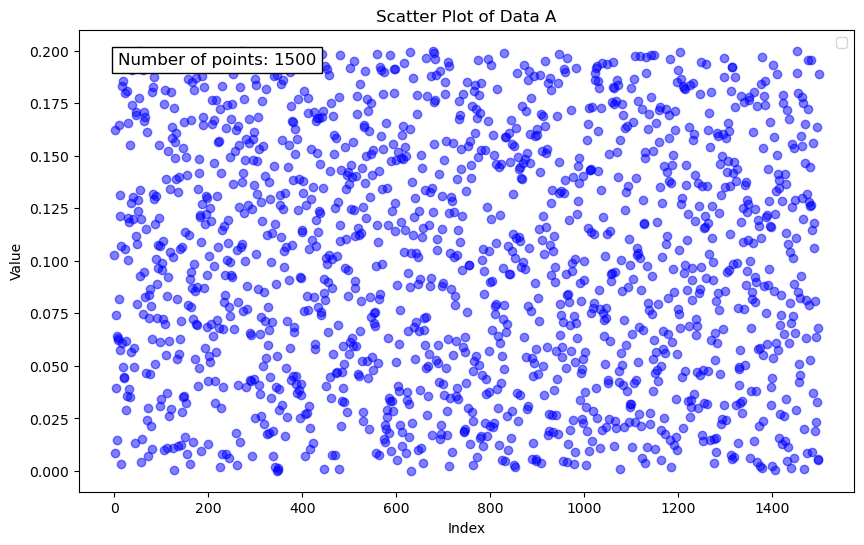

In [9]:
print(X_f.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f)), X_f, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1500, 1)


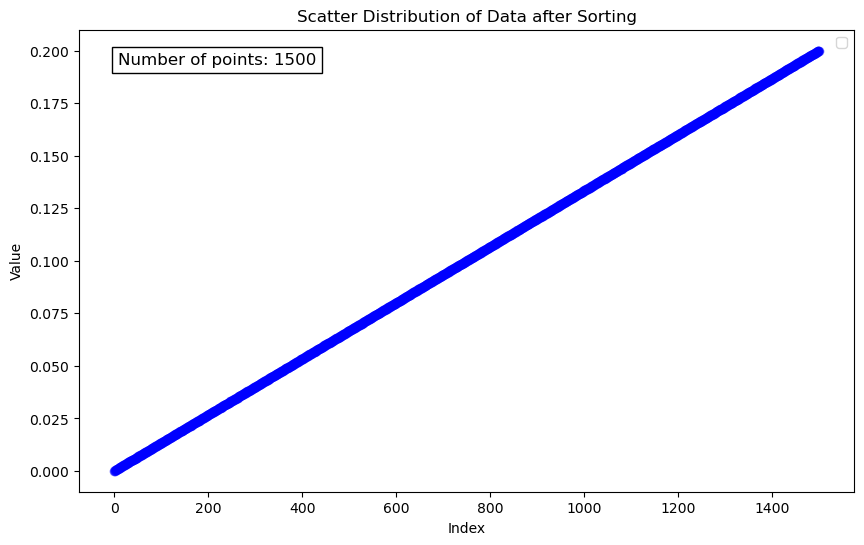

In [10]:
X = np.sort(X_f, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [11]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.05330432334571113, 0.05338186848895769, 0.05329841094037729, 0.05324835973186155, 0.05331228675415218, 0.0535504442757188, 0.053357794308722964, 0.05325338137957923, 0.053256125021219236, 0.053376425090898225]
Error u of fuhe active learning(LHS sampling): 5.333394e-02
[0.004539683778542271, 0.004570873917471272, 0.004539902100324525, 0.004532852560998864, 0.004538828435257319, 0.004701593693135893, 0.004543416153229326, 0.004532941049570155, 0.004533665924308466, 0.004545137963310528]
MAE of fuhe active learning(LHS sampling): 4.557890e-03
[0.0003470758622235836, 0.00034808552089132593, 0.0003469971281961395, 0.00034634768306090715, 0.00034717893727729496, 0.00035027466900256307, 0.0003477712081578106, 0.00034641307250175173, 0.00034644961772211015, 0.0003480135721774853]
MSE of fuhe active learning(LHS sampling): 3.474607e-04
[3.808344e-05, 3.7120597e-05, 4.9581045e-05, 0.000100990444, 3.6529756e-05, 4.5291294e-05, 4.168703e-05, 8.319406e-05, 9.8382414e-05, 8.073688e-05]
Chaos of 

[0.05330432334571113, 0.05338186848895769, 0.05329841094037729, 0.05324835973186155, 0.05331228675415218, 0.0535504442757188, 0.053357794308722964, 0.05325338137957923, 0.053256125021219236, 0.053376425090898225]
mean Error u: 5.333394e-02
Variance Error u: 7.402242e-09


/tmp/ipykernel_1423319/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


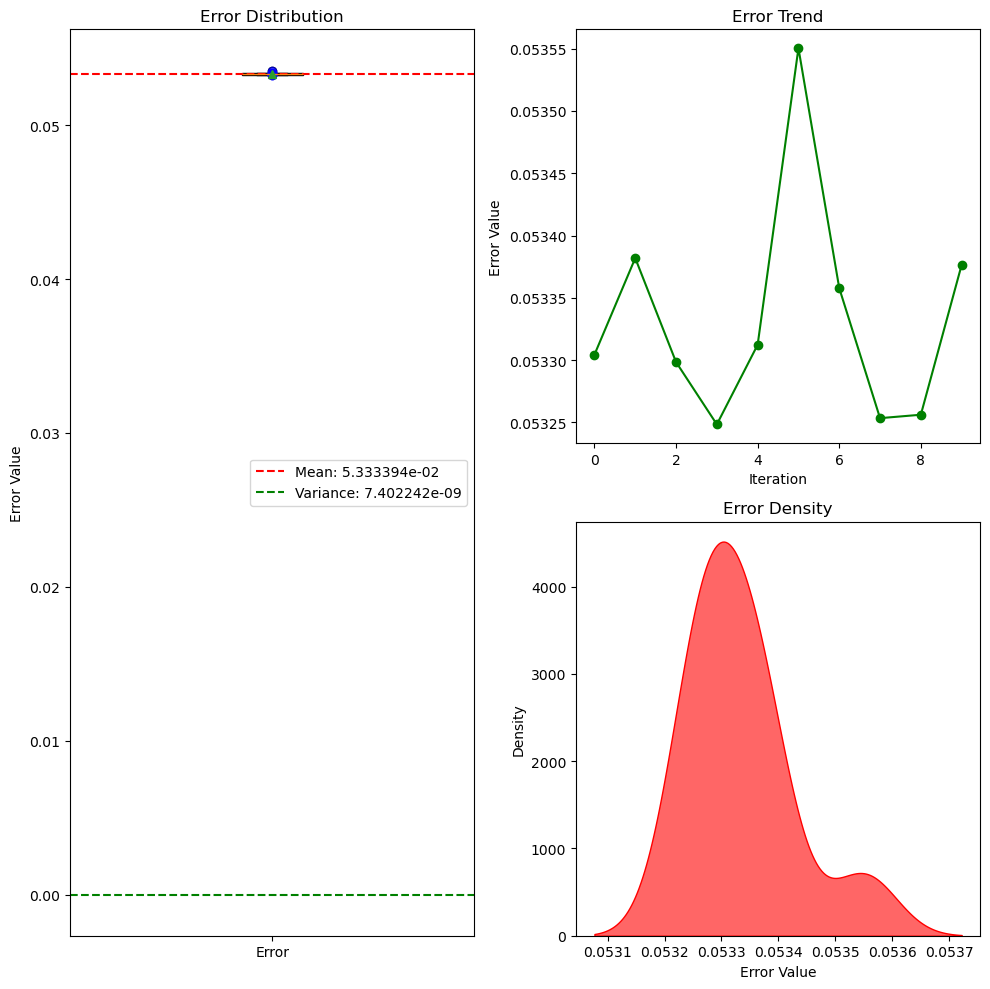

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.004539683778542271, 0.004570873917471272, 0.004539902100324525, 0.004532852560998864, 0.004538828435257319, 0.004701593693135893, 0.004543416153229326, 0.004532941049570155, 0.004533665924308466, 0.004545137963310528]


mean MAE: 4.557890e-03
Variance MAE: 2.404594e-09


/tmp/ipykernel_1423319/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


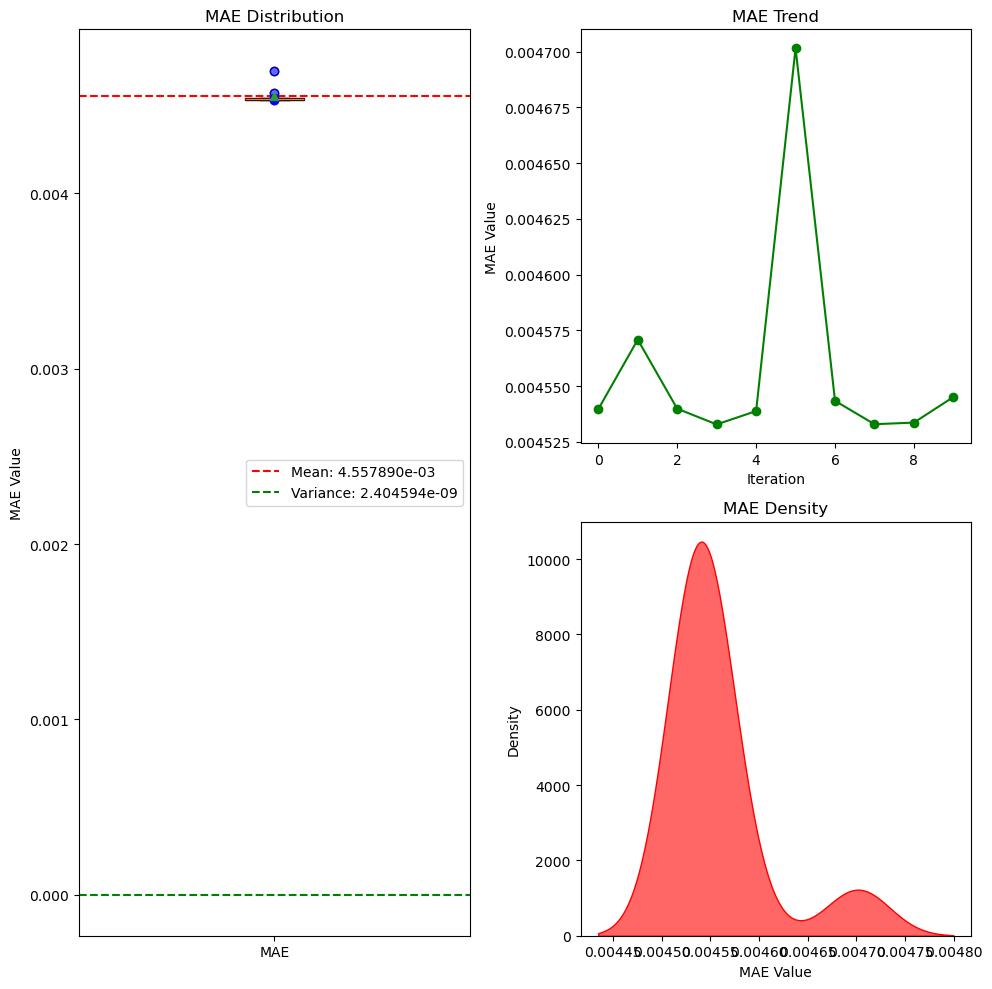

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0003470758622235836, 0.00034808552089132593, 0.0003469971281961395, 0.00034634768306090715, 0.00034717893727729496, 0.00035027466900256307, 0.0003477712081578106, 0.00034641307250175173, 0.00034644961772211015, 0.0003480135721774853]
mean MSE: 3.474607e-04
Variance MSE: 1.251191e-12


/tmp/ipykernel_1423319/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


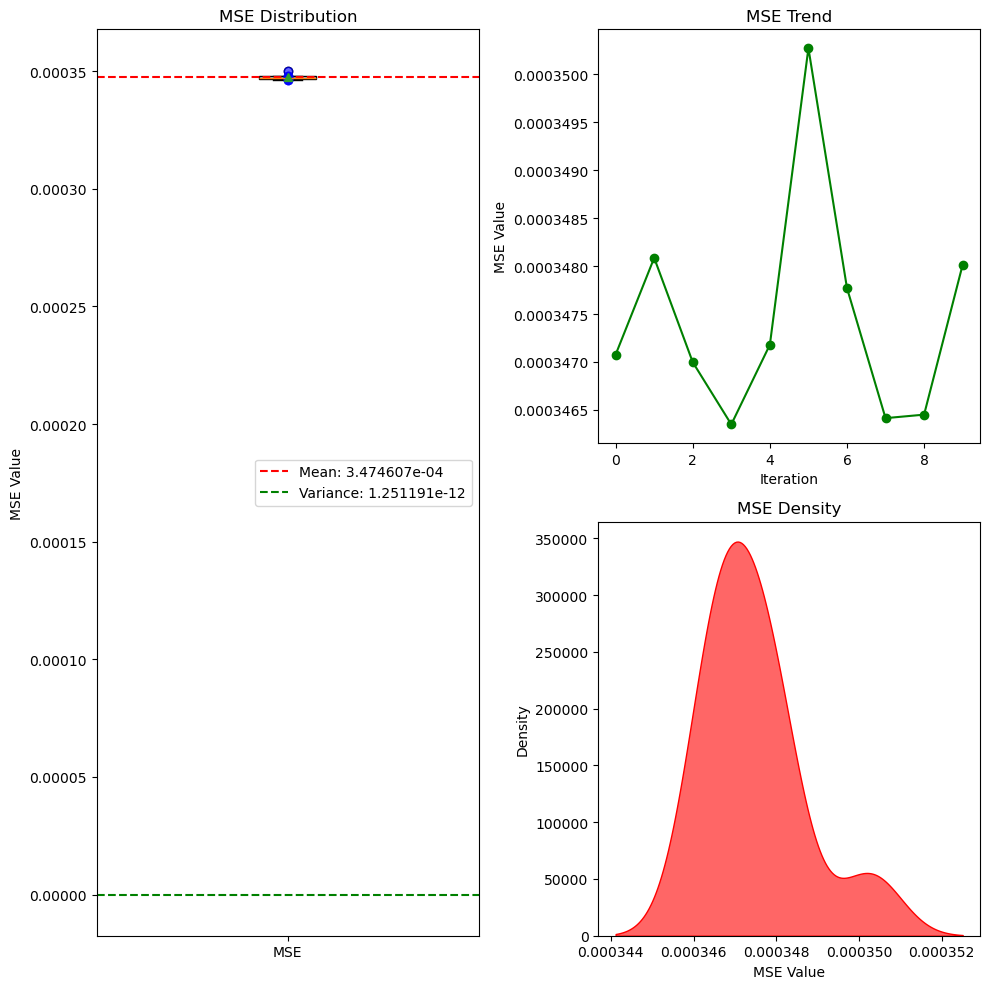

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[3.808344e-05, 3.7120597e-05, 4.9581045e-05, 0.000100990444, 3.6529756e-05, 4.5291294e-05, 4.168703e-05, 8.319406e-05, 9.8382414e-05, 8.073688e-05]
mean CHAOS: 6.115970e-05
Variance CHAOS: 6.322881e-10


/tmp/ipykernel_1423319/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


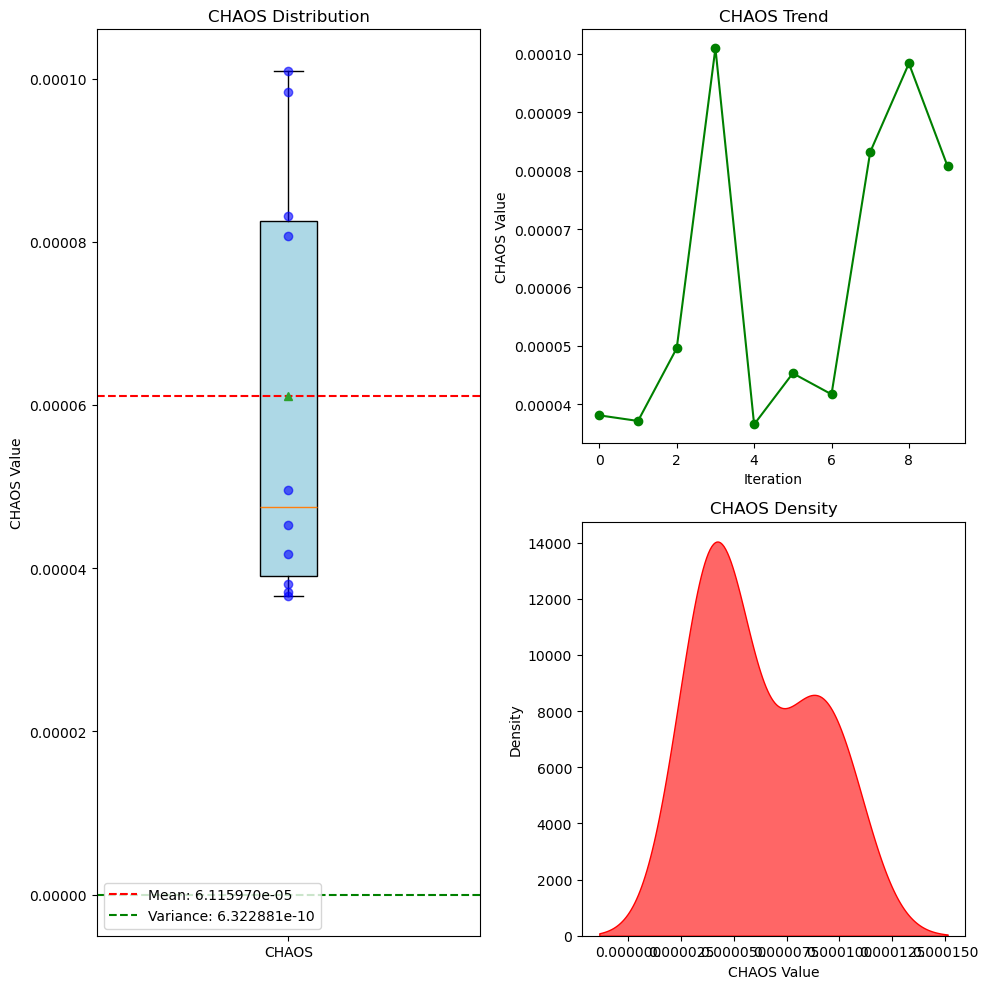

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0003355465, 0.0003470783, 0.00035092112, 0.0003602388, 0.00033919764, 0.00033455965, 0.00033083328, 0.0003411143, 0.0003531581, 0.00032714914]
mean RESIDUAL: 3.419797e-04
Variance RESIDUAL: 1.013416e-10


/tmp/ipykernel_1423319/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


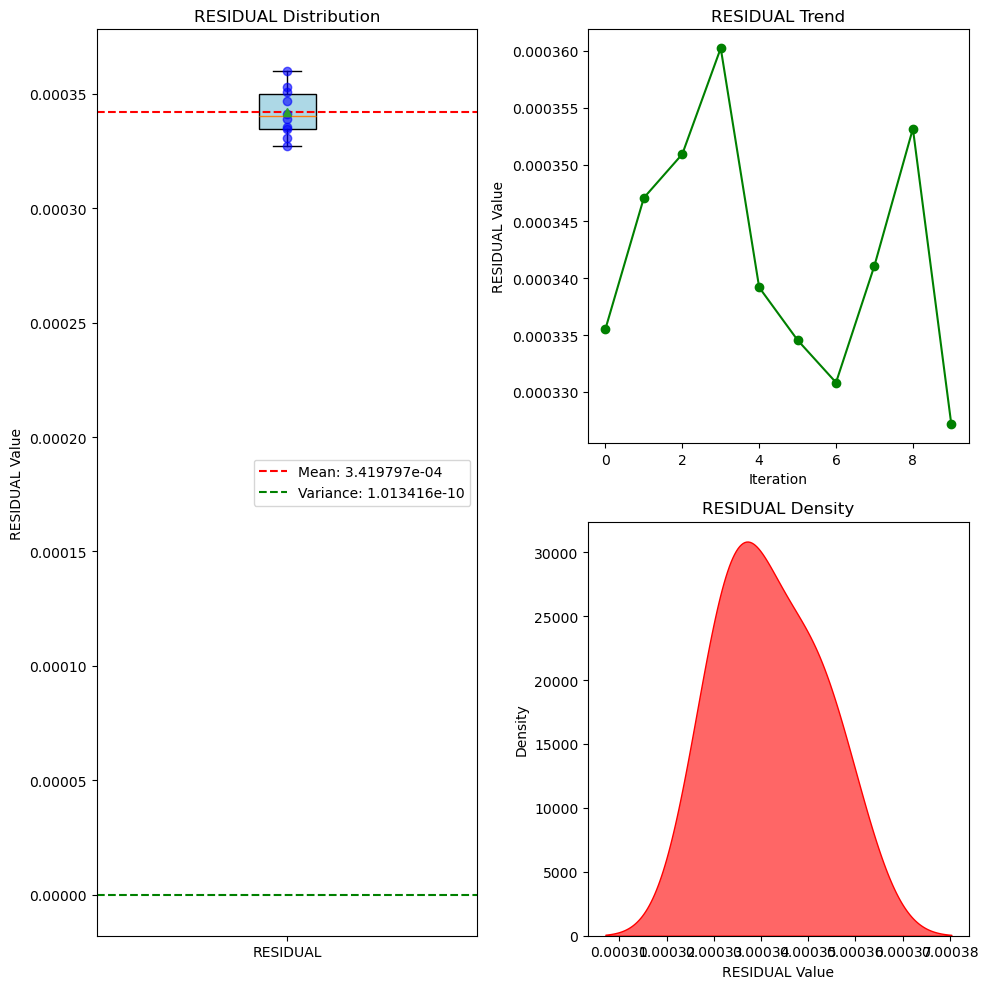

In [16]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [17]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

40000
[1.7958674e+03 1.7118774e+03 1.6422498e+03 ... 6.2740650e-03 6.2740548e-03
 6.2740548e-03]


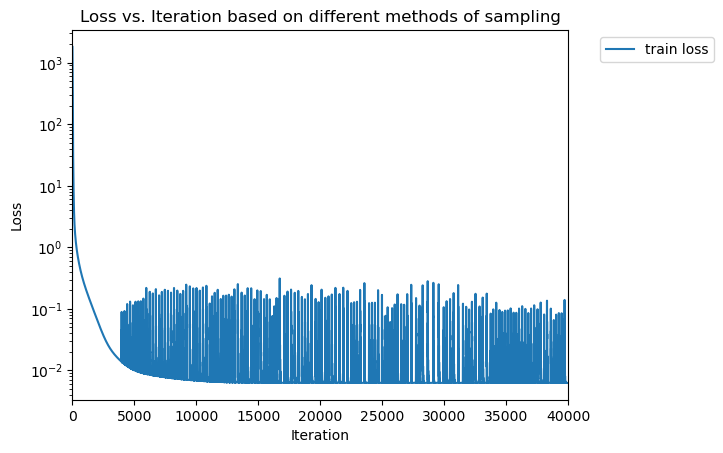

In [18]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,40000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

In [19]:
y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
print(y_pred_df.head())
print(y_pred_df.tail())
y_pred_df = get_system_performance(y_pred_df)
print(y_pred_df.head())
print(y_pred_df.tail())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.758046  0.053064  0.094607  0.068878  0.006611  0.004817  0.008589   
1  0.758043  0.053064  0.094610  0.068878  0.006612  0.004817  0.008589   
2  0.758040  0.053063  0.094613  0.068878  0.006612  0.004817  0.008589   
3  0.758036  0.053063  0.094615  0.068878  0.006612  0.004817  0.008590   
4  0.758033  0.053063  0.094618  0.068878  0.006613  0.004817  0.008590   

    state_8   state_9  state_10  state_11  state_12  
0  0.004004  0.000593  0.000273  0.000488  0.000029  
1  0.004004  0.000594  0.000273  0.000488  0.000029  
2  0.004004  0.000594  0.000273  0.000488  0.000029  
3  0.004004  0.000594  0.000273  0.000488  0.000029  
4  0.004004  0.000594  0.000273  0.000489  0.000029  
      state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
495  0.757825  0.053040  0.094716  0.068886  0.006634  0.004823  0.008617   
496  0.757822  0.053040  0.094716  0.068886  0.006635  0.004824  0.0086

Text(0, 0.5, 'Probability')

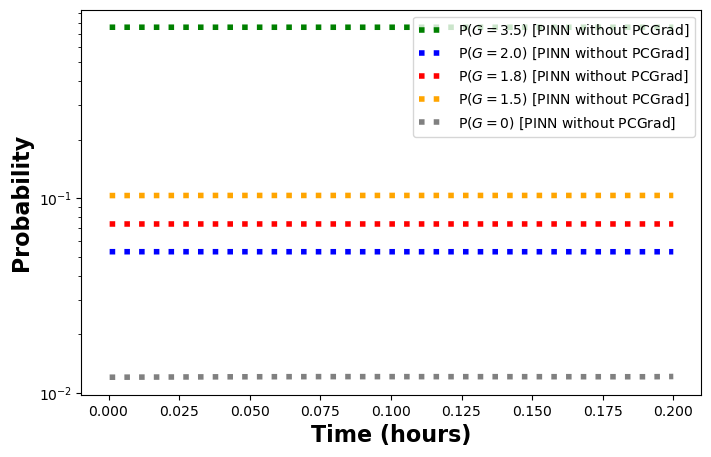

In [20]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

In [21]:
#解析解
eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
laplace_solution_df = pd.read_csv('analytical_solution_by_laplace_method.csv')
print(eigenvector_solution_df.head())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.989461  0.002719  0.003903  0.003874  0.000011  0.000011  0.000015   
1  0.979427  0.005285  0.007619  0.007508  0.000041  0.000041  0.000058   
2  0.969868  0.007706  0.011159  0.010919  0.000089  0.000087  0.000126   
3  0.960761  0.009993  0.014533  0.014121  0.000151  0.000147  0.000214   
4  0.952080  0.012153  0.017751  0.017129  0.000227  0.000219  0.000319   

    state_8       state_9      state_10      state_11      state_12  \
0  0.000005  4.199986e-08  1.479473e-08  2.123212e-08  5.835560e-11   
1  0.000021  3.151602e-07  1.117239e-07  1.610611e-07  8.690817e-10   
2  0.000045  9.982098e-07  3.560873e-07  5.156228e-07  4.096992e-09   
3  0.000077  2.221657e-06  7.974345e-07  1.159778e-06  1.206261e-08   
4  0.000115  4.076314e-06  1.472082e-06  2.150250e-06  2.744632e-08   

   system_3.5  system_2.0  system_1.8  system_1.5  system_0  
0    0.989461    0.002719    0.003885    0.003918  0.000016 

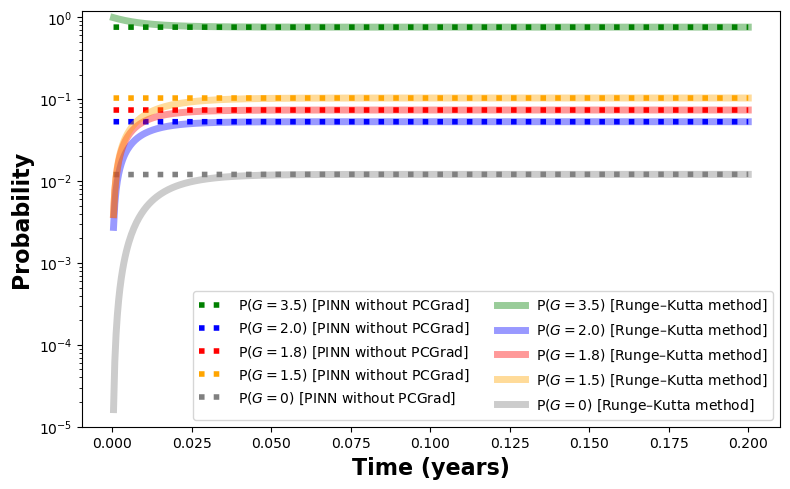

In [22]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [Runge–Kutta method]',
             color = 'green', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [Runge–Kutta method]',
             color = 'blue', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [Runge–Kutta method]',
             color = 'red', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [Runge–Kutta method]',
             color = 'orange', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_0'], 
             label = r'P$\left(G=0 \right)$ [Runge–Kutta method]',
             color = 'gray', alpha=0.4, dashes=True, linewidth = 5)



ax.legend(ncol=2, fontsize=10)
ax.set_yscale("log")
ax.set_ylim([1e-5, 1.2])
ax.set_xlabel("Time (years)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)



plt.tight_layout()

### 计算RMSE

In [23]:
y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
y_diff_no_pcgrad_laplace = laplace_solution_df - y_pred_df

In [24]:
y_diff_no_pcgrad_eigenvectors['mse'] = y_diff_no_pcgrad_eigenvectors.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_eigenvectors['rmse'] = y_diff_no_pcgrad_eigenvectors['mse'].apply(np.sqrt)

y_diff_no_pcgrad_laplace['mse'] = y_diff_no_pcgrad_laplace.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_laplace['rmse'] = y_diff_no_pcgrad_laplace['mse'].apply(np.sqrt)

In [25]:
#这里的mse跟之前的MSE值不一样，其实是差了五倍，因为这里求均值是对500个数的和a除以500，而之前是对500*5个数的和（也是a）除以500*5
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['mse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['mse']))

RMSE of between PINN without PCGrad and the analytical solution is 0.0017400678608874263
RMSE of between PINN without PCGrad and the analytical solution is 0.0017400678608874124


In [26]:
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['rmse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['rmse']))

RMSE of between PINN without PCGrad and the analytical solution is 0.013150528125647336
RMSE of between PINN without PCGrad and the analytical solution is 0.013150528125646647
